In [ ]:
#using Pkg
#Pkg.add(PackageSpec(name="JWAS",rev="master"))
#Pkg.add("RecipesBase")
#using RecipesBase

In [ ]:
# make plot work
#ENV["GRDIR"]=""
#Pkg.build("GR")

In [ ]:
#methods(add_genotypes)

In [1]:
using DataFrames              # package for working with data sets
using JWAS                    # package for Bayesian regression analyses, including BayesB and BayesCπ        
#using JWAS:misc               # utility functions
using JWAS.Datasets
using Distributions       
using Plots                   # package for plotting 
using CSV
using LinearAlgebra,Statistics,Random,DelimitedFiles, DataFrames

In [2]:
phenotypes = CSV.read("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/production_1_7_Exp_0.75_Complete.dat", types=Dict(:ID => String), delim = ' ',header=true, missingstrings=["NA"] )
#first(phenotypes,10)

,ID,Cycle,BatchNum,Batch,Company,SowID,NurEnrich,QNurPenBatch,NurPenBatch
,String,Int64,Int64,String,String,String,String,String,String⍰
1,0001,1,1,1B,A,1B_1715,FALSE,1B_D04,1B_D04
2,0002,1,1,1B,A,1B_1642,FALSE,1B_D04,1B_D04
3,0004,1,1,1B,A,1B_2150,FALSE,1B_D04,1B_D04
4,0005,1,1,1B,A,1B_1980,FALSE,1B_D04,1B_D04
5,0006,1,1,1B,A,1B_1902,FALSE,1B_D04,1B_D04
6,0007,1,1,1B,A,1B_2150,FALSE,1B_D04,1B_D04
7,0009,1,1,1B,A,1B_1902,FALSE,1B_D02,1B_D02
8,0010,1,1,1B,A,1B_1885,FALSE,1B_D02,1B_D02
9,0011,1,1,1B,A,1B_2097,FALSE,1B_D02,1B_D02


┌ Warning: `T` is deprecated, use `nonmissingtype` instead.
│   caller = compacttype(::Type, ::Int64) at show.jl:39
└ @ DataFrames /opt/julia/packages/DataFrames/XuYBH/src/abstractdataframe/show.jl:39


In [3]:
phenotypes= dropmissing(phenotypes, :NurPenBatch)
phenotypes= dropmissing(phenotypes, :nTrtsNur2_27)

sort(phenotypes[!,:nTrtsNur2_27])

3153-element Array{Float64,1}:
  0.0 
  0.0 
  0.0 
  0.0 
  0.0 
  0.0 
  0.0 
  0.0 
  0.0 
  0.0 
  0.0 
  0.0 
  0.0 
  ⋮   
  6.0 
  6.14
  6.23
  6.23
  6.23
  6.35
  6.35
  7.36
  7.5 
  7.71
 10.5 
 10.5 

In [4]:
nTrtsNur2_27_model_equations = "nTrtsNur2_27 = intercept + Batch + EntryAge + NurPenBatch + SowID"
nTrtsNur2_27_R=1.10381
nTrtsNur2_27_model=build_model(nTrtsNur2_27_model_equations,nTrtsNur2_27_R);

In [5]:
set_covariate(nTrtsNur2_27_model,"EntryAge")

1-element Array{Symbol,1}:
 :EntryAge

In [6]:
nTrtsNur2_27_G1=0.372191E-01
set_random(nTrtsNur2_27_model,"NurPenBatch",nTrtsNur2_27_G1)

In [7]:
nTrtsNur2_27_G2=0.206509E-01
set_random(nTrtsNur2_27_model,"SowID",nTrtsNur2_27_G2)

In [2]:
function readMatBin(fileName)
    genStr = open(fileName)
    n = read(genStr,Int64)
    p = read(genStr,Int64)
    M = zeros(n,p)
    for j in 1:p
        for i in 1:n
            M[i,j] = read(genStr,Float64)
        end
    end
    close(genStr)
    return M
end
@time M = readMatBin("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ALGP2_Cycle_1_7_Geno_Complete_Impute_JWAS.bin.gen.bin")

 26.999058 seconds (37.77 k allocations: 10.393 GiB, 0.09% gc time)


3205×435172 Array{Float64,2}:
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  2.0  2.0  0.0  1.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 1.0  1.0  0.0  1.0  2.0  0.0  0.0  2.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [9]:
rowID = vec(readdlm("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ALGP2_Cycle_1_7_Geno_Complete_Impute_JWAS.bin.ids.txt",String))

3205-element Array{String,1}:
 "0001"
 "0002"
 "0004"
 "0005"
 "0006"
 "0007"
 "0009"
 "0010"
 "0011"
 "0012"
 "0013"
 "0014"
 "0015"
 ⋮     
 "3283"
 "3284"
 "3285"
 "3286"
 "3287"
 "3288"
 "3289"
 "3290"
 "3291"
 "3292"
 "3293"
 "3294"

In [10]:
nTrtsNur2_27_G3=0.143085
@time add_genotypes(nTrtsNur2_27_model,M,nTrtsNur2_27_G3,header=false, rowID=rowID)
#@time add_genotypes(Nur2ADG_model,"Geno_JWAS_impute.txt",Nur2ADG_G3,separator=' ')

The header (marker IDs) is set to 1,2,...,#markers
435172 markers on 3205 individuals were added.
  9.266948 seconds (4.72 M allocations: 21.031 GiB, 2.50% gc time)


In [11]:
h2=nTrtsNur2_27_G3/(nTrtsNur2_27_G1+nTrtsNur2_27_G2+nTrtsNur2_27_G3+nTrtsNur2_27_R)

0.10966342598092377

In [ ]:
@time nTrtsNur2_27_outCPi=runMCMC(nTrtsNur2_27_model,phenotypes,methods="BayesC", missing_phenotypes=true, Pi= 0.999,  estimatePi=true,estimateScale=true, chain_length=50000,burnin = 5000,output_heritability=true,  output_samples_frequency=100)

In [ ]:
keys(nTrtsNur2_27_outCPi)

In [ ]:
marker=CSV.read("MCMC_samples_genetic_variance.txt",delim = ' ',header=true)
Va=mean(marker[!, 1])

In [ ]:
pen=CSV.read("MCMC_samples_NurPenBatch_variances.txt",delim = ' ',header=true)
Vs=mean(pen[!, 1])

In [ ]:
Res=CSV.read("MCMC_samples_residual_variance.txt",delim = ' ',header=true)
Ve=mean(Res[!, 1])

In [ ]:
h2=Va/(Va+Vs+Ve)

In [ ]:
Pi=nTrtsNur2_27_outCPi["Pi"]

In [ ]:
Pi=CSV.read("MCMC_samples_pi.txt",delim = ' ',header=false)
insertcols!(Pi, 1, :iteration => 1:450) # Add a column called iteration

In [ ]:
using Plots
x = Pi[!,1]; y = Pi[!,2]; # These are the plotting data
plot(x,y, title = "Pi trace plot",
        xlabel = "iteration", ylabel = "Pi")

In [ ]:
h2=CSV.read("MCMC_samples_heritability.txt",delim = ' ',header=true)
insertcols!(h2, 1, :iteration => 1:450) # Add a column called iteration

In [ ]:
using Plots
x = h2[!,1]; y = h2[!,2]; # These are the plotting data
plot(x,y, title = "h2 trace plot",
        xlabel = "iteration", ylabel = "h2")

In [ ]:
@time nTrtsNur2_27_outB=runMCMC(nTrtsNur2_27_model,phenotypes,methods="BayesB", missing_phenotypes=true, Pi=0.999,estimateScale=true, chain_length=50000,burnin = 5000,output_heritability=true,  output_samples_frequency=100)

Checking phenotypes...
Individual IDs (strings) are provided in the first column of the phenotypic data.


┌ Warning: `T` is deprecated, use `nonmissingtype` instead.
│   caller = recode at recode.jl:354 [inlined]
└ @ Core /opt/julia/packages/CategoricalArrays/xjesC/src/recode.jl:354



The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.000859



A Linear Mixed Model was build using model equations:

nTrtsNur2_27 = intercept + Batch + EntryAge + NurPenBatch + SowID

Model Information:

Term            C/F          F/R            nLevels
intercept       factor       fixed                1
Batch           factor       fixed               50
EntryAge        covariate    fixed                1
NurPenBatch     factor       random             436
SowID           factor       random            1118

MCMC Information:

methods                                      BayesB
                              complete genomic data
                   (i.e., non-single-step analysis)
chain_length                                  50000
burnin                                         5000
estimatePi                                    false
estimateScale                                  true
starti

running MCMC for BayesB... 91%|██████████████████████▋  |  ETA: 1:09:23

In [12]:
marker=CSV.read("MCMC_samples_genetic_variance.txt",delim = ' ',header=true)
Va=mean(marker[!, 1])

0.1466074176491551

In [13]:
pen=CSV.read("MCMC_samples_NurPenBatch_variances.txt",delim = ' ',header=true)
Vs=mean(pen[!, 1])

0.03233021676563973

In [14]:
Res=CSV.read("MCMC_samples_residual_variance.txt",delim = ' ',header=true)
Ve=mean(Res[!, 1])

1.1338807273975677

In [15]:
h2=Va/(Va+Ve)

0.11449338146258718

In [16]:
h2=CSV.read("MCMC_samples_heritability.txt",delim = ' ',header=true)
insertcols!(h2, 1, :iteration => 1:450) # Add a column called iteration

,iteration,nTrtsNur2_27
,Int64,Float64
1,1,0.108853
2,2,0.0954612
3,3,0.0906737
4,4,0.0838399
5,5,0.102727
6,6,0.0825225
7,7,0.111771
8,8,0.0811001
9,9,0.103392


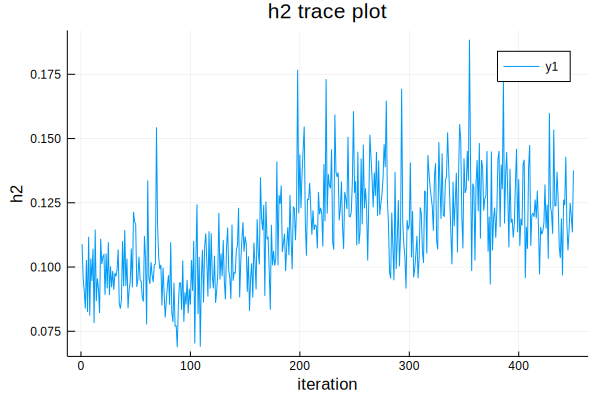

In [17]:
using Plots
x = h2[!,1]; y = h2[!,2]; # These are the plotting data
plot(x,y, title = "h2 trace plot",
        xlabel = "iteration", ylabel = "h2")

In [3]:
@time nTrtsNur2_27_outB,nTrtsNur2_27_winVarProps = GWAS("MCMC_samples_marker_effects_nTrtsNur2_27.txt",
    "/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ChrInfo_map_1_7_Complete_JWAS.txt",M;header=true,window_size="0.25 Mb",threshold=0.001)

Compute the posterior probability of association of the genomic window that explains more than 0.001 of the total genetic variance.


running GWAS...100%|████████████████████████████████████| Time: 0:37:01


BoundsError: BoundsError: attempt to access (9375×13 DataFrame
│ Row  │ trait │ window │ chr    │ wStart    │ wEnd      │ start_SNP │ end_SNP   │ numSNP │ estimateGenVar │ stdGenVar   │ prGenVar │ WPPA       │ PPA_t     │
│      │ Int64 │ Int64  │ String │ Int64     │ Int64     │ Int64     │ Int64     │ Int64  │ Float64        │ Float64     │ Float64  │ Float64    │ Float64   │
├──────┼───────┼────────┼────────┼───────────┼───────────┼───────────┼───────────┼────────┼────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1    │ 1     │ 2222   │ 3      │ 129500000 │ 129750000 │ 129502968 │ 129748906 │ 80     │ 0.00371127     │ 0.00440804  │ 2.47     │ 0.642222   │ 0.642222  │
│ 2    │ 1     │ 7660   │ 14     │ 131500000 │ 131750000 │ 131501106 │ 131746100 │ 67     │ 0.00086143     │ 0.00220397  │ 0.56     │ 0.244444   │ 0.443333  │
│ 3    │ 1     │ 7802   │ 15     │ 25250000  │ 25500000  │ 25250466  │ 25499288  │ 64     │ 0.000893545    │ 0.00242707  │ 0.6      │ 0.215556   │ 0.367407  │
│ 4    │ 1     │ 5422   │ 9      │ 129750000 │ 130000000 │ 129751485 │ 129998963 │ 57     │ 0.000791986    │ 0.00218244  │ 0.53     │ 0.206667   │ 0.327222  │
│ 5    │ 1     │ 1205   │ 2      │ 27000000  │ 27250000  │ 27001294  │ 27249287  │ 68     │ 0.000448961    │ 0.00132958  │ 0.31     │ 0.204444   │ 0.302667  │
│ 6    │ 1     │ 6414   │ 13     │ 28000000  │ 28250000  │ 28001643  │ 28248248  │ 59     │ 0.00063262     │ 0.00183711  │ 0.44     │ 0.202222   │ 0.285926  │
│ 7    │ 1     │ 4937   │ 9      │ 8250000   │ 8500000   │ 8252566   │ 8494231   │ 61     │ 0.000481079    │ 0.00165696  │ 0.32     │ 0.142222   │ 0.265397  │
│ 8    │ 1     │ 5423   │ 9      │ 130000000 │ 130250000 │ 130005999 │ 130248674 │ 78     │ 0.000344571    │ 0.00141782  │ 0.22     │ 0.142222   │ 0.25      │
│ 9    │ 1     │ 6415   │ 13     │ 28250000  │ 28500000  │ 28250127  │ 28493742  │ 67     │ 0.000319012    │ 0.00125457  │ 0.23     │ 0.142222   │ 0.238025  │
│ 10   │ 1     │ 3762   │ 6      │ 146500000 │ 146750000 │ 146508971 │ 146737682 │ 39     │ 0.000350762    │ 0.00114987  │ 0.24     │ 0.14       │ 0.228222  │
│ 11   │ 1     │ 3954   │ 7      │ 23500000  │ 23750000  │ 23506483  │ 23744838  │ 62     │ 0.000415932    │ 0.00145537  │ 0.28     │ 0.133333   │ 0.219596  │
│ 12   │ 1     │ 6723   │ 13     │ 105250000 │ 105500000 │ 105257290 │ 105493975 │ 36     │ 0.000342768    │ 0.00121106  │ 0.23     │ 0.126667   │ 0.211852  │
│ 13   │ 1     │ 3760   │ 6      │ 146000000 │ 146250000 │ 146001490 │ 146248190 │ 60     │ 0.000219884    │ 0.000924477 │ 0.16     │ 0.12       │ 0.204786  │
│ 14   │ 1     │ 3763   │ 6      │ 146750000 │ 147000000 │ 146782297 │ 146997249 │ 50     │ 0.000320828    │ 0.00130457  │ 0.21     │ 0.12       │ 0.19873   │
│ 15   │ 1     │ 638    │ 1      │ 159500000 │ 159750000 │ 159500733 │ 159748821 │ 57     │ 0.00028882     │ 0.00119402  │ 0.19     │ 0.117778   │ 0.193333  │
│ 16   │ 1     │ 1237   │ 2      │ 35000000  │ 35250000  │ 35001883  │ 35248617  │ 58     │ 0.000177197    │ 0.000830647 │ 0.11     │ 0.117778   │ 0.188611  │
│ 17   │ 1     │ 4972   │ 9      │ 17000000  │ 17250000  │ 17003236  │ 17248879  │ 75     │ 0.000191495    │ 0.000747438 │ 0.14     │ 0.117778   │ 0.184444  │
│ 18   │ 1     │ 8220   │ 15     │ 130000000 │ 130250000 │ 130004539 │ 130241751 │ 69     │ 0.000168122    │ 0.000689403 │ 0.11     │ 0.113333   │ 0.180494  │
│ 19   │ 1     │ 645    │ 1      │ 161250000 │ 161500000 │ 161252022 │ 161497353 │ 55     │ 0.000427576    │ 0.0016036   │ 0.29     │ 0.111111   │ 0.176842  │
│ 20   │ 1     │ 2142   │ 3      │ 109500000 │ 109750000 │ 109504492 │ 109746749 │ 63     │ 0.000156785    │ 0.000673342 │ 0.1      │ 0.108889   │ 0.173444  │
│ 21   │ 1     │ 6722   │ 13     │ 105000000 │ 105250000 │ 105004316 │ 105249476 │ 46     │ 0.00022944     │ 0.0010781   │ 0.15     │ 0.108889   │ 0.17037   │
│ 22   │ 1     │ 637    │ 1      │ 159250000 │ 159500000 │ 159316327 │ 159497717 │ 35     │ 0.000389519    │ 0.00146097  │ 0.25     │ 0.106667   │ 0.167475  │
│ 23   │ 1     │ 1714   │ 3      │ 2500000   │ 2750000   │ 2500530   │ 2737881   │ 53     │ 0.000303236    │ 0.00140248  │ 0.21     │ 0.106667   │ 0.164831  │
│ 24   │ 1     │ 5186   │ 9      │ 70750000  │ 71000000  │ 70763877  │ 70999233  │ 69     │ 0.000189848    │ 0.000879168 │ 0.14     │ 0.106667   │ 0.162407  │
│ 25   │ 1     │ 7274   │ 14     │ 35000000  │ 35250000  │ 35000445  │ 35248374  │ 64     │ 0.000233778    │ 0.00117892  │ 0.16     │ 0.104444   │ 0.160089  │
│ 26   │ 1     │ 1875   │ 3      │ 42750000  │ 43000000  │ 42763629  │ 42989379  │ 19     │ 0.000284142    │ 0.00108449  │ 0.19     │ 0.102222   │ 0.157863  │
│ 27   │ 1     │ 5424   │ 9      │ 130250000 │ 130500000 │ 130253169 │ 130498842 │ 54     │ 0.000289704    │ 0.00126558  │ 0.2      │ 0.102222   │ 0.155802  │
│ 28   │ 1     │ 1147   │ 2      │ 12500000  │ 12750000  │ 12500994  │ 12745900  │ 65     │ 0.000169455    │ 0.000689038 │ 0.12     │ 0.1        │ 0.15381   │
│ 29   │ 1     │ 2186   │ 3      │ 120500000 │ 120750000 │ 120501888 │ 120748646 │ 51     │ 0.000165852    │ 0.000723343 │ 0.1      │ 0.1        │ 0.151954  │
│ 30   │ 1     │ 2286   │ 4      │ 12500000  │ 12750000  │ 12503515  │ 12748121  │ 58     │ 0.000566448    │ 0.00221036  │ 0.39     │ 0.0977778  │ 0.150148  │
│ 31   │ 1     │ 4061   │ 7      │ 50250000  │ 50500000  │ 50250577  │ 50498935  │ 74     │ 0.000140632    │ 0.000587423 │ 0.1      │ 0.0977778  │ 0.148459  │
│ 32   │ 1     │ 8215   │ 15     │ 128750000 │ 129000000 │ 128759796 │ 128999950 │ 69     │ 0.000158348    │ 0.000646868 │ 0.1      │ 0.0977778  │ 0.146875  │
│ 33   │ 1     │ 414    │ 1      │ 103500000 │ 103750000 │ 103502350 │ 103743617 │ 54     │ 0.0001628      │ 0.000774581 │ 0.13     │ 0.0955556  │ 0.14532   │
│ 34   │ 1     │ 2561   │ 4      │ 81250000  │ 81500000  │ 81259357  │ 81497779  │ 66     │ 0.000172656    │ 0.00083865  │ 0.11     │ 0.0955556  │ 0.143856  │
│ 35   │ 1     │ 3966   │ 7      │ 26500000  │ 26750000  │ 26500623  │ 26747706  │ 66     │ 9.8184e-5      │ 0.000387079 │ 0.07     │ 0.0955556  │ 0.142476  │
│ 36   │ 1     │ 5187   │ 9      │ 71000000  │ 71250000  │ 71001828  │ 71246222  │ 74     │ 0.000136291    │ 0.00067548  │ 0.1      │ 0.0955556  │ 0.141173  │
│ 37   │ 1     │ 3033   │ 5      │ 68250000  │ 68500000  │ 68252000  │ 68496130  │ 55     │ 0.000101529    │ 0.000441474 │ 0.07     │ 0.0933333  │ 0.13988   │
│ 38   │ 1     │ 3795   │ 6      │ 154750000 │ 155000000 │ 154750461 │ 154998189 │ 75     │ 0.000158805    │ 0.000790306 │ 0.11     │ 0.0933333  │ 0.138655  │
│ 39   │ 1     │ 405    │ 1      │ 101250000 │ 101500000 │ 101264659 │ 101473397 │ 36     │ 0.000203748    │ 0.000861208 │ 0.15     │ 0.0911111  │ 0.137436  │
│ 40   │ 1     │ 2217   │ 3      │ 128250000 │ 128500000 │ 128251374 │ 128489038 │ 61     │ 0.000319814    │ 0.00140895  │ 0.21     │ 0.0911111  │ 0.136278  │
│ 41   │ 1     │ 4971   │ 9      │ 16750000  │ 17000000  │ 16751790  │ 16998670  │ 73     │ 0.000119179    │ 0.00063449  │ 0.08     │ 0.0911111  │ 0.135176  │
│ 42   │ 1     │ 8219   │ 15     │ 129750000 │ 130000000 │ 129750302 │ 129996887 │ 55     │ 0.000166689    │ 0.000831289 │ 0.12     │ 0.0911111  │ 0.134127  │
│ 43   │ 1     │ 2673   │ 4      │ 109250000 │ 109500000 │ 109252758 │ 109498754 │ 67     │ 0.000181771    │ 0.000833872 │ 0.11     │ 0.0888889  │ 0.133075  │
│ 44   │ 1     │ 2818   │ 5      │ 14500000  │ 14750000  │ 14530203  │ 14743291  │ 66     │ 0.000139501    │ 0.000682535 │ 0.09     │ 0.0888889  │ 0.132071  │
│ 45   │ 1     │ 7659   │ 14     │ 131250000 │ 131500000 │ 131250627 │ 131497220 │ 70     │ 0.000126504    │ 0.000596223 │ 0.08     │ 0.0888889  │ 0.131111  │
│ 46   │ 1     │ 9003   │ 18     │ 42000000  │ 42250000  │ 42004068  │ 42248048  │ 70     │ 0.000164843    │ 0.000687885 │ 0.11     │ 0.0888889  │ 0.130193  │
│ 47   │ 1     │ 1058   │ 1      │ 264500000 │ 264750000 │ 264504531 │ 264738193 │ 38     │ 0.00017429     │ 0.000921854 │ 0.11     │ 0.0866667  │ 0.129267  │
│ 48   │ 1     │ 5000   │ 9      │ 24000000  │ 24250000  │ 24004093  │ 24249627  │ 68     │ 0.000109715    │ 0.000475469 │ 0.07     │ 0.0866667  │ 0.12838   │
│ 49   │ 1     │ 5368   │ 9      │ 116250000 │ 116500000 │ 116251606 │ 116498853 │ 59     │ 9.81529e-5     │ 0.000442181 │ 0.07     │ 0.0866667  │ 0.127528  │
│ 50   │ 1     │ 2225   │ 3      │ 130250000 │ 130500000 │ 130252331 │ 130498855 │ 54     │ 0.000146486    │ 0.000826729 │ 0.09     │ 0.0844444  │ 0.126667  │
│ 51   │ 1     │ 3967   │ 7      │ 26750000  │ 27000000  │ 26750322  │ 26997638  │ 77     │ 9.14654e-5     │ 0.000410947 │ 0.06     │ 0.0844444  │ 0.125839  │
│ 52   │ 1     │ 4060   │ 7      │ 50000000  │ 50250000  │ 50001617  │ 50248064  │ 73     │ 0.000124951    │ 0.000563362 │ 0.09     │ 0.0844444  │ 0.125043  │
│ 53   │ 1     │ 644    │ 1      │ 161000000 │ 161250000 │ 161005018 │ 161247684 │ 52     │ 0.000153878    │ 0.000873495 │ 0.1      │ 0.0822222  │ 0.124235  │
│ 54   │ 1     │ 3040   │ 5      │ 70000000  │ 70250000  │ 70006346  │ 70248255  │ 66     │ 8.56069e-5     │ 0.000468916 │ 0.06     │ 0.0822222  │ 0.123457  │
│ 55   │ 1     │ 4973   │ 9      │ 17250000  │ 17500000  │ 17251776  │ 17499612  │ 59     │ 0.000146512    │ 0.000668421 │ 0.1      │ 0.0822222  │ 0.122707  │
│ 56   │ 1     │ 7227   │ 14     │ 23250000  │ 23500000  │ 23250417  │ 23496604  │ 60     │ 9.2769e-5      │ 0.000403431 │ 0.07     │ 0.0822222  │ 0.121984  │
│ 57   │ 1     │ 8700   │ 17     │ 29500000  │ 29750000  │ 29503019  │ 29749928  │ 77     │ 0.000118734    │ 0.000519081 │ 0.08     │ 0.0822222  │ 0.121287  │
│ 58   │ 1     │ 3952   │ 7      │ 23000000  │ 23250000  │ 23001142  │ 23249903  │ 78     │ 0.000107326    │ 0.000541419 │ 0.08     │ 0.08       │ 0.120575  │
│ 59   │ 1     │ 5495   │ 10     │ 8500000   │ 8750000   │ 8500372   │ 8743431   │ 78     │ 0.000154375    │ 0.000775577 │ 0.11     │ 0.08       │ 0.119887  │
│ 60   │ 1     │ 8275   │ 16     │ 3250000   │ 3500000   │ 3251059   │ 3498478   │ 75     │ 8.58102e-5     │ 0.000519561 │ 0.06     │ 0.08       │ 0.119222  │
│ 61   │ 1     │ 2143   │ 3      │ 109750000 │ 110000000 │ 109750613 │ 109999258 │ 51     │ 0.000112992    │ 0.000562431 │ 0.08     │ 0.0777778  │ 0.118543  │
│ 62   │ 1     │ 2949   │ 5      │ 47250000  │ 47500000  │ 47256873  │ 47499884  │ 48     │ 0.000340311    │ 0.00151639  │ 0.24     │ 0.0777778  │ 0.117885  │
│ 63   │ 1     │ 3438   │ 6      │ 65250000  │ 65500000  │ 65262725  │ 65498178  │ 55     │ 0.000115908    │ 0.000547521 │ 0.08     │ 0.0777778  │ 0.117249  │
│ 64   │ 1     │ 5395   │ 9      │ 123000000 │ 123250000 │ 123001818 │ 123247576 │ 62     │ 0.000102778    │ 0.000588669 │ 0.07     │ 0.0777778  │ 0.116632  │
│ 65   │ 1     │ 5844   │ 11     │ 26250000  │ 26500000  │ 26251342  │ 26494790  │ 70     │ 0.000103145    │ 0.000502329 │ 0.07     │ 0.0777778  │ 0.116034  │
│ 66   │ 1     │ 7803   │ 15     │ 25500000  │ 25750000  │ 25502596  │ 25740246  │ 71     │ 0.000143238    │ 0.000694291 │ 0.1      │ 0.0777778  │ 0.115455  │
│ 67   │ 1     │ 4315   │ 7      │ 113750000 │ 114000000 │ 113751906 │ 113999709 │ 70     │ 7.01675e-5     │ 0.000340885 │ 0.05     │ 0.0755556  │ 0.114859  │
│ 68   │ 1     │ 6582   │ 13     │ 70000000  │ 70250000  │ 70001503  │ 70249281  │ 59     │ 0.000207874    │ 0.00117044  │ 0.13     │ 0.0755556  │ 0.114281  │
│ 69   │ 1     │ 7761   │ 15     │ 15000000  │ 15250000  │ 15006453  │ 15247130  │ 37     │ 0.000183692    │ 0.000933529 │ 0.12     │ 0.0755556  │ 0.11372   │
│ 70   │ 1     │ 3761   │ 6      │ 146250000 │ 146500000 │ 146255434 │ 146498747 │ 45     │ 0.000198868    │ 0.00109216  │ 0.14     │ 0.0733333  │ 0.113143  │
│ 71   │ 1     │ 4882   │ 8      │ 133500000 │ 133750000 │ 133501037 │ 133747164 │ 73     │ 9.34811e-5     │ 0.000508609 │ 0.06     │ 0.0733333  │ 0.112582  │
│ 72   │ 1     │ 7223   │ 14     │ 22250000  │ 22500000  │ 22252829  │ 22492747  │ 41     │ 0.000220404    │ 0.0011089   │ 0.15     │ 0.0733333  │ 0.112037  │
│ 73   │ 1     │ 8563   │ 16     │ 75250000  │ 75500000  │ 75251696  │ 75495336  │ 56     │ 0.000106045    │ 0.000534795 │ 0.08     │ 0.0733333  │ 0.111507  │
│ 74   │ 1     │ 2289   │ 4      │ 13250000  │ 13500000  │ 13253383  │ 13498922  │ 64     │ 0.000187048    │ 0.00106404  │ 0.12     │ 0.0711111  │ 0.110961  │
│ 75   │ 1     │ 2295   │ 4      │ 14750000  │ 15000000  │ 14752503  │ 14999626  │ 52     │ 0.000101105    │ 0.000621036 │ 0.07     │ 0.0711111  │ 0.11043   │
│ 76   │ 1     │ 2751   │ 4      │ 128750000 │ 129000000 │ 128750655 │ 128996809 │ 75     │ 6.39945e-5     │ 0.00033897  │ 0.04     │ 0.0711111  │ 0.109912  │
│ 77   │ 1     │ 5694   │ 10     │ 58250000  │ 58500000  │ 58255562  │ 58498142  │ 67     │ 6.49546e-5     │ 0.000325442 │ 0.05     │ 0.0711111  │ 0.109408  │
│ 78   │ 1     │ 7832   │ 15     │ 32750000  │ 33000000  │ 32750669  │ 32980733  │ 53     │ 9.4863e-5      │ 0.000458718 │ 0.07     │ 0.0711111  │ 0.108917  │
│ 79   │ 1     │ 167    │ 1      │ 41500000  │ 41750000  │ 41500663  │ 41747601  │ 47     │ 8.60057e-5     │ 0.000426901 │ 0.06     │ 0.0688889  │ 0.108411  │
│ 80   │ 1     │ 949    │ 1      │ 237250000 │ 237500000 │ 237259051 │ 237489274 │ 53     │ 6.92087e-5     │ 0.000323525 │ 0.05     │ 0.0688889  │ 0.107917  │
│ 81   │ 1     │ 1696   │ 2      │ 150000000 │ 150250000 │ 150000500 │ 150245419 │ 71     │ 6.99767e-5     │ 0.000367508 │ 0.05     │ 0.0688889  │ 0.107435  │
│ 82   │ 1     │ 2223   │ 3      │ 129750000 │ 130000000 │ 129753138 │ 129998184 │ 46     │ 0.000213495    │ 0.00117485  │ 0.15     │ 0.0688889  │ 0.106965  │
│ 83   │ 1     │ 4241   │ 7      │ 95250000  │ 95500000  │ 95254285  │ 95485640  │ 55     │ 0.000103561    │ 0.000516711 │ 0.07     │ 0.0688889  │ 0.106506  │
│ 84   │ 1     │ 4427   │ 8      │ 19750000  │ 20000000  │ 19750896  │ 19996073  │ 68     │ 5.20298e-5     │ 0.000246993 │ 0.04     │ 0.0688889  │ 0.106058  │
│ 85   │ 1     │ 5341   │ 9      │ 109500000 │ 109750000 │ 109512755 │ 109748016 │ 65     │ 5.98309e-5     │ 0.000406909 │ 0.04     │ 0.0688889  │ 0.105621  │
│ 86   │ 1     │ 7902   │ 15     │ 50250000  │ 50500000  │ 50255267  │ 50496997  │ 68     │ 6.51011e-5     │ 0.000302977 │ 0.05     │ 0.0688889  │ 0.105194  │
│ 87   │ 1     │ 8815   │ 17     │ 58250000  │ 58500000  │ 58252850  │ 58498409  │ 77     │ 6.89823e-5     │ 0.000398334 │ 0.05     │ 0.0688889  │ 0.104777  │
│ 88   │ 1     │ 1204   │ 2      │ 26750000  │ 27000000  │ 26752364  │ 26996768  │ 68     │ 6.55046e-5     │ 0.00030652  │ 0.04     │ 0.0666667  │ 0.104343  │
│ 89   │ 1     │ 1715   │ 3      │ 2750000   │ 3000000   │ 2752371   │ 2996059   │ 67     │ 0.000159462    │ 0.000798575 │ 0.1      │ 0.0666667  │ 0.10392   │
│ 90   │ 1     │ 2270   │ 4      │ 8500000   │ 8750000   │ 8501840   │ 8748477   │ 73     │ 0.000115031    │ 0.000709508 │ 0.07     │ 0.0666667  │ 0.103506  │
│ 91   │ 1     │ 3298   │ 6      │ 29750000  │ 30000000  │ 29752965  │ 29999972  │ 61     │ 9.44382e-5     │ 0.0005167   │ 0.07     │ 0.0666667  │ 0.103101  │
│ 92   │ 1     │ 3922   │ 7      │ 15500000  │ 15750000  │ 15502287  │ 15749046  │ 53     │ 0.000169534    │ 0.000949225 │ 0.12     │ 0.0666667  │ 0.102705  │
│ 93   │ 1     │ 3928   │ 7      │ 17000000  │ 17250000  │ 17002783  │ 17248906  │ 66     │ 0.000137787    │ 0.000713652 │ 0.09     │ 0.0666667  │ 0.102318  │
│ 94   │ 1     │ 5420   │ 9      │ 129250000 │ 129500000 │ 129263010 │ 129497497 │ 72     │ 5.98436e-5     │ 0.000255387 │ 0.04     │ 0.0666667  │ 0.101939  │
│ 95   │ 1     │ 5435   │ 9      │ 133000000 │ 133250000 │ 133003177 │ 133240499 │ 62     │ 7.36458e-5     │ 0.000376343 │ 0.05     │ 0.0666667  │ 0.101567  │
│ 96   │ 1     │ 5754   │ 11     │ 3750000   │ 4000000   │ 3754888   │ 3999891   │ 66     │ 9.05526e-5     │ 0.000559959 │ 0.06     │ 0.0666667  │ 0.101204  │
│ 97   │ 1     │ 5757   │ 11     │ 4500000   │ 4750000   │ 4501032   │ 4745518   │ 61     │ 0.000111303    │ 0.000725588 │ 0.07     │ 0.0666667  │ 0.100848  │
│ 98   │ 1     │ 8656   │ 17     │ 18500000  │ 18750000  │ 18500116  │ 18746402  │ 79     │ 4.35265e-5     │ 0.000237333 │ 0.03     │ 0.0666667  │ 0.100499  │
│ 99   │ 1     │ 8954   │ 18     │ 29750000  │ 30000000  │ 29752483  │ 29996793  │ 45     │ 7.07698e-5     │ 0.000346285 │ 0.05     │ 0.0666667  │ 0.100157  │
│ 100  │ 1     │ 1146   │ 2      │ 12250000  │ 12500000  │ 12251222  │ 12497961  │ 50     │ 8.39832e-5     │ 0.000450109 │ 0.06     │ 0.0644444  │ 0.0998    │
│ 101  │ 1     │ 2507   │ 4      │ 67750000  │ 68000000  │ 67750664  │ 67994797  │ 52     │ 5.18735e-5     │ 0.000267902 │ 0.03     │ 0.0644444  │ 0.0994499 │
│ 102  │ 1     │ 3031   │ 5      │ 67750000  │ 68000000  │ 67764587  │ 67999593  │ 54     │ 9.46251e-5     │ 0.000537573 │ 0.06     │ 0.0644444  │ 0.0991068 │
│ 103  │ 1     │ 3490   │ 6      │ 78250000  │ 78500000  │ 78250929  │ 78498269  │ 67     │ 4.35428e-5     │ 0.000212977 │ 0.03     │ 0.0644444  │ 0.0987702 │
│ 104  │ 1     │ 4240   │ 7      │ 95000000  │ 95250000  │ 95003365  │ 95249813  │ 61     │ 0.000132215    │ 0.000713897 │ 0.09     │ 0.0644444  │ 0.0984402 │
│ 105  │ 1     │ 4473   │ 8      │ 31250000  │ 31500000  │ 31253770  │ 31498101  │ 71     │ 6.17796e-5     │ 0.00033596  │ 0.04     │ 0.0644444  │ 0.0981164 │
│ 106  │ 1     │ 7193   │ 14     │ 14750000  │ 15000000  │ 14750303  │ 14998750  │ 70     │ 6.1135e-5      │ 0.000311889 │ 0.04     │ 0.0644444  │ 0.0977987 │
│ 107  │ 1     │ 8761   │ 17     │ 44750000  │ 45000000  │ 44751346  │ 44997333  │ 69     │ 8.06571e-5     │ 0.000499076 │ 0.06     │ 0.0644444  │ 0.097487  │
│ 108  │ 1     │ 104    │ 1      │ 25750000  │ 26000000  │ 25750298  │ 25998814  │ 78     │ 5.47824e-5     │ 0.000273056 │ 0.04     │ 0.0622222  │ 0.0971605 │
│ 109  │ 1     │ 1034   │ 1      │ 258500000 │ 258750000 │ 258503881 │ 258739422 │ 56     │ 8.06511e-5     │ 0.00042597  │ 0.05     │ 0.0622222  │ 0.09684   │
│ 110  │ 1     │ 1787   │ 3      │ 20750000  │ 21000000  │ 20752321  │ 20989760  │ 55     │ 8.97222e-5     │ 0.000535968 │ 0.06     │ 0.0622222  │ 0.0965253 │
│ 111  │ 1     │ 4413   │ 8      │ 16250000  │ 16500000  │ 16251908  │ 16499556  │ 82     │ 0.000250903    │ 0.00171559  │ 0.16     │ 0.0622222  │ 0.0962162 │
│ 112  │ 1     │ 6284   │ 12     │ 57250000  │ 57500000  │ 57251611  │ 57498228  │ 74     │ 6.33469e-5     │ 0.000348424 │ 0.04     │ 0.0622222  │ 0.0959127 │
│ 113  │ 1     │ 6701   │ 13     │ 99750000  │ 100000000 │ 99751426  │ 99987231  │ 34     │ 0.000102537    │ 0.000557933 │ 0.07     │ 0.0622222  │ 0.0956146 │
│ 114  │ 1     │ 7194   │ 14     │ 15000000  │ 15250000  │ 15010065  │ 15244719  │ 63     │ 2.93026e-5     │ 0.000125265 │ 0.02     │ 0.0622222  │ 0.0953216 │
│ 115  │ 1     │ 7382   │ 14     │ 62000000  │ 62250000  │ 62003851  │ 62248857  │ 59     │ 0.000110446    │ 0.000610086 │ 0.07     │ 0.0622222  │ 0.0950338 │
│ 116  │ 1     │ 7890   │ 15     │ 47250000  │ 47500000  │ 47265456  │ 47499779  │ 33     │ 0.000144738    │ 0.000757904 │ 0.1      │ 0.0622222  │ 0.094751  │
│ 117  │ 1     │ 8680   │ 17     │ 24500000  │ 24750000  │ 24502253  │ 24741128  │ 62     │ 8.23228e-5     │ 0.000451256 │ 0.05     │ 0.0622222  │ 0.0944729 │
│ 118  │ 1     │ 8765   │ 17     │ 45750000  │ 46000000  │ 45752632  │ 45999754  │ 77     │ 5.3302e-5      │ 0.00032587  │ 0.04     │ 0.0622222  │ 0.0941996 │
│ 119  │ 1     │ 9019   │ 18     │ 46000000  │ 46250000  │ 46008401  │ 46249295  │ 73     │ 9.63692e-5     │ 0.000527463 │ 0.07     │ 0.0622222  │ 0.0939309 │
│ 120  │ 1     │ 1810   │ 3      │ 26500000  │ 26750000  │ 26500108  │ 26738255  │ 54     │ 5.34671e-5     │ 0.000291865 │ 0.04     │ 0.06       │ 0.0936481 │
│ 121  │ 1     │ 2333   │ 4      │ 24250000  │ 24500000  │ 24257729  │ 24492285  │ 46     │ 7.52083e-5     │ 0.000490601 │ 0.05     │ 0.06       │ 0.0933701 │
│ 122  │ 1     │ 3042   │ 5      │ 70500000  │ 70750000  │ 70500600  │ 70747818  │ 54     │ 8.41349e-5     │ 0.000488004 │ 0.05     │ 0.06       │ 0.0930965 │
│ 123  │ 1     │ 4313   │ 7      │ 113250000 │ 113500000 │ 113258057 │ 113498103 │ 66     │ 5.82846e-5     │ 0.000293265 │ 0.04     │ 0.06       │ 0.0928275 │
│ 124  │ 1     │ 5421   │ 9      │ 129500000 │ 129750000 │ 129505007 │ 129745315 │ 61     │ 6.13696e-5     │ 0.000391104 │ 0.04     │ 0.06       │ 0.0925627 │
│ 125  │ 1     │ 6230   │ 12     │ 43750000  │ 44000000  │ 43755868  │ 43999717  │ 66     │ 0.000100711    │ 0.00060395  │ 0.07     │ 0.06       │ 0.0923022 │
│ 126  │ 1     │ 7224   │ 14     │ 22500000  │ 22750000  │ 22500519  │ 22734549  │ 42     │ 0.000105084    │ 0.000618311 │ 0.08     │ 0.06       │ 0.0920459 │
│ 127  │ 1     │ 7332   │ 14     │ 49500000  │ 49750000  │ 49501046  │ 49746602  │ 73     │ 4.2071e-5      │ 0.000253021 │ 0.03     │ 0.06       │ 0.0917935 │
│ 128  │ 1     │ 8277   │ 16     │ 3750000   │ 4000000   │ 3751488   │ 3998921   │ 63     │ 9.25312e-5     │ 0.000499632 │ 0.06     │ 0.06       │ 0.0915451 │
│ 129  │ 1     │ 8311   │ 16     │ 12250000  │ 12500000  │ 12252238  │ 12481437  │ 60     │ 5.69866e-5     │ 0.000299113 │ 0.04     │ 0.06       │ 0.0913006 │
│ 130  │ 1     │ 746    │ 1      │ 186500000 │ 186750000 │ 186508403 │ 186746183 │ 48     │ 7.27824e-5     │ 0.000449516 │ 0.05     │ 0.0577778  │ 0.0910427 │
│ 131  │ 1     │ 884    │ 1      │ 221000000 │ 221250000 │ 221013400 │ 221247950 │ 64     │ 7.45402e-5     │ 0.000406899 │ 0.05     │ 0.0577778  │ 0.0907888 │
│ 132  │ 1     │ 1953   │ 3      │ 62250000  │ 62500000  │ 62250291  │ 62491715  │ 46     │ 6.14566e-5     │ 0.000368441 │ 0.04     │ 0.0577778  │ 0.0905387 │
│ 133  │ 1     │ 2185   │ 3      │ 120250000 │ 120500000 │ 120254428 │ 120497789 │ 57     │ 0.000110301    │ 0.000609542 │ 0.08     │ 0.0577778  │ 0.0902924 │
│ 134  │ 1     │ 2271   │ 4      │ 8750000   │ 9000000   │ 8752275   │ 8998174   │ 58     │ 9.47027e-5     │ 0.000695176 │ 0.07     │ 0.0577778  │ 0.0900498 │
│ 135  │ 1     │ 2292   │ 4      │ 14000000  │ 14250000  │ 14003029  │ 14244981  │ 76     │ 6.93562e-5     │ 0.000472551 │ 0.05     │ 0.0577778  │ 0.0898107 │
│ 136  │ 1     │ 2834   │ 5      │ 18500000  │ 18750000  │ 18500528  │ 18748120  │ 71     │ 4.13023e-5     │ 0.000207791 │ 0.03     │ 0.0577778  │ 0.0895752 │
│ 137  │ 1     │ 3041   │ 5      │ 70250000  │ 70500000  │ 70262178  │ 70495065  │ 44     │ 8.97197e-5     │ 0.000527197 │ 0.06     │ 0.0577778  │ 0.0893431 │
│ 138  │ 1     │ 3636   │ 6      │ 114750000 │ 115000000 │ 114758831 │ 114995636 │ 57     │ 5.53282e-5     │ 0.000391295 │ 0.04     │ 0.0577778  │ 0.0891143 │
│ 139  │ 1     │ 3973   │ 7      │ 28250000  │ 28500000  │ 28251971  │ 28493479  │ 60     │ 9.32926e-5     │ 0.000521484 │ 0.06     │ 0.0577778  │ 0.0888889 │
│ 140  │ 1     │ 3974   │ 7      │ 28500000  │ 28750000  │ 28504819  │ 28749550  │ 56     │ 6.98465e-5     │ 0.000361466 │ 0.05     │ 0.0577778  │ 0.0886667 │
│ 141  │ 1     │ 4690   │ 8      │ 85500000  │ 85750000  │ 85510970  │ 85742236  │ 54     │ 6.24559e-5     │ 0.000404437 │ 0.05     │ 0.0577778  │ 0.0884476 │
│ 142  │ 1     │ 5184   │ 9      │ 70250000  │ 70500000  │ 70250790  │ 70494636  │ 65     │ 5.34466e-5     │ 0.000345724 │ 0.04     │ 0.0577778  │ 0.0882316 │
│ 143  │ 1     │ 6444   │ 13     │ 35500000  │ 35750000  │ 35500661  │ 35748698  │ 70     │ 5.37356e-5     │ 0.000392351 │ 0.04     │ 0.0577778  │ 0.0880186 │
│ 144  │ 1     │ 7272   │ 14     │ 34500000  │ 34750000  │ 34501121  │ 34743963  │ 40     │ 7.81225e-5     │ 0.000468247 │ 0.05     │ 0.0577778  │ 0.0878086 │
│ 145  │ 1     │ 7921   │ 15     │ 55000000  │ 55250000  │ 55002102  │ 55248637  │ 53     │ 0.000156192    │ 0.00106983  │ 0.1      │ 0.0577778  │ 0.0876015 │
│ 146  │ 1     │ 8178   │ 15     │ 119500000 │ 119750000 │ 119510495 │ 119748854 │ 70     │ 9.07442e-5     │ 0.000607224 │ 0.07     │ 0.0577778  │ 0.0873973 │
│ 147  │ 1     │ 8612   │ 17     │ 7500000   │ 7750000   │ 7502981   │ 7748844   │ 48     │ 0.000109511    │ 0.000663982 │ 0.08     │ 0.0577778  │ 0.0871958 │
│ 148  │ 1     │ 8812   │ 17     │ 57500000  │ 57750000  │ 57502562  │ 57743918  │ 64     │ 7.70628e-5     │ 0.000569026 │ 0.06     │ 0.0577778  │ 0.086997  │
│ 149  │ 1     │ 413    │ 1      │ 103250000 │ 103500000 │ 103250134 │ 103497376 │ 33     │ 6.53534e-5     │ 0.000383613 │ 0.05     │ 0.0555556  │ 0.086786  │
│ 150  │ 1     │ 1139   │ 2      │ 10500000  │ 10750000  │ 10500109  │ 10748705  │ 64     │ 6.88842e-5     │ 0.000499785 │ 0.05     │ 0.0555556  │ 0.0865778 │
│ 151  │ 1     │ 1658   │ 2      │ 140500000 │ 140750000 │ 140511700 │ 140747942 │ 65     │ 6.19338e-5     │ 0.000413395 │ 0.04     │ 0.0555556  │ 0.0863723 │
│ 152  │ 1     │ 2189   │ 3      │ 121250000 │ 121500000 │ 121251117 │ 121499907 │ 77     │ 3.71773e-5     │ 0.000202164 │ 0.03     │ 0.0555556  │ 0.0861696 │
│ 153  │ 1     │ 2948   │ 5      │ 47000000  │ 47250000  │ 47004915  │ 47242606  │ 56     │ 0.000223638    │ 0.00120933  │ 0.16     │ 0.0555556  │ 0.0859695 │
│ 154  │ 1     │ 3231   │ 6      │ 13000000  │ 13250000  │ 13000752  │ 13246792  │ 61     │ 5.76163e-5     │ 0.000381523 │ 0.05     │ 0.0555556  │ 0.085772  │
│ 155  │ 1     │ 3353   │ 6      │ 43500000  │ 43750000  │ 43501901  │ 43739797  │ 49     │ 5.75286e-5     │ 0.000305243 │ 0.04     │ 0.0555556  │ 0.0855771 │
│ 156  │ 1     │ 3471   │ 6      │ 73500000  │ 73750000  │ 73500604  │ 73748169  │ 67     │ 3.40508e-5     │ 0.000179267 │ 0.02     │ 0.0555556  │ 0.0853846 │
│ 157  │ 1     │ 3567   │ 6      │ 97500000  │ 97750000  │ 97509061  │ 97747973  │ 75     │ 8.52391e-5     │ 0.00055803  │ 0.06     │ 0.0555556  │ 0.0851946 │
│ 158  │ 1     │ 3972   │ 7      │ 28000000  │ 28250000  │ 28000991  │ 28231039  │ 58     │ 5.66671e-5     │ 0.000335583 │ 0.04     │ 0.0555556  │ 0.085007  │
│ 159  │ 1     │ 4353   │ 8      │ 1250000   │ 1500000   │ 1250386   │ 1496896   │ 63     │ 3.34665e-5     │ 0.000163988 │ 0.02     │ 0.0555556  │ 0.0848218 │
│ 160  │ 1     │ 4398   │ 8      │ 12500000  │ 12750000  │ 12501830  │ 12745731  │ 73     │ 4.87881e-5     │ 0.000322336 │ 0.03     │ 0.0555556  │ 0.0846389 │
│ 161  │ 1     │ 4881   │ 8      │ 133250000 │ 133500000 │ 133250692 │ 133499320 │ 72     │ 4.12756e-5     │ 0.000210753 │ 0.03     │ 0.0555556  │ 0.0844582 │
│ 162  │ 1     │ 4960   │ 9      │ 14000000  │ 14250000  │ 14002914  │ 14248051  │ 51     │ 5.97143e-5     │ 0.000422997 │ 0.04     │ 0.0555556  │ 0.0842798 │
│ 163  │ 1     │ 5418   │ 9      │ 128750000 │ 129000000 │ 128753282 │ 128999372 │ 62     │ 4.99712e-5     │ 0.000257574 │ 0.04     │ 0.0555556  │ 0.0841036 │
│ 164  │ 1     │ 5497   │ 10     │ 9000000   │ 9250000   │ 9003124   │ 9249006   │ 78     │ 7.01935e-5     │ 0.000374406 │ 0.05     │ 0.0555556  │ 0.0839295 │
│ 165  │ 1     │ 5657   │ 10     │ 49000000  │ 49250000  │ 49001308  │ 49248753  │ 67     │ 5.43441e-5     │ 0.000285594 │ 0.03     │ 0.0555556  │ 0.0837576 │
│ 166  │ 1     │ 6288   │ 12     │ 58250000  │ 58500000  │ 58274359  │ 58497983  │ 63     │ 7.83953e-5     │ 0.000506756 │ 0.05     │ 0.0555556  │ 0.0835877 │
│ 167  │ 1     │ 6551   │ 13     │ 62250000  │ 62500000  │ 62251867  │ 62494265  │ 60     │ 7.81397e-5     │ 0.000747439 │ 0.06     │ 0.0555556  │ 0.0834198 │
│ 168  │ 1     │ 6583   │ 13     │ 70250000  │ 70500000  │ 70285583  │ 70495330  │ 55     │ 3.72826e-5     │ 0.000189097 │ 0.03     │ 0.0555556  │ 0.083254  │
│ 169  │ 1     │ 7236   │ 14     │ 25500000  │ 25750000  │ 25501302  │ 25747482  │ 74     │ 6.44627e-5     │ 0.00041431  │ 0.04     │ 0.0555556  │ 0.0830901 │
│ 170  │ 1     │ 7325   │ 14     │ 47750000  │ 48000000  │ 47750613  │ 47999414  │ 75     │ 6.0598e-5      │ 0.000383135 │ 0.04     │ 0.0555556  │ 0.0829281 │
│ 171  │ 1     │ 7561   │ 14     │ 106750000 │ 107000000 │ 106750452 │ 106997098 │ 80     │ 3.42755e-5     │ 0.000181659 │ 0.02     │ 0.0555556  │ 0.082768  │
│ 172  │ 1     │ 8274   │ 16     │ 3000000   │ 3250000   │ 3001996   │ 3248143   │ 50     │ 7.4683e-5      │ 0.000451659 │ 0.05     │ 0.0555556  │ 0.0826098 │
│ 173  │ 1     │ 8312   │ 16     │ 12500000  │ 12750000  │ 12504339  │ 12747823  │ 43     │ 6.17124e-5     │ 0.000339438 │ 0.04     │ 0.0555556  │ 0.0824534 │
│ 174  │ 1     │ 8677   │ 17     │ 23750000  │ 24000000  │ 23752493  │ 23983893  │ 60     │ 8.60659e-5     │ 0.000570809 │ 0.06     │ 0.0555556  │ 0.0822989 │
│ 175  │ 1     │ 59     │ 1      │ 14500000  │ 14750000  │ 14502277  │ 14749650  │ 71     │ 8.01617e-5     │ 0.000464194 │ 0.05     │ 0.0533333  │ 0.0821333 │
│ 176  │ 1     │ 168    │ 1      │ 41750000  │ 42000000  │ 41750699  │ 41995556  │ 59     │ 6.48214e-5     │ 0.000431504 │ 0.05     │ 0.0533333  │ 0.0819697 │
│ 177  │ 1     │ 1695   │ 2      │ 149750000 │ 150000000 │ 149760014 │ 149998604 │ 67     │ 4.47193e-5     │ 0.000229084 │ 0.03     │ 0.0533333  │ 0.0818079 │
│ 178  │ 1     │ 2299   │ 4      │ 15750000  │ 16000000  │ 15750637  │ 15999904  │ 73     │ 7.87173e-5     │ 0.000494999 │ 0.06     │ 0.0533333  │ 0.0816479 │
│ 179  │ 1     │ 3032   │ 5      │ 68000000  │ 68250000  │ 68008083  │ 68248563  │ 49     │ 6.30444e-5     │ 0.000393606 │ 0.04     │ 0.0533333  │ 0.0814898 │
│ 180  │ 1     │ 3034   │ 5      │ 68500000  │ 68750000  │ 68500378  │ 68746904  │ 51     │ 4.63911e-5     │ 0.000256353 │ 0.03     │ 0.0533333  │ 0.0813333 │
│ 181  │ 1     │ 3568   │ 6      │ 97750000  │ 98000000  │ 97751731  │ 97998157  │ 61     │ 5.86428e-5     │ 0.000296844 │ 0.04     │ 0.0533333  │ 0.0811786 │
│ 182  │ 1     │ 3960   │ 7      │ 25000000  │ 25250000  │ 25001072  │ 25248747  │ 61     │ 8.34195e-5     │ 0.000507335 │ 0.06     │ 0.0533333  │ 0.0810256 │
│ 183  │ 1     │ 3975   │ 7      │ 28750000  │ 29000000  │ 28752404  │ 28999976  │ 60     │ 3.75141e-5     │ 0.00025293  │ 0.03     │ 0.0533333  │ 0.0808743 │
│ 184  │ 1     │ 4227   │ 7      │ 91750000  │ 92000000  │ 91750381  │ 91997133  │ 68     │ 0.000109922    │ 0.000675612 │ 0.08     │ 0.0533333  │ 0.0807246 │
│ 185  │ 1     │ 4231   │ 7      │ 92750000  │ 93000000  │ 92752038  │ 92992472  │ 65     │ 5.0759e-5      │ 0.000310525 │ 0.03     │ 0.0533333  │ 0.0805766 │
│ 186  │ 1     │ 4958   │ 9      │ 13500000  │ 13750000  │ 13501593  │ 13745543  │ 66     │ 5.80693e-5     │ 0.000428137 │ 0.04     │ 0.0533333  │ 0.0804301 │
│ 187  │ 1     │ 5105   │ 9      │ 50250000  │ 50500000  │ 50251054  │ 50496301  │ 45     │ 0.000113289    │ 0.000860763 │ 0.07     │ 0.0533333  │ 0.0802852 │
│ 188  │ 1     │ 5240   │ 9      │ 84250000  │ 84500000  │ 84253411  │ 84496838  │ 55     │ 7.8703e-5      │ 0.000455614 │ 0.05     │ 0.0533333  │ 0.0801418 │
│ 189  │ 1     │ 5656   │ 10     │ 48750000  │ 49000000  │ 48751920  │ 48998044  │ 56     │ 6.18026e-5     │ 0.000361572 │ 0.04     │ 0.0533333  │ 0.08      │
│ 190  │ 1     │ 6270   │ 12     │ 53750000  │ 54000000  │ 53752358  │ 53995960  │ 72     │ 2.99298e-5     │ 0.00016699  │ 0.02     │ 0.0533333  │ 0.0798596 │
│ 191  │ 1     │ 6283   │ 12     │ 57000000  │ 57250000  │ 57001278  │ 57249101  │ 63     │ 2.79969e-5     │ 0.000144744 │ 0.02     │ 0.0533333  │ 0.0797208 │
│ 192  │ 1     │ 6356   │ 13     │ 13500000  │ 13750000  │ 13507242  │ 13744395  │ 56     │ 9.47514e-5     │ 0.000632345 │ 0.07     │ 0.0533333  │ 0.0795833 │
│ 193  │ 1     │ 6411   │ 13     │ 27250000  │ 27500000  │ 27250328  │ 27481794  │ 67     │ 9.32912e-5     │ 0.000701002 │ 0.07     │ 0.0533333  │ 0.0794473 │
│ 194  │ 1     │ 6707   │ 13     │ 101250000 │ 101500000 │ 101265328 │ 101478438 │ 32     │ 0.000129019    │ 0.000861659 │ 0.1      │ 0.0533333  │ 0.0793127 │
│ 195  │ 1     │ 7195   │ 14     │ 15250000  │ 15500000  │ 15253002  │ 15497671  │ 53     │ 5.14848e-5     │ 0.000297519 │ 0.04     │ 0.0533333  │ 0.0791795 │
│ 196  │ 1     │ 7358   │ 14     │ 56000000  │ 56250000  │ 56000888  │ 56248269  │ 59     │ 6.13503e-5     │ 0.000423101 │ 0.05     │ 0.0533333  │ 0.0790476 │
│ 197  │ 1     │ 7661   │ 14     │ 131750000 │ 132000000 │ 131750948 │ 131998574 │ 76     │ 5.70905e-5     │ 0.000411671 │ 0.03     │ 0.0533333  │ 0.0789171 │
│ 198  │ 1     │ 8661   │ 17     │ 19750000  │ 20000000  │ 19751461  │ 19999960  │ 66     │ 3.46708e-5     │ 0.000188828 │ 0.02     │ 0.0533333  │ 0.0787879 │
│ 199  │ 1     │ 8693   │ 17     │ 27750000  │ 28000000  │ 27752180  │ 27999153  │ 69     │ 4.8457e-5      │ 0.000256302 │ 0.03     │ 0.0533333  │ 0.07866   │
│ 200  │ 1     │ 8809   │ 17     │ 56750000  │ 57000000  │ 56750548  │ 56998744  │ 61     │ 8.05906e-5     │ 0.000624001 │ 0.05     │ 0.0533333  │ 0.0785333 │
│ 201  │ 1     │ 9002   │ 18     │ 41750000  │ 42000000  │ 41765432  │ 41997754  │ 70     │ 5.46716e-5     │ 0.000310699 │ 0.04     │ 0.0533333  │ 0.078408  │
│ 202  │ 1     │ 166    │ 1      │ 41250000  │ 41500000  │ 41255377  │ 41499271  │ 52     │ 6.06388e-5     │ 0.000326383 │ 0.04     │ 0.0511111  │ 0.0782728 │
│ 203  │ 1     │ 236    │ 1      │ 58750000  │ 59000000  │ 58752553  │ 58999705  │ 64     │ 3.80411e-5     │ 0.000222912 │ 0.03     │ 0.0511111  │ 0.078139  │
│ 204  │ 1     │ 299    │ 1      │ 74500000  │ 74750000  │ 74500543  │ 74749134  │ 61     │ 5.02831e-5     │ 0.000288006 │ 0.03     │ 0.0511111  │ 0.0780065 │
│ 205  │ 1     │ 598    │ 1      │ 149500000 │ 149750000 │ 149501491 │ 149747877 │ 55     │ 4.56628e-5     │ 0.000343642 │ 0.03     │ 0.0511111  │ 0.0778753 │
│ 206  │ 1     │ 1725   │ 3      │ 5250000   │ 5500000   │ 5250156   │ 5495106   │ 73     │ 2.7476e-5      │ 0.000141885 │ 0.02     │ 0.0511111  │ 0.0777454 │
│ 207  │ 1     │ 1951   │ 3      │ 61750000  │ 62000000  │ 61751008  │ 61998334  │ 48     │ 4.83324e-5     │ 0.00026981  │ 0.03     │ 0.0511111  │ 0.0776167 │
│ 208  │ 1     │ 2254   │ 4      │ 4500000   │ 4750000   │ 4504355   │ 4749670   │ 83     │ 3.72379e-5     │ 0.000198531 │ 0.02     │ 0.0511111  │ 0.0774893 │
│ 209  │ 1     │ 2283   │ 4      │ 11750000  │ 12000000  │ 11750927  │ 11998453  │ 73     │ 5.37528e-5     │ 0.000512555 │ 0.04     │ 0.0511111  │ 0.0773631 │
│ 210  │ 1     │ 2498   │ 4      │ 65500000  │ 65750000  │ 65502676  │ 65748132  │ 73     │ 3.31214e-5     │ 0.000176858 │ 0.02     │ 0.0511111  │ 0.0772381 │
│ 211  │ 1     │ 2681   │ 4      │ 111250000 │ 111500000 │ 111259022 │ 111497312 │ 61     │ 4.09423e-5     │ 0.00023721  │ 0.03     │ 0.0511111  │ 0.0771143 │
│ 212  │ 1     │ 2750   │ 4      │ 128500000 │ 128750000 │ 128500803 │ 128743514 │ 55     │ 2.36495e-5     │ 0.00010785  │ 0.02     │ 0.0511111  │ 0.0769916 │
│ 213  │ 1     │ 2955   │ 5      │ 48750000  │ 49000000  │ 48755777  │ 48998769  │ 61     │ 5.49737e-5     │ 0.000361459 │ 0.04     │ 0.0511111  │ 0.0768701 │
│ 214  │ 1     │ 3444   │ 6      │ 66750000  │ 67000000  │ 66750771  │ 66987107  │ 54     │ 4.94244e-5     │ 0.000290271 │ 0.03     │ 0.0511111  │ 0.0767497 │
│ 215  │ 1     │ 4228   │ 7      │ 92000000  │ 92250000  │ 92001227  │ 92245952  │ 67     │ 8.07663e-5     │ 0.000562251 │ 0.05     │ 0.0511111  │ 0.0766305 │
│ 216  │ 1     │ 4848   │ 8      │ 125000000 │ 125250000 │ 125001558 │ 125246716 │ 65     │ 4.88907e-5     │ 0.000339844 │ 0.03     │ 0.0511111  │ 0.0765123 │
│ 217  │ 1     │ 4986   │ 9      │ 20500000  │ 20750000  │ 20500954  │ 20749714  │ 75     │ 3.21146e-5     │ 0.000187254 │ 0.02     │ 0.0511111  │ 0.0763953 │
│ 218  │ 1     │ 5336   │ 9      │ 108250000 │ 108500000 │ 108252142 │ 108491423 │ 38     │ 0.000142675    │ 0.000855113 │ 0.09     │ 0.0511111  │ 0.0762793 │
│ 219  │ 1     │ 5455   │ 9      │ 138000000 │ 138250000 │ 138001843 │ 138248019 │ 68     │ 8.00291e-5     │ 0.000658736 │ 0.05     │ 0.0511111  │ 0.0761644 │
│ 220  │ 1     │ 5467   │ 10     │ 1500000   │ 1750000   │ 1511065   │ 1749459   │ 60     │ 6.02836e-5     │ 0.000435    │ 0.04     │ 0.0511111  │ 0.0760505 │
│ 221  │ 1     │ 5491   │ 10     │ 7500000   │ 7750000   │ 7501608   │ 7748100   │ 69     │ 4.61048e-5     │ 0.000249547 │ 0.03     │ 0.0511111  │ 0.0759377 │
│ 222  │ 1     │ 5494   │ 10     │ 8250000   │ 8500000   │ 8250536   │ 8498445   │ 65     │ 0.000116081    │ 0.000705346 │ 0.08     │ 0.0511111  │ 0.0758258 │
│ 223  │ 1     │ 5787   │ 11     │ 12000000  │ 12250000  │ 12008972  │ 12248077  │ 77     │ 0.000106017    │ 0.00064721  │ 0.07     │ 0.0511111  │ 0.075715  │
│ 224  │ 1     │ 6560   │ 13     │ 64500000  │ 64750000  │ 64500742  │ 64745198  │ 66     │ 6.21789e-5     │ 0.000355966 │ 0.04     │ 0.0511111  │ 0.0756052 │
│ 225  │ 1     │ 6708   │ 13     │ 101500000 │ 101750000 │ 101501654 │ 101743018 │ 33     │ 0.000239142    │ 0.00187584  │ 0.15     │ 0.0511111  │ 0.0754963 │
│ 226  │ 1     │ 6750   │ 13     │ 112250000 │ 112500000 │ 112255247 │ 112498823 │ 40     │ 8.68645e-5     │ 0.000517948 │ 0.06     │ 0.0511111  │ 0.0753884 │
│ 227  │ 1     │ 6902   │ 13     │ 150250000 │ 150500000 │ 150253088 │ 150498000 │ 37     │ 8.95831e-5     │ 0.00064841  │ 0.06     │ 0.0511111  │ 0.0752814 │
│ 228  │ 1     │ 7101   │ 13     │ 200250000 │ 200500000 │ 200250209 │ 200492245 │ 59     │ 4.40017e-5     │ 0.000237022 │ 0.03     │ 0.0511111  │ 0.0751754 │
│ 229  │ 1     │ 7341   │ 14     │ 51750000  │ 52000000  │ 51773402  │ 51999578  │ 43     │ 9.49842e-5     │ 0.00061263  │ 0.06     │ 0.0511111  │ 0.0750704 │
│ 230  │ 1     │ 7357   │ 14     │ 55750000  │ 56000000  │ 55750535  │ 55999131  │ 47     │ 6.56358e-5     │ 0.000459807 │ 0.04     │ 0.0511111  │ 0.0749662 │
│ 231  │ 1     │ 8276   │ 16     │ 3500000   │ 3750000   │ 3501916   │ 3749550   │ 57     │ 4.71622e-5     │ 0.000240739 │ 0.03     │ 0.0511111  │ 0.0748629 │
│ 232  │ 1     │ 8701   │ 17     │ 29750000  │ 30000000  │ 29755055  │ 29997765  │ 60     │ 6.44409e-5     │ 0.000399023 │ 0.04     │ 0.0511111  │ 0.0747605 │
│ 233  │ 1     │ 8967   │ 18     │ 33000000  │ 33250000  │ 33002655  │ 33241045  │ 63     │ 3.50615e-5     │ 0.000215012 │ 0.02     │ 0.0511111  │ 0.074659  │
│ 234  │ 1     │ 9010   │ 18     │ 43750000  │ 44000000  │ 43750102  │ 43999665  │ 74     │ 5.51962e-5     │ 0.000344541 │ 0.04     │ 0.0511111  │ 0.0745584 │
│ 235  │ 1     │ 94     │ 1      │ 23250000  │ 23500000  │ 23250301  │ 23499504  │ 46     │ 4.06677e-5     │ 0.00022085  │ 0.03     │ 0.0488889  │ 0.0744492 │
│ 236  │ 1     │ 659    │ 1      │ 164750000 │ 165000000 │ 164750789 │ 164996694 │ 64     │ 3.96812e-5     │ 0.000242703 │ 0.03     │ 0.0488889  │ 0.0743409 │
│ 237  │ 1     │ 1006   │ 1      │ 251500000 │ 251750000 │ 251501210 │ 251748100 │ 75     │ 4.93235e-5     │ 0.000321287 │ 0.03     │ 0.0488889  │ 0.0742335 │
│ 238  │ 1     │ 1564   │ 2      │ 117000000 │ 117250000 │ 117000589 │ 117244846 │ 62     │ 2.86228e-5     │ 0.000171023 │ 0.02     │ 0.0488889  │ 0.074127  │
│ 239  │ 1     │ 1857   │ 3      │ 38250000  │ 38500000  │ 38257181  │ 38499257  │ 47     │ 3.4853e-5      │ 0.000208031 │ 0.02     │ 0.0488889  │ 0.0740214 │
│ 240  │ 1     │ 2221   │ 3      │ 129250000 │ 129500000 │ 129250567 │ 129499610 │ 54     │ 4.49152e-5     │ 0.00025869  │ 0.03     │ 0.0488889  │ 0.0739167 │
│ 241  │ 1     │ 2272   │ 4      │ 9000000   │ 9250000   │ 9002400   │ 9249634   │ 52     │ 4.11976e-5     │ 0.000221651 │ 0.03     │ 0.0488889  │ 0.0738128 │
│ 242  │ 1     │ 2489   │ 4      │ 63250000  │ 63500000  │ 63253029  │ 63496848  │ 55     │ 5.96565e-5     │ 0.000333572 │ 0.04     │ 0.0488889  │ 0.0737098 │
│ 243  │ 1     │ 2757   │ 4      │ 130250000 │ 130500000 │ 130258501 │ 130497007 │ 78     │ 3.53525e-5     │ 0.000187621 │ 0.02     │ 0.0488889  │ 0.0736077 │
│ 244  │ 1     │ 3046   │ 5      │ 71500000  │ 71750000  │ 71503548  │ 71745736  │ 53     │ 4.09276e-5     │ 0.000298299 │ 0.03     │ 0.0488889  │ 0.0735064 │
│ 245  │ 1     │ 3488   │ 6      │ 77750000  │ 78000000  │ 77756039  │ 77994120  │ 74     │ 3.77464e-5     │ 0.00025441  │ 0.03     │ 0.0488889  │ 0.0734059 │
│ 246  │ 1     │ 3847   │ 6      │ 167750000 │ 168000000 │ 167751117 │ 167996655 │ 75     │ 3.3321e-5      │ 0.000212181 │ 0.02     │ 0.0488889  │ 0.0733062 │
│ 247  │ 1     │ 4394   │ 8      │ 11500000  │ 11750000  │ 11501506  │ 11747431  │ 73     │ 1.99306e-5     │ 9.69441e-5  │ 0.01     │ 0.0488889  │ 0.0732074 │
│ 248  │ 1     │ 4793   │ 8      │ 111250000 │ 111500000 │ 111251758 │ 111498381 │ 63     │ 4.82182e-5     │ 0.000323839 │ 0.04     │ 0.0488889  │ 0.0731093 │
│ 249  │ 1     │ 5098   │ 9      │ 48500000  │ 48750000  │ 48500136  │ 48747596  │ 77     │ 7.28372e-5     │ 0.000471311 │ 0.05     │ 0.0488889  │ 0.073012  │
│ 250  │ 1     │ 5463   │ 10     │ 500000    │ 750000    │ 509606    │ 739437    │ 57     │ 3.4235e-5      │ 0.000215407 │ 0.02     │ 0.0488889  │ 0.0729156 │
│ 251  │ 1     │ 5680   │ 10     │ 54750000  │ 55000000  │ 54757463  │ 54992513  │ 72     │ 2.58525e-5     │ 0.000130371 │ 0.02     │ 0.0488889  │ 0.0728198 │
│ 252  │ 1     │ 6547   │ 13     │ 61250000  │ 61500000  │ 61252570  │ 61499304  │ 69     │ 4.1867e-5      │ 0.000231137 │ 0.03     │ 0.0488889  │ 0.0727249 │
│ 253  │ 1     │ 6748   │ 13     │ 111750000 │ 112000000 │ 111753151 │ 111987619 │ 29     │ 7.69379e-5     │ 0.000542936 │ 0.05     │ 0.0488889  │ 0.0726307 │
│ 254  │ 1     │ 7324   │ 14     │ 47500000  │ 47750000  │ 47505397  │ 47744426  │ 50     │ 4.24495e-5     │ 0.000395961 │ 0.03     │ 0.0488889  │ 0.0725372 │
│ 255  │ 1     │ 7350   │ 14     │ 54000000  │ 54250000  │ 54006810  │ 54248395  │ 61     │ 5.06783e-5     │ 0.000286203 │ 0.04     │ 0.0488889  │ 0.0724444 │
│ 256  │ 1     │ 8216   │ 15     │ 129000000 │ 129250000 │ 129002403 │ 129244932 │ 72     │ 7.09533e-5     │ 0.000450886 │ 0.05     │ 0.0488889  │ 0.0723524 │
│ 257  │ 1     │ 8630   │ 17     │ 12000000  │ 12250000  │ 12038013  │ 12245494  │ 62     │ 3.82489e-5     │ 0.000301686 │ 0.03     │ 0.0488889  │ 0.0722611 │
│ 258  │ 1     │ 8702   │ 17     │ 30000000  │ 30250000  │ 30002660  │ 30238567  │ 72     │ 4.16267e-5     │ 0.000251574 │ 0.03     │ 0.0488889  │ 0.0721705 │
│ 259  │ 1     │ 8814   │ 17     │ 58000000  │ 58250000  │ 58012455  │ 58246704  │ 77     │ 4.74319e-5     │ 0.000276791 │ 0.03     │ 0.0488889  │ 0.0720807 │
│ 260  │ 1     │ 8987   │ 18     │ 38000000  │ 38250000  │ 38000927  │ 38245198  │ 52     │ 4.02738e-5     │ 0.000251005 │ 0.03     │ 0.0488889  │ 0.0719915 │
│ 261  │ 1     │ 56     │ 1      │ 13750000  │ 14000000  │ 13778641  │ 13999491  │ 67     │ 2.74655e-5     │ 0.000188378 │ 0.02     │ 0.0466667  │ 0.0718944 │
│ 262  │ 1     │ 1454   │ 2      │ 89500000  │ 89750000  │ 89511380  │ 89749048  │ 54     │ 6.72049e-5     │ 0.000493182 │ 0.05     │ 0.0466667  │ 0.0717981 │
│ 263  │ 1     │ 1671   │ 2      │ 143750000 │ 144000000 │ 143790232 │ 143999489 │ 65     │ 3.77658e-5     │ 0.000213172 │ 0.03     │ 0.0466667  │ 0.0717026 │
│ 264  │ 1     │ 1806   │ 3      │ 25500000  │ 25750000  │ 25503690  │ 25747038  │ 74     │ 4.23479e-5     │ 0.000229025 │ 0.03     │ 0.0466667  │ 0.0716077 │
│ 265  │ 1     │ 1811   │ 3      │ 26750000  │ 27000000  │ 26756467  │ 26998689  │ 61     │ 4.19175e-5     │ 0.000222522 │ 0.03     │ 0.0466667  │ 0.0715136 │
│ 266  │ 1     │ 2156   │ 3      │ 113000000 │ 113250000 │ 113000985 │ 113249170 │ 62     │ 5.04785e-5     │ 0.000267592 │ 0.03     │ 0.0466667  │ 0.0714202 │
│ 267  │ 1     │ 2226   │ 3      │ 130500000 │ 130750000 │ 130510002 │ 130739610 │ 35     │ 7.60578e-5     │ 0.00057971  │ 0.06     │ 0.0466667  │ 0.0713275 │
│ 268  │ 1     │ 2492   │ 4      │ 64000000  │ 64250000  │ 64003654  │ 64233258  │ 56     │ 3.13701e-5     │ 0.000155533 │ 0.02     │ 0.0466667  │ 0.0712355 │
│ 269  │ 1     │ 2802   │ 5      │ 10500000  │ 10750000  │ 10501359  │ 10745420  │ 65     │ 4.27383e-5     │ 0.000242347 │ 0.03     │ 0.0466667  │ 0.0711442 │
│ 270  │ 1     │ 2832   │ 5      │ 18000000  │ 18250000  │ 18001026  │ 18244738  │ 63     │ 6.48159e-5     │ 0.000469887 │ 0.04     │ 0.0466667  │ 0.0710535 │
│ 271  │ 1     │ 3259   │ 6      │ 20000000  │ 20250000  │ 20002651  │ 20249896  │ 74     │ 5.78775e-5     │ 0.000328996 │ 0.04     │ 0.0466667  │ 0.0709635 │
│ 272  │ 1     │ 3439   │ 6      │ 65500000  │ 65750000  │ 65500129  │ 65747698  │ 81     │ 4.39875e-5     │ 0.000240794 │ 0.03     │ 0.0466667  │ 0.0708742 │
│ 273  │ 1     │ 3663   │ 6      │ 121500000 │ 121750000 │ 121501056 │ 121749132 │ 73     │ 3.49233e-5     │ 0.000182468 │ 0.03     │ 0.0466667  │ 0.0707855 │
│ 274  │ 1     │ 3744   │ 6      │ 142000000 │ 142250000 │ 142000861 │ 142248276 │ 58     │ 6.33556e-5     │ 0.000532708 │ 0.04     │ 0.0466667  │ 0.0706975 │
│ 275  │ 1     │ 3791   │ 6      │ 153750000 │ 154000000 │ 153751037 │ 153999285 │ 74     │ 4.67296e-5     │ 0.000249616 │ 0.03     │ 0.0466667  │ 0.0706101 │
│ 276  │ 1     │ 3921   │ 7      │ 15250000  │ 15500000  │ 15251350  │ 15498060  │ 76     │ 4.87392e-5     │ 0.000300364 │ 0.03     │ 0.0466667  │ 0.0705233 │
│ 277  │ 1     │ 4331   │ 7      │ 117750000 │ 118000000 │ 117753513 │ 117999329 │ 62     │ 3.52325e-5     │ 0.000265891 │ 0.02     │ 0.0466667  │ 0.0704372 │
│ 278  │ 1     │ 4868   │ 8      │ 130000000 │ 130250000 │ 130001772 │ 130207142 │ 52     │ 4.62148e-5     │ 0.000264163 │ 0.03     │ 0.0466667  │ 0.0703517 │
│ 279  │ 1     │ 4892   │ 8      │ 136000000 │ 136250000 │ 136000761 │ 136249787 │ 74     │ 3.76896e-5     │ 0.000237222 │ 0.03     │ 0.0466667  │ 0.0702668 │
│ 280  │ 1     │ 4961   │ 9      │ 14250000  │ 14500000  │ 14257904  │ 14498830  │ 53     │ 8.66349e-5     │ 0.000620495 │ 0.06     │ 0.0466667  │ 0.0701825 │
│ 281  │ 1     │ 4970   │ 9      │ 16500000  │ 16750000  │ 16505700  │ 16746552  │ 69     │ 6.29823e-5     │ 0.000561837 │ 0.04     │ 0.0466667  │ 0.0700989 │
│ 282  │ 1     │ 5058   │ 9      │ 38500000  │ 38750000  │ 38506365  │ 38749989  │ 72     │ 4.55311e-5     │ 0.000288152 │ 0.03     │ 0.0466667  │ 0.0700158 │
│ 283  │ 1     │ 5106   │ 9      │ 50500000  │ 50750000  │ 50501087  │ 50744841  │ 51     │ 6.05763e-5     │ 0.000335623 │ 0.04     │ 0.0466667  │ 0.0699333 │
│ 284  │ 1     │ 5964   │ 11     │ 56500000  │ 56750000  │ 56512042  │ 56736600  │ 39     │ 6.65163e-5     │ 0.000395791 │ 0.05     │ 0.0466667  │ 0.0698513 │
│ 285  │ 1     │ 6153   │ 12     │ 24500000  │ 24750000  │ 24503702  │ 24746312  │ 62     │ 2.89566e-5     │ 0.000153729 │ 0.02     │ 0.0466667  │ 0.06977   │
│ 286  │ 1     │ 6165   │ 12     │ 27500000  │ 27750000  │ 27501460  │ 27749732  │ 69     │ 4.00689e-5     │ 0.000236722 │ 0.03     │ 0.0466667  │ 0.0696892 │
│ 287  │ 1     │ 6335   │ 13     │ 8250000   │ 8500000   │ 8253224   │ 8499912   │ 72     │ 4.1514e-5      │ 0.000256827 │ 0.03     │ 0.0466667  │ 0.069609  │
│ 288  │ 1     │ 6355   │ 13     │ 13250000  │ 13500000  │ 13252291  │ 13497768  │ 69     │ 3.32698e-5     │ 0.000226076 │ 0.02     │ 0.0466667  │ 0.0695293 │
│ 289  │ 1     │ 6357   │ 13     │ 13750000  │ 14000000  │ 13754584  │ 13999230  │ 66     │ 3.34359e-5     │ 0.00019743  │ 0.02     │ 0.0466667  │ 0.0694502 │
│ 290  │ 1     │ 6548   │ 13     │ 61500000  │ 61750000  │ 61503196  │ 61744371  │ 58     │ 7.6453e-5      │ 0.000549691 │ 0.05     │ 0.0466667  │ 0.0693716 │
│ 291  │ 1     │ 6751   │ 13     │ 112500000 │ 112750000 │ 112500396 │ 112747824 │ 52     │ 9.24449e-5     │ 0.000611454 │ 0.06     │ 0.0466667  │ 0.0692936 │
│ 292  │ 1     │ 7162   │ 14     │ 7000000   │ 7250000   │ 7001829   │ 7248925   │ 70     │ 3.30034e-5     │ 0.000209297 │ 0.02     │ 0.0466667  │ 0.0692161 │
│ 293  │ 1     │ 7217   │ 14     │ 20750000  │ 21000000  │ 20750036  │ 20994152  │ 75     │ 3.51039e-5     │ 0.000181968 │ 0.02     │ 0.0466667  │ 0.0691392 │
│ 294  │ 1     │ 7228   │ 14     │ 23500000  │ 23750000  │ 23504300  │ 23749382  │ 58     │ 4.24994e-5     │ 0.00027502  │ 0.03     │ 0.0466667  │ 0.0690627 │
│ 295  │ 1     │ 7273   │ 14     │ 34750000  │ 35000000  │ 34751435  │ 34998680  │ 68     │ 7.39614e-5     │ 0.0004317   │ 0.05     │ 0.0466667  │ 0.0689868 │
│ 296  │ 1     │ 7275   │ 14     │ 35250000  │ 35500000  │ 35252407  │ 35496512  │ 62     │ 3.65464e-5     │ 0.000210154 │ 0.02     │ 0.0466667  │ 0.0689114 │
│ 297  │ 1     │ 7390   │ 14     │ 64000000  │ 64250000  │ 64000946  │ 64248130  │ 69     │ 2.02598e-5     │ 9.95836e-5  │ 0.01     │ 0.0466667  │ 0.0688365 │
│ 298  │ 1     │ 7602   │ 14     │ 117000000 │ 117250000 │ 117001044 │ 117249919 │ 53     │ 2.75118e-5     │ 0.000152156 │ 0.02     │ 0.0466667  │ 0.0687621 │
│ 299  │ 1     │ 8000   │ 15     │ 75000000  │ 75250000  │ 75002754  │ 75245535  │ 55     │ 3.04565e-5     │ 0.000173774 │ 0.02     │ 0.0466667  │ 0.0686882 │
│ 300  │ 1     │ 8273   │ 16     │ 2750000   │ 3000000   │ 2760188   │ 2999331   │ 59     │ 4.49709e-5     │ 0.000278927 │ 0.03     │ 0.0466667  │ 0.0686148 │
│ 301  │ 1     │ 8286   │ 16     │ 6000000   │ 6250000   │ 6005896   │ 6249070   │ 67     │ 5.32368e-5     │ 0.000352056 │ 0.04     │ 0.0466667  │ 0.0685419 │
│ 302  │ 1     │ 8674   │ 17     │ 23000000  │ 23250000  │ 23002439  │ 23249141  │ 59     │ 4.75153e-5     │ 0.000285328 │ 0.03     │ 0.0466667  │ 0.0684695 │
│ 303  │ 1     │ 8787   │ 17     │ 51250000  │ 51500000  │ 51254674  │ 51449492  │ 59     │ 7.48571e-5     │ 0.000506873 │ 0.05     │ 0.0466667  │ 0.0683975 │
│ 304  │ 1     │ 8977   │ 18     │ 35500000  │ 35750000  │ 35501447  │ 35746674  │ 33     │ 4.392e-5       │ 0.000292141 │ 0.03     │ 0.0466667  │ 0.068326  │
│ 305  │ 1     │ 95     │ 1      │ 23500000  │ 23750000  │ 23500658  │ 23746912  │ 53     │ 2.27766e-5     │ 0.000138334 │ 0.02     │ 0.0444444  │ 0.0682477 │
│ 306  │ 1     │ 172    │ 1      │ 42750000  │ 43000000  │ 42753579  │ 42997288  │ 65     │ 5.43242e-5     │ 0.000326235 │ 0.04     │ 0.0444444  │ 0.0681699 │
│ 307  │ 1     │ 174    │ 1      │ 43250000  │ 43500000  │ 43254524  │ 43499512  │ 64     │ 2.69485e-5     │ 0.000148315 │ 0.02     │ 0.0444444  │ 0.0680927 │
│ 308  │ 1     │ 955    │ 1      │ 238750000 │ 239000000 │ 238754516 │ 238995914 │ 58     │ 3.03265e-5     │ 0.000198276 │ 0.02     │ 0.0444444  │ 0.0680159 │
│ 309  │ 1     │ 1228   │ 2      │ 32750000  │ 33000000  │ 32752093  │ 32991971  │ 58     │ 4.71163e-5     │ 0.000310822 │ 0.03     │ 0.0444444  │ 0.0679396 │
│ 310  │ 1     │ 1245   │ 2      │ 37000000  │ 37250000  │ 37000358  │ 37247435  │ 56     │ 3.67106e-5     │ 0.000298525 │ 0.03     │ 0.0444444  │ 0.0678638 │
│ 311  │ 1     │ 1619   │ 2      │ 130750000 │ 131000000 │ 130750072 │ 130990463 │ 63     │ 2.74099e-5     │ 0.000175363 │ 0.02     │ 0.0444444  │ 0.0677885 │
│ 312  │ 1     │ 1622   │ 2      │ 131500000 │ 131750000 │ 131503446 │ 131746408 │ 57     │ 4.78128e-5     │ 0.000279752 │ 0.03     │ 0.0444444  │ 0.0677137 │
│ 313  │ 1     │ 1672   │ 2      │ 144000000 │ 144250000 │ 144002611 │ 144249484 │ 73     │ 5.71522e-5     │ 0.000472333 │ 0.03     │ 0.0444444  │ 0.0676393 │
│ 314  │ 1     │ 1755   │ 3      │ 12750000  │ 13000000  │ 12750294  │ 12996879  │ 75     │ 3.24937e-5     │ 0.000205535 │ 0.02     │ 0.0444444  │ 0.0675655 │
│ 315  │ 1     │ 1778   │ 3      │ 18500000  │ 18750000  │ 18505448  │ 18749135  │ 60     │ 3.11032e-5     │ 0.000177808 │ 0.02     │ 0.0444444  │ 0.0674921 │
│ 316  │ 1     │ 1808   │ 3      │ 26000000  │ 26250000  │ 26003466  │ 26248615  │ 51     │ 4.23657e-5     │ 0.000256214 │ 0.03     │ 0.0444444  │ 0.0674191 │
│ 317  │ 1     │ 2132   │ 3      │ 107000000 │ 107250000 │ 107002038 │ 107187806 │ 38     │ 6.80506e-5     │ 0.000498204 │ 0.05     │ 0.0444444  │ 0.0673467 │
│ 318  │ 1     │ 2184   │ 3      │ 120000000 │ 120250000 │ 120001184 │ 120248134 │ 57     │ 4.28988e-5     │ 0.000249871 │ 0.03     │ 0.0444444  │ 0.0672746 │
│ 319  │ 1     │ 2281   │ 4      │ 11250000  │ 11500000  │ 11251406  │ 11498072  │ 76     │ 4.39232e-5     │ 0.000284282 │ 0.03     │ 0.0444444  │ 0.0672031 │
│ 320  │ 1     │ 2313   │ 4      │ 19250000  │ 19500000  │ 19255157  │ 19495909  │ 61     │ 3.99356e-5     │ 0.000260049 │ 0.03     │ 0.0444444  │ 0.0671319 │
│ 321  │ 1     │ 2557   │ 4      │ 80250000  │ 80500000  │ 80253009  │ 80499344  │ 49     │ 3.54154e-5     │ 0.000215937 │ 0.02     │ 0.0444444  │ 0.0670613 │
│ 322  │ 1     │ 2576   │ 4      │ 85000000  │ 85250000  │ 85000238  │ 85247369  │ 64     │ 4.1159e-5      │ 0.000247304 │ 0.03     │ 0.0444444  │ 0.066991  │
│ 323  │ 1     │ 2746   │ 4      │ 127500000 │ 127750000 │ 127500392 │ 127749186 │ 59     │ 2.6666e-5      │ 0.000149668 │ 0.02     │ 0.0444444  │ 0.0669212 │
│ 324  │ 1     │ 2833   │ 5      │ 18250000  │ 18500000  │ 18255708  │ 18497819  │ 59     │ 3.7033e-5      │ 0.000206447 │ 0.02     │ 0.0444444  │ 0.0668519 │
│ 325  │ 1     │ 2894   │ 5      │ 33500000  │ 33750000  │ 33503561  │ 33748898  │ 54     │ 2.10033e-5     │ 0.000112924 │ 0.02     │ 0.0444444  │ 0.0667829 │
│ 326  │ 1     │ 3176   │ 5      │ 104000000 │ 104250000 │ 104007937 │ 104242161 │ 50     │ 2.91046e-5     │ 0.00017619  │ 0.02     │ 0.0444444  │ 0.0667144 │
│ 327  │ 1     │ 3261   │ 6      │ 20500000  │ 20750000  │ 20502227  │ 20747549  │ 71     │ 2.77701e-5     │ 0.000150719 │ 0.02     │ 0.0444444  │ 0.0666463 │
│ 328  │ 1     │ 3514   │ 6      │ 84250000  │ 84500000  │ 84252927  │ 84497992  │ 69     │ 2.55816e-5     │ 0.000126695 │ 0.02     │ 0.0444444  │ 0.0665786 │
│ 329  │ 1     │ 3948   │ 7      │ 22000000  │ 22250000  │ 22003711  │ 22248800  │ 57     │ 2.93823e-5     │ 0.000161615 │ 0.02     │ 0.0444444  │ 0.0665113 │
│ 330  │ 1     │ 3971   │ 7      │ 27750000  │ 28000000  │ 27751637  │ 27997745  │ 56     │ 5.36436e-5     │ 0.000376182 │ 0.04     │ 0.0444444  │ 0.0664444 │
│ 331  │ 1     │ 3979   │ 7      │ 29750000  │ 30000000  │ 29755017  │ 29997805  │ 70     │ 4.09955e-5     │ 0.000337113 │ 0.03     │ 0.0444444  │ 0.066378  │
│ 332  │ 1     │ 4059   │ 7      │ 49750000  │ 50000000  │ 49750991  │ 49998683  │ 73     │ 2.57547e-5     │ 0.000136859 │ 0.02     │ 0.0444444  │ 0.0663119 │
│ 333  │ 1     │ 4064   │ 7      │ 51000000  │ 51250000  │ 51000085  │ 51246502  │ 68     │ 3.18482e-5     │ 0.00021007  │ 0.02     │ 0.0444444  │ 0.0662462 │
│ 334  │ 1     │ 4214   │ 7      │ 88500000  │ 88750000  │ 88501529  │ 88749888  │ 59     │ 2.56676e-5     │ 0.00016229  │ 0.02     │ 0.0444444  │ 0.066181  │
│ 335  │ 1     │ 4264   │ 7      │ 101000000 │ 101250000 │ 101000409 │ 101248411 │ 56     │ 2.5966e-5      │ 0.00014688  │ 0.02     │ 0.0444444  │ 0.0661161 │
│ 336  │ 1     │ 4374   │ 8      │ 6500000   │ 6750000   │ 6503224   │ 6743871   │ 54     │ 3.08965e-5     │ 0.000172632 │ 0.02     │ 0.0444444  │ 0.0660516 │
│ 337  │ 1     │ 4634   │ 8      │ 71500000  │ 71750000  │ 71500357  │ 71743682  │ 67     │ 3.63612e-5     │ 0.000218027 │ 0.03     │ 0.0444444  │ 0.0659875 │
│ 338  │ 1     │ 4672   │ 8      │ 81000000  │ 81250000  │ 81004850  │ 81242370  │ 35     │ 6.73452e-5     │ 0.00039995  │ 0.04     │ 0.0444444  │ 0.0659237 │
│ 339  │ 1     │ 4894   │ 8      │ 136500000 │ 136750000 │ 136501036 │ 136748773 │ 81     │ 2.95106e-5     │ 0.000166209 │ 0.02     │ 0.0444444  │ 0.0658604 │
│ 340  │ 1     │ 5248   │ 9      │ 86250000  │ 86500000  │ 86253420  │ 86498479  │ 65     │ 3.04753e-5     │ 0.000166354 │ 0.02     │ 0.0444444  │ 0.0657974 │
│ 341  │ 1     │ 5439   │ 9      │ 134000000 │ 134250000 │ 134002433 │ 134248613 │ 60     │ 6.8572e-5      │ 0.000451472 │ 0.04     │ 0.0444444  │ 0.0657348 │
│ 342  │ 1     │ 5458   │ 9      │ 138750000 │ 139000000 │ 138750298 │ 138998103 │ 65     │ 3.34427e-5     │ 0.000176477 │ 0.02     │ 0.0444444  │ 0.0656725 │
│ 343  │ 1     │ 5630   │ 10     │ 42250000  │ 42500000  │ 42255618  │ 42499999  │ 64     │ 2.48442e-5     │ 0.000140137 │ 0.02     │ 0.0444444  │ 0.0656106 │
│ 344  │ 1     │ 5766   │ 11     │ 6750000   │ 7000000   │ 6756004   │ 6997888   │ 68     │ 2.89121e-5     │ 0.000176622 │ 0.02     │ 0.0444444  │ 0.0655491 │
│ 345  │ 1     │ 5971   │ 11     │ 58250000  │ 58500000  │ 58258783  │ 58496962  │ 54     │ 7.99477e-5     │ 0.000493215 │ 0.06     │ 0.0444444  │ 0.0654879 │
│ 346  │ 1     │ 5983   │ 11     │ 61250000  │ 61500000  │ 61251718  │ 61488650  │ 61     │ 2.9843e-5      │ 0.000208625 │ 0.02     │ 0.0444444  │ 0.0654271 │
│ 347  │ 1     │ 6121   │ 12     │ 16500000  │ 16750000  │ 16500670  │ 16747758  │ 52     │ 6.82941e-5     │ 0.000383073 │ 0.05     │ 0.0444444  │ 0.0653666 │
│ 348  │ 1     │ 6124   │ 12     │ 17250000  │ 17500000  │ 17250204  │ 17499324  │ 54     │ 4.35142e-5     │ 0.000293176 │ 0.03     │ 0.0444444  │ 0.0653065 │
│ 349  │ 1     │ 6358   │ 13     │ 14000000  │ 14250000  │ 14000314  │ 14247775  │ 60     │ 3.5966e-5      │ 0.00020255  │ 0.02     │ 0.0444444  │ 0.0652467 │
│ 350  │ 1     │ 6558   │ 13     │ 64000000  │ 64250000  │ 64002972  │ 64245300  │ 66     │ 2.99411e-5     │ 0.000204799 │ 0.02     │ 0.0444444  │ 0.0651873 │
│ 351  │ 1     │ 6568   │ 13     │ 66500000  │ 66750000  │ 66502085  │ 66746849  │ 65     │ 2.31597e-5     │ 0.00012483  │ 0.02     │ 0.0444444  │ 0.0651282 │
│ 352  │ 1     │ 6703   │ 13     │ 100250000 │ 100500000 │ 100254192 │ 100491924 │ 44     │ 3.52615e-5     │ 0.000223902 │ 0.03     │ 0.0444444  │ 0.0650694 │
│ 353  │ 1     │ 6713   │ 13     │ 102750000 │ 103000000 │ 102758300 │ 102999761 │ 41     │ 0.00013295     │ 0.000821593 │ 0.08     │ 0.0444444  │ 0.065011  │
│ 354  │ 1     │ 6727   │ 13     │ 106250000 │ 106500000 │ 106253138 │ 106498872 │ 58     │ 4.26384e-5     │ 0.000265577 │ 0.03     │ 0.0444444  │ 0.0649529 │
│ 355  │ 1     │ 6749   │ 13     │ 112000000 │ 112250000 │ 112009543 │ 112227692 │ 30     │ 8.50804e-5     │ 0.000675938 │ 0.06     │ 0.0444444  │ 0.0648951 │
│ 356  │ 1     │ 7219   │ 14     │ 21250000  │ 21500000  │ 21252159  │ 21498839  │ 57     │ 3.0641e-5      │ 0.000193939 │ 0.02     │ 0.0444444  │ 0.0648377 │
│ 357  │ 1     │ 7229   │ 14     │ 23750000  │ 24000000  │ 23750189  │ 23996549  │ 66     │ 6.15658e-5     │ 0.000415979 │ 0.04     │ 0.0444444  │ 0.0647806 │
│ 358  │ 1     │ 7238   │ 14     │ 26000000  │ 26250000  │ 26000790  │ 26246258  │ 46     │ 5.63202e-5     │ 0.00034576  │ 0.04     │ 0.0444444  │ 0.0647238 │
│ 359  │ 1     │ 7371   │ 14     │ 59250000  │ 59500000  │ 59252647  │ 59497467  │ 71     │ 5.61391e-5     │ 0.000340455 │ 0.04     │ 0.0444444  │ 0.0646673 │
│ 360  │ 1     │ 7389   │ 14     │ 63750000  │ 64000000  │ 63759211  │ 63991663  │ 63     │ 4.24622e-5     │ 0.000274802 │ 0.03     │ 0.0444444  │ 0.0646111 │
│ 361  │ 1     │ 7534   │ 14     │ 100000000 │ 100250000 │ 100000585 │ 100247183 │ 77     │ 2.17475e-5     │ 0.000119497 │ 0.02     │ 0.0444444  │ 0.0645552 │
│ 362  │ 1     │ 7634   │ 14     │ 125000000 │ 125250000 │ 125000212 │ 125248685 │ 69     │ 1.91536e-5     │ 0.000125658 │ 0.01     │ 0.0444444  │ 0.0644997 │
│ 363  │ 1     │ 7667   │ 14     │ 133250000 │ 133500000 │ 133252635 │ 133496090 │ 75     │ 3.09073e-5     │ 0.000172482 │ 0.02     │ 0.0444444  │ 0.0644444 │
│ 364  │ 1     │ 7831   │ 15     │ 32500000  │ 32750000  │ 32550488  │ 32747375  │ 45     │ 3.53265e-5     │ 0.000216343 │ 0.03     │ 0.0444444  │ 0.0643895 │
│ 365  │ 1     │ 8346   │ 16     │ 21000000  │ 21250000  │ 21001291  │ 21249792  │ 69     │ 1.80036e-5     │ 9.71004e-5  │ 0.01     │ 0.0444444  │ 0.0643349 │
│ 366  │ 1     │ 8538   │ 16     │ 69000000  │ 69250000  │ 69000916  │ 69246565  │ 70     │ 2.73067e-5     │ 0.000169502 │ 0.02     │ 0.0444444  │ 0.0642805 │
│ 367  │ 1     │ 8546   │ 16     │ 71000000  │ 71250000  │ 71022969  │ 71244079  │ 54     │ 4.24535e-5     │ 0.000285291 │ 0.03     │ 0.0444444  │ 0.0642265 │
│ 368  │ 1     │ 8651   │ 17     │ 17250000  │ 17500000  │ 17256692  │ 17498777  │ 64     │ 6.97905e-5     │ 0.000567188 │ 0.04     │ 0.0444444  │ 0.0641727 │
│ 369  │ 1     │ 8878   │ 18     │ 10750000  │ 11000000  │ 10752810  │ 10998919  │ 53     │ 6.27716e-5     │ 0.000431255 │ 0.04     │ 0.0444444  │ 0.0641192 │
│ 370  │ 1     │ 5      │ 1      │ 1000000   │ 1250000   │ 1005658   │ 1248474   │ 79     │ 1.69328e-5     │ 0.000108159 │ 0.01     │ 0.0422222  │ 0.0640601 │
│ 371  │ 1     │ 297    │ 1      │ 74000000  │ 74250000  │ 74008732  │ 74244147  │ 63     │ 2.69406e-5     │ 0.000160924 │ 0.02     │ 0.0422222  │ 0.0640012 │
│ 372  │ 1     │ 585    │ 1      │ 146250000 │ 146500000 │ 146257380 │ 146498523 │ 57     │ 3.77149e-5     │ 0.000218642 │ 0.02     │ 0.0422222  │ 0.0639427 │
│ 373  │ 1     │ 990    │ 1      │ 247500000 │ 247750000 │ 247501425 │ 247741609 │ 31     │ 4.89375e-5     │ 0.000327957 │ 0.04     │ 0.0422222  │ 0.0638844 │
│ 374  │ 1     │ 1442   │ 2      │ 86500000  │ 86750000  │ 86505377  │ 86749279  │ 59     │ 4.66892e-5     │ 0.000291137 │ 0.03     │ 0.0422222  │ 0.0638265 │
│ 375  │ 1     │ 1646   │ 2      │ 137500000 │ 137750000 │ 137504477 │ 137749278 │ 71     │ 2.8707e-5      │ 0.000164665 │ 0.02     │ 0.0422222  │ 0.0637689 │
│ 376  │ 1     │ 1673   │ 2      │ 144250000 │ 144500000 │ 144252367 │ 144499572 │ 63     │ 4.45472e-5     │ 0.000296924 │ 0.03     │ 0.0422222  │ 0.0637116 │
│ 377  │ 1     │ 1687   │ 2      │ 147750000 │ 148000000 │ 147750191 │ 147999694 │ 73     │ 2.55462e-5     │ 0.00013634  │ 0.02     │ 0.0422222  │ 0.0636546 │
│ 378  │ 1     │ 2119   │ 3      │ 103750000 │ 104000000 │ 103754341 │ 103998487 │ 66     │ 3.23723e-5     │ 0.000209391 │ 0.02     │ 0.0422222  │ 0.0635979 │
│ 379  │ 1     │ 2215   │ 3      │ 127750000 │ 128000000 │ 127752312 │ 127998185 │ 69     │ 3.36941e-5     │ 0.000210792 │ 0.02     │ 0.0422222  │ 0.0635415 │
│ 380  │ 1     │ 2276   │ 4      │ 10000000  │ 10250000  │ 10001816  │ 10248914  │ 78     │ 2.38212e-5     │ 0.000140802 │ 0.02     │ 0.0422222  │ 0.0634854 │
│ 381  │ 1     │ 2682   │ 4      │ 111500000 │ 111750000 │ 111502138 │ 111748666 │ 62     │ 4.46317e-5     │ 0.000254136 │ 0.03     │ 0.0422222  │ 0.0634296 │
│ 382  │ 1     │ 2837   │ 5      │ 19250000  │ 19500000  │ 19250089  │ 19498180  │ 55     │ 3.50603e-5     │ 0.000265685 │ 0.02     │ 0.0422222  │ 0.0633741 │
│ 383  │ 1     │ 2945   │ 5      │ 46250000  │ 46500000  │ 46250066  │ 46498678  │ 40     │ 4.85184e-5     │ 0.000342005 │ 0.03     │ 0.0422222  │ 0.0633188 │
│ 384  │ 1     │ 2985   │ 5      │ 56250000  │ 56500000  │ 56315219  │ 56498918  │ 42     │ 5.21371e-5     │ 0.000330368 │ 0.03     │ 0.0422222  │ 0.0632639 │
│ 385  │ 1     │ 2988   │ 5      │ 57000000  │ 57250000  │ 57001023  │ 57249112  │ 63     │ 3.36007e-5     │ 0.000217553 │ 0.02     │ 0.0422222  │ 0.0632092 │
│ 386  │ 1     │ 3039   │ 5      │ 69750000  │ 70000000  │ 69750392  │ 69997517  │ 53     │ 3.08492e-5     │ 0.000217255 │ 0.02     │ 0.0422222  │ 0.0631549 │
│ 387  │ 1     │ 3124   │ 5      │ 91000000  │ 91250000  │ 91001049  │ 91244437  │ 57     │ 2.18704e-5     │ 0.000119031 │ 0.02     │ 0.0422222  │ 0.0631008 │
│ 388  │ 1     │ 3225   │ 6      │ 11500000  │ 11750000  │ 11502304  │ 11748308  │ 71     │ 3.36714e-5     │ 0.000288429 │ 0.02     │ 0.0422222  │ 0.063047  │
│ 389  │ 1     │ 3481   │ 6      │ 76000000  │ 76250000  │ 76010373  │ 76249862  │ 73     │ 1.87824e-5     │ 9.37171e-5  │ 0.01     │ 0.0422222  │ 0.0629934 │
│ 390  │ 1     │ 3522   │ 6      │ 86250000  │ 86500000  │ 86250115  │ 86499391  │ 76     │ 3.4058e-5      │ 0.000237835 │ 0.03     │ 0.0422222  │ 0.0629402 │
│ 391  │ 1     │ 3555   │ 6      │ 94500000  │ 94750000  │ 94501277  │ 94748345  │ 61     │ 3.53238e-5     │ 0.000327966 │ 0.02     │ 0.0422222  │ 0.0628872 │
│ 392  │ 1     │ 3691   │ 6      │ 128750000 │ 129000000 │ 128753534 │ 128998532 │ 78     │ 3.85575e-5     │ 0.000245113 │ 0.03     │ 0.0422222  │ 0.0628345 │
│ 393  │ 1     │ 3759   │ 6      │ 145750000 │ 146000000 │ 145759032 │ 145998528 │ 37     │ 3.42009e-5     │ 0.00022416  │ 0.02     │ 0.0422222  │ 0.062782  │
│ 394  │ 1     │ 3977   │ 7      │ 29250000  │ 29500000  │ 29252271  │ 29499552  │ 78     │ 1.94027e-5     │ 0.000102681 │ 0.01     │ 0.0422222  │ 0.0627298 │
│ 395  │ 1     │ 3978   │ 7      │ 29500000  │ 29750000  │ 29500086  │ 29744642  │ 66     │ 3.93542e-5     │ 0.000236023 │ 0.03     │ 0.0422222  │ 0.0626779 │
│ 396  │ 1     │ 4234   │ 7      │ 93500000  │ 93750000  │ 93506055  │ 93746345  │ 70     │ 4.07842e-5     │ 0.000268975 │ 0.03     │ 0.0422222  │ 0.0626263 │
│ 397  │ 1     │ 4409   │ 8      │ 15250000  │ 15500000  │ 15256417  │ 15499083  │ 72     │ 4.81464e-5     │ 0.000295628 │ 0.03     │ 0.0422222  │ 0.0625749 │
│ 398  │ 1     │ 4636   │ 8      │ 72000000  │ 72250000  │ 72000801  │ 72249242  │ 74     │ 3.10756e-5     │ 0.000229081 │ 0.02     │ 0.0422222  │ 0.0625237 │
│ 399  │ 1     │ 4930   │ 9      │ 6500000   │ 6750000   │ 6502142   │ 6746037   │ 66     │ 2.28814e-5     │ 0.000121125 │ 0.02     │ 0.0422222  │ 0.0624728 │
│ 400  │ 1     │ 5020   │ 9      │ 29000000  │ 29250000  │ 29001236  │ 29240344  │ 55     │ 3.8549e-5      │ 0.000233079 │ 0.03     │ 0.0422222  │ 0.0624222 │
│ 401  │ 1     │ 5238   │ 9      │ 83750000  │ 84000000  │ 83751247  │ 83998854  │ 53     │ 1.76831e-5     │ 9.43683e-5  │ 0.01     │ 0.0422222  │ 0.0623718 │
│ 402  │ 1     │ 5355   │ 9      │ 113000000 │ 113250000 │ 113000142 │ 113246501 │ 58     │ 3.46735e-5     │ 0.000207161 │ 0.02     │ 0.0422222  │ 0.0623217 │
│ 403  │ 1     │ 5468   │ 10     │ 1750000   │ 2000000   │ 1750223   │ 1998337   │ 76     │ 1.91481e-5     │ 0.000100162 │ 0.01     │ 0.0422222  │ 0.0622719 │
│ 404  │ 1     │ 5482   │ 10     │ 5250000   │ 5500000   │ 5252464   │ 5499285   │ 69     │ 3.08491e-5     │ 0.000228125 │ 0.02     │ 0.0422222  │ 0.0622222 │
│ 405  │ 1     │ 5507   │ 10     │ 11500000  │ 11750000  │ 11503239  │ 11749416  │ 68     │ 3.06817e-5     │ 0.000188667 │ 0.02     │ 0.0422222  │ 0.0621728 │
│ 406  │ 1     │ 5586   │ 10     │ 31250000  │ 31500000  │ 31250420  │ 31496779  │ 71     │ 4.58991e-5     │ 0.000280875 │ 0.03     │ 0.0422222  │ 0.0621237 │
│ 407  │ 1     │ 5593   │ 10     │ 33000000  │ 33250000  │ 33002080  │ 33249524  │ 67     │ 1.98509e-5     │ 0.000139732 │ 0.01     │ 0.0422222  │ 0.0620748 │
│ 408  │ 1     │ 5701   │ 10     │ 60000000  │ 60250000  │ 60003552  │ 60248202  │ 64     │ 4.29473e-5     │ 0.000255513 │ 0.03     │ 0.0422222  │ 0.0620261 │
│ 409  │ 1     │ 5721   │ 10     │ 65000000  │ 65250000  │ 65008063  │ 65243920  │ 50     │ 3.87515e-5     │ 0.000252609 │ 0.03     │ 0.0422222  │ 0.0619777 │
│ 410  │ 1     │ 5753   │ 11     │ 3500000   │ 3750000   │ 3505982   │ 3749894   │ 62     │ 3.75611e-5     │ 0.00021366  │ 0.03     │ 0.0422222  │ 0.0619295 │
│ 411  │ 1     │ 6095   │ 12     │ 10000000  │ 10250000  │ 10005769  │ 10249552  │ 72     │ 4.27875e-5     │ 0.000305371 │ 0.03     │ 0.0422222  │ 0.0618816 │
│ 412  │ 1     │ 6125   │ 12     │ 17500000  │ 17750000  │ 17501722  │ 17745509  │ 68     │ 4.19525e-5     │ 0.000296964 │ 0.03     │ 0.0422222  │ 0.0618339 │
│ 413  │ 1     │ 6282   │ 12     │ 56750000  │ 57000000  │ 56751590  │ 56989198  │ 65     │ 3.19283e-5     │ 0.000189787 │ 0.02     │ 0.0422222  │ 0.0617864 │
│ 414  │ 1     │ 6410   │ 13     │ 27000000  │ 27250000  │ 27001607  │ 27246912  │ 56     │ 9.13281e-5     │ 0.000745572 │ 0.06     │ 0.0422222  │ 0.0617391 │
│ 415  │ 1     │ 6416   │ 13     │ 28500000  │ 28750000  │ 28501171  │ 28748649  │ 75     │ 4.19574e-5     │ 0.000288367 │ 0.03     │ 0.0422222  │ 0.0616921 │
│ 416  │ 1     │ 6552   │ 13     │ 62500000  │ 62750000  │ 62506521  │ 62749881  │ 52     │ 3.72224e-5     │ 0.000203223 │ 0.03     │ 0.0422222  │ 0.0616453 │
│ 417  │ 1     │ 6559   │ 13     │ 64250000  │ 64500000  │ 64254810  │ 64498182  │ 64     │ 4.93391e-5     │ 0.000284106 │ 0.04     │ 0.0422222  │ 0.0615987 │
│ 418  │ 1     │ 6575   │ 13     │ 68250000  │ 68500000  │ 68251271  │ 68496506  │ 56     │ 3.38869e-5     │ 0.000194686 │ 0.02     │ 0.0422222  │ 0.0615524 │
│ 419  │ 1     │ 6638   │ 13     │ 84000000  │ 84250000  │ 84001572  │ 84249855  │ 55     │ 2.36707e-5     │ 0.000133848 │ 0.02     │ 0.0422222  │ 0.0615062 │
│ 420  │ 1     │ 6680   │ 13     │ 94500000  │ 94750000  │ 94500312  │ 94749158  │ 64     │ 4.29429e-5     │ 0.00026598  │ 0.03     │ 0.0422222  │ 0.0614603 │
│ 421  │ 1     │ 6700   │ 13     │ 99500000  │ 99750000  │ 99505389  │ 99747496  │ 59     │ 3.75199e-5     │ 0.000211142 │ 0.03     │ 0.0422222  │ 0.0614146 │
│ 422  │ 1     │ 6724   │ 13     │ 105500000 │ 105750000 │ 105501003 │ 105747517 │ 35     │ 8.81023e-5     │ 0.000616444 │ 0.06     │ 0.0422222  │ 0.0613691 │
│ 423  │ 1     │ 6726   │ 13     │ 106000000 │ 106250000 │ 106003005 │ 106248943 │ 45     │ 6.42976e-5     │ 0.000539973 │ 0.05     │ 0.0422222  │ 0.0613239 │
│ 424  │ 1     │ 6885   │ 13     │ 146000000 │ 146250000 │ 146001388 │ 146238654 │ 45     │ 1.98226e-5     │ 0.000118515 │ 0.01     │ 0.0422222  │ 0.0612788 │
│ 425  │ 1     │ 7268   │ 14     │ 33500000  │ 33750000  │ 33503135  │ 33747380  │ 46     │ 2.80791e-5     │ 0.000158006 │ 0.02     │ 0.0422222  │ 0.061234  │
│ 426  │ 1     │ 7321   │ 14     │ 46750000  │ 47000000  │ 46752865  │ 46998737  │ 55     │ 4.67517e-5     │ 0.000326064 │ 0.03     │ 0.0422222  │ 0.0611894 │
│ 427  │ 1     │ 7349   │ 14     │ 53750000  │ 54000000  │ 53752180  │ 53999287  │ 50     │ 5.33496e-5     │ 0.000363424 │ 0.04     │ 0.0422222  │ 0.0611449 │
│ 428  │ 1     │ 7391   │ 14     │ 64250000  │ 64500000  │ 64250392  │ 64497906  │ 65     │ 4.27369e-5     │ 0.000334565 │ 0.03     │ 0.0422222  │ 0.0611007 │
│ 429  │ 1     │ 7500   │ 14     │ 91500000  │ 91750000  │ 91502527  │ 91749683  │ 76     │ 2.31229e-5     │ 0.000123133 │ 0.02     │ 0.0422222  │ 0.0610567 │
│ 430  │ 1     │ 7554   │ 14     │ 105000000 │ 105250000 │ 105000792 │ 105248036 │ 62     │ 3.36801e-5     │ 0.000231561 │ 0.03     │ 0.0422222  │ 0.0610129 │
│ 431  │ 1     │ 7628   │ 14     │ 123500000 │ 123750000 │ 123502118 │ 123746434 │ 72     │ 5.27664e-5     │ 0.00034288  │ 0.04     │ 0.0422222  │ 0.0609693 │
│ 432  │ 1     │ 7809   │ 15     │ 27000000  │ 27250000  │ 27000553  │ 27248532  │ 78     │ 2.50823e-5     │ 0.00015079  │ 0.02     │ 0.0422222  │ 0.0609259 │
│ 433  │ 1     │ 8177   │ 15     │ 119250000 │ 119500000 │ 119256341 │ 119497365 │ 60     │ 4.96545e-5     │ 0.000322614 │ 0.03     │ 0.0422222  │ 0.0608827 │
│ 434  │ 1     │ 8567   │ 16     │ 76250000  │ 76500000  │ 76253300  │ 76499815  │ 72     │ 3.69355e-5     │ 0.000237589 │ 0.02     │ 0.0422222  │ 0.0608397 │
│ 435  │ 1     │ 8657   │ 17     │ 18750000  │ 19000000  │ 18751162  │ 18991191  │ 64     │ 2.62531e-5     │ 0.000158985 │ 0.02     │ 0.0422222  │ 0.0607969 │
│ 436  │ 1     │ 8791   │ 17     │ 52250000  │ 52500000  │ 52251153  │ 52498450  │ 60     │ 3.49518e-5     │ 0.00021045  │ 0.02     │ 0.0422222  │ 0.0607543 │
│ 437  │ 1     │ 58     │ 1      │ 14250000  │ 14500000  │ 14252100  │ 14497494  │ 58     │ 3.86331e-5     │ 0.000269074 │ 0.03     │ 0.04       │ 0.0607068 │
│ 438  │ 1     │ 93     │ 1      │ 23000000  │ 23250000  │ 23002334  │ 23245557  │ 50     │ 2.65811e-5     │ 0.000159307 │ 0.02     │ 0.04       │ 0.0606596 │
│ 439  │ 1     │ 274    │ 1      │ 68250000  │ 68500000  │ 68251097  │ 68496300  │ 56     │ 2.06676e-5     │ 0.000115207 │ 0.01     │ 0.04       │ 0.0606125 │
│ 440  │ 1     │ 412    │ 1      │ 103000000 │ 103250000 │ 103015496 │ 103246559 │ 42     │ 4.78074e-5     │ 0.000315388 │ 0.04     │ 0.04       │ 0.0605657 │
│ 441  │ 1     │ 635    │ 1      │ 158750000 │ 159000000 │ 158760122 │ 158999535 │ 48     │ 5.23559e-5     │ 0.000323574 │ 0.04     │ 0.04       │ 0.060519  │
│ 442  │ 1     │ 1005   │ 1      │ 251250000 │ 251500000 │ 251260775 │ 251492691 │ 62     │ 2.77705e-5     │ 0.000213972 │ 0.02     │ 0.04       │ 0.0604726 │
│ 443  │ 1     │ 1019   │ 1      │ 254750000 │ 255000000 │ 254750249 │ 254998655 │ 71     │ 2.54572e-5     │ 0.000143317 │ 0.02     │ 0.04       │ 0.0604264 │
│ 444  │ 1     │ 1248   │ 2      │ 37750000  │ 38000000  │ 37750194  │ 37997305  │ 63     │ 3.66261e-5     │ 0.000249527 │ 0.02     │ 0.04       │ 0.0603804 │
│ 445  │ 1     │ 1504   │ 2      │ 102000000 │ 102250000 │ 102000568 │ 102247512 │ 69     │ 3.63673e-5     │ 0.000313096 │ 0.03     │ 0.04       │ 0.0603346 │
│ 446  │ 1     │ 1585   │ 2      │ 122250000 │ 122500000 │ 122250240 │ 122497392 │ 58     │ 2.94463e-5     │ 0.000237675 │ 0.02     │ 0.04       │ 0.060289  │
│ 447  │ 1     │ 1629   │ 2      │ 133250000 │ 133500000 │ 133254050 │ 133493122 │ 54     │ 5.95504e-5     │ 0.00038824  │ 0.04     │ 0.04       │ 0.0602436 │
│ 448  │ 1     │ 1648   │ 2      │ 138000000 │ 138250000 │ 138004354 │ 138243756 │ 64     │ 3.67214e-5     │ 0.000220526 │ 0.02     │ 0.04       │ 0.0601984 │
│ 449  │ 1     │ 1756   │ 3      │ 13000000  │ 13250000  │ 13004192  │ 13245399  │ 74     │ 2.76461e-5     │ 0.000238648 │ 0.02     │ 0.04       │ 0.0601534 │
│ 450  │ 1     │ 1807   │ 3      │ 25750000  │ 26000000  │ 25751096  │ 25998487  │ 72     │ 2.53089e-5     │ 0.000130248 │ 0.02     │ 0.04       │ 0.0601086 │
│ 451  │ 1     │ 1933   │ 3      │ 57250000  │ 57500000  │ 57276817  │ 57494396  │ 71     │ 3.17227e-5     │ 0.000207472 │ 0.02     │ 0.04       │ 0.0600641 │
│ 452  │ 1     │ 1986   │ 3      │ 70500000  │ 70750000  │ 70506164  │ 70747944  │ 56     │ 3.71397e-5     │ 0.000261688 │ 0.03     │ 0.04       │ 0.0600197 │
│ 453  │ 1     │ 2088   │ 3      │ 96000000  │ 96250000  │ 96001973  │ 96229493  │ 45     │ 3.13691e-5     │ 0.000193982 │ 0.02     │ 0.04       │ 0.0599755 │
│ 454  │ 1     │ 2092   │ 3      │ 97000000  │ 97250000  │ 97007094  │ 97247809  │ 69     │ 4.26294e-5     │ 0.000338455 │ 0.03     │ 0.04       │ 0.0599315 │
│ 455  │ 1     │ 2187   │ 3      │ 120750000 │ 121000000 │ 120750869 │ 120997364 │ 66     │ 5.39768e-5     │ 0.000371275 │ 0.04     │ 0.04       │ 0.0598877 │
│ 456  │ 1     │ 2203   │ 3      │ 124750000 │ 125000000 │ 124780890 │ 124999448 │ 64     │ 4.17869e-5     │ 0.000354616 │ 0.03     │ 0.04       │ 0.0598441 │
│ 457  │ 1     │ 2224   │ 3      │ 130000000 │ 130250000 │ 130000414 │ 130248627 │ 59     │ 4.50424e-5     │ 0.000328281 │ 0.03     │ 0.04       │ 0.0598006 │
│ 458  │ 1     │ 2231   │ 3      │ 131750000 │ 132000000 │ 131758601 │ 131996617 │ 66     │ 2.84645e-5     │ 0.000165777 │ 0.02     │ 0.04       │ 0.0597574 │
│ 459  │ 1     │ 2255   │ 4      │ 4750000   │ 5000000   │ 4753078   │ 4993072   │ 80     │ 5.38144e-5     │ 0.000459619 │ 0.03     │ 0.04       │ 0.0597144 │
│ 460  │ 1     │ 2287   │ 4      │ 12750000  │ 13000000  │ 12750712  │ 12994734  │ 58     │ 4.69759e-5     │ 0.00028544  │ 0.03     │ 0.04       │ 0.0596715 │
│ 461  │ 1     │ 2298   │ 4      │ 15500000  │ 15750000  │ 15501051  │ 15745338  │ 73     │ 2.97593e-5     │ 0.000193509 │ 0.02     │ 0.04       │ 0.0596288 │
│ 462  │ 1     │ 2319   │ 4      │ 20750000  │ 21000000  │ 20751837  │ 20998807  │ 83     │ 2.48969e-5     │ 0.000145885 │ 0.02     │ 0.04       │ 0.0595863 │
│ 463  │ 1     │ 2723   │ 4      │ 121750000 │ 122000000 │ 121750964 │ 121992471 │ 78     │ 2.28905e-5     │ 0.000143443 │ 0.02     │ 0.04       │ 0.059544  │
│ 464  │ 1     │ 2803   │ 5      │ 10750000  │ 11000000  │ 10755285  │ 10999692  │ 72     │ 3.81237e-5     │ 0.000231099 │ 0.03     │ 0.04       │ 0.0595019 │
│ 465  │ 1     │ 3155   │ 5      │ 98750000  │ 99000000  │ 98751602  │ 98998425  │ 59     │ 2.42007e-5     │ 0.000156857 │ 0.02     │ 0.04       │ 0.05946   │
│ 466  │ 1     │ 3172   │ 5      │ 103000000 │ 103250000 │ 103002119 │ 103248178 │ 66     │ 2.69735e-5     │ 0.000192352 │ 0.02     │ 0.04       │ 0.0594182 │
│ 467  │ 1     │ 3236   │ 6      │ 14250000  │ 14500000  │ 14250587  │ 14499499  │ 59     │ 4.79082e-5     │ 0.000409686 │ 0.03     │ 0.04       │ 0.0593766 │
│ 468  │ 1     │ 3240   │ 6      │ 15250000  │ 15500000  │ 15254392  │ 15494805  │ 40     │ 2.96829e-5     │ 0.00018831  │ 0.02     │ 0.04       │ 0.0593352 │
│ 469  │ 1     │ 3285   │ 6      │ 26500000  │ 26750000  │ 26501937  │ 26740348  │ 48     │ 3.24962e-5     │ 0.000193861 │ 0.02     │ 0.04       │ 0.059294  │
│ 470  │ 1     │ 3451   │ 6      │ 68500000  │ 68750000  │ 68501727  │ 68746870  │ 63     │ 3.92672e-5     │ 0.000331007 │ 0.03     │ 0.04       │ 0.059253  │
│ 471  │ 1     │ 3454   │ 6      │ 69250000  │ 69500000  │ 69254296  │ 69498581  │ 63     │ 2.37959e-5     │ 0.000146487 │ 0.01     │ 0.04       │ 0.0592121 │
│ 472  │ 1     │ 3480   │ 6      │ 75750000  │ 76000000  │ 75751148  │ 75998821  │ 71     │ 2.89793e-5     │ 0.000200878 │ 0.02     │ 0.04       │ 0.0591714 │
│ 473  │ 1     │ 3507   │ 6      │ 82500000  │ 82750000  │ 82501738  │ 82748208  │ 71     │ 1.94393e-5     │ 0.000119333 │ 0.01     │ 0.04       │ 0.0591308 │
│ 474  │ 1     │ 3520   │ 6      │ 85750000  │ 86000000  │ 85750742  │ 85997279  │ 57     │ 3.05485e-5     │ 0.000196914 │ 0.02     │ 0.04       │ 0.0590905 │
│ 475  │ 1     │ 3521   │ 6      │ 86000000  │ 86250000  │ 86000851  │ 86246571  │ 55     │ 9.06721e-5     │ 0.0006625   │ 0.06     │ 0.04       │ 0.0590503 │
│ 476  │ 1     │ 3662   │ 6      │ 121250000 │ 121500000 │ 121252721 │ 121498044 │ 64     │ 1.60416e-5     │ 0.000100115 │ 0.01     │ 0.04       │ 0.0590103 │
│ 477  │ 1     │ 3698   │ 6      │ 130500000 │ 130750000 │ 130501924 │ 130749334 │ 59     │ 2.53824e-5     │ 0.000183306 │ 0.02     │ 0.04       │ 0.0589704 │
│ 478  │ 1     │ 3895   │ 7      │ 8750000   │ 9000000   │ 8751109   │ 8998941   │ 51     │ 1.6611e-5      │ 9.36904e-5  │ 0.01     │ 0.04       │ 0.0589307 │
│ 479  │ 1     │ 3910   │ 7      │ 12500000  │ 12750000  │ 12501319  │ 12747717  │ 55     │ 5.30904e-5     │ 0.00034208  │ 0.04     │ 0.04       │ 0.0588912 │
│ 480  │ 1     │ 3919   │ 7      │ 14750000  │ 15000000  │ 14753520  │ 14996585  │ 56     │ 3.89587e-5     │ 0.000230113 │ 0.03     │ 0.04       │ 0.0588519 │
│ 481  │ 1     │ 3962   │ 7      │ 25500000  │ 25750000  │ 25502512  │ 25748770  │ 67     │ 4.51973e-5     │ 0.000319164 │ 0.03     │ 0.04       │ 0.0588127 │
│ 482  │ 1     │ 4062   │ 7      │ 50500000  │ 50750000  │ 50506269  │ 50728561  │ 63     │ 5.59582e-5     │ 0.000362679 │ 0.04     │ 0.04       │ 0.0587736 │
│ 483  │ 1     │ 4158   │ 7      │ 74500000  │ 74750000  │ 74500711  │ 74726649  │ 59     │ 3.31411e-5     │ 0.000184493 │ 0.02     │ 0.04       │ 0.0587348 │
│ 484  │ 1     │ 4230   │ 7      │ 92500000  │ 92750000  │ 92500500  │ 92746357  │ 43     │ 3.61106e-5     │ 0.000201953 │ 0.02     │ 0.04       │ 0.0586961 │
│ 485  │ 1     │ 4311   │ 7      │ 112750000 │ 113000000 │ 112756851 │ 112999052 │ 46     │ 0.000103949    │ 0.000827127 │ 0.06     │ 0.04       │ 0.0586575 │
│ 486  │ 1     │ 4363   │ 8      │ 3750000   │ 4000000   │ 3750757   │ 3999807   │ 68     │ 1.6683e-5      │ 8.20338e-5  │ 0.01     │ 0.04       │ 0.0586191 │
│ 487  │ 1     │ 4397   │ 8      │ 12250000  │ 12500000  │ 12251537  │ 12495310  │ 72     │ 3.16249e-5     │ 0.000238985 │ 0.02     │ 0.04       │ 0.0585809 │
│ 488  │ 1     │ 4410   │ 8      │ 15500000  │ 15750000  │ 15500460  │ 15746169  │ 62     │ 3.59674e-5     │ 0.000240705 │ 0.02     │ 0.04       │ 0.0585428 │
│ 489  │ 1     │ 4468   │ 8      │ 30000000  │ 30250000  │ 30000607  │ 30249273  │ 73     │ 3.2407e-5      │ 0.000198721 │ 0.02     │ 0.04       │ 0.0585049 │
│ 490  │ 1     │ 4874   │ 8      │ 131500000 │ 131750000 │ 131502354 │ 131749137 │ 67     │ 3.90842e-5     │ 0.000235457 │ 0.03     │ 0.04       │ 0.0584671 │
│ 491  │ 1     │ 4938   │ 9      │ 8500000   │ 8750000   │ 8503249   │ 8747280   │ 54     │ 7.76859e-5     │ 0.000544193 │ 0.05     │ 0.04       │ 0.0584295 │
│ 492  │ 1     │ 4988   │ 9      │ 21000000  │ 21250000  │ 21002022  │ 21247455  │ 64     │ 2.09119e-5     │ 0.000114478 │ 0.01     │ 0.04       │ 0.0583921 │
│ 493  │ 1     │ 5079   │ 9      │ 43750000  │ 44000000  │ 43752338  │ 43998414  │ 63     │ 3.92259e-5     │ 0.0002548   │ 0.03     │ 0.04       │ 0.0583547 │
│ 494  │ 1     │ 5129   │ 9      │ 56250000  │ 56500000  │ 56250350  │ 56496142  │ 70     │ 2.33394e-5     │ 0.000113691 │ 0.02     │ 0.04       │ 0.0583176 │
│ 495  │ 1     │ 5244   │ 9      │ 85250000  │ 85500000  │ 85253403  │ 85497600  │ 57     │ 4.15392e-5     │ 0.000304131 │ 0.03     │ 0.04       │ 0.0582806 │
│ 496  │ 1     │ 5406   │ 9      │ 125750000 │ 126000000 │ 125751570 │ 125993313 │ 58     │ 2.77805e-5     │ 0.000167841 │ 0.02     │ 0.04       │ 0.0582437 │
│ 497  │ 1     │ 5432   │ 9      │ 132250000 │ 132500000 │ 132250095 │ 132495752 │ 76     │ 1.73964e-5     │ 9.57355e-5  │ 0.01     │ 0.04       │ 0.058207  │
│ 498  │ 1     │ 5529   │ 10     │ 17000000  │ 17250000  │ 17000037  │ 17247896  │ 60     │ 2.47904e-5     │ 0.000141749 │ 0.02     │ 0.04       │ 0.0581705 │
│ 499  │ 1     │ 5531   │ 10     │ 17500000  │ 17750000  │ 17504351  │ 17743923  │ 63     │ 3.07908e-5     │ 0.000201874 │ 0.02     │ 0.04       │ 0.058134  │
│ 500  │ 1     │ 5589   │ 10     │ 32000000  │ 32250000  │ 32026753  │ 32249473  │ 46     │ 3.41668e-5     │ 0.00025161  │ 0.02     │ 0.04       │ 0.0580978 │
│ 501  │ 1     │ 5620   │ 10     │ 39750000  │ 40000000  │ 39750080  │ 39992625  │ 54     │ 2.74742e-5     │ 0.000191424 │ 0.02     │ 0.04       │ 0.0580617 │
│ 502  │ 1     │ 5650   │ 10     │ 47250000  │ 47500000  │ 47251599  │ 47497437  │ 75     │ 4.02891e-5     │ 0.000417098 │ 0.03     │ 0.04       │ 0.0580257 │
│ 503  │ 1     │ 5675   │ 10     │ 53500000  │ 53750000  │ 53505963  │ 53748673  │ 76     │ 2.60503e-5     │ 0.00015205  │ 0.02     │ 0.04       │ 0.0579898 │
│ 504  │ 1     │ 5699   │ 10     │ 59500000  │ 59750000  │ 59500973  │ 59749071  │ 77     │ 3.03989e-5     │ 0.000171913 │ 0.02     │ 0.04       │ 0.0579541 │
│ 505  │ 1     │ 5722   │ 10     │ 65250000  │ 65500000  │ 65250775  │ 65495805  │ 57     │ 2.98318e-5     │ 0.000175504 │ 0.02     │ 0.04       │ 0.0579186 │
│ 506  │ 1     │ 5838   │ 11     │ 24750000  │ 25000000  │ 24750938  │ 24998435  │ 78     │ 3.00419e-5     │ 0.00019765  │ 0.02     │ 0.04       │ 0.0578832 │
│ 507  │ 1     │ 5861   │ 11     │ 30500000  │ 30750000  │ 30502053  │ 30741957  │ 44     │ 3.96797e-5     │ 0.000229483 │ 0.02     │ 0.04       │ 0.0578479 │
│ 508  │ 1     │ 5990   │ 11     │ 63000000  │ 63250000  │ 63010760  │ 63243414  │ 49     │ 3.53538e-5     │ 0.000214294 │ 0.02     │ 0.04       │ 0.0578128 │
│ 509  │ 1     │ 6030   │ 11     │ 73000000  │ 73250000  │ 73004835  │ 73248604  │ 73     │ 3.6292e-5      │ 0.000221565 │ 0.02     │ 0.04       │ 0.0577778 │
│ 510  │ 1     │ 6071   │ 12     │ 4000000   │ 4250000   │ 4000815   │ 4249194   │ 77     │ 3.33429e-5     │ 0.000213899 │ 0.03     │ 0.04       │ 0.0577429 │
│ 511  │ 1     │ 6123   │ 12     │ 17000000  │ 17250000  │ 17002863  │ 17243937  │ 58     │ 3.89095e-5     │ 0.000249419 │ 0.03     │ 0.04       │ 0.0577082 │
│ 512  │ 1     │ 6185   │ 12     │ 32500000  │ 32750000  │ 32502071  │ 32746107  │ 70     │ 2.73635e-5     │ 0.000188046 │ 0.02     │ 0.04       │ 0.0576736 │
│ 513  │ 1     │ 6231   │ 12     │ 44000000  │ 44250000  │ 44001579  │ 44249825  │ 71     │ 5.51331e-5     │ 0.000362197 │ 0.04     │ 0.04       │ 0.0576392 │
│ 514  │ 1     │ 6359   │ 13     │ 14250000  │ 14500000  │ 14252479  │ 14496033  │ 59     │ 2.39026e-5     │ 0.000139287 │ 0.02     │ 0.04       │ 0.0576048 │
│ 515  │ 1     │ 6413   │ 13     │ 27750000  │ 28000000  │ 27751397  │ 27990503  │ 58     │ 3.21214e-5     │ 0.000252193 │ 0.02     │ 0.04       │ 0.0575707 │
│ 516  │ 1     │ 6636   │ 13     │ 83500000  │ 83750000  │ 83501686  │ 83747753  │ 57     │ 4.8257e-5      │ 0.000430557 │ 0.03     │ 0.04       │ 0.0575366 │
│ 517  │ 1     │ 6637   │ 13     │ 83750000  │ 84000000  │ 83753218  │ 83999657  │ 63     │ 4.15374e-5     │ 0.000243719 │ 0.03     │ 0.04       │ 0.0575027 │
│ 518  │ 1     │ 6699   │ 13     │ 99250000  │ 99500000  │ 99292407  │ 99498359  │ 41     │ 3.0488e-5      │ 0.000194711 │ 0.02     │ 0.04       │ 0.0574689 │
│ 519  │ 1     │ 7004   │ 13     │ 176000000 │ 176250000 │ 176010578 │ 176246935 │ 41     │ 7.36544e-5     │ 0.000474812 │ 0.05     │ 0.04       │ 0.0574352 │
│ 520  │ 1     │ 7089   │ 13     │ 197250000 │ 197500000 │ 197257810 │ 197495827 │ 70     │ 2.7478e-5      │ 0.000172237 │ 0.02     │ 0.04       │ 0.0574017 │
│ 521  │ 1     │ 7169   │ 14     │ 8750000   │ 9000000   │ 8761232   │ 8994023   │ 65     │ 3.58165e-5     │ 0.000239786 │ 0.03     │ 0.04       │ 0.0573683 │
│ 522  │ 1     │ 7179   │ 14     │ 11250000  │ 11500000  │ 11251462  │ 11497310  │ 75     │ 2.56651e-5     │ 0.000184921 │ 0.02     │ 0.04       │ 0.057335  │
│ 523  │ 1     │ 7220   │ 14     │ 21500000  │ 21750000  │ 21500783  │ 21743064  │ 60     │ 3.36707e-5     │ 0.000227789 │ 0.02     │ 0.04       │ 0.0573019 │
│ 524  │ 1     │ 7222   │ 14     │ 22000000  │ 22250000  │ 22000774  │ 22249661  │ 60     │ 4.25875e-5     │ 0.000373088 │ 0.03     │ 0.04       │ 0.0572689 │
│ 525  │ 1     │ 7331   │ 14     │ 49250000  │ 49500000  │ 49252292  │ 49498919  │ 52     │ 4.60401e-5     │ 0.000259064 │ 0.03     │ 0.04       │ 0.057236  │
│ 526  │ 1     │ 7364   │ 14     │ 57500000  │ 57750000  │ 57500000  │ 57749345  │ 72     │ 1.75103e-5     │ 8.37681e-5  │ 0.01     │ 0.04       │ 0.0572032 │
│ 527  │ 1     │ 7384   │ 14     │ 62500000  │ 62750000  │ 62504958  │ 62746302  │ 41     │ 3.57775e-5     │ 0.000233917 │ 0.03     │ 0.04       │ 0.0571706 │
│ 528  │ 1     │ 7408   │ 14     │ 68500000  │ 68750000  │ 68500566  │ 68747052  │ 48     │ 2.89404e-5     │ 0.000195686 │ 0.02     │ 0.04       │ 0.057138  │
│ 529  │ 1     │ 7426   │ 14     │ 73000000  │ 73250000  │ 73028354  │ 73249655  │ 59     │ 1.78766e-5     │ 9.35342e-5  │ 0.01     │ 0.04       │ 0.0571057 │
│ 530  │ 1     │ 7556   │ 14     │ 105500000 │ 105750000 │ 105504554 │ 105749698 │ 70     │ 3.02513e-5     │ 0.000200613 │ 0.02     │ 0.04       │ 0.0570734 │
│ 531  │ 1     │ 7633   │ 14     │ 124750000 │ 125000000 │ 124756821 │ 124998323 │ 74     │ 3.62034e-5     │ 0.000237034 │ 0.02     │ 0.04       │ 0.0570412 │
│ 532  │ 1     │ 7658   │ 14     │ 131000000 │ 131250000 │ 131002943 │ 131247633 │ 42     │ 4.3604e-5      │ 0.000405283 │ 0.03     │ 0.04       │ 0.0570092 │
│ 533  │ 1     │ 7811   │ 15     │ 27500000  │ 27750000  │ 27503005  │ 27749130  │ 72     │ 2.83912e-5     │ 0.000235948 │ 0.02     │ 0.04       │ 0.0569773 │
│ 534  │ 1     │ 7866   │ 15     │ 41250000  │ 41500000  │ 41260164  │ 41497852  │ 53     │ 1.90967e-5     │ 0.000107334 │ 0.01     │ 0.04       │ 0.0569455 │
│ 535  │ 1     │ 8239   │ 15     │ 134750000 │ 135000000 │ 134755750 │ 134994047 │ 64     │ 3.66826e-5     │ 0.000278381 │ 0.02     │ 0.04       │ 0.0569138 │
│ 536  │ 1     │ 8504   │ 16     │ 60500000  │ 60750000  │ 60500519  │ 60748315  │ 60     │ 4.87304e-5     │ 0.000333125 │ 0.03     │ 0.04       │ 0.0568823 │
│ 537  │ 1     │ 8509   │ 16     │ 61750000  │ 62000000  │ 61761012  │ 61999546  │ 49     │ 3.02654e-5     │ 0.000171587 │ 0.02     │ 0.04       │ 0.0568508 │
│ 538  │ 1     │ 8613   │ 17     │ 7750000   │ 8000000   │ 7759640   │ 7998227   │ 59     │ 3.71679e-5     │ 0.000224355 │ 0.02     │ 0.04       │ 0.0568195 │
│ 539  │ 1     │ 8672   │ 17     │ 22500000  │ 22750000  │ 22505028  │ 22744970  │ 53     │ 2.78544e-5     │ 0.000158389 │ 0.02     │ 0.04       │ 0.0567883 │
│ 540  │ 1     │ 8694   │ 17     │ 28000000  │ 28250000  │ 28010758  │ 28246731  │ 51     │ 2.82171e-5     │ 0.000211789 │ 0.02     │ 0.04       │ 0.0567572 │
│ 541  │ 1     │ 8750   │ 17     │ 42000000  │ 42250000  │ 42000632  │ 42245073  │ 59     │ 3.40636e-5     │ 0.000236503 │ 0.02     │ 0.04       │ 0.0567262 │
│ 542  │ 1     │ 8805   │ 17     │ 55750000  │ 56000000  │ 55750936  │ 55998819  │ 63     │ 2.87263e-5     │ 0.000180279 │ 0.02     │ 0.04       │ 0.0566954 │
│ 543  │ 1     │ 8806   │ 17     │ 56000000  │ 56250000  │ 56000454  │ 56247998  │ 62     │ 7.04936e-5     │ 0.000451261 │ 0.04     │ 0.04       │ 0.0566646 │
│ 544  │ 1     │ 8864   │ 18     │ 7250000   │ 7500000   │ 7252487   │ 7498054   │ 64     │ 1.94202e-5     │ 0.00011533  │ 0.01     │ 0.04       │ 0.056634  │
│ 545  │ 1     │ 9017   │ 18     │ 45500000  │ 45750000  │ 45503620  │ 45747600  │ 63     │ 2.50678e-5     │ 0.00014113  │ 0.02     │ 0.04       │ 0.0566035 │
│ 546  │ 1     │ 7      │ 1      │ 1500000   │ 1750000   │ 1503174   │ 1748174   │ 72     │ 1.60962e-5     │ 9.19847e-5  │ 0.01     │ 0.0377778  │ 0.056569  │
│ 547  │ 1     │ 132    │ 1      │ 32750000  │ 33000000  │ 32760033  │ 32995417  │ 58     │ 2.74237e-5     │ 0.000164088 │ 0.02     │ 0.0377778  │ 0.0565346 │
│ 548  │ 1     │ 133    │ 1      │ 33000000  │ 33250000  │ 33002217  │ 33249640  │ 81     │ 1.85965e-5     │ 9.85062e-5  │ 0.01     │ 0.0377778  │ 0.0565004 │
│ 549  │ 1     │ 169    │ 1      │ 42000000  │ 42250000  │ 42004485  │ 42245228  │ 39     │ 3.66954e-5     │ 0.000227207 │ 0.02     │ 0.0377778  │ 0.0564663 │
│ 550  │ 1     │ 319    │ 1      │ 79500000  │ 79750000  │ 79503649  │ 79747674  │ 50     │ 2.52159e-5     │ 0.000172303 │ 0.02     │ 0.0377778  │ 0.0564323 │
│ 551  │ 1     │ 409    │ 1      │ 102250000 │ 102500000 │ 102256438 │ 102476368 │ 50     │ 3.96727e-5     │ 0.00029394  │ 0.03     │ 0.0377778  │ 0.0563985 │
│ 552  │ 1     │ 470    │ 1      │ 117500000 │ 117750000 │ 117511135 │ 117748730 │ 55     │ 2.46917e-5     │ 0.000239469 │ 0.02     │ 0.0377778  │ 0.0563647 │
│ 553  │ 1     │ 629    │ 1      │ 157250000 │ 157500000 │ 157259758 │ 157498487 │ 38     │ 4.61375e-5     │ 0.000358995 │ 0.03     │ 0.0377778  │ 0.0563311 │
│ 554  │ 1     │ 639    │ 1      │ 159750000 │ 160000000 │ 159750850 │ 159997351 │ 65     │ 2.26501e-5     │ 0.000118633 │ 0.01     │ 0.0377778  │ 0.0562976 │
│ 555  │ 1     │ 856    │ 1      │ 214000000 │ 214250000 │ 214002759 │ 214249897 │ 62     │ 4.00769e-5     │ 0.000315991 │ 0.03     │ 0.0377778  │ 0.0562643 │
│ 556  │ 1     │ 1004   │ 1      │ 251000000 │ 251250000 │ 251002983 │ 251249295 │ 74     │ 4.09605e-5     │ 0.000322811 │ 0.03     │ 0.0377778  │ 0.056231  │
│ 557  │ 1     │ 1028   │ 1      │ 257000000 │ 257250000 │ 257005908 │ 257249021 │ 73     │ 5.02882e-5     │ 0.000337927 │ 0.04     │ 0.0377778  │ 0.0561979 │
│ 558  │ 1     │ 1098   │ 2      │ 0         │ 250000    │ 1420      │ 246502    │ 55     │ 2.28938e-5     │ 0.000123451 │ 0.02     │ 0.0377778  │ 0.0561649 │
│ 559  │ 1     │ 1242   │ 2      │ 36250000  │ 36500000  │ 36250799  │ 36499948  │ 48     │ 3.26625e-5     │ 0.000252777 │ 0.02     │ 0.0377778  │ 0.056132  │
│ 560  │ 1     │ 1262   │ 2      │ 41250000  │ 41500000  │ 41250750  │ 41497477  │ 69     │ 2.50506e-5     │ 0.000167671 │ 0.02     │ 0.0377778  │ 0.0560992 │
│ 561  │ 1     │ 1443   │ 2      │ 86750000  │ 87000000  │ 86750746  │ 86998119  │ 67     │ 3.45509e-5     │ 0.000243217 │ 0.02     │ 0.0377778  │ 0.0560665 │
│ 562  │ 1     │ 1576   │ 2      │ 120000000 │ 120250000 │ 120000220 │ 120240553 │ 52     │ 3.93625e-5     │ 0.000342201 │ 0.03     │ 0.0377778  │ 0.056034  │
│ 563  │ 1     │ 1693   │ 2      │ 149250000 │ 149500000 │ 149252002 │ 149497230 │ 62     │ 1.93652e-5     │ 0.000116853 │ 0.01     │ 0.0377778  │ 0.0560016 │
│ 564  │ 1     │ 1747   │ 3      │ 10750000  │ 11000000  │ 10751163  │ 10997821  │ 54     │ 3.62476e-5     │ 0.000229173 │ 0.03     │ 0.0377778  │ 0.0559693 │
│ 565  │ 1     │ 1944   │ 3      │ 60000000  │ 60250000  │ 60000585  │ 60246079  │ 65     │ 2.40034e-5     │ 0.000138852 │ 0.02     │ 0.0377778  │ 0.0559371 │
│ 566  │ 1     │ 2051   │ 3      │ 86750000  │ 87000000  │ 86750282  │ 86997000  │ 63     │ 2.36752e-5     │ 0.000162106 │ 0.02     │ 0.0377778  │ 0.055905  │
│ 567  │ 1     │ 2321   │ 4      │ 21250000  │ 21500000  │ 21251770  │ 21481120  │ 55     │ 2.587e-5       │ 0.000172493 │ 0.02     │ 0.0377778  │ 0.055873  │
│ 568  │ 1     │ 2370   │ 4      │ 33500000  │ 33750000  │ 33502249  │ 33749825  │ 67     │ 1.94804e-5     │ 0.000119625 │ 0.01     │ 0.0377778  │ 0.0558412 │
│ 569  │ 1     │ 2520   │ 4      │ 71000000  │ 71250000  │ 71000510  │ 71249995  │ 67     │ 3.78983e-5     │ 0.000304129 │ 0.02     │ 0.0377778  │ 0.0558094 │
│ 570  │ 1     │ 2597   │ 4      │ 90250000  │ 90500000  │ 90250028  │ 90495919  │ 73     │ 2.61995e-5     │ 0.000191007 │ 0.02     │ 0.0377778  │ 0.0557778 │
│ 571  │ 1     │ 2609   │ 4      │ 93250000  │ 93500000  │ 93250863  │ 93492857  │ 58     │ 3.07928e-5     │ 0.000230915 │ 0.02     │ 0.0377778  │ 0.0557463 │
│ 572  │ 1     │ 2730   │ 4      │ 123500000 │ 123750000 │ 123502012 │ 123747918 │ 74     │ 6.06928e-5     │ 0.000436152 │ 0.04     │ 0.0377778  │ 0.0557148 │
│ 573  │ 1     │ 2740   │ 4      │ 126000000 │ 126250000 │ 126004065 │ 126243287 │ 56     │ 2.28893e-5     │ 0.00014988  │ 0.02     │ 0.0377778  │ 0.0556835 │
│ 574  │ 1     │ 2934   │ 5      │ 43500000  │ 43750000  │ 43500919  │ 43735605  │ 39     │ 6.15854e-5     │ 0.000601063 │ 0.04     │ 0.0377778  │ 0.0556523 │
│ 575  │ 1     │ 2952   │ 5      │ 48000000  │ 48250000  │ 48002280  │ 48249724  │ 43     │ 5.82477e-5     │ 0.00062876  │ 0.04     │ 0.0377778  │ 0.0556213 │
│ 576  │ 1     │ 3015   │ 5      │ 63750000  │ 64000000  │ 63757020  │ 63999657  │ 62     │ 2.65109e-5     │ 0.000188104 │ 0.02     │ 0.0377778  │ 0.0555903 │
│ 577  │ 1     │ 3038   │ 5      │ 69500000  │ 69750000  │ 69502878  │ 69748168  │ 40     │ 3.46887e-5     │ 0.000283254 │ 0.02     │ 0.0377778  │ 0.0555594 │
│ 578  │ 1     │ 3048   │ 5      │ 72000000  │ 72250000  │ 72002250  │ 72244415  │ 39     │ 3.1127e-5      │ 0.000228361 │ 0.02     │ 0.0377778  │ 0.0555286 │
│ 579  │ 1     │ 3117   │ 5      │ 89250000  │ 89500000  │ 89251430  │ 89499001  │ 50     │ 4.28391e-5     │ 0.000329866 │ 0.03     │ 0.0377778  │ 0.055498  │
│ 580  │ 1     │ 3132   │ 5      │ 93000000  │ 93250000  │ 93007872  │ 93227100  │ 58     │ 4.31277e-5     │ 0.000318391 │ 0.03     │ 0.0377778  │ 0.0554674 │
│ 581  │ 1     │ 3311   │ 6      │ 33000000  │ 33250000  │ 33021386  │ 33239826  │ 48     │ 5.38077e-5     │ 0.000398558 │ 0.04     │ 0.0377778  │ 0.055437  │
│ 582  │ 1     │ 3346   │ 6      │ 41750000  │ 42000000  │ 41753079  │ 41999273  │ 76     │ 1.44338e-5     │ 7.2843e-5   │ 0.01     │ 0.0377778  │ 0.0554066 │
│ 583  │ 1     │ 3484   │ 6      │ 76750000  │ 77000000  │ 76754616  │ 76996113  │ 91     │ 2.23563e-5     │ 0.000112645 │ 0.02     │ 0.0377778  │ 0.0553764 │
│ 584  │ 1     │ 3745   │ 6      │ 142250000 │ 142500000 │ 142251181 │ 142499646 │ 43     │ 3.64023e-5     │ 0.000301072 │ 0.03     │ 0.0377778  │ 0.0553463 │
│ 585  │ 1     │ 3748   │ 6      │ 143000000 │ 143250000 │ 143005148 │ 143249531 │ 37     │ 6.55762e-5     │ 0.000563178 │ 0.04     │ 0.0377778  │ 0.0553162 │
│ 586  │ 1     │ 3870   │ 7      │ 2500000   │ 2750000   │ 2504298   │ 2749878   │ 76     │ 2.23661e-5     │ 0.000142802 │ 0.01     │ 0.0377778  │ 0.0552863 │
│ 587  │ 1     │ 3950   │ 7      │ 22500000  │ 22750000  │ 22501546  │ 22745850  │ 77     │ 2.51861e-5     │ 0.000189926 │ 0.02     │ 0.0377778  │ 0.0552565 │
│ 588  │ 1     │ 3999   │ 7      │ 34750000  │ 35000000  │ 34750556  │ 34998791  │ 72     │ 3.08967e-5     │ 0.000201621 │ 0.02     │ 0.0377778  │ 0.0552268 │
│ 589  │ 1     │ 4066   │ 7      │ 51500000  │ 51750000  │ 51500643  │ 51747916  │ 69     │ 1.90085e-5     │ 0.00014231  │ 0.01     │ 0.0377778  │ 0.0551971 │
│ 590  │ 1     │ 4423   │ 8      │ 18750000  │ 19000000  │ 18759905  │ 18998044  │ 57     │ 2.55325e-5     │ 0.000154273 │ 0.02     │ 0.0377778  │ 0.0551676 │
│ 591  │ 1     │ 4509   │ 8      │ 40250000  │ 40500000  │ 40252688  │ 40498539  │ 62     │ 1.68537e-5     │ 0.000121124 │ 0.01     │ 0.0377778  │ 0.0551382 │
│ 592  │ 1     │ 4684   │ 8      │ 84000000  │ 84250000  │ 84009681  │ 84243757  │ 54     │ 3.86685e-5     │ 0.000269087 │ 0.03     │ 0.0377778  │ 0.0551089 │
│ 593  │ 1     │ 4826   │ 8      │ 119500000 │ 119750000 │ 119507701 │ 119749637 │ 58     │ 2.39145e-5     │ 0.000135742 │ 0.02     │ 0.0377778  │ 0.0550796 │
│ 594  │ 1     │ 4880   │ 8      │ 133000000 │ 133250000 │ 133005049 │ 133247899 │ 59     │ 2.51537e-5     │ 0.00018145  │ 0.02     │ 0.0377778  │ 0.0550505 │
│ 595  │ 1     │ 4913   │ 9      │ 2250000   │ 2500000   │ 2252059   │ 2498582   │ 79     │ 2.17867e-5     │ 0.000130231 │ 0.02     │ 0.0377778  │ 0.0550215 │
│ 596  │ 1     │ 4935   │ 9      │ 7750000   │ 8000000   │ 7751360   │ 7997565   │ 48     │ 7.72437e-5     │ 0.000513247 │ 0.06     │ 0.0377778  │ 0.0549925 │
│ 597  │ 1     │ 5005   │ 9      │ 25250000  │ 25500000  │ 25253728  │ 25499833  │ 81     │ 1.61261e-5     │ 9.54503e-5  │ 0.01     │ 0.0377778  │ 0.0549637 │
│ 598  │ 1     │ 5015   │ 9      │ 27750000  │ 28000000  │ 27750050  │ 27997577  │ 53     │ 1.96061e-5     │ 0.000114502 │ 0.01     │ 0.0377778  │ 0.054935  │
│ 599  │ 1     │ 5142   │ 9      │ 59500000  │ 59750000  │ 59502666  │ 59749338  │ 66     │ 1.91865e-5     │ 0.000107944 │ 0.01     │ 0.0377778  │ 0.0549063 │
│ 600  │ 1     │ 5170   │ 9      │ 66750000  │ 67000000  │ 66754558  │ 66994338  │ 48     │ 4.20598e-5     │ 0.000404512 │ 0.03     │ 0.0377778  │ 0.0548778 │
│ 601  │ 1     │ 5190   │ 9      │ 71750000  │ 72000000  │ 71754888  │ 71999660  │ 51     │ 3.97817e-5     │ 0.000292498 │ 0.03     │ 0.0377778  │ 0.0548493 │
│ 602  │ 1     │ 5203   │ 9      │ 75000000  │ 75250000  │ 75000208  │ 75242705  │ 54     │ 2.5563e-5      │ 0.000151697 │ 0.02     │ 0.0377778  │ 0.054821  │
│ 603  │ 1     │ 5243   │ 9      │ 85000000  │ 85250000  │ 85007060  │ 85249627  │ 60     │ 5.14147e-5     │ 0.000321892 │ 0.04     │ 0.0377778  │ 0.0547927 │
│ 604  │ 1     │ 5397   │ 9      │ 123500000 │ 123750000 │ 123500675 │ 123749798 │ 75     │ 2.36769e-5     │ 0.000136693 │ 0.02     │ 0.0377778  │ 0.0547645 │
│ 605  │ 1     │ 5498   │ 10     │ 9250000   │ 9500000   │ 9250642   │ 9498684   │ 70     │ 3.49574e-5     │ 0.000213056 │ 0.02     │ 0.0377778  │ 0.0547365 │
│ 606  │ 1     │ 5596   │ 10     │ 33750000  │ 34000000  │ 33756186  │ 33994117  │ 71     │ 1.86351e-5     │ 0.000106455 │ 0.01     │ 0.0377778  │ 0.0547085 │
│ 607  │ 1     │ 5634   │ 10     │ 43250000  │ 43500000  │ 43251455  │ 43499592  │ 65     │ 3.63842e-5     │ 0.000225356 │ 0.03     │ 0.0377778  │ 0.0546806 │
│ 608  │ 1     │ 5703   │ 10     │ 60500000  │ 60750000  │ 60501656  │ 60749739  │ 61     │ 2.42141e-5     │ 0.000137685 │ 0.02     │ 0.0377778  │ 0.0546528 │
│ 609  │ 1     │ 5827   │ 11     │ 22000000  │ 22250000  │ 22003212  │ 22248995  │ 55     │ 3.83244e-5     │ 0.000314258 │ 0.02     │ 0.0377778  │ 0.0546251 │
│ 610  │ 1     │ 5831   │ 11     │ 23000000  │ 23250000  │ 23001541  │ 23245938  │ 54     │ 2.21063e-5     │ 0.000141769 │ 0.02     │ 0.0377778  │ 0.0545974 │
│ 611  │ 1     │ 5961   │ 11     │ 55750000  │ 56000000  │ 55815662  │ 55992408  │ 19     │ 5.0706e-5      │ 0.000465773 │ 0.03     │ 0.0377778  │ 0.0545699 │
│ 612  │ 1     │ 6001   │ 11     │ 65750000  │ 66000000  │ 65752038  │ 65992889  │ 72     │ 2.69655e-5     │ 0.000182629 │ 0.02     │ 0.0377778  │ 0.0545425 │
│ 613  │ 1     │ 6101   │ 12     │ 11500000  │ 11750000  │ 11501427  │ 11747242  │ 74     │ 2.15135e-5     │ 0.000117135 │ 0.02     │ 0.0377778  │ 0.0545151 │
│ 614  │ 1     │ 6106   │ 12     │ 12750000  │ 13000000  │ 12750053  │ 12986787  │ 59     │ 2.17278e-5     │ 0.000149873 │ 0.02     │ 0.0377778  │ 0.0544879 │
│ 615  │ 1     │ 6216   │ 12     │ 40250000  │ 40500000  │ 40256635  │ 40494800  │ 74     │ 2.15308e-5     │ 0.00011861  │ 0.01     │ 0.0377778  │ 0.0544607 │
│ 616  │ 1     │ 6242   │ 12     │ 46750000  │ 47000000  │ 46751167  │ 46993421  │ 83     │ 3.10532e-5     │ 0.000223748 │ 0.02     │ 0.0377778  │ 0.0544336 │
│ 617  │ 1     │ 6285   │ 12     │ 57500000  │ 57750000  │ 57501196  │ 57749060  │ 74     │ 2.48548e-5     │ 0.000149571 │ 0.02     │ 0.0377778  │ 0.0544066 │
│ 618  │ 1     │ 6380   │ 13     │ 19500000  │ 19750000  │ 19508025  │ 19747120  │ 62     │ 2.78885e-5     │ 0.000174197 │ 0.02     │ 0.0377778  │ 0.0543797 │
│ 619  │ 1     │ 6419   │ 13     │ 29250000  │ 29500000  │ 29254041  │ 29499656  │ 76     │ 3.77453e-5     │ 0.000281423 │ 0.02     │ 0.0377778  │ 0.0543529 │
│ 620  │ 1     │ 6433   │ 13     │ 32750000  │ 33000000  │ 32750912  │ 32997950  │ 71     │ 1.43031e-5     │ 7.5343e-5   │ 0.01     │ 0.0377778  │ 0.0543262 │
│ 621  │ 1     │ 6706   │ 13     │ 101000000 │ 101250000 │ 101003406 │ 101246040 │ 46     │ 3.52691e-5     │ 0.000219314 │ 0.03     │ 0.0377778  │ 0.0542995 │
│ 622  │ 1     │ 6719   │ 13     │ 104250000 │ 104500000 │ 104259674 │ 104491317 │ 45     │ 0.000100507    │ 0.000644191 │ 0.07     │ 0.0377778  │ 0.054273  │
│ 623  │ 1     │ 6720   │ 13     │ 104500000 │ 104750000 │ 104506527 │ 104729934 │ 32     │ 8.28776e-5     │ 0.000591854 │ 0.06     │ 0.0377778  │ 0.0542465 │
│ 624  │ 1     │ 6741   │ 13     │ 109750000 │ 110000000 │ 109751206 │ 109999581 │ 72     │ 4.08675e-5     │ 0.000241647 │ 0.03     │ 0.0377778  │ 0.0542201 │
│ 625  │ 1     │ 6896   │ 13     │ 148750000 │ 149000000 │ 148750765 │ 148998193 │ 58     │ 3.49893e-5     │ 0.000239336 │ 0.03     │ 0.0377778  │ 0.0541938 │
│ 626  │ 1     │ 7003   │ 13     │ 175750000 │ 176000000 │ 175754274 │ 175998055 │ 38     │ 5.10504e-5     │ 0.000352227 │ 0.03     │ 0.0377778  │ 0.0541676 │
│ 627  │ 1     │ 7086   │ 13     │ 196500000 │ 196750000 │ 196503768 │ 196749869 │ 76     │ 5.43582e-5     │ 0.000351723 │ 0.04     │ 0.0377778  │ 0.0541414 │
│ 628  │ 1     │ 7190   │ 14     │ 14000000  │ 14250000  │ 14002604  │ 14247493  │ 69     │ 2.51838e-5     │ 0.000170815 │ 0.02     │ 0.0377778  │ 0.0541154 │
│ 629  │ 1     │ 7225   │ 14     │ 22750000  │ 23000000  │ 22761768  │ 22985750  │ 37     │ 6.44032e-5     │ 0.00045624  │ 0.04     │ 0.0377778  │ 0.0540894 │
│ 630  │ 1     │ 7232   │ 14     │ 24500000  │ 24750000  │ 24501628  │ 24748109  │ 56     │ 4.73788e-5     │ 0.000351838 │ 0.03     │ 0.0377778  │ 0.0540635 │
│ 631  │ 1     │ 7262   │ 14     │ 32000000  │ 32250000  │ 32001432  │ 32248388  │ 64     │ 2.48675e-5     │ 0.000155528 │ 0.02     │ 0.0377778  │ 0.0540377 │
│ 632  │ 1     │ 7383   │ 14     │ 62250000  │ 62500000  │ 62250696  │ 62492935  │ 35     │ 3.80131e-5     │ 0.000294914 │ 0.03     │ 0.0377778  │ 0.054012  │
│ 633  │ 1     │ 7387   │ 14     │ 63250000  │ 63500000  │ 63251236  │ 63498757  │ 52     │ 7.78341e-5     │ 0.000573831 │ 0.05     │ 0.0377778  │ 0.0539863 │
│ 634  │ 1     │ 7388   │ 14     │ 63500000  │ 63750000  │ 63504845  │ 63748572  │ 66     │ 2.69827e-5     │ 0.000210869 │ 0.02     │ 0.0377778  │ 0.0539607 │
│ 635  │ 1     │ 7423   │ 14     │ 72250000  │ 72500000  │ 72261851  │ 72496356  │ 70     │ 2.63194e-5     │ 0.000202503 │ 0.02     │ 0.0377778  │ 0.0539353 │
│ 636  │ 1     │ 7557   │ 14     │ 105750000 │ 106000000 │ 105750939 │ 105990792 │ 55     │ 1.53954e-5     │ 7.81393e-5  │ 0.01     │ 0.0377778  │ 0.0539099 │
│ 637  │ 1     │ 8149   │ 15     │ 112250000 │ 112500000 │ 112255447 │ 112487020 │ 61     │ 2.97671e-5     │ 0.000196031 │ 0.02     │ 0.0377778  │ 0.0538845 │
│ 638  │ 1     │ 8214   │ 15     │ 128500000 │ 128750000 │ 128502448 │ 128746194 │ 68     │ 2.00921e-5     │ 0.00010697  │ 0.01     │ 0.0377778  │ 0.0538593 │
│ 639  │ 1     │ 8251   │ 15     │ 137750000 │ 138000000 │ 137760622 │ 137995913 │ 55     │ 3.78005e-5     │ 0.00024116  │ 0.03     │ 0.0377778  │ 0.0538341 │
│ 640  │ 1     │ 8297   │ 16     │ 8750000   │ 9000000   │ 8752179   │ 8999021   │ 50     │ 2.38476e-5     │ 0.00012868  │ 0.02     │ 0.0377778  │ 0.053809  │
│ 641  │ 1     │ 8385   │ 16     │ 30750000  │ 31000000  │ 30753069  │ 30996898  │ 55     │ 2.13928e-5     │ 0.000111051 │ 0.01     │ 0.0377778  │ 0.053784  │
│ 642  │ 1     │ 8540   │ 16     │ 69500000  │ 69750000  │ 69501440  │ 69747669  │ 53     │ 3.78422e-5     │ 0.000254988 │ 0.03     │ 0.0377778  │ 0.0537591 │
│ 643  │ 1     │ 8547   │ 16     │ 71250000  │ 71500000  │ 71250025  │ 71493186  │ 79     │ 2.85863e-5     │ 0.000192499 │ 0.02     │ 0.0377778  │ 0.0537342 │
│ 644  │ 1     │ 8586   │ 17     │ 1000000   │ 1250000   │ 1005788   │ 1248941   │ 81     │ 2.19292e-5     │ 0.000140048 │ 0.02     │ 0.0377778  │ 0.0537095 │
│ 645  │ 1     │ 8647   │ 17     │ 16250000  │ 16500000  │ 16252523  │ 16499289  │ 49     │ 3.39823e-5     │ 0.00026302  │ 0.03     │ 0.0377778  │ 0.0536848 │
│ 646  │ 1     │ 8676   │ 17     │ 23500000  │ 23750000  │ 23511497  │ 23748994  │ 39     │ 5.0634e-5      │ 0.000355076 │ 0.03     │ 0.0377778  │ 0.0536601 │
│ 647  │ 1     │ 8713   │ 17     │ 32750000  │ 33000000  │ 32753792  │ 32998532  │ 71     │ 3.26694e-5     │ 0.000260754 │ 0.02     │ 0.0377778  │ 0.0536356 │
│ 648  │ 1     │ 8714   │ 17     │ 33000000  │ 33250000  │ 33003841  │ 33244886  │ 62     │ 1.87406e-5     │ 0.000130501 │ 0.01     │ 0.0377778  │ 0.0536111 │
│ 649  │ 1     │ 8746   │ 17     │ 41000000  │ 41250000  │ 41000054  │ 41240144  │ 61     │ 3.9784e-5      │ 0.000291003 │ 0.03     │ 0.0377778  │ 0.0535867 │
│ 650  │ 1     │ 8777   │ 17     │ 48750000  │ 49000000  │ 48751860  │ 48984494  │ 73     │ 1.90933e-5     │ 0.000100927 │ 0.01     │ 0.0377778  │ 0.0535624 │
│ 651  │ 1     │ 8786   │ 17     │ 51000000  │ 51250000  │ 51003279  │ 51247578  │ 74     │ 5.08801e-5     │ 0.00041719  │ 0.03     │ 0.0377778  │ 0.0535381 │
│ 652  │ 1     │ 25     │ 1      │ 6000000   │ 6250000   │ 6011062   │ 6246035   │ 58     │ 3.37348e-5     │ 0.000228814 │ 0.02     │ 0.0355556  │ 0.0535106 │
│ 653  │ 1     │ 36     │ 1      │ 8750000   │ 9000000   │ 8755990   │ 8996136   │ 72     │ 2.73348e-5     │ 0.000169266 │ 0.02     │ 0.0355556  │ 0.0534831 │
│ 654  │ 1     │ 173    │ 1      │ 43000000  │ 43250000  │ 43001431  │ 43245576  │ 51     │ 4.88093e-5     │ 0.000350466 │ 0.03     │ 0.0355556  │ 0.0534557 │
│ 655  │ 1     │ 253    │ 1      │ 63000000  │ 63250000  │ 63000926  │ 63249474  │ 50     │ 1.92236e-5     │ 0.000115496 │ 0.01     │ 0.0355556  │ 0.0534283 │
│ 656  │ 1     │ 325    │ 1      │ 81000000  │ 81250000  │ 81001561  │ 81246308  │ 54     │ 3.12701e-5     │ 0.00018224  │ 0.02     │ 0.0355556  │ 0.0534011 │
│ 657  │ 1     │ 587    │ 1      │ 146750000 │ 147000000 │ 146750694 │ 146997990 │ 68     │ 3.93677e-5     │ 0.000338399 │ 0.02     │ 0.0355556  │ 0.0533739 │
│ 658  │ 1     │ 716    │ 1      │ 179000000 │ 179250000 │ 179003894 │ 179246253 │ 38     │ 4.17422e-5     │ 0.000293011 │ 0.03     │ 0.0355556  │ 0.0533468 │
│ 659  │ 1     │ 830    │ 1      │ 207500000 │ 207750000 │ 207500137 │ 207747599 │ 56     │ 3.49464e-5     │ 0.000226861 │ 0.03     │ 0.0355556  │ 0.0533198 │
│ 660  │ 1     │ 857    │ 1      │ 214250000 │ 214500000 │ 214259938 │ 214492979 │ 57     │ 5.68008e-5     │ 0.000401135 │ 0.04     │ 0.0355556  │ 0.0532929 │
│ 661  │ 1     │ 1007   │ 1      │ 251750000 │ 252000000 │ 251754048 │ 251996484 │ 65     │ 4.65037e-5     │ 0.000372451 │ 0.03     │ 0.0355556  │ 0.0532661 │
│ 662  │ 1     │ 1086   │ 1      │ 271500000 │ 271750000 │ 271500845 │ 271747178 │ 55     │ 5.75754e-5     │ 0.000380158 │ 0.04     │ 0.0355556  │ 0.0532393 │
│ 663  │ 1     │ 1148   │ 2      │ 12750000  │ 13000000  │ 12750186  │ 12999460  │ 61     │ 3.45542e-5     │ 0.000243639 │ 0.02     │ 0.0355556  │ 0.0532127 │
│ 664  │ 1     │ 1238   │ 2      │ 35250000  │ 35500000  │ 35254357  │ 35496834  │ 53     │ 5.36111e-5     │ 0.000369515 │ 0.04     │ 0.0355556  │ 0.0531861 │
│ 665  │ 1     │ 1250   │ 2      │ 38250000  │ 38500000  │ 38250678  │ 38499406  │ 73     │ 2.23569e-5     │ 0.000142887 │ 0.02     │ 0.0355556  │ 0.0531596 │
│ 666  │ 1     │ 1438   │ 2      │ 85500000  │ 85750000  │ 85501760  │ 85745867  │ 73     │ 1.53534e-5     │ 7.64081e-5  │ 0.01     │ 0.0355556  │ 0.0531331 │
│ 667  │ 1     │ 1439   │ 2      │ 85750000  │ 86000000  │ 85754717  │ 85999261  │ 62     │ 1.68423e-5     │ 9.56959e-5  │ 0.01     │ 0.0355556  │ 0.0531068 │
│ 668  │ 1     │ 1440   │ 2      │ 86000000  │ 86250000  │ 86002826  │ 86240757  │ 67     │ 2.11964e-5     │ 0.000162254 │ 0.01     │ 0.0355556  │ 0.0530805 │
│ 669  │ 1     │ 1474   │ 2      │ 94500000  │ 94750000  │ 94502042  │ 94745296  │ 66     │ 1.69262e-5     │ 9.86276e-5  │ 0.01     │ 0.0355556  │ 0.0530543 │
│ 670  │ 1     │ 1501   │ 2      │ 101250000 │ 101500000 │ 101252314 │ 101497782 │ 55     │ 3.36188e-5     │ 0.000314403 │ 0.02     │ 0.0355556  │ 0.0530282 │
│ 671  │ 1     │ 1578   │ 2      │ 120500000 │ 120750000 │ 120504561 │ 120749854 │ 77     │ 2.05746e-5     │ 0.000107493 │ 0.01     │ 0.0355556  │ 0.0530022 │
│ 672  │ 1     │ 1650   │ 2      │ 138500000 │ 138750000 │ 138502598 │ 138749899 │ 74     │ 2.7664e-5      │ 0.000198192 │ 0.02     │ 0.0355556  │ 0.0529762 │
│ 673  │ 1     │ 1694   │ 2      │ 149500000 │ 149750000 │ 149500513 │ 149749488 │ 65     │ 4.992e-5       │ 0.000340799 │ 0.04     │ 0.0355556  │ 0.0529503 │
│ 674  │ 1     │ 1719   │ 3      │ 3750000   │ 4000000   │ 3752553   │ 3996633   │ 55     │ 3.2059e-5      │ 0.000201596 │ 0.02     │ 0.0355556  │ 0.0529245 │
│ 675  │ 1     │ 1751   │ 3      │ 11750000  │ 12000000  │ 11753943  │ 11999563  │ 75     │ 1.90367e-5     │ 9.91105e-5  │ 0.01     │ 0.0355556  │ 0.0528988 │
│ 676  │ 1     │ 1784   │ 3      │ 20000000  │ 20250000  │ 20012454  │ 20248365  │ 50     │ 3.15175e-5     │ 0.00025795  │ 0.02     │ 0.0355556  │ 0.0528731 │
│ 677  │ 1     │ 1795   │ 3      │ 22750000  │ 23000000  │ 22752110  │ 22985475  │ 57     │ 2.87045e-5     │ 0.00020366  │ 0.02     │ 0.0355556  │ 0.0528475 │
│ 678  │ 1     │ 1812   │ 3      │ 27000000  │ 27250000  │ 27002279  │ 27248829  │ 73     │ 4.96073e-5     │ 0.000506494 │ 0.03     │ 0.0355556  │ 0.052822  │
│ 679  │ 1     │ 1952   │ 3      │ 62000000  │ 62250000  │ 62000761  │ 62245206  │ 39     │ 1.58848e-5     │ 9.40496e-5  │ 0.01     │ 0.0355556  │ 0.0527966 │
│ 680  │ 1     │ 2089   │ 3      │ 96250000  │ 96500000  │ 96250051  │ 96494692  │ 57     │ 3.38788e-5     │ 0.000269275 │ 0.02     │ 0.0355556  │ 0.0527712 │
│ 681  │ 1     │ 2140   │ 3      │ 109000000 │ 109250000 │ 109003670 │ 109246475 │ 58     │ 4.61004e-5     │ 0.000316497 │ 0.03     │ 0.0355556  │ 0.052746  │
│ 682  │ 1     │ 2190   │ 3      │ 121500000 │ 121750000 │ 121501725 │ 121747820 │ 61     │ 1.77682e-5     │ 0.000119989 │ 0.01     │ 0.0355556  │ 0.0527208 │
│ 683  │ 1     │ 2249   │ 4      │ 3250000   │ 3500000   │ 3251992   │ 3497204   │ 76     │ 2.06684e-5     │ 0.000124853 │ 0.01     │ 0.0355556  │ 0.0526956 │
│ 684  │ 1     │ 2258   │ 4      │ 5500000   │ 5750000   │ 5503851   │ 5746770   │ 77     │ 2.72864e-5     │ 0.000173106 │ 0.02     │ 0.0355556  │ 0.0526706 │
│ 685  │ 1     │ 2266   │ 4      │ 7500000   │ 7750000   │ 7505568   │ 7749666   │ 66     │ 2.3699e-5      │ 0.000177925 │ 0.01     │ 0.0355556  │ 0.0526456 │
│ 686  │ 1     │ 2296   │ 4      │ 15000000  │ 15250000  │ 15003409  │ 15246294  │ 51     │ 4.78307e-5     │ 0.000358559 │ 0.03     │ 0.0355556  │ 0.0526207 │
│ 687  │ 1     │ 2490   │ 4      │ 63500000  │ 63750000  │ 63505595  │ 63749680  │ 65     │ 3.05323e-5     │ 0.000229369 │ 0.02     │ 0.0355556  │ 0.0525958 │
│ 688  │ 1     │ 2515   │ 4      │ 69750000  │ 70000000  │ 69785708  │ 69991162  │ 35     │ 1.89718e-5     │ 0.000124959 │ 0.01     │ 0.0355556  │ 0.0525711 │
│ 689  │ 1     │ 2527   │ 4      │ 72750000  │ 73000000  │ 72751768  │ 72997352  │ 67     │ 2.33461e-5     │ 0.000156471 │ 0.02     │ 0.0355556  │ 0.0525464 │
│ 690  │ 1     │ 2574   │ 4      │ 84500000  │ 84750000  │ 84505632  │ 84749684  │ 74     │ 3.50753e-5     │ 0.000254634 │ 0.03     │ 0.0355556  │ 0.0525217 │
│ 691  │ 1     │ 2710   │ 4      │ 118500000 │ 118750000 │ 118500932 │ 118749274 │ 68     │ 2.26266e-5     │ 0.000141962 │ 0.02     │ 0.0355556  │ 0.0524972 │
│ 692  │ 1     │ 2727   │ 4      │ 122750000 │ 123000000 │ 122771610 │ 122999219 │ 44     │ 2.11889e-5     │ 0.000127432 │ 0.01     │ 0.0355556  │ 0.0524727 │
│ 693  │ 1     │ 2739   │ 4      │ 125750000 │ 126000000 │ 125750544 │ 125997761 │ 66     │ 2.24931e-5     │ 0.000123174 │ 0.02     │ 0.0355556  │ 0.0524483 │
│ 694  │ 1     │ 2743   │ 4      │ 126750000 │ 127000000 │ 126751259 │ 126996149 │ 96     │ 2.02845e-5     │ 0.000118466 │ 0.01     │ 0.0355556  │ 0.052424  │
│ 695  │ 1     │ 2755   │ 4      │ 129750000 │ 130000000 │ 129750925 │ 129997909 │ 75     │ 2.45834e-5     │ 0.000149414 │ 0.02     │ 0.0355556  │ 0.0523997 │
│ 696  │ 1     │ 2787   │ 5      │ 6750000   │ 7000000   │ 6752332   │ 6999956   │ 42     │ 4.19235e-5     │ 0.000312855 │ 0.03     │ 0.0355556  │ 0.0523755 │
│ 697  │ 1     │ 2836   │ 5      │ 19000000  │ 19250000  │ 19002497  │ 19244274  │ 60     │ 1.48434e-5     │ 0.000105177 │ 0.01     │ 0.0355556  │ 0.0523513 │
│ 698  │ 1     │ 2895   │ 5      │ 33750000  │ 34000000  │ 33752799  │ 33999341  │ 68     │ 2.34518e-5     │ 0.000162805 │ 0.02     │ 0.0355556  │ 0.0523273 │
│ 699  │ 1     │ 2995   │ 5      │ 58750000  │ 59000000  │ 58751257  │ 58987988  │ 77     │ 2.99488e-5     │ 0.000182988 │ 0.02     │ 0.0355556  │ 0.0523033 │
│ 700  │ 1     │ 3146   │ 5      │ 96500000  │ 96750000  │ 96503448  │ 96749660  │ 45     │ 6.02741e-5     │ 0.000438309 │ 0.04     │ 0.0355556  │ 0.0522794 │
│ 701  │ 1     │ 3175   │ 5      │ 103750000 │ 104000000 │ 103754184 │ 103990568 │ 57     │ 4.31636e-5     │ 0.000363432 │ 0.03     │ 0.0355556  │ 0.0522555 │
│ 702  │ 1     │ 3212   │ 6      │ 8250000   │ 8500000   │ 8252860   │ 8498435   │ 73     │ 2.05914e-5     │ 0.000135083 │ 0.01     │ 0.0355556  │ 0.0522317 │
│ 703  │ 1     │ 3312   │ 6      │ 33250000  │ 33500000  │ 33252031  │ 33493119  │ 47     │ 2.42543e-5     │ 0.000177581 │ 0.02     │ 0.0355556  │ 0.052208  │
│ 704  │ 1     │ 3469   │ 6      │ 73000000  │ 73250000  │ 73003014  │ 73243201  │ 50     │ 2.38765e-5     │ 0.000177871 │ 0.02     │ 0.0355556  │ 0.0521843 │
│ 705  │ 1     │ 3489   │ 6      │ 78000000  │ 78250000  │ 78000385  │ 78245725  │ 51     │ 3.12334e-5     │ 0.000243715 │ 0.02     │ 0.0355556  │ 0.0521608 │
│ 706  │ 1     │ 3506   │ 6      │ 82250000  │ 82500000  │ 82253779  │ 82497952  │ 67     │ 1.34981e-5     │ 7.38255e-5  │ 0.01     │ 0.0355556  │ 0.0521372 │
│ 707  │ 1     │ 3563   │ 6      │ 96500000  │ 96750000  │ 96501577  │ 96748326  │ 53     │ 3.07953e-5     │ 0.00022733  │ 0.02     │ 0.0355556  │ 0.0521138 │
│ 708  │ 1     │ 3661   │ 6      │ 121000000 │ 121250000 │ 121005974 │ 121248074 │ 60     │ 1.8632e-5      │ 0.000113369 │ 0.01     │ 0.0355556  │ 0.0520904 │
│ 709  │ 1     │ 3758   │ 6      │ 145500000 │ 145750000 │ 145516140 │ 145744575 │ 46     │ 2.62998e-5     │ 0.000168385 │ 0.02     │ 0.0355556  │ 0.0520671 │
│ 710  │ 1     │ 3780   │ 6      │ 151000000 │ 151250000 │ 151001470 │ 151247251 │ 57     │ 2.56122e-5     │ 0.000148511 │ 0.02     │ 0.0355556  │ 0.0520438 │
│ 711  │ 1     │ 3794   │ 6      │ 154500000 │ 154750000 │ 154500937 │ 154746912 │ 56     │ 2.47573e-5     │ 0.000149696 │ 0.02     │ 0.0355556  │ 0.0520206 │
│ 712  │ 1     │ 3799   │ 6      │ 155750000 │ 156000000 │ 155752099 │ 155999302 │ 73     │ 4.89904e-5     │ 0.00042343  │ 0.03     │ 0.0355556  │ 0.0519975 │
│ 713  │ 1     │ 3883   │ 7      │ 5750000   │ 6000000   │ 5750837   │ 5990741   │ 75     │ 5.4135e-5      │ 0.000439144 │ 0.04     │ 0.0355556  │ 0.0519744 │
│ 714  │ 1     │ 3927   │ 7      │ 16750000  │ 17000000  │ 16751522  │ 16998532  │ 68     │ 3.38848e-5     │ 0.000241964 │ 0.02     │ 0.0355556  │ 0.0519514 │
│ 715  │ 1     │ 3955   │ 7      │ 23750000  │ 24000000  │ 23751863  │ 23999710  │ 38     │ 6.0697e-5      │ 0.00053186  │ 0.04     │ 0.0355556  │ 0.0519285 │
│ 716  │ 1     │ 3993   │ 7      │ 33250000  │ 33500000  │ 33251467  │ 33496631  │ 60     │ 3.5229e-5      │ 0.000241643 │ 0.02     │ 0.0355556  │ 0.0519056 │
│ 717  │ 1     │ 4065   │ 7      │ 51250000  │ 51500000  │ 51252006  │ 51499349  │ 67     │ 3.4712e-5      │ 0.00021574  │ 0.02     │ 0.0355556  │ 0.0518828 │
│ 718  │ 1     │ 4090   │ 7      │ 57500000  │ 57750000  │ 57508115  │ 57747224  │ 58     │ 4.0684e-5      │ 0.000292124 │ 0.03     │ 0.0355556  │ 0.0518601 │
│ 719  │ 1     │ 4105   │ 7      │ 61250000  │ 61500000  │ 61251543  │ 61487461  │ 46     │ 5.82778e-5     │ 0.000449676 │ 0.04     │ 0.0355556  │ 0.0518374 │
│ 720  │ 1     │ 4229   │ 7      │ 92250000  │ 92500000  │ 92252063  │ 92497426  │ 71     │ 2.67955e-5     │ 0.000164683 │ 0.02     │ 0.0355556  │ 0.0518148 │
│ 721  │ 1     │ 4320   │ 7      │ 115000000 │ 115250000 │ 115001346 │ 115245541 │ 69     │ 2.52014e-5     │ 0.000180512 │ 0.02     │ 0.0355556  │ 0.0517923 │
│ 722  │ 1     │ 4336   │ 7      │ 119000000 │ 119250000 │ 119008795 │ 119245615 │ 67     │ 4.22418e-5     │ 0.000308211 │ 0.03     │ 0.0355556  │ 0.0517698 │
│ 723  │ 1     │ 4406   │ 8      │ 14500000  │ 14750000  │ 14500413  │ 14749044  │ 59     │ 4.65421e-5     │ 0.000391626 │ 0.03     │ 0.0355556  │ 0.0517473 │
│ 724  │ 1     │ 4428   │ 8      │ 20000000  │ 20250000  │ 20000311  │ 20248606  │ 62     │ 1.92945e-5     │ 0.000109054 │ 0.01     │ 0.0355556  │ 0.051725  │
│ 725  │ 1     │ 4459   │ 8      │ 27750000  │ 28000000  │ 27751754  │ 27999820  │ 60     │ 2.47731e-5     │ 0.000181684 │ 0.02     │ 0.0355556  │ 0.0517027 │
│ 726  │ 1     │ 4866   │ 8      │ 129500000 │ 129750000 │ 129500527 │ 129745799 │ 65     │ 3.52884e-5     │ 0.000236114 │ 0.02     │ 0.0355556  │ 0.0516804 │
│ 727  │ 1     │ 4891   │ 8      │ 135750000 │ 136000000 │ 135751832 │ 135995736 │ 61     │ 3.66847e-5     │ 0.000287782 │ 0.02     │ 0.0355556  │ 0.0516583 │
│ 728  │ 1     │ 4929   │ 9      │ 6250000   │ 6500000   │ 6256144   │ 6497388   │ 68     │ 2.18557e-5     │ 0.000139783 │ 0.02     │ 0.0355556  │ 0.0516361 │
│ 729  │ 1     │ 4936   │ 9      │ 8000000   │ 8250000   │ 8003885   │ 8249440   │ 62     │ 4.37799e-5     │ 0.000318734 │ 0.03     │ 0.0355556  │ 0.0516141 │
│ 730  │ 1     │ 4965   │ 9      │ 15250000  │ 15500000  │ 15253067  │ 15499467  │ 67     │ 1.96064e-5     │ 0.000130534 │ 0.01     │ 0.0355556  │ 0.0515921 │
│ 731  │ 1     │ 5004   │ 9      │ 25000000  │ 25250000  │ 25000259  │ 25240888  │ 76     │ 2.24682e-5     │ 0.000119001 │ 0.02     │ 0.0355556  │ 0.0515701 │
│ 732  │ 1     │ 5249   │ 9      │ 86500000  │ 86750000  │ 86506981  │ 86748470  │ 52     │ 3.52452e-5     │ 0.000272326 │ 0.02     │ 0.0355556  │ 0.0515483 │
│ 733  │ 1     │ 5417   │ 9      │ 128500000 │ 128750000 │ 128505253 │ 128749217 │ 61     │ 2.01824e-5     │ 0.000122583 │ 0.01     │ 0.0355556  │ 0.0515265 │
│ 734  │ 1     │ 5430   │ 9      │ 131750000 │ 132000000 │ 131754160 │ 131975063 │ 58     │ 1.5833e-5      │ 8.58291e-5  │ 0.01     │ 0.0355556  │ 0.0515047 │
│ 735  │ 1     │ 5452   │ 9      │ 137250000 │ 137500000 │ 137251602 │ 137497566 │ 78     │ 2.04221e-5     │ 0.000137439 │ 0.01     │ 0.0355556  │ 0.051483  │
│ 736  │ 1     │ 5493   │ 10     │ 8000000   │ 8250000   │ 8000238   │ 8241805   │ 69     │ 2.59042e-5     │ 0.000187562 │ 0.02     │ 0.0355556  │ 0.0514614 │
│ 737  │ 1     │ 5500   │ 10     │ 9750000   │ 10000000  │ 9751483   │ 9998051   │ 74     │ 2.73058e-5     │ 0.000188297 │ 0.02     │ 0.0355556  │ 0.0514398 │
│ 738  │ 1     │ 5583   │ 10     │ 30500000  │ 30750000  │ 30501615  │ 30749867  │ 76     │ 2.18006e-5     │ 0.000133095 │ 0.02     │ 0.0355556  │ 0.0514182 │
│ 739  │ 1     │ 5594   │ 10     │ 33250000  │ 33500000  │ 33259298  │ 33498636  │ 65     │ 1.96381e-5     │ 0.000116332 │ 0.01     │ 0.0355556  │ 0.0513968 │
│ 740  │ 1     │ 5645   │ 10     │ 46000000  │ 46250000  │ 46003211  │ 46249163  │ 63     │ 2.83313e-5     │ 0.000214329 │ 0.02     │ 0.0355556  │ 0.0513754 │
│ 741  │ 1     │ 5670   │ 10     │ 52250000  │ 52500000  │ 52257630  │ 52493735  │ 59     │ 4.45383e-5     │ 0.000354963 │ 0.03     │ 0.0355556  │ 0.051354  │
│ 742  │ 1     │ 5724   │ 10     │ 65750000  │ 66000000  │ 65751323  │ 65992839  │ 59     │ 3.77078e-5     │ 0.000254543 │ 0.03     │ 0.0355556  │ 0.0513327 │
│ 743  │ 1     │ 6085   │ 12     │ 7500000   │ 7750000   │ 7500005   │ 7747753   │ 76     │ 1.9127e-5      │ 0.000121138 │ 0.01     │ 0.0355556  │ 0.0513115 │
│ 744  │ 1     │ 6250   │ 12     │ 48750000  │ 49000000  │ 48753388  │ 48998732  │ 68     │ 6.10703e-5     │ 0.000546502 │ 0.04     │ 0.0355556  │ 0.0512903 │
│ 745  │ 1     │ 6279   │ 12     │ 56000000  │ 56250000  │ 56001397  │ 56247349  │ 63     │ 3.21617e-5     │ 0.00020297  │ 0.02     │ 0.0355556  │ 0.0512692 │
│ 746  │ 1     │ 6280   │ 12     │ 56250000  │ 56500000  │ 56251654  │ 56496674  │ 70     │ 2.50136e-5     │ 0.000148833 │ 0.02     │ 0.0355556  │ 0.0512481 │
│ 747  │ 1     │ 6346   │ 13     │ 11000000  │ 11250000  │ 11001967  │ 11249235  │ 69     │ 2.39172e-5     │ 0.000161931 │ 0.02     │ 0.0355556  │ 0.0512271 │
│ 748  │ 1     │ 6374   │ 13     │ 18000000  │ 18250000  │ 18006278  │ 18246240  │ 70     │ 2.06609e-5     │ 0.000112864 │ 0.01     │ 0.0355556  │ 0.0512062 │
│ 749  │ 1     │ 6408   │ 13     │ 26500000  │ 26750000  │ 26501515  │ 26749307  │ 59     │ 2.74676e-5     │ 0.000181166 │ 0.02     │ 0.0355556  │ 0.0511853 │
│ 750  │ 1     │ 6409   │ 13     │ 26750000  │ 27000000  │ 26755348  │ 26998308  │ 55     │ 6.19882e-5     │ 0.000510151 │ 0.04     │ 0.0355556  │ 0.0511644 │
│ 751  │ 1     │ 6494   │ 13     │ 48000000  │ 48250000  │ 48000316  │ 48249046  │ 66     │ 1.67648e-5     │ 9.47333e-5  │ 0.01     │ 0.0355556  │ 0.0511437 │
│ 752  │ 1     │ 6517   │ 13     │ 53750000  │ 54000000  │ 53755408  │ 53994927  │ 72     │ 2.10026e-5     │ 0.000141076 │ 0.01     │ 0.0355556  │ 0.0511229 │
│ 753  │ 1     │ 6544   │ 13     │ 60500000  │ 60750000  │ 60500028  │ 60748778  │ 52     │ 2.25608e-5     │ 0.000133397 │ 0.02     │ 0.0355556  │ 0.0511023 │
│ 754  │ 1     │ 6555   │ 13     │ 63250000  │ 63500000  │ 63250635  │ 63489252  │ 48     │ 2.90541e-5     │ 0.000191153 │ 0.02     │ 0.0355556  │ 0.0510816 │
│ 755  │ 1     │ 6718   │ 13     │ 104000000 │ 104250000 │ 104005094 │ 104241313 │ 37     │ 4.24465e-5     │ 0.000338238 │ 0.03     │ 0.0355556  │ 0.0510611 │
│ 756  │ 1     │ 6734   │ 13     │ 108000000 │ 108250000 │ 108005792 │ 108246057 │ 48     │ 2.57653e-5     │ 0.000175793 │ 0.02     │ 0.0355556  │ 0.0510406 │
│ 757  │ 1     │ 6893   │ 13     │ 148000000 │ 148250000 │ 148000070 │ 148243530 │ 62     │ 2.8228e-5      │ 0.000197909 │ 0.02     │ 0.0355556  │ 0.0510201 │
│ 758  │ 1     │ 6906   │ 13     │ 151250000 │ 151500000 │ 151250019 │ 151499977 │ 60     │ 3.97526e-5     │ 0.000344239 │ 0.03     │ 0.0355556  │ 0.0509997 │
│ 759  │ 1     │ 7009   │ 13     │ 177250000 │ 177500000 │ 177251442 │ 177494021 │ 57     │ 2.43499e-5     │ 0.000151142 │ 0.02     │ 0.0355556  │ 0.0509794 │
│ 760  │ 1     │ 7045   │ 13     │ 186250000 │ 186500000 │ 186252510 │ 186490565 │ 40     │ 2.35457e-5     │ 0.000153711 │ 0.02     │ 0.0355556  │ 0.0509591 │
│ 761  │ 1     │ 7064   │ 13     │ 191000000 │ 191250000 │ 191004986 │ 191244051 │ 57     │ 4.6118e-5      │ 0.000316288 │ 0.03     │ 0.0355556  │ 0.0509388 │
│ 762  │ 1     │ 7067   │ 13     │ 191750000 │ 192000000 │ 191750203 │ 191999660 │ 52     │ 3.561e-5       │ 0.000314268 │ 0.02     │ 0.0355556  │ 0.0509186 │
│ 763  │ 1     │ 7068   │ 13     │ 192000000 │ 192250000 │ 192003047 │ 192248745 │ 64     │ 2.40676e-5     │ 0.000175408 │ 0.02     │ 0.0355556  │ 0.0508985 │
│ 764  │ 1     │ 7196   │ 14     │ 15500000  │ 15750000  │ 15500169  │ 15731100  │ 52     │ 3.31277e-5     │ 0.000234245 │ 0.02     │ 0.0355556  │ 0.0508784 │
│ 765  │ 1     │ 7297   │ 14     │ 40750000  │ 41000000  │ 40754870  │ 40995716  │ 51     │ 2.28951e-5     │ 0.000146904 │ 0.02     │ 0.0355556  │ 0.0508584 │
│ 766  │ 1     │ 7314   │ 14     │ 45000000  │ 45250000  │ 45001414  │ 45240098  │ 59     │ 3.60775e-5     │ 0.000250399 │ 0.02     │ 0.0355556  │ 0.0508384 │
│ 767  │ 1     │ 7367   │ 14     │ 58250000  │ 58500000  │ 58251522  │ 58496910  │ 62     │ 2.34829e-5     │ 0.000148724 │ 0.01     │ 0.0355556  │ 0.0508185 │
│ 768  │ 1     │ 7432   │ 14     │ 74500000  │ 74750000  │ 74505765  │ 74746670  │ 65     │ 3.46409e-5     │ 0.000297805 │ 0.02     │ 0.0355556  │ 0.0507986 │
│ 769  │ 1     │ 7572   │ 14     │ 109500000 │ 109750000 │ 109501585 │ 109749916 │ 73     │ 2.59707e-5     │ 0.00017978  │ 0.02     │ 0.0355556  │ 0.0507788 │
│ 770  │ 1     │ 7675   │ 14     │ 135250000 │ 135500000 │ 135251935 │ 135499486 │ 73     │ 1.31443e-5     │ 7.11197e-5  │ 0.01     │ 0.0355556  │ 0.050759  │
│ 771  │ 1     │ 7677   │ 14     │ 135750000 │ 136000000 │ 135752352 │ 135999248 │ 68     │ 2.339e-5       │ 0.000193868 │ 0.02     │ 0.0355556  │ 0.0507393 │
│ 772  │ 1     │ 7741   │ 15     │ 10000000  │ 10250000  │ 10004095  │ 10248875  │ 66     │ 2.11442e-5     │ 0.000162625 │ 0.02     │ 0.0355556  │ 0.0507196 │
│ 773  │ 1     │ 7791   │ 15     │ 22500000  │ 22750000  │ 22502770  │ 22747207  │ 42     │ 4.59346e-5     │ 0.000342305 │ 0.03     │ 0.0355556  │ 0.0507    │
│ 774  │ 1     │ 7891   │ 15     │ 47500000  │ 47750000  │ 47505659  │ 47747743  │ 53     │ 4.36321e-5     │ 0.000412621 │ 0.03     │ 0.0355556  │ 0.0506804 │
│ 775  │ 1     │ 8187   │ 15     │ 121750000 │ 122000000 │ 121761986 │ 121992925 │ 75     │ 2.37389e-5     │ 0.000191394 │ 0.02     │ 0.0355556  │ 0.0506609 │
│ 776  │ 1     │ 8217   │ 15     │ 129250000 │ 129500000 │ 129251471 │ 129494746 │ 66     │ 2.83469e-5     │ 0.000186651 │ 0.02     │ 0.0355556  │ 0.0506415 │
│ 777  │ 1     │ 8238   │ 15     │ 134500000 │ 134750000 │ 134501326 │ 134749317 │ 69     │ 2.38476e-5     │ 0.000147203 │ 0.02     │ 0.0355556  │ 0.0506221 │
│ 778  │ 1     │ 8270   │ 16     │ 2000000   │ 2250000   │ 2004411   │ 2248526   │ 51     │ 3.52908e-5     │ 0.000346967 │ 0.02     │ 0.0355556  │ 0.0506027 │
│ 779  │ 1     │ 8287   │ 16     │ 6250000   │ 6500000   │ 6256257   │ 6499225   │ 65     │ 2.08806e-5     │ 0.000114474 │ 0.01     │ 0.0355556  │ 0.0505834 │
│ 780  │ 1     │ 8302   │ 16     │ 10000000  │ 10250000  │ 10005210  │ 10246596  │ 59     │ 3.16996e-5     │ 0.000258232 │ 0.02     │ 0.0355556  │ 0.0505641 │
│ 781  │ 1     │ 8332   │ 16     │ 17500000  │ 17750000  │ 17504294  │ 17747716  │ 66     │ 1.5862e-5      │ 0.00010651  │ 0.01     │ 0.0355556  │ 0.0505449 │
│ 782  │ 1     │ 8409   │ 16     │ 36750000  │ 37000000  │ 36750279  │ 36999043  │ 42     │ 2.28069e-5     │ 0.000136553 │ 0.01     │ 0.0355556  │ 0.0505257 │
│ 783  │ 1     │ 8564   │ 16     │ 75500000  │ 75750000  │ 75500233  │ 75741568  │ 57     │ 3.59019e-5     │ 0.000264263 │ 0.02     │ 0.0355556  │ 0.0505066 │
│ 784  │ 1     │ 8704   │ 17     │ 30500000  │ 30750000  │ 30502975  │ 30749578  │ 68     │ 3.30416e-5     │ 0.000239922 │ 0.02     │ 0.0355556  │ 0.0504875 │
│ 785  │ 1     │ 8717   │ 17     │ 33750000  │ 34000000  │ 33760447  │ 33998498  │ 70     │ 2.21281e-5     │ 0.000143155 │ 0.01     │ 0.0355556  │ 0.0504685 │
│ 786  │ 1     │ 8802   │ 17     │ 55000000  │ 55250000  │ 55001404  │ 55247274  │ 77     │ 2.10559e-5     │ 0.000120551 │ 0.01     │ 0.0355556  │ 0.0504495 │
│ 787  │ 1     │ 8807   │ 17     │ 56250000  │ 56500000  │ 56252067  │ 56498938  │ 59     │ 2.91846e-5     │ 0.000171162 │ 0.02     │ 0.0355556  │ 0.0504306 │
│ 788  │ 1     │ 8841   │ 18     │ 1500000   │ 1750000   │ 1505019   │ 1746909   │ 64     │ 2.01302e-5     │ 0.000124069 │ 0.01     │ 0.0355556  │ 0.0504117 │
│ 789  │ 1     │ 8863   │ 18     │ 7000000   │ 7250000   │ 7004683   │ 7249963   │ 45     │ 2.00112e-5     │ 0.000116328 │ 0.01     │ 0.0355556  │ 0.0503929 │
│ 790  │ 1     │ 8935   │ 18     │ 25000000  │ 25250000  │ 25003089  │ 25244372  │ 70     │ 1.49081e-5     │ 8.55063e-5  │ 0.01     │ 0.0355556  │ 0.0503741 │
│ 791  │ 1     │ 8983   │ 18     │ 37000000  │ 37250000  │ 37004911  │ 37249274  │ 55     │ 2.95217e-5     │ 0.000199423 │ 0.02     │ 0.0355556  │ 0.0503554 │
│ 792  │ 1     │ 8985   │ 18     │ 37500000  │ 37750000  │ 37501757  │ 37749488  │ 74     │ 2.19265e-5     │ 0.000125452 │ 0.02     │ 0.0355556  │ 0.0503367 │
│ 793  │ 1     │ 9056   │ 18     │ 55250000  │ 55500000  │ 55250580  │ 55497825  │ 50     │ 2.34231e-5     │ 0.000187965 │ 0.02     │ 0.0355556  │ 0.0503181 │
│ 794  │ 1     │ 26     │ 1      │ 6250000   │ 6500000   │ 6252163   │ 6496197   │ 70     │ 3.42194e-5     │ 0.000237805 │ 0.02     │ 0.0333333  │ 0.0502967 │
│ 795  │ 1     │ 31     │ 1      │ 7500000   │ 7750000   │ 7513299   │ 7749903   │ 66     │ 1.79663e-5     │ 0.000121576 │ 0.01     │ 0.0333333  │ 0.0502753 │
│ 796  │ 1     │ 76     │ 1      │ 18750000  │ 19000000  │ 18752764  │ 18993361  │ 49     │ 3.37292e-5     │ 0.000234338 │ 0.02     │ 0.0333333  │ 0.050254  │
│ 797  │ 1     │ 80     │ 1      │ 19750000  │ 20000000  │ 19752259  │ 19982000  │ 61     │ 2.06835e-5     │ 0.000152573 │ 0.01     │ 0.0333333  │ 0.0502328 │
│ 798  │ 1     │ 89     │ 1      │ 22000000  │ 22250000  │ 22002506  │ 22248281  │ 67     │ 2.46872e-5     │ 0.000160362 │ 0.02     │ 0.0333333  │ 0.0502116 │
│ 799  │ 1     │ 111    │ 1      │ 27500000  │ 27750000  │ 27506650  │ 27747279  │ 73     │ 2.11974e-5     │ 0.000130673 │ 0.01     │ 0.0333333  │ 0.0501905 │
│ 800  │ 1     │ 131    │ 1      │ 32500000  │ 32750000  │ 32511332  │ 32749073  │ 69     │ 3.63696e-5     │ 0.000343307 │ 0.02     │ 0.0333333  │ 0.0501694 │
│ 801  │ 1     │ 158    │ 1      │ 39250000  │ 39500000  │ 39257356  │ 39497495  │ 54     │ 1.42673e-5     │ 8.53791e-5  │ 0.01     │ 0.0333333  │ 0.0501484 │
│ 802  │ 1     │ 170    │ 1      │ 42250000  │ 42500000  │ 42278421  │ 42498141  │ 54     │ 3.1479e-5      │ 0.000251011 │ 0.02     │ 0.0333333  │ 0.0501275 │
│ 803  │ 1     │ 225    │ 1      │ 56000000  │ 56250000  │ 56003300  │ 56249634  │ 74     │ 2.33066e-5     │ 0.000172864 │ 0.02     │ 0.0333333  │ 0.0501065 │
│ 804  │ 1     │ 239    │ 1      │ 59500000  │ 59750000  │ 59501222  │ 59748956  │ 51     │ 2.36486e-5     │ 0.000160744 │ 0.02     │ 0.0333333  │ 0.0500857 │
│ 805  │ 1     │ 415    │ 1      │ 103750000 │ 104000000 │ 103764854 │ 103989409 │ 24     │ 6.12878e-5     │ 0.000536882 │ 0.04     │ 0.0333333  │ 0.0500649 │
│ 806  │ 1     │ 467    │ 1      │ 116750000 │ 117000000 │ 116750487 │ 116998626 │ 51     │ 2.75558e-5     │ 0.00027543  │ 0.02     │ 0.0333333  │ 0.0500441 │
│ 807  │ 1     │ 589    │ 1      │ 147250000 │ 147500000 │ 147259333 │ 147498017 │ 55     │ 1.96283e-5     │ 0.00012578  │ 0.01     │ 0.0333333  │ 0.0500234 │
│ 808  │ 1     │ 634    │ 1      │ 158500000 │ 158750000 │ 158501891 │ 158748647 │ 62     │ 2.32869e-5     │ 0.000189165 │ 0.02     │ 0.0333333  │ 0.0500028 │
│ 809  │ 1     │ 825    │ 1      │ 206250000 │ 206500000 │ 206258316 │ 206498464 │ 62     │ 2.37187e-5     │ 0.000159959 │ 0.02     │ 0.0333333  │ 0.0499821 │
│ 810  │ 1     │ 890    │ 1      │ 222500000 │ 222750000 │ 222500017 │ 222748499 │ 76     │ 1.80321e-5     │ 0.000112286 │ 0.01     │ 0.0333333  │ 0.0499616 │
│ 811  │ 1     │ 948    │ 1      │ 237000000 │ 237250000 │ 237046657 │ 237247838 │ 42     │ 3.18724e-5     │ 0.000242708 │ 0.02     │ 0.0333333  │ 0.0499411 │
│ 812  │ 1     │ 1013   │ 1      │ 253250000 │ 253500000 │ 253252359 │ 253498599 │ 74     │ 2.01632e-5     │ 0.000124026 │ 0.02     │ 0.0333333  │ 0.0499206 │
│ 813  │ 1     │ 1030   │ 1      │ 257500000 │ 257750000 │ 257525948 │ 257748698 │ 59     │ 4.06623e-5     │ 0.000329985 │ 0.03     │ 0.0333333  │ 0.0499002 │
│ 814  │ 1     │ 1036   │ 1      │ 259000000 │ 259250000 │ 259002162 │ 259249334 │ 60     │ 2.87126e-5     │ 0.000268941 │ 0.02     │ 0.0333333  │ 0.0498799 │
│ 815  │ 1     │ 1047   │ 1      │ 261750000 │ 262000000 │ 261750959 │ 261961317 │ 59     │ 2.63143e-5     │ 0.000254315 │ 0.02     │ 0.0333333  │ 0.0498596 │
│ 816  │ 1     │ 1124   │ 2      │ 6750000   │ 7000000   │ 6751300   │ 6999483   │ 66     │ 2.07201e-5     │ 0.000177041 │ 0.01     │ 0.0333333  │ 0.0498393 │
│ 817  │ 1     │ 1156   │ 2      │ 14750000  │ 15000000  │ 14753237  │ 14996227  │ 57     │ 2.77577e-5     │ 0.000192625 │ 0.02     │ 0.0333333  │ 0.0498191 │
│ 818  │ 1     │ 1162   │ 2      │ 16250000  │ 16500000  │ 16252554  │ 16499563  │ 63     │ 1.89378e-5     │ 0.000150079 │ 0.01     │ 0.0333333  │ 0.049799  │
│ 819  │ 1     │ 1181   │ 2      │ 21000000  │ 21250000  │ 21006698  │ 21248548  │ 62     │ 1.57635e-5     │ 9.66982e-5  │ 0.01     │ 0.0333333  │ 0.0497789 │
│ 820  │ 1     │ 1231   │ 2      │ 33500000  │ 33750000  │ 33505770  │ 33738133  │ 51     │ 3.36902e-5     │ 0.00021975  │ 0.02     │ 0.0333333  │ 0.0497588 │
│ 821  │ 1     │ 1239   │ 2      │ 35500000  │ 35750000  │ 35500025  │ 35749089  │ 58     │ 2.56496e-5     │ 0.000178603 │ 0.02     │ 0.0333333  │ 0.0497388 │
│ 822  │ 1     │ 1244   │ 2      │ 36750000  │ 37000000  │ 36750057  │ 36998614  │ 64     │ 3.46246e-5     │ 0.000237615 │ 0.02     │ 0.0333333  │ 0.0497188 │
│ 823  │ 1     │ 1432   │ 2      │ 84000000  │ 84250000  │ 84008293  │ 84242966  │ 69     │ 1.50483e-5     │ 8.71901e-5  │ 0.01     │ 0.0333333  │ 0.0496989 │
│ 824  │ 1     │ 1434   │ 2      │ 84500000  │ 84750000  │ 84502424  │ 84747819  │ 66     │ 3.19812e-5     │ 0.000260032 │ 0.02     │ 0.0333333  │ 0.0496791 │
│ 825  │ 1     │ 1441   │ 2      │ 86250000  │ 86500000  │ 86252594  │ 86499790  │ 48     │ 2.25492e-5     │ 0.000153106 │ 0.02     │ 0.0333333  │ 0.0496593 │
│ 826  │ 1     │ 1462   │ 2      │ 91500000  │ 91750000  │ 91502389  │ 91748376  │ 68     │ 2.13164e-5     │ 0.000151805 │ 0.01     │ 0.0333333  │ 0.0496395 │
│ 827  │ 1     │ 1491   │ 2      │ 98750000  │ 99000000  │ 98762122  │ 98997887  │ 34     │ 1.44013e-5     │ 9.11278e-5  │ 0.01     │ 0.0333333  │ 0.0496198 │
│ 828  │ 1     │ 1520   │ 2      │ 106000000 │ 106250000 │ 106002909 │ 106248234 │ 49     │ 4.1474e-5      │ 0.000293534 │ 0.03     │ 0.0333333  │ 0.0496001 │
│ 829  │ 1     │ 1562   │ 2      │ 116500000 │ 116750000 │ 116500920 │ 116745487 │ 71     │ 2.72594e-5     │ 0.000209484 │ 0.02     │ 0.0333333  │ 0.0495805 │
│ 830  │ 1     │ 1614   │ 2      │ 129500000 │ 129750000 │ 129502782 │ 129748881 │ 62     │ 2.4531e-5      │ 0.000155898 │ 0.02     │ 0.0333333  │ 0.0495609 │
│ 831  │ 1     │ 1640   │ 2      │ 136000000 │ 136250000 │ 136002896 │ 136246764 │ 63     │ 1.95662e-5     │ 0.000126336 │ 0.01     │ 0.0333333  │ 0.0495414 │
│ 832  │ 1     │ 1727   │ 3      │ 5750000   │ 6000000   │ 5750822   │ 5997754   │ 76     │ 2.10089e-5     │ 0.000135166 │ 0.01     │ 0.0333333  │ 0.0495219 │
│ 833  │ 1     │ 1752   │ 3      │ 12000000  │ 12250000  │ 12005480  │ 12249295  │ 61     │ 2.06816e-5     │ 0.000168866 │ 0.01     │ 0.0333333  │ 0.0495025 │
│ 834  │ 1     │ 1754   │ 3      │ 12500000  │ 12750000  │ 12500129  │ 12749194  │ 70     │ 2.34627e-5     │ 0.000171921 │ 0.02     │ 0.0333333  │ 0.0494831 │
│ 835  │ 1     │ 1762   │ 3      │ 14500000  │ 14750000  │ 14500707  │ 14747781  │ 68     │ 2.0551e-5      │ 0.00016352  │ 0.01     │ 0.0333333  │ 0.0494637 │
│ 836  │ 1     │ 1888   │ 3      │ 46000000  │ 46250000  │ 46003398  │ 46241894  │ 53     │ 5.90497e-5     │ 0.000424075 │ 0.04     │ 0.0333333  │ 0.0494444 │
│ 837  │ 1     │ 1893   │ 3      │ 47250000  │ 47500000  │ 47250820  │ 47497584  │ 66     │ 2.13781e-5     │ 0.000137642 │ 0.01     │ 0.0333333  │ 0.0494252 │
│ 838  │ 1     │ 1894   │ 3      │ 47500000  │ 47750000  │ 47500622  │ 47744944  │ 55     │ 2.85323e-5     │ 0.000214664 │ 0.02     │ 0.0333333  │ 0.049406  │
│ 839  │ 1     │ 2067   │ 3      │ 90750000  │ 91000000  │ 90751282  │ 90990801  │ 60     │ 2.08051e-5     │ 0.000151493 │ 0.01     │ 0.0333333  │ 0.0493868 │
│ 840  │ 1     │ 2071   │ 3      │ 91750000  │ 92000000  │ 91750437  │ 91997047  │ 76     │ 2.78129e-5     │ 0.000197965 │ 0.02     │ 0.0333333  │ 0.0493677 │
│ 841  │ 1     │ 2136   │ 3      │ 108000000 │ 108250000 │ 108001127 │ 108248961 │ 64     │ 2.16457e-5     │ 0.000137858 │ 0.02     │ 0.0333333  │ 0.0493487 │
│ 842  │ 1     │ 2144   │ 3      │ 110000000 │ 110250000 │ 110002293 │ 110245986 │ 57     │ 2.22928e-5     │ 0.000198443 │ 0.02     │ 0.0333333  │ 0.0493296 │
│ 843  │ 1     │ 2157   │ 3      │ 113250000 │ 113500000 │ 113258530 │ 113496085 │ 58     │ 2.58167e-5     │ 0.000177474 │ 0.02     │ 0.0333333  │ 0.0493107 │
│ 844  │ 1     │ 2160   │ 3      │ 114000000 │ 114250000 │ 114008047 │ 114249442 │ 41     │ 5.59814e-5     │ 0.000456911 │ 0.04     │ 0.0333333  │ 0.0492917 │
│ 845  │ 1     │ 2256   │ 4      │ 5000000   │ 5250000   │ 5000886   │ 5248938   │ 77     │ 3.05668e-5     │ 0.000266532 │ 0.02     │ 0.0333333  │ 0.0492728 │
│ 846  │ 1     │ 2265   │ 4      │ 7250000   │ 7500000   │ 7251785   │ 7499398   │ 72     │ 1.87456e-5     │ 0.000104945 │ 0.01     │ 0.0333333  │ 0.049254  │
│ 847  │ 1     │ 2282   │ 4      │ 11500000  │ 11750000  │ 11500318  │ 11742038  │ 44     │ 3.12561e-5     │ 0.000280472 │ 0.02     │ 0.0333333  │ 0.0492352 │
│ 848  │ 1     │ 2320   │ 4      │ 21000000  │ 21250000  │ 21000187  │ 21246700  │ 58     │ 1.77905e-5     │ 0.000114522 │ 0.01     │ 0.0333333  │ 0.0492165 │
│ 849  │ 1     │ 2332   │ 4      │ 24000000  │ 24250000  │ 24003588  │ 24238734  │ 56     │ 2.22938e-5     │ 0.00013878  │ 0.02     │ 0.0333333  │ 0.0491977 │
│ 850  │ 1     │ 2383   │ 4      │ 36750000  │ 37000000  │ 36754451  │ 36998738  │ 43     │ 3.34822e-5     │ 0.000291338 │ 0.02     │ 0.0333333  │ 0.0491791 │
│ 851  │ 1     │ 2528   │ 4      │ 73000000  │ 73250000  │ 73000292  │ 73249381  │ 76     │ 2.30957e-5     │ 0.000135345 │ 0.02     │ 0.0333333  │ 0.0491605 │
│ 852  │ 1     │ 2559   │ 4      │ 80750000  │ 81000000  │ 80753442  │ 80992426  │ 47     │ 8.67326e-5     │ 0.000639267 │ 0.06     │ 0.0333333  │ 0.0491419 │
│ 853  │ 1     │ 2604   │ 4      │ 92000000  │ 92250000  │ 92005234  │ 92246267  │ 71     │ 3.42286e-5     │ 0.000223453 │ 0.02     │ 0.0333333  │ 0.0491234 │
│ 854  │ 1     │ 2734   │ 4      │ 124500000 │ 124750000 │ 124502806 │ 124746318 │ 75     │ 2.60678e-5     │ 0.000182534 │ 0.02     │ 0.0333333  │ 0.0491049 │
│ 855  │ 1     │ 2814   │ 5      │ 13500000  │ 13750000  │ 13504531  │ 13740687  │ 49     │ 1.48055e-5     │ 0.000104015 │ 0.01     │ 0.0333333  │ 0.0490864 │
│ 856  │ 1     │ 2817   │ 5      │ 14250000  │ 14500000  │ 14255605  │ 14499235  │ 74     │ 2.34072e-5     │ 0.000196568 │ 0.02     │ 0.0333333  │ 0.049068  │
│ 857  │ 1     │ 2828   │ 5      │ 17000000  │ 17250000  │ 17001893  │ 17245936  │ 74     │ 1.60109e-5     │ 0.000100936 │ 0.01     │ 0.0333333  │ 0.0490497 │
│ 858  │ 1     │ 2835   │ 5      │ 18750000  │ 19000000  │ 18751378  │ 18998498  │ 54     │ 2.81583e-5     │ 0.000215799 │ 0.02     │ 0.0333333  │ 0.0490313 │
│ 859  │ 1     │ 2853   │ 5      │ 23250000  │ 23500000  │ 23266607  │ 23498486  │ 59     │ 1.32645e-5     │ 7.08815e-5  │ 0.01     │ 0.0333333  │ 0.0490131 │
│ 860  │ 1     │ 2873   │ 5      │ 28250000  │ 28500000  │ 28252128  │ 28499156  │ 75     │ 2.01014e-5     │ 0.00012686  │ 0.02     │ 0.0333333  │ 0.0489948 │
│ 861  │ 1     │ 2885   │ 5      │ 31250000  │ 31500000  │ 31252854  │ 31496725  │ 62     │ 4.05348e-5     │ 0.000305844 │ 0.03     │ 0.0333333  │ 0.0489766 │
│ 862  │ 1     │ 2946   │ 5      │ 46500000  │ 46750000  │ 46502626  │ 46742793  │ 54     │ 3.25339e-5     │ 0.000263413 │ 0.02     │ 0.0333333  │ 0.0489585 │
│ 863  │ 1     │ 2956   │ 5      │ 49000000  │ 49250000  │ 49003496  │ 49229002  │ 44     │ 3.34464e-5     │ 0.000309492 │ 0.02     │ 0.0333333  │ 0.0489404 │
│ 864  │ 1     │ 3035   │ 5      │ 68750000  │ 69000000  │ 68754894  │ 68997896  │ 44     │ 4.15205e-5     │ 0.00036517  │ 0.03     │ 0.0333333  │ 0.0489223 │
│ 865  │ 1     │ 3037   │ 5      │ 69250000  │ 69500000  │ 69251215  │ 69497774  │ 63     │ 3.25492e-5     │ 0.00020425  │ 0.02     │ 0.0333333  │ 0.0489043 │
│ 866  │ 1     │ 3052   │ 5      │ 73000000  │ 73250000  │ 73002857  │ 73247527  │ 68     │ 2.35219e-5     │ 0.000169955 │ 0.02     │ 0.0333333  │ 0.0488863 │
│ 867  │ 1     │ 3227   │ 6      │ 12000000  │ 12250000  │ 12000842  │ 12246005  │ 69     │ 3.67567e-5     │ 0.000399601 │ 0.02     │ 0.0333333  │ 0.0488684 │
│ 868  │ 1     │ 3232   │ 6      │ 13250000  │ 13500000  │ 13254571  │ 13497072  │ 56     │ 3.74253e-5     │ 0.000310508 │ 0.03     │ 0.0333333  │ 0.0488505 │
│ 869  │ 1     │ 3237   │ 6      │ 14500000  │ 14750000  │ 14503805  │ 14748963  │ 62     │ 1.44908e-5     │ 8.35601e-5  │ 0.01     │ 0.0333333  │ 0.0488326 │
│ 870  │ 1     │ 3239   │ 6      │ 15000000  │ 15250000  │ 15000303  │ 15219929  │ 45     │ 2.65233e-5     │ 0.000196176 │ 0.02     │ 0.0333333  │ 0.0488148 │
│ 871  │ 1     │ 3258   │ 6      │ 19750000  │ 20000000  │ 19750664  │ 19999946  │ 59     │ 2.8743e-5      │ 0.000228498 │ 0.02     │ 0.0333333  │ 0.048797  │
│ 872  │ 1     │ 3343   │ 6      │ 41000000  │ 41250000  │ 41001533  │ 41249997  │ 50     │ 1.77905e-5     │ 0.000135969 │ 0.01     │ 0.0333333  │ 0.0487793 │
│ 873  │ 1     │ 3440   │ 6      │ 65750000  │ 66000000  │ 65753446  │ 65999097  │ 52     │ 3.0283e-5      │ 0.000312176 │ 0.02     │ 0.0333333  │ 0.0487616 │
│ 874  │ 1     │ 3449   │ 6      │ 68000000  │ 68250000  │ 68006113  │ 68246379  │ 58     │ 3.9306e-5      │ 0.000339871 │ 0.03     │ 0.0333333  │ 0.048744  │
│ 875  │ 1     │ 3472   │ 6      │ 73750000  │ 74000000  │ 73753725  │ 73996865  │ 70     │ 1.38316e-5     │ 7.70507e-5  │ 0.01     │ 0.0333333  │ 0.0487263 │
│ 876  │ 1     │ 3474   │ 6      │ 74250000  │ 74500000  │ 74250906  │ 74493562  │ 56     │ 3.16336e-5     │ 0.000327521 │ 0.02     │ 0.0333333  │ 0.0487088 │
│ 877  │ 1     │ 3504   │ 6      │ 81750000  │ 82000000  │ 81751633  │ 81998261  │ 63     │ 2.6947e-5      │ 0.000180751 │ 0.02     │ 0.0333333  │ 0.0486912 │
│ 878  │ 1     │ 3668   │ 6      │ 123000000 │ 123250000 │ 123003461 │ 123244959 │ 44     │ 2.44015e-5     │ 0.000163836 │ 0.02     │ 0.0333333  │ 0.0486738 │
│ 879  │ 1     │ 3669   │ 6      │ 123250000 │ 123500000 │ 123251272 │ 123499160 │ 64     │ 2.77798e-5     │ 0.000171099 │ 0.02     │ 0.0333333  │ 0.0486563 │
│ 880  │ 1     │ 3682   │ 6      │ 126500000 │ 126750000 │ 126506283 │ 126698976 │ 44     │ 2.64558e-5     │ 0.000225597 │ 0.02     │ 0.0333333  │ 0.0486389 │
│ 881  │ 1     │ 3696   │ 6      │ 130000000 │ 130250000 │ 130002995 │ 130199009 │ 43     │ 2.81707e-5     │ 0.000191874 │ 0.02     │ 0.0333333  │ 0.0486215 │
│ 882  │ 1     │ 3723   │ 6      │ 136750000 │ 137000000 │ 136751669 │ 136999743 │ 73     │ 1.99259e-5     │ 0.000125159 │ 0.01     │ 0.0333333  │ 0.0486042 │
│ 883  │ 1     │ 3743   │ 6      │ 141750000 │ 142000000 │ 141753200 │ 141999302 │ 58     │ 2.11563e-5     │ 0.000142173 │ 0.01     │ 0.0333333  │ 0.0485869 │
│ 884  │ 1     │ 3887   │ 7      │ 6750000   │ 7000000   │ 6751979   │ 6988259   │ 70     │ 1.55932e-5     │ 0.000101428 │ 0.01     │ 0.0333333  │ 0.0485696 │
│ 885  │ 1     │ 3903   │ 7      │ 10750000  │ 11000000  │ 10751598  │ 10996197  │ 65     │ 2.12318e-5     │ 0.000155716 │ 0.01     │ 0.0333333  │ 0.0485524 │
│ 886  │ 1     │ 3920   │ 7      │ 15000000  │ 15250000  │ 15004764  │ 15247787  │ 57     │ 3.68771e-5     │ 0.000235016 │ 0.03     │ 0.0333333  │ 0.0485352 │
│ 887  │ 1     │ 3961   │ 7      │ 25250000  │ 25500000  │ 25252532  │ 25498095  │ 71     │ 4.12744e-5     │ 0.000447719 │ 0.03     │ 0.0333333  │ 0.0485181 │
│ 888  │ 1     │ 3970   │ 7      │ 27500000  │ 27750000  │ 27502436  │ 27739781  │ 61     │ 2.33276e-5     │ 0.000151169 │ 0.02     │ 0.0333333  │ 0.048501  │
│ 889  │ 1     │ 4000   │ 7      │ 35000000  │ 35250000  │ 35002703  │ 35249080  │ 69     │ 2.16886e-5     │ 0.000141256 │ 0.01     │ 0.0333333  │ 0.0484839 │
│ 890  │ 1     │ 4089   │ 7      │ 57250000  │ 57500000  │ 57252364  │ 57494011  │ 43     │ 2.85903e-5     │ 0.000216679 │ 0.02     │ 0.0333333  │ 0.0484669 │
│ 891  │ 1     │ 4172   │ 7      │ 78000000  │ 78250000  │ 78017663  │ 78248762  │ 32     │ 5.13671e-5     │ 0.000513822 │ 0.03     │ 0.0333333  │ 0.0484499 │
│ 892  │ 1     │ 4342   │ 7      │ 120500000 │ 120750000 │ 120504036 │ 120747958 │ 56     │ 1.72704e-5     │ 0.00010293  │ 0.01     │ 0.0333333  │ 0.048433  │
│ 893  │ 1     │ 4364   │ 8      │ 4000000   │ 4250000   │ 4002508   │ 4183897   │ 51     │ 1.44749e-5     │ 9.06638e-5  │ 0.01     │ 0.0333333  │ 0.0484161 │
│ 894  │ 1     │ 4393   │ 8      │ 11250000  │ 11500000  │ 11251957  │ 11490840  │ 68     │ 2.17754e-5     │ 0.000162366 │ 0.01     │ 0.0333333  │ 0.0483992 │
│ 895  │ 1     │ 4608   │ 8      │ 65000000  │ 65250000  │ 65002821  │ 65248163  │ 63     │ 2.70151e-5     │ 0.000257292 │ 0.02     │ 0.0333333  │ 0.0483824 │
│ 896  │ 1     │ 4635   │ 8      │ 71750000  │ 72000000  │ 71756104  │ 71999108  │ 61     │ 3.24615e-5     │ 0.000274469 │ 0.02     │ 0.0333333  │ 0.0483656 │
│ 897  │ 1     │ 4644   │ 8      │ 74000000  │ 74250000  │ 74016052  │ 74248100  │ 59     │ 1.31511e-5     │ 8.13196e-5  │ 0.01     │ 0.0333333  │ 0.0483488 │
│ 898  │ 1     │ 4694   │ 8      │ 86500000  │ 86750000  │ 86500716  │ 86746942  │ 59     │ 1.89938e-5     │ 0.000136148 │ 0.01     │ 0.0333333  │ 0.0483321 │
│ 899  │ 1     │ 4780   │ 8      │ 108000000 │ 108250000 │ 108006431 │ 108248525 │ 49     │ 1.46146e-5     │ 8.64742e-5  │ 0.01     │ 0.0333333  │ 0.0483154 │
│ 900  │ 1     │ 4814   │ 8      │ 116500000 │ 116750000 │ 116501445 │ 116748089 │ 65     │ 1.41612e-5     │ 7.30716e-5  │ 0.01     │ 0.0333333  │ 0.0482988 │
│ 901  │ 1     │ 4834   │ 8      │ 121500000 │ 121750000 │ 121501732 │ 121748867 │ 64     │ 1.56243e-5     │ 9.27837e-5  │ 0.01     │ 0.0333333  │ 0.0482822 │
│ 902  │ 1     │ 4847   │ 8      │ 124750000 │ 125000000 │ 124753036 │ 124991605 │ 55     │ 2.04098e-5     │ 0.000144153 │ 0.01     │ 0.0333333  │ 0.0482656 │
│ 903  │ 1     │ 4890   │ 8      │ 135500000 │ 135750000 │ 135502562 │ 135747658 │ 83     │ 1.70542e-5     │ 9.89728e-5  │ 0.01     │ 0.0333333  │ 0.048249  │
│ 904  │ 1     │ 4912   │ 9      │ 2000000   │ 2250000   │ 2001714   │ 2249056   │ 81     │ 2.2488e-5      │ 0.000130718 │ 0.02     │ 0.0333333  │ 0.0482325 │
│ 905  │ 1     │ 4914   │ 9      │ 2500000   │ 2750000   │ 2501818   │ 2748966   │ 60     │ 2.18387e-5     │ 0.000164823 │ 0.01     │ 0.0333333  │ 0.0482161 │
│ 906  │ 1     │ 5080   │ 9      │ 44000000  │ 44250000  │ 44002488  │ 44247639  │ 55     │ 4.86688e-5     │ 0.000338835 │ 0.03     │ 0.0333333  │ 0.0481997 │
│ 907  │ 1     │ 5159   │ 9      │ 64000000  │ 64250000  │ 64000934  │ 64247042  │ 77     │ 1.68475e-5     │ 0.000116981 │ 0.01     │ 0.0333333  │ 0.0481833 │
│ 908  │ 1     │ 5179   │ 9      │ 69000000  │ 69250000  │ 69000120  │ 69246412  │ 50     │ 2.51813e-5     │ 0.000192307 │ 0.02     │ 0.0333333  │ 0.0481669 │
│ 909  │ 1     │ 5182   │ 9      │ 69750000  │ 70000000  │ 69755445  │ 69999326  │ 49     │ 3.20084e-5     │ 0.000259034 │ 0.02     │ 0.0333333  │ 0.0481506 │
│ 910  │ 1     │ 5196   │ 9      │ 73250000  │ 73500000  │ 73261556  │ 73497127  │ 45     │ 3.96395e-5     │ 0.000323555 │ 0.03     │ 0.0333333  │ 0.0481343 │
│ 911  │ 1     │ 5199   │ 9      │ 74000000  │ 74250000  │ 74002419  │ 74247151  │ 38     │ 2.52138e-5     │ 0.000164969 │ 0.02     │ 0.0333333  │ 0.0481181 │
│ 912  │ 1     │ 5436   │ 9      │ 133250000 │ 133500000 │ 133250378 │ 133499929 │ 53     │ 2.39908e-5     │ 0.000146023 │ 0.02     │ 0.0333333  │ 0.0481019 │
│ 913  │ 1     │ 5466   │ 10     │ 1250000   │ 1500000   │ 1251882   │ 1498720   │ 81     │ 1.92426e-5     │ 0.000114338 │ 0.01     │ 0.0333333  │ 0.0480857 │
│ 914  │ 1     │ 5475   │ 10     │ 3500000   │ 3750000   │ 3501841   │ 3748064   │ 59     │ 1.32123e-5     │ 7.13365e-5  │ 0.01     │ 0.0333333  │ 0.0480695 │
│ 915  │ 1     │ 5569   │ 10     │ 27000000  │ 27250000  │ 27009150  │ 27247069  │ 71     │ 1.68142e-5     │ 0.000100212 │ 0.01     │ 0.0333333  │ 0.0480534 │
│ 916  │ 1     │ 5667   │ 10     │ 51500000  │ 51750000  │ 51506301  │ 51748375  │ 60     │ 2.89275e-5     │ 0.000193419 │ 0.02     │ 0.0333333  │ 0.0480374 │
│ 917  │ 1     │ 5695   │ 10     │ 58500000  │ 58750000  │ 58504064  │ 58749165  │ 44     │ 4.98487e-5     │ 0.000404892 │ 0.04     │ 0.0333333  │ 0.0480213 │
│ 918  │ 1     │ 5716   │ 10     │ 63750000  │ 64000000  │ 63752291  │ 63999113  │ 58     │ 3.26097e-5     │ 0.000211994 │ 0.02     │ 0.0333333  │ 0.0480053 │
│ 919  │ 1     │ 5830   │ 11     │ 22750000  │ 23000000  │ 22753908  │ 22997599  │ 67     │ 1.54161e-5     │ 9.46445e-5  │ 0.01     │ 0.0333333  │ 0.0479894 │
│ 920  │ 1     │ 5833   │ 11     │ 23500000  │ 23750000  │ 23502211  │ 23749824  │ 64     │ 2.21654e-5     │ 0.000181322 │ 0.02     │ 0.0333333  │ 0.0479734 │
│ 921  │ 1     │ 5969   │ 11     │ 57750000  │ 58000000  │ 57755988  │ 57998723  │ 45     │ 6.37844e-5     │ 0.000485974 │ 0.04     │ 0.0333333  │ 0.0479575 │
│ 922  │ 1     │ 5985   │ 11     │ 61750000  │ 62000000  │ 61753273  │ 61993162  │ 58     │ 2.26516e-5     │ 0.000155768 │ 0.02     │ 0.0333333  │ 0.0479417 │
│ 923  │ 1     │ 6091   │ 12     │ 9000000   │ 9250000   │ 9001175   │ 9249412   │ 75     │ 2.45449e-5     │ 0.000196793 │ 0.02     │ 0.0333333  │ 0.0479258 │
│ 924  │ 1     │ 6305   │ 13     │ 750000    │ 1000000   │ 772786    │ 999137    │ 50     │ 2.50801e-5     │ 0.000178823 │ 0.02     │ 0.0333333  │ 0.0479101 │
│ 925  │ 1     │ 6315   │ 13     │ 3250000   │ 3500000   │ 3253331   │ 3494377   │ 58     │ 1.55184e-5     │ 8.67435e-5  │ 0.01     │ 0.0333333  │ 0.0478943 │
│ 926  │ 1     │ 6341   │ 13     │ 9750000   │ 10000000  │ 9750605   │ 9999921   │ 72     │ 3.22173e-5     │ 0.000289409 │ 0.02     │ 0.0333333  │ 0.0478786 │
│ 927  │ 1     │ 6347   │ 13     │ 11250000  │ 11500000  │ 11253249  │ 11499365  │ 72     │ 4.57383e-5     │ 0.000415016 │ 0.03     │ 0.0333333  │ 0.0478629 │
│ 928  │ 1     │ 6365   │ 13     │ 15750000  │ 16000000  │ 15757407  │ 15993930  │ 71     │ 1.55195e-5     │ 9.76248e-5  │ 0.01     │ 0.0333333  │ 0.0478472 │
│ 929  │ 1     │ 6512   │ 13     │ 52500000  │ 52750000  │ 52503048  │ 52749996  │ 71     │ 1.90695e-5     │ 0.000121328 │ 0.01     │ 0.0333333  │ 0.0478316 │
│ 930  │ 1     │ 6513   │ 13     │ 52750000  │ 53000000  │ 52752545  │ 52997382  │ 70     │ 2.23027e-5     │ 0.000196786 │ 0.02     │ 0.0333333  │ 0.047816  │
│ 931  │ 1     │ 6566   │ 13     │ 66000000  │ 66250000  │ 66001059  │ 66249500  │ 59     │ 3.79373e-5     │ 0.000286151 │ 0.03     │ 0.0333333  │ 0.0478005 │
│ 932  │ 1     │ 6597   │ 13     │ 73750000  │ 74000000  │ 73752084  │ 73999923  │ 60     │ 1.40742e-5     │ 8.18052e-5  │ 0.01     │ 0.0333333  │ 0.0477849 │
│ 933  │ 1     │ 6635   │ 13     │ 83250000  │ 83500000  │ 83258782  │ 83498236  │ 37     │ 2.2267e-5      │ 0.000146569 │ 0.02     │ 0.0333333  │ 0.0477694 │
│ 934  │ 1     │ 6690   │ 13     │ 97000000  │ 97250000  │ 97000012  │ 97240528  │ 54     │ 1.72841e-5     │ 0.000117178 │ 0.01     │ 0.0333333  │ 0.047754  │
│ 935  │ 1     │ 6897   │ 13     │ 149000000 │ 149250000 │ 149000874 │ 149249506 │ 47     │ 3.1595e-5      │ 0.000264101 │ 0.02     │ 0.0333333  │ 0.0477386 │
│ 936  │ 1     │ 6926   │ 13     │ 156250000 │ 156500000 │ 156251732 │ 156496413 │ 45     │ 1.2127e-5      │ 6.99255e-5  │ 0.01     │ 0.0333333  │ 0.0477232 │
│ 937  │ 1     │ 7130   │ 13     │ 207500000 │ 207750000 │ 207503298 │ 207748429 │ 57     │ 3.62139e-5     │ 0.000293626 │ 0.03     │ 0.0333333  │ 0.0477078 │
│ 938  │ 1     │ 7152   │ 14     │ 4500000   │ 4750000   │ 4504675   │ 4747985   │ 59     │ 2.12899e-5     │ 0.000127607 │ 0.01     │ 0.0333333  │ 0.0476925 │
│ 939  │ 1     │ 7157   │ 14     │ 5750000   │ 6000000   │ 5753286   │ 5889257   │ 43     │ 5.52284e-5     │ 0.000439815 │ 0.04     │ 0.0333333  │ 0.0476772 │
│ 940  │ 1     │ 7171   │ 14     │ 9250000   │ 9500000   │ 9253342   │ 9492506   │ 75     │ 2.15266e-5     │ 0.000147817 │ 0.02     │ 0.0333333  │ 0.0476619 │
│ 941  │ 1     │ 7177   │ 14     │ 10750000  │ 11000000  │ 10753275  │ 10984477  │ 47     │ 3.01609e-5     │ 0.000202789 │ 0.02     │ 0.0333333  │ 0.0476467 │
│ 942  │ 1     │ 7322   │ 14     │ 47000000  │ 47250000  │ 47005710  │ 47249974  │ 54     │ 2.6752e-5      │ 0.000191159 │ 0.02     │ 0.0333333  │ 0.0476315 │
│ 943  │ 1     │ 7338   │ 14     │ 51000000  │ 51250000  │ 51002925  │ 51247958  │ 44     │ 5.09925e-5     │ 0.000444448 │ 0.03     │ 0.0333333  │ 0.0476164 │
│ 944  │ 1     │ 7353   │ 14     │ 54750000  │ 55000000  │ 54757348  │ 54993594  │ 76     │ 1.46973e-5     │ 8.86011e-5  │ 0.01     │ 0.0333333  │ 0.0476012 │
│ 945  │ 1     │ 7375   │ 14     │ 60250000  │ 60500000  │ 60253836  │ 60498547  │ 55     │ 3.8762e-5      │ 0.000266816 │ 0.03     │ 0.0333333  │ 0.0475861 │
│ 946  │ 1     │ 7376   │ 14     │ 60500000  │ 60750000  │ 60501983  │ 60746233  │ 69     │ 2.96727e-5     │ 0.000189028 │ 0.02     │ 0.0333333  │ 0.0475711 │
│ 947  │ 1     │ 7422   │ 14     │ 72000000  │ 72250000  │ 72002695  │ 72248888  │ 65     │ 1.67382e-5     │ 0.000102335 │ 0.01     │ 0.0333333  │ 0.047556  │
│ 948  │ 1     │ 7620   │ 14     │ 121500000 │ 121750000 │ 121500675 │ 121748878 │ 58     │ 1.72777e-5     │ 0.000115285 │ 0.01     │ 0.0333333  │ 0.047541  │
│ 949  │ 1     │ 7623   │ 14     │ 122250000 │ 122500000 │ 122250351 │ 122499236 │ 71     │ 1.57698e-5     │ 0.000102545 │ 0.01     │ 0.0333333  │ 0.0475261 │
│ 950  │ 1     │ 7682   │ 14     │ 137000000 │ 137250000 │ 137000956 │ 137246033 │ 69     │ 3.47664e-5     │ 0.000293989 │ 0.02     │ 0.0333333  │ 0.0475111 │
│ 951  │ 1     │ 7711   │ 15     │ 2500000   │ 2750000   │ 2503728   │ 2743894   │ 73     │ 3.14415e-5     │ 0.000249583 │ 0.02     │ 0.0333333  │ 0.0474962 │
│ 952  │ 1     │ 7729   │ 15     │ 7000000   │ 7250000   │ 7002091   │ 7249061   │ 63     │ 1.16929e-5     │ 5.95698e-5  │ 0.01     │ 0.0333333  │ 0.0474813 │
│ 953  │ 1     │ 7739   │ 15     │ 9500000   │ 9750000   │ 9509119   │ 9746578   │ 36     │ 4.33522e-5     │ 0.000337751 │ 0.03     │ 0.0333333  │ 0.0474665 │
│ 954  │ 1     │ 7793   │ 15     │ 23000000  │ 23250000  │ 23021994  │ 23246458  │ 26     │ 5.17202e-5     │ 0.000406049 │ 0.03     │ 0.0333333  │ 0.0474517 │
│ 955  │ 1     │ 7903   │ 15     │ 50500000  │ 50750000  │ 50502599  │ 50739472  │ 55     │ 1.89623e-5     │ 0.000118394 │ 0.01     │ 0.0333333  │ 0.0474369 │
│ 956  │ 1     │ 8123   │ 15     │ 105750000 │ 106000000 │ 105751190 │ 105997735 │ 47     │ 2.26697e-5     │ 0.000209615 │ 0.01     │ 0.0333333  │ 0.0474221 │
│ 957  │ 1     │ 8176   │ 15     │ 119000000 │ 119250000 │ 119000935 │ 119241769 │ 61     │ 2.77877e-5     │ 0.000160114 │ 0.02     │ 0.0333333  │ 0.0474074 │
│ 958  │ 1     │ 8197   │ 15     │ 124250000 │ 124500000 │ 124253721 │ 124496919 │ 73     │ 2.33652e-5     │ 0.000151148 │ 0.02     │ 0.0333333  │ 0.0473927 │
│ 959  │ 1     │ 8213   │ 15     │ 128250000 │ 128500000 │ 128251391 │ 128498746 │ 81     │ 2.213e-5       │ 0.000135049 │ 0.01     │ 0.0333333  │ 0.0473781 │
│ 960  │ 1     │ 8242   │ 15     │ 135500000 │ 135750000 │ 135503754 │ 135749830 │ 69     │ 1.59341e-5     │ 9.46876e-5  │ 0.01     │ 0.0333333  │ 0.0473634 │
│ 961  │ 1     │ 8394   │ 16     │ 33000000  │ 33250000  │ 33006305  │ 33247294  │ 57     │ 3.94169e-5     │ 0.000295766 │ 0.03     │ 0.0333333  │ 0.0473488 │
│ 962  │ 1     │ 8398   │ 16     │ 34000000  │ 34250000  │ 34002361  │ 34244268  │ 53     │ 3.45397e-5     │ 0.000291272 │ 0.02     │ 0.0333333  │ 0.0473343 │
│ 963  │ 1     │ 8423   │ 16     │ 40250000  │ 40500000  │ 40256196  │ 40496253  │ 51     │ 2.84507e-5     │ 0.000229132 │ 0.02     │ 0.0333333  │ 0.0473197 │
│ 964  │ 1     │ 8537   │ 16     │ 68750000  │ 69000000  │ 68755082  │ 68997660  │ 49     │ 2.71011e-5     │ 0.000211622 │ 0.02     │ 0.0333333  │ 0.0473052 │
│ 965  │ 1     │ 8565   │ 16     │ 75750000  │ 76000000  │ 75753182  │ 75998400  │ 53     │ 2.55396e-5     │ 0.00018619  │ 0.02     │ 0.0333333  │ 0.0472907 │
│ 966  │ 1     │ 8568   │ 16     │ 76500000  │ 76750000  │ 76502479  │ 76746821  │ 55     │ 3.10943e-5     │ 0.000194744 │ 0.02     │ 0.0333333  │ 0.0472763 │
│ 967  │ 1     │ 8649   │ 17     │ 16750000  │ 17000000  │ 16755332  │ 16997180  │ 53     │ 2.81376e-5     │ 0.00021255  │ 0.02     │ 0.0333333  │ 0.0472619 │
│ 968  │ 1     │ 8650   │ 17     │ 17000000  │ 17250000  │ 17000621  │ 17248148  │ 55     │ 2.99551e-5     │ 0.000198095 │ 0.02     │ 0.0333333  │ 0.0472475 │
│ 969  │ 1     │ 8655   │ 17     │ 18250000  │ 18500000  │ 18252552  │ 18496102  │ 68     │ 5.3525e-5      │ 0.000419537 │ 0.03     │ 0.0333333  │ 0.0472331 │
│ 970  │ 1     │ 8698   │ 17     │ 29000000  │ 29250000  │ 29004555  │ 29249117  │ 48     │ 2.07793e-5     │ 0.000138686 │ 0.01     │ 0.0333333  │ 0.0472188 │
│ 971  │ 1     │ 8724   │ 17     │ 35500000  │ 35750000  │ 35507474  │ 35749899  │ 72     │ 2.35453e-5     │ 0.000156351 │ 0.02     │ 0.0333333  │ 0.0472045 │
│ 972  │ 1     │ 8785   │ 17     │ 50750000  │ 51000000  │ 50750183  │ 50999548  │ 56     │ 2.57443e-5     │ 0.000169435 │ 0.02     │ 0.0333333  │ 0.0471902 │
│ 973  │ 1     │ 8856   │ 18     │ 5250000   │ 5500000   │ 5255489   │ 5495574   │ 68     │ 1.5008e-5      │ 8.93893e-5  │ 0.01     │ 0.0333333  │ 0.047176  │
│ 974  │ 1     │ 9008   │ 18     │ 43250000  │ 43500000  │ 43251832  │ 43499031  │ 77     │ 1.49513e-5     │ 8.59679e-5  │ 0.01     │ 0.0333333  │ 0.0471618 │
│ 975  │ 1     │ 53     │ 1      │ 13000000  │ 13250000  │ 13002602  │ 13246655  │ 71     │ 1.83814e-5     │ 0.00013321  │ 0.01     │ 0.0311111  │ 0.0471453 │
│ 976  │ 1     │ 75     │ 1      │ 18500000  │ 18750000  │ 18512060  │ 18747015  │ 30     │ 2.2014e-5      │ 0.000164615 │ 0.02     │ 0.0311111  │ 0.0471289 │
│ 977  │ 1     │ 101    │ 1      │ 25000000  │ 25250000  │ 25000643  │ 25248454  │ 65     │ 3.21518e-5     │ 0.000366395 │ 0.02     │ 0.0311111  │ 0.0471125 │
│ 978  │ 1     │ 106    │ 1      │ 26250000  │ 26500000  │ 26266513  │ 26498614  │ 67     │ 2.57642e-5     │ 0.000217883 │ 0.02     │ 0.0311111  │ 0.0470961 │
│ 979  │ 1     │ 135    │ 1      │ 33500000  │ 33750000  │ 33505607  │ 33746133  │ 76     │ 1.45403e-5     │ 8.61015e-5  │ 0.01     │ 0.0311111  │ 0.0470798 │
│ 980  │ 1     │ 202    │ 1      │ 50250000  │ 50500000  │ 50256436  │ 50499172  │ 56     │ 3.024e-5       │ 0.00024252  │ 0.02     │ 0.0311111  │ 0.0470635 │
│ 981  │ 1     │ 222    │ 1      │ 55250000  │ 55500000  │ 55257134  │ 55497639  │ 53     │ 2.20183e-5     │ 0.000192927 │ 0.01     │ 0.0311111  │ 0.0470472 │
│ 982  │ 1     │ 227    │ 1      │ 56500000  │ 56750000  │ 56500036  │ 56738549  │ 66     │ 2.93011e-5     │ 0.000299425 │ 0.02     │ 0.0311111  │ 0.047031  │
│ 983  │ 1     │ 260    │ 1      │ 64750000  │ 65000000  │ 64750816  │ 64999142  │ 48     │ 1.68715e-5     │ 0.000103722 │ 0.01     │ 0.0311111  │ 0.0470148 │
│ 984  │ 1     │ 285    │ 1      │ 71000000  │ 71250000  │ 71000195  │ 71248433  │ 59     │ 1.23622e-5     │ 6.83898e-5  │ 0.01     │ 0.0311111  │ 0.0469986 │
│ 985  │ 1     │ 302    │ 1      │ 75250000  │ 75500000  │ 75253458  │ 75499567  │ 65     │ 1.10854e-5     │ 7.29765e-5  │ 0.01     │ 0.0311111  │ 0.0469825 │
│ 986  │ 1     │ 333    │ 1      │ 83000000  │ 83250000  │ 83001395  │ 83247351  │ 53     │ 1.64661e-5     │ 9.77577e-5  │ 0.01     │ 0.0311111  │ 0.0469664 │
│ 987  │ 1     │ 358    │ 1      │ 89250000  │ 89500000  │ 89250052  │ 89499212  │ 57     │ 2.1596e-5      │ 0.000148162 │ 0.01     │ 0.0311111  │ 0.0469504 │
│ 988  │ 1     │ 407    │ 1      │ 101750000 │ 102000000 │ 101758996 │ 101997865 │ 34     │ 2.62348e-5     │ 0.000191788 │ 0.02     │ 0.0311111  │ 0.0469343 │
│ 989  │ 1     │ 417    │ 1      │ 104250000 │ 104500000 │ 104252042 │ 104499882 │ 34     │ 2.68043e-5     │ 0.000201209 │ 0.02     │ 0.0311111  │ 0.0469183 │
│ 990  │ 1     │ 561    │ 1      │ 140250000 │ 140500000 │ 140257694 │ 140491258 │ 37     │ 1.34673e-5     │ 8.4068e-5   │ 0.01     │ 0.0311111  │ 0.0469024 │
│ 991  │ 1     │ 590    │ 1      │ 147500000 │ 147750000 │ 147500033 │ 147746243 │ 59     │ 1.91534e-5     │ 0.000125654 │ 0.01     │ 0.0311111  │ 0.0468864 │
│ 992  │ 1     │ 593    │ 1      │ 148250000 │ 148500000 │ 148322906 │ 148497978 │ 52     │ 2.40814e-5     │ 0.000192609 │ 0.02     │ 0.0311111  │ 0.0468705 │
│ 993  │ 1     │ 603    │ 1      │ 150750000 │ 151000000 │ 150753113 │ 150984488 │ 54     │ 1.99133e-5     │ 0.000128231 │ 0.01     │ 0.0311111  │ 0.0468546 │
│ 994  │ 1     │ 715    │ 1      │ 178750000 │ 179000000 │ 178760144 │ 178994918 │ 59     │ 4.94568e-5     │ 0.000324565 │ 0.03     │ 0.0311111  │ 0.0468388 │
│ 995  │ 1     │ 737    │ 1      │ 184250000 │ 184500000 │ 184262075 │ 184499888 │ 58     │ 2.72314e-5     │ 0.000187638 │ 0.02     │ 0.0311111  │ 0.046823  │
│ 996  │ 1     │ 826    │ 1      │ 206500000 │ 206750000 │ 206502595 │ 206748567 │ 59     │ 1.73403e-5     │ 0.000117407 │ 0.01     │ 0.0311111  │ 0.0468072 │
│ 997  │ 1     │ 839    │ 1      │ 209750000 │ 210000000 │ 209751023 │ 209996034 │ 58     │ 1.92795e-5     │ 0.000135337 │ 0.01     │ 0.0311111  │ 0.0467915 │
│ 998  │ 1     │ 886    │ 1      │ 221500000 │ 221750000 │ 221504463 │ 221747903 │ 53     │ 3.06148e-5     │ 0.000260918 │ 0.02     │ 0.0311111  │ 0.0467758 │
│ 999  │ 1     │ 1022   │ 1      │ 255500000 │ 255750000 │ 255500712 │ 255747528 │ 77     │ 1.8191e-5      │ 9.84898e-5  │ 0.01     │ 0.0311111  │ 0.0467601 │
│ 1000 │ 1     │ 1026   │ 1      │ 256500000 │ 256750000 │ 256502461 │ 256749135 │ 73     │ 1.80448e-5     │ 0.00015644  │ 0.01     │ 0.0311111  │ 0.0467444 │
│ 1001 │ 1     │ 1041   │ 1      │ 260250000 │ 260500000 │ 260252510 │ 260498742 │ 73     │ 2.05306e-5     │ 0.00012652  │ 0.01     │ 0.0311111  │ 0.0467288 │
│ 1002 │ 1     │ 1114   │ 2      │ 4250000   │ 4500000   │ 4263924   │ 4499434   │ 66     │ 1.66256e-5     │ 0.000119221 │ 0.01     │ 0.0311111  │ 0.0467132 │
│ 1003 │ 1     │ 1118   │ 2      │ 5250000   │ 5500000   │ 5251993   │ 5486569   │ 47     │ 1.80186e-5     │ 0.00012461  │ 0.01     │ 0.0311111  │ 0.0466977 │
│ 1004 │ 1     │ 1121   │ 2      │ 6000000   │ 6250000   │ 6000720   │ 6247249   │ 48     │ 2.35426e-5     │ 0.000160756 │ 0.02     │ 0.0311111  │ 0.0466822 │
│ 1005 │ 1     │ 1155   │ 2      │ 14500000  │ 14750000  │ 14501068  │ 14749556  │ 60     │ 1.92845e-5     │ 0.000136991 │ 0.01     │ 0.0311111  │ 0.0466667 │
│ 1006 │ 1     │ 1198   │ 2      │ 25250000  │ 25500000  │ 25250944  │ 25499783  │ 73     │ 2.63556e-5     │ 0.000314026 │ 0.02     │ 0.0311111  │ 0.0466512 │
│ 1007 │ 1     │ 1220   │ 2      │ 30750000  │ 31000000  │ 30751660  │ 30997341  │ 61     │ 1.44518e-5     │ 8.82985e-5  │ 0.01     │ 0.0311111  │ 0.0466358 │
│ 1008 │ 1     │ 1446   │ 2      │ 87500000  │ 87750000  │ 87501477  │ 87748866  │ 66     │ 2.38078e-5     │ 0.000173093 │ 0.02     │ 0.0311111  │ 0.0466204 │
│ 1009 │ 1     │ 1447   │ 2      │ 87750000  │ 88000000  │ 87751981  │ 87999303  │ 68     │ 2.32665e-5     │ 0.000180187 │ 0.02     │ 0.0311111  │ 0.046605  │
│ 1010 │ 1     │ 1465   │ 2      │ 92250000  │ 92500000  │ 92257026  │ 92490522  │ 70     │ 1.64414e-5     │ 9.86222e-5  │ 0.01     │ 0.0311111  │ 0.0465897 │
│ 1011 │ 1     │ 1492   │ 2      │ 99000000  │ 99250000  │ 99002885  │ 99247587  │ 53     │ 2.19429e-5     │ 0.000158045 │ 0.01     │ 0.0311111  │ 0.0465743 │
│ 1012 │ 1     │ 1495   │ 2      │ 99750000  │ 100000000 │ 99751032  │ 99999077  │ 50     │ 4.02809e-5     │ 0.000289455 │ 0.03     │ 0.0311111  │ 0.0465591 │
│ 1013 │ 1     │ 1607   │ 2      │ 127750000 │ 128000000 │ 127757002 │ 127999320 │ 69     │ 2.05178e-5     │ 0.00011966  │ 0.01     │ 0.0311111  │ 0.0465438 │
│ 1014 │ 1     │ 1609   │ 2      │ 128250000 │ 128500000 │ 128251673 │ 128496519 │ 80     │ 4.3743e-5      │ 0.000322867 │ 0.03     │ 0.0311111  │ 0.0465286 │
│ 1015 │ 1     │ 1647   │ 2      │ 137750000 │ 138000000 │ 137750935 │ 137999503 │ 77     │ 3.25065e-5     │ 0.000276568 │ 0.02     │ 0.0311111  │ 0.0465134 │
│ 1016 │ 1     │ 1651   │ 2      │ 138750000 │ 139000000 │ 138753818 │ 138997891 │ 61     │ 2.46096e-5     │ 0.000178543 │ 0.02     │ 0.0311111  │ 0.0464983 │
│ 1017 │ 1     │ 1668   │ 2      │ 143000000 │ 143250000 │ 143000961 │ 143247717 │ 65     │ 1.87838e-5     │ 0.00011338  │ 0.01     │ 0.0311111  │ 0.0464831 │
│ 1018 │ 1     │ 1718   │ 3      │ 3500000   │ 3750000   │ 3500697   │ 3749330   │ 63     │ 2.59464e-5     │ 0.000216376 │ 0.02     │ 0.0311111  │ 0.046468  │
│ 1019 │ 1     │ 1724   │ 3      │ 5000000   │ 5250000   │ 5002140   │ 5246403   │ 65     │ 1.31137e-5     │ 7.25413e-5  │ 0.01     │ 0.0311111  │ 0.0464529 │
│ 1020 │ 1     │ 1781   │ 3      │ 19250000  │ 19500000  │ 19252547  │ 19493124  │ 66     │ 2.08563e-5     │ 0.00014446  │ 0.01     │ 0.0311111  │ 0.0464379 │
│ 1021 │ 1     │ 1798   │ 3      │ 23500000  │ 23750000  │ 23502729  │ 23732630  │ 66     │ 1.5017e-5      │ 8.66787e-5  │ 0.01     │ 0.0311111  │ 0.0464229 │
│ 1022 │ 1     │ 2069   │ 3      │ 91250000  │ 91500000  │ 91251077  │ 91498118  │ 60     │ 1.96036e-5     │ 0.000180898 │ 0.01     │ 0.0311111  │ 0.0464079 │
│ 1023 │ 1     │ 2131   │ 3      │ 106750000 │ 107000000 │ 106750830 │ 106999209 │ 64     │ 2.82087e-5     │ 0.000208754 │ 0.02     │ 0.0311111  │ 0.046393  │
│ 1024 │ 1     │ 2219   │ 3      │ 128750000 │ 129000000 │ 128753460 │ 128997476 │ 49     │ 2.59399e-5     │ 0.000204612 │ 0.02     │ 0.0311111  │ 0.046378  │
│ 1025 │ 1     │ 2253   │ 4      │ 4250000   │ 4500000   │ 4251999   │ 4496188   │ 75     │ 1.03661e-5     │ 6.04074e-5  │ 0.01     │ 0.0311111  │ 0.0463631 │
│ 1026 │ 1     │ 2273   │ 4      │ 9250000   │ 9500000   │ 9250836   │ 9497862   │ 75     │ 3.10004e-5     │ 0.000239745 │ 0.02     │ 0.0311111  │ 0.0463483 │
│ 1027 │ 1     │ 2280   │ 4      │ 11000000  │ 11250000  │ 11001885  │ 11247782  │ 62     │ 1.8016e-5      │ 0.000117182 │ 0.01     │ 0.0311111  │ 0.0463334 │
│ 1028 │ 1     │ 2293   │ 4      │ 14250000  │ 14500000  │ 14252824  │ 14476931  │ 55     │ 1.01048e-5     │ 6.2628e-5   │ 0.01     │ 0.0311111  │ 0.0463186 │
│ 1029 │ 1     │ 2340   │ 4      │ 26000000  │ 26250000  │ 26005074  │ 26239722  │ 49     │ 1.52311e-5     │ 9.94055e-5  │ 0.01     │ 0.0311111  │ 0.0463039 │
│ 1030 │ 1     │ 2533   │ 4      │ 74250000  │ 74500000  │ 74250569  │ 74483999  │ 49     │ 1.97184e-5     │ 0.000137117 │ 0.01     │ 0.0311111  │ 0.0462891 │
│ 1031 │ 1     │ 2534   │ 4      │ 74500000  │ 74750000  │ 74506120  │ 74747565  │ 58     │ 1.74157e-5     │ 0.000107915 │ 0.01     │ 0.0311111  │ 0.0462744 │
│ 1032 │ 1     │ 2579   │ 4      │ 85750000  │ 86000000  │ 85751612  │ 85987161  │ 66     │ 2.56746e-5     │ 0.000243506 │ 0.02     │ 0.0311111  │ 0.0462597 │
│ 1033 │ 1     │ 2598   │ 4      │ 90500000  │ 90750000  │ 90503378  │ 90743743  │ 75     │ 1.49436e-5     │ 8.95344e-5  │ 0.01     │ 0.0311111  │ 0.046245  │
│ 1034 │ 1     │ 2601   │ 4      │ 91250000  │ 91500000  │ 91251186  │ 91495198  │ 68     │ 1.97884e-5     │ 0.000148716 │ 0.01     │ 0.0311111  │ 0.0462304 │
│ 1035 │ 1     │ 2619   │ 4      │ 95750000  │ 96000000  │ 95755171  │ 95997593  │ 55     │ 3.29377e-5     │ 0.0002813   │ 0.02     │ 0.0311111  │ 0.0462158 │
│ 1036 │ 1     │ 2624   │ 4      │ 97000000  │ 97250000  │ 97001016  │ 97245031  │ 56     │ 1.85226e-5     │ 0.000121324 │ 0.01     │ 0.0311111  │ 0.0462012 │
│ 1037 │ 1     │ 2672   │ 4      │ 109000000 │ 109250000 │ 109000526 │ 109249636 │ 64     │ 1.78611e-5     │ 0.000108828 │ 0.01     │ 0.0311111  │ 0.0461866 │
│ 1038 │ 1     │ 2706   │ 4      │ 117500000 │ 117750000 │ 117503652 │ 117745447 │ 63     │ 1.88604e-5     │ 0.00013678  │ 0.01     │ 0.0311111  │ 0.0461721 │
│ 1039 │ 1     │ 2810   │ 5      │ 12500000  │ 12750000  │ 12502932  │ 12747027  │ 73     │ 1.75784e-5     │ 0.000122991 │ 0.01     │ 0.0311111  │ 0.0461576 │
│ 1040 │ 1     │ 2951   │ 5      │ 47750000  │ 48000000  │ 47751592  │ 47997173  │ 47     │ 2.89511e-5     │ 0.000213285 │ 0.02     │ 0.0311111  │ 0.0461432 │
│ 1041 │ 1     │ 3001   │ 5      │ 60250000  │ 60500000  │ 60253115  │ 60499806  │ 64     │ 1.90711e-5     │ 0.00011584  │ 0.01     │ 0.0311111  │ 0.0461287 │
│ 1042 │ 1     │ 3020   │ 5      │ 65000000  │ 65250000  │ 65000007  │ 65243569  │ 74     │ 2.24737e-5     │ 0.000175491 │ 0.02     │ 0.0311111  │ 0.0461143 │
│ 1043 │ 1     │ 3050   │ 5      │ 72500000  │ 72750000  │ 72514146  │ 72747757  │ 51     │ 2.66305e-5     │ 0.000229319 │ 0.02     │ 0.0311111  │ 0.0460999 │
│ 1044 │ 1     │ 3080   │ 5      │ 80000000  │ 80250000  │ 80004447  │ 80246799  │ 58     │ 2.94756e-5     │ 0.000212779 │ 0.02     │ 0.0311111  │ 0.0460856 │
│ 1045 │ 1     │ 3138   │ 5      │ 94500000  │ 94750000  │ 94505494  │ 94746858  │ 64     │ 1.87136e-5     │ 0.000135173 │ 0.01     │ 0.0311111  │ 0.0460712 │
│ 1046 │ 1     │ 3168   │ 5      │ 102000000 │ 102250000 │ 102003878 │ 102248859 │ 79     │ 1.60845e-5     │ 9.71359e-5  │ 0.01     │ 0.0311111  │ 0.0460569 │
│ 1047 │ 1     │ 3199   │ 6      │ 5000000   │ 5250000   │ 5006887   │ 5245916   │ 75     │ 1.57836e-5     │ 8.85799e-5  │ 0.01     │ 0.0311111  │ 0.0460427 │
│ 1048 │ 1     │ 3266   │ 6      │ 21750000  │ 22000000  │ 21750532  │ 21999671  │ 81     │ 1.72521e-5     │ 9.66866e-5  │ 0.01     │ 0.0311111  │ 0.0460284 │
│ 1049 │ 1     │ 3277   │ 6      │ 24500000  │ 24750000  │ 24501610  │ 24747669  │ 71     │ 1.58094e-5     │ 9.50935e-5  │ 0.01     │ 0.0311111  │ 0.0460142 │
│ 1050 │ 1     │ 3286   │ 6      │ 26750000  │ 27000000  │ 26762336  │ 26998337  │ 61     │ 2.66143e-5     │ 0.00018994  │ 0.02     │ 0.0311111  │ 0.046     │
│ 1051 │ 1     │ 3308   │ 6      │ 32250000  │ 32500000  │ 32252185  │ 32492699  │ 65     │ 2.11217e-5     │ 0.000157432 │ 0.01     │ 0.0311111  │ 0.0459858 │
│ 1052 │ 1     │ 3340   │ 6      │ 40250000  │ 40500000  │ 40264857  │ 40498737  │ 66     │ 1.08595e-5     │ 6.93808e-5  │ 0.01     │ 0.0311111  │ 0.0459717 │
│ 1053 │ 1     │ 3441   │ 6      │ 66000000  │ 66250000  │ 66003236  │ 66247216  │ 74     │ 2.73789e-5     │ 0.00018247  │ 0.02     │ 0.0311111  │ 0.0459576 │
│ 1054 │ 1     │ 3535   │ 6      │ 89500000  │ 89750000  │ 89504415  │ 89742481  │ 57     │ 2.1827e-5      │ 0.000177382 │ 0.01     │ 0.0311111  │ 0.0459435 │
│ 1055 │ 1     │ 3571   │ 6      │ 98500000  │ 98750000  │ 98502464  │ 98747656  │ 51     │ 2.85063e-5     │ 0.000195752 │ 0.02     │ 0.0311111  │ 0.0459294 │
│ 1056 │ 1     │ 3591   │ 6      │ 103500000 │ 103750000 │ 103501064 │ 103748816 │ 39     │ 2.36703e-5     │ 0.00017892  │ 0.02     │ 0.0311111  │ 0.0459154 │
│ 1057 │ 1     │ 3764   │ 6      │ 147000000 │ 147250000 │ 147000268 │ 147248914 │ 60     │ 1.63253e-5     │ 0.000104931 │ 0.01     │ 0.0311111  │ 0.0459014 │
│ 1058 │ 1     │ 3785   │ 6      │ 152250000 │ 152500000 │ 152253354 │ 152499472 │ 47     │ 2.03018e-5     │ 0.000141407 │ 0.01     │ 0.0311111  │ 0.0458874 │
│ 1059 │ 1     │ 3836   │ 6      │ 165000000 │ 165250000 │ 165000002 │ 165249700 │ 65     │ 3.3239e-5      │ 0.000251005 │ 0.02     │ 0.0311111  │ 0.0458735 │
│ 1060 │ 1     │ 3881   │ 7      │ 5250000   │ 5500000   │ 5263121   │ 5492015   │ 57     │ 2.90564e-5     │ 0.000229027 │ 0.02     │ 0.0311111  │ 0.0458595 │
│ 1061 │ 1     │ 3882   │ 7      │ 5500000   │ 5750000   │ 5503036   │ 5748810   │ 62     │ 3.62831e-5     │ 0.00025248  │ 0.02     │ 0.0311111  │ 0.0458456 │
│ 1062 │ 1     │ 3885   │ 7      │ 6250000   │ 6500000   │ 6255202   │ 6499061   │ 71     │ 2.28731e-5     │ 0.000170392 │ 0.02     │ 0.0311111  │ 0.0458318 │
│ 1063 │ 1     │ 3894   │ 7      │ 8500000   │ 8750000   │ 8502065   │ 8747765   │ 66     │ 2.17597e-5     │ 0.000175842 │ 0.02     │ 0.0311111  │ 0.0458179 │
│ 1064 │ 1     │ 3916   │ 7      │ 14000000  │ 14250000  │ 14000259  │ 14249702  │ 55     │ 2.02993e-5     │ 0.000145663 │ 0.01     │ 0.0311111  │ 0.0458041 │
│ 1065 │ 1     │ 4001   │ 7      │ 35250000  │ 35500000  │ 35252340  │ 35496952  │ 73     │ 1.97604e-5     │ 0.000142935 │ 0.01     │ 0.0311111  │ 0.0457903 │
│ 1066 │ 1     │ 4112   │ 7      │ 63000000  │ 63250000  │ 63008670  │ 63248877  │ 60     │ 2.01633e-5     │ 0.000144372 │ 0.01     │ 0.0311111  │ 0.0457765 │
│ 1067 │ 1     │ 4121   │ 7      │ 65250000  │ 65500000  │ 65260397  │ 65492357  │ 58     │ 2.11901e-5     │ 0.000156286 │ 0.01     │ 0.0311111  │ 0.0457628 │
│ 1068 │ 1     │ 4154   │ 7      │ 73500000  │ 73750000  │ 73501480  │ 73746109  │ 51     │ 3.21368e-5     │ 0.000302436 │ 0.02     │ 0.0311111  │ 0.0457491 │
│ 1069 │ 1     │ 4157   │ 7      │ 74250000  │ 74500000  │ 74252379  │ 74495833  │ 54     │ 1.74613e-5     │ 0.000114645 │ 0.01     │ 0.0311111  │ 0.0457354 │
│ 1070 │ 1     │ 4173   │ 7      │ 78250000  │ 78500000  │ 78252147  │ 78497882  │ 41     │ 1.71252e-5     │ 0.00011037  │ 0.01     │ 0.0311111  │ 0.0457217 │
│ 1071 │ 1     │ 4185   │ 7      │ 81250000  │ 81500000  │ 81257559  │ 81497332  │ 54     │ 1.73443e-5     │ 0.000105513 │ 0.01     │ 0.0311111  │ 0.0457081 │
│ 1072 │ 1     │ 4294   │ 7      │ 108500000 │ 108750000 │ 108501468 │ 108748427 │ 61     │ 2.5365e-5      │ 0.000168111 │ 0.02     │ 0.0311111  │ 0.0456944 │
│ 1073 │ 1     │ 4317   │ 7      │ 114250000 │ 114500000 │ 114251424 │ 114486569 │ 61     │ 1.67055e-5     │ 0.00010263  │ 0.01     │ 0.0311111  │ 0.0456809 │
│ 1074 │ 1     │ 4325   │ 7      │ 116250000 │ 116500000 │ 116253431 │ 116494983 │ 62     │ 2.04264e-5     │ 0.000126988 │ 0.01     │ 0.0311111  │ 0.0456673 │
│ 1075 │ 1     │ 4354   │ 8      │ 1500000   │ 1750000   │ 1500102   │ 1748475   │ 64     │ 2.25844e-5     │ 0.000150186 │ 0.01     │ 0.0311111  │ 0.0456537 │
│ 1076 │ 1     │ 4381   │ 8      │ 8250000   │ 8500000   │ 8251151   │ 8496417   │ 61     │ 3.00071e-5     │ 0.000251011 │ 0.02     │ 0.0311111  │ 0.0456402 │
│ 1077 │ 1     │ 4386   │ 8      │ 9500000   │ 9750000   │ 9501709   │ 9748888   │ 58     │ 1.58545e-5     │ 8.87908e-5  │ 0.01     │ 0.0311111  │ 0.0456267 │
│ 1078 │ 1     │ 4411   │ 8      │ 15750000  │ 16000000  │ 15760687  │ 15998941  │ 76     │ 3.22714e-5     │ 0.000276487 │ 0.02     │ 0.0311111  │ 0.0456133 │
│ 1079 │ 1     │ 4416   │ 8      │ 17000000  │ 17250000  │ 17001930  │ 17247573  │ 76     │ 1.83976e-5     │ 0.00011721  │ 0.01     │ 0.0311111  │ 0.0455998 │
│ 1080 │ 1     │ 4431   │ 8      │ 20750000  │ 21000000  │ 20758888  │ 20992605  │ 68     │ 2.41885e-5     │ 0.000144032 │ 0.02     │ 0.0311111  │ 0.0455864 │
│ 1081 │ 1     │ 4477   │ 8      │ 32250000  │ 32500000  │ 32254728  │ 32495808  │ 63     │ 2.63749e-5     │ 0.000226446 │ 0.02     │ 0.0311111  │ 0.045573  │
│ 1082 │ 1     │ 4561   │ 8      │ 53250000  │ 53500000  │ 53277596  │ 53497439  │ 40     │ 4.90283e-5     │ 0.000478033 │ 0.03     │ 0.0311111  │ 0.0455597 │
│ 1083 │ 1     │ 4568   │ 8      │ 55000000  │ 55250000  │ 55009764  │ 55239042  │ 45     │ 2.797e-5       │ 0.000216158 │ 0.02     │ 0.0311111  │ 0.0455463 │
│ 1084 │ 1     │ 4569   │ 8      │ 55250000  │ 55500000  │ 55250667  │ 55499624  │ 50     │ 2.07198e-5     │ 0.000141278 │ 0.01     │ 0.0311111  │ 0.045533  │
│ 1085 │ 1     │ 4675   │ 8      │ 81750000  │ 82000000  │ 81751050  │ 81999744  │ 47     │ 1.30818e-5     │ 7.61348e-5  │ 0.01     │ 0.0311111  │ 0.0455197 │
│ 1086 │ 1     │ 4691   │ 8      │ 85750000  │ 86000000  │ 85753292  │ 85996686  │ 43     │ 2.91771e-5     │ 0.000231581 │ 0.02     │ 0.0311111  │ 0.0455064 │
│ 1087 │ 1     │ 4700   │ 8      │ 88000000  │ 88250000  │ 88003699  │ 88246418  │ 68     │ 2.37108e-5     │ 0.000163658 │ 0.02     │ 0.0311111  │ 0.0454932 │
│ 1088 │ 1     │ 4704   │ 8      │ 89000000  │ 89250000  │ 89008083  │ 89249886  │ 57     │ 2.40925e-5     │ 0.000202868 │ 0.02     │ 0.0311111  │ 0.04548   │
│ 1089 │ 1     │ 4756   │ 8      │ 102000000 │ 102250000 │ 102000637 │ 102243337 │ 58     │ 1.44268e-5     │ 8.57718e-5  │ 0.01     │ 0.0311111  │ 0.0454668 │
│ 1090 │ 1     │ 4785   │ 8      │ 109250000 │ 109500000 │ 109252546 │ 109490261 │ 58     │ 1.56157e-5     │ 0.000120452 │ 0.01     │ 0.0311111  │ 0.0454536 │
│ 1091 │ 1     │ 4817   │ 8      │ 117250000 │ 117500000 │ 117254732 │ 117498594 │ 63     │ 2.11102e-5     │ 0.000130311 │ 0.02     │ 0.0311111  │ 0.0454405 │
│ 1092 │ 1     │ 4879   │ 8      │ 132750000 │ 133000000 │ 132752758 │ 132996052 │ 77     │ 4.34831e-5     │ 0.000360441 │ 0.03     │ 0.0311111  │ 0.0454274 │
│ 1093 │ 1     │ 4893   │ 8      │ 136250000 │ 136500000 │ 136253882 │ 136497988 │ 70     │ 3.09289e-5     │ 0.000220407 │ 0.02     │ 0.0311111  │ 0.0454143 │
│ 1094 │ 1     │ 4901   │ 8      │ 138250000 │ 138500000 │ 138251919 │ 138498107 │ 79     │ 1.12579e-5     │ 6.81057e-5  │ 0.01     │ 0.0311111  │ 0.0454012 │
│ 1095 │ 1     │ 4931   │ 9      │ 6750000   │ 7000000   │ 6750401   │ 6998992   │ 53     │ 3.06023e-5     │ 0.000200793 │ 0.02     │ 0.0311111  │ 0.0453881 │
│ 1096 │ 1     │ 4941   │ 9      │ 9250000   │ 9500000   │ 9255310   │ 9497326   │ 73     │ 1.75731e-5     │ 0.0001108   │ 0.01     │ 0.0311111  │ 0.0453751 │
│ 1097 │ 1     │ 4966   │ 9      │ 15500000  │ 15750000  │ 15501739  │ 15743318  │ 72     │ 2.43116e-5     │ 0.000173712 │ 0.02     │ 0.0311111  │ 0.0453621 │
│ 1098 │ 1     │ 4975   │ 9      │ 17750000  │ 18000000  │ 17751960  │ 17996542  │ 67     │ 2.05897e-5     │ 0.000138688 │ 0.01     │ 0.0311111  │ 0.0453491 │
│ 1099 │ 1     │ 4990   │ 9      │ 21500000  │ 21750000  │ 21500580  │ 21749745  │ 70     │ 1.93736e-5     │ 0.000163755 │ 0.01     │ 0.0311111  │ 0.0453362 │
│ 1100 │ 1     │ 4991   │ 9      │ 21750000  │ 22000000  │ 21753536  │ 21993278  │ 69     │ 1.65269e-5     │ 0.000104654 │ 0.01     │ 0.0311111  │ 0.0453232 │
│ 1101 │ 1     │ 4994   │ 9      │ 22500000  │ 22750000  │ 22506639  │ 22749381  │ 67     │ 2.44796e-5     │ 0.000175593 │ 0.02     │ 0.0311111  │ 0.0453103 │
│ 1102 │ 1     │ 5003   │ 9      │ 24750000  │ 25000000  │ 24750687  │ 24994001  │ 82     │ 1.61295e-5     │ 0.00010013  │ 0.01     │ 0.0311111  │ 0.0452974 │
│ 1103 │ 1     │ 5016   │ 9      │ 28000000  │ 28250000  │ 28002255  │ 28249765  │ 56     │ 1.38038e-5     │ 8.37177e-5  │ 0.01     │ 0.0311111  │ 0.0452846 │
│ 1104 │ 1     │ 5022   │ 9      │ 29500000  │ 29750000  │ 29502118  │ 29748863  │ 45     │ 2.38333e-5     │ 0.000143885 │ 0.02     │ 0.0311111  │ 0.0452717 │
│ 1105 │ 1     │ 5027   │ 9      │ 30750000  │ 31000000  │ 30752471  │ 30998948  │ 53     │ 3.59374e-5     │ 0.000292968 │ 0.02     │ 0.0311111  │ 0.0452589 │
│ 1106 │ 1     │ 5088   │ 9      │ 46000000  │ 46250000  │ 46021257  │ 46249215  │ 43     │ 2.10097e-5     │ 0.000145583 │ 0.01     │ 0.0311111  │ 0.0452461 │
│ 1107 │ 1     │ 5158   │ 9      │ 63750000  │ 64000000  │ 63764460  │ 63997503  │ 59     │ 2.03499e-5     │ 0.000144999 │ 0.02     │ 0.0311111  │ 0.0452334 │
│ 1108 │ 1     │ 5162   │ 9      │ 64750000  │ 65000000  │ 64755711  │ 64998071  │ 64     │ 2.33782e-5     │ 0.000254408 │ 0.02     │ 0.0311111  │ 0.0452206 │
│ 1109 │ 1     │ 5245   │ 9      │ 85500000  │ 85750000  │ 85500862  │ 85740428  │ 53     │ 2.01035e-5     │ 0.000149284 │ 0.01     │ 0.0311111  │ 0.0452079 │
│ 1110 │ 1     │ 5246   │ 9      │ 85750000  │ 86000000  │ 85750064  │ 85957538  │ 43     │ 2.13159e-5     │ 0.000149292 │ 0.02     │ 0.0311111  │ 0.0451952 │
│ 1111 │ 1     │ 5285   │ 9      │ 95500000  │ 95750000  │ 95512653  │ 95739573  │ 33     │ 2.63156e-5     │ 0.000184029 │ 0.02     │ 0.0311111  │ 0.0451825 │
│ 1112 │ 1     │ 5306   │ 9      │ 100750000 │ 101000000 │ 100754307 │ 100997988 │ 54     │ 2.08169e-5     │ 0.000142613 │ 0.01     │ 0.0311111  │ 0.0451699 │
│ 1113 │ 1     │ 5319   │ 9      │ 104000000 │ 104250000 │ 104001157 │ 104248947 │ 43     │ 1.76829e-5     │ 0.000116998 │ 0.01     │ 0.0311111  │ 0.0451572 │
│ 1114 │ 1     │ 5335   │ 9      │ 108000000 │ 108250000 │ 108000430 │ 108244923 │ 54     │ 2.3863e-5      │ 0.000186967 │ 0.02     │ 0.0311111  │ 0.0451446 │
│ 1115 │ 1     │ 5401   │ 9      │ 124500000 │ 124750000 │ 124501448 │ 124745842 │ 61     │ 1.75754e-5     │ 0.000108226 │ 0.01     │ 0.0311111  │ 0.045132  │
│ 1116 │ 1     │ 5419   │ 9      │ 129000000 │ 129250000 │ 129012278 │ 129247200 │ 73     │ 2.09096e-5     │ 0.000134941 │ 0.01     │ 0.0311111  │ 0.0451195 │
│ 1117 │ 1     │ 5456   │ 9      │ 138250000 │ 138500000 │ 138256378 │ 138497190 │ 74     │ 3.33071e-5     │ 0.000300601 │ 0.03     │ 0.0311111  │ 0.0451069 │
│ 1118 │ 1     │ 5481   │ 10     │ 5000000   │ 5250000   │ 5008611   │ 5248682   │ 62     │ 1.94725e-5     │ 0.000127327 │ 0.01     │ 0.0311111  │ 0.0450944 │
│ 1119 │ 1     │ 5504   │ 10     │ 10750000  │ 11000000  │ 10754974  │ 10998944  │ 62     │ 2.82982e-5     │ 0.000206857 │ 0.02     │ 0.0311111  │ 0.0450819 │
│ 1120 │ 1     │ 5510   │ 10     │ 12250000  │ 12500000  │ 12252387  │ 12498356  │ 74     │ 1.55487e-5     │ 9.0084e-5   │ 0.01     │ 0.0311111  │ 0.0450694 │
│ 1121 │ 1     │ 5512   │ 10     │ 12750000  │ 13000000  │ 12752255  │ 12996034  │ 66     │ 1.76261e-5     │ 0.000111215 │ 0.01     │ 0.0311111  │ 0.045057  │
│ 1122 │ 1     │ 5566   │ 10     │ 26250000  │ 26500000  │ 26250197  │ 26496292  │ 64     │ 1.77334e-5     │ 0.000114644 │ 0.01     │ 0.0311111  │ 0.0450446 │
│ 1123 │ 1     │ 5581   │ 10     │ 30000000  │ 30250000  │ 30001562  │ 30247768  │ 75     │ 1.85622e-5     │ 0.00016397  │ 0.01     │ 0.0311111  │ 0.0450322 │
│ 1124 │ 1     │ 5639   │ 10     │ 44500000  │ 44750000  │ 44501101  │ 44749243  │ 61     │ 2.07456e-5     │ 0.000164488 │ 0.02     │ 0.0311111  │ 0.0450198 │
│ 1125 │ 1     │ 5690   │ 10     │ 57250000  │ 57500000  │ 57254586  │ 57499849  │ 66     │ 2.46804e-5     │ 0.000210148 │ 0.02     │ 0.0311111  │ 0.0450074 │
│ 1126 │ 1     │ 5711   │ 10     │ 62500000  │ 62750000  │ 62500507  │ 62749536  │ 53     │ 2.2193e-5      │ 0.000143197 │ 0.02     │ 0.0311111  │ 0.0449951 │
│ 1127 │ 1     │ 5773   │ 11     │ 8500000   │ 8750000   │ 8511850   │ 8747998   │ 68     │ 1.24851e-5     │ 7.07933e-5  │ 0.01     │ 0.0311111  │ 0.0449827 │
│ 1128 │ 1     │ 5788   │ 11     │ 12250000  │ 12500000  │ 12250262  │ 12498151  │ 67     │ 1.87599e-5     │ 0.000130528 │ 0.01     │ 0.0311111  │ 0.0449704 │
│ 1129 │ 1     │ 5822   │ 11     │ 20750000  │ 21000000  │ 20752712  │ 20998438  │ 66     │ 1.71299e-5     │ 0.000113877 │ 0.01     │ 0.0311111  │ 0.0449582 │
│ 1130 │ 1     │ 5968   │ 11     │ 57500000  │ 57750000  │ 57503466  │ 57742239  │ 29     │ 3.62153e-5     │ 0.000341567 │ 0.03     │ 0.0311111  │ 0.0449459 │
│ 1131 │ 1     │ 5984   │ 11     │ 61500000  │ 61750000  │ 61501554  │ 61744519  │ 59     │ 1.75096e-5     │ 0.000121421 │ 0.01     │ 0.0311111  │ 0.0449337 │
│ 1132 │ 1     │ 5987   │ 11     │ 62250000  │ 62500000  │ 62252620  │ 62498123  │ 72     │ 1.20891e-5     │ 7.43069e-5  │ 0.01     │ 0.0311111  │ 0.0449215 │
│ 1133 │ 1     │ 6053   │ 11     │ 78750000  │ 79000000  │ 78751707  │ 78996684  │ 29     │ 3.30159e-5     │ 0.000331429 │ 0.02     │ 0.0311111  │ 0.0449093 │
│ 1134 │ 1     │ 6055   │ 12     │ 0         │ 250000    │ 26544     │ 243340    │ 37     │ 2.26304e-5     │ 0.000166814 │ 0.02     │ 0.0311111  │ 0.0448971 │
│ 1135 │ 1     │ 6083   │ 12     │ 7000000   │ 7250000   │ 7006069   │ 7248548   │ 57     │ 3.15767e-5     │ 0.000215737 │ 0.02     │ 0.0311111  │ 0.044885  │
│ 1136 │ 1     │ 6108   │ 12     │ 13250000  │ 13500000  │ 13251735  │ 13498591  │ 65     │ 1.38181e-5     │ 8.66099e-5  │ 0.01     │ 0.0311111  │ 0.0448728 │
│ 1137 │ 1     │ 6115   │ 12     │ 15000000  │ 15250000  │ 15004647  │ 15247306  │ 63     │ 1.41141e-5     │ 9.44485e-5  │ 0.01     │ 0.0311111  │ 0.0448607 │
│ 1138 │ 1     │ 6184   │ 12     │ 32250000  │ 32500000  │ 32257423  │ 32497682  │ 65     │ 2.05666e-5     │ 0.000125734 │ 0.01     │ 0.0311111  │ 0.0448487 │
│ 1139 │ 1     │ 6213   │ 12     │ 39500000  │ 39750000  │ 39517066  │ 39728236  │ 56     │ 2.3252e-5      │ 0.000202213 │ 0.02     │ 0.0311111  │ 0.0448366 │
│ 1140 │ 1     │ 6232   │ 12     │ 44250000  │ 44500000  │ 44252251  │ 44486214  │ 67     │ 2.12748e-5     │ 0.00011913  │ 0.01     │ 0.0311111  │ 0.0448246 │
│ 1141 │ 1     │ 6287   │ 12     │ 58000000  │ 58250000  │ 58000054  │ 58233987  │ 56     │ 1.42754e-5     │ 8.57207e-5  │ 0.01     │ 0.0311111  │ 0.0448125 │
│ 1142 │ 1     │ 6291   │ 12     │ 59000000  │ 59250000  │ 59000386  │ 59245367  │ 74     │ 1.97412e-5     │ 0.000126403 │ 0.01     │ 0.0311111  │ 0.0448005 │
│ 1143 │ 1     │ 6331   │ 13     │ 7250000   │ 7500000   │ 7251484   │ 7488983   │ 48     │ 2.15781e-5     │ 0.00014773  │ 0.02     │ 0.0311111  │ 0.0447886 │
│ 1144 │ 1     │ 6338   │ 13     │ 9000000   │ 9250000   │ 9003326   │ 9242873   │ 59     │ 1.45064e-5     │ 9.08439e-5  │ 0.01     │ 0.0311111  │ 0.0447766 │
│ 1145 │ 1     │ 6343   │ 13     │ 10250000  │ 10500000  │ 10251941  │ 10497544  │ 61     │ 2.75498e-5     │ 0.000237266 │ 0.02     │ 0.0311111  │ 0.0447647 │
│ 1146 │ 1     │ 6391   │ 13     │ 22250000  │ 22500000  │ 22251858  │ 22478243  │ 56     │ 1.70644e-5     │ 0.000105725 │ 0.01     │ 0.0311111  │ 0.0447528 │
│ 1147 │ 1     │ 6420   │ 13     │ 29500000  │ 29750000  │ 29502290  │ 29749626  │ 71     │ 2.31133e-5     │ 0.000174839 │ 0.02     │ 0.0311111  │ 0.0447409 │
│ 1148 │ 1     │ 6421   │ 13     │ 29750000  │ 30000000  │ 29757233  │ 29991280  │ 54     │ 2.22464e-5     │ 0.000141571 │ 0.02     │ 0.0311111  │ 0.044729  │
│ 1149 │ 1     │ 6454   │ 13     │ 38000000  │ 38250000  │ 38001217  │ 38244462  │ 53     │ 2.29459e-5     │ 0.000166547 │ 0.02     │ 0.0311111  │ 0.0447171 │
│ 1150 │ 1     │ 6507   │ 13     │ 51250000  │ 51500000  │ 51253061  │ 51499700  │ 65     │ 1.20277e-5     │ 7.5447e-5   │ 0.01     │ 0.0311111  │ 0.0447053 │
│ 1151 │ 1     │ 6557   │ 13     │ 63750000  │ 64000000  │ 63754967  │ 63994715  │ 63     │ 3.10279e-5     │ 0.000402001 │ 0.02     │ 0.0311111  │ 0.0446935 │
│ 1152 │ 1     │ 6626   │ 13     │ 81000000  │ 81250000  │ 81006231  │ 81249573  │ 66     │ 1.97799e-5     │ 0.000171536 │ 0.01     │ 0.0311111  │ 0.0446817 │
│ 1153 │ 1     │ 6704   │ 13     │ 100500000 │ 100750000 │ 100500622 │ 100743993 │ 62     │ 3.03845e-5     │ 0.000233325 │ 0.02     │ 0.0311111  │ 0.0446699 │
│ 1154 │ 1     │ 6717   │ 13     │ 103750000 │ 104000000 │ 103751843 │ 103998872 │ 43     │ 2.53617e-5     │ 0.00016342  │ 0.02     │ 0.0311111  │ 0.0446582 │
│ 1155 │ 1     │ 6837   │ 13     │ 134000000 │ 134250000 │ 134002539 │ 134243430 │ 50     │ 1.97076e-5     │ 0.000144077 │ 0.01     │ 0.0311111  │ 0.0446465 │
│ 1156 │ 1     │ 6894   │ 13     │ 148250000 │ 148500000 │ 148254310 │ 148497035 │ 68     │ 6.86333e-5     │ 0.00056591  │ 0.04     │ 0.0311111  │ 0.0446348 │
│ 1157 │ 1     │ 6901   │ 13     │ 150000000 │ 150250000 │ 150107858 │ 150247558 │ 42     │ 3.49157e-5     │ 0.000332854 │ 0.02     │ 0.0311111  │ 0.0446231 │
│ 1158 │ 1     │ 6917   │ 13     │ 154000000 │ 154250000 │ 154012540 │ 154246152 │ 50     │ 2.67538e-5     │ 0.000208219 │ 0.02     │ 0.0311111  │ 0.0446114 │
│ 1159 │ 1     │ 6969   │ 13     │ 167000000 │ 167250000 │ 167001728 │ 167246773 │ 53     │ 6.9032e-6      │ 3.87563e-5  │ 0.01     │ 0.0311111  │ 0.0445998 │
│ 1160 │ 1     │ 7063   │ 13     │ 190750000 │ 191000000 │ 190765827 │ 190999021 │ 32     │ 1.75407e-5     │ 0.000121883 │ 0.01     │ 0.0311111  │ 0.0445881 │
│ 1161 │ 1     │ 7069   │ 13     │ 192250000 │ 192500000 │ 192254083 │ 192499130 │ 65     │ 1.56651e-5     │ 0.000108083 │ 0.01     │ 0.0311111  │ 0.0445765 │
│ 1162 │ 1     │ 7118   │ 13     │ 204500000 │ 204750000 │ 204500268 │ 204744587 │ 66     │ 2.1078e-5      │ 0.000151445 │ 0.02     │ 0.0311111  │ 0.0445649 │
│ 1163 │ 1     │ 7166   │ 14     │ 8000000   │ 8250000   │ 8001609   │ 8248055   │ 50     │ 1.8804e-5      │ 0.000114744 │ 0.01     │ 0.0311111  │ 0.0445534 │
│ 1164 │ 1     │ 7221   │ 14     │ 21750000  │ 22000000  │ 21752037  │ 21998093  │ 61     │ 2.74237e-5     │ 0.000220205 │ 0.02     │ 0.0311111  │ 0.0445418 │
│ 1165 │ 1     │ 7261   │ 14     │ 31750000  │ 32000000  │ 31752309  │ 31997905  │ 50     │ 3.2411e-5      │ 0.000215688 │ 0.02     │ 0.0311111  │ 0.0445303 │
│ 1166 │ 1     │ 7269   │ 14     │ 33750000  │ 34000000  │ 33750117  │ 33999981  │ 59     │ 2.97956e-5     │ 0.000245647 │ 0.02     │ 0.0311111  │ 0.0445188 │
│ 1167 │ 1     │ 7319   │ 14     │ 46250000  │ 46500000  │ 46250370  │ 46499201  │ 61     │ 2.10036e-5     │ 0.00013023  │ 0.02     │ 0.0311111  │ 0.0445073 │
│ 1168 │ 1     │ 7320   │ 14     │ 46500000  │ 46750000  │ 46501477  │ 46744709  │ 63     │ 2.44026e-5     │ 0.000157841 │ 0.02     │ 0.0311111  │ 0.0444958 │
│ 1169 │ 1     │ 7323   │ 14     │ 47250000  │ 47500000  │ 47255230  │ 47498248  │ 49     │ 3.067e-5       │ 0.000204259 │ 0.02     │ 0.0311111  │ 0.0444844 │
│ 1170 │ 1     │ 7328   │ 14     │ 48500000  │ 48750000  │ 48505498  │ 48746326  │ 44     │ 3.78397e-5     │ 0.000283728 │ 0.03     │ 0.0311111  │ 0.0444729 │
│ 1171 │ 1     │ 7373   │ 14     │ 59750000  │ 60000000  │ 59751355  │ 59998949  │ 52     │ 1.96151e-5     │ 0.000148525 │ 0.01     │ 0.0311111  │ 0.0444615 │
│ 1172 │ 1     │ 7380   │ 14     │ 61500000  │ 61750000  │ 61503379  │ 61710516  │ 48     │ 5.85486e-5     │ 0.000486398 │ 0.04     │ 0.0311111  │ 0.0444501 │
│ 1173 │ 1     │ 7399   │ 14     │ 66250000  │ 66500000  │ 66252910  │ 66499228  │ 61     │ 2.29907e-5     │ 0.00015142  │ 0.01     │ 0.0311111  │ 0.0444388 │
│ 1174 │ 1     │ 7428   │ 14     │ 73500000  │ 73750000  │ 73505765  │ 73748834  │ 72     │ 1.79392e-5     │ 0.000111764 │ 0.01     │ 0.0311111  │ 0.0444274 │
│ 1175 │ 1     │ 7429   │ 14     │ 73750000  │ 74000000  │ 73755521  │ 73996521  │ 56     │ 1.70291e-5     │ 0.000108696 │ 0.01     │ 0.0311111  │ 0.0444161 │
│ 1176 │ 1     │ 7431   │ 14     │ 74250000  │ 74500000  │ 74252789  │ 74495318  │ 57     │ 1.78053e-5     │ 0.000105212 │ 0.01     │ 0.0311111  │ 0.0444048 │
│ 1177 │ 1     │ 7464   │ 14     │ 82500000  │ 82750000  │ 82501375  │ 82749971  │ 57     │ 1.54956e-5     │ 8.56162e-5  │ 0.01     │ 0.0311111  │ 0.0443935 │
│ 1178 │ 1     │ 7530   │ 14     │ 99000000  │ 99250000  │ 99001304  │ 99245933  │ 78     │ 1.45986e-5     │ 8.91269e-5  │ 0.01     │ 0.0311111  │ 0.0443822 │
│ 1179 │ 1     │ 7536   │ 14     │ 100500000 │ 100750000 │ 100507617 │ 100749919 │ 62     │ 2.33088e-5     │ 0.000172774 │ 0.01     │ 0.0311111  │ 0.0443709 │
│ 1180 │ 1     │ 7564   │ 14     │ 107500000 │ 107750000 │ 107504844 │ 107749629 │ 62     │ 1.13621e-5     │ 6.881e-5    │ 0.01     │ 0.0311111  │ 0.0443597 │
│ 1181 │ 1     │ 7565   │ 14     │ 107750000 │ 108000000 │ 107755532 │ 107987938 │ 73     │ 2.13448e-5     │ 0.000157621 │ 0.02     │ 0.0311111  │ 0.0443485 │
│ 1182 │ 1     │ 7597   │ 14     │ 115750000 │ 116000000 │ 115751324 │ 115999524 │ 63     │ 2.39628e-5     │ 0.000138938 │ 0.02     │ 0.0311111  │ 0.0443373 │
│ 1183 │ 1     │ 7632   │ 14     │ 124500000 │ 124750000 │ 124508616 │ 124748991 │ 62     │ 3.68941e-5     │ 0.000278603 │ 0.02     │ 0.0311111  │ 0.0443261 │
│ 1184 │ 1     │ 7662   │ 14     │ 132000000 │ 132250000 │ 132003108 │ 132245430 │ 54     │ 2.16176e-5     │ 0.000187328 │ 0.02     │ 0.0311111  │ 0.0443149 │
│ 1185 │ 1     │ 7669   │ 14     │ 133750000 │ 134000000 │ 133751919 │ 133999067 │ 65     │ 2.68476e-5     │ 0.00024365  │ 0.02     │ 0.0311111  │ 0.0443038 │
│ 1186 │ 1     │ 7719   │ 15     │ 4500000   │ 4750000   │ 4501420   │ 4746537   │ 64     │ 1.33777e-5     │ 8.66437e-5  │ 0.01     │ 0.0311111  │ 0.0442927 │
│ 1187 │ 1     │ 7748   │ 15     │ 11750000  │ 12000000  │ 11754214  │ 11997973  │ 52     │ 1.95839e-5     │ 0.000147105 │ 0.01     │ 0.0311111  │ 0.0442816 │
│ 1188 │ 1     │ 7804   │ 15     │ 25750000  │ 26000000  │ 25758118  │ 25998164  │ 63     │ 2.39834e-5     │ 0.00014309  │ 0.02     │ 0.0311111  │ 0.0442705 │
│ 1189 │ 1     │ 8128   │ 15     │ 107000000 │ 107250000 │ 107002777 │ 107245855 │ 54     │ 3.01861e-5     │ 0.000237    │ 0.02     │ 0.0311111  │ 0.0442594 │
│ 1190 │ 1     │ 8172   │ 15     │ 118000000 │ 118250000 │ 118000415 │ 118247778 │ 80     │ 2.18192e-5     │ 0.000183676 │ 0.02     │ 0.0311111  │ 0.0442484 │
│ 1191 │ 1     │ 8267   │ 16     │ 1250000   │ 1500000   │ 1250843   │ 1493104   │ 42     │ 2.38519e-5     │ 0.000182771 │ 0.02     │ 0.0311111  │ 0.0442373 │
│ 1192 │ 1     │ 8292   │ 16     │ 7500000   │ 7750000   │ 7500791   │ 7748285   │ 32     │ 3.33832e-5     │ 0.00030853  │ 0.03     │ 0.0311111  │ 0.0442263 │
│ 1193 │ 1     │ 8367   │ 16     │ 26250000  │ 26500000  │ 26252954  │ 26499408  │ 69     │ 1.85891e-5     │ 0.000117728 │ 0.01     │ 0.0311111  │ 0.0442153 │
│ 1194 │ 1     │ 8373   │ 16     │ 27750000  │ 28000000  │ 27759146  │ 27998336  │ 52     │ 1.55253e-5     │ 0.000120179 │ 0.01     │ 0.0311111  │ 0.0442044 │
│ 1195 │ 1     │ 8411   │ 16     │ 37250000  │ 37500000  │ 37250358  │ 37498484  │ 61     │ 1.93237e-5     │ 0.000127697 │ 0.01     │ 0.0311111  │ 0.0441934 │
│ 1196 │ 1     │ 8496   │ 16     │ 58500000  │ 58750000  │ 58500470  │ 58746639  │ 52     │ 1.56631e-5     │ 9.15025e-5  │ 0.01     │ 0.0311111  │ 0.0441825 │
│ 1197 │ 1     │ 8514   │ 16     │ 63000000  │ 63250000  │ 63004405  │ 63245478  │ 58     │ 1.146e-5       │ 7.00167e-5  │ 0.01     │ 0.0311111  │ 0.0441715 │
│ 1198 │ 1     │ 8551   │ 16     │ 72250000  │ 72500000  │ 72253963  │ 72499898  │ 52     │ 1.8756e-5      │ 0.000142114 │ 0.01     │ 0.0311111  │ 0.0441606 │
│ 1199 │ 1     │ 8556   │ 16     │ 73500000  │ 73750000  │ 73505892  │ 73746470  │ 71     │ 1.27174e-5     │ 7.05195e-5  │ 0.01     │ 0.0311111  │ 0.0441498 │
│ 1200 │ 1     │ 8643   │ 17     │ 15250000  │ 15500000  │ 15254076  │ 15499427  │ 60     │ 2.14512e-5     │ 0.000166118 │ 0.01     │ 0.0311111  │ 0.0441389 │
│ 1201 │ 1     │ 8678   │ 17     │ 24000000  │ 24250000  │ 24099163  │ 24247698  │ 45     │ 2.18056e-5     │ 0.00015296  │ 0.02     │ 0.0311111  │ 0.044128  │
│ 1202 │ 1     │ 8707   │ 17     │ 31250000  │ 31500000  │ 31259894  │ 31490003  │ 45     │ 1.91585e-5     │ 0.000114435 │ 0.01     │ 0.0311111  │ 0.0441172 │
│ 1203 │ 1     │ 8728   │ 17     │ 36500000  │ 36750000  │ 36502725  │ 36749127  │ 79     │ 2.75493e-5     │ 0.00024618  │ 0.02     │ 0.0311111  │ 0.0441064 │
│ 1204 │ 1     │ 8758   │ 17     │ 44000000  │ 44250000  │ 44001475  │ 44247791  │ 51     │ 3.24778e-5     │ 0.000246392 │ 0.02     │ 0.0311111  │ 0.0440956 │
│ 1205 │ 1     │ 8770   │ 17     │ 47000000  │ 47250000  │ 47000593  │ 47240939  │ 61     │ 1.45178e-5     │ 8.50277e-5  │ 0.01     │ 0.0311111  │ 0.0440848 │
│ 1206 │ 1     │ 8781   │ 17     │ 49750000  │ 50000000  │ 49753863  │ 49999706  │ 59     │ 3.34221e-5     │ 0.000262376 │ 0.02     │ 0.0311111  │ 0.0440741 │
│ 1207 │ 1     │ 8862   │ 18     │ 6750000   │ 7000000   │ 6764114   │ 6998466   │ 66     │ 1.68836e-5     │ 0.000105841 │ 0.01     │ 0.0311111  │ 0.0440633 │
│ 1208 │ 1     │ 8919   │ 18     │ 21000000  │ 21250000  │ 21011004  │ 21246573  │ 69     │ 1.45054e-5     │ 8.85749e-5  │ 0.01     │ 0.0311111  │ 0.0440526 │
│ 1209 │ 1     │ 8941   │ 18     │ 26500000  │ 26750000  │ 26509692  │ 26743944  │ 52     │ 2.8581e-5      │ 0.000196996 │ 0.02     │ 0.0311111  │ 0.0440419 │
│ 1210 │ 1     │ 9018   │ 18     │ 45750000  │ 46000000  │ 45751370  │ 45995488  │ 54     │ 1.32032e-5     │ 9.01569e-5  │ 0.01     │ 0.0311111  │ 0.0440312 │
│ 1211 │ 1     │ 9031   │ 18     │ 49000000  │ 49250000  │ 49015412  │ 49249657  │ 54     │ 3.35768e-5     │ 0.00023934  │ 0.02     │ 0.0311111  │ 0.0440206 │
│ 1212 │ 1     │ 9034   │ 18     │ 49750000  │ 50000000  │ 49753623  │ 49999960  │ 43     │ 3.21302e-5     │ 0.000290053 │ 0.02     │ 0.0311111  │ 0.0440099 │
│ 1213 │ 1     │ 9042   │ 18     │ 51750000  │ 52000000  │ 51762908  │ 51999096  │ 63     │ 1.83132e-5     │ 0.000121475 │ 0.01     │ 0.0311111  │ 0.0439993 │
│ 1214 │ 1     │ 12     │ 1      │ 2750000   │ 3000000   │ 2751428   │ 2998071   │ 66     │ 1.77933e-5     │ 0.000114263 │ 0.01     │ 0.0288889  │ 0.0439868 │
│ 1215 │ 1     │ 49     │ 1      │ 12000000  │ 12250000  │ 12003243  │ 12248410  │ 64     │ 1.84147e-5     │ 0.000141629 │ 0.01     │ 0.0288889  │ 0.0439744 │
│ 1216 │ 1     │ 54     │ 1      │ 13250000  │ 13500000  │ 13251239  │ 13494245  │ 65     │ 1.84411e-5     │ 0.000123711 │ 0.01     │ 0.0288889  │ 0.043962  │
│ 1217 │ 1     │ 73     │ 1      │ 18000000  │ 18250000  │ 18007380  │ 18245831  │ 53     │ 2.38983e-5     │ 0.000223038 │ 0.01     │ 0.0288889  │ 0.0439496 │
│ 1218 │ 1     │ 151    │ 1      │ 37500000  │ 37750000  │ 37500545  │ 37748484  │ 70     │ 3.17752e-5     │ 0.000348147 │ 0.02     │ 0.0288889  │ 0.0439372 │
│ 1219 │ 1     │ 209    │ 1      │ 52000000  │ 52250000  │ 52000507  │ 52249290  │ 73     │ 1.99083e-5     │ 0.000127787 │ 0.01     │ 0.0288889  │ 0.0439249 │
│ 1220 │ 1     │ 232    │ 1      │ 57750000  │ 58000000  │ 57750720  │ 57996588  │ 57     │ 2.3724e-5      │ 0.000172968 │ 0.02     │ 0.0288889  │ 0.0439126 │
│ 1221 │ 1     │ 238    │ 1      │ 59250000  │ 59500000  │ 59252224  │ 59497083  │ 60     │ 3.34737e-5     │ 0.000258584 │ 0.02     │ 0.0288889  │ 0.0439003 │
│ 1222 │ 1     │ 257    │ 1      │ 64000000  │ 64250000  │ 64000088  │ 64249560  │ 61     │ 1.69601e-5     │ 0.000114644 │ 0.01     │ 0.0288889  │ 0.043888  │
│ 1223 │ 1     │ 281    │ 1      │ 70000000  │ 70250000  │ 70001842  │ 70246315  │ 46     │ 1.81253e-5     │ 0.000149828 │ 0.01     │ 0.0288889  │ 0.0438757 │
│ 1224 │ 1     │ 312    │ 1      │ 77750000  │ 78000000  │ 77750030  │ 77999996  │ 70     │ 1.44767e-5     │ 7.80743e-5  │ 0.01     │ 0.0288889  │ 0.0438635 │
│ 1225 │ 1     │ 323    │ 1      │ 80500000  │ 80750000  │ 80500582  │ 80745995  │ 68     │ 1.61784e-5     │ 0.000103957 │ 0.01     │ 0.0288889  │ 0.0438512 │
│ 1226 │ 1     │ 361    │ 1      │ 90000000  │ 90250000  │ 90000214  │ 90243351  │ 56     │ 1.86313e-5     │ 0.000128524 │ 0.01     │ 0.0288889  │ 0.043839  │
│ 1227 │ 1     │ 391    │ 1      │ 97750000  │ 98000000  │ 97750558  │ 97996706  │ 67     │ 1.91644e-5     │ 0.00012085  │ 0.01     │ 0.0288889  │ 0.0438269 │
│ 1228 │ 1     │ 588    │ 1      │ 147000000 │ 147250000 │ 147001436 │ 147247033 │ 51     │ 2.28866e-5     │ 0.000157984 │ 0.02     │ 0.0288889  │ 0.0438147 │
│ 1229 │ 1     │ 836    │ 1      │ 209000000 │ 209250000 │ 209004896 │ 209244992 │ 49     │ 1.39649e-5     │ 9.69695e-5  │ 0.01     │ 0.0288889  │ 0.0438025 │
│ 1230 │ 1     │ 952    │ 1      │ 238000000 │ 238250000 │ 238002756 │ 238221268 │ 45     │ 2.68034e-5     │ 0.000233537 │ 0.02     │ 0.0288889  │ 0.0437904 │
│ 1231 │ 1     │ 995    │ 1      │ 248750000 │ 249000000 │ 248751178 │ 248999553 │ 59     │ 2.42859e-5     │ 0.000154032 │ 0.02     │ 0.0288889  │ 0.0437783 │
│ 1232 │ 1     │ 1008   │ 1      │ 252000000 │ 252250000 │ 252008666 │ 252249604 │ 66     │ 2.51174e-5     │ 0.000192761 │ 0.02     │ 0.0288889  │ 0.0437662 │
│ 1233 │ 1     │ 1009   │ 1      │ 252250000 │ 252500000 │ 252251428 │ 252494719 │ 37     │ 1.75436e-5     │ 0.000165099 │ 0.01     │ 0.0288889  │ 0.0437542 │
│ 1234 │ 1     │ 1014   │ 1      │ 253500000 │ 253750000 │ 253502746 │ 253743804 │ 45     │ 1.94172e-5     │ 0.000126562 │ 0.01     │ 0.0288889  │ 0.0437421 │
│ 1235 │ 1     │ 1020   │ 1      │ 255000000 │ 255250000 │ 255002622 │ 255248983 │ 47     │ 2.03368e-5     │ 0.00014695  │ 0.02     │ 0.0288889  │ 0.0437301 │
│ 1236 │ 1     │ 1021   │ 1      │ 255250000 │ 255500000 │ 255253513 │ 255499024 │ 58     │ 1.7305e-5      │ 0.000106239 │ 0.01     │ 0.0288889  │ 0.0437181 │
│ 1237 │ 1     │ 1085   │ 1      │ 271250000 │ 271500000 │ 271252416 │ 271499799 │ 45     │ 2.96823e-5     │ 0.000245527 │ 0.02     │ 0.0288889  │ 0.0437061 │
│ 1238 │ 1     │ 1164   │ 2      │ 16750000  │ 17000000  │ 16752843  │ 16999821  │ 70     │ 1.18814e-5     │ 6.59015e-5  │ 0.01     │ 0.0288889  │ 0.0436941 │
│ 1239 │ 1     │ 1167   │ 2      │ 17500000  │ 17750000  │ 17500795  │ 17748970  │ 62     │ 1.35642e-5     │ 9.47095e-5  │ 0.01     │ 0.0288889  │ 0.0436822 │
│ 1240 │ 1     │ 1173   │ 2      │ 19000000  │ 19250000  │ 19002276  │ 19247659  │ 58     │ 2.86088e-5     │ 0.00022541  │ 0.02     │ 0.0288889  │ 0.0436703 │
│ 1241 │ 1     │ 1188   │ 2      │ 22750000  │ 23000000  │ 22751381  │ 22996590  │ 62     │ 1.98969e-5     │ 0.000133793 │ 0.02     │ 0.0288889  │ 0.0436583 │
│ 1242 │ 1     │ 1191   │ 2      │ 23500000  │ 23750000  │ 23501829  │ 23746648  │ 73     │ 1.42522e-5     │ 8.74546e-5  │ 0.01     │ 0.0288889  │ 0.0436464 │
│ 1243 │ 1     │ 1240   │ 2      │ 35750000  │ 36000000  │ 35755625  │ 35999450  │ 52     │ 1.42864e-5     │ 8.49974e-5  │ 0.01     │ 0.0288889  │ 0.0436346 │
│ 1244 │ 1     │ 1255   │ 2      │ 39500000  │ 39750000  │ 39501032  │ 39749947  │ 84     │ 1.33756e-5     │ 9.04564e-5  │ 0.01     │ 0.0288889  │ 0.0436227 │
│ 1245 │ 1     │ 1437   │ 2      │ 85250000  │ 85500000  │ 85251325  │ 85491489  │ 76     │ 1.79244e-5     │ 0.000108905 │ 0.01     │ 0.0288889  │ 0.0436109 │
│ 1246 │ 1     │ 1444   │ 2      │ 87000000  │ 87250000  │ 87001728  │ 87247735  │ 28     │ 2.27348e-5     │ 0.000177857 │ 0.01     │ 0.0288889  │ 0.0435991 │
│ 1247 │ 1     │ 1448   │ 2      │ 88000000  │ 88250000  │ 88001262  │ 88242444  │ 52     │ 2.25089e-5     │ 0.000168444 │ 0.02     │ 0.0288889  │ 0.0435873 │
│ 1248 │ 1     │ 1460   │ 2      │ 91000000  │ 91250000  │ 91002673  │ 91235781  │ 51     │ 1.71784e-5     │ 0.000110668 │ 0.01     │ 0.0288889  │ 0.0435755 │
│ 1249 │ 1     │ 1490   │ 2      │ 98500000  │ 98750000  │ 98504499  │ 98686732  │ 37     │ 2.06928e-5     │ 0.000154072 │ 0.01     │ 0.0288889  │ 0.0435637 │
│ 1250 │ 1     │ 1502   │ 2      │ 101500000 │ 101750000 │ 101502547 │ 101748611 │ 53     │ 2.9195e-5      │ 0.000257569 │ 0.02     │ 0.0288889  │ 0.043552  │
│ 1251 │ 1     │ 1505   │ 2      │ 102250000 │ 102500000 │ 102253463 │ 102499375 │ 65     │ 2.83331e-5     │ 0.000289663 │ 0.02     │ 0.0288889  │ 0.0435403 │
│ 1252 │ 1     │ 1514   │ 2      │ 104500000 │ 104750000 │ 104500329 │ 104744771 │ 61     │ 1.7169e-5      │ 0.000101219 │ 0.01     │ 0.0288889  │ 0.0435286 │
│ 1253 │ 1     │ 1577   │ 2      │ 120250000 │ 120500000 │ 120253874 │ 120496978 │ 57     │ 1.28371e-5     │ 7.48292e-5  │ 0.01     │ 0.0288889  │ 0.0435169 │
│ 1254 │ 1     │ 1579   │ 2      │ 120750000 │ 121000000 │ 120753013 │ 120996518 │ 61     │ 4.38189e-5     │ 0.000381235 │ 0.03     │ 0.0288889  │ 0.0435052 │
│ 1255 │ 1     │ 1601   │ 2      │ 126250000 │ 126500000 │ 126260523 │ 126498463 │ 48     │ 1.89944e-5     │ 0.000130008 │ 0.01     │ 0.0288889  │ 0.0434936 │
│ 1256 │ 1     │ 1616   │ 2      │ 130000000 │ 130250000 │ 130005707 │ 130246847 │ 60     │ 3.34813e-5     │ 0.000278455 │ 0.02     │ 0.0288889  │ 0.043482  │
│ 1257 │ 1     │ 1621   │ 2      │ 131250000 │ 131500000 │ 131250483 │ 131494980 │ 30     │ 2.55583e-5     │ 0.000181033 │ 0.02     │ 0.0288889  │ 0.0434703 │
│ 1258 │ 1     │ 1638   │ 2      │ 135500000 │ 135750000 │ 135500512 │ 135746746 │ 67     │ 2.31077e-5     │ 0.000151458 │ 0.02     │ 0.0288889  │ 0.0434588 │
│ 1259 │ 1     │ 1649   │ 2      │ 138250000 │ 138500000 │ 138253796 │ 138499139 │ 64     │ 2.32789e-5     │ 0.000165391 │ 0.02     │ 0.0288889  │ 0.0434472 │
│ 1260 │ 1     │ 1697   │ 2      │ 150250000 │ 150500000 │ 150250881 │ 150498662 │ 73     │ 2.2031e-5      │ 0.000153648 │ 0.02     │ 0.0288889  │ 0.0434356 │
│ 1261 │ 1     │ 1698   │ 2      │ 150500000 │ 150750000 │ 150504958 │ 150748073 │ 74     │ 2.44742e-5     │ 0.000192576 │ 0.02     │ 0.0288889  │ 0.0434241 │
│ 1262 │ 1     │ 1707   │ 3      │ 750000    │ 1000000   │ 751876    │ 988609    │ 49     │ 2.54923e-5     │ 0.000237093 │ 0.02     │ 0.0288889  │ 0.0434126 │
│ 1263 │ 1     │ 1753   │ 3      │ 12250000  │ 12500000  │ 12253486  │ 12498338  │ 74     │ 3.04255e-5     │ 0.000280797 │ 0.02     │ 0.0288889  │ 0.0434011 │
│ 1264 │ 1     │ 1782   │ 3      │ 19500000  │ 19750000  │ 19508643  │ 19740240  │ 52     │ 1.41934e-5     │ 8.92108e-5  │ 0.01     │ 0.0288889  │ 0.0433896 │
│ 1265 │ 1     │ 1789   │ 3      │ 21250000  │ 21500000  │ 21263132  │ 21486961  │ 56     │ 2.62978e-5     │ 0.000230779 │ 0.02     │ 0.0288889  │ 0.0433781 │
│ 1266 │ 1     │ 1794   │ 3      │ 22500000  │ 22750000  │ 22529727  │ 22749453  │ 59     │ 1.52278e-5     │ 0.000112824 │ 0.01     │ 0.0288889  │ 0.0433667 │
│ 1267 │ 1     │ 1816   │ 3      │ 28000000  │ 28250000  │ 28009836  │ 28241728  │ 71     │ 2.51428e-5     │ 0.000232513 │ 0.02     │ 0.0288889  │ 0.0433553 │
│ 1268 │ 1     │ 1848   │ 3      │ 36000000  │ 36250000  │ 36005512  │ 36248128  │ 72     │ 2.09458e-5     │ 0.000137737 │ 0.01     │ 0.0288889  │ 0.0433438 │
│ 1269 │ 1     │ 1858   │ 3      │ 38500000  │ 38750000  │ 38503410  │ 38742554  │ 37     │ 2.65143e-5     │ 0.000187215 │ 0.02     │ 0.0288889  │ 0.0433325 │
│ 1270 │ 1     │ 1941   │ 3      │ 59250000  │ 59500000  │ 59252665  │ 59499098  │ 65     │ 1.21662e-5     │ 7.73983e-5  │ 0.01     │ 0.0288889  │ 0.0433211 │
│ 1271 │ 1     │ 1963   │ 3      │ 64750000  │ 65000000  │ 64755159  │ 64999103  │ 56     │ 1.02309e-5     │ 6.49912e-5  │ 0.01     │ 0.0288889  │ 0.0433097 │
│ 1272 │ 1     │ 2043   │ 3      │ 84750000  │ 85000000  │ 84754476  │ 84996056  │ 57     │ 1.66829e-5     │ 0.000121325 │ 0.01     │ 0.0288889  │ 0.0432984 │
│ 1273 │ 1     │ 2082   │ 3      │ 94500000  │ 94750000  │ 94500028  │ 94744688  │ 47     │ 1.1402e-5      │ 7.05263e-5  │ 0.01     │ 0.0288889  │ 0.0432871 │
│ 1274 │ 1     │ 2110   │ 3      │ 101500000 │ 101750000 │ 101500937 │ 101749245 │ 53     │ 2.49834e-5     │ 0.000183427 │ 0.02     │ 0.0288889  │ 0.0432758 │
│ 1275 │ 1     │ 2128   │ 3      │ 106000000 │ 106250000 │ 106002704 │ 106249287 │ 63     │ 1.34533e-5     │ 9.48229e-5  │ 0.01     │ 0.0288889  │ 0.0432645 │
│ 1276 │ 1     │ 2135   │ 3      │ 107750000 │ 108000000 │ 107752603 │ 107998561 │ 43     │ 1.99889e-5     │ 0.000132694 │ 0.01     │ 0.0288889  │ 0.0432532 │
│ 1277 │ 1     │ 2153   │ 3      │ 112250000 │ 112500000 │ 112250613 │ 112499119 │ 62     │ 1.4464e-5      │ 0.000124085 │ 0.01     │ 0.0288889  │ 0.043242  │
│ 1278 │ 1     │ 2210   │ 3      │ 126500000 │ 126750000 │ 126500447 │ 126748916 │ 63     │ 1.17823e-5     │ 7.03103e-5  │ 0.01     │ 0.0288889  │ 0.0432307 │
│ 1279 │ 1     │ 2214   │ 3      │ 127500000 │ 127750000 │ 127500309 │ 127740121 │ 54     │ 1.78753e-5     │ 0.000114318 │ 0.01     │ 0.0288889  │ 0.0432195 │
│ 1280 │ 1     │ 2257   │ 4      │ 5250000   │ 5500000   │ 5250585   │ 5497861   │ 70     │ 1.65234e-5     │ 0.000102554 │ 0.01     │ 0.0288889  │ 0.0432083 │
│ 1281 │ 1     │ 2288   │ 4      │ 13000000  │ 13250000  │ 13000977  │ 13244030  │ 63     │ 4.81714e-5     │ 0.000388723 │ 0.03     │ 0.0288889  │ 0.0431972 │
│ 1282 │ 1     │ 2303   │ 4      │ 16750000  │ 17000000  │ 16769904  │ 16995953  │ 45     │ 1.50447e-5     │ 8.91896e-5  │ 0.01     │ 0.0288889  │ 0.043186  │
│ 1283 │ 1     │ 2372   │ 4      │ 34000000  │ 34250000  │ 34006164  │ 34239939  │ 63     │ 1.41136e-5     │ 8.88491e-5  │ 0.01     │ 0.0288889  │ 0.0431749 │
│ 1284 │ 1     │ 2384   │ 4      │ 37000000  │ 37250000  │ 37001346  │ 37239079  │ 26     │ 2.71411e-5     │ 0.00023683  │ 0.02     │ 0.0288889  │ 0.0431637 │
│ 1285 │ 1     │ 2400   │ 4      │ 41000000  │ 41250000  │ 41003994  │ 41248672  │ 62     │ 2.13649e-5     │ 0.000135104 │ 0.02     │ 0.0288889  │ 0.0431526 │
│ 1286 │ 1     │ 2413   │ 4      │ 44250000  │ 44500000  │ 44250267  │ 44499526  │ 54     │ 2.08036e-5     │ 0.000142527 │ 0.01     │ 0.0288889  │ 0.0431415 │
│ 1287 │ 1     │ 2509   │ 4      │ 68250000  │ 68500000  │ 68251726  │ 68499466  │ 56     │ 3.10519e-5     │ 0.000260458 │ 0.02     │ 0.0288889  │ 0.0431304 │
│ 1288 │ 1     │ 2521   │ 4      │ 71250000  │ 71500000  │ 71257120  │ 71495317  │ 61     │ 2.29867e-5     │ 0.000172512 │ 0.02     │ 0.0288889  │ 0.0431194 │
│ 1289 │ 1     │ 2545   │ 4      │ 77250000  │ 77500000  │ 77256307  │ 77499391  │ 51     │ 1.33221e-5     │ 8.06442e-5  │ 0.01     │ 0.0288889  │ 0.0431084 │
│ 1290 │ 1     │ 2578   │ 4      │ 85500000  │ 85750000  │ 85502468  │ 85748794  │ 72     │ 1.60223e-5     │ 0.000112162 │ 0.01     │ 0.0288889  │ 0.0430973 │
│ 1291 │ 1     │ 2602   │ 4      │ 91500000  │ 91750000  │ 91500117  │ 91746947  │ 61     │ 2.35101e-5     │ 0.000165601 │ 0.02     │ 0.0288889  │ 0.0430863 │
│ 1292 │ 1     │ 2724   │ 4      │ 122000000 │ 122250000 │ 122001885 │ 122246724 │ 65     │ 1.82791e-5     │ 0.0001195   │ 0.01     │ 0.0288889  │ 0.0430753 │
│ 1293 │ 1     │ 2726   │ 4      │ 122500000 │ 122750000 │ 122500689 │ 122749829 │ 62     │ 1.62929e-5     │ 0.000122403 │ 0.01     │ 0.0288889  │ 0.0430644 │
│ 1294 │ 1     │ 2729   │ 4      │ 123250000 │ 123500000 │ 123255132 │ 123497781 │ 72     │ 1.75893e-5     │ 0.000134639 │ 0.01     │ 0.0288889  │ 0.0430534 │
│ 1295 │ 1     │ 2800   │ 5      │ 10000000  │ 10250000  │ 10001303  │ 10248974  │ 48     │ 1.37494e-5     │ 0.0001002   │ 0.01     │ 0.0288889  │ 0.0430425 │
│ 1296 │ 1     │ 2807   │ 5      │ 11750000  │ 12000000  │ 11756588  │ 11996380  │ 53     │ 1.95601e-5     │ 0.000158048 │ 0.01     │ 0.0288889  │ 0.0430316 │
│ 1297 │ 1     │ 2960   │ 5      │ 50000000  │ 50250000  │ 50007362  │ 50247937  │ 55     │ 2.3116e-5      │ 0.000178384 │ 0.02     │ 0.0288889  │ 0.0430206 │
│ 1298 │ 1     │ 2976   │ 5      │ 54000000  │ 54250000  │ 54008374  │ 54239660  │ 31     │ 3.6428e-5      │ 0.000224452 │ 0.03     │ 0.0288889  │ 0.0430098 │
│ 1299 │ 1     │ 2986   │ 5      │ 56500000  │ 56750000  │ 56501071  │ 56738250  │ 53     │ 2.38561e-5     │ 0.000175824 │ 0.02     │ 0.0288889  │ 0.0429989 │
│ 1300 │ 1     │ 3017   │ 5      │ 64250000  │ 64500000  │ 64250091  │ 64495945  │ 59     │ 3.00452e-5     │ 0.000295517 │ 0.02     │ 0.0288889  │ 0.042988  │
│ 1301 │ 1     │ 3036   │ 5      │ 69000000  │ 69250000  │ 69006206  │ 69245236  │ 55     │ 3.20108e-5     │ 0.00023468  │ 0.02     │ 0.0288889  │ 0.0429772 │
│ 1302 │ 1     │ 3079   │ 5      │ 79750000  │ 80000000  │ 79754463  │ 79999346  │ 61     │ 1.83699e-5     │ 0.000127145 │ 0.01     │ 0.0288889  │ 0.0429664 │
│ 1303 │ 1     │ 3122   │ 5      │ 90500000  │ 90750000  │ 90504516  │ 90743020  │ 59     │ 1.70096e-5     │ 0.000130118 │ 0.01     │ 0.0288889  │ 0.0429556 │
│ 1304 │ 1     │ 3170   │ 5      │ 102500000 │ 102750000 │ 102500725 │ 102745383 │ 68     │ 1.95403e-5     │ 0.000188451 │ 0.01     │ 0.0288889  │ 0.0429448 │
│ 1305 │ 1     │ 3171   │ 5      │ 102750000 │ 103000000 │ 102754071 │ 102990446 │ 57     │ 1.83056e-5     │ 0.000120553 │ 0.01     │ 0.0288889  │ 0.042934  │
│ 1306 │ 1     │ 3187   │ 6      │ 2000000   │ 2250000   │ 2002563   │ 2249585   │ 57     │ 1.30321e-5     │ 7.87775e-5  │ 0.01     │ 0.0288889  │ 0.0429233 │
│ 1307 │ 1     │ 3198   │ 6      │ 4750000   │ 5000000   │ 4752301   │ 4998954   │ 69     │ 1.96159e-5     │ 0.000190896 │ 0.02     │ 0.0288889  │ 0.0429125 │
│ 1308 │ 1     │ 3223   │ 6      │ 11000000  │ 11250000  │ 11002381  │ 11248701  │ 67     │ 1.51316e-5     │ 9.04399e-5  │ 0.01     │ 0.0288889  │ 0.0429018 │
│ 1309 │ 1     │ 3282   │ 6      │ 25750000  │ 26000000  │ 25751462  │ 25998715  │ 75     │ 1.53683e-5     │ 0.000112703 │ 0.01     │ 0.0288889  │ 0.0428911 │
│ 1310 │ 1     │ 3297   │ 6      │ 29500000  │ 29750000  │ 29500750  │ 29744631  │ 47     │ 1.9907e-5      │ 0.000133385 │ 0.02     │ 0.0288889  │ 0.0428804 │
│ 1311 │ 1     │ 3299   │ 6      │ 30000000  │ 30250000  │ 30007247  │ 30249443  │ 59     │ 2.28953e-5     │ 0.000171075 │ 0.01     │ 0.0288889  │ 0.0428697 │
│ 1312 │ 1     │ 3309   │ 6      │ 32500000  │ 32750000  │ 32501200  │ 32742573  │ 64     │ 2.2565e-5      │ 0.000151342 │ 0.02     │ 0.0288889  │ 0.0428591 │
│ 1313 │ 1     │ 3323   │ 6      │ 36000000  │ 36250000  │ 36003436  │ 36246528  │ 43     │ 2.60446e-5     │ 0.000186642 │ 0.02     │ 0.0288889  │ 0.0428484 │
│ 1314 │ 1     │ 3345   │ 6      │ 41500000  │ 41750000  │ 41519876  │ 41748888  │ 63     │ 1.69947e-5     │ 0.000113773 │ 0.01     │ 0.0288889  │ 0.0428378 │
│ 1315 │ 1     │ 3367   │ 6      │ 47000000  │ 47250000  │ 47001652  │ 47248301  │ 64     │ 1.46294e-5     │ 0.000104796 │ 0.01     │ 0.0288889  │ 0.0428272 │
│ 1316 │ 1     │ 3397   │ 6      │ 54500000  │ 54750000  │ 54501936  │ 54749489  │ 54     │ 1.47986e-5     │ 9.8947e-5   │ 0.01     │ 0.0288889  │ 0.0428166 │
│ 1317 │ 1     │ 3411   │ 6      │ 58000000  │ 58250000  │ 58002692  │ 58247916  │ 55     │ 2.12945e-5     │ 0.000169227 │ 0.02     │ 0.0288889  │ 0.042806  │
│ 1318 │ 1     │ 3418   │ 6      │ 59750000  │ 60000000  │ 59750298  │ 59989157  │ 48     │ 2.31199e-5     │ 0.00018595  │ 0.02     │ 0.0288889  │ 0.0427955 │
│ 1319 │ 1     │ 3463   │ 6      │ 71500000  │ 71750000  │ 71505102  │ 71749469  │ 69     │ 2.39064e-5     │ 0.000161962 │ 0.02     │ 0.0288889  │ 0.0427849 │
│ 1320 │ 1     │ 3581   │ 6      │ 101000000 │ 101250000 │ 101000917 │ 101246881 │ 56     │ 1.33132e-5     │ 8.12173e-5  │ 0.01     │ 0.0288889  │ 0.0427744 │
│ 1321 │ 1     │ 3633   │ 6      │ 114000000 │ 114250000 │ 114002123 │ 114247044 │ 27     │ 2.22189e-5     │ 0.000167457 │ 0.01     │ 0.0288889  │ 0.0427639 │
│ 1322 │ 1     │ 3694   │ 6      │ 129500000 │ 129750000 │ 129504077 │ 129748713 │ 54     │ 2.27818e-5     │ 0.00017399  │ 0.02     │ 0.0288889  │ 0.0427534 │
│ 1323 │ 1     │ 3778   │ 6      │ 150500000 │ 150750000 │ 150503340 │ 150748471 │ 63     │ 2.03553e-5     │ 0.000121378 │ 0.01     │ 0.0288889  │ 0.0427429 │
│ 1324 │ 1     │ 3790   │ 6      │ 153500000 │ 153750000 │ 153500350 │ 153748030 │ 76     │ 2.73846e-5     │ 0.00019858  │ 0.02     │ 0.0288889  │ 0.0427325 │
│ 1325 │ 1     │ 3796   │ 6      │ 155000000 │ 155250000 │ 155002417 │ 155247312 │ 50     │ 1.26807e-5     │ 8.82235e-5  │ 0.01     │ 0.0288889  │ 0.042722  │
│ 1326 │ 1     │ 3804   │ 6      │ 157000000 │ 157250000 │ 157010367 │ 157244141 │ 38     │ 3.3679e-5      │ 0.000318675 │ 0.02     │ 0.0288889  │ 0.0427116 │
│ 1327 │ 1     │ 3810   │ 6      │ 158500000 │ 158750000 │ 158501062 │ 158742161 │ 63     │ 2.44485e-5     │ 0.00031548  │ 0.01     │ 0.0288889  │ 0.0427012 │
│ 1328 │ 1     │ 3830   │ 6      │ 163500000 │ 163750000 │ 163501754 │ 163749438 │ 59     │ 2.86542e-5     │ 0.00024209  │ 0.02     │ 0.0288889  │ 0.0426908 │
│ 1329 │ 1     │ 3850   │ 6      │ 168500000 │ 168750000 │ 168503664 │ 168749807 │ 64     │ 1.63825e-5     │ 0.0001112   │ 0.01     │ 0.0288889  │ 0.0426804 │
│ 1330 │ 1     │ 3855   │ 6      │ 169750000 │ 170000000 │ 169753082 │ 169991113 │ 47     │ 3.63855e-5     │ 0.000282637 │ 0.02     │ 0.0288889  │ 0.04267   │
│ 1331 │ 1     │ 3889   │ 7      │ 7250000   │ 7500000   │ 7252806   │ 7496623   │ 51     │ 2.59405e-5     │ 0.000207858 │ 0.02     │ 0.0288889  │ 0.0426597 │
│ 1332 │ 1     │ 3902   │ 7      │ 10500000  │ 10750000  │ 10501287  │ 10748969  │ 61     │ 1.97172e-5     │ 0.000129161 │ 0.01     │ 0.0288889  │ 0.0426493 │
│ 1333 │ 1     │ 3929   │ 7      │ 17250000  │ 17500000  │ 17251875  │ 17489256  │ 66     │ 3.63155e-5     │ 0.000266385 │ 0.02     │ 0.0288889  │ 0.042639  │
│ 1334 │ 1     │ 3930   │ 7      │ 17500000  │ 17750000  │ 17509702  │ 17748012  │ 74     │ 2.97378e-5     │ 0.000239833 │ 0.02     │ 0.0288889  │ 0.0426287 │
│ 1335 │ 1     │ 3965   │ 7      │ 26250000  │ 26500000  │ 26250728  │ 26494588  │ 60     │ 2.3845e-5      │ 0.000165555 │ 0.02     │ 0.0288889  │ 0.0426184 │
│ 1336 │ 1     │ 3968   │ 7      │ 27000000  │ 27250000  │ 27000204  │ 27249064  │ 68     │ 2.33658e-5     │ 0.000157912 │ 0.02     │ 0.0288889  │ 0.0426081 │
│ 1337 │ 1     │ 3987   │ 7      │ 31750000  │ 32000000  │ 31755160  │ 31996106  │ 44     │ 1.63459e-5     │ 0.000115825 │ 0.01     │ 0.0288889  │ 0.0425979 │
│ 1338 │ 1     │ 3994   │ 7      │ 33500000  │ 33750000  │ 33504331  │ 33749004  │ 61     │ 2.08051e-5     │ 0.000160227 │ 0.01     │ 0.0288889  │ 0.0425876 │
│ 1339 │ 1     │ 4002   │ 7      │ 35500000  │ 35750000  │ 35500113  │ 35747117  │ 72     │ 1.94347e-5     │ 0.000147876 │ 0.01     │ 0.0288889  │ 0.0425774 │
│ 1340 │ 1     │ 4023   │ 7      │ 40750000  │ 41000000  │ 40752825  │ 40999948  │ 71     │ 1.27151e-5     │ 7.00245e-5  │ 0.01     │ 0.0288889  │ 0.0425672 │
│ 1341 │ 1     │ 4044   │ 7      │ 46000000  │ 46250000  │ 46001468  │ 46245706  │ 69     │ 1.58487e-5     │ 0.000118021 │ 0.01     │ 0.0288889  │ 0.042557  │
│ 1342 │ 1     │ 4056   │ 7      │ 49000000  │ 49250000  │ 49001175  │ 49247719  │ 75     │ 1.51678e-5     │ 9.78271e-5  │ 0.01     │ 0.0288889  │ 0.0425468 │
│ 1343 │ 1     │ 4068   │ 7      │ 52000000  │ 52250000  │ 52002198  │ 52241320  │ 70     │ 1.17916e-5     │ 6.70304e-5  │ 0.01     │ 0.0288889  │ 0.0425366 │
│ 1344 │ 1     │ 4266   │ 7      │ 101500000 │ 101750000 │ 101500822 │ 101743639 │ 70     │ 2.42744e-5     │ 0.00017644  │ 0.02     │ 0.0288889  │ 0.0425265 │
│ 1345 │ 1     │ 4295   │ 7      │ 108750000 │ 109000000 │ 108751068 │ 108996302 │ 60     │ 1.84972e-5     │ 0.000165658 │ 0.01     │ 0.0288889  │ 0.0425163 │
│ 1346 │ 1     │ 4324   │ 7      │ 116000000 │ 116250000 │ 116000136 │ 116249988 │ 69     │ 2.21622e-5     │ 0.000169014 │ 0.02     │ 0.0288889  │ 0.0425062 │
│ 1347 │ 1     │ 4334   │ 7      │ 118500000 │ 118750000 │ 118500686 │ 118748841 │ 64     │ 3.6586e-5      │ 0.000267109 │ 0.03     │ 0.0288889  │ 0.0424961 │
│ 1348 │ 1     │ 4340   │ 7      │ 120000000 │ 120250000 │ 120001397 │ 120244866 │ 52     │ 1.37279e-5     │ 0.000110085 │ 0.01     │ 0.0288889  │ 0.042486  │
│ 1349 │ 1     │ 4341   │ 7      │ 120250000 │ 120500000 │ 120252780 │ 120487595 │ 52     │ 1.70136e-5     │ 0.000116526 │ 0.01     │ 0.0288889  │ 0.0424759 │
│ 1350 │ 1     │ 4378   │ 8      │ 7500000   │ 7750000   │ 7501954   │ 7749352   │ 61     │ 1.24693e-5     │ 8.472e-5    │ 0.01     │ 0.0288889  │ 0.0424658 │
│ 1351 │ 1     │ 4380   │ 8      │ 8000000   │ 8250000   │ 8003511   │ 8249006   │ 65     │ 1.83164e-5     │ 0.000175537 │ 0.02     │ 0.0288889  │ 0.0424558 │
│ 1352 │ 1     │ 4466   │ 8      │ 29500000  │ 29750000  │ 29503379  │ 29747179  │ 73     │ 1.26819e-5     │ 8.33966e-5  │ 0.01     │ 0.0288889  │ 0.0424458 │
│ 1353 │ 1     │ 4470   │ 8      │ 30500000  │ 30750000  │ 30500058  │ 30740074  │ 64     │ 1.62537e-5     │ 0.000122433 │ 0.01     │ 0.0288889  │ 0.0424357 │
│ 1354 │ 1     │ 4484   │ 8      │ 34000000  │ 34250000  │ 34002159  │ 34247658  │ 68     │ 1.92709e-5     │ 0.000131214 │ 0.01     │ 0.0288889  │ 0.0424257 │
│ 1355 │ 1     │ 4489   │ 8      │ 35250000  │ 35500000  │ 35250548  │ 35497977  │ 52     │ 2.30327e-5     │ 0.000160774 │ 0.02     │ 0.0288889  │ 0.0424157 │
│ 1356 │ 1     │ 4508   │ 8      │ 40000000  │ 40250000  │ 40001725  │ 40249593  │ 61     │ 1.72277e-5     │ 0.000133229 │ 0.01     │ 0.0288889  │ 0.0424058 │
│ 1357 │ 1     │ 4511   │ 8      │ 40750000  │ 41000000  │ 40761429  │ 40982260  │ 42     │ 1.61414e-5     │ 0.000109425 │ 0.01     │ 0.0288889  │ 0.0423958 │
│ 1358 │ 1     │ 4673   │ 8      │ 81250000  │ 81500000  │ 81253805  │ 81492385  │ 55     │ 2.85981e-5     │ 0.00022685  │ 0.02     │ 0.0288889  │ 0.0423859 │
│ 1359 │ 1     │ 4699   │ 8      │ 87750000  │ 88000000  │ 87751400  │ 87999483  │ 58     │ 2.22547e-5     │ 0.000146891 │ 0.02     │ 0.0288889  │ 0.0423759 │
│ 1360 │ 1     │ 4716   │ 8      │ 92000000  │ 92250000  │ 92003359  │ 92243518  │ 54     │ 1.47948e-5     │ 9.25657e-5  │ 0.01     │ 0.0288889  │ 0.042366  │
│ 1361 │ 1     │ 4751   │ 8      │ 100750000 │ 101000000 │ 100754387 │ 100991708 │ 65     │ 2.07427e-5     │ 0.000146592 │ 0.01     │ 0.0288889  │ 0.0423561 │
│ 1362 │ 1     │ 4764   │ 8      │ 104000000 │ 104250000 │ 104000801 │ 104248929 │ 49     │ 1.42774e-5     │ 9.53472e-5  │ 0.01     │ 0.0288889  │ 0.0423462 │
│ 1363 │ 1     │ 4883   │ 8      │ 133750000 │ 134000000 │ 133750610 │ 133999293 │ 68     │ 3.06939e-5     │ 0.000291664 │ 0.02     │ 0.0288889  │ 0.0423363 │
│ 1364 │ 1     │ 4925   │ 9      │ 5250000   │ 5500000   │ 5250898   │ 5494424   │ 76     │ 1.6504e-5      │ 9.52546e-5  │ 0.01     │ 0.0288889  │ 0.0423265 │
│ 1365 │ 1     │ 4945   │ 9      │ 10250000  │ 10500000  │ 10250586  │ 10499100  │ 63     │ 1.83895e-5     │ 0.000126603 │ 0.01     │ 0.0288889  │ 0.0423166 │
│ 1366 │ 1     │ 4985   │ 9      │ 20250000  │ 20500000  │ 20250743  │ 20497193  │ 76     │ 1.53147e-5     │ 9.23258e-5  │ 0.01     │ 0.0288889  │ 0.0423068 │
│ 1367 │ 1     │ 5001   │ 9      │ 24250000  │ 24500000  │ 24256400  │ 24498578  │ 72     │ 2.93824e-5     │ 0.000213963 │ 0.02     │ 0.0288889  │ 0.042297  │
│ 1368 │ 1     │ 5007   │ 9      │ 25750000  │ 26000000  │ 25750942  │ 25998536  │ 73     │ 1.05674e-5     │ 6.93935e-5  │ 0.01     │ 0.0288889  │ 0.0422872 │
│ 1369 │ 1     │ 5021   │ 9      │ 29250000  │ 29500000  │ 29252998  │ 29498687  │ 44     │ 2.29444e-5     │ 0.000149136 │ 0.02     │ 0.0288889  │ 0.0422774 │
│ 1370 │ 1     │ 5083   │ 9      │ 44750000  │ 45000000  │ 44750691  │ 44960898  │ 57     │ 1.66481e-5     │ 0.000123328 │ 0.01     │ 0.0288889  │ 0.0422676 │
│ 1371 │ 1     │ 5136   │ 9      │ 58000000  │ 58250000  │ 58000081  │ 58249469  │ 51     │ 2.9266e-5      │ 0.000237585 │ 0.02     │ 0.0288889  │ 0.0422579 │
│ 1372 │ 1     │ 5171   │ 9      │ 67000000  │ 67250000  │ 67020035  │ 67249790  │ 47     │ 3.05571e-5     │ 0.000255772 │ 0.02     │ 0.0288889  │ 0.0422481 │
│ 1373 │ 1     │ 5172   │ 9      │ 67250000  │ 67500000  │ 67253137  │ 67498533  │ 68     │ 3.45573e-5     │ 0.000374698 │ 0.02     │ 0.0288889  │ 0.0422384 │
│ 1374 │ 1     │ 5180   │ 9      │ 69250000  │ 69500000  │ 69256286  │ 69498656  │ 55     │ 1.85718e-5     │ 0.00013533  │ 0.01     │ 0.0288889  │ 0.0422287 │
│ 1375 │ 1     │ 5181   │ 9      │ 69500000  │ 69750000  │ 69503096  │ 69749481  │ 51     │ 1.40879e-5     │ 0.000107882 │ 0.01     │ 0.0288889  │ 0.042219  │
│ 1376 │ 1     │ 5183   │ 9      │ 70000000  │ 70250000  │ 70004754  │ 70248360  │ 47     │ 3.25174e-5     │ 0.000242466 │ 0.02     │ 0.0288889  │ 0.0422093 │
│ 1377 │ 1     │ 5206   │ 9      │ 75750000  │ 76000000  │ 75752163  │ 75988228  │ 50     │ 1.58139e-5     │ 0.000118904 │ 0.01     │ 0.0288889  │ 0.0421996 │
│ 1378 │ 1     │ 5216   │ 9      │ 78250000  │ 78500000  │ 78254206  │ 78489233  │ 53     │ 1.90702e-5     │ 0.000169203 │ 0.01     │ 0.0288889  │ 0.04219   │
│ 1379 │ 1     │ 5231   │ 9      │ 82000000  │ 82250000  │ 82005042  │ 82246163  │ 59     │ 2.31161e-5     │ 0.000168627 │ 0.02     │ 0.0288889  │ 0.0421803 │
│ 1380 │ 1     │ 5241   │ 9      │ 84500000  │ 84750000  │ 84502482  │ 84747724  │ 52     │ 2.12135e-5     │ 0.000168009 │ 0.02     │ 0.0288889  │ 0.0421707 │
│ 1381 │ 1     │ 5263   │ 9      │ 90000000  │ 90250000  │ 90000954  │ 90246050  │ 67     │ 2.16285e-5     │ 0.00017181  │ 0.02     │ 0.0288889  │ 0.0421611 │
│ 1382 │ 1     │ 5408   │ 9      │ 126250000 │ 126500000 │ 126255080 │ 126494047 │ 59     │ 1.70988e-5     │ 0.000109867 │ 0.01     │ 0.0288889  │ 0.0421515 │
│ 1383 │ 1     │ 5483   │ 10     │ 5500000   │ 5750000   │ 5502006   │ 5739301   │ 65     │ 1.47725e-5     │ 9.55493e-5  │ 0.01     │ 0.0288889  │ 0.0421419 │
│ 1384 │ 1     │ 5496   │ 10     │ 8750000   │ 9000000   │ 8759998   │ 8999313   │ 60     │ 1.98629e-5     │ 0.000135861 │ 0.01     │ 0.0288889  │ 0.0421323 │
│ 1385 │ 1     │ 5499   │ 10     │ 9500000   │ 9750000   │ 9500942   │ 9749849   │ 68     │ 2.58771e-5     │ 0.000191449 │ 0.02     │ 0.0288889  │ 0.0421227 │
│ 1386 │ 1     │ 5506   │ 10     │ 11250000  │ 11500000  │ 11254971  │ 11498988  │ 77     │ 1.71313e-5     │ 0.000108397 │ 0.01     │ 0.0288889  │ 0.0421132 │
│ 1387 │ 1     │ 5508   │ 10     │ 11750000  │ 12000000  │ 11752832  │ 11998795  │ 63     │ 1.25387e-5     │ 7.24629e-5  │ 0.01     │ 0.0288889  │ 0.0421037 │
│ 1388 │ 1     │ 5509   │ 10     │ 12000000  │ 12250000  │ 12001141  │ 12249957  │ 81     │ 2.69278e-5     │ 0.000263675 │ 0.02     │ 0.0288889  │ 0.0420941 │
│ 1389 │ 1     │ 5532   │ 10     │ 17750000  │ 18000000  │ 17751135  │ 17977608  │ 59     │ 2.42118e-5     │ 0.000158752 │ 0.02     │ 0.0288889  │ 0.0420846 │
│ 1390 │ 1     │ 5556   │ 10     │ 23750000  │ 24000000  │ 23751049  │ 23998429  │ 53     │ 2.66764e-5     │ 0.000200522 │ 0.02     │ 0.0288889  │ 0.0420751 │
│ 1391 │ 1     │ 5576   │ 10     │ 28750000  │ 29000000  │ 28750414  │ 28999742  │ 58     │ 1.63727e-5     │ 0.000116526 │ 0.01     │ 0.0288889  │ 0.0420657 │
│ 1392 │ 1     │ 5624   │ 10     │ 40750000  │ 41000000  │ 40750429  │ 40999605  │ 67     │ 2.68301e-5     │ 0.000174226 │ 0.02     │ 0.0288889  │ 0.0420562 │
│ 1393 │ 1     │ 5676   │ 10     │ 53750000  │ 54000000  │ 53751316  │ 53996652  │ 68     │ 2.17365e-5     │ 0.000139465 │ 0.01     │ 0.0288889  │ 0.0420467 │
│ 1394 │ 1     │ 5683   │ 10     │ 55500000  │ 55750000  │ 55503340  │ 55739019  │ 62     │ 2.23342e-5     │ 0.000174263 │ 0.02     │ 0.0288889  │ 0.0420373 │
│ 1395 │ 1     │ 5692   │ 10     │ 57750000  │ 58000000  │ 57759315  │ 57998402  │ 62     │ 1.43387e-5     │ 9.31768e-5  │ 0.01     │ 0.0288889  │ 0.0420279 │
│ 1396 │ 1     │ 5700   │ 10     │ 59750000  │ 60000000  │ 59752196  │ 59999679  │ 46     │ 1.43061e-5     │ 9.95403e-5  │ 0.01     │ 0.0288889  │ 0.0420185 │
│ 1397 │ 1     │ 5709   │ 10     │ 62000000  │ 62250000  │ 62003873  │ 62248469  │ 46     │ 2.76472e-5     │ 0.000233778 │ 0.02     │ 0.0288889  │ 0.0420091 │
│ 1398 │ 1     │ 5718   │ 10     │ 64250000  │ 64500000  │ 64252016  │ 64494888  │ 52     │ 2.04184e-5     │ 0.000197851 │ 0.01     │ 0.0288889  │ 0.0419997 │
│ 1399 │ 1     │ 5765   │ 11     │ 6500000   │ 6750000   │ 6501089   │ 6748938   │ 46     │ 3.89902e-5     │ 0.000273723 │ 0.03     │ 0.0288889  │ 0.0419903 │
│ 1400 │ 1     │ 5768   │ 11     │ 7250000   │ 7500000   │ 7250704   │ 7494390   │ 61     │ 1.95532e-5     │ 0.000163345 │ 0.01     │ 0.0288889  │ 0.041981  │
│ 1401 │ 1     │ 5780   │ 11     │ 10250000  │ 10500000  │ 10250995  │ 10498188  │ 69     │ 1.59053e-5     │ 0.000106747 │ 0.01     │ 0.0288889  │ 0.0419716 │
│ 1402 │ 1     │ 5783   │ 11     │ 11000000  │ 11250000  │ 11001723  │ 11249881  │ 55     │ 1.78023e-5     │ 0.000122096 │ 0.01     │ 0.0288889  │ 0.0419623 │
│ 1403 │ 1     │ 5843   │ 11     │ 26000000  │ 26250000  │ 26016976  │ 26245702  │ 57     │ 3.02148e-5     │ 0.000357798 │ 0.02     │ 0.0288889  │ 0.041953  │
│ 1404 │ 1     │ 5860   │ 11     │ 30250000  │ 30500000  │ 30253109  │ 30499778  │ 45     │ 2.0332e-5      │ 0.000140264 │ 0.01     │ 0.0288889  │ 0.0419437 │
│ 1405 │ 1     │ 5965   │ 11     │ 56750000  │ 57000000  │ 56757556  │ 56999849  │ 30     │ 5.73573e-5     │ 0.000519067 │ 0.04     │ 0.0288889  │ 0.0419344 │
│ 1406 │ 1     │ 5966   │ 11     │ 57000000  │ 57250000  │ 57001562  │ 57244036  │ 43     │ 2.24489e-5     │ 0.000133973 │ 0.02     │ 0.0288889  │ 0.0419251 │
│ 1407 │ 1     │ 5981   │ 11     │ 60750000  │ 61000000  │ 60750970  │ 60999334  │ 54     │ 1.39644e-5     │ 0.000104745 │ 0.01     │ 0.0288889  │ 0.0419158 │
│ 1408 │ 1     │ 5988   │ 11     │ 62500000  │ 62750000  │ 62502451  │ 62749948  │ 75     │ 2.16476e-5     │ 0.000142017 │ 0.01     │ 0.0288889  │ 0.0419066 │
│ 1409 │ 1     │ 5998   │ 11     │ 65000000  │ 65250000  │ 65007560  │ 65249788  │ 62     │ 1.28174e-5     │ 7.47613e-5  │ 0.01     │ 0.0288889  │ 0.0418973 │
│ 1410 │ 1     │ 6038   │ 11     │ 75000000  │ 75250000  │ 75000503  │ 75249194  │ 63     │ 1.51298e-5     │ 9.54206e-5  │ 0.01     │ 0.0288889  │ 0.0418881 │
│ 1411 │ 1     │ 6040   │ 11     │ 75500000  │ 75750000  │ 75500204  │ 75738001  │ 64     │ 1.56711e-5     │ 0.000110789 │ 0.01     │ 0.0288889  │ 0.0418789 │
│ 1412 │ 1     │ 6046   │ 11     │ 77000000  │ 77250000  │ 77000749  │ 77218219  │ 62     │ 2.23421e-5     │ 0.000181292 │ 0.01     │ 0.0288889  │ 0.0418697 │
│ 1413 │ 1     │ 6062   │ 12     │ 1750000   │ 2000000   │ 1755216   │ 1999386   │ 70     │ 1.45711e-5     │ 9.72587e-5  │ 0.01     │ 0.0288889  │ 0.0418605 │
│ 1414 │ 1     │ 6064   │ 12     │ 2250000   │ 2500000   │ 2251058   │ 2497540   │ 59     │ 1.25739e-5     │ 8.40988e-5  │ 0.01     │ 0.0288889  │ 0.0418513 │
│ 1415 │ 1     │ 6068   │ 12     │ 3250000   │ 3500000   │ 3250027   │ 3499965   │ 72     │ 1.53522e-5     │ 9.43603e-5  │ 0.01     │ 0.0288889  │ 0.0418422 │
│ 1416 │ 1     │ 6082   │ 12     │ 6750000   │ 7000000   │ 6750763   │ 6998493   │ 72     │ 2.82915e-5     │ 0.000193068 │ 0.02     │ 0.0288889  │ 0.041833  │
│ 1417 │ 1     │ 6100   │ 12     │ 11250000  │ 11500000  │ 11257399  │ 11498825  │ 48     │ 3.10363e-5     │ 0.000219745 │ 0.02     │ 0.0288889  │ 0.0418239 │
│ 1418 │ 1     │ 6155   │ 12     │ 25000000  │ 25250000  │ 25003594  │ 25246758  │ 62     │ 1.9024e-5      │ 0.000146393 │ 0.01     │ 0.0288889  │ 0.0418148 │
│ 1419 │ 1     │ 6181   │ 12     │ 31500000  │ 31750000  │ 31506410  │ 31749313  │ 58     │ 2.21618e-5     │ 0.000174093 │ 0.01     │ 0.0288889  │ 0.0418057 │
│ 1420 │ 1     │ 6191   │ 12     │ 34000000  │ 34250000  │ 34003193  │ 34242809  │ 75     │ 1.32318e-5     │ 7.90146e-5  │ 0.01     │ 0.0288889  │ 0.0417966 │
│ 1421 │ 1     │ 6217   │ 12     │ 40500000  │ 40750000  │ 40509146  │ 40743230  │ 67     │ 1.18016e-5     │ 8.46479e-5  │ 0.01     │ 0.0288889  │ 0.0417875 │
│ 1422 │ 1     │ 6226   │ 12     │ 42750000  │ 43000000  │ 42750614  │ 42991827  │ 45     │ 1.29604e-5     │ 7.65142e-5  │ 0.01     │ 0.0288889  │ 0.0417784 │
│ 1423 │ 1     │ 6256   │ 12     │ 50250000  │ 50500000  │ 50250869  │ 50498823  │ 62     │ 2.19523e-5     │ 0.000180749 │ 0.01     │ 0.0288889  │ 0.0417693 │
│ 1424 │ 1     │ 6267   │ 12     │ 53000000  │ 53250000  │ 53001251  │ 53245059  │ 65     │ 1.37386e-5     │ 7.5733e-5   │ 0.01     │ 0.0288889  │ 0.0417603 │
│ 1425 │ 1     │ 6348   │ 13     │ 11500000  │ 11750000  │ 11501827  │ 11749645  │ 53     │ 2.241e-5       │ 0.000173045 │ 0.02     │ 0.0288889  │ 0.0417513 │
│ 1426 │ 1     │ 6352   │ 13     │ 12500000  │ 12750000  │ 12502458  │ 12748539  │ 54     │ 1.00234e-5     │ 4.9653e-5   │ 0.01     │ 0.0288889  │ 0.0417422 │
│ 1427 │ 1     │ 6390   │ 13     │ 22000000  │ 22250000  │ 22000422  │ 22245620  │ 64     │ 1.21012e-5     │ 6.9972e-5   │ 0.01     │ 0.0288889  │ 0.0417332 │
│ 1428 │ 1     │ 6406   │ 13     │ 26000000  │ 26250000  │ 26007656  │ 26249286  │ 66     │ 1.77331e-5     │ 0.000145249 │ 0.01     │ 0.0288889  │ 0.0417242 │
│ 1429 │ 1     │ 6514   │ 13     │ 53000000  │ 53250000  │ 53001612  │ 53245612  │ 76     │ 1.74998e-5     │ 0.000118192 │ 0.01     │ 0.0288889  │ 0.0417153 │
│ 1430 │ 1     │ 6524   │ 13     │ 55500000  │ 55750000  │ 55500909  │ 55747539  │ 50     │ 2.35354e-5     │ 0.000192123 │ 0.02     │ 0.0288889  │ 0.0417063 │
│ 1431 │ 1     │ 6571   │ 13     │ 67250000  │ 67500000  │ 67260134  │ 67499299  │ 64     │ 1.88368e-5     │ 0.000136268 │ 0.01     │ 0.0288889  │ 0.0416973 │
│ 1432 │ 1     │ 6572   │ 13     │ 67500000  │ 67750000  │ 67501914  │ 67745836  │ 67     │ 1.51541e-5     │ 9.86333e-5  │ 0.01     │ 0.0288889  │ 0.0416884 │
│ 1433 │ 1     │ 6576   │ 13     │ 68500000  │ 68750000  │ 68501368  │ 68743430  │ 51     │ 3.07981e-5     │ 0.000229737 │ 0.02     │ 0.0288889  │ 0.0416795 │
│ 1434 │ 1     │ 6577   │ 13     │ 68750000  │ 69000000  │ 68753164  │ 68998306  │ 40     │ 1.73024e-5     │ 0.000107113 │ 0.01     │ 0.0288889  │ 0.0416705 │
│ 1435 │ 1     │ 6585   │ 13     │ 70750000  │ 71000000  │ 70750294  │ 70998813  │ 51     │ 2.59613e-5     │ 0.000272242 │ 0.02     │ 0.0288889  │ 0.0416616 │
│ 1436 │ 1     │ 6619   │ 13     │ 79250000  │ 79500000  │ 79254377  │ 79499751  │ 53     │ 1.51248e-5     │ 0.000100789 │ 0.01     │ 0.0288889  │ 0.0416527 │
│ 1437 │ 1     │ 6634   │ 13     │ 83000000  │ 83250000  │ 83003064  │ 83245428  │ 51     │ 2.24723e-5     │ 0.00015614  │ 0.02     │ 0.0288889  │ 0.0416439 │
│ 1438 │ 1     │ 6644   │ 13     │ 85500000  │ 85750000  │ 85503755  │ 85747954  │ 32     │ 2.97572e-5     │ 0.000314066 │ 0.02     │ 0.0288889  │ 0.041635  │
│ 1439 │ 1     │ 6656   │ 13     │ 88500000  │ 88750000  │ 88500932  │ 88745226  │ 50     │ 2.48495e-5     │ 0.000177754 │ 0.02     │ 0.0288889  │ 0.0416261 │
│ 1440 │ 1     │ 6657   │ 13     │ 88750000  │ 89000000  │ 88753185  │ 88999545  │ 39     │ 2.32222e-5     │ 0.000171796 │ 0.02     │ 0.0288889  │ 0.0416173 │
│ 1441 │ 1     │ 6675   │ 13     │ 93250000  │ 93500000  │ 93254883  │ 93495323  │ 41     │ 2.2641e-5      │ 0.000178049 │ 0.01     │ 0.0288889  │ 0.0416085 │
│ 1442 │ 1     │ 6696   │ 13     │ 98500000  │ 98750000  │ 98506869  │ 98749626  │ 41     │ 3.68874e-5     │ 0.000377207 │ 0.03     │ 0.0288889  │ 0.0415996 │
│ 1443 │ 1     │ 6702   │ 13     │ 100000000 │ 100250000 │ 100000258 │ 100237327 │ 37     │ 5.07497e-5     │ 0.000430988 │ 0.04     │ 0.0288889  │ 0.0415908 │
│ 1444 │ 1     │ 6705   │ 13     │ 100750000 │ 101000000 │ 100760569 │ 100998658 │ 47     │ 2.4395e-5      │ 0.000210417 │ 0.02     │ 0.0288889  │ 0.041582  │
│ 1445 │ 1     │ 6728   │ 13     │ 106500000 │ 106750000 │ 106502154 │ 106749600 │ 49     │ 1.65728e-5     │ 0.000123922 │ 0.01     │ 0.0288889  │ 0.0415732 │
│ 1446 │ 1     │ 6826   │ 13     │ 131250000 │ 131500000 │ 131250486 │ 131497090 │ 45     │ 1.64078e-5     │ 0.000111481 │ 0.01     │ 0.0288889  │ 0.0415645 │
│ 1447 │ 1     │ 6827   │ 13     │ 131500000 │ 131750000 │ 131504811 │ 131747413 │ 54     │ 1.60063e-5     │ 0.000102277 │ 0.01     │ 0.0288889  │ 0.0415557 │
│ 1448 │ 1     │ 6903   │ 13     │ 150500000 │ 150750000 │ 150505386 │ 150741879 │ 57     │ 3.42704e-5     │ 0.000315242 │ 0.02     │ 0.0288889  │ 0.041547  │
│ 1449 │ 1     │ 6938   │ 13     │ 159250000 │ 159500000 │ 159250629 │ 159498067 │ 43     │ 7.0065e-6      │ 3.9605e-5   │ 0.01     │ 0.0288889  │ 0.0415382 │
│ 1450 │ 1     │ 6941   │ 13     │ 160000000 │ 160250000 │ 160000295 │ 160239588 │ 47     │ 2.3101e-5      │ 0.000153324 │ 0.02     │ 0.0288889  │ 0.0415295 │
│ 1451 │ 1     │ 6967   │ 13     │ 166500000 │ 166750000 │ 166508348 │ 166746011 │ 45     │ 2.31549e-5     │ 0.000162269 │ 0.02     │ 0.0288889  │ 0.0415208 │
│ 1452 │ 1     │ 7005   │ 13     │ 176250000 │ 176500000 │ 176250351 │ 176499643 │ 62     │ 2.39005e-5     │ 0.000153014 │ 0.01     │ 0.0288889  │ 0.0415121 │
│ 1453 │ 1     │ 7030   │ 13     │ 182500000 │ 182750000 │ 182504297 │ 182745925 │ 50     │ 3.39883e-5     │ 0.000296771 │ 0.02     │ 0.0288889  │ 0.0415034 │
│ 1454 │ 1     │ 7038   │ 13     │ 184500000 │ 184750000 │ 184501816 │ 184748033 │ 58     │ 3.10323e-5     │ 0.000234539 │ 0.02     │ 0.0288889  │ 0.0414947 │
│ 1455 │ 1     │ 7043   │ 13     │ 185750000 │ 186000000 │ 185757934 │ 185996326 │ 59     │ 1.48077e-5     │ 8.90361e-5  │ 0.01     │ 0.0288889  │ 0.0414861 │
│ 1456 │ 1     │ 7123   │ 13     │ 205750000 │ 206000000 │ 205756645 │ 205988867 │ 46     │ 2.60537e-5     │ 0.000196981 │ 0.02     │ 0.0288889  │ 0.0414774 │
│ 1457 │ 1     │ 7137   │ 14     │ 750000    │ 1000000   │ 755024    │ 995159    │ 59     │ 2.58014e-5     │ 0.000271788 │ 0.02     │ 0.0288889  │ 0.0414688 │
│ 1458 │ 1     │ 7140   │ 14     │ 1500000   │ 1750000   │ 1501558   │ 1744808   │ 49     │ 1.24567e-5     │ 7.58767e-5  │ 0.01     │ 0.0288889  │ 0.0414601 │
│ 1459 │ 1     │ 7151   │ 14     │ 4250000   │ 4500000   │ 4256281   │ 4498850   │ 51     │ 1.43029e-5     │ 0.000103557 │ 0.01     │ 0.0288889  │ 0.0414515 │
│ 1460 │ 1     │ 7159   │ 14     │ 6250000   │ 6500000   │ 6252110   │ 6499878   │ 54     │ 2.4061e-5      │ 0.000188649 │ 0.02     │ 0.0288889  │ 0.0414429 │
│ 1461 │ 1     │ 7161   │ 14     │ 6750000   │ 7000000   │ 6752763   │ 6996902   │ 74     │ 1.91528e-5     │ 0.000137743 │ 0.01     │ 0.0288889  │ 0.0414343 │
│ 1462 │ 1     │ 7176   │ 14     │ 10500000  │ 10750000  │ 10500074  │ 10747609  │ 72     │ 2.32132e-5     │ 0.000157105 │ 0.02     │ 0.0288889  │ 0.0414257 │
│ 1463 │ 1     │ 7198   │ 14     │ 16000000  │ 16250000  │ 16001978  │ 16249578  │ 63     │ 1.45695e-5     │ 9.89359e-5  │ 0.01     │ 0.0288889  │ 0.0414172 │
│ 1464 │ 1     │ 7234   │ 14     │ 25000000  │ 25250000  │ 25000729  │ 25248729  │ 57     │ 2.65615e-5     │ 0.000231284 │ 0.02     │ 0.0288889  │ 0.0414086 │
│ 1465 │ 1     │ 7285   │ 14     │ 37750000  │ 38000000  │ 37750419  │ 37998853  │ 54     │ 2.02481e-5     │ 0.000226024 │ 0.01     │ 0.0288889  │ 0.0414001 │
│ 1466 │ 1     │ 7366   │ 14     │ 58000000  │ 58250000  │ 58002731  │ 58248431  │ 67     │ 1.94155e-5     │ 0.000149641 │ 0.01     │ 0.0288889  │ 0.0413915 │
│ 1467 │ 1     │ 7368   │ 14     │ 58500000  │ 58750000  │ 58503682  │ 58745198  │ 81     │ 1.46867e-5     │ 0.000102019 │ 0.01     │ 0.0288889  │ 0.041383  │
│ 1468 │ 1     │ 7379   │ 14     │ 61250000  │ 61500000  │ 61253921  │ 61499721  │ 63     │ 3.35637e-5     │ 0.000305525 │ 0.02     │ 0.0288889  │ 0.0413745 │
│ 1469 │ 1     │ 7393   │ 14     │ 64750000  │ 65000000  │ 64754837  │ 64998434  │ 53     │ 2.61802e-5     │ 0.000269806 │ 0.02     │ 0.0288889  │ 0.041366  │
│ 1470 │ 1     │ 7395   │ 14     │ 65250000  │ 65500000  │ 65252712  │ 65497913  │ 66     │ 1.30526e-5     │ 7.54993e-5  │ 0.01     │ 0.0288889  │ 0.0413575 │
│ 1471 │ 1     │ 7475   │ 14     │ 85250000  │ 85500000  │ 85251656  │ 85497079  │ 70     │ 1.26914e-5     │ 7.76047e-5  │ 0.01     │ 0.0288889  │ 0.041349  │
│ 1472 │ 1     │ 7538   │ 14     │ 101000000 │ 101250000 │ 101001254 │ 101248370 │ 70     │ 1.23103e-5     │ 6.92184e-5  │ 0.01     │ 0.0288889  │ 0.0413406 │
│ 1473 │ 1     │ 7577   │ 14     │ 110750000 │ 111000000 │ 110750129 │ 110996258 │ 63     │ 1.77876e-5     │ 0.000118979 │ 0.01     │ 0.0288889  │ 0.0413321 │
│ 1474 │ 1     │ 7615   │ 14     │ 120250000 │ 120500000 │ 120251532 │ 120494778 │ 51     │ 3.54576e-5     │ 0.000283207 │ 0.03     │ 0.0288889  │ 0.0413237 │
│ 1475 │ 1     │ 7644   │ 14     │ 127500000 │ 127750000 │ 127500955 │ 127744118 │ 69     │ 2.02672e-5     │ 0.000202331 │ 0.01     │ 0.0288889  │ 0.0413153 │
│ 1476 │ 1     │ 7651   │ 14     │ 129250000 │ 129500000 │ 129251113 │ 129497008 │ 69     │ 1.57027e-5     │ 0.000101222 │ 0.01     │ 0.0288889  │ 0.0413068 │
│ 1477 │ 1     │ 7671   │ 14     │ 134250000 │ 134500000 │ 134256293 │ 134497922 │ 68     │ 1.27979e-5     │ 9.97104e-5  │ 0.01     │ 0.0288889  │ 0.0412984 │
│ 1478 │ 1     │ 7706   │ 15     │ 1250000   │ 1500000   │ 1263934   │ 1497641   │ 61     │ 3.72859e-5     │ 0.000417698 │ 0.02     │ 0.0288889  │ 0.04129   │
│ 1479 │ 1     │ 7775   │ 15     │ 18500000  │ 18750000  │ 18501479  │ 18749023  │ 57     │ 1.30318e-5     │ 9.35994e-5  │ 0.01     │ 0.0288889  │ 0.0412816 │
│ 1480 │ 1     │ 7800   │ 15     │ 24750000  │ 25000000  │ 24750417  │ 24993092  │ 54     │ 2.71473e-5     │ 0.000205449 │ 0.02     │ 0.0288889  │ 0.0412733 │
│ 1481 │ 1     │ 7805   │ 15     │ 26000000  │ 26250000  │ 26000931  │ 26249843  │ 43     │ 2.44828e-5     │ 0.000164388 │ 0.02     │ 0.0288889  │ 0.0412649 │
│ 1482 │ 1     │ 7838   │ 15     │ 34250000  │ 34500000  │ 34265634  │ 34495562  │ 75     │ 1.71708e-5     │ 0.000166447 │ 0.01     │ 0.0288889  │ 0.0412566 │
│ 1483 │ 1     │ 8195   │ 15     │ 123750000 │ 124000000 │ 123757059 │ 123990939 │ 58     │ 9.38422e-6     │ 5.338e-5    │ 0.01     │ 0.0288889  │ 0.0412482 │
│ 1484 │ 1     │ 8211   │ 15     │ 127750000 │ 128000000 │ 127751415 │ 127995861 │ 62     │ 9.64654e-6     │ 5.07132e-5  │ 0.01     │ 0.0288889  │ 0.0412399 │
│ 1485 │ 1     │ 8264   │ 16     │ 500000    │ 750000    │ 501896    │ 744902    │ 59     │ 2.07835e-5     │ 0.000131593 │ 0.01     │ 0.0288889  │ 0.0412316 │
│ 1486 │ 1     │ 8289   │ 16     │ 6750000   │ 7000000   │ 6753286   │ 6998765   │ 56     │ 3.91456e-5     │ 0.000284658 │ 0.03     │ 0.0288889  │ 0.0412233 │
│ 1487 │ 1     │ 8309   │ 16     │ 11750000  │ 12000000  │ 11772438  │ 11978197  │ 43     │ 3.06804e-5     │ 0.000183855 │ 0.02     │ 0.0288889  │ 0.041215  │
│ 1488 │ 1     │ 8310   │ 16     │ 12000000  │ 12250000  │ 12024200  │ 12243102  │ 55     │ 3.27843e-5     │ 0.000263334 │ 0.02     │ 0.0288889  │ 0.0412067 │
│ 1489 │ 1     │ 8334   │ 16     │ 18000000  │ 18250000  │ 18001119  │ 18247679  │ 72     │ 2.24121e-5     │ 0.000165335 │ 0.02     │ 0.0288889  │ 0.0411984 │
│ 1490 │ 1     │ 8357   │ 16     │ 23750000  │ 24000000  │ 23751020  │ 23997380  │ 73     │ 1.21558e-5     │ 7.34291e-5  │ 0.01     │ 0.0288889  │ 0.0411902 │
│ 1491 │ 1     │ 8396   │ 16     │ 33500000  │ 33750000  │ 33504275  │ 33749355  │ 59     │ 1.67998e-5     │ 0.000113137 │ 0.01     │ 0.0288889  │ 0.0411819 │
│ 1492 │ 1     │ 8402   │ 16     │ 35000000  │ 35250000  │ 35006355  │ 35248761  │ 63     │ 3.90737e-5     │ 0.000391999 │ 0.03     │ 0.0288889  │ 0.0411737 │
│ 1493 │ 1     │ 8420   │ 16     │ 39500000  │ 39750000  │ 39506627  │ 39743274  │ 43     │ 1.45022e-5     │ 0.000115878 │ 0.01     │ 0.0288889  │ 0.0411654 │
│ 1494 │ 1     │ 8534   │ 16     │ 68000000  │ 68250000  │ 68004445  │ 68246949  │ 59     │ 1.9648e-5      │ 0.000139356 │ 0.01     │ 0.0288889  │ 0.0411572 │
│ 1495 │ 1     │ 8559   │ 16     │ 74250000  │ 74500000  │ 74251866  │ 74494618  │ 63     │ 1.77721e-5     │ 0.000109558 │ 0.01     │ 0.0288889  │ 0.041149  │
│ 1496 │ 1     │ 8614   │ 17     │ 8000000   │ 8250000   │ 8000855   │ 8244739   │ 53     │ 1.21104e-5     │ 7.14754e-5  │ 0.01     │ 0.0288889  │ 0.0411408 │
│ 1497 │ 1     │ 8623   │ 17     │ 10250000  │ 10500000  │ 10250619  │ 10498558  │ 81     │ 5.26682e-5     │ 0.000570975 │ 0.03     │ 0.0288889  │ 0.0411326 │
│ 1498 │ 1     │ 8625   │ 17     │ 10750000  │ 11000000  │ 10755630  │ 10995434  │ 69     │ 1.82525e-5     │ 0.000119709 │ 0.01     │ 0.0288889  │ 0.0411245 │
│ 1499 │ 1     │ 8654   │ 17     │ 18000000  │ 18250000  │ 18000621  │ 18249647  │ 74     │ 2.17652e-5     │ 0.000153186 │ 0.01     │ 0.0288889  │ 0.0411163 │
│ 1500 │ 1     │ 8668   │ 17     │ 21500000  │ 21750000  │ 21516112  │ 21749964  │ 57     │ 2.99456e-5     │ 0.000268596 │ 0.02     │ 0.0288889  │ 0.0411081 │
│ 1501 │ 1     │ 8669   │ 17     │ 21750000  │ 22000000  │ 21751404  │ 21996788  │ 53     │ 1.57712e-5     │ 0.000109539 │ 0.01     │ 0.0288889  │ 0.0411    │
│ 1502 │ 1     │ 8679   │ 17     │ 24250000  │ 24500000  │ 24251167  │ 24496431  │ 67     │ 2.03434e-5     │ 0.000143506 │ 0.01     │ 0.0288889  │ 0.0410919 │
│ 1503 │ 1     │ 8688   │ 17     │ 26500000  │ 26750000  │ 26503869  │ 26748553  │ 65     │ 1.47519e-5     │ 8.65983e-5  │ 0.01     │ 0.0288889  │ 0.0410838 │
│ 1504 │ 1     │ 8711   │ 17     │ 32250000  │ 32500000  │ 32250013  │ 32497670  │ 67     │ 1.40426e-5     │ 0.000117331 │ 0.01     │ 0.0288889  │ 0.0410757 │
│ 1505 │ 1     │ 8739   │ 17     │ 39250000  │ 39500000  │ 39252171  │ 39499511  │ 68     │ 1.34141e-5     │ 8.76194e-5  │ 0.01     │ 0.0288889  │ 0.0410676 │
│ 1506 │ 1     │ 8796   │ 17     │ 53500000  │ 53750000  │ 53501955  │ 53741407  │ 56     │ 1.44182e-5     │ 8.30356e-5  │ 0.01     │ 0.0288889  │ 0.0410595 │
│ 1507 │ 1     │ 8803   │ 17     │ 55250000  │ 55500000  │ 55251751  │ 55498125  │ 77     │ 1.98056e-5     │ 0.000138173 │ 0.01     │ 0.0288889  │ 0.0410514 │
│ 1508 │ 1     │ 8852   │ 18     │ 4250000   │ 4500000   │ 4250843   │ 4498610   │ 70     │ 1.13545e-5     │ 6.34703e-5  │ 0.01     │ 0.0288889  │ 0.0410433 │
│ 1509 │ 1     │ 8857   │ 18     │ 5500000   │ 5750000   │ 5506600   │ 5745009   │ 66     │ 1.93525e-5     │ 0.000141472 │ 0.01     │ 0.0288889  │ 0.0410353 │
│ 1510 │ 1     │ 8860   │ 18     │ 6250000   │ 6500000   │ 6251599   │ 6496508   │ 52     │ 1.51192e-5     │ 9.81679e-5  │ 0.01     │ 0.0288889  │ 0.0410272 │
│ 1511 │ 1     │ 8871   │ 18     │ 9000000   │ 9250000   │ 9010257   │ 9248822   │ 52     │ 1.46603e-5     │ 9.57458e-5  │ 0.01     │ 0.0288889  │ 0.0410192 │
│ 1512 │ 1     │ 8920   │ 18     │ 21250000  │ 21500000  │ 21250005  │ 21499911  │ 61     │ 1.69232e-5     │ 0.000138241 │ 0.01     │ 0.0288889  │ 0.0410112 │
│ 1513 │ 1     │ 8939   │ 18     │ 26000000  │ 26250000  │ 26003006  │ 26249846  │ 66     │ 2.78839e-5     │ 0.000205072 │ 0.02     │ 0.0288889  │ 0.0410032 │
│ 1514 │ 1     │ 8955   │ 18     │ 30000000  │ 30250000  │ 30000120  │ 30248643  │ 50     │ 2.59082e-5     │ 0.000195277 │ 0.02     │ 0.0288889  │ 0.0409952 │
│ 1515 │ 1     │ 8990   │ 18     │ 38750000  │ 39000000  │ 38762012  │ 38986025  │ 37     │ 3.29421e-5     │ 0.00027477  │ 0.02     │ 0.0288889  │ 0.0409872 │
│ 1516 │ 1     │ 8992   │ 18     │ 39250000  │ 39500000  │ 39254968  │ 39496190  │ 60     │ 2.20853e-5     │ 0.000150124 │ 0.01     │ 0.0288889  │ 0.0409792 │
│ 1517 │ 1     │ 8993   │ 18     │ 39500000  │ 39750000  │ 39508485  │ 39748949  │ 59     │ 1.48216e-5     │ 9.16013e-5  │ 0.01     │ 0.0288889  │ 0.0409712 │
│ 1518 │ 1     │ 9000   │ 18     │ 41250000  │ 41500000  │ 41250065  │ 41498597  │ 74     │ 2.64473e-5     │ 0.000247694 │ 0.02     │ 0.0288889  │ 0.0409633 │
│ 1519 │ 1     │ 9007   │ 18     │ 43000000  │ 43250000  │ 43002622  │ 43249482  │ 66     │ 1.95147e-5     │ 0.000183271 │ 0.01     │ 0.0288889  │ 0.0409553 │
│ 1520 │ 1     │ 9033   │ 18     │ 49500000  │ 49750000  │ 49501210  │ 49748652  │ 51     │ 2.08773e-5     │ 0.000124328 │ 0.01     │ 0.0288889  │ 0.0409474 │
│ 1521 │ 1     │ 9      │ 1      │ 2000000   │ 2250000   │ 2000553   │ 2244388   │ 68     │ 1.25168e-5     │ 8.66629e-5  │ 0.01     │ 0.0266667  │ 0.040938  │
│ 1522 │ 1     │ 22     │ 1      │ 5250000   │ 5500000   │ 5252556   │ 5496049   │ 64     │ 1.29448e-5     │ 8.10573e-5  │ 0.01     │ 0.0266667  │ 0.0409286 │
│ 1523 │ 1     │ 35     │ 1      │ 8500000   │ 8750000   │ 8500105   │ 8748819   │ 66     │ 2.15853e-5     │ 0.000175999 │ 0.02     │ 0.0266667  │ 0.0409192 │
│ 1524 │ 1     │ 77     │ 1      │ 19000000  │ 19250000  │ 19001152  │ 19244926  │ 50     │ 4.47167e-5     │ 0.00039272  │ 0.03     │ 0.0266667  │ 0.0409099 │
│ 1525 │ 1     │ 98     │ 1      │ 24250000  │ 24500000  │ 24253290  │ 24499758  │ 59     │ 1.38446e-5     │ 9.78083e-5  │ 0.01     │ 0.0266667  │ 0.0409005 │
│ 1526 │ 1     │ 102    │ 1      │ 25250000  │ 25500000  │ 25251269  │ 25492538  │ 70     │ 2.36421e-5     │ 0.000184152 │ 0.01     │ 0.0266667  │ 0.0408912 │
│ 1527 │ 1     │ 105    │ 1      │ 26000000  │ 26250000  │ 26001840  │ 26246395  │ 58     │ 2.50347e-5     │ 0.000188292 │ 0.02     │ 0.0266667  │ 0.0408819 │
│ 1528 │ 1     │ 121    │ 1      │ 30000000  │ 30250000  │ 30000944  │ 30232043  │ 59     │ 2.11305e-5     │ 0.000168032 │ 0.01     │ 0.0266667  │ 0.0408726 │
│ 1529 │ 1     │ 127    │ 1      │ 31500000  │ 31750000  │ 31503055  │ 31749605  │ 68     │ 1.86963e-5     │ 0.000151007 │ 0.01     │ 0.0266667  │ 0.0408633 │
│ 1530 │ 1     │ 134    │ 1      │ 33250000  │ 33500000  │ 33256472  │ 33499854  │ 71     │ 1.62734e-5     │ 0.000121437 │ 0.01     │ 0.0266667  │ 0.040854  │
│ 1531 │ 1     │ 140    │ 1      │ 34750000  │ 35000000  │ 34752108  │ 34987225  │ 54     │ 1.87821e-5     │ 0.000150257 │ 0.01     │ 0.0266667  │ 0.0408448 │
│ 1532 │ 1     │ 148    │ 1      │ 36750000  │ 37000000  │ 36757463  │ 36999985  │ 63     │ 1.46446e-5     │ 8.98433e-5  │ 0.01     │ 0.0266667  │ 0.0408355 │
│ 1533 │ 1     │ 149    │ 1      │ 37000000  │ 37250000  │ 37001580  │ 37245154  │ 60     │ 1.26199e-5     │ 7.25463e-5  │ 0.01     │ 0.0266667  │ 0.0408263 │
│ 1534 │ 1     │ 160    │ 1      │ 39750000  │ 40000000  │ 39750594  │ 39991606  │ 73     │ 1.24459e-5     │ 7.42482e-5  │ 0.01     │ 0.0266667  │ 0.040817  │
│ 1535 │ 1     │ 175    │ 1      │ 43500000  │ 43750000  │ 43504853  │ 43748357  │ 60     │ 1.12895e-5     │ 7.09704e-5  │ 0.01     │ 0.0266667  │ 0.0408078 │
│ 1536 │ 1     │ 193    │ 1      │ 48000000  │ 48250000  │ 48000402  │ 48247524  │ 58     │ 1.39884e-5     │ 9.0846e-5   │ 0.01     │ 0.0266667  │ 0.0407986 │
│ 1537 │ 1     │ 223    │ 1      │ 55500000  │ 55750000  │ 55501807  │ 55748824  │ 64     │ 1.6731e-5      │ 0.00011421  │ 0.01     │ 0.0266667  │ 0.0407894 │
│ 1538 │ 1     │ 234    │ 1      │ 58250000  │ 58500000  │ 58250201  │ 58490862  │ 68     │ 1.65141e-5     │ 9.93085e-5  │ 0.01     │ 0.0266667  │ 0.0407802 │
│ 1539 │ 1     │ 242    │ 1      │ 60250000  │ 60500000  │ 60254652  │ 60490881  │ 51     │ 1.78324e-5     │ 0.000132059 │ 0.01     │ 0.0266667  │ 0.0407711 │
│ 1540 │ 1     │ 252    │ 1      │ 62750000  │ 63000000  │ 62752157  │ 62993816  │ 50     │ 1.28838e-5     │ 8.47916e-5  │ 0.01     │ 0.0266667  │ 0.0407619 │
│ 1541 │ 1     │ 254    │ 1      │ 63250000  │ 63500000  │ 63251675  │ 63495419  │ 46     │ 2.05028e-5     │ 0.000163187 │ 0.01     │ 0.0266667  │ 0.0407528 │
│ 1542 │ 1     │ 286    │ 1      │ 71250000  │ 71500000  │ 71252208  │ 71496749  │ 61     │ 1.1663e-5      │ 6.90733e-5  │ 0.01     │ 0.0266667  │ 0.0407436 │
│ 1543 │ 1     │ 291    │ 1      │ 72500000  │ 72750000  │ 72506004  │ 72749530  │ 68     │ 1.86377e-5     │ 0.000133044 │ 0.01     │ 0.0266667  │ 0.0407345 │
│ 1544 │ 1     │ 295    │ 1      │ 73500000  │ 73750000  │ 73501881  │ 73745511  │ 58     │ 2.61131e-5     │ 0.000184276 │ 0.02     │ 0.0266667  │ 0.0407254 │
│ 1545 │ 1     │ 315    │ 1      │ 78500000  │ 78750000  │ 78501059  │ 78749005  │ 47     │ 1.74719e-5     │ 0.000121896 │ 0.01     │ 0.0266667  │ 0.0407163 │
│ 1546 │ 1     │ 324    │ 1      │ 80750000  │ 81000000  │ 80752557  │ 80998979  │ 55     │ 1.52559e-5     │ 0.000105198 │ 0.01     │ 0.0266667  │ 0.0407072 │
│ 1547 │ 1     │ 327    │ 1      │ 81500000  │ 81750000  │ 81512377  │ 81749973  │ 45     │ 2.02197e-5     │ 0.000142276 │ 0.01     │ 0.0266667  │ 0.0406981 │
│ 1548 │ 1     │ 336    │ 1      │ 83750000  │ 84000000  │ 83750557  │ 83997119  │ 55     │ 1.1525e-5      │ 7.92232e-5  │ 0.01     │ 0.0266667  │ 0.0406891 │
│ 1549 │ 1     │ 380    │ 1      │ 95000000  │ 95250000  │ 95000322  │ 95249591  │ 77     │ 1.62448e-5     │ 0.000108403 │ 0.01     │ 0.0266667  │ 0.04068   │
│ 1550 │ 1     │ 388    │ 1      │ 97000000  │ 97250000  │ 97003511  │ 97249111  │ 65     │ 1.06734e-5     │ 6.16791e-5  │ 0.01     │ 0.0266667  │ 0.040671  │
│ 1551 │ 1     │ 422    │ 1      │ 105500000 │ 105750000 │ 105504360 │ 105744951 │ 42     │ 2.31114e-5     │ 0.000154475 │ 0.01     │ 0.0266667  │ 0.0406619 │
│ 1552 │ 1     │ 436    │ 1      │ 109000000 │ 109250000 │ 109000599 │ 109246898 │ 58     │ 2.17016e-5     │ 0.000158717 │ 0.01     │ 0.0266667  │ 0.0406529 │
│ 1553 │ 1     │ 501    │ 1      │ 125250000 │ 125500000 │ 125251167 │ 125499423 │ 60     │ 1.0539e-5      │ 6.96046e-5  │ 0.01     │ 0.0266667  │ 0.0406439 │
│ 1554 │ 1     │ 523    │ 1      │ 130750000 │ 131000000 │ 130750211 │ 130996899 │ 59     │ 1.70445e-5     │ 0.000121768 │ 0.01     │ 0.0266667  │ 0.0406349 │
│ 1555 │ 1     │ 533    │ 1      │ 133250000 │ 133500000 │ 133253349 │ 133499991 │ 38     │ 1.1991e-5      │ 0.000104599 │ 0.01     │ 0.0266667  │ 0.0406259 │
│ 1556 │ 1     │ 557    │ 1      │ 139250000 │ 139500000 │ 139254198 │ 139496255 │ 58     │ 1.01593e-5     │ 5.73367e-5  │ 0.01     │ 0.0266667  │ 0.040617  │
│ 1557 │ 1     │ 658    │ 1      │ 164500000 │ 164750000 │ 164507581 │ 164747171 │ 44     │ 3.58513e-5     │ 0.000359631 │ 0.03     │ 0.0266667  │ 0.040608  │
│ 1558 │ 1     │ 663    │ 1      │ 165750000 │ 166000000 │ 165756649 │ 165994631 │ 41     │ 1.31609e-5     │ 9.20798e-5  │ 0.01     │ 0.0266667  │ 0.0405991 │
│ 1559 │ 1     │ 696    │ 1      │ 174000000 │ 174250000 │ 174003287 │ 174245481 │ 44     │ 2.40491e-5     │ 0.000189179 │ 0.02     │ 0.0266667  │ 0.0405901 │
│ 1560 │ 1     │ 736    │ 1      │ 184000000 │ 184250000 │ 184002653 │ 184247316 │ 43     │ 5.5935e-5      │ 0.000480803 │ 0.03     │ 0.0266667  │ 0.0405812 │
│ 1561 │ 1     │ 811    │ 1      │ 202750000 │ 203000000 │ 202753756 │ 202985244 │ 41     │ 1.25468e-5     │ 8.38931e-5  │ 0.01     │ 0.0266667  │ 0.0405723 │
│ 1562 │ 1     │ 882    │ 1      │ 220500000 │ 220750000 │ 220511878 │ 220744796 │ 47     │ 5.114e-5       │ 0.000374819 │ 0.04     │ 0.0266667  │ 0.0405634 │
│ 1563 │ 1     │ 956    │ 1      │ 239000000 │ 239250000 │ 239004635 │ 239249162 │ 62     │ 4.54605e-5     │ 0.000436497 │ 0.03     │ 0.0266667  │ 0.0405545 │
│ 1564 │ 1     │ 968    │ 1      │ 242000000 │ 242250000 │ 242005704 │ 242247126 │ 54     │ 1.35601e-5     │ 9.53334e-5  │ 0.01     │ 0.0266667  │ 0.0405456 │
│ 1565 │ 1     │ 999    │ 1      │ 249750000 │ 250000000 │ 249757079 │ 249998099 │ 63     │ 2.00063e-5     │ 0.0001536   │ 0.01     │ 0.0266667  │ 0.0405367 │
│ 1566 │ 1     │ 1003   │ 1      │ 250750000 │ 251000000 │ 250803571 │ 250994543 │ 51     │ 1.65077e-5     │ 0.000108487 │ 0.01     │ 0.0266667  │ 0.0405279 │
│ 1567 │ 1     │ 1018   │ 1      │ 254500000 │ 254750000 │ 254501321 │ 254744967 │ 72     │ 1.4518e-5      │ 8.67645e-5  │ 0.01     │ 0.0266667  │ 0.040519  │
│ 1568 │ 1     │ 1031   │ 1      │ 257750000 │ 258000000 │ 257751776 │ 257981656 │ 60     │ 1.45661e-5     │ 0.000102264 │ 0.01     │ 0.0266667  │ 0.0405102 │
│ 1569 │ 1     │ 1037   │ 1      │ 259250000 │ 259500000 │ 259252068 │ 259496373 │ 63     │ 1.37687e-5     │ 0.000107888 │ 0.01     │ 0.0266667  │ 0.0405014 │
│ 1570 │ 1     │ 1044   │ 1      │ 261000000 │ 261250000 │ 261001702 │ 261241968 │ 70     │ 1.18643e-5     │ 6.36479e-5  │ 0.01     │ 0.0266667  │ 0.0404926 │
│ 1571 │ 1     │ 1070   │ 1      │ 267500000 │ 267750000 │ 267500770 │ 267740682 │ 59     │ 1.11513e-5     │ 6.59126e-5  │ 0.01     │ 0.0266667  │ 0.0404838 │
│ 1572 │ 1     │ 1206   │ 2      │ 27250000  │ 27500000  │ 27252681  │ 27498281  │ 52     │ 2.45953e-5     │ 0.000191296 │ 0.02     │ 0.0266667  │ 0.040475  │
│ 1573 │ 1     │ 1235   │ 2      │ 34500000  │ 34750000  │ 34501870  │ 34746456  │ 54     │ 1.51302e-5     │ 0.000102965 │ 0.01     │ 0.0266667  │ 0.0404662 │
│ 1574 │ 1     │ 1236   │ 2      │ 34750000  │ 35000000  │ 34753730  │ 34998101  │ 52     │ 2.31014e-5     │ 0.000167329 │ 0.02     │ 0.0266667  │ 0.0404574 │
│ 1575 │ 1     │ 1253   │ 2      │ 39000000  │ 39250000  │ 39002387  │ 39249197  │ 62     │ 1.30999e-5     │ 9.70932e-5  │ 0.01     │ 0.0266667  │ 0.0404487 │
│ 1576 │ 1     │ 1261   │ 2      │ 41000000  │ 41250000  │ 41003027  │ 41249391  │ 57     │ 1.43815e-5     │ 9.80414e-5  │ 0.01     │ 0.0266667  │ 0.0404399 │
│ 1577 │ 1     │ 1271   │ 2      │ 43500000  │ 43750000  │ 43502103  │ 43749486  │ 67     │ 2.01317e-5     │ 0.000164109 │ 0.01     │ 0.0266667  │ 0.0404312 │
│ 1578 │ 1     │ 1445   │ 2      │ 87250000  │ 87500000  │ 87250866  │ 87499318  │ 63     │ 1.75849e-5     │ 0.000116149 │ 0.01     │ 0.0266667  │ 0.0404225 │
│ 1579 │ 1     │ 1451   │ 2      │ 88750000  │ 89000000  │ 88750466  │ 88998495  │ 56     │ 2.04668e-5     │ 0.000137456 │ 0.01     │ 0.0266667  │ 0.0404138 │
│ 1580 │ 1     │ 1459   │ 2      │ 90750000  │ 91000000  │ 90753245  │ 90998852  │ 61     │ 1.38127e-5     │ 8.02989e-5  │ 0.01     │ 0.0266667  │ 0.0404051 │
│ 1581 │ 1     │ 1463   │ 2      │ 91750000  │ 92000000  │ 91752273  │ 91997849  │ 68     │ 1.70772e-5     │ 0.000133806 │ 0.01     │ 0.0266667  │ 0.0403964 │
│ 1582 │ 1     │ 1473   │ 2      │ 94250000  │ 94500000  │ 94253941  │ 94499159  │ 62     │ 9.42788e-6     │ 5.53416e-5  │ 0.01     │ 0.0266667  │ 0.0403877 │
│ 1583 │ 1     │ 1487   │ 2      │ 97750000  │ 98000000  │ 97758219  │ 97995618  │ 56     │ 1.47144e-5     │ 0.000119406 │ 0.01     │ 0.0266667  │ 0.040379  │
│ 1584 │ 1     │ 1496   │ 2      │ 100000000 │ 100250000 │ 100001598 │ 100249581 │ 62     │ 3.02529e-5     │ 0.000224718 │ 0.02     │ 0.0266667  │ 0.0403704 │
│ 1585 │ 1     │ 1506   │ 2      │ 102500000 │ 102750000 │ 102501473 │ 102744457 │ 53     │ 1.07816e-5     │ 6.4988e-5   │ 0.01     │ 0.0266667  │ 0.0403617 │
│ 1586 │ 1     │ 1518   │ 2      │ 105500000 │ 105750000 │ 105501159 │ 105747448 │ 50     │ 3.31748e-5     │ 0.000272567 │ 0.02     │ 0.0266667  │ 0.0403531 │
│ 1587 │ 1     │ 1525   │ 2      │ 107250000 │ 107500000 │ 107250427 │ 107496252 │ 57     │ 1.01881e-5     │ 6.12172e-5  │ 0.01     │ 0.0266667  │ 0.0403445 │
│ 1588 │ 1     │ 1574   │ 2      │ 119500000 │ 119750000 │ 119500148 │ 119747761 │ 61     │ 1.87948e-5     │ 0.000140063 │ 0.01     │ 0.0266667  │ 0.0403359 │
│ 1589 │ 1     │ 1592   │ 2      │ 124000000 │ 124250000 │ 124007765 │ 124243361 │ 53     │ 1.73405e-5     │ 0.000126375 │ 0.01     │ 0.0266667  │ 0.0403272 │
│ 1590 │ 1     │ 1603   │ 2      │ 126750000 │ 127000000 │ 126750099 │ 126995449 │ 68     │ 1.3321e-5      │ 8.51963e-5  │ 0.01     │ 0.0266667  │ 0.0403187 │
│ 1591 │ 1     │ 1612   │ 2      │ 129000000 │ 129250000 │ 129001454 │ 129244728 │ 58     │ 1.94924e-5     │ 0.00012829  │ 0.01     │ 0.0266667  │ 0.0403101 │
│ 1592 │ 1     │ 1634   │ 2      │ 134500000 │ 134750000 │ 134501915 │ 134749982 │ 72     │ 1.62083e-5     │ 0.000121572 │ 0.01     │ 0.0266667  │ 0.0403015 │
│ 1593 │ 1     │ 1676   │ 2      │ 145000000 │ 145250000 │ 145004602 │ 145243276 │ 66     │ 1.43207e-5     │ 9.35102e-5  │ 0.01     │ 0.0266667  │ 0.0402929 │
│ 1594 │ 1     │ 1716   │ 3      │ 3000000   │ 3250000   │ 3001527   │ 3241591   │ 52     │ 3.03613e-5     │ 0.000339865 │ 0.02     │ 0.0266667  │ 0.0402844 │
│ 1595 │ 1     │ 1721   │ 3      │ 4250000   │ 4500000   │ 4250578   │ 4499557   │ 45     │ 1.1645e-5      │ 8.0305e-5   │ 0.01     │ 0.0266667  │ 0.0402759 │
│ 1596 │ 1     │ 1726   │ 3      │ 5500000   │ 5750000   │ 5500853   │ 5747201   │ 68     │ 1.64639e-5     │ 0.000100338 │ 0.01     │ 0.0266667  │ 0.0402673 │
│ 1597 │ 1     │ 1746   │ 3      │ 10500000  │ 10750000  │ 10500582  │ 10749527  │ 63     │ 1.45498e-5     │ 9.87089e-5  │ 0.01     │ 0.0266667  │ 0.0402588 │
│ 1598 │ 1     │ 1748   │ 3      │ 11000000  │ 11250000  │ 11001814  │ 11249284  │ 70     │ 2.85779e-5     │ 0.000280274 │ 0.02     │ 0.0266667  │ 0.0402503 │
│ 1599 │ 1     │ 1758   │ 3      │ 13500000  │ 13750000  │ 13508173  │ 13747448  │ 69     │ 1.60826e-5     │ 0.000106361 │ 0.01     │ 0.0266667  │ 0.0402418 │
│ 1600 │ 1     │ 1765   │ 3      │ 15250000  │ 15500000  │ 15252136  │ 15498248  │ 69     │ 2.39867e-5     │ 0.000191175 │ 0.02     │ 0.0266667  │ 0.0402333 │
│ 1601 │ 1     │ 1813   │ 3      │ 27250000  │ 27500000  │ 27252572  │ 27499161  │ 77     │ 1.00638e-5     │ 5.777e-5    │ 0.01     │ 0.0266667  │ 0.0402249 │
│ 1602 │ 1     │ 1814   │ 3      │ 27500000  │ 27750000  │ 27500382  │ 27746592  │ 65     │ 1.366e-5       │ 9.68358e-5  │ 0.01     │ 0.0266667  │ 0.0402164 │
│ 1603 │ 1     │ 1830   │ 3      │ 31500000  │ 31750000  │ 31500612  │ 31744765  │ 80     │ 2.07012e-5     │ 0.000167549 │ 0.01     │ 0.0266667  │ 0.0402079 │
│ 1604 │ 1     │ 1844   │ 3      │ 35000000  │ 35250000  │ 35002558  │ 35249455  │ 71     │ 1.42373e-5     │ 8.46387e-5  │ 0.01     │ 0.0266667  │ 0.0401995 │
│ 1605 │ 1     │ 1845   │ 3      │ 35250000  │ 35500000  │ 35254972  │ 35492847  │ 58     │ 1.56556e-5     │ 0.000110505 │ 0.01     │ 0.0266667  │ 0.0401911 │
│ 1606 │ 1     │ 1917   │ 3      │ 53250000  │ 53500000  │ 53251621  │ 53499299  │ 64     │ 1.66254e-5     │ 0.000143669 │ 0.01     │ 0.0266667  │ 0.0401826 │
│ 1607 │ 1     │ 1947   │ 3      │ 60750000  │ 61000000  │ 60751644  │ 60995755  │ 55     │ 1.10888e-5     │ 6.71948e-5  │ 0.01     │ 0.0266667  │ 0.0401742 │
│ 1608 │ 1     │ 1954   │ 3      │ 62500000  │ 62750000  │ 62502894  │ 62678852  │ 42     │ 2.96947e-5     │ 0.000251369 │ 0.02     │ 0.0266667  │ 0.0401658 │
│ 1609 │ 1     │ 1960   │ 3      │ 64000000  │ 64250000  │ 64000437  │ 64248696  │ 65     │ 2.43158e-5     │ 0.000229774 │ 0.02     │ 0.0266667  │ 0.0401574 │
│ 1610 │ 1     │ 2042   │ 3      │ 84500000  │ 84750000  │ 84501119  │ 84736454  │ 48     │ 3.36601e-5     │ 0.000313471 │ 0.02     │ 0.0266667  │ 0.0401491 │
│ 1611 │ 1     │ 2058   │ 3      │ 88500000  │ 88750000  │ 88506678  │ 88748202  │ 48     │ 1.45838e-5     │ 8.56573e-5  │ 0.01     │ 0.0266667  │ 0.0401407 │
│ 1612 │ 1     │ 2074   │ 3      │ 92500000  │ 92750000  │ 92504390  │ 92746624  │ 39     │ 2.28606e-5     │ 0.000161754 │ 0.02     │ 0.0266667  │ 0.0401323 │
│ 1613 │ 1     │ 2085   │ 3      │ 95250000  │ 95500000  │ 95250086  │ 95484728  │ 55     │ 1.54728e-5     │ 0.00012381  │ 0.01     │ 0.0266667  │ 0.040124  │
│ 1614 │ 1     │ 2114   │ 3      │ 102500000 │ 102750000 │ 102503747 │ 102744379 │ 44     │ 1.54084e-5     │ 0.000124233 │ 0.01     │ 0.0266667  │ 0.0401157 │
│ 1615 │ 1     │ 2118   │ 3      │ 103500000 │ 103750000 │ 103504747 │ 103749366 │ 75     │ 1.65241e-5     │ 0.000125341 │ 0.01     │ 0.0266667  │ 0.0401073 │
│ 1616 │ 1     │ 2129   │ 3      │ 106250000 │ 106500000 │ 106251554 │ 106499394 │ 68     │ 2.54788e-5     │ 0.00020166  │ 0.02     │ 0.0266667  │ 0.040099  │
│ 1617 │ 1     │ 2130   │ 3      │ 106500000 │ 106750000 │ 106509844 │ 106747696 │ 67     │ 1.53093e-5     │ 0.000113288 │ 0.01     │ 0.0266667  │ 0.0400907 │
│ 1618 │ 1     │ 2149   │ 3      │ 111250000 │ 111500000 │ 111252754 │ 111498985 │ 64     │ 2.18285e-5     │ 0.000207703 │ 0.01     │ 0.0266667  │ 0.0400824 │
│ 1619 │ 1     │ 2152   │ 3      │ 112000000 │ 112250000 │ 112000154 │ 112245538 │ 54     │ 1.06306e-5     │ 7.2115e-5   │ 0.01     │ 0.0266667  │ 0.0400741 │
│ 1620 │ 1     │ 2163   │ 3      │ 114750000 │ 115000000 │ 114771295 │ 114997670 │ 56     │ 1.86877e-5     │ 0.000179785 │ 0.01     │ 0.0266667  │ 0.0400658 │
│ 1621 │ 1     │ 2176   │ 3      │ 118000000 │ 118250000 │ 118008871 │ 118237675 │ 43     │ 9.08277e-6     │ 6.62259e-5  │ 0.01     │ 0.0266667  │ 0.0400576 │
│ 1622 │ 1     │ 2216   │ 3      │ 128000000 │ 128250000 │ 128003120 │ 128248772 │ 67     │ 3.40843e-5     │ 0.000330368 │ 0.02     │ 0.0266667  │ 0.0400493 │
│ 1623 │ 1     │ 2228   │ 3      │ 131000000 │ 131250000 │ 131022107 │ 131248953 │ 56     │ 2.27747e-5     │ 0.00027566  │ 0.02     │ 0.0266667  │ 0.0400411 │
│ 1624 │ 1     │ 2279   │ 4      │ 10750000  │ 11000000  │ 10761530  │ 10995063  │ 57     │ 2.49571e-5     │ 0.000189645 │ 0.02     │ 0.0266667  │ 0.0400328 │
│ 1625 │ 1     │ 2305   │ 4      │ 17250000  │ 17500000  │ 17256872  │ 17490733  │ 55     │ 1.79243e-5     │ 0.000121984 │ 0.01     │ 0.0266667  │ 0.0400246 │
│ 1626 │ 1     │ 2314   │ 4      │ 19500000  │ 19750000  │ 19502427  │ 19747179  │ 64     │ 1.29527e-5     │ 7.99822e-5  │ 0.01     │ 0.0266667  │ 0.0400164 │
│ 1627 │ 1     │ 2348   │ 4      │ 28000000  │ 28250000  │ 28001744  │ 28248311  │ 63     │ 1.44172e-5     │ 0.000108284 │ 0.01     │ 0.0266667  │ 0.0400082 │
│ 1628 │ 1     │ 2393   │ 4      │ 39250000  │ 39500000  │ 39250669  │ 39491439  │ 45     │ 1.21229e-5     │ 7.25703e-5  │ 0.01     │ 0.0266667  │ 0.04      │
│ 1629 │ 1     │ 2487   │ 4      │ 62750000  │ 63000000  │ 62755262  │ 62999337  │ 71     │ 1.32467e-5     │ 9.53113e-5  │ 0.01     │ 0.0266667  │ 0.0399918 │
│ 1630 │ 1     │ 2524   │ 4      │ 72000000  │ 72250000  │ 72003837  │ 72247472  │ 61     │ 2.11883e-5     │ 0.000182725 │ 0.01     │ 0.0266667  │ 0.0399836 │
│ 1631 │ 1     │ 2525   │ 4      │ 72250000  │ 72500000  │ 72252370  │ 72499657  │ 72     │ 1.70991e-5     │ 0.000103524 │ 0.01     │ 0.0266667  │ 0.0399755 │
│ 1632 │ 1     │ 2629   │ 4      │ 98250000  │ 98500000  │ 98256106  │ 98495625  │ 51     │ 1.13029e-5     │ 9.20259e-5  │ 0.01     │ 0.0266667  │ 0.0399673 │
│ 1633 │ 1     │ 2644   │ 4      │ 102000000 │ 102250000 │ 102003131 │ 102239313 │ 62     │ 7.51464e-6     │ 4.02025e-5  │ 0.01     │ 0.0266667  │ 0.0399592 │
│ 1634 │ 1     │ 2649   │ 4      │ 103250000 │ 103500000 │ 103250086 │ 103498029 │ 66     │ 2.32462e-5     │ 0.000168602 │ 0.02     │ 0.0266667  │ 0.039951  │
│ 1635 │ 1     │ 2679   │ 4      │ 110750000 │ 111000000 │ 110758451 │ 110995943 │ 63     │ 2.9389e-5      │ 0.000260802 │ 0.02     │ 0.0266667  │ 0.0399429 │
│ 1636 │ 1     │ 2683   │ 4      │ 111750000 │ 112000000 │ 111750758 │ 111995964 │ 94     │ 1.75488e-5     │ 0.000105865 │ 0.01     │ 0.0266667  │ 0.0399348 │
│ 1637 │ 1     │ 2698   │ 4      │ 115500000 │ 115750000 │ 115500308 │ 115732172 │ 58     │ 1.44702e-5     │ 9.96308e-5  │ 0.01     │ 0.0266667  │ 0.0399267 │
│ 1638 │ 1     │ 2712   │ 4      │ 119000000 │ 119250000 │ 119000782 │ 119243856 │ 63     │ 2.21713e-5     │ 0.000171878 │ 0.02     │ 0.0266667  │ 0.0399186 │
│ 1639 │ 1     │ 2737   │ 4      │ 125250000 │ 125500000 │ 125251952 │ 125497843 │ 78     │ 1.12568e-5     │ 7.43933e-5  │ 0.01     │ 0.0266667  │ 0.0399105 │
│ 1640 │ 1     │ 2741   │ 4      │ 126250000 │ 126500000 │ 126250406 │ 126495961 │ 82     │ 2.91042e-5     │ 0.000342598 │ 0.02     │ 0.0266667  │ 0.0399024 │
│ 1641 │ 1     │ 2801   │ 5      │ 10250000  │ 10500000  │ 10251491  │ 10492541  │ 61     │ 1.64341e-5     │ 0.00010504  │ 0.01     │ 0.0266667  │ 0.0398944 │
│ 1642 │ 1     │ 2806   │ 5      │ 11500000  │ 11750000  │ 11547576  │ 11746975  │ 59     │ 1.17477e-5     │ 7.218e-5    │ 0.01     │ 0.0266667  │ 0.0398863 │
│ 1643 │ 1     │ 2815   │ 5      │ 13750000  │ 14000000  │ 13769758  │ 13995572  │ 48     │ 1.61124e-5     │ 0.000105099 │ 0.01     │ 0.0266667  │ 0.0398783 │
│ 1644 │ 1     │ 2926   │ 5      │ 41500000  │ 41750000  │ 41500729  │ 41740161  │ 44     │ 2.30517e-5     │ 0.000190713 │ 0.02     │ 0.0266667  │ 0.0398702 │
│ 1645 │ 1     │ 2954   │ 5      │ 48500000  │ 48750000  │ 48502891  │ 48748204  │ 32     │ 4.60052e-5     │ 0.000497378 │ 0.03     │ 0.0266667  │ 0.0398622 │
│ 1646 │ 1     │ 2958   │ 5      │ 49500000  │ 49750000  │ 49500129  │ 49746182  │ 49     │ 2.42124e-5     │ 0.000198861 │ 0.01     │ 0.0266667  │ 0.0398542 │
│ 1647 │ 1     │ 2990   │ 5      │ 57500000  │ 57750000  │ 57506021  │ 57738016  │ 60     │ 1.72752e-5     │ 0.000137112 │ 0.01     │ 0.0266667  │ 0.0398462 │
│ 1648 │ 1     │ 3007   │ 5      │ 61750000  │ 62000000  │ 61750778  │ 61991026  │ 81     │ 2.15873e-5     │ 0.000160924 │ 0.01     │ 0.0266667  │ 0.0398382 │
│ 1649 │ 1     │ 3008   │ 5      │ 62000000  │ 62250000  │ 62006261  │ 62249754  │ 55     │ 1.98811e-5     │ 0.000133082 │ 0.01     │ 0.0266667  │ 0.0398302 │
│ 1650 │ 1     │ 3022   │ 5      │ 65500000  │ 65750000  │ 65500578  │ 65747114  │ 77     │ 2.32578e-5     │ 0.000167537 │ 0.02     │ 0.0266667  │ 0.0398222 │
│ 1651 │ 1     │ 3030   │ 5      │ 67500000  │ 67750000  │ 67503486  │ 67748235  │ 56     │ 1.93869e-5     │ 0.000162878 │ 0.01     │ 0.0266667  │ 0.0398143 │
│ 1652 │ 1     │ 3043   │ 5      │ 70750000  │ 71000000  │ 70753868  │ 70999169  │ 42     │ 2.66858e-5     │ 0.000318726 │ 0.02     │ 0.0266667  │ 0.0398063 │
│ 1653 │ 1     │ 3047   │ 5      │ 71750000  │ 72000000  │ 71756750  │ 71993514  │ 33     │ 1.86224e-5     │ 0.000135122 │ 0.01     │ 0.0266667  │ 0.0397983 │
│ 1654 │ 1     │ 3082   │ 5      │ 80500000  │ 80750000  │ 80501963  │ 80748200  │ 63     │ 2.22494e-5     │ 0.000199802 │ 0.02     │ 0.0266667  │ 0.0397904 │
│ 1655 │ 1     │ 3084   │ 5      │ 81000000  │ 81250000  │ 81004643  │ 81247170  │ 60     │ 1.91326e-5     │ 0.000150593 │ 0.01     │ 0.0266667  │ 0.0397825 │
│ 1656 │ 1     │ 3101   │ 5      │ 85250000  │ 85500000  │ 85251093  │ 85499112  │ 58     │ 1.50204e-5     │ 0.000100723 │ 0.01     │ 0.0266667  │ 0.0397746 │
│ 1657 │ 1     │ 3113   │ 5      │ 88250000  │ 88500000  │ 88250167  │ 88499108  │ 54     │ 2.22329e-5     │ 0.000158386 │ 0.02     │ 0.0266667  │ 0.0397666 │
│ 1658 │ 1     │ 3141   │ 5      │ 95250000  │ 95500000  │ 95252820  │ 95498931  │ 37     │ 3.10283e-5     │ 0.000279251 │ 0.02     │ 0.0266667  │ 0.0397587 │
│ 1659 │ 1     │ 3154   │ 5      │ 98500000  │ 98750000  │ 98500019  │ 98749942  │ 64     │ 1.87453e-5     │ 0.000136328 │ 0.01     │ 0.0266667  │ 0.0397509 │
│ 1660 │ 1     │ 3174   │ 5      │ 103500000 │ 103750000 │ 103504656 │ 103746591 │ 43     │ 3.10108e-5     │ 0.000292727 │ 0.02     │ 0.0266667  │ 0.039743  │
│ 1661 │ 1     │ 3186   │ 6      │ 1750000   │ 2000000   │ 1755131   │ 1997795   │ 54     │ 1.26793e-5     │ 8.45181e-5  │ 0.01     │ 0.0266667  │ 0.0397351 │
│ 1662 │ 1     │ 3188   │ 6      │ 2250000   │ 2500000   │ 2252239   │ 2498919   │ 64     │ 1.59371e-5     │ 9.99721e-5  │ 0.01     │ 0.0266667  │ 0.0397272 │
│ 1663 │ 1     │ 3245   │ 6      │ 16500000  │ 16750000  │ 16505469  │ 16740504  │ 72     │ 1.34859e-5     │ 8.23829e-5  │ 0.01     │ 0.0266667  │ 0.0397194 │
│ 1664 │ 1     │ 3265   │ 6      │ 21500000  │ 21750000  │ 21501866  │ 21746841  │ 72     │ 1.68508e-5     │ 0.00013164  │ 0.01     │ 0.0266667  │ 0.0397115 │
│ 1665 │ 1     │ 3341   │ 6      │ 40500000  │ 40750000  │ 40501168  │ 40749242  │ 60     │ 1.80389e-5     │ 0.00011598  │ 0.01     │ 0.0266667  │ 0.0397037 │
│ 1666 │ 1     │ 3362   │ 6      │ 45750000  │ 46000000  │ 45752755  │ 45999881  │ 56     │ 2.64661e-5     │ 0.000222849 │ 0.02     │ 0.0266667  │ 0.0396959 │
│ 1667 │ 1     │ 3372   │ 6      │ 48250000  │ 48500000  │ 48250480  │ 48496972  │ 61     │ 1.19339e-5     │ 7.853e-5    │ 0.01     │ 0.0266667  │ 0.0396881 │
│ 1668 │ 1     │ 3383   │ 6      │ 51000000  │ 51250000  │ 51002477  │ 51249217  │ 54     │ 1.60676e-5     │ 0.000130493 │ 0.01     │ 0.0266667  │ 0.0396803 │
│ 1669 │ 1     │ 3445   │ 6      │ 67000000  │ 67250000  │ 67008777  │ 67246013  │ 56     │ 1.96857e-5     │ 0.000135504 │ 0.01     │ 0.0266667  │ 0.0396725 │
│ 1670 │ 1     │ 3467   │ 6      │ 72500000  │ 72750000  │ 72512704  │ 72742454  │ 57     │ 1.68735e-5     │ 0.000134866 │ 0.01     │ 0.0266667  │ 0.0396647 │
│ 1671 │ 1     │ 3476   │ 6      │ 74750000  │ 75000000  │ 74751519  │ 74987457  │ 52     │ 2.57491e-5     │ 0.00017632  │ 0.02     │ 0.0266667  │ 0.0396569 │
│ 1672 │ 1     │ 3482   │ 6      │ 76250000  │ 76500000  │ 76253780  │ 76499354  │ 35     │ 4.07817e-5     │ 0.00032094  │ 0.03     │ 0.0266667  │ 0.0396491 │
│ 1673 │ 1     │ 3565   │ 6      │ 97000000  │ 97250000  │ 97010339  │ 97247554  │ 40     │ 1.47217e-5     │ 0.000103589 │ 0.01     │ 0.0266667  │ 0.0396414 │
│ 1674 │ 1     │ 3574   │ 6      │ 99250000  │ 99500000  │ 99272005  │ 99495666  │ 61     │ 1.08875e-5     │ 6.80443e-5  │ 0.01     │ 0.0266667  │ 0.0396336 │
│ 1675 │ 1     │ 3577   │ 6      │ 100000000 │ 100250000 │ 100004962 │ 100246844 │ 63     │ 1.1148e-5      │ 6.79348e-5  │ 0.01     │ 0.0266667  │ 0.0396259 │
│ 1676 │ 1     │ 3643   │ 6      │ 116500000 │ 116750000 │ 116508198 │ 116745126 │ 60     │ 2.06321e-5     │ 0.000185915 │ 0.01     │ 0.0266667  │ 0.0396181 │
│ 1677 │ 1     │ 3652   │ 6      │ 118750000 │ 119000000 │ 118752305 │ 118990157 │ 57     │ 1.87683e-5     │ 0.000138614 │ 0.01     │ 0.0266667  │ 0.0396104 │
│ 1678 │ 1     │ 3659   │ 6      │ 120500000 │ 120750000 │ 120501873 │ 120742593 │ 54     │ 2.17427e-5     │ 0.000152402 │ 0.01     │ 0.0266667  │ 0.0396027 │
│ 1679 │ 1     │ 3666   │ 6      │ 122500000 │ 122750000 │ 122504160 │ 122747802 │ 63     │ 1.91727e-5     │ 0.000149163 │ 0.01     │ 0.0266667  │ 0.039595  │
│ 1680 │ 1     │ 3692   │ 6      │ 129000000 │ 129250000 │ 129001285 │ 129249481 │ 58     │ 1.8563e-5      │ 0.000129671 │ 0.01     │ 0.0266667  │ 0.0395873 │
│ 1681 │ 1     │ 3699   │ 6      │ 130750000 │ 131000000 │ 130754326 │ 130994450 │ 58     │ 1.66725e-5     │ 0.000125685 │ 0.01     │ 0.0266667  │ 0.0395796 │
│ 1682 │ 1     │ 3703   │ 6      │ 131750000 │ 132000000 │ 131750300 │ 131994799 │ 50     │ 1.5898e-5      │ 0.000117515 │ 0.01     │ 0.0266667  │ 0.0395719 │
│ 1683 │ 1     │ 3769   │ 6      │ 148250000 │ 148500000 │ 148250668 │ 148497252 │ 72     │ 1.60294e-5     │ 0.00013262  │ 0.01     │ 0.0266667  │ 0.0395643 │
│ 1684 │ 1     │ 3774   │ 6      │ 149500000 │ 149750000 │ 149503211 │ 149747467 │ 68     │ 1.43644e-5     │ 9.1518e-5   │ 0.01     │ 0.0266667  │ 0.0395566 │
│ 1685 │ 1     │ 3781   │ 6      │ 151250000 │ 151500000 │ 151250280 │ 151474109 │ 60     │ 1.47359e-5     │ 9.03049e-5  │ 0.01     │ 0.0266667  │ 0.039549  │
│ 1686 │ 1     │ 3797   │ 6      │ 155250000 │ 155500000 │ 155251136 │ 155494166 │ 72     │ 1.11993e-5     │ 7.29563e-5  │ 0.01     │ 0.0266667  │ 0.0395413 │
│ 1687 │ 1     │ 3808   │ 6      │ 158000000 │ 158250000 │ 158000143 │ 158245431 │ 37     │ 2.09048e-5     │ 0.000179375 │ 0.01     │ 0.0266667  │ 0.0395337 │
│ 1688 │ 1     │ 3812   │ 6      │ 159000000 │ 159250000 │ 159010586 │ 159246881 │ 51     │ 2.53662e-5     │ 0.000193569 │ 0.02     │ 0.0266667  │ 0.0395261 │
│ 1689 │ 1     │ 3827   │ 6      │ 162750000 │ 163000000 │ 162752157 │ 162935527 │ 45     │ 1.49133e-5     │ 0.000102338 │ 0.01     │ 0.0266667  │ 0.0395185 │
│ 1690 │ 1     │ 3840   │ 6      │ 166000000 │ 166250000 │ 166002527 │ 166248954 │ 43     │ 1.73014e-5     │ 0.000120418 │ 0.01     │ 0.0266667  │ 0.0395108 │
│ 1691 │ 1     │ 3857   │ 6      │ 170250000 │ 170500000 │ 170252543 │ 170494873 │ 61     │ 2.8416e-5      │ 0.000301867 │ 0.02     │ 0.0266667  │ 0.0395033 │
│ 1692 │ 1     │ 3886   │ 7      │ 6500000   │ 6750000   │ 6503307   │ 6745461   │ 62     │ 2.0681e-5      │ 0.000192617 │ 0.01     │ 0.0266667  │ 0.0394957 │
│ 1693 │ 1     │ 3909   │ 7      │ 12250000  │ 12500000  │ 12253352  │ 12495904  │ 68     │ 1.88742e-5     │ 0.000169438 │ 0.01     │ 0.0266667  │ 0.0394881 │
│ 1694 │ 1     │ 3923   │ 7      │ 15750000  │ 16000000  │ 15750791  │ 15985084  │ 60     │ 2.82858e-5     │ 0.000235549 │ 0.02     │ 0.0266667  │ 0.0394805 │
│ 1695 │ 1     │ 3925   │ 7      │ 16250000  │ 16500000  │ 16250806  │ 16497263  │ 59     │ 1.97872e-5     │ 0.000142003 │ 0.01     │ 0.0266667  │ 0.039473  │
│ 1696 │ 1     │ 3936   │ 7      │ 19000000  │ 19250000  │ 19005336  │ 19245456  │ 68     │ 1.62758e-5     │ 0.000104508 │ 0.01     │ 0.0266667  │ 0.0394654 │
│ 1697 │ 1     │ 3947   │ 7      │ 21750000  │ 22000000  │ 21753379  │ 21991079  │ 32     │ 1.50218e-5     │ 0.000100746 │ 0.01     │ 0.0266667  │ 0.0394579 │
│ 1698 │ 1     │ 3949   │ 7      │ 22250000  │ 22500000  │ 22253336  │ 22497178  │ 35     │ 3.45049e-5     │ 0.000262216 │ 0.02     │ 0.0266667  │ 0.0394503 │
│ 1699 │ 1     │ 3953   │ 7      │ 23250000  │ 23500000  │ 23252697  │ 23496766  │ 65     │ 1.36839e-5     │ 0.000103238 │ 0.01     │ 0.0266667  │ 0.0394428 │
│ 1700 │ 1     │ 3964   │ 7      │ 26000000  │ 26250000  │ 26007598  │ 26246557  │ 62     │ 1.72656e-5     │ 0.000125691 │ 0.01     │ 0.0266667  │ 0.0394353 │
│ 1701 │ 1     │ 3969   │ 7      │ 27250000  │ 27500000  │ 27250982  │ 27497985  │ 45     │ 1.77896e-5     │ 0.000124654 │ 0.01     │ 0.0266667  │ 0.0394278 │
│ 1702 │ 1     │ 3976   │ 7      │ 29000000  │ 29250000  │ 29001223  │ 29245737  │ 77     │ 1.23922e-5     │ 6.93707e-5  │ 0.01     │ 0.0266667  │ 0.0394203 │
│ 1703 │ 1     │ 3989   │ 7      │ 32250000  │ 32500000  │ 32252312  │ 32499573  │ 70     │ 2.37537e-5     │ 0.000164168 │ 0.02     │ 0.0266667  │ 0.0394128 │
│ 1704 │ 1     │ 3997   │ 7      │ 34250000  │ 34500000  │ 34251152  │ 34494360  │ 67     │ 1.88455e-5     │ 0.00013126  │ 0.01     │ 0.0266667  │ 0.0394053 │
│ 1705 │ 1     │ 4013   │ 7      │ 38250000  │ 38500000  │ 38255297  │ 38497261  │ 67     │ 9.3815e-6      │ 4.70344e-5  │ 0.01     │ 0.0266667  │ 0.0393978 │
│ 1706 │ 1     │ 4037   │ 7      │ 44250000  │ 44500000  │ 44251751  │ 44489604  │ 57     │ 1.47829e-5     │ 9.4545e-5   │ 0.01     │ 0.0266667  │ 0.0393904 │
│ 1707 │ 1     │ 4053   │ 7      │ 48250000  │ 48500000  │ 48253376  │ 48496620  │ 68     │ 1.81784e-5     │ 0.000131203 │ 0.01     │ 0.0266667  │ 0.0393829 │
│ 1708 │ 1     │ 4063   │ 7      │ 50750000  │ 51000000  │ 50791483  │ 50996708  │ 41     │ 2.049e-5       │ 0.000124902 │ 0.01     │ 0.0266667  │ 0.0393755 │
│ 1709 │ 1     │ 4170   │ 7      │ 77500000  │ 77750000  │ 77503717  │ 77746159  │ 46     │ 1.43004e-5     │ 8.94747e-5  │ 0.01     │ 0.0266667  │ 0.0393681 │
│ 1710 │ 1     │ 4219   │ 7      │ 89750000  │ 90000000  │ 89750320  │ 89999875  │ 62     │ 1.35474e-5     │ 0.000107719 │ 0.01     │ 0.0266667  │ 0.0393606 │
│ 1711 │ 1     │ 4292   │ 7      │ 108000000 │ 108250000 │ 108003545 │ 108247933 │ 49     │ 2.84897e-5     │ 0.000200625 │ 0.02     │ 0.0266667  │ 0.0393532 │
│ 1712 │ 1     │ 4298   │ 7      │ 109500000 │ 109750000 │ 109508118 │ 109749908 │ 64     │ 1.67482e-5     │ 0.000118999 │ 0.01     │ 0.0266667  │ 0.0393458 │
│ 1713 │ 1     │ 4384   │ 8      │ 9000000   │ 9250000   │ 9003113   │ 9249232   │ 65     │ 1.60329e-5     │ 0.000103623 │ 0.01     │ 0.0266667  │ 0.0393384 │
│ 1714 │ 1     │ 4395   │ 8      │ 11750000  │ 12000000  │ 11750509  │ 11995518  │ 73     │ 1.53736e-5     │ 0.000116168 │ 0.01     │ 0.0266667  │ 0.039331  │
│ 1715 │ 1     │ 4405   │ 8      │ 14250000  │ 14500000  │ 14250025  │ 14497623  │ 61     │ 1.0285e-5      │ 6.11134e-5  │ 0.01     │ 0.0266667  │ 0.0393236 │
│ 1716 │ 1     │ 4408   │ 8      │ 15000000  │ 15250000  │ 15001504  │ 15247586  │ 64     │ 2.09087e-5     │ 0.000175701 │ 0.02     │ 0.0266667  │ 0.0393162 │
│ 1717 │ 1     │ 4432   │ 8      │ 21000000  │ 21250000  │ 21000271  │ 21231804  │ 53     │ 1.48332e-5     │ 9.59654e-5  │ 0.01     │ 0.0266667  │ 0.0393089 │
│ 1718 │ 1     │ 4437   │ 8      │ 22250000  │ 22500000  │ 22251239  │ 22499000  │ 59     │ 1.20422e-5     │ 8.90876e-5  │ 0.01     │ 0.0266667  │ 0.0393015 │
│ 1719 │ 1     │ 4488   │ 8      │ 35000000  │ 35250000  │ 35006256  │ 35248058  │ 50     │ 1.4196e-5      │ 0.000112216 │ 0.01     │ 0.0266667  │ 0.0392942 │
│ 1720 │ 1     │ 4495   │ 8      │ 36750000  │ 37000000  │ 36750948  │ 36996067  │ 51     │ 1.37332e-5     │ 9.69571e-5  │ 0.01     │ 0.0266667  │ 0.0392868 │
│ 1721 │ 1     │ 4650   │ 8      │ 75500000  │ 75750000  │ 75507683  │ 75747738  │ 45     │ 2.31114e-5     │ 0.000192769 │ 0.02     │ 0.0266667  │ 0.0392795 │
│ 1722 │ 1     │ 4652   │ 8      │ 76000000  │ 76250000  │ 76002028  │ 76234031  │ 60     │ 1.45809e-5     │ 0.000100423 │ 0.01     │ 0.0266667  │ 0.0392722 │
│ 1723 │ 1     │ 4656   │ 8      │ 77000000  │ 77250000  │ 77002839  │ 77245641  │ 69     │ 9.01464e-6     │ 4.85427e-5  │ 0.01     │ 0.0266667  │ 0.0392648 │
│ 1724 │ 1     │ 4725   │ 8      │ 94250000  │ 94500000  │ 94258364  │ 94481196  │ 37     │ 9.73899e-6     │ 6.04457e-5  │ 0.01     │ 0.0266667  │ 0.0392575 │
│ 1725 │ 1     │ 4787   │ 8      │ 109750000 │ 110000000 │ 109752263 │ 109995324 │ 63     │ 1.24741e-5     │ 8.42659e-5  │ 0.01     │ 0.0266667  │ 0.0392502 │
│ 1726 │ 1     │ 4809   │ 8      │ 115250000 │ 115500000 │ 115261267 │ 115496933 │ 41     │ 1.49495e-5     │ 9.75648e-5  │ 0.01     │ 0.0266667  │ 0.039243  │
│ 1727 │ 1     │ 4822   │ 8      │ 118500000 │ 118750000 │ 118505372 │ 118746724 │ 61     │ 2.03052e-5     │ 0.000147841 │ 0.01     │ 0.0266667  │ 0.0392357 │
│ 1728 │ 1     │ 4828   │ 8      │ 120000000 │ 120250000 │ 120002228 │ 120248271 │ 59     │ 1.96804e-5     │ 0.000155239 │ 0.01     │ 0.0266667  │ 0.0392284 │
│ 1729 │ 1     │ 4830   │ 8      │ 120500000 │ 120750000 │ 120502242 │ 120748009 │ 57     │ 8.45772e-6     │ 4.65798e-5  │ 0.01     │ 0.0266667  │ 0.0392211 │
│ 1730 │ 1     │ 4831   │ 8      │ 120750000 │ 121000000 │ 120750855 │ 120996281 │ 47     │ 1.55428e-5     │ 0.000137441 │ 0.01     │ 0.0266667  │ 0.0392139 │
│ 1731 │ 1     │ 4856   │ 8      │ 127000000 │ 127250000 │ 127000766 │ 127246667 │ 54     │ 1.53154e-5     │ 0.000113635 │ 0.01     │ 0.0266667  │ 0.0392066 │
│ 1732 │ 1     │ 4888   │ 8      │ 135000000 │ 135250000 │ 135003045 │ 135247616 │ 77     │ 1.64694e-5     │ 0.000113441 │ 0.01     │ 0.0266667  │ 0.0391994 │
│ 1733 │ 1     │ 4899   │ 8      │ 137750000 │ 138000000 │ 137754572 │ 137997531 │ 66     │ 1.30715e-5     │ 7.86716e-5  │ 0.01     │ 0.0266667  │ 0.0391922 │
│ 1734 │ 1     │ 4902   │ 8      │ 138500000 │ 138750000 │ 138501614 │ 138747930 │ 68     │ 1.80057e-5     │ 0.000120953 │ 0.01     │ 0.0266667  │ 0.0391849 │
│ 1735 │ 1     │ 4940   │ 9      │ 9000000   │ 9250000   │ 9000641   │ 9242831   │ 41     │ 1.29668e-5     │ 9.07934e-5  │ 0.01     │ 0.0266667  │ 0.0391777 │
│ 1736 │ 1     │ 4954   │ 9      │ 12500000  │ 12750000  │ 12506455  │ 12749486  │ 52     │ 1.33529e-5     │ 9.28229e-5  │ 0.01     │ 0.0266667  │ 0.0391705 │
│ 1737 │ 1     │ 4976   │ 9      │ 18000000  │ 18250000  │ 18002311  │ 18247832  │ 62     │ 1.5986e-5      │ 0.000113632 │ 0.01     │ 0.0266667  │ 0.0391633 │
│ 1738 │ 1     │ 5029   │ 9      │ 31250000  │ 31500000  │ 31250028  │ 31493332  │ 56     │ 1.45444e-5     │ 0.000102645 │ 0.01     │ 0.0266667  │ 0.0391561 │
│ 1739 │ 1     │ 5030   │ 9      │ 31500000  │ 31750000  │ 31500253  │ 31743351  │ 47     │ 3.49296e-5     │ 0.000266316 │ 0.02     │ 0.0266667  │ 0.0391489 │
│ 1740 │ 1     │ 5034   │ 9      │ 32500000  │ 32750000  │ 32503112  │ 32747255  │ 58     │ 2.07894e-5     │ 0.000202544 │ 0.02     │ 0.0266667  │ 0.0391418 │
│ 1741 │ 1     │ 5056   │ 9      │ 38000000  │ 38250000  │ 38000328  │ 38239078  │ 63     │ 1.15005e-5     │ 6.14864e-5  │ 0.01     │ 0.0266667  │ 0.0391346 │
│ 1742 │ 1     │ 5066   │ 9      │ 40500000  │ 40750000  │ 40501562  │ 40748124  │ 71     │ 2.05165e-5     │ 0.000145647 │ 0.01     │ 0.0266667  │ 0.0391274 │
│ 1743 │ 1     │ 5128   │ 9      │ 56000000  │ 56250000  │ 56015537  │ 56245696  │ 50     │ 2.88808e-5     │ 0.000266598 │ 0.02     │ 0.0266667  │ 0.0391203 │
│ 1744 │ 1     │ 5143   │ 9      │ 59750000  │ 60000000  │ 59752055  │ 59999654  │ 60     │ 2.63492e-5     │ 0.000199545 │ 0.02     │ 0.0266667  │ 0.0391131 │
│ 1745 │ 1     │ 5211   │ 9      │ 77000000  │ 77250000  │ 77001263  │ 77249078  │ 47     │ 1.78117e-5     │ 0.000171614 │ 0.01     │ 0.0266667  │ 0.039106  │
│ 1746 │ 1     │ 5217   │ 9      │ 78500000  │ 78750000  │ 78507876  │ 78749091  │ 54     │ 2.48994e-5     │ 0.000222073 │ 0.02     │ 0.0266667  │ 0.0390989 │
│ 1747 │ 1     │ 5220   │ 9      │ 79250000  │ 79500000  │ 79251566  │ 79494036  │ 59     │ 1.72098e-5     │ 0.000126305 │ 0.01     │ 0.0266667  │ 0.0390918 │
│ 1748 │ 1     │ 5232   │ 9      │ 82250000  │ 82500000  │ 82250106  │ 82496264  │ 61     │ 1.48839e-5     │ 9.87441e-5  │ 0.01     │ 0.0266667  │ 0.0390847 │
│ 1749 │ 1     │ 5239   │ 9      │ 84000000  │ 84250000  │ 84001988  │ 84249742  │ 50     │ 2.73921e-5     │ 0.000243577 │ 0.02     │ 0.0266667  │ 0.0390776 │
│ 1750 │ 1     │ 5252   │ 9      │ 87250000  │ 87500000  │ 87250153  │ 87487536  │ 47     │ 1.2555e-5      │ 8.29012e-5  │ 0.01     │ 0.0266667  │ 0.0390705 │
│ 1751 │ 1     │ 5332   │ 9      │ 107250000 │ 107500000 │ 107256216 │ 107493831 │ 58     │ 2.80322e-5     │ 0.000317533 │ 0.02     │ 0.0266667  │ 0.0390634 │
│ 1752 │ 1     │ 5342   │ 9      │ 109750000 │ 110000000 │ 109755707 │ 109998027 │ 56     │ 4.36202e-5     │ 0.000491944 │ 0.03     │ 0.0266667  │ 0.0390563 │
│ 1753 │ 1     │ 5387   │ 9      │ 121000000 │ 121250000 │ 121012904 │ 121247449 │ 48     │ 1.46945e-5     │ 0.000100138 │ 0.01     │ 0.0266667  │ 0.0390492 │
│ 1754 │ 1     │ 5405   │ 9      │ 125500000 │ 125750000 │ 125501450 │ 125747970 │ 68     │ 1.22028e-5     │ 7.89868e-5  │ 0.01     │ 0.0266667  │ 0.0390422 │
│ 1755 │ 1     │ 5454   │ 9      │ 137750000 │ 138000000 │ 137754816 │ 137996923 │ 57     │ 2.76523e-5     │ 0.000250702 │ 0.02     │ 0.0266667  │ 0.0390351 │
│ 1756 │ 1     │ 5457   │ 9      │ 138500000 │ 138750000 │ 138501019 │ 138746611 │ 73     │ 1.63257e-5     │ 0.000113669 │ 0.01     │ 0.0266667  │ 0.0390281 │
│ 1757 │ 1     │ 5485   │ 10     │ 6000000   │ 6250000   │ 6000857   │ 6247446   │ 65     │ 1.90185e-5     │ 0.000175926 │ 0.01     │ 0.0266667  │ 0.0390211 │
│ 1758 │ 1     │ 5505   │ 10     │ 11000000  │ 11250000  │ 11004581  │ 11249560  │ 82     │ 1.4638e-5      │ 9.94084e-5  │ 0.01     │ 0.0266667  │ 0.039014  │
│ 1759 │ 1     │ 5511   │ 10     │ 12500000  │ 12750000  │ 12506187  │ 12748269  │ 43     │ 2.07727e-5     │ 0.000138881 │ 0.01     │ 0.0266667  │ 0.039007  │
│ 1760 │ 1     │ 5527   │ 10     │ 16500000  │ 16750000  │ 16500082  │ 16748027  │ 64     │ 1.41763e-5     │ 0.000102781 │ 0.01     │ 0.0266667  │ 0.039     │
│ 1761 │ 1     │ 5535   │ 10     │ 18500000  │ 18750000  │ 18502701  │ 18744193  │ 62     │ 1.2207e-5      │ 7.53553e-5  │ 0.01     │ 0.0266667  │ 0.038993  │
│ 1762 │ 1     │ 5540   │ 10     │ 19750000  │ 20000000  │ 19753037  │ 19992830  │ 47     │ 1.5071e-5      │ 0.000113696 │ 0.01     │ 0.0266667  │ 0.038986  │
│ 1763 │ 1     │ 5567   │ 10     │ 26500000  │ 26750000  │ 26502782  │ 26746992  │ 70     │ 1.36995e-5     │ 7.93181e-5  │ 0.01     │ 0.0266667  │ 0.038979  │
│ 1764 │ 1     │ 5623   │ 10     │ 40500000  │ 40750000  │ 40506035  │ 40744949  │ 56     │ 2.49257e-5     │ 0.000191318 │ 0.02     │ 0.0266667  │ 0.038972  │
│ 1765 │ 1     │ 5635   │ 10     │ 43500000  │ 43750000  │ 43501152  │ 43748989  │ 80     │ 2.71406e-5     │ 0.000286625 │ 0.02     │ 0.0266667  │ 0.0389651 │
│ 1766 │ 1     │ 5642   │ 10     │ 45250000  │ 45500000  │ 45250090  │ 45495540  │ 74     │ 1.14777e-5     │ 6.69681e-5  │ 0.01     │ 0.0266667  │ 0.0389581 │
│ 1767 │ 1     │ 5658   │ 10     │ 49250000  │ 49500000  │ 49255453  │ 49495555  │ 67     │ 3.73903e-5     │ 0.000328577 │ 0.02     │ 0.0266667  │ 0.0389511 │
│ 1768 │ 1     │ 5681   │ 10     │ 55000000  │ 55250000  │ 55002916  │ 55249722  │ 62     │ 1.20708e-5     │ 8.89906e-5  │ 0.01     │ 0.0266667  │ 0.0389442 │
│ 1769 │ 1     │ 5696   │ 10     │ 58750000  │ 59000000  │ 58751344  │ 58998462  │ 43     │ 2.46789e-5     │ 0.000181623 │ 0.02     │ 0.0266667  │ 0.0389373 │
│ 1770 │ 1     │ 5698   │ 10     │ 59250000  │ 59500000  │ 59253394  │ 59496065  │ 72     │ 1.40334e-5     │ 9.5622e-5   │ 0.01     │ 0.0266667  │ 0.0389303 │
│ 1771 │ 1     │ 5702   │ 10     │ 60250000  │ 60500000  │ 60251568  │ 60499341  │ 68     │ 2.19425e-5     │ 0.000189586 │ 0.01     │ 0.0266667  │ 0.0389234 │
│ 1772 │ 1     │ 5704   │ 10     │ 60750000  │ 61000000  │ 60750674  │ 60999298  │ 86     │ 1.63572e-5     │ 0.000102557 │ 0.01     │ 0.0266667  │ 0.0389165 │
│ 1773 │ 1     │ 5706   │ 10     │ 61250000  │ 61500000  │ 61250801  │ 61499362  │ 61     │ 1.33834e-5     │ 8.26359e-5  │ 0.01     │ 0.0266667  │ 0.0389096 │
│ 1774 │ 1     │ 5708   │ 10     │ 61750000  │ 62000000  │ 61750876  │ 61997554  │ 51     │ 3.3495e-5      │ 0.000289532 │ 0.02     │ 0.0266667  │ 0.0389027 │
│ 1775 │ 1     │ 5717   │ 10     │ 64000000  │ 64250000  │ 64001935  │ 64246874  │ 73     │ 1.45683e-5     │ 9.4604e-5   │ 0.01     │ 0.0266667  │ 0.0388958 │
│ 1776 │ 1     │ 5719   │ 10     │ 64500000  │ 64750000  │ 64509977  │ 64747578  │ 67     │ 1.87297e-5     │ 0.000136733 │ 0.01     │ 0.0266667  │ 0.0388889 │
│ 1777 │ 1     │ 5730   │ 10     │ 67250000  │ 67500000  │ 67251874  │ 67498087  │ 77     │ 1.34361e-5     │ 9.55488e-5  │ 0.01     │ 0.0266667  │ 0.038882  │
│ 1778 │ 1     │ 5786   │ 11     │ 11750000  │ 12000000  │ 11756038  │ 11992693  │ 56     │ 2.42664e-5     │ 0.000164769 │ 0.02     │ 0.0266667  │ 0.0388751 │
│ 1779 │ 1     │ 5821   │ 11     │ 20500000  │ 20750000  │ 20500463  │ 20743462  │ 65     │ 1.60908e-5     │ 0.000103657 │ 0.01     │ 0.0266667  │ 0.0388683 │
│ 1780 │ 1     │ 5823   │ 11     │ 21000000  │ 21250000  │ 21002337  │ 21249992  │ 55     │ 1.75081e-5     │ 0.000115111 │ 0.01     │ 0.0266667  │ 0.0388614 │
│ 1781 │ 1     │ 5832   │ 11     │ 23250000  │ 23500000  │ 23254588  │ 23493054  │ 63     │ 2.11489e-5     │ 0.000150467 │ 0.01     │ 0.0266667  │ 0.0388546 │
│ 1782 │ 1     │ 5834   │ 11     │ 23750000  │ 24000000  │ 23752119  │ 23997546  │ 72     │ 1.73649e-5     │ 0.000170457 │ 0.01     │ 0.0266667  │ 0.0388477 │
│ 1783 │ 1     │ 5851   │ 11     │ 28000000  │ 28250000  │ 28001468  │ 28249342  │ 64     │ 1.70148e-5     │ 0.000126341 │ 0.01     │ 0.0266667  │ 0.0388409 │
│ 1784 │ 1     │ 5946   │ 11     │ 52000000  │ 52250000  │ 52000487  │ 52247184  │ 55     │ 2.14554e-5     │ 0.000231413 │ 0.02     │ 0.0266667  │ 0.0388341 │
│ 1785 │ 1     │ 5958   │ 11     │ 55000000  │ 55250000  │ 55008303  │ 55240382  │ 44     │ 3.09206e-5     │ 0.000435833 │ 0.02     │ 0.0266667  │ 0.0388273 │
│ 1786 │ 1     │ 5970   │ 11     │ 58000000  │ 58250000  │ 58001695  │ 58243276  │ 53     │ 1.53464e-5     │ 0.000115209 │ 0.01     │ 0.0266667  │ 0.0388205 │
│ 1787 │ 1     │ 5980   │ 11     │ 60500000  │ 60750000  │ 60501827  │ 60747909  │ 51     │ 1.52932e-5     │ 0.000107626 │ 0.01     │ 0.0266667  │ 0.0388137 │
│ 1788 │ 1     │ 6018   │ 11     │ 70000000  │ 70250000  │ 70000786  │ 70245353  │ 66     │ 1.24803e-5     │ 8.04993e-5  │ 0.01     │ 0.0266667  │ 0.0388069 │
│ 1789 │ 1     │ 6028   │ 11     │ 72500000  │ 72750000  │ 72501902  │ 72748481  │ 67     │ 1.64654e-5     │ 0.000126591 │ 0.01     │ 0.0266667  │ 0.0388001 │
│ 1790 │ 1     │ 6035   │ 11     │ 74250000  │ 74500000  │ 74251947  │ 74498042  │ 70     │ 2.37953e-5     │ 0.000158766 │ 0.02     │ 0.0266667  │ 0.0387933 │
│ 1791 │ 1     │ 6045   │ 11     │ 76750000  │ 77000000  │ 76750623  │ 76995102  │ 65     │ 1.18862e-5     │ 7.35469e-5  │ 0.01     │ 0.0266667  │ 0.0387865 │
│ 1792 │ 1     │ 6089   │ 12     │ 8500000   │ 8750000   │ 8504544   │ 8747257   │ 66     │ 1.90959e-5     │ 0.000132347 │ 0.01     │ 0.0266667  │ 0.0387798 │
│ 1793 │ 1     │ 6093   │ 12     │ 9500000   │ 9750000   │ 9500144   │ 9747883   │ 72     │ 2.8793e-5      │ 0.000229476 │ 0.02     │ 0.0266667  │ 0.038773  │
│ 1794 │ 1     │ 6117   │ 12     │ 15500000  │ 15750000  │ 15501252  │ 15664072  │ 43     │ 1.96758e-5     │ 0.000140824 │ 0.01     │ 0.0266667  │ 0.0387663 │
│ 1795 │ 1     │ 6119   │ 12     │ 16000000  │ 16250000  │ 16000187  │ 16232184  │ 65     │ 2.05519e-5     │ 0.00014462  │ 0.01     │ 0.0266667  │ 0.0387595 │
│ 1796 │ 1     │ 6120   │ 12     │ 16250000  │ 16500000  │ 16264915  │ 16486538  │ 51     │ 2.56399e-5     │ 0.000191521 │ 0.02     │ 0.0266667  │ 0.0387528 │
│ 1797 │ 1     │ 6128   │ 12     │ 18250000  │ 18500000  │ 18251462  │ 18497891  │ 72     │ 1.25567e-5     │ 7.83044e-5  │ 0.01     │ 0.0266667  │ 0.0387461 │
│ 1798 │ 1     │ 6136   │ 12     │ 20250000  │ 20500000  │ 20260964  │ 20492417  │ 51     │ 2.28856e-5     │ 0.000223086 │ 0.01     │ 0.0266667  │ 0.0387393 │
│ 1799 │ 1     │ 6141   │ 12     │ 21500000  │ 21750000  │ 21501207  │ 21749390  │ 57     │ 2.58604e-5     │ 0.000256136 │ 0.02     │ 0.0266667  │ 0.0387326 │
│ 1800 │ 1     │ 6176   │ 12     │ 30250000  │ 30500000  │ 30250004  │ 30494490  │ 35     │ 2.81135e-5     │ 0.000285501 │ 0.02     │ 0.0266667  │ 0.0387259 │
│ 1801 │ 1     │ 6203   │ 12     │ 37000000  │ 37250000  │ 37002706  │ 37244356  │ 52     │ 2.53133e-5     │ 0.000253682 │ 0.02     │ 0.0266667  │ 0.0387192 │
│ 1802 │ 1     │ 6211   │ 12     │ 39000000  │ 39250000  │ 39008834  │ 39244222  │ 61     │ 2.26733e-5     │ 0.000159391 │ 0.02     │ 0.0266667  │ 0.0387125 │
│ 1803 │ 1     │ 6220   │ 12     │ 41250000  │ 41500000  │ 41253777  │ 41499183  │ 89     │ 1.18349e-5     │ 6.60959e-5  │ 0.01     │ 0.0266667  │ 0.0387059 │
│ 1804 │ 1     │ 6225   │ 12     │ 42500000  │ 42750000  │ 42501038  │ 42746845  │ 58     │ 1.61915e-5     │ 0.000109155 │ 0.01     │ 0.0266667  │ 0.0386992 │
│ 1805 │ 1     │ 6233   │ 12     │ 44500000  │ 44750000  │ 44502978  │ 44748220  │ 68     │ 2.16041e-5     │ 0.000153534 │ 0.01     │ 0.0266667  │ 0.0386925 │
│ 1806 │ 1     │ 6243   │ 12     │ 47000000  │ 47250000  │ 47024669  │ 47249877  │ 69     │ 1.72376e-5     │ 0.000114327 │ 0.01     │ 0.0266667  │ 0.0386859 │
│ 1807 │ 1     │ 6249   │ 12     │ 48500000  │ 48750000  │ 48502191  │ 48745009  │ 49     │ 2.40877e-5     │ 0.0002015   │ 0.02     │ 0.0266667  │ 0.0386792 │
│ 1808 │ 1     │ 6252   │ 12     │ 49250000  │ 49500000  │ 49250379  │ 49432372  │ 21     │ 2.53298e-5     │ 0.000231567 │ 0.02     │ 0.0266667  │ 0.0386726 │
│ 1809 │ 1     │ 6253   │ 12     │ 49500000  │ 49750000  │ 49506299  │ 49748526  │ 49     │ 3.44492e-5     │ 0.000259607 │ 0.02     │ 0.0266667  │ 0.0386659 │
│ 1810 │ 1     │ 6255   │ 12     │ 50000000  │ 50250000  │ 50001815  │ 50248911  │ 58     │ 1.62985e-5     │ 0.00012637  │ 0.01     │ 0.0266667  │ 0.0386593 │
│ 1811 │ 1     │ 6269   │ 12     │ 53500000  │ 53750000  │ 53500519  │ 53747693  │ 67     │ 1.34622e-5     │ 9.24495e-5  │ 0.01     │ 0.0266667  │ 0.0386527 │
│ 1812 │ 1     │ 6286   │ 12     │ 57750000  │ 58000000  │ 57750845  │ 57996214  │ 71     │ 1.85385e-5     │ 0.000187433 │ 0.01     │ 0.0266667  │ 0.0386461 │
│ 1813 │ 1     │ 6306   │ 13     │ 1000000   │ 1250000   │ 1000279   │ 1249690   │ 36     │ 1.83326e-5     │ 0.000132771 │ 0.01     │ 0.0266667  │ 0.0386395 │
│ 1814 │ 1     │ 6309   │ 13     │ 1750000   │ 2000000   │ 1756154   │ 1991523   │ 52     │ 2.54388e-5     │ 0.000301621 │ 0.02     │ 0.0266667  │ 0.0386329 │
│ 1815 │ 1     │ 6342   │ 13     │ 10000000  │ 10250000  │ 10003121  │ 10248910  │ 52     │ 2.08055e-5     │ 0.000161355 │ 0.02     │ 0.0266667  │ 0.0386263 │
│ 1816 │ 1     │ 6351   │ 13     │ 12250000  │ 12500000  │ 12252964  │ 12493567  │ 76     │ 1.46281e-5     │ 9.69667e-5  │ 0.01     │ 0.0266667  │ 0.0386197 │
│ 1817 │ 1     │ 6393   │ 13     │ 22750000  │ 23000000  │ 22750454  │ 22992518  │ 55     │ 1.40848e-5     │ 9.44779e-5  │ 0.01     │ 0.0266667  │ 0.0386131 │
│ 1818 │ 1     │ 6395   │ 13     │ 23250000  │ 23500000  │ 23252531  │ 23494230  │ 66     │ 1.57603e-5     │ 0.000121152 │ 0.01     │ 0.0266667  │ 0.0386065 │
│ 1819 │ 1     │ 6429   │ 13     │ 31750000  │ 32000000  │ 31752365  │ 31995446  │ 60     │ 2.24068e-5     │ 0.000184925 │ 0.01     │ 0.0266667  │ 0.0386    │
│ 1820 │ 1     │ 6488   │ 13     │ 46500000  │ 46750000  │ 46502307  │ 46749265  │ 69     │ 1.38836e-5     │ 8.31703e-5  │ 0.01     │ 0.0266667  │ 0.0385934 │
│ 1821 │ 1     │ 6546   │ 13     │ 61000000  │ 61250000  │ 61007899  │ 61249009  │ 42     │ 1.31093e-5     │ 9.88277e-5  │ 0.01     │ 0.0266667  │ 0.0385869 │
│ 1822 │ 1     │ 6553   │ 13     │ 62750000  │ 63000000  │ 62761142  │ 62991534  │ 49     │ 1.10205e-5     │ 7.65562e-5  │ 0.01     │ 0.0266667  │ 0.0385803 │
│ 1823 │ 1     │ 6584   │ 13     │ 70500000  │ 70750000  │ 70505993  │ 70746241  │ 57     │ 2.95029e-5     │ 0.000262991 │ 0.02     │ 0.0266667  │ 0.0385738 │
│ 1824 │ 1     │ 6590   │ 13     │ 72000000  │ 72250000  │ 72001702  │ 72240667  │ 53     │ 1.90607e-5     │ 0.000143731 │ 0.01     │ 0.0266667  │ 0.0385673 │
│ 1825 │ 1     │ 6652   │ 13     │ 87500000  │ 87750000  │ 87502059  │ 87743207  │ 49     │ 1.7104e-5      │ 0.000119173 │ 0.01     │ 0.0266667  │ 0.0385607 │
│ 1826 │ 1     │ 6658   │ 13     │ 89000000  │ 89250000  │ 89003006  │ 89236527  │ 47     │ 3.12866e-5     │ 0.000264292 │ 0.02     │ 0.0266667  │ 0.0385542 │
│ 1827 │ 1     │ 6660   │ 13     │ 89500000  │ 89750000  │ 89509254  │ 89741480  │ 45     │ 1.511e-5       │ 0.000121191 │ 0.01     │ 0.0266667  │ 0.0385477 │
│ 1828 │ 1     │ 6683   │ 13     │ 95250000  │ 95500000  │ 95255010  │ 95497115  │ 60     │ 1.38812e-5     │ 7.90191e-5  │ 0.01     │ 0.0266667  │ 0.0385412 │
│ 1829 │ 1     │ 6685   │ 13     │ 95750000  │ 96000000  │ 95750631  │ 95997995  │ 48     │ 1.51996e-5     │ 9.65704e-5  │ 0.01     │ 0.0266667  │ 0.0385347 │
│ 1830 │ 1     │ 6697   │ 13     │ 98750000  │ 99000000  │ 98752334  │ 98996971  │ 48     │ 4.79621e-5     │ 0.00042543  │ 0.03     │ 0.0266667  │ 0.0385282 │
│ 1831 │ 1     │ 6805   │ 13     │ 126000000 │ 126250000 │ 126009393 │ 126235714 │ 44     │ 1.71092e-5     │ 0.000119302 │ 0.01     │ 0.0266667  │ 0.0385218 │
│ 1832 │ 1     │ 6891   │ 13     │ 147500000 │ 147750000 │ 147502795 │ 147744626 │ 70     │ 1.83474e-5     │ 0.000153239 │ 0.01     │ 0.0266667  │ 0.0385153 │
│ 1833 │ 1     │ 6911   │ 13     │ 152500000 │ 152750000 │ 152507789 │ 152749017 │ 60     │ 2.26092e-5     │ 0.000192254 │ 0.02     │ 0.0266667  │ 0.0385088 │
│ 1834 │ 1     │ 6925   │ 13     │ 156000000 │ 156250000 │ 156001968 │ 156241969 │ 57     │ 2.47593e-5     │ 0.000214846 │ 0.02     │ 0.0266667  │ 0.0385024 │
│ 1835 │ 1     │ 6939   │ 13     │ 159500000 │ 159750000 │ 159503244 │ 159748758 │ 39     │ 1.35815e-5     │ 9.73702e-5  │ 0.01     │ 0.0266667  │ 0.0384959 │
│ 1836 │ 1     │ 7000   │ 13     │ 175000000 │ 175250000 │ 175036405 │ 175244870 │ 49     │ 2.26078e-5     │ 0.000182964 │ 0.01     │ 0.0266667  │ 0.0384895 │
│ 1837 │ 1     │ 7058   │ 13     │ 189500000 │ 189750000 │ 189501884 │ 189724539 │ 52     │ 1.70359e-5     │ 0.000140332 │ 0.01     │ 0.0266667  │ 0.038483  │
│ 1838 │ 1     │ 7074   │ 13     │ 193500000 │ 193750000 │ 193501216 │ 193745977 │ 43     │ 1.73092e-5     │ 0.000128966 │ 0.01     │ 0.0266667  │ 0.0384766 │
│ 1839 │ 1     │ 7079   │ 13     │ 194750000 │ 195000000 │ 194751655 │ 194993757 │ 51     │ 1.54818e-5     │ 0.000115893 │ 0.01     │ 0.0266667  │ 0.0384702 │
│ 1840 │ 1     │ 7105   │ 13     │ 201250000 │ 201500000 │ 201251914 │ 201496834 │ 59     │ 1.76538e-5     │ 0.000118045 │ 0.01     │ 0.0266667  │ 0.0384638 │
│ 1841 │ 1     │ 7153   │ 14     │ 4750000   │ 5000000   │ 4751169   │ 4998137   │ 62     │ 1.60028e-5     │ 0.000119641 │ 0.01     │ 0.0266667  │ 0.0384574 │
│ 1842 │ 1     │ 7164   │ 14     │ 7500000   │ 7750000   │ 7520400   │ 7749765   │ 63     │ 2.41434e-5     │ 0.000247587 │ 0.02     │ 0.0266667  │ 0.038451  │
│ 1843 │ 1     │ 7178   │ 14     │ 11000000  │ 11250000  │ 11024678  │ 11246315  │ 66     │ 2.6563e-5      │ 0.000198605 │ 0.02     │ 0.0266667  │ 0.0384446 │
│ 1844 │ 1     │ 7230   │ 14     │ 24000000  │ 24250000  │ 24000282  │ 24246013  │ 72     │ 2.87154e-5     │ 0.000207522 │ 0.02     │ 0.0266667  │ 0.0384382 │
│ 1845 │ 1     │ 7240   │ 14     │ 26500000  │ 26750000  │ 26500183  │ 26746671  │ 74     │ 1.01984e-5     │ 6.6588e-5   │ 0.01     │ 0.0266667  │ 0.0384318 │
│ 1846 │ 1     │ 7248   │ 14     │ 28500000  │ 28750000  │ 28503275  │ 28746545  │ 46     │ 1.58545e-5     │ 0.000124052 │ 0.01     │ 0.0266667  │ 0.0384254 │
│ 1847 │ 1     │ 7270   │ 14     │ 34000000  │ 34250000  │ 34009454  │ 34235905  │ 38     │ 4.19366e-5     │ 0.000434424 │ 0.03     │ 0.0266667  │ 0.0384191 │
│ 1848 │ 1     │ 7280   │ 14     │ 36500000  │ 36750000  │ 36507387  │ 36745613  │ 59     │ 1.72964e-5     │ 0.00012233  │ 0.01     │ 0.0266667  │ 0.0384127 │
│ 1849 │ 1     │ 7310   │ 14     │ 44000000  │ 44250000  │ 44001184  │ 44248550  │ 68     │ 1.83589e-5     │ 0.000144196 │ 0.01     │ 0.0266667  │ 0.0384063 │
│ 1850 │ 1     │ 7318   │ 14     │ 46000000  │ 46250000  │ 46022297  │ 46244972  │ 34     │ 2.30945e-5     │ 0.000216093 │ 0.02     │ 0.0266667  │ 0.0384    │
│ 1851 │ 1     │ 7330   │ 14     │ 49000000  │ 49250000  │ 49012254  │ 49241766  │ 46     │ 1.71099e-5     │ 0.000121547 │ 0.01     │ 0.0266667  │ 0.0383937 │
│ 1852 │ 1     │ 7336   │ 14     │ 50500000  │ 50750000  │ 50504371  │ 50720660  │ 31     │ 1.71555e-5     │ 0.000128545 │ 0.01     │ 0.0266667  │ 0.0383873 │
│ 1853 │ 1     │ 7337   │ 14     │ 50750000  │ 51000000  │ 50777554  │ 50988184  │ 21     │ 3.67487e-5     │ 0.000353987 │ 0.02     │ 0.0266667  │ 0.038381  │
│ 1854 │ 1     │ 7354   │ 14     │ 55000000  │ 55250000  │ 55009586  │ 55247659  │ 63     │ 2.9627e-5      │ 0.000252877 │ 0.02     │ 0.0266667  │ 0.0383747 │
│ 1855 │ 1     │ 7360   │ 14     │ 56500000  │ 56750000  │ 56500579  │ 56748719  │ 58     │ 1.45968e-5     │ 0.000115148 │ 0.01     │ 0.0266667  │ 0.0383684 │
│ 1856 │ 1     │ 7361   │ 14     │ 56750000  │ 57000000  │ 56754209  │ 56995943  │ 68     │ 3.79396e-5     │ 0.000349452 │ 0.03     │ 0.0266667  │ 0.0383621 │
│ 1857 │ 1     │ 7363   │ 14     │ 57250000  │ 57500000  │ 57250439  │ 57496044  │ 66     │ 1.30488e-5     │ 8.89411e-5  │ 0.01     │ 0.0266667  │ 0.0383558 │
│ 1858 │ 1     │ 7365   │ 14     │ 57750000  │ 58000000  │ 57751807  │ 57998868  │ 51     │ 1.87493e-5     │ 0.000127159 │ 0.01     │ 0.0266667  │ 0.0383495 │
│ 1859 │ 1     │ 7372   │ 14     │ 59500000  │ 59750000  │ 59504291  │ 59749005  │ 55     │ 1.33404e-5     │ 8.30911e-5  │ 0.01     │ 0.0266667  │ 0.0383432 │
│ 1860 │ 1     │ 7397   │ 14     │ 65750000  │ 66000000  │ 65750445  │ 65996530  │ 55     │ 2.06497e-5     │ 0.000155721 │ 0.01     │ 0.0266667  │ 0.0383369 │
│ 1861 │ 1     │ 7403   │ 14     │ 67250000  │ 67500000  │ 67251167  │ 67481630  │ 56     │ 2.5843e-5      │ 0.000306974 │ 0.01     │ 0.0266667  │ 0.0383306 │
│ 1862 │ 1     │ 7425   │ 14     │ 72750000  │ 73000000  │ 72750395  │ 72995809  │ 67     │ 1.48746e-5     │ 0.000100541 │ 0.01     │ 0.0266667  │ 0.0383244 │
│ 1863 │ 1     │ 7446   │ 14     │ 78000000  │ 78250000  │ 78001173  │ 78246736  │ 57     │ 1.67109e-5     │ 0.000139202 │ 0.01     │ 0.0266667  │ 0.0383181 │
│ 1864 │ 1     │ 7468   │ 14     │ 83500000  │ 83750000  │ 83504897  │ 83748338  │ 56     │ 1.89717e-5     │ 0.000133614 │ 0.01     │ 0.0266667  │ 0.0383119 │
│ 1865 │ 1     │ 7494   │ 14     │ 90000000  │ 90250000  │ 90001876  │ 90243163  │ 60     │ 1.24364e-5     │ 8.10839e-5  │ 0.01     │ 0.0266667  │ 0.0383056 │
│ 1866 │ 1     │ 7495   │ 14     │ 90250000  │ 90500000  │ 90256627  │ 90498389  │ 37     │ 1.42479e-5     │ 9.82377e-5  │ 0.01     │ 0.0266667  │ 0.0382994 │
│ 1867 │ 1     │ 7539   │ 14     │ 101250000 │ 101500000 │ 101252113 │ 101498568 │ 74     │ 1.68185e-5     │ 0.000135864 │ 0.01     │ 0.0266667  │ 0.0382932 │
│ 1868 │ 1     │ 7562   │ 14     │ 107000000 │ 107250000 │ 107000498 │ 107247134 │ 65     │ 1.48133e-5     │ 0.000114393 │ 0.01     │ 0.0266667  │ 0.0382869 │
│ 1869 │ 1     │ 7601   │ 14     │ 116750000 │ 117000000 │ 116752943 │ 116997170 │ 49     │ 1.98523e-5     │ 0.000168128 │ 0.01     │ 0.0266667  │ 0.0382807 │
│ 1870 │ 1     │ 7652   │ 14     │ 129500000 │ 129750000 │ 129500803 │ 129744767 │ 51     │ 1.41897e-5     │ 0.000100719 │ 0.01     │ 0.0266667  │ 0.0382745 │
│ 1871 │ 1     │ 7653   │ 14     │ 129750000 │ 130000000 │ 129750106 │ 129998870 │ 69     │ 1.71689e-5     │ 0.000113557 │ 0.01     │ 0.0266667  │ 0.0382683 │
│ 1872 │ 1     │ 7665   │ 14     │ 132750000 │ 133000000 │ 132751486 │ 132998713 │ 70     │ 2.6019e-5      │ 0.000208406 │ 0.02     │ 0.0266667  │ 0.0382621 │
│ 1873 │ 1     │ 7679   │ 14     │ 136250000 │ 136500000 │ 136273177 │ 136498841 │ 44     │ 1.63878e-5     │ 0.000157267 │ 0.01     │ 0.0266667  │ 0.0382559 │
│ 1874 │ 1     │ 7683   │ 14     │ 137250000 │ 137500000 │ 137252875 │ 137491587 │ 69     │ 3.44268e-5     │ 0.000363288 │ 0.02     │ 0.0266667  │ 0.0382497 │
│ 1875 │ 1     │ 7705   │ 15     │ 1000000   │ 1250000   │ 1001402   │ 1246781   │ 52     │ 1.24256e-5     │ 9.78157e-5  │ 0.01     │ 0.0266667  │ 0.0382436 │
│ 1876 │ 1     │ 7720   │ 15     │ 4750000   │ 5000000   │ 4751726   │ 4999963   │ 63     │ 1.93677e-5     │ 0.000154288 │ 0.01     │ 0.0266667  │ 0.0382374 │
│ 1877 │ 1     │ 7749   │ 15     │ 12000000  │ 12250000  │ 12002874  │ 12246889  │ 60     │ 2.09426e-5     │ 0.000173322 │ 0.01     │ 0.0266667  │ 0.0382312 │
│ 1878 │ 1     │ 7755   │ 15     │ 13500000  │ 13750000  │ 13503738  │ 13747766  │ 50     │ 1.79766e-5     │ 0.000129042 │ 0.01     │ 0.0266667  │ 0.0382251 │
│ 1879 │ 1     │ 7819   │ 15     │ 29500000  │ 29750000  │ 29502008  │ 29747563  │ 63     │ 1.84166e-5     │ 0.000156672 │ 0.01     │ 0.0266667  │ 0.0382189 │
│ 1880 │ 1     │ 7827   │ 15     │ 31500000  │ 31750000  │ 31500971  │ 31745705  │ 54     │ 1.14668e-5     │ 8.76518e-5  │ 0.01     │ 0.0266667  │ 0.0382128 │
│ 1881 │ 1     │ 7906   │ 15     │ 51250000  │ 51500000  │ 51251038  │ 51496355  │ 60     │ 1.70682e-5     │ 0.00011658  │ 0.01     │ 0.0266667  │ 0.0382066 │
│ 1882 │ 1     │ 8124   │ 15     │ 106000000 │ 106250000 │ 106000840 │ 106245591 │ 45     │ 1.14615e-5     │ 7.50761e-5  │ 0.01     │ 0.0266667  │ 0.0382005 │
│ 1883 │ 1     │ 8180   │ 15     │ 120000000 │ 120250000 │ 120001924 │ 120248587 │ 69     │ 1.32992e-5     │ 8.08494e-5  │ 0.01     │ 0.0266667  │ 0.0381944 │
│ 1884 │ 1     │ 8186   │ 15     │ 121500000 │ 121750000 │ 121510815 │ 121748701 │ 33     │ 1.9369e-5      │ 0.000164311 │ 0.01     │ 0.0266667  │ 0.0381883 │
│ 1885 │ 1     │ 8190   │ 15     │ 122500000 │ 122750000 │ 122503503 │ 122749654 │ 65     │ 1.06849e-5     │ 6.25948e-5  │ 0.01     │ 0.0266667  │ 0.0381821 │
│ 1886 │ 1     │ 8191   │ 15     │ 122750000 │ 123000000 │ 122767349 │ 122998178 │ 61     │ 1.2268e-5      │ 9.83414e-5  │ 0.01     │ 0.0266667  │ 0.038176  │
│ 1887 │ 1     │ 8192   │ 15     │ 123000000 │ 123250000 │ 123002910 │ 123247690 │ 63     │ 2.02278e-5     │ 0.000164699 │ 0.01     │ 0.0266667  │ 0.0381699 │
│ 1888 │ 1     │ 8193   │ 15     │ 123250000 │ 123500000 │ 123253451 │ 123494390 │ 75     │ 1.46352e-5     │ 8.74442e-5  │ 0.01     │ 0.0266667  │ 0.0381638 │
│ 1889 │ 1     │ 8218   │ 15     │ 129500000 │ 129750000 │ 129507992 │ 129743167 │ 56     │ 2.24103e-5     │ 0.000162699 │ 0.01     │ 0.0266667  │ 0.0381578 │
│ 1890 │ 1     │ 8221   │ 15     │ 130250000 │ 130500000 │ 130251550 │ 130495528 │ 64     │ 1.50031e-5     │ 0.000182626 │ 0.01     │ 0.0266667  │ 0.0381517 │
│ 1891 │ 1     │ 8257   │ 15     │ 139250000 │ 139500000 │ 139252671 │ 139497798 │ 56     │ 1.24617e-5     │ 8.21923e-5  │ 0.01     │ 0.0266667  │ 0.0381456 │
│ 1892 │ 1     │ 8268   │ 16     │ 1500000   │ 1750000   │ 1502462   │ 1745874   │ 50     │ 1.34628e-5     │ 0.000104389 │ 0.01     │ 0.0266667  │ 0.0381395 │
│ 1893 │ 1     │ 8314   │ 16     │ 13000000  │ 13250000  │ 13000758  │ 13248796  │ 41     │ 9.94126e-6     │ 6.34948e-5  │ 0.01     │ 0.0266667  │ 0.0381335 │
│ 1894 │ 1     │ 8315   │ 16     │ 13250000  │ 13500000  │ 13253160  │ 13494754  │ 50     │ 2.52435e-5     │ 0.000214089 │ 0.02     │ 0.0266667  │ 0.0381274 │
│ 1895 │ 1     │ 8338   │ 16     │ 19000000  │ 19250000  │ 19001572  │ 19248015  │ 60     │ 8.59936e-6     │ 4.91561e-5  │ 0.01     │ 0.0266667  │ 0.0381214 │
│ 1896 │ 1     │ 8347   │ 16     │ 21250000  │ 21500000  │ 21254646  │ 21498050  │ 69     │ 1.69042e-5     │ 0.000110676 │ 0.01     │ 0.0266667  │ 0.0381153 │
│ 1897 │ 1     │ 8356   │ 16     │ 23500000  │ 23750000  │ 23507305  │ 23744311  │ 35     │ 1.62655e-5     │ 0.000121073 │ 0.01     │ 0.0266667  │ 0.0381093 │
│ 1898 │ 1     │ 8380   │ 16     │ 29500000  │ 29750000  │ 29503761  │ 29749867  │ 61     │ 1.24619e-5     │ 7.20751e-5  │ 0.01     │ 0.0266667  │ 0.0381033 │
│ 1899 │ 1     │ 8384   │ 16     │ 30500000  │ 30750000  │ 30500754  │ 30749955  │ 53     │ 1.29322e-5     │ 0.000127095 │ 0.01     │ 0.0266667  │ 0.0380972 │
│ 1900 │ 1     │ 8399   │ 16     │ 34250000  │ 34500000  │ 34253236  │ 34497639  │ 62     │ 1.10785e-5     │ 7.86581e-5  │ 0.01     │ 0.0266667  │ 0.0380912 │
│ 1901 │ 1     │ 8401   │ 16     │ 34750000  │ 35000000  │ 34752507  │ 34993549  │ 55     │ 1.99541e-5     │ 0.000176678 │ 0.01     │ 0.0266667  │ 0.0380852 │
│ 1902 │ 1     │ 8404   │ 16     │ 35500000  │ 35750000  │ 35503532  │ 35744468  │ 66     │ 2.94808e-5     │ 0.000303298 │ 0.02     │ 0.0266667  │ 0.0380792 │
│ 1903 │ 1     │ 8408   │ 16     │ 36500000  │ 36750000  │ 36501432  │ 36747356  │ 44     │ 1.81451e-5     │ 0.000128379 │ 0.01     │ 0.0266667  │ 0.0380732 │
│ 1904 │ 1     │ 8432   │ 16     │ 42500000  │ 42750000  │ 42504833  │ 42748724  │ 51     │ 1.58345e-5     │ 0.000124115 │ 0.01     │ 0.0266667  │ 0.0380672 │
│ 1905 │ 1     │ 8435   │ 16     │ 43250000  │ 43500000  │ 43253610  │ 43498641  │ 51     │ 1.34754e-5     │ 8.10192e-5  │ 0.01     │ 0.0266667  │ 0.0380612 │
│ 1906 │ 1     │ 8482   │ 16     │ 55000000  │ 55250000  │ 55000251  │ 55241160  │ 65     │ 1.18387e-5     │ 6.98889e-5  │ 0.01     │ 0.0266667  │ 0.0380553 │
│ 1907 │ 1     │ 8488   │ 16     │ 56500000  │ 56750000  │ 56503940  │ 56747664  │ 53     │ 1.15894e-5     │ 9.58662e-5  │ 0.01     │ 0.0266667  │ 0.0380493 │
│ 1908 │ 1     │ 8503   │ 16     │ 60250000  │ 60500000  │ 60251647  │ 60499069  │ 60     │ 1.28283e-5     │ 7.72143e-5  │ 0.01     │ 0.0266667  │ 0.0380433 │
│ 1909 │ 1     │ 8506   │ 16     │ 61000000  │ 61250000  │ 61002486  │ 61241654  │ 48     │ 1.62788e-5     │ 0.000117808 │ 0.01     │ 0.0266667  │ 0.0380374 │
│ 1910 │ 1     │ 8511   │ 16     │ 62250000  │ 62500000  │ 62258733  │ 62499255  │ 45     │ 1.38788e-5     │ 0.000109899 │ 0.01     │ 0.0266667  │ 0.0380314 │
│ 1911 │ 1     │ 8535   │ 16     │ 68250000  │ 68500000  │ 68250061  │ 68499449  │ 63     │ 3.20804e-5     │ 0.000248907 │ 0.02     │ 0.0266667  │ 0.0380255 │
│ 1912 │ 1     │ 8544   │ 16     │ 70500000  │ 70750000  │ 70500632  │ 70749902  │ 56     │ 8.96605e-6     │ 5.46976e-5  │ 0.01     │ 0.0266667  │ 0.0380195 │
│ 1913 │ 1     │ 8594   │ 17     │ 3000000   │ 3250000   │ 3005054   │ 3249995   │ 65     │ 1.31154e-5     │ 9.07951e-5  │ 0.01     │ 0.0266667  │ 0.0380136 │
│ 1914 │ 1     │ 8596   │ 17     │ 3500000   │ 3750000   │ 3500570   │ 3748408   │ 45     │ 1.98729e-5     │ 0.000143097 │ 0.01     │ 0.0266667  │ 0.0380077 │
│ 1915 │ 1     │ 8604   │ 17     │ 5500000   │ 5750000   │ 5500600   │ 5747531   │ 51     │ 1.18293e-5     │ 7.28107e-5  │ 0.01     │ 0.0266667  │ 0.0380017 │
│ 1916 │ 1     │ 8645   │ 17     │ 15750000  │ 16000000  │ 15758097  │ 15995802  │ 70     │ 4.69168e-5     │ 0.000334295 │ 0.03     │ 0.0266667  │ 0.0379958 │
│ 1917 │ 1     │ 8684   │ 17     │ 25500000  │ 25750000  │ 25500406  │ 25749285  │ 53     │ 1.64763e-5     │ 0.000114239 │ 0.01     │ 0.0266667  │ 0.0379899 │
│ 1918 │ 1     │ 8686   │ 17     │ 26000000  │ 26250000  │ 26002741  │ 26249106  │ 65     │ 1.29232e-5     │ 7.83731e-5  │ 0.01     │ 0.0266667  │ 0.037984  │
│ 1919 │ 1     │ 8697   │ 17     │ 28750000  │ 29000000  │ 28753482  │ 28996069  │ 74     │ 1.42831e-5     │ 9.49806e-5  │ 0.01     │ 0.0266667  │ 0.0379781 │
│ 1920 │ 1     │ 8703   │ 17     │ 30250000  │ 30500000  │ 30254077  │ 30497854  │ 58     │ 3.00241e-5     │ 0.000223202 │ 0.02     │ 0.0266667  │ 0.0379722 │
│ 1921 │ 1     │ 8715   │ 17     │ 33250000  │ 33500000  │ 33255444  │ 33498655  │ 69     │ 1.06095e-5     │ 6.84751e-5  │ 0.01     │ 0.0266667  │ 0.0379663 │
│ 1922 │ 1     │ 8735   │ 17     │ 38250000  │ 38500000  │ 38254135  │ 38498878  │ 53     │ 2.04135e-5     │ 0.000218618 │ 0.01     │ 0.0266667  │ 0.0379605 │
│ 1923 │ 1     │ 8762   │ 17     │ 45000000  │ 45250000  │ 45001680  │ 45244382  │ 67     │ 3.29362e-5     │ 0.00027875  │ 0.02     │ 0.0266667  │ 0.0379546 │
│ 1924 │ 1     │ 8767   │ 17     │ 46250000  │ 46500000  │ 46252872  │ 46497909  │ 68     │ 2.17564e-5     │ 0.000150365 │ 0.02     │ 0.0266667  │ 0.0379487 │
│ 1925 │ 1     │ 8768   │ 17     │ 46500000  │ 46750000  │ 46501751  │ 46748758  │ 67     │ 1.95341e-5     │ 0.000160854 │ 0.01     │ 0.0266667  │ 0.0379429 │
│ 1926 │ 1     │ 8773   │ 17     │ 47750000  │ 48000000  │ 47751614  │ 47998181  │ 56     │ 1.87333e-5     │ 0.00016127  │ 0.01     │ 0.0266667  │ 0.037937  │
│ 1927 │ 1     │ 8774   │ 17     │ 48000000  │ 48250000  │ 48005217  │ 48234481  │ 60     │ 2.10905e-5     │ 0.000223941 │ 0.01     │ 0.0266667  │ 0.0379312 │
│ 1928 │ 1     │ 8778   │ 17     │ 49000000  │ 49250000  │ 49019171  │ 49240430  │ 58     │ 1.55018e-5     │ 0.00010527  │ 0.01     │ 0.0266667  │ 0.0379253 │
│ 1929 │ 1     │ 8790   │ 17     │ 52000000  │ 52250000  │ 52001245  │ 52249392  │ 42     │ 3.46513e-5     │ 0.000297141 │ 0.02     │ 0.0266667  │ 0.0379195 │
│ 1930 │ 1     │ 8795   │ 17     │ 53250000  │ 53500000  │ 53279854  │ 53497557  │ 64     │ 1.09297e-5     │ 7.64369e-5  │ 0.01     │ 0.0266667  │ 0.0379136 │
│ 1931 │ 1     │ 8797   │ 17     │ 53750000  │ 54000000  │ 53760068  │ 53999484  │ 61     │ 1.84313e-5     │ 0.000122926 │ 0.01     │ 0.0266667  │ 0.0379078 │
│ 1932 │ 1     │ 8816   │ 17     │ 58500000  │ 58750000  │ 58500890  │ 58748543  │ 66     │ 1.25918e-5     │ 7.94239e-5  │ 0.01     │ 0.0266667  │ 0.037902  │
│ 1933 │ 1     │ 8824   │ 17     │ 60500000  │ 60750000  │ 60502643  │ 60749108  │ 65     │ 1.05277e-5     │ 6.88177e-5  │ 0.01     │ 0.0266667  │ 0.0378962 │
│ 1934 │ 1     │ 8842   │ 18     │ 1750000   │ 2000000   │ 1751306   │ 1998326   │ 64     │ 1.27852e-5     │ 8.05628e-5  │ 0.01     │ 0.0266667  │ 0.0378904 │
│ 1935 │ 1     │ 8869   │ 18     │ 8500000   │ 8750000   │ 8500155   │ 8749459   │ 66     │ 1.5236e-5      │ 0.000118241 │ 0.01     │ 0.0266667  │ 0.0378846 │
│ 1936 │ 1     │ 8874   │ 18     │ 9750000   │ 10000000  │ 9750906   │ 9997862   │ 59     │ 1.19085e-5     │ 7.15051e-5  │ 0.01     │ 0.0266667  │ 0.0378788 │
│ 1937 │ 1     │ 8877   │ 18     │ 10500000  │ 10750000  │ 10503298  │ 10746469  │ 38     │ 2.03924e-5     │ 0.000184155 │ 0.01     │ 0.0266667  │ 0.037873  │
│ 1938 │ 1     │ 8896   │ 18     │ 15250000  │ 15500000  │ 15254730  │ 15499079  │ 63     │ 1.67092e-5     │ 0.000130767 │ 0.01     │ 0.0266667  │ 0.0378672 │
│ 1939 │ 1     │ 8898   │ 18     │ 15750000  │ 16000000  │ 15754981  │ 15997269  │ 46     │ 1.0242e-5      │ 7.08097e-5  │ 0.01     │ 0.0266667  │ 0.0378614 │
│ 1940 │ 1     │ 8928   │ 18     │ 23250000  │ 23500000  │ 23251051  │ 23494906  │ 59     │ 1.18981e-5     │ 7.95879e-5  │ 0.01     │ 0.0266667  │ 0.0378557 │
│ 1941 │ 1     │ 8974   │ 18     │ 34750000  │ 35000000  │ 34756234  │ 34988064  │ 44     │ 1.55984e-5     │ 0.000113105 │ 0.01     │ 0.0266667  │ 0.0378499 │
│ 1942 │ 1     │ 8979   │ 18     │ 36000000  │ 36250000  │ 36000925  │ 36249683  │ 70     │ 1.52146e-5     │ 0.000102216 │ 0.01     │ 0.0266667  │ 0.0378441 │
│ 1943 │ 1     │ 9004   │ 18     │ 42250000  │ 42500000  │ 42251287  │ 42498761  │ 51     │ 2.79279e-5     │ 0.000205662 │ 0.02     │ 0.0266667  │ 0.0378384 │
│ 1944 │ 1     │ 9015   │ 18     │ 45000000  │ 45250000  │ 45004125  │ 45245903  │ 62     │ 1.74787e-5     │ 0.000179735 │ 0.01     │ 0.0266667  │ 0.0378326 │
│ 1945 │ 1     │ 9044   │ 18     │ 52250000  │ 52500000  │ 52252368  │ 52497832  │ 71     │ 2.27373e-5     │ 0.000162688 │ 0.02     │ 0.0266667  │ 0.0378269 │
│ 1946 │ 1     │ 15     │ 1      │ 3500000   │ 3750000   │ 3501012   │ 3743609   │ 62     │ 1.82064e-5     │ 0.000129398 │ 0.01     │ 0.0244444  │ 0.03782   │
│ 1947 │ 1     │ 19     │ 1      │ 4500000   │ 4750000   │ 4507516   │ 4749689   │ 65     │ 2.12089e-5     │ 0.00021814  │ 0.02     │ 0.0244444  │ 0.0378132 │
│ 1948 │ 1     │ 21     │ 1      │ 5000000   │ 5250000   │ 5000927   │ 5247456   │ 33     │ 1.13434e-5     │ 7.31827e-5  │ 0.01     │ 0.0244444  │ 0.0378063 │
│ 1949 │ 1     │ 45     │ 1      │ 11000000  │ 11250000  │ 11000101  │ 11249562  │ 43     │ 1.03107e-5     │ 5.98033e-5  │ 0.01     │ 0.0244444  │ 0.0377994 │
│ 1950 │ 1     │ 57     │ 1      │ 14000000  │ 14250000  │ 14002294  │ 14248440  │ 70     │ 1.22434e-5     │ 7.45444e-5  │ 0.01     │ 0.0244444  │ 0.0377926 │
│ 1951 │ 1     │ 78     │ 1      │ 19250000  │ 19500000  │ 19252734  │ 19482415  │ 56     │ 1.33999e-5     │ 9.26514e-5  │ 0.01     │ 0.0244444  │ 0.0377858 │
│ 1952 │ 1     │ 99     │ 1      │ 24500000  │ 24750000  │ 24503209  │ 24747818  │ 63     │ 1.28213e-5     │ 8.88372e-5  │ 0.01     │ 0.0244444  │ 0.0377789 │
│ 1953 │ 1     │ 103    │ 1      │ 25500000  │ 25750000  │ 25502333  │ 25746104  │ 64     │ 1.60189e-5     │ 0.000122403 │ 0.01     │ 0.0244444  │ 0.0377721 │
│ 1954 │ 1     │ 109    │ 1      │ 27000000  │ 27250000  │ 27000297  │ 27248937  │ 80     │ 9.88468e-6     │ 6.54989e-5  │ 0.01     │ 0.0244444  │ 0.0377653 │
│ 1955 │ 1     │ 113    │ 1      │ 28000000  │ 28250000  │ 28002478  │ 28249369  │ 53     │ 1.41764e-5     │ 0.000119381 │ 0.01     │ 0.0244444  │ 0.0377585 │
│ 1956 │ 1     │ 119    │ 1      │ 29500000  │ 29750000  │ 29500553  │ 29748608  │ 63     │ 1.45229e-5     │ 0.000113043 │ 0.01     │ 0.0244444  │ 0.0377516 │
│ 1957 │ 1     │ 123    │ 1      │ 30500000  │ 30750000  │ 30500551  │ 30746906  │ 64     │ 1.32272e-5     │ 9.7206e-5   │ 0.01     │ 0.0244444  │ 0.0377448 │
│ 1958 │ 1     │ 155    │ 1      │ 38500000  │ 38750000  │ 38505190  │ 38749466  │ 63     │ 3.03463e-5     │ 0.000242629 │ 0.02     │ 0.0244444  │ 0.0377381 │
│ 1959 │ 1     │ 164    │ 1      │ 40750000  │ 41000000  │ 40752843  │ 40997806  │ 57     │ 1.08033e-5     │ 7.19934e-5  │ 0.01     │ 0.0244444  │ 0.0377313 │
│ 1960 │ 1     │ 177    │ 1      │ 44000000  │ 44250000  │ 44006026  │ 44248915  │ 53     │ 1.44224e-5     │ 0.000105118 │ 0.01     │ 0.0244444  │ 0.0377245 │
│ 1961 │ 1     │ 183    │ 1      │ 45500000  │ 45750000  │ 45512137  │ 45748475  │ 51     │ 1.36764e-5     │ 9.8718e-5   │ 0.01     │ 0.0244444  │ 0.0377177 │
│ 1962 │ 1     │ 201    │ 1      │ 50000000  │ 50250000  │ 50004551  │ 50248941  │ 66     │ 1.39973e-5     │ 0.000104861 │ 0.01     │ 0.0244444  │ 0.037711  │
│ 1963 │ 1     │ 235    │ 1      │ 58500000  │ 58750000  │ 58506284  │ 58740963  │ 32     │ 2.40976e-5     │ 0.000212344 │ 0.02     │ 0.0244444  │ 0.0377042 │
│ 1964 │ 1     │ 237    │ 1      │ 59000000  │ 59250000  │ 59002370  │ 59248533  │ 56     │ 9.71592e-6     │ 6.56186e-5  │ 0.01     │ 0.0244444  │ 0.0376974 │
│ 1965 │ 1     │ 262    │ 1      │ 65250000  │ 65500000  │ 65267490  │ 65499802  │ 45     │ 2.81032e-5     │ 0.000339857 │ 0.02     │ 0.0244444  │ 0.0376907 │
│ 1966 │ 1     │ 267    │ 1      │ 66500000  │ 66750000  │ 66501937  │ 66749045  │ 56     │ 1.08008e-5     │ 0.000104684 │ 0.01     │ 0.0244444  │ 0.037684  │
│ 1967 │ 1     │ 287    │ 1      │ 71500000  │ 71750000  │ 71500926  │ 71746605  │ 69     │ 1.61666e-5     │ 0.000145409 │ 0.01     │ 0.0244444  │ 0.0376772 │
│ 1968 │ 1     │ 289    │ 1      │ 72000000  │ 72250000  │ 72002524  │ 72249160  │ 49     │ 1.16744e-5     │ 7.80296e-5  │ 0.01     │ 0.0244444  │ 0.0376705 │
│ 1969 │ 1     │ 294    │ 1      │ 73250000  │ 73500000  │ 73252814  │ 73499085  │ 47     │ 1.60562e-5     │ 0.000132411 │ 0.01     │ 0.0244444  │ 0.0376638 │
│ 1970 │ 1     │ 316    │ 1      │ 78750000  │ 79000000  │ 78768034  │ 78998462  │ 47     │ 1.84666e-5     │ 0.000134458 │ 0.01     │ 0.0244444  │ 0.0376571 │
│ 1971 │ 1     │ 345    │ 1      │ 86000000  │ 86250000  │ 86005404  │ 86249259  │ 60     │ 1.65114e-5     │ 0.000154254 │ 0.01     │ 0.0244444  │ 0.0376504 │
│ 1972 │ 1     │ 355    │ 1      │ 88500000  │ 88750000  │ 88501305  │ 88748738  │ 60     │ 1.48754e-5     │ 0.000111688 │ 0.01     │ 0.0244444  │ 0.0376437 │
│ 1973 │ 1     │ 359    │ 1      │ 89500000  │ 89750000  │ 89501355  │ 89743097  │ 53     │ 1.01787e-5     │ 6.17812e-5  │ 0.01     │ 0.0244444  │ 0.037637  │
│ 1974 │ 1     │ 360    │ 1      │ 89750000  │ 90000000  │ 89756414  │ 89996424  │ 54     │ 1.96416e-5     │ 0.000139302 │ 0.01     │ 0.0244444  │ 0.0376303 │
│ 1975 │ 1     │ 365    │ 1      │ 91000000  │ 91250000  │ 91005035  │ 91249544  │ 59     │ 8.90309e-6     │ 6.16333e-5  │ 0.01     │ 0.0244444  │ 0.0376236 │
│ 1976 │ 1     │ 370    │ 1      │ 92250000  │ 92500000  │ 92257676  │ 92498512  │ 36     │ 1.32663e-5     │ 7.90888e-5  │ 0.01     │ 0.0244444  │ 0.037617  │
│ 1977 │ 1     │ 381    │ 1      │ 95250000  │ 95500000  │ 95252461  │ 95488966  │ 59     │ 1.12444e-5     │ 7.02322e-5  │ 0.01     │ 0.0244444  │ 0.0376103 │
│ 1978 │ 1     │ 390    │ 1      │ 97500000  │ 97750000  │ 97516803  │ 97748916  │ 62     │ 1.18926e-5     │ 8.31284e-5  │ 0.01     │ 0.0244444  │ 0.0376036 │
│ 1979 │ 1     │ 392    │ 1      │ 98000000  │ 98250000  │ 98000949  │ 98248822  │ 64     │ 1.20808e-5     │ 7.51415e-5  │ 0.01     │ 0.0244444  │ 0.037597  │
│ 1980 │ 1     │ 398    │ 1      │ 99500000  │ 99750000  │ 99500584  │ 99721283  │ 52     │ 4.06986e-5     │ 0.000331529 │ 0.03     │ 0.0244444  │ 0.0375903 │
│ 1981 │ 1     │ 400    │ 1      │ 100000000 │ 100250000 │ 100008538 │ 100248049 │ 33     │ 1.46418e-5     │ 0.000123032 │ 0.01     │ 0.0244444  │ 0.0375837 │
│ 1982 │ 1     │ 428    │ 1      │ 107000000 │ 107250000 │ 107002273 │ 107242596 │ 33     │ 2.2384e-5      │ 0.000154314 │ 0.01     │ 0.0244444  │ 0.0375771 │
│ 1983 │ 1     │ 466    │ 1      │ 116500000 │ 116750000 │ 116501055 │ 116748710 │ 62     │ 1.41353e-5     │ 9.19491e-5  │ 0.01     │ 0.0244444  │ 0.0375705 │
│ 1984 │ 1     │ 522    │ 1      │ 130500000 │ 130750000 │ 130525477 │ 130748231 │ 32     │ 1.56031e-5     │ 0.000108411 │ 0.01     │ 0.0244444  │ 0.0375638 │
│ 1985 │ 1     │ 651    │ 1      │ 162750000 │ 163000000 │ 162753794 │ 162998721 │ 62     │ 1.33981e-5     │ 0.000108112 │ 0.01     │ 0.0244444  │ 0.0375572 │
│ 1986 │ 1     │ 653    │ 1      │ 163250000 │ 163500000 │ 163250609 │ 163486591 │ 50     │ 2.10148e-5     │ 0.000165677 │ 0.01     │ 0.0244444  │ 0.0375506 │
│ 1987 │ 1     │ 675    │ 1      │ 168750000 │ 169000000 │ 168763890 │ 168994200 │ 48     │ 1.3851e-5      │ 0.000105055 │ 0.01     │ 0.0244444  │ 0.037544  │
│ 1988 │ 1     │ 677    │ 1      │ 169250000 │ 169500000 │ 169253525 │ 169476463 │ 62     │ 1.32425e-5     │ 9.06809e-5  │ 0.01     │ 0.0244444  │ 0.0375374 │
│ 1989 │ 1     │ 731    │ 1      │ 182750000 │ 183000000 │ 182751202 │ 182988561 │ 53     │ 1.02385e-5     │ 8.04435e-5  │ 0.01     │ 0.0244444  │ 0.0375309 │
│ 1990 │ 1     │ 740    │ 1      │ 185000000 │ 185250000 │ 185012878 │ 185249691 │ 67     │ 1.19588e-5     │ 8.33422e-5  │ 0.01     │ 0.0244444  │ 0.0375243 │
│ 1991 │ 1     │ 741    │ 1      │ 185250000 │ 185500000 │ 185251566 │ 185490693 │ 53     │ 1.2308e-5      │ 9.18635e-5  │ 0.01     │ 0.0244444  │ 0.0375177 │
│ 1992 │ 1     │ 889    │ 1      │ 222250000 │ 222500000 │ 222250609 │ 222495425 │ 62     │ 2.7902e-5      │ 0.000218009 │ 0.02     │ 0.0244444  │ 0.0375112 │
│ 1993 │ 1     │ 915    │ 1      │ 228750000 │ 229000000 │ 228752337 │ 228999076 │ 66     │ 2.39166e-5     │ 0.000250314 │ 0.02     │ 0.0244444  │ 0.0375046 │
│ 1994 │ 1     │ 918    │ 1      │ 229500000 │ 229750000 │ 229502058 │ 229748074 │ 66     │ 2.02158e-5     │ 0.000155786 │ 0.01     │ 0.0244444  │ 0.037498  │
│ 1995 │ 1     │ 969    │ 1      │ 242250000 │ 242500000 │ 242250736 │ 242492885 │ 57     │ 1.58773e-5     │ 0.000119963 │ 0.01     │ 0.0244444  │ 0.0374915 │
│ 1996 │ 1     │ 973    │ 1      │ 243250000 │ 243500000 │ 243287481 │ 243497892 │ 53     │ 1.69731e-5     │ 0.000138956 │ 0.01     │ 0.0244444  │ 0.037485  │
│ 1997 │ 1     │ 974    │ 1      │ 243500000 │ 243750000 │ 243500470 │ 243707779 │ 50     │ 1.62772e-5     │ 0.000129003 │ 0.01     │ 0.0244444  │ 0.0374784 │
│ 1998 │ 1     │ 982    │ 1      │ 245500000 │ 245750000 │ 245501878 │ 245749889 │ 38     │ 1.62491e-5     │ 0.000110598 │ 0.01     │ 0.0244444  │ 0.0374719 │
│ 1999 │ 1     │ 1000   │ 1      │ 250000000 │ 250250000 │ 250007490 │ 250248285 │ 56     │ 1.47616e-5     │ 0.000101178 │ 0.01     │ 0.0244444  │ 0.0374654 │
│ 2000 │ 1     │ 1024   │ 1      │ 256000000 │ 256250000 │ 256004810 │ 256244956 │ 65     │ 8.88672e-6     │ 5.10157e-5  │ 0.01     │ 0.0244444  │ 0.0374589 │
│ 2001 │ 1     │ 1027   │ 1      │ 256750000 │ 257000000 │ 256751587 │ 256993292 │ 65     │ 2.92742e-5     │ 0.000389007 │ 0.02     │ 0.0244444  │ 0.0374524 │
│ 2002 │ 1     │ 1029   │ 1      │ 257250000 │ 257500000 │ 257252592 │ 257492176 │ 59     │ 1.183e-5       │ 7.98258e-5  │ 0.01     │ 0.0244444  │ 0.0374459 │
│ 2003 │ 1     │ 1073   │ 1      │ 268250000 │ 268500000 │ 268251092 │ 268497864 │ 58     │ 1.05847e-5     │ 6.98879e-5  │ 0.01     │ 0.0244444  │ 0.0374394 │
│ 2004 │ 1     │ 1083   │ 1      │ 270750000 │ 271000000 │ 270751039 │ 270998751 │ 66     │ 1.32606e-5     │ 8.3689e-5   │ 0.01     │ 0.0244444  │ 0.0374329 │
│ 2005 │ 1     │ 1084   │ 1      │ 271000000 │ 271250000 │ 271002876 │ 271247509 │ 62     │ 4.12039e-5     │ 0.000361789 │ 0.03     │ 0.0244444  │ 0.0374264 │
│ 2006 │ 1     │ 1132   │ 2      │ 8750000   │ 9000000   │ 8753305   │ 8999588   │ 56     │ 1.01124e-5     │ 7.01922e-5  │ 0.01     │ 0.0244444  │ 0.03742   │
│ 2007 │ 1     │ 1136   │ 2      │ 9750000   │ 10000000  │ 9750961   │ 9990081   │ 48     │ 1.29595e-5     │ 8.415e-5    │ 0.01     │ 0.0244444  │ 0.0374135 │
│ 2008 │ 1     │ 1144   │ 2      │ 11750000  │ 12000000  │ 11753026  │ 11996496  │ 68     │ 1.96831e-5     │ 0.000216501 │ 0.01     │ 0.0244444  │ 0.037407  │
│ 2009 │ 1     │ 1158   │ 2      │ 15250000  │ 15500000  │ 15251356  │ 15489501  │ 56     │ 1.29931e-5     │ 8.85925e-5  │ 0.01     │ 0.0244444  │ 0.0374006 │
│ 2010 │ 1     │ 1179   │ 2      │ 20500000  │ 20750000  │ 20504553  │ 20745080  │ 67     │ 1.29722e-5     │ 7.78597e-5  │ 0.01     │ 0.0244444  │ 0.0373941 │
│ 2011 │ 1     │ 1186   │ 2      │ 22250000  │ 22500000  │ 22255286  │ 22496034  │ 57     │ 1.40336e-5     │ 0.000104236 │ 0.01     │ 0.0244444  │ 0.0373877 │
│ 2012 │ 1     │ 1189   │ 2      │ 23000000  │ 23250000  │ 23006617  │ 23249738  │ 58     │ 1.5703e-5      │ 0.000124734 │ 0.01     │ 0.0244444  │ 0.0373813 │
│ 2013 │ 1     │ 1199   │ 2      │ 25500000  │ 25750000  │ 25502288  │ 25749441  │ 77     │ 1.11879e-5     │ 8.68008e-5  │ 0.01     │ 0.0244444  │ 0.0373748 │
│ 2014 │ 1     │ 1212   │ 2      │ 28750000  │ 29000000  │ 28751065  │ 28999309  │ 71     │ 1.44363e-5     │ 9.57107e-5  │ 0.01     │ 0.0244444  │ 0.0373684 │
│ 2015 │ 1     │ 1214   │ 2      │ 29250000  │ 29500000  │ 29278378  │ 29496266  │ 33     │ 3.19362e-5     │ 0.000307922 │ 0.02     │ 0.0244444  │ 0.037362  │
│ 2016 │ 1     │ 1229   │ 2      │ 33000000  │ 33250000  │ 33000819  │ 33245848  │ 63     │ 1.43187e-5     │ 0.000125774 │ 0.01     │ 0.0244444  │ 0.0373556 │
│ 2017 │ 1     │ 1243   │ 2      │ 36500000  │ 36750000  │ 36504055  │ 36746460  │ 54     │ 2.27866e-5     │ 0.000180751 │ 0.02     │ 0.0244444  │ 0.0373492 │
│ 2018 │ 1     │ 1272   │ 2      │ 43750000  │ 44000000  │ 43752711  │ 43995441  │ 71     │ 1.30613e-5     │ 0.000109322 │ 0.01     │ 0.0244444  │ 0.0373428 │
│ 2019 │ 1     │ 1293   │ 2      │ 49000000  │ 49250000  │ 49001520  │ 49240948  │ 55     │ 1.03772e-5     │ 6.85216e-5  │ 0.01     │ 0.0244444  │ 0.0373364 │
│ 2020 │ 1     │ 1310   │ 2      │ 53250000  │ 53500000  │ 53251327  │ 53488321  │ 31     │ 1.79159e-5     │ 0.000122707 │ 0.01     │ 0.0244444  │ 0.03733   │
│ 2021 │ 1     │ 1338   │ 2      │ 60500000  │ 60750000  │ 60502453  │ 60748425  │ 57     │ 1.3629e-5      │ 9.83981e-5  │ 0.01     │ 0.0244444  │ 0.0373237 │
│ 2022 │ 1     │ 1431   │ 2      │ 83750000  │ 84000000  │ 83754287  │ 83995823  │ 59     │ 2.45858e-5     │ 0.000171393 │ 0.02     │ 0.0244444  │ 0.0373173 │
│ 2023 │ 1     │ 1433   │ 2      │ 84250000  │ 84500000  │ 84260732  │ 84499453  │ 55     │ 1.37112e-5     │ 0.000100614 │ 0.01     │ 0.0244444  │ 0.0373109 │
│ 2024 │ 1     │ 1464   │ 2      │ 92000000  │ 92250000  │ 92001580  │ 92244742  │ 47     │ 1.75837e-5     │ 0.00012914  │ 0.01     │ 0.0244444  │ 0.0373046 │
│ 2025 │ 1     │ 1466   │ 2      │ 92500000  │ 92750000  │ 92501273  │ 92748106  │ 42     │ 2.38414e-5     │ 0.000220036 │ 0.02     │ 0.0244444  │ 0.0372982 │
│ 2026 │ 1     │ 1488   │ 2      │ 98000000  │ 98250000  │ 98001290  │ 98246191  │ 46     │ 3.60326e-5     │ 0.000289581 │ 0.02     │ 0.0244444  │ 0.0372919 │
│ 2027 │ 1     │ 1493   │ 2      │ 99250000  │ 99500000  │ 99250690  │ 99489837  │ 53     │ 1.12781e-5     │ 7.5751e-5   │ 0.01     │ 0.0244444  │ 0.0372855 │
│ 2028 │ 1     │ 1526   │ 2      │ 107500000 │ 107750000 │ 107503621 │ 107749460 │ 57     │ 1.4018e-5      │ 9.29554e-5  │ 0.01     │ 0.0244444  │ 0.0372792 │
│ 2029 │ 1     │ 1551   │ 2      │ 113750000 │ 114000000 │ 113753759 │ 113999051 │ 56     │ 8.70029e-6     │ 5.24505e-5  │ 0.01     │ 0.0244444  │ 0.0372729 │
│ 2030 │ 1     │ 1566   │ 2      │ 117500000 │ 117750000 │ 117500288 │ 117744847 │ 62     │ 2.13254e-5     │ 0.000165829 │ 0.01     │ 0.0244444  │ 0.0372666 │
│ 2031 │ 1     │ 1573   │ 2      │ 119250000 │ 119500000 │ 119252614 │ 119499192 │ 62     │ 1.80089e-5     │ 0.000146058 │ 0.01     │ 0.0244444  │ 0.0372602 │
│ 2032 │ 1     │ 1595   │ 2      │ 124750000 │ 125000000 │ 124753453 │ 124994787 │ 64     │ 1.73671e-5     │ 0.000128947 │ 0.01     │ 0.0244444  │ 0.0372539 │
│ 2033 │ 1     │ 1605   │ 2      │ 127250000 │ 127500000 │ 127254025 │ 127499678 │ 41     │ 1.69283e-5     │ 0.000164283 │ 0.01     │ 0.0244444  │ 0.0372476 │
│ 2034 │ 1     │ 1615   │ 2      │ 129750000 │ 130000000 │ 129751237 │ 129997872 │ 81     │ 1.03311e-5     │ 6.35276e-5  │ 0.01     │ 0.0244444  │ 0.0372413 │
│ 2035 │ 1     │ 1623   │ 2      │ 131750000 │ 132000000 │ 131750850 │ 131991172 │ 53     │ 1.53843e-5     │ 0.000113157 │ 0.01     │ 0.0244444  │ 0.0372351 │
│ 2036 │ 1     │ 1625   │ 2      │ 132250000 │ 132500000 │ 132253671 │ 132499960 │ 71     │ 1.41669e-5     │ 0.000112548 │ 0.01     │ 0.0244444  │ 0.0372288 │
│ 2037 │ 1     │ 1636   │ 2      │ 135000000 │ 135250000 │ 135005920 │ 135238716 │ 65     │ 1.98326e-5     │ 0.000167792 │ 0.02     │ 0.0244444  │ 0.0372225 │
│ 2038 │ 1     │ 1642   │ 2      │ 136500000 │ 136750000 │ 136500481 │ 136748099 │ 56     │ 2.08771e-5     │ 0.00019128  │ 0.01     │ 0.0244444  │ 0.0372162 │
│ 2039 │ 1     │ 1643   │ 2      │ 136750000 │ 137000000 │ 136754433 │ 136993097 │ 67     │ 1.03399e-5     │ 6.99231e-5  │ 0.01     │ 0.0244444  │ 0.03721   │
│ 2040 │ 1     │ 1659   │ 2      │ 140750000 │ 141000000 │ 140751707 │ 140999901 │ 58     │ 3.64652e-5     │ 0.000393188 │ 0.02     │ 0.0244444  │ 0.0372037 │
│ 2041 │ 1     │ 1665   │ 2      │ 142250000 │ 142500000 │ 142250120 │ 142493851 │ 35     │ 1.10741e-5     │ 9.1121e-5   │ 0.01     │ 0.0244444  │ 0.0371975 │
│ 2042 │ 1     │ 1681   │ 2      │ 146250000 │ 146500000 │ 146253305 │ 146497240 │ 63     │ 1.49256e-5     │ 9.91105e-5  │ 0.01     │ 0.0244444  │ 0.0371912 │
│ 2043 │ 1     │ 1683   │ 2      │ 146750000 │ 147000000 │ 146750379 │ 146994948 │ 59     │ 1.69549e-5     │ 0.000162026 │ 0.01     │ 0.0244444  │ 0.037185  │
│ 2044 │ 1     │ 1684   │ 2      │ 147000000 │ 147250000 │ 147002764 │ 147248020 │ 78     │ 1.26487e-5     │ 9.51417e-5  │ 0.01     │ 0.0244444  │ 0.0371787 │
│ 2045 │ 1     │ 1692   │ 2      │ 149000000 │ 149250000 │ 149000090 │ 149249354 │ 73     │ 1.56566e-5     │ 0.000100877 │ 0.01     │ 0.0244444  │ 0.0371725 │
│ 2046 │ 1     │ 1735   │ 3      │ 7750000   │ 8000000   │ 7768897   │ 7961385   │ 59     │ 9.15643e-6     │ 5.77112e-5  │ 0.01     │ 0.0244444  │ 0.0371663 │
│ 2047 │ 1     │ 1740   │ 3      │ 9000000   │ 9250000   │ 9000187   │ 9246263   │ 53     │ 1.37569e-5     │ 8.7474e-5   │ 0.01     │ 0.0244444  │ 0.0371601 │
│ 2048 │ 1     │ 1761   │ 3      │ 14250000  │ 14500000  │ 14256231  │ 14499655  │ 67     │ 8.10372e-6     │ 5.66247e-5  │ 0.01     │ 0.0244444  │ 0.0371539 │
│ 2049 │ 1     │ 1803   │ 3      │ 24750000  │ 25000000  │ 24750120  │ 24983555  │ 65     │ 1.80629e-5     │ 0.000132195 │ 0.01     │ 0.0244444  │ 0.0371477 │
│ 2050 │ 1     │ 1804   │ 3      │ 25000000  │ 25250000  │ 25001822  │ 25243298  │ 50     │ 7.3749e-6      │ 4.48423e-5  │ 0.01     │ 0.0244444  │ 0.0371415 │
│ 2051 │ 1     │ 1809   │ 3      │ 26250000  │ 26500000  │ 26252239  │ 26493685  │ 55     │ 2.02576e-5     │ 0.000142762 │ 0.01     │ 0.0244444  │ 0.0371353 │
│ 2052 │ 1     │ 1825   │ 3      │ 30250000  │ 30500000  │ 30252681  │ 30491655  │ 54     │ 8.7779e-6      │ 5.29693e-5  │ 0.01     │ 0.0244444  │ 0.0371291 │
│ 2053 │ 1     │ 1836   │ 3      │ 33000000  │ 33250000  │ 33001353  │ 33249561  │ 74     │ 1.32174e-5     │ 0.000102061 │ 0.01     │ 0.0244444  │ 0.0371229 │
│ 2054 │ 1     │ 1839   │ 3      │ 33750000  │ 34000000  │ 33751416  │ 33999597  │ 78     │ 1.45966e-5     │ 9.70469e-5  │ 0.01     │ 0.0244444  │ 0.0371167 │
│ 2055 │ 1     │ 1892   │ 3      │ 47000000  │ 47250000  │ 47005350  │ 47247400  │ 55     │ 1.58236e-5     │ 0.000119652 │ 0.01     │ 0.0244444  │ 0.0371106 │
│ 2056 │ 1     │ 1895   │ 3      │ 47750000  │ 48000000  │ 47752419  │ 47999924  │ 60     │ 2.67616e-5     │ 0.000210457 │ 0.02     │ 0.0244444  │ 0.0371044 │
│ 2057 │ 1     │ 1903   │ 3      │ 49750000  │ 50000000  │ 49755649  │ 49997298  │ 51     │ 1.37665e-5     │ 9.642e-5    │ 0.01     │ 0.0244444  │ 0.0370983 │
│ 2058 │ 1     │ 1938   │ 3      │ 58500000  │ 58750000  │ 58502678  │ 58746901  │ 69     │ 1.77514e-5     │ 0.000134578 │ 0.01     │ 0.0244444  │ 0.0370921 │
│ 2059 │ 1     │ 1950   │ 3      │ 61500000  │ 61750000  │ 61512989  │ 61748985  │ 38     │ 2.18558e-5     │ 0.000286139 │ 0.02     │ 0.0244444  │ 0.037086  │
│ 2060 │ 1     │ 1979   │ 3      │ 68750000  │ 69000000  │ 68754433  │ 68998156  │ 51     │ 8.03406e-6     │ 6.01369e-5  │ 0.01     │ 0.0244444  │ 0.0370798 │
│ 2061 │ 1     │ 2006   │ 3      │ 75500000  │ 75750000  │ 75503391  │ 75746187  │ 52     │ 1.57515e-5     │ 0.000131738 │ 0.01     │ 0.0244444  │ 0.0370737 │
│ 2062 │ 1     │ 2046   │ 3      │ 85500000  │ 85750000  │ 85504087  │ 85749306  │ 38     │ 2.29068e-5     │ 0.000172573 │ 0.02     │ 0.0244444  │ 0.0370676 │
│ 2063 │ 1     │ 2073   │ 3      │ 92250000  │ 92500000  │ 92250859  │ 92498977  │ 51     │ 1.89559e-5     │ 0.000208549 │ 0.01     │ 0.0244444  │ 0.0370615 │
│ 2064 │ 1     │ 2117   │ 3      │ 103250000 │ 103500000 │ 103250870 │ 103498310 │ 63     │ 1.55199e-5     │ 0.000111014 │ 0.01     │ 0.0244444  │ 0.0370553 │
│ 2065 │ 1     │ 2133   │ 3      │ 107250000 │ 107500000 │ 107312400 │ 107495787 │ 23     │ 2.81205e-5     │ 0.00022452  │ 0.02     │ 0.0244444  │ 0.0370492 │
│ 2066 │ 1     │ 2155   │ 3      │ 112750000 │ 113000000 │ 112750282 │ 112997652 │ 57     │ 1.34062e-5     │ 0.00010367  │ 0.01     │ 0.0244444  │ 0.0370431 │
│ 2067 │ 1     │ 2164   │ 3      │ 115000000 │ 115250000 │ 115012855 │ 115241553 │ 61     │ 1.61285e-5     │ 0.00012754  │ 0.01     │ 0.0244444  │ 0.037037  │
│ 2068 │ 1     │ 2188   │ 3      │ 121000000 │ 121250000 │ 121001446 │ 121246450 │ 64     │ 1.15398e-5     │ 9.44872e-5  │ 0.01     │ 0.0244444  │ 0.0370309 │
│ 2069 │ 1     │ 2194   │ 3      │ 122500000 │ 122750000 │ 122505074 │ 122748010 │ 80     │ 1.22691e-5     │ 8.96818e-5  │ 0.01     │ 0.0244444  │ 0.0370249 │
│ 2070 │ 1     │ 2199   │ 3      │ 123750000 │ 124000000 │ 123755927 │ 123998700 │ 67     │ 1.07108e-5     │ 7.04637e-5  │ 0.01     │ 0.0244444  │ 0.0370188 │
│ 2071 │ 1     │ 2244   │ 4      │ 2000000   │ 2250000   │ 2002107   │ 2248443   │ 62     │ 1.58595e-5     │ 0.000125629 │ 0.01     │ 0.0244444  │ 0.0370127 │
│ 2072 │ 1     │ 2260   │ 4      │ 6000000   │ 6250000   │ 6000203   │ 6249054   │ 68     │ 1.48688e-5     │ 0.000129138 │ 0.01     │ 0.0244444  │ 0.0370066 │
│ 2073 │ 1     │ 2267   │ 4      │ 7750000   │ 8000000   │ 7755757   │ 7999400   │ 61     │ 1.31377e-5     │ 0.000113965 │ 0.01     │ 0.0244444  │ 0.0370006 │
│ 2074 │ 1     │ 2310   │ 4      │ 18500000  │ 18750000  │ 18500016  │ 18747481  │ 63     │ 1.1176e-5      │ 6.18944e-5  │ 0.01     │ 0.0244444  │ 0.0369945 │
│ 2075 │ 1     │ 2359   │ 4      │ 30750000  │ 31000000  │ 30754644  │ 30999242  │ 63     │ 1.24301e-5     │ 7.46096e-5  │ 0.01     │ 0.0244444  │ 0.0369885 │
│ 2076 │ 1     │ 2363   │ 4      │ 31750000  │ 32000000  │ 31752264  │ 31999916  │ 52     │ 1.708e-5       │ 0.000135093 │ 0.01     │ 0.0244444  │ 0.0369824 │
│ 2077 │ 1     │ 2369   │ 4      │ 33250000  │ 33500000  │ 33286695  │ 33499600  │ 40     │ 2.03107e-5     │ 0.000148274 │ 0.01     │ 0.0244444  │ 0.0369764 │
│ 2078 │ 1     │ 2395   │ 4      │ 39750000  │ 40000000  │ 39754183  │ 39999581  │ 65     │ 1.32189e-5     │ 9.88447e-5  │ 0.01     │ 0.0244444  │ 0.0369704 │
│ 2079 │ 1     │ 2399   │ 4      │ 40750000  │ 41000000  │ 40752552  │ 40998021  │ 70     │ 1.37075e-5     │ 9.02986e-5  │ 0.01     │ 0.0244444  │ 0.0369644 │
│ 2080 │ 1     │ 2425   │ 4      │ 47250000  │ 47500000  │ 47290154  │ 47485122  │ 33     │ 1.17589e-5     │ 8.3116e-5   │ 0.01     │ 0.0244444  │ 0.0369583 │
│ 2081 │ 1     │ 2459   │ 4      │ 55750000  │ 56000000  │ 55751630  │ 55999499  │ 60     │ 9.78284e-6     │ 5.86717e-5  │ 0.01     │ 0.0244444  │ 0.0369523 │
│ 2082 │ 1     │ 2483   │ 4      │ 61750000  │ 62000000  │ 61753709  │ 61993682  │ 49     │ 1.0001e-5      │ 6.33744e-5  │ 0.01     │ 0.0244444  │ 0.0369463 │
│ 2083 │ 1     │ 2491   │ 4      │ 63750000  │ 64000000  │ 63751763  │ 63995039  │ 54     │ 1.34274e-5     │ 8.43096e-5  │ 0.01     │ 0.0244444  │ 0.0369403 │
│ 2084 │ 1     │ 2499   │ 4      │ 65750000  │ 66000000  │ 65753890  │ 65980845  │ 55     │ 1.70521e-5     │ 0.000182764 │ 0.01     │ 0.0244444  │ 0.0369343 │
│ 2085 │ 1     │ 2508   │ 4      │ 68000000  │ 68250000  │ 68004345  │ 68245872  │ 67     │ 8.81975e-6     │ 5.34593e-5  │ 0.01     │ 0.0244444  │ 0.0369283 │
│ 2086 │ 1     │ 2519   │ 4      │ 70750000  │ 71000000  │ 70753873  │ 70997928  │ 67     │ 1.66604e-5     │ 0.000125253 │ 0.01     │ 0.0244444  │ 0.0369223 │
│ 2087 │ 1     │ 2532   │ 4      │ 74000000  │ 74250000  │ 74002300  │ 74236645  │ 38     │ 3.0372e-5      │ 0.000260392 │ 0.02     │ 0.0244444  │ 0.0369164 │
│ 2088 │ 1     │ 2535   │ 4      │ 74750000  │ 75000000  │ 74751259  │ 74992884  │ 58     │ 1.32405e-5     │ 8.83838e-5  │ 0.01     │ 0.0244444  │ 0.0369104 │
│ 2089 │ 1     │ 2547   │ 4      │ 77750000  │ 78000000  │ 77752407  │ 77998869  │ 61     │ 1.81712e-5     │ 0.000153607 │ 0.01     │ 0.0244444  │ 0.0369044 │
│ 2090 │ 1     │ 2595   │ 4      │ 89750000  │ 90000000  │ 89750446  │ 89998284  │ 78     │ 1.05274e-5     │ 6.88003e-5  │ 0.01     │ 0.0244444  │ 0.0368985 │
│ 2091 │ 1     │ 2606   │ 4      │ 92500000  │ 92750000  │ 92503993  │ 92747550  │ 60     │ 1.1689e-5      │ 8.43557e-5  │ 0.01     │ 0.0244444  │ 0.0368925 │
│ 2092 │ 1     │ 2620   │ 4      │ 96000000  │ 96250000  │ 96001092  │ 96248872  │ 70     │ 1.68146e-5     │ 0.000115626 │ 0.01     │ 0.0244444  │ 0.0368866 │
│ 2093 │ 1     │ 2623   │ 4      │ 96750000  │ 97000000  │ 96750374  │ 96996272  │ 62     │ 1.64896e-5     │ 0.000182266 │ 0.01     │ 0.0244444  │ 0.0368806 │
│ 2094 │ 1     │ 2625   │ 4      │ 97250000  │ 97500000  │ 97253083  │ 97497906  │ 73     │ 1.2598e-5      │ 9.25801e-5  │ 0.01     │ 0.0244444  │ 0.0368747 │
│ 2095 │ 1     │ 2628   │ 4      │ 98000000  │ 98250000  │ 98002607  │ 98243760  │ 65     │ 1.33501e-5     │ 8.03499e-5  │ 0.01     │ 0.0244444  │ 0.0368687 │
│ 2096 │ 1     │ 2635   │ 4      │ 99750000  │ 100000000 │ 99752925  │ 99993326  │ 67     │ 1.95062e-5     │ 0.000141435 │ 0.01     │ 0.0244444  │ 0.0368628 │
│ 2097 │ 1     │ 2650   │ 4      │ 103500000 │ 103750000 │ 103501687 │ 103748508 │ 70     │ 1.02608e-5     │ 5.86505e-5  │ 0.01     │ 0.0244444  │ 0.0368569 │
│ 2098 │ 1     │ 2667   │ 4      │ 107750000 │ 108000000 │ 107751279 │ 107996143 │ 28     │ 1.46907e-5     │ 0.000121587 │ 0.01     │ 0.0244444  │ 0.036851  │
│ 2099 │ 1     │ 2680   │ 4      │ 111000000 │ 111250000 │ 111013891 │ 111245313 │ 65     │ 2.05333e-5     │ 0.000170509 │ 0.01     │ 0.0244444  │ 0.0368451 │
│ 2100 │ 1     │ 2705   │ 4      │ 117250000 │ 117500000 │ 117256570 │ 117486030 │ 50     │ 1.04577e-5     │ 7.12068e-5  │ 0.01     │ 0.0244444  │ 0.0368392 │
│ 2101 │ 1     │ 2715   │ 4      │ 119750000 │ 120000000 │ 119752675 │ 119990133 │ 53     │ 1.43472e-5     │ 9.84668e-5  │ 0.01     │ 0.0244444  │ 0.0368333 │
│ 2102 │ 1     │ 2717   │ 4      │ 120250000 │ 120500000 │ 120251199 │ 120497203 │ 63     │ 2.02043e-5     │ 0.000161934 │ 0.01     │ 0.0244444  │ 0.0368274 │
│ 2103 │ 1     │ 2725   │ 4      │ 122250000 │ 122500000 │ 122258828 │ 122495235 │ 61     │ 2.80733e-5     │ 0.000390376 │ 0.02     │ 0.0244444  │ 0.0368215 │
│ 2104 │ 1     │ 2747   │ 4      │ 127750000 │ 128000000 │ 127750912 │ 127993436 │ 64     │ 1.55584e-5     │ 0.000120839 │ 0.01     │ 0.0244444  │ 0.0368156 │
│ 2105 │ 1     │ 2752   │ 4      │ 129000000 │ 129250000 │ 129000232 │ 129248163 │ 72     │ 1.51417e-5     │ 9.99232e-5  │ 0.01     │ 0.0244444  │ 0.0368097 │
│ 2106 │ 1     │ 2797   │ 5      │ 9250000   │ 9500000   │ 9257536   │ 9499855   │ 50     │ 1.28578e-5     │ 9.37182e-5  │ 0.01     │ 0.0244444  │ 0.0368038 │
│ 2107 │ 1     │ 2811   │ 5      │ 12750000  │ 13000000  │ 12750388  │ 12999067  │ 77     │ 1.66872e-5     │ 0.000149714 │ 0.01     │ 0.0244444  │ 0.036798  │
│ 2108 │ 1     │ 2869   │ 5      │ 27250000  │ 27500000  │ 27251068  │ 27497547  │ 66     │ 1.4973e-5      │ 9.52886e-5  │ 0.01     │ 0.0244444  │ 0.0367921 │
│ 2109 │ 1     │ 2872   │ 5      │ 28000000  │ 28250000  │ 28008002  │ 28248231  │ 55     │ 1.3881e-5      │ 9.11726e-5  │ 0.01     │ 0.0244444  │ 0.0367863 │
│ 2110 │ 1     │ 2901   │ 5      │ 35250000  │ 35500000  │ 35252076  │ 35495127  │ 43     │ 1.23602e-5     │ 8.19378e-5  │ 0.01     │ 0.0244444  │ 0.0367804 │
│ 2111 │ 1     │ 2935   │ 5      │ 43750000  │ 44000000  │ 43752803  │ 43999847  │ 46     │ 1.68709e-5     │ 0.000140037 │ 0.01     │ 0.0244444  │ 0.0367746 │
│ 2112 │ 1     │ 3006   │ 5      │ 61500000  │ 61750000  │ 61507336  │ 61744841  │ 53     │ 1.37448e-5     │ 8.89497e-5  │ 0.01     │ 0.0244444  │ 0.0367687 │
│ 2113 │ 1     │ 3029   │ 5      │ 67250000  │ 67500000  │ 67253689  │ 67497017  │ 62     │ 1.76416e-5     │ 0.000155371 │ 0.01     │ 0.0244444  │ 0.0367629 │
│ 2114 │ 1     │ 3045   │ 5      │ 71250000  │ 71500000  │ 71252685  │ 71498794  │ 54     │ 1.86531e-5     │ 0.000137404 │ 0.01     │ 0.0244444  │ 0.0367571 │
│ 2115 │ 1     │ 3049   │ 5      │ 72250000  │ 72500000  │ 72251486  │ 72494335  │ 60     │ 2.25755e-5     │ 0.00019184  │ 0.02     │ 0.0244444  │ 0.0367512 │
│ 2116 │ 1     │ 3137   │ 5      │ 94250000  │ 94500000  │ 94254185  │ 94495591  │ 44     │ 1.61431e-5     │ 0.000116245 │ 0.01     │ 0.0244444  │ 0.0367454 │
│ 2117 │ 1     │ 3169   │ 5      │ 102250000 │ 102500000 │ 102252735 │ 102498840 │ 60     │ 1.28099e-5     │ 9.66199e-5  │ 0.01     │ 0.0244444  │ 0.0367396 │
│ 2118 │ 1     │ 3173   │ 5      │ 103250000 │ 103500000 │ 103251444 │ 103485798 │ 58     │ 1.51736e-5     │ 0.000111419 │ 0.01     │ 0.0244444  │ 0.0367338 │
│ 2119 │ 1     │ 3191   │ 6      │ 3000000   │ 3250000   │ 3000136   │ 3247920   │ 68     │ 1.75932e-5     │ 0.000134414 │ 0.01     │ 0.0244444  │ 0.036728  │
│ 2120 │ 1     │ 3196   │ 6      │ 4250000   │ 4500000   │ 4252968   │ 4499494   │ 58     │ 2.1179e-5      │ 0.000202951 │ 0.02     │ 0.0244444  │ 0.0367222 │
│ 2121 │ 1     │ 3200   │ 6      │ 5250000   │ 5500000   │ 5250123   │ 5499430   │ 68     │ 1.57854e-5     │ 0.000123952 │ 0.01     │ 0.0244444  │ 0.0367164 │
│ 2122 │ 1     │ 3230   │ 6      │ 12750000  │ 13000000  │ 12753153  │ 12996787  │ 69     │ 1.87257e-5     │ 0.000162013 │ 0.01     │ 0.0244444  │ 0.0367107 │
│ 2123 │ 1     │ 3234   │ 6      │ 13750000  │ 14000000  │ 13753066  │ 13998714  │ 41     │ 1.99795e-5     │ 0.000138734 │ 0.01     │ 0.0244444  │ 0.0367049 │
│ 2124 │ 1     │ 3256   │ 6      │ 19250000  │ 19500000  │ 19251446  │ 19496950  │ 75     │ 1.69755e-5     │ 0.000140254 │ 0.01     │ 0.0244444  │ 0.0366991 │
│ 2125 │ 1     │ 3293   │ 6      │ 28500000  │ 28750000  │ 28503076  │ 28746932  │ 50     │ 1.5906e-5      │ 0.000113528 │ 0.01     │ 0.0244444  │ 0.0366933 │
│ 2126 │ 1     │ 3300   │ 6      │ 30250000  │ 30500000  │ 30251970  │ 30490121  │ 47     │ 3.87669e-5     │ 0.000415763 │ 0.03     │ 0.0244444  │ 0.0366876 │
│ 2127 │ 1     │ 3319   │ 6      │ 35000000  │ 35250000  │ 35000125  │ 35244120  │ 60     │ 7.1691e-6      │ 4.68799e-5  │ 0.0      │ 0.0244444  │ 0.0366818 │
│ 2128 │ 1     │ 3347   │ 6      │ 42000000  │ 42250000  │ 42002178  │ 42246957  │ 54     │ 2.66626e-5     │ 0.000188174 │ 0.02     │ 0.0244444  │ 0.0366761 │
│ 2129 │ 1     │ 3365   │ 6      │ 46500000  │ 46750000  │ 46504671  │ 46736519  │ 46     │ 1.26434e-5     │ 9.59316e-5  │ 0.01     │ 0.0244444  │ 0.0366703 │
│ 2130 │ 1     │ 3370   │ 6      │ 47750000  │ 48000000  │ 47751952  │ 47999899  │ 63     │ 1.0567e-5      │ 6.10456e-5  │ 0.01     │ 0.0244444  │ 0.0366646 │
│ 2131 │ 1     │ 3381   │ 6      │ 50500000  │ 50750000  │ 50500768  │ 50747618  │ 61     │ 1.30029e-5     │ 8.45942e-5  │ 0.01     │ 0.0244444  │ 0.0366588 │
│ 2132 │ 1     │ 3435   │ 6      │ 64500000  │ 64750000  │ 64501354  │ 64746850  │ 52     │ 2.91153e-5     │ 0.000263575 │ 0.02     │ 0.0244444  │ 0.0366531 │
│ 2133 │ 1     │ 3459   │ 6      │ 70500000  │ 70750000  │ 70502843  │ 70747740  │ 69     │ 9.1907e-6      │ 5.4819e-5   │ 0.01     │ 0.0244444  │ 0.0366474 │
│ 2134 │ 1     │ 3464   │ 6      │ 71750000  │ 72000000  │ 71756480  │ 71993130  │ 61     │ 1.09833e-5     │ 6.69703e-5  │ 0.01     │ 0.0244444  │ 0.0366417 │
│ 2135 │ 1     │ 3470   │ 6      │ 73250000  │ 73500000  │ 73252118  │ 73495169  │ 65     │ 1.43715e-5     │ 0.000119362 │ 0.01     │ 0.0244444  │ 0.036636  │
│ 2136 │ 1     │ 3501   │ 6      │ 81000000  │ 81250000  │ 81000734  │ 81249221  │ 58     │ 1.51328e-5     │ 0.000120062 │ 0.01     │ 0.0244444  │ 0.0366303 │
│ 2137 │ 1     │ 3503   │ 6      │ 81500000  │ 81750000  │ 81500750  │ 81741871  │ 57     │ 1.61207e-5     │ 0.000141438 │ 0.01     │ 0.0244444  │ 0.0366246 │
│ 2138 │ 1     │ 3524   │ 6      │ 86750000  │ 87000000  │ 86750127  │ 86902731  │ 34     │ 4.22381e-5     │ 0.000377971 │ 0.03     │ 0.0244444  │ 0.0366189 │
│ 2139 │ 1     │ 3561   │ 6      │ 96000000  │ 96250000  │ 96002562  │ 96249712  │ 30     │ 3.09086e-5     │ 0.000285294 │ 0.02     │ 0.0244444  │ 0.0366132 │
│ 2140 │ 1     │ 3570   │ 6      │ 98250000  │ 98500000  │ 98257805  │ 98495496  │ 55     │ 2.67625e-5     │ 0.000185633 │ 0.02     │ 0.0244444  │ 0.0366075 │
│ 2141 │ 1     │ 3610   │ 6      │ 108250000 │ 108500000 │ 108250465 │ 108493817 │ 69     │ 1.86188e-5     │ 0.000136502 │ 0.01     │ 0.0244444  │ 0.0366018 │
│ 2142 │ 1     │ 3612   │ 6      │ 108750000 │ 109000000 │ 108750841 │ 108995164 │ 43     │ 1.09291e-5     │ 7.30896e-5  │ 0.01     │ 0.0244444  │ 0.0365961 │
│ 2143 │ 1     │ 3635   │ 6      │ 114500000 │ 114750000 │ 114529935 │ 114746748 │ 40     │ 1.19945e-5     │ 8.59243e-5  │ 0.01     │ 0.0244444  │ 0.0365904 │
│ 2144 │ 1     │ 3641   │ 6      │ 116000000 │ 116250000 │ 116003927 │ 116243288 │ 41     │ 1.78596e-5     │ 0.000126161 │ 0.01     │ 0.0244444  │ 0.0365848 │
│ 2145 │ 1     │ 3709   │ 6      │ 133250000 │ 133500000 │ 133262503 │ 133499478 │ 62     │ 1.5448e-5      │ 0.000119748 │ 0.01     │ 0.0244444  │ 0.0365791 │
│ 2146 │ 1     │ 3747   │ 6      │ 142750000 │ 143000000 │ 142753879 │ 142997731 │ 46     │ 2.22501e-5     │ 0.000181337 │ 0.02     │ 0.0244444  │ 0.0365735 │
│ 2147 │ 1     │ 3749   │ 6      │ 143250000 │ 143500000 │ 143253486 │ 143498372 │ 55     │ 3.54087e-5     │ 0.000559206 │ 0.02     │ 0.0244444  │ 0.0365678 │
│ 2148 │ 1     │ 3776   │ 6      │ 150000000 │ 150250000 │ 150032914 │ 150247178 │ 68     │ 1.6574e-5      │ 0.000116337 │ 0.01     │ 0.0244444  │ 0.0365622 │
│ 2149 │ 1     │ 3798   │ 6      │ 155500000 │ 155750000 │ 155500844 │ 155749547 │ 46     │ 2.4368e-5      │ 0.000195005 │ 0.02     │ 0.0244444  │ 0.0365565 │
│ 2150 │ 1     │ 3817   │ 6      │ 160250000 │ 160500000 │ 160251796 │ 160491749 │ 54     │ 1.14806e-5     │ 8.04779e-5  │ 0.01     │ 0.0244444  │ 0.0365509 │
│ 2151 │ 1     │ 3841   │ 6      │ 166250000 │ 166500000 │ 166250574 │ 166495075 │ 65     │ 1.53919e-5     │ 0.000112929 │ 0.01     │ 0.0244444  │ 0.0365453 │
│ 2152 │ 1     │ 3846   │ 6      │ 167500000 │ 167750000 │ 167501448 │ 167748126 │ 33     │ 1.45966e-5     │ 0.000122801 │ 0.01     │ 0.0244444  │ 0.0365397 │
│ 2153 │ 1     │ 3852   │ 6      │ 169000000 │ 169250000 │ 169084556 │ 169246226 │ 33     │ 1.41851e-5     │ 0.000131769 │ 0.01     │ 0.0244444  │ 0.036534  │
│ 2154 │ 1     │ 3879   │ 7      │ 4750000   │ 5000000   │ 4752542   │ 4999309   │ 64     │ 1.61761e-5     │ 0.000150723 │ 0.01     │ 0.0244444  │ 0.0365284 │
│ 2155 │ 1     │ 3880   │ 7      │ 5000000   │ 5250000   │ 5000936   │ 5242217   │ 71     │ 1.72731e-5     │ 0.000134418 │ 0.01     │ 0.0244444  │ 0.0365228 │
│ 2156 │ 1     │ 3915   │ 7      │ 13750000  │ 14000000  │ 13752502  │ 13998175  │ 61     │ 1.4056e-5      │ 0.000100015 │ 0.01     │ 0.0244444  │ 0.0365172 │
│ 2157 │ 1     │ 3956   │ 7      │ 24000000  │ 24250000  │ 24003441  │ 24247099  │ 54     │ 1.31589e-5     │ 7.42263e-5  │ 0.01     │ 0.0244444  │ 0.0365116 │
│ 2158 │ 1     │ 3957   │ 7      │ 24250000  │ 24500000  │ 24253412  │ 24491157  │ 37     │ 2.57179e-5     │ 0.000204391 │ 0.02     │ 0.0244444  │ 0.036506  │
│ 2159 │ 1     │ 3982   │ 7      │ 30500000  │ 30750000  │ 30503700  │ 30743717  │ 66     │ 1.71055e-5     │ 0.000140533 │ 0.01     │ 0.0244444  │ 0.0365004 │
│ 2160 │ 1     │ 3988   │ 7      │ 32000000  │ 32250000  │ 32001514  │ 32248315  │ 67     │ 1.7888e-5      │ 0.000125976 │ 0.01     │ 0.0244444  │ 0.0364949 │
│ 2161 │ 1     │ 4006   │ 7      │ 36500000  │ 36750000  │ 36502766  │ 36746263  │ 71     │ 1.18935e-5     │ 8.84783e-5  │ 0.01     │ 0.0244444  │ 0.0364893 │
│ 2162 │ 1     │ 4035   │ 7      │ 43750000  │ 44000000  │ 43751514  │ 43998322  │ 63     │ 1.40741e-5     │ 0.000101289 │ 0.01     │ 0.0244444  │ 0.0364837 │
│ 2163 │ 1     │ 4052   │ 7      │ 48000000  │ 48250000  │ 48002486  │ 48248184  │ 75     │ 1.06032e-5     │ 6.44696e-5  │ 0.01     │ 0.0244444  │ 0.0364781 │
│ 2164 │ 1     │ 4058   │ 7      │ 49500000  │ 49750000  │ 49504198  │ 49748787  │ 60     │ 1.23343e-5     │ 8.52642e-5  │ 0.01     │ 0.0244444  │ 0.0364726 │
│ 2165 │ 1     │ 4067   │ 7      │ 51750000  │ 52000000  │ 51754302  │ 51999459  │ 66     │ 1.50328e-5     │ 0.000104965 │ 0.01     │ 0.0244444  │ 0.036467  │
│ 2166 │ 1     │ 4072   │ 7      │ 53000000  │ 53250000  │ 53003943  │ 53246969  │ 63     │ 9.94156e-6     │ 6.12601e-5  │ 0.01     │ 0.0244444  │ 0.0364615 │
│ 2167 │ 1     │ 4122   │ 7      │ 65500000  │ 65750000  │ 65501405  │ 65748602  │ 64     │ 1.68745e-5     │ 0.000193732 │ 0.01     │ 0.0244444  │ 0.0364559 │
│ 2168 │ 1     │ 4187   │ 7      │ 81750000  │ 82000000  │ 81751972  │ 81999432  │ 57     │ 1.17734e-5     │ 0.000116913 │ 0.01     │ 0.0244444  │ 0.0364504 │
│ 2169 │ 1     │ 4195   │ 7      │ 83750000  │ 84000000  │ 83755373  │ 83998615  │ 49     │ 1.81409e-5     │ 0.000149898 │ 0.01     │ 0.0244444  │ 0.0364449 │
│ 2170 │ 1     │ 4200   │ 7      │ 85000000  │ 85250000  │ 85002499  │ 85247058  │ 54     │ 1.47437e-5     │ 0.000108119 │ 0.01     │ 0.0244444  │ 0.0364393 │
│ 2171 │ 1     │ 4202   │ 7      │ 85500000  │ 85750000  │ 85508025  │ 85746244  │ 53     │ 1.90748e-5     │ 0.000125689 │ 0.01     │ 0.0244444  │ 0.0364338 │
│ 2172 │ 1     │ 4203   │ 7      │ 85750000  │ 86000000  │ 85752403  │ 85996849  │ 73     │ 1.56525e-5     │ 0.000109588 │ 0.01     │ 0.0244444  │ 0.0364283 │
│ 2173 │ 1     │ 4210   │ 7      │ 87500000  │ 87750000  │ 87501874  │ 87747118  │ 66     │ 1.17522e-5     │ 8.60099e-5  │ 0.01     │ 0.0244444  │ 0.0364228 │
│ 2174 │ 1     │ 4215   │ 7      │ 88750000  │ 89000000  │ 88758443  │ 88995313  │ 57     │ 9.38524e-6     │ 6.31608e-5  │ 0.01     │ 0.0244444  │ 0.0364173 │
│ 2175 │ 1     │ 4218   │ 7      │ 89500000  │ 89750000  │ 89501720  │ 89747377  │ 58     │ 1.18144e-5     │ 7.55685e-5  │ 0.01     │ 0.0244444  │ 0.0364117 │
│ 2176 │ 1     │ 4235   │ 7      │ 93750000  │ 94000000  │ 93751785  │ 93980818  │ 53     │ 1.62562e-5     │ 0.000126911 │ 0.01     │ 0.0244444  │ 0.0364063 │
│ 2177 │ 1     │ 4236   │ 7      │ 94000000  │ 94250000  │ 94005381  │ 94248111  │ 39     │ 3.607e-5       │ 0.000357194 │ 0.03     │ 0.0244444  │ 0.0364008 │
│ 2178 │ 1     │ 4265   │ 7      │ 101250000 │ 101500000 │ 101251876 │ 101498308 │ 58     │ 1.44097e-5     │ 0.000108461 │ 0.01     │ 0.0244444  │ 0.0363953 │
│ 2179 │ 1     │ 4276   │ 7      │ 104000000 │ 104250000 │ 104010472 │ 104249518 │ 68     │ 2.12534e-5     │ 0.000241432 │ 0.02     │ 0.0244444  │ 0.0363898 │
│ 2180 │ 1     │ 4304   │ 7      │ 111000000 │ 111250000 │ 111007443 │ 111247473 │ 60     │ 2.9703e-5      │ 0.000275201 │ 0.02     │ 0.0244444  │ 0.0363843 │
│ 2181 │ 1     │ 4309   │ 7      │ 112250000 │ 112500000 │ 112256713 │ 112492501 │ 57     │ 1.61578e-5     │ 0.000124909 │ 0.01     │ 0.0244444  │ 0.0363788 │
│ 2182 │ 1     │ 4314   │ 7      │ 113500000 │ 113750000 │ 113501195 │ 113749018 │ 55     │ 3.75321e-5     │ 0.000529086 │ 0.03     │ 0.0244444  │ 0.0363734 │
│ 2183 │ 1     │ 4316   │ 7      │ 114000000 │ 114250000 │ 114002077 │ 114247694 │ 70     │ 1.7813e-5      │ 0.000127249 │ 0.01     │ 0.0244444  │ 0.0363679 │
│ 2184 │ 1     │ 4322   │ 7      │ 115500000 │ 115750000 │ 115501090 │ 115749343 │ 60     │ 1.82234e-5     │ 0.000162254 │ 0.01     │ 0.0244444  │ 0.0363624 │
│ 2185 │ 1     │ 4326   │ 7      │ 116500000 │ 116750000 │ 116501529 │ 116748570 │ 64     │ 1.45254e-5     │ 9.89679e-5  │ 0.01     │ 0.0244444  │ 0.036357  │
│ 2186 │ 1     │ 4327   │ 7      │ 116750000 │ 117000000 │ 116752079 │ 116996697 │ 69     │ 4.13545e-5     │ 0.000458645 │ 0.03     │ 0.0244444  │ 0.0363515 │
│ 2187 │ 1     │ 4391   │ 8      │ 10750000  │ 11000000  │ 10750915  │ 10996186  │ 65     │ 1.35477e-5     │ 9.61248e-5  │ 0.01     │ 0.0244444  │ 0.0363461 │
│ 2188 │ 1     │ 4415   │ 8      │ 16750000  │ 17000000  │ 16750222  │ 16999617  │ 69     │ 1.41084e-5     │ 0.000100477 │ 0.01     │ 0.0244444  │ 0.0363406 │
│ 2189 │ 1     │ 4440   │ 8      │ 23000000  │ 23250000  │ 23001877  │ 23230546  │ 61     │ 1.08665e-5     │ 8.17029e-5  │ 0.01     │ 0.0244444  │ 0.0363352 │
│ 2190 │ 1     │ 4441   │ 8      │ 23250000  │ 23500000  │ 23314031  │ 23499364  │ 49     │ 2.52723e-5     │ 0.000236799 │ 0.02     │ 0.0244444  │ 0.0363298 │
│ 2191 │ 1     │ 4460   │ 8      │ 28000000  │ 28250000  │ 28003225  │ 28247823  │ 58     │ 1.56292e-5     │ 0.000130087 │ 0.01     │ 0.0244444  │ 0.0363244 │
│ 2192 │ 1     │ 4472   │ 8      │ 31000000  │ 31250000  │ 31006994  │ 31242923  │ 51     │ 1.4143e-5      │ 9.11978e-5  │ 0.01     │ 0.0244444  │ 0.0363189 │
│ 2193 │ 1     │ 4559   │ 8      │ 52750000  │ 53000000  │ 52750355  │ 52999441  │ 29     │ 2.03107e-5     │ 0.000140466 │ 0.01     │ 0.0244444  │ 0.0363135 │
│ 2194 │ 1     │ 4560   │ 8      │ 53000000  │ 53250000  │ 53010223  │ 53241147  │ 34     │ 2.58585e-5     │ 0.000189771 │ 0.02     │ 0.0244444  │ 0.0363081 │
│ 2195 │ 1     │ 4605   │ 8      │ 64250000  │ 64500000  │ 64272125  │ 64499982  │ 29     │ 7.26447e-6     │ 4.8275e-5   │ 0.01     │ 0.0244444  │ 0.0363027 │
│ 2196 │ 1     │ 4655   │ 8      │ 76750000  │ 77000000  │ 76750960  │ 76996247  │ 77     │ 1.03243e-5     │ 5.81598e-5  │ 0.01     │ 0.0244444  │ 0.0362973 │
│ 2197 │ 1     │ 4663   │ 8      │ 78750000  │ 79000000  │ 78752021  │ 78998951  │ 67     │ 1.33646e-5     │ 9.11907e-5  │ 0.01     │ 0.0244444  │ 0.0362919 │
│ 2198 │ 1     │ 4665   │ 8      │ 79250000  │ 79500000  │ 79250102  │ 79497027  │ 66     │ 1.6752e-5      │ 0.000124663 │ 0.01     │ 0.0244444  │ 0.0362865 │
│ 2199 │ 1     │ 4671   │ 8      │ 80750000  │ 81000000  │ 80751256  │ 80995030  │ 49     │ 3.56636e-5     │ 0.00039354  │ 0.03     │ 0.0244444  │ 0.0362811 │
│ 2200 │ 1     │ 4693   │ 8      │ 86250000  │ 86500000  │ 86251027  │ 86498022  │ 65     │ 1.7014e-5      │ 0.000127306 │ 0.01     │ 0.0244444  │ 0.0362758 │
│ 2201 │ 1     │ 4697   │ 8      │ 87250000  │ 87500000  │ 87252646  │ 87498816  │ 55     │ 1.30408e-5     │ 8.27797e-5  │ 0.01     │ 0.0244444  │ 0.0362704 │
│ 2202 │ 1     │ 4721   │ 8      │ 93250000  │ 93500000  │ 93252738  │ 93494191  │ 40     │ 2.61403e-5     │ 0.00023266  │ 0.02     │ 0.0244444  │ 0.036265  │
│ 2203 │ 1     │ 4732   │ 8      │ 96000000  │ 96250000  │ 96001032  │ 96247830  │ 55     │ 1.50955e-5     │ 0.000142207 │ 0.01     │ 0.0244444  │ 0.0362596 │
│ 2204 │ 1     │ 4736   │ 8      │ 97000000  │ 97250000  │ 97005357  │ 97249357  │ 58     │ 1.78364e-5     │ 0.000128815 │ 0.01     │ 0.0244444  │ 0.0362543 │
│ 2205 │ 1     │ 4754   │ 8      │ 101500000 │ 101750000 │ 101504456 │ 101748493 │ 65     │ 1.14617e-5     │ 7.55249e-5  │ 0.01     │ 0.0244444  │ 0.0362489 │
│ 2206 │ 1     │ 4773   │ 8      │ 106250000 │ 106500000 │ 106252331 │ 106499657 │ 49     │ 1.00302e-5     │ 6.49371e-5  │ 0.01     │ 0.0244444  │ 0.0362436 │
│ 2207 │ 1     │ 4790   │ 8      │ 110500000 │ 110750000 │ 110506660 │ 110736040 │ 43     │ 1.7168e-5      │ 0.000147957 │ 0.01     │ 0.0244444  │ 0.0362382 │
│ 2208 │ 1     │ 4797   │ 8      │ 112250000 │ 112500000 │ 112254766 │ 112497103 │ 53     │ 1.4191e-5      │ 0.000112958 │ 0.01     │ 0.0244444  │ 0.0362329 │
│ 2209 │ 1     │ 4811   │ 8      │ 115750000 │ 116000000 │ 115753729 │ 115995581 │ 39     │ 2.00624e-5     │ 0.000184625 │ 0.01     │ 0.0244444  │ 0.0362276 │
│ 2210 │ 1     │ 4819   │ 8      │ 117750000 │ 118000000 │ 117751769 │ 117993437 │ 60     │ 1.49789e-5     │ 0.000105344 │ 0.01     │ 0.0244444  │ 0.0362222 │
│ 2211 │ 1     │ 4823   │ 8      │ 118750000 │ 119000000 │ 118750372 │ 118987283 │ 42     │ 1.40058e-5     │ 0.000101505 │ 0.01     │ 0.0244444  │ 0.0362169 │
│ 2212 │ 1     │ 4845   │ 8      │ 124250000 │ 124500000 │ 124252802 │ 124496161 │ 67     │ 1.2665e-5      │ 8.98714e-5  │ 0.01     │ 0.0244444  │ 0.0362116 │
│ 2213 │ 1     │ 4850   │ 8      │ 125500000 │ 125750000 │ 125500235 │ 125748676 │ 57     │ 1.05848e-5     │ 7.97387e-5  │ 0.01     │ 0.0244444  │ 0.0362063 │
│ 2214 │ 1     │ 4858   │ 8      │ 127500000 │ 127750000 │ 127501912 │ 127747230 │ 51     │ 8.59555e-6     │ 5.36795e-5  │ 0.01     │ 0.0244444  │ 0.0362009 │
│ 2215 │ 1     │ 4876   │ 8      │ 132000000 │ 132250000 │ 132008266 │ 132246676 │ 62     │ 2.36106e-5     │ 0.000277037 │ 0.02     │ 0.0244444  │ 0.0361956 │
│ 2216 │ 1     │ 4877   │ 8      │ 132250000 │ 132500000 │ 132250730 │ 132499519 │ 71     │ 2.11508e-5     │ 0.000202181 │ 0.01     │ 0.0244444  │ 0.0361903 │
│ 2217 │ 1     │ 4897   │ 8      │ 137250000 │ 137500000 │ 137254206 │ 137496102 │ 52     │ 1.62546e-5     │ 0.000119719 │ 0.01     │ 0.0244444  │ 0.036185  │
│ 2218 │ 1     │ 4908   │ 9      │ 1000000   │ 1250000   │ 1002718   │ 1238238   │ 49     │ 1.36902e-5     │ 9.57412e-5  │ 0.01     │ 0.0244444  │ 0.0361797 │
│ 2219 │ 1     │ 4933   │ 9      │ 7250000   │ 7500000   │ 7253981   │ 7497812   │ 63     │ 1.55486e-5     │ 0.000142551 │ 0.01     │ 0.0244444  │ 0.0361745 │
│ 2220 │ 1     │ 4948   │ 9      │ 11000000  │ 11250000  │ 11004124  │ 11245734  │ 55     │ 1.77407e-5     │ 0.00013646  │ 0.01     │ 0.0244444  │ 0.0361692 │
│ 2221 │ 1     │ 4955   │ 9      │ 12750000  │ 13000000  │ 12754381  │ 12998175  │ 66     │ 1.30606e-5     │ 8.02129e-5  │ 0.01     │ 0.0244444  │ 0.0361639 │
│ 2222 │ 1     │ 4956   │ 9      │ 13000000  │ 13250000  │ 13001616  │ 13248889  │ 77     │ 1.17704e-5     │ 7.87632e-5  │ 0.01     │ 0.0244444  │ 0.0361586 │
│ 2223 │ 1     │ 4959   │ 9      │ 13750000  │ 14000000  │ 13750916  │ 13993343  │ 47     │ 1.40582e-5     │ 0.000117312 │ 0.01     │ 0.0244444  │ 0.0361533 │
│ 2224 │ 1     │ 4962   │ 9      │ 14500000  │ 14750000  │ 14500620  │ 14744069  │ 61     │ 2.09265e-5     │ 0.000186288 │ 0.02     │ 0.0244444  │ 0.0361481 │
│ 2225 │ 1     │ 4974   │ 9      │ 17500000  │ 17750000  │ 17503967  │ 17743775  │ 62     │ 1.58237e-5     │ 0.000126442 │ 0.01     │ 0.0244444  │ 0.0361428 │
│ 2226 │ 1     │ 4981   │ 9      │ 19250000  │ 19500000  │ 19250401  │ 19494720  │ 55     │ 1.87674e-5     │ 0.000116397 │ 0.01     │ 0.0244444  │ 0.0361376 │
│ 2227 │ 1     │ 4998   │ 9      │ 23500000  │ 23750000  │ 23502264  │ 23748401  │ 67     │ 9.89566e-6     │ 6.20894e-5  │ 0.01     │ 0.0244444  │ 0.0361323 │
│ 2228 │ 1     │ 4999   │ 9      │ 23750000  │ 24000000  │ 23750960  │ 23998130  │ 63     │ 1.09649e-5     │ 8.65137e-5  │ 0.01     │ 0.0244444  │ 0.0361271 │
│ 2229 │ 1     │ 5009   │ 9      │ 26250000  │ 26500000  │ 26259536  │ 26497785  │ 58     │ 1.20511e-5     │ 9.8911e-5   │ 0.01     │ 0.0244444  │ 0.0361218 │
│ 2230 │ 1     │ 5017   │ 9      │ 28250000  │ 28500000  │ 28252511  │ 28493229  │ 49     │ 1.15564e-5     │ 7.1628e-5   │ 0.01     │ 0.0244444  │ 0.0361166 │
│ 2231 │ 1     │ 5019   │ 9      │ 28750000  │ 29000000  │ 28750599  │ 28997584  │ 44     │ 1.27221e-5     │ 8.10137e-5  │ 0.01     │ 0.0244444  │ 0.0361114 │
│ 2232 │ 1     │ 5035   │ 9      │ 32750000  │ 33000000  │ 32751387  │ 32998067  │ 45     │ 7.74891e-6     │ 4.83068e-5  │ 0.01     │ 0.0244444  │ 0.0361061 │
│ 2233 │ 1     │ 5041   │ 9      │ 34250000  │ 34500000  │ 34254032  │ 34494573  │ 53     │ 1.39222e-5     │ 0.000105187 │ 0.01     │ 0.0244444  │ 0.0361009 │
│ 2234 │ 1     │ 5075   │ 9      │ 42750000  │ 43000000  │ 42751292  │ 42999019  │ 66     │ 1.10906e-5     │ 7.23306e-5  │ 0.01     │ 0.0244444  │ 0.0360957 │
│ 2235 │ 1     │ 5102   │ 9      │ 49500000  │ 49750000  │ 49501723  │ 49747728  │ 58     │ 9.3675e-6      │ 6.12401e-5  │ 0.01     │ 0.0244444  │ 0.0360905 │
│ 2236 │ 1     │ 5124   │ 9      │ 55000000  │ 55250000  │ 55000216  │ 55246593  │ 55     │ 9.846e-6       │ 6.20699e-5  │ 0.01     │ 0.0244444  │ 0.0360853 │
│ 2237 │ 1     │ 5146   │ 9      │ 60500000  │ 60750000  │ 60504863  │ 60738980  │ 63     │ 1.10425e-5     │ 7.15765e-5  │ 0.01     │ 0.0244444  │ 0.0360801 │
│ 2238 │ 1     │ 5148   │ 9      │ 61000000  │ 61250000  │ 61002388  │ 61246717  │ 64     │ 9.69203e-6     │ 5.79692e-5  │ 0.01     │ 0.0244444  │ 0.0360749 │
│ 2239 │ 1     │ 5165   │ 9      │ 65500000  │ 65750000  │ 65501699  │ 65747225  │ 40     │ 1.18862e-5     │ 7.94475e-5  │ 0.01     │ 0.0244444  │ 0.0360697 │
│ 2240 │ 1     │ 5173   │ 9      │ 67500000  │ 67750000  │ 67502733  │ 67748747  │ 47     │ 1.61651e-5     │ 0.000122021 │ 0.01     │ 0.0244444  │ 0.0360645 │
│ 2241 │ 1     │ 5191   │ 9      │ 72000000  │ 72250000  │ 72007457  │ 72249067  │ 42     │ 1.14055e-5     │ 7.88652e-5  │ 0.01     │ 0.0244444  │ 0.0360593 │
│ 2242 │ 1     │ 5200   │ 9      │ 74250000  │ 74500000  │ 74251316  │ 74486611  │ 36     │ 2.52871e-5     │ 0.000296384 │ 0.02     │ 0.0244444  │ 0.0360541 │
│ 2243 │ 1     │ 5214   │ 9      │ 77750000  │ 78000000  │ 77756570  │ 77960135  │ 51     │ 1.40275e-5     │ 0.000120973 │ 0.01     │ 0.0244444  │ 0.0360489 │
│ 2244 │ 1     │ 5229   │ 9      │ 81500000  │ 81750000  │ 81500392  │ 81747982  │ 59     │ 1.14499e-5     │ 9.50661e-5  │ 0.01     │ 0.0244444  │ 0.0360438 │
│ 2245 │ 1     │ 5230   │ 9      │ 81750000  │ 82000000  │ 81750838  │ 81999295  │ 38     │ 2.71836e-5     │ 0.000254186 │ 0.02     │ 0.0244444  │ 0.0360386 │
│ 2246 │ 1     │ 5250   │ 9      │ 86750000  │ 87000000  │ 86750570  │ 86994798  │ 58     │ 1.71356e-5     │ 0.000136326 │ 0.01     │ 0.0244444  │ 0.0360334 │
│ 2247 │ 1     │ 5262   │ 9      │ 89750000  │ 90000000  │ 89750695  │ 89997932  │ 61     │ 1.69815e-5     │ 0.0001194   │ 0.01     │ 0.0244444  │ 0.0360283 │
│ 2248 │ 1     │ 5268   │ 9      │ 91250000  │ 91500000  │ 91251167  │ 91486716  │ 60     │ 1.06286e-5     │ 7.34837e-5  │ 0.01     │ 0.0244444  │ 0.0360231 │
│ 2249 │ 1     │ 5333   │ 9      │ 107500000 │ 107750000 │ 107500154 │ 107748179 │ 60     │ 1.03311e-5     │ 6.48816e-5  │ 0.01     │ 0.0244444  │ 0.036018  │
│ 2250 │ 1     │ 5345   │ 9      │ 110500000 │ 110750000 │ 110500322 │ 110746451 │ 50     │ 1.51573e-5     │ 0.000106577 │ 0.01     │ 0.0244444  │ 0.0360128 │
│ 2251 │ 1     │ 5369   │ 9      │ 116500000 │ 116750000 │ 116501760 │ 116749283 │ 49     │ 3.22989e-5     │ 0.000280522 │ 0.02     │ 0.0244444  │ 0.0360077 │
│ 2252 │ 1     │ 5402   │ 9      │ 124750000 │ 125000000 │ 124751476 │ 124991294 │ 59     │ 1.32108e-5     │ 8.66534e-5  │ 0.01     │ 0.0244444  │ 0.0360026 │
│ 2253 │ 1     │ 5410   │ 9      │ 126750000 │ 127000000 │ 126750191 │ 126999164 │ 56     │ 1.35195e-5     │ 8.56644e-5  │ 0.01     │ 0.0244444  │ 0.0359974 │
│ 2254 │ 1     │ 5427   │ 9      │ 131000000 │ 131250000 │ 131001569 │ 131242091 │ 68     │ 1.08492e-5     │ 6.06897e-5  │ 0.01     │ 0.0244444  │ 0.0359923 │
│ 2255 │ 1     │ 5484   │ 10     │ 5750000   │ 6000000   │ 5751390   │ 5997111   │ 53     │ 2.27291e-5     │ 0.000186501 │ 0.02     │ 0.0244444  │ 0.0359872 │
│ 2256 │ 1     │ 5516   │ 10     │ 13750000  │ 14000000  │ 13750902  │ 13998342  │ 59     │ 1.52133e-5     │ 0.000105592 │ 0.01     │ 0.0244444  │ 0.0359821 │
│ 2257 │ 1     │ 5518   │ 10     │ 14250000  │ 14500000  │ 14250506  │ 14498330  │ 37     │ 1.07144e-5     │ 8.38767e-5  │ 0.01     │ 0.0244444  │ 0.035977  │
│ 2258 │ 1     │ 5534   │ 10     │ 18250000  │ 18500000  │ 18257832  │ 18496578  │ 61     │ 9.70323e-6     │ 4.74052e-5  │ 0.01     │ 0.0244444  │ 0.0359719 │
│ 2259 │ 1     │ 5572   │ 10     │ 27750000  │ 28000000  │ 27753246  │ 27998066  │ 75     │ 1.04752e-5     │ 7.52247e-5  │ 0.01     │ 0.0244444  │ 0.0359668 │
│ 2260 │ 1     │ 5588   │ 10     │ 31750000  │ 32000000  │ 31777402  │ 31986275  │ 50     │ 1.53938e-5     │ 9.49253e-5  │ 0.01     │ 0.0244444  │ 0.0359617 │
│ 2261 │ 1     │ 5595   │ 10     │ 33500000  │ 33750000  │ 33500784  │ 33749400  │ 48     │ 1.41999e-5     │ 9.10593e-5  │ 0.01     │ 0.0244444  │ 0.0359566 │
│ 2262 │ 1     │ 5613   │ 10     │ 38000000  │ 38250000  │ 38037640  │ 38237256  │ 45     │ 2.30785e-5     │ 0.000213376 │ 0.02     │ 0.0244444  │ 0.0359515 │
│ 2263 │ 1     │ 5615   │ 10     │ 38500000  │ 38750000  │ 38502291  │ 38747110  │ 66     │ 1.09659e-5     │ 7.18611e-5  │ 0.01     │ 0.0244444  │ 0.0359464 │
│ 2264 │ 1     │ 5625   │ 10     │ 41000000  │ 41250000  │ 41003708  │ 41242213  │ 70     │ 1.58862e-5     │ 0.000105484 │ 0.01     │ 0.0244444  │ 0.0359413 │
│ 2265 │ 1     │ 5643   │ 10     │ 45500000  │ 45750000  │ 45502001  │ 45746002  │ 52     │ 8.40068e-6     │ 5.37346e-5  │ 0.01     │ 0.0244444  │ 0.0359362 │
│ 2266 │ 1     │ 5644   │ 10     │ 45750000  │ 46000000  │ 45752349  │ 45999491  │ 65     │ 1.52541e-5     │ 0.000105302 │ 0.01     │ 0.0244444  │ 0.0359312 │
│ 2267 │ 1     │ 5646   │ 10     │ 46250000  │ 46500000  │ 46252339  │ 46499017  │ 63     │ 1.27513e-5     │ 8.35904e-5  │ 0.01     │ 0.0244444  │ 0.0359261 │
│ 2268 │ 1     │ 5661   │ 10     │ 50000000  │ 50250000  │ 50002842  │ 50241895  │ 56     │ 2.09758e-5     │ 0.00014039  │ 0.01     │ 0.0244444  │ 0.035921  │
│ 2269 │ 1     │ 5687   │ 10     │ 56500000  │ 56750000  │ 56500228  │ 56747077  │ 64     │ 1.87239e-5     │ 0.000170361 │ 0.01     │ 0.0244444  │ 0.035916  │
│ 2270 │ 1     │ 5727   │ 10     │ 66500000  │ 66750000  │ 66500952  │ 66741801  │ 56     │ 9.10943e-6     │ 6.00849e-5  │ 0.01     │ 0.0244444  │ 0.0359109 │
│ 2271 │ 1     │ 5734   │ 10     │ 68250000  │ 68500000  │ 68250306  │ 68485458  │ 64     │ 1.60177e-5     │ 0.000118369 │ 0.01     │ 0.0244444  │ 0.0359059 │
│ 2272 │ 1     │ 5735   │ 10     │ 68500000  │ 68750000  │ 68516803  │ 68748149  │ 46     │ 2.37866e-5     │ 0.000199549 │ 0.02     │ 0.0244444  │ 0.0359008 │
│ 2273 │ 1     │ 5771   │ 11     │ 8000000   │ 8250000   │ 8001218   │ 8244504   │ 66     │ 1.63864e-5     │ 0.000116525 │ 0.01     │ 0.0244444  │ 0.0358958 │
│ 2274 │ 1     │ 5772   │ 11     │ 8250000   │ 8500000   │ 8261600   │ 8496854   │ 49     │ 1.24987e-5     │ 9.17819e-5  │ 0.01     │ 0.0244444  │ 0.0358907 │
│ 2275 │ 1     │ 5777   │ 11     │ 9500000   │ 9750000   │ 9505293   │ 9748630   │ 79     │ 2.05399e-5     │ 0.000176659 │ 0.01     │ 0.0244444  │ 0.0358857 │
│ 2276 │ 1     │ 5789   │ 11     │ 12500000  │ 12750000  │ 12501091  │ 12746498  │ 63     │ 1.32483e-5     │ 9.54092e-5  │ 0.01     │ 0.0244444  │ 0.0358807 │
│ 2277 │ 1     │ 5835   │ 11     │ 24000000  │ 24250000  │ 24006118  │ 24242354  │ 65     │ 2.02164e-5     │ 0.000153645 │ 0.01     │ 0.0244444  │ 0.0358757 │
│ 2278 │ 1     │ 5842   │ 11     │ 25750000  │ 26000000  │ 25805663  │ 25993045  │ 48     │ 1.05846e-5     │ 7.21008e-5  │ 0.01     │ 0.0244444  │ 0.0358706 │
│ 2279 │ 1     │ 5845   │ 11     │ 26500000  │ 26750000  │ 26505728  │ 26744544  │ 62     │ 1.59583e-5     │ 0.000134544 │ 0.01     │ 0.0244444  │ 0.0358656 │
│ 2280 │ 1     │ 5849   │ 11     │ 27500000  │ 27750000  │ 27500630  │ 27745733  │ 60     │ 1.52566e-5     │ 9.19729e-5  │ 0.01     │ 0.0244444  │ 0.0358606 │
│ 2281 │ 1     │ 5924   │ 11     │ 46500000  │ 46750000  │ 46504354  │ 46746204  │ 72     │ 1.02411e-5     │ 5.79319e-5  │ 0.01     │ 0.0244444  │ 0.0358556 │
│ 2282 │ 1     │ 5933   │ 11     │ 48750000  │ 49000000  │ 48752853  │ 48997952  │ 52     │ 1.22214e-5     │ 8.14224e-5  │ 0.01     │ 0.0244444  │ 0.0358506 │
│ 2283 │ 1     │ 5967   │ 11     │ 57250000  │ 57500000  │ 57266294  │ 57499953  │ 28     │ 1.22159e-5     │ 0.000109601 │ 0.01     │ 0.0244444  │ 0.0358456 │
│ 2284 │ 1     │ 5982   │ 11     │ 61000000  │ 61250000  │ 61002195  │ 61245394  │ 64     │ 2.55555e-5     │ 0.000216817 │ 0.02     │ 0.0244444  │ 0.0358406 │
│ 2285 │ 1     │ 5993   │ 11     │ 63750000  │ 64000000  │ 63755463  │ 63994069  │ 55     │ 1.06085e-5     │ 7.33016e-5  │ 0.01     │ 0.0244444  │ 0.0358356 │
│ 2286 │ 1     │ 5999   │ 11     │ 65250000  │ 65500000  │ 65256900  │ 65490395  │ 61     │ 1.25214e-5     │ 8.47759e-5  │ 0.01     │ 0.0244444  │ 0.0358307 │
│ 2287 │ 1     │ 6024   │ 11     │ 71500000  │ 71750000  │ 71504169  │ 71746125  │ 67     │ 1.06353e-5     │ 5.86711e-5  │ 0.01     │ 0.0244444  │ 0.0358257 │
│ 2288 │ 1     │ 6039   │ 11     │ 75250000  │ 75500000  │ 75251557  │ 75496214  │ 59     │ 1.30186e-5     │ 0.000108457 │ 0.01     │ 0.0244444  │ 0.0358207 │
│ 2289 │ 1     │ 6041   │ 11     │ 75750000  │ 76000000  │ 75761047  │ 75998918  │ 62     │ 1.07788e-5     │ 6.60997e-5  │ 0.01     │ 0.0244444  │ 0.0358157 │
│ 2290 │ 1     │ 6052   │ 11     │ 78500000  │ 78750000  │ 78508312  │ 78749078  │ 32     │ 4.35152e-5     │ 0.000406207 │ 0.03     │ 0.0244444  │ 0.0358108 │
│ 2291 │ 1     │ 6087   │ 12     │ 8000000   │ 8250000   │ 8012809   │ 8246641   │ 71     │ 1.12755e-5     │ 8.48966e-5  │ 0.01     │ 0.0244444  │ 0.0358058 │
│ 2292 │ 1     │ 6096   │ 12     │ 10250000  │ 10500000  │ 10252009  │ 10488061  │ 55     │ 1.79635e-5     │ 0.000138543 │ 0.01     │ 0.0244444  │ 0.0358009 │
│ 2293 │ 1     │ 6114   │ 12     │ 14750000  │ 15000000  │ 14754977  │ 14999460  │ 73     │ 1.45448e-5     │ 0.000100873 │ 0.01     │ 0.0244444  │ 0.0357959 │
│ 2294 │ 1     │ 6127   │ 12     │ 18000000  │ 18250000  │ 18001496  │ 18249439  │ 74     │ 1.68196e-5     │ 0.000121782 │ 0.01     │ 0.0244444  │ 0.035791  │
│ 2295 │ 1     │ 6129   │ 12     │ 18500000  │ 18750000  │ 18500563  │ 18746997  │ 67     │ 1.08347e-5     │ 7.70021e-5  │ 0.01     │ 0.0244444  │ 0.035786  │
│ 2296 │ 1     │ 6132   │ 12     │ 19250000  │ 19500000  │ 19253196  │ 19498162  │ 63     │ 1.23873e-5     │ 0.000128559 │ 0.01     │ 0.0244444  │ 0.0357811 │
│ 2297 │ 1     │ 6151   │ 12     │ 24000000  │ 24250000  │ 24004187  │ 24247238  │ 56     │ 1.86485e-5     │ 0.000134399 │ 0.01     │ 0.0244444  │ 0.0357761 │
│ 2298 │ 1     │ 6157   │ 12     │ 25500000  │ 25750000  │ 25500418  │ 25734333  │ 59     │ 1.7457e-5      │ 0.000137164 │ 0.01     │ 0.0244444  │ 0.0357712 │
│ 2299 │ 1     │ 6167   │ 12     │ 28000000  │ 28250000  │ 28000451  │ 28244736  │ 61     │ 1.63995e-5     │ 0.000100601 │ 0.01     │ 0.0244444  │ 0.0357663 │
│ 2300 │ 1     │ 6182   │ 12     │ 31750000  │ 32000000  │ 31752854  │ 31995513  │ 52     │ 1.40471e-5     │ 0.000105922 │ 0.01     │ 0.0244444  │ 0.0357614 │
│ 2301 │ 1     │ 6187   │ 12     │ 33000000  │ 33250000  │ 33001559  │ 33247688  │ 65     │ 1.46276e-5     │ 0.000120983 │ 0.01     │ 0.0244444  │ 0.0357564 │
│ 2302 │ 1     │ 6197   │ 12     │ 35500000  │ 35750000  │ 35502577  │ 35749188  │ 60     │ 1.23969e-5     │ 8.49303e-5  │ 0.01     │ 0.0244444  │ 0.0357515 │
│ 2303 │ 1     │ 6201   │ 12     │ 36500000  │ 36750000  │ 36503862  │ 36749772  │ 48     │ 1.31002e-5     │ 9.94469e-5  │ 0.01     │ 0.0244444  │ 0.0357466 │
│ 2304 │ 1     │ 6202   │ 12     │ 36750000  │ 37000000  │ 36751432  │ 36999953  │ 61     │ 2.63278e-5     │ 0.000245831 │ 0.02     │ 0.0244444  │ 0.0357417 │
│ 2305 │ 1     │ 6209   │ 12     │ 38500000  │ 38750000  │ 38504224  │ 38742446  │ 64     │ 2.77717e-5     │ 0.000278393 │ 0.02     │ 0.0244444  │ 0.0357368 │
│ 2306 │ 1     │ 6223   │ 12     │ 42000000  │ 42250000  │ 42033475  │ 42246689  │ 58     │ 1.04708e-5     │ 6.95159e-5  │ 0.01     │ 0.0244444  │ 0.0357319 │
│ 2307 │ 1     │ 6254   │ 12     │ 49750000  │ 50000000  │ 49757966  │ 49985332  │ 61     │ 1.28916e-5     │ 0.000105052 │ 0.01     │ 0.0244444  │ 0.035727  │
│ 2308 │ 1     │ 6259   │ 12     │ 51000000  │ 51250000  │ 51002627  │ 51248940  │ 63     │ 1.29663e-5     │ 9.73606e-5  │ 0.01     │ 0.0244444  │ 0.0357221 │
│ 2309 │ 1     │ 6266   │ 12     │ 52750000  │ 53000000  │ 52750365  │ 52997996  │ 59     │ 9.47819e-6     │ 6.04692e-5  │ 0.01     │ 0.0244444  │ 0.0357172 │
│ 2310 │ 1     │ 6273   │ 12     │ 54500000  │ 54750000  │ 54558926  │ 54747803  │ 57     │ 1.53797e-5     │ 0.000119036 │ 0.01     │ 0.0244444  │ 0.0357124 │
│ 2311 │ 1     │ 6304   │ 13     │ 500000    │ 750000    │ 512392    │ 736491    │ 47     │ 7.60857e-6     │ 4.72172e-5  │ 0.01     │ 0.0244444  │ 0.0357075 │
│ 2312 │ 1     │ 6308   │ 13     │ 1500000   │ 1750000   │ 1505539   │ 1748894   │ 58     │ 1.2549e-5      │ 7.81886e-5  │ 0.01     │ 0.0244444  │ 0.0357026 │
│ 2313 │ 1     │ 6345   │ 13     │ 10750000  │ 11000000  │ 10752900  │ 10999616  │ 76     │ 1.46801e-5     │ 8.71249e-5  │ 0.01     │ 0.0244444  │ 0.0356977 │
│ 2314 │ 1     │ 6350   │ 13     │ 12000000  │ 12250000  │ 12002261  │ 12249932  │ 73     │ 1.87619e-5     │ 0.000155855 │ 0.01     │ 0.0244444  │ 0.0356929 │
│ 2315 │ 1     │ 6364   │ 13     │ 15500000  │ 15750000  │ 15503324  │ 15746204  │ 70     │ 1.06287e-5     │ 5.62529e-5  │ 0.01     │ 0.0244444  │ 0.035688  │
│ 2316 │ 1     │ 6379   │ 13     │ 19250000  │ 19500000  │ 19259661  │ 19499651  │ 55     │ 1.8771e-5      │ 0.000140418 │ 0.01     │ 0.0244444  │ 0.0356832 │
│ 2317 │ 1     │ 6392   │ 13     │ 22500000  │ 22750000  │ 22510862  │ 22743871  │ 46     │ 1.67966e-5     │ 0.000132314 │ 0.01     │ 0.0244444  │ 0.0356783 │
│ 2318 │ 1     │ 6396   │ 13     │ 23500000  │ 23750000  │ 23501006  │ 23748245  │ 70     │ 1.15602e-5     │ 6.49857e-5  │ 0.01     │ 0.0244444  │ 0.0356735 │
│ 2319 │ 1     │ 6402   │ 13     │ 25000000  │ 25250000  │ 25003126  │ 25247844  │ 66     │ 9.8962e-6      │ 6.48775e-5  │ 0.01     │ 0.0244444  │ 0.0356686 │
│ 2320 │ 1     │ 6426   │ 13     │ 31000000  │ 31250000  │ 31012378  │ 31248722  │ 52     │ 1.85305e-5     │ 0.00013778  │ 0.01     │ 0.0244444  │ 0.0356638 │
│ 2321 │ 1     │ 6436   │ 13     │ 33500000  │ 33750000  │ 33505511  │ 33749878  │ 56     │ 1.34002e-5     │ 8.94455e-5  │ 0.01     │ 0.0244444  │ 0.035659  │
│ 2322 │ 1     │ 6440   │ 13     │ 34500000  │ 34750000  │ 34502713  │ 34735979  │ 47     │ 1.19126e-5     │ 7.23057e-5  │ 0.01     │ 0.0244444  │ 0.0356541 │
│ 2323 │ 1     │ 6471   │ 13     │ 42250000  │ 42500000  │ 42252705  │ 42496204  │ 55     │ 1.53282e-5     │ 0.000132059 │ 0.01     │ 0.0244444  │ 0.0356493 │
│ 2324 │ 1     │ 6500   │ 13     │ 49500000  │ 49750000  │ 49500111  │ 49746767  │ 59     │ 1.49633e-5     │ 0.000110713 │ 0.01     │ 0.0244444  │ 0.0356445 │
│ 2325 │ 1     │ 6516   │ 13     │ 53500000  │ 53750000  │ 53500441  │ 53746257  │ 76     │ 1.27212e-5     │ 7.59223e-5  │ 0.01     │ 0.0244444  │ 0.0356397 │
│ 2326 │ 1     │ 6523   │ 13     │ 55250000  │ 55500000  │ 55258042  │ 55489694  │ 59     │ 1.10347e-5     │ 7.44462e-5  │ 0.01     │ 0.0244444  │ 0.0356349 │
│ 2327 │ 1     │ 6526   │ 13     │ 56000000  │ 56250000  │ 56003654  │ 56243316  │ 60     │ 1.08606e-5     │ 8.42382e-5  │ 0.01     │ 0.0244444  │ 0.03563   │
│ 2328 │ 1     │ 6533   │ 13     │ 57750000  │ 58000000  │ 57752862  │ 57998818  │ 57     │ 1.62054e-5     │ 0.000114812 │ 0.01     │ 0.0244444  │ 0.0356252 │
│ 2329 │ 1     │ 6537   │ 13     │ 58750000  │ 59000000  │ 58751562  │ 58997844  │ 62     │ 1.13619e-5     │ 7.26e-5     │ 0.01     │ 0.0244444  │ 0.0356204 │
│ 2330 │ 1     │ 6540   │ 13     │ 59500000  │ 59750000  │ 59502481  │ 59747580  │ 64     │ 1.45162e-5     │ 0.000119179 │ 0.01     │ 0.0244444  │ 0.0356156 │
│ 2331 │ 1     │ 6543   │ 13     │ 60250000  │ 60500000  │ 60254113  │ 60497641  │ 61     │ 1.14012e-5     │ 8.36895e-5  │ 0.01     │ 0.0244444  │ 0.0356108 │
│ 2332 │ 1     │ 6550   │ 13     │ 62000000  │ 62250000  │ 62000186  │ 62242318  │ 59     │ 1.97985e-5     │ 0.000179105 │ 0.01     │ 0.0244444  │ 0.0356061 │
│ 2333 │ 1     │ 6596   │ 13     │ 73500000  │ 73750000  │ 73503470  │ 73748133  │ 61     │ 2.2088e-5      │ 0.000180804 │ 0.01     │ 0.0244444  │ 0.0356013 │
│ 2334 │ 1     │ 6607   │ 13     │ 76250000  │ 76500000  │ 76250382  │ 76451526  │ 45     │ 2.21626e-5     │ 0.000180964 │ 0.01     │ 0.0244444  │ 0.0355965 │
│ 2335 │ 1     │ 6628   │ 13     │ 81500000  │ 81750000  │ 81506117  │ 81745901  │ 54     │ 1.26851e-5     │ 8.41699e-5  │ 0.01     │ 0.0244444  │ 0.0355917 │
│ 2336 │ 1     │ 6632   │ 13     │ 82500000  │ 82750000  │ 82501160  │ 82735445  │ 58     │ 9.51903e-6     │ 5.86726e-5  │ 0.01     │ 0.0244444  │ 0.0355869 │
│ 2337 │ 1     │ 6645   │ 13     │ 85750000  │ 86000000  │ 85763916  │ 85993930  │ 39     │ 1.76689e-5     │ 0.000180564 │ 0.01     │ 0.0244444  │ 0.0355822 │
│ 2338 │ 1     │ 6646   │ 13     │ 86000000  │ 86250000  │ 86021176  │ 86246694  │ 34     │ 1.42297e-5     │ 0.000122188 │ 0.01     │ 0.0244444  │ 0.0355774 │
│ 2339 │ 1     │ 6651   │ 13     │ 87250000  │ 87500000  │ 87250664  │ 87498976  │ 33     │ 1.87692e-5     │ 0.000189214 │ 0.01     │ 0.0244444  │ 0.0355727 │
│ 2340 │ 1     │ 6712   │ 13     │ 102500000 │ 102750000 │ 102500077 │ 102747242 │ 19     │ 1.74324e-5     │ 0.00016001  │ 0.01     │ 0.0244444  │ 0.0355679 │
│ 2341 │ 1     │ 6721   │ 13     │ 104750000 │ 105000000 │ 104798170 │ 104998721 │ 27     │ 3.00695e-5     │ 0.000233241 │ 0.02     │ 0.0244444  │ 0.0355631 │
│ 2342 │ 1     │ 6791   │ 13     │ 122500000 │ 122750000 │ 122512557 │ 122748511 │ 51     │ 2.93924e-5     │ 0.000311432 │ 0.02     │ 0.0244444  │ 0.0355584 │
│ 2343 │ 1     │ 6794   │ 13     │ 123250000 │ 123500000 │ 123251808 │ 123495479 │ 40     │ 1.6028e-5      │ 0.000133503 │ 0.01     │ 0.0244444  │ 0.0355537 │
│ 2344 │ 1     │ 6883   │ 13     │ 145500000 │ 145750000 │ 145503046 │ 145748825 │ 36     │ 2.59002e-5     │ 0.000283177 │ 0.02     │ 0.0244444  │ 0.0355489 │
│ 2345 │ 1     │ 6915   │ 13     │ 153500000 │ 153750000 │ 153505582 │ 153740992 │ 62     │ 1.34897e-5     │ 8.7801e-5   │ 0.01     │ 0.0244444  │ 0.0355442 │
│ 2346 │ 1     │ 6921   │ 13     │ 155000000 │ 155250000 │ 155002186 │ 155241924 │ 47     │ 1.22087e-5     │ 8.67373e-5  │ 0.01     │ 0.0244444  │ 0.0355395 │
│ 2347 │ 1     │ 6923   │ 13     │ 155500000 │ 155750000 │ 155514873 │ 155749994 │ 36     │ 2.17051e-5     │ 0.000254364 │ 0.02     │ 0.0244444  │ 0.0355347 │
│ 2348 │ 1     │ 6968   │ 13     │ 166750000 │ 167000000 │ 166752288 │ 166993495 │ 45     │ 1.94912e-5     │ 0.000154961 │ 0.01     │ 0.0244444  │ 0.03553   │
│ 2349 │ 1     │ 7006   │ 13     │ 176500000 │ 176750000 │ 176502495 │ 176747516 │ 58     │ 2.32826e-5     │ 0.000178534 │ 0.02     │ 0.0244444  │ 0.0355253 │
│ 2350 │ 1     │ 7014   │ 13     │ 178500000 │ 178750000 │ 178506113 │ 178746838 │ 60     │ 9.6079e-6      │ 6.52382e-5  │ 0.01     │ 0.0244444  │ 0.0355206 │
│ 2351 │ 1     │ 7019   │ 13     │ 179750000 │ 180000000 │ 179752298 │ 179999152 │ 68     │ 1.01223e-5     │ 6.60757e-5  │ 0.01     │ 0.0244444  │ 0.0355159 │
│ 2352 │ 1     │ 7022   │ 13     │ 180500000 │ 180750000 │ 180500899 │ 180731666 │ 47     │ 1.86677e-5     │ 0.000151792 │ 0.01     │ 0.0244444  │ 0.0355111 │
│ 2353 │ 1     │ 7025   │ 13     │ 181250000 │ 181500000 │ 181252954 │ 181498474 │ 49     │ 1.50929e-5     │ 0.000127634 │ 0.01     │ 0.0244444  │ 0.0355064 │
│ 2354 │ 1     │ 7037   │ 13     │ 184250000 │ 184500000 │ 184253677 │ 184495575 │ 44     │ 1.5009e-5      │ 0.000129337 │ 0.01     │ 0.0244444  │ 0.0355017 │
│ 2355 │ 1     │ 7061   │ 13     │ 190250000 │ 190500000 │ 190258454 │ 190498394 │ 60     │ 9.66707e-6     │ 6.25014e-5  │ 0.01     │ 0.0244444  │ 0.0354971 │
│ 2356 │ 1     │ 7084   │ 13     │ 196000000 │ 196250000 │ 196052038 │ 196249190 │ 56     │ 1.25911e-5     │ 8.70146e-5  │ 0.01     │ 0.0244444  │ 0.0354924 │
│ 2357 │ 1     │ 7085   │ 13     │ 196250000 │ 196500000 │ 196279032 │ 196499458 │ 46     │ 3.01657e-5     │ 0.000253576 │ 0.02     │ 0.0244444  │ 0.0354877 │
│ 2358 │ 1     │ 7090   │ 13     │ 197500000 │ 197750000 │ 197502607 │ 197738250 │ 67     │ 2.57114e-5     │ 0.000209978 │ 0.02     │ 0.0244444  │ 0.035483  │
│ 2359 │ 1     │ 7095   │ 13     │ 198750000 │ 199000000 │ 198752983 │ 198998586 │ 49     │ 1.65231e-5     │ 0.000115964 │ 0.01     │ 0.0244444  │ 0.0354783 │
│ 2360 │ 1     │ 7112   │ 13     │ 203000000 │ 203250000 │ 203001704 │ 203242402 │ 47     │ 9.54821e-6     │ 5.84299e-5  │ 0.01     │ 0.0244444  │ 0.0354736 │
│ 2361 │ 1     │ 7135   │ 14     │ 250000    │ 500000    │ 257109    │ 497739    │ 59     │ 1.92259e-5     │ 0.000133137 │ 0.01     │ 0.0244444  │ 0.035469  │
│ 2362 │ 1     │ 7145   │ 14     │ 2750000   │ 3000000   │ 2755029   │ 2994973   │ 57     │ 6.54098e-6     │ 3.72962e-5  │ 0.0      │ 0.0244444  │ 0.0354643 │
│ 2363 │ 1     │ 7154   │ 14     │ 5000000   │ 5250000   │ 5000978   │ 5248152   │ 55     │ 1.34613e-5     │ 0.000103874 │ 0.01     │ 0.0244444  │ 0.0354596 │
│ 2364 │ 1     │ 7160   │ 14     │ 6500000   │ 6750000   │ 6505505   │ 6741000   │ 54     │ 3.11225e-5     │ 0.00026824  │ 0.02     │ 0.0244444  │ 0.035455  │
│ 2365 │ 1     │ 7170   │ 14     │ 9000000   │ 9250000   │ 9004188   │ 9247258   │ 61     │ 2.94378e-5     │ 0.000309065 │ 0.02     │ 0.0244444  │ 0.0354503 │
│ 2366 │ 1     │ 7180   │ 14     │ 11500000  │ 11750000  │ 11507217  │ 11747593  │ 66     │ 3.34605e-5     │ 0.000328458 │ 0.02     │ 0.0244444  │ 0.0354457 │
│ 2367 │ 1     │ 7202   │ 14     │ 17000000  │ 17250000  │ 17000319  │ 17248977  │ 38     │ 1.45973e-5     │ 0.000116406 │ 0.01     │ 0.0244444  │ 0.035441  │
│ 2368 │ 1     │ 7226   │ 14     │ 23000000  │ 23250000  │ 23001988  │ 23245711  │ 62     │ 2.19626e-5     │ 0.000189709 │ 0.01     │ 0.0244444  │ 0.0354364 │
│ 2369 │ 1     │ 7237   │ 14     │ 25750000  │ 26000000  │ 25754410  │ 25989860  │ 57     │ 1.84959e-5     │ 0.00015212  │ 0.01     │ 0.0244444  │ 0.0354317 │
│ 2370 │ 1     │ 7239   │ 14     │ 26250000  │ 26500000  │ 26253649  │ 26498131  │ 60     │ 2.58299e-5     │ 0.000265046 │ 0.02     │ 0.0244444  │ 0.0354271 │
│ 2371 │ 1     │ 7255   │ 14     │ 30250000  │ 30500000  │ 30254410  │ 30498227  │ 35     │ 2.65213e-5     │ 0.000265802 │ 0.02     │ 0.0244444  │ 0.0354225 │
│ 2372 │ 1     │ 7258   │ 14     │ 31000000  │ 31250000  │ 31001096  │ 31241071  │ 49     │ 1.26697e-5     │ 8.12635e-5  │ 0.01     │ 0.0244444  │ 0.0354178 │
│ 2373 │ 1     │ 7288   │ 14     │ 38500000  │ 38750000  │ 38502606  │ 38748117  │ 62     │ 1.41996e-5     │ 9.83134e-5  │ 0.01     │ 0.0244444  │ 0.0354132 │
│ 2374 │ 1     │ 7304   │ 14     │ 42500000  │ 42750000  │ 42503663  │ 42747447  │ 69     │ 1.21591e-5     │ 8.19596e-5  │ 0.01     │ 0.0244444  │ 0.0354086 │
│ 2375 │ 1     │ 7347   │ 14     │ 53250000  │ 53500000  │ 53250844  │ 53498348  │ 42     │ 1.80079e-5     │ 0.000132952 │ 0.01     │ 0.0244444  │ 0.035404  │
│ 2376 │ 1     │ 7348   │ 14     │ 53500000  │ 53750000  │ 53505622  │ 53749252  │ 59     │ 2.6107e-5      │ 0.000267978 │ 0.02     │ 0.0244444  │ 0.0353994 │
│ 2377 │ 1     │ 7356   │ 14     │ 55500000  │ 55750000  │ 55500996  │ 55732775  │ 56     │ 2.01715e-5     │ 0.00015871  │ 0.01     │ 0.0244444  │ 0.0353948 │
│ 2378 │ 1     │ 7359   │ 14     │ 56250000  │ 56500000  │ 56250337  │ 56498559  │ 74     │ 1.08876e-5     │ 6.78809e-5  │ 0.01     │ 0.0244444  │ 0.0353902 │
│ 2379 │ 1     │ 7370   │ 14     │ 59000000  │ 59250000  │ 59014476  │ 59246013  │ 49     │ 1.83261e-5     │ 0.000126056 │ 0.01     │ 0.0244444  │ 0.0353855 │
│ 2380 │ 1     │ 7392   │ 14     │ 64500000  │ 64750000  │ 64500985  │ 64749254  │ 63     │ 2.39707e-5     │ 0.000214434 │ 0.02     │ 0.0244444  │ 0.035381  │
│ 2381 │ 1     │ 7402   │ 14     │ 67000000  │ 67250000  │ 67000453  │ 67249836  │ 52     │ 1.64868e-5     │ 9.84832e-5  │ 0.01     │ 0.0244444  │ 0.0353764 │
│ 2382 │ 1     │ 7405   │ 14     │ 67750000  │ 68000000  │ 67757437  │ 67996849  │ 56     │ 1.04726e-5     │ 7.20601e-5  │ 0.01     │ 0.0244444  │ 0.0353718 │
│ 2383 │ 1     │ 7414   │ 14     │ 70000000  │ 70250000  │ 70006052  │ 70248402  │ 63     │ 3.20116e-5     │ 0.000273078 │ 0.03     │ 0.0244444  │ 0.0353672 │
│ 2384 │ 1     │ 7430   │ 14     │ 74000000  │ 74250000  │ 74000370  │ 74249751  │ 73     │ 1.11202e-5     │ 7.7765e-5   │ 0.01     │ 0.0244444  │ 0.0353626 │
│ 2385 │ 1     │ 7469   │ 14     │ 83750000  │ 84000000  │ 83751464  │ 83999348  │ 55     │ 3.39217e-5     │ 0.000311401 │ 0.02     │ 0.0244444  │ 0.035358  │
│ 2386 │ 1     │ 7470   │ 14     │ 84000000  │ 84250000  │ 84006294  │ 84249969  │ 38     │ 2.36667e-5     │ 0.000207021 │ 0.02     │ 0.0244444  │ 0.0353535 │
│ 2387 │ 1     │ 7476   │ 14     │ 85500000  │ 85750000  │ 85502968  │ 85749763  │ 66     │ 1.19544e-5     │ 7.4151e-5   │ 0.01     │ 0.0244444  │ 0.0353489 │
│ 2388 │ 1     │ 7489   │ 14     │ 88750000  │ 89000000  │ 88750287  │ 88995928  │ 69     │ 9.93259e-6     │ 5.99218e-5  │ 0.01     │ 0.0244444  │ 0.0353443 │
│ 2389 │ 1     │ 7531   │ 14     │ 99250000  │ 99500000  │ 99250072  │ 99498608  │ 72     │ 1.60299e-5     │ 0.000118952 │ 0.01     │ 0.0244444  │ 0.0353398 │
│ 2390 │ 1     │ 7532   │ 14     │ 99500000  │ 99750000  │ 99501194  │ 99746244  │ 63     │ 1.82141e-5     │ 0.000117071 │ 0.01     │ 0.0244444  │ 0.0353352 │
│ 2391 │ 1     │ 7553   │ 14     │ 104750000 │ 105000000 │ 104751257 │ 104994028 │ 61     │ 1.64181e-5     │ 0.000107878 │ 0.01     │ 0.0244444  │ 0.0353306 │
│ 2392 │ 1     │ 7635   │ 14     │ 125250000 │ 125500000 │ 125252037 │ 125489055 │ 65     │ 1.11602e-5     │ 6.56527e-5  │ 0.01     │ 0.0244444  │ 0.0353261 │
│ 2393 │ 1     │ 7670   │ 14     │ 134000000 │ 134250000 │ 134001290 │ 134242279 │ 64     │ 2.27833e-5     │ 0.000243803 │ 0.02     │ 0.0244444  │ 0.0353215 │
│ 2394 │ 1     │ 7672   │ 14     │ 134500000 │ 134750000 │ 134501391 │ 134727825 │ 59     │ 1.52467e-5     │ 0.000142496 │ 0.01     │ 0.0244444  │ 0.035317  │
│ 2395 │ 1     │ 7676   │ 14     │ 135500000 │ 135750000 │ 135502851 │ 135744962 │ 71     │ 1.60124e-5     │ 0.000109293 │ 0.01     │ 0.0244444  │ 0.0353125 │
│ 2396 │ 1     │ 7692   │ 14     │ 139500000 │ 139750000 │ 139506518 │ 139735312 │ 62     │ 1.54885e-5     │ 0.000126337 │ 0.01     │ 0.0244444  │ 0.0353079 │
│ 2397 │ 1     │ 7693   │ 14     │ 139750000 │ 140000000 │ 139767230 │ 139999296 │ 57     │ 1.90298e-5     │ 0.000138912 │ 0.01     │ 0.0244444  │ 0.0353034 │
│ 2398 │ 1     │ 7709   │ 15     │ 2000000   │ 2250000   │ 2001206   │ 2248288   │ 66     │ 1.29363e-5     │ 8.33144e-5  │ 0.01     │ 0.0244444  │ 0.0352989 │
│ 2399 │ 1     │ 7714   │ 15     │ 3250000   │ 3500000   │ 3250648   │ 3488377   │ 70     │ 1.05405e-5     │ 6.95135e-5  │ 0.01     │ 0.0244444  │ 0.0352943 │
│ 2400 │ 1     │ 7728   │ 15     │ 6750000   │ 7000000   │ 6755255   │ 6997182   │ 53     │ 1.49677e-5     │ 0.000117145 │ 0.01     │ 0.0244444  │ 0.0352898 │
│ 2401 │ 1     │ 7734   │ 15     │ 8250000   │ 8500000   │ 8252185   │ 8499221   │ 59     │ 1.47102e-5     │ 0.0001242   │ 0.01     │ 0.0244444  │ 0.0352853 │
│ 2402 │ 1     │ 7757   │ 15     │ 14000000  │ 14250000  │ 14013036  │ 14246431  │ 61     │ 1.71142e-5     │ 0.000124541 │ 0.01     │ 0.0244444  │ 0.0352808 │
│ 2403 │ 1     │ 7810   │ 15     │ 27250000  │ 27500000  │ 27252645  │ 27497433  │ 73     │ 1.79732e-5     │ 0.000119783 │ 0.01     │ 0.0244444  │ 0.0352763 │
│ 2404 │ 1     │ 7822   │ 15     │ 30250000  │ 30500000  │ 30254305  │ 30497718  │ 72     │ 1.68572e-5     │ 0.000137426 │ 0.01     │ 0.0244444  │ 0.0352718 │
│ 2405 │ 1     │ 7824   │ 15     │ 30750000  │ 31000000  │ 30766946  │ 30982083  │ 44     │ 3.18777e-5     │ 0.00028145  │ 0.02     │ 0.0244444  │ 0.0352673 │
│ 2406 │ 1     │ 7887   │ 15     │ 46500000  │ 46750000  │ 46507846  │ 46747336  │ 54     │ 1.45658e-5     │ 0.000111671 │ 0.01     │ 0.0244444  │ 0.0352628 │
│ 2407 │ 1     │ 7936   │ 15     │ 58750000  │ 59000000  │ 58750791  │ 58997911  │ 55     │ 1.303e-5       │ 9.12957e-5  │ 0.01     │ 0.0244444  │ 0.0352583 │
│ 2408 │ 1     │ 8001   │ 15     │ 75250000  │ 75500000  │ 75253740  │ 75490478  │ 45     │ 1.84441e-5     │ 0.000157109 │ 0.01     │ 0.0244444  │ 0.0352538 │
│ 2409 │ 1     │ 8008   │ 15     │ 77000000  │ 77250000  │ 77000574  │ 77246251  │ 58     │ 9.03852e-6     │ 6.26177e-5  │ 0.01     │ 0.0244444  │ 0.0352493 │
│ 2410 │ 1     │ 8022   │ 15     │ 80500000  │ 80750000  │ 80504011  │ 80746638  │ 59     │ 1.10141e-5     │ 6.51113e-5  │ 0.01     │ 0.0244444  │ 0.0352448 │
│ 2411 │ 1     │ 8082   │ 15     │ 95500000  │ 95750000  │ 95515332  │ 95744456  │ 43     │ 1.37824e-5     │ 0.000102487 │ 0.01     │ 0.0244444  │ 0.0352403 │
│ 2412 │ 1     │ 8101   │ 15     │ 100250000 │ 100500000 │ 100255871 │ 100490918 │ 50     │ 1.6278e-5      │ 0.000130329 │ 0.01     │ 0.0244444  │ 0.0352359 │
│ 2413 │ 1     │ 8140   │ 15     │ 110000000 │ 110250000 │ 110011379 │ 110244208 │ 69     │ 1.77502e-5     │ 0.000156952 │ 0.01     │ 0.0244444  │ 0.0352314 │
│ 2414 │ 1     │ 8170   │ 15     │ 117500000 │ 117750000 │ 117502951 │ 117745662 │ 63     │ 1.32899e-5     │ 9.934e-5    │ 0.01     │ 0.0244444  │ 0.0352269 │
│ 2415 │ 1     │ 8175   │ 15     │ 118750000 │ 119000000 │ 118768583 │ 118998748 │ 64     │ 2.02954e-5     │ 0.000165894 │ 0.01     │ 0.0244444  │ 0.0352225 │
│ 2416 │ 1     │ 8189   │ 15     │ 122250000 │ 122500000 │ 122251669 │ 122499802 │ 69     │ 1.60437e-5     │ 0.000102316 │ 0.01     │ 0.0244444  │ 0.035218  │
│ 2417 │ 1     │ 8198   │ 15     │ 124500000 │ 124750000 │ 124500365 │ 124733720 │ 70     │ 9.34548e-6     │ 5.64833e-5  │ 0.01     │ 0.0244444  │ 0.0352135 │
│ 2418 │ 1     │ 8222   │ 15     │ 130500000 │ 130750000 │ 130505382 │ 130744665 │ 49     │ 1.30233e-5     │ 7.97513e-5  │ 0.01     │ 0.0244444  │ 0.0352091 │
│ 2419 │ 1     │ 8255   │ 15     │ 138750000 │ 139000000 │ 138751432 │ 138997397 │ 57     │ 1.12504e-5     │ 7.46495e-5  │ 0.01     │ 0.0244444  │ 0.0352046 │
│ 2420 │ 1     │ 8282   │ 16     │ 5000000   │ 5250000   │ 5002482   │ 5248899   │ 74     │ 1.19316e-5     │ 7.96101e-5  │ 0.01     │ 0.0244444  │ 0.0352002 │
│ 2421 │ 1     │ 8327   │ 16     │ 16250000  │ 16500000  │ 16254933  │ 16497033  │ 65     │ 2.79503e-5     │ 0.000208291 │ 0.02     │ 0.0244444  │ 0.0351957 │
│ 2422 │ 1     │ 8344   │ 16     │ 20500000  │ 20750000  │ 20500701  │ 20743023  │ 64     │ 1.2916e-5      │ 9.08155e-5  │ 0.01     │ 0.0244444  │ 0.0351913 │
│ 2423 │ 1     │ 8355   │ 16     │ 23250000  │ 23500000  │ 23252416  │ 23498186  │ 72     │ 1.32429e-5     │ 0.000103463 │ 0.01     │ 0.0244444  │ 0.0351869 │
│ 2424 │ 1     │ 8368   │ 16     │ 26500000  │ 26750000  │ 26503547  │ 26746795  │ 65     │ 1.65875e-5     │ 0.000111015 │ 0.01     │ 0.0244444  │ 0.0351824 │
│ 2425 │ 1     │ 8395   │ 16     │ 33250000  │ 33500000  │ 33252217  │ 33493331  │ 63     │ 1.24011e-5     │ 8.87903e-5  │ 0.01     │ 0.0244444  │ 0.035178  │
│ 2426 │ 1     │ 8403   │ 16     │ 35250000  │ 35500000  │ 35250628  │ 35498865  │ 59     │ 1.48714e-5     │ 0.000121334 │ 0.01     │ 0.0244444  │ 0.0351736 │
│ 2427 │ 1     │ 8405   │ 16     │ 35750000  │ 36000000  │ 35754215  │ 35994847  │ 56     │ 2.90679e-5     │ 0.000401793 │ 0.02     │ 0.0244444  │ 0.0351692 │
│ 2428 │ 1     │ 8501   │ 16     │ 59750000  │ 60000000  │ 59752138  │ 59999133  │ 51     │ 1.63171e-5     │ 0.000127838 │ 0.01     │ 0.0244444  │ 0.0351647 │
│ 2429 │ 1     │ 8515   │ 16     │ 63250000  │ 63500000  │ 63254469  │ 63498985  │ 58     │ 1.15566e-5     │ 8.71243e-5  │ 0.01     │ 0.0244444  │ 0.0351603 │
│ 2430 │ 1     │ 8543   │ 16     │ 70250000  │ 70500000  │ 70256877  │ 70498997  │ 56     │ 1.11883e-5     │ 8.62578e-5  │ 0.01     │ 0.0244444  │ 0.0351559 │
│ 2431 │ 1     │ 8545   │ 16     │ 70750000  │ 71000000  │ 70750882  │ 70999408  │ 58     │ 2.18932e-5     │ 0.000163678 │ 0.02     │ 0.0244444  │ 0.0351515 │
│ 2432 │ 1     │ 8557   │ 16     │ 73750000  │ 74000000  │ 73750940  │ 73998828  │ 55     │ 1.23841e-5     │ 9.52209e-5  │ 0.01     │ 0.0244444  │ 0.0351471 │
│ 2433 │ 1     │ 8560   │ 16     │ 74500000  │ 74750000  │ 74503284  │ 74728351  │ 69     │ 1.03608e-5     │ 6.22314e-5  │ 0.01     │ 0.0244444  │ 0.0351427 │
│ 2434 │ 1     │ 8584   │ 17     │ 500000    │ 750000    │ 505337    │ 748422    │ 60     │ 1.52898e-5     │ 0.000120726 │ 0.01     │ 0.0244444  │ 0.0351383 │
│ 2435 │ 1     │ 8593   │ 17     │ 2750000   │ 3000000   │ 2759066   │ 2999192   │ 57     │ 1.86911e-5     │ 0.000151118 │ 0.01     │ 0.0244444  │ 0.0351339 │
│ 2436 │ 1     │ 8622   │ 17     │ 10000000  │ 10250000  │ 10004193  │ 10247857  │ 62     │ 1.39329e-5     │ 9.50123e-5  │ 0.01     │ 0.0244444  │ 0.0351295 │
│ 2437 │ 1     │ 8627   │ 17     │ 11250000  │ 11500000  │ 11251502  │ 11489923  │ 65     │ 1.25747e-5     │ 9.28668e-5  │ 0.01     │ 0.0244444  │ 0.0351252 │
│ 2438 │ 1     │ 8628   │ 17     │ 11500000  │ 11750000  │ 11501230  │ 11749065  │ 72     │ 1.59621e-5     │ 0.000125908 │ 0.01     │ 0.0244444  │ 0.0351208 │
│ 2439 │ 1     │ 8644   │ 17     │ 15500000  │ 15750000  │ 15501845  │ 15747423  │ 58     │ 2.06514e-5     │ 0.000162485 │ 0.01     │ 0.0244444  │ 0.0351164 │
│ 2440 │ 1     │ 8663   │ 17     │ 20250000  │ 20500000  │ 20263243  │ 20497381  │ 50     │ 1.3895e-5      │ 0.00012104  │ 0.01     │ 0.0244444  │ 0.035112  │
│ 2441 │ 1     │ 8690   │ 17     │ 27000000  │ 27250000  │ 27001572  │ 27248558  │ 63     │ 1.3338e-5      │ 9.86974e-5  │ 0.01     │ 0.0244444  │ 0.0351077 │
│ 2442 │ 1     │ 8692   │ 17     │ 27500000  │ 27750000  │ 27501543  │ 27748749  │ 72     │ 1.60585e-5     │ 0.00013697  │ 0.01     │ 0.0244444  │ 0.0351033 │
│ 2443 │ 1     │ 8706   │ 17     │ 31000000  │ 31250000  │ 31013974  │ 31239573  │ 47     │ 2.23898e-5     │ 0.000160203 │ 0.01     │ 0.0244444  │ 0.0350989 │
│ 2444 │ 1     │ 8710   │ 17     │ 32000000  │ 32250000  │ 32000858  │ 32245574  │ 62     │ 2.45324e-5     │ 0.000188105 │ 0.02     │ 0.0244444  │ 0.0350946 │
│ 2445 │ 1     │ 8722   │ 17     │ 35000000  │ 35250000  │ 35004576  │ 35249766  │ 66     │ 2.56143e-5     │ 0.000184764 │ 0.02     │ 0.0244444  │ 0.0350902 │
│ 2446 │ 1     │ 8729   │ 17     │ 36750000  │ 37000000  │ 36751194  │ 36997342  │ 71     │ 1.72216e-5     │ 0.000107737 │ 0.01     │ 0.0244444  │ 0.0350859 │
│ 2447 │ 1     │ 8745   │ 17     │ 40750000  │ 41000000  │ 40752275  │ 40997253  │ 47     │ 1.83486e-5     │ 0.000147081 │ 0.01     │ 0.0244444  │ 0.0350815 │
│ 2448 │ 1     │ 8752   │ 17     │ 42500000  │ 42750000  │ 42500272  │ 42744670  │ 42     │ 7.57248e-6     │ 4.89763e-5  │ 0.01     │ 0.0244444  │ 0.0350772 │
│ 2449 │ 1     │ 8775   │ 17     │ 48250000  │ 48500000  │ 48270590  │ 48499332  │ 51     │ 1.13323e-5     │ 9.8318e-5   │ 0.01     │ 0.0244444  │ 0.0350728 │
│ 2450 │ 1     │ 8779   │ 17     │ 49250000  │ 49500000  │ 49273393  │ 49499301  │ 59     │ 1.13327e-5     │ 7.50147e-5  │ 0.01     │ 0.0244444  │ 0.0350685 │
│ 2451 │ 1     │ 8798   │ 17     │ 54000000  │ 54250000  │ 54003350  │ 54246208  │ 68     │ 1.45455e-5     │ 0.000116503 │ 0.01     │ 0.0244444  │ 0.0350641 │
│ 2452 │ 1     │ 8808   │ 17     │ 56500000  │ 56750000  │ 56505448  │ 56738113  │ 53     │ 2.20824e-5     │ 0.000165109 │ 0.01     │ 0.0244444  │ 0.0350598 │
│ 2453 │ 1     │ 8810   │ 17     │ 57000000  │ 57250000  │ 57006273  │ 57243838  │ 48     │ 1.78599e-5     │ 0.000109764 │ 0.01     │ 0.0244444  │ 0.0350555 │
│ 2454 │ 1     │ 8821   │ 17     │ 59750000  │ 60000000  │ 59750224  │ 59998341  │ 53     │ 2.62965e-5     │ 0.000199026 │ 0.02     │ 0.0244444  │ 0.0350512 │
│ 2455 │ 1     │ 8846   │ 18     │ 2750000   │ 3000000   │ 2751682   │ 2994394   │ 77     │ 1.46506e-5     │ 0.000106185 │ 0.01     │ 0.0244444  │ 0.0350468 │
│ 2456 │ 1     │ 8853   │ 18     │ 4500000   │ 4750000   │ 4508038   │ 4747527   │ 69     │ 1.53339e-5     │ 0.000106465 │ 0.01     │ 0.0244444  │ 0.0350425 │
│ 2457 │ 1     │ 8854   │ 18     │ 4750000   │ 5000000   │ 4753607   │ 4995194   │ 62     │ 2.66511e-5     │ 0.000344515 │ 0.02     │ 0.0244444  │ 0.0350382 │
│ 2458 │ 1     │ 8867   │ 18     │ 8000000   │ 8250000   │ 8000801   │ 8246857   │ 50     │ 2.38054e-5     │ 0.000209087 │ 0.02     │ 0.0244444  │ 0.0350339 │
│ 2459 │ 1     │ 8872   │ 18     │ 9250000   │ 9500000   │ 9252208   │ 9493040   │ 55     │ 1.05563e-5     │ 7.36982e-5  │ 0.01     │ 0.0244444  │ 0.0350296 │
│ 2460 │ 1     │ 8886   │ 18     │ 12750000  │ 13000000  │ 12752251  │ 12991966  │ 47     │ 2.45984e-5     │ 0.000190539 │ 0.02     │ 0.0244444  │ 0.0350253 │
│ 2461 │ 1     │ 8892   │ 18     │ 14250000  │ 14500000  │ 14267958  │ 14496947  │ 40     │ 1.0791e-5      │ 7.45595e-5  │ 0.01     │ 0.0244444  │ 0.035021  │
│ 2462 │ 1     │ 8914   │ 18     │ 19750000  │ 20000000  │ 19751770  │ 19988911  │ 59     │ 1.72145e-5     │ 0.000143404 │ 0.01     │ 0.0244444  │ 0.0350167 │
│ 2463 │ 1     │ 8921   │ 18     │ 21500000  │ 21750000  │ 21507443  │ 21738080  │ 53     │ 1.40342e-5     │ 0.00012897  │ 0.01     │ 0.0244444  │ 0.0350124 │
│ 2464 │ 1     │ 8923   │ 18     │ 22000000  │ 22250000  │ 22002178  │ 22247470  │ 46     │ 1.28854e-5     │ 9.5302e-5   │ 0.01     │ 0.0244444  │ 0.0350081 │
│ 2465 │ 1     │ 8953   │ 18     │ 29500000  │ 29750000  │ 29505788  │ 29742414  │ 48     │ 2.3721e-5      │ 0.000227933 │ 0.02     │ 0.0244444  │ 0.0350038 │
│ 2466 │ 1     │ 9021   │ 18     │ 46500000  │ 46750000  │ 46502682  │ 46742088  │ 59     │ 8.60206e-6     │ 5.48396e-5  │ 0.01     │ 0.0244444  │ 0.0349995 │
│ 2467 │ 1     │ 9025   │ 18     │ 47500000  │ 47750000  │ 47503969  │ 47749481  │ 65     │ 1.19444e-5     │ 7.97151e-5  │ 0.01     │ 0.0244444  │ 0.0349953 │
│ 2468 │ 1     │ 9035   │ 18     │ 50000000  │ 50250000  │ 50004085  │ 50246602  │ 56     │ 1.97921e-5     │ 0.000170943 │ 0.01     │ 0.0244444  │ 0.034991  │
│ 2469 │ 1     │ 9043   │ 18     │ 52000000  │ 52250000  │ 52000481  │ 52249739  │ 74     │ 1.26098e-5     │ 6.43239e-5  │ 0.01     │ 0.0244444  │ 0.0349867 │
│ 2470 │ 1     │ 17     │ 1      │ 4000000   │ 4250000   │ 4000817   │ 4249603   │ 43     │ 2.45678e-5     │ 0.000192937 │ 0.02     │ 0.0222222  │ 0.0349816 │
│ 2471 │ 1     │ 20     │ 1      │ 4750000   │ 5000000   │ 4751837   │ 4992802   │ 71     │ 1.40067e-5     │ 0.00010642  │ 0.01     │ 0.0222222  │ 0.0349764 │
│ 2472 │ 1     │ 27     │ 1      │ 6500000   │ 6750000   │ 6500228   │ 6745262   │ 74     │ 1.60148e-5     │ 0.000156593 │ 0.01     │ 0.0222222  │ 0.0349712 │
│ 2473 │ 1     │ 28     │ 1      │ 6750000   │ 7000000   │ 6750123   │ 6992339   │ 56     │ 1.56335e-5     │ 0.000138205 │ 0.01     │ 0.0222222  │ 0.0349661 │
│ 2474 │ 1     │ 29     │ 1      │ 7000000   │ 7250000   │ 7002079   │ 7247588   │ 59     │ 1.32375e-5     │ 0.00011867  │ 0.01     │ 0.0222222  │ 0.0349609 │
│ 2475 │ 1     │ 37     │ 1      │ 9000000   │ 9250000   │ 9009759   │ 9249958   │ 78     │ 1.18687e-5     │ 7.89349e-5  │ 0.01     │ 0.0222222  │ 0.0349558 │
│ 2476 │ 1     │ 50     │ 1      │ 12250000  │ 12500000  │ 12251230  │ 12495089  │ 54     │ 1.52887e-5     │ 0.000114421 │ 0.01     │ 0.0222222  │ 0.0349506 │
│ 2477 │ 1     │ 61     │ 1      │ 15000000  │ 15250000  │ 15001004  │ 15246632  │ 66     │ 1.43057e-5     │ 0.000115061 │ 0.01     │ 0.0222222  │ 0.0349455 │
│ 2478 │ 1     │ 72     │ 1      │ 17750000  │ 18000000  │ 17750851  │ 17999476  │ 59     │ 1.75475e-5     │ 0.000152671 │ 0.01     │ 0.0222222  │ 0.0349404 │
│ 2479 │ 1     │ 91     │ 1      │ 22500000  │ 22750000  │ 22503138  │ 22747140  │ 54     │ 1.34658e-5     │ 0.000106545 │ 0.01     │ 0.0222222  │ 0.0349352 │
│ 2480 │ 1     │ 100    │ 1      │ 24750000  │ 25000000  │ 24750318  │ 24997798  │ 37     │ 1.01401e-5     │ 8.33892e-5  │ 0.01     │ 0.0222222  │ 0.0349301 │
│ 2481 │ 1     │ 116    │ 1      │ 28750000  │ 29000000  │ 28752069  │ 28997086  │ 63     │ 9.96574e-6     │ 6.39036e-5  │ 0.01     │ 0.0222222  │ 0.034925  │
│ 2482 │ 1     │ 124    │ 1      │ 30750000  │ 31000000  │ 30755541  │ 30998818  │ 60     │ 1.53101e-5     │ 0.000148031 │ 0.01     │ 0.0222222  │ 0.0349199 │
│ 2483 │ 1     │ 129    │ 1      │ 32000000  │ 32250000  │ 32024388  │ 32248863  │ 69     │ 1.00457e-5     │ 7.43772e-5  │ 0.01     │ 0.0222222  │ 0.0349148 │
│ 2484 │ 1     │ 150    │ 1      │ 37250000  │ 37500000  │ 37250495  │ 37498872  │ 64     │ 8.3174e-6      │ 6.48663e-5  │ 0.01     │ 0.0222222  │ 0.0349096 │
│ 2485 │ 1     │ 191    │ 1      │ 47500000  │ 47750000  │ 47507765  │ 47748411  │ 42     │ 1.74257e-5     │ 0.00014051  │ 0.01     │ 0.0222222  │ 0.0349045 │
│ 2486 │ 1     │ 194    │ 1      │ 48250000  │ 48500000  │ 48250074  │ 48493916  │ 59     │ 1.35646e-5     │ 9.55562e-5  │ 0.01     │ 0.0222222  │ 0.0348994 │
│ 2487 │ 1     │ 199    │ 1      │ 49500000  │ 49750000  │ 49503000  │ 49741871  │ 68     │ 1.86045e-5     │ 0.000133875 │ 0.01     │ 0.0222222  │ 0.0348943 │
│ 2488 │ 1     │ 211    │ 1      │ 52500000  │ 52750000  │ 52502195  │ 52747227  │ 71     │ 1.32839e-5     │ 8.34217e-5  │ 0.01     │ 0.0222222  │ 0.0348892 │
│ 2489 │ 1     │ 213    │ 1      │ 53000000  │ 53250000  │ 53000537  │ 53248919  │ 67     │ 8.23948e-6     │ 5.42059e-5  │ 0.01     │ 0.0222222  │ 0.0348842 │
│ 2490 │ 1     │ 216    │ 1      │ 53750000  │ 54000000  │ 53757078  │ 53998155  │ 57     │ 1.04252e-5     │ 7.25857e-5  │ 0.01     │ 0.0222222  │ 0.0348791 │
│ 2491 │ 1     │ 217    │ 1      │ 54000000  │ 54250000  │ 54000704  │ 54238200  │ 56     │ 1.33361e-5     │ 0.000111909 │ 0.01     │ 0.0222222  │ 0.034874  │
│ 2492 │ 1     │ 219    │ 1      │ 54500000  │ 54750000  │ 54500495  │ 54744477  │ 51     │ 6.54718e-6     │ 3.94162e-5  │ 0.0      │ 0.0222222  │ 0.0348689 │
│ 2493 │ 1     │ 226    │ 1      │ 56250000  │ 56500000  │ 56253865  │ 56495788  │ 71     │ 8.5484e-6      │ 5.68085e-5  │ 0.01     │ 0.0222222  │ 0.0348638 │
│ 2494 │ 1     │ 264    │ 1      │ 65750000  │ 66000000  │ 65755011  │ 65999375  │ 65     │ 2.58787e-5     │ 0.000188885 │ 0.02     │ 0.0222222  │ 0.0348588 │
│ 2495 │ 1     │ 280    │ 1      │ 69750000  │ 70000000  │ 69752633  │ 69998202  │ 46     │ 1.18923e-5     │ 7.99018e-5  │ 0.01     │ 0.0222222  │ 0.0348537 │
│ 2496 │ 1     │ 307    │ 1      │ 76500000  │ 76750000  │ 76523957  │ 76746580  │ 53     │ 8.60535e-6     │ 5.72164e-5  │ 0.01     │ 0.0222222  │ 0.0348486 │
│ 2497 │ 1     │ 332    │ 1      │ 82750000  │ 83000000  │ 82755691  │ 82998024  │ 53     │ 8.18919e-6     │ 5.24556e-5  │ 0.01     │ 0.0222222  │ 0.0348436 │
│ 2498 │ 1     │ 343    │ 1      │ 85500000  │ 85750000  │ 85502728  │ 85748057  │ 51     │ 1.81571e-5     │ 0.00013459  │ 0.01     │ 0.0222222  │ 0.0348385 │
│ 2499 │ 1     │ 377    │ 1      │ 94250000  │ 94500000  │ 94250329  │ 94497968  │ 63     │ 1.00549e-5     │ 6.47938e-5  │ 0.01     │ 0.0222222  │ 0.0348335 │
│ 2500 │ 1     │ 384    │ 1      │ 96000000  │ 96250000  │ 96001995  │ 96249320  │ 52     │ 1.07651e-5     │ 6.93997e-5  │ 0.01     │ 0.0222222  │ 0.0348284 │
│ 2501 │ 1     │ 471    │ 1      │ 117750000 │ 118000000 │ 117755679 │ 117988311 │ 62     │ 1.29329e-5     │ 0.000112186 │ 0.01     │ 0.0222222  │ 0.0348234 │
│ 2502 │ 1     │ 493    │ 1      │ 123250000 │ 123500000 │ 123250497 │ 123498023 │ 67     │ 1.15963e-5     │ 8.61306e-5  │ 0.01     │ 0.0222222  │ 0.0348184 │
│ 2503 │ 1     │ 559    │ 1      │ 139750000 │ 140000000 │ 139750247 │ 139999096 │ 57     │ 2.04177e-5     │ 0.000181436 │ 0.01     │ 0.0222222  │ 0.0348133 │
│ 2504 │ 1     │ 596    │ 1      │ 149000000 │ 149250000 │ 149002313 │ 149242059 │ 37     │ 1.58958e-5     │ 0.00010469  │ 0.01     │ 0.0222222  │ 0.0348083 │
│ 2505 │ 1     │ 606    │ 1      │ 151500000 │ 151750000 │ 151504103 │ 151736598 │ 44     │ 1.12786e-5     │ 8.93481e-5  │ 0.01     │ 0.0222222  │ 0.0348033 │
│ 2506 │ 1     │ 609    │ 1      │ 152250000 │ 152500000 │ 152258740 │ 152489641 │ 44     │ 3.63952e-5     │ 0.000352987 │ 0.03     │ 0.0222222  │ 0.0347983 │
│ 2507 │ 1     │ 630    │ 1      │ 157500000 │ 157750000 │ 157504828 │ 157747113 │ 52     │ 1.03339e-5     │ 6.09629e-5  │ 0.01     │ 0.0222222  │ 0.0347932 │
│ 2508 │ 1     │ 667    │ 1      │ 166750000 │ 167000000 │ 166765882 │ 166999086 │ 43     │ 1.60714e-5     │ 0.00012855  │ 0.01     │ 0.0222222  │ 0.0347882 │
│ 2509 │ 1     │ 705    │ 1      │ 176250000 │ 176500000 │ 176257777 │ 176496105 │ 38     │ 8.88549e-6     │ 5.52651e-5  │ 0.01     │ 0.0222222  │ 0.0347832 │
│ 2510 │ 1     │ 724    │ 1      │ 181000000 │ 181250000 │ 181002521 │ 181245816 │ 49     │ 1.61662e-5     │ 0.000191423 │ 0.01     │ 0.0222222  │ 0.0347782 │
│ 2511 │ 1     │ 751    │ 1      │ 187750000 │ 188000000 │ 187756775 │ 187990879 │ 49     │ 1.33757e-5     │ 8.25531e-5  │ 0.01     │ 0.0222222  │ 0.0347732 │
│ 2512 │ 1     │ 759    │ 1      │ 189750000 │ 190000000 │ 189766877 │ 189997166 │ 37     │ 1.04788e-5     │ 8.84263e-5  │ 0.01     │ 0.0222222  │ 0.0347682 │
│ 2513 │ 1     │ 761    │ 1      │ 190250000 │ 190500000 │ 190256901 │ 190499081 │ 33     │ 2.12114e-5     │ 0.00022271  │ 0.02     │ 0.0222222  │ 0.0347632 │
│ 2514 │ 1     │ 770    │ 1      │ 192500000 │ 192750000 │ 192503450 │ 192745442 │ 56     │ 1.35182e-5     │ 9.27089e-5  │ 0.01     │ 0.0222222  │ 0.0347582 │
│ 2515 │ 1     │ 789    │ 1      │ 197250000 │ 197500000 │ 197250817 │ 197491487 │ 40     │ 1.04497e-5     │ 7.84378e-5  │ 0.01     │ 0.0222222  │ 0.0347533 │
│ 2516 │ 1     │ 822    │ 1      │ 205500000 │ 205750000 │ 205506515 │ 205749869 │ 52     │ 1.77315e-5     │ 0.000152724 │ 0.01     │ 0.0222222  │ 0.0347483 │
│ 2517 │ 1     │ 824    │ 1      │ 206000000 │ 206250000 │ 206000872 │ 206248994 │ 51     │ 1.86252e-5     │ 0.00014344  │ 0.01     │ 0.0222222  │ 0.0347433 │
│ 2518 │ 1     │ 923    │ 1      │ 230750000 │ 231000000 │ 230755723 │ 230998382 │ 48     │ 2.25223e-5     │ 0.000194707 │ 0.02     │ 0.0222222  │ 0.0347383 │
│ 2519 │ 1     │ 950    │ 1      │ 237500000 │ 237750000 │ 237501554 │ 237748430 │ 60     │ 1.60179e-5     │ 0.000138102 │ 0.01     │ 0.0222222  │ 0.0347334 │
│ 2520 │ 1     │ 959    │ 1      │ 239750000 │ 240000000 │ 239755990 │ 239999041 │ 64     │ 2.0123e-5      │ 0.00020618  │ 0.01     │ 0.0222222  │ 0.0347284 │
│ 2521 │ 1     │ 961    │ 1      │ 240250000 │ 240500000 │ 240250094 │ 240493437 │ 61     │ 1.22755e-5     │ 0.000107117 │ 0.01     │ 0.0222222  │ 0.0347234 │
│ 2522 │ 1     │ 1016   │ 1      │ 254000000 │ 254250000 │ 254005981 │ 254248088 │ 58     │ 9.94944e-6     │ 6.20398e-5  │ 0.01     │ 0.0222222  │ 0.0347185 │
│ 2523 │ 1     │ 1032   │ 1      │ 258000000 │ 258250000 │ 258006043 │ 258248690 │ 47     │ 2.36609e-5     │ 0.000177967 │ 0.02     │ 0.0222222  │ 0.0347135 │
│ 2524 │ 1     │ 1035   │ 1      │ 258750000 │ 259000000 │ 258755267 │ 258998618 │ 60     │ 1.28628e-5     │ 0.000103666 │ 0.01     │ 0.0222222  │ 0.0347086 │
│ 2525 │ 1     │ 1081   │ 1      │ 270250000 │ 270500000 │ 270260063 │ 270495270 │ 72     │ 1.15437e-5     │ 8.69566e-5  │ 0.01     │ 0.0222222  │ 0.0347036 │
│ 2526 │ 1     │ 1116   │ 2      │ 4750000   │ 5000000   │ 4756132   │ 4999397   │ 52     │ 3.32049e-5     │ 0.000420779 │ 0.02     │ 0.0222222  │ 0.0346987 │
│ 2527 │ 1     │ 1117   │ 2      │ 5000000   │ 5250000   │ 5002263   │ 5247567   │ 45     │ 2.43793e-5     │ 0.000252593 │ 0.02     │ 0.0222222  │ 0.0346938 │
│ 2528 │ 1     │ 1131   │ 2      │ 8500000   │ 8750000   │ 8506059   │ 8745301   │ 33     │ 2.54365e-5     │ 0.000294045 │ 0.02     │ 0.0222222  │ 0.0346888 │
│ 2529 │ 1     │ 1133   │ 2      │ 9000000   │ 9250000   │ 9003683   │ 9244693   │ 67     │ 1.43153e-5     │ 0.000108975 │ 0.01     │ 0.0222222  │ 0.0346839 │
│ 2530 │ 1     │ 1142   │ 2      │ 11250000  │ 11500000  │ 11251703  │ 11440433  │ 49     │ 1.50491e-5     │ 0.000155969 │ 0.01     │ 0.0222222  │ 0.034679  │
│ 2531 │ 1     │ 1168   │ 2      │ 17750000  │ 18000000  │ 17755299  │ 17993589  │ 49     │ 1.16119e-5     │ 8.60291e-5  │ 0.01     │ 0.0222222  │ 0.034674  │
│ 2532 │ 1     │ 1174   │ 2      │ 19250000  │ 19500000  │ 19253051  │ 19498460  │ 56     │ 1.20601e-5     │ 8.34702e-5  │ 0.01     │ 0.0222222  │ 0.0346691 │
│ 2533 │ 1     │ 1176   │ 2      │ 19750000  │ 20000000  │ 19753620  │ 19999202  │ 54     │ 8.68973e-6     │ 6.28542e-5  │ 0.01     │ 0.0222222  │ 0.0346642 │
│ 2534 │ 1     │ 1184   │ 2      │ 21750000  │ 22000000  │ 21751485  │ 21999021  │ 57     │ 1.1318e-5      │ 8.06792e-5  │ 0.01     │ 0.0222222  │ 0.0346593 │
│ 2535 │ 1     │ 1192   │ 2      │ 23750000  │ 24000000  │ 23751176  │ 23997297  │ 61     │ 8.98413e-6     │ 6.29668e-5  │ 0.01     │ 0.0222222  │ 0.0346544 │
│ 2536 │ 1     │ 1194   │ 2      │ 24250000  │ 24500000  │ 24259189  │ 24498261  │ 36     │ 1.69699e-5     │ 0.000135058 │ 0.01     │ 0.0222222  │ 0.0346495 │
│ 2537 │ 1     │ 1196   │ 2      │ 24750000  │ 25000000  │ 24750795  │ 24998492  │ 79     │ 9.99467e-6     │ 6.31691e-5  │ 0.01     │ 0.0222222  │ 0.0346446 │
│ 2538 │ 1     │ 1216   │ 2      │ 29750000  │ 30000000  │ 29751370  │ 29990578  │ 61     │ 1.27943e-5     │ 9.2884e-5   │ 0.01     │ 0.0222222  │ 0.0346397 │
│ 2539 │ 1     │ 1219   │ 2      │ 30500000  │ 30750000  │ 30501579  │ 30747314  │ 58     │ 1.60016e-5     │ 0.000130418 │ 0.01     │ 0.0222222  │ 0.0346348 │
│ 2540 │ 1     │ 1227   │ 2      │ 32500000  │ 32750000  │ 32507800  │ 32745604  │ 54     │ 1.96184e-5     │ 0.000192606 │ 0.01     │ 0.0222222  │ 0.0346299 │
│ 2541 │ 1     │ 1249   │ 2      │ 38000000  │ 38250000  │ 38009044  │ 38244678  │ 54     │ 1.78789e-5     │ 0.000132436 │ 0.01     │ 0.0222222  │ 0.034625  │
│ 2542 │ 1     │ 1270   │ 2      │ 43250000  │ 43500000  │ 43251367  │ 43495877  │ 60     │ 8.22161e-6     │ 5.47134e-5  │ 0.01     │ 0.0222222  │ 0.0346202 │
│ 2543 │ 1     │ 1277   │ 2      │ 45000000  │ 45250000  │ 45001028  │ 45243048  │ 48     │ 1.36252e-5     │ 9.3547e-5   │ 0.01     │ 0.0222222  │ 0.0346153 │
│ 2544 │ 1     │ 1306   │ 2      │ 52250000  │ 52500000  │ 52250209  │ 52479963  │ 51     │ 1.14744e-5     │ 8.18824e-5  │ 0.01     │ 0.0222222  │ 0.0346104 │
│ 2545 │ 1     │ 1356   │ 2      │ 65000000  │ 65250000  │ 65024103  │ 65242606  │ 40     │ 1.53816e-5     │ 0.000128923 │ 0.01     │ 0.0222222  │ 0.0346055 │
│ 2546 │ 1     │ 1450   │ 2      │ 88500000  │ 88750000  │ 88501422  │ 88745600  │ 57     │ 2.03589e-5     │ 0.000202638 │ 0.01     │ 0.0222222  │ 0.0346007 │
│ 2547 │ 1     │ 1453   │ 2      │ 89250000  │ 89500000  │ 89253535  │ 89489739  │ 54     │ 2.12402e-5     │ 0.000197985 │ 0.01     │ 0.0222222  │ 0.0345958 │
│ 2548 │ 1     │ 1457   │ 2      │ 90250000  │ 90500000  │ 90252344  │ 90495086  │ 64     │ 9.83573e-6     │ 6.44345e-5  │ 0.01     │ 0.0222222  │ 0.034591  │
│ 2549 │ 1     │ 1468   │ 2      │ 93000000  │ 93250000  │ 93006612  │ 93249263  │ 27     │ 1.1932e-5      │ 9.88203e-5  │ 0.01     │ 0.0222222  │ 0.0345861 │
│ 2550 │ 1     │ 1476   │ 2      │ 95000000  │ 95250000  │ 95004512  │ 95242375  │ 49     │ 1.52418e-5     │ 0.000114857 │ 0.01     │ 0.0222222  │ 0.0345813 │
│ 2551 │ 1     │ 1477   │ 2      │ 95250000  │ 95500000  │ 95250867  │ 95483544  │ 50     │ 1.1711e-5      │ 9.66114e-5  │ 0.01     │ 0.0222222  │ 0.0345764 │
│ 2552 │ 1     │ 1498   │ 2      │ 100500000 │ 100750000 │ 100503030 │ 100749860 │ 43     │ 2.60543e-5     │ 0.000222537 │ 0.02     │ 0.0222222  │ 0.0345716 │
│ 2553 │ 1     │ 1509   │ 2      │ 103250000 │ 103500000 │ 103252160 │ 103499743 │ 64     │ 1.91385e-5     │ 0.000162917 │ 0.01     │ 0.0222222  │ 0.0345667 │
│ 2554 │ 1     │ 1513   │ 2      │ 104250000 │ 104500000 │ 104250239 │ 104499035 │ 45     │ 2.54844e-5     │ 0.000196778 │ 0.02     │ 0.0222222  │ 0.0345619 │
│ 2555 │ 1     │ 1522   │ 2      │ 106500000 │ 106750000 │ 106503902 │ 106747849 │ 62     │ 1.02937e-5     │ 7.5808e-5   │ 0.01     │ 0.0222222  │ 0.0345571 │
│ 2556 │ 1     │ 1533   │ 2      │ 109250000 │ 109500000 │ 109250564 │ 109498231 │ 42     │ 1.24164e-5     │ 0.000141381 │ 0.01     │ 0.0222222  │ 0.0345523 │
│ 2557 │ 1     │ 1547   │ 2      │ 112750000 │ 113000000 │ 112755414 │ 112994275 │ 63     │ 1.37931e-5     │ 8.69454e-5  │ 0.01     │ 0.0222222  │ 0.0345474 │
│ 2558 │ 1     │ 1550   │ 2      │ 113500000 │ 113750000 │ 113501526 │ 113748047 │ 57     │ 9.27124e-6     │ 6.22597e-5  │ 0.01     │ 0.0222222  │ 0.0345426 │
│ 2559 │ 1     │ 1559   │ 2      │ 115750000 │ 116000000 │ 115754240 │ 115999406 │ 60     │ 1.57287e-5     │ 0.00012701  │ 0.01     │ 0.0222222  │ 0.0345378 │
│ 2560 │ 1     │ 1561   │ 2      │ 116250000 │ 116500000 │ 116254232 │ 116497891 │ 78     │ 1.85896e-5     │ 0.000198641 │ 0.01     │ 0.0222222  │ 0.034533  │
│ 2561 │ 1     │ 1563   │ 2      │ 116750000 │ 117000000 │ 116750432 │ 116995291 │ 64     │ 1.63649e-5     │ 0.000146044 │ 0.01     │ 0.0222222  │ 0.0345282 │
│ 2562 │ 1     │ 1569   │ 2      │ 118250000 │ 118500000 │ 118251469 │ 118497478 │ 57     │ 1.77308e-5     │ 0.000138802 │ 0.01     │ 0.0222222  │ 0.0345234 │
│ 2563 │ 1     │ 1575   │ 2      │ 119750000 │ 120000000 │ 119753250 │ 119998454 │ 50     │ 1.2442e-5      │ 8.76181e-5  │ 0.01     │ 0.0222222  │ 0.0345186 │
│ 2564 │ 1     │ 1581   │ 2      │ 121250000 │ 121500000 │ 121250945 │ 121497446 │ 47     │ 1.46879e-5     │ 0.00010999  │ 0.01     │ 0.0222222  │ 0.0345138 │
│ 2565 │ 1     │ 1583   │ 2      │ 121750000 │ 122000000 │ 121750641 │ 121996522 │ 58     │ 1.25148e-5     │ 8.58149e-5  │ 0.01     │ 0.0222222  │ 0.034509  │
│ 2566 │ 1     │ 1584   │ 2      │ 122000000 │ 122250000 │ 122000482 │ 122249193 │ 59     │ 2.74671e-5     │ 0.000260748 │ 0.02     │ 0.0222222  │ 0.0345042 │
│ 2567 │ 1     │ 1594   │ 2      │ 124500000 │ 124750000 │ 124500103 │ 124737286 │ 51     │ 8.54369e-6     │ 6.68017e-5  │ 0.01     │ 0.0222222  │ 0.0344994 │
│ 2568 │ 1     │ 1604   │ 2      │ 127000000 │ 127250000 │ 127000238 │ 127249958 │ 56     │ 1.19146e-5     │ 8.09762e-5  │ 0.01     │ 0.0222222  │ 0.0344946 │
│ 2569 │ 1     │ 1606   │ 2      │ 127500000 │ 127750000 │ 127502334 │ 127747371 │ 69     │ 1.51548e-5     │ 0.000125798 │ 0.01     │ 0.0222222  │ 0.0344899 │
│ 2570 │ 1     │ 1626   │ 2      │ 132500000 │ 132750000 │ 132505619 │ 132748640 │ 59     │ 1.92298e-5     │ 0.000171248 │ 0.01     │ 0.0222222  │ 0.0344851 │
│ 2571 │ 1     │ 1633   │ 2      │ 134250000 │ 134500000 │ 134250063 │ 134497960 │ 62     │ 1.613e-5       │ 0.000141383 │ 0.01     │ 0.0222222  │ 0.0344803 │
│ 2572 │ 1     │ 1639   │ 2      │ 135750000 │ 136000000 │ 135750287 │ 135998841 │ 58     │ 2.94979e-5     │ 0.00031705  │ 0.02     │ 0.0222222  │ 0.0344755 │
│ 2573 │ 1     │ 1652   │ 2      │ 139000000 │ 139250000 │ 139000185 │ 139249885 │ 85     │ 9.12755e-6     │ 5.0771e-5   │ 0.01     │ 0.0222222  │ 0.0344708 │
│ 2574 │ 1     │ 1654   │ 2      │ 139500000 │ 139750000 │ 139503023 │ 139748221 │ 57     │ 1.81122e-5     │ 0.0001474   │ 0.01     │ 0.0222222  │ 0.034466  │
│ 2575 │ 1     │ 1663   │ 2      │ 141750000 │ 142000000 │ 141750283 │ 141996830 │ 44     │ 1.43163e-5     │ 0.000131822 │ 0.01     │ 0.0222222  │ 0.0344613 │
│ 2576 │ 1     │ 1667   │ 2      │ 142750000 │ 143000000 │ 142750005 │ 142984354 │ 39     │ 2.47592e-5     │ 0.000246143 │ 0.02     │ 0.0222222  │ 0.0344565 │
│ 2577 │ 1     │ 1686   │ 2      │ 147500000 │ 147750000 │ 147500131 │ 147747549 │ 65     │ 1.37212e-5     │ 0.00012411  │ 0.01     │ 0.0222222  │ 0.0344518 │
│ 2578 │ 1     │ 1759   │ 3      │ 13750000  │ 14000000  │ 13750193  │ 13959763  │ 48     │ 1.12135e-5     │ 9.08285e-5  │ 0.01     │ 0.0222222  │ 0.034447  │
│ 2579 │ 1     │ 1766   │ 3      │ 15500000  │ 15750000  │ 15502893  │ 15748195  │ 53     │ 1.44714e-5     │ 0.000101798 │ 0.01     │ 0.0222222  │ 0.0344423 │
│ 2580 │ 1     │ 1786   │ 3      │ 20500000  │ 20750000  │ 20502381  │ 20749758  │ 70     │ 1.92602e-5     │ 0.000169126 │ 0.01     │ 0.0222222  │ 0.0344376 │
│ 2581 │ 1     │ 1788   │ 3      │ 21000000  │ 21250000  │ 21001639  │ 21249032  │ 56     │ 1.42415e-5     │ 0.000124464 │ 0.01     │ 0.0222222  │ 0.0344328 │
│ 2582 │ 1     │ 1796   │ 3      │ 23000000  │ 23250000  │ 23003889  │ 23246684  │ 65     │ 1.30044e-5     │ 0.000105097 │ 0.01     │ 0.0222222  │ 0.0344281 │
│ 2583 │ 1     │ 1815   │ 3      │ 27750000  │ 28000000  │ 27750530  │ 27999660  │ 61     │ 1.33282e-5     │ 9.53968e-5  │ 0.01     │ 0.0222222  │ 0.0344234 │
│ 2584 │ 1     │ 1820   │ 3      │ 29000000  │ 29250000  │ 29000896  │ 29247559  │ 69     │ 1.26032e-5     │ 8.34101e-5  │ 0.01     │ 0.0222222  │ 0.0344186 │
│ 2585 │ 1     │ 1838   │ 3      │ 33500000  │ 33750000  │ 33508135  │ 33737772  │ 49     │ 9.2905e-6      │ 7.08863e-5  │ 0.01     │ 0.0222222  │ 0.0344139 │
│ 2586 │ 1     │ 1840   │ 3      │ 34000000  │ 34250000  │ 34006372  │ 34246943  │ 60     │ 1.72579e-5     │ 0.000145211 │ 0.01     │ 0.0222222  │ 0.0344092 │
│ 2587 │ 1     │ 1841   │ 3      │ 34250000  │ 34500000  │ 34250067  │ 34497450  │ 74     │ 1.05323e-5     │ 7.01924e-5  │ 0.01     │ 0.0222222  │ 0.0344045 │
│ 2588 │ 1     │ 1849   │ 3      │ 36250000  │ 36500000  │ 36251163  │ 36496665  │ 68     │ 9.49264e-6     │ 6.9041e-5   │ 0.01     │ 0.0222222  │ 0.0343998 │
│ 2589 │ 1     │ 1911   │ 3      │ 51750000  │ 52000000  │ 51750357  │ 51998776  │ 45     │ 8.71399e-6     │ 6.50168e-5  │ 0.01     │ 0.0222222  │ 0.0343951 │
│ 2590 │ 1     │ 1940   │ 3      │ 59000000  │ 59250000  │ 59001725  │ 59248580  │ 76     │ 9.37688e-6     │ 6.24478e-5  │ 0.01     │ 0.0222222  │ 0.0343904 │
│ 2591 │ 1     │ 1942   │ 3      │ 59500000  │ 59750000  │ 59502894  │ 59748591  │ 59     │ 7.7689e-6      │ 4.60942e-5  │ 0.01     │ 0.0222222  │ 0.0343857 │
│ 2592 │ 1     │ 1948   │ 3      │ 61000000  │ 61250000  │ 61000274  │ 61243546  │ 45     │ 1.69019e-5     │ 0.000151763 │ 0.01     │ 0.0222222  │ 0.034381  │
│ 2593 │ 1     │ 1955   │ 3      │ 62750000  │ 63000000  │ 62788390  │ 62999517  │ 34     │ 1.73319e-5     │ 0.000121269 │ 0.01     │ 0.0222222  │ 0.0343763 │
│ 2594 │ 1     │ 1956   │ 3      │ 63000000  │ 63250000  │ 63004901  │ 63249783  │ 45     │ 2.57867e-5     │ 0.00020033  │ 0.02     │ 0.0222222  │ 0.0343716 │
│ 2595 │ 1     │ 1957   │ 3      │ 63250000  │ 63500000  │ 63253819  │ 63497162  │ 57     │ 1.35105e-5     │ 0.000100567 │ 0.01     │ 0.0222222  │ 0.0343669 │
│ 2596 │ 1     │ 1958   │ 3      │ 63500000  │ 63750000  │ 63505435  │ 63748466  │ 74     │ 1.32913e-5     │ 9.2097e-5   │ 0.01     │ 0.0222222  │ 0.0343623 │
│ 2597 │ 1     │ 1990   │ 3      │ 71500000  │ 71750000  │ 71501335  │ 71742503  │ 38     │ 1.62066e-5     │ 0.000127704 │ 0.01     │ 0.0222222  │ 0.0343576 │
│ 2598 │ 1     │ 2049   │ 3      │ 86250000  │ 86500000  │ 86263036  │ 86499896  │ 61     │ 1.65532e-5     │ 0.000112815 │ 0.01     │ 0.0222222  │ 0.0343529 │
│ 2599 │ 1     │ 2057   │ 3      │ 88250000  │ 88500000  │ 88254648  │ 88490013  │ 49     │ 1.44583e-5     │ 0.00010464  │ 0.01     │ 0.0222222  │ 0.0343483 │
│ 2600 │ 1     │ 2065   │ 3      │ 90250000  │ 90500000  │ 90252309  │ 90498847  │ 59     │ 1.02737e-5     │ 7.5527e-5   │ 0.01     │ 0.0222222  │ 0.0343436 │
│ 2601 │ 1     │ 2080   │ 3      │ 94000000  │ 94250000  │ 94002162  │ 94240617  │ 62     │ 8.69394e-6     │ 5.17649e-5  │ 0.01     │ 0.0222222  │ 0.0343389 │
│ 2602 │ 1     │ 2081   │ 3      │ 94250000  │ 94500000  │ 94260569  │ 94497920  │ 47     │ 1.12937e-5     │ 9.04439e-5  │ 0.01     │ 0.0222222  │ 0.0343343 │
│ 2603 │ 1     │ 2084   │ 3      │ 95000000  │ 95250000  │ 95012364  │ 95247891  │ 56     │ 1.49209e-5     │ 0.000120595 │ 0.01     │ 0.0222222  │ 0.0343296 │
│ 2604 │ 1     │ 2112   │ 3      │ 102000000 │ 102250000 │ 102004555 │ 102246896 │ 62     │ 1.03531e-5     │ 7.69433e-5  │ 0.01     │ 0.0222222  │ 0.034325  │
│ 2605 │ 1     │ 2158   │ 3      │ 113500000 │ 113750000 │ 113507191 │ 113747531 │ 60     │ 1.88737e-5     │ 0.000153465 │ 0.01     │ 0.0222222  │ 0.0343203 │
│ 2606 │ 1     │ 2172   │ 3      │ 117000000 │ 117250000 │ 117002565 │ 117243479 │ 52     │ 1.35848e-5     │ 0.00011033  │ 0.01     │ 0.0222222  │ 0.0343157 │
│ 2607 │ 1     │ 2173   │ 3      │ 117250000 │ 117500000 │ 117252698 │ 117498219 │ 63     │ 1.00369e-5     │ 6.00802e-5  │ 0.01     │ 0.0222222  │ 0.034311  │
│ 2608 │ 1     │ 2193   │ 3      │ 122250000 │ 122500000 │ 122263341 │ 122497223 │ 55     │ 1.24567e-5     │ 9.72662e-5  │ 0.01     │ 0.0222222  │ 0.0343064 │
│ 2609 │ 1     │ 2202   │ 3      │ 124500000 │ 124750000 │ 124502020 │ 124726912 │ 43     │ 9.44846e-6     │ 7.21078e-5  │ 0.01     │ 0.0222222  │ 0.0343018 │
│ 2610 │ 1     │ 2204   │ 3      │ 125000000 │ 125250000 │ 125000519 │ 125248334 │ 75     │ 2.04665e-5     │ 0.000158156 │ 0.01     │ 0.0222222  │ 0.0342971 │
│ 2611 │ 1     │ 2213   │ 3      │ 127250000 │ 127500000 │ 127255962 │ 127494605 │ 40     │ 3.76574e-5     │ 0.000419512 │ 0.03     │ 0.0222222  │ 0.0342925 │
│ 2612 │ 1     │ 2220   │ 3      │ 129000000 │ 129250000 │ 129000890 │ 129246996 │ 45     │ 3.12521e-5     │ 0.000305161 │ 0.02     │ 0.0222222  │ 0.0342879 │
│ 2613 │ 1     │ 2237   │ 4      │ 250000    │ 500000    │ 260352    │ 499851    │ 33     │ 1.2127e-5      │ 0.000119552 │ 0.01     │ 0.0222222  │ 0.0342833 │
│ 2614 │ 1     │ 2246   │ 4      │ 2500000   │ 2750000   │ 2501691   │ 2749949   │ 71     │ 1.31648e-5     │ 0.000112207 │ 0.01     │ 0.0222222  │ 0.0342787 │
│ 2615 │ 1     │ 2248   │ 4      │ 3000000   │ 3250000   │ 3000583   │ 3248135   │ 65     │ 9.14484e-6     │ 5.64401e-5  │ 0.01     │ 0.0222222  │ 0.0342741 │
│ 2616 │ 1     │ 2251   │ 4      │ 3750000   │ 4000000   │ 3751657   │ 3998029   │ 76     │ 1.04703e-5     │ 6.69972e-5  │ 0.01     │ 0.0222222  │ 0.0342695 │
│ 2617 │ 1     │ 2259   │ 4      │ 5750000   │ 6000000   │ 5752943   │ 5998661   │ 66     │ 1.74699e-5     │ 0.000139905 │ 0.01     │ 0.0222222  │ 0.0342648 │
│ 2618 │ 1     │ 2264   │ 4      │ 7000000   │ 7250000   │ 7000962   │ 7246865   │ 60     │ 3.01321e-5     │ 0.000289792 │ 0.02     │ 0.0222222  │ 0.0342602 │
│ 2619 │ 1     │ 2275   │ 4      │ 9750000   │ 10000000  │ 9756621   │ 9997747   │ 52     │ 1.5542e-5      │ 0.000102987 │ 0.01     │ 0.0222222  │ 0.0342557 │
│ 2620 │ 1     │ 2284   │ 4      │ 12000000  │ 12250000  │ 12000731  │ 12248359  │ 76     │ 1.86249e-5     │ 0.000128579 │ 0.01     │ 0.0222222  │ 0.0342511 │
│ 2621 │ 1     │ 2291   │ 4      │ 13750000  │ 14000000  │ 13770727  │ 13998827  │ 28     │ 8.59179e-6     │ 5.48638e-5  │ 0.01     │ 0.0222222  │ 0.0342465 │
│ 2622 │ 1     │ 2294   │ 4      │ 14500000  │ 14750000  │ 14500530  │ 14748479  │ 54     │ 9.38534e-6     │ 6.21846e-5  │ 0.01     │ 0.0222222  │ 0.0342419 │
│ 2623 │ 1     │ 2300   │ 4      │ 16000000  │ 16250000  │ 16002595  │ 16245257  │ 69     │ 1.19564e-5     │ 0.000107879 │ 0.01     │ 0.0222222  │ 0.0342373 │
│ 2624 │ 1     │ 2307   │ 4      │ 17750000  │ 18000000  │ 17750301  │ 17998425  │ 62     │ 9.8315e-6      │ 6.47488e-5  │ 0.01     │ 0.0222222  │ 0.0342327 │
│ 2625 │ 1     │ 2312   │ 4      │ 19000000  │ 19250000  │ 19001591  │ 19249459  │ 60     │ 2.32451e-5     │ 0.000214428 │ 0.02     │ 0.0222222  │ 0.0342281 │
│ 2626 │ 1     │ 2316   │ 4      │ 20000000  │ 20250000  │ 20000716  │ 20247597  │ 68     │ 1.22279e-5     │ 7.97465e-5  │ 0.01     │ 0.0222222  │ 0.0342236 │
│ 2627 │ 1     │ 2362   │ 4      │ 31500000  │ 31750000  │ 31500227  │ 31747393  │ 50     │ 1.21393e-5     │ 9.35741e-5  │ 0.01     │ 0.0222222  │ 0.034219  │
│ 2628 │ 1     │ 2385   │ 4      │ 37250000  │ 37500000  │ 37252274  │ 37499532  │ 42     │ 1.35764e-5     │ 0.000101075 │ 0.01     │ 0.0222222  │ 0.0342144 │
│ 2629 │ 1     │ 2404   │ 4      │ 42000000  │ 42250000  │ 42001625  │ 42239666  │ 45     │ 2.51918e-5     │ 0.000231756 │ 0.02     │ 0.0222222  │ 0.0342099 │
│ 2630 │ 1     │ 2458   │ 4      │ 55500000  │ 55750000  │ 55502206  │ 55736728  │ 51     │ 1.42595e-5     │ 0.000109442 │ 0.01     │ 0.0222222  │ 0.0342053 │
│ 2631 │ 1     │ 2474   │ 4      │ 59500000  │ 59750000  │ 59505125  │ 59747875  │ 51     │ 1.65936e-5     │ 0.00012231  │ 0.01     │ 0.0222222  │ 0.0342008 │
│ 2632 │ 1     │ 2523   │ 4      │ 71750000  │ 72000000  │ 71756633  │ 71999979  │ 61     │ 1.22569e-5     │ 8.5252e-5   │ 0.01     │ 0.0222222  │ 0.0341962 │
│ 2633 │ 1     │ 2536   │ 4      │ 75000000  │ 75250000  │ 75001079  │ 75248722  │ 37     │ 2.05195e-5     │ 0.000156284 │ 0.01     │ 0.0222222  │ 0.0341917 │
│ 2634 │ 1     │ 2553   │ 4      │ 79250000  │ 79500000  │ 79250594  │ 79498367  │ 57     │ 1.2659e-5      │ 0.000112023 │ 0.01     │ 0.0222222  │ 0.0341871 │
│ 2635 │ 1     │ 2562   │ 4      │ 81500000  │ 81750000  │ 81501372  │ 81745776  │ 56     │ 1.29007e-5     │ 9.73368e-5  │ 0.01     │ 0.0222222  │ 0.0341826 │
│ 2636 │ 1     │ 2582   │ 4      │ 86500000  │ 86750000  │ 86503544  │ 86748605  │ 61     │ 9.10776e-6     │ 6.3239e-5   │ 0.01     │ 0.0222222  │ 0.034178  │
│ 2637 │ 1     │ 2585   │ 4      │ 87250000  │ 87500000  │ 87251094  │ 87499947  │ 70     │ 1.37951e-5     │ 0.00011937  │ 0.01     │ 0.0222222  │ 0.0341735 │
│ 2638 │ 1     │ 2589   │ 4      │ 88250000  │ 88500000  │ 88251440  │ 88494694  │ 76     │ 1.29054e-5     │ 9.76495e-5  │ 0.01     │ 0.0222222  │ 0.034169  │
│ 2639 │ 1     │ 2593   │ 4      │ 89250000  │ 89500000  │ 89256443  │ 89479908  │ 64     │ 1.10997e-5     │ 7.62397e-5  │ 0.01     │ 0.0222222  │ 0.0341645 │
│ 2640 │ 1     │ 2605   │ 4      │ 92250000  │ 92500000  │ 92250121  │ 92496510  │ 65     │ 1.45062e-5     │ 0.000128012 │ 0.01     │ 0.0222222  │ 0.0341599 │
│ 2641 │ 1     │ 2608   │ 4      │ 93000000  │ 93250000  │ 93000546  │ 93246212  │ 43     │ 8.09837e-6     │ 4.93958e-5  │ 0.01     │ 0.0222222  │ 0.0341554 │
│ 2642 │ 1     │ 2622   │ 4      │ 96500000  │ 96750000  │ 96520013  │ 96746566  │ 64     │ 2.4173e-5      │ 0.000235458 │ 0.02     │ 0.0222222  │ 0.0341509 │
│ 2643 │ 1     │ 2639   │ 4      │ 100750000 │ 101000000 │ 100750042 │ 100999731 │ 40     │ 1.79917e-5     │ 0.000156388 │ 0.01     │ 0.0222222  │ 0.0341464 │
│ 2644 │ 1     │ 2651   │ 4      │ 103750000 │ 104000000 │ 103757148 │ 103995836 │ 64     │ 1.01747e-5     │ 6.34547e-5  │ 0.01     │ 0.0222222  │ 0.0341419 │
│ 2645 │ 1     │ 2652   │ 4      │ 104000000 │ 104250000 │ 104002031 │ 104246042 │ 69     │ 1.32743e-5     │ 9.89494e-5  │ 0.01     │ 0.0222222  │ 0.0341374 │
│ 2646 │ 1     │ 2663   │ 4      │ 106750000 │ 107000000 │ 106752560 │ 106995854 │ 50     │ 1.71146e-5     │ 0.000156179 │ 0.01     │ 0.0222222  │ 0.0341329 │
│ 2647 │ 1     │ 2671   │ 4      │ 108750000 │ 109000000 │ 108752378 │ 108996804 │ 68     │ 3.18628e-5     │ 0.000304357 │ 0.02     │ 0.0222222  │ 0.0341284 │
│ 2648 │ 1     │ 2684   │ 4      │ 112000000 │ 112250000 │ 112003198 │ 112249380 │ 64     │ 2.21636e-5     │ 0.000217541 │ 0.02     │ 0.0222222  │ 0.0341239 │
│ 2649 │ 1     │ 2688   │ 4      │ 113000000 │ 113250000 │ 113001261 │ 113247206 │ 72     │ 1.40517e-5     │ 0.000108936 │ 0.01     │ 0.0222222  │ 0.0341194 │
│ 2650 │ 1     │ 2695   │ 4      │ 114750000 │ 115000000 │ 114759893 │ 114997387 │ 59     │ 1.34103e-5     │ 9.74562e-5  │ 0.01     │ 0.0222222  │ 0.0341149 │
│ 2651 │ 1     │ 2711   │ 4      │ 118750000 │ 119000000 │ 118750514 │ 118998248 │ 61     │ 1.19378e-5     │ 9.78817e-5  │ 0.01     │ 0.0222222  │ 0.0341104 │
│ 2652 │ 1     │ 2718   │ 4      │ 120500000 │ 120750000 │ 120500134 │ 120747189 │ 66     │ 1.44434e-5     │ 0.0001157   │ 0.01     │ 0.0222222  │ 0.0341059 │
│ 2653 │ 1     │ 2738   │ 4      │ 125500000 │ 125750000 │ 125500733 │ 125746392 │ 64     │ 1.27613e-5     │ 8.84049e-5  │ 0.01     │ 0.0222222  │ 0.0341014 │
│ 2654 │ 1     │ 2758   │ 4      │ 130500000 │ 130750000 │ 130507528 │ 130747481 │ 58     │ 1.21497e-5     │ 8.84446e-5  │ 0.01     │ 0.0222222  │ 0.034097  │
│ 2655 │ 1     │ 2793   │ 5      │ 8250000   │ 8500000   │ 8251679   │ 8495493   │ 70     │ 1.11702e-5     │ 6.95227e-5  │ 0.01     │ 0.0222222  │ 0.0340925 │
│ 2656 │ 1     │ 2798   │ 5      │ 9500000   │ 9750000   │ 9503106   │ 9743404   │ 55     │ 1.805e-5       │ 0.000135224 │ 0.01     │ 0.0222222  │ 0.034088  │
│ 2657 │ 1     │ 2819   │ 5      │ 14750000  │ 15000000  │ 14752474  │ 14998063  │ 51     │ 1.51009e-5     │ 0.000127609 │ 0.01     │ 0.0222222  │ 0.0340836 │
│ 2658 │ 1     │ 2850   │ 5      │ 22500000  │ 22750000  │ 22501140  │ 22747577  │ 46     │ 1.20572e-5     │ 0.000101308 │ 0.01     │ 0.0222222  │ 0.0340791 │
│ 2659 │ 1     │ 2861   │ 5      │ 25250000  │ 25500000  │ 25250606  │ 25477127  │ 46     │ 1.02692e-5     │ 8.02417e-5  │ 0.01     │ 0.0222222  │ 0.0340746 │
│ 2660 │ 1     │ 2882   │ 5      │ 30500000  │ 30750000  │ 30505943  │ 30746165  │ 61     │ 1.23127e-5     │ 8.82718e-5  │ 0.01     │ 0.0222222  │ 0.0340702 │
│ 2661 │ 1     │ 2884   │ 5      │ 31000000  │ 31250000  │ 31000167  │ 31249937  │ 75     │ 1.55444e-5     │ 0.00011044  │ 0.01     │ 0.0222222  │ 0.0340657 │
│ 2662 │ 1     │ 2896   │ 5      │ 34000000  │ 34250000  │ 34000744  │ 34229359  │ 56     │ 9.89024e-6     │ 6.9158e-5   │ 0.01     │ 0.0222222  │ 0.0340613 │
│ 2663 │ 1     │ 3002   │ 5      │ 60500000  │ 60750000  │ 60507280  │ 60749346  │ 71     │ 1.00565e-5     │ 8.17479e-5  │ 0.01     │ 0.0222222  │ 0.0340568 │
│ 2664 │ 1     │ 3014   │ 5      │ 63500000  │ 63750000  │ 63518787  │ 63743600  │ 47     │ 1.19827e-5     │ 9.21196e-5  │ 0.01     │ 0.0222222  │ 0.0340524 │
│ 2665 │ 1     │ 3018   │ 5      │ 64500000  │ 64750000  │ 64506395  │ 64728835  │ 27     │ 1.59176e-5     │ 0.000113214 │ 0.01     │ 0.0222222  │ 0.0340479 │
│ 2666 │ 1     │ 3023   │ 5      │ 65750000  │ 66000000  │ 65750929  │ 65997447  │ 78     │ 1.88769e-5     │ 0.000175823 │ 0.01     │ 0.0222222  │ 0.0340435 │
│ 2667 │ 1     │ 3044   │ 5      │ 71000000  │ 71250000  │ 71008362  │ 71232632  │ 36     │ 1.62711e-5     │ 0.000121598 │ 0.01     │ 0.0222222  │ 0.0340391 │
│ 2668 │ 1     │ 3056   │ 5      │ 74000000  │ 74250000  │ 74010393  │ 74249579  │ 52     │ 1.28528e-5     │ 0.000125957 │ 0.01     │ 0.0222222  │ 0.0340346 │
│ 2669 │ 1     │ 3069   │ 5      │ 77250000  │ 77500000  │ 77251641  │ 77499331  │ 57     │ 8.48214e-6     │ 5.38748e-5  │ 0.01     │ 0.0222222  │ 0.0340302 │
│ 2670 │ 1     │ 3092   │ 5      │ 83000000  │ 83250000  │ 83007678  │ 83248167  │ 57     │ 1.0378e-5      │ 9.50456e-5  │ 0.01     │ 0.0222222  │ 0.0340258 │
│ 2671 │ 1     │ 3115   │ 5      │ 88750000  │ 89000000  │ 88831317  │ 88994549  │ 43     │ 1.57937e-5     │ 0.000149572 │ 0.01     │ 0.0222222  │ 0.0340214 │
│ 2672 │ 1     │ 3162   │ 5      │ 100500000 │ 100750000 │ 100502760 │ 100749274 │ 63     │ 1.25357e-5     │ 7.94914e-5  │ 0.01     │ 0.0222222  │ 0.034017  │
│ 2673 │ 1     │ 3167   │ 5      │ 101750000 │ 102000000 │ 101750667 │ 101995416 │ 73     │ 9.33376e-6     │ 5.84026e-5  │ 0.01     │ 0.0222222  │ 0.0340126 │
│ 2674 │ 1     │ 3193   │ 6      │ 3500000   │ 3750000   │ 3501447   │ 3749964   │ 76     │ 1.26826e-5     │ 8.89821e-5  │ 0.01     │ 0.0222222  │ 0.0340081 │
│ 2675 │ 1     │ 3219   │ 6      │ 10000000  │ 10250000  │ 10000307  │ 10249575  │ 71     │ 1.84078e-5     │ 0.000131262 │ 0.01     │ 0.0222222  │ 0.0340037 │
│ 2676 │ 1     │ 3262   │ 6      │ 20750000  │ 21000000  │ 20756321  │ 20956433  │ 56     │ 1.15349e-5     │ 9.14819e-5  │ 0.01     │ 0.0222222  │ 0.0339993 │
│ 2677 │ 1     │ 3264   │ 6      │ 21250000  │ 21500000  │ 21250068  │ 21497952  │ 61     │ 1.25414e-5     │ 8.43527e-5  │ 0.01     │ 0.0222222  │ 0.0339949 │
│ 2678 │ 1     │ 3279   │ 6      │ 25000000  │ 25250000  │ 25001451  │ 25249390  │ 61     │ 1.30209e-5     │ 0.000102755 │ 0.01     │ 0.0222222  │ 0.0339905 │
│ 2679 │ 1     │ 3339   │ 6      │ 40000000  │ 40250000  │ 40000532  │ 40243769  │ 57     │ 1.53031e-5     │ 0.000102777 │ 0.01     │ 0.0222222  │ 0.0339861 │
│ 2680 │ 1     │ 3342   │ 6      │ 40750000  │ 41000000  │ 40757982  │ 40994989  │ 49     │ 8.77093e-6     │ 5.53105e-5  │ 0.01     │ 0.0222222  │ 0.0339818 │
│ 2681 │ 1     │ 3351   │ 6      │ 43000000  │ 43250000  │ 43004961  │ 43244535  │ 50     │ 1.35285e-5     │ 0.000113689 │ 0.01     │ 0.0222222  │ 0.0339774 │
│ 2682 │ 1     │ 3361   │ 6      │ 45500000  │ 45750000  │ 45501919  │ 45734370  │ 58     │ 1.30514e-5     │ 9.11005e-5  │ 0.01     │ 0.0222222  │ 0.033973  │
│ 2683 │ 1     │ 3368   │ 6      │ 47250000  │ 47500000  │ 47250363  │ 47496372  │ 55     │ 8.49734e-6     │ 5.40965e-5  │ 0.01     │ 0.0222222  │ 0.0339686 │
│ 2684 │ 1     │ 3374   │ 6      │ 48750000  │ 49000000  │ 48753632  │ 48997629  │ 50     │ 1.40629e-5     │ 0.000112297 │ 0.01     │ 0.0222222  │ 0.0339642 │
│ 2685 │ 1     │ 3398   │ 6      │ 54750000  │ 55000000  │ 54753796  │ 54998234  │ 38     │ 1.18769e-5     │ 9.7284e-5   │ 0.01     │ 0.0222222  │ 0.0339599 │
│ 2686 │ 1     │ 3403   │ 6      │ 56000000  │ 56250000  │ 56001938  │ 56245022  │ 56     │ 1.01219e-5     │ 6.55905e-5  │ 0.01     │ 0.0222222  │ 0.0339555 │
│ 2687 │ 1     │ 3430   │ 6      │ 63250000  │ 63500000  │ 63300445  │ 63497288  │ 51     │ 1.19918e-5     │ 9.6668e-5   │ 0.01     │ 0.0222222  │ 0.0339511 │
│ 2688 │ 1     │ 3436   │ 6      │ 64750000  │ 65000000  │ 64750640  │ 64999828  │ 63     │ 1.22637e-5     │ 9.88484e-5  │ 0.01     │ 0.0222222  │ 0.0339468 │
│ 2689 │ 1     │ 3446   │ 6      │ 67250000  │ 67500000  │ 67251634  │ 67476230  │ 53     │ 1.85027e-5     │ 0.000139677 │ 0.01     │ 0.0222222  │ 0.0339424 │
│ 2690 │ 1     │ 3453   │ 6      │ 69000000  │ 69250000  │ 69010272  │ 69245789  │ 43     │ 1.08571e-5     │ 7.89323e-5  │ 0.01     │ 0.0222222  │ 0.033938  │
│ 2691 │ 1     │ 3461   │ 6      │ 71000000  │ 71250000  │ 71001289  │ 71249002  │ 73     │ 1.57294e-5     │ 0.000136572 │ 0.01     │ 0.0222222  │ 0.0339337 │
│ 2692 │ 1     │ 3475   │ 6      │ 74500000  │ 74750000  │ 74503294  │ 74749654  │ 57     │ 1.5843e-5      │ 0.00014977  │ 0.01     │ 0.0222222  │ 0.0339293 │
│ 2693 │ 1     │ 3515   │ 6      │ 84500000  │ 84750000  │ 84501667  │ 84746806  │ 71     │ 1.35801e-5     │ 0.000129393 │ 0.01     │ 0.0222222  │ 0.033925  │
│ 2694 │ 1     │ 3525   │ 6      │ 87000000  │ 87250000  │ 87000831  │ 87249104  │ 51     │ 1.88042e-5     │ 0.00016722  │ 0.01     │ 0.0222222  │ 0.0339206 │
│ 2695 │ 1     │ 3527   │ 6      │ 87500000  │ 87750000  │ 87501558  │ 87746752  │ 45     │ 1.7084e-5      │ 0.000173789 │ 0.01     │ 0.0222222  │ 0.0339163 │
│ 2696 │ 1     │ 3533   │ 6      │ 89000000  │ 89250000  │ 89003779  │ 89240886  │ 56     │ 1.01529e-5     │ 6.69985e-5  │ 0.01     │ 0.0222222  │ 0.033912  │
│ 2697 │ 1     │ 3580   │ 6      │ 100750000 │ 101000000 │ 100752453 │ 100999255 │ 50     │ 9.98168e-6     │ 7.43668e-5  │ 0.01     │ 0.0222222  │ 0.0339076 │
│ 2698 │ 1     │ 3676   │ 6      │ 125000000 │ 125250000 │ 125002684 │ 125237849 │ 56     │ 1.54922e-5     │ 0.000170319 │ 0.01     │ 0.0222222  │ 0.0339033 │
│ 2699 │ 1     │ 3704   │ 6      │ 132000000 │ 132250000 │ 132002947 │ 132249610 │ 53     │ 1.94285e-5     │ 0.000158835 │ 0.01     │ 0.0222222  │ 0.033899  │
│ 2700 │ 1     │ 3711   │ 6      │ 133750000 │ 134000000 │ 133758990 │ 133998191 │ 57     │ 1.11933e-5     │ 7.61407e-5  │ 0.01     │ 0.0222222  │ 0.0338947 │
│ 2701 │ 1     │ 3718   │ 6      │ 135500000 │ 135750000 │ 135511152 │ 135749001 │ 49     │ 1.81238e-5     │ 0.000181529 │ 0.01     │ 0.0222222  │ 0.0338903 │
│ 2702 │ 1     │ 3719   │ 6      │ 135750000 │ 136000000 │ 135752826 │ 135998609 │ 76     │ 1.25023e-5     │ 8.05589e-5  │ 0.01     │ 0.0222222  │ 0.033886  │
│ 2703 │ 1     │ 3765   │ 6      │ 147250000 │ 147500000 │ 147252270 │ 147498631 │ 57     │ 1.53199e-5     │ 0.000139459 │ 0.01     │ 0.0222222  │ 0.0338817 │
│ 2704 │ 1     │ 3792   │ 6      │ 154000000 │ 154250000 │ 154003539 │ 154247328 │ 65     │ 2.17149e-5     │ 0.000189779 │ 0.01     │ 0.0222222  │ 0.0338774 │
│ 2705 │ 1     │ 3829   │ 6      │ 163250000 │ 163500000 │ 163250236 │ 163499239 │ 63     │ 1.39183e-5     │ 0.00010735  │ 0.01     │ 0.0222222  │ 0.0338731 │
│ 2706 │ 1     │ 3842   │ 6      │ 166500000 │ 166750000 │ 166517768 │ 166749772 │ 61     │ 1.60793e-5     │ 0.00014321  │ 0.01     │ 0.0222222  │ 0.0338688 │
│ 2707 │ 1     │ 3845   │ 6      │ 167250000 │ 167500000 │ 167250784 │ 167497141 │ 62     │ 1.61732e-5     │ 0.000109249 │ 0.01     │ 0.0222222  │ 0.0338645 │
│ 2708 │ 1     │ 3868   │ 7      │ 2000000   │ 2250000   │ 2000772   │ 2246738   │ 49     │ 2.60779e-5     │ 0.000297373 │ 0.02     │ 0.0222222  │ 0.0338602 │
│ 2709 │ 1     │ 3884   │ 7      │ 6000000   │ 6250000   │ 6005602   │ 6248137   │ 56     │ 1.21565e-5     │ 8.02159e-5  │ 0.01     │ 0.0222222  │ 0.0338559 │
│ 2710 │ 1     │ 3901   │ 7      │ 10250000  │ 10500000  │ 10250174  │ 10499115  │ 64     │ 2.12753e-5     │ 0.0001581   │ 0.01     │ 0.0222222  │ 0.0338516 │
│ 2711 │ 1     │ 3906   │ 7      │ 11500000  │ 11750000  │ 11502819  │ 11747591  │ 41     │ 1.41016e-5     │ 0.000105653 │ 0.01     │ 0.0222222  │ 0.0338473 │
│ 2712 │ 1     │ 3926   │ 7      │ 16500000  │ 16750000  │ 16503961  │ 16747803  │ 61     │ 1.37565e-5     │ 0.000101612 │ 0.01     │ 0.0222222  │ 0.033843  │
│ 2713 │ 1     │ 3938   │ 7      │ 19500000  │ 19750000  │ 19504743  │ 19744719  │ 65     │ 1.35993e-5     │ 0.000100757 │ 0.01     │ 0.0222222  │ 0.0338387 │
│ 2714 │ 1     │ 3939   │ 7      │ 19750000  │ 20000000  │ 19751868  │ 19998274  │ 58     │ 1.36784e-5     │ 0.000128824 │ 0.01     │ 0.0222222  │ 0.0338344 │
│ 2715 │ 1     │ 3940   │ 7      │ 20000000  │ 20250000  │ 20001975  │ 20249027  │ 78     │ 1.16468e-5     │ 7.1812e-5   │ 0.01     │ 0.0222222  │ 0.0338302 │
│ 2716 │ 1     │ 3980   │ 7      │ 30000000  │ 30250000  │ 30000596  │ 30247666  │ 73     │ 2.30387e-5     │ 0.000214535 │ 0.01     │ 0.0222222  │ 0.0338259 │
│ 2717 │ 1     │ 3983   │ 7      │ 30750000  │ 31000000  │ 30751351  │ 30998307  │ 67     │ 8.59134e-6     │ 5.41564e-5  │ 0.01     │ 0.0222222  │ 0.0338216 │
│ 2718 │ 1     │ 4017   │ 7      │ 39250000  │ 39500000  │ 39250511  │ 39493108  │ 49     │ 1.4735e-5      │ 0.000111788 │ 0.01     │ 0.0222222  │ 0.0338173 │
│ 2719 │ 1     │ 4028   │ 7      │ 42000000  │ 42250000  │ 42002747  │ 42242204  │ 54     │ 1.6951e-5      │ 0.000123981 │ 0.01     │ 0.0222222  │ 0.0338131 │
│ 2720 │ 1     │ 4036   │ 7      │ 44000000  │ 44250000  │ 44006459  │ 44249404  │ 62     │ 1.29116e-5     │ 9.50747e-5  │ 0.01     │ 0.0222222  │ 0.0338088 │
│ 2721 │ 1     │ 4043   │ 7      │ 45750000  │ 46000000  │ 45751655  │ 45993155  │ 76     │ 1.04335e-5     │ 6.56966e-5  │ 0.01     │ 0.0222222  │ 0.0338046 │
│ 2722 │ 1     │ 4046   │ 7      │ 46500000  │ 46750000  │ 46502537  │ 46748999  │ 64     │ 1.04846e-5     │ 5.39496e-5  │ 0.01     │ 0.0222222  │ 0.0338003 │
│ 2723 │ 1     │ 4050   │ 7      │ 47500000  │ 47750000  │ 47519505  │ 47746112  │ 65     │ 1.51603e-5     │ 9.98149e-5  │ 0.01     │ 0.0222222  │ 0.0337961 │
│ 2724 │ 1     │ 4057   │ 7      │ 49250000  │ 49500000  │ 49251084  │ 49494622  │ 77     │ 1.54158e-5     │ 0.000109201 │ 0.01     │ 0.0222222  │ 0.0337918 │
│ 2725 │ 1     │ 4069   │ 7      │ 52250000  │ 52500000  │ 52252749  │ 52498473  │ 61     │ 1.03754e-5     │ 7.16807e-5  │ 0.01     │ 0.0222222  │ 0.0337876 │
│ 2726 │ 1     │ 4094   │ 7      │ 58500000  │ 58750000  │ 58517885  │ 58738392  │ 36     │ 2.17807e-5     │ 0.000191654 │ 0.02     │ 0.0222222  │ 0.0337833 │
│ 2727 │ 1     │ 4126   │ 7      │ 66500000  │ 66750000  │ 66500761  │ 66747982  │ 51     │ 8.58964e-6     │ 5.85142e-5  │ 0.01     │ 0.0222222  │ 0.0337791 │
│ 2728 │ 1     │ 4130   │ 7      │ 67500000  │ 67750000  │ 67504909  │ 67748519  │ 63     │ 8.29095e-6     │ 5.51592e-5  │ 0.01     │ 0.0222222  │ 0.0337748 │
│ 2729 │ 1     │ 4136   │ 7      │ 69000000  │ 69250000  │ 69013011  │ 69244329  │ 20     │ 1.51406e-5     │ 0.000154561 │ 0.01     │ 0.0222222  │ 0.0337706 │
│ 2730 │ 1     │ 4152   │ 7      │ 73000000  │ 73250000  │ 73002153  │ 73249583  │ 43     │ 1.51496e-5     │ 9.61654e-5  │ 0.01     │ 0.0222222  │ 0.0337664 │
│ 2731 │ 1     │ 4191   │ 7      │ 82750000  │ 83000000  │ 82752408  │ 82934139  │ 44     │ 9.82828e-6     │ 6.85038e-5  │ 0.01     │ 0.0222222  │ 0.0337622 │
│ 2732 │ 1     │ 4286   │ 7      │ 106500000 │ 106750000 │ 106502829 │ 106746686 │ 47     │ 2.50312e-5     │ 0.000180643 │ 0.02     │ 0.0222222  │ 0.0337579 │
│ 2733 │ 1     │ 4323   │ 7      │ 115750000 │ 116000000 │ 115751726 │ 115997084 │ 37     │ 1.95481e-5     │ 0.000149536 │ 0.01     │ 0.0222222  │ 0.0337537 │
│ 2734 │ 1     │ 4356   │ 8      │ 2000000   │ 2250000   │ 2002063   │ 2246070   │ 41     │ 1.1462e-5      │ 9.81414e-5  │ 0.01     │ 0.0222222  │ 0.0337495 │
│ 2735 │ 1     │ 4382   │ 8      │ 8500000   │ 8750000   │ 8502828   │ 8749689   │ 51     │ 1.25832e-5     │ 9.99831e-5  │ 0.01     │ 0.0222222  │ 0.0337453 │
│ 2736 │ 1     │ 4407   │ 8      │ 14750000  │ 15000000  │ 14754349  │ 14996010  │ 62     │ 1.26266e-5     │ 8.79411e-5  │ 0.01     │ 0.0222222  │ 0.0337411 │
│ 2737 │ 1     │ 4425   │ 8      │ 19250000  │ 19500000  │ 19252767  │ 19493764  │ 65     │ 1.47823e-5     │ 0.000100506 │ 0.01     │ 0.0222222  │ 0.0337369 │
│ 2738 │ 1     │ 4426   │ 8      │ 19500000  │ 19750000  │ 19500987  │ 19748892  │ 63     │ 1.56048e-5     │ 0.000126464 │ 0.01     │ 0.0222222  │ 0.0337327 │
│ 2739 │ 1     │ 4445   │ 8      │ 24250000  │ 24500000  │ 24250298  │ 24497967  │ 51     │ 1.51256e-5     │ 0.000121542 │ 0.01     │ 0.0222222  │ 0.0337284 │
│ 2740 │ 1     │ 4503   │ 8      │ 38750000  │ 39000000  │ 38750202  │ 38997849  │ 54     │ 1.50534e-5     │ 0.000138656 │ 0.01     │ 0.0222222  │ 0.0337242 │
│ 2741 │ 1     │ 4584   │ 8      │ 59000000  │ 59250000  │ 59005319  │ 59242997  │ 33     │ 1.74103e-5     │ 0.000158779 │ 0.01     │ 0.0222222  │ 0.0337201 │
│ 2742 │ 1     │ 4604   │ 8      │ 64000000  │ 64250000  │ 64001882  │ 64244379  │ 36     │ 1.0886e-5      │ 8.49079e-5  │ 0.01     │ 0.0222222  │ 0.0337159 │
│ 2743 │ 1     │ 4621   │ 8      │ 68250000  │ 68500000  │ 68259134  │ 68488407  │ 34     │ 2.30817e-5     │ 0.000217157 │ 0.02     │ 0.0222222  │ 0.0337117 │
│ 2744 │ 1     │ 4623   │ 8      │ 68750000  │ 69000000  │ 68753144  │ 68998573  │ 41     │ 1.11494e-5     │ 7.8693e-5   │ 0.01     │ 0.0222222  │ 0.0337075 │
│ 2745 │ 1     │ 4624   │ 8      │ 69000000  │ 69250000  │ 69000999  │ 69247437  │ 40     │ 9.65013e-6     │ 6.97291e-5  │ 0.01     │ 0.0222222  │ 0.0337033 │
│ 2746 │ 1     │ 4626   │ 8      │ 69500000  │ 69750000  │ 69506099  │ 69744093  │ 39     │ 9.32887e-6     │ 5.94186e-5  │ 0.01     │ 0.0222222  │ 0.0336991 │
│ 2747 │ 1     │ 4638   │ 8      │ 72500000  │ 72750000  │ 72504080  │ 72743099  │ 61     │ 1.83406e-5     │ 0.000151409 │ 0.01     │ 0.0222222  │ 0.0336949 │
│ 2748 │ 1     │ 4647   │ 8      │ 74750000  │ 75000000  │ 74750188  │ 74999275  │ 66     │ 1.02699e-5     │ 6.78238e-5  │ 0.01     │ 0.0222222  │ 0.0336908 │
│ 2749 │ 1     │ 4683   │ 8      │ 83750000  │ 84000000  │ 83769143  │ 83999291  │ 24     │ 1.32839e-5     │ 0.000100222 │ 0.01     │ 0.0222222  │ 0.0336866 │
│ 2750 │ 1     │ 4686   │ 8      │ 84500000  │ 84750000  │ 84506800  │ 84747021  │ 57     │ 1.90996e-5     │ 0.000192266 │ 0.01     │ 0.0222222  │ 0.0336824 │
│ 2751 │ 1     │ 4688   │ 8      │ 85000000  │ 85250000  │ 85000919  │ 85247761  │ 39     │ 2.44926e-5     │ 0.000200644 │ 0.02     │ 0.0222222  │ 0.0336783 │
│ 2752 │ 1     │ 4695   │ 8      │ 86750000  │ 87000000  │ 86751805  │ 86999541  │ 76     │ 1.92932e-5     │ 0.000144077 │ 0.01     │ 0.0222222  │ 0.0336741 │
│ 2753 │ 1     │ 4696   │ 8      │ 87000000  │ 87250000  │ 87002058  │ 87248961  │ 72     │ 1.7124e-5      │ 0.000169846 │ 0.01     │ 0.0222222  │ 0.0336699 │
│ 2754 │ 1     │ 4715   │ 8      │ 91750000  │ 92000000  │ 91771738  │ 91999517  │ 38     │ 1.61885e-5     │ 0.000132887 │ 0.01     │ 0.0222222  │ 0.0336658 │
│ 2755 │ 1     │ 4717   │ 8      │ 92250000  │ 92500000  │ 92250568  │ 92495910  │ 48     │ 1.33201e-5     │ 8.67916e-5  │ 0.01     │ 0.0222222  │ 0.0336616 │
│ 2756 │ 1     │ 4718   │ 8      │ 92500000  │ 92750000  │ 92502110  │ 92745170  │ 47     │ 2.02943e-5     │ 0.000211981 │ 0.01     │ 0.0222222  │ 0.0336575 │
│ 2757 │ 1     │ 4724   │ 8      │ 94000000  │ 94250000  │ 94013567  │ 94211973  │ 28     │ 1.63832e-5     │ 0.000127874 │ 0.01     │ 0.0222222  │ 0.0336533 │
│ 2758 │ 1     │ 4781   │ 8      │ 108250000 │ 108500000 │ 108257571 │ 108498948 │ 36     │ 1.06373e-5     │ 7.57003e-5  │ 0.01     │ 0.0222222  │ 0.0336492 │
│ 2759 │ 1     │ 4784   │ 8      │ 109000000 │ 109250000 │ 109002244 │ 109246055 │ 50     │ 1.23197e-5     │ 0.000101875 │ 0.01     │ 0.0222222  │ 0.033645  │
│ 2760 │ 1     │ 4795   │ 8      │ 111750000 │ 112000000 │ 111752278 │ 111985497 │ 46     │ 1.03439e-5     │ 7.32603e-5  │ 0.01     │ 0.0222222  │ 0.0336409 │
│ 2761 │ 1     │ 4810   │ 8      │ 115500000 │ 115750000 │ 115504764 │ 115745351 │ 50     │ 1.23244e-5     │ 9.54594e-5  │ 0.01     │ 0.0222222  │ 0.0336368 │
│ 2762 │ 1     │ 4827   │ 8      │ 119750000 │ 120000000 │ 119750475 │ 119998373 │ 63     │ 7.64853e-6     │ 4.51551e-5  │ 0.01     │ 0.0222222  │ 0.0336326 │
│ 2763 │ 1     │ 4843   │ 8      │ 123750000 │ 124000000 │ 123770281 │ 123999102 │ 55     │ 7.40914e-6     │ 4.99515e-5  │ 0.01     │ 0.0222222  │ 0.0336285 │
│ 2764 │ 1     │ 4857   │ 8      │ 127250000 │ 127500000 │ 127260600 │ 127493338 │ 56     │ 9.7478e-6      │ 6.54782e-5  │ 0.01     │ 0.0222222  │ 0.0336244 │
│ 2765 │ 1     │ 4859   │ 8      │ 127750000 │ 128000000 │ 127750091 │ 127993152 │ 50     │ 1.03827e-5     │ 7.93796e-5  │ 0.01     │ 0.0222222  │ 0.0336203 │
│ 2766 │ 1     │ 4869   │ 8      │ 130250000 │ 130500000 │ 130261743 │ 130494441 │ 69     │ 1.26264e-5     │ 9.22482e-5  │ 0.01     │ 0.0222222  │ 0.0336161 │
│ 2767 │ 1     │ 4916   │ 9      │ 3000000   │ 3250000   │ 3005863   │ 3247777   │ 57     │ 9.25784e-6     │ 5.98744e-5  │ 0.01     │ 0.0222222  │ 0.033612  │
│ 2768 │ 1     │ 4926   │ 9      │ 5500000   │ 5750000   │ 5502581   │ 5749159   │ 69     │ 1.35156e-5     │ 9.14486e-5  │ 0.01     │ 0.0222222  │ 0.0336079 │
│ 2769 │ 1     │ 4939   │ 9      │ 8750000   │ 9000000   │ 8751884   │ 8997965   │ 45     │ 9.43215e-6     │ 6.60209e-5  │ 0.01     │ 0.0222222  │ 0.0336038 │
│ 2770 │ 1     │ 4953   │ 9      │ 12250000  │ 12500000  │ 12252237  │ 12491311  │ 60     │ 1.28307e-5     │ 9.5625e-5   │ 0.01     │ 0.0222222  │ 0.0335997 │
│ 2771 │ 1     │ 4963   │ 9      │ 14750000  │ 15000000  │ 14751219  │ 14998227  │ 63     │ 1.56112e-5     │ 0.000109437 │ 0.01     │ 0.0222222  │ 0.0335956 │
│ 2772 │ 1     │ 4967   │ 9      │ 15750000  │ 16000000  │ 15751388  │ 15999083  │ 69     │ 1.51534e-5     │ 0.000115893 │ 0.01     │ 0.0222222  │ 0.0335915 │
│ 2773 │ 1     │ 4984   │ 9      │ 20000000  │ 20250000  │ 20001064  │ 20248154  │ 57     │ 9.68411e-6     │ 6.56272e-5  │ 0.01     │ 0.0222222  │ 0.0335874 │
│ 2774 │ 1     │ 4987   │ 9      │ 20750000  │ 21000000  │ 20752853  │ 20997916  │ 47     │ 4.11786e-5     │ 0.00046499  │ 0.03     │ 0.0222222  │ 0.0335833 │
│ 2775 │ 1     │ 5018   │ 9      │ 28500000  │ 28750000  │ 28500378  │ 28748248  │ 57     │ 2.39357e-5     │ 0.000197217 │ 0.02     │ 0.0222222  │ 0.0335792 │
│ 2776 │ 1     │ 5023   │ 9      │ 29750000  │ 30000000  │ 29761261  │ 29997197  │ 35     │ 1.8481e-5      │ 0.00015682  │ 0.01     │ 0.0222222  │ 0.0335751 │
│ 2777 │ 1     │ 5031   │ 9      │ 31750000  │ 32000000  │ 31755160  │ 31998179  │ 53     │ 1.87e-5        │ 0.000141155 │ 0.01     │ 0.0222222  │ 0.033571  │
│ 2778 │ 1     │ 5039   │ 9      │ 33750000  │ 34000000  │ 33775660  │ 33995675  │ 36     │ 1.41669e-5     │ 0.00010708  │ 0.01     │ 0.0222222  │ 0.0335669 │
│ 2779 │ 1     │ 5045   │ 9      │ 35250000  │ 35500000  │ 35250973  │ 35498120  │ 46     │ 1.64398e-5     │ 0.000162601 │ 0.01     │ 0.0222222  │ 0.0335628 │
│ 2780 │ 1     │ 5084   │ 9      │ 45000000  │ 45250000  │ 45014421  │ 45246498  │ 62     │ 1.0304e-5      │ 6.91371e-5  │ 0.01     │ 0.0222222  │ 0.0335588 │
│ 2781 │ 1     │ 5096   │ 9      │ 48000000  │ 48250000  │ 48010280  │ 48246473  │ 55     │ 1.38506e-5     │ 0.000128832 │ 0.01     │ 0.0222222  │ 0.0335547 │
│ 2782 │ 1     │ 5100   │ 9      │ 49000000  │ 49250000  │ 49009733  │ 49246397  │ 63     │ 1.73068e-5     │ 0.000143435 │ 0.01     │ 0.0222222  │ 0.0335506 │
│ 2783 │ 1     │ 5101   │ 9      │ 49250000  │ 49500000  │ 49250191  │ 49498442  │ 51     │ 1.54444e-5     │ 0.000123722 │ 0.01     │ 0.0222222  │ 0.0335465 │
│ 2784 │ 1     │ 5127   │ 9      │ 55750000  │ 56000000  │ 55750411  │ 55997883  │ 61     │ 1.76852e-5     │ 0.00013759  │ 0.01     │ 0.0222222  │ 0.0335425 │
│ 2785 │ 1     │ 5137   │ 9      │ 58250000  │ 58500000  │ 58252631  │ 58495771  │ 54     │ 2.07369e-5     │ 0.000178342 │ 0.02     │ 0.0222222  │ 0.0335384 │
│ 2786 │ 1     │ 5147   │ 9      │ 60750000  │ 61000000  │ 60754978  │ 60999036  │ 61     │ 1.19978e-5     │ 0.000102459 │ 0.01     │ 0.0222222  │ 0.0335343 │
│ 2787 │ 1     │ 5149   │ 9      │ 61250000  │ 61500000  │ 61250828  │ 61499758  │ 43     │ 1.72002e-5     │ 0.000139181 │ 0.01     │ 0.0222222  │ 0.0335303 │
│ 2788 │ 1     │ 5166   │ 9      │ 65750000  │ 66000000  │ 65751949  │ 65999371  │ 48     │ 1.50682e-5     │ 0.000108122 │ 0.01     │ 0.0222222  │ 0.0335262 │
│ 2789 │ 1     │ 5236   │ 9      │ 83250000  │ 83500000  │ 83252168  │ 83488222  │ 44     │ 1.03017e-5     │ 7.01985e-5  │ 0.01     │ 0.0222222  │ 0.0335222 │
│ 2790 │ 1     │ 5251   │ 9      │ 87000000  │ 87250000  │ 87008098  │ 87246815  │ 46     │ 1.49097e-5     │ 0.000125068 │ 0.01     │ 0.0222222  │ 0.0335181 │
│ 2791 │ 1     │ 5265   │ 9      │ 90500000  │ 90750000  │ 90502687  │ 90748868  │ 66     │ 2.04917e-5     │ 0.000149384 │ 0.01     │ 0.0222222  │ 0.0335141 │
│ 2792 │ 1     │ 5275   │ 9      │ 93000000  │ 93250000  │ 93002531  │ 93245732  │ 44     │ 9.61492e-6     │ 7.53667e-5  │ 0.01     │ 0.0222222  │ 0.03351   │
│ 2793 │ 1     │ 5316   │ 9      │ 103250000 │ 103500000 │ 103257384 │ 103499463 │ 41     │ 1.72085e-5     │ 0.000161602 │ 0.01     │ 0.0222222  │ 0.033506  │
│ 2794 │ 1     │ 5331   │ 9      │ 107000000 │ 107250000 │ 107032509 │ 107244599 │ 44     │ 9.75275e-6     │ 6.74105e-5  │ 0.01     │ 0.0222222  │ 0.0335019 │
│ 2795 │ 1     │ 5338   │ 9      │ 108750000 │ 109000000 │ 108771478 │ 108997767 │ 48     │ 1.46491e-5     │ 0.000126426 │ 0.01     │ 0.0222222  │ 0.0334979 │
│ 2796 │ 1     │ 5340   │ 9      │ 109250000 │ 109500000 │ 109252406 │ 109496483 │ 57     │ 1.41506e-5     │ 9.99259e-5  │ 0.01     │ 0.0222222  │ 0.0334939 │
│ 2797 │ 1     │ 5348   │ 9      │ 111250000 │ 111500000 │ 111251268 │ 111496779 │ 49     │ 1.76158e-5     │ 0.000142923 │ 0.01     │ 0.0222222  │ 0.0334899 │
│ 2798 │ 1     │ 5371   │ 9      │ 117000000 │ 117250000 │ 117000628 │ 117248146 │ 37     │ 4.71831e-5     │ 0.000439034 │ 0.03     │ 0.0222222  │ 0.0334858 │
│ 2799 │ 1     │ 5373   │ 9      │ 117500000 │ 117750000 │ 117507380 │ 117745829 │ 70     │ 1.33489e-5     │ 9.59968e-5  │ 0.01     │ 0.0222222  │ 0.0334818 │
│ 2800 │ 1     │ 5394   │ 9      │ 122750000 │ 123000000 │ 122751502 │ 122988639 │ 36     │ 1.61149e-5     │ 0.000114706 │ 0.01     │ 0.0222222  │ 0.0334778 │
│ 2801 │ 1     │ 5403   │ 9      │ 125000000 │ 125250000 │ 125005311 │ 125246816 │ 58     │ 1.75649e-5     │ 0.000124893 │ 0.01     │ 0.0222222  │ 0.0334738 │
│ 2802 │ 1     │ 5416   │ 9      │ 128250000 │ 128500000 │ 128250720 │ 128495572 │ 44     │ 1.59706e-5     │ 0.000114536 │ 0.01     │ 0.0222222  │ 0.0334697 │
│ 2803 │ 1     │ 5445   │ 9      │ 135500000 │ 135750000 │ 135503291 │ 135744164 │ 69     │ 8.32591e-6     │ 5.31549e-5  │ 0.01     │ 0.0222222  │ 0.0334657 │
│ 2804 │ 1     │ 5453   │ 9      │ 137500000 │ 137750000 │ 137500085 │ 137747152 │ 68     │ 1.55422e-5     │ 0.000112742 │ 0.01     │ 0.0222222  │ 0.0334617 │
│ 2805 │ 1     │ 5459   │ 9      │ 139000000 │ 139250000 │ 139001457 │ 139249565 │ 65     │ 1.4823e-5      │ 0.000116134 │ 0.01     │ 0.0222222  │ 0.0334577 │
│ 2806 │ 1     │ 5471   │ 10     │ 2500000   │ 2750000   │ 2502189   │ 2748950   │ 56     │ 1.33508e-5     │ 0.000100723 │ 0.01     │ 0.0222222  │ 0.0334537 │
│ 2807 │ 1     │ 5472   │ 10     │ 2750000   │ 3000000   │ 2761383   │ 2996701   │ 57     │ 1.44226e-5     │ 0.000119273 │ 0.01     │ 0.0222222  │ 0.0334497 │
│ 2808 │ 1     │ 5489   │ 10     │ 7000000   │ 7250000   │ 7001294   │ 7246418   │ 75     │ 1.30132e-5     │ 7.9006e-5   │ 0.01     │ 0.0222222  │ 0.0334457 │
│ 2809 │ 1     │ 5490   │ 10     │ 7250000   │ 7500000   │ 7252368   │ 7495820   │ 63     │ 2.69268e-5     │ 0.000245889 │ 0.02     │ 0.0222222  │ 0.0334417 │
│ 2810 │ 1     │ 5501   │ 10     │ 10000000  │ 10250000  │ 10000677  │ 10243532  │ 61     │ 2.31115e-5     │ 0.000212516 │ 0.02     │ 0.0222222  │ 0.0334377 │
│ 2811 │ 1     │ 5515   │ 10     │ 13500000  │ 13750000  │ 13502514  │ 13748202  │ 70     │ 1.35282e-5     │ 8.88399e-5  │ 0.01     │ 0.0222222  │ 0.0334337 │
│ 2812 │ 1     │ 5522   │ 10     │ 15250000  │ 15500000  │ 15259009  │ 15495375  │ 66     │ 1.32965e-5     │ 0.000106875 │ 0.01     │ 0.0222222  │ 0.0334297 │
│ 2813 │ 1     │ 5525   │ 10     │ 16000000  │ 16250000  │ 16005966  │ 16243143  │ 35     │ 1.07965e-5     │ 8.11449e-5  │ 0.01     │ 0.0222222  │ 0.0334258 │
│ 2814 │ 1     │ 5530   │ 10     │ 17250000  │ 17500000  │ 17251118  │ 17499661  │ 42     │ 1.20064e-5     │ 8.63419e-5  │ 0.01     │ 0.0222222  │ 0.0334218 │
│ 2815 │ 1     │ 5533   │ 10     │ 18000000  │ 18250000  │ 18012398  │ 18239007  │ 58     │ 8.21051e-6     │ 5.81598e-5  │ 0.01     │ 0.0222222  │ 0.0334178 │
│ 2816 │ 1     │ 5536   │ 10     │ 18750000  │ 19000000  │ 18752586  │ 18988777  │ 51     │ 4.32829e-5     │ 0.000409341 │ 0.03     │ 0.0222222  │ 0.0334138 │
│ 2817 │ 1     │ 5539   │ 10     │ 19500000  │ 19750000  │ 19502405  │ 19746895  │ 37     │ 2.08056e-5     │ 0.000187024 │ 0.01     │ 0.0222222  │ 0.0334099 │
│ 2818 │ 1     │ 5587   │ 10     │ 31500000  │ 31750000  │ 31500868  │ 31706215  │ 48     │ 1.76599e-5     │ 0.000151489 │ 0.01     │ 0.0222222  │ 0.0334059 │
│ 2819 │ 1     │ 5590   │ 10     │ 32250000  │ 32500000  │ 32253044  │ 32497866  │ 48     │ 9.6255e-6      │ 6.9711e-5   │ 0.01     │ 0.0222222  │ 0.0334019 │
│ 2820 │ 1     │ 5597   │ 10     │ 34000000  │ 34250000  │ 34006816  │ 34242823  │ 49     │ 8.32778e-6     │ 5.67952e-5  │ 0.01     │ 0.0222222  │ 0.033398  │
│ 2821 │ 1     │ 5614   │ 10     │ 38250000  │ 38500000  │ 38250619  │ 38497729  │ 62     │ 1.45588e-5     │ 9.50856e-5  │ 0.01     │ 0.0222222  │ 0.033394  │
│ 2822 │ 1     │ 5651   │ 10     │ 47500000  │ 47750000  │ 47500940  │ 47748243  │ 74     │ 1.45823e-5     │ 0.000144003 │ 0.01     │ 0.0222222  │ 0.03339   │
│ 2823 │ 1     │ 5655   │ 10     │ 48500000  │ 48750000  │ 48525474  │ 48741116  │ 54     │ 1.44552e-5     │ 0.000120482 │ 0.01     │ 0.0222222  │ 0.0333861 │
│ 2824 │ 1     │ 5660   │ 10     │ 49750000  │ 50000000  │ 49751869  │ 49998920  │ 57     │ 1.8151e-5      │ 0.000128741 │ 0.01     │ 0.0222222  │ 0.0333821 │
│ 2825 │ 1     │ 5672   │ 10     │ 52750000  │ 53000000  │ 52755389  │ 52998231  │ 45     │ 1.1421e-5      │ 7.7048e-5   │ 0.01     │ 0.0222222  │ 0.0333782 │
│ 2826 │ 1     │ 5677   │ 10     │ 54000000  │ 54250000  │ 54003286  │ 54248892  │ 75     │ 1.21567e-5     │ 8.34112e-5  │ 0.01     │ 0.0222222  │ 0.0333742 │
│ 2827 │ 1     │ 5712   │ 10     │ 62750000  │ 63000000  │ 62753407  │ 62999619  │ 63     │ 1.22441e-5     │ 8.49904e-5  │ 0.01     │ 0.0222222  │ 0.0333703 │
│ 2828 │ 1     │ 5728   │ 10     │ 66750000  │ 67000000  │ 66751118  │ 66995986  │ 67     │ 9.59905e-6     │ 7.42993e-5  │ 0.01     │ 0.0222222  │ 0.0333663 │
│ 2829 │ 1     │ 5747   │ 11     │ 2000000   │ 2250000   │ 2001289   │ 2247678   │ 43     │ 1.05002e-5     │ 7.82129e-5  │ 0.01     │ 0.0222222  │ 0.0333624 │
│ 2830 │ 1     │ 5749   │ 11     │ 2500000   │ 2750000   │ 2502906   │ 2748324   │ 68     │ 1.13749e-5     │ 8.7804e-5   │ 0.01     │ 0.0222222  │ 0.0333585 │
│ 2831 │ 1     │ 5767   │ 11     │ 7000000   │ 7250000   │ 7001005   │ 7247322   │ 63     │ 4.36449e-5     │ 0.000322811 │ 0.03     │ 0.0222222  │ 0.0333545 │
│ 2832 │ 1     │ 5769   │ 11     │ 7500000   │ 7750000   │ 7513072   │ 7748967   │ 65     │ 1.78054e-5     │ 0.000128474 │ 0.01     │ 0.0222222  │ 0.0333506 │
│ 2833 │ 1     │ 5770   │ 11     │ 7750000   │ 8000000   │ 7750392   │ 7997420   │ 61     │ 8.27124e-6     │ 5.0614e-5   │ 0.01     │ 0.0222222  │ 0.0333467 │
│ 2834 │ 1     │ 5784   │ 11     │ 11250000  │ 11500000  │ 11251008  │ 11497253  │ 49     │ 1.79127e-5     │ 0.000174417 │ 0.01     │ 0.0222222  │ 0.0333427 │
│ 2835 │ 1     │ 5817   │ 11     │ 19500000  │ 19750000  │ 19532879  │ 19736706  │ 52     │ 1.77694e-5     │ 0.000139626 │ 0.01     │ 0.0222222  │ 0.0333388 │
│ 2836 │ 1     │ 5828   │ 11     │ 22250000  │ 22500000  │ 22255079  │ 22493060  │ 69     │ 2.92184e-5     │ 0.000261407 │ 0.02     │ 0.0222222  │ 0.0333349 │
│ 2837 │ 1     │ 5862   │ 11     │ 30750000  │ 31000000  │ 30757786  │ 30991985  │ 47     │ 2.52442e-5     │ 0.000188256 │ 0.02     │ 0.0222222  │ 0.033331  │
│ 2838 │ 1     │ 5890   │ 11     │ 38000000  │ 38250000  │ 38004701  │ 38249552  │ 38     │ 1.44776e-5     │ 0.000138946 │ 0.01     │ 0.0222222  │ 0.0333271 │
│ 2839 │ 1     │ 5917   │ 11     │ 44750000  │ 45000000  │ 44752811  │ 44998836  │ 66     │ 1.39348e-5     │ 9.28905e-5  │ 0.01     │ 0.0222222  │ 0.0333232 │
│ 2840 │ 1     │ 5945   │ 11     │ 51750000  │ 52000000  │ 51750263  │ 51997126  │ 59     │ 1.35777e-5     │ 0.000111921 │ 0.01     │ 0.0222222  │ 0.0333192 │
│ 2841 │ 1     │ 5957   │ 11     │ 54750000  │ 55000000  │ 54760023  │ 54992368  │ 26     │ 2.64031e-5     │ 0.000267922 │ 0.02     │ 0.0222222  │ 0.0333153 │
│ 2842 │ 1     │ 6005   │ 11     │ 66750000  │ 67000000  │ 66750160  │ 66995856  │ 70     │ 1.64631e-5     │ 0.000128153 │ 0.01     │ 0.0222222  │ 0.0333114 │
│ 2843 │ 1     │ 6008   │ 11     │ 67500000  │ 67750000  │ 67501184  │ 67748934  │ 70     │ 1.81139e-5     │ 0.000140416 │ 0.01     │ 0.0222222  │ 0.0333075 │
│ 2844 │ 1     │ 6010   │ 11     │ 68000000  │ 68250000  │ 68002275  │ 68246676  │ 69     │ 1.11958e-5     │ 7.72714e-5  │ 0.01     │ 0.0222222  │ 0.0333036 │
│ 2845 │ 1     │ 6015   │ 11     │ 69250000  │ 69500000  │ 69251430  │ 69498915  │ 66     │ 8.1627e-6      │ 4.97184e-5  │ 0.01     │ 0.0222222  │ 0.0332997 │
│ 2846 │ 1     │ 6017   │ 11     │ 69750000  │ 70000000  │ 69750479  │ 69997665  │ 61     │ 8.6868e-6      │ 5.67419e-5  │ 0.01     │ 0.0222222  │ 0.0332959 │
│ 2847 │ 1     │ 6019   │ 11     │ 70250000  │ 70500000  │ 70252839  │ 70496873  │ 67     │ 8.834e-6       │ 5.23794e-5  │ 0.01     │ 0.0222222  │ 0.033292  │
│ 2848 │ 1     │ 6021   │ 11     │ 70750000  │ 71000000  │ 70751138  │ 70998776  │ 70     │ 8.88713e-6     │ 5.41675e-5  │ 0.01     │ 0.0222222  │ 0.0332881 │
│ 2849 │ 1     │ 6031   │ 11     │ 73250000  │ 73500000  │ 73262670  │ 73498369  │ 50     │ 2.55872e-5     │ 0.000242776 │ 0.02     │ 0.0222222  │ 0.0332842 │
│ 2850 │ 1     │ 6036   │ 11     │ 74500000  │ 74750000  │ 74502145  │ 74748566  │ 61     │ 9.25891e-6     │ 5.88828e-5  │ 0.01     │ 0.0222222  │ 0.0332803 │
│ 2851 │ 1     │ 6066   │ 12     │ 2750000   │ 3000000   │ 2756945   │ 2997712   │ 51     │ 8.15865e-6     │ 5.44684e-5  │ 0.01     │ 0.0222222  │ 0.0332764 │
│ 2852 │ 1     │ 6075   │ 12     │ 5000000   │ 5250000   │ 5001388   │ 5246918   │ 50     │ 1.5638e-5      │ 0.000168442 │ 0.01     │ 0.0222222  │ 0.0332726 │
│ 2853 │ 1     │ 6080   │ 12     │ 6250000   │ 6500000   │ 6276833   │ 6498360   │ 43     │ 1.6507e-5      │ 0.000122041 │ 0.01     │ 0.0222222  │ 0.0332687 │
│ 2854 │ 1     │ 6084   │ 12     │ 7250000   │ 7500000   │ 7255059   │ 7498143   │ 71     │ 9.85346e-6     │ 7.45674e-5  │ 0.01     │ 0.0222222  │ 0.0332648 │
│ 2855 │ 1     │ 6094   │ 12     │ 9750000   │ 10000000  │ 9753347   │ 9997294   │ 68     │ 1.22425e-5     │ 0.000100326 │ 0.01     │ 0.0222222  │ 0.0332609 │
│ 2856 │ 1     │ 6107   │ 12     │ 13000000  │ 13250000  │ 13008602  │ 13244104  │ 76     │ 1.99498e-5     │ 0.000187744 │ 0.01     │ 0.0222222  │ 0.0332571 │
│ 2857 │ 1     │ 6110   │ 12     │ 13750000  │ 14000000  │ 13751410  │ 13982775  │ 63     │ 1.07835e-5     │ 8.21318e-5  │ 0.01     │ 0.0222222  │ 0.0332532 │
│ 2858 │ 1     │ 6148   │ 12     │ 23250000  │ 23500000  │ 23264519  │ 23499073  │ 31     │ 1.39575e-5     │ 0.000112742 │ 0.01     │ 0.0222222  │ 0.0332494 │
│ 2859 │ 1     │ 6163   │ 12     │ 27000000  │ 27250000  │ 27003028  │ 27169313  │ 51     │ 1.67155e-5     │ 0.000124026 │ 0.01     │ 0.0222222  │ 0.0332455 │
│ 2860 │ 1     │ 6193   │ 12     │ 34500000  │ 34750000  │ 34501587  │ 34743152  │ 56     │ 1.826e-5       │ 0.000129459 │ 0.01     │ 0.0222222  │ 0.0332416 │
│ 2861 │ 1     │ 6207   │ 12     │ 38000000  │ 38250000  │ 38000462  │ 38248407  │ 58     │ 1.56155e-5     │ 0.000108532 │ 0.01     │ 0.0222222  │ 0.0332378 │
│ 2862 │ 1     │ 6229   │ 12     │ 43500000  │ 43750000  │ 43501137  │ 43743997  │ 43     │ 2.99954e-5     │ 0.000256398 │ 0.02     │ 0.0222222  │ 0.0332339 │
│ 2863 │ 1     │ 6240   │ 12     │ 46250000  │ 46500000  │ 46255520  │ 46498475  │ 60     │ 9.65835e-6     │ 6.74369e-5  │ 0.01     │ 0.0222222  │ 0.0332301 │
│ 2864 │ 1     │ 6241   │ 12     │ 46500000  │ 46750000  │ 46502166  │ 46745165  │ 61     │ 9.50433e-6     │ 7.24341e-5  │ 0.01     │ 0.0222222  │ 0.0332263 │
│ 2865 │ 1     │ 6271   │ 12     │ 54000000  │ 54250000  │ 54004044  │ 54248371  │ 58     │ 1.22924e-5     │ 8.2277e-5   │ 0.01     │ 0.0222222  │ 0.0332224 │
│ 2866 │ 1     │ 6274   │ 12     │ 54750000  │ 55000000  │ 54753308  │ 54998709  │ 55     │ 1.66601e-5     │ 0.000103748 │ 0.01     │ 0.0222222  │ 0.0332186 │
│ 2867 │ 1     │ 6290   │ 12     │ 58750000  │ 59000000  │ 58751783  │ 58995430  │ 59     │ 6.77684e-6     │ 4.69125e-5  │ 0.0      │ 0.0222222  │ 0.0332147 │
│ 2868 │ 1     │ 6322   │ 13     │ 5000000   │ 5250000   │ 5003476   │ 5244113   │ 55     │ 9.22886e-6     │ 7.07244e-5  │ 0.01     │ 0.0222222  │ 0.0332109 │
│ 2869 │ 1     │ 6362   │ 13     │ 15000000  │ 15250000  │ 15014599  │ 15248769  │ 65     │ 2.07946e-5     │ 0.000163564 │ 0.01     │ 0.0222222  │ 0.0332071 │
│ 2870 │ 1     │ 6373   │ 13     │ 17750000  │ 18000000  │ 17801164  │ 17999537  │ 56     │ 1.13973e-5     │ 8.25957e-5  │ 0.01     │ 0.0222222  │ 0.0332033 │
│ 2871 │ 1     │ 6399   │ 13     │ 24250000  │ 24500000  │ 24255222  │ 24499501  │ 60     │ 1.27476e-5     │ 0.00012237  │ 0.01     │ 0.0222222  │ 0.0331994 │
│ 2872 │ 1     │ 6403   │ 13     │ 25250000  │ 25500000  │ 25252960  │ 25488017  │ 67     │ 1.42264e-5     │ 0.000130351 │ 0.01     │ 0.0222222  │ 0.0331956 │
│ 2873 │ 1     │ 6423   │ 13     │ 30250000  │ 30500000  │ 30250953  │ 30497996  │ 63     │ 1.13215e-5     │ 9.04258e-5  │ 0.01     │ 0.0222222  │ 0.0331918 │
│ 2874 │ 1     │ 6424   │ 13     │ 30500000  │ 30750000  │ 30502403  │ 30745459  │ 51     │ 1.26301e-5     │ 8.97314e-5  │ 0.01     │ 0.0222222  │ 0.033188  │
│ 2875 │ 1     │ 6430   │ 13     │ 32000000  │ 32250000  │ 32010962  │ 32249457  │ 52     │ 1.40267e-5     │ 0.000114722 │ 0.01     │ 0.0222222  │ 0.0331842 │
│ 2876 │ 1     │ 6439   │ 13     │ 34250000  │ 34500000  │ 34250261  │ 34498923  │ 58     │ 1.02258e-5     │ 6.64956e-5  │ 0.01     │ 0.0222222  │ 0.0331803 │
│ 2877 │ 1     │ 6445   │ 13     │ 35750000  │ 36000000  │ 35751025  │ 35998368  │ 61     │ 1.20457e-5     │ 7.73451e-5  │ 0.01     │ 0.0222222  │ 0.0331765 │
│ 2878 │ 1     │ 6446   │ 13     │ 36000000  │ 36250000  │ 36007489  │ 36247641  │ 55     │ 1.11211e-5     │ 7.44328e-5  │ 0.01     │ 0.0222222  │ 0.0331727 │
│ 2879 │ 1     │ 6467   │ 13     │ 41250000  │ 41500000  │ 41253726  │ 41496086  │ 66     │ 1.07855e-5     │ 7.0569e-5   │ 0.01     │ 0.0222222  │ 0.0331689 │
│ 2880 │ 1     │ 6480   │ 13     │ 44500000  │ 44750000  │ 44504014  │ 44749844  │ 52     │ 1.02338e-5     │ 7.13899e-5  │ 0.01     │ 0.0222222  │ 0.0331651 │
│ 2881 │ 1     │ 6481   │ 13     │ 44750000  │ 45000000  │ 44752394  │ 44997535  │ 59     │ 9.2984e-6      │ 6.47001e-5  │ 0.01     │ 0.0222222  │ 0.0331613 │
│ 2882 │ 1     │ 6489   │ 13     │ 46750000  │ 47000000  │ 46750416  │ 46996155  │ 58     │ 7.24712e-6     │ 5.18307e-5  │ 0.01     │ 0.0222222  │ 0.0331575 │
│ 2883 │ 1     │ 6515   │ 13     │ 53250000  │ 53500000  │ 53250214  │ 53496843  │ 81     │ 1.6214e-5      │ 0.000126422 │ 0.01     │ 0.0222222  │ 0.0331537 │
│ 2884 │ 1     │ 6518   │ 13     │ 54000000  │ 54250000  │ 54011001  │ 54243496  │ 61     │ 1.11166e-5     │ 8.27758e-5  │ 0.01     │ 0.0222222  │ 0.0331499 │
│ 2885 │ 1     │ 6519   │ 13     │ 54250000  │ 54500000  │ 54259038  │ 54495785  │ 47     │ 1.0988e-5      │ 7.96743e-5  │ 0.01     │ 0.0222222  │ 0.0331462 │
│ 2886 │ 1     │ 6531   │ 13     │ 57250000  │ 57500000  │ 57256729  │ 57496060  │ 54     │ 9.80107e-6     │ 7.50443e-5  │ 0.01     │ 0.0222222  │ 0.0331424 │
│ 2887 │ 1     │ 6536   │ 13     │ 58500000  │ 58750000  │ 58503066  │ 58747937  │ 54     │ 1.14816e-5     │ 8.69657e-5  │ 0.01     │ 0.0222222  │ 0.0331386 │
│ 2888 │ 1     │ 6549   │ 13     │ 61750000  │ 62000000  │ 61751840  │ 61997713  │ 66     │ 1.35811e-5     │ 0.000105961 │ 0.01     │ 0.0222222  │ 0.0331348 │
│ 2889 │ 1     │ 6574   │ 13     │ 68000000  │ 68250000  │ 68007567  │ 68247669  │ 47     │ 1.37492e-5     │ 9.6679e-5   │ 0.01     │ 0.0222222  │ 0.033131  │
│ 2890 │ 1     │ 6578   │ 13     │ 69000000  │ 69250000  │ 69001328  │ 69248955  │ 42     │ 1.34762e-5     │ 9.77437e-5  │ 0.01     │ 0.0222222  │ 0.0331273 │
│ 2891 │ 1     │ 6623   │ 13     │ 80250000  │ 80500000  │ 80256207  │ 80491254  │ 66     │ 1.67255e-5     │ 0.000128145 │ 0.01     │ 0.0222222  │ 0.0331235 │
│ 2892 │ 1     │ 6624   │ 13     │ 80500000  │ 80750000  │ 80501143  │ 80746549  │ 57     │ 6.734e-6       │ 4.25257e-5  │ 0.0      │ 0.0222222  │ 0.0331197 │
│ 2893 │ 1     │ 6627   │ 13     │ 81250000  │ 81500000  │ 81253252  │ 81488325  │ 56     │ 1.10306e-5     │ 7.80452e-5  │ 0.01     │ 0.0222222  │ 0.033116  │
│ 2894 │ 1     │ 6643   │ 13     │ 85250000  │ 85500000  │ 85251848  │ 85496219  │ 35     │ 1.96989e-5     │ 0.00018392  │ 0.01     │ 0.0222222  │ 0.0331122 │
│ 2895 │ 1     │ 6655   │ 13     │ 88250000  │ 88500000  │ 88251616  │ 88499322  │ 49     │ 1.9305e-5      │ 0.000167275 │ 0.01     │ 0.0222222  │ 0.0331084 │
│ 2896 │ 1     │ 6666   │ 13     │ 91000000  │ 91250000  │ 91001101  │ 91247919  │ 65     │ 1.0035e-5      │ 7.31132e-5  │ 0.01     │ 0.0222222  │ 0.0331047 │
│ 2897 │ 1     │ 6679   │ 13     │ 94250000  │ 94500000  │ 94250056  │ 94493206  │ 57     │ 1.40386e-5     │ 0.000116483 │ 0.01     │ 0.0222222  │ 0.0331009 │
│ 2898 │ 1     │ 6682   │ 13     │ 95000000  │ 95250000  │ 95004568  │ 95243930  │ 57     │ 1.25652e-5     │ 8.475e-5    │ 0.01     │ 0.0222222  │ 0.0330972 │
│ 2899 │ 1     │ 6695   │ 13     │ 98250000  │ 98500000  │ 98297717  │ 98499882  │ 31     │ 1.03123e-5     │ 7.7476e-5   │ 0.01     │ 0.0222222  │ 0.0330934 │
│ 2900 │ 1     │ 6725   │ 13     │ 105750000 │ 106000000 │ 105764108 │ 105992519 │ 40     │ 4.56041e-5     │ 0.000502762 │ 0.03     │ 0.0222222  │ 0.0330897 │
│ 2901 │ 1     │ 6760   │ 13     │ 114750000 │ 115000000 │ 114757069 │ 114995678 │ 38     │ 1.00091e-5     │ 7.3824e-5   │ 0.01     │ 0.0222222  │ 0.0330859 │
│ 2902 │ 1     │ 6832   │ 13     │ 132750000 │ 133000000 │ 132752003 │ 132993378 │ 34     │ 1.07204e-5     │ 7.10082e-5  │ 0.01     │ 0.0222222  │ 0.0330822 │
│ 2903 │ 1     │ 6877   │ 13     │ 144000000 │ 144250000 │ 144002335 │ 144246626 │ 58     │ 2.06482e-5     │ 0.000143195 │ 0.01     │ 0.0222222  │ 0.0330784 │
│ 2904 │ 1     │ 6895   │ 13     │ 148500000 │ 148750000 │ 148501669 │ 148742433 │ 60     │ 1.63874e-5     │ 0.000152514 │ 0.01     │ 0.0222222  │ 0.0330747 │
│ 2905 │ 1     │ 6919   │ 13     │ 154500000 │ 154750000 │ 154509050 │ 154639801 │ 36     │ 9.4714e-6      │ 6.83895e-5  │ 0.01     │ 0.0222222  │ 0.033071  │
│ 2906 │ 1     │ 6932   │ 13     │ 157750000 │ 158000000 │ 157757643 │ 157996816 │ 57     │ 9.66576e-6     │ 6.08787e-5  │ 0.01     │ 0.0222222  │ 0.0330672 │
│ 2907 │ 1     │ 6936   │ 13     │ 158750000 │ 159000000 │ 158761067 │ 158997555 │ 40     │ 9.31077e-6     │ 7.1434e-5   │ 0.01     │ 0.0222222  │ 0.0330635 │
│ 2908 │ 1     │ 6999   │ 13     │ 174750000 │ 175000000 │ 174750638 │ 174974862 │ 44     │ 2.14206e-5     │ 0.000233535 │ 0.01     │ 0.0222222  │ 0.0330598 │
│ 2909 │ 1     │ 7001   │ 13     │ 175250000 │ 175500000 │ 175251887 │ 175498233 │ 57     │ 1.78777e-5     │ 0.000189211 │ 0.01     │ 0.0222222  │ 0.033056  │
│ 2910 │ 1     │ 7002   │ 13     │ 175500000 │ 175750000 │ 175500055 │ 175747863 │ 54     │ 1.82882e-5     │ 0.000171824 │ 0.01     │ 0.0222222  │ 0.0330523 │
│ 2911 │ 1     │ 7010   │ 13     │ 177500000 │ 177750000 │ 177505711 │ 177747065 │ 57     │ 1.19043e-5     │ 8.86156e-5  │ 0.01     │ 0.0222222  │ 0.0330486 │
│ 2912 │ 1     │ 7013   │ 13     │ 178250000 │ 178500000 │ 178251384 │ 178499455 │ 63     │ 9.4473e-6      │ 5.78219e-5  │ 0.01     │ 0.0222222  │ 0.0330449 │
│ 2913 │ 1     │ 7029   │ 13     │ 182250000 │ 182500000 │ 182251017 │ 182495085 │ 48     │ 1.49325e-5     │ 0.000148594 │ 0.01     │ 0.0222222  │ 0.0330412 │
│ 2914 │ 1     │ 7040   │ 13     │ 185000000 │ 185250000 │ 185009989 │ 185247718 │ 52     │ 1.92331e-5     │ 0.000131931 │ 0.01     │ 0.0222222  │ 0.0330374 │
│ 2915 │ 1     │ 7050   │ 13     │ 187500000 │ 187750000 │ 187511149 │ 187748204 │ 57     │ 2.13129e-5     │ 0.00016859  │ 0.02     │ 0.0222222  │ 0.0330337 │
│ 2916 │ 1     │ 7062   │ 13     │ 190500000 │ 190750000 │ 190502852 │ 190748964 │ 63     │ 1.49365e-5     │ 0.000110762 │ 0.01     │ 0.0222222  │ 0.03303   │
│ 2917 │ 1     │ 7066   │ 13     │ 191500000 │ 191750000 │ 191501378 │ 191747670 │ 47     │ 1.62166e-5     │ 0.000113796 │ 0.01     │ 0.0222222  │ 0.0330263 │
│ 2918 │ 1     │ 7091   │ 13     │ 197750000 │ 198000000 │ 197755614 │ 197999145 │ 61     │ 1.06987e-5     │ 7.25402e-5  │ 0.01     │ 0.0222222  │ 0.0330226 │
│ 2919 │ 1     │ 7107   │ 13     │ 201750000 │ 202000000 │ 201752360 │ 201999102 │ 72     │ 1.45833e-5     │ 0.000115974 │ 0.01     │ 0.0222222  │ 0.0330189 │
│ 2920 │ 1     │ 7109   │ 13     │ 202250000 │ 202500000 │ 202250497 │ 202482205 │ 52     │ 1.24112e-5     │ 8.94945e-5  │ 0.01     │ 0.0222222  │ 0.0330152 │
│ 2921 │ 1     │ 7122   │ 13     │ 205500000 │ 205750000 │ 205503138 │ 205744906 │ 45     │ 1.19517e-5     │ 9.31033e-5  │ 0.01     │ 0.0222222  │ 0.0330115 │
│ 2922 │ 1     │ 7129   │ 13     │ 207250000 │ 207500000 │ 207251317 │ 207498327 │ 35     │ 1.99408e-5     │ 0.000157782 │ 0.02     │ 0.0222222  │ 0.0330078 │
│ 2923 │ 1     │ 7132   │ 13     │ 208000000 │ 208250000 │ 208005762 │ 208247435 │ 47     │ 1.18889e-5     │ 8.74011e-5  │ 0.01     │ 0.0222222  │ 0.0330041 │
│ 2924 │ 1     │ 7134   │ 14     │ 0         │ 250000    │ 11088     │ 249778    │ 70     │ 1.33049e-5     │ 9.34811e-5  │ 0.01     │ 0.0222222  │ 0.0330005 │
│ 2925 │ 1     │ 7165   │ 14     │ 7750000   │ 8000000   │ 7752760   │ 7998693   │ 79     │ 9.92148e-6     │ 7.18192e-5  │ 0.01     │ 0.0222222  │ 0.0329968 │
│ 2926 │ 1     │ 7173   │ 14     │ 9750000   │ 10000000  │ 9754430   │ 9996775   │ 75     │ 1.15703e-5     │ 7.9349e-5   │ 0.01     │ 0.0222222  │ 0.0329931 │
│ 2927 │ 1     │ 7175   │ 14     │ 10250000  │ 10500000  │ 10254158  │ 10494509  │ 67     │ 1.43334e-5     │ 9.41754e-5  │ 0.01     │ 0.0222222  │ 0.0329894 │
│ 2928 │ 1     │ 7181   │ 14     │ 11750000  │ 12000000  │ 11750601  │ 11996853  │ 46     │ 1.87083e-5     │ 0.000180272 │ 0.01     │ 0.0222222  │ 0.0329857 │
│ 2929 │ 1     │ 7186   │ 14     │ 13000000  │ 13250000  │ 13001454  │ 13248671  │ 63     │ 1.18371e-5     │ 9.0197e-5   │ 0.01     │ 0.0222222  │ 0.0329821 │
│ 2930 │ 1     │ 7201   │ 14     │ 16750000  │ 17000000  │ 16753356  │ 16996500  │ 56     │ 1.04323e-5     │ 8.12184e-5  │ 0.01     │ 0.0222222  │ 0.0329784 │
│ 2931 │ 1     │ 7231   │ 14     │ 24250000  │ 24500000  │ 24250258  │ 24497541  │ 70     │ 1.32103e-5     │ 0.000129613 │ 0.01     │ 0.0222222  │ 0.0329747 │
│ 2932 │ 1     │ 7233   │ 14     │ 24750000  │ 25000000  │ 24750667  │ 24997921  │ 60     │ 8.96156e-6     │ 5.3853e-5   │ 0.01     │ 0.0222222  │ 0.032971  │
│ 2933 │ 1     │ 7250   │ 14     │ 29000000  │ 29250000  │ 29001692  │ 29246394  │ 53     │ 2.23661e-5     │ 0.000238516 │ 0.01     │ 0.0222222  │ 0.0329674 │
│ 2934 │ 1     │ 7271   │ 14     │ 34250000  │ 34500000  │ 34250923  │ 34496978  │ 56     │ 7.88238e-6     │ 4.76355e-5  │ 0.01     │ 0.0222222  │ 0.0329637 │
│ 2935 │ 1     │ 7283   │ 14     │ 37250000  │ 37500000  │ 37251259  │ 37497888  │ 50     │ 8.31995e-6     │ 5.12128e-5  │ 0.01     │ 0.0222222  │ 0.0329601 │
│ 2936 │ 1     │ 7302   │ 14     │ 42000000  │ 42250000  │ 42000735  │ 42248078  │ 61     │ 1.37416e-5     │ 0.000116631 │ 0.01     │ 0.0222222  │ 0.0329564 │
│ 2937 │ 1     │ 7305   │ 14     │ 42750000  │ 43000000  │ 42766702  │ 42998467  │ 51     │ 9.88018e-6     │ 6.54938e-5  │ 0.01     │ 0.0222222  │ 0.0329527 │
│ 2938 │ 1     │ 7308   │ 14     │ 43500000  │ 43750000  │ 43506206  │ 43748399  │ 68     │ 1.81288e-5     │ 0.000131926 │ 0.01     │ 0.0222222  │ 0.0329491 │
│ 2939 │ 1     │ 7333   │ 14     │ 49750000  │ 50000000  │ 49750429  │ 49983551  │ 49     │ 1.60225e-5     │ 0.000127905 │ 0.01     │ 0.0222222  │ 0.0329454 │
│ 2940 │ 1     │ 7352   │ 14     │ 54500000  │ 54750000  │ 54500038  │ 54749543  │ 66     │ 1.67249e-5     │ 0.000136903 │ 0.01     │ 0.0222222  │ 0.0329418 │
│ 2941 │ 1     │ 7362   │ 14     │ 57000000  │ 57250000  │ 57000936  │ 57247597  │ 74     │ 1.32668e-5     │ 0.000106824 │ 0.01     │ 0.0222222  │ 0.0329382 │
│ 2942 │ 1     │ 7396   │ 14     │ 65500000  │ 65750000  │ 65505759  │ 65743136  │ 55     │ 2.49747e-5     │ 0.000243667 │ 0.02     │ 0.0222222  │ 0.0329345 │
│ 2943 │ 1     │ 7400   │ 14     │ 66500000  │ 66750000  │ 66506283  │ 66748559  │ 44     │ 1.16488e-5     │ 8.42796e-5  │ 0.01     │ 0.0222222  │ 0.0329309 │
│ 2944 │ 1     │ 7413   │ 14     │ 69750000  │ 70000000  │ 69753753  │ 69999911  │ 57     │ 1.34916e-5     │ 0.00010957  │ 0.01     │ 0.0222222  │ 0.0329272 │
│ 2945 │ 1     │ 7478   │ 14     │ 86000000  │ 86250000  │ 86003611  │ 86238285  │ 62     │ 8.37483e-6     │ 5.81905e-5  │ 0.01     │ 0.0222222  │ 0.0329236 │
│ 2946 │ 1     │ 7485   │ 14     │ 87750000  │ 88000000  │ 87750644  │ 87999535  │ 66     │ 1.46177e-5     │ 0.000109595 │ 0.01     │ 0.0222222  │ 0.03292   │
│ 2947 │ 1     │ 7486   │ 14     │ 88000000  │ 88250000  │ 88003592  │ 88247060  │ 55     │ 1.34273e-5     │ 0.000101384 │ 0.01     │ 0.0222222  │ 0.0329163 │
│ 2948 │ 1     │ 7488   │ 14     │ 88500000  │ 88750000  │ 88500469  │ 88747074  │ 67     │ 1.24032e-5     │ 8.02052e-5  │ 0.01     │ 0.0222222  │ 0.0329127 │
│ 2949 │ 1     │ 7498   │ 14     │ 91000000  │ 91250000  │ 91046897  │ 91249399  │ 46     │ 1.1739e-5      │ 9.82985e-5  │ 0.01     │ 0.0222222  │ 0.0329091 │
│ 2950 │ 1     │ 7512   │ 14     │ 94500000  │ 94750000  │ 94502969  │ 94748746  │ 47     │ 1.41585e-5     │ 0.000132261 │ 0.01     │ 0.0222222  │ 0.0329055 │
│ 2951 │ 1     │ 7533   │ 14     │ 99750000  │ 100000000 │ 99754239  │ 99997194  │ 51     │ 9.12127e-6     │ 6.23768e-5  │ 0.01     │ 0.0222222  │ 0.0329018 │
│ 2952 │ 1     │ 7542   │ 14     │ 102000000 │ 102250000 │ 102014072 │ 102245069 │ 57     │ 1.85089e-5     │ 0.000155502 │ 0.01     │ 0.0222222  │ 0.0328982 │
│ 2953 │ 1     │ 7552   │ 14     │ 104500000 │ 104750000 │ 104500353 │ 104747550 │ 52     │ 1.76995e-5     │ 0.000180713 │ 0.01     │ 0.0222222  │ 0.0328946 │
│ 2954 │ 1     │ 7555   │ 14     │ 105250000 │ 105500000 │ 105251523 │ 105499721 │ 52     │ 1.61215e-5     │ 0.00011326  │ 0.01     │ 0.0222222  │ 0.032891  │
│ 2955 │ 1     │ 7598   │ 14     │ 116000000 │ 116250000 │ 116001402 │ 116249237 │ 55     │ 1.3463e-5      │ 0.000158602 │ 0.01     │ 0.0222222  │ 0.0328874 │
│ 2956 │ 1     │ 7599   │ 14     │ 116250000 │ 116500000 │ 116257506 │ 116499017 │ 49     │ 1.72672e-5     │ 0.00016508  │ 0.01     │ 0.0222222  │ 0.0328838 │
│ 2957 │ 1     │ 7600   │ 14     │ 116500000 │ 116750000 │ 116503148 │ 116747877 │ 65     │ 2.86507e-5     │ 0.000231921 │ 0.02     │ 0.0222222  │ 0.0328802 │
│ 2958 │ 1     │ 7614   │ 14     │ 120000000 │ 120250000 │ 120005553 │ 120248386 │ 57     │ 7.56155e-6     │ 5.48429e-5  │ 0.01     │ 0.0222222  │ 0.0328766 │
│ 2959 │ 1     │ 7637   │ 14     │ 125750000 │ 126000000 │ 125752879 │ 125999039 │ 63     │ 8.21163e-6     │ 5.02836e-5  │ 0.01     │ 0.0222222  │ 0.032873  │
│ 2960 │ 1     │ 7643   │ 14     │ 127250000 │ 127500000 │ 127252803 │ 127493424 │ 59     │ 1.09592e-5     │ 6.25501e-5  │ 0.01     │ 0.0222222  │ 0.0328694 │
│ 2961 │ 1     │ 7649   │ 14     │ 128750000 │ 129000000 │ 128751590 │ 128998239 │ 62     │ 1.07049e-5     │ 6.9924e-5   │ 0.01     │ 0.0222222  │ 0.0328658 │
│ 2962 │ 1     │ 7668   │ 14     │ 133500000 │ 133750000 │ 133504403 │ 133743243 │ 51     │ 1.75532e-5     │ 0.000152505 │ 0.01     │ 0.0222222  │ 0.0328622 │
│ 2963 │ 1     │ 7674   │ 14     │ 135000000 │ 135250000 │ 135000986 │ 135238726 │ 64     │ 1.01002e-5     │ 8.15116e-5  │ 0.01     │ 0.0222222  │ 0.0328586 │
│ 2964 │ 1     │ 7704   │ 15     │ 750000    │ 1000000   │ 757192    │ 998446    │ 51     │ 1.07531e-5     │ 6.97434e-5  │ 0.01     │ 0.0222222  │ 0.032855  │
│ 2965 │ 1     │ 7713   │ 15     │ 3000000   │ 3250000   │ 3000073   │ 3247916   │ 63     │ 1.19787e-5     │ 9.41532e-5  │ 0.01     │ 0.0222222  │ 0.0328514 │
│ 2966 │ 1     │ 7738   │ 15     │ 9250000   │ 9500000   │ 9255851   │ 9499940   │ 34     │ 1.82836e-5     │ 0.000143959 │ 0.01     │ 0.0222222  │ 0.0328478 │
│ 2967 │ 1     │ 7742   │ 15     │ 10250000  │ 10500000  │ 10257062  │ 10498463  │ 43     │ 1.55836e-5     │ 0.000114257 │ 0.01     │ 0.0222222  │ 0.0328442 │
│ 2968 │ 1     │ 7747   │ 15     │ 11500000  │ 11750000  │ 11504885  │ 11741479  │ 57     │ 1.38097e-5     │ 9.26457e-5  │ 0.01     │ 0.0222222  │ 0.0328407 │
│ 2969 │ 1     │ 7756   │ 15     │ 13750000  │ 14000000  │ 13752834  │ 13990711  │ 69     │ 1.73041e-5     │ 0.000166856 │ 0.01     │ 0.0222222  │ 0.0328371 │
│ 2970 │ 1     │ 7771   │ 15     │ 17500000  │ 17750000  │ 17501143  │ 17749002  │ 73     │ 7.94304e-6     │ 4.74213e-5  │ 0.01     │ 0.0222222  │ 0.0328335 │
│ 2971 │ 1     │ 7780   │ 15     │ 19750000  │ 20000000  │ 19750590  │ 19994125  │ 52     │ 1.56323e-5     │ 0.000121406 │ 0.01     │ 0.0222222  │ 0.0328299 │
│ 2972 │ 1     │ 7783   │ 15     │ 20500000  │ 20750000  │ 20514445  │ 20743071  │ 51     │ 1.27047e-5     │ 9.36122e-5  │ 0.01     │ 0.0222222  │ 0.0328264 │
│ 2973 │ 1     │ 7787   │ 15     │ 21500000  │ 21750000  │ 21503273  │ 21745526  │ 48     │ 2.70541e-5     │ 0.000279576 │ 0.02     │ 0.0222222  │ 0.0328228 │
│ 2974 │ 1     │ 7817   │ 15     │ 29000000  │ 29250000  │ 29002268  │ 29247288  │ 67     │ 1.61664e-5     │ 0.000103465 │ 0.01     │ 0.0222222  │ 0.0328192 │
│ 2975 │ 1     │ 7833   │ 15     │ 33000000  │ 33250000  │ 33009952  │ 33248719  │ 58     │ 1.15766e-5     │ 8.53637e-5  │ 0.01     │ 0.0222222  │ 0.0328157 │
│ 2976 │ 1     │ 7844   │ 15     │ 35750000  │ 36000000  │ 35751290  │ 35977028  │ 55     │ 1.01645e-5     │ 7.04105e-5  │ 0.01     │ 0.0222222  │ 0.0328121 │
│ 2977 │ 1     │ 7880   │ 15     │ 44750000  │ 45000000  │ 44756932  │ 44989602  │ 45     │ 1.90338e-5     │ 0.00015242  │ 0.01     │ 0.0222222  │ 0.0328086 │
│ 2978 │ 1     │ 7898   │ 15     │ 49250000  │ 49500000  │ 49250782  │ 49497124  │ 50     │ 9.02496e-6     │ 6.46476e-5  │ 0.01     │ 0.0222222  │ 0.032805  │
│ 2979 │ 1     │ 7931   │ 15     │ 57500000  │ 57750000  │ 57502658  │ 57744183  │ 59     │ 1.8799e-5      │ 0.000152157 │ 0.01     │ 0.0222222  │ 0.0328015 │
│ 2980 │ 1     │ 7962   │ 15     │ 65500000  │ 65750000  │ 65507385  │ 65749904  │ 45     │ 1.23546e-5     │ 8.97264e-5  │ 0.01     │ 0.0222222  │ 0.0327979 │
│ 2981 │ 1     │ 8007   │ 15     │ 76750000  │ 77000000  │ 76753033  │ 76998429  │ 51     │ 1.00611e-5     │ 8.19788e-5  │ 0.01     │ 0.0222222  │ 0.0327944 │
│ 2982 │ 1     │ 8032   │ 15     │ 83000000  │ 83250000  │ 83002450  │ 83247466  │ 54     │ 1.33943e-5     │ 0.000130692 │ 0.01     │ 0.0222222  │ 0.0327908 │
│ 2983 │ 1     │ 8122   │ 15     │ 105500000 │ 105750000 │ 105539023 │ 105737614 │ 37     │ 1.46227e-5     │ 0.000116943 │ 0.01     │ 0.0222222  │ 0.0327873 │
│ 2984 │ 1     │ 8125   │ 15     │ 106250000 │ 106500000 │ 106253616 │ 106499818 │ 41     │ 9.84263e-6     │ 6.83925e-5  │ 0.01     │ 0.0222222  │ 0.0327837 │
│ 2985 │ 1     │ 8131   │ 15     │ 107750000 │ 108000000 │ 107751064 │ 107995253 │ 61     │ 1.01081e-5     │ 6.82451e-5  │ 0.01     │ 0.0222222  │ 0.0327802 │
│ 2986 │ 1     │ 8135   │ 15     │ 108750000 │ 109000000 │ 108750001 │ 108996231 │ 54     │ 8.082e-6       │ 6.45646e-5  │ 0.01     │ 0.0222222  │ 0.0327767 │
│ 2987 │ 1     │ 8141   │ 15     │ 110250000 │ 110500000 │ 110250678 │ 110494040 │ 60     │ 9.36173e-6     │ 5.79688e-5  │ 0.01     │ 0.0222222  │ 0.0327731 │
│ 2988 │ 1     │ 8162   │ 15     │ 115500000 │ 115750000 │ 115501293 │ 115745229 │ 48     │ 1.21124e-5     │ 8.34267e-5  │ 0.01     │ 0.0222222  │ 0.0327696 │
│ 2989 │ 1     │ 8179   │ 15     │ 119750000 │ 120000000 │ 119752773 │ 119998878 │ 68     │ 1.6049e-5      │ 0.00011085  │ 0.01     │ 0.0222222  │ 0.0327661 │
│ 2990 │ 1     │ 8184   │ 15     │ 121000000 │ 121250000 │ 121002687 │ 121249216 │ 49     │ 1.38515e-5     │ 0.000112352 │ 0.01     │ 0.0222222  │ 0.0327625 │
│ 2991 │ 1     │ 8199   │ 15     │ 124750000 │ 125000000 │ 124753970 │ 124994407 │ 73     │ 7.47219e-6     │ 4.36218e-5  │ 0.01     │ 0.0222222  │ 0.032759  │
│ 2992 │ 1     │ 8201   │ 15     │ 125250000 │ 125500000 │ 125253176 │ 125418875 │ 37     │ 1.28299e-5     │ 0.00010058  │ 0.01     │ 0.0222222  │ 0.0327555 │
│ 2993 │ 1     │ 8203   │ 15     │ 125750000 │ 126000000 │ 125751071 │ 125995930 │ 57     │ 9.7393e-6      │ 7.3953e-5   │ 0.01     │ 0.0222222  │ 0.032752  │
│ 2994 │ 1     │ 8205   │ 15     │ 126250000 │ 126500000 │ 126251303 │ 126495389 │ 45     │ 7.18473e-6     │ 4.31913e-5  │ 0.0      │ 0.0222222  │ 0.0327485 │
│ 2995 │ 1     │ 8207   │ 15     │ 126750000 │ 127000000 │ 126750816 │ 126999029 │ 54     │ 1.3432e-5      │ 0.000101818 │ 0.01     │ 0.0222222  │ 0.0327449 │
│ 2996 │ 1     │ 8223   │ 15     │ 130750000 │ 131000000 │ 130751002 │ 130999697 │ 45     │ 1.1626e-5      │ 8.55133e-5  │ 0.01     │ 0.0222222  │ 0.0327414 │
│ 2997 │ 1     │ 8229   │ 15     │ 132250000 │ 132500000 │ 132253077 │ 132497912 │ 66     │ 9.52663e-6     │ 6.71915e-5  │ 0.01     │ 0.0222222  │ 0.0327379 │
│ 2998 │ 1     │ 8236   │ 15     │ 134000000 │ 134250000 │ 134045619 │ 134249298 │ 48     │ 2.11855e-5     │ 0.000190057 │ 0.01     │ 0.0222222  │ 0.0327344 │
│ 2999 │ 1     │ 8265   │ 16     │ 750000    │ 1000000   │ 751533    │ 992635    │ 45     │ 2.70104e-5     │ 0.000239986 │ 0.02     │ 0.0222222  │ 0.0327309 │
│ 3000 │ 1     │ 8279   │ 16     │ 4250000   │ 4500000   │ 4253782   │ 4491758   │ 60     │ 1.22009e-5     │ 9.32922e-5  │ 0.01     │ 0.0222222  │ 0.0327274 │
│ 3001 │ 1     │ 8283   │ 16     │ 5250000   │ 5500000   │ 5251606   │ 5497710   │ 80     │ 1.26355e-5     │ 8.87212e-5  │ 0.01     │ 0.0222222  │ 0.0327239 │
│ 3002 │ 1     │ 8285   │ 16     │ 5750000   │ 6000000   │ 5753908   │ 5999039   │ 79     │ 1.99236e-5     │ 0.000136798 │ 0.01     │ 0.0222222  │ 0.0327204 │
│ 3003 │ 1     │ 8301   │ 16     │ 9750000   │ 10000000  │ 9753987   │ 9994767   │ 52     │ 1.28338e-5     │ 9.85492e-5  │ 0.01     │ 0.0222222  │ 0.0327169 │
│ 3004 │ 1     │ 8304   │ 16     │ 10500000  │ 10750000  │ 10500454  │ 10736836  │ 49     │ 2.63569e-5     │ 0.000206649 │ 0.02     │ 0.0222222  │ 0.0327134 │
│ 3005 │ 1     │ 8325   │ 16     │ 15750000  │ 16000000  │ 15753014  │ 15995298  │ 34     │ 1.09595e-5     │ 8.60377e-5  │ 0.01     │ 0.0222222  │ 0.0327099 │
│ 3006 │ 1     │ 8340   │ 16     │ 19500000  │ 19750000  │ 19505000  │ 19746815  │ 66     │ 1.45902e-5     │ 0.000104255 │ 0.01     │ 0.0222222  │ 0.0327064 │
│ 3007 │ 1     │ 8352   │ 16     │ 22500000  │ 22750000  │ 22501133  │ 22743436  │ 65     │ 1.28708e-5     │ 8.73816e-5  │ 0.01     │ 0.0222222  │ 0.032703  │
│ 3008 │ 1     │ 8354   │ 16     │ 23000000  │ 23250000  │ 23002426  │ 23249513  │ 72     │ 2.77554e-5     │ 0.00031359  │ 0.02     │ 0.0222222  │ 0.0326995 │
│ 3009 │ 1     │ 8361   │ 16     │ 24750000  │ 25000000  │ 24750974  │ 24998106  │ 55     │ 8.64651e-6     │ 5.50996e-5  │ 0.01     │ 0.0222222  │ 0.032696  │
│ 3010 │ 1     │ 8364   │ 16     │ 25500000  │ 25750000  │ 25502559  │ 25744099  │ 61     │ 1.10729e-5     │ 8.70118e-5  │ 0.01     │ 0.0222222  │ 0.0326925 │
│ 3011 │ 1     │ 8371   │ 16     │ 27250000  │ 27500000  │ 27251369  │ 27497613  │ 60     │ 7.71209e-6     │ 5.56062e-5  │ 0.01     │ 0.0222222  │ 0.032689  │
│ 3012 │ 1     │ 8378   │ 16     │ 29000000  │ 29250000  │ 29007627  │ 29248115  │ 47     │ 1.17574e-5     │ 8.28566e-5  │ 0.01     │ 0.0222222  │ 0.0326856 │
│ 3013 │ 1     │ 8407   │ 16     │ 36250000  │ 36500000  │ 36254564  │ 36499647  │ 53     │ 1.29936e-5     │ 0.000121039 │ 0.01     │ 0.0222222  │ 0.0326821 │
│ 3014 │ 1     │ 8414   │ 16     │ 38000000  │ 38250000  │ 38006112  │ 38248379  │ 33     │ 2.42659e-5     │ 0.00020333  │ 0.02     │ 0.0222222  │ 0.0326786 │
│ 3015 │ 1     │ 8450   │ 16     │ 47000000  │ 47250000  │ 47001764  │ 47249245  │ 65     │ 6.63408e-6     │ 4.17521e-5  │ 0.0      │ 0.0222222  │ 0.0326751 │
│ 3016 │ 1     │ 8469   │ 16     │ 51750000  │ 52000000  │ 51757905  │ 51999170  │ 57     │ 1.0597e-5      │ 9.65541e-5  │ 0.01     │ 0.0222222  │ 0.0326717 │
│ 3017 │ 1     │ 8486   │ 16     │ 56000000  │ 56250000  │ 56003408  │ 56247697  │ 69     │ 7.02319e-6     │ 4.17908e-5  │ 0.0      │ 0.0222222  │ 0.0326682 │
│ 3018 │ 1     │ 8530   │ 16     │ 67000000  │ 67250000  │ 67000816  │ 67248498  │ 62     │ 1.47913e-5     │ 0.000129259 │ 0.01     │ 0.0222222  │ 0.0326648 │
│ 3019 │ 1     │ 8532   │ 16     │ 67500000  │ 67750000  │ 67503914  │ 67747320  │ 49     │ 2.46704e-5     │ 0.000210664 │ 0.02     │ 0.0222222  │ 0.0326613 │
│ 3020 │ 1     │ 8539   │ 16     │ 69250000  │ 69500000  │ 69250023  │ 69494257  │ 64     │ 9.45384e-6     │ 5.62931e-5  │ 0.01     │ 0.0222222  │ 0.0326578 │
│ 3021 │ 1     │ 8549   │ 16     │ 71750000  │ 72000000  │ 71751869  │ 71995274  │ 65     │ 1.28526e-5     │ 8.81574e-5  │ 0.01     │ 0.0222222  │ 0.0326544 │
│ 3022 │ 1     │ 8566   │ 16     │ 76000000  │ 76250000  │ 76010354  │ 76241895  │ 46     │ 1.23464e-5     │ 9.93682e-5  │ 0.01     │ 0.0222222  │ 0.0326509 │
│ 3023 │ 1     │ 8569   │ 16     │ 76750000  │ 77000000  │ 76752897  │ 76996245  │ 58     │ 1.88098e-5     │ 0.000153193 │ 0.02     │ 0.0222222  │ 0.0326475 │
│ 3024 │ 1     │ 8570   │ 16     │ 77000000  │ 77250000  │ 77000990  │ 77248799  │ 58     │ 9.67366e-6     │ 6.59923e-5  │ 0.01     │ 0.0222222  │ 0.032644  │
│ 3025 │ 1     │ 8585   │ 17     │ 750000    │ 1000000   │ 750808    │ 998891    │ 56     │ 2.59528e-5     │ 0.000226843 │ 0.02     │ 0.0222222  │ 0.0326406 │
│ 3026 │ 1     │ 8589   │ 17     │ 1750000   │ 2000000   │ 1791321   │ 1996694   │ 44     │ 8.36632e-6     │ 5.51545e-5  │ 0.01     │ 0.0222222  │ 0.0326371 │
│ 3027 │ 1     │ 8597   │ 17     │ 3750000   │ 4000000   │ 3784614   │ 3998447   │ 54     │ 1.98167e-5     │ 0.000165144 │ 0.01     │ 0.0222222  │ 0.0326337 │
│ 3028 │ 1     │ 8598   │ 17     │ 4000000   │ 4250000   │ 4002223   │ 4248160   │ 48     │ 3.0431e-5      │ 0.000355339 │ 0.02     │ 0.0222222  │ 0.0326303 │
│ 3029 │ 1     │ 8624   │ 17     │ 10500000  │ 10750000  │ 10503838  │ 10746347  │ 58     │ 1.95091e-5     │ 0.00017071  │ 0.02     │ 0.0222222  │ 0.0326268 │
│ 3030 │ 1     │ 8648   │ 17     │ 16500000  │ 16750000  │ 16503675  │ 16749886  │ 62     │ 2.03802e-5     │ 0.000150953 │ 0.01     │ 0.0222222  │ 0.0326234 │
│ 3031 │ 1     │ 8670   │ 17     │ 22000000  │ 22250000  │ 22000350  │ 22246918  │ 57     │ 1.25539e-5     │ 0.000110253 │ 0.01     │ 0.0222222  │ 0.03262   │
│ 3032 │ 1     │ 8671   │ 17     │ 22250000  │ 22500000  │ 22250395  │ 22496686  │ 45     │ 1.64135e-5     │ 0.000140486 │ 0.01     │ 0.0222222  │ 0.0326165 │
│ 3033 │ 1     │ 8673   │ 17     │ 22750000  │ 23000000  │ 22766718  │ 22997210  │ 52     │ 1.07631e-5     │ 7.73042e-5  │ 0.01     │ 0.0222222  │ 0.0326131 │
│ 3034 │ 1     │ 8685   │ 17     │ 25750000  │ 26000000  │ 25754716  │ 25997624  │ 65     │ 1.2694e-5      │ 9.51773e-5  │ 0.01     │ 0.0222222  │ 0.0326097 │
│ 3035 │ 1     │ 8695   │ 17     │ 28250000  │ 28500000  │ 28251833  │ 28497563  │ 63     │ 1.0332e-5      │ 6.41611e-5  │ 0.01     │ 0.0222222  │ 0.0326063 │
│ 3036 │ 1     │ 8699   │ 17     │ 29250000  │ 29500000  │ 29255521  │ 29497617  │ 63     │ 1.21674e-5     │ 8.68118e-5  │ 0.01     │ 0.0222222  │ 0.0326028 │
│ 3037 │ 1     │ 8709   │ 17     │ 31750000  │ 32000000  │ 31756334  │ 31999780  │ 70     │ 1.20974e-5     │ 9.67768e-5  │ 0.01     │ 0.0222222  │ 0.0325994 │
│ 3038 │ 1     │ 8726   │ 17     │ 36000000  │ 36250000  │ 36001178  │ 36242345  │ 56     │ 1.35342e-5     │ 0.00010606  │ 0.01     │ 0.0222222  │ 0.032596  │
│ 3039 │ 1     │ 8727   │ 17     │ 36250000  │ 36500000  │ 36252621  │ 36498120  │ 67     │ 1.54029e-5     │ 0.000133956 │ 0.01     │ 0.0222222  │ 0.0325926 │
│ 3040 │ 1     │ 8749   │ 17     │ 41750000  │ 42000000  │ 41753539  │ 41998620  │ 68     │ 1.0393e-5      │ 7.23206e-5  │ 0.01     │ 0.0222222  │ 0.0325892 │
│ 3041 │ 1     │ 8771   │ 17     │ 47250000  │ 47500000  │ 47253760  │ 47488866  │ 56     │ 1.62472e-5     │ 0.000118146 │ 0.01     │ 0.0222222  │ 0.0325858 │
│ 3042 │ 1     │ 8794   │ 17     │ 53000000  │ 53250000  │ 53004264  │ 53243180  │ 73     │ 1.14411e-5     │ 6.98235e-5  │ 0.01     │ 0.0222222  │ 0.0325824 │
│ 3043 │ 1     │ 8799   │ 17     │ 54250000  │ 54500000  │ 54252218  │ 54495789  │ 77     │ 1.24759e-5     │ 7.97354e-5  │ 0.01     │ 0.0222222  │ 0.032579  │
│ 3044 │ 1     │ 8804   │ 17     │ 55500000  │ 55750000  │ 55500235  │ 55749409  │ 54     │ 3.89039e-5     │ 0.00035307  │ 0.03     │ 0.0222222  │ 0.0325756 │
│ 3045 │ 1     │ 8839   │ 18     │ 1000000   │ 1250000   │ 1000160   │ 1248771   │ 51     │ 1.30353e-5     │ 9.64173e-5  │ 0.01     │ 0.0222222  │ 0.0325722 │
│ 3046 │ 1     │ 8859   │ 18     │ 6000000   │ 6250000   │ 6006402   │ 6231806   │ 58     │ 9.32831e-6     │ 6.25197e-5  │ 0.01     │ 0.0222222  │ 0.0325688 │
│ 3047 │ 1     │ 8868   │ 18     │ 8250000   │ 8500000   │ 8250254   │ 8497392   │ 70     │ 1.64913e-5     │ 0.00011678  │ 0.01     │ 0.0222222  │ 0.0325654 │
│ 3048 │ 1     │ 8915   │ 18     │ 20000000  │ 20250000  │ 20007968  │ 20229772  │ 30     │ 8.78382e-6     │ 5.61282e-5  │ 0.01     │ 0.0222222  │ 0.032562  │
│ 3049 │ 1     │ 8929   │ 18     │ 23500000  │ 23750000  │ 23501148  │ 23748948  │ 58     │ 9.35409e-6     │ 6.01535e-5  │ 0.01     │ 0.0222222  │ 0.0325586 │
│ 3050 │ 1     │ 8951   │ 18     │ 29000000  │ 29250000  │ 29006412  │ 29244148  │ 50     │ 1.56699e-5     │ 0.000108012 │ 0.01     │ 0.0222222  │ 0.0325552 │
│ 3051 │ 1     │ 8961   │ 18     │ 31500000  │ 31750000  │ 31503475  │ 31742385  │ 49     │ 1.45876e-5     │ 0.000107382 │ 0.01     │ 0.0222222  │ 0.0325518 │
│ 3052 │ 1     │ 8981   │ 18     │ 36500000  │ 36750000  │ 36504976  │ 36745365  │ 52     │ 1.31504e-5     │ 8.79441e-5  │ 0.01     │ 0.0222222  │ 0.0325484 │
│ 3053 │ 1     │ 9006   │ 18     │ 42750000  │ 43000000  │ 42750490  │ 42999919  │ 63     │ 1.21201e-5     │ 9.0706e-5   │ 0.01     │ 0.0222222  │ 0.032545  │
│ 3054 │ 1     │ 9013   │ 18     │ 44500000  │ 44750000  │ 44504253  │ 44746994  │ 43     │ 1.2883e-5      │ 0.000102043 │ 0.01     │ 0.0222222  │ 0.0325417 │
│ 3055 │ 1     │ 9014   │ 18     │ 44750000  │ 45000000  │ 44750315  │ 44993621  │ 40     │ 1.49767e-5     │ 0.000112112 │ 0.01     │ 0.0222222  │ 0.0325383 │
│ 3056 │ 1     │ 9041   │ 18     │ 51500000  │ 51750000  │ 51501006  │ 51742471  │ 53     │ 6.73744e-6     │ 4.5422e-5   │ 0.0      │ 0.0222222  │ 0.0325349 │
│ 3057 │ 1     │ 9080   │ 19     │ 6000000   │ 6250000   │ 6008030   │ 6130258   │ 41     │ 9.2773e-6      │ 6.77611e-5  │ 0.01     │ 0.0222222  │ 0.0325315 │
│ 3058 │ 1     │ 34     │ 1      │ 8250000   │ 8500000   │ 8251440   │ 8497031   │ 69     │ 1.15692e-5     │ 7.65145e-5  │ 0.01     │ 0.02       │ 0.0325274 │
│ 3059 │ 1     │ 41     │ 1      │ 10000000  │ 10250000  │ 10008047  │ 10245617  │ 61     │ 7.02235e-6     │ 4.31044e-5  │ 0.01     │ 0.02       │ 0.0325233 │
│ 3060 │ 1     │ 42     │ 1      │ 10250000  │ 10500000  │ 10251752  │ 10497740  │ 64     │ 6.83867e-6     │ 4.49691e-5  │ 0.0      │ 0.02       │ 0.0325192 │
│ 3061 │ 1     │ 43     │ 1      │ 10500000  │ 10750000  │ 10503912  │ 10747506  │ 62     │ 8.92677e-6     │ 6.18819e-5  │ 0.01     │ 0.02       │ 0.0325152 │
│ 3062 │ 1     │ 51     │ 1      │ 12500000  │ 12750000  │ 12501121  │ 12749472  │ 58     │ 1.25863e-5     │ 0.000105256 │ 0.01     │ 0.02       │ 0.0325111 │
│ 3063 │ 1     │ 52     │ 1      │ 12750000  │ 13000000  │ 12763377  │ 12997223  │ 48     │ 9.98419e-6     │ 6.8405e-5   │ 0.01     │ 0.02       │ 0.032507  │
│ 3064 │ 1     │ 85     │ 1      │ 21000000  │ 21250000  │ 21014920  │ 21242199  │ 39     │ 1.043e-5       │ 7.75389e-5  │ 0.01     │ 0.02       │ 0.0325029 │
│ 3065 │ 1     │ 87     │ 1      │ 21500000  │ 21750000  │ 21502842  │ 21746694  │ 61     │ 1.42394e-5     │ 0.000114073 │ 0.01     │ 0.02       │ 0.0324988 │
│ 3066 │ 1     │ 96     │ 1      │ 23750000  │ 24000000  │ 23750335  │ 23996828  │ 33     │ 1.7365e-5      │ 0.00012934  │ 0.01     │ 0.02       │ 0.0324947 │
│ 3067 │ 1     │ 97     │ 1      │ 24000000  │ 24250000  │ 24001335  │ 24248166  │ 52     │ 2.05912e-5     │ 0.000160237 │ 0.01     │ 0.02       │ 0.0324907 │
│ 3068 │ 1     │ 112    │ 1      │ 27750000  │ 28000000  │ 27750374  │ 27992242  │ 59     │ 8.67277e-6     │ 6.07468e-5  │ 0.01     │ 0.02       │ 0.0324866 │
│ 3069 │ 1     │ 120    │ 1      │ 29750000  │ 30000000  │ 29750984  │ 29999664  │ 66     │ 1.38821e-5     │ 0.000123547 │ 0.01     │ 0.02       │ 0.0324825 │
│ 3070 │ 1     │ 152    │ 1      │ 37750000  │ 38000000  │ 37752411  │ 37998213  │ 56     │ 1.24282e-5     │ 9.53354e-5  │ 0.01     │ 0.02       │ 0.0324785 │
│ 3071 │ 1     │ 156    │ 1      │ 38750000  │ 39000000  │ 38753318  │ 38993167  │ 50     │ 8.53003e-6     │ 6.88583e-5  │ 0.01     │ 0.02       │ 0.0324744 │
│ 3072 │ 1     │ 157    │ 1      │ 39000000  │ 39250000  │ 39000584  │ 39248744  │ 49     │ 1.16941e-5     │ 9.15144e-5  │ 0.01     │ 0.02       │ 0.0324703 │
│ 3073 │ 1     │ 171    │ 1      │ 42500000  │ 42750000  │ 42509158  │ 42741491  │ 41     │ 1.23446e-5     │ 9.0724e-5   │ 0.01     │ 0.02       │ 0.0324663 │
│ 3074 │ 1     │ 184    │ 1      │ 45750000  │ 46000000  │ 45754014  │ 45999436  │ 52     │ 9.70247e-6     │ 7.06532e-5  │ 0.01     │ 0.02       │ 0.0324622 │
│ 3075 │ 1     │ 185    │ 1      │ 46000000  │ 46250000  │ 46000976  │ 46245849  │ 56     │ 8.90304e-6     │ 5.79565e-5  │ 0.01     │ 0.02       │ 0.0324582 │
│ 3076 │ 1     │ 204    │ 1      │ 50750000  │ 51000000  │ 50751831  │ 50997988  │ 58     │ 1.724e-5       │ 0.00020921  │ 0.01     │ 0.02       │ 0.0324541 │
│ 3077 │ 1     │ 206    │ 1      │ 51250000  │ 51500000  │ 51253733  │ 51488318  │ 55     │ 1.21059e-5     │ 0.000158248 │ 0.01     │ 0.02       │ 0.0324501 │
│ 3078 │ 1     │ 240    │ 1      │ 59750000  │ 60000000  │ 59750229  │ 59998801  │ 42     │ 7.84885e-6     │ 6.38302e-5  │ 0.01     │ 0.02       │ 0.032446  │
│ 3079 │ 1     │ 245    │ 1      │ 61000000  │ 61250000  │ 61000205  │ 61249149  │ 30     │ 9.77007e-6     │ 7.73787e-5  │ 0.01     │ 0.02       │ 0.032442  │
│ 3080 │ 1     │ 256    │ 1      │ 63750000  │ 64000000  │ 63753893  │ 63992807  │ 52     │ 1.04785e-5     │ 8.42032e-5  │ 0.01     │ 0.02       │ 0.032438  │
│ 3081 │ 1     │ 265    │ 1      │ 66000000  │ 66250000  │ 66002610  │ 66248474  │ 52     │ 7.77405e-6     │ 5.68046e-5  │ 0.01     │ 0.02       │ 0.0324339 │
│ 3082 │ 1     │ 279    │ 1      │ 69500000  │ 69750000  │ 69513391  │ 69749624  │ 45     │ 1.97611e-5     │ 0.000233181 │ 0.01     │ 0.02       │ 0.0324299 │
│ 3083 │ 1     │ 283    │ 1      │ 70500000  │ 70750000  │ 70519860  │ 70741947  │ 49     │ 1.2428e-5      │ 8.62434e-5  │ 0.01     │ 0.02       │ 0.0324258 │
│ 3084 │ 1     │ 296    │ 1      │ 73750000  │ 74000000  │ 73753335  │ 73999102  │ 57     │ 1.61237e-5     │ 0.00014028  │ 0.01     │ 0.02       │ 0.0324218 │
│ 3085 │ 1     │ 300    │ 1      │ 74750000  │ 75000000  │ 74750525  │ 74999519  │ 69     │ 1.21937e-5     │ 9.62038e-5  │ 0.01     │ 0.02       │ 0.0324178 │
│ 3086 │ 1     │ 303    │ 1      │ 75500000  │ 75750000  │ 75500259  │ 75732722  │ 59     │ 1.04922e-5     │ 8.93486e-5  │ 0.01     │ 0.02       │ 0.0324138 │
│ 3087 │ 1     │ 337    │ 1      │ 84000000  │ 84250000  │ 84003966  │ 84249073  │ 55     │ 1.44538e-5     │ 0.000123028 │ 0.01     │ 0.02       │ 0.0324097 │
│ 3088 │ 1     │ 338    │ 1      │ 84250000  │ 84500000  │ 84251219  │ 84496683  │ 59     │ 9.18617e-6     │ 6.45645e-5  │ 0.01     │ 0.02       │ 0.0324057 │
│ 3089 │ 1     │ 349    │ 1      │ 87000000  │ 87250000  │ 87006107  │ 87248272  │ 47     │ 6.70289e-6     │ 4.83467e-5  │ 0.0      │ 0.02       │ 0.0324017 │
│ 3090 │ 1     │ 362    │ 1      │ 90250000  │ 90500000  │ 90251598  │ 90476961  │ 46     │ 1.58158e-5     │ 0.000144908 │ 0.01     │ 0.02       │ 0.0323977 │
│ 3091 │ 1     │ 394    │ 1      │ 98500000  │ 98750000  │ 98503911  │ 98743662  │ 39     │ 1.72653e-5     │ 0.000163814 │ 0.01     │ 0.02       │ 0.0323937 │
│ 3092 │ 1     │ 399    │ 1      │ 99750000  │ 100000000 │ 99755102  │ 99996469  │ 43     │ 8.88836e-6     │ 5.87385e-5  │ 0.01     │ 0.02       │ 0.0323897 │
│ 3093 │ 1     │ 427    │ 1      │ 106750000 │ 107000000 │ 106750587 │ 106996346 │ 58     │ 1.6615e-5      │ 0.000131817 │ 0.01     │ 0.02       │ 0.0323857 │
│ 3094 │ 1     │ 438    │ 1      │ 109500000 │ 109750000 │ 109500868 │ 109725224 │ 40     │ 8.55791e-6     │ 6.51671e-5  │ 0.01     │ 0.02       │ 0.0323817 │
│ 3095 │ 1     │ 451    │ 1      │ 112750000 │ 113000000 │ 112762904 │ 112996255 │ 63     │ 1.32278e-5     │ 0.000128332 │ 0.01     │ 0.02       │ 0.0323777 │
│ 3096 │ 1     │ 478    │ 1      │ 119500000 │ 119750000 │ 119505578 │ 119736472 │ 52     │ 9.04211e-6     │ 6.82008e-5  │ 0.01     │ 0.02       │ 0.0323737 │
│ 3097 │ 1     │ 538    │ 1      │ 134500000 │ 134750000 │ 134503378 │ 134749185 │ 40     │ 1.3907e-5      │ 0.000131509 │ 0.01     │ 0.02       │ 0.0323697 │
│ 3098 │ 1     │ 558    │ 1      │ 139500000 │ 139750000 │ 139501135 │ 139746847 │ 65     │ 1.84713e-5     │ 0.000132725 │ 0.01     │ 0.02       │ 0.0323657 │
│ 3099 │ 1     │ 605    │ 1      │ 151250000 │ 151500000 │ 151256704 │ 151474655 │ 49     │ 1.08078e-5     │ 7.73765e-5  │ 0.01     │ 0.02       │ 0.0323617 │
│ 3100 │ 1     │ 633    │ 1      │ 158250000 │ 158500000 │ 158250706 │ 158497190 │ 49     │ 2.83962e-5     │ 0.00033674  │ 0.02     │ 0.02       │ 0.0323577 │
│ 3101 │ 1     │ 646    │ 1      │ 161500000 │ 161750000 │ 161500456 │ 161747004 │ 66     │ 2.16432e-5     │ 0.000243116 │ 0.01     │ 0.02       │ 0.0323537 │
│ 3102 │ 1     │ 648    │ 1      │ 162000000 │ 162250000 │ 162004596 │ 162247741 │ 47     │ 8.53949e-6     │ 6.80515e-5  │ 0.01     │ 0.02       │ 0.0323497 │
│ 3103 │ 1     │ 657    │ 1      │ 164250000 │ 164500000 │ 164250155 │ 164482803 │ 41     │ 8.92964e-6     │ 6.24732e-5  │ 0.01     │ 0.02       │ 0.0323458 │
│ 3104 │ 1     │ 701    │ 1      │ 175250000 │ 175500000 │ 175257448 │ 175488707 │ 44     │ 1.11038e-5     │ 8.0572e-5   │ 0.01     │ 0.02       │ 0.0323418 │
│ 3105 │ 1     │ 728    │ 1      │ 182000000 │ 182250000 │ 182003531 │ 182240531 │ 45     │ 1.87243e-5     │ 0.000143138 │ 0.01     │ 0.02       │ 0.0323378 │
│ 3106 │ 1     │ 794    │ 1      │ 198500000 │ 198750000 │ 198503534 │ 198746702 │ 46     │ 1.37682e-5     │ 0.000112103 │ 0.01     │ 0.02       │ 0.0323338 │
│ 3107 │ 1     │ 835    │ 1      │ 208750000 │ 209000000 │ 208752326 │ 208999734 │ 46     │ 1.0102e-5      │ 8.15356e-5  │ 0.01     │ 0.02       │ 0.0323299 │
│ 3108 │ 1     │ 870    │ 1      │ 217500000 │ 217750000 │ 217504648 │ 217747172 │ 44     │ 1.38786e-5     │ 0.000104164 │ 0.01     │ 0.02       │ 0.0323259 │
│ 3109 │ 1     │ 885    │ 1      │ 221250000 │ 221500000 │ 221262052 │ 221497585 │ 41     │ 1.46313e-5     │ 0.000135042 │ 0.01     │ 0.02       │ 0.0323219 │
│ 3110 │ 1     │ 887    │ 1      │ 221750000 │ 222000000 │ 221751353 │ 221999900 │ 67     │ 2.08199e-5     │ 0.000298592 │ 0.01     │ 0.02       │ 0.032318  │
│ 3111 │ 1     │ 922    │ 1      │ 230500000 │ 230750000 │ 230502290 │ 230738049 │ 46     │ 1.12187e-5     │ 0.000103897 │ 0.01     │ 0.02       │ 0.032314  │
│ 3112 │ 1     │ 943    │ 1      │ 235750000 │ 236000000 │ 235758702 │ 235999464 │ 51     │ 1.97219e-5     │ 0.000225523 │ 0.01     │ 0.02       │ 0.0323101 │
│ 3113 │ 1     │ 945    │ 1      │ 236250000 │ 236500000 │ 236254196 │ 236496386 │ 58     │ 9.61196e-6     │ 6.95039e-5  │ 0.01     │ 0.02       │ 0.0323061 │
│ 3114 │ 1     │ 947    │ 1      │ 236750000 │ 237000000 │ 236764414 │ 236979237 │ 39     │ 1.06381e-5     │ 7.90376e-5  │ 0.01     │ 0.02       │ 0.0323021 │
│ 3115 │ 1     │ 954    │ 1      │ 238500000 │ 238750000 │ 238502151 │ 238746945 │ 51     │ 9.35663e-6     │ 6.27755e-5  │ 0.01     │ 0.02       │ 0.0322982 │
│ 3116 │ 1     │ 957    │ 1      │ 239250000 │ 239500000 │ 239250507 │ 239497740 │ 60     │ 1.04123e-5     │ 9.88338e-5  │ 0.01     │ 0.02       │ 0.0322943 │
│ 3117 │ 1     │ 958    │ 1      │ 239500000 │ 239750000 │ 239501260 │ 239747899 │ 57     │ 1.2073e-5      │ 9.42087e-5  │ 0.01     │ 0.02       │ 0.0322903 │
│ 3118 │ 1     │ 965    │ 1      │ 241250000 │ 241500000 │ 241253181 │ 241498628 │ 34     │ 1.55471e-5     │ 0.00013497  │ 0.01     │ 0.02       │ 0.0322864 │
│ 3119 │ 1     │ 991    │ 1      │ 247750000 │ 248000000 │ 247755272 │ 247998016 │ 46     │ 1.52822e-5     │ 0.00011327  │ 0.01     │ 0.02       │ 0.0322824 │
│ 3120 │ 1     │ 992    │ 1      │ 248000000 │ 248250000 │ 248001591 │ 248247688 │ 51     │ 1.00442e-5     │ 7.3504e-5   │ 0.01     │ 0.02       │ 0.0322785 │
│ 3121 │ 1     │ 993    │ 1      │ 248250000 │ 248500000 │ 248259907 │ 248498557 │ 59     │ 9.52677e-6     │ 0.000101979 │ 0.01     │ 0.02       │ 0.0322746 │
│ 3122 │ 1     │ 1015   │ 1      │ 253750000 │ 254000000 │ 253751102 │ 253992920 │ 64     │ 7.99529e-6     │ 4.76451e-5  │ 0.01     │ 0.02       │ 0.0322706 │
│ 3123 │ 1     │ 1074   │ 1      │ 268500000 │ 268750000 │ 268500582 │ 268746913 │ 57     │ 1.29989e-5     │ 9.47024e-5  │ 0.01     │ 0.02       │ 0.0322667 │
│ 3124 │ 1     │ 1099   │ 2      │ 250000    │ 500000    │ 256371    │ 494118    │ 46     │ 9.68521e-6     │ 6.51133e-5  │ 0.01     │ 0.02       │ 0.0322628 │
│ 3125 │ 1     │ 1109   │ 2      │ 3000000   │ 3250000   │ 3001881   │ 3247822   │ 56     │ 1.04663e-5     │ 6.90349e-5  │ 0.01     │ 0.02       │ 0.0322588 │
│ 3126 │ 1     │ 1112   │ 2      │ 3750000   │ 4000000   │ 3773639   │ 3985548   │ 64     │ 1.13588e-5     │ 8.74233e-5  │ 0.01     │ 0.02       │ 0.0322549 │
│ 3127 │ 1     │ 1171   │ 2      │ 18500000  │ 18750000  │ 18502847  │ 18747420  │ 68     │ 8.41417e-6     │ 5.61105e-5  │ 0.01     │ 0.02       │ 0.032251  │
│ 3128 │ 1     │ 1183   │ 2      │ 21500000  │ 21750000  │ 21502774  │ 21746909  │ 62     │ 1.07908e-5     │ 7.67228e-5  │ 0.01     │ 0.02       │ 0.0322471 │
│ 3129 │ 1     │ 1187   │ 2      │ 22500000  │ 22750000  │ 22508228  │ 22747633  │ 52     │ 1.37995e-5     │ 0.000116755 │ 0.01     │ 0.02       │ 0.0322432 │
│ 3130 │ 1     │ 1190   │ 2      │ 23250000  │ 23500000  │ 23252716  │ 23498066  │ 51     │ 9.56952e-6     │ 6.26273e-5  │ 0.01     │ 0.02       │ 0.0322393 │
│ 3131 │ 1     │ 1195   │ 2      │ 24500000  │ 24750000  │ 24502660  │ 24745607  │ 60     │ 1.40019e-5     │ 0.000102576 │ 0.01     │ 0.02       │ 0.0322354 │
│ 3132 │ 1     │ 1200   │ 2      │ 25750000  │ 26000000  │ 25751527  │ 25999526  │ 79     │ 1.79342e-5     │ 0.000134764 │ 0.01     │ 0.02       │ 0.0322314 │
│ 3133 │ 1     │ 1202   │ 2      │ 26250000  │ 26500000  │ 26253387  │ 26496839  │ 73     │ 1.87265e-5     │ 0.00014763  │ 0.01     │ 0.02       │ 0.0322275 │
│ 3134 │ 1     │ 1213   │ 2      │ 29000000  │ 29250000  │ 29001637  │ 29247927  │ 39     │ 9.26624e-6     │ 7.26411e-5  │ 0.01     │ 0.02       │ 0.0322236 │
│ 3135 │ 1     │ 1241   │ 2      │ 36000000  │ 36250000  │ 36001739  │ 36247528  │ 39     │ 1.44745e-5     │ 0.000103857 │ 0.01     │ 0.02       │ 0.0322197 │
│ 3136 │ 1     │ 1254   │ 2      │ 39250000  │ 39500000  │ 39260867  │ 39497657  │ 63     │ 1.04797e-5     │ 6.44491e-5  │ 0.01     │ 0.02       │ 0.0322158 │
│ 3137 │ 1     │ 1256   │ 2      │ 39750000  │ 40000000  │ 39752729  │ 39999794  │ 77     │ 1.01931e-5     │ 7.01963e-5  │ 0.01     │ 0.02       │ 0.032212  │
│ 3138 │ 1     │ 1259   │ 2      │ 40500000  │ 40750000  │ 40500592  │ 40749718  │ 55     │ 1.69298e-5     │ 0.000148383 │ 0.01     │ 0.02       │ 0.0322081 │
│ 3139 │ 1     │ 1265   │ 2      │ 42000000  │ 42250000  │ 42000823  │ 42242850  │ 64     │ 9.77421e-6     │ 6.17704e-5  │ 0.01     │ 0.02       │ 0.0322042 │
│ 3140 │ 1     │ 1280   │ 2      │ 45750000  │ 46000000  │ 45750077  │ 45995075  │ 48     │ 1.52639e-5     │ 0.000138595 │ 0.01     │ 0.02       │ 0.0322003 │
│ 3141 │ 1     │ 1281   │ 2      │ 46000000  │ 46250000  │ 46007353  │ 46243348  │ 67     │ 1.57526e-5     │ 0.000132444 │ 0.01     │ 0.02       │ 0.0321964 │
│ 3142 │ 1     │ 1371   │ 2      │ 68750000  │ 69000000  │ 68751589  │ 68995337  │ 43     │ 1.42277e-5     │ 0.000126052 │ 0.01     │ 0.02       │ 0.0321925 │
│ 3143 │ 1     │ 1421   │ 2      │ 81250000  │ 81500000  │ 81253726  │ 81494857  │ 46     │ 1.24904e-5     │ 9.25152e-5  │ 0.01     │ 0.02       │ 0.0321886 │
│ 3144 │ 1     │ 1423   │ 2      │ 81750000  │ 82000000  │ 81807744  │ 81999425  │ 29     │ 3.26984e-5     │ 0.000293308 │ 0.02     │ 0.02       │ 0.0321848 │
│ 3145 │ 1     │ 1435   │ 2      │ 84750000  │ 85000000  │ 84759205  │ 84997704  │ 60     │ 1.30192e-5     │ 8.58006e-5  │ 0.01     │ 0.02       │ 0.0321809 │
│ 3146 │ 1     │ 1455   │ 2      │ 89750000  │ 90000000  │ 89753475  │ 89999357  │ 64     │ 1.0256e-5      │ 7.51923e-5  │ 0.01     │ 0.02       │ 0.032177  │
│ 3147 │ 1     │ 1458   │ 2      │ 90500000  │ 90750000  │ 90502814  │ 90749726  │ 61     │ 1.20128e-5     │ 0.000100457 │ 0.01     │ 0.02       │ 0.0321731 │
│ 3148 │ 1     │ 1480   │ 2      │ 96000000  │ 96250000  │ 96002743  │ 96247610  │ 60     │ 9.01388e-6     │ 6.53777e-5  │ 0.01     │ 0.02       │ 0.0321693 │
│ 3149 │ 1     │ 1486   │ 2      │ 97500000  │ 97750000  │ 97500130  │ 97742706  │ 53     │ 1.1132e-5      │ 8.19265e-5  │ 0.01     │ 0.02       │ 0.0321654 │
│ 3150 │ 1     │ 1497   │ 2      │ 100250000 │ 100500000 │ 100252832 │ 100494332 │ 53     │ 1.32514e-5     │ 0.000115845 │ 0.01     │ 0.02       │ 0.0321616 │
│ 3151 │ 1     │ 1499   │ 2      │ 100750000 │ 101000000 │ 100753508 │ 100990857 │ 50     │ 1.28212e-5     │ 9.91201e-5  │ 0.01     │ 0.02       │ 0.0321577 │
│ 3152 │ 1     │ 1508   │ 2      │ 103000000 │ 103250000 │ 103002992 │ 103249156 │ 51     │ 8.03119e-6     │ 6.20401e-5  │ 0.01     │ 0.02       │ 0.0321538 │
│ 3153 │ 1     │ 1515   │ 2      │ 104750000 │ 105000000 │ 104752393 │ 104995959 │ 44     │ 1.21398e-5     │ 8.53393e-5  │ 0.01     │ 0.02       │ 0.03215   │
│ 3154 │ 1     │ 1516   │ 2      │ 105000000 │ 105250000 │ 105000048 │ 105244886 │ 55     │ 1.57608e-5     │ 0.000138761 │ 0.01     │ 0.02       │ 0.0321461 │
│ 3155 │ 1     │ 1519   │ 2      │ 105750000 │ 106000000 │ 105750643 │ 105989893 │ 46     │ 2.28186e-5     │ 0.000190395 │ 0.02     │ 0.02       │ 0.0321423 │
│ 3156 │ 1     │ 1523   │ 2      │ 106750000 │ 107000000 │ 106755122 │ 106994537 │ 53     │ 9.22218e-6     │ 7.26295e-5  │ 0.01     │ 0.02       │ 0.0321384 │
│ 3157 │ 1     │ 1529   │ 2      │ 108250000 │ 108500000 │ 108251414 │ 108491882 │ 42     │ 1.48011e-5     │ 0.000110666 │ 0.01     │ 0.02       │ 0.0321346 │
│ 3158 │ 1     │ 1554   │ 2      │ 114500000 │ 114750000 │ 114542328 │ 114749551 │ 50     │ 8.38508e-6     │ 5.61184e-5  │ 0.01     │ 0.02       │ 0.0321307 │
│ 3159 │ 1     │ 1588   │ 2      │ 123000000 │ 123250000 │ 123001944 │ 123249886 │ 53     │ 3.26616e-5     │ 0.00042911  │ 0.02     │ 0.02       │ 0.0321269 │
│ 3160 │ 1     │ 1598   │ 2      │ 125500000 │ 125750000 │ 125501606 │ 125747052 │ 68     │ 9.05694e-6     │ 5.86173e-5  │ 0.01     │ 0.02       │ 0.0321231 │
│ 3161 │ 1     │ 1608   │ 2      │ 128000000 │ 128250000 │ 128001588 │ 128247506 │ 69     │ 8.09845e-6     │ 6.00599e-5  │ 0.01     │ 0.02       │ 0.0321192 │
│ 3162 │ 1     │ 1610   │ 2      │ 128500000 │ 128750000 │ 128502492 │ 128748758 │ 64     │ 1.69983e-5     │ 0.00013515  │ 0.01     │ 0.02       │ 0.0321154 │
│ 3163 │ 1     │ 1611   │ 2      │ 128750000 │ 129000000 │ 128752505 │ 128999358 │ 64     │ 6.34699e-6     │ 4.16936e-5  │ 0.0      │ 0.02       │ 0.0321116 │
│ 3164 │ 1     │ 1669   │ 2      │ 143250000 │ 143500000 │ 143250758 │ 143498591 │ 61     │ 3.3138e-5      │ 0.000349631 │ 0.02     │ 0.02       │ 0.0321077 │
│ 3165 │ 1     │ 1680   │ 2      │ 146000000 │ 146250000 │ 146001237 │ 146245448 │ 65     │ 2.20542e-5     │ 0.000287226 │ 0.01     │ 0.02       │ 0.0321039 │
│ 3166 │ 1     │ 1685   │ 2      │ 147250000 │ 147500000 │ 147252028 │ 147495731 │ 67     │ 1.29633e-5     │ 0.000115747 │ 0.01     │ 0.02       │ 0.0321001 │
│ 3167 │ 1     │ 1689   │ 2      │ 148250000 │ 148500000 │ 148250609 │ 148499924 │ 67     │ 1.05703e-5     │ 9.20007e-5  │ 0.01     │ 0.02       │ 0.0320963 │
│ 3168 │ 1     │ 1690   │ 2      │ 148500000 │ 148750000 │ 148503362 │ 148744106 │ 57     │ 1.01586e-5     │ 6.62959e-5  │ 0.01     │ 0.02       │ 0.0320925 │
│ 3169 │ 1     │ 1691   │ 2      │ 148750000 │ 149000000 │ 148751961 │ 148999160 │ 54     │ 1.22703e-5     │ 8.74557e-5  │ 0.01     │ 0.02       │ 0.0320886 │
│ 3170 │ 1     │ 1717   │ 3      │ 3250000   │ 3500000   │ 3254939   │ 3494285   │ 68     │ 1.41418e-5     │ 0.000107838 │ 0.01     │ 0.02       │ 0.0320848 │
│ 3171 │ 1     │ 1760   │ 3      │ 14000000  │ 14250000  │ 14005702  │ 14249133  │ 59     │ 9.22028e-6     │ 6.71008e-5  │ 0.01     │ 0.02       │ 0.032081  │
│ 3172 │ 1     │ 1763   │ 3      │ 14750000  │ 15000000  │ 14751319  │ 14993753  │ 54     │ 1.47272e-5     │ 0.000136805 │ 0.01     │ 0.02       │ 0.0320772 │
│ 3173 │ 1     │ 1764   │ 3      │ 15000000  │ 15250000  │ 15002999  │ 15249737  │ 47     │ 6.18571e-6     │ 4.38253e-5  │ 0.0      │ 0.02       │ 0.0320734 │
│ 3174 │ 1     │ 1783   │ 3      │ 19750000  │ 20000000  │ 19753671  │ 19986394  │ 59     │ 8.89033e-6     │ 5.63039e-5  │ 0.01     │ 0.02       │ 0.0320696 │
│ 3175 │ 1     │ 1800   │ 3      │ 24000000  │ 24250000  │ 24001695  │ 24248268  │ 61     │ 1.01831e-5     │ 6.35544e-5  │ 0.01     │ 0.02       │ 0.0320658 │
│ 3176 │ 1     │ 1822   │ 3      │ 29500000  │ 29750000  │ 29502818  │ 29748085  │ 73     │ 1.23658e-5     │ 8.72168e-5  │ 0.01     │ 0.02       │ 0.032062  │
│ 3177 │ 1     │ 1827   │ 3      │ 30750000  │ 31000000  │ 30752002  │ 30999216  │ 74     │ 8.01215e-6     │ 4.94042e-5  │ 0.01     │ 0.02       │ 0.0320582 │
│ 3178 │ 1     │ 1851   │ 3      │ 36750000  │ 37000000  │ 36754857  │ 36996446  │ 56     │ 1.12234e-5     │ 8.7381e-5   │ 0.01     │ 0.02       │ 0.0320544 │
│ 3179 │ 1     │ 1859   │ 3      │ 38750000  │ 39000000  │ 38752793  │ 38993784  │ 29     │ 1.49811e-5     │ 0.000181751 │ 0.01     │ 0.02       │ 0.0320506 │
│ 3180 │ 1     │ 1899   │ 3      │ 48750000  │ 49000000  │ 48750692  │ 48996757  │ 64     │ 8.37772e-6     │ 5.73946e-5  │ 0.01     │ 0.02       │ 0.0320468 │
│ 3181 │ 1     │ 1900   │ 3      │ 49000000  │ 49250000  │ 49000352  │ 49248927  │ 59     │ 9.79936e-6     │ 6.32181e-5  │ 0.01     │ 0.02       │ 0.032043  │
│ 3182 │ 1     │ 1916   │ 3      │ 53000000  │ 53250000  │ 53000052  │ 53235156  │ 52     │ 1.14361e-5     │ 8.96304e-5  │ 0.01     │ 0.02       │ 0.0320392 │
│ 3183 │ 1     │ 1918   │ 3      │ 53500000  │ 53750000  │ 53504266  │ 53745762  │ 58     │ 1.48908e-5     │ 0.000105031 │ 0.01     │ 0.02       │ 0.0320355 │
│ 3184 │ 1     │ 1921   │ 3      │ 54250000  │ 54500000  │ 54256883  │ 54499404  │ 49     │ 9.85784e-6     │ 7.63037e-5  │ 0.01     │ 0.02       │ 0.0320317 │
│ 3185 │ 1     │ 1966   │ 3      │ 65500000  │ 65750000  │ 65506560  │ 65741931  │ 49     │ 1.22494e-5     │ 0.000105328 │ 0.01     │ 0.02       │ 0.0320279 │
│ 3186 │ 1     │ 1987   │ 3      │ 70750000  │ 71000000  │ 70751563  │ 70997273  │ 51     │ 1.63806e-5     │ 0.000126214 │ 0.01     │ 0.02       │ 0.0320241 │
│ 3187 │ 1     │ 1998   │ 3      │ 73500000  │ 73750000  │ 73500248  │ 73721517  │ 47     │ 1.39262e-5     │ 0.000115128 │ 0.01     │ 0.02       │ 0.0320204 │
│ 3188 │ 1     │ 2029   │ 3      │ 81250000  │ 81500000  │ 81262905  │ 81494248  │ 53     │ 8.73949e-6     │ 6.32392e-5  │ 0.01     │ 0.02       │ 0.0320166 │
│ 3189 │ 1     │ 2044   │ 3      │ 85000000  │ 85250000  │ 85003412  │ 85246599  │ 60     │ 1.37506e-5     │ 0.00011957  │ 0.01     │ 0.02       │ 0.0320128 │
│ 3190 │ 1     │ 2045   │ 3      │ 85250000  │ 85500000  │ 85251249  │ 85498518  │ 52     │ 1.99698e-5     │ 0.000192346 │ 0.01     │ 0.02       │ 0.0320091 │
│ 3191 │ 1     │ 2126   │ 3      │ 105500000 │ 105750000 │ 105502633 │ 105749444 │ 63     │ 1.22279e-5     │ 7.90955e-5  │ 0.01     │ 0.02       │ 0.0320053 │
│ 3192 │ 1     │ 2137   │ 3      │ 108250000 │ 108500000 │ 108253992 │ 108474620 │ 54     │ 1.52525e-5     │ 0.000137528 │ 0.01     │ 0.02       │ 0.0320015 │
│ 3193 │ 1     │ 2139   │ 3      │ 108750000 │ 109000000 │ 108773884 │ 108999830 │ 32     │ 3.77252e-5     │ 0.000404967 │ 0.03     │ 0.02       │ 0.0319978 │
│ 3194 │ 1     │ 2145   │ 3      │ 110250000 │ 110500000 │ 110251234 │ 110494256 │ 50     │ 8.42459e-6     │ 5.84943e-5  │ 0.01     │ 0.02       │ 0.031994  │
│ 3195 │ 1     │ 2197   │ 3      │ 123250000 │ 123500000 │ 123251997 │ 123498142 │ 48     │ 1.29869e-5     │ 0.000109647 │ 0.01     │ 0.02       │ 0.0319903 │
│ 3196 │ 1     │ 2198   │ 3      │ 123500000 │ 123750000 │ 123500812 │ 123744450 │ 54     │ 1.09337e-5     │ 8.2772e-5   │ 0.01     │ 0.02       │ 0.0319865 │
│ 3197 │ 1     │ 2230   │ 3      │ 131500000 │ 131750000 │ 131504553 │ 131747785 │ 61     │ 9.79068e-6     │ 6.29172e-5  │ 0.01     │ 0.02       │ 0.0319828 │
│ 3198 │ 1     │ 2232   │ 3      │ 132000000 │ 132250000 │ 132000962 │ 132244257 │ 51     │ 1.07579e-5     │ 8.33394e-5  │ 0.01     │ 0.02       │ 0.031979  │
│ 3199 │ 1     │ 2269   │ 4      │ 8250000   │ 8500000   │ 8255162   │ 8495687   │ 59     │ 1.56581e-5     │ 0.000120963 │ 0.01     │ 0.02       │ 0.0319753 │
│ 3200 │ 1     │ 2277   │ 4      │ 10250000  │ 10500000  │ 10253617  │ 10497642  │ 45     │ 2.03851e-5     │ 0.000200421 │ 0.01     │ 0.02       │ 0.0319715 │
│ 3201 │ 1     │ 2311   │ 4      │ 18750000  │ 19000000  │ 18751788  │ 18996573  │ 69     │ 1.08583e-5     │ 9.69974e-5  │ 0.01     │ 0.02       │ 0.0319678 │
│ 3202 │ 1     │ 2326   │ 4      │ 22500000  │ 22750000  │ 22504204  │ 22748554  │ 46     │ 1.19688e-5     │ 0.000101601 │ 0.01     │ 0.02       │ 0.0319641 │
│ 3203 │ 1     │ 2347   │ 4      │ 27750000  │ 28000000  │ 27759438  │ 27995761  │ 57     │ 9.84754e-6     │ 8.05715e-5  │ 0.01     │ 0.02       │ 0.0319603 │
│ 3204 │ 1     │ 2353   │ 4      │ 29250000  │ 29500000  │ 29251385  │ 29497786  │ 46     │ 1.29887e-5     │ 0.000101985 │ 0.01     │ 0.02       │ 0.0319566 │
│ 3205 │ 1     │ 2380   │ 4      │ 36000000  │ 36250000  │ 36007171  │ 36245236  │ 51     │ 8.59684e-6     │ 6.34525e-5  │ 0.01     │ 0.02       │ 0.0319529 │
│ 3206 │ 1     │ 2391   │ 4      │ 38750000  │ 39000000  │ 38753141  │ 38995425  │ 47     │ 7.95473e-6     │ 5.79892e-5  │ 0.01     │ 0.02       │ 0.0319491 │
│ 3207 │ 1     │ 2398   │ 4      │ 40500000  │ 40750000  │ 40503668  │ 40749053  │ 66     │ 1.06869e-5     │ 9.38996e-5  │ 0.01     │ 0.02       │ 0.0319454 │
│ 3208 │ 1     │ 2403   │ 4      │ 41750000  │ 42000000  │ 41750355  │ 41995315  │ 45     │ 1.12914e-5     │ 8.93711e-5  │ 0.01     │ 0.02       │ 0.0319417 │
│ 3209 │ 1     │ 2414   │ 4      │ 44500000  │ 44750000  │ 44505584  │ 44749662  │ 44     │ 7.39437e-6     │ 5.09448e-5  │ 0.01     │ 0.02       │ 0.031938  │
│ 3210 │ 1     │ 2461   │ 4      │ 56250000  │ 56500000  │ 56252462  │ 56496026  │ 59     │ 6.48425e-6     │ 4.36128e-5  │ 0.0      │ 0.02       │ 0.0319342 │
│ 3211 │ 1     │ 2464   │ 4      │ 57000000  │ 57250000  │ 57000232  │ 57249244  │ 53     │ 1.34078e-5     │ 0.000115624 │ 0.01     │ 0.02       │ 0.0319305 │
│ 3212 │ 1     │ 2467   │ 4      │ 57750000  │ 58000000  │ 57754225  │ 57997888  │ 58     │ 6.398e-6       │ 4.40845e-5  │ 0.0      │ 0.02       │ 0.0319268 │
│ 3213 │ 1     │ 2503   │ 4      │ 66750000  │ 67000000  │ 66753325  │ 66967019  │ 42     │ 1.10077e-5     │ 6.77803e-5  │ 0.01     │ 0.02       │ 0.0319231 │
│ 3214 │ 1     │ 2504   │ 4      │ 67000000  │ 67250000  │ 67064117  │ 67247553  │ 46     │ 2.14169e-5     │ 0.000149903 │ 0.01     │ 0.02       │ 0.0319194 │
│ 3215 │ 1     │ 2517   │ 4      │ 70250000  │ 70500000  │ 70251747  │ 70499498  │ 55     │ 9.14194e-6     │ 6.37644e-5  │ 0.01     │ 0.02       │ 0.0319157 │
│ 3216 │ 1     │ 2522   │ 4      │ 71500000  │ 71750000  │ 71500015  │ 71748945  │ 55     │ 2.43845e-5     │ 0.000227803 │ 0.02     │ 0.02       │ 0.031912  │
│ 3217 │ 1     │ 2575   │ 4      │ 84750000  │ 85000000  │ 84752785  │ 84993977  │ 51     │ 9.21674e-6     │ 7.64662e-5  │ 0.01     │ 0.02       │ 0.0319083 │
│ 3218 │ 1     │ 2580   │ 4      │ 86000000  │ 86250000  │ 86005084  │ 86248138  │ 69     │ 9.99742e-6     │ 6.21589e-5  │ 0.01     │ 0.02       │ 0.0319046 │
│ 3219 │ 1     │ 2586   │ 4      │ 87500000  │ 87750000  │ 87501822  │ 87745506  │ 44     │ 7.77243e-6     │ 5.13941e-5  │ 0.01     │ 0.02       │ 0.0319009 │
│ 3220 │ 1     │ 2587   │ 4      │ 87750000  │ 88000000  │ 87750988  │ 87994867  │ 62     │ 8.67092e-6     │ 5.77475e-5  │ 0.01     │ 0.02       │ 0.0318972 │
│ 3221 │ 1     │ 2588   │ 4      │ 88000000  │ 88250000  │ 88000708  │ 88247810  │ 55     │ 1.31677e-5     │ 0.000108327 │ 0.01     │ 0.02       │ 0.0318935 │
│ 3222 │ 1     │ 2590   │ 4      │ 88500000  │ 88750000  │ 88500301  │ 88748657  │ 53     │ 1.47198e-5     │ 0.000123819 │ 0.01     │ 0.02       │ 0.0318898 │
│ 3223 │ 1     │ 2614   │ 4      │ 94500000  │ 94750000  │ 94501634  │ 94743467  │ 51     │ 1.83253e-5     │ 0.000142615 │ 0.01     │ 0.02       │ 0.0318861 │
│ 3224 │ 1     │ 2618   │ 4      │ 95500000  │ 95750000  │ 95504550  │ 95749687  │ 61     │ 2.07851e-5     │ 0.000150977 │ 0.01     │ 0.02       │ 0.0318824 │
│ 3225 │ 1     │ 2655   │ 4      │ 104750000 │ 105000000 │ 104751739 │ 104999857 │ 75     │ 1.04913e-5     │ 6.80415e-5  │ 0.01     │ 0.02       │ 0.0318787 │
│ 3226 │ 1     │ 2670   │ 4      │ 108500000 │ 108750000 │ 108501445 │ 108746592 │ 69     │ 1.35908e-5     │ 9.77295e-5  │ 0.01     │ 0.02       │ 0.031875  │
│ 3227 │ 1     │ 2678   │ 4      │ 110500000 │ 110750000 │ 110524775 │ 110749414 │ 54     │ 1.48603e-5     │ 0.000161338 │ 0.01     │ 0.02       │ 0.0318714 │
│ 3228 │ 1     │ 2690   │ 4      │ 113500000 │ 113750000 │ 113502179 │ 113739914 │ 55     │ 1.12911e-5     │ 7.8415e-5   │ 0.01     │ 0.02       │ 0.0318677 │
│ 3229 │ 1     │ 2707   │ 4      │ 117750000 │ 118000000 │ 117758227 │ 117988547 │ 51     │ 1.2224e-5      │ 0.000123108 │ 0.01     │ 0.02       │ 0.031864  │
│ 3230 │ 1     │ 2714   │ 4      │ 119500000 │ 119750000 │ 119500673 │ 119742168 │ 45     │ 1.347e-5       │ 0.00012846  │ 0.01     │ 0.02       │ 0.0318603 │
│ 3231 │ 1     │ 2719   │ 4      │ 120750000 │ 121000000 │ 120759606 │ 120997236 │ 64     │ 1.55731e-5     │ 0.000134673 │ 0.01     │ 0.02       │ 0.0318567 │
│ 3232 │ 1     │ 2721   │ 4      │ 121250000 │ 121500000 │ 121257311 │ 121498510 │ 60     │ 1.00927e-5     │ 6.71928e-5  │ 0.01     │ 0.02       │ 0.031853  │
│ 3233 │ 1     │ 2732   │ 4      │ 124000000 │ 124250000 │ 124002280 │ 124246562 │ 49     │ 1.27943e-5     │ 9.95846e-5  │ 0.01     │ 0.02       │ 0.0318493 │
│ 3234 │ 1     │ 2754   │ 4      │ 129500000 │ 129750000 │ 129500529 │ 129748593 │ 66     │ 7.02455e-6     │ 4.9588e-5   │ 0.0      │ 0.02       │ 0.0318457 │
│ 3235 │ 1     │ 2778   │ 5      │ 4500000   │ 4750000   │ 4502447   │ 4742278   │ 47     │ 1.90174e-5     │ 0.000195596 │ 0.01     │ 0.02       │ 0.031842  │
│ 3236 │ 1     │ 2781   │ 5      │ 5250000   │ 5500000   │ 5254343   │ 5489822   │ 44     │ 8.9507e-6      │ 5.98187e-5  │ 0.01     │ 0.02       │ 0.0318383 │
│ 3237 │ 1     │ 2799   │ 5      │ 9750000   │ 10000000  │ 9761235   │ 9995640   │ 49     │ 1.21923e-5     │ 9.43272e-5  │ 0.01     │ 0.02       │ 0.0318347 │
│ 3238 │ 1     │ 2812   │ 5      │ 13000000  │ 13250000  │ 13002115  │ 13249429  │ 67     │ 1.04929e-5     │ 6.18907e-5  │ 0.01     │ 0.02       │ 0.031831  │
│ 3239 │ 1     │ 2816   │ 5      │ 14000000  │ 14250000  │ 14001306  │ 14249135  │ 68     │ 1.39956e-5     │ 0.000106774 │ 0.01     │ 0.02       │ 0.0318274 │
│ 3240 │ 1     │ 2820   │ 5      │ 15000000  │ 15250000  │ 15004193  │ 15242928  │ 49     │ 1.23663e-5     │ 9.47459e-5  │ 0.01     │ 0.02       │ 0.0318237 │
│ 3241 │ 1     │ 2838   │ 5      │ 19500000  │ 19750000  │ 19503665  │ 19745569  │ 64     │ 1.37363e-5     │ 0.000154745 │ 0.01     │ 0.02       │ 0.0318201 │
│ 3242 │ 1     │ 2863   │ 5      │ 25750000  │ 26000000  │ 25753450  │ 25996854  │ 46     │ 7.90552e-6     │ 5.91916e-5  │ 0.01     │ 0.02       │ 0.0318164 │
│ 3243 │ 1     │ 2867   │ 5      │ 26750000  │ 27000000  │ 26751019  │ 26975822  │ 41     │ 1.39706e-5     │ 0.000132348 │ 0.01     │ 0.02       │ 0.0318128 │
│ 3244 │ 1     │ 2886   │ 5      │ 31500000  │ 31750000  │ 31501882  │ 31748565  │ 45     │ 1.31952e-5     │ 0.000109169 │ 0.01     │ 0.02       │ 0.0318092 │
│ 3245 │ 1     │ 2925   │ 5      │ 41250000  │ 41500000  │ 41299647  │ 41497472  │ 32     │ 1.21241e-5     │ 9.14269e-5  │ 0.01     │ 0.02       │ 0.0318055 │
│ 3246 │ 1     │ 2936   │ 5      │ 44000000  │ 44250000  │ 44002618  │ 44249446  │ 53     │ 1.32909e-5     │ 0.000101729 │ 0.01     │ 0.02       │ 0.0318019 │
│ 3247 │ 1     │ 2950   │ 5      │ 47500000  │ 47750000  │ 47504311  │ 47738156  │ 46     │ 1.1596e-5      │ 9.66284e-5  │ 0.01     │ 0.02       │ 0.0317982 │
│ 3248 │ 1     │ 2953   │ 5      │ 48250000  │ 48500000  │ 48256089  │ 48499843  │ 48     │ 1.36352e-5     │ 9.80174e-5  │ 0.01     │ 0.02       │ 0.0317946 │
│ 3249 │ 1     │ 2965   │ 5      │ 51250000  │ 51500000  │ 51255234  │ 51466244  │ 39     │ 1.10127e-5     │ 7.47415e-5  │ 0.01     │ 0.02       │ 0.031791  │
│ 3250 │ 1     │ 3011   │ 5      │ 62750000  │ 63000000  │ 62753540  │ 62999146  │ 63     │ 1.34573e-5     │ 0.000122602 │ 0.01     │ 0.02       │ 0.0317874 │
│ 3251 │ 1     │ 3025   │ 5      │ 66250000  │ 66500000  │ 66253429  │ 66491437  │ 57     │ 7.05048e-6     │ 4.57599e-5  │ 0.0      │ 0.02       │ 0.0317837 │
│ 3252 │ 1     │ 3028   │ 5      │ 67000000  │ 67250000  │ 67003698  │ 67245751  │ 57     │ 8.39931e-6     │ 6.25437e-5  │ 0.01     │ 0.02       │ 0.0317801 │
│ 3253 │ 1     │ 3051   │ 5      │ 72750000  │ 73000000  │ 72750205  │ 72994204  │ 56     │ 1.90768e-5     │ 0.00017149  │ 0.01     │ 0.02       │ 0.0317765 │
│ 3254 │ 1     │ 3073   │ 5      │ 78250000  │ 78500000  │ 78254237  │ 78496112  │ 61     │ 9.25677e-6     │ 6.22349e-5  │ 0.01     │ 0.02       │ 0.0317729 │
│ 3255 │ 1     │ 3085   │ 5      │ 81250000  │ 81500000  │ 81253778  │ 81496208  │ 57     │ 1.13227e-5     │ 8.4771e-5   │ 0.01     │ 0.02       │ 0.0317692 │
│ 3256 │ 1     │ 3086   │ 5      │ 81500000  │ 81750000  │ 81501080  │ 81741750  │ 51     │ 1.55726e-5     │ 0.000145108 │ 0.01     │ 0.02       │ 0.0317656 │
│ 3257 │ 1     │ 3090   │ 5      │ 82500000  │ 82750000  │ 82501198  │ 82734981  │ 48     │ 1.34073e-5     │ 0.000109298 │ 0.01     │ 0.02       │ 0.031762  │
│ 3258 │ 1     │ 3093   │ 5      │ 83250000  │ 83500000  │ 83251671  │ 83490650  │ 47     │ 1.98655e-5     │ 0.000199749 │ 0.01     │ 0.02       │ 0.0317584 │
│ 3259 │ 1     │ 3098   │ 5      │ 84500000  │ 84750000  │ 84500762  │ 84748332  │ 54     │ 1.10773e-5     │ 9.90984e-5  │ 0.01     │ 0.02       │ 0.0317548 │
│ 3260 │ 1     │ 3099   │ 5      │ 84750000  │ 85000000  │ 84751492  │ 84996048  │ 66     │ 1.08882e-5     │ 7.65919e-5  │ 0.01     │ 0.02       │ 0.0317512 │
│ 3261 │ 1     │ 3100   │ 5      │ 85000000  │ 85250000  │ 85001640  │ 85247378  │ 52     │ 1.47968e-5     │ 0.000126174 │ 0.01     │ 0.02       │ 0.0317476 │
│ 3262 │ 1     │ 3109   │ 5      │ 87250000  │ 87500000  │ 87255773  │ 87495404  │ 56     │ 1.20225e-5     │ 8.69749e-5  │ 0.01     │ 0.02       │ 0.031744  │
│ 3263 │ 1     │ 3110   │ 5      │ 87500000  │ 87750000  │ 87505317  │ 87745235  │ 58     │ 1.20094e-5     │ 0.000110586 │ 0.01     │ 0.02       │ 0.0317404 │
│ 3264 │ 1     │ 3131   │ 5      │ 92750000  │ 93000000  │ 92764446  │ 92997259  │ 43     │ 1.89982e-5     │ 0.000187689 │ 0.01     │ 0.02       │ 0.0317368 │
│ 3265 │ 1     │ 3133   │ 5      │ 93250000  │ 93500000  │ 93250602  │ 93499756  │ 43     │ 1.00039e-5     │ 8.05821e-5  │ 0.01     │ 0.02       │ 0.0317332 │
│ 3266 │ 1     │ 3142   │ 5      │ 95500000  │ 95750000  │ 95512401  │ 95742293  │ 47     │ 1.24972e-5     │ 0.000118633 │ 0.01     │ 0.02       │ 0.0317296 │
│ 3267 │ 1     │ 3144   │ 5      │ 96000000  │ 96250000  │ 96010082  │ 96246000  │ 47     │ 1.94264e-5     │ 0.000183627 │ 0.01     │ 0.02       │ 0.031726  │
│ 3268 │ 1     │ 3153   │ 5      │ 98250000  │ 98500000  │ 98252669  │ 98496078  │ 58     │ 1.40136e-5     │ 0.00011658  │ 0.01     │ 0.02       │ 0.0317224 │
│ 3269 │ 1     │ 3164   │ 5      │ 101000000 │ 101250000 │ 101034865 │ 101243967 │ 59     │ 1.07126e-5     │ 8.43197e-5  │ 0.01     │ 0.02       │ 0.0317188 │
│ 3270 │ 1     │ 3201   │ 6      │ 5500000   │ 5750000   │ 5500670   │ 5748981   │ 70     │ 1.31148e-5     │ 9.72696e-5  │ 0.01     │ 0.02       │ 0.0317153 │
│ 3271 │ 1     │ 3215   │ 6      │ 9000000   │ 9250000   │ 9032624   │ 9249453   │ 62     │ 8.60497e-6     │ 5.72123e-5  │ 0.01     │ 0.02       │ 0.0317117 │
│ 3272 │ 1     │ 3244   │ 6      │ 16250000  │ 16500000  │ 16254371  │ 16487361  │ 52     │ 1.57357e-5     │ 0.000141455 │ 0.01     │ 0.02       │ 0.0317081 │
│ 3273 │ 1     │ 3271   │ 6      │ 23000000  │ 23250000  │ 23119642  │ 23249663  │ 42     │ 1.62297e-5     │ 0.000174082 │ 0.01     │ 0.02       │ 0.0317045 │
│ 3274 │ 1     │ 3273   │ 6      │ 23500000  │ 23750000  │ 23502585  │ 23749761  │ 48     │ 1.75198e-5     │ 0.000175606 │ 0.01     │ 0.02       │ 0.0317009 │
│ 3275 │ 1     │ 3290   │ 6      │ 27750000  │ 28000000  │ 27783148  │ 27999076  │ 33     │ 1.64822e-5     │ 0.000125032 │ 0.01     │ 0.02       │ 0.0316974 │
│ 3276 │ 1     │ 3292   │ 6      │ 28250000  │ 28500000  │ 28259539  │ 28498142  │ 42     │ 2.31654e-5     │ 0.000183097 │ 0.02     │ 0.02       │ 0.0316938 │
│ 3277 │ 1     │ 3332   │ 6      │ 38250000  │ 38500000  │ 38268854  │ 38498619  │ 54     │ 7.92171e-6     │ 5.85245e-5  │ 0.01     │ 0.02       │ 0.0316902 │
│ 3278 │ 1     │ 3335   │ 6      │ 39000000  │ 39250000  │ 39000452  │ 39249576  │ 57     │ 6.56189e-6     │ 4.70079e-5  │ 0.0      │ 0.02       │ 0.0316867 │
│ 3279 │ 1     │ 3349   │ 6      │ 42500000  │ 42750000  │ 42501003  │ 42748631  │ 65     │ 9.85798e-6     │ 6.4066e-5   │ 0.01     │ 0.02       │ 0.0316831 │
│ 3280 │ 1     │ 3350   │ 6      │ 42750000  │ 43000000  │ 42752727  │ 42998265  │ 71     │ 9.09086e-6     │ 6.08218e-5  │ 0.01     │ 0.02       │ 0.0316795 │
│ 3281 │ 1     │ 3357   │ 6      │ 44500000  │ 44750000  │ 44501791  │ 44749864  │ 66     │ 9.41545e-6     │ 6.6715e-5   │ 0.01     │ 0.02       │ 0.031676  │
│ 3282 │ 1     │ 3358   │ 6      │ 44750000  │ 45000000  │ 44757753  │ 44999321  │ 68     │ 1.41551e-5     │ 0.000165512 │ 0.01     │ 0.02       │ 0.0316724 │
│ 3283 │ 1     │ 3369   │ 6      │ 47500000  │ 47750000  │ 47502754  │ 47748210  │ 57     │ 1.38987e-5     │ 0.000110849 │ 0.01     │ 0.02       │ 0.0316689 │
│ 3284 │ 1     │ 3375   │ 6      │ 49000000  │ 49250000  │ 49001879  │ 49241854  │ 43     │ 1.06705e-5     │ 8.13314e-5  │ 0.01     │ 0.02       │ 0.0316653 │
│ 3285 │ 1     │ 3394   │ 6      │ 53750000  │ 54000000  │ 53750767  │ 53986822  │ 44     │ 1.11486e-5     │ 0.000105692 │ 0.01     │ 0.02       │ 0.0316618 │
│ 3286 │ 1     │ 3402   │ 6      │ 55750000  │ 56000000  │ 55764755  │ 55999294  │ 42     │ 9.59319e-6     │ 8.23758e-5  │ 0.01     │ 0.02       │ 0.0316582 │
│ 3287 │ 1     │ 3421   │ 6      │ 60500000  │ 60750000  │ 60528390  │ 60748109  │ 60     │ 1.46973e-5     │ 0.000104825 │ 0.01     │ 0.02       │ 0.0316547 │
│ 3288 │ 1     │ 3443   │ 6      │ 66500000  │ 66750000  │ 66503020  │ 66747919  │ 62     │ 1.83347e-5     │ 0.000170182 │ 0.01     │ 0.02       │ 0.0316511 │
│ 3289 │ 1     │ 3452   │ 6      │ 68750000  │ 69000000  │ 68753050  │ 68999679  │ 62     │ 2.44182e-5     │ 0.000239114 │ 0.02     │ 0.02       │ 0.0316476 │
│ 3290 │ 1     │ 3456   │ 6      │ 69750000  │ 70000000  │ 69791937  │ 69996437  │ 48     │ 1.92827e-5     │ 0.000177191 │ 0.01     │ 0.02       │ 0.031644  │
│ 3291 │ 1     │ 3458   │ 6      │ 70250000  │ 70500000  │ 70250676  │ 70496858  │ 73     │ 9.98218e-6     │ 8.12753e-5  │ 0.01     │ 0.02       │ 0.0316405 │
│ 3292 │ 1     │ 3483   │ 6      │ 76500000  │ 76750000  │ 76501001  │ 76748439  │ 70     │ 1.1879e-5      │ 9.54148e-5  │ 0.01     │ 0.02       │ 0.031637  │
│ 3293 │ 1     │ 3487   │ 6      │ 77500000  │ 77750000  │ 77501237  │ 77749458  │ 54     │ 1.31925e-5     │ 0.000102206 │ 0.01     │ 0.02       │ 0.0316334 │
│ 3294 │ 1     │ 3493   │ 6      │ 79000000  │ 79250000  │ 79001177  │ 79246094  │ 54     │ 9.41387e-6     │ 6.6718e-5   │ 0.01     │ 0.02       │ 0.0316299 │
│ 3295 │ 1     │ 3495   │ 6      │ 79500000  │ 79750000  │ 79507220  │ 79747012  │ 45     │ 1.4081e-5      │ 0.0001219   │ 0.01     │ 0.02       │ 0.0316264 │
│ 3296 │ 1     │ 3496   │ 6      │ 79750000  │ 80000000  │ 79753279  │ 79984257  │ 47     │ 7.58599e-6     │ 5.26525e-5  │ 0.01     │ 0.02       │ 0.0316228 │
│ 3297 │ 1     │ 3505   │ 6      │ 82000000  │ 82250000  │ 82002369  │ 82249859  │ 75     │ 1.46667e-5     │ 0.000124214 │ 0.01     │ 0.02       │ 0.0316193 │
│ 3298 │ 1     │ 3511   │ 6      │ 83500000  │ 83750000  │ 83500125  │ 83696131  │ 39     │ 7.18379e-6     │ 5.319e-5    │ 0.01     │ 0.02       │ 0.0316158 │
│ 3299 │ 1     │ 3538   │ 6      │ 90250000  │ 90500000  │ 90252046  │ 90494468  │ 48     │ 8.34153e-6     │ 5.66702e-5  │ 0.01     │ 0.02       │ 0.0316123 │
│ 3300 │ 1     │ 3560   │ 6      │ 95750000  │ 96000000  │ 95753240  │ 95998206  │ 35     │ 1.80565e-5     │ 0.000138469 │ 0.01     │ 0.02       │ 0.0316088 │
│ 3301 │ 1     │ 3564   │ 6      │ 96750000  │ 97000000  │ 96751984  │ 96996882  │ 57     │ 3.06486e-5     │ 0.00033067  │ 0.02     │ 0.02       │ 0.0316052 │
│ 3302 │ 1     │ 3573   │ 6      │ 99000000  │ 99250000  │ 99001060  │ 99213656  │ 57     │ 1.83453e-5     │ 0.000166536 │ 0.01     │ 0.02       │ 0.0316017 │
│ 3303 │ 1     │ 3575   │ 6      │ 99500000  │ 99750000  │ 99503149  │ 99746731  │ 41     │ 7.64871e-6     │ 6.02792e-5  │ 0.0      │ 0.02       │ 0.0315982 │
│ 3304 │ 1     │ 3621   │ 6      │ 111000000 │ 111250000 │ 111005596 │ 111232287 │ 50     │ 2.5808e-5      │ 0.00025122  │ 0.02     │ 0.02       │ 0.0315947 │
│ 3305 │ 1     │ 3626   │ 6      │ 112250000 │ 112500000 │ 112255739 │ 112489722 │ 48     │ 1.06069e-5     │ 7.75243e-5  │ 0.01     │ 0.02       │ 0.0315912 │
│ 3306 │ 1     │ 3627   │ 6      │ 112500000 │ 112750000 │ 112501200 │ 112749981 │ 58     │ 1.40944e-5     │ 0.000122053 │ 0.01     │ 0.02       │ 0.0315877 │
│ 3307 │ 1     │ 3654   │ 6      │ 119250000 │ 119500000 │ 119250995 │ 119497214 │ 57     │ 9.02912e-6     │ 6.33895e-5  │ 0.01     │ 0.02       │ 0.0315842 │
│ 3308 │ 1     │ 3671   │ 6      │ 123750000 │ 124000000 │ 123755967 │ 123996985 │ 50     │ 8.40385e-6     │ 6.20067e-5  │ 0.01     │ 0.02       │ 0.0315807 │
│ 3309 │ 1     │ 3701   │ 6      │ 131250000 │ 131500000 │ 131250415 │ 131494731 │ 53     │ 8.35082e-6     │ 5.76595e-5  │ 0.01     │ 0.02       │ 0.0315772 │
│ 3310 │ 1     │ 3721   │ 6      │ 136250000 │ 136500000 │ 136250562 │ 136498157 │ 73     │ 1.92481e-5     │ 0.000177357 │ 0.01     │ 0.02       │ 0.0315737 │
│ 3311 │ 1     │ 3722   │ 6      │ 136500000 │ 136750000 │ 136501415 │ 136744015 │ 62     │ 1.21833e-5     │ 9.19585e-5  │ 0.01     │ 0.02       │ 0.0315702 │
│ 3312 │ 1     │ 3726   │ 6      │ 137500000 │ 137750000 │ 137500604 │ 137748970 │ 46     │ 1.06744e-5     │ 7.73574e-5  │ 0.01     │ 0.02       │ 0.0315667 │
│ 3313 │ 1     │ 3730   │ 6      │ 138500000 │ 138750000 │ 138502073 │ 138689777 │ 41     │ 1.0077e-5      │ 7.6071e-5   │ 0.01     │ 0.02       │ 0.0315632 │
│ 3314 │ 1     │ 3741   │ 6      │ 141250000 │ 141500000 │ 141252102 │ 141490376 │ 35     │ 1.20139e-5     │ 9.48772e-5  │ 0.01     │ 0.02       │ 0.0315597 │
│ 3315 │ 1     │ 3742   │ 6      │ 141500000 │ 141750000 │ 141514587 │ 141748543 │ 47     │ 1.41332e-5     │ 0.000118038 │ 0.01     │ 0.02       │ 0.0315562 │
│ 3316 │ 1     │ 3751   │ 6      │ 143750000 │ 144000000 │ 143752040 │ 143879284 │ 31     │ 7.73182e-6     │ 5.25842e-5  │ 0.0      │ 0.02       │ 0.0315527 │
│ 3317 │ 1     │ 3770   │ 6      │ 148500000 │ 148750000 │ 148504510 │ 148749859 │ 36     │ 2.51491e-5     │ 0.000241143 │ 0.02     │ 0.02       │ 0.0315493 │
│ 3318 │ 1     │ 3771   │ 6      │ 148750000 │ 149000000 │ 148753151 │ 148999157 │ 64     │ 1.57258e-5     │ 0.000152133 │ 0.01     │ 0.02       │ 0.0315458 │
│ 3319 │ 1     │ 3775   │ 6      │ 149750000 │ 150000000 │ 149751290 │ 149984023 │ 53     │ 1.14357e-5     │ 9.07362e-5  │ 0.01     │ 0.02       │ 0.0315423 │
│ 3320 │ 1     │ 3787   │ 6      │ 152750000 │ 153000000 │ 152783408 │ 152998317 │ 59     │ 1.26592e-5     │ 9.41238e-5  │ 0.01     │ 0.02       │ 0.0315388 │
│ 3321 │ 1     │ 3789   │ 6      │ 153250000 │ 153500000 │ 153251594 │ 153496416 │ 56     │ 1.34965e-5     │ 0.000109638 │ 0.01     │ 0.02       │ 0.0315353 │
│ 3322 │ 1     │ 3811   │ 6      │ 158750000 │ 159000000 │ 158752973 │ 158992820 │ 61     │ 1.24773e-5     │ 0.000104589 │ 0.01     │ 0.02       │ 0.0315319 │
│ 3323 │ 1     │ 3820   │ 6      │ 161000000 │ 161250000 │ 161028491 │ 161245551 │ 38     │ 1.34352e-5     │ 0.000106594 │ 0.01     │ 0.02       │ 0.0315284 │
│ 3324 │ 1     │ 3853   │ 6      │ 169250000 │ 169500000 │ 169250048 │ 169496422 │ 62     │ 2.04146e-5     │ 0.000173137 │ 0.01     │ 0.02       │ 0.0315249 │
│ 3325 │ 1     │ 3875   │ 7      │ 3750000   │ 4000000   │ 3754311   │ 3994603   │ 57     │ 1.09801e-5     │ 6.80237e-5  │ 0.01     │ 0.02       │ 0.0315215 │
│ 3326 │ 1     │ 3912   │ 7      │ 13000000  │ 13250000  │ 13002660  │ 13233996  │ 44     │ 1.41655e-5     │ 0.000154037 │ 0.01     │ 0.02       │ 0.031518  │
│ 3327 │ 1     │ 3931   │ 7      │ 17750000  │ 18000000  │ 17753072  │ 17979755  │ 61     │ 1.53851e-5     │ 0.000107697 │ 0.01     │ 0.02       │ 0.0315145 │
│ 3328 │ 1     │ 3937   │ 7      │ 19250000  │ 19500000  │ 19254572  │ 19497860  │ 63     │ 7.87111e-6     │ 5.29712e-5  │ 0.01     │ 0.02       │ 0.0315111 │
│ 3329 │ 1     │ 3946   │ 7      │ 21500000  │ 21750000  │ 21504835  │ 21749623  │ 56     │ 1.70483e-5     │ 0.000155    │ 0.01     │ 0.02       │ 0.0315076 │
│ 3330 │ 1     │ 3990   │ 7      │ 32500000  │ 32750000  │ 32503364  │ 32740776  │ 60     │ 1.68566e-5     │ 0.000149539 │ 0.01     │ 0.02       │ 0.0315042 │
│ 3331 │ 1     │ 3995   │ 7      │ 33750000  │ 34000000  │ 33755642  │ 33894594  │ 44     │ 1.31454e-5     │ 0.000174466 │ 0.01     │ 0.02       │ 0.0315007 │
│ 3332 │ 1     │ 3996   │ 7      │ 34000000  │ 34250000  │ 34087306  │ 34244294  │ 45     │ 8.79164e-6     │ 6.58852e-5  │ 0.01     │ 0.02       │ 0.0314973 │
│ 3333 │ 1     │ 4003   │ 7      │ 35750000  │ 36000000  │ 35750860  │ 35999908  │ 54     │ 1.86764e-5     │ 0.000262232 │ 0.01     │ 0.02       │ 0.0314938 │
│ 3334 │ 1     │ 4010   │ 7      │ 37500000  │ 37750000  │ 37501141  │ 37749404  │ 60     │ 7.32105e-6     │ 5.03534e-5  │ 0.01     │ 0.02       │ 0.0314904 │
│ 3335 │ 1     │ 4012   │ 7      │ 38000000  │ 38250000  │ 38001363  │ 38248090  │ 69     │ 7.85138e-6     │ 5.59022e-5  │ 0.01     │ 0.02       │ 0.0314869 │
│ 3336 │ 1     │ 4027   │ 7      │ 41750000  │ 42000000  │ 41750302  │ 41986320  │ 35     │ 1.57184e-5     │ 0.000139895 │ 0.01     │ 0.02       │ 0.0314835 │
│ 3337 │ 1     │ 4079   │ 7      │ 54750000  │ 55000000  │ 54753493  │ 54996866  │ 36     │ 1.08797e-5     │ 0.000103176 │ 0.01     │ 0.02       │ 0.03148   │
│ 3338 │ 1     │ 4099   │ 7      │ 59750000  │ 60000000  │ 59768191  │ 59999790  │ 43     │ 1.54063e-5     │ 0.00014832  │ 0.01     │ 0.02       │ 0.0314766 │
│ 3339 │ 1     │ 4120   │ 7      │ 65000000  │ 65250000  │ 65004912  │ 65245242  │ 34     │ 5.9587e-6      │ 4.01554e-5  │ 0.0      │ 0.02       │ 0.0314732 │
│ 3340 │ 1     │ 4123   │ 7      │ 65750000  │ 66000000  │ 65752350  │ 65999783  │ 64     │ 1.4146e-5      │ 0.000138123 │ 0.01     │ 0.02       │ 0.0314697 │
│ 3341 │ 1     │ 4125   │ 7      │ 66250000  │ 66500000  │ 66255030  │ 66495337  │ 34     │ 7.90116e-6     │ 5.29532e-5  │ 0.01     │ 0.02       │ 0.0314663 │
│ 3342 │ 1     │ 4128   │ 7      │ 67000000  │ 67250000  │ 67000053  │ 67240967  │ 43     │ 1.00862e-5     │ 7.6866e-5   │ 0.01     │ 0.02       │ 0.0314629 │
│ 3343 │ 1     │ 4153   │ 7      │ 73250000  │ 73500000  │ 73251935  │ 73491596  │ 42     │ 1.29866e-5     │ 0.000111341 │ 0.01     │ 0.02       │ 0.0314594 │
│ 3344 │ 1     │ 4165   │ 7      │ 76250000  │ 76500000  │ 76255769  │ 76498768  │ 60     │ 9.87352e-6     │ 5.649e-5    │ 0.01     │ 0.02       │ 0.031456  │
│ 3345 │ 1     │ 4167   │ 7      │ 76750000  │ 77000000  │ 76751025  │ 76932626  │ 28     │ 3.42303e-5     │ 0.000305479 │ 0.02     │ 0.02       │ 0.0314526 │
│ 3346 │ 1     │ 4190   │ 7      │ 82500000  │ 82750000  │ 82501326  │ 82746264  │ 42     │ 1.05823e-5     │ 0.000105419 │ 0.01     │ 0.02       │ 0.0314492 │
│ 3347 │ 1     │ 4201   │ 7      │ 85250000  │ 85500000  │ 85251678  │ 85497445  │ 41     │ 1.26773e-5     │ 0.000101744 │ 0.01     │ 0.02       │ 0.0314457 │
│ 3348 │ 1     │ 4205   │ 7      │ 86250000  │ 86500000  │ 86250391  │ 86498369  │ 61     │ 1.1905e-5      │ 9.47694e-5  │ 0.01     │ 0.02       │ 0.0314423 │
│ 3349 │ 1     │ 4206   │ 7      │ 86500000  │ 86750000  │ 86505084  │ 86747750  │ 62     │ 1.14894e-5     │ 8.10679e-5  │ 0.01     │ 0.02       │ 0.0314389 │
│ 3350 │ 1     │ 4208   │ 7      │ 87000000  │ 87250000  │ 87003720  │ 87246599  │ 73     │ 9.69311e-6     │ 6.31644e-5  │ 0.01     │ 0.02       │ 0.0314355 │
│ 3351 │ 1     │ 4209   │ 7      │ 87250000  │ 87500000  │ 87251891  │ 87498269  │ 66     │ 1.31523e-5     │ 9.43774e-5  │ 0.01     │ 0.02       │ 0.0314321 │
│ 3352 │ 1     │ 4212   │ 7      │ 88000000  │ 88250000  │ 88017033  │ 88248826  │ 56     │ 2.59861e-5     │ 0.000304054 │ 0.02     │ 0.02       │ 0.0314287 │
│ 3353 │ 1     │ 4232   │ 7      │ 93000000  │ 93250000  │ 93000355  │ 93240891  │ 54     │ 1.29778e-5     │ 9.46008e-5  │ 0.01     │ 0.02       │ 0.0314253 │
│ 3354 │ 1     │ 4257   │ 7      │ 99250000  │ 99500000  │ 99265643  │ 99491117  │ 62     │ 1.191e-5       │ 8.87322e-5  │ 0.01     │ 0.02       │ 0.0314219 │
│ 3355 │ 1     │ 4260   │ 7      │ 100000000 │ 100250000 │ 100003085 │ 100244988 │ 60     │ 1.7443e-5      │ 0.000137308 │ 0.01     │ 0.02       │ 0.0314184 │
│ 3356 │ 1     │ 4269   │ 7      │ 102250000 │ 102500000 │ 102259440 │ 102497941 │ 60     │ 8.97194e-6     │ 6.54016e-5  │ 0.01     │ 0.02       │ 0.031415  │
│ 3357 │ 1     │ 4272   │ 7      │ 103000000 │ 103250000 │ 103003730 │ 103246875 │ 61     │ 9.83594e-6     │ 9.9588e-5   │ 0.01     │ 0.02       │ 0.0314116 │
│ 3358 │ 1     │ 4289   │ 7      │ 107250000 │ 107500000 │ 107251153 │ 107499479 │ 49     │ 7.61839e-6     │ 5.08339e-5  │ 0.01     │ 0.02       │ 0.0314082 │
│ 3359 │ 1     │ 4302   │ 7      │ 110500000 │ 110750000 │ 110501226 │ 110744786 │ 40     │ 2.66499e-5     │ 0.000257137 │ 0.02     │ 0.02       │ 0.0314048 │
│ 3360 │ 1     │ 4303   │ 7      │ 110750000 │ 111000000 │ 110752944 │ 110993875 │ 56     │ 3.72253e-5     │ 0.000383174 │ 0.02     │ 0.02       │ 0.0314015 │
│ 3361 │ 1     │ 4310   │ 7      │ 112500000 │ 112750000 │ 112501063 │ 112745900 │ 59     │ 1.47157e-5     │ 0.00011733  │ 0.01     │ 0.02       │ 0.0313981 │
│ 3362 │ 1     │ 4333   │ 7      │ 118250000 │ 118500000 │ 118272730 │ 118495297 │ 60     │ 1.11353e-5     │ 9.07614e-5  │ 0.01     │ 0.02       │ 0.0313947 │
│ 3363 │ 1     │ 4346   │ 7      │ 121500000 │ 121750000 │ 121500398 │ 121734168 │ 51     │ 9.53966e-6     │ 7.67691e-5  │ 0.01     │ 0.02       │ 0.0313913 │
│ 3364 │ 1     │ 4348   │ 8      │ 0         │ 250000    │ 80233     │ 248035    │ 39     │ 8.88254e-6     │ 6.31869e-5  │ 0.01     │ 0.02       │ 0.0313879 │
│ 3365 │ 1     │ 4355   │ 8      │ 1750000   │ 2000000   │ 1750351   │ 1997315   │ 66     │ 1.43466e-5     │ 0.000106574 │ 0.01     │ 0.02       │ 0.0313845 │
│ 3366 │ 1     │ 4369   │ 8      │ 5250000   │ 5500000   │ 5252163   │ 5498622   │ 58     │ 2.01426e-5     │ 0.000218656 │ 0.01     │ 0.02       │ 0.0313811 │
│ 3367 │ 1     │ 4376   │ 8      │ 7000000   │ 7250000   │ 7003810   │ 7248711   │ 74     │ 6.71802e-6     │ 3.6444e-5   │ 0.0      │ 0.02       │ 0.0313778 │
│ 3368 │ 1     │ 4389   │ 8      │ 10250000  │ 10500000  │ 10252061  │ 10498605  │ 61     │ 9.56925e-6     │ 5.99304e-5  │ 0.01     │ 0.02       │ 0.0313744 │
│ 3369 │ 1     │ 4414   │ 8      │ 16500000  │ 16750000  │ 16501861  │ 16677354  │ 53     │ 1.31414e-5     │ 9.54015e-5  │ 0.01     │ 0.02       │ 0.031371  │
│ 3370 │ 1     │ 4430   │ 8      │ 20500000  │ 20750000  │ 20508807  │ 20741448  │ 70     │ 9.41169e-6     │ 5.72501e-5  │ 0.01     │ 0.02       │ 0.0313676 │
│ 3371 │ 1     │ 4454   │ 8      │ 26500000  │ 26750000  │ 26505505  │ 26743944  │ 47     │ 1.36142e-5     │ 9.97226e-5  │ 0.01     │ 0.02       │ 0.0313643 │
│ 3372 │ 1     │ 4458   │ 8      │ 27500000  │ 27750000  │ 27503963  │ 27748307  │ 58     │ 1.1705e-5      │ 9.20032e-5  │ 0.01     │ 0.02       │ 0.0313609 │
│ 3373 │ 1     │ 4463   │ 8      │ 28750000  │ 29000000  │ 28758290  │ 28999930  │ 53     │ 1.41135e-5     │ 0.000135001 │ 0.01     │ 0.02       │ 0.0313575 │
│ 3374 │ 1     │ 4469   │ 8      │ 30250000  │ 30500000  │ 30254199  │ 30495795  │ 62     │ 9.65887e-6     │ 6.83393e-5  │ 0.01     │ 0.02       │ 0.0313541 │
│ 3375 │ 1     │ 4476   │ 8      │ 32000000  │ 32250000  │ 32000065  │ 32244511  │ 63     │ 1.15705e-5     │ 0.000120053 │ 0.01     │ 0.02       │ 0.0313508 │
│ 3376 │ 1     │ 4501   │ 8      │ 38250000  │ 38500000  │ 38286547  │ 38497157  │ 45     │ 1.39595e-5     │ 9.80227e-5  │ 0.01     │ 0.02       │ 0.0313474 │
│ 3377 │ 1     │ 4562   │ 8      │ 53500000  │ 53750000  │ 53501391  │ 53743161  │ 30     │ 2.58062e-5     │ 0.000240939 │ 0.02     │ 0.02       │ 0.0313441 │
│ 3378 │ 1     │ 4618   │ 8      │ 67500000  │ 67750000  │ 67501492  │ 67747099  │ 54     │ 9.91223e-6     │ 7.44279e-5  │ 0.01     │ 0.02       │ 0.0313407 │
│ 3379 │ 1     │ 4642   │ 8      │ 73500000  │ 73750000  │ 73500632  │ 73743856  │ 54     │ 1.43815e-5     │ 0.000105914 │ 0.01     │ 0.02       │ 0.0313373 │
│ 3380 │ 1     │ 4643   │ 8      │ 73750000  │ 74000000  │ 73750786  │ 73986542  │ 64     │ 1.14872e-5     │ 9.42259e-5  │ 0.01     │ 0.02       │ 0.031334  │
│ 3381 │ 1     │ 4645   │ 8      │ 74250000  │ 74500000  │ 74250504  │ 74497410  │ 50     │ 9.4527e-6      │ 7.1654e-5   │ 0.01     │ 0.02       │ 0.0313306 │
│ 3382 │ 1     │ 4646   │ 8      │ 74500000  │ 74750000  │ 74501459  │ 74747486  │ 54     │ 1.76143e-5     │ 0.000169796 │ 0.01     │ 0.02       │ 0.0313273 │
│ 3383 │ 1     │ 4649   │ 8      │ 75250000  │ 75500000  │ 75277043  │ 75477577  │ 51     │ 2.93944e-5     │ 0.000287677 │ 0.02     │ 0.02       │ 0.0313239 │
│ 3384 │ 1     │ 4666   │ 8      │ 79500000  │ 79750000  │ 79513272  │ 79749095  │ 47     │ 1.77802e-5     │ 0.000142215 │ 0.01     │ 0.02       │ 0.0313206 │
│ 3385 │ 1     │ 4669   │ 8      │ 80250000  │ 80500000  │ 80250115  │ 80499390  │ 59     │ 1.16682e-5     │ 9.17239e-5  │ 0.01     │ 0.02       │ 0.0313172 │
│ 3386 │ 1     │ 4670   │ 8      │ 80500000  │ 80750000  │ 80500615  │ 80747691  │ 42     │ 9.04782e-6     │ 6.29048e-5  │ 0.01     │ 0.02       │ 0.0313139 │
│ 3387 │ 1     │ 4677   │ 8      │ 82250000  │ 82500000  │ 82254615  │ 82472117  │ 38     │ 1.66677e-5     │ 0.000140357 │ 0.01     │ 0.02       │ 0.0313106 │
│ 3388 │ 1     │ 4709   │ 8      │ 90250000  │ 90500000  │ 90253183  │ 90493802  │ 49     │ 1.28342e-5     │ 0.000134627 │ 0.01     │ 0.02       │ 0.0313072 │
│ 3389 │ 1     │ 4710   │ 8      │ 90500000  │ 90750000  │ 90501787  │ 90749401  │ 50     │ 1.03712e-5     │ 7.02005e-5  │ 0.01     │ 0.02       │ 0.0313039 │
│ 3390 │ 1     │ 4737   │ 8      │ 97250000  │ 97500000  │ 97251372  │ 97497642  │ 43     │ 1.53693e-5     │ 0.000135725 │ 0.01     │ 0.02       │ 0.0313006 │
│ 3391 │ 1     │ 4747   │ 8      │ 99750000  │ 100000000 │ 99751856  │ 99995528  │ 50     │ 8.41307e-6     │ 6.68272e-5  │ 0.01     │ 0.02       │ 0.0312972 │
│ 3392 │ 1     │ 4750   │ 8      │ 100500000 │ 100750000 │ 100506126 │ 100747884 │ 60     │ 1.0306e-5      │ 8.92875e-5  │ 0.01     │ 0.02       │ 0.0312939 │
│ 3393 │ 1     │ 4757   │ 8      │ 102250000 │ 102500000 │ 102256817 │ 102493001 │ 47     │ 9.33925e-6     │ 6.43066e-5  │ 0.01     │ 0.02       │ 0.0312906 │
│ 3394 │ 1     │ 4761   │ 8      │ 103250000 │ 103500000 │ 103251100 │ 103494710 │ 60     │ 1.3895e-5      │ 9.48941e-5  │ 0.01     │ 0.02       │ 0.0312872 │
│ 3395 │ 1     │ 4769   │ 8      │ 105250000 │ 105500000 │ 105256894 │ 105497546 │ 59     │ 7.74675e-6     │ 4.27457e-5  │ 0.01     │ 0.02       │ 0.0312839 │
│ 3396 │ 1     │ 4802   │ 8      │ 113500000 │ 113750000 │ 113503105 │ 113744537 │ 45     │ 1.27908e-5     │ 9.33209e-5  │ 0.01     │ 0.02       │ 0.0312806 │
│ 3397 │ 1     │ 4815   │ 8      │ 116750000 │ 117000000 │ 116756544 │ 116999307 │ 52     │ 1.47065e-5     │ 0.000134529 │ 0.01     │ 0.02       │ 0.0312773 │
│ 3398 │ 1     │ 4816   │ 8      │ 117000000 │ 117250000 │ 117001923 │ 117247160 │ 53     │ 2.12069e-5     │ 0.000190453 │ 0.01     │ 0.02       │ 0.031274  │
│ 3399 │ 1     │ 4829   │ 8      │ 120250000 │ 120500000 │ 120252278 │ 120499555 │ 68     │ 9.11116e-6     │ 6.0392e-5   │ 0.01     │ 0.02       │ 0.0312706 │
│ 3400 │ 1     │ 4839   │ 8      │ 122750000 │ 123000000 │ 122778977 │ 122996257 │ 46     │ 1.51416e-5     │ 0.000157572 │ 0.01     │ 0.02       │ 0.0312673 │
│ 3401 │ 1     │ 4840   │ 8      │ 123000000 │ 123250000 │ 123000153 │ 123246423 │ 46     │ 1.22069e-5     │ 0.000115145 │ 0.01     │ 0.02       │ 0.031264  │
│ 3402 │ 1     │ 4872   │ 8      │ 131000000 │ 131250000 │ 131003752 │ 131240857 │ 63     │ 1.14556e-5     │ 8.66723e-5  │ 0.01     │ 0.02       │ 0.0312607 │
│ 3403 │ 1     │ 4873   │ 8      │ 131250000 │ 131500000 │ 131251746 │ 131498657 │ 65     │ 1.14106e-5     │ 7.24767e-5  │ 0.01     │ 0.02       │ 0.0312574 │
│ 3404 │ 1     │ 4875   │ 8      │ 131750000 │ 132000000 │ 131751715 │ 131999439 │ 67     │ 1.00969e-5     │ 8.85246e-5  │ 0.01     │ 0.02       │ 0.0312541 │
│ 3405 │ 1     │ 4904   │ 9      │ 0         │ 250000    │ 42279     │ 249011    │ 53     │ 6.36469e-6     │ 4.48846e-5  │ 0.0      │ 0.02       │ 0.0312508 │
│ 3406 │ 1     │ 4905   │ 9      │ 250000    │ 500000    │ 253666    │ 498217    │ 69     │ 8.82193e-6     │ 6.78588e-5  │ 0.01     │ 0.02       │ 0.0312475 │
│ 3407 │ 1     │ 4920   │ 9      │ 4000000   │ 4250000   │ 4041245   │ 4249077   │ 44     │ 1.75985e-5     │ 0.000142664 │ 0.01     │ 0.02       │ 0.0312442 │
│ 3408 │ 1     │ 4944   │ 9      │ 10000000  │ 10250000  │ 10022102  │ 10248822  │ 53     │ 2.92088e-5     │ 0.000355864 │ 0.02     │ 0.02       │ 0.0312409 │
│ 3409 │ 1     │ 4949   │ 9      │ 11250000  │ 11500000  │ 11250510  │ 11495116  │ 61     │ 1.16468e-5     │ 8.65648e-5  │ 0.01     │ 0.02       │ 0.0312376 │
│ 3410 │ 1     │ 4952   │ 9      │ 12000000  │ 12250000  │ 12000199  │ 12247332  │ 63     │ 1.11086e-5     │ 8.44661e-5  │ 0.01     │ 0.02       │ 0.0312343 │
│ 3411 │ 1     │ 5012   │ 9      │ 27000000  │ 27250000  │ 27001161  │ 27236185  │ 53     │ 1.29295e-5     │ 9.20844e-5  │ 0.01     │ 0.02       │ 0.031231  │
│ 3412 │ 1     │ 5048   │ 9      │ 36000000  │ 36250000  │ 36000763  │ 36243648  │ 50     │ 9.03918e-6     │ 6.38163e-5  │ 0.01     │ 0.02       │ 0.0312277 │
│ 3413 │ 1     │ 5050   │ 9      │ 36500000  │ 36750000  │ 36509153  │ 36749903  │ 49     │ 1.22253e-5     │ 9.72852e-5  │ 0.01     │ 0.02       │ 0.0312244 │
│ 3414 │ 1     │ 5057   │ 9      │ 38250000  │ 38500000  │ 38251276  │ 38490285  │ 44     │ 8.31093e-6     │ 6.88798e-5  │ 0.01     │ 0.02       │ 0.0312211 │
│ 3415 │ 1     │ 5061   │ 9      │ 39250000  │ 39500000  │ 39253973  │ 39495648  │ 32     │ 1.20277e-5     │ 0.000108415 │ 0.01     │ 0.02       │ 0.0312178 │
│ 3416 │ 1     │ 5074   │ 9      │ 42500000  │ 42750000  │ 42500108  │ 42749130  │ 58     │ 1.01225e-5     │ 7.59852e-5  │ 0.01     │ 0.02       │ 0.0312145 │
│ 3417 │ 1     │ 5077   │ 9      │ 43250000  │ 43500000  │ 43258702  │ 43498016  │ 52     │ 8.51158e-6     │ 6.11594e-5  │ 0.01     │ 0.02       │ 0.0312113 │
│ 3418 │ 1     │ 5078   │ 9      │ 43500000  │ 43750000  │ 43518440  │ 43749338  │ 59     │ 1.3699e-5      │ 9.44387e-5  │ 0.01     │ 0.02       │ 0.031208  │
│ 3419 │ 1     │ 5081   │ 9      │ 44250000  │ 44500000  │ 44251419  │ 44494654  │ 33     │ 1.35102e-5     │ 0.000122611 │ 0.01     │ 0.02       │ 0.0312047 │
│ 3420 │ 1     │ 5090   │ 9      │ 46500000  │ 46750000  │ 46507509  │ 46746316  │ 55     │ 1.90909e-5     │ 0.000193104 │ 0.01     │ 0.02       │ 0.0312014 │
│ 3421 │ 1     │ 5091   │ 9      │ 46750000  │ 47000000  │ 46750281  │ 46997330  │ 57     │ 1.73498e-5     │ 0.000144383 │ 0.01     │ 0.02       │ 0.0311982 │
│ 3422 │ 1     │ 5135   │ 9      │ 57750000  │ 58000000  │ 57752370  │ 57992186  │ 64     │ 8.02992e-6     │ 4.7766e-5   │ 0.01     │ 0.02       │ 0.0311949 │
│ 3423 │ 1     │ 5160   │ 9      │ 64250000  │ 64500000  │ 64252346  │ 64458931  │ 61     │ 1.62761e-5     │ 0.000130144 │ 0.01     │ 0.02       │ 0.0311916 │
│ 3424 │ 1     │ 5167   │ 9      │ 66000000  │ 66250000  │ 66004378  │ 66238143  │ 44     │ 9.62689e-6     │ 7.26482e-5  │ 0.01     │ 0.02       │ 0.0311883 │
│ 3425 │ 1     │ 5176   │ 9      │ 68250000  │ 68500000  │ 68252214  │ 68495025  │ 50     │ 7.04739e-6     │ 5.49164e-5  │ 0.0      │ 0.02       │ 0.0311851 │
│ 3426 │ 1     │ 5189   │ 9      │ 71500000  │ 71750000  │ 71507456  │ 71745916  │ 52     │ 1.07264e-5     │ 9.38332e-5  │ 0.01     │ 0.02       │ 0.0311818 │
│ 3427 │ 1     │ 5218   │ 9      │ 78750000  │ 79000000  │ 78751858  │ 78999228  │ 53     │ 1.30981e-5     │ 9.9578e-5   │ 0.01     │ 0.02       │ 0.0311785 │
│ 3428 │ 1     │ 5224   │ 9      │ 80250000  │ 80500000  │ 80256892  │ 80498026  │ 38     │ 1.21476e-5     │ 8.81155e-5  │ 0.01     │ 0.02       │ 0.0311753 │
│ 3429 │ 1     │ 5254   │ 9      │ 87750000  │ 88000000  │ 87752757  │ 87997468  │ 30     │ 6.18699e-6     │ 5.33818e-5  │ 0.0      │ 0.02       │ 0.031172  │
│ 3430 │ 1     │ 5334   │ 9      │ 107750000 │ 108000000 │ 107752031 │ 107997097 │ 60     │ 1.2297e-5      │ 8.60769e-5  │ 0.01     │ 0.02       │ 0.0311688 │
│ 3431 │ 1     │ 5352   │ 9      │ 112250000 │ 112500000 │ 112250637 │ 112494232 │ 50     │ 1.39123e-5     │ 0.000119632 │ 0.01     │ 0.02       │ 0.0311655 │
│ 3432 │ 1     │ 5382   │ 9      │ 119750000 │ 120000000 │ 119750500 │ 119994601 │ 46     │ 1.41274e-5     │ 0.000110969 │ 0.01     │ 0.02       │ 0.0311623 │
│ 3433 │ 1     │ 5404   │ 9      │ 125250000 │ 125500000 │ 125250228 │ 125496061 │ 57     │ 7.84917e-6     │ 5.89906e-5  │ 0.01     │ 0.02       │ 0.031159  │
│ 3434 │ 1     │ 5407   │ 9      │ 126000000 │ 126250000 │ 126000423 │ 126249411 │ 68     │ 1.26822e-5     │ 9.83959e-5  │ 0.01     │ 0.02       │ 0.0311558 │
│ 3435 │ 1     │ 5409   │ 9      │ 126500000 │ 126750000 │ 126503405 │ 126748216 │ 66     │ 1.05956e-5     │ 9.05521e-5  │ 0.01     │ 0.02       │ 0.0311525 │
│ 3436 │ 1     │ 5415   │ 9      │ 128000000 │ 128250000 │ 128001989 │ 128248732 │ 59     │ 1.60371e-5     │ 0.000138536 │ 0.01     │ 0.02       │ 0.0311493 │
│ 3437 │ 1     │ 5425   │ 9      │ 130500000 │ 130750000 │ 130504515 │ 130747190 │ 68     │ 1.11087e-5     │ 8.89146e-5  │ 0.01     │ 0.02       │ 0.031146  │
│ 3438 │ 1     │ 5429   │ 9      │ 131500000 │ 131750000 │ 131502016 │ 131741010 │ 64     │ 1.11084e-5     │ 9.39355e-5  │ 0.01     │ 0.02       │ 0.0311428 │
│ 3439 │ 1     │ 5438   │ 9      │ 133750000 │ 134000000 │ 133752095 │ 133999287 │ 56     │ 1.56644e-5     │ 0.000114166 │ 0.01     │ 0.02       │ 0.0311395 │
│ 3440 │ 1     │ 5441   │ 9      │ 134500000 │ 134750000 │ 134502081 │ 134749824 │ 39     │ 1.26966e-5     │ 0.000106933 │ 0.01     │ 0.02       │ 0.0311363 │
│ 3441 │ 1     │ 5462   │ 10     │ 250000    │ 500000    │ 251423    │ 491187    │ 59     │ 1.27058e-5     │ 0.000109463 │ 0.01     │ 0.02       │ 0.0311331 │
│ 3442 │ 1     │ 5488   │ 10     │ 6750000   │ 7000000   │ 6757333   │ 6996554   │ 72     │ 1.40412e-5     │ 0.000114381 │ 0.01     │ 0.02       │ 0.0311298 │
│ 3443 │ 1     │ 5503   │ 10     │ 10500000  │ 10750000  │ 10500922  │ 10749888  │ 41     │ 1.02846e-5     │ 8.56638e-5  │ 0.01     │ 0.02       │ 0.0311266 │
│ 3444 │ 1     │ 5517   │ 10     │ 14000000  │ 14250000  │ 14026569  │ 14242539  │ 49     │ 1.29096e-5     │ 9.59823e-5  │ 0.01     │ 0.02       │ 0.0311234 │
│ 3445 │ 1     │ 5523   │ 10     │ 15500000  │ 15750000  │ 15502709  │ 15745543  │ 65     │ 9.85614e-6     │ 7.45371e-5  │ 0.01     │ 0.02       │ 0.0311201 │
│ 3446 │ 1     │ 5542   │ 10     │ 20250000  │ 20500000  │ 20259227  │ 20499572  │ 37     │ 1.29003e-5     │ 0.000118908 │ 0.01     │ 0.02       │ 0.0311169 │
│ 3447 │ 1     │ 5552   │ 10     │ 22750000  │ 23000000  │ 22797431  │ 22995215  │ 52     │ 2.05508e-5     │ 0.000192861 │ 0.02     │ 0.02       │ 0.0311137 │
│ 3448 │ 1     │ 5577   │ 10     │ 29000000  │ 29250000  │ 29001466  │ 29240604  │ 54     │ 1.81533e-5     │ 0.000167687 │ 0.01     │ 0.02       │ 0.0311105 │
│ 3449 │ 1     │ 5598   │ 10     │ 34250000  │ 34500000  │ 34250812  │ 34497485  │ 46     │ 7.82844e-6     │ 5.02799e-5  │ 0.01     │ 0.02       │ 0.0311072 │
│ 3450 │ 1     │ 5616   │ 10     │ 38750000  │ 39000000  │ 38751879  │ 38993251  │ 33     │ 1.01699e-5     │ 8.29312e-5  │ 0.01     │ 0.02       │ 0.031104  │
│ 3451 │ 1     │ 5619   │ 10     │ 39500000  │ 39750000  │ 39503040  │ 39742865  │ 62     │ 1.87459e-5     │ 0.000162651 │ 0.02     │ 0.02       │ 0.0311008 │
│ 3452 │ 1     │ 5622   │ 10     │ 40250000  │ 40500000  │ 40259321  │ 40495573  │ 68     │ 1.46833e-5     │ 0.000106494 │ 0.01     │ 0.02       │ 0.0310976 │
│ 3453 │ 1     │ 5627   │ 10     │ 41500000  │ 41750000  │ 41508322  │ 41743406  │ 55     │ 1.1627e-5      │ 8.45928e-5  │ 0.01     │ 0.02       │ 0.0310944 │
│ 3454 │ 1     │ 5628   │ 10     │ 41750000  │ 42000000  │ 41752577  │ 41997951  │ 35     │ 8.36394e-6     │ 6.58169e-5  │ 0.01     │ 0.02       │ 0.0310912 │
│ 3455 │ 1     │ 5631   │ 10     │ 42500000  │ 42750000  │ 42503289  │ 42748666  │ 60     │ 8.75552e-6     │ 5.91707e-5  │ 0.01     │ 0.02       │ 0.031088  │
│ 3456 │ 1     │ 5638   │ 10     │ 44250000  │ 44500000  │ 44250018  │ 44499264  │ 62     │ 1.19839e-5     │ 0.00010095  │ 0.01     │ 0.02       │ 0.0310847 │
│ 3457 │ 1     │ 5649   │ 10     │ 47000000  │ 47250000  │ 47003394  │ 47249840  │ 58     │ 2.81578e-5     │ 0.000258795 │ 0.02     │ 0.02       │ 0.0310815 │
│ 3458 │ 1     │ 5659   │ 10     │ 49500000  │ 49750000  │ 49501309  │ 49749811  │ 50     │ 1.1107e-5      │ 7.86521e-5  │ 0.01     │ 0.02       │ 0.0310783 │
│ 3459 │ 1     │ 5664   │ 10     │ 50750000  │ 51000000  │ 50754901  │ 50996733  │ 70     │ 8.73646e-6     │ 7.76607e-5  │ 0.01     │ 0.02       │ 0.0310751 │
│ 3460 │ 1     │ 5674   │ 10     │ 53250000  │ 53500000  │ 53259586  │ 53496139  │ 44     │ 1.55008e-5     │ 0.000136436 │ 0.01     │ 0.02       │ 0.0310719 │
│ 3461 │ 1     │ 5685   │ 10     │ 56000000  │ 56250000  │ 56007735  │ 56242796  │ 71     │ 7.96001e-6     │ 4.73901e-5  │ 0.01     │ 0.02       │ 0.0310687 │
│ 3462 │ 1     │ 5691   │ 10     │ 57500000  │ 57750000  │ 57506241  │ 57745664  │ 57     │ 8.92816e-6     │ 6.14503e-5  │ 0.01     │ 0.02       │ 0.0310655 │
│ 3463 │ 1     │ 5710   │ 10     │ 62250000  │ 62500000  │ 62257559  │ 62499145  │ 48     │ 1.19781e-5     │ 0.000101903 │ 0.01     │ 0.02       │ 0.0310623 │
│ 3464 │ 1     │ 5713   │ 10     │ 63000000  │ 63250000  │ 63000776  │ 63244529  │ 69     │ 1.61956e-5     │ 0.000132261 │ 0.01     │ 0.02       │ 0.0310591 │
│ 3465 │ 1     │ 5731   │ 10     │ 67500000  │ 67750000  │ 67501019  │ 67745922  │ 78     │ 1.50017e-5     │ 0.000118788 │ 0.01     │ 0.02       │ 0.031056  │
│ 3466 │ 1     │ 5752   │ 11     │ 3250000   │ 3500000   │ 3279170   │ 3499842   │ 45     │ 1.61458e-5     │ 0.000148845 │ 0.01     │ 0.02       │ 0.0310528 │
│ 3467 │ 1     │ 5755   │ 11     │ 4000000   │ 4250000   │ 4005778   │ 4249951   │ 60     │ 3.15159e-5     │ 0.000334251 │ 0.02     │ 0.02       │ 0.0310496 │
│ 3468 │ 1     │ 5782   │ 11     │ 10750000  │ 11000000  │ 10757714  │ 10997846  │ 78     │ 1.35079e-5     │ 0.000112312 │ 0.01     │ 0.02       │ 0.0310464 │
│ 3469 │ 1     │ 5790   │ 11     │ 12750000  │ 13000000  │ 12806123  │ 12996406  │ 31     │ 1.7575e-5      │ 0.000165678 │ 0.01     │ 0.02       │ 0.0310432 │
│ 3470 │ 1     │ 5802   │ 11     │ 15750000  │ 16000000  │ 15754259  │ 15998769  │ 60     │ 1.74933e-5     │ 0.000139664 │ 0.01     │ 0.02       │ 0.03104   │
│ 3471 │ 1     │ 5805   │ 11     │ 16500000  │ 16750000  │ 16500129  │ 16745966  │ 49     │ 9.85503e-6     │ 7.05208e-5  │ 0.01     │ 0.02       │ 0.0310368 │
│ 3472 │ 1     │ 5820   │ 11     │ 20250000  │ 20500000  │ 20255283  │ 20498019  │ 60     │ 1.04012e-5     │ 7.23381e-5  │ 0.01     │ 0.02       │ 0.0310337 │
│ 3473 │ 1     │ 5824   │ 11     │ 21250000  │ 21500000  │ 21250927  │ 21494741  │ 42     │ 1.90575e-5     │ 0.000169351 │ 0.01     │ 0.02       │ 0.0310305 │
│ 3474 │ 1     │ 5836   │ 11     │ 24250000  │ 24500000  │ 24251818  │ 24496120  │ 65     │ 9.78477e-6     │ 7.30168e-5  │ 0.01     │ 0.02       │ 0.0310273 │
│ 3475 │ 1     │ 5837   │ 11     │ 24500000  │ 24750000  │ 24504765  │ 24746457  │ 71     │ 1.06462e-5     │ 7.82746e-5  │ 0.01     │ 0.02       │ 0.0310241 │
│ 3476 │ 1     │ 5891   │ 11     │ 38250000  │ 38500000  │ 38250915  │ 38496106  │ 53     │ 1.19836e-5     │ 0.000103308 │ 0.01     │ 0.02       │ 0.031021  │
│ 3477 │ 1     │ 5892   │ 11     │ 38500000  │ 38750000  │ 38507619  │ 38740135  │ 47     │ 1.27151e-5     │ 9.33771e-5  │ 0.01     │ 0.02       │ 0.0310178 │
│ 3478 │ 1     │ 5894   │ 11     │ 39000000  │ 39250000  │ 39004167  │ 39246521  │ 47     │ 8.62092e-6     │ 5.56998e-5  │ 0.01     │ 0.02       │ 0.0310146 │
│ 3479 │ 1     │ 5898   │ 11     │ 40000000  │ 40250000  │ 40009974  │ 40217444  │ 42     │ 7.03555e-6     │ 4.57594e-5  │ 0.0      │ 0.02       │ 0.0310115 │
│ 3480 │ 1     │ 5944   │ 11     │ 51500000  │ 51750000  │ 51501518  │ 51747829  │ 54     │ 1.17973e-5     │ 9.01405e-5  │ 0.01     │ 0.02       │ 0.0310083 │
│ 3481 │ 1     │ 6032   │ 11     │ 73500000  │ 73750000  │ 73513011  │ 73747425  │ 60     │ 1.30855e-5     │ 0.000122222 │ 0.01     │ 0.02       │ 0.0310051 │
│ 3482 │ 1     │ 6034   │ 11     │ 74000000  │ 74250000  │ 74000057  │ 74247887  │ 58     │ 9.03028e-6     │ 6.11175e-5  │ 0.01     │ 0.02       │ 0.031002  │
│ 3483 │ 1     │ 6048   │ 11     │ 77500000  │ 77750000  │ 77501646  │ 77749966  │ 51     │ 1.98268e-5     │ 0.000201888 │ 0.01     │ 0.02       │ 0.0309988 │
│ 3484 │ 1     │ 6074   │ 12     │ 4750000   │ 5000000   │ 4752980   │ 4996379   │ 56     │ 1.21464e-5     │ 0.000124408 │ 0.01     │ 0.02       │ 0.0309957 │
│ 3485 │ 1     │ 6076   │ 12     │ 5250000   │ 5500000   │ 5253188   │ 5495826   │ 44     │ 2.83371e-5     │ 0.000256462 │ 0.02     │ 0.02       │ 0.0309925 │
│ 3486 │ 1     │ 6077   │ 12     │ 5500000   │ 5750000   │ 5505372   │ 5748218   │ 58     │ 1.08793e-5     │ 8.24914e-5  │ 0.01     │ 0.02       │ 0.0309894 │
│ 3487 │ 1     │ 6086   │ 12     │ 7750000   │ 8000000   │ 7750152   │ 7982108   │ 66     │ 2.08533e-5     │ 0.000250196 │ 0.01     │ 0.02       │ 0.0309862 │
│ 3488 │ 1     │ 6097   │ 12     │ 10500000  │ 10750000  │ 10503748  │ 10749779  │ 76     │ 1.1534e-5      │ 9.18591e-5  │ 0.01     │ 0.02       │ 0.0309831 │
│ 3489 │ 1     │ 6104   │ 12     │ 12250000  │ 12500000  │ 12252596  │ 12498313  │ 51     │ 8.67642e-6     │ 6.07227e-5  │ 0.01     │ 0.02       │ 0.0309799 │
│ 3490 │ 1     │ 6109   │ 12     │ 13500000  │ 13750000  │ 13501765  │ 13747319  │ 55     │ 1.36683e-5     │ 0.000105875 │ 0.01     │ 0.02       │ 0.0309768 │
│ 3491 │ 1     │ 6122   │ 12     │ 16750000  │ 17000000  │ 16751220  │ 16999844  │ 49     │ 2.01156e-5     │ 0.000174909 │ 0.02     │ 0.02       │ 0.0309736 │
│ 3492 │ 1     │ 6139   │ 12     │ 21000000  │ 21250000  │ 21006253  │ 21244954  │ 56     │ 9.6451e-6      │ 6.71925e-5  │ 0.01     │ 0.02       │ 0.0309705 │
│ 3493 │ 1     │ 6158   │ 12     │ 25750000  │ 26000000  │ 25753473  │ 25998088  │ 67     │ 9.93877e-6     │ 7.8185e-5   │ 0.01     │ 0.02       │ 0.0309673 │
│ 3494 │ 1     │ 6162   │ 12     │ 26750000  │ 27000000  │ 26768739  │ 26998030  │ 64     │ 1.04e-5        │ 7.66147e-5  │ 0.01     │ 0.02       │ 0.0309642 │
│ 3495 │ 1     │ 6171   │ 12     │ 29000000  │ 29250000  │ 29023076  │ 29242932  │ 33     │ 2.29463e-5     │ 0.000253437 │ 0.01     │ 0.02       │ 0.0309611 │
│ 3496 │ 1     │ 6183   │ 12     │ 32000000  │ 32250000  │ 32000629  │ 32247066  │ 40     │ 1.33386e-5     │ 0.000159553 │ 0.01     │ 0.02       │ 0.0309579 │
│ 3497 │ 1     │ 6194   │ 12     │ 34750000  │ 35000000  │ 34751636  │ 34998176  │ 47     │ 1.27468e-5     │ 0.000109218 │ 0.01     │ 0.02       │ 0.0309548 │
│ 3498 │ 1     │ 6198   │ 12     │ 35750000  │ 36000000  │ 35751427  │ 35999309  │ 52     │ 1.09209e-5     │ 9.09952e-5  │ 0.01     │ 0.02       │ 0.0309517 │
│ 3499 │ 1     │ 6199   │ 12     │ 36000000  │ 36250000  │ 36011870  │ 36248805  │ 51     │ 1.0524e-5      │ 7.6434e-5   │ 0.01     │ 0.02       │ 0.0309485 │
│ 3500 │ 1     │ 6208   │ 12     │ 38250000  │ 38500000  │ 38255701  │ 38498773  │ 66     │ 1.07768e-5     │ 8.33523e-5  │ 0.01     │ 0.02       │ 0.0309454 │
│ 3501 │ 1     │ 6215   │ 12     │ 40000000  │ 40250000  │ 40000835  │ 40239828  │ 62     │ 2.03793e-5     │ 0.000205244 │ 0.01     │ 0.02       │ 0.0309423 │
│ 3502 │ 1     │ 6221   │ 12     │ 41500000  │ 41750000  │ 41503380  │ 41748207  │ 76     │ 1.1768e-5      │ 0.000100426 │ 0.01     │ 0.02       │ 0.0309391 │
│ 3503 │ 1     │ 6261   │ 12     │ 51500000  │ 51750000  │ 51505922  │ 51747789  │ 32     │ 7.85094e-6     │ 5.01779e-5  │ 0.01     │ 0.02       │ 0.030936  │
│ 3504 │ 1     │ 6264   │ 12     │ 52250000  │ 52500000  │ 52252600  │ 52491337  │ 60     │ 7.70471e-6     │ 6.19521e-5  │ 0.01     │ 0.02       │ 0.0309329 │
│ 3505 │ 1     │ 6268   │ 12     │ 53250000  │ 53500000  │ 53268628  │ 53497607  │ 57     │ 1.47825e-5     │ 0.000138912 │ 0.01     │ 0.02       │ 0.0309298 │
│ 3506 │ 1     │ 6296   │ 12     │ 60250000  │ 60500000  │ 60254107  │ 60449870  │ 46     │ 8.89536e-6     │ 6.8738e-5   │ 0.01     │ 0.02       │ 0.0309267 │
│ 3507 │ 1     │ 6303   │ 13     │ 250000    │ 500000    │ 265328    │ 496320    │ 63     │ 2.59521e-5     │ 0.000340388 │ 0.02     │ 0.02       │ 0.0309235 │
│ 3508 │ 1     │ 6307   │ 13     │ 1250000   │ 1500000   │ 1251219   │ 1495185   │ 61     │ 1.05288e-5     │ 9.89317e-5  │ 0.01     │ 0.02       │ 0.0309204 │
│ 3509 │ 1     │ 6310   │ 13     │ 2000000   │ 2250000   │ 2021069   │ 2244580   │ 56     │ 1.6338e-5      │ 0.000132444 │ 0.01     │ 0.02       │ 0.0309173 │
│ 3510 │ 1     │ 6313   │ 13     │ 2750000   │ 3000000   │ 2751997   │ 2991963   │ 48     │ 1.47991e-5     │ 0.000121558 │ 0.01     │ 0.02       │ 0.0309142 │
│ 3511 │ 1     │ 6317   │ 13     │ 3750000   │ 4000000   │ 3750966   │ 3996499   │ 55     │ 1.16417e-5     │ 8.01402e-5  │ 0.01     │ 0.02       │ 0.0309111 │
│ 3512 │ 1     │ 6333   │ 13     │ 7750000   │ 8000000   │ 7751914   │ 7988873   │ 52     │ 1.29991e-5     │ 0.000105199 │ 0.01     │ 0.02       │ 0.030908  │
│ 3513 │ 1     │ 6334   │ 13     │ 8000000   │ 8250000   │ 8013058   │ 8248921   │ 57     │ 1.63958e-5     │ 0.000178989 │ 0.01     │ 0.02       │ 0.0309049 │
│ 3514 │ 1     │ 6349   │ 13     │ 11750000  │ 12000000  │ 11755478  │ 11997551  │ 56     │ 4.27502e-5     │ 0.000499601 │ 0.03     │ 0.02       │ 0.0309018 │
│ 3515 │ 1     │ 6360   │ 13     │ 14500000  │ 14750000  │ 14501029  │ 14749705  │ 48     │ 1.95227e-5     │ 0.000155715 │ 0.01     │ 0.02       │ 0.0308987 │
│ 3516 │ 1     │ 6361   │ 13     │ 14750000  │ 15000000  │ 14754911  │ 14992413  │ 52     │ 1.14831e-5     │ 9.77967e-5  │ 0.01     │ 0.02       │ 0.0308956 │
│ 3517 │ 1     │ 6363   │ 13     │ 15250000  │ 15500000  │ 15250712  │ 15499667  │ 61     │ 6.52861e-6     │ 4.24961e-5  │ 0.0      │ 0.02       │ 0.0308925 │
│ 3518 │ 1     │ 6368   │ 13     │ 16500000  │ 16750000  │ 16502191  │ 16748223  │ 59     │ 1.17101e-5     │ 9.00633e-5  │ 0.01     │ 0.02       │ 0.0308894 │
│ 3519 │ 1     │ 6369   │ 13     │ 16750000  │ 17000000  │ 16752205  │ 16999600  │ 58     │ 9.83422e-6     │ 9.19725e-5  │ 0.01     │ 0.02       │ 0.0308863 │
│ 3520 │ 1     │ 6371   │ 13     │ 17250000  │ 17500000  │ 17253892  │ 17498699  │ 67     │ 1.72367e-5     │ 0.000164626 │ 0.01     │ 0.02       │ 0.0308832 │
│ 3521 │ 1     │ 6404   │ 13     │ 25500000  │ 25750000  │ 25500024  │ 25749463  │ 60     │ 6.61739e-6     │ 3.76256e-5  │ 0.0      │ 0.02       │ 0.0308801 │
│ 3522 │ 1     │ 6405   │ 13     │ 25750000  │ 26000000  │ 25752636  │ 25999180  │ 70     │ 1.13518e-5     │ 8.09425e-5  │ 0.01     │ 0.02       │ 0.030877  │
│ 3523 │ 1     │ 6443   │ 13     │ 35250000  │ 35500000  │ 35257382  │ 35498603  │ 59     │ 3.20443e-5     │ 0.000291865 │ 0.02     │ 0.02       │ 0.0308739 │
│ 3524 │ 1     │ 6450   │ 13     │ 37000000  │ 37250000  │ 37000117  │ 37247611  │ 43     │ 4.31165e-5     │ 0.000672923 │ 0.03     │ 0.02       │ 0.0308709 │
│ 3525 │ 1     │ 6451   │ 13     │ 37250000  │ 37500000  │ 37252987  │ 37499415  │ 53     │ 1.57835e-5     │ 0.000134448 │ 0.01     │ 0.02       │ 0.0308678 │
│ 3526 │ 1     │ 6457   │ 13     │ 38750000  │ 39000000  │ 38750886  │ 38984457  │ 54     │ 1.42472e-5     │ 0.000124517 │ 0.01     │ 0.02       │ 0.0308647 │
│ 3527 │ 1     │ 6468   │ 13     │ 41500000  │ 41750000  │ 41553741  │ 41749564  │ 42     │ 2.21917e-5     │ 0.000221184 │ 0.02     │ 0.02       │ 0.0308616 │
│ 3528 │ 1     │ 6495   │ 13     │ 48250000  │ 48500000  │ 48255369  │ 48496974  │ 57     │ 1.25218e-5     │ 8.1452e-5   │ 0.01     │ 0.02       │ 0.0308585 │
│ 3529 │ 1     │ 6520   │ 13     │ 54500000  │ 54750000  │ 54502215  │ 54748168  │ 73     │ 7.38118e-6     │ 5.13884e-5  │ 0.01     │ 0.02       │ 0.0308555 │
│ 3530 │ 1     │ 6521   │ 13     │ 54750000  │ 55000000  │ 54751521  │ 54999320  │ 56     │ 8.41375e-6     │ 6.00987e-5  │ 0.01     │ 0.02       │ 0.0308524 │
│ 3531 │ 1     │ 6525   │ 13     │ 55750000  │ 56000000  │ 55754489  │ 55999252  │ 68     │ 1.16163e-5     │ 8.93076e-5  │ 0.01     │ 0.02       │ 0.0308493 │
│ 3532 │ 1     │ 6528   │ 13     │ 56500000  │ 56750000  │ 56510083  │ 56727393  │ 45     │ 1.30083e-5     │ 0.000164054 │ 0.01     │ 0.02       │ 0.0308462 │
│ 3533 │ 1     │ 6539   │ 13     │ 59250000  │ 59500000  │ 59252095  │ 59498473  │ 61     │ 9.90841e-6     │ 7.81495e-5  │ 0.01     │ 0.02       │ 0.0308432 │
│ 3534 │ 1     │ 6562   │ 13     │ 65000000  │ 65250000  │ 65000613  │ 65249374  │ 54     │ 1.02815e-5     │ 7.81424e-5  │ 0.01     │ 0.02       │ 0.0308401 │
│ 3535 │ 1     │ 6567   │ 13     │ 66250000  │ 66500000  │ 66263072  │ 66499477  │ 54     │ 1.82992e-5     │ 0.000148808 │ 0.01     │ 0.02       │ 0.030837  │
│ 3536 │ 1     │ 6569   │ 13     │ 66750000  │ 67000000  │ 66750695  │ 66999309  │ 70     │ 2.5339e-5      │ 0.00022308  │ 0.02     │ 0.02       │ 0.030834  │
│ 3537 │ 1     │ 6573   │ 13     │ 67750000  │ 68000000  │ 67750040  │ 67999278  │ 52     │ 7.47082e-6     │ 5.48469e-5  │ 0.01     │ 0.02       │ 0.0308309 │
│ 3538 │ 1     │ 6604   │ 13     │ 75500000  │ 75750000  │ 75500778  │ 75746317  │ 55     │ 1.07915e-5     │ 9.55703e-5  │ 0.01     │ 0.02       │ 0.0308278 │
│ 3539 │ 1     │ 6605   │ 13     │ 75750000  │ 76000000  │ 75761318  │ 75999905  │ 59     │ 1.58846e-5     │ 0.000136119 │ 0.01     │ 0.02       │ 0.0308248 │
│ 3540 │ 1     │ 6662   │ 13     │ 90000000  │ 90250000  │ 90004525  │ 90238894  │ 44     │ 1.38441e-5     │ 0.000107386 │ 0.01     │ 0.02       │ 0.0308217 │
│ 3541 │ 1     │ 6737   │ 13     │ 108750000 │ 109000000 │ 108750199 │ 108987820 │ 46     │ 3.32853e-5     │ 0.000320841 │ 0.02     │ 0.02       │ 0.0308187 │
│ 3542 │ 1     │ 6742   │ 13     │ 110000000 │ 110250000 │ 110004684 │ 110244489 │ 48     │ 1.53429e-5     │ 0.000159012 │ 0.01     │ 0.02       │ 0.0308156 │
│ 3543 │ 1     │ 6787   │ 13     │ 121500000 │ 121750000 │ 121501441 │ 121749885 │ 44     │ 1.58762e-5     │ 0.000133015 │ 0.01     │ 0.02       │ 0.0308126 │
│ 3544 │ 1     │ 6788   │ 13     │ 121750000 │ 122000000 │ 121753301 │ 121987959 │ 28     │ 1.2646e-5      │ 0.000129427 │ 0.01     │ 0.02       │ 0.0308095 │
│ 3545 │ 1     │ 6798   │ 13     │ 124250000 │ 124500000 │ 124250840 │ 124493339 │ 33     │ 8.19525e-6     │ 6.12042e-5  │ 0.01     │ 0.02       │ 0.0308065 │
│ 3546 │ 1     │ 6806   │ 13     │ 126250000 │ 126500000 │ 126253860 │ 126487524 │ 21     │ 1.19744e-5     │ 9.89135e-5  │ 0.01     │ 0.02       │ 0.0308034 │
│ 3547 │ 1     │ 6829   │ 13     │ 132000000 │ 132250000 │ 132005093 │ 132249427 │ 48     │ 1.20612e-5     │ 9.168e-5    │ 0.01     │ 0.02       │ 0.0308004 │
│ 3548 │ 1     │ 6839   │ 13     │ 134500000 │ 134750000 │ 134500044 │ 134745334 │ 56     │ 1.26202e-5     │ 9.43156e-5  │ 0.01     │ 0.02       │ 0.0307973 │
│ 3549 │ 1     │ 6852   │ 13     │ 137750000 │ 138000000 │ 137754583 │ 137994487 │ 51     │ 9.09558e-6     │ 6.42283e-5  │ 0.01     │ 0.02       │ 0.0307943 │
│ 3550 │ 1     │ 6862   │ 13     │ 140250000 │ 140500000 │ 140256463 │ 140496158 │ 40     │ 7.3129e-6      │ 5.99894e-5  │ 0.0      │ 0.02       │ 0.0307912 │
│ 3551 │ 1     │ 6863   │ 13     │ 140500000 │ 140750000 │ 140502694 │ 140747811 │ 37     │ 1.02025e-5     │ 9.6525e-5   │ 0.01     │ 0.02       │ 0.0307882 │
│ 3552 │ 1     │ 6899   │ 13     │ 149500000 │ 149750000 │ 149502785 │ 149746710 │ 42     │ 7.21962e-6     │ 5.24019e-5  │ 0.01     │ 0.02       │ 0.0307852 │
│ 3553 │ 1     │ 6912   │ 13     │ 152750000 │ 153000000 │ 152756235 │ 152995149 │ 58     │ 1.43858e-5     │ 0.000115522 │ 0.01     │ 0.02       │ 0.0307821 │
│ 3554 │ 1     │ 6937   │ 13     │ 159000000 │ 159250000 │ 159008015 │ 159246949 │ 49     │ 8.88063e-6     │ 5.70559e-5  │ 0.01     │ 0.02       │ 0.0307791 │
│ 3555 │ 1     │ 6965   │ 13     │ 166000000 │ 166250000 │ 166006748 │ 166247852 │ 52     │ 1.11801e-5     │ 8.29073e-5  │ 0.01     │ 0.02       │ 0.0307761 │
│ 3556 │ 1     │ 6974   │ 13     │ 168250000 │ 168500000 │ 168258760 │ 168497964 │ 47     │ 9.23754e-6     │ 7.85602e-5  │ 0.01     │ 0.02       │ 0.030773  │
│ 3557 │ 1     │ 7020   │ 13     │ 180000000 │ 180250000 │ 180002565 │ 180247003 │ 68     │ 1.82799e-5     │ 0.000153286 │ 0.01     │ 0.02       │ 0.03077   │
│ 3558 │ 1     │ 7021   │ 13     │ 180250000 │ 180500000 │ 180256264 │ 180497100 │ 64     │ 2.02833e-5     │ 0.00020913  │ 0.01     │ 0.02       │ 0.030767  │
│ 3559 │ 1     │ 7023   │ 13     │ 180750000 │ 181000000 │ 180777921 │ 180999700 │ 55     │ 6.72502e-6     │ 4.41444e-5  │ 0.0      │ 0.02       │ 0.0307639 │
│ 3560 │ 1     │ 7034   │ 13     │ 183500000 │ 183750000 │ 183503215 │ 183749066 │ 46     │ 1.74154e-5     │ 0.000188613 │ 0.01     │ 0.02       │ 0.0307609 │
│ 3561 │ 1     │ 7060   │ 13     │ 190000000 │ 190250000 │ 190004332 │ 190249558 │ 49     │ 2.09513e-5     │ 0.000168395 │ 0.01     │ 0.02       │ 0.0307579 │
│ 3562 │ 1     │ 7065   │ 13     │ 191250000 │ 191500000 │ 191250613 │ 191497752 │ 51     │ 1.15587e-5     │ 8.36137e-5  │ 0.01     │ 0.02       │ 0.0307549 │
│ 3563 │ 1     │ 7070   │ 13     │ 192500000 │ 192750000 │ 192501299 │ 192741684 │ 62     │ 1.24007e-5     │ 7.77731e-5  │ 0.01     │ 0.02       │ 0.0307519 │
│ 3564 │ 1     │ 7081   │ 13     │ 195250000 │ 195500000 │ 195253985 │ 195493835 │ 47     │ 7.79573e-6     │ 6.25159e-5  │ 0.0      │ 0.02       │ 0.0307488 │
│ 3565 │ 1     │ 7103   │ 13     │ 200750000 │ 201000000 │ 200751098 │ 200992556 │ 40     │ 1.12503e-5     │ 0.000127825 │ 0.01     │ 0.02       │ 0.0307458 │
│ 3566 │ 1     │ 7138   │ 14     │ 1000000   │ 1250000   │ 1002911   │ 1249610   │ 47     │ 8.48086e-6     │ 8.09049e-5  │ 0.01     │ 0.02       │ 0.0307428 │
│ 3567 │ 1     │ 7143   │ 14     │ 2250000   │ 2500000   │ 2252031   │ 2497395   │ 50     │ 8.12119e-6     │ 5.83536e-5  │ 0.01     │ 0.02       │ 0.0307398 │
│ 3568 │ 1     │ 7146   │ 14     │ 3000000   │ 3250000   │ 3003355   │ 3245038   │ 50     │ 1.39811e-5     │ 0.000127189 │ 0.01     │ 0.02       │ 0.0307368 │
│ 3569 │ 1     │ 7167   │ 14     │ 8250000   │ 8500000   │ 8275155   │ 8489666   │ 50     │ 1.51423e-5     │ 0.00011432  │ 0.01     │ 0.02       │ 0.0307338 │
│ 3570 │ 1     │ 7168   │ 14     │ 8500000   │ 8750000   │ 8537558   │ 8747686   │ 43     │ 1.42324e-5     │ 0.000113418 │ 0.01     │ 0.02       │ 0.0307308 │
│ 3571 │ 1     │ 7182   │ 14     │ 12000000  │ 12250000  │ 12006796  │ 12249615  │ 74     │ 8.72034e-6     │ 7.29245e-5  │ 0.01     │ 0.02       │ 0.0307278 │
│ 3572 │ 1     │ 7189   │ 14     │ 13750000  │ 14000000  │ 13752312  │ 13994109  │ 67     │ 1.41093e-5     │ 0.000112377 │ 0.01     │ 0.02       │ 0.0307248 │
│ 3573 │ 1     │ 7205   │ 14     │ 17750000  │ 18000000  │ 17756972  │ 17997381  │ 63     │ 1.14407e-5     │ 9.27697e-5  │ 0.01     │ 0.02       │ 0.0307218 │
│ 3574 │ 1     │ 7241   │ 14     │ 26750000  │ 27000000  │ 26753136  │ 26988155  │ 44     │ 1.1536e-5      │ 9.25932e-5  │ 0.01     │ 0.02       │ 0.0307188 │
│ 3575 │ 1     │ 7259   │ 14     │ 31250000  │ 31500000  │ 31252785  │ 31498166  │ 51     │ 9.68513e-6     │ 9.56062e-5  │ 0.01     │ 0.02       │ 0.0307158 │
│ 3576 │ 1     │ 7260   │ 14     │ 31500000  │ 31750000  │ 31510537  │ 31748213  │ 41     │ 1.20029e-5     │ 9.19497e-5  │ 0.01     │ 0.02       │ 0.0307128 │
│ 3577 │ 1     │ 7264   │ 14     │ 32500000  │ 32750000  │ 32502554  │ 32746834  │ 46     │ 1.50242e-5     │ 0.000140436 │ 0.01     │ 0.02       │ 0.0307098 │
│ 3578 │ 1     │ 7276   │ 14     │ 35500000  │ 35750000  │ 35508495  │ 35740050  │ 50     │ 1.56392e-5     │ 0.00013658  │ 0.01     │ 0.02       │ 0.0307068 │
│ 3579 │ 1     │ 7281   │ 14     │ 36750000  │ 37000000  │ 36751760  │ 36989843  │ 57     │ 1.24824e-5     │ 8.95396e-5  │ 0.01     │ 0.02       │ 0.0307038 │
│ 3580 │ 1     │ 7300   │ 14     │ 41500000  │ 41750000  │ 41502014  │ 41747992  │ 73     │ 7.2268e-6      │ 5.38024e-5  │ 0.01     │ 0.02       │ 0.0307008 │
│ 3581 │ 1     │ 7301   │ 14     │ 41750000  │ 42000000  │ 41750140  │ 41995960  │ 55     │ 9.20716e-6     │ 6.59866e-5  │ 0.01     │ 0.02       │ 0.0306978 │
│ 3582 │ 1     │ 7303   │ 14     │ 42250000  │ 42500000  │ 42250990  │ 42496782  │ 66     │ 7.95695e-6     │ 4.53339e-5  │ 0.01     │ 0.02       │ 0.0306948 │
│ 3583 │ 1     │ 7309   │ 14     │ 43750000  │ 44000000  │ 43752308  │ 43996993  │ 73     │ 9.91162e-6     │ 6.28777e-5  │ 0.01     │ 0.02       │ 0.0306918 │
│ 3584 │ 1     │ 7327   │ 14     │ 48250000  │ 48500000  │ 48250503  │ 48497483  │ 47     │ 1.13928e-5     │ 8.88838e-5  │ 0.01     │ 0.02       │ 0.0306889 │
│ 3585 │ 1     │ 7329   │ 14     │ 48750000  │ 49000000  │ 48750486  │ 48998602  │ 34     │ 3.06162e-5     │ 0.000299659 │ 0.02     │ 0.02       │ 0.0306859 │
│ 3586 │ 1     │ 7342   │ 14     │ 52000000  │ 52250000  │ 52002744  │ 52245906  │ 49     │ 3.3369e-5      │ 0.000404341 │ 0.02     │ 0.02       │ 0.0306829 │
│ 3587 │ 1     │ 7407   │ 14     │ 68250000  │ 68500000  │ 68254923  │ 68498436  │ 33     │ 4.80738e-5     │ 0.000448601 │ 0.03     │ 0.02       │ 0.0306799 │
│ 3588 │ 1     │ 7448   │ 14     │ 78500000  │ 78750000  │ 78514273  │ 78690886  │ 48     │ 1.54653e-5     │ 0.000177635 │ 0.01     │ 0.02       │ 0.0306769 │
│ 3589 │ 1     │ 7467   │ 14     │ 83250000  │ 83500000  │ 83256257  │ 83497018  │ 52     │ 1.43379e-5     │ 0.000122621 │ 0.01     │ 0.02       │ 0.030674  │
│ 3590 │ 1     │ 7477   │ 14     │ 85750000  │ 86000000  │ 85751402  │ 85998405  │ 57     │ 1.16422e-5     │ 8.81443e-5  │ 0.01     │ 0.02       │ 0.030671  │
│ 3591 │ 1     │ 7513   │ 14     │ 94750000  │ 95000000  │ 94752759  │ 94998201  │ 48     │ 9.73066e-6     │ 7.23293e-5  │ 0.01     │ 0.02       │ 0.030668  │
│ 3592 │ 1     │ 7566   │ 14     │ 108000000 │ 108250000 │ 108009305 │ 108249093 │ 56     │ 8.12837e-6     │ 5.97304e-5  │ 0.01     │ 0.02       │ 0.0306651 │
│ 3593 │ 1     │ 7567   │ 14     │ 108250000 │ 108500000 │ 108252178 │ 108495671 │ 54     │ 9.87751e-6     │ 7.17643e-5  │ 0.01     │ 0.02       │ 0.0306621 │
│ 3594 │ 1     │ 7582   │ 14     │ 112000000 │ 112250000 │ 112013797 │ 112242461 │ 39     │ 1.66317e-5     │ 0.000138771 │ 0.01     │ 0.02       │ 0.0306591 │
│ 3595 │ 1     │ 7603   │ 14     │ 117250000 │ 117500000 │ 117253933 │ 117499575 │ 37     │ 9.7339e-6      │ 7.5857e-5   │ 0.01     │ 0.02       │ 0.0306562 │
│ 3596 │ 1     │ 7606   │ 14     │ 118000000 │ 118250000 │ 118016099 │ 118249151 │ 39     │ 7.985e-6       │ 4.91987e-5  │ 0.01     │ 0.02       │ 0.0306532 │
│ 3597 │ 1     │ 7607   │ 14     │ 118250000 │ 118500000 │ 118270025 │ 118478339 │ 35     │ 7.48146e-6     │ 5.79377e-5  │ 0.01     │ 0.02       │ 0.0306502 │
│ 3598 │ 1     │ 7617   │ 14     │ 120750000 │ 121000000 │ 120756725 │ 120994363 │ 39     │ 1.50703e-5     │ 0.000138607 │ 0.01     │ 0.02       │ 0.0306473 │
│ 3599 │ 1     │ 7629   │ 14     │ 123750000 │ 124000000 │ 123753931 │ 123988646 │ 54     │ 1.02075e-5     │ 9.78187e-5  │ 0.01     │ 0.02       │ 0.0306443 │
│ 3600 │ 1     │ 7641   │ 14     │ 126750000 │ 127000000 │ 126752397 │ 126997328 │ 74     │ 8.42609e-6     │ 5.07383e-5  │ 0.01     │ 0.02       │ 0.0306414 │
│ 3601 │ 1     │ 7663   │ 14     │ 132250000 │ 132500000 │ 132266795 │ 132495049 │ 42     │ 9.63265e-6     │ 8.2086e-5   │ 0.01     │ 0.02       │ 0.0306384 │
│ 3602 │ 1     │ 7684   │ 14     │ 137500000 │ 137750000 │ 137501931 │ 137742410 │ 62     │ 1.44953e-5     │ 0.000111075 │ 0.01     │ 0.02       │ 0.0306354 │
│ 3603 │ 1     │ 7690   │ 14     │ 139000000 │ 139250000 │ 139006152 │ 139248582 │ 56     │ 1.30109e-5     │ 8.87573e-5  │ 0.01     │ 0.02       │ 0.0306325 │
│ 3604 │ 1     │ 7707   │ 15     │ 1500000   │ 1750000   │ 1501839   │ 1745821   │ 67     │ 9.47863e-6     │ 7.2546e-5   │ 0.01     │ 0.02       │ 0.0306295 │
│ 3605 │ 1     │ 7732   │ 15     │ 7750000   │ 8000000   │ 7757067   │ 7957037   │ 52     │ 2.54729e-5     │ 0.000207588 │ 0.02     │ 0.02       │ 0.0306266 │
│ 3606 │ 1     │ 7733   │ 15     │ 8000000   │ 8250000   │ 8002324   │ 8248538   │ 69     │ 1.59047e-5     │ 0.000128546 │ 0.01     │ 0.02       │ 0.0306237 │
│ 3607 │ 1     │ 7754   │ 15     │ 13250000  │ 13500000  │ 13256052  │ 13495112  │ 45     │ 1.25779e-5     │ 0.000109885 │ 0.01     │ 0.02       │ 0.0306207 │
│ 3608 │ 1     │ 7770   │ 15     │ 17250000  │ 17500000  │ 17253368  │ 17497702  │ 74     │ 6.68825e-6     │ 4.66887e-5  │ 0.0      │ 0.02       │ 0.0306178 │
│ 3609 │ 1     │ 7779   │ 15     │ 19500000  │ 19750000  │ 19502249  │ 19736504  │ 65     │ 2.5069e-5      │ 0.000222714 │ 0.02     │ 0.02       │ 0.0306148 │
│ 3610 │ 1     │ 7797   │ 15     │ 24000000  │ 24250000  │ 24003511  │ 24237766  │ 30     │ 1.25205e-5     │ 9.44545e-5  │ 0.01     │ 0.02       │ 0.0306119 │
│ 3611 │ 1     │ 7813   │ 15     │ 28000000  │ 28250000  │ 28004345  │ 28244250  │ 59     │ 1.13168e-5     │ 8.08489e-5  │ 0.01     │ 0.02       │ 0.0306089 │
│ 3612 │ 1     │ 7825   │ 15     │ 31000000  │ 31250000  │ 31047023  │ 31234305  │ 57     │ 1.27908e-5     │ 8.92426e-5  │ 0.01     │ 0.02       │ 0.030606  │
│ 3613 │ 1     │ 7847   │ 15     │ 36500000  │ 36750000  │ 36500843  │ 36740902  │ 50     │ 9.02928e-6     │ 8.22382e-5  │ 0.01     │ 0.02       │ 0.0306031 │
│ 3614 │ 1     │ 7878   │ 15     │ 44250000  │ 44500000  │ 44256301  │ 44499865  │ 60     │ 1.46461e-5     │ 0.000126213 │ 0.01     │ 0.02       │ 0.0306001 │
│ 3615 │ 1     │ 7883   │ 15     │ 45500000  │ 45750000  │ 45505733  │ 45749065  │ 47     │ 1.82178e-5     │ 0.000228072 │ 0.01     │ 0.02       │ 0.0305972 │
│ 3616 │ 1     │ 7884   │ 15     │ 45750000  │ 46000000  │ 45750493  │ 45993903  │ 51     │ 1.05122e-5     │ 9.97487e-5  │ 0.01     │ 0.02       │ 0.0305943 │
│ 3617 │ 1     │ 7892   │ 15     │ 47750000  │ 48000000  │ 47750891  │ 47999600  │ 57     │ 1.2452e-5      │ 9.51857e-5  │ 0.01     │ 0.02       │ 0.0305913 │
│ 3618 │ 1     │ 7904   │ 15     │ 50750000  │ 51000000  │ 50757447  │ 50996984  │ 49     │ 1.27313e-5     │ 0.000121549 │ 0.01     │ 0.02       │ 0.0305884 │
│ 3619 │ 1     │ 7905   │ 15     │ 51000000  │ 51250000  │ 51007285  │ 51245287  │ 36     │ 2.10601e-5     │ 0.000258714 │ 0.01     │ 0.02       │ 0.0305855 │
│ 3620 │ 1     │ 7908   │ 15     │ 51750000  │ 52000000  │ 51751739  │ 51984373  │ 51     │ 1.48488e-5     │ 0.000129339 │ 0.01     │ 0.02       │ 0.0305826 │
│ 3621 │ 1     │ 7911   │ 15     │ 52500000  │ 52750000  │ 52505092  │ 52749619  │ 47     │ 2.37193e-5     │ 0.000221515 │ 0.02     │ 0.02       │ 0.0305796 │
│ 3622 │ 1     │ 7938   │ 15     │ 59250000  │ 59500000  │ 59254273  │ 59490319  │ 46     │ 1.01984e-5     │ 8.02939e-5  │ 0.01     │ 0.02       │ 0.0305767 │
│ 3623 │ 1     │ 7963   │ 15     │ 65750000  │ 66000000  │ 65755195  │ 65998483  │ 35     │ 1.92922e-5     │ 0.000192628 │ 0.01     │ 0.02       │ 0.0305738 │
│ 3624 │ 1     │ 7967   │ 15     │ 66750000  │ 67000000  │ 66790167  │ 66993270  │ 39     │ 1.17647e-5     │ 9.35884e-5  │ 0.01     │ 0.02       │ 0.0305709 │
│ 3625 │ 1     │ 8005   │ 15     │ 76250000  │ 76500000  │ 76264994  │ 76498989  │ 54     │ 1.55359e-5     │ 0.000125847 │ 0.01     │ 0.02       │ 0.030568  │
│ 3626 │ 1     │ 8014   │ 15     │ 78500000  │ 78750000  │ 78502190  │ 78745777  │ 54     │ 1.45278e-5     │ 0.000118188 │ 0.01     │ 0.02       │ 0.0305651 │
│ 3627 │ 1     │ 8018   │ 15     │ 79500000  │ 79750000  │ 79500609  │ 79748389  │ 50     │ 9.01913e-6     │ 5.98877e-5  │ 0.01     │ 0.02       │ 0.0305621 │
│ 3628 │ 1     │ 8036   │ 15     │ 84000000  │ 84250000  │ 84006590  │ 84245196  │ 60     │ 1.09613e-5     │ 0.000113902 │ 0.01     │ 0.02       │ 0.0305592 │
│ 3629 │ 1     │ 8079   │ 15     │ 94750000  │ 95000000  │ 94760933  │ 94989604  │ 33     │ 8.56313e-6     │ 6.88867e-5  │ 0.01     │ 0.02       │ 0.0305563 │
│ 3630 │ 1     │ 8113   │ 15     │ 103250000 │ 103500000 │ 103251276 │ 103491518 │ 34     │ 7.14745e-6     │ 5.37536e-5  │ 0.01     │ 0.02       │ 0.0305534 │
│ 3631 │ 1     │ 8127   │ 15     │ 106750000 │ 107000000 │ 106787248 │ 106998004 │ 38     │ 8.80039e-6     │ 6.56471e-5  │ 0.01     │ 0.02       │ 0.0305505 │
│ 3632 │ 1     │ 8129   │ 15     │ 107250000 │ 107500000 │ 107259807 │ 107497881 │ 57     │ 9.63026e-6     │ 6.18837e-5  │ 0.01     │ 0.02       │ 0.0305476 │
│ 3633 │ 1     │ 8130   │ 15     │ 107500000 │ 107750000 │ 107500247 │ 107737382 │ 55     │ 1.44014e-5     │ 0.000116587 │ 0.01     │ 0.02       │ 0.0305447 │
│ 3634 │ 1     │ 8139   │ 15     │ 109750000 │ 110000000 │ 109751500 │ 109999732 │ 51     │ 1.36037e-5     │ 0.000104746 │ 0.01     │ 0.02       │ 0.0305418 │
│ 3635 │ 1     │ 8168   │ 15     │ 117000000 │ 117250000 │ 117007290 │ 117245400 │ 57     │ 1.38969e-5     │ 0.00011546  │ 0.01     │ 0.02       │ 0.0305389 │
│ 3636 │ 1     │ 8188   │ 15     │ 122000000 │ 122250000 │ 122000140 │ 122247049 │ 81     │ 1.25774e-5     │ 8.76564e-5  │ 0.01     │ 0.02       │ 0.030536  │
│ 3637 │ 1     │ 8194   │ 15     │ 123500000 │ 123750000 │ 123503164 │ 123742609 │ 67     │ 1.22188e-5     │ 7.86595e-5  │ 0.01     │ 0.02       │ 0.0305331 │
│ 3638 │ 1     │ 8208   │ 15     │ 127000000 │ 127250000 │ 127002598 │ 127249474 │ 73     │ 1.23883e-5     │ 0.000100153 │ 0.01     │ 0.02       │ 0.0305302 │
│ 3639 │ 1     │ 8224   │ 15     │ 131000000 │ 131250000 │ 131009980 │ 131245343 │ 54     │ 1.05054e-5     │ 7.54404e-5  │ 0.01     │ 0.02       │ 0.0305273 │
│ 3640 │ 1     │ 8226   │ 15     │ 131500000 │ 131750000 │ 131509060 │ 131747726 │ 57     │ 1.23171e-5     │ 0.000103473 │ 0.01     │ 0.02       │ 0.0305244 │
│ 3641 │ 1     │ 8247   │ 15     │ 136750000 │ 137000000 │ 136752035 │ 136998863 │ 65     │ 9.35252e-6     │ 6.87805e-5  │ 0.01     │ 0.02       │ 0.0305215 │
│ 3642 │ 1     │ 8278   │ 16     │ 4000000   │ 4250000   │ 4002367   │ 4243997   │ 56     │ 2.79831e-5     │ 0.000260502 │ 0.02     │ 0.02       │ 0.0305186 │
│ 3643 │ 1     │ 8291   │ 16     │ 7250000   │ 7500000   │ 7251126   │ 7498841   │ 47     │ 1.4647e-5      │ 0.000141945 │ 0.01     │ 0.02       │ 0.0305158 │
│ 3644 │ 1     │ 8318   │ 16     │ 14000000  │ 14250000  │ 14001456  │ 14247768  │ 45     │ 1.40016e-5     │ 0.000118433 │ 0.01     │ 0.02       │ 0.0305129 │
│ 3645 │ 1     │ 8319   │ 16     │ 14250000  │ 14500000  │ 14252507  │ 14492203  │ 53     │ 1.31469e-5     │ 0.000115664 │ 0.01     │ 0.02       │ 0.03051   │
│ 3646 │ 1     │ 8330   │ 16     │ 17000000  │ 17250000  │ 17001516  │ 17249479  │ 53     │ 8.34708e-6     │ 6.53865e-5  │ 0.01     │ 0.02       │ 0.0305071 │
│ 3647 │ 1     │ 8333   │ 16     │ 17750000  │ 18000000  │ 17751484  │ 17996098  │ 69     │ 6.81185e-6     │ 4.97597e-5  │ 0.0      │ 0.02       │ 0.0305042 │
│ 3648 │ 1     │ 8341   │ 16     │ 19750000  │ 20000000  │ 19750282  │ 19994835  │ 34     │ 1.51727e-5     │ 0.000167795 │ 0.01     │ 0.02       │ 0.0305013 │
│ 3649 │ 1     │ 8360   │ 16     │ 24500000  │ 24750000  │ 24504586  │ 24748474  │ 60     │ 1.56986e-5     │ 0.000119057 │ 0.01     │ 0.02       │ 0.0304985 │
│ 3650 │ 1     │ 8416   │ 16     │ 38500000  │ 38750000  │ 38508044  │ 38749629  │ 51     │ 1.64351e-5     │ 0.000123476 │ 0.01     │ 0.02       │ 0.0304956 │
│ 3651 │ 1     │ 8418   │ 16     │ 39000000  │ 39250000  │ 39002995  │ 39248657  │ 54     │ 1.90913e-5     │ 0.000225973 │ 0.01     │ 0.02       │ 0.0304927 │
│ 3652 │ 1     │ 8447   │ 16     │ 46250000  │ 46500000  │ 46255726  │ 46498098  │ 47     │ 1.53046e-5     │ 0.000120824 │ 0.01     │ 0.02       │ 0.0304898 │
│ 3653 │ 1     │ 8452   │ 16     │ 47500000  │ 47750000  │ 47502143  │ 47749699  │ 49     │ 1.3383e-5      │ 9.76344e-5  │ 0.01     │ 0.02       │ 0.030487  │
│ 3654 │ 1     │ 8455   │ 16     │ 48250000  │ 48500000  │ 48252636  │ 48488759  │ 56     │ 1.45466e-5     │ 0.000138675 │ 0.01     │ 0.02       │ 0.0304841 │
│ 3655 │ 1     │ 8466   │ 16     │ 51000000  │ 51250000  │ 51001388  │ 51245269  │ 45     │ 1.02874e-5     │ 7.81984e-5  │ 0.01     │ 0.02       │ 0.0304812 │
│ 3656 │ 1     │ 8472   │ 16     │ 52500000  │ 52750000  │ 52510957  │ 52747161  │ 33     │ 1.12942e-5     │ 9.58296e-5  │ 0.01     │ 0.02       │ 0.0304784 │
│ 3657 │ 1     │ 8487   │ 16     │ 56250000  │ 56500000  │ 56250524  │ 56498722  │ 64     │ 1.18508e-5     │ 0.000100717 │ 0.01     │ 0.02       │ 0.0304755 │
│ 3658 │ 1     │ 8495   │ 16     │ 58250000  │ 58500000  │ 58251385  │ 58498038  │ 45     │ 2.49482e-5     │ 0.000239771 │ 0.02     │ 0.02       │ 0.0304726 │
│ 3659 │ 1     │ 8499   │ 16     │ 59250000  │ 59500000  │ 59252129  │ 59496198  │ 48     │ 1.16289e-5     │ 7.46487e-5  │ 0.01     │ 0.02       │ 0.0304698 │
│ 3660 │ 1     │ 8520   │ 16     │ 64500000  │ 64750000  │ 64507512  │ 64746187  │ 48     │ 1.05896e-5     │ 7.87684e-5  │ 0.01     │ 0.02       │ 0.0304669 │
│ 3661 │ 1     │ 8525   │ 16     │ 65750000  │ 66000000  │ 65753266  │ 65999536  │ 64     │ 1.16251e-5     │ 8.99705e-5  │ 0.01     │ 0.02       │ 0.0304641 │
│ 3662 │ 1     │ 8533   │ 16     │ 67750000  │ 68000000  │ 67752290  │ 67999181  │ 56     │ 1.57313e-5     │ 0.000139515 │ 0.01     │ 0.02       │ 0.0304612 │
│ 3663 │ 1     │ 8548   │ 16     │ 71500000  │ 71750000  │ 71500360  │ 71748558  │ 59     │ 7.26363e-6     │ 4.99705e-5  │ 0.0      │ 0.02       │ 0.0304583 │
│ 3664 │ 1     │ 8555   │ 16     │ 73250000  │ 73500000  │ 73253924  │ 73493681  │ 56     │ 1.44079e-5     │ 0.000110692 │ 0.01     │ 0.02       │ 0.0304555 │
│ 3665 │ 1     │ 8558   │ 16     │ 74000000  │ 74250000  │ 74000782  │ 74244125  │ 57     │ 1.49122e-5     │ 0.000144413 │ 0.01     │ 0.02       │ 0.0304526 │
│ 3666 │ 1     │ 8578   │ 16     │ 79000000  │ 79250000  │ 79000918  │ 79239079  │ 37     │ 1.29432e-5     │ 0.000104908 │ 0.01     │ 0.02       │ 0.0304498 │
│ 3667 │ 1     │ 8605   │ 17     │ 5750000   │ 6000000   │ 5754194   │ 5996688   │ 59     │ 1.10335e-5     │ 8.67032e-5  │ 0.01     │ 0.02       │ 0.0304469 │
│ 3668 │ 1     │ 8626   │ 17     │ 11000000  │ 11250000  │ 11001436  │ 11245043  │ 42     │ 9.28527e-6     │ 7.7664e-5   │ 0.01     │ 0.02       │ 0.0304441 │
│ 3669 │ 1     │ 8646   │ 17     │ 16000000  │ 16250000  │ 16019048  │ 16244697  │ 45     │ 1.49265e-5     │ 0.000121599 │ 0.01     │ 0.02       │ 0.0304412 │
│ 3670 │ 1     │ 8652   │ 17     │ 17500000  │ 17750000  │ 17501035  │ 17744513  │ 61     │ 1.54385e-5     │ 0.000143943 │ 0.01     │ 0.02       │ 0.0304384 │
│ 3671 │ 1     │ 8666   │ 17     │ 21000000  │ 21250000  │ 21000295  │ 21245322  │ 30     │ 1.98967e-5     │ 0.000164702 │ 0.01     │ 0.02       │ 0.0304355 │
│ 3672 │ 1     │ 8667   │ 17     │ 21250000  │ 21500000  │ 21259317  │ 21483716  │ 55     │ 1.07095e-5     │ 7.881e-5    │ 0.01     │ 0.02       │ 0.0304327 │
│ 3673 │ 1     │ 8681   │ 17     │ 24750000  │ 25000000  │ 24750349  │ 24996793  │ 55     │ 8.18795e-6     │ 4.88307e-5  │ 0.01     │ 0.02       │ 0.0304299 │
│ 3674 │ 1     │ 8687   │ 17     │ 26250000  │ 26500000  │ 26250300  │ 26499291  │ 68     │ 8.26949e-6     │ 5.23291e-5  │ 0.01     │ 0.02       │ 0.030427  │
│ 3675 │ 1     │ 8708   │ 17     │ 31500000  │ 31750000  │ 31501886  │ 31747665  │ 52     │ 1.04054e-5     │ 8.82952e-5  │ 0.01     │ 0.02       │ 0.0304242 │
│ 3676 │ 1     │ 8725   │ 17     │ 35750000  │ 36000000  │ 35751614  │ 35997507  │ 37     │ 1.76396e-5     │ 0.000142351 │ 0.01     │ 0.02       │ 0.0304214 │
│ 3677 │ 1     │ 8732   │ 17     │ 37500000  │ 37750000  │ 37522772  │ 37747635  │ 43     │ 1.79225e-5     │ 0.00017181  │ 0.01     │ 0.02       │ 0.0304185 │
│ 3678 │ 1     │ 8733   │ 17     │ 37750000  │ 38000000  │ 37751264  │ 37994920  │ 58     │ 1.16219e-5     │ 0.000125954 │ 0.01     │ 0.02       │ 0.0304157 │
│ 3679 │ 1     │ 8742   │ 17     │ 40000000  │ 40250000  │ 40005226  │ 40248004  │ 49     │ 2.05391e-5     │ 0.000190527 │ 0.01     │ 0.02       │ 0.0304129 │
│ 3680 │ 1     │ 8744   │ 17     │ 40500000  │ 40750000  │ 40502121  │ 40748606  │ 62     │ 1.06386e-5     │ 7.66707e-5  │ 0.01     │ 0.02       │ 0.03041   │
│ 3681 │ 1     │ 8764   │ 17     │ 45500000  │ 45750000  │ 45506497  │ 45749556  │ 66     │ 2.18365e-5     │ 0.000213504 │ 0.01     │ 0.02       │ 0.0304072 │
│ 3682 │ 1     │ 8789   │ 17     │ 51750000  │ 52000000  │ 51784172  │ 51997722  │ 34     │ 1.4549e-5      │ 0.000134764 │ 0.01     │ 0.02       │ 0.0304044 │
│ 3683 │ 1     │ 8817   │ 17     │ 58750000  │ 59000000  │ 58761913  │ 58997844  │ 63     │ 1.86409e-5     │ 0.000160275 │ 0.01     │ 0.02       │ 0.0304015 │
│ 3684 │ 1     │ 8820   │ 17     │ 59500000  │ 59750000  │ 59504622  │ 59747361  │ 60     │ 9.53157e-6     │ 6.47648e-5  │ 0.01     │ 0.02       │ 0.0303987 │
│ 3685 │ 1     │ 8825   │ 17     │ 60750000  │ 61000000  │ 60752422  │ 60997712  │ 58     │ 6.69144e-6     │ 4.20774e-5  │ 0.01     │ 0.02       │ 0.0303959 │
│ 3686 │ 1     │ 8826   │ 17     │ 61000000  │ 61250000  │ 61004370  │ 61248195  │ 63     │ 8.14624e-6     │ 5.11134e-5  │ 0.01     │ 0.02       │ 0.0303931 │
│ 3687 │ 1     │ 8836   │ 18     │ 250000    │ 500000    │ 255755    │ 499828    │ 36     │ 9.94605e-6     │ 9.44453e-5  │ 0.01     │ 0.02       │ 0.0303903 │
│ 3688 │ 1     │ 8848   │ 18     │ 3250000   │ 3500000   │ 3253383   │ 3496024   │ 72     │ 1.13118e-5     │ 8.74165e-5  │ 0.01     │ 0.02       │ 0.0303874 │
│ 3689 │ 1     │ 8849   │ 18     │ 3500000   │ 3750000   │ 3502463   │ 3713566   │ 60     │ 7.16514e-6     │ 4.53953e-5  │ 0.0      │ 0.02       │ 0.0303846 │
│ 3690 │ 1     │ 8873   │ 18     │ 9500000   │ 9750000   │ 9520284   │ 9749176   │ 55     │ 1.29223e-5     │ 0.000110842 │ 0.01     │ 0.02       │ 0.0303818 │
│ 3691 │ 1     │ 8882   │ 18     │ 11750000  │ 12000000  │ 11750584  │ 11998800  │ 66     │ 1.41564e-5     │ 0.000110006 │ 0.01     │ 0.02       │ 0.030379  │
│ 3692 │ 1     │ 8887   │ 18     │ 13000000  │ 13250000  │ 13002951  │ 13247848  │ 41     │ 1.00894e-5     │ 7.56776e-5  │ 0.01     │ 0.02       │ 0.0303762 │
│ 3693 │ 1     │ 8891   │ 18     │ 14000000  │ 14250000  │ 14002845  │ 14247538  │ 52     │ 1.44885e-5     │ 0.000122617 │ 0.01     │ 0.02       │ 0.0303734 │
│ 3694 │ 1     │ 8900   │ 18     │ 16250000  │ 16500000  │ 16252358  │ 16497546  │ 56     │ 1.16626e-5     │ 9.57336e-5  │ 0.01     │ 0.02       │ 0.0303706 │
│ 3695 │ 1     │ 8940   │ 18     │ 26250000  │ 26500000  │ 26256557  │ 26499762  │ 55     │ 1.43839e-5     │ 0.000113982 │ 0.01     │ 0.02       │ 0.0303678 │
│ 3696 │ 1     │ 8949   │ 18     │ 28500000  │ 28750000  │ 28512332  │ 28749919  │ 60     │ 1.1273e-5      │ 7.83998e-5  │ 0.01     │ 0.02       │ 0.030365  │
│ 3697 │ 1     │ 8999   │ 18     │ 41000000  │ 41250000  │ 41007612  │ 41245628  │ 57     │ 1.37223e-5     │ 9.20547e-5  │ 0.01     │ 0.02       │ 0.0303622 │
│ 3698 │ 1     │ 9011   │ 18     │ 44000000  │ 44250000  │ 44003130  │ 44248426  │ 75     │ 1.08034e-5     │ 7.41368e-5  │ 0.01     │ 0.02       │ 0.0303594 │
│ 3699 │ 1     │ 9012   │ 18     │ 44250000  │ 44500000  │ 44252450  │ 44493150  │ 41     │ 1.23627e-5     │ 0.000117819 │ 0.01     │ 0.02       │ 0.0303566 │
│ 3700 │ 1     │ 9020   │ 18     │ 46250000  │ 46500000  │ 46252237  │ 46499581  │ 54     │ 8.88686e-6     │ 7.1366e-5   │ 0.01     │ 0.02       │ 0.0303538 │
│ 3701 │ 1     │ 9032   │ 18     │ 49250000  │ 49500000  │ 49255017  │ 49499119  │ 44     │ 1.3521e-5      │ 0.000111067 │ 0.01     │ 0.02       │ 0.030351  │
│ 3702 │ 1     │ 9037   │ 18     │ 50500000  │ 50750000  │ 50502318  │ 50725156  │ 38     │ 1.32533e-5     │ 0.000118017 │ 0.01     │ 0.02       │ 0.0303482 │
│ 3703 │ 1     │ 9051   │ 18     │ 54000000  │ 54250000  │ 54025912  │ 54249623  │ 36     │ 1.23003e-5     │ 0.000101958 │ 0.01     │ 0.02       │ 0.0303454 │
│ 3704 │ 1     │ 9052   │ 18     │ 54250000  │ 54500000  │ 54254317  │ 54499840  │ 36     │ 1.47722e-5     │ 0.000140157 │ 0.01     │ 0.02       │ 0.0303426 │
│ 3705 │ 1     │ 9053   │ 18     │ 54500000  │ 54750000  │ 54503154  │ 54749823  │ 32     │ 8.68215e-6     │ 6.31232e-5  │ 0.01     │ 0.02       │ 0.0303398 │
│ 3706 │ 1     │ 9054   │ 18     │ 54750000  │ 55000000  │ 54771889  │ 54995720  │ 36     │ 9.62899e-6     │ 6.89808e-5  │ 0.01     │ 0.02       │ 0.030337  │
│ 3707 │ 1     │ 1      │ 1      │ 0         │ 250000    │ 10204     │ 247624    │ 47     │ 8.54408e-6     │ 7.46396e-5  │ 0.01     │ 0.0177778  │ 0.0303336 │
│ 3708 │ 1     │ 2      │ 1      │ 250000    │ 500000    │ 251883    │ 496376    │ 54     │ 1.12585e-5     │ 0.000112304 │ 0.01     │ 0.0177778  │ 0.0303302 │
│ 3709 │ 1     │ 11     │ 1      │ 2500000   │ 2750000   │ 2502100   │ 2747345   │ 74     │ 9.13568e-6     │ 6.80507e-5  │ 0.01     │ 0.0177778  │ 0.0303268 │
│ 3710 │ 1     │ 16     │ 1      │ 3750000   │ 4000000   │ 3754179   │ 3994225   │ 49     │ 8.27122e-6     │ 6.08642e-5  │ 0.01     │ 0.0177778  │ 0.0303235 │
│ 3711 │ 1     │ 23     │ 1      │ 5500000   │ 5750000   │ 5500246   │ 5748954   │ 53     │ 1.94414e-5     │ 0.000182366 │ 0.01     │ 0.0177778  │ 0.0303201 │
│ 3712 │ 1     │ 47     │ 1      │ 11500000  │ 11750000  │ 11502856  │ 11747120  │ 62     │ 8.92286e-6     │ 6.61182e-5  │ 0.01     │ 0.0177778  │ 0.0303167 │
│ 3713 │ 1     │ 55     │ 1      │ 13500000  │ 13750000  │ 13501448  │ 13742567  │ 58     │ 6.71411e-6     │ 4.55959e-5  │ 0.0      │ 0.0177778  │ 0.0303133 │
│ 3714 │ 1     │ 60     │ 1      │ 14750000  │ 15000000  │ 14752530  │ 14993669  │ 64     │ 6.79759e-6     │ 4.77541e-5  │ 0.01     │ 0.0177778  │ 0.0303099 │
│ 3715 │ 1     │ 63     │ 1      │ 15500000  │ 15750000  │ 15509381  │ 15747889  │ 54     │ 7.63145e-6     │ 5.40715e-5  │ 0.01     │ 0.0177778  │ 0.0303066 │
│ 3716 │ 1     │ 81     │ 1      │ 20000000  │ 20250000  │ 20068231  │ 20248508  │ 41     │ 1.10555e-5     │ 0.00011888  │ 0.01     │ 0.0177778  │ 0.0303032 │
│ 3717 │ 1     │ 107    │ 1      │ 26500000  │ 26750000  │ 26500521  │ 26746777  │ 72     │ 1.16689e-5     │ 9.36809e-5  │ 0.01     │ 0.0177778  │ 0.0302998 │
│ 3718 │ 1     │ 115    │ 1      │ 28500000  │ 28750000  │ 28506559  │ 28744560  │ 66     │ 1.21613e-5     │ 0.000104068 │ 0.01     │ 0.0177778  │ 0.0302965 │
│ 3719 │ 1     │ 118    │ 1      │ 29250000  │ 29500000  │ 29252523  │ 29496612  │ 55     │ 1.23331e-5     │ 9.08432e-5  │ 0.01     │ 0.0177778  │ 0.0302931 │
│ 3720 │ 1     │ 122    │ 1      │ 30250000  │ 30500000  │ 30254671  │ 30496952  │ 48     │ 5.61164e-6     │ 3.96935e-5  │ 0.0      │ 0.0177778  │ 0.0302897 │
│ 3721 │ 1     │ 163    │ 1      │ 40500000  │ 40750000  │ 40504879  │ 40745525  │ 67     │ 9.38594e-6     │ 6.93273e-5  │ 0.01     │ 0.0177778  │ 0.0302864 │
│ 3722 │ 1     │ 176    │ 1      │ 43750000  │ 44000000  │ 43751286  │ 43999473  │ 62     │ 2.30331e-5     │ 0.000231967 │ 0.02     │ 0.0177778  │ 0.030283  │
│ 3723 │ 1     │ 179    │ 1      │ 44500000  │ 44750000  │ 44502796  │ 44716333  │ 49     │ 9.10516e-6     │ 5.91496e-5  │ 0.01     │ 0.0177778  │ 0.0302796 │
│ 3724 │ 1     │ 195    │ 1      │ 48500000  │ 48750000  │ 48504723  │ 48746860  │ 50     │ 1.33732e-5     │ 0.000117333 │ 0.01     │ 0.0177778  │ 0.0302763 │
│ 3725 │ 1     │ 197    │ 1      │ 49000000  │ 49250000  │ 49000445  │ 49248290  │ 53     │ 9.81452e-6     │ 7.19864e-5  │ 0.01     │ 0.0177778  │ 0.0302729 │
│ 3726 │ 1     │ 198    │ 1      │ 49250000  │ 49500000  │ 49256499  │ 49495795  │ 56     │ 1.07228e-5     │ 9.25852e-5  │ 0.01     │ 0.0177778  │ 0.0302696 │
│ 3727 │ 1     │ 200    │ 1      │ 49750000  │ 50000000  │ 49759965  │ 49997984  │ 65     │ 9.55423e-6     │ 7.62497e-5  │ 0.01     │ 0.0177778  │ 0.0302662 │
│ 3728 │ 1     │ 212    │ 1      │ 52750000  │ 53000000  │ 52750496  │ 52988384  │ 65     │ 1.03631e-5     │ 7.23469e-5  │ 0.01     │ 0.0177778  │ 0.0302629 │
│ 3729 │ 1     │ 228    │ 1      │ 56750000  │ 57000000  │ 56751024  │ 56997558  │ 52     │ 1.53906e-5     │ 0.000138648 │ 0.01     │ 0.0177778  │ 0.0302595 │
│ 3730 │ 1     │ 230    │ 1      │ 57250000  │ 57500000  │ 57253240  │ 57496885  │ 44     │ 1.32857e-5     │ 9.75527e-5  │ 0.01     │ 0.0177778  │ 0.0302562 │
│ 3731 │ 1     │ 231    │ 1      │ 57500000  │ 57750000  │ 57500126  │ 57748322  │ 63     │ 1.30691e-5     │ 0.00012632  │ 0.01     │ 0.0177778  │ 0.0302528 │
│ 3732 │ 1     │ 244    │ 1      │ 60750000  │ 61000000  │ 60754088  │ 60997004  │ 48     │ 7.23747e-6     │ 5.65178e-5  │ 0.01     │ 0.0177778  │ 0.0302495 │
│ 3733 │ 1     │ 249    │ 1      │ 62000000  │ 62250000  │ 62007848  │ 62243895  │ 33     │ 1.3804e-5      │ 0.000169205 │ 0.01     │ 0.0177778  │ 0.0302462 │
│ 3734 │ 1     │ 268    │ 1      │ 66750000  │ 67000000  │ 66752856  │ 66999558  │ 60     │ 8.84408e-6     │ 8.15701e-5  │ 0.01     │ 0.0177778  │ 0.0302428 │
│ 3735 │ 1     │ 269    │ 1      │ 67000000  │ 67250000  │ 67001376  │ 67248505  │ 42     │ 9.68743e-6     │ 7.28297e-5  │ 0.01     │ 0.0177778  │ 0.0302395 │
│ 3736 │ 1     │ 275    │ 1      │ 68500000  │ 68750000  │ 68508587  │ 68740759  │ 49     │ 1.12503e-5     │ 9.56431e-5  │ 0.01     │ 0.0177778  │ 0.0302361 │
│ 3737 │ 1     │ 282    │ 1      │ 70250000  │ 70500000  │ 70250461  │ 70495977  │ 48     │ 1.01386e-5     │ 9.19236e-5  │ 0.01     │ 0.0177778  │ 0.0302328 │
│ 3738 │ 1     │ 313    │ 1      │ 78000000  │ 78250000  │ 78005125  │ 78247582  │ 52     │ 1.14105e-5     │ 0.000112063 │ 0.01     │ 0.0177778  │ 0.0302295 │
│ 3739 │ 1     │ 356    │ 1      │ 88750000  │ 89000000  │ 88750097  │ 88996286  │ 60     │ 5.74283e-6     │ 4.08289e-5  │ 0.0      │ 0.0177778  │ 0.0302261 │
│ 3740 │ 1     │ 382    │ 1      │ 95500000  │ 95750000  │ 95508626  │ 95743243  │ 62     │ 1.01438e-5     │ 8.68374e-5  │ 0.01     │ 0.0177778  │ 0.0302228 │
│ 3741 │ 1     │ 389    │ 1      │ 97250000  │ 97500000  │ 97252638  │ 97493567  │ 51     │ 7.09774e-6     │ 4.89158e-5  │ 0.0      │ 0.0177778  │ 0.0302195 │
│ 3742 │ 1     │ 396    │ 1      │ 99000000  │ 99250000  │ 99008941  │ 99239224  │ 43     │ 2.15098e-5     │ 0.000194265 │ 0.01     │ 0.0177778  │ 0.0302162 │
│ 3743 │ 1     │ 408    │ 1      │ 102000000 │ 102250000 │ 102000871 │ 102248253 │ 49     │ 1.25991e-5     │ 0.000112717 │ 0.01     │ 0.0177778  │ 0.0302128 │
│ 3744 │ 1     │ 416    │ 1      │ 104000000 │ 104250000 │ 104009778 │ 104243673 │ 26     │ 8.89279e-6     │ 7.03461e-5  │ 0.01     │ 0.0177778  │ 0.0302095 │
│ 3745 │ 1     │ 426    │ 1      │ 106500000 │ 106750000 │ 106503740 │ 106745679 │ 57     │ 3.81018e-5     │ 0.000414185 │ 0.02     │ 0.0177778  │ 0.0302062 │
│ 3746 │ 1     │ 442    │ 1      │ 110500000 │ 110750000 │ 110520165 │ 110748165 │ 44     │ 7.78634e-6     │ 6.22422e-5  │ 0.01     │ 0.0177778  │ 0.0302029 │
│ 3747 │ 1     │ 443    │ 1      │ 110750000 │ 111000000 │ 110755125 │ 110994142 │ 61     │ 7.63411e-6     │ 5.75127e-5  │ 0.01     │ 0.0177778  │ 0.0301996 │
│ 3748 │ 1     │ 446    │ 1      │ 111500000 │ 111750000 │ 111502096 │ 111748259 │ 59     │ 8.97914e-6     │ 6.40078e-5  │ 0.01     │ 0.0177778  │ 0.0301963 │
│ 3749 │ 1     │ 453    │ 1      │ 113250000 │ 113500000 │ 113256034 │ 113499513 │ 45     │ 1.07381e-5     │ 0.000103476 │ 0.01     │ 0.0177778  │ 0.0301929 │
│ 3750 │ 1     │ 477    │ 1      │ 119250000 │ 119500000 │ 119258512 │ 119498834 │ 38     │ 8.62256e-6     │ 6.17404e-5  │ 0.01     │ 0.0177778  │ 0.0301896 │
│ 3751 │ 1     │ 502    │ 1      │ 125500000 │ 125750000 │ 125507506 │ 125743790 │ 37     │ 8.67418e-6     │ 6.88451e-5  │ 0.01     │ 0.0177778  │ 0.0301863 │
│ 3752 │ 1     │ 504    │ 1      │ 126000000 │ 126250000 │ 126005634 │ 126239340 │ 47     │ 1.21117e-5     │ 9.37546e-5  │ 0.01     │ 0.0177778  │ 0.030183  │
│ 3753 │ 1     │ 510    │ 1      │ 127500000 │ 127750000 │ 127505080 │ 127742956 │ 32     │ 9.12369e-6     │ 7.48481e-5  │ 0.01     │ 0.0177778  │ 0.0301797 │
│ 3754 │ 1     │ 532    │ 1      │ 133000000 │ 133250000 │ 133034994 │ 133245793 │ 44     │ 1.23068e-5     │ 9.9162e-5   │ 0.01     │ 0.0177778  │ 0.0301764 │
│ 3755 │ 1     │ 566    │ 1      │ 141500000 │ 141750000 │ 141539202 │ 141731802 │ 34     │ 8.36138e-6     │ 7.24313e-5  │ 0.01     │ 0.0177778  │ 0.0301731 │
│ 3756 │ 1     │ 583    │ 1      │ 145750000 │ 146000000 │ 145753875 │ 145984136 │ 36     │ 1.07021e-5     │ 9.16088e-5  │ 0.01     │ 0.0177778  │ 0.0301698 │
│ 3757 │ 1     │ 591    │ 1      │ 147750000 │ 148000000 │ 147760952 │ 147997511 │ 46     │ 5.65321e-6     │ 3.99296e-5  │ 0.0      │ 0.0177778  │ 0.0301665 │
│ 3758 │ 1     │ 595    │ 1      │ 148750000 │ 149000000 │ 148757663 │ 148997209 │ 51     │ 7.21379e-6     │ 5.79421e-5  │ 0.0      │ 0.0177778  │ 0.0301632 │
│ 3759 │ 1     │ 599    │ 1      │ 149750000 │ 150000000 │ 149750359 │ 149993355 │ 49     │ 6.36675e-6     │ 6.50261e-5  │ 0.0      │ 0.0177778  │ 0.0301599 │
│ 3760 │ 1     │ 604    │ 1      │ 151000000 │ 151250000 │ 151002114 │ 151248846 │ 42     │ 1.3064e-5      │ 0.000117446 │ 0.01     │ 0.0177778  │ 0.0301566 │
│ 3761 │ 1     │ 616    │ 1      │ 154000000 │ 154250000 │ 154000579 │ 154248372 │ 23     │ 7.83636e-6     │ 6.66333e-5  │ 0.01     │ 0.0177778  │ 0.0301533 │
│ 3762 │ 1     │ 625    │ 1      │ 156250000 │ 156500000 │ 156252265 │ 156477638 │ 46     │ 1.50723e-5     │ 0.000122642 │ 0.01     │ 0.0177778  │ 0.03015   │
│ 3763 │ 1     │ 643    │ 1      │ 160750000 │ 161000000 │ 160751707 │ 160987711 │ 28     │ 1.6748e-5      │ 0.000175792 │ 0.01     │ 0.0177778  │ 0.0301468 │
│ 3764 │ 1     │ 647    │ 1      │ 161750000 │ 162000000 │ 161753812 │ 161999307 │ 50     │ 1.0217e-5      │ 8.7445e-5   │ 0.01     │ 0.0177778  │ 0.0301435 │
│ 3765 │ 1     │ 654    │ 1      │ 163500000 │ 163750000 │ 163506342 │ 163741630 │ 48     │ 9.52613e-6     │ 6.57785e-5  │ 0.01     │ 0.0177778  │ 0.0301402 │
│ 3766 │ 1     │ 660    │ 1      │ 165000000 │ 165250000 │ 165001760 │ 165220732 │ 40     │ 1.53529e-5     │ 0.000130289 │ 0.01     │ 0.0177778  │ 0.0301369 │
│ 3767 │ 1     │ 698    │ 1      │ 174500000 │ 174750000 │ 174507063 │ 174749199 │ 47     │ 1.76685e-5     │ 0.000185156 │ 0.01     │ 0.0177778  │ 0.0301336 │
│ 3768 │ 1     │ 707    │ 1      │ 176750000 │ 177000000 │ 176753337 │ 176990911 │ 24     │ 1.16201e-5     │ 9.08246e-5  │ 0.01     │ 0.0177778  │ 0.0301303 │
│ 3769 │ 1     │ 708    │ 1      │ 177000000 │ 177250000 │ 177004564 │ 177247109 │ 34     │ 1.74534e-5     │ 0.000172417 │ 0.01     │ 0.0177778  │ 0.0301271 │
│ 3770 │ 1     │ 722    │ 1      │ 180500000 │ 180750000 │ 180515863 │ 180748356 │ 44     │ 1.01737e-5     │ 8.1476e-5   │ 0.01     │ 0.0177778  │ 0.0301238 │
│ 3771 │ 1     │ 723    │ 1      │ 180750000 │ 181000000 │ 180753091 │ 180994825 │ 52     │ 1.06699e-5     │ 8.80447e-5  │ 0.01     │ 0.0177778  │ 0.0301205 │
│ 3772 │ 1     │ 766    │ 1      │ 191500000 │ 191750000 │ 191501625 │ 191748803 │ 61     │ 1.26405e-5     │ 0.0001077   │ 0.01     │ 0.0177778  │ 0.0301172 │
│ 3773 │ 1     │ 791    │ 1      │ 197750000 │ 198000000 │ 197752114 │ 197997386 │ 36     │ 9.23136e-6     │ 6.92954e-5  │ 0.01     │ 0.0177778  │ 0.030114  │
│ 3774 │ 1     │ 804    │ 1      │ 201000000 │ 201250000 │ 201000087 │ 201248619 │ 45     │ 8.51692e-6     │ 7.83252e-5  │ 0.01     │ 0.0177778  │ 0.0301107 │
│ 3775 │ 1     │ 810    │ 1      │ 202500000 │ 202750000 │ 202502148 │ 202749691 │ 40     │ 1.17215e-5     │ 0.000112867 │ 0.01     │ 0.0177778  │ 0.0301074 │
│ 3776 │ 1     │ 832    │ 1      │ 208000000 │ 208250000 │ 208005987 │ 208247660 │ 55     │ 1.23623e-5     │ 9.74775e-5  │ 0.01     │ 0.0177778  │ 0.0301042 │
│ 3777 │ 1     │ 833    │ 1      │ 208250000 │ 208500000 │ 208252583 │ 208496214 │ 51     │ 8.41363e-6     │ 6.53459e-5  │ 0.01     │ 0.0177778  │ 0.0301009 │
│ 3778 │ 1     │ 838    │ 1      │ 209500000 │ 209750000 │ 209500868 │ 209744014 │ 52     │ 1.02518e-5     │ 0.000106637 │ 0.01     │ 0.0177778  │ 0.0300976 │
│ 3779 │ 1     │ 850    │ 1      │ 212500000 │ 212750000 │ 212501046 │ 212742975 │ 57     │ 7.7693e-6      │ 5.56092e-5  │ 0.0      │ 0.0177778  │ 0.0300944 │
│ 3780 │ 1     │ 861    │ 1      │ 215250000 │ 215500000 │ 215263729 │ 215495944 │ 41     │ 9.91113e-6     │ 8.81975e-5  │ 0.01     │ 0.0177778  │ 0.0300911 │
│ 3781 │ 1     │ 881    │ 1      │ 220250000 │ 220500000 │ 220258813 │ 220498006 │ 43     │ 1.06522e-5     │ 0.00010881  │ 0.01     │ 0.0177778  │ 0.0300879 │
│ 3782 │ 1     │ 883    │ 1      │ 220750000 │ 221000000 │ 220750248 │ 220999472 │ 40     │ 1.96282e-5     │ 0.000163841 │ 0.01     │ 0.0177778  │ 0.0300846 │
│ 3783 │ 1     │ 900    │ 1      │ 225000000 │ 225250000 │ 225002603 │ 225245520 │ 51     │ 7.11399e-6     │ 5.52809e-5  │ 0.0      │ 0.0177778  │ 0.0300814 │
│ 3784 │ 1     │ 906    │ 1      │ 226500000 │ 226750000 │ 226501010 │ 226728602 │ 35     │ 5.12101e-6     │ 3.61076e-5  │ 0.0      │ 0.0177778  │ 0.0300781 │
│ 3785 │ 1     │ 907    │ 1      │ 226750000 │ 227000000 │ 226762867 │ 226997199 │ 39     │ 1.58794e-5     │ 0.000128096 │ 0.01     │ 0.0177778  │ 0.0300749 │
│ 3786 │ 1     │ 963    │ 1      │ 240750000 │ 241000000 │ 240759755 │ 240997339 │ 53     │ 8.79632e-6     │ 6.48609e-5  │ 0.01     │ 0.0177778  │ 0.0300716 │
│ 3787 │ 1     │ 983    │ 1      │ 245750000 │ 246000000 │ 245754288 │ 245989729 │ 42     │ 1.01409e-5     │ 8.01572e-5  │ 0.01     │ 0.0177778  │ 0.0300684 │
│ 3788 │ 1     │ 988    │ 1      │ 247000000 │ 247250000 │ 247007196 │ 247245810 │ 41     │ 8.45569e-6     │ 6.5102e-5   │ 0.01     │ 0.0177778  │ 0.0300651 │
│ 3789 │ 1     │ 994    │ 1      │ 248500000 │ 248750000 │ 248503695 │ 248749811 │ 61     │ 1.10737e-5     │ 9.66059e-5  │ 0.01     │ 0.0177778  │ 0.0300619 │
│ 3790 │ 1     │ 1001   │ 1      │ 250250000 │ 250500000 │ 250253143 │ 250499908 │ 49     │ 8.68037e-6     │ 6.71089e-5  │ 0.01     │ 0.0177778  │ 0.0300586 │
│ 3791 │ 1     │ 1067   │ 1      │ 266750000 │ 267000000 │ 266750060 │ 266998158 │ 52     │ 1.06639e-5     │ 7.1268e-5   │ 0.01     │ 0.0177778  │ 0.0300554 │
│ 3792 │ 1     │ 1069   │ 1      │ 267250000 │ 267500000 │ 267250179 │ 267497014 │ 48     │ 1.57003e-5     │ 0.000125269 │ 0.01     │ 0.0177778  │ 0.0300522 │
│ 3793 │ 1     │ 1077   │ 1      │ 269250000 │ 269500000 │ 269252461 │ 269491858 │ 58     │ 1.15564e-5     │ 7.75858e-5  │ 0.01     │ 0.0177778  │ 0.0300489 │
│ 3794 │ 1     │ 1079   │ 1      │ 269750000 │ 270000000 │ 269763787 │ 269999953 │ 55     │ 1.218e-5       │ 0.000131892 │ 0.01     │ 0.0177778  │ 0.0300457 │
│ 3795 │ 1     │ 1096   │ 1      │ 274000000 │ 274250000 │ 274010955 │ 274242445 │ 51     │ 1.11233e-5     │ 0.000105417 │ 0.01     │ 0.0177778  │ 0.0300425 │
│ 3796 │ 1     │ 1120   │ 2      │ 5750000   │ 6000000   │ 5755235   │ 5998495   │ 31     │ 1.31406e-5     │ 0.000158614 │ 0.01     │ 0.0177778  │ 0.0300392 │
│ 3797 │ 1     │ 1126   │ 2      │ 7250000   │ 7500000   │ 7252757   │ 7497310   │ 57     │ 8.78204e-6     │ 7.37957e-5  │ 0.01     │ 0.0177778  │ 0.030036  │
│ 3798 │ 1     │ 1134   │ 2      │ 9250000   │ 9500000   │ 9250235   │ 9497782   │ 65     │ 9.72671e-6     │ 7.25164e-5  │ 0.01     │ 0.0177778  │ 0.0300328 │
│ 3799 │ 1     │ 1143   │ 2      │ 11500000  │ 11750000  │ 11501570  │ 11749835  │ 47     │ 1.20993e-5     │ 0.000110709 │ 0.01     │ 0.0177778  │ 0.0300295 │
│ 3800 │ 1     │ 1145   │ 2      │ 12000000  │ 12250000  │ 12006992  │ 12248218  │ 39     │ 1.4679e-5      │ 0.000122089 │ 0.01     │ 0.0177778  │ 0.0300263 │
│ 3801 │ 1     │ 1149   │ 2      │ 13000000  │ 13250000  │ 13012561  │ 13246910  │ 57     │ 8.88462e-6     │ 5.93714e-5  │ 0.01     │ 0.0177778  │ 0.0300231 │
│ 3802 │ 1     │ 1151   │ 2      │ 13500000  │ 13750000  │ 13560116  │ 13737294  │ 28     │ 2.25434e-5     │ 0.000300938 │ 0.01     │ 0.0177778  │ 0.0300199 │
│ 3803 │ 1     │ 1152   │ 2      │ 13750000  │ 14000000  │ 13872342  │ 13994371  │ 24     │ 9.06388e-6     │ 7.83622e-5  │ 0.01     │ 0.0177778  │ 0.0300167 │
│ 3804 │ 1     │ 1185   │ 2      │ 22000000  │ 22250000  │ 22001883  │ 22249737  │ 55     │ 9.06373e-6     │ 7.22811e-5  │ 0.01     │ 0.0177778  │ 0.0300134 │
│ 3805 │ 1     │ 1193   │ 2      │ 24000000  │ 24250000  │ 24003949  │ 24186882  │ 47     │ 1.11887e-5     │ 9.32942e-5  │ 0.01     │ 0.0177778  │ 0.0300102 │
│ 3806 │ 1     │ 1203   │ 2      │ 26500000  │ 26750000  │ 26512221  │ 26748564  │ 75     │ 1.43481e-5     │ 9.9622e-5   │ 0.01     │ 0.0177778  │ 0.030007  │
│ 3807 │ 1     │ 1222   │ 2      │ 31250000  │ 31500000  │ 31254172  │ 31483808  │ 35     │ 9.56889e-6     │ 7.72949e-5  │ 0.01     │ 0.0177778  │ 0.0300038 │
│ 3808 │ 1     │ 1232   │ 2      │ 33750000  │ 34000000  │ 33751505  │ 33995755  │ 57     │ 1.3727e-5      │ 0.000110313 │ 0.01     │ 0.0177778  │ 0.0300006 │
│ 3809 │ 1     │ 1233   │ 2      │ 34000000  │ 34250000  │ 34003742  │ 34249053  │ 56     │ 1.24462e-5     │ 0.000104904 │ 0.01     │ 0.0177778  │ 0.0299974 │
│ 3810 │ 1     │ 1252   │ 2      │ 38750000  │ 39000000  │ 38756737  │ 38995031  │ 48     │ 8.83687e-6     │ 6.46589e-5  │ 0.01     │ 0.0177778  │ 0.0299942 │
│ 3811 │ 1     │ 1257   │ 2      │ 40000000  │ 40250000  │ 40001880  │ 40249873  │ 72     │ 7.7342e-6      │ 5.12153e-5  │ 0.01     │ 0.0177778  │ 0.029991  │
│ 3812 │ 1     │ 1260   │ 2      │ 40750000  │ 41000000  │ 40751652  │ 40999735  │ 54     │ 1.20321e-5     │ 0.000134551 │ 0.01     │ 0.0177778  │ 0.0299878 │
│ 3813 │ 1     │ 1264   │ 2      │ 41750000  │ 42000000  │ 41750523  │ 41994631  │ 67     │ 5.45518e-6     │ 3.52134e-5  │ 0.0      │ 0.0177778  │ 0.0299846 │
│ 3814 │ 1     │ 1275   │ 2      │ 44500000  │ 44750000  │ 44526513  │ 44749854  │ 44     │ 8.80204e-6     │ 6.46633e-5  │ 0.01     │ 0.0177778  │ 0.0299814 │
│ 3815 │ 1     │ 1279   │ 2      │ 45500000  │ 45750000  │ 45502384  │ 45745663  │ 46     │ 1.09788e-5     │ 8.99708e-5  │ 0.01     │ 0.0177778  │ 0.0299782 │
│ 3816 │ 1     │ 1294   │ 2      │ 49250000  │ 49500000  │ 49253343  │ 49488419  │ 38     │ 9.13171e-6     │ 6.46434e-5  │ 0.01     │ 0.0177778  │ 0.029975  │
│ 3817 │ 1     │ 1345   │ 2      │ 62250000  │ 62500000  │ 62258382  │ 62493364  │ 50     │ 1.91728e-5     │ 0.000207091 │ 0.02     │ 0.0177778  │ 0.0299718 │
│ 3818 │ 1     │ 1372   │ 2      │ 69000000  │ 69250000  │ 69001924  │ 69232405  │ 44     │ 8.92948e-6     │ 7.79209e-5  │ 0.01     │ 0.0177778  │ 0.0299686 │
│ 3819 │ 1     │ 1383   │ 2      │ 71750000  │ 72000000  │ 71750012  │ 71935181  │ 43     │ 2.41808e-5     │ 0.000276625 │ 0.02     │ 0.0177778  │ 0.0299654 │
│ 3820 │ 1     │ 1401   │ 2      │ 76250000  │ 76500000  │ 76251368  │ 76494336  │ 36     │ 1.4636e-5      │ 0.00015202  │ 0.01     │ 0.0177778  │ 0.0299622 │
│ 3821 │ 1     │ 1415   │ 2      │ 79750000  │ 80000000  │ 79754385  │ 79998247  │ 49     │ 1.75072e-5     │ 0.000141572 │ 0.01     │ 0.0177778  │ 0.029959  │
│ 3822 │ 1     │ 1430   │ 2      │ 83500000  │ 83750000  │ 83500427  │ 83747199  │ 54     │ 2.46168e-5     │ 0.000275482 │ 0.02     │ 0.0177778  │ 0.0299558 │
│ 3823 │ 1     │ 1452   │ 2      │ 89000000  │ 89250000  │ 89000241  │ 89245841  │ 62     │ 1.534e-5       │ 0.000160596 │ 0.01     │ 0.0177778  │ 0.0299526 │
│ 3824 │ 1     │ 1475   │ 2      │ 94750000  │ 95000000  │ 94750075  │ 94999932  │ 50     │ 9.02848e-6     │ 6.77749e-5  │ 0.01     │ 0.0177778  │ 0.0299494 │
│ 3825 │ 1     │ 1503   │ 2      │ 101750000 │ 102000000 │ 101757473 │ 101996802 │ 60     │ 2.36784e-5     │ 0.000193341 │ 0.02     │ 0.0177778  │ 0.0299463 │
│ 3826 │ 1     │ 1512   │ 2      │ 104000000 │ 104250000 │ 104064504 │ 104239787 │ 46     │ 1.4464e-5      │ 0.000114792 │ 0.01     │ 0.0177778  │ 0.0299431 │
│ 3827 │ 1     │ 1528   │ 2      │ 108000000 │ 108250000 │ 108003265 │ 108243687 │ 64     │ 1.40678e-5     │ 0.000112866 │ 0.01     │ 0.0177778  │ 0.0299399 │
│ 3828 │ 1     │ 1530   │ 2      │ 108500000 │ 108750000 │ 108500311 │ 108747496 │ 48     │ 9.20915e-6     │ 6.25019e-5  │ 0.01     │ 0.0177778  │ 0.0299367 │
│ 3829 │ 1     │ 1532   │ 2      │ 109000000 │ 109250000 │ 109002239 │ 109247075 │ 53     │ 7.67142e-6     │ 5.56051e-5  │ 0.01     │ 0.0177778  │ 0.0299335 │
│ 3830 │ 1     │ 1541   │ 2      │ 111250000 │ 111500000 │ 111253087 │ 111498882 │ 44     │ 1.71007e-5     │ 0.000135641 │ 0.01     │ 0.0177778  │ 0.0299304 │
│ 3831 │ 1     │ 1549   │ 2      │ 113250000 │ 113500000 │ 113252485 │ 113494879 │ 51     │ 5.65136e-6     │ 4.41171e-5  │ 0.0      │ 0.0177778  │ 0.0299272 │
│ 3832 │ 1     │ 1552   │ 2      │ 114000000 │ 114250000 │ 114001748 │ 114239351 │ 54     │ 9.22171e-6     │ 7.74668e-5  │ 0.01     │ 0.0177778  │ 0.029924  │
│ 3833 │ 1     │ 1553   │ 2      │ 114250000 │ 114500000 │ 114261094 │ 114490586 │ 33     │ 1.72966e-5     │ 0.000184672 │ 0.01     │ 0.0177778  │ 0.0299209 │
│ 3834 │ 1     │ 1555   │ 2      │ 114750000 │ 115000000 │ 114755089 │ 114996369 │ 61     │ 7.95375e-6     │ 5.46805e-5  │ 0.01     │ 0.0177778  │ 0.0299177 │
│ 3835 │ 1     │ 1557   │ 2      │ 115250000 │ 115500000 │ 115274783 │ 115499415 │ 52     │ 1.45906e-5     │ 0.000118071 │ 0.01     │ 0.0177778  │ 0.0299145 │
│ 3836 │ 1     │ 1568   │ 2      │ 118000000 │ 118250000 │ 118002281 │ 118246782 │ 58     │ 1.07123e-5     │ 8.35247e-5  │ 0.01     │ 0.0177778  │ 0.0299114 │
│ 3837 │ 1     │ 1580   │ 2      │ 121000000 │ 121250000 │ 121021366 │ 121217809 │ 46     │ 1.06956e-5     │ 8.12258e-5  │ 0.01     │ 0.0177778  │ 0.0299082 │
│ 3838 │ 1     │ 1582   │ 2      │ 121500000 │ 121750000 │ 121501190 │ 121747632 │ 41     │ 6.95522e-6     │ 4.37672e-5  │ 0.0      │ 0.0177778  │ 0.029905  │
│ 3839 │ 1     │ 1590   │ 2      │ 123500000 │ 123750000 │ 123502850 │ 123748872 │ 58     │ 8.5721e-6      │ 7.0006e-5   │ 0.01     │ 0.0177778  │ 0.0299019 │
│ 3840 │ 1     │ 1600   │ 2      │ 126000000 │ 126250000 │ 126004600 │ 126247838 │ 56     │ 1.13069e-5     │ 7.60452e-5  │ 0.01     │ 0.0177778  │ 0.0298987 │
│ 3841 │ 1     │ 1613   │ 2      │ 129250000 │ 129500000 │ 129256795 │ 129496147 │ 54     │ 1.47211e-5     │ 0.000161555 │ 0.01     │ 0.0177778  │ 0.0298956 │
│ 3842 │ 1     │ 1617   │ 2      │ 130250000 │ 130500000 │ 130257425 │ 130494312 │ 46     │ 8.14667e-6     │ 6.42419e-5  │ 0.01     │ 0.0177778  │ 0.0298924 │
│ 3843 │ 1     │ 1618   │ 2      │ 130500000 │ 130750000 │ 130515519 │ 130748314 │ 59     │ 1.07672e-5     │ 8.22747e-5  │ 0.01     │ 0.0177778  │ 0.0298893 │
│ 3844 │ 1     │ 1620   │ 2      │ 131000000 │ 131250000 │ 131002030 │ 131236618 │ 52     │ 9.67283e-6     │ 6.78529e-5  │ 0.01     │ 0.0177778  │ 0.0298861 │
│ 3845 │ 1     │ 1624   │ 2      │ 132000000 │ 132250000 │ 132004620 │ 132249552 │ 54     │ 2.45273e-5     │ 0.000203978 │ 0.02     │ 0.0177778  │ 0.029883  │
│ 3846 │ 1     │ 1628   │ 2      │ 133000000 │ 133250000 │ 133036088 │ 133245769 │ 46     │ 1.05243e-5     │ 9.90103e-5  │ 0.01     │ 0.0177778  │ 0.0298798 │
│ 3847 │ 1     │ 1630   │ 2      │ 133500000 │ 133750000 │ 133500273 │ 133746047 │ 59     │ 4.5368e-6      │ 2.89514e-5  │ 0.0      │ 0.0177778  │ 0.0298767 │
│ 3848 │ 1     │ 1631   │ 2      │ 133750000 │ 134000000 │ 133750456 │ 133983891 │ 41     │ 6.58464e-6     │ 4.32934e-5  │ 0.01     │ 0.0177778  │ 0.0298735 │
│ 3849 │ 1     │ 1637   │ 2      │ 135250000 │ 135500000 │ 135253566 │ 135497224 │ 64     │ 1.04758e-5     │ 8.83594e-5  │ 0.01     │ 0.0177778  │ 0.0298704 │
│ 3850 │ 1     │ 1641   │ 2      │ 136250000 │ 136500000 │ 136250615 │ 136495387 │ 67     │ 2.75669e-5     │ 0.000366739 │ 0.02     │ 0.0177778  │ 0.0298672 │
│ 3851 │ 1     │ 1655   │ 2      │ 139750000 │ 140000000 │ 139755054 │ 139998786 │ 49     │ 2.0829e-5      │ 0.000230436 │ 0.01     │ 0.0177778  │ 0.0298641 │
│ 3852 │ 1     │ 1657   │ 2      │ 140250000 │ 140500000 │ 140253234 │ 140497689 │ 54     │ 2.04395e-5     │ 0.000230353 │ 0.01     │ 0.0177778  │ 0.029861  │
│ 3853 │ 1     │ 1660   │ 2      │ 141000000 │ 141250000 │ 141004867 │ 141236966 │ 55     │ 1.34921e-5     │ 0.000120524 │ 0.01     │ 0.0177778  │ 0.0298578 │
│ 3854 │ 1     │ 1670   │ 2      │ 143500000 │ 143750000 │ 143503891 │ 143738328 │ 57     │ 1.0566e-5      │ 7.63315e-5  │ 0.01     │ 0.0177778  │ 0.0298547 │
│ 3855 │ 1     │ 1699   │ 2      │ 150750000 │ 151000000 │ 150750360 │ 150995892 │ 64     │ 8.33742e-6     │ 6.29587e-5  │ 0.01     │ 0.0177778  │ 0.0298516 │
│ 3856 │ 1     │ 1711   │ 3      │ 1750000   │ 2000000   │ 1752708   │ 1999315   │ 44     │ 1.04094e-5     │ 0.000100165 │ 0.01     │ 0.0177778  │ 0.0298484 │
│ 3857 │ 1     │ 1729   │ 3      │ 6250000   │ 6500000   │ 6255449   │ 6498219   │ 54     │ 2.62079e-5     │ 0.000459945 │ 0.02     │ 0.0177778  │ 0.0298453 │
│ 3858 │ 1     │ 1741   │ 3      │ 9250000   │ 9500000   │ 9251299   │ 9499901   │ 61     │ 1.03525e-5     │ 8.09167e-5  │ 0.01     │ 0.0177778  │ 0.0298422 │
│ 3859 │ 1     │ 1742   │ 3      │ 9500000   │ 9750000   │ 9503637   │ 9746533   │ 60     │ 1.09017e-5     │ 0.000124055 │ 0.01     │ 0.0177778  │ 0.029839  │
│ 3860 │ 1     │ 1745   │ 3      │ 10250000  │ 10500000  │ 10252222  │ 10496820  │ 44     │ 1.61882e-5     │ 0.000158483 │ 0.01     │ 0.0177778  │ 0.0298359 │
│ 3861 │ 1     │ 1767   │ 3      │ 15750000  │ 16000000  │ 15754840  │ 15991838  │ 66     │ 1.02907e-5     │ 7.86047e-5  │ 0.01     │ 0.0177778  │ 0.0298328 │
│ 3862 │ 1     │ 1769   │ 3      │ 16250000  │ 16500000  │ 16254189  │ 16497764  │ 61     │ 7.94161e-6     │ 5.33278e-5  │ 0.01     │ 0.0177778  │ 0.0298297 │
│ 3863 │ 1     │ 1771   │ 3      │ 16750000  │ 17000000  │ 16758319  │ 16991704  │ 47     │ 1.45603e-5     │ 0.000159977 │ 0.01     │ 0.0177778  │ 0.0298266 │
│ 3864 │ 1     │ 1776   │ 3      │ 18000000  │ 18250000  │ 18008602  │ 18230516  │ 42     │ 1.42171e-5     │ 0.000144247 │ 0.01     │ 0.0177778  │ 0.0298234 │
│ 3865 │ 1     │ 1792   │ 3      │ 22000000  │ 22250000  │ 22000037  │ 22248220  │ 65     │ 1.27416e-5     │ 0.000103596 │ 0.01     │ 0.0177778  │ 0.0298203 │
│ 3866 │ 1     │ 1821   │ 3      │ 29250000  │ 29500000  │ 29252115  │ 29499859  │ 68     │ 1.11152e-5     │ 8.67636e-5  │ 0.01     │ 0.0177778  │ 0.0298172 │
│ 3867 │ 1     │ 1833   │ 3      │ 32250000  │ 32500000  │ 32250576  │ 32497290  │ 74     │ 8.84122e-6     │ 6.18919e-5  │ 0.01     │ 0.0177778  │ 0.0298141 │
│ 3868 │ 1     │ 1835   │ 3      │ 32750000  │ 33000000  │ 32756965  │ 32995581  │ 53     │ 9.64647e-6     │ 7.70653e-5  │ 0.01     │ 0.0177778  │ 0.029811  │
│ 3869 │ 1     │ 1846   │ 3      │ 35500000  │ 35750000  │ 35511077  │ 35745392  │ 49     │ 1.18309e-5     │ 9.30813e-5  │ 0.01     │ 0.0177778  │ 0.0298079 │
│ 3870 │ 1     │ 1853   │ 3      │ 37250000  │ 37500000  │ 37256360  │ 37491877  │ 43     │ 1.20488e-5     │ 9.05122e-5  │ 0.01     │ 0.0177778  │ 0.0298048 │
│ 3871 │ 1     │ 1884   │ 3      │ 45000000  │ 45250000  │ 45001539  │ 45212788  │ 37     │ 1.08877e-5     │ 0.000117113 │ 0.01     │ 0.0177778  │ 0.0298017 │
│ 3872 │ 1     │ 1891   │ 3      │ 46750000  │ 47000000  │ 46756401  │ 46999803  │ 50     │ 1.4191e-5      │ 0.000133777 │ 0.01     │ 0.0177778  │ 0.0297986 │
│ 3873 │ 1     │ 1934   │ 3      │ 57500000  │ 57750000  │ 57505189  │ 57748101  │ 57     │ 7.79015e-6     │ 4.98346e-5  │ 0.01     │ 0.0177778  │ 0.0297954 │
│ 3874 │ 1     │ 1945   │ 3      │ 60250000  │ 60500000  │ 60250565  │ 60496145  │ 53     │ 8.89383e-6     │ 6.97464e-5  │ 0.01     │ 0.0177778  │ 0.0297923 │
│ 3875 │ 1     │ 1973   │ 3      │ 67250000  │ 67500000  │ 67257428  │ 67478294  │ 36     │ 7.75714e-6     │ 5.29916e-5  │ 0.01     │ 0.0177778  │ 0.0297892 │
│ 3876 │ 1     │ 1981   │ 3      │ 69250000  │ 69500000  │ 69251402  │ 69494738  │ 57     │ 7.27555e-6     │ 5.35679e-5  │ 0.01     │ 0.0177778  │ 0.0297861 │
│ 3877 │ 1     │ 1991   │ 3      │ 71750000  │ 72000000  │ 71751189  │ 71999561  │ 45     │ 1.39469e-5     │ 0.000145807 │ 0.01     │ 0.0177778  │ 0.0297831 │
│ 3878 │ 1     │ 2000   │ 3      │ 74000000  │ 74250000  │ 74001283  │ 74248214  │ 53     │ 1.28621e-5     │ 9.41619e-5  │ 0.01     │ 0.0177778  │ 0.02978   │
│ 3879 │ 1     │ 2002   │ 3      │ 74500000  │ 74750000  │ 74501158  │ 74742580  │ 43     │ 1.37938e-5     │ 0.000131186 │ 0.01     │ 0.0177778  │ 0.0297769 │
│ 3880 │ 1     │ 2013   │ 3      │ 77250000  │ 77500000  │ 77261970  │ 77486524  │ 34     │ 1.21001e-5     │ 0.000105626 │ 0.01     │ 0.0177778  │ 0.0297738 │
│ 3881 │ 1     │ 2048   │ 3      │ 86000000  │ 86250000  │ 86000360  │ 86244607  │ 54     │ 8.65327e-6     │ 7.39066e-5  │ 0.01     │ 0.0177778  │ 0.0297707 │
│ 3882 │ 1     │ 2070   │ 3      │ 91500000  │ 91750000  │ 91508465  │ 91749609  │ 39     │ 1.97591e-5     │ 0.000189924 │ 0.01     │ 0.0177778  │ 0.0297676 │
│ 3883 │ 1     │ 2072   │ 3      │ 92000000  │ 92250000  │ 92007407  │ 92245007  │ 46     │ 2.58938e-5     │ 0.000322501 │ 0.02     │ 0.0177778  │ 0.0297645 │
│ 3884 │ 1     │ 2076   │ 3      │ 93000000  │ 93250000  │ 93007283  │ 93247415  │ 49     │ 1.27278e-5     │ 9.37314e-5  │ 0.01     │ 0.0177778  │ 0.0297614 │
│ 3885 │ 1     │ 2111   │ 3      │ 101750000 │ 102000000 │ 101755468 │ 101988890 │ 48     │ 1.09336e-5     │ 9.44068e-5  │ 0.01     │ 0.0177778  │ 0.0297583 │
│ 3886 │ 1     │ 2177   │ 3      │ 118250000 │ 118500000 │ 118254263 │ 118499984 │ 60     │ 1.10826e-5     │ 8.2138e-5   │ 0.01     │ 0.0177778  │ 0.0297552 │
│ 3887 │ 1     │ 2178   │ 3      │ 118500000 │ 118750000 │ 118505698 │ 118747991 │ 54     │ 8.26845e-6     │ 6.79265e-5  │ 0.01     │ 0.0177778  │ 0.0297522 │
│ 3888 │ 1     │ 2191   │ 3      │ 121750000 │ 122000000 │ 121750232 │ 121999120 │ 63     │ 9.00487e-6     │ 6.30942e-5  │ 0.01     │ 0.0177778  │ 0.0297491 │
│ 3889 │ 1     │ 2206   │ 3      │ 125500000 │ 125750000 │ 125504525 │ 125747873 │ 41     │ 1.59384e-5     │ 0.000218144 │ 0.01     │ 0.0177778  │ 0.029746  │
│ 3890 │ 1     │ 2227   │ 3      │ 130750000 │ 131000000 │ 130763110 │ 130976523 │ 39     │ 2.15229e-5     │ 0.000221432 │ 0.01     │ 0.0177778  │ 0.0297429 │
│ 3891 │ 1     │ 2229   │ 3      │ 131250000 │ 131500000 │ 131251871 │ 131499496 │ 57     │ 9.23083e-6     │ 6.61115e-5  │ 0.01     │ 0.0177778  │ 0.0297399 │
│ 3892 │ 1     │ 2263   │ 4      │ 6750000   │ 7000000   │ 6751731   │ 6999460   │ 47     │ 2.05978e-5     │ 0.000174165 │ 0.01     │ 0.0177778  │ 0.0297368 │
│ 3893 │ 1     │ 2268   │ 4      │ 8000000   │ 8250000   │ 8001550   │ 8213912   │ 41     │ 1.70659e-5     │ 0.000173828 │ 0.01     │ 0.0177778  │ 0.0297337 │
│ 3894 │ 1     │ 2274   │ 4      │ 9500000   │ 9750000   │ 9500048   │ 9745595   │ 62     │ 1.35704e-5     │ 0.000110153 │ 0.01     │ 0.0177778  │ 0.0297306 │
│ 3895 │ 1     │ 2278   │ 4      │ 10500000  │ 10750000  │ 10500307  │ 10749332  │ 53     │ 9.81762e-6     │ 7.10773e-5  │ 0.01     │ 0.0177778  │ 0.0297276 │
│ 3896 │ 1     │ 2302   │ 4      │ 16500000  │ 16750000  │ 16502856  │ 16730818  │ 61     │ 8.15239e-6     │ 5.74114e-5  │ 0.01     │ 0.0177778  │ 0.0297245 │
│ 3897 │ 1     │ 2308   │ 4      │ 18000000  │ 18250000  │ 18000592  │ 18215038  │ 42     │ 8.99425e-6     │ 6.83953e-5  │ 0.01     │ 0.0177778  │ 0.0297214 │
│ 3898 │ 1     │ 2309   │ 4      │ 18250000  │ 18500000  │ 18276920  │ 18497434  │ 53     │ 4.7461e-6      │ 3.36638e-5  │ 0.0      │ 0.0177778  │ 0.0297184 │
│ 3899 │ 1     │ 2324   │ 4      │ 22000000  │ 22250000  │ 22012792  │ 22246869  │ 34     │ 7.87509e-6     │ 6.15099e-5  │ 0.01     │ 0.0177778  │ 0.0297153 │
│ 3900 │ 1     │ 2354   │ 4      │ 29500000  │ 29750000  │ 29500228  │ 29723048  │ 45     │ 1.00455e-5     │ 0.00010402  │ 0.01     │ 0.0177778  │ 0.0297123 │
│ 3901 │ 1     │ 2373   │ 4      │ 34250000  │ 34500000  │ 34250526  │ 34471242  │ 53     │ 9.38454e-6     │ 6.17371e-5  │ 0.01     │ 0.0177778  │ 0.0297092 │
│ 3902 │ 1     │ 2376   │ 4      │ 35000000  │ 35250000  │ 35001447  │ 35234707  │ 32     │ 1.49187e-5     │ 0.000123086 │ 0.01     │ 0.0177778  │ 0.0297061 │
│ 3903 │ 1     │ 2409   │ 4      │ 43250000  │ 43500000  │ 43268642  │ 43496351  │ 46     │ 1.30267e-5     │ 0.00011088  │ 0.01     │ 0.0177778  │ 0.0297031 │
│ 3904 │ 1     │ 2428   │ 4      │ 48000000  │ 48250000  │ 48005374  │ 48246464  │ 30     │ 8.88239e-6     │ 8.00274e-5  │ 0.01     │ 0.0177778  │ 0.0297    │
│ 3905 │ 1     │ 2457   │ 4      │ 55250000  │ 55500000  │ 55270001  │ 55499515  │ 45     │ 7.73762e-6     │ 6.55447e-5  │ 0.01     │ 0.0177778  │ 0.029697  │
│ 3906 │ 1     │ 2462   │ 4      │ 56500000  │ 56750000  │ 56501538  │ 56711969  │ 58     │ 2.50848e-5     │ 0.00025294  │ 0.02     │ 0.0177778  │ 0.0296939 │
│ 3907 │ 1     │ 2463   │ 4      │ 56750000  │ 57000000  │ 56779426  │ 56995249  │ 56     │ 7.95894e-6     │ 6.27579e-5  │ 0.01     │ 0.0177778  │ 0.0296909 │
│ 3908 │ 1     │ 2466   │ 4      │ 57500000  │ 57750000  │ 57500862  │ 57744791  │ 65     │ 7.6055e-6      │ 5.70528e-5  │ 0.01     │ 0.0177778  │ 0.0296878 │
│ 3909 │ 1     │ 2472   │ 4      │ 59000000  │ 59250000  │ 59000627  │ 59247575  │ 48     │ 8.58722e-6     │ 7.33243e-5  │ 0.01     │ 0.0177778  │ 0.0296848 │
│ 3910 │ 1     │ 2486   │ 4      │ 62500000  │ 62750000  │ 62502822  │ 62745242  │ 43     │ 9.58195e-6     │ 8.24656e-5  │ 0.01     │ 0.0177778  │ 0.0296817 │
│ 3911 │ 1     │ 2546   │ 4      │ 77500000  │ 77750000  │ 77503038  │ 77748592  │ 48     │ 9.67174e-6     │ 7.10932e-5  │ 0.01     │ 0.0177778  │ 0.0296787 │
│ 3912 │ 1     │ 2548   │ 4      │ 78000000  │ 78250000  │ 78004201  │ 78243888  │ 60     │ 6.28778e-6     │ 4.69608e-5  │ 0.0      │ 0.0177778  │ 0.0296756 │
│ 3913 │ 1     │ 2549   │ 4      │ 78250000  │ 78500000  │ 78251550  │ 78499093  │ 74     │ 1.31413e-5     │ 0.000136649 │ 0.01     │ 0.0177778  │ 0.0296726 │
│ 3914 │ 1     │ 2558   │ 4      │ 80500000  │ 80750000  │ 80502664  │ 80749752  │ 51     │ 9.52287e-6     │ 7.89374e-5  │ 0.01     │ 0.0177778  │ 0.0296696 │
│ 3915 │ 1     │ 2577   │ 4      │ 85250000  │ 85500000  │ 85250748  │ 85498273  │ 66     │ 9.57726e-6     │ 7.51323e-5  │ 0.01     │ 0.0177778  │ 0.0296665 │
│ 3916 │ 1     │ 2581   │ 4      │ 86250000  │ 86500000  │ 86251159  │ 86491324  │ 55     │ 9.31232e-6     │ 6.08544e-5  │ 0.01     │ 0.0177778  │ 0.0296635 │
│ 3917 │ 1     │ 2610   │ 4      │ 93500000  │ 93750000  │ 93506724  │ 93748656  │ 60     │ 1.28276e-5     │ 0.000104278 │ 0.01     │ 0.0177778  │ 0.0296605 │
│ 3918 │ 1     │ 2611   │ 4      │ 93750000  │ 94000000  │ 93751734  │ 93995045  │ 55     │ 1.11048e-5     │ 9.07456e-5  │ 0.01     │ 0.0177778  │ 0.0296574 │
│ 3919 │ 1     │ 2617   │ 4      │ 95250000  │ 95500000  │ 95250098  │ 95485304  │ 48     │ 8.01853e-6     │ 5.63947e-5  │ 0.01     │ 0.0177778  │ 0.0296544 │
│ 3920 │ 1     │ 2630   │ 4      │ 98500000  │ 98750000  │ 98501022  │ 98744955  │ 62     │ 1.38544e-5     │ 0.000101427 │ 0.01     │ 0.0177778  │ 0.0296514 │
│ 3921 │ 1     │ 2631   │ 4      │ 98750000  │ 99000000  │ 98753631  │ 98999075  │ 51     │ 1.10172e-5     │ 8.61648e-5  │ 0.01     │ 0.0177778  │ 0.0296483 │
│ 3922 │ 1     │ 2643   │ 4      │ 101750000 │ 102000000 │ 101757265 │ 101996784 │ 51     │ 1.24635e-5     │ 0.000121378 │ 0.01     │ 0.0177778  │ 0.0296453 │
│ 3923 │ 1     │ 2664   │ 4      │ 107000000 │ 107250000 │ 107002287 │ 107248206 │ 57     │ 8.09214e-6     │ 6.23684e-5  │ 0.01     │ 0.0177778  │ 0.0296423 │
│ 3924 │ 1     │ 2665   │ 4      │ 107250000 │ 107500000 │ 107251345 │ 107491125 │ 41     │ 8.58419e-6     │ 6.15537e-5  │ 0.01     │ 0.0177778  │ 0.0296393 │
│ 3925 │ 1     │ 2668   │ 4      │ 108000000 │ 108250000 │ 108000319 │ 108235760 │ 27     │ 1.3978e-5      │ 0.00011484  │ 0.01     │ 0.0177778  │ 0.0296362 │
│ 3926 │ 1     │ 2685   │ 4      │ 112250000 │ 112500000 │ 112251838 │ 112497789 │ 73     │ 8.43027e-6     │ 6.46783e-5  │ 0.01     │ 0.0177778  │ 0.0296332 │
│ 3927 │ 1     │ 2686   │ 4      │ 112500000 │ 112750000 │ 112502208 │ 112745359 │ 57     │ 8.83436e-6     │ 6.86141e-5  │ 0.01     │ 0.0177778  │ 0.0296302 │
│ 3928 │ 1     │ 2687   │ 4      │ 112750000 │ 113000000 │ 112751751 │ 112997098 │ 62     │ 7.10036e-6     │ 5.1887e-5   │ 0.0      │ 0.0177778  │ 0.0296272 │
│ 3929 │ 1     │ 2700   │ 4      │ 116000000 │ 116250000 │ 116009255 │ 116248637 │ 60     │ 7.12186e-6     │ 5.05061e-5  │ 0.01     │ 0.0177778  │ 0.0296242 │
│ 3930 │ 1     │ 2708   │ 4      │ 118000000 │ 118250000 │ 118017560 │ 118244588 │ 47     │ 1.40537e-5     │ 0.000101698 │ 0.01     │ 0.0177778  │ 0.0296211 │
│ 3931 │ 1     │ 2709   │ 4      │ 118250000 │ 118500000 │ 118251372 │ 118499212 │ 62     │ 7.79961e-6     │ 5.26024e-5  │ 0.01     │ 0.0177778  │ 0.0296181 │
│ 3932 │ 1     │ 2728   │ 4      │ 123000000 │ 123250000 │ 123000467 │ 123247587 │ 47     │ 1.06668e-5     │ 0.000111339 │ 0.01     │ 0.0177778  │ 0.0296151 │
│ 3933 │ 1     │ 2736   │ 4      │ 125000000 │ 125250000 │ 125001553 │ 125244314 │ 70     │ 1.24798e-5     │ 0.000101873 │ 0.01     │ 0.0177778  │ 0.0296121 │
│ 3934 │ 1     │ 2760   │ 5      │ 0         │ 250000    │ 5464      │ 239359    │ 20     │ 1.58743e-5     │ 0.000141235 │ 0.01     │ 0.0177778  │ 0.0296091 │
│ 3935 │ 1     │ 2774   │ 5      │ 3500000   │ 3750000   │ 3505730   │ 3740666   │ 46     │ 7.32611e-6     │ 5.10753e-5  │ 0.0      │ 0.0177778  │ 0.0296061 │
│ 3936 │ 1     │ 2775   │ 5      │ 3750000   │ 4000000   │ 3769097   │ 3993061   │ 53     │ 8.46601e-6     │ 6.17559e-5  │ 0.01     │ 0.0177778  │ 0.0296031 │
│ 3937 │ 1     │ 2777   │ 5      │ 4250000   │ 4500000   │ 4252365   │ 4492774   │ 42     │ 4.91136e-6     │ 3.26017e-5  │ 0.0      │ 0.0177778  │ 0.0296001 │
│ 3938 │ 1     │ 2782   │ 5      │ 5500000   │ 5750000   │ 5503722   │ 5744765   │ 52     │ 1.33267e-5     │ 0.000125873 │ 0.01     │ 0.0177778  │ 0.0295971 │
│ 3939 │ 1     │ 2792   │ 5      │ 8000000   │ 8250000   │ 8004360   │ 8248683   │ 55     │ 6.90795e-6     │ 4.54868e-5  │ 0.0      │ 0.0177778  │ 0.0295941 │
│ 3940 │ 1     │ 2795   │ 5      │ 8750000   │ 9000000   │ 8752005   │ 8998287   │ 52     │ 2.42635e-5     │ 0.000376934 │ 0.01     │ 0.0177778  │ 0.0295911 │
│ 3941 │ 1     │ 2804   │ 5      │ 11000000  │ 11250000  │ 11001667  │ 11248994  │ 69     │ 6.67694e-6     │ 5.04038e-5  │ 0.0      │ 0.0177778  │ 0.0295881 │
│ 3942 │ 1     │ 2813   │ 5      │ 13250000  │ 13500000  │ 13254773  │ 13491633  │ 47     │ 1.00787e-5     │ 8.92448e-5  │ 0.01     │ 0.0177778  │ 0.0295851 │
│ 3943 │ 1     │ 2824   │ 5      │ 16000000  │ 16250000  │ 16003709  │ 16244416  │ 49     │ 1.54301e-5     │ 0.000126278 │ 0.01     │ 0.0177778  │ 0.0295821 │
│ 3944 │ 1     │ 2866   │ 5      │ 26500000  │ 26750000  │ 26501069  │ 26746173  │ 48     │ 9.28812e-6     │ 6.71533e-5  │ 0.01     │ 0.0177778  │ 0.0295791 │
│ 3945 │ 1     │ 2868   │ 5      │ 27000000  │ 27250000  │ 27015037  │ 27239921  │ 48     │ 1.89638e-5     │ 0.000208152 │ 0.01     │ 0.0177778  │ 0.0295761 │
│ 3946 │ 1     │ 2876   │ 5      │ 29000000  │ 29250000  │ 29123724  │ 29246548  │ 32     │ 1.07553e-5     │ 8.96937e-5  │ 0.01     │ 0.0177778  │ 0.0295731 │
│ 3947 │ 1     │ 2881   │ 5      │ 30250000  │ 30500000  │ 30250196  │ 30496993  │ 45     │ 1.0658e-5      │ 8.57609e-5  │ 0.01     │ 0.0177778  │ 0.0295701 │
│ 3948 │ 1     │ 2883   │ 5      │ 30750000  │ 31000000  │ 30751599  │ 30996757  │ 60     │ 8.36351e-6     │ 7.40037e-5  │ 0.01     │ 0.0177778  │ 0.0295672 │
│ 3949 │ 1     │ 2902   │ 5      │ 35500000  │ 35750000  │ 35513145  │ 35748032  │ 42     │ 1.93721e-5     │ 0.000198528 │ 0.01     │ 0.0177778  │ 0.0295642 │
│ 3950 │ 1     │ 2905   │ 5      │ 36250000  │ 36500000  │ 36253617  │ 36489690  │ 49     │ 1.48261e-5     │ 0.000180135 │ 0.01     │ 0.0177778  │ 0.0295612 │
│ 3951 │ 1     │ 2912   │ 5      │ 38000000  │ 38250000  │ 38001521  │ 38245841  │ 53     │ 1.07718e-5     │ 9.63519e-5  │ 0.01     │ 0.0177778  │ 0.0295582 │
│ 3952 │ 1     │ 2933   │ 5      │ 43250000  │ 43500000  │ 43251692  │ 43496700  │ 41     │ 7.93828e-6     │ 6.14019e-5  │ 0.01     │ 0.0177778  │ 0.0295552 │
│ 3953 │ 1     │ 2940   │ 5      │ 45000000  │ 45250000  │ 45009377  │ 45241942  │ 27     │ 1.05716e-5     │ 8.8053e-5   │ 0.01     │ 0.0177778  │ 0.0295522 │
│ 3954 │ 1     │ 2957   │ 5      │ 49250000  │ 49500000  │ 49343988  │ 49497136  │ 26     │ 1.56929e-5     │ 0.000171992 │ 0.01     │ 0.0177778  │ 0.0295493 │
│ 3955 │ 1     │ 2991   │ 5      │ 57750000  │ 58000000  │ 57756782  │ 57999432  │ 52     │ 8.56865e-6     │ 5.40331e-5  │ 0.01     │ 0.0177778  │ 0.0295463 │
│ 3956 │ 1     │ 3003   │ 5      │ 60750000  │ 61000000  │ 60752062  │ 60941677  │ 55     │ 1.15285e-5     │ 9.68683e-5  │ 0.01     │ 0.0177778  │ 0.0295433 │
│ 3957 │ 1     │ 3005   │ 5      │ 61250000  │ 61500000  │ 61251369  │ 61498821  │ 59     │ 9.33889e-6     │ 8.40761e-5  │ 0.01     │ 0.0177778  │ 0.0295403 │
│ 3958 │ 1     │ 3019   │ 5      │ 64750000  │ 65000000  │ 64753808  │ 64996554  │ 36     │ 1.11842e-5     │ 9.76602e-5  │ 0.01     │ 0.0177778  │ 0.0295374 │
│ 3959 │ 1     │ 3021   │ 5      │ 65250000  │ 65500000  │ 65250371  │ 65497170  │ 73     │ 1.15022e-5     │ 8.78215e-5  │ 0.01     │ 0.0177778  │ 0.0295344 │
│ 3960 │ 1     │ 3027   │ 5      │ 66750000  │ 67000000  │ 66751793  │ 66997593  │ 68     │ 1.05848e-5     │ 8.84556e-5  │ 0.01     │ 0.0177778  │ 0.0295314 │
│ 3961 │ 1     │ 3070   │ 5      │ 77500000  │ 77750000  │ 77505020  │ 77748817  │ 78     │ 1.2039e-5      │ 8.31144e-5  │ 0.01     │ 0.0177778  │ 0.0295285 │
│ 3962 │ 1     │ 3071   │ 5      │ 77750000  │ 78000000  │ 77752231  │ 77997876  │ 71     │ 1.36468e-5     │ 0.000147741 │ 0.01     │ 0.0177778  │ 0.0295255 │
│ 3963 │ 1     │ 3078   │ 5      │ 79500000  │ 79750000  │ 79513170  │ 79745598  │ 57     │ 1.85117e-5     │ 0.00017872  │ 0.01     │ 0.0177778  │ 0.0295225 │
│ 3964 │ 1     │ 3089   │ 5      │ 82250000  │ 82500000  │ 82250985  │ 82492966  │ 51     │ 9.75461e-6     │ 6.15919e-5  │ 0.01     │ 0.0177778  │ 0.0295196 │
│ 3965 │ 1     │ 3105   │ 5      │ 86250000  │ 86500000  │ 86261137  │ 86499379  │ 57     │ 1.6771e-5      │ 0.000137855 │ 0.01     │ 0.0177778  │ 0.0295166 │
│ 3966 │ 1     │ 3120   │ 5      │ 90000000  │ 90250000  │ 90013977  │ 90248754  │ 56     │ 1.19892e-5     │ 0.000106611 │ 0.01     │ 0.0177778  │ 0.0295136 │
│ 3967 │ 1     │ 3128   │ 5      │ 92000000  │ 92250000  │ 92003902  │ 92239318  │ 45     │ 1.06361e-5     │ 7.9347e-5   │ 0.01     │ 0.0177778  │ 0.0295107 │
│ 3968 │ 1     │ 3143   │ 5      │ 95750000  │ 96000000  │ 95751946  │ 95986242  │ 52     │ 7.59851e-6     │ 6.33966e-5  │ 0.01     │ 0.0177778  │ 0.0295077 │
│ 3969 │ 1     │ 3158   │ 5      │ 99500000  │ 99750000  │ 99501373  │ 99745586  │ 63     │ 9.56465e-6     │ 8.16121e-5  │ 0.01     │ 0.0177778  │ 0.0295048 │
│ 3970 │ 1     │ 3180   │ 6      │ 250000    │ 500000    │ 260749    │ 497656    │ 41     │ 7.09175e-6     │ 5.23415e-5  │ 0.01     │ 0.0177778  │ 0.0295018 │
│ 3971 │ 1     │ 3190   │ 6      │ 2750000   │ 3000000   │ 2750136   │ 2999538   │ 83     │ 9.35453e-6     │ 7.44585e-5  │ 0.01     │ 0.0177778  │ 0.0294989 │
│ 3972 │ 1     │ 3194   │ 6      │ 3750000   │ 4000000   │ 3754464   │ 3998114   │ 80     │ 1.69765e-5     │ 0.000120602 │ 0.01     │ 0.0177778  │ 0.0294959 │
│ 3973 │ 1     │ 3195   │ 6      │ 4000000   │ 4250000   │ 4004938   │ 4247026   │ 59     │ 1.36132e-5     │ 0.000145446 │ 0.01     │ 0.0177778  │ 0.029493  │
│ 3974 │ 1     │ 3206   │ 6      │ 6750000   │ 7000000   │ 6750487   │ 6995932   │ 72     │ 1.87498e-5     │ 0.000246169 │ 0.01     │ 0.0177778  │ 0.02949   │
│ 3975 │ 1     │ 3213   │ 6      │ 8500000   │ 8750000   │ 8504646   │ 8745519   │ 47     │ 9.73489e-6     │ 7.78365e-5  │ 0.01     │ 0.0177778  │ 0.0294871 │
│ 3976 │ 1     │ 3214   │ 6      │ 8750000   │ 9000000   │ 8750303   │ 8992477   │ 48     │ 1.53336e-5     │ 0.000139885 │ 0.01     │ 0.0177778  │ 0.0294841 │
│ 3977 │ 1     │ 3220   │ 6      │ 10250000  │ 10500000  │ 10250986  │ 10498087  │ 42     │ 8.00055e-6     │ 6.13033e-5  │ 0.01     │ 0.0177778  │ 0.0294812 │
│ 3978 │ 1     │ 3233   │ 6      │ 13500000  │ 13750000  │ 13508500  │ 13749085  │ 31     │ 1.10393e-5     │ 9.23717e-5  │ 0.01     │ 0.0177778  │ 0.0294782 │
│ 3979 │ 1     │ 3241   │ 6      │ 15500000  │ 15750000  │ 15512762  │ 15747238  │ 50     │ 1.1898e-5      │ 0.00011982  │ 0.01     │ 0.0177778  │ 0.0294753 │
│ 3980 │ 1     │ 3242   │ 6      │ 15750000  │ 16000000  │ 15752083  │ 15977371  │ 40     │ 1.90845e-5     │ 0.0002001   │ 0.01     │ 0.0177778  │ 0.0294724 │
│ 3981 │ 1     │ 3272   │ 6      │ 23250000  │ 23500000  │ 23253763  │ 23493312  │ 58     │ 7.32144e-6     │ 5.23052e-5  │ 0.01     │ 0.0177778  │ 0.0294694 │
│ 3982 │ 1     │ 3284   │ 6      │ 26250000  │ 26500000  │ 26254595  │ 26495467  │ 40     │ 1.55604e-5     │ 0.000173601 │ 0.01     │ 0.0177778  │ 0.0294665 │
│ 3983 │ 1     │ 3303   │ 6      │ 31000000  │ 31250000  │ 31001556  │ 31247336  │ 67     │ 9.60527e-6     │ 9.0226e-5   │ 0.01     │ 0.0177778  │ 0.0294636 │
│ 3984 │ 1     │ 3320   │ 6      │ 35250000  │ 35500000  │ 35250466  │ 35464639  │ 41     │ 1.16062e-5     │ 9.53771e-5  │ 0.01     │ 0.0177778  │ 0.0294606 │
│ 3985 │ 1     │ 3324   │ 6      │ 36250000  │ 36500000  │ 36261504  │ 36466052  │ 33     │ 2.29137e-5     │ 0.000191699 │ 0.02     │ 0.0177778  │ 0.0294577 │
│ 3986 │ 1     │ 3337   │ 6      │ 39500000  │ 39750000  │ 39500321  │ 39747798  │ 65     │ 8.44882e-6     │ 5.27601e-5  │ 0.01     │ 0.0177778  │ 0.0294548 │
│ 3987 │ 1     │ 3348   │ 6      │ 42250000  │ 42500000  │ 42251326  │ 42497077  │ 71     │ 1.12585e-5     │ 9.19398e-5  │ 0.01     │ 0.0177778  │ 0.0294518 │
│ 3988 │ 1     │ 3371   │ 6      │ 48000000  │ 48250000  │ 48004334  │ 48246866  │ 59     │ 1.09139e-5     │ 9.25685e-5  │ 0.01     │ 0.0177778  │ 0.0294489 │
│ 3989 │ 1     │ 3390   │ 6      │ 52750000  │ 53000000  │ 52753763  │ 52997239  │ 58     │ 8.40135e-6     │ 8.14355e-5  │ 0.01     │ 0.0177778  │ 0.029446  │
│ 3990 │ 1     │ 3393   │ 6      │ 53500000  │ 53750000  │ 53500687  │ 53746723  │ 59     │ 6.10525e-6     │ 4.02252e-5  │ 0.0      │ 0.0177778  │ 0.0294431 │
│ 3991 │ 1     │ 3427   │ 6      │ 62500000  │ 62750000  │ 62504001  │ 62741866  │ 42     │ 1.1672e-5      │ 9.85585e-5  │ 0.01     │ 0.0177778  │ 0.0294401 │
│ 3992 │ 1     │ 3434   │ 6      │ 64250000  │ 64500000  │ 64269635  │ 64496246  │ 44     │ 9.57768e-6     │ 8.93896e-5  │ 0.01     │ 0.0177778  │ 0.0294372 │
│ 3993 │ 1     │ 3442   │ 6      │ 66250000  │ 66500000  │ 66250690  │ 66498105  │ 53     │ 8.06219e-6     │ 6.2923e-5   │ 0.01     │ 0.0177778  │ 0.0294343 │
│ 3994 │ 1     │ 3462   │ 6      │ 71250000  │ 71500000  │ 71251806  │ 71499075  │ 80     │ 9.16889e-6     │ 5.82897e-5  │ 0.01     │ 0.0177778  │ 0.0294314 │
│ 3995 │ 1     │ 3473   │ 6      │ 74000000  │ 74250000  │ 74015961  │ 74249278  │ 64     │ 1.05894e-5     │ 8.18206e-5  │ 0.01     │ 0.0177778  │ 0.0294285 │
│ 3996 │ 1     │ 3477   │ 6      │ 75000000  │ 75250000  │ 75000620  │ 75244716  │ 29     │ 1.67801e-5     │ 0.000145922 │ 0.01     │ 0.0177778  │ 0.0294255 │
│ 3997 │ 1     │ 3478   │ 6      │ 75250000  │ 75500000  │ 75254901  │ 75497685  │ 58     │ 8.06983e-6     │ 5.16662e-5  │ 0.01     │ 0.0177778  │ 0.0294226 │
│ 3998 │ 1     │ 3492   │ 6      │ 78750000  │ 79000000  │ 78752237  │ 78999521  │ 73     │ 1.20918e-5     │ 9.99835e-5  │ 0.01     │ 0.0177778  │ 0.0294197 │
│ 3999 │ 1     │ 3508   │ 6      │ 82750000  │ 83000000  │ 82752015  │ 82999598  │ 47     │ 1.28527e-5     │ 0.000111407 │ 0.01     │ 0.0177778  │ 0.0294168 │
│ 4000 │ 1     │ 3509   │ 6      │ 83000000  │ 83250000  │ 83006198  │ 83244759  │ 71     │ 7.62777e-6     │ 6.30943e-5  │ 0.01     │ 0.0177778  │ 0.0294139 │
│ 4001 │ 1     │ 3529   │ 6      │ 88000000  │ 88250000  │ 88002592  │ 88247330  │ 58     │ 1.3605e-5      │ 0.000134748 │ 0.01     │ 0.0177778  │ 0.029411  │
│ 4002 │ 1     │ 3530   │ 6      │ 88250000  │ 88500000  │ 88250087  │ 88493929  │ 68     │ 1.2302e-5      │ 0.000101047 │ 0.01     │ 0.0177778  │ 0.0294081 │
│ 4003 │ 1     │ 3532   │ 6      │ 88750000  │ 89000000  │ 88750930  │ 88999682  │ 52     │ 1.77468e-5     │ 0.000169899 │ 0.01     │ 0.0177778  │ 0.0294052 │
│ 4004 │ 1     │ 3536   │ 6      │ 89750000  │ 90000000  │ 89750088  │ 89992968  │ 67     │ 9.07893e-6     │ 7.005e-5    │ 0.01     │ 0.0177778  │ 0.0294023 │
│ 4005 │ 1     │ 3566   │ 6      │ 97250000  │ 97500000  │ 97252080  │ 97490700  │ 64     │ 1.07709e-5     │ 7.94603e-5  │ 0.01     │ 0.0177778  │ 0.0293994 │
│ 4006 │ 1     │ 3572   │ 6      │ 98750000  │ 99000000  │ 98751502  │ 98999093  │ 39     │ 1.17116e-5     │ 9.47472e-5  │ 0.01     │ 0.0177778  │ 0.0293965 │
│ 4007 │ 1     │ 3576   │ 6      │ 99750000  │ 100000000 │ 99757524  │ 99997769  │ 68     │ 1.46209e-5     │ 0.000216021 │ 0.01     │ 0.0177778  │ 0.0293936 │
│ 4008 │ 1     │ 3579   │ 6      │ 100500000 │ 100750000 │ 100501951 │ 100741775 │ 62     │ 7.39603e-6     │ 6.05619e-5  │ 0.0      │ 0.0177778  │ 0.0293907 │
│ 4009 │ 1     │ 3585   │ 6      │ 102000000 │ 102250000 │ 102001293 │ 102249860 │ 57     │ 6.14527e-6     │ 4.34239e-5  │ 0.0      │ 0.0177778  │ 0.0293878 │
│ 4010 │ 1     │ 3597   │ 6      │ 105000000 │ 105250000 │ 105002366 │ 105249721 │ 36     │ 1.19824e-5     │ 0.000103308 │ 0.01     │ 0.0177778  │ 0.0293849 │
│ 4011 │ 1     │ 3622   │ 6      │ 111250000 │ 111500000 │ 111252861 │ 111493922 │ 61     │ 1.03434e-5     │ 9.14337e-5  │ 0.01     │ 0.0177778  │ 0.029382  │
│ 4012 │ 1     │ 3632   │ 6      │ 113750000 │ 114000000 │ 113750904 │ 113998059 │ 23     │ 1.41396e-5     │ 0.000122695 │ 0.01     │ 0.0177778  │ 0.0293791 │
│ 4013 │ 1     │ 3638   │ 6      │ 115250000 │ 115500000 │ 115252776 │ 115498445 │ 53     │ 1.48397e-5     │ 0.000117308 │ 0.01     │ 0.0177778  │ 0.0293762 │
│ 4014 │ 1     │ 3653   │ 6      │ 119000000 │ 119250000 │ 119000489 │ 119247283 │ 58     │ 1.26834e-5     │ 0.000101683 │ 0.01     │ 0.0177778  │ 0.0293733 │
│ 4015 │ 1     │ 3667   │ 6      │ 122750000 │ 123000000 │ 122754724 │ 122999125 │ 49     │ 1.64246e-5     │ 0.000137371 │ 0.01     │ 0.0177778  │ 0.0293704 │
│ 4016 │ 1     │ 3678   │ 6      │ 125500000 │ 125750000 │ 125500334 │ 125749259 │ 56     │ 1.06987e-5     │ 7.33329e-5  │ 0.01     │ 0.0177778  │ 0.0293675 │
│ 4017 │ 1     │ 3693   │ 6      │ 129250000 │ 129500000 │ 129259612 │ 129497065 │ 48     │ 1.46289e-5     │ 0.000117126 │ 0.01     │ 0.0177778  │ 0.0293646 │
│ 4018 │ 1     │ 3705   │ 6      │ 132250000 │ 132500000 │ 132252182 │ 132492485 │ 56     │ 6.07223e-6     │ 4.27598e-5  │ 0.0      │ 0.0177778  │ 0.0293618 │
│ 4019 │ 1     │ 3716   │ 6      │ 135000000 │ 135250000 │ 135001414 │ 135239034 │ 71     │ 9.26247e-6     │ 7.77959e-5  │ 0.01     │ 0.0177778  │ 0.0293589 │
│ 4020 │ 1     │ 3736   │ 6      │ 140000000 │ 140250000 │ 140003127 │ 140245349 │ 46     │ 1.09544e-5     │ 9.79029e-5  │ 0.01     │ 0.0177778  │ 0.029356  │
│ 4021 │ 1     │ 3739   │ 6      │ 140750000 │ 141000000 │ 140757191 │ 140991350 │ 48     │ 1.24167e-5     │ 0.000116913 │ 0.01     │ 0.0177778  │ 0.0293531 │
│ 4022 │ 1     │ 3740   │ 6      │ 141000000 │ 141250000 │ 141001519 │ 141247885 │ 46     │ 6.93662e-6     │ 4.74775e-5  │ 0.0      │ 0.0177778  │ 0.0293502 │
│ 4023 │ 1     │ 3768   │ 6      │ 148000000 │ 148250000 │ 148004247 │ 148243414 │ 48     │ 9.8557e-6      │ 0.000107328 │ 0.01     │ 0.0177778  │ 0.0293474 │
│ 4024 │ 1     │ 3800   │ 6      │ 156000000 │ 156250000 │ 156001546 │ 156249875 │ 47     │ 1.24774e-5     │ 0.000168989 │ 0.01     │ 0.0177778  │ 0.0293445 │
│ 4025 │ 1     │ 3816   │ 6      │ 160000000 │ 160250000 │ 160000786 │ 160246019 │ 48     │ 1.31285e-5     │ 0.000127597 │ 0.01     │ 0.0177778  │ 0.0293416 │
│ 4026 │ 1     │ 3821   │ 6      │ 161250000 │ 161500000 │ 161251998 │ 161498483 │ 36     │ 6.90472e-6     │ 4.97117e-5  │ 0.0      │ 0.0177778  │ 0.0293387 │
│ 4027 │ 1     │ 3831   │ 6      │ 163750000 │ 164000000 │ 163750101 │ 163999013 │ 63     │ 1.48413e-5     │ 0.000146621 │ 0.01     │ 0.0177778  │ 0.0293359 │
│ 4028 │ 1     │ 3869   │ 7      │ 2250000   │ 2500000   │ 2253334   │ 2497820   │ 68     │ 1.51818e-5     │ 0.000120696 │ 0.01     │ 0.0177778  │ 0.029333  │
│ 4029 │ 1     │ 3874   │ 7      │ 3500000   │ 3750000   │ 3501494   │ 3744600   │ 79     │ 9.73776e-6     │ 8.98679e-5  │ 0.01     │ 0.0177778  │ 0.0293301 │
│ 4030 │ 1     │ 3878   │ 7      │ 4500000   │ 4750000   │ 4501048   │ 4748257   │ 55     │ 9.71406e-6     │ 6.67773e-5  │ 0.01     │ 0.0177778  │ 0.0293273 │
│ 4031 │ 1     │ 3888   │ 7      │ 7000000   │ 7250000   │ 7004353   │ 7249806   │ 58     │ 1.29208e-5     │ 0.000105833 │ 0.01     │ 0.0177778  │ 0.0293244 │
│ 4032 │ 1     │ 3900   │ 7      │ 10000000  │ 10250000  │ 10003001  │ 10232298  │ 45     │ 2.05532e-5     │ 0.000193703 │ 0.01     │ 0.0177778  │ 0.0293215 │
│ 4033 │ 1     │ 3905   │ 7      │ 11250000  │ 11500000  │ 11252289  │ 11491740  │ 43     │ 5.85807e-6     │ 3.79872e-5  │ 0.0      │ 0.0177778  │ 0.0293187 │
│ 4034 │ 1     │ 3907   │ 7      │ 11750000  │ 12000000  │ 11763168  │ 11989354  │ 51     │ 9.13353e-6     │ 9.09493e-5  │ 0.01     │ 0.0177778  │ 0.0293158 │
│ 4035 │ 1     │ 3911   │ 7      │ 12750000  │ 13000000  │ 12750131  │ 12999951  │ 57     │ 1.07571e-5     │ 8.38989e-5  │ 0.01     │ 0.0177778  │ 0.029313  │
│ 4036 │ 1     │ 3918   │ 7      │ 14500000  │ 14750000  │ 14502884  │ 14749365  │ 47     │ 2.32754e-5     │ 0.000256841 │ 0.01     │ 0.0177778  │ 0.0293101 │
│ 4037 │ 1     │ 3932   │ 7      │ 18000000  │ 18250000  │ 18000280  │ 18248308  │ 63     │ 9.21292e-6     │ 6.85937e-5  │ 0.01     │ 0.0177778  │ 0.0293072 │
│ 4038 │ 1     │ 3945   │ 7      │ 21250000  │ 21500000  │ 21277793  │ 21496418  │ 55     │ 7.65881e-6     │ 5.85339e-5  │ 0.01     │ 0.0177778  │ 0.0293044 │
│ 4039 │ 1     │ 3959   │ 7      │ 24750000  │ 25000000  │ 24764780  │ 24993022  │ 46     │ 1.83522e-5     │ 0.0001962   │ 0.01     │ 0.0177778  │ 0.0293015 │
│ 4040 │ 1     │ 3985   │ 7      │ 31250000  │ 31500000  │ 31251621  │ 31494727  │ 63     │ 1.01786e-5     │ 8.5189e-5   │ 0.01     │ 0.0177778  │ 0.0292987 │
│ 4041 │ 1     │ 4026   │ 7      │ 41500000  │ 41750000  │ 41501589  │ 41748224  │ 61     │ 1.01503e-5     │ 7.75543e-5  │ 0.01     │ 0.0177778  │ 0.0292958 │
│ 4042 │ 1     │ 4029   │ 7      │ 42250000  │ 42500000  │ 42251359  │ 42492467  │ 55     │ 1.66279e-5     │ 0.000201922 │ 0.01     │ 0.0177778  │ 0.029293  │
│ 4043 │ 1     │ 4034   │ 7      │ 43500000  │ 43750000  │ 43501436  │ 43749668  │ 67     │ 1.25961e-5     │ 0.000104395 │ 0.01     │ 0.0177778  │ 0.0292901 │
│ 4044 │ 1     │ 4051   │ 7      │ 47750000  │ 48000000  │ 47750129  │ 47998980  │ 67     │ 1.17018e-5     │ 0.000106295 │ 0.01     │ 0.0177778  │ 0.0292873 │
│ 4045 │ 1     │ 4076   │ 7      │ 54000000  │ 54250000  │ 54000823  │ 54200249  │ 28     │ 1.05825e-5     │ 0.000103436 │ 0.01     │ 0.0177778  │ 0.0292844 │
│ 4046 │ 1     │ 4101   │ 7      │ 60250000  │ 60500000  │ 60252369  │ 60455410  │ 29     │ 1.12179e-5     │ 8.87594e-5  │ 0.01     │ 0.0177778  │ 0.0292816 │
│ 4047 │ 1     │ 4116   │ 7      │ 64000000  │ 64250000  │ 64003225  │ 64247462  │ 52     │ 7.01591e-6     │ 6.40635e-5  │ 0.0      │ 0.0177778  │ 0.0292788 │
│ 4048 │ 1     │ 4140   │ 7      │ 70000000  │ 70250000  │ 70000432  │ 70248954  │ 50     │ 5.56147e-6     │ 3.58134e-5  │ 0.0      │ 0.0177778  │ 0.0292759 │
│ 4049 │ 1     │ 4162   │ 7      │ 75500000  │ 75750000  │ 75502650  │ 75748147  │ 37     │ 9.81233e-6     │ 7.23275e-5  │ 0.01     │ 0.0177778  │ 0.0292731 │
│ 4050 │ 1     │ 4176   │ 7      │ 79000000  │ 79250000  │ 79006060  │ 79249783  │ 27     │ 1.41492e-5     │ 0.000146265 │ 0.01     │ 0.0177778  │ 0.0292702 │
│ 4051 │ 1     │ 4182   │ 7      │ 80500000  │ 80750000  │ 80500216  │ 80746051  │ 49     │ 1.19384e-5     │ 0.000103966 │ 0.01     │ 0.0177778  │ 0.0292674 │
│ 4052 │ 1     │ 4204   │ 7      │ 86000000  │ 86250000  │ 86000701  │ 86247222  │ 63     │ 1.4166e-5      │ 0.00013213  │ 0.01     │ 0.0177778  │ 0.0292646 │
│ 4053 │ 1     │ 4207   │ 7      │ 86750000  │ 87000000  │ 86750721  │ 86997788  │ 77     │ 1.14746e-5     │ 8.36545e-5  │ 0.01     │ 0.0177778  │ 0.0292617 │
│ 4054 │ 1     │ 4211   │ 7      │ 87750000  │ 88000000  │ 87752005  │ 87935821  │ 44     │ 9.15342e-6     │ 7.0468e-5   │ 0.01     │ 0.0177778  │ 0.0292589 │
│ 4055 │ 1     │ 4213   │ 7      │ 88250000  │ 88500000  │ 88251121  │ 88497522  │ 53     │ 1.08458e-5     │ 8.40569e-5  │ 0.01     │ 0.0177778  │ 0.0292561 │
│ 4056 │ 1     │ 4223   │ 7      │ 90750000  │ 91000000  │ 90752535  │ 90997809  │ 59     │ 8.63764e-6     │ 6.52895e-5  │ 0.01     │ 0.0177778  │ 0.0292532 │
│ 4057 │ 1     │ 4239   │ 7      │ 94750000  │ 95000000  │ 94751327  │ 94997328  │ 55     │ 7.55644e-6     │ 5.74871e-5  │ 0.01     │ 0.0177778  │ 0.0292504 │
│ 4058 │ 1     │ 4248   │ 7      │ 97000000  │ 97250000  │ 97020636  │ 97236974  │ 48     │ 1.2282e-5      │ 0.000106911 │ 0.01     │ 0.0177778  │ 0.0292476 │
│ 4059 │ 1     │ 4250   │ 7      │ 97500000  │ 97750000  │ 97511738  │ 97744708  │ 39     │ 8.0864e-6      │ 7.02828e-5  │ 0.01     │ 0.0177778  │ 0.0292448 │
│ 4060 │ 1     │ 4256   │ 7      │ 99000000  │ 99250000  │ 99015944  │ 99247668  │ 51     │ 1.22087e-5     │ 0.000105298 │ 0.01     │ 0.0177778  │ 0.0292419 │
│ 4061 │ 1     │ 4258   │ 7      │ 99500000  │ 99750000  │ 99500456  │ 99748083  │ 61     │ 6.89845e-6     │ 4.78955e-5  │ 0.0      │ 0.0177778  │ 0.0292391 │
│ 4062 │ 1     │ 4263   │ 7      │ 100750000 │ 101000000 │ 100796067 │ 100998371 │ 48     │ 1.51323e-5     │ 0.000131971 │ 0.01     │ 0.0177778  │ 0.0292363 │
│ 4063 │ 1     │ 4271   │ 7      │ 102750000 │ 103000000 │ 102764146 │ 102999253 │ 52     │ 7.16047e-6     │ 5.69502e-5  │ 0.01     │ 0.0177778  │ 0.0292335 │
│ 4064 │ 1     │ 4278   │ 7      │ 104500000 │ 104750000 │ 104513938 │ 104742016 │ 50     │ 8.82792e-6     │ 6.59234e-5  │ 0.01     │ 0.0177778  │ 0.0292306 │
│ 4065 │ 1     │ 4279   │ 7      │ 104750000 │ 105000000 │ 104751287 │ 104992883 │ 51     │ 9.33173e-6     │ 8.09931e-5  │ 0.01     │ 0.0177778  │ 0.0292278 │
│ 4066 │ 1     │ 4283   │ 7      │ 105750000 │ 106000000 │ 105761094 │ 105998175 │ 55     │ 1.10953e-5     │ 9.22643e-5  │ 0.01     │ 0.0177778  │ 0.029225  │
│ 4067 │ 1     │ 4288   │ 7      │ 107000000 │ 107250000 │ 107003414 │ 107249620 │ 61     │ 6.50027e-6     │ 4.58862e-5  │ 0.0      │ 0.0177778  │ 0.0292222 │
│ 4068 │ 1     │ 4296   │ 7      │ 109000000 │ 109250000 │ 109001736 │ 109242373 │ 45     │ 8.40553e-6     │ 6.18176e-5  │ 0.01     │ 0.0177778  │ 0.0292194 │
│ 4069 │ 1     │ 4329   │ 7      │ 117250000 │ 117500000 │ 117250109 │ 117497243 │ 58     │ 1.01317e-5     │ 8.99618e-5  │ 0.01     │ 0.0177778  │ 0.0292166 │
│ 4070 │ 1     │ 4332   │ 7      │ 118000000 │ 118250000 │ 118002343 │ 118201225 │ 39     │ 1.32375e-5     │ 0.000121608 │ 0.01     │ 0.0177778  │ 0.0292138 │
│ 4071 │ 1     │ 4335   │ 7      │ 118750000 │ 119000000 │ 118751033 │ 118995300 │ 55     │ 2.30653e-5     │ 0.000214322 │ 0.02     │ 0.0177778  │ 0.029211  │
│ 4072 │ 1     │ 4339   │ 7      │ 119750000 │ 120000000 │ 119750135 │ 119998518 │ 43     │ 1.55164e-5     │ 0.000118693 │ 0.01     │ 0.0177778  │ 0.0292081 │
│ 4073 │ 1     │ 4343   │ 7      │ 120750000 │ 121000000 │ 120751563 │ 120979499 │ 43     │ 9.4155e-6      │ 8.38165e-5  │ 0.01     │ 0.0177778  │ 0.0292053 │
│ 4074 │ 1     │ 4344   │ 7      │ 121000000 │ 121250000 │ 121001006 │ 121249392 │ 63     │ 7.44296e-6     │ 6.12752e-5  │ 0.01     │ 0.0177778  │ 0.0292025 │
│ 4075 │ 1     │ 4345   │ 7      │ 121250000 │ 121500000 │ 121252610 │ 121499343 │ 40     │ 1.39658e-5     │ 0.00011758  │ 0.01     │ 0.0177778  │ 0.0291997 │
│ 4076 │ 1     │ 4351   │ 8      │ 750000    │ 1000000   │ 790739    │ 998304    │ 43     │ 7.58982e-6     │ 5.43412e-5  │ 0.01     │ 0.0177778  │ 0.0291969 │
│ 4077 │ 1     │ 4352   │ 8      │ 1000000   │ 1250000   │ 1005267   │ 1248666   │ 54     │ 1.03432e-5     │ 0.000115126 │ 0.01     │ 0.0177778  │ 0.0291941 │
│ 4078 │ 1     │ 4365   │ 8      │ 4250000   │ 4500000   │ 4256010   │ 4498984   │ 31     │ 1.33031e-5     │ 0.000119057 │ 0.01     │ 0.0177778  │ 0.0291913 │
│ 4079 │ 1     │ 4387   │ 8      │ 9750000   │ 10000000  │ 9752230   │ 9994305   │ 55     │ 2.55783e-5     │ 0.000239465 │ 0.02     │ 0.0177778  │ 0.0291885 │
│ 4080 │ 1     │ 4396   │ 8      │ 12000000  │ 12250000  │ 12003401  │ 12247938  │ 61     │ 6.38819e-6     │ 4.32228e-5  │ 0.0      │ 0.0177778  │ 0.0291857 │
│ 4081 │ 1     │ 4402   │ 8      │ 13500000  │ 13750000  │ 13503837  │ 13746537  │ 66     │ 2.13253e-5     │ 0.000240978 │ 0.01     │ 0.0177778  │ 0.0291829 │
│ 4082 │ 1     │ 4412   │ 8      │ 16000000  │ 16250000  │ 16009853  │ 16244015  │ 70     │ 1.40221e-5     │ 0.000158117 │ 0.01     │ 0.0177778  │ 0.0291801 │
│ 4083 │ 1     │ 4417   │ 8      │ 17250000  │ 17500000  │ 17250439  │ 17489263  │ 66     │ 7.14967e-6     │ 4.73039e-5  │ 0.0      │ 0.0177778  │ 0.0291773 │
│ 4084 │ 1     │ 4418   │ 8      │ 17500000  │ 17750000  │ 17504145  │ 17746454  │ 73     │ 1.28418e-5     │ 0.00012344  │ 0.01     │ 0.0177778  │ 0.0291746 │
│ 4085 │ 1     │ 4420   │ 8      │ 18000000  │ 18250000  │ 18002033  │ 18249462  │ 84     │ 6.74726e-6     │ 4.47053e-5  │ 0.0      │ 0.0177778  │ 0.0291718 │
│ 4086 │ 1     │ 4434   │ 8      │ 21500000  │ 21750000  │ 21501923  │ 21747259  │ 58     │ 1.50736e-5     │ 0.00015285  │ 0.01     │ 0.0177778  │ 0.029169  │
│ 4087 │ 1     │ 4442   │ 8      │ 23500000  │ 23750000  │ 23504006  │ 23747569  │ 52     │ 1.29194e-5     │ 9.7781e-5   │ 0.01     │ 0.0177778  │ 0.0291662 │
│ 4088 │ 1     │ 4443   │ 8      │ 23750000  │ 24000000  │ 23751821  │ 23997865  │ 50     │ 1.00491e-5     │ 7.00553e-5  │ 0.01     │ 0.0177778  │ 0.0291634 │
│ 4089 │ 1     │ 4475   │ 8      │ 31750000  │ 32000000  │ 31808125  │ 31995066  │ 40     │ 2.13486e-5     │ 0.000200881 │ 0.01     │ 0.0177778  │ 0.0291606 │
│ 4090 │ 1     │ 4478   │ 8      │ 32500000  │ 32750000  │ 32501090  │ 32749167  │ 70     │ 1.68349e-5     │ 0.000174223 │ 0.01     │ 0.0177778  │ 0.0291578 │
│ 4091 │ 1     │ 4486   │ 8      │ 34500000  │ 34750000  │ 34582854  │ 34749921  │ 41     │ 6.84832e-6     │ 5.49428e-5  │ 0.0      │ 0.0177778  │ 0.0291551 │
│ 4092 │ 1     │ 4493   │ 8      │ 36250000  │ 36500000  │ 36251027  │ 36488060  │ 32     │ 1.46414e-5     │ 0.000142846 │ 0.01     │ 0.0177778  │ 0.0291523 │
│ 4093 │ 1     │ 4504   │ 8      │ 39000000  │ 39250000  │ 39001357  │ 39247694  │ 65     │ 1.74855e-5     │ 0.000221934 │ 0.01     │ 0.0177778  │ 0.0291495 │
│ 4094 │ 1     │ 4529   │ 8      │ 45250000  │ 45500000  │ 45251546  │ 45495106  │ 48     │ 1.39151e-5     │ 0.000155357 │ 0.01     │ 0.0177778  │ 0.0291467 │
│ 4095 │ 1     │ 4566   │ 8      │ 54500000  │ 54750000  │ 54502160  │ 54748675  │ 23     │ 2.67644e-5     │ 0.000297171 │ 0.02     │ 0.0177778  │ 0.0291439 │
│ 4096 │ 1     │ 4580   │ 8      │ 58000000  │ 58250000  │ 58013592  │ 58247033  │ 30     │ 8.16113e-6     │ 6.44151e-5  │ 0.01     │ 0.0177778  │ 0.0291412 │
│ 4097 │ 1     │ 4588   │ 8      │ 60000000  │ 60250000  │ 60000617  │ 60249511  │ 45     │ 1.08663e-5     │ 8.87448e-5  │ 0.01     │ 0.0177778  │ 0.0291384 │
│ 4098 │ 1     │ 4601   │ 8      │ 63250000  │ 63500000  │ 63252994  │ 63495578  │ 50     │ 1.65385e-5     │ 0.00014848  │ 0.01     │ 0.0177778  │ 0.0291356 │
│ 4099 │ 1     │ 4602   │ 8      │ 63500000  │ 63750000  │ 63502130  │ 63733341  │ 50     │ 1.26735e-5     │ 0.000109393 │ 0.01     │ 0.0177778  │ 0.0291329 │
│ 4100 │ 1     │ 4606   │ 8      │ 64500000  │ 64750000  │ 64505995  │ 64744633  │ 53     │ 6.4824e-6      │ 4.46653e-5  │ 0.0      │ 0.0177778  │ 0.0291301 │
│ 4101 │ 1     │ 4607   │ 8      │ 64750000  │ 65000000  │ 64761007  │ 64997911  │ 65     │ 1.11446e-5     │ 8.52564e-5  │ 0.01     │ 0.0177778  │ 0.0291273 │
│ 4102 │ 1     │ 4609   │ 8      │ 65250000  │ 65500000  │ 65251041  │ 65494245  │ 53     │ 7.94867e-6     │ 4.98335e-5  │ 0.01     │ 0.0177778  │ 0.0291245 │
│ 4103 │ 1     │ 4610   │ 8      │ 65500000  │ 65750000  │ 65507402  │ 65739509  │ 46     │ 9.75745e-6     │ 7.70143e-5  │ 0.01     │ 0.0177778  │ 0.0291218 │
│ 4104 │ 1     │ 4611   │ 8      │ 65750000  │ 66000000  │ 65754259  │ 65989539  │ 37     │ 1.34232e-5     │ 0.000102659 │ 0.01     │ 0.0177778  │ 0.029119  │
│ 4105 │ 1     │ 4616   │ 8      │ 67000000  │ 67250000  │ 67003909  │ 67152783  │ 27     │ 9.74921e-6     │ 8.22508e-5  │ 0.01     │ 0.0177778  │ 0.0291163 │
│ 4106 │ 1     │ 4620   │ 8      │ 68000000  │ 68250000  │ 68001033  │ 68245209  │ 41     │ 7.36885e-6     │ 5.69732e-5  │ 0.01     │ 0.0177778  │ 0.0291135 │
│ 4107 │ 1     │ 4632   │ 8      │ 71000000  │ 71250000  │ 71002215  │ 71248704  │ 61     │ 8.29788e-6     │ 6.70243e-5  │ 0.01     │ 0.0177778  │ 0.0291107 │
│ 4108 │ 1     │ 4633   │ 8      │ 71250000  │ 71500000  │ 71254661  │ 71498650  │ 57     │ 1.36819e-5     │ 0.000125915 │ 0.01     │ 0.0177778  │ 0.029108  │
│ 4109 │ 1     │ 4637   │ 8      │ 72250000  │ 72500000  │ 72252893  │ 72495306  │ 62     │ 7.00095e-6     │ 5.1896e-5   │ 0.0      │ 0.0177778  │ 0.0291052 │
│ 4110 │ 1     │ 4640   │ 8      │ 73000000  │ 73250000  │ 73000889  │ 73247253  │ 53     │ 1.41785e-5     │ 0.000129236 │ 0.01     │ 0.0177778  │ 0.0291025 │
│ 4111 │ 1     │ 4664   │ 8      │ 79000000  │ 79250000  │ 79002684  │ 79246819  │ 48     │ 8.80265e-6     │ 7.462e-5    │ 0.01     │ 0.0177778  │ 0.0290997 │
│ 4112 │ 1     │ 4667   │ 8      │ 79750000  │ 80000000  │ 79767165  │ 79996809  │ 48     │ 7.11e-6        │ 4.9726e-5   │ 0.01     │ 0.0177778  │ 0.029097  │
│ 4113 │ 1     │ 4678   │ 8      │ 82500000  │ 82750000  │ 82511193  │ 82745550  │ 35     │ 8.28103e-6     │ 7.52715e-5  │ 0.01     │ 0.0177778  │ 0.0290942 │
│ 4114 │ 1     │ 4706   │ 8      │ 89500000  │ 89750000  │ 89501245  │ 89748998  │ 49     │ 8.40575e-6     │ 6.31774e-5  │ 0.01     │ 0.0177778  │ 0.0290914 │
│ 4115 │ 1     │ 4727   │ 8      │ 94750000  │ 95000000  │ 94754200  │ 94999452  │ 43     │ 5.83385e-6     │ 4.52183e-5  │ 0.0      │ 0.0177778  │ 0.0290887 │
│ 4116 │ 1     │ 4733   │ 8      │ 96250000  │ 96500000  │ 96252512  │ 96499076  │ 57     │ 9.25677e-6     │ 7.21708e-5  │ 0.01     │ 0.0177778  │ 0.029086  │
│ 4117 │ 1     │ 4734   │ 8      │ 96500000  │ 96750000  │ 96501470  │ 96746853  │ 65     │ 9.46356e-6     │ 7.29224e-5  │ 0.01     │ 0.0177778  │ 0.0290832 │
│ 4118 │ 1     │ 4758   │ 8      │ 102500000 │ 102750000 │ 102506005 │ 102748333 │ 47     │ 8.90751e-6     │ 6.17259e-5  │ 0.01     │ 0.0177778  │ 0.0290805 │
│ 4119 │ 1     │ 4760   │ 8      │ 103000000 │ 103250000 │ 103001148 │ 103247559 │ 48     │ 1.01004e-5     │ 8.85822e-5  │ 0.01     │ 0.0177778  │ 0.0290777 │
│ 4120 │ 1     │ 4783   │ 8      │ 108750000 │ 109000000 │ 108750059 │ 108998507 │ 50     │ 9.2347e-6      │ 9.13154e-5  │ 0.01     │ 0.0177778  │ 0.029075  │
│ 4121 │ 1     │ 4796   │ 8      │ 112000000 │ 112250000 │ 112005632 │ 112172603 │ 42     │ 8.06513e-6     │ 6.42624e-5  │ 0.01     │ 0.0177778  │ 0.0290722 │
│ 4122 │ 1     │ 4849   │ 8      │ 125250000 │ 125500000 │ 125251870 │ 125499356 │ 55     │ 9.09351e-6     │ 8.08131e-5  │ 0.01     │ 0.0177778  │ 0.0290695 │
│ 4123 │ 1     │ 4854   │ 8      │ 126500000 │ 126750000 │ 126503250 │ 126749852 │ 58     │ 1.69308e-5     │ 0.000225805 │ 0.01     │ 0.0177778  │ 0.0290668 │
│ 4124 │ 1     │ 4878   │ 8      │ 132500000 │ 132750000 │ 132503008 │ 132748374 │ 68     │ 8.48209e-6     │ 6.39927e-5  │ 0.01     │ 0.0177778  │ 0.029064  │
│ 4125 │ 1     │ 4887   │ 8      │ 134750000 │ 135000000 │ 134750037 │ 134996704 │ 81     │ 9.30933e-6     │ 6.59403e-5  │ 0.01     │ 0.0177778  │ 0.0290613 │
│ 4126 │ 1     │ 4889   │ 8      │ 135250000 │ 135500000 │ 135250437 │ 135497793 │ 62     │ 8.80844e-6     │ 6.87933e-5  │ 0.01     │ 0.0177778  │ 0.0290585 │
│ 4127 │ 1     │ 4903   │ 8      │ 138750000 │ 139000000 │ 138751412 │ 138943693 │ 55     │ 7.19102e-6     │ 7.53796e-5  │ 0.0      │ 0.0177778  │ 0.0290558 │
│ 4128 │ 1     │ 4906   │ 9      │ 500000    │ 750000    │ 501912    │ 748121    │ 60     │ 7.6329e-6      │ 5.30102e-5  │ 0.01     │ 0.0177778  │ 0.0290531 │
│ 4129 │ 1     │ 4907   │ 9      │ 750000    │ 1000000   │ 756338    │ 994046    │ 73     │ 1.16794e-5     │ 7.2535e-5   │ 0.01     │ 0.0177778  │ 0.0290503 │
│ 4130 │ 1     │ 4909   │ 9      │ 1250000   │ 1500000   │ 1250372   │ 1499315   │ 64     │ 9.04447e-6     │ 6.01517e-5  │ 0.01     │ 0.0177778  │ 0.0290476 │
│ 4131 │ 1     │ 4911   │ 9      │ 1750000   │ 2000000   │ 1810925   │ 1998281   │ 39     │ 1.23278e-5     │ 0.000102215 │ 0.01     │ 0.0177778  │ 0.0290449 │
│ 4132 │ 1     │ 4917   │ 9      │ 3250000   │ 3500000   │ 3251639   │ 3491283   │ 66     │ 8.56414e-6     │ 6.51238e-5  │ 0.01     │ 0.0177778  │ 0.0290422 │
│ 4133 │ 1     │ 4923   │ 9      │ 4750000   │ 5000000   │ 4761973   │ 4912307   │ 42     │ 9.33823e-6     │ 7.70383e-5  │ 0.01     │ 0.0177778  │ 0.0290394 │
│ 4134 │ 1     │ 4924   │ 9      │ 5000000   │ 5250000   │ 5019909   │ 5249493   │ 48     │ 6.86646e-6     │ 5.22474e-5  │ 0.0      │ 0.0177778  │ 0.0290367 │
│ 4135 │ 1     │ 4932   │ 9      │ 7000000   │ 7250000   │ 7001898   │ 7247947   │ 68     │ 1.78041e-5     │ 0.000165447 │ 0.01     │ 0.0177778  │ 0.029034  │
│ 4136 │ 1     │ 4947   │ 9      │ 10750000  │ 11000000  │ 10752382  │ 10999166  │ 64     │ 1.15325e-5     │ 9.41412e-5  │ 0.01     │ 0.0177778  │ 0.0290313 │
│ 4137 │ 1     │ 4964   │ 9      │ 15000000  │ 15250000  │ 15005226  │ 15246219  │ 59     │ 9.5658e-6      │ 7.64156e-5  │ 0.01     │ 0.0177778  │ 0.0290285 │
│ 4138 │ 1     │ 4969   │ 9      │ 16250000  │ 16500000  │ 16253557  │ 16493785  │ 70     │ 1.86238e-5     │ 0.000156014 │ 0.01     │ 0.0177778  │ 0.0290258 │
│ 4139 │ 1     │ 4977   │ 9      │ 18250000  │ 18500000  │ 18253664  │ 18496977  │ 56     │ 1.80878e-5     │ 0.000189552 │ 0.01     │ 0.0177778  │ 0.0290231 │
│ 4140 │ 1     │ 4980   │ 9      │ 19000000  │ 19250000  │ 19000705  │ 19248225  │ 40     │ 1.56484e-5     │ 0.00017836  │ 0.01     │ 0.0177778  │ 0.0290204 │
│ 4141 │ 1     │ 4992   │ 9      │ 22000000  │ 22250000  │ 22001833  │ 22248452  │ 77     │ 8.45851e-6     │ 5.85039e-5  │ 0.01     │ 0.0177778  │ 0.0290177 │
│ 4142 │ 1     │ 4993   │ 9      │ 22250000  │ 22500000  │ 22251175  │ 22497562  │ 56     │ 9.57392e-6     │ 6.80997e-5  │ 0.01     │ 0.0177778  │ 0.029015  │
│ 4143 │ 1     │ 4995   │ 9      │ 22750000  │ 23000000  │ 22753598  │ 22996082  │ 69     │ 8.33867e-6     │ 6.03214e-5  │ 0.01     │ 0.0177778  │ 0.0290123 │
│ 4144 │ 1     │ 5006   │ 9      │ 25500000  │ 25750000  │ 25508522  │ 25743263  │ 74     │ 6.25218e-6     │ 4.22358e-5  │ 0.0      │ 0.0177778  │ 0.0290095 │
│ 4145 │ 1     │ 5011   │ 9      │ 26750000  │ 27000000  │ 26751055  │ 26997617  │ 61     │ 1.03233e-5     │ 0.000110738 │ 0.01     │ 0.0177778  │ 0.0290068 │
│ 4146 │ 1     │ 5024   │ 9      │ 30000000  │ 30250000  │ 30000389  │ 30249912  │ 30     │ 9.24748e-6     │ 8.01513e-5  │ 0.01     │ 0.0177778  │ 0.0290041 │
│ 4147 │ 1     │ 5025   │ 9      │ 30250000  │ 30500000  │ 30253067  │ 30498539  │ 35     │ 7.67179e-6     │ 5.82971e-5  │ 0.01     │ 0.0177778  │ 0.0290014 │
│ 4148 │ 1     │ 5028   │ 9      │ 31000000  │ 31250000  │ 31000998  │ 31247559  │ 47     │ 1.19796e-5     │ 8.84056e-5  │ 0.01     │ 0.0177778  │ 0.0289987 │
│ 4149 │ 1     │ 5040   │ 9      │ 34000000  │ 34250000  │ 34000802  │ 34244659  │ 58     │ 1.01178e-5     │ 8.30117e-5  │ 0.01     │ 0.0177778  │ 0.028996  │
│ 4150 │ 1     │ 5059   │ 9      │ 38750000  │ 39000000  │ 38753465  │ 38997534  │ 49     │ 8.94283e-6     │ 7.11524e-5  │ 0.01     │ 0.0177778  │ 0.0289933 │
│ 4151 │ 1     │ 5063   │ 9      │ 39750000  │ 40000000  │ 39751260  │ 39998534  │ 52     │ 1.30236e-5     │ 0.000124379 │ 0.01     │ 0.0177778  │ 0.0289906 │
│ 4152 │ 1     │ 5064   │ 9      │ 40000000  │ 40250000  │ 40000657  │ 40245427  │ 60     │ 9.34942e-6     │ 7.49378e-5  │ 0.01     │ 0.0177778  │ 0.0289879 │
│ 4153 │ 1     │ 5069   │ 9      │ 41250000  │ 41500000  │ 41261443  │ 41488243  │ 46     │ 7.91668e-6     │ 5.23911e-5  │ 0.01     │ 0.0177778  │ 0.0289852 │
│ 4154 │ 1     │ 5085   │ 9      │ 45250000  │ 45500000  │ 45250927  │ 45498521  │ 53     │ 1.0153e-5      │ 9.2131e-5   │ 0.01     │ 0.0177778  │ 0.0289825 │
│ 4155 │ 1     │ 5087   │ 9      │ 45750000  │ 46000000  │ 45788235  │ 45991310  │ 39     │ 9.94584e-6     │ 7.93006e-5  │ 0.01     │ 0.0177778  │ 0.0289798 │
│ 4156 │ 1     │ 5094   │ 9      │ 47500000  │ 47750000  │ 47515651  │ 47747748  │ 33     │ 1.52492e-5     │ 0.00014077  │ 0.01     │ 0.0177778  │ 0.0289771 │
│ 4157 │ 1     │ 5099   │ 9      │ 48750000  │ 49000000  │ 48756690  │ 48990007  │ 30     │ 1.74633e-5     │ 0.000212749 │ 0.01     │ 0.0177778  │ 0.0289744 │
│ 4158 │ 1     │ 5123   │ 9      │ 54750000  │ 55000000  │ 54752588  │ 54996747  │ 57     │ 9.90126e-6     │ 6.80702e-5  │ 0.01     │ 0.0177778  │ 0.0289717 │
│ 4159 │ 1     │ 5126   │ 9      │ 55500000  │ 55750000  │ 55501056  │ 55747623  │ 63     │ 1.7185e-5      │ 0.000158306 │ 0.01     │ 0.0177778  │ 0.028969  │
│ 4160 │ 1     │ 5131   │ 9      │ 56750000  │ 57000000  │ 56753316  │ 56998575  │ 54     │ 8.15153e-6     │ 5.67833e-5  │ 0.01     │ 0.0177778  │ 0.0289663 │
│ 4161 │ 1     │ 5134   │ 9      │ 57500000  │ 57750000  │ 57509840  │ 57747372  │ 48     │ 1.02387e-5     │ 8.02893e-5  │ 0.01     │ 0.0177778  │ 0.0289637 │
│ 4162 │ 1     │ 5138   │ 9      │ 58500000  │ 58750000  │ 58505272  │ 58749147  │ 69     │ 2.43064e-5     │ 0.000321414 │ 0.02     │ 0.0177778  │ 0.028961  │
│ 4163 │ 1     │ 5139   │ 9      │ 58750000  │ 59000000  │ 58754612  │ 58994013  │ 68     │ 7.37003e-6     │ 5.0636e-5   │ 0.0      │ 0.0177778  │ 0.0289583 │
│ 4164 │ 1     │ 5140   │ 9      │ 59000000  │ 59250000  │ 59003035  │ 59242425  │ 68     │ 1.17392e-5     │ 8.90592e-5  │ 0.01     │ 0.0177778  │ 0.0289556 │
│ 4165 │ 1     │ 5141   │ 9      │ 59250000  │ 59500000  │ 59253212  │ 59498749  │ 69     │ 1.3586e-5      │ 0.000110422 │ 0.01     │ 0.0177778  │ 0.0289529 │
│ 4166 │ 1     │ 5145   │ 9      │ 60250000  │ 60500000  │ 60250957  │ 60491999  │ 66     │ 1.22205e-5     │ 0.000101758 │ 0.01     │ 0.0177778  │ 0.0289502 │
│ 4167 │ 1     │ 5177   │ 9      │ 68500000  │ 68750000  │ 68502980  │ 68741017  │ 38     │ 1.73602e-5     │ 0.000216729 │ 0.01     │ 0.0177778  │ 0.0289476 │
│ 4168 │ 1     │ 5185   │ 9      │ 70500000  │ 70750000  │ 70501768  │ 70744697  │ 39     │ 1.97413e-5     │ 0.000159315 │ 0.01     │ 0.0177778  │ 0.0289449 │
│ 4169 │ 1     │ 5198   │ 9      │ 73750000  │ 74000000  │ 73756213  │ 73998248  │ 38     │ 1.43797e-5     │ 0.000113811 │ 0.01     │ 0.0177778  │ 0.0289422 │
│ 4170 │ 1     │ 5266   │ 9      │ 90750000  │ 91000000  │ 90755392  │ 90998982  │ 71     │ 1.31095e-5     │ 0.000134087 │ 0.01     │ 0.0177778  │ 0.0289395 │
│ 4171 │ 1     │ 5267   │ 9      │ 91000000  │ 91250000  │ 91001182  │ 91248164  │ 66     │ 1.46245e-5     │ 0.000125216 │ 0.01     │ 0.0177778  │ 0.0289368 │
│ 4172 │ 1     │ 5288   │ 9      │ 96250000  │ 96500000  │ 96255033  │ 96498030  │ 45     │ 6.05571e-6     │ 5.36639e-5  │ 0.0      │ 0.0177778  │ 0.0289342 │
│ 4173 │ 1     │ 5311   │ 9      │ 102000000 │ 102250000 │ 102002550 │ 102238550 │ 63     │ 6.22635e-6     │ 4.48579e-5  │ 0.0      │ 0.0177778  │ 0.0289315 │
│ 4174 │ 1     │ 5323   │ 9      │ 105000000 │ 105250000 │ 105002398 │ 105249143 │ 40     │ 7.5477e-6      │ 5.36505e-5  │ 0.01     │ 0.0177778  │ 0.0289288 │
│ 4175 │ 1     │ 5327   │ 9      │ 106000000 │ 106250000 │ 106003716 │ 106244970 │ 62     │ 9.67121e-6     │ 7.08843e-5  │ 0.01     │ 0.0177778  │ 0.0289261 │
│ 4176 │ 1     │ 5328   │ 9      │ 106250000 │ 106500000 │ 106255329 │ 106495082 │ 55     │ 1.34284e-5     │ 9.54058e-5  │ 0.01     │ 0.0177778  │ 0.0289235 │
│ 4177 │ 1     │ 5339   │ 9      │ 109000000 │ 109250000 │ 109006614 │ 109248590 │ 38     │ 1.39295e-5     │ 0.000121774 │ 0.01     │ 0.0177778  │ 0.0289208 │
│ 4178 │ 1     │ 5365   │ 9      │ 115500000 │ 115750000 │ 115505923 │ 115747153 │ 39     │ 9.8284e-6      │ 9.47047e-5  │ 0.01     │ 0.0177778  │ 0.0289181 │
│ 4179 │ 1     │ 5386   │ 9      │ 120750000 │ 121000000 │ 120753673 │ 120995072 │ 56     │ 1.16328e-5     │ 9.89971e-5  │ 0.01     │ 0.0177778  │ 0.0289155 │
│ 4180 │ 1     │ 5388   │ 9      │ 121250000 │ 121500000 │ 121271900 │ 121497427 │ 37     │ 7.4688e-6      │ 5.61211e-5  │ 0.01     │ 0.0177778  │ 0.0289128 │
│ 4181 │ 1     │ 5390   │ 9      │ 121750000 │ 122000000 │ 121750017 │ 121992523 │ 40     │ 1.0454e-5      │ 8.61122e-5  │ 0.01     │ 0.0177778  │ 0.0289101 │
│ 4182 │ 1     │ 5398   │ 9      │ 123750000 │ 124000000 │ 123750163 │ 123999702 │ 62     │ 1.48421e-5     │ 0.000119331 │ 0.01     │ 0.0177778  │ 0.0289075 │
│ 4183 │ 1     │ 5411   │ 9      │ 127000000 │ 127250000 │ 127010830 │ 127238919 │ 58     │ 1.71424e-5     │ 0.0001299   │ 0.01     │ 0.0177778  │ 0.0289048 │
│ 4184 │ 1     │ 5413   │ 9      │ 127500000 │ 127750000 │ 127502224 │ 127726164 │ 43     │ 8.39402e-6     │ 7.1087e-5   │ 0.01     │ 0.0177778  │ 0.0289022 │
│ 4185 │ 1     │ 5434   │ 9      │ 132750000 │ 133000000 │ 132755638 │ 132998192 │ 53     │ 5.57455e-6     │ 3.82217e-5  │ 0.0      │ 0.0177778  │ 0.0288995 │
│ 4186 │ 1     │ 5442   │ 9      │ 134750000 │ 135000000 │ 134752716 │ 134999851 │ 47     │ 6.7706e-6      │ 5.60559e-5  │ 0.0      │ 0.0177778  │ 0.0288969 │
│ 4187 │ 1     │ 5444   │ 9      │ 135250000 │ 135500000 │ 135252989 │ 135497526 │ 71     │ 1.00104e-5     │ 8.44565e-5  │ 0.01     │ 0.0177778  │ 0.0288942 │
│ 4188 │ 1     │ 5449   │ 9      │ 136500000 │ 136750000 │ 136508920 │ 136737557 │ 35     │ 9.65034e-6     │ 8.75528e-5  │ 0.01     │ 0.0177778  │ 0.0288915 │
│ 4189 │ 1     │ 5451   │ 9      │ 137000000 │ 137250000 │ 137002017 │ 137246632 │ 52     │ 1.29933e-5     │ 0.000100778 │ 0.01     │ 0.0177778  │ 0.0288889 │
│ 4190 │ 1     │ 5464   │ 10     │ 750000    │ 1000000   │ 763229    │ 998239    │ 73     │ 9.50763e-6     │ 7.27677e-5  │ 0.01     │ 0.0177778  │ 0.0288862 │
│ 4191 │ 1     │ 5465   │ 10     │ 1000000   │ 1250000   │ 1001021   │ 1247071   │ 51     │ 7.37597e-6     │ 5.65335e-5  │ 0.01     │ 0.0177778  │ 0.0288836 │
│ 4192 │ 1     │ 5487   │ 10     │ 6500000   │ 6750000   │ 6517165   │ 6748585   │ 58     │ 9.46409e-6     │ 6.76679e-5  │ 0.01     │ 0.0177778  │ 0.0288809 │
│ 4193 │ 1     │ 5519   │ 10     │ 14500000  │ 14750000  │ 14501475  │ 14748165  │ 61     │ 7.7337e-6      │ 5.15193e-5  │ 0.01     │ 0.0177778  │ 0.0288783 │
│ 4194 │ 1     │ 5526   │ 10     │ 16250000  │ 16500000  │ 16278197  │ 16497027  │ 57     │ 7.21574e-6     │ 5.44359e-5  │ 0.01     │ 0.0177778  │ 0.0288756 │
│ 4195 │ 1     │ 5543   │ 10     │ 20500000  │ 20750000  │ 20500764  │ 20746935  │ 52     │ 1.14823e-5     │ 0.000115465 │ 0.01     │ 0.0177778  │ 0.028873  │
│ 4196 │ 1     │ 5550   │ 10     │ 22250000  │ 22500000  │ 22251821  │ 22498762  │ 62     │ 9.88271e-6     │ 7.53297e-5  │ 0.01     │ 0.0177778  │ 0.0288704 │
│ 4197 │ 1     │ 5555   │ 10     │ 23500000  │ 23750000  │ 23500910  │ 23747416  │ 51     │ 1.38245e-5     │ 0.000112894 │ 0.01     │ 0.0177778  │ 0.0288677 │
│ 4198 │ 1     │ 5564   │ 10     │ 25750000  │ 26000000  │ 25754863  │ 25999771  │ 54     │ 1.64771e-5     │ 0.000125718 │ 0.01     │ 0.0177778  │ 0.0288651 │
│ 4199 │ 1     │ 5568   │ 10     │ 26750000  │ 27000000  │ 26750295  │ 26999239  │ 59     │ 1.1061e-5      │ 8.11584e-5  │ 0.01     │ 0.0177778  │ 0.0288624 │
│ 4200 │ 1     │ 5571   │ 10     │ 27500000  │ 27750000  │ 27505741  │ 27749066  │ 70     │ 1.14717e-5     │ 8.39418e-5  │ 0.01     │ 0.0177778  │ 0.0288598 │
│ 4201 │ 1     │ 5591   │ 10     │ 32500000  │ 32750000  │ 32504019  │ 32732650  │ 46     │ 1.48234e-5     │ 0.00013792  │ 0.01     │ 0.0177778  │ 0.0288572 │
│ 4202 │ 1     │ 5600   │ 10     │ 34750000  │ 35000000  │ 34752498  │ 34999513  │ 47     │ 7.81908e-6     │ 7.43622e-5  │ 0.01     │ 0.0177778  │ 0.0288545 │
│ 4203 │ 1     │ 5618   │ 10     │ 39250000  │ 39500000  │ 39254349  │ 39499852  │ 57     │ 8.76467e-6     │ 6.08363e-5  │ 0.01     │ 0.0177778  │ 0.0288519 │
│ 4204 │ 1     │ 5636   │ 10     │ 43750000  │ 44000000  │ 43753309  │ 43997605  │ 58     │ 9.70293e-6     │ 7.52241e-5  │ 0.01     │ 0.0177778  │ 0.0288492 │
│ 4205 │ 1     │ 5666   │ 10     │ 51250000  │ 51500000  │ 51253190  │ 51499334  │ 60     │ 1.13229e-5     │ 8.37094e-5  │ 0.01     │ 0.0177778  │ 0.0288466 │
│ 4206 │ 1     │ 5679   │ 10     │ 54500000  │ 54750000  │ 54504352  │ 54748317  │ 54     │ 1.11001e-5     │ 7.92864e-5  │ 0.01     │ 0.0177778  │ 0.028844  │
│ 4207 │ 1     │ 5688   │ 10     │ 56750000  │ 57000000  │ 56751675  │ 56998136  │ 68     │ 6.4153e-6      │ 4.14848e-5  │ 0.0      │ 0.0177778  │ 0.0288413 │
│ 4208 │ 1     │ 5697   │ 10     │ 59000000  │ 59250000  │ 59006362  │ 59247636  │ 66     │ 1.56935e-5     │ 0.000136737 │ 0.01     │ 0.0177778  │ 0.0288387 │
│ 4209 │ 1     │ 5720   │ 10     │ 64750000  │ 65000000  │ 64751189  │ 64994211  │ 54     │ 1.48381e-5     │ 0.000139122 │ 0.01     │ 0.0177778  │ 0.0288361 │
│ 4210 │ 1     │ 5737   │ 10     │ 69000000  │ 69250000  │ 69004556  │ 69246492  │ 43     │ 1.19307e-5     │ 0.000101179 │ 0.01     │ 0.0177778  │ 0.0288335 │
│ 4211 │ 1     │ 5745   │ 11     │ 1500000   │ 1750000   │ 1505743   │ 1748859   │ 59     │ 6.99102e-6     │ 4.31759e-5  │ 0.0      │ 0.0177778  │ 0.0288308 │
│ 4212 │ 1     │ 5756   │ 11     │ 4250000   │ 4500000   │ 4254442   │ 4497682   │ 46     │ 1.18113e-5     │ 0.000101429 │ 0.01     │ 0.0177778  │ 0.0288282 │
│ 4213 │ 1     │ 5760   │ 11     │ 5250000   │ 5500000   │ 5257916   │ 5488719   │ 44     │ 1.12707e-5     │ 9.33426e-5  │ 0.01     │ 0.0177778  │ 0.0288256 │
│ 4214 │ 1     │ 5762   │ 11     │ 5750000   │ 6000000   │ 5750933   │ 5998023   │ 55     │ 1.69177e-5     │ 0.00016843  │ 0.01     │ 0.0177778  │ 0.028823  │
│ 4215 │ 1     │ 5796   │ 11     │ 14250000  │ 14500000  │ 14250228  │ 14482988  │ 52     │ 8.44009e-6     │ 5.76591e-5  │ 0.01     │ 0.0177778  │ 0.0288204 │
│ 4216 │ 1     │ 5841   │ 11     │ 25500000  │ 25750000  │ 25503836  │ 25704909  │ 44     │ 5.21745e-6     │ 3.83797e-5  │ 0.0      │ 0.0177778  │ 0.0288177 │
│ 4217 │ 1     │ 5850   │ 11     │ 27750000  │ 28000000  │ 27751988  │ 27998400  │ 61     │ 1.55339e-5     │ 0.000127806 │ 0.01     │ 0.0177778  │ 0.0288151 │
│ 4218 │ 1     │ 5853   │ 11     │ 28500000  │ 28750000  │ 28511210  │ 28741718  │ 42     │ 5.75885e-6     │ 3.8012e-5   │ 0.0      │ 0.0177778  │ 0.0288125 │
│ 4219 │ 1     │ 5886   │ 11     │ 37000000  │ 37250000  │ 37010226  │ 37248020  │ 43     │ 8.46925e-6     │ 6.19164e-5  │ 0.01     │ 0.0177778  │ 0.0288099 │
│ 4220 │ 1     │ 5910   │ 11     │ 43000000  │ 43250000  │ 43017508  │ 43227182  │ 41     │ 1.85965e-5     │ 0.000184678 │ 0.01     │ 0.0177778  │ 0.0288073 │
│ 4221 │ 1     │ 5920   │ 11     │ 45500000  │ 45750000  │ 45500703  │ 45716384  │ 38     │ 1.73481e-5     │ 0.00016343  │ 0.01     │ 0.0177778  │ 0.0288047 │
│ 4222 │ 1     │ 5923   │ 11     │ 46250000  │ 46500000  │ 46250716  │ 46496545  │ 57     │ 7.66396e-6     │ 5.81722e-5  │ 0.01     │ 0.0177778  │ 0.028802  │
│ 4223 │ 1     │ 5943   │ 11     │ 51250000  │ 51500000  │ 51270223  │ 51498207  │ 50     │ 1.39418e-5     │ 0.000106554 │ 0.01     │ 0.0177778  │ 0.0287994 │
│ 4224 │ 1     │ 5949   │ 11     │ 52750000  │ 53000000  │ 52751443  │ 52999467  │ 54     │ 9.87944e-6     │ 7.80822e-5  │ 0.01     │ 0.0177778  │ 0.0287968 │
│ 4225 │ 1     │ 5950   │ 11     │ 53000000  │ 53250000  │ 53002442  │ 53248306  │ 54     │ 6.52318e-6     │ 4.59707e-5  │ 0.0      │ 0.0177778  │ 0.0287942 │
│ 4226 │ 1     │ 5952   │ 11     │ 53500000  │ 53750000  │ 53500405  │ 53742822  │ 45     │ 9.13705e-6     │ 8.05795e-5  │ 0.01     │ 0.0177778  │ 0.0287916 │
│ 4227 │ 1     │ 5953   │ 11     │ 53750000  │ 54000000  │ 53754239  │ 53995214  │ 41     │ 9.83639e-6     │ 7.36385e-5  │ 0.01     │ 0.0177778  │ 0.028789  │
│ 4228 │ 1     │ 5956   │ 11     │ 54500000  │ 54750000  │ 54503050  │ 54749796  │ 47     │ 2.07258e-5     │ 0.000194609 │ 0.02     │ 0.0177778  │ 0.0287864 │
│ 4229 │ 1     │ 5960   │ 11     │ 55500000  │ 55750000  │ 55507782  │ 55711929  │ 16     │ 2.55471e-5     │ 0.000234905 │ 0.02     │ 0.0177778  │ 0.0287838 │
│ 4230 │ 1     │ 5978   │ 11     │ 60000000  │ 60250000  │ 60007249  │ 60248469  │ 36     │ 5.96276e-6     │ 4.52544e-5  │ 0.0      │ 0.0177778  │ 0.0287812 │
│ 4231 │ 1     │ 6013   │ 11     │ 68750000  │ 69000000  │ 68750686  │ 68994666  │ 49     │ 1.27233e-5     │ 0.000126805 │ 0.01     │ 0.0177778  │ 0.0287786 │
│ 4232 │ 1     │ 6022   │ 11     │ 71000000  │ 71250000  │ 71000992  │ 71248090  │ 60     │ 1.06652e-5     │ 9.682e-5    │ 0.01     │ 0.0177778  │ 0.028776  │
│ 4233 │ 1     │ 6029   │ 11     │ 72750000  │ 73000000  │ 72753858  │ 72998064  │ 62     │ 1.25923e-5     │ 0.000126314 │ 0.01     │ 0.0177778  │ 0.0287734 │
│ 4234 │ 1     │ 6037   │ 11     │ 74750000  │ 75000000  │ 74755151  │ 74999586  │ 82     │ 7.32242e-6     │ 5.24805e-5  │ 0.0      │ 0.0177778  │ 0.0287708 │
│ 4235 │ 1     │ 6042   │ 11     │ 76000000  │ 76250000  │ 76001870  │ 76249713  │ 47     │ 6.66763e-6     │ 5.34323e-5  │ 0.0      │ 0.0177778  │ 0.0287682 │
│ 4236 │ 1     │ 6050   │ 11     │ 78000000  │ 78250000  │ 78002475  │ 78249811  │ 52     │ 8.70316e-6     │ 9.13169e-5  │ 0.01     │ 0.0177778  │ 0.0287656 │
│ 4237 │ 1     │ 6061   │ 12     │ 1500000   │ 1750000   │ 1501977   │ 1744503   │ 48     │ 1.24338e-5     │ 9.76595e-5  │ 0.01     │ 0.0177778  │ 0.028763  │
│ 4238 │ 1     │ 6063   │ 12     │ 2000000   │ 2250000   │ 2005645   │ 2249596   │ 45     │ 1.54791e-5     │ 0.000133926 │ 0.01     │ 0.0177778  │ 0.0287604 │
│ 4239 │ 1     │ 6065   │ 12     │ 2500000   │ 2750000   │ 2500741   │ 2748745   │ 58     │ 6.4359e-6      │ 4.69928e-5  │ 0.0      │ 0.0177778  │ 0.0287578 │
│ 4240 │ 1     │ 6070   │ 12     │ 3750000   │ 4000000   │ 3849796   │ 3998905   │ 39     │ 1.14205e-5     │ 9.81004e-5  │ 0.01     │ 0.0177778  │ 0.0287552 │
│ 4241 │ 1     │ 6081   │ 12     │ 6500000   │ 6750000   │ 6505052   │ 6747593   │ 67     │ 1.01963e-5     │ 7.25525e-5  │ 0.01     │ 0.0177778  │ 0.0287527 │
│ 4242 │ 1     │ 6088   │ 12     │ 8250000   │ 8500000   │ 8250421   │ 8499334   │ 76     │ 1.09956e-5     │ 9.26066e-5  │ 0.01     │ 0.0177778  │ 0.0287501 │
│ 4243 │ 1     │ 6099   │ 12     │ 11000000  │ 11250000  │ 11001264  │ 11246837  │ 68     │ 5.91507e-6     │ 4.25855e-5  │ 0.0      │ 0.0177778  │ 0.0287475 │
│ 4244 │ 1     │ 6116   │ 12     │ 15250000  │ 15500000  │ 15253709  │ 15497280  │ 63     │ 1.87067e-5     │ 0.000186042 │ 0.01     │ 0.0177778  │ 0.0287449 │
│ 4245 │ 1     │ 6131   │ 12     │ 19000000  │ 19250000  │ 19000407  │ 19247419  │ 47     │ 1.80735e-5     │ 0.000155919 │ 0.01     │ 0.0177778  │ 0.0287423 │
│ 4246 │ 1     │ 6143   │ 12     │ 22000000  │ 22250000  │ 22002109  │ 22245724  │ 34     │ 1.03344e-5     │ 8.4599e-5   │ 0.01     │ 0.0177778  │ 0.0287397 │
│ 4247 │ 1     │ 6145   │ 12     │ 22500000  │ 22750000  │ 22507059  │ 22743493  │ 42     │ 1.31389e-5     │ 0.000140288 │ 0.01     │ 0.0177778  │ 0.0287371 │
│ 4248 │ 1     │ 6147   │ 12     │ 23000000  │ 23250000  │ 23002390  │ 23245060  │ 31     │ 1.80186e-5     │ 0.000182989 │ 0.01     │ 0.0177778  │ 0.0287346 │
│ 4249 │ 1     │ 6152   │ 12     │ 24250000  │ 24500000  │ 24250712  │ 24498667  │ 56     │ 1.24112e-5     │ 0.000116384 │ 0.01     │ 0.0177778  │ 0.028732  │
│ 4250 │ 1     │ 6154   │ 12     │ 24750000  │ 25000000  │ 24751210  │ 24999455  │ 57     │ 1.3822e-5      │ 0.000119097 │ 0.01     │ 0.0177778  │ 0.0287294 │
│ 4251 │ 1     │ 6179   │ 12     │ 31000000  │ 31250000  │ 31004962  │ 31248602  │ 69     │ 7.91231e-6     │ 5.98195e-5  │ 0.01     │ 0.0177778  │ 0.0287268 │
│ 4252 │ 1     │ 6188   │ 12     │ 33250000  │ 33500000  │ 33251968  │ 33496421  │ 38     │ 7.88116e-6     │ 6.29216e-5  │ 0.01     │ 0.0177778  │ 0.0287243 │
│ 4253 │ 1     │ 6190   │ 12     │ 33750000  │ 34000000  │ 33752770  │ 33999741  │ 67     │ 1.01394e-5     │ 8.94759e-5  │ 0.01     │ 0.0177778  │ 0.0287217 │
│ 4254 │ 1     │ 6192   │ 12     │ 34250000  │ 34500000  │ 34253730  │ 34499223  │ 60     │ 9.66246e-6     │ 8.38649e-5  │ 0.01     │ 0.0177778  │ 0.0287191 │
│ 4255 │ 1     │ 6205   │ 12     │ 37500000  │ 37750000  │ 37516792  │ 37710249  │ 29     │ 1.48424e-5     │ 0.000127453 │ 0.01     │ 0.0177778  │ 0.0287165 │
│ 4256 │ 1     │ 6224   │ 12     │ 42250000  │ 42500000  │ 42255646  │ 42490544  │ 66     │ 1.00442e-5     │ 7.92567e-5  │ 0.01     │ 0.0177778  │ 0.028714  │
│ 4257 │ 1     │ 6234   │ 12     │ 44750000  │ 45000000  │ 44753720  │ 44992193  │ 71     │ 8.1436e-6      │ 5.10386e-5  │ 0.01     │ 0.0177778  │ 0.0287114 │
│ 4258 │ 1     │ 6246   │ 12     │ 47750000  │ 48000000  │ 47751228  │ 47982083  │ 38     │ 1.56001e-5     │ 0.00015087  │ 0.01     │ 0.0177778  │ 0.0287088 │
│ 4259 │ 1     │ 6281   │ 12     │ 56500000  │ 56750000  │ 56500401  │ 56746451  │ 53     │ 6.55712e-6     │ 4.58583e-5  │ 0.01     │ 0.0177778  │ 0.0287063 │
│ 4260 │ 1     │ 6298   │ 12     │ 60750000  │ 61000000  │ 60757842  │ 60999657  │ 46     │ 9.1841e-6      │ 7.48626e-5  │ 0.01     │ 0.0177778  │ 0.0287037 │
│ 4261 │ 1     │ 6316   │ 13     │ 3500000   │ 3750000   │ 3500097   │ 3741948   │ 70     │ 1.41957e-5     │ 0.000133695 │ 0.01     │ 0.0177778  │ 0.0287011 │
│ 4262 │ 1     │ 6328   │ 13     │ 6500000   │ 6750000   │ 6501112   │ 6748946   │ 40     │ 9.38835e-6     │ 6.76085e-5  │ 0.01     │ 0.0177778  │ 0.0286986 │
│ 4263 │ 1     │ 6339   │ 13     │ 9250000   │ 9500000   │ 9252137   │ 9496134   │ 61     │ 1.34449e-5     │ 0.000134189 │ 0.01     │ 0.0177778  │ 0.028696  │
│ 4264 │ 1     │ 6340   │ 13     │ 9500000   │ 9750000   │ 9506040   │ 9748839   │ 62     │ 8.14573e-6     │ 6.83592e-5  │ 0.01     │ 0.0177778  │ 0.0286935 │
│ 4265 │ 1     │ 6372   │ 13     │ 17500000  │ 17750000  │ 17501889  │ 17734871  │ 57     │ 1.30124e-5     │ 0.000111928 │ 0.01     │ 0.0177778  │ 0.0286909 │
│ 4266 │ 1     │ 6389   │ 13     │ 21750000  │ 22000000  │ 21754123  │ 21994628  │ 48     │ 1.0289e-5      │ 0.000105163 │ 0.01     │ 0.0177778  │ 0.0286883 │
│ 4267 │ 1     │ 6449   │ 13     │ 36750000  │ 37000000  │ 36780160  │ 36996375  │ 48     │ 1.4817e-5      │ 0.000121649 │ 0.01     │ 0.0177778  │ 0.0286858 │
│ 4268 │ 1     │ 6465   │ 13     │ 40750000  │ 41000000  │ 40751920  │ 40999691  │ 41     │ 1.32739e-5     │ 0.000134784 │ 0.01     │ 0.0177778  │ 0.0286832 │
│ 4269 │ 1     │ 6469   │ 13     │ 41750000  │ 42000000  │ 41754464  │ 41990513  │ 55     │ 5.07871e-6     │ 3.57254e-5  │ 0.0      │ 0.0177778  │ 0.0286807 │
│ 4270 │ 1     │ 6477   │ 13     │ 43750000  │ 44000000  │ 43750163  │ 43997741  │ 43     │ 2.05216e-5     │ 0.000180496 │ 0.01     │ 0.0177778  │ 0.0286781 │
│ 4271 │ 1     │ 6478   │ 13     │ 44000000  │ 44250000  │ 44002946  │ 44248754  │ 54     │ 1.57859e-5     │ 0.000163994 │ 0.01     │ 0.0177778  │ 0.0286756 │
│ 4272 │ 1     │ 6482   │ 13     │ 45000000  │ 45250000  │ 45001580  │ 45249401  │ 63     │ 1.54093e-5     │ 0.000131186 │ 0.01     │ 0.0177778  │ 0.028673  │
│ 4273 │ 1     │ 6505   │ 13     │ 50750000  │ 51000000  │ 50751071  │ 50998542  │ 62     │ 9.95585e-6     │ 7.64204e-5  │ 0.01     │ 0.0177778  │ 0.0286705 │
│ 4274 │ 1     │ 6509   │ 13     │ 51750000  │ 52000000  │ 51754740  │ 51999050  │ 59     │ 1.32565e-5     │ 0.000125986 │ 0.01     │ 0.0177778  │ 0.0286679 │
│ 4275 │ 1     │ 6556   │ 13     │ 63500000  │ 63750000  │ 63510417  │ 63742624  │ 53     │ 1.02414e-5     │ 8.53763e-5  │ 0.01     │ 0.0177778  │ 0.0286654 │
│ 4276 │ 1     │ 6561   │ 13     │ 64750000  │ 65000000  │ 64752262  │ 64999497  │ 54     │ 1.12757e-5     │ 9.33404e-5  │ 0.01     │ 0.0177778  │ 0.0286628 │
│ 4277 │ 1     │ 6589   │ 13     │ 71750000  │ 72000000  │ 71750165  │ 71994971  │ 59     │ 1.02851e-5     │ 7.32713e-5  │ 0.01     │ 0.0177778  │ 0.0286603 │
│ 4278 │ 1     │ 6602   │ 13     │ 75000000  │ 75250000  │ 75008071  │ 75239657  │ 42     │ 6.50489e-6     │ 4.39113e-5  │ 0.0      │ 0.0177778  │ 0.0286577 │
│ 4279 │ 1     │ 6606   │ 13     │ 76000000  │ 76250000  │ 76006529  │ 76246218  │ 60     │ 1.4019e-5      │ 0.000128593 │ 0.01     │ 0.0177778  │ 0.0286552 │
│ 4280 │ 1     │ 6659   │ 13     │ 89250000  │ 89500000  │ 89252059  │ 89468162  │ 32     │ 1.10805e-5     │ 9.40473e-5  │ 0.01     │ 0.0177778  │ 0.0286526 │
│ 4281 │ 1     │ 6661   │ 13     │ 89750000  │ 90000000  │ 89751037  │ 89999002  │ 58     │ 9.32417e-6     │ 7.67862e-5  │ 0.01     │ 0.0177778  │ 0.0286501 │
│ 4282 │ 1     │ 6663   │ 13     │ 90250000  │ 90500000  │ 90252871  │ 90494003  │ 42     │ 2.10128e-5     │ 0.000255986 │ 0.01     │ 0.0177778  │ 0.0286476 │
│ 4283 │ 1     │ 6677   │ 13     │ 93750000  │ 94000000  │ 93769601  │ 93996604  │ 40     │ 6.88647e-6     │ 5.39883e-5  │ 0.0      │ 0.0177778  │ 0.028645  │
│ 4284 │ 1     │ 6686   │ 13     │ 96000000  │ 96250000  │ 96003121  │ 96245780  │ 53     │ 7.36179e-6     │ 6.35903e-5  │ 0.01     │ 0.0177778  │ 0.0286425 │
│ 4285 │ 1     │ 6687   │ 13     │ 96250000  │ 96500000  │ 96257300  │ 96497192  │ 44     │ 7.49445e-6     │ 4.72262e-5  │ 0.01     │ 0.0177778  │ 0.02864   │
│ 4286 │ 1     │ 6698   │ 13     │ 99000000  │ 99250000  │ 99003132  │ 99236125  │ 67     │ 1.76631e-5     │ 0.00015951  │ 0.01     │ 0.0177778  │ 0.0286374 │
│ 4287 │ 1     │ 6716   │ 13     │ 103500000 │ 103750000 │ 103501335 │ 103719556 │ 31     │ 1.34538e-5     │ 0.000164221 │ 0.01     │ 0.0177778  │ 0.0286349 │
│ 4288 │ 1     │ 6730   │ 13     │ 107000000 │ 107250000 │ 107001901 │ 107243024 │ 48     │ 9.15089e-6     │ 6.62176e-5  │ 0.01     │ 0.0177778  │ 0.0286324 │
│ 4289 │ 1     │ 6740   │ 13     │ 109500000 │ 109750000 │ 109500254 │ 109748102 │ 43     │ 1.63616e-5     │ 0.000194148 │ 0.01     │ 0.0177778  │ 0.0286298 │
│ 4290 │ 1     │ 6755   │ 13     │ 113500000 │ 113750000 │ 113500520 │ 113745443 │ 47     │ 5.97425e-6     │ 4.43719e-5  │ 0.0      │ 0.0177778  │ 0.0286273 │
│ 4291 │ 1     │ 6767   │ 13     │ 116500000 │ 116750000 │ 116503668 │ 116748900 │ 54     │ 1.24138e-5     │ 0.000105815 │ 0.01     │ 0.0177778  │ 0.0286248 │
│ 4292 │ 1     │ 6800   │ 13     │ 124750000 │ 125000000 │ 124762783 │ 124998812 │ 37     │ 1.28949e-5     │ 0.000125766 │ 0.01     │ 0.0177778  │ 0.0286222 │
│ 4293 │ 1     │ 6816   │ 13     │ 128750000 │ 129000000 │ 128754561 │ 128999318 │ 42     │ 1.12656e-5     │ 9.49139e-5  │ 0.01     │ 0.0177778  │ 0.0286197 │
│ 4294 │ 1     │ 6842   │ 13     │ 135250000 │ 135500000 │ 135250365 │ 135497407 │ 63     │ 1.67331e-5     │ 0.000141141 │ 0.01     │ 0.0177778  │ 0.0286172 │
│ 4295 │ 1     │ 6844   │ 13     │ 135750000 │ 136000000 │ 135759892 │ 135997483 │ 43     │ 8.20764e-6     │ 6.68969e-5  │ 0.01     │ 0.0177778  │ 0.0286147 │
│ 4296 │ 1     │ 6853   │ 13     │ 138000000 │ 138250000 │ 138004532 │ 138249444 │ 33     │ 9.79234e-6     │ 9.25292e-5  │ 0.01     │ 0.0177778  │ 0.0286121 │
│ 4297 │ 1     │ 6855   │ 13     │ 138500000 │ 138750000 │ 138503698 │ 138744147 │ 33     │ 8.59955e-6     │ 5.82577e-5  │ 0.01     │ 0.0177778  │ 0.0286096 │
│ 4298 │ 1     │ 6908   │ 13     │ 151750000 │ 152000000 │ 151751525 │ 151999588 │ 49     │ 1.09594e-5     │ 8.56466e-5  │ 0.01     │ 0.0177778  │ 0.0286071 │
│ 4299 │ 1     │ 6909   │ 13     │ 152000000 │ 152250000 │ 152005693 │ 152249417 │ 51     │ 1.32308e-5     │ 0.000107439 │ 0.01     │ 0.0177778  │ 0.0286046 │
│ 4300 │ 1     │ 6910   │ 13     │ 152250000 │ 152500000 │ 152250550 │ 152498087 │ 60     │ 8.10506e-6     │ 5.77721e-5  │ 0.01     │ 0.0177778  │ 0.0286021 │
│ 4301 │ 1     │ 6914   │ 13     │ 153250000 │ 153500000 │ 153252730 │ 153498554 │ 27     │ 1.2084e-5      │ 9.99105e-5  │ 0.01     │ 0.0177778  │ 0.0285996 │
│ 4302 │ 1     │ 6918   │ 13     │ 154250000 │ 154500000 │ 154252362 │ 154499164 │ 48     │ 1.24471e-5     │ 0.00011737  │ 0.01     │ 0.0177778  │ 0.028597  │
│ 4303 │ 1     │ 6920   │ 13     │ 154750000 │ 155000000 │ 154828193 │ 154989249 │ 28     │ 1.74023e-5     │ 0.000158123 │ 0.01     │ 0.0177778  │ 0.0285945 │
│ 4304 │ 1     │ 6927   │ 13     │ 156500000 │ 156750000 │ 156500020 │ 156748535 │ 63     │ 9.61226e-6     │ 6.38935e-5  │ 0.01     │ 0.0177778  │ 0.028592  │
│ 4305 │ 1     │ 6952   │ 13     │ 162750000 │ 163000000 │ 162750102 │ 162994256 │ 53     │ 1.50872e-5     │ 0.000148442 │ 0.01     │ 0.0177778  │ 0.0285895 │
│ 4306 │ 1     │ 6954   │ 13     │ 163250000 │ 163500000 │ 163252687 │ 163497780 │ 41     │ 1.1406e-5      │ 8.65544e-5  │ 0.01     │ 0.0177778  │ 0.028587  │
│ 4307 │ 1     │ 6962   │ 13     │ 165250000 │ 165500000 │ 165269100 │ 165498051 │ 49     │ 1.35768e-5     │ 0.000125067 │ 0.01     │ 0.0177778  │ 0.0285845 │
│ 4308 │ 1     │ 6979   │ 13     │ 169500000 │ 169750000 │ 169548989 │ 169746824 │ 33     │ 6.66177e-6     │ 5.81661e-5  │ 0.0      │ 0.0177778  │ 0.028582  │
│ 4309 │ 1     │ 6980   │ 13     │ 169750000 │ 170000000 │ 169754210 │ 169996104 │ 47     │ 8.4215e-6      │ 7.40066e-5  │ 0.01     │ 0.0177778  │ 0.0285795 │
│ 4310 │ 1     │ 6997   │ 13     │ 174250000 │ 174500000 │ 174250411 │ 174458486 │ 39     │ 9.31658e-6     │ 0.000114717 │ 0.01     │ 0.0177778  │ 0.028577  │
│ 4311 │ 1     │ 7007   │ 13     │ 176750000 │ 177000000 │ 176750892 │ 176951393 │ 46     │ 2.13997e-5     │ 0.000216296 │ 0.01     │ 0.0177778  │ 0.0285744 │
│ 4312 │ 1     │ 7018   │ 13     │ 179500000 │ 179750000 │ 179501934 │ 179749884 │ 69     │ 1.44241e-5     │ 0.000100703 │ 0.01     │ 0.0177778  │ 0.0285719 │
│ 4313 │ 1     │ 7028   │ 13     │ 182000000 │ 182250000 │ 182000829 │ 182248074 │ 47     │ 9.10334e-6     │ 7.88102e-5  │ 0.01     │ 0.0177778  │ 0.0285694 │
│ 4314 │ 1     │ 7031   │ 13     │ 182750000 │ 183000000 │ 182758402 │ 182999875 │ 61     │ 1.02114e-5     │ 8.45251e-5  │ 0.01     │ 0.0177778  │ 0.0285669 │
│ 4315 │ 1     │ 7035   │ 13     │ 183750000 │ 184000000 │ 183753483 │ 183996587 │ 46     │ 1.07756e-5     │ 8.63634e-5  │ 0.01     │ 0.0177778  │ 0.0285644 │
│ 4316 │ 1     │ 7046   │ 13     │ 186500000 │ 186750000 │ 186578464 │ 186744674 │ 36     │ 6.44506e-6     │ 3.9062e-5   │ 0.0      │ 0.0177778  │ 0.0285619 │
│ 4317 │ 1     │ 7053   │ 13     │ 188250000 │ 188500000 │ 188252297 │ 188497977 │ 47     │ 9.99346e-6     │ 6.47671e-5  │ 0.01     │ 0.0177778  │ 0.0285594 │
│ 4318 │ 1     │ 7057   │ 13     │ 189250000 │ 189500000 │ 189254786 │ 189496337 │ 52     │ 1.0188e-5      │ 8.14222e-5  │ 0.01     │ 0.0177778  │ 0.0285569 │
│ 4319 │ 1     │ 7102   │ 13     │ 200500000 │ 200750000 │ 200500281 │ 200746413 │ 57     │ 1.55762e-5     │ 0.000145616 │ 0.01     │ 0.0177778  │ 0.0285544 │
│ 4320 │ 1     │ 7104   │ 13     │ 201000000 │ 201250000 │ 201000388 │ 201248604 │ 46     │ 7.74279e-6     │ 6.40896e-5  │ 0.01     │ 0.0177778  │ 0.028552  │
│ 4321 │ 1     │ 7119   │ 13     │ 204750000 │ 205000000 │ 204753041 │ 204998164 │ 60     │ 9.86267e-6     │ 6.82031e-5  │ 0.01     │ 0.0177778  │ 0.0285495 │
│ 4322 │ 1     │ 7142   │ 14     │ 2000000   │ 2250000   │ 2002014   │ 2248239   │ 46     │ 9.89346e-6     │ 8.15667e-5  │ 0.01     │ 0.0177778  │ 0.028547  │
│ 4323 │ 1     │ 7150   │ 14     │ 4000000   │ 4250000   │ 4014029   │ 4249577   │ 34     │ 1.4051e-5      │ 0.000123066 │ 0.01     │ 0.0177778  │ 0.0285445 │
│ 4324 │ 1     │ 7155   │ 14     │ 5250000   │ 5500000   │ 5250123   │ 5416597   │ 49     │ 1.25453e-5     │ 0.000126385 │ 0.01     │ 0.0177778  │ 0.028542  │
│ 4325 │ 1     │ 7158   │ 14     │ 6000000   │ 6250000   │ 6014643   │ 6249204   │ 27     │ 9.77092e-6     │ 8.33393e-5  │ 0.01     │ 0.0177778  │ 0.0285395 │
│ 4326 │ 1     │ 7185   │ 14     │ 12750000  │ 13000000  │ 12756639  │ 12998431  │ 62     │ 1.06081e-5     │ 6.72625e-5  │ 0.01     │ 0.0177778  │ 0.028537  │
│ 4327 │ 1     │ 7204   │ 14     │ 17500000  │ 17750000  │ 17500595  │ 17747894  │ 61     │ 1.03344e-5     │ 7.94951e-5  │ 0.01     │ 0.0177778  │ 0.0285345 │
│ 4328 │ 1     │ 7206   │ 14     │ 18000000  │ 18250000  │ 18000496  │ 18249606  │ 62     │ 1.13382e-5     │ 0.000113744 │ 0.01     │ 0.0177778  │ 0.028532  │
│ 4329 │ 1     │ 7210   │ 14     │ 19000000  │ 19250000  │ 19002350  │ 19249293  │ 46     │ 6.74372e-6     │ 5.11398e-5  │ 0.0      │ 0.0177778  │ 0.0285296 │
│ 4330 │ 1     │ 7215   │ 14     │ 20250000  │ 20500000  │ 20255175  │ 20494970  │ 40     │ 7.57138e-6     │ 5.50475e-5  │ 0.01     │ 0.0177778  │ 0.0285271 │
│ 4331 │ 1     │ 7235   │ 14     │ 25250000  │ 25500000  │ 25251341  │ 25497210  │ 69     │ 1.39916e-5     │ 0.000146878 │ 0.01     │ 0.0177778  │ 0.0285246 │
│ 4332 │ 1     │ 7242   │ 14     │ 27000000  │ 27250000  │ 27000438  │ 27248126  │ 58     │ 2.36812e-5     │ 0.000224882 │ 0.02     │ 0.0177778  │ 0.0285221 │
│ 4333 │ 1     │ 7263   │ 14     │ 32250000  │ 32500000  │ 32250406  │ 32499469  │ 43     │ 1.11921e-5     │ 0.000108134 │ 0.01     │ 0.0177778  │ 0.0285196 │
│ 4334 │ 1     │ 7277   │ 14     │ 35750000  │ 36000000  │ 35757494  │ 35999529  │ 63     │ 1.25573e-5     │ 0.000101745 │ 0.01     │ 0.0177778  │ 0.0285172 │
│ 4335 │ 1     │ 7278   │ 14     │ 36000000  │ 36250000  │ 36008678  │ 36244663  │ 58     │ 6.32204e-6     │ 4.32583e-5  │ 0.0      │ 0.0177778  │ 0.0285147 │
│ 4336 │ 1     │ 7296   │ 14     │ 40500000  │ 40750000  │ 40500296  │ 40747749  │ 63     │ 1.59159e-5     │ 0.000147924 │ 0.01     │ 0.0177778  │ 0.0285122 │
│ 4337 │ 1     │ 7298   │ 14     │ 41000000  │ 41250000  │ 41002054  │ 41245763  │ 54     │ 9.99955e-6     │ 8.14782e-5  │ 0.01     │ 0.0177778  │ 0.0285097 │
│ 4338 │ 1     │ 7316   │ 14     │ 45500000  │ 45750000  │ 45509383  │ 45748047  │ 51     │ 2.02279e-5     │ 0.000169682 │ 0.02     │ 0.0177778  │ 0.0285072 │
│ 4339 │ 1     │ 7326   │ 14     │ 48000000  │ 48250000  │ 48005641  │ 48242220  │ 49     │ 2.10513e-5     │ 0.000175619 │ 0.01     │ 0.0177778  │ 0.0285048 │
│ 4340 │ 1     │ 7335   │ 14     │ 50250000  │ 50500000  │ 50273019  │ 50498051  │ 27     │ 1.98619e-5     │ 0.00021963  │ 0.01     │ 0.0177778  │ 0.0285023 │
│ 4341 │ 1     │ 7339   │ 14     │ 51250000  │ 51500000  │ 51262126  │ 51495932  │ 37     │ 1.48553e-5     │ 0.00014466  │ 0.01     │ 0.0177778  │ 0.0284998 │
│ 4342 │ 1     │ 7340   │ 14     │ 51500000  │ 51750000  │ 51501058  │ 51603901  │ 22     │ 1.58594e-5     │ 0.000154902 │ 0.01     │ 0.0177778  │ 0.0284974 │
│ 4343 │ 1     │ 7355   │ 14     │ 55250000  │ 55500000  │ 55253754  │ 55498686  │ 60     │ 1.16285e-5     │ 0.000111462 │ 0.01     │ 0.0177778  │ 0.0284949 │
│ 4344 │ 1     │ 7381   │ 14     │ 61750000  │ 62000000  │ 61791346  │ 61999596  │ 48     │ 2.23926e-5     │ 0.000212149 │ 0.02     │ 0.0177778  │ 0.0284924 │
│ 4345 │ 1     │ 7386   │ 14     │ 63000000  │ 63250000  │ 63000046  │ 63244270  │ 50     │ 2.08967e-5     │ 0.000210877 │ 0.01     │ 0.0177778  │ 0.02849   │
│ 4346 │ 1     │ 7404   │ 14     │ 67500000  │ 67750000  │ 67508288  │ 67746399  │ 59     │ 1.51003e-5     │ 0.00014449  │ 0.01     │ 0.0177778  │ 0.0284875 │
│ 4347 │ 1     │ 7447   │ 14     │ 78250000  │ 78500000  │ 78251132  │ 78488078  │ 52     │ 1.34404e-5     │ 0.000127026 │ 0.01     │ 0.0177778  │ 0.028485  │
│ 4348 │ 1     │ 7472   │ 14     │ 84500000  │ 84750000  │ 84500055  │ 84749817  │ 50     │ 1.0941e-5      │ 9.08359e-5  │ 0.01     │ 0.0177778  │ 0.0284826 │
│ 4349 │ 1     │ 7482   │ 14     │ 87000000  │ 87250000  │ 87001402  │ 87245349  │ 71     │ 7.3806e-6      │ 4.97208e-5  │ 0.01     │ 0.0177778  │ 0.0284801 │
│ 4350 │ 1     │ 7493   │ 14     │ 89750000  │ 90000000  │ 89752035  │ 89997874  │ 60     │ 9.98486e-6     │ 8.31536e-5  │ 0.01     │ 0.0177778  │ 0.0284777 │
│ 4351 │ 1     │ 7497   │ 14     │ 90750000  │ 91000000  │ 90754138  │ 90974577  │ 54     │ 1.20636e-5     │ 0.000101422 │ 0.01     │ 0.0177778  │ 0.0284752 │
│ 4352 │ 1     │ 7502   │ 14     │ 92000000  │ 92250000  │ 92002120  │ 92245150  │ 48     │ 2.48592e-5     │ 0.000303479 │ 0.02     │ 0.0177778  │ 0.0284727 │
│ 4353 │ 1     │ 7519   │ 14     │ 96250000  │ 96500000  │ 96255104  │ 96498935  │ 55     │ 5.45655e-6     │ 3.99604e-5  │ 0.0      │ 0.0177778  │ 0.0284703 │
│ 4354 │ 1     │ 7520   │ 14     │ 96500000  │ 96750000  │ 96500677  │ 96748436  │ 55     │ 1.0138e-5      │ 9.33378e-5  │ 0.01     │ 0.0177778  │ 0.0284678 │
│ 4355 │ 1     │ 7522   │ 14     │ 97000000  │ 97250000  │ 97001027  │ 97249146  │ 51     │ 1.35849e-5     │ 0.000112876 │ 0.01     │ 0.0177778  │ 0.0284654 │
│ 4356 │ 1     │ 7535   │ 14     │ 100250000 │ 100500000 │ 100252521 │ 100487599 │ 58     │ 9.46012e-6     │ 7.42681e-5  │ 0.01     │ 0.0177778  │ 0.0284629 │
│ 4357 │ 1     │ 7537   │ 14     │ 100750000 │ 101000000 │ 100751898 │ 100999535 │ 74     │ 7.22423e-6     │ 5.59238e-5  │ 0.01     │ 0.0177778  │ 0.0284605 │
│ 4358 │ 1     │ 7540   │ 14     │ 101500000 │ 101750000 │ 101501695 │ 101733737 │ 51     │ 8.73878e-6     │ 7.36288e-5  │ 0.01     │ 0.0177778  │ 0.028458  │
│ 4359 │ 1     │ 7548   │ 14     │ 103500000 │ 103750000 │ 103507856 │ 103747227 │ 57     │ 1.13315e-5     │ 9.34859e-5  │ 0.01     │ 0.0177778  │ 0.0284556 │
│ 4360 │ 1     │ 7569   │ 14     │ 108750000 │ 109000000 │ 108751510 │ 108998978 │ 62     │ 6.40059e-6     │ 4.20772e-5  │ 0.0      │ 0.0177778  │ 0.0284531 │
│ 4361 │ 1     │ 7571   │ 14     │ 109250000 │ 109500000 │ 109255508 │ 109497913 │ 56     │ 1.56992e-5     │ 0.000113706 │ 0.01     │ 0.0177778  │ 0.0284507 │
│ 4362 │ 1     │ 7576   │ 14     │ 110500000 │ 110750000 │ 110511422 │ 110746782 │ 63     │ 1.00916e-5     │ 6.75354e-5  │ 0.01     │ 0.0177778  │ 0.0284482 │
│ 4363 │ 1     │ 7580   │ 14     │ 111500000 │ 111750000 │ 111506497 │ 111749872 │ 54     │ 8.8924e-6      │ 6.32954e-5  │ 0.01     │ 0.0177778  │ 0.0284458 │
│ 4364 │ 1     │ 7581   │ 14     │ 111750000 │ 112000000 │ 111757057 │ 111993876 │ 46     │ 1.38992e-5     │ 0.000118916 │ 0.01     │ 0.0177778  │ 0.0284433 │
│ 4365 │ 1     │ 7610   │ 14     │ 119000000 │ 119250000 │ 119004944 │ 119244702 │ 37     │ 8.75914e-6     │ 8.50647e-5  │ 0.01     │ 0.0177778  │ 0.0284409 │
│ 4366 │ 1     │ 7611   │ 14     │ 119250000 │ 119500000 │ 119251553 │ 119499622 │ 44     │ 1.39252e-5     │ 0.000162831 │ 0.01     │ 0.0177778  │ 0.0284384 │
│ 4367 │ 1     │ 7612   │ 14     │ 119500000 │ 119750000 │ 119504434 │ 119747898 │ 51     │ 8.98489e-6     │ 7.34541e-5  │ 0.01     │ 0.0177778  │ 0.028436  │
│ 4368 │ 1     │ 7618   │ 14     │ 121000000 │ 121250000 │ 121014644 │ 121248815 │ 36     │ 1.19543e-5     │ 0.00010442  │ 0.01     │ 0.0177778  │ 0.0284336 │
│ 4369 │ 1     │ 7619   │ 14     │ 121250000 │ 121500000 │ 121252509 │ 121499293 │ 45     │ 1.04953e-5     │ 7.84861e-5  │ 0.01     │ 0.0177778  │ 0.0284311 │
│ 4370 │ 1     │ 7625   │ 14     │ 122750000 │ 123000000 │ 122753665 │ 122994783 │ 64     │ 9.81965e-6     │ 8.74673e-5  │ 0.01     │ 0.0177778  │ 0.0284287 │
│ 4371 │ 1     │ 7631   │ 14     │ 124250000 │ 124500000 │ 124253543 │ 124497228 │ 39     │ 7.61935e-6     │ 5.50812e-5  │ 0.01     │ 0.0177778  │ 0.0284262 │
│ 4372 │ 1     │ 7638   │ 14     │ 126000000 │ 126250000 │ 126006582 │ 126248999 │ 64     │ 9.84009e-6     │ 6.52655e-5  │ 0.01     │ 0.0177778  │ 0.0284238 │
│ 4373 │ 1     │ 7666   │ 14     │ 133000000 │ 133250000 │ 133004109 │ 133248815 │ 77     │ 9.3768e-6      │ 7.99759e-5  │ 0.01     │ 0.0177778  │ 0.0284214 │
│ 4374 │ 1     │ 7701   │ 15     │ 0         │ 250000    │ 111204    │ 249986    │ 40     │ 1.29192e-5     │ 0.000107198 │ 0.01     │ 0.0177778  │ 0.0284189 │
│ 4375 │ 1     │ 7715   │ 15     │ 3500000   │ 3750000   │ 3519715   │ 3745839   │ 39     │ 1.38326e-5     │ 0.000110806 │ 0.01     │ 0.0177778  │ 0.0284165 │
│ 4376 │ 1     │ 7724   │ 15     │ 5750000   │ 6000000   │ 5752976   │ 5983190   │ 43     │ 1.54993e-5     │ 0.000143162 │ 0.01     │ 0.0177778  │ 0.0284141 │
│ 4377 │ 1     │ 7727   │ 15     │ 6500000   │ 6750000   │ 6511106   │ 6747651   │ 36     │ 6.63194e-6     │ 4.59922e-5  │ 0.0      │ 0.0177778  │ 0.0284116 │
│ 4378 │ 1     │ 7745   │ 15     │ 11000000  │ 11250000  │ 11003166  │ 11249867  │ 41     │ 8.50326e-6     │ 6.97499e-5  │ 0.01     │ 0.0177778  │ 0.0284092 │
│ 4379 │ 1     │ 7752   │ 15     │ 12750000  │ 13000000  │ 12752091  │ 12997362  │ 63     │ 9.59312e-6     │ 6.78193e-5  │ 0.01     │ 0.0177778  │ 0.0284068 │
│ 4380 │ 1     │ 7760   │ 15     │ 14750000  │ 15000000  │ 14752699  │ 14964463  │ 49     │ 1.22248e-5     │ 9.12423e-5  │ 0.01     │ 0.0177778  │ 0.0284044 │
│ 4381 │ 1     │ 7772   │ 15     │ 17750000  │ 18000000  │ 17751139  │ 17998624  │ 50     │ 1.51926e-5     │ 0.00011499  │ 0.01     │ 0.0177778  │ 0.0284019 │
│ 4382 │ 1     │ 7785   │ 15     │ 21000000  │ 21250000  │ 21002773  │ 21243381  │ 37     │ 6.45535e-6     │ 4.79026e-5  │ 0.0      │ 0.0177778  │ 0.0283995 │
│ 4383 │ 1     │ 7806   │ 15     │ 26250000  │ 26500000  │ 26252890  │ 26494041  │ 73     │ 2.23613e-5     │ 0.00026583  │ 0.02     │ 0.0177778  │ 0.0283971 │
│ 4384 │ 1     │ 7815   │ 15     │ 28500000  │ 28750000  │ 28503036  │ 28749893  │ 61     │ 1.10545e-5     │ 8.8018e-5   │ 0.01     │ 0.0177778  │ 0.0283947 │
│ 4385 │ 1     │ 7846   │ 15     │ 36250000  │ 36500000  │ 36251018  │ 36488307  │ 46     │ 7.18231e-6     │ 5.82451e-5  │ 0.0      │ 0.0177778  │ 0.0283922 │
│ 4386 │ 1     │ 7850   │ 15     │ 37250000  │ 37500000  │ 37253370  │ 37499411  │ 54     │ 8.33434e-6     │ 5.66566e-5  │ 0.01     │ 0.0177778  │ 0.0283898 │
│ 4387 │ 1     │ 7873   │ 15     │ 43000000  │ 43250000  │ 43004366  │ 43234703  │ 45     │ 7.52879e-6     │ 5.20014e-5  │ 0.0      │ 0.0177778  │ 0.0283874 │
│ 4388 │ 1     │ 7881   │ 15     │ 45000000  │ 45250000  │ 45001067  │ 45246175  │ 57     │ 6.21447e-6     │ 4.47344e-5  │ 0.0      │ 0.0177778  │ 0.028385  │
│ 4389 │ 1     │ 7882   │ 15     │ 45250000  │ 45500000  │ 45253975  │ 45497562  │ 61     │ 2.26752e-5     │ 0.000243642 │ 0.01     │ 0.0177778  │ 0.0283826 │
│ 4390 │ 1     │ 7895   │ 15     │ 48500000  │ 48750000  │ 48528929  │ 48749850  │ 44     │ 1.14148e-5     │ 8.48193e-5  │ 0.01     │ 0.0177778  │ 0.0283802 │
│ 4391 │ 1     │ 7897   │ 15     │ 49000000  │ 49250000  │ 49001280  │ 49241798  │ 58     │ 1.03946e-5     │ 7.7926e-5   │ 0.01     │ 0.0177778  │ 0.0283777 │
│ 4392 │ 1     │ 7907   │ 15     │ 51500000  │ 51750000  │ 51512715  │ 51748236  │ 36     │ 1.11248e-5     │ 8.42945e-5  │ 0.01     │ 0.0177778  │ 0.0283753 │
│ 4393 │ 1     │ 7910   │ 15     │ 52250000  │ 52500000  │ 52269921  │ 52496321  │ 39     │ 1.41249e-5     │ 0.000145188 │ 0.01     │ 0.0177778  │ 0.0283729 │
│ 4394 │ 1     │ 7914   │ 15     │ 53250000  │ 53500000  │ 53264256  │ 53497992  │ 54     │ 1.09991e-5     │ 9.44909e-5  │ 0.01     │ 0.0177778  │ 0.0283705 │
│ 4395 │ 1     │ 7919   │ 15     │ 54500000  │ 54750000  │ 54506478  │ 54745561  │ 52     │ 1.16615e-5     │ 9.90988e-5  │ 0.01     │ 0.0177778  │ 0.0283681 │
│ 4396 │ 1     │ 7920   │ 15     │ 54750000  │ 55000000  │ 54750350  │ 54998521  │ 52     │ 1.01939e-5     │ 9.59611e-5  │ 0.01     │ 0.0177778  │ 0.0283657 │
│ 4397 │ 1     │ 7969   │ 15     │ 67250000  │ 67500000  │ 67256361  │ 67494551  │ 33     │ 7.56606e-6     │ 5.99125e-5  │ 0.01     │ 0.0177778  │ 0.0283633 │
│ 4398 │ 1     │ 7996   │ 15     │ 74000000  │ 74250000  │ 74007371  │ 74238881  │ 37     │ 1.40804e-5     │ 0.000129219 │ 0.01     │ 0.0177778  │ 0.0283609 │
│ 4399 │ 1     │ 7997   │ 15     │ 74250000  │ 74500000  │ 74272946  │ 74497254  │ 39     │ 6.73596e-6     │ 5.28377e-5  │ 0.0      │ 0.0177778  │ 0.0283585 │
│ 4400 │ 1     │ 8015   │ 15     │ 78750000  │ 79000000  │ 78758759  │ 78999472  │ 60     │ 6.67784e-6     │ 4.17669e-5  │ 0.0      │ 0.0177778  │ 0.0283561 │
│ 4401 │ 1     │ 8016   │ 15     │ 79000000  │ 79250000  │ 79006559  │ 79248081  │ 56     │ 1.2331e-5      │ 0.000138358 │ 0.01     │ 0.0177778  │ 0.0283537 │
│ 4402 │ 1     │ 8017   │ 15     │ 79250000  │ 79500000  │ 79251645  │ 79496595  │ 49     │ 9.98232e-6     │ 9.00864e-5  │ 0.01     │ 0.0177778  │ 0.0283513 │
│ 4403 │ 1     │ 8034   │ 15     │ 83500000  │ 83750000  │ 83507577  │ 83746438  │ 47     │ 1.13355e-5     │ 9.03173e-5  │ 0.01     │ 0.0177778  │ 0.0283489 │
│ 4404 │ 1     │ 8047   │ 15     │ 86750000  │ 87000000  │ 86752516  │ 86995260  │ 49     │ 1.51949e-5     │ 0.000153373 │ 0.01     │ 0.0177778  │ 0.0283465 │
│ 4405 │ 1     │ 8066   │ 15     │ 91500000  │ 91750000  │ 91504875  │ 91749468  │ 39     │ 7.06275e-6     │ 6.39679e-5  │ 0.01     │ 0.0177778  │ 0.0283441 │
│ 4406 │ 1     │ 8100   │ 15     │ 100000000 │ 100250000 │ 100025125 │ 100244887 │ 37     │ 1.01568e-5     │ 8.24379e-5  │ 0.01     │ 0.0177778  │ 0.0283417 │
│ 4407 │ 1     │ 8104   │ 15     │ 101000000 │ 101250000 │ 101009768 │ 101240263 │ 55     │ 1.93813e-5     │ 0.000184049 │ 0.01     │ 0.0177778  │ 0.0283393 │
│ 4408 │ 1     │ 8107   │ 15     │ 101750000 │ 102000000 │ 101750925 │ 101972630 │ 19     │ 1.50716e-5     │ 0.000156597 │ 0.01     │ 0.0177778  │ 0.0283369 │
│ 4409 │ 1     │ 8115   │ 15     │ 103750000 │ 104000000 │ 103751874 │ 103995883 │ 49     │ 1.83182e-5     │ 0.000193593 │ 0.01     │ 0.0177778  │ 0.0283345 │
│ 4410 │ 1     │ 8116   │ 15     │ 104000000 │ 104250000 │ 104003369 │ 104248366 │ 44     │ 6.79946e-6     │ 4.58873e-5  │ 0.01     │ 0.0177778  │ 0.0283321 │
│ 4411 │ 1     │ 8136   │ 15     │ 109000000 │ 109250000 │ 109001663 │ 109248593 │ 53     │ 7.06174e-6     │ 5.77405e-5  │ 0.0      │ 0.0177778  │ 0.0283297 │
│ 4412 │ 1     │ 8147   │ 15     │ 111750000 │ 112000000 │ 111750783 │ 111997726 │ 44     │ 6.76762e-6     │ 5.15368e-5  │ 0.0      │ 0.0177778  │ 0.0283273 │
│ 4413 │ 1     │ 8161   │ 15     │ 115250000 │ 115500000 │ 115256322 │ 115497619 │ 39     │ 1.09132e-5     │ 7.94706e-5  │ 0.01     │ 0.0177778  │ 0.0283249 │
│ 4414 │ 1     │ 8171   │ 15     │ 117750000 │ 118000000 │ 117753009 │ 117997398 │ 58     │ 1.0351e-5      │ 7.76929e-5  │ 0.01     │ 0.0177778  │ 0.0283225 │
│ 4415 │ 1     │ 8204   │ 15     │ 126000000 │ 126250000 │ 126003496 │ 126237452 │ 54     │ 9.78539e-6     │ 8.45314e-5  │ 0.01     │ 0.0177778  │ 0.0283201 │
│ 4416 │ 1     │ 8228   │ 15     │ 132000000 │ 132250000 │ 132000316 │ 132244941 │ 52     │ 1.71795e-5     │ 0.000144526 │ 0.01     │ 0.0177778  │ 0.0283177 │
│ 4417 │ 1     │ 8244   │ 15     │ 136000000 │ 136250000 │ 136000730 │ 136229492 │ 41     │ 1.91765e-5     │ 0.000168498 │ 0.01     │ 0.0177778  │ 0.0283153 │
│ 4418 │ 1     │ 8250   │ 15     │ 137500000 │ 137750000 │ 137508342 │ 137746791 │ 60     │ 7.36902e-6     │ 5.80861e-5  │ 0.01     │ 0.0177778  │ 0.028313  │
│ 4419 │ 1     │ 8256   │ 15     │ 139000000 │ 139250000 │ 139000150 │ 139118138 │ 31     │ 9.178e-6       │ 7.37935e-5  │ 0.01     │ 0.0177778  │ 0.0283106 │
│ 4420 │ 1     │ 8258   │ 15     │ 139500000 │ 139750000 │ 139506828 │ 139734553 │ 27     │ 1.07714e-5     │ 9.52571e-5  │ 0.01     │ 0.0177778  │ 0.0283082 │
│ 4421 │ 1     │ 8272   │ 16     │ 2500000   │ 2750000   │ 2511965   │ 2745985   │ 49     │ 1.33484e-5     │ 0.000115939 │ 0.01     │ 0.0177778  │ 0.0283058 │
│ 4422 │ 1     │ 8280   │ 16     │ 4500000   │ 4750000   │ 4506993   │ 4749669   │ 59     │ 1.86571e-5     │ 0.000191361 │ 0.01     │ 0.0177778  │ 0.0283034 │
│ 4423 │ 1     │ 8284   │ 16     │ 5500000   │ 5750000   │ 5503230   │ 5749813   │ 68     │ 1.00452e-5     │ 0.000111429 │ 0.01     │ 0.0177778  │ 0.0283011 │
│ 4424 │ 1     │ 8288   │ 16     │ 6500000   │ 6750000   │ 6505111   │ 6748839   │ 55     │ 8.19796e-6     │ 5.35669e-5  │ 0.01     │ 0.0177778  │ 0.0282987 │
│ 4425 │ 1     │ 8299   │ 16     │ 9250000   │ 9500000   │ 9255963   │ 9488963   │ 44     │ 1.23967e-5     │ 0.000124378 │ 0.01     │ 0.0177778  │ 0.0282963 │
│ 4426 │ 1     │ 8303   │ 16     │ 10250000  │ 10500000  │ 10251094  │ 10491449  │ 61     │ 7.13868e-6     │ 4.44707e-5  │ 0.01     │ 0.0177778  │ 0.0282939 │
│ 4427 │ 1     │ 8306   │ 16     │ 11000000  │ 11250000  │ 11003155  │ 11238857  │ 57     │ 6.88871e-6     │ 4.65148e-5  │ 0.0      │ 0.0177778  │ 0.0282915 │
│ 4428 │ 1     │ 8320   │ 16     │ 14500000  │ 14750000  │ 14502270  │ 14739767  │ 41     │ 1.29754e-5     │ 0.000120597 │ 0.01     │ 0.0177778  │ 0.0282892 │
│ 4429 │ 1     │ 8321   │ 16     │ 14750000  │ 15000000  │ 14762859  │ 14999165  │ 41     │ 9.25412e-6     │ 6.50663e-5  │ 0.01     │ 0.0177778  │ 0.0282868 │
│ 4430 │ 1     │ 8339   │ 16     │ 19250000  │ 19500000  │ 19252487  │ 19499875  │ 52     │ 8.28196e-6     │ 5.82178e-5  │ 0.01     │ 0.0177778  │ 0.0282844 │
│ 4431 │ 1     │ 8343   │ 16     │ 20250000  │ 20500000  │ 20254921  │ 20499892  │ 69     │ 9.30607e-6     │ 6.81496e-5  │ 0.01     │ 0.0177778  │ 0.0282821 │
│ 4432 │ 1     │ 8349   │ 16     │ 21750000  │ 22000000  │ 21750799  │ 21999443  │ 67     │ 1.21814e-5     │ 0.000111714 │ 0.01     │ 0.0177778  │ 0.0282797 │
│ 4433 │ 1     │ 8358   │ 16     │ 24000000  │ 24250000  │ 24000735  │ 24228669  │ 55     │ 7.8493e-6      │ 5.90107e-5  │ 0.01     │ 0.0177778  │ 0.0282773 │
│ 4434 │ 1     │ 8359   │ 16     │ 24250000  │ 24500000  │ 24324808  │ 24499035  │ 44     │ 8.50541e-6     │ 7.30482e-5  │ 0.01     │ 0.0177778  │ 0.0282749 │
│ 4435 │ 1     │ 8374   │ 16     │ 28000000  │ 28250000  │ 28004236  │ 28248897  │ 60     │ 7.39937e-6     │ 5.85063e-5  │ 0.01     │ 0.0177778  │ 0.0282726 │
│ 4436 │ 1     │ 8382   │ 16     │ 30000000  │ 30250000  │ 30010304  │ 30238792  │ 53     │ 6.8406e-6      │ 5.3879e-5   │ 0.01     │ 0.0177778  │ 0.0282702 │
│ 4437 │ 1     │ 8389   │ 16     │ 31750000  │ 32000000  │ 31751597  │ 31997915  │ 59     │ 7.15749e-6     │ 5.89457e-5  │ 0.0      │ 0.0177778  │ 0.0282678 │
│ 4438 │ 1     │ 8391   │ 16     │ 32250000  │ 32500000  │ 32252713  │ 32498146  │ 65     │ 9.58552e-6     │ 6.39519e-5  │ 0.01     │ 0.0177778  │ 0.0282655 │
│ 4439 │ 1     │ 8393   │ 16     │ 32750000  │ 33000000  │ 32751390  │ 32997962  │ 57     │ 1.10749e-5     │ 0.000105753 │ 0.01     │ 0.0177778  │ 0.0282631 │
│ 4440 │ 1     │ 8406   │ 16     │ 36000000  │ 36250000  │ 36000513  │ 36244574  │ 43     │ 1.40314e-5     │ 0.000109523 │ 0.01     │ 0.0177778  │ 0.0282608 │
│ 4441 │ 1     │ 8415   │ 16     │ 38250000  │ 38500000  │ 38251215  │ 38496135  │ 42     │ 8.46885e-6     │ 7.92068e-5  │ 0.01     │ 0.0177778  │ 0.0282584 │
│ 4442 │ 1     │ 8417   │ 16     │ 38750000  │ 39000000  │ 38752406  │ 38999366  │ 49     │ 1.00367e-5     │ 7.75233e-5  │ 0.01     │ 0.0177778  │ 0.028256  │
│ 4443 │ 1     │ 8419   │ 16     │ 39250000  │ 39500000  │ 39253673  │ 39492844  │ 44     │ 2.43988e-5     │ 0.000310418 │ 0.02     │ 0.0177778  │ 0.0282537 │
│ 4444 │ 1     │ 8434   │ 16     │ 43000000  │ 43250000  │ 43001631  │ 43248291  │ 44     │ 7.56671e-6     │ 5.33571e-5  │ 0.01     │ 0.0177778  │ 0.0282513 │
│ 4445 │ 1     │ 8475   │ 16     │ 53250000  │ 53500000  │ 53258765  │ 53496773  │ 52     │ 1.11982e-5     │ 9.6704e-5   │ 0.01     │ 0.0177778  │ 0.028249  │
│ 4446 │ 1     │ 8484   │ 16     │ 55500000  │ 55750000  │ 55512142  │ 55742662  │ 57     │ 6.6188e-6      │ 4.47906e-5  │ 0.0      │ 0.0177778  │ 0.0282466 │
│ 4447 │ 1     │ 8492   │ 16     │ 57500000  │ 57750000  │ 57501232  │ 57740854  │ 56     │ 1.6648e-5      │ 0.000131293 │ 0.01     │ 0.0177778  │ 0.0282443 │
│ 4448 │ 1     │ 8505   │ 16     │ 60750000  │ 61000000  │ 60751389  │ 60996089  │ 47     │ 1.03542e-5     │ 8.27686e-5  │ 0.01     │ 0.0177778  │ 0.0282419 │
│ 4449 │ 1     │ 8542   │ 16     │ 70000000  │ 70250000  │ 70000880  │ 70249581  │ 50     │ 1.06824e-5     │ 7.35841e-5  │ 0.01     │ 0.0177778  │ 0.0282396 │
│ 4450 │ 1     │ 8573   │ 16     │ 77750000  │ 78000000  │ 77757779  │ 77999672  │ 49     │ 1.1002e-5      │ 9.00259e-5  │ 0.01     │ 0.0177778  │ 0.0282372 │
│ 4451 │ 1     │ 8575   │ 16     │ 78250000  │ 78500000  │ 78257786  │ 78497553  │ 45     │ 5.68915e-6     │ 4.01088e-5  │ 0.0      │ 0.0177778  │ 0.0282349 │
│ 4452 │ 1     │ 8583   │ 17     │ 250000    │ 500000    │ 251754    │ 498572    │ 56     │ 1.33191e-5     │ 0.000102879 │ 0.01     │ 0.0177778  │ 0.0282325 │
│ 4453 │ 1     │ 8590   │ 17     │ 2000000   │ 2250000   │ 2000389   │ 2233408   │ 46     │ 8.85444e-6     │ 7.89553e-5  │ 0.01     │ 0.0177778  │ 0.0282302 │
│ 4454 │ 1     │ 8600   │ 17     │ 4500000   │ 4750000   │ 4509544   │ 4739321   │ 61     │ 1.23381e-5     │ 9.3711e-5   │ 0.01     │ 0.0177778  │ 0.0282278 │
│ 4455 │ 1     │ 8603   │ 17     │ 5250000   │ 5500000   │ 5251442   │ 5499142   │ 64     │ 1.1648e-5      │ 8.35977e-5  │ 0.01     │ 0.0177778  │ 0.0282255 │
│ 4456 │ 1     │ 8607   │ 17     │ 6250000   │ 6500000   │ 6254655   │ 6499349   │ 44     │ 7.3879e-6      │ 5.4723e-5   │ 0.0      │ 0.0177778  │ 0.0282231 │
│ 4457 │ 1     │ 8608   │ 17     │ 6500000   │ 6750000   │ 6500440   │ 6744550   │ 42     │ 1.27999e-5     │ 9.89503e-5  │ 0.01     │ 0.0177778  │ 0.0282208 │
│ 4458 │ 1     │ 8621   │ 17     │ 9750000   │ 10000000  │ 9752974   │ 9998608   │ 65     │ 1.03061e-5     │ 7.64231e-5  │ 0.01     │ 0.0177778  │ 0.0282184 │
│ 4459 │ 1     │ 8629   │ 17     │ 11750000  │ 12000000  │ 11754830  │ 11973027  │ 44     │ 2.29252e-5     │ 0.0002495   │ 0.02     │ 0.0177778  │ 0.0282161 │
│ 4460 │ 1     │ 8634   │ 17     │ 13000000  │ 13250000  │ 13000548  │ 13249266  │ 50     │ 6.52351e-6     │ 4.74562e-5  │ 0.01     │ 0.0177778  │ 0.0282138 │
│ 4461 │ 1     │ 8635   │ 17     │ 13250000  │ 13500000  │ 13253909  │ 13483327  │ 49     │ 1.16108e-5     │ 0.000113511 │ 0.01     │ 0.0177778  │ 0.0282114 │
│ 4462 │ 1     │ 8653   │ 17     │ 17750000  │ 18000000  │ 17750617  │ 17997825  │ 67     │ 1.57235e-5     │ 0.000161509 │ 0.01     │ 0.0177778  │ 0.0282091 │
│ 4463 │ 1     │ 8659   │ 17     │ 19250000  │ 19500000  │ 19256969  │ 19496980  │ 64     │ 9.57672e-6     │ 9.19465e-5  │ 0.01     │ 0.0177778  │ 0.0282067 │
│ 4464 │ 1     │ 8660   │ 17     │ 19500000  │ 19750000  │ 19502125  │ 19746778  │ 65     │ 1.13026e-5     │ 9.59037e-5  │ 0.01     │ 0.0177778  │ 0.0282044 │
│ 4465 │ 1     │ 8664   │ 17     │ 20500000  │ 20750000  │ 20501080  │ 20741387  │ 50     │ 9.00385e-6     │ 7.0072e-5   │ 0.01     │ 0.0177778  │ 0.0282021 │
│ 4466 │ 1     │ 8675   │ 17     │ 23250000  │ 23500000  │ 23254690  │ 23499768  │ 60     │ 8.20111e-6     │ 5.96825e-5  │ 0.01     │ 0.0177778  │ 0.0281997 │
│ 4467 │ 1     │ 8712   │ 17     │ 32500000  │ 32750000  │ 32502364  │ 32749465  │ 60     │ 9.83814e-6     │ 7.17067e-5  │ 0.01     │ 0.0177778  │ 0.0281974 │
│ 4468 │ 1     │ 8719   │ 17     │ 34250000  │ 34500000  │ 34265976  │ 34497420  │ 62     │ 1.6538e-5      │ 0.000146584 │ 0.01     │ 0.0177778  │ 0.0281951 │
│ 4469 │ 1     │ 8730   │ 17     │ 37000000  │ 37250000  │ 37003496  │ 37247807  │ 62     │ 1.077e-5       │ 8.51646e-5  │ 0.01     │ 0.0177778  │ 0.0281927 │
│ 4470 │ 1     │ 8763   │ 17     │ 45250000  │ 45500000  │ 45255346  │ 45499945  │ 69     │ 9.66305e-6     │ 6.43534e-5  │ 0.01     │ 0.0177778  │ 0.0281904 │
│ 4471 │ 1     │ 8776   │ 17     │ 48500000  │ 48750000  │ 48507971  │ 48746884  │ 54     │ 9.04802e-6     │ 6.83718e-5  │ 0.01     │ 0.0177778  │ 0.0281881 │
│ 4472 │ 1     │ 8782   │ 17     │ 50000000  │ 50250000  │ 50006522  │ 50222340  │ 60     │ 1.28485e-5     │ 0.000100188 │ 0.01     │ 0.0177778  │ 0.0281857 │
│ 4473 │ 1     │ 8792   │ 17     │ 52500000  │ 52750000  │ 52500637  │ 52744209  │ 57     │ 1.15889e-5     │ 8.35619e-5  │ 0.01     │ 0.0177778  │ 0.0281834 │
│ 4474 │ 1     │ 8793   │ 17     │ 52750000  │ 53000000  │ 52750520  │ 52999509  │ 81     │ 1.05365e-5     │ 6.41045e-5  │ 0.01     │ 0.0177778  │ 0.0281811 │
│ 4475 │ 1     │ 8800   │ 17     │ 54500000  │ 54750000  │ 54501153  │ 54749989  │ 73     │ 1.07753e-5     │ 7.86967e-5  │ 0.01     │ 0.0177778  │ 0.0281788 │
│ 4476 │ 1     │ 8801   │ 17     │ 54750000  │ 55000000  │ 54753371  │ 54999214  │ 76     │ 6.34416e-6     │ 4.75106e-5  │ 0.0      │ 0.0177778  │ 0.0281764 │
│ 4477 │ 1     │ 8811   │ 17     │ 57250000  │ 57500000  │ 57251888  │ 57499464  │ 69     │ 1.06486e-5     │ 7.52557e-5  │ 0.01     │ 0.0177778  │ 0.0281741 │
│ 4478 │ 1     │ 8813   │ 17     │ 57750000  │ 58000000  │ 57750133  │ 57998390  │ 57     │ 1.45463e-5     │ 0.000162219 │ 0.01     │ 0.0177778  │ 0.0281718 │
│ 4479 │ 1     │ 8818   │ 17     │ 59000000  │ 59250000  │ 59004476  │ 59247848  │ 55     │ 1.13417e-5     │ 8.42695e-5  │ 0.01     │ 0.0177778  │ 0.0281695 │
│ 4480 │ 1     │ 8823   │ 17     │ 60250000  │ 60500000  │ 60252778  │ 60495913  │ 61     │ 1.09153e-5     │ 9.48108e-5  │ 0.01     │ 0.0177778  │ 0.0281672 │
│ 4481 │ 1     │ 8837   │ 18     │ 500000    │ 750000    │ 505458    │ 747166    │ 41     │ 1.20333e-5     │ 9.39048e-5  │ 0.01     │ 0.0177778  │ 0.0281648 │
│ 4482 │ 1     │ 8851   │ 18     │ 4000000   │ 4250000   │ 4002471   │ 4246811   │ 66     │ 1.01864e-5     │ 8.85623e-5  │ 0.01     │ 0.0177778  │ 0.0281625 │
│ 4483 │ 1     │ 8865   │ 18     │ 7500000   │ 7750000   │ 7500197   │ 7747556   │ 46     │ 6.59467e-6     │ 4.82984e-5  │ 0.0      │ 0.0177778  │ 0.0281602 │
│ 4484 │ 1     │ 8870   │ 18     │ 8750000   │ 9000000   │ 8755529   │ 8938737   │ 43     │ 8.94133e-6     │ 6.66251e-5  │ 0.01     │ 0.0177778  │ 0.0281579 │
│ 4485 │ 1     │ 8894   │ 18     │ 14750000  │ 15000000  │ 14753169  │ 14995923  │ 48     │ 8.89893e-6     │ 7.21558e-5  │ 0.01     │ 0.0177778  │ 0.0281556 │
│ 4486 │ 1     │ 8907   │ 18     │ 18000000  │ 18250000  │ 18001991  │ 18248824  │ 42     │ 8.40512e-6     │ 6.35688e-5  │ 0.01     │ 0.0177778  │ 0.0281533 │
│ 4487 │ 1     │ 8938   │ 18     │ 25750000  │ 26000000  │ 25752267  │ 25999264  │ 59     │ 6.83417e-6     │ 4.79776e-5  │ 0.01     │ 0.0177778  │ 0.028151  │
│ 4488 │ 1     │ 8962   │ 18     │ 31750000  │ 32000000  │ 31754633  │ 31940216  │ 35     │ 1.12226e-5     │ 0.000117042 │ 0.01     │ 0.0177778  │ 0.0281486 │
│ 4489 │ 1     │ 8968   │ 18     │ 33250000  │ 33500000  │ 33255045  │ 33496975  │ 44     │ 9.53025e-6     │ 8.51175e-5  │ 0.01     │ 0.0177778  │ 0.0281463 │
│ 4490 │ 1     │ 8969   │ 18     │ 33500000  │ 33750000  │ 33501772  │ 33745070  │ 67     │ 1.00155e-5     │ 7.84807e-5  │ 0.01     │ 0.0177778  │ 0.028144  │
│ 4491 │ 1     │ 8971   │ 18     │ 34000000  │ 34250000  │ 34007636  │ 34247257  │ 46     │ 1.27784e-5     │ 0.000102459 │ 0.01     │ 0.0177778  │ 0.0281417 │
│ 4492 │ 1     │ 8982   │ 18     │ 36750000  │ 37000000  │ 36756911  │ 36998442  │ 43     │ 8.88552e-6     │ 7.00252e-5  │ 0.01     │ 0.0177778  │ 0.0281394 │
│ 4493 │ 1     │ 9009   │ 18     │ 43500000  │ 43750000  │ 43501421  │ 43746550  │ 52     │ 9.72018e-6     │ 7.48743e-5  │ 0.01     │ 0.0177778  │ 0.0281371 │
│ 4494 │ 1     │ 9016   │ 18     │ 45250000  │ 45500000  │ 45252401  │ 45495137  │ 51     │ 1.90298e-5     │ 0.000215858 │ 0.01     │ 0.0177778  │ 0.0281348 │
│ 4495 │ 1     │ 9022   │ 18     │ 46750000  │ 47000000  │ 46751579  │ 46998911  │ 66     │ 8.66449e-6     │ 6.93678e-5  │ 0.01     │ 0.0177778  │ 0.0281325 │
│ 4496 │ 1     │ 9027   │ 18     │ 48000000  │ 48250000  │ 48001545  │ 48245391  │ 62     │ 8.06521e-6     │ 6.56908e-5  │ 0.01     │ 0.0177778  │ 0.0281302 │
│ 4497 │ 1     │ 9029   │ 18     │ 48500000  │ 48750000  │ 48500153  │ 48746599  │ 35     │ 8.57705e-6     │ 6.92858e-5  │ 0.01     │ 0.0177778  │ 0.0281279 │
│ 4498 │ 1     │ 9030   │ 18     │ 48750000  │ 49000000  │ 48752204  │ 48998034  │ 62     │ 1.35573e-5     │ 0.000123143 │ 0.01     │ 0.0177778  │ 0.0281256 │
│ 4499 │ 1     │ 9039   │ 18     │ 51000000  │ 51250000  │ 51002661  │ 51248897  │ 59     │ 1.04145e-5     │ 7.92929e-5  │ 0.01     │ 0.0177778  │ 0.0281233 │
│ 4500 │ 1     │ 9046   │ 18     │ 52750000  │ 53000000  │ 52752189  │ 52990731  │ 41     │ 7.4113e-6      │ 6.05744e-5  │ 0.01     │ 0.0177778  │ 0.028121  │
│ 4501 │ 1     │ 6      │ 1      │ 1250000   │ 1500000   │ 1252256   │ 1499068   │ 72     │ 6.31285e-6     │ 4.21523e-5  │ 0.0      │ 0.0155556  │ 0.0281182 │
│ 4502 │ 1     │ 8      │ 1      │ 1750000   │ 2000000   │ 1751943   │ 1991610   │ 57     │ 1.20171e-5     │ 0.000111965 │ 0.01     │ 0.0155556  │ 0.0281154 │
│ 4503 │ 1     │ 10     │ 1      │ 2250000   │ 2500000   │ 2251625   │ 2499085   │ 72     │ 9.21287e-6     │ 9.58481e-5  │ 0.01     │ 0.0155556  │ 0.0281126 │
│ 4504 │ 1     │ 13     │ 1      │ 3000000   │ 3250000   │ 3015934   │ 3244780   │ 46     │ 6.20363e-6     │ 4.28047e-5  │ 0.0      │ 0.0155556  │ 0.0281098 │
│ 4505 │ 1     │ 24     │ 1      │ 5750000   │ 6000000   │ 5752257   │ 5994381   │ 64     │ 6.09506e-6     │ 4.1597e-5   │ 0.0      │ 0.0155556  │ 0.028107  │
│ 4506 │ 1     │ 32     │ 1      │ 7750000   │ 8000000   │ 7754556   │ 7994976   │ 63     │ 9.2568e-6      │ 7.52882e-5  │ 0.01     │ 0.0155556  │ 0.0281043 │
│ 4507 │ 1     │ 40     │ 1      │ 9750000   │ 10000000  │ 9751900   │ 9995902   │ 63     │ 7.51058e-6     │ 5.39057e-5  │ 0.0      │ 0.0155556  │ 0.0281015 │
│ 4508 │ 1     │ 44     │ 1      │ 10750000  │ 11000000  │ 10753829  │ 10992034  │ 56     │ 7.50886e-6     │ 5.94118e-5  │ 0.0      │ 0.0155556  │ 0.0280987 │
│ 4509 │ 1     │ 64     │ 1      │ 15750000  │ 16000000  │ 15752411  │ 15972270  │ 52     │ 1.07362e-5     │ 8.25251e-5  │ 0.01     │ 0.0155556  │ 0.0280959 │
│ 4510 │ 1     │ 92     │ 1      │ 22750000  │ 23000000  │ 22753012  │ 22991873  │ 50     │ 2.03293e-5     │ 0.000236728 │ 0.01     │ 0.0155556  │ 0.0280931 │
│ 4511 │ 1     │ 108    │ 1      │ 26750000  │ 27000000  │ 26751288  │ 26994896  │ 64     │ 1.00178e-5     │ 8.04598e-5  │ 0.01     │ 0.0155556  │ 0.0280903 │
│ 4512 │ 1     │ 126    │ 1      │ 31250000  │ 31500000  │ 31254802  │ 31488035  │ 56     │ 1.17933e-5     │ 0.000123757 │ 0.01     │ 0.0155556  │ 0.0280876 │
│ 4513 │ 1     │ 128    │ 1      │ 31750000  │ 32000000  │ 31752114  │ 31978268  │ 41     │ 8.48845e-6     │ 7.22438e-5  │ 0.01     │ 0.0155556  │ 0.0280848 │
│ 4514 │ 1     │ 130    │ 1      │ 32250000  │ 32500000  │ 32251396  │ 32498777  │ 33     │ 1.29687e-5     │ 0.000153847 │ 0.01     │ 0.0155556  │ 0.028082  │
│ 4515 │ 1     │ 142    │ 1      │ 35250000  │ 35500000  │ 35250232  │ 35489910  │ 50     │ 6.2304e-6      │ 4.5595e-5   │ 0.0      │ 0.0155556  │ 0.0280792 │
│ 4516 │ 1     │ 143    │ 1      │ 35500000  │ 35750000  │ 35501168  │ 35743702  │ 47     │ 1.33935e-5     │ 0.000130584 │ 0.01     │ 0.0155556  │ 0.0280765 │
│ 4517 │ 1     │ 146    │ 1      │ 36250000  │ 36500000  │ 36250670  │ 36499389  │ 52     │ 7.12163e-6     │ 5.12682e-5  │ 0.0      │ 0.0155556  │ 0.0280737 │
│ 4518 │ 1     │ 165    │ 1      │ 41000000  │ 41250000  │ 41001244  │ 41247900  │ 61     │ 1.00383e-5     │ 7.74402e-5  │ 0.01     │ 0.0155556  │ 0.0280709 │
│ 4519 │ 1     │ 178    │ 1      │ 44250000  │ 44500000  │ 44258499  │ 44496205  │ 62     │ 8.10069e-6     │ 5.4671e-5   │ 0.01     │ 0.0155556  │ 0.0280682 │
│ 4520 │ 1     │ 186    │ 1      │ 46250000  │ 46500000  │ 46255539  │ 46499968  │ 51     │ 2.16362e-5     │ 0.000200931 │ 0.02     │ 0.0155556  │ 0.0280654 │
│ 4521 │ 1     │ 187    │ 1      │ 46500000  │ 46750000  │ 46504181  │ 46744831  │ 39     │ 1.50337e-5     │ 0.000183764 │ 0.01     │ 0.0155556  │ 0.0280626 │
│ 4522 │ 1     │ 188    │ 1      │ 46750000  │ 47000000  │ 46750986  │ 46995468  │ 33     │ 7.75733e-6     │ 7.88199e-5  │ 0.0      │ 0.0155556  │ 0.0280599 │
│ 4523 │ 1     │ 205    │ 1      │ 51000000  │ 51250000  │ 51001474  │ 51249575  │ 57     │ 5.9681e-6      │ 4.47597e-5  │ 0.0      │ 0.0155556  │ 0.0280571 │
│ 4524 │ 1     │ 208    │ 1      │ 51750000  │ 52000000  │ 51753405  │ 51998674  │ 70     │ 1.46146e-5     │ 0.00013686  │ 0.01     │ 0.0155556  │ 0.0280543 │
│ 4525 │ 1     │ 210    │ 1      │ 52250000  │ 52500000  │ 52251037  │ 52499848  │ 67     │ 1.46926e-5     │ 0.000139257 │ 0.01     │ 0.0155556  │ 0.0280516 │
│ 4526 │ 1     │ 229    │ 1      │ 57000000  │ 57250000  │ 57002360  │ 57249612  │ 50     │ 1.0716e-5      │ 9.24975e-5  │ 0.01     │ 0.0155556  │ 0.0280488 │
│ 4527 │ 1     │ 243    │ 1      │ 60500000  │ 60750000  │ 60543850  │ 60745363  │ 30     │ 1.0497e-5      │ 9.78161e-5  │ 0.01     │ 0.0155556  │ 0.028046  │
│ 4528 │ 1     │ 247    │ 1      │ 61500000  │ 61750000  │ 61516218  │ 61747647  │ 31     │ 6.95125e-6     │ 6.46176e-5  │ 0.0      │ 0.0155556  │ 0.0280433 │
│ 4529 │ 1     │ 250    │ 1      │ 62250000  │ 62500000  │ 62250950  │ 62489663  │ 46     │ 1.18776e-5     │ 0.000101497 │ 0.01     │ 0.0155556  │ 0.0280405 │
│ 4530 │ 1     │ 255    │ 1      │ 63500000  │ 63750000  │ 63513020  │ 63748519  │ 35     │ 9.85466e-6     │ 9.76139e-5  │ 0.01     │ 0.0155556  │ 0.0280378 │
│ 4531 │ 1     │ 261    │ 1      │ 65000000  │ 65250000  │ 65001837  │ 65248759  │ 41     │ 7.45362e-6     │ 5.68069e-5  │ 0.01     │ 0.0155556  │ 0.028035  │
│ 4532 │ 1     │ 278    │ 1      │ 69250000  │ 69500000  │ 69261715  │ 69481779  │ 44     │ 1.43565e-5     │ 0.000143608 │ 0.01     │ 0.0155556  │ 0.0280323 │
│ 4533 │ 1     │ 298    │ 1      │ 74250000  │ 74500000  │ 74250820  │ 74491721  │ 57     │ 1.19372e-5     │ 9.79317e-5  │ 0.01     │ 0.0155556  │ 0.0280295 │
│ 4534 │ 1     │ 311    │ 1      │ 77500000  │ 77750000  │ 77507750  │ 77747736  │ 56     │ 7.56291e-6     │ 6.4686e-5   │ 0.01     │ 0.0155556  │ 0.0280268 │
│ 4535 │ 1     │ 331    │ 1      │ 82500000  │ 82750000  │ 82502645  │ 82747918  │ 43     │ 1.17581e-5     │ 0.000154332 │ 0.01     │ 0.0155556  │ 0.028024  │
│ 4536 │ 1     │ 334    │ 1      │ 83250000  │ 83500000  │ 83252361  │ 83498421  │ 33     │ 7.67792e-6     │ 6.5239e-5   │ 0.01     │ 0.0155556  │ 0.0280213 │
│ 4537 │ 1     │ 346    │ 1      │ 86250000  │ 86500000  │ 86256377  │ 86499987  │ 60     │ 8.69677e-6     │ 5.68805e-5  │ 0.01     │ 0.0155556  │ 0.0280185 │
│ 4538 │ 1     │ 364    │ 1      │ 90750000  │ 91000000  │ 90765603  │ 90999222  │ 41     │ 8.13102e-6     │ 7.78437e-5  │ 0.01     │ 0.0155556  │ 0.0280158 │
│ 4539 │ 1     │ 369    │ 1      │ 92000000  │ 92250000  │ 92001893  │ 92248478  │ 40     │ 1.57757e-5     │ 0.000173883 │ 0.01     │ 0.0155556  │ 0.028013  │
│ 4540 │ 1     │ 379    │ 1      │ 94750000  │ 95000000  │ 94752041  │ 94994646  │ 55     │ 1.02631e-5     │ 7.83801e-5  │ 0.01     │ 0.0155556  │ 0.0280103 │
│ 4541 │ 1     │ 385    │ 1      │ 96250000  │ 96500000  │ 96254583  │ 96490656  │ 38     │ 5.81533e-6     │ 4.48516e-5  │ 0.0      │ 0.0155556  │ 0.0280075 │
│ 4542 │ 1     │ 404    │ 1      │ 101000000 │ 101250000 │ 101008372 │ 101246521 │ 15     │ 1.46858e-5     │ 0.000148052 │ 0.01     │ 0.0155556  │ 0.0280048 │
│ 4543 │ 1     │ 423    │ 1      │ 105750000 │ 106000000 │ 105751534 │ 105997010 │ 36     │ 1.00432e-5     │ 8.5054e-5   │ 0.01     │ 0.0155556  │ 0.0280021 │
│ 4544 │ 1     │ 429    │ 1      │ 107250000 │ 107500000 │ 107250153 │ 107488552 │ 30     │ 7.41171e-6     │ 5.66925e-5  │ 0.01     │ 0.0155556  │ 0.0279993 │
│ 4545 │ 1     │ 483    │ 1      │ 120750000 │ 121000000 │ 120811775 │ 120991445 │ 26     │ 5.41226e-6     │ 4.32883e-5  │ 0.0      │ 0.0155556  │ 0.0279966 │
│ 4546 │ 1     │ 495    │ 1      │ 123750000 │ 124000000 │ 123750328 │ 123995795 │ 57     │ 9.64688e-6     │ 8.07646e-5  │ 0.01     │ 0.0155556  │ 0.0279938 │
│ 4547 │ 1     │ 496    │ 1      │ 124000000 │ 124250000 │ 124001275 │ 124239634 │ 67     │ 1.45696e-5     │ 0.000136229 │ 0.01     │ 0.0155556  │ 0.0279911 │
│ 4548 │ 1     │ 497    │ 1      │ 124250000 │ 124500000 │ 124251913 │ 124492895 │ 54     │ 1.00754e-5     │ 9.57904e-5  │ 0.01     │ 0.0155556  │ 0.0279884 │
│ 4549 │ 1     │ 527    │ 1      │ 131750000 │ 132000000 │ 131767236 │ 131997760 │ 40     │ 8.26921e-6     │ 7.90097e-5  │ 0.01     │ 0.0155556  │ 0.0279856 │
│ 4550 │ 1     │ 528    │ 1      │ 132000000 │ 132250000 │ 132002472 │ 132247028 │ 46     │ 1.47296e-5     │ 0.00014938  │ 0.01     │ 0.0155556  │ 0.0279829 │
│ 4551 │ 1     │ 534    │ 1      │ 133500000 │ 133750000 │ 133500866 │ 133709630 │ 23     │ 9.10533e-6     │ 7.85433e-5  │ 0.01     │ 0.0155556  │ 0.0279802 │
│ 4552 │ 1     │ 562    │ 1      │ 140500000 │ 140750000 │ 140512041 │ 140743097 │ 51     │ 7.9381e-6      │ 5.31451e-5  │ 0.01     │ 0.0155556  │ 0.0279774 │
│ 4553 │ 1     │ 575    │ 1      │ 143750000 │ 144000000 │ 143764947 │ 143998612 │ 45     │ 7.65999e-6     │ 6.23814e-5  │ 0.01     │ 0.0155556  │ 0.0279747 │
│ 4554 │ 1     │ 581    │ 1      │ 145250000 │ 145500000 │ 145276471 │ 145499936 │ 49     │ 1.30316e-5     │ 0.000111868 │ 0.01     │ 0.0155556  │ 0.027972  │
│ 4555 │ 1     │ 597    │ 1      │ 149250000 │ 149500000 │ 149254851 │ 149499007 │ 35     │ 1.49549e-5     │ 0.000135199 │ 0.01     │ 0.0155556  │ 0.0279693 │
│ 4556 │ 1     │ 602    │ 1      │ 150500000 │ 150750000 │ 150500148 │ 150749622 │ 43     │ 1.02935e-5     │ 0.000116876 │ 0.01     │ 0.0155556  │ 0.0279665 │
│ 4557 │ 1     │ 608    │ 1      │ 152000000 │ 152250000 │ 152002944 │ 152241319 │ 41     │ 9.15812e-6     │ 8.02648e-5  │ 0.01     │ 0.0155556  │ 0.0279638 │
│ 4558 │ 1     │ 611    │ 1      │ 152750000 │ 153000000 │ 152760590 │ 152996868 │ 30     │ 7.76887e-6     │ 6.89007e-5  │ 0.01     │ 0.0155556  │ 0.0279611 │
│ 4559 │ 1     │ 623    │ 1      │ 155750000 │ 156000000 │ 155750862 │ 155997278 │ 37     │ 9.06326e-6     │ 7.58822e-5  │ 0.01     │ 0.0155556  │ 0.0279584 │
│ 4560 │ 1     │ 627    │ 1      │ 156750000 │ 157000000 │ 156752985 │ 156997313 │ 41     │ 5.02874e-6     │ 4.01211e-5  │ 0.0      │ 0.0155556  │ 0.0279557 │
│ 4561 │ 1     │ 649    │ 1      │ 162250000 │ 162500000 │ 162250389 │ 162497905 │ 52     │ 1.87673e-5     │ 0.000181349 │ 0.01     │ 0.0155556  │ 0.0279529 │
│ 4562 │ 1     │ 652    │ 1      │ 163000000 │ 163250000 │ 163003130 │ 163247023 │ 38     │ 9.80738e-6     │ 9.76525e-5  │ 0.01     │ 0.0155556  │ 0.0279502 │
│ 4563 │ 1     │ 655    │ 1      │ 163750000 │ 164000000 │ 163753654 │ 163990350 │ 47     │ 1.64174e-5     │ 0.000152351 │ 0.01     │ 0.0155556  │ 0.0279475 │
│ 4564 │ 1     │ 656    │ 1      │ 164000000 │ 164250000 │ 164000402 │ 164247400 │ 58     │ 7.71637e-6     │ 6.73631e-5  │ 0.01     │ 0.0155556  │ 0.0279448 │
│ 4565 │ 1     │ 664    │ 1      │ 166000000 │ 166250000 │ 166003026 │ 166249235 │ 57     │ 7.51363e-6     │ 6.02987e-5  │ 0.01     │ 0.0155556  │ 0.0279421 │
│ 4566 │ 1     │ 665    │ 1      │ 166250000 │ 166500000 │ 166253306 │ 166497707 │ 57     │ 1.06529e-5     │ 0.000123081 │ 0.01     │ 0.0155556  │ 0.0279394 │
│ 4567 │ 1     │ 666    │ 1      │ 166500000 │ 166750000 │ 166502481 │ 166747135 │ 39     │ 1.91046e-5     │ 0.000240834 │ 0.01     │ 0.0155556  │ 0.0279366 │
│ 4568 │ 1     │ 671    │ 1      │ 167750000 │ 168000000 │ 167761946 │ 167999625 │ 45     │ 1.12022e-5     │ 9.35832e-5  │ 0.01     │ 0.0155556  │ 0.0279339 │
│ 4569 │ 1     │ 689    │ 1      │ 172250000 │ 172500000 │ 172252595 │ 172490512 │ 53     │ 8.82388e-6     │ 8.44276e-5  │ 0.01     │ 0.0155556  │ 0.0279312 │
│ 4570 │ 1     │ 706    │ 1      │ 176500000 │ 176750000 │ 176501514 │ 176748472 │ 61     │ 1.2167e-5      │ 0.000110593 │ 0.01     │ 0.0155556  │ 0.0279285 │
│ 4571 │ 1     │ 718    │ 1      │ 179500000 │ 179750000 │ 179501840 │ 179742626 │ 25     │ 1.23584e-5     │ 0.00012426  │ 0.01     │ 0.0155556  │ 0.0279258 │
│ 4572 │ 1     │ 774    │ 1      │ 193500000 │ 193750000 │ 193509768 │ 193749899 │ 55     │ 5.34425e-6     │ 3.84965e-5  │ 0.0      │ 0.0155556  │ 0.0279231 │
│ 4573 │ 1     │ 799    │ 1      │ 199750000 │ 200000000 │ 199755711 │ 199998859 │ 35     │ 8.2091e-6      │ 6.29876e-5  │ 0.01     │ 0.0155556  │ 0.0279204 │
│ 4574 │ 1     │ 820    │ 1      │ 205000000 │ 205250000 │ 205000612 │ 205249235 │ 49     │ 5.76556e-6     │ 4.28029e-5  │ 0.0      │ 0.0155556  │ 0.0279177 │
│ 4575 │ 1     │ 821    │ 1      │ 205250000 │ 205500000 │ 205252736 │ 205491478 │ 44     │ 1.19405e-5     │ 9.64036e-5  │ 0.01     │ 0.0155556  │ 0.027915  │
│ 4576 │ 1     │ 823    │ 1      │ 205750000 │ 206000000 │ 205753542 │ 205998758 │ 63     │ 9.94589e-6     │ 0.000105794 │ 0.01     │ 0.0155556  │ 0.0279123 │
│ 4577 │ 1     │ 827    │ 1      │ 206750000 │ 207000000 │ 206758039 │ 206987960 │ 40     │ 1.18147e-5     │ 0.000130213 │ 0.01     │ 0.0155556  │ 0.0279096 │
│ 4578 │ 1     │ 828    │ 1      │ 207000000 │ 207250000 │ 207000664 │ 207242687 │ 32     │ 7.66942e-6     │ 5.84645e-5  │ 0.01     │ 0.0155556  │ 0.0279069 │
│ 4579 │ 1     │ 837    │ 1      │ 209250000 │ 209500000 │ 209258095 │ 209497696 │ 44     │ 7.43252e-6     │ 5.72431e-5  │ 0.01     │ 0.0155556  │ 0.0279042 │
│ 4580 │ 1     │ 848    │ 1      │ 212000000 │ 212250000 │ 212001677 │ 212246492 │ 45     │ 1.20029e-5     │ 0.000105237 │ 0.01     │ 0.0155556  │ 0.0279015 │
│ 4581 │ 1     │ 853    │ 1      │ 213250000 │ 213500000 │ 213251294 │ 213495197 │ 51     │ 8.69651e-6     │ 6.11824e-5  │ 0.01     │ 0.0155556  │ 0.0278988 │
│ 4582 │ 1     │ 855    │ 1      │ 213750000 │ 214000000 │ 213754440 │ 213998621 │ 37     │ 8.08442e-6     │ 6.64229e-5  │ 0.01     │ 0.0155556  │ 0.0278961 │
│ 4583 │ 1     │ 864    │ 1      │ 216000000 │ 216250000 │ 216006860 │ 216243010 │ 31     │ 1.07298e-5     │ 0.000133283 │ 0.01     │ 0.0155556  │ 0.0278934 │
│ 4584 │ 1     │ 868    │ 1      │ 217000000 │ 217250000 │ 217001075 │ 217247119 │ 52     │ 5.8108e-6      │ 5.14539e-5  │ 0.0      │ 0.0155556  │ 0.0278907 │
│ 4585 │ 1     │ 871    │ 1      │ 217750000 │ 218000000 │ 217751243 │ 217985838 │ 51     │ 6.83757e-6     │ 5.58765e-5  │ 0.0      │ 0.0155556  │ 0.027888  │
│ 4586 │ 1     │ 875    │ 1      │ 218750000 │ 219000000 │ 218754288 │ 218999878 │ 48     │ 1.29611e-5     │ 0.000122686 │ 0.01     │ 0.0155556  │ 0.0278854 │
│ 4587 │ 1     │ 876    │ 1      │ 219000000 │ 219250000 │ 219043201 │ 219244998 │ 48     │ 8.74961e-6     │ 6.6345e-5   │ 0.0      │ 0.0155556  │ 0.0278827 │
│ 4588 │ 1     │ 888    │ 1      │ 222000000 │ 222250000 │ 222001818 │ 222245479 │ 48     │ 7.52754e-6     │ 5.50196e-5  │ 0.01     │ 0.0155556  │ 0.02788   │
│ 4589 │ 1     │ 893    │ 1      │ 223250000 │ 223500000 │ 223253245 │ 223494476 │ 70     │ 8.36069e-6     │ 6.26996e-5  │ 0.01     │ 0.0155556  │ 0.0278773 │
│ 4590 │ 1     │ 916    │ 1      │ 229000000 │ 229250000 │ 229000928 │ 229240136 │ 38     │ 7.56203e-6     │ 6.61712e-5  │ 0.01     │ 0.0155556  │ 0.0278746 │
│ 4591 │ 1     │ 924    │ 1      │ 231000000 │ 231250000 │ 231002406 │ 231248419 │ 50     │ 7.98977e-6     │ 6.02883e-5  │ 0.01     │ 0.0155556  │ 0.0278719 │
│ 4592 │ 1     │ 927    │ 1      │ 231750000 │ 232000000 │ 231754380 │ 231997177 │ 37     │ 8.89276e-6     │ 7.19898e-5  │ 0.01     │ 0.0155556  │ 0.0278692 │
│ 4593 │ 1     │ 928    │ 1      │ 232000000 │ 232250000 │ 232002641 │ 232242433 │ 53     │ 6.6704e-6      │ 5.8326e-5   │ 0.0      │ 0.0155556  │ 0.0278666 │
│ 4594 │ 1     │ 938    │ 1      │ 234500000 │ 234750000 │ 234510351 │ 234749123 │ 55     │ 6.25382e-6     │ 6.00003e-5  │ 0.0      │ 0.0155556  │ 0.0278639 │
│ 4595 │ 1     │ 944    │ 1      │ 236000000 │ 236250000 │ 236001433 │ 236243213 │ 58     │ 7.74838e-6     │ 6.0659e-5   │ 0.01     │ 0.0155556  │ 0.0278612 │
│ 4596 │ 1     │ 951    │ 1      │ 237750000 │ 238000000 │ 237755075 │ 237994278 │ 33     │ 1.52814e-5     │ 0.00017097  │ 0.01     │ 0.0155556  │ 0.0278585 │
│ 4597 │ 1     │ 979    │ 1      │ 244750000 │ 245000000 │ 244761476 │ 244996985 │ 31     │ 1.51607e-5     │ 0.000137081 │ 0.01     │ 0.0155556  │ 0.0278558 │
│ 4598 │ 1     │ 996    │ 1      │ 249000000 │ 249250000 │ 249005732 │ 249247854 │ 57     │ 9.09441e-6     │ 5.82985e-5  │ 0.01     │ 0.0155556  │ 0.0278532 │
│ 4599 │ 1     │ 1023   │ 1      │ 255750000 │ 256000000 │ 255750564 │ 255999886 │ 75     │ 5.90273e-6     │ 4.2109e-5   │ 0.0      │ 0.0155556  │ 0.0278505 │
│ 4600 │ 1     │ 1060   │ 1      │ 265000000 │ 265250000 │ 265001354 │ 265239928 │ 34     │ 9.54233e-6     │ 8.12345e-5  │ 0.01     │ 0.0155556  │ 0.0278478 │
│ 4601 │ 1     │ 1076   │ 1      │ 269000000 │ 269250000 │ 269000418 │ 269245016 │ 56     │ 1.38672e-5     │ 0.000143172 │ 0.01     │ 0.0155556  │ 0.0278452 │
│ 4602 │ 1     │ 1078   │ 1      │ 269500000 │ 269750000 │ 269509248 │ 269729895 │ 39     │ 1.10281e-5     │ 0.000113575 │ 0.01     │ 0.0155556  │ 0.0278425 │
│ 4603 │ 1     │ 1087   │ 1      │ 271750000 │ 272000000 │ 271753235 │ 271991310 │ 63     │ 9.72487e-6     │ 6.73466e-5  │ 0.01     │ 0.0155556  │ 0.0278398 │
│ 4604 │ 1     │ 1127   │ 2      │ 7500000   │ 7750000   │ 7501113   │ 7748477   │ 48     │ 6.8863e-6      │ 5.61184e-5  │ 0.0      │ 0.0155556  │ 0.0278371 │
│ 4605 │ 1     │ 1129   │ 2      │ 8000000   │ 8250000   │ 8001437   │ 8245848   │ 39     │ 1.28514e-5     │ 0.000114424 │ 0.01     │ 0.0155556  │ 0.0278345 │
│ 4606 │ 1     │ 1141   │ 2      │ 11000000  │ 11250000  │ 11003302  │ 11248691  │ 54     │ 1.1618e-5      │ 0.00010089  │ 0.01     │ 0.0155556  │ 0.0278318 │
│ 4607 │ 1     │ 1150   │ 2      │ 13250000  │ 13500000  │ 13250465  │ 13486889  │ 50     │ 1.01323e-5     │ 9.89832e-5  │ 0.01     │ 0.0155556  │ 0.0278291 │
│ 4608 │ 1     │ 1161   │ 2      │ 16000000  │ 16250000  │ 16003552  │ 16240778  │ 48     │ 1.25051e-5     │ 0.000111299 │ 0.01     │ 0.0155556  │ 0.0278265 │
│ 4609 │ 1     │ 1197   │ 2      │ 25000000  │ 25250000  │ 25001178  │ 25249734  │ 77     │ 1.40917e-5     │ 0.000117502 │ 0.01     │ 0.0155556  │ 0.0278238 │
│ 4610 │ 1     │ 1208   │ 2      │ 27750000  │ 28000000  │ 27750719  │ 27996641  │ 30     │ 1.01733e-5     │ 8.31684e-5  │ 0.01     │ 0.0155556  │ 0.0278212 │
│ 4611 │ 1     │ 1211   │ 2      │ 28500000  │ 28750000  │ 28506081  │ 28749400  │ 53     │ 1.87928e-5     │ 0.000201805 │ 0.01     │ 0.0155556  │ 0.0278185 │
│ 4612 │ 1     │ 1247   │ 2      │ 37500000  │ 37750000  │ 37504763  │ 37748512  │ 54     │ 1.31072e-5     │ 0.000110691 │ 0.01     │ 0.0155556  │ 0.0278158 │
│ 4613 │ 1     │ 1263   │ 2      │ 41500000  │ 41750000  │ 41501296  │ 41747257  │ 62     │ 1.39022e-5     │ 0.00013627  │ 0.01     │ 0.0155556  │ 0.0278132 │
│ 4614 │ 1     │ 1268   │ 2      │ 42750000  │ 43000000  │ 42750362  │ 42983351  │ 39     │ 7.15605e-6     │ 5.14323e-5  │ 0.01     │ 0.0155556  │ 0.0278105 │
│ 4615 │ 1     │ 1273   │ 2      │ 44000000  │ 44250000  │ 44002178  │ 44244367  │ 50     │ 1.63496e-5     │ 0.000164119 │ 0.01     │ 0.0155556  │ 0.0278079 │
│ 4616 │ 1     │ 1276   │ 2      │ 44750000  │ 45000000  │ 44775486  │ 44997749  │ 29     │ 7.94198e-6     │ 6.53983e-5  │ 0.0      │ 0.0155556  │ 0.0278052 │
│ 4617 │ 1     │ 1278   │ 2      │ 45250000  │ 45500000  │ 45257098  │ 45498631  │ 64     │ 6.51471e-6     │ 3.77881e-5  │ 0.0      │ 0.0155556  │ 0.0278026 │
│ 4618 │ 1     │ 1298   │ 2      │ 50250000  │ 50500000  │ 50272661  │ 50457790  │ 20     │ 1.35698e-5     │ 0.00012369  │ 0.01     │ 0.0155556  │ 0.0277999 │
│ 4619 │ 1     │ 1313   │ 2      │ 54000000  │ 54250000  │ 54036375  │ 54222615  │ 37     │ 7.71038e-6     │ 6.43838e-5  │ 0.01     │ 0.0155556  │ 0.0277973 │
│ 4620 │ 1     │ 1322   │ 2      │ 56500000  │ 56750000  │ 56594021  │ 56720937  │ 29     │ 4.4802e-6      │ 2.83274e-5  │ 0.0      │ 0.0155556  │ 0.0277946 │
│ 4621 │ 1     │ 1335   │ 2      │ 59750000  │ 60000000  │ 59750610  │ 59990150  │ 29     │ 6.60918e-6     │ 6.25236e-5  │ 0.0      │ 0.0155556  │ 0.027792  │
│ 4622 │ 1     │ 1346   │ 2      │ 62500000  │ 62750000  │ 62501595  │ 62744952  │ 35     │ 1.25671e-5     │ 0.000120445 │ 0.01     │ 0.0155556  │ 0.0277893 │
│ 4623 │ 1     │ 1354   │ 2      │ 64500000  │ 64750000  │ 64531592  │ 64740968  │ 28     │ 9.36106e-6     │ 7.57697e-5  │ 0.01     │ 0.0155556  │ 0.0277867 │
│ 4624 │ 1     │ 1365   │ 2      │ 67250000  │ 67500000  │ 67258894  │ 67463959  │ 48     │ 1.22043e-5     │ 0.000108428 │ 0.01     │ 0.0155556  │ 0.027784  │
│ 4625 │ 1     │ 1425   │ 2      │ 82250000  │ 82500000  │ 82252557  │ 82496030  │ 58     │ 1.15403e-5     │ 0.000109788 │ 0.01     │ 0.0155556  │ 0.0277814 │
│ 4626 │ 1     │ 1426   │ 2      │ 82500000  │ 82750000  │ 82503275  │ 82742383  │ 29     │ 6.69367e-6     │ 5.13048e-5  │ 0.01     │ 0.0155556  │ 0.0277787 │
│ 4627 │ 1     │ 1428   │ 2      │ 83000000  │ 83250000  │ 83018196  │ 83249855  │ 39     │ 1.3581e-5      │ 0.000150133 │ 0.01     │ 0.0155556  │ 0.0277761 │
│ 4628 │ 1     │ 1436   │ 2      │ 85000000  │ 85250000  │ 85000251  │ 85248821  │ 78     │ 1.01432e-5     │ 0.000102075 │ 0.01     │ 0.0155556  │ 0.0277735 │
│ 4629 │ 1     │ 1472   │ 2      │ 94000000  │ 94250000  │ 94014188  │ 94246871  │ 37     │ 1.73597e-5     │ 0.00015945  │ 0.01     │ 0.0155556  │ 0.0277708 │
│ 4630 │ 1     │ 1489   │ 2      │ 98250000  │ 98500000  │ 98250426  │ 98496876  │ 50     │ 1.13939e-5     │ 8.81611e-5  │ 0.01     │ 0.0155556  │ 0.0277682 │
│ 4631 │ 1     │ 1494   │ 2      │ 99500000  │ 99750000  │ 99501740  │ 99748647  │ 47     │ 1.18833e-5     │ 0.000102441 │ 0.01     │ 0.0155556  │ 0.0277655 │
│ 4632 │ 1     │ 1510   │ 2      │ 103500000 │ 103750000 │ 103503143 │ 103746040 │ 52     │ 1.2462e-5      │ 0.00010736  │ 0.01     │ 0.0155556  │ 0.0277629 │
│ 4633 │ 1     │ 1527   │ 2      │ 107750000 │ 108000000 │ 107752797 │ 107999648 │ 62     │ 9.60694e-6     │ 9.6143e-5   │ 0.01     │ 0.0155556  │ 0.0277603 │
│ 4634 │ 1     │ 1531   │ 2      │ 108750000 │ 109000000 │ 108755639 │ 108998867 │ 64     │ 1.5255e-5      │ 0.000135189 │ 0.01     │ 0.0155556  │ 0.0277576 │
│ 4635 │ 1     │ 1546   │ 2      │ 112500000 │ 112750000 │ 112501823 │ 112746533 │ 50     │ 7.56518e-6     │ 6.48829e-5  │ 0.01     │ 0.0155556  │ 0.027755  │
│ 4636 │ 1     │ 1556   │ 2      │ 115000000 │ 115250000 │ 115002760 │ 115249941 │ 57     │ 8.01457e-6     │ 5.52439e-5  │ 0.01     │ 0.0155556  │ 0.0277524 │
│ 4637 │ 1     │ 1567   │ 2      │ 117750000 │ 118000000 │ 117750667 │ 117998711 │ 66     │ 6.68402e-6     │ 5.18578e-5  │ 0.0      │ 0.0155556  │ 0.0277497 │
│ 4638 │ 1     │ 1571   │ 2      │ 118750000 │ 119000000 │ 118750037 │ 118999711 │ 52     │ 6.6511e-6      │ 4.60515e-5  │ 0.0      │ 0.0155556  │ 0.0277471 │
│ 4639 │ 1     │ 1586   │ 2      │ 122500000 │ 122750000 │ 122501004 │ 122746840 │ 63     │ 1.06461e-5     │ 8.22681e-5  │ 0.01     │ 0.0155556  │ 0.0277445 │
│ 4640 │ 1     │ 1587   │ 2      │ 122750000 │ 123000000 │ 122755565 │ 122988585 │ 56     │ 1.02322e-5     │ 0.000112152 │ 0.01     │ 0.0155556  │ 0.0277419 │
│ 4641 │ 1     │ 1644   │ 2      │ 137000000 │ 137250000 │ 137000413 │ 137180757 │ 44     │ 7.41796e-6     │ 6.1218e-5   │ 0.01     │ 0.0155556  │ 0.0277392 │
│ 4642 │ 1     │ 1653   │ 2      │ 139250000 │ 139500000 │ 139251821 │ 139499671 │ 65     │ 1.39485e-5     │ 0.000107857 │ 0.01     │ 0.0155556  │ 0.0277366 │
│ 4643 │ 1     │ 1662   │ 2      │ 141500000 │ 141750000 │ 141512061 │ 141744083 │ 42     │ 8.07624e-6     │ 6.94969e-5  │ 0.01     │ 0.0155556  │ 0.027734  │
│ 4644 │ 1     │ 1666   │ 2      │ 142500000 │ 142750000 │ 142505028 │ 142742775 │ 45     │ 8.12036e-6     │ 7.27137e-5  │ 0.01     │ 0.0155556  │ 0.0277314 │
│ 4645 │ 1     │ 1700   │ 2      │ 151000000 │ 151250000 │ 151000553 │ 151248635 │ 54     │ 8.78945e-6     │ 7.94681e-5  │ 0.01     │ 0.0155556  │ 0.0277287 │
│ 4646 │ 1     │ 1712   │ 3      │ 2000000   │ 2250000   │ 2002473   │ 2071648   │ 19     │ 1.61345e-5     │ 0.000149646 │ 0.01     │ 0.0155556  │ 0.0277261 │
│ 4647 │ 1     │ 1713   │ 3      │ 2250000   │ 2500000   │ 2274133   │ 2497165   │ 57     │ 1.21372e-5     │ 0.000133917 │ 0.01     │ 0.0155556  │ 0.0277235 │
│ 4648 │ 1     │ 1722   │ 3      │ 4500000   │ 4750000   │ 4507915   │ 4743391   │ 26     │ 1.34721e-5     │ 0.000134714 │ 0.01     │ 0.0155556  │ 0.0277209 │
│ 4649 │ 1     │ 1768   │ 3      │ 16000000  │ 16250000  │ 16000461  │ 16246989  │ 59     │ 8.54972e-6     │ 6.99558e-5  │ 0.01     │ 0.0155556  │ 0.0277183 │
│ 4650 │ 1     │ 1779   │ 3      │ 18750000  │ 19000000  │ 18751762  │ 18999939  │ 53     │ 8.77858e-6     │ 7.6963e-5   │ 0.01     │ 0.0155556  │ 0.0277157 │
│ 4651 │ 1     │ 1801   │ 3      │ 24250000  │ 24500000  │ 24251698  │ 24490862  │ 47     │ 9.61382e-6     │ 7.27568e-5  │ 0.01     │ 0.0155556  │ 0.027713  │
│ 4652 │ 1     │ 1802   │ 3      │ 24500000  │ 24750000  │ 24513377  │ 24748942  │ 41     │ 9.50898e-6     │ 8.96736e-5  │ 0.01     │ 0.0155556  │ 0.0277104 │
│ 4653 │ 1     │ 1805   │ 3      │ 25250000  │ 25500000  │ 25253140  │ 25495186  │ 68     │ 8.87303e-6     │ 7.77594e-5  │ 0.01     │ 0.0155556  │ 0.0277078 │
│ 4654 │ 1     │ 1817   │ 3      │ 28250000  │ 28500000  │ 28251515  │ 28498391  │ 62     │ 1.02664e-5     │ 7.32569e-5  │ 0.01     │ 0.0155556  │ 0.0277052 │
│ 4655 │ 1     │ 1832   │ 3      │ 32000000  │ 32250000  │ 32003405  │ 32246445  │ 61     │ 6.36175e-6     │ 3.79734e-5  │ 0.0      │ 0.0155556  │ 0.0277026 │
│ 4656 │ 1     │ 1842   │ 3      │ 34500000  │ 34750000  │ 34500903  │ 34747084  │ 48     │ 9.50622e-6     │ 9.57751e-5  │ 0.01     │ 0.0155556  │ 0.0277    │
│ 4657 │ 1     │ 1847   │ 3      │ 35750000  │ 36000000  │ 35753681  │ 35999759  │ 55     │ 8.73675e-6     │ 6.41748e-5  │ 0.01     │ 0.0155556  │ 0.0276974 │
│ 4658 │ 1     │ 1850   │ 3      │ 36500000  │ 36750000  │ 36500382  │ 36748353  │ 42     │ 1.102e-5       │ 0.000128454 │ 0.01     │ 0.0155556  │ 0.0276948 │
│ 4659 │ 1     │ 1856   │ 3      │ 38000000  │ 38250000  │ 38001523  │ 38245756  │ 38     │ 1.03435e-5     │ 9.10548e-5  │ 0.01     │ 0.0155556  │ 0.0276922 │
│ 4660 │ 1     │ 1872   │ 3      │ 42000000  │ 42250000  │ 42005780  │ 42235617  │ 42     │ 8.17083e-6     │ 6.82011e-5  │ 0.01     │ 0.0155556  │ 0.0276896 │
│ 4661 │ 1     │ 1887   │ 3      │ 45750000  │ 46000000  │ 45766432  │ 45998479  │ 45     │ 8.34318e-6     │ 6.36981e-5  │ 0.01     │ 0.0155556  │ 0.027687  │
│ 4662 │ 1     │ 1896   │ 3      │ 48000000  │ 48250000  │ 48002501  │ 48244142  │ 54     │ 8.64105e-6     │ 8.58052e-5  │ 0.01     │ 0.0155556  │ 0.0276844 │
│ 4663 │ 1     │ 1901   │ 3      │ 49250000  │ 49500000  │ 49252695  │ 49499297  │ 75     │ 1.36108e-5     │ 0.000129733 │ 0.01     │ 0.0155556  │ 0.0276817 │
│ 4664 │ 1     │ 1907   │ 3      │ 50750000  │ 51000000  │ 50754501  │ 50994111  │ 51     │ 9.48801e-6     │ 8.16504e-5  │ 0.01     │ 0.0155556  │ 0.0276791 │
│ 4665 │ 1     │ 1936   │ 3      │ 58000000  │ 58250000  │ 58000307  │ 58242955  │ 56     │ 9.78029e-6     │ 8.89526e-5  │ 0.01     │ 0.0155556  │ 0.0276766 │
│ 4666 │ 1     │ 1939   │ 3      │ 58750000  │ 59000000  │ 58750776  │ 58995587  │ 68     │ 8.73481e-6     │ 6.91979e-5  │ 0.01     │ 0.0155556  │ 0.027674  │
│ 4667 │ 1     │ 1949   │ 3      │ 61250000  │ 61500000  │ 61253682  │ 61497198  │ 45     │ 1.13728e-5     │ 9.63177e-5  │ 0.01     │ 0.0155556  │ 0.0276714 │
│ 4668 │ 1     │ 1959   │ 3      │ 63750000  │ 64000000  │ 63754799  │ 63999017  │ 64     │ 1.04543e-5     │ 8.90075e-5  │ 0.01     │ 0.0155556  │ 0.0276688 │
│ 4669 │ 1     │ 1970   │ 3      │ 66500000  │ 66750000  │ 66503394  │ 66749397  │ 37     │ 1.042e-5       │ 0.000106365 │ 0.01     │ 0.0155556  │ 0.0276662 │
│ 4670 │ 1     │ 1972   │ 3      │ 67000000  │ 67250000  │ 67002448  │ 67249966  │ 33     │ 4.66904e-6     │ 3.23602e-5  │ 0.0      │ 0.0155556  │ 0.0276636 │
│ 4671 │ 1     │ 1982   │ 3      │ 69500000  │ 69750000  │ 69503678  │ 69739006  │ 76     │ 5.11472e-6     │ 2.99448e-5  │ 0.0      │ 0.0155556  │ 0.027661  │
│ 4672 │ 1     │ 1985   │ 3      │ 70250000  │ 70500000  │ 70266416  │ 70497562  │ 36     │ 6.00953e-6     │ 4.94194e-5  │ 0.0      │ 0.0155556  │ 0.0276584 │
│ 4673 │ 1     │ 1994   │ 3      │ 72500000  │ 72750000  │ 72510426  │ 72748861  │ 46     │ 8.49219e-6     │ 7.40796e-5  │ 0.01     │ 0.0155556  │ 0.0276558 │
│ 4674 │ 1     │ 1997   │ 3      │ 73250000  │ 73500000  │ 73265210  │ 73496921  │ 41     │ 1.81968e-5     │ 0.000194569 │ 0.01     │ 0.0155556  │ 0.0276532 │
│ 4675 │ 1     │ 2019   │ 3      │ 78750000  │ 79000000  │ 78751162  │ 78991908  │ 22     │ 6.95122e-6     │ 6.02176e-5  │ 0.0      │ 0.0155556  │ 0.0276506 │
│ 4676 │ 1     │ 2047   │ 3      │ 85750000  │ 86000000  │ 85754415  │ 85992139  │ 44     │ 7.67791e-6     │ 7.98881e-5  │ 0.01     │ 0.0155556  │ 0.027648  │
│ 4677 │ 1     │ 2053   │ 3      │ 87250000  │ 87500000  │ 87260668  │ 87499946  │ 46     │ 7.77952e-6     │ 7.09304e-5  │ 0.01     │ 0.0155556  │ 0.0276455 │
│ 4678 │ 1     │ 2062   │ 3      │ 89500000  │ 89750000  │ 89508754  │ 89748987  │ 38     │ 4.93191e-6     │ 3.69133e-5  │ 0.0      │ 0.0155556  │ 0.0276429 │
│ 4679 │ 1     │ 2066   │ 3      │ 90500000  │ 90750000  │ 90504073  │ 90738561  │ 52     │ 8.19578e-6     │ 7.20656e-5  │ 0.01     │ 0.0155556  │ 0.0276403 │
│ 4680 │ 1     │ 2068   │ 3      │ 91000000  │ 91250000  │ 91000075  │ 91248155  │ 46     │ 6.47749e-6     │ 4.62304e-5  │ 0.0      │ 0.0155556  │ 0.0276377 │
│ 4681 │ 1     │ 2083   │ 3      │ 94750000  │ 95000000  │ 94759871  │ 94991792  │ 38     │ 5.70764e-6     │ 4.4827e-5   │ 0.0      │ 0.0155556  │ 0.0276351 │
│ 4682 │ 1     │ 2091   │ 3      │ 96750000  │ 97000000  │ 96751679  │ 96995264  │ 36     │ 7.44412e-6     │ 6.49139e-5  │ 0.01     │ 0.0155556  │ 0.0276325 │
│ 4683 │ 1     │ 2093   │ 3      │ 97250000  │ 97500000  │ 97255136  │ 97494726  │ 52     │ 1.1571e-5      │ 0.000106297 │ 0.01     │ 0.0155556  │ 0.02763   │
│ 4684 │ 1     │ 2109   │ 3      │ 101250000 │ 101500000 │ 101253782 │ 101490984 │ 40     │ 1.76611e-5     │ 0.000161125 │ 0.01     │ 0.0155556  │ 0.0276274 │
│ 4685 │ 1     │ 2116   │ 3      │ 103000000 │ 103250000 │ 103039803 │ 103248760 │ 47     │ 1.64711e-5     │ 0.000169426 │ 0.01     │ 0.0155556  │ 0.0276248 │
│ 4686 │ 1     │ 2120   │ 3      │ 104000000 │ 104250000 │ 104003625 │ 104210085 │ 48     │ 1.02562e-5     │ 9.22442e-5  │ 0.01     │ 0.0155556  │ 0.0276222 │
│ 4687 │ 1     │ 2125   │ 3      │ 105250000 │ 105500000 │ 105252243 │ 105499962 │ 55     │ 5.69029e-6     │ 4.71372e-5  │ 0.0      │ 0.0155556  │ 0.0276197 │
│ 4688 │ 1     │ 2134   │ 3      │ 107500000 │ 107750000 │ 107503463 │ 107743646 │ 46     │ 2.00724e-5     │ 0.000205005 │ 0.01     │ 0.0155556  │ 0.0276171 │
│ 4689 │ 1     │ 2148   │ 3      │ 111000000 │ 111250000 │ 111003857 │ 111249877 │ 54     │ 1.12932e-5     │ 0.000146973 │ 0.01     │ 0.0155556  │ 0.0276145 │
│ 4690 │ 1     │ 2154   │ 3      │ 112500000 │ 112750000 │ 112505765 │ 112745024 │ 62     │ 8.96068e-6     │ 0.000107743 │ 0.01     │ 0.0155556  │ 0.0276119 │
│ 4691 │ 1     │ 2159   │ 3      │ 113750000 │ 114000000 │ 113750595 │ 113997746 │ 48     │ 1.23495e-5     │ 0.000110059 │ 0.01     │ 0.0155556  │ 0.0276094 │
│ 4692 │ 1     │ 2161   │ 3      │ 114250000 │ 114500000 │ 114253281 │ 114495455 │ 62     │ 7.20446e-6     │ 4.70612e-5  │ 0.0      │ 0.0155556  │ 0.0276068 │
│ 4693 │ 1     │ 2166   │ 3      │ 115500000 │ 115750000 │ 115500695 │ 115742580 │ 65     │ 8.89369e-6     │ 9.01949e-5  │ 0.01     │ 0.0155556  │ 0.0276042 │
│ 4694 │ 1     │ 2192   │ 3      │ 122000000 │ 122250000 │ 122002698 │ 122228866 │ 67     │ 2.41294e-5     │ 0.000367105 │ 0.02     │ 0.0155556  │ 0.0276017 │
│ 4695 │ 1     │ 2201   │ 3      │ 124250000 │ 124500000 │ 124250487 │ 124499858 │ 55     │ 9.11885e-6     │ 6.5265e-5   │ 0.01     │ 0.0155556  │ 0.0275991 │
│ 4696 │ 1     │ 2207   │ 3      │ 125750000 │ 126000000 │ 125753088 │ 125996584 │ 67     │ 1.34218e-5     │ 0.000143451 │ 0.01     │ 0.0155556  │ 0.0275965 │
│ 4697 │ 1     │ 2218   │ 3      │ 128500000 │ 128750000 │ 128506592 │ 128748188 │ 53     │ 2.23636e-5     │ 0.000242196 │ 0.01     │ 0.0155556  │ 0.027594  │
│ 4698 │ 1     │ 2234   │ 3      │ 132500000 │ 132750000 │ 132501946 │ 132725705 │ 41     │ 9.22193e-6     │ 8.10743e-5  │ 0.01     │ 0.0155556  │ 0.0275914 │
│ 4699 │ 1     │ 2247   │ 4      │ 2750000   │ 3000000   │ 2753960   │ 2999722   │ 49     │ 8.88328e-6     │ 6.69539e-5  │ 0.01     │ 0.0155556  │ 0.0275888 │
│ 4700 │ 1     │ 2261   │ 4      │ 6250000   │ 6500000   │ 6250995   │ 6497521   │ 69     │ 5.9756e-6      │ 3.22217e-5  │ 0.0      │ 0.0155556  │ 0.0275863 │
│ 4701 │ 1     │ 2301   │ 4      │ 16250000  │ 16500000  │ 16251150  │ 16497154  │ 74     │ 1.18495e-5     │ 0.000125183 │ 0.01     │ 0.0155556  │ 0.0275837 │
│ 4702 │ 1     │ 2306   │ 4      │ 17500000  │ 17750000  │ 17514513  │ 17744153  │ 56     │ 1.41285e-5     │ 0.000161912 │ 0.01     │ 0.0155556  │ 0.0275812 │
│ 4703 │ 1     │ 2331   │ 4      │ 23750000  │ 24000000  │ 23751735  │ 23989282  │ 38     │ 7.91298e-6     │ 5.81008e-5  │ 0.01     │ 0.0155556  │ 0.0275786 │
│ 4704 │ 1     │ 2343   │ 4      │ 26750000  │ 27000000  │ 26752059  │ 26992686  │ 34     │ 5.95049e-6     │ 4.83916e-5  │ 0.0      │ 0.0155556  │ 0.0275761 │
│ 4705 │ 1     │ 2367   │ 4      │ 32750000  │ 33000000  │ 32766894  │ 32998244  │ 48     │ 9.68799e-6     │ 9.46281e-5  │ 0.01     │ 0.0155556  │ 0.0275735 │
│ 4706 │ 1     │ 2378   │ 4      │ 35500000  │ 35750000  │ 35504716  │ 35746156  │ 41     │ 6.98463e-6     │ 5.39293e-5  │ 0.0      │ 0.0155556  │ 0.0275709 │
│ 4707 │ 1     │ 2379   │ 4      │ 35750000  │ 36000000  │ 35750327  │ 35999152  │ 43     │ 4.47848e-6     │ 3.48962e-5  │ 0.0      │ 0.0155556  │ 0.0275684 │
│ 4708 │ 1     │ 2420   │ 4      │ 46000000  │ 46250000  │ 46009175  │ 46249307  │ 42     │ 1.51768e-5     │ 0.000142532 │ 0.01     │ 0.0155556  │ 0.0275658 │
│ 4709 │ 1     │ 2423   │ 4      │ 46750000  │ 47000000  │ 46752497  │ 46998530  │ 41     │ 2.18766e-5     │ 0.000207609 │ 0.01     │ 0.0155556  │ 0.0275633 │
│ 4710 │ 1     │ 2424   │ 4      │ 47000000  │ 47250000  │ 47001481  │ 47240537  │ 35     │ 8.80558e-6     │ 7.57125e-5  │ 0.01     │ 0.0155556  │ 0.0275607 │
│ 4711 │ 1     │ 2454   │ 4      │ 54500000  │ 54750000  │ 54507068  │ 54746223  │ 43     │ 9.97592e-6     │ 9.97775e-5  │ 0.01     │ 0.0155556  │ 0.0275582 │
│ 4712 │ 1     │ 2468   │ 4      │ 58000000  │ 58250000  │ 58000723  │ 58246745  │ 60     │ 8.25544e-6     │ 6.42155e-5  │ 0.01     │ 0.0155556  │ 0.0275556 │
│ 4713 │ 1     │ 2476   │ 4      │ 60000000  │ 60250000  │ 60000583  │ 60247044  │ 33     │ 6.53923e-6     │ 5.71645e-5  │ 0.0      │ 0.0155556  │ 0.0275531 │
│ 4714 │ 1     │ 2479   │ 4      │ 60750000  │ 61000000  │ 60750431  │ 60988280  │ 61     │ 9.49648e-6     │ 7.05419e-5  │ 0.01     │ 0.0155556  │ 0.0275506 │
│ 4715 │ 1     │ 2481   │ 4      │ 61250000  │ 61500000  │ 61252774  │ 61499082  │ 47     │ 6.52909e-6     │ 5.38699e-5  │ 0.0      │ 0.0155556  │ 0.027548  │
│ 4716 │ 1     │ 2484   │ 4      │ 62000000  │ 62250000  │ 62001106  │ 62248423  │ 51     │ 7.38033e-6     │ 5.55457e-5  │ 0.01     │ 0.0155556  │ 0.0275455 │
│ 4717 │ 1     │ 2485   │ 4      │ 62250000  │ 62500000  │ 62255471  │ 62498212  │ 49     │ 7.8289e-6      │ 7.40771e-5  │ 0.01     │ 0.0155556  │ 0.0275429 │
│ 4718 │ 1     │ 2526   │ 4      │ 72500000  │ 72750000  │ 72501246  │ 72749649  │ 67     │ 8.08329e-6     │ 6.21631e-5  │ 0.01     │ 0.0155556  │ 0.0275404 │
│ 4719 │ 1     │ 2529   │ 4      │ 73250000  │ 73500000  │ 73253665  │ 73499621  │ 41     │ 8.16655e-6     │ 5.93827e-5  │ 0.01     │ 0.0155556  │ 0.0275378 │
│ 4720 │ 1     │ 2544   │ 4      │ 77000000  │ 77250000  │ 77003274  │ 77247074  │ 49     │ 6.08241e-6     │ 4.57572e-5  │ 0.0      │ 0.0155556  │ 0.0275353 │
│ 4721 │ 1     │ 2552   │ 4      │ 79000000  │ 79250000  │ 79003012  │ 79246729  │ 52     │ 9.20353e-6     │ 8.23857e-5  │ 0.01     │ 0.0155556  │ 0.0275328 │
│ 4722 │ 1     │ 2560   │ 4      │ 81000000  │ 81250000  │ 81003261  │ 81235623  │ 47     │ 1.01481e-5     │ 0.000109931 │ 0.01     │ 0.0155556  │ 0.0275302 │
│ 4723 │ 1     │ 2572   │ 4      │ 84000000  │ 84250000  │ 84000643  │ 84243553  │ 49     │ 5.97076e-6     │ 4.32093e-5  │ 0.0      │ 0.0155556  │ 0.0275277 │
│ 4724 │ 1     │ 2596   │ 4      │ 90000000  │ 90250000  │ 90001950  │ 90236551  │ 52     │ 8.49488e-6     │ 6.81256e-5  │ 0.01     │ 0.0155556  │ 0.0275252 │
│ 4725 │ 1     │ 2599   │ 4      │ 90750000  │ 91000000  │ 90752843  │ 90995247  │ 48     │ 7.77446e-6     │ 7.93594e-5  │ 0.0      │ 0.0155556  │ 0.0275226 │
│ 4726 │ 1     │ 2612   │ 4      │ 94000000  │ 94250000  │ 94002308  │ 94246922  │ 47     │ 1.11779e-5     │ 0.000133933 │ 0.01     │ 0.0155556  │ 0.0275201 │
│ 4727 │ 1     │ 2613   │ 4      │ 94250000  │ 94500000  │ 94255581  │ 94499678  │ 17     │ 1.06165e-5     │ 0.00012325  │ 0.01     │ 0.0155556  │ 0.0275176 │
│ 4728 │ 1     │ 2626   │ 4      │ 97500000  │ 97750000  │ 97500510  │ 97748802  │ 73     │ 1.21468e-5     │ 9.75929e-5  │ 0.01     │ 0.0155556  │ 0.027515  │
│ 4729 │ 1     │ 2636   │ 4      │ 100000000 │ 100250000 │ 100002369 │ 100240514 │ 61     │ 1.23483e-5     │ 0.00010498  │ 0.01     │ 0.0155556  │ 0.0275125 │
│ 4730 │ 1     │ 2654   │ 4      │ 104500000 │ 104750000 │ 104517306 │ 104748584 │ 61     │ 9.13552e-6     │ 0.00010184  │ 0.01     │ 0.0155556  │ 0.02751   │
│ 4731 │ 1     │ 2656   │ 4      │ 105000000 │ 105250000 │ 105002063 │ 105249567 │ 63     │ 9.89343e-6     │ 0.000110416 │ 0.01     │ 0.0155556  │ 0.0275075 │
│ 4732 │ 1     │ 2660   │ 4      │ 106000000 │ 106250000 │ 106002452 │ 106246591 │ 46     │ 1.3999e-5      │ 0.000126417 │ 0.01     │ 0.0155556  │ 0.0275049 │
│ 4733 │ 1     │ 2669   │ 4      │ 108250000 │ 108500000 │ 108259860 │ 108498799 │ 62     │ 9.50681e-6     │ 9.31889e-5  │ 0.01     │ 0.0155556  │ 0.0275024 │
│ 4734 │ 1     │ 2689   │ 4      │ 113250000 │ 113500000 │ 113253325 │ 113499545 │ 65     │ 7.56966e-6     │ 5.85938e-5  │ 0.01     │ 0.0155556  │ 0.0274999 │
│ 4735 │ 1     │ 2716   │ 4      │ 120000000 │ 120250000 │ 120003227 │ 120247608 │ 56     │ 6.8172e-6      │ 5.95193e-5  │ 0.01     │ 0.0155556  │ 0.0274974 │
│ 4736 │ 1     │ 2749   │ 4      │ 128250000 │ 128500000 │ 128251720 │ 128498076 │ 61     │ 5.91521e-6     │ 4.29353e-5  │ 0.0      │ 0.0155556  │ 0.0274948 │
│ 4737 │ 1     │ 2759   │ 4      │ 130750000 │ 131000000 │ 130750805 │ 130881004 │ 32     │ 1.12121e-5     │ 0.000109203 │ 0.01     │ 0.0155556  │ 0.0274923 │
│ 4738 │ 1     │ 2779   │ 5      │ 4750000   │ 5000000   │ 4750089   │ 4986323   │ 57     │ 9.06342e-6     │ 8.80161e-5  │ 0.01     │ 0.0155556  │ 0.0274898 │
│ 4739 │ 1     │ 2784   │ 5      │ 6000000   │ 6250000   │ 6002613   │ 6229668   │ 42     │ 6.1213e-6      │ 4.30402e-5  │ 0.0      │ 0.0155556  │ 0.0274873 │
│ 4740 │ 1     │ 2785   │ 5      │ 6250000   │ 6500000   │ 6327871   │ 6457053   │ 30     │ 1.39387e-5     │ 0.000133243 │ 0.01     │ 0.0155556  │ 0.0274848 │
│ 4741 │ 1     │ 2786   │ 5      │ 6500000   │ 6750000   │ 6502249   │ 6744333   │ 56     │ 1.39736e-5     │ 0.000140198 │ 0.01     │ 0.0155556  │ 0.0274822 │
│ 4742 │ 1     │ 2788   │ 5      │ 7000000   │ 7250000   │ 7003116   │ 7246026   │ 26     │ 8.27548e-6     │ 7.65184e-5  │ 0.01     │ 0.0155556  │ 0.0274797 │
│ 4743 │ 1     │ 2789   │ 5      │ 7250000   │ 7500000   │ 7252069   │ 7426296   │ 39     │ 1.30029e-5     │ 0.0001266   │ 0.01     │ 0.0155556  │ 0.0274772 │
│ 4744 │ 1     │ 2791   │ 5      │ 7750000   │ 8000000   │ 7751304   │ 7997195   │ 58     │ 7.53483e-6     │ 6.92434e-5  │ 0.01     │ 0.0155556  │ 0.0274747 │
│ 4745 │ 1     │ 2794   │ 5      │ 8500000   │ 8750000   │ 8503530   │ 8749683   │ 46     │ 1.79256e-5     │ 0.000205101 │ 0.01     │ 0.0155556  │ 0.0274722 │
│ 4746 │ 1     │ 2808   │ 5      │ 12000000  │ 12250000  │ 12001289  │ 12246122  │ 54     │ 7.7886e-6      │ 6.75876e-5  │ 0.01     │ 0.0155556  │ 0.0274697 │
│ 4747 │ 1     │ 2825   │ 5      │ 16250000  │ 16500000  │ 16256163  │ 16497562  │ 38     │ 9.08161e-6     │ 6.79809e-5  │ 0.01     │ 0.0155556  │ 0.0274672 │
│ 4748 │ 1     │ 2839   │ 5      │ 19750000  │ 20000000  │ 19750889  │ 19997547  │ 54     │ 1.47988e-5     │ 0.000149696 │ 0.01     │ 0.0155556  │ 0.0274647 │
│ 4749 │ 1     │ 2856   │ 5      │ 24000000  │ 24250000  │ 24000573  │ 24246202  │ 47     │ 1.12623e-5     │ 0.000126059 │ 0.01     │ 0.0155556  │ 0.0274622 │
│ 4750 │ 1     │ 2858   │ 5      │ 24500000  │ 24750000  │ 24503859  │ 24749535  │ 43     │ 4.53913e-6     │ 3.33582e-5  │ 0.0      │ 0.0155556  │ 0.0274596 │
│ 4751 │ 1     │ 2860   │ 5      │ 25000000  │ 25250000  │ 25001966  │ 25247669  │ 59     │ 1.14791e-5     │ 8.16739e-5  │ 0.01     │ 0.0155556  │ 0.0274571 │
│ 4752 │ 1     │ 2890   │ 5      │ 32500000  │ 32750000  │ 32536510  │ 32742905  │ 52     │ 7.98016e-6     │ 6.08935e-5  │ 0.01     │ 0.0155556  │ 0.0274546 │
│ 4753 │ 1     │ 2893   │ 5      │ 33250000  │ 33500000  │ 33332394  │ 33499853  │ 32     │ 9.02301e-6     │ 7.65962e-5  │ 0.01     │ 0.0155556  │ 0.0274521 │
│ 4754 │ 1     │ 2900   │ 5      │ 35000000  │ 35250000  │ 35001077  │ 35241581  │ 49     │ 5.89664e-6     │ 4.87056e-5  │ 0.0      │ 0.0155556  │ 0.0274496 │
│ 4755 │ 1     │ 2903   │ 5      │ 35750000  │ 36000000  │ 35752102  │ 35998192  │ 41     │ 9.71457e-6     │ 8.01614e-5  │ 0.01     │ 0.0155556  │ 0.0274471 │
│ 4756 │ 1     │ 2904   │ 5      │ 36000000  │ 36250000  │ 36007222  │ 36247871  │ 39     │ 8.46597e-6     │ 6.82554e-5  │ 0.01     │ 0.0155556  │ 0.0274446 │
│ 4757 │ 1     │ 2911   │ 5      │ 37750000  │ 38000000  │ 37750739  │ 37992170  │ 42     │ 1.23045e-5     │ 0.000134231 │ 0.01     │ 0.0155556  │ 0.0274421 │
│ 4758 │ 1     │ 2914   │ 5      │ 38500000  │ 38750000  │ 38509076  │ 38749597  │ 45     │ 5.28723e-6     │ 3.42574e-5  │ 0.0      │ 0.0155556  │ 0.0274396 │
│ 4759 │ 1     │ 2944   │ 5      │ 46000000  │ 46250000  │ 46008027  │ 46244433  │ 66     │ 9.32603e-6     │ 7.37545e-5  │ 0.01     │ 0.0155556  │ 0.0274371 │
│ 4760 │ 1     │ 2962   │ 5      │ 50500000  │ 50750000  │ 50500469  │ 50745548  │ 40     │ 1.46911e-5     │ 0.000143432 │ 0.01     │ 0.0155556  │ 0.0274346 │
│ 4761 │ 1     │ 2974   │ 5      │ 53500000  │ 53750000  │ 53517880  │ 53747768  │ 41     │ 7.01379e-6     │ 4.88908e-5  │ 0.0      │ 0.0155556  │ 0.0274321 │
│ 4762 │ 1     │ 2994   │ 5      │ 58500000  │ 58750000  │ 58503050  │ 58749112  │ 65     │ 6.67934e-6     │ 4.42693e-5  │ 0.0      │ 0.0155556  │ 0.0274297 │
│ 4763 │ 1     │ 3009   │ 5      │ 62250000  │ 62500000  │ 62251139  │ 62498442  │ 47     │ 7.54262e-6     │ 6.28931e-5  │ 0.01     │ 0.0155556  │ 0.0274272 │
│ 4764 │ 1     │ 3010   │ 5      │ 62500000  │ 62750000  │ 62500419  │ 62748730  │ 69     │ 7.4919e-6      │ 4.76115e-5  │ 0.01     │ 0.0155556  │ 0.0274247 │
│ 4765 │ 1     │ 3059   │ 5      │ 74750000  │ 75000000  │ 74751361  │ 74998241  │ 56     │ 1.26543e-5     │ 0.000113209 │ 0.01     │ 0.0155556  │ 0.0274222 │
│ 4766 │ 1     │ 3096   │ 5      │ 84000000  │ 84250000  │ 84052735  │ 84248475  │ 46     │ 9.61996e-6     │ 0.000108784 │ 0.01     │ 0.0155556  │ 0.0274197 │
│ 4767 │ 1     │ 3114   │ 5      │ 88500000  │ 88750000  │ 88501589  │ 88738359  │ 62     │ 9.27793e-6     │ 6.97595e-5  │ 0.01     │ 0.0155556  │ 0.0274172 │
│ 4768 │ 1     │ 3129   │ 5      │ 92250000  │ 92500000  │ 92271516  │ 92485256  │ 16     │ 7.63644e-6     │ 8.43843e-5  │ 0.0      │ 0.0155556  │ 0.0274147 │
│ 4769 │ 1     │ 3130   │ 5      │ 92500000  │ 92750000  │ 92505376  │ 92747020  │ 26     │ 4.80136e-6     │ 4.05383e-5  │ 0.0      │ 0.0155556  │ 0.0274122 │
│ 4770 │ 1     │ 3149   │ 5      │ 97250000  │ 97500000  │ 97250248  │ 97499181  │ 47     │ 9.58232e-6     │ 8.58137e-5  │ 0.01     │ 0.0155556  │ 0.0274097 │
│ 4771 │ 1     │ 3189   │ 6      │ 2500000   │ 2750000   │ 2502162   │ 2744147   │ 43     │ 3.05114e-5     │ 0.000493453 │ 0.02     │ 0.0155556  │ 0.0274073 │
│ 4772 │ 1     │ 3207   │ 6      │ 7000000   │ 7250000   │ 7006809   │ 7153310   │ 14     │ 1.13601e-5     │ 0.000107729 │ 0.01     │ 0.0155556  │ 0.0274048 │
│ 4773 │ 1     │ 3211   │ 6      │ 8000000   │ 8250000   │ 8019205   │ 8248506   │ 56     │ 7.43351e-6     │ 5.89364e-5  │ 0.0      │ 0.0155556  │ 0.0274023 │
│ 4774 │ 1     │ 3217   │ 6      │ 9500000   │ 9750000   │ 9502695   │ 9749023   │ 20     │ 8.52598e-6     │ 8.42849e-5  │ 0.01     │ 0.0155556  │ 0.0273998 │
│ 4775 │ 1     │ 3221   │ 6      │ 10500000  │ 10750000  │ 10501707  │ 10743368  │ 62     │ 1.53702e-5     │ 0.000156552 │ 0.01     │ 0.0155556  │ 0.0273973 │
│ 4776 │ 1     │ 3229   │ 6      │ 12500000  │ 12750000  │ 12504838  │ 12749590  │ 51     │ 8.851e-6       │ 5.50862e-5  │ 0.01     │ 0.0155556  │ 0.0273948 │
│ 4777 │ 1     │ 3238   │ 6      │ 14750000  │ 15000000  │ 14754787  │ 14998202  │ 60     │ 9.35064e-6     │ 6.79914e-5  │ 0.01     │ 0.0155556  │ 0.0273924 │
│ 4778 │ 1     │ 3248   │ 6      │ 17250000  │ 17500000  │ 17250526  │ 17497822  │ 48     │ 6.34244e-6     │ 4.78973e-5  │ 0.0      │ 0.0155556  │ 0.0273899 │
│ 4779 │ 1     │ 3249   │ 6      │ 17500000  │ 17750000  │ 17500839  │ 17746779  │ 57     │ 1.68109e-5     │ 0.000217732 │ 0.01     │ 0.0155556  │ 0.0273874 │
│ 4780 │ 1     │ 3254   │ 6      │ 18750000  │ 19000000  │ 18757915  │ 18991146  │ 27     │ 1.25809e-5     │ 0.000137209 │ 0.01     │ 0.0155556  │ 0.0273849 │
│ 4781 │ 1     │ 3257   │ 6      │ 19500000  │ 19750000  │ 19520622  │ 19748873  │ 58     │ 8.11543e-6     │ 6.9298e-5   │ 0.01     │ 0.0155556  │ 0.0273825 │
│ 4782 │ 1     │ 3267   │ 6      │ 22000000  │ 22250000  │ 22001444  │ 22249584  │ 42     │ 7.19951e-6     │ 5.80244e-5  │ 0.0      │ 0.0155556  │ 0.02738   │
│ 4783 │ 1     │ 3278   │ 6      │ 24750000  │ 25000000  │ 24750382  │ 24998378  │ 52     │ 7.46946e-6     │ 6.23748e-5  │ 0.01     │ 0.0155556  │ 0.0273775 │
│ 4784 │ 1     │ 3281   │ 6      │ 25500000  │ 25750000  │ 25502774  │ 25748244  │ 66     │ 8.32733e-6     │ 7.32083e-5  │ 0.01     │ 0.0155556  │ 0.027375  │
│ 4785 │ 1     │ 3291   │ 6      │ 28000000  │ 28250000  │ 28034661  │ 28247644  │ 40     │ 1.34098e-5     │ 0.0001429   │ 0.01     │ 0.0155556  │ 0.0273726 │
│ 4786 │ 1     │ 3314   │ 6      │ 33750000  │ 34000000  │ 33753428  │ 33999933  │ 65     │ 8.73685e-6     │ 8.29527e-5  │ 0.01     │ 0.0155556  │ 0.0273701 │
│ 4787 │ 1     │ 3322   │ 6      │ 35750000  │ 36000000  │ 35753827  │ 35997826  │ 39     │ 1.10288e-5     │ 0.000131508 │ 0.01     │ 0.0155556  │ 0.0273676 │
│ 4788 │ 1     │ 3325   │ 6      │ 36500000  │ 36750000  │ 36584199  │ 36749100  │ 26     │ 6.59719e-6     │ 4.80978e-5  │ 0.0      │ 0.0155556  │ 0.0273652 │
│ 4789 │ 1     │ 3336   │ 6      │ 39250000  │ 39500000  │ 39252120  │ 39493811  │ 47     │ 6.56152e-6     │ 5.3152e-5   │ 0.0      │ 0.0155556  │ 0.0273627 │
│ 4790 │ 1     │ 3344   │ 6      │ 41250000  │ 41500000  │ 41254167  │ 41467550  │ 61     │ 7.11306e-6     │ 4.88991e-5  │ 0.01     │ 0.0155556  │ 0.0273602 │
│ 4791 │ 1     │ 3355   │ 6      │ 44000000  │ 44250000  │ 44007794  │ 44249381  │ 39     │ 9.19496e-6     │ 6.79799e-5  │ 0.01     │ 0.0155556  │ 0.0273578 │
│ 4792 │ 1     │ 3359   │ 6      │ 45000000  │ 45250000  │ 45003290  │ 45237837  │ 52     │ 7.52096e-6     │ 5.77317e-5  │ 0.01     │ 0.0155556  │ 0.0273553 │
│ 4793 │ 1     │ 3412   │ 6      │ 58250000  │ 58500000  │ 58250620  │ 58497558  │ 51     │ 1.09879e-5     │ 8.04051e-5  │ 0.01     │ 0.0155556  │ 0.0273529 │
│ 4794 │ 1     │ 3460   │ 6      │ 70750000  │ 71000000  │ 70750416  │ 70999043  │ 56     │ 6.83471e-6     │ 5.91056e-5  │ 0.0      │ 0.0155556  │ 0.0273504 │
│ 4795 │ 1     │ 3468   │ 6      │ 72750000  │ 73000000  │ 72754986  │ 72999532  │ 38     │ 7.14494e-6     │ 6.77764e-5  │ 0.01     │ 0.0155556  │ 0.0273479 │
│ 4796 │ 1     │ 3479   │ 6      │ 75500000  │ 75750000  │ 75501318  │ 75746252  │ 64     │ 1.12041e-5     │ 8.07797e-5  │ 0.01     │ 0.0155556  │ 0.0273455 │
│ 4797 │ 1     │ 3485   │ 6      │ 77000000  │ 77250000  │ 77003280  │ 77246120  │ 51     │ 6.3115e-6      │ 4.35119e-5  │ 0.0      │ 0.0155556  │ 0.027343  │
│ 4798 │ 1     │ 3497   │ 6      │ 80000000  │ 80250000  │ 80013070  │ 80247868  │ 58     │ 5.05954e-6     │ 3.38375e-5  │ 0.0      │ 0.0155556  │ 0.0273406 │
│ 4799 │ 1     │ 3499   │ 6      │ 80500000  │ 80750000  │ 80505196  │ 80748766  │ 69     │ 5.93595e-6     │ 4.59489e-5  │ 0.0      │ 0.0155556  │ 0.0273381 │
│ 4800 │ 1     │ 3510   │ 6      │ 83250000  │ 83500000  │ 83266785  │ 83499042  │ 64     │ 7.2618e-6      │ 7.05454e-5  │ 0.01     │ 0.0155556  │ 0.0273356 │
│ 4801 │ 1     │ 3517   │ 6      │ 85000000  │ 85250000  │ 85001910  │ 85245623  │ 70     │ 7.27755e-6     │ 6.91729e-5  │ 0.01     │ 0.0155556  │ 0.0273332 │
│ 4802 │ 1     │ 3526   │ 6      │ 87250000  │ 87500000  │ 87252807  │ 87493265  │ 72     │ 1.18406e-5     │ 9.29213e-5  │ 0.01     │ 0.0155556  │ 0.0273307 │
│ 4803 │ 1     │ 3534   │ 6      │ 89250000  │ 89500000  │ 89254331  │ 89498020  │ 73     │ 8.93016e-6     │ 7.12177e-5  │ 0.01     │ 0.0155556  │ 0.0273283 │
│ 4804 │ 1     │ 3539   │ 6      │ 90500000  │ 90750000  │ 90500376  │ 90749208  │ 71     │ 6.20865e-6     │ 4.31867e-5  │ 0.0      │ 0.0155556  │ 0.0273258 │
│ 4805 │ 1     │ 3544   │ 6      │ 91750000  │ 92000000  │ 91805155  │ 91975187  │ 25     │ 8.95648e-6     │ 7.09669e-5  │ 0.01     │ 0.0155556  │ 0.0273234 │
│ 4806 │ 1     │ 3549   │ 6      │ 93000000  │ 93250000  │ 93003431  │ 93231496  │ 52     │ 1.28711e-5     │ 0.000109062 │ 0.01     │ 0.0155556  │ 0.0273209 │
│ 4807 │ 1     │ 3553   │ 6      │ 94000000  │ 94250000  │ 94011223  │ 94249835  │ 64     │ 1.09722e-5     │ 0.000111504 │ 0.01     │ 0.0155556  │ 0.0273185 │
│ 4808 │ 1     │ 3554   │ 6      │ 94250000  │ 94500000  │ 94265869  │ 94497310  │ 40     │ 6.40549e-6     │ 4.68994e-5  │ 0.01     │ 0.0155556  │ 0.027316  │
│ 4809 │ 1     │ 3562   │ 6      │ 96250000  │ 96500000  │ 96255114  │ 96497790  │ 45     │ 8.82314e-6     │ 7.37474e-5  │ 0.01     │ 0.0155556  │ 0.0273136 │
│ 4810 │ 1     │ 3582   │ 6      │ 101250000 │ 101500000 │ 101251549 │ 101495158 │ 57     │ 1.04314e-5     │ 8.91801e-5  │ 0.01     │ 0.0155556  │ 0.0273112 │
│ 4811 │ 1     │ 3596   │ 6      │ 104750000 │ 105000000 │ 104766725 │ 104999127 │ 39     │ 9.48981e-6     │ 8.14814e-5  │ 0.01     │ 0.0155556  │ 0.0273087 │
│ 4812 │ 1     │ 3616   │ 6      │ 109750000 │ 110000000 │ 109752206 │ 109980773 │ 40     │ 7.64308e-6     │ 6.53846e-5  │ 0.01     │ 0.0155556  │ 0.0273063 │
│ 4813 │ 1     │ 3637   │ 6      │ 115000000 │ 115250000 │ 115002198 │ 115249434 │ 45     │ 1.23986e-5     │ 9.33504e-5  │ 0.01     │ 0.0155556  │ 0.0273038 │
│ 4814 │ 1     │ 3651   │ 6      │ 118500000 │ 118750000 │ 118500063 │ 118745133 │ 62     │ 7.11396e-6     │ 4.48166e-5  │ 0.0      │ 0.0155556  │ 0.0273014 │
│ 4815 │ 1     │ 3660   │ 6      │ 120750000 │ 121000000 │ 120754457 │ 120999865 │ 50     │ 8.1284e-6      │ 6.18712e-5  │ 0.01     │ 0.0155556  │ 0.027299  │
│ 4816 │ 1     │ 3675   │ 6      │ 124750000 │ 125000000 │ 124755984 │ 124996553 │ 50     │ 7.09989e-6     │ 5.0622e-5   │ 0.01     │ 0.0155556  │ 0.0272965 │
│ 4817 │ 1     │ 3680   │ 6      │ 126000000 │ 126250000 │ 126011940 │ 126247600 │ 54     │ 6.91621e-6     │ 4.79907e-5  │ 0.0      │ 0.0155556  │ 0.0272941 │
│ 4818 │ 1     │ 3681   │ 6      │ 126250000 │ 126500000 │ 126252563 │ 126499362 │ 39     │ 1.54691e-5     │ 0.000187737 │ 0.01     │ 0.0155556  │ 0.0272916 │
│ 4819 │ 1     │ 3690   │ 6      │ 128500000 │ 128750000 │ 128526102 │ 128745840 │ 33     │ 1.96421e-5     │ 0.000226901 │ 0.01     │ 0.0155556  │ 0.0272892 │
│ 4820 │ 1     │ 3700   │ 6      │ 131000000 │ 131250000 │ 131001348 │ 131246261 │ 53     │ 1.51719e-5     │ 0.000118573 │ 0.01     │ 0.0155556  │ 0.0272868 │
│ 4821 │ 1     │ 3733   │ 6      │ 139250000 │ 139500000 │ 139251927 │ 139459001 │ 44     │ 7.03664e-6     │ 4.81397e-5  │ 0.01     │ 0.0155556  │ 0.0272843 │
│ 4822 │ 1     │ 3757   │ 6      │ 145250000 │ 145500000 │ 145252103 │ 145498229 │ 47     │ 1.57197e-5     │ 0.000201523 │ 0.01     │ 0.0155556  │ 0.0272819 │
│ 4823 │ 1     │ 3773   │ 6      │ 149250000 │ 149500000 │ 149328236 │ 149499601 │ 52     │ 9.62559e-6     │ 7.71175e-5  │ 0.01     │ 0.0155556  │ 0.0272795 │
│ 4824 │ 1     │ 3793   │ 6      │ 154250000 │ 154500000 │ 154252493 │ 154494256 │ 68     │ 1.21831e-5     │ 0.000142301 │ 0.01     │ 0.0155556  │ 0.027277  │
│ 4825 │ 1     │ 3801   │ 6      │ 156250000 │ 156500000 │ 156256666 │ 156499309 │ 44     │ 1.17489e-5     │ 0.000111149 │ 0.01     │ 0.0155556  │ 0.0272746 │
│ 4826 │ 1     │ 3806   │ 6      │ 157500000 │ 157750000 │ 157500418 │ 157743903 │ 56     │ 1.21207e-5     │ 0.000110164 │ 0.01     │ 0.0155556  │ 0.0272722 │
│ 4827 │ 1     │ 3822   │ 6      │ 161500000 │ 161750000 │ 161501843 │ 161740102 │ 37     │ 6.3988e-6      │ 4.81688e-5  │ 0.0      │ 0.0155556  │ 0.0272698 │
│ 4828 │ 1     │ 3843   │ 6      │ 166750000 │ 167000000 │ 166759382 │ 166991801 │ 55     │ 8.48784e-6     │ 7.08285e-5  │ 0.01     │ 0.0155556  │ 0.0272673 │
│ 4829 │ 1     │ 3844   │ 6      │ 167000000 │ 167250000 │ 167000574 │ 167248597 │ 32     │ 1.32955e-5     │ 0.000144714 │ 0.01     │ 0.0155556  │ 0.0272649 │
│ 4830 │ 1     │ 3848   │ 6      │ 168000000 │ 168250000 │ 168002831 │ 168228612 │ 46     │ 1.17454e-5     │ 0.000128251 │ 0.01     │ 0.0155556  │ 0.0272625 │
│ 4831 │ 1     │ 3851   │ 6      │ 168750000 │ 169000000 │ 168753393 │ 168935232 │ 46     │ 1.0892e-5      │ 8.87277e-5  │ 0.01     │ 0.0155556  │ 0.0272601 │
│ 4832 │ 1     │ 3891   │ 7      │ 7750000   │ 8000000   │ 7757751   │ 7990990   │ 44     │ 5.95741e-6     │ 4.77731e-5  │ 0.0      │ 0.0155556  │ 0.0272576 │
│ 4833 │ 1     │ 3898   │ 7      │ 9500000   │ 9750000   │ 9500872   │ 9747507   │ 53     │ 1.36683e-5     │ 0.00013275  │ 0.01     │ 0.0155556  │ 0.0272552 │
│ 4834 │ 1     │ 3908   │ 7      │ 12000000  │ 12250000  │ 12008520  │ 12241776  │ 40     │ 6.84512e-6     │ 5.58047e-5  │ 0.0      │ 0.0155556  │ 0.0272528 │
│ 4835 │ 1     │ 3913   │ 7      │ 13250000  │ 13500000  │ 13307082  │ 13497808  │ 38     │ 6.83604e-6     │ 5.85909e-5  │ 0.0      │ 0.0155556  │ 0.0272504 │
│ 4836 │ 1     │ 3914   │ 7      │ 13500000  │ 13750000  │ 13518453  │ 13749203  │ 49     │ 7.42694e-6     │ 5.31943e-5  │ 0.01     │ 0.0155556  │ 0.027248  │
│ 4837 │ 1     │ 3924   │ 7      │ 16000000  │ 16250000  │ 16003704  │ 16247207  │ 55     │ 9.52929e-6     │ 9.15904e-5  │ 0.01     │ 0.0155556  │ 0.0272455 │
│ 4838 │ 1     │ 3943   │ 7      │ 20750000  │ 21000000  │ 20797858  │ 20995550  │ 51     │ 1.78538e-5     │ 0.000164421 │ 0.01     │ 0.0155556  │ 0.0272431 │
│ 4839 │ 1     │ 3963   │ 7      │ 25750000  │ 26000000  │ 25762018  │ 25997123  │ 60     │ 1.80028e-5     │ 0.00013823  │ 0.01     │ 0.0155556  │ 0.0272407 │
│ 4840 │ 1     │ 3986   │ 7      │ 31500000  │ 31750000  │ 31504025  │ 31747822  │ 68     │ 9.79219e-6     │ 7.84357e-5  │ 0.01     │ 0.0155556  │ 0.0272383 │
│ 4841 │ 1     │ 3998   │ 7      │ 34500000  │ 34750000  │ 34500795  │ 34747688  │ 74     │ 8.41842e-6     │ 7.07743e-5  │ 0.01     │ 0.0155556  │ 0.0272359 │
│ 4842 │ 1     │ 4004   │ 7      │ 36000000  │ 36250000  │ 36005167  │ 36248607  │ 69     │ 1.23196e-5     │ 0.000123035 │ 0.01     │ 0.0155556  │ 0.0272335 │
│ 4843 │ 1     │ 4014   │ 7      │ 38500000  │ 38750000  │ 38501153  │ 38748336  │ 53     │ 6.0093e-6      │ 5.09929e-5  │ 0.0      │ 0.0155556  │ 0.0272311 │
│ 4844 │ 1     │ 4015   │ 7      │ 38750000  │ 39000000  │ 38754069  │ 38998747  │ 53     │ 9.21295e-6     │ 9.73052e-5  │ 0.01     │ 0.0155556  │ 0.0272286 │
│ 4845 │ 1     │ 4018   │ 7      │ 39500000  │ 39750000  │ 39504336  │ 39728172  │ 45     │ 1.02097e-5     │ 8.45074e-5  │ 0.01     │ 0.0155556  │ 0.0272262 │
│ 4846 │ 1     │ 4021   │ 7      │ 40250000  │ 40500000  │ 40264575  │ 40497251  │ 52     │ 8.19041e-6     │ 6.32947e-5  │ 0.01     │ 0.0155556  │ 0.0272238 │
│ 4847 │ 1     │ 4024   │ 7      │ 41000000  │ 41250000  │ 41003627  │ 41231236  │ 59     │ 9.51674e-6     │ 8.92946e-5  │ 0.01     │ 0.0155556  │ 0.0272214 │
│ 4848 │ 1     │ 4031   │ 7      │ 42750000  │ 43000000  │ 42750900  │ 42987987  │ 42     │ 1.40413e-5     │ 0.000121545 │ 0.01     │ 0.0155556  │ 0.027219  │
│ 4849 │ 1     │ 4033   │ 7      │ 43250000  │ 43500000  │ 43252576  │ 43494808  │ 47     │ 9.0291e-6      │ 8.01952e-5  │ 0.01     │ 0.0155556  │ 0.0272166 │
│ 4850 │ 1     │ 4038   │ 7      │ 44500000  │ 44750000  │ 44504044  │ 44746958  │ 62     │ 1.52496e-5     │ 0.000182946 │ 0.01     │ 0.0155556  │ 0.0272142 │
│ 4851 │ 1     │ 4049   │ 7      │ 47250000  │ 47500000  │ 47272382  │ 47486247  │ 50     │ 1.03605e-5     │ 0.000113975 │ 0.01     │ 0.0155556  │ 0.0272118 │
│ 4852 │ 1     │ 4071   │ 7      │ 52750000  │ 53000000  │ 52769794  │ 52999923  │ 42     │ 7.21656e-6     │ 5.24113e-5  │ 0.0      │ 0.0155556  │ 0.0272094 │
│ 4853 │ 1     │ 4074   │ 7      │ 53500000  │ 53750000  │ 53502669  │ 53749582  │ 39     │ 2.22541e-5     │ 0.000356036 │ 0.02     │ 0.0155556  │ 0.027207  │
│ 4854 │ 1     │ 4098   │ 7      │ 59500000  │ 59750000  │ 59522775  │ 59737714  │ 33     │ 1.73269e-5     │ 0.000223165 │ 0.01     │ 0.0155556  │ 0.0272046 │
│ 4855 │ 1     │ 4106   │ 7      │ 61500000  │ 61750000  │ 61512646  │ 61728179  │ 41     │ 1.41198e-5     │ 0.000138241 │ 0.01     │ 0.0155556  │ 0.0272022 │
│ 4856 │ 1     │ 4115   │ 7      │ 63750000  │ 64000000  │ 63757465  │ 63999225  │ 40     │ 5.93614e-6     │ 6.27687e-5  │ 0.0      │ 0.0155556  │ 0.0271998 │
│ 4857 │ 1     │ 4137   │ 7      │ 69250000  │ 69500000  │ 69257045  │ 69497671  │ 41     │ 6.96273e-6     │ 5.89419e-5  │ 0.01     │ 0.0155556  │ 0.0271974 │
│ 4858 │ 1     │ 4148   │ 7      │ 72000000  │ 72250000  │ 72001035  │ 72246965  │ 29     │ 9.49742e-6     │ 8.52773e-5  │ 0.01     │ 0.0155556  │ 0.027195  │
│ 4859 │ 1     │ 4149   │ 7      │ 72250000  │ 72500000  │ 72265532  │ 72498476  │ 36     │ 1.38693e-5     │ 0.000191802 │ 0.01     │ 0.0155556  │ 0.0271926 │
│ 4860 │ 1     │ 4156   │ 7      │ 74000000  │ 74250000  │ 74004222  │ 74249131  │ 39     │ 6.96772e-6     │ 6.31055e-5  │ 0.0      │ 0.0155556  │ 0.0271902 │
│ 4861 │ 1     │ 4175   │ 7      │ 78750000  │ 79000000  │ 78756586  │ 78996160  │ 40     │ 1.41945e-5     │ 0.000163539 │ 0.01     │ 0.0155556  │ 0.0271878 │
│ 4862 │ 1     │ 4188   │ 7      │ 82000000  │ 82250000  │ 82003699  │ 82249820  │ 42     │ 6.34307e-6     │ 5.844e-5    │ 0.0      │ 0.0155556  │ 0.0271854 │
│ 4863 │ 1     │ 4199   │ 7      │ 84750000  │ 85000000  │ 84752742  │ 84999260  │ 36     │ 6.23094e-6     │ 4.69709e-5  │ 0.0      │ 0.0155556  │ 0.027183  │
│ 4864 │ 1     │ 4216   │ 7      │ 89000000  │ 89250000  │ 89005643  │ 89248596  │ 63     │ 1.28138e-5     │ 0.000100296 │ 0.01     │ 0.0155556  │ 0.0271806 │
│ 4865 │ 1     │ 4220   │ 7      │ 90000000  │ 90250000  │ 90006547  │ 90247607  │ 45     │ 7.48412e-6     │ 6.63742e-5  │ 0.01     │ 0.0155556  │ 0.0271783 │
│ 4866 │ 1     │ 4225   │ 7      │ 91250000  │ 91500000  │ 91251081  │ 91498954  │ 58     │ 9.39546e-6     │ 8.46301e-5  │ 0.01     │ 0.0155556  │ 0.0271759 │
│ 4867 │ 1     │ 4242   │ 7      │ 95500000  │ 95750000  │ 95556661  │ 95741201  │ 24     │ 9.76974e-6     │ 9.5633e-5   │ 0.01     │ 0.0155556  │ 0.0271735 │
│ 4868 │ 1     │ 4290   │ 7      │ 107500000 │ 107750000 │ 107504324 │ 107746112 │ 57     │ 8.06874e-6     │ 5.92881e-5  │ 0.01     │ 0.0155556  │ 0.0271711 │
│ 4869 │ 1     │ 4305   │ 7      │ 111250000 │ 111500000 │ 111250442 │ 111498271 │ 53     │ 8.14734e-6     │ 6.55924e-5  │ 0.01     │ 0.0155556  │ 0.0271687 │
│ 4870 │ 1     │ 4306   │ 7      │ 111500000 │ 111750000 │ 111510150 │ 111747466 │ 67     │ 5.92945e-6     │ 3.40565e-5  │ 0.0      │ 0.0155556  │ 0.0271663 │
│ 4871 │ 1     │ 4330   │ 7      │ 117500000 │ 117750000 │ 117507349 │ 117749180 │ 48     │ 6.48234e-6     │ 4.7955e-5   │ 0.0      │ 0.0155556  │ 0.0271639 │
│ 4872 │ 1     │ 4357   │ 8      │ 2250000   │ 2500000   │ 2253270   │ 2496220   │ 44     │ 6.74696e-6     │ 4.86609e-5  │ 0.01     │ 0.0155556  │ 0.0271616 │
│ 4873 │ 1     │ 4366   │ 8      │ 4500000   │ 4750000   │ 4502447   │ 4748717   │ 47     │ 6.4717e-6      │ 4.23472e-5  │ 0.0      │ 0.0155556  │ 0.0271592 │
│ 4874 │ 1     │ 4372   │ 8      │ 6000000   │ 6250000   │ 6000883   │ 6232232   │ 53     │ 5.32373e-6     │ 3.73491e-5  │ 0.0      │ 0.0155556  │ 0.0271568 │
│ 4875 │ 1     │ 4375   │ 8      │ 6750000   │ 7000000   │ 6750268   │ 6999129   │ 65     │ 6.81223e-6     │ 5.49289e-5  │ 0.0      │ 0.0155556  │ 0.0271544 │
│ 4876 │ 1     │ 4379   │ 8      │ 7750000   │ 8000000   │ 7752037   │ 7982448   │ 60     │ 9.81926e-6     │ 8.60387e-5  │ 0.01     │ 0.0155556  │ 0.027152  │
│ 4877 │ 1     │ 4383   │ 8      │ 8750000   │ 9000000   │ 8756520   │ 8994563   │ 66     │ 9.15007e-6     │ 7.90238e-5  │ 0.01     │ 0.0155556  │ 0.0271497 │
│ 4878 │ 1     │ 4385   │ 8      │ 9250000   │ 9500000   │ 9251617   │ 9492666   │ 65     │ 9.1035e-6      │ 7.19569e-5  │ 0.01     │ 0.0155556  │ 0.0271473 │
│ 4879 │ 1     │ 4390   │ 8      │ 10500000  │ 10750000  │ 10500292  │ 10748016  │ 73     │ 1.44636e-5     │ 0.00015264  │ 0.01     │ 0.0155556  │ 0.0271449 │
│ 4880 │ 1     │ 4392   │ 8      │ 11000000  │ 11250000  │ 11001859  │ 11248543  │ 67     │ 7.63057e-6     │ 5.79284e-5  │ 0.01     │ 0.0155556  │ 0.0271425 │
│ 4881 │ 1     │ 4401   │ 8      │ 13250000  │ 13500000  │ 13252589  │ 13493042  │ 35     │ 6.19081e-6     │ 5.50949e-5  │ 0.0      │ 0.0155556  │ 0.0271402 │
│ 4882 │ 1     │ 4419   │ 8      │ 17750000  │ 18000000  │ 17755472  │ 17998827  │ 34     │ 7.66851e-6     │ 5.82701e-5  │ 0.01     │ 0.0155556  │ 0.0271378 │
│ 4883 │ 1     │ 4421   │ 8      │ 18250000  │ 18500000  │ 18250962  │ 18498741  │ 69     │ 6.43536e-6     │ 3.62881e-5  │ 0.0      │ 0.0155556  │ 0.0271354 │
│ 4884 │ 1     │ 4424   │ 8      │ 19000000  │ 19250000  │ 19000245  │ 19247515  │ 54     │ 8.08724e-6     │ 5.76786e-5  │ 0.01     │ 0.0155556  │ 0.027133  │
│ 4885 │ 1     │ 4435   │ 8      │ 21750000  │ 22000000  │ 21765001  │ 21995872  │ 48     │ 5.67633e-6     │ 3.61244e-5  │ 0.0      │ 0.0155556  │ 0.0271307 │
│ 4886 │ 1     │ 4449   │ 8      │ 25250000  │ 25500000  │ 25261703  │ 25499219  │ 54     │ 7.33065e-6     │ 6.32472e-5  │ 0.01     │ 0.0155556  │ 0.0271283 │
│ 4887 │ 1     │ 4457   │ 8      │ 27250000  │ 27500000  │ 27256931  │ 27499286  │ 48     │ 1.05023e-5     │ 9.99347e-5  │ 0.01     │ 0.0155556  │ 0.0271259 │
│ 4888 │ 1     │ 4467   │ 8      │ 29750000  │ 30000000  │ 29750337  │ 29996164  │ 73     │ 1.80922e-5     │ 0.000215484 │ 0.01     │ 0.0155556  │ 0.0271236 │
│ 4889 │ 1     │ 4471   │ 8      │ 30750000  │ 31000000  │ 30750519  │ 30996535  │ 55     │ 7.38899e-6     │ 5.71079e-5  │ 0.01     │ 0.0155556  │ 0.0271212 │
│ 4890 │ 1     │ 4482   │ 8      │ 33500000  │ 33750000  │ 33502168  │ 33728684  │ 46     │ 1.12407e-5     │ 9.42609e-5  │ 0.01     │ 0.0155556  │ 0.0271188 │
│ 4891 │ 1     │ 4490   │ 8      │ 35500000  │ 35750000  │ 35505323  │ 35746888  │ 47     │ 9.80417e-6     │ 0.000101098 │ 0.01     │ 0.0155556  │ 0.0271165 │
│ 4892 │ 1     │ 4494   │ 8      │ 36500000  │ 36750000  │ 36500406  │ 36749110  │ 62     │ 9.33433e-6     │ 9.10373e-5  │ 0.01     │ 0.0155556  │ 0.0271141 │
│ 4893 │ 1     │ 4500   │ 8      │ 38000000  │ 38250000  │ 38000661  │ 38238708  │ 51     │ 1.02361e-5     │ 8.37416e-5  │ 0.01     │ 0.0155556  │ 0.0271117 │
│ 4894 │ 1     │ 4502   │ 8      │ 38500000  │ 38750000  │ 38500397  │ 38746290  │ 34     │ 7.99873e-6     │ 6.70341e-5  │ 0.01     │ 0.0155556  │ 0.0271094 │
│ 4895 │ 1     │ 4506   │ 8      │ 39500000  │ 39750000  │ 39510634  │ 39746565  │ 39     │ 4.8718e-6      │ 3.99037e-5  │ 0.0      │ 0.0155556  │ 0.027107  │
│ 4896 │ 1     │ 4540   │ 8      │ 48000000  │ 48250000  │ 48005002  │ 48246935  │ 57     │ 9.86052e-6     │ 9.6061e-5   │ 0.01     │ 0.0155556  │ 0.0271047 │
│ 4897 │ 1     │ 4590   │ 8      │ 60500000  │ 60750000  │ 60508830  │ 60742065  │ 41     │ 1.20346e-5     │ 0.000106625 │ 0.01     │ 0.0155556  │ 0.0271023 │
│ 4898 │ 1     │ 4598   │ 8      │ 62500000  │ 62750000  │ 62502305  │ 62734967  │ 43     │ 7.68407e-6     │ 7.02532e-5  │ 0.0      │ 0.0155556  │ 0.0271    │
│ 4899 │ 1     │ 4599   │ 8      │ 62750000  │ 63000000  │ 62759995  │ 62997093  │ 36     │ 1.00525e-5     │ 0.000107142 │ 0.01     │ 0.0155556  │ 0.0270976 │
│ 4900 │ 1     │ 4600   │ 8      │ 63000000  │ 63250000  │ 63005341  │ 63248634  │ 41     │ 7.08e-6        │ 7.30097e-5  │ 0.0      │ 0.0155556  │ 0.0270952 │
│ 4901 │ 1     │ 4622   │ 8      │ 68500000  │ 68750000  │ 68515820  │ 68748865  │ 28     │ 1.76538e-5     │ 0.000186523 │ 0.01     │ 0.0155556  │ 0.0270929 │
│ 4902 │ 1     │ 4668   │ 8      │ 80000000  │ 80250000  │ 80000311  │ 80245557  │ 54     │ 1.37914e-5     │ 0.00013073  │ 0.01     │ 0.0155556  │ 0.0270905 │
│ 4903 │ 1     │ 4679   │ 8      │ 82750000  │ 83000000  │ 82767751  │ 82982149  │ 33     │ 1.2577e-5      │ 0.00015108  │ 0.01     │ 0.0155556  │ 0.0270882 │
│ 4904 │ 1     │ 4692   │ 8      │ 86000000  │ 86250000  │ 86001621  │ 86245423  │ 61     │ 5.45865e-6     │ 4.24567e-5  │ 0.0      │ 0.0155556  │ 0.0270858 │
│ 4905 │ 1     │ 4698   │ 8      │ 87500000  │ 87750000  │ 87501081  │ 87747738  │ 60     │ 9.13189e-6     │ 7.27464e-5  │ 0.01     │ 0.0155556  │ 0.0270835 │
│ 4906 │ 1     │ 4701   │ 8      │ 88250000  │ 88500000  │ 88254662  │ 88498916  │ 48     │ 8.03198e-6     │ 6.95214e-5  │ 0.01     │ 0.0155556  │ 0.0270811 │
│ 4907 │ 1     │ 4707   │ 8      │ 89750000  │ 90000000  │ 89753566  │ 89991311  │ 39     │ 1.42384e-5     │ 0.000131649 │ 0.01     │ 0.0155556  │ 0.0270788 │
│ 4908 │ 1     │ 4708   │ 8      │ 90000000  │ 90250000  │ 90005047  │ 90246050  │ 40     │ 7.25496e-6     │ 6.70153e-5  │ 0.01     │ 0.0155556  │ 0.0270764 │
│ 4909 │ 1     │ 4720   │ 8      │ 93000000  │ 93250000  │ 93000042  │ 93247423  │ 33     │ 7.79081e-6     │ 6.16934e-5  │ 0.01     │ 0.0155556  │ 0.0270741 │
│ 4910 │ 1     │ 4722   │ 8      │ 93500000  │ 93750000  │ 93503222  │ 93748931  │ 48     │ 1.39205e-5     │ 0.000138899 │ 0.01     │ 0.0155556  │ 0.0270717 │
│ 4911 │ 1     │ 4728   │ 8      │ 95000000  │ 95250000  │ 95003776  │ 95249990  │ 54     │ 1.40314e-5     │ 0.000126992 │ 0.01     │ 0.0155556  │ 0.0270694 │
│ 4912 │ 1     │ 4740   │ 8      │ 98000000  │ 98250000  │ 98000122  │ 98189952  │ 44     │ 9.51331e-6     │ 9.62493e-5  │ 0.01     │ 0.0155556  │ 0.027067  │
│ 4913 │ 1     │ 4746   │ 8      │ 99500000  │ 99750000  │ 99503272  │ 99749415  │ 55     │ 1.30647e-5     │ 0.000116169 │ 0.01     │ 0.0155556  │ 0.0270647 │
│ 4914 │ 1     │ 4749   │ 8      │ 100250000 │ 100500000 │ 100263275 │ 100493417 │ 38     │ 7.56453e-6     │ 7.5462e-5   │ 0.01     │ 0.0155556  │ 0.0270624 │
│ 4915 │ 1     │ 4759   │ 8      │ 102750000 │ 103000000 │ 102755768 │ 102999435 │ 43     │ 7.2657e-6      │ 5.82273e-5  │ 0.0      │ 0.0155556  │ 0.02706   │
│ 4916 │ 1     │ 4763   │ 8      │ 103750000 │ 104000000 │ 103750341 │ 103996644 │ 59     │ 9.13182e-6     │ 7.65671e-5  │ 0.01     │ 0.0155556  │ 0.0270577 │
│ 4917 │ 1     │ 4801   │ 8      │ 113250000 │ 113500000 │ 113260237 │ 113495870 │ 45     │ 8.45072e-6     │ 8.02224e-5  │ 0.01     │ 0.0155556  │ 0.0270553 │
│ 4918 │ 1     │ 4813   │ 8      │ 116250000 │ 116500000 │ 116251263 │ 116498604 │ 51     │ 5.9291e-6      │ 4.43341e-5  │ 0.0      │ 0.0155556  │ 0.027053  │
│ 4919 │ 1     │ 4842   │ 8      │ 123500000 │ 123750000 │ 123500355 │ 123748292 │ 44     │ 1.04551e-5     │ 7.31374e-5  │ 0.01     │ 0.0155556  │ 0.0270507 │
│ 4920 │ 1     │ 4846   │ 8      │ 124500000 │ 124750000 │ 124500243 │ 124749885 │ 66     │ 8.12579e-6     │ 6.40144e-5  │ 0.01     │ 0.0155556  │ 0.0270483 │
│ 4921 │ 1     │ 4862   │ 8      │ 128500000 │ 128750000 │ 128512364 │ 128748267 │ 52     │ 1.01454e-5     │ 9.79274e-5  │ 0.01     │ 0.0155556  │ 0.027046  │
│ 4922 │ 1     │ 4865   │ 8      │ 129250000 │ 129500000 │ 129251532 │ 129499688 │ 60     │ 2.22344e-5     │ 0.000303073 │ 0.02     │ 0.0155556  │ 0.0270437 │
│ 4923 │ 1     │ 4867   │ 8      │ 129750000 │ 130000000 │ 129764384 │ 129999587 │ 58     │ 1.64674e-5     │ 0.00020232  │ 0.01     │ 0.0155556  │ 0.0270413 │
│ 4924 │ 1     │ 4885   │ 8      │ 134250000 │ 134500000 │ 134253190 │ 134493423 │ 47     │ 1.43155e-5     │ 0.000162348 │ 0.01     │ 0.0155556  │ 0.027039  │
│ 4925 │ 1     │ 4895   │ 8      │ 136750000 │ 137000000 │ 136751115 │ 136997320 │ 72     │ 9.8826e-6      │ 7.72866e-5  │ 0.01     │ 0.0155556  │ 0.0270367 │
│ 4926 │ 1     │ 4898   │ 8      │ 137500000 │ 137750000 │ 137500010 │ 137746581 │ 66     │ 1.17545e-5     │ 0.00010602  │ 0.01     │ 0.0155556  │ 0.0270343 │
│ 4927 │ 1     │ 4900   │ 8      │ 138000000 │ 138250000 │ 138000902 │ 138248515 │ 74     │ 7.00988e-6     │ 4.9484e-5   │ 0.01     │ 0.0155556  │ 0.027032  │
│ 4928 │ 1     │ 4942   │ 9      │ 9500000   │ 9750000   │ 9500253   │ 9743740   │ 62     │ 6.4846e-6      │ 4.30937e-5  │ 0.0      │ 0.0155556  │ 0.0270297 │
│ 4929 │ 1     │ 4950   │ 9      │ 11500000  │ 11750000  │ 11500204  │ 11749599  │ 53     │ 8.81435e-6     │ 7.27206e-5  │ 0.01     │ 0.0155556  │ 0.0270273 │
│ 4930 │ 1     │ 4978   │ 9      │ 18500000  │ 18750000  │ 18501577  │ 18746897  │ 58     │ 8.71144e-6     │ 5.4497e-5   │ 0.01     │ 0.0155556  │ 0.027025  │
│ 4931 │ 1     │ 4983   │ 9      │ 19750000  │ 20000000  │ 19751972  │ 19997651  │ 55     │ 6.56346e-6     │ 4.56085e-5  │ 0.0      │ 0.0155556  │ 0.0270227 │
│ 4932 │ 1     │ 5013   │ 9      │ 27250000  │ 27500000  │ 27261562  │ 27498880  │ 52     │ 7.54522e-6     │ 6.42468e-5  │ 0.0      │ 0.0155556  │ 0.0270204 │
│ 4933 │ 1     │ 5047   │ 9      │ 35750000  │ 36000000  │ 35760049  │ 35999719  │ 46     │ 5.07293e-6     │ 3.22292e-5  │ 0.0      │ 0.0155556  │ 0.027018  │
│ 4934 │ 1     │ 5055   │ 9      │ 37750000  │ 38000000  │ 37751111  │ 37999243  │ 51     │ 1.11407e-5     │ 9.20515e-5  │ 0.01     │ 0.0155556  │ 0.0270157 │
│ 4935 │ 1     │ 5067   │ 9      │ 40750000  │ 41000000  │ 40757815  │ 40992793  │ 53     │ 9.38301e-6     │ 0.000106088 │ 0.01     │ 0.0155556  │ 0.0270134 │
│ 4936 │ 1     │ 5089   │ 9      │ 46250000  │ 46500000  │ 46252837  │ 46497649  │ 40     │ 8.88073e-6     │ 7.18671e-5  │ 0.01     │ 0.0155556  │ 0.0270111 │
│ 4937 │ 1     │ 5108   │ 9      │ 51000000  │ 51250000  │ 51003256  │ 51226784  │ 42     │ 7.30923e-6     │ 6.17369e-5  │ 0.01     │ 0.0155556  │ 0.0270088 │
│ 4938 │ 1     │ 5120   │ 9      │ 54000000  │ 54250000  │ 54018630  │ 54248351  │ 37     │ 6.68347e-6     │ 6.05731e-5  │ 0.0      │ 0.0155556  │ 0.0270064 │
│ 4939 │ 1     │ 5144   │ 9      │ 60000000  │ 60250000  │ 60001318  │ 60244288  │ 66     │ 8.77144e-6     │ 7.02638e-5  │ 0.01     │ 0.0155556  │ 0.0270041 │
│ 4940 │ 1     │ 5152   │ 9      │ 62000000  │ 62250000  │ 62007331  │ 62249015  │ 46     │ 9.8048e-6      │ 7.91401e-5  │ 0.01     │ 0.0155556  │ 0.0270018 │
│ 4941 │ 1     │ 5153   │ 9      │ 62250000  │ 62500000  │ 62253615  │ 62498908  │ 41     │ 1.10818e-5     │ 9.93766e-5  │ 0.01     │ 0.0155556  │ 0.0269995 │
│ 4942 │ 1     │ 5164   │ 9      │ 65250000  │ 65500000  │ 65252883  │ 65490923  │ 59     │ 1.38748e-5     │ 0.000131023 │ 0.01     │ 0.0155556  │ 0.0269972 │
│ 4943 │ 1     │ 5175   │ 9      │ 68000000  │ 68250000  │ 68001607  │ 68248612  │ 44     │ 8.68919e-6     │ 8.03078e-5  │ 0.01     │ 0.0155556  │ 0.0269949 │
│ 4944 │ 1     │ 5178   │ 9      │ 68750000  │ 69000000  │ 68750730  │ 68994672  │ 32     │ 2.06336e-5     │ 0.000370146 │ 0.01     │ 0.0155556  │ 0.0269925 │
│ 4945 │ 1     │ 5208   │ 9      │ 76250000  │ 76500000  │ 76256835  │ 76494892  │ 43     │ 1.06551e-5     │ 8.70948e-5  │ 0.01     │ 0.0155556  │ 0.0269902 │
│ 4946 │ 1     │ 5221   │ 9      │ 79500000  │ 79750000  │ 79501977  │ 79746778  │ 53     │ 8.62331e-6     │ 8.90337e-5  │ 0.01     │ 0.0155556  │ 0.0269879 │
│ 4947 │ 1     │ 5223   │ 9      │ 80000000  │ 80250000  │ 80007910  │ 80246070  │ 49     │ 6.66845e-6     │ 5.79832e-5  │ 0.0      │ 0.0155556  │ 0.0269856 │
│ 4948 │ 1     │ 5228   │ 9      │ 81250000  │ 81500000  │ 81258403  │ 81495182  │ 36     │ 1.33684e-5     │ 0.000165279 │ 0.01     │ 0.0155556  │ 0.0269833 │
│ 4949 │ 1     │ 5247   │ 9      │ 86000000  │ 86250000  │ 86011098  │ 86249463  │ 57     │ 1.61462e-5     │ 0.000149955 │ 0.01     │ 0.0155556  │ 0.026981  │
│ 4950 │ 1     │ 5256   │ 9      │ 88250000  │ 88500000  │ 88250766  │ 88496849  │ 58     │ 1.13736e-5     │ 9.93646e-5  │ 0.01     │ 0.0155556  │ 0.0269787 │
│ 4951 │ 1     │ 5257   │ 9      │ 88500000  │ 88750000  │ 88500561  │ 88747540  │ 50     │ 8.37179e-6     │ 6.20161e-5  │ 0.01     │ 0.0155556  │ 0.0269764 │
│ 4952 │ 1     │ 5260   │ 9      │ 89250000  │ 89500000  │ 89267468  │ 89489444  │ 29     │ 7.71463e-6     │ 7.02766e-5  │ 0.01     │ 0.0155556  │ 0.0269741 │
│ 4953 │ 1     │ 5269   │ 9      │ 91500000  │ 91750000  │ 91501337  │ 91742715  │ 45     │ 6.38222e-6     │ 5.0663e-5   │ 0.0      │ 0.0155556  │ 0.0269718 │
│ 4954 │ 1     │ 5276   │ 9      │ 93250000  │ 93500000  │ 93250220  │ 93487760  │ 29     │ 1.03553e-5     │ 8.23932e-5  │ 0.01     │ 0.0155556  │ 0.0269695 │
│ 4955 │ 1     │ 5289   │ 9      │ 96500000  │ 96750000  │ 96506522  │ 96749429  │ 51     │ 5.28377e-6     │ 3.33636e-5  │ 0.0      │ 0.0155556  │ 0.0269671 │
│ 4956 │ 1     │ 5310   │ 9      │ 101750000 │ 102000000 │ 101794688 │ 101999783 │ 38     │ 7.23481e-6     │ 6.92979e-5  │ 0.01     │ 0.0155556  │ 0.0269648 │
│ 4957 │ 1     │ 5317   │ 9      │ 103500000 │ 103750000 │ 103501057 │ 103746665 │ 51     │ 6.567e-6       │ 4.59169e-5  │ 0.01     │ 0.0155556  │ 0.0269625 │
│ 4958 │ 1     │ 5318   │ 9      │ 103750000 │ 104000000 │ 103750602 │ 103996802 │ 48     │ 7.93602e-6     │ 5.31143e-5  │ 0.01     │ 0.0155556  │ 0.0269602 │
│ 4959 │ 1     │ 5325   │ 9      │ 105500000 │ 105750000 │ 105502185 │ 105749862 │ 61     │ 1.15887e-5     │ 0.000123639 │ 0.01     │ 0.0155556  │ 0.0269579 │
│ 4960 │ 1     │ 5329   │ 9      │ 106500000 │ 106750000 │ 106501211 │ 106744399 │ 46     │ 5.8816e-6      │ 4.23391e-5  │ 0.0      │ 0.0155556  │ 0.0269556 │
│ 4961 │ 1     │ 5337   │ 9      │ 108500000 │ 108750000 │ 108505158 │ 108747480 │ 34     │ 1.89011e-5     │ 0.000300021 │ 0.01     │ 0.0155556  │ 0.0269533 │
│ 4962 │ 1     │ 5353   │ 9      │ 112500000 │ 112750000 │ 112501648 │ 112747250 │ 42     │ 8.21525e-6     │ 9.08307e-5  │ 0.01     │ 0.0155556  │ 0.0269511 │
│ 4963 │ 1     │ 5354   │ 9      │ 112750000 │ 113000000 │ 112751171 │ 112997608 │ 41     │ 2.74154e-5     │ 0.000308974 │ 0.02     │ 0.0155556  │ 0.0269488 │
│ 4964 │ 1     │ 5357   │ 9      │ 113500000 │ 113750000 │ 113502816 │ 113749965 │ 18     │ 1.1314e-5      │ 0.000104479 │ 0.01     │ 0.0155556  │ 0.0269465 │
│ 4965 │ 1     │ 5372   │ 9      │ 117250000 │ 117500000 │ 117255978 │ 117497249 │ 61     │ 1.56364e-5     │ 0.000212222 │ 0.01     │ 0.0155556  │ 0.0269442 │
│ 4966 │ 1     │ 5380   │ 9      │ 119250000 │ 119500000 │ 119267745 │ 119469216 │ 41     │ 8.88424e-6     │ 6.71321e-5  │ 0.01     │ 0.0155556  │ 0.0269419 │
│ 4967 │ 1     │ 5384   │ 9      │ 120250000 │ 120500000 │ 120257593 │ 120495866 │ 59     │ 9.42294e-6     │ 7.74788e-5  │ 0.01     │ 0.0155556  │ 0.0269396 │
│ 4968 │ 1     │ 5389   │ 9      │ 121500000 │ 121750000 │ 121503579 │ 121745009 │ 20     │ 7.42538e-6     │ 6.83299e-5  │ 0.0      │ 0.0155556  │ 0.0269373 │
│ 4969 │ 1     │ 5392   │ 9      │ 122250000 │ 122500000 │ 122250460 │ 122497566 │ 43     │ 5.49694e-6     │ 4.24787e-5  │ 0.0      │ 0.0155556  │ 0.026935  │
│ 4970 │ 1     │ 5396   │ 9      │ 123250000 │ 123500000 │ 123250797 │ 123497276 │ 49     │ 1.52779e-5     │ 0.000130994 │ 0.01     │ 0.0155556  │ 0.0269327 │
│ 4971 │ 1     │ 5431   │ 9      │ 132000000 │ 132250000 │ 132029193 │ 132243523 │ 62     │ 2.15368e-5     │ 0.000331242 │ 0.01     │ 0.0155556  │ 0.0269304 │
│ 4972 │ 1     │ 5433   │ 9      │ 132500000 │ 132750000 │ 132503845 │ 132743985 │ 57     │ 7.92646e-6     │ 5.84678e-5  │ 0.0      │ 0.0155556  │ 0.0269281 │
│ 4973 │ 1     │ 5460   │ 9      │ 139250000 │ 139500000 │ 139254306 │ 139480094 │ 49     │ 1.08785e-5     │ 0.000110085 │ 0.01     │ 0.0155556  │ 0.0269258 │
│ 4974 │ 1     │ 5479   │ 10     │ 4500000   │ 4750000   │ 4588504   │ 4741754   │ 39     │ 6.09026e-6     │ 5.14619e-5  │ 0.0      │ 0.0155556  │ 0.0269236 │
│ 4975 │ 1     │ 5480   │ 10     │ 4750000   │ 5000000   │ 4753540   │ 4996597   │ 49     │ 1.13909e-5     │ 0.000109094 │ 0.01     │ 0.0155556  │ 0.0269213 │
│ 4976 │ 1     │ 5486   │ 10     │ 6250000   │ 6500000   │ 6251252   │ 6474597   │ 59     │ 1.56725e-5     │ 0.000135737 │ 0.01     │ 0.0155556  │ 0.026919  │
│ 4977 │ 1     │ 5492   │ 10     │ 7750000   │ 8000000   │ 7751616   │ 7998178   │ 50     │ 9.37108e-6     │ 9.23039e-5  │ 0.01     │ 0.0155556  │ 0.0269167 │
│ 4978 │ 1     │ 5502   │ 10     │ 10250000  │ 10500000  │ 10253217  │ 10485702  │ 45     │ 1.35954e-5     │ 0.000109735 │ 0.01     │ 0.0155556  │ 0.0269144 │
│ 4979 │ 1     │ 5524   │ 10     │ 15750000  │ 16000000  │ 15756197  │ 15999931  │ 67     │ 7.42202e-6     │ 5.70996e-5  │ 0.0      │ 0.0155556  │ 0.0269121 │
│ 4980 │ 1     │ 5528   │ 10     │ 16750000  │ 17000000  │ 16754035  │ 16998009  │ 65     │ 1.81055e-5     │ 0.000204709 │ 0.01     │ 0.0155556  │ 0.0269099 │
│ 4981 │ 1     │ 5538   │ 10     │ 19250000  │ 19500000  │ 19262551  │ 19499336  │ 32     │ 1.48369e-5     │ 0.000155368 │ 0.01     │ 0.0155556  │ 0.0269076 │
│ 4982 │ 1     │ 5549   │ 10     │ 22000000  │ 22250000  │ 22001649  │ 22249916  │ 52     │ 1.00121e-5     │ 7.95887e-5  │ 0.01     │ 0.0155556  │ 0.0269053 │
│ 4983 │ 1     │ 5570   │ 10     │ 27250000  │ 27500000  │ 27252964  │ 27496296  │ 53     │ 6.51935e-6     │ 4.55188e-5  │ 0.0      │ 0.0155556  │ 0.026903  │
│ 4984 │ 1     │ 5584   │ 10     │ 30750000  │ 31000000  │ 30752970  │ 30997480  │ 45     │ 1.10514e-5     │ 9.07418e-5  │ 0.01     │ 0.0155556  │ 0.0269007 │
│ 4985 │ 1     │ 5602   │ 10     │ 35250000  │ 35500000  │ 35251409  │ 35486648  │ 21     │ 3.92262e-6     │ 2.61454e-5  │ 0.0      │ 0.0155556  │ 0.0268985 │
│ 4986 │ 1     │ 5617   │ 10     │ 39000000  │ 39250000  │ 39003462  │ 39245925  │ 54     │ 1.00253e-5     │ 0.00013041  │ 0.01     │ 0.0155556  │ 0.0268962 │
│ 4987 │ 1     │ 5621   │ 10     │ 40000000  │ 40250000  │ 40000791  │ 40247032  │ 63     │ 5.93896e-6     │ 4.32178e-5  │ 0.0      │ 0.0155556  │ 0.0268939 │
│ 4988 │ 1     │ 5641   │ 10     │ 45000000  │ 45250000  │ 45001616  │ 45246580  │ 68     │ 9.32266e-6     │ 7.49348e-5  │ 0.01     │ 0.0155556  │ 0.0268917 │
│ 4989 │ 1     │ 5647   │ 10     │ 46500000  │ 46750000  │ 46500068  │ 46749684  │ 56     │ 8.29094e-6     │ 6.90455e-5  │ 0.01     │ 0.0155556  │ 0.0268894 │
│ 4990 │ 1     │ 5648   │ 10     │ 46750000  │ 47000000  │ 46752853  │ 46997126  │ 49     │ 1.15971e-5     │ 0.000102886 │ 0.01     │ 0.0155556  │ 0.0268871 │
│ 4991 │ 1     │ 5662   │ 10     │ 50250000  │ 50500000  │ 50256071  │ 50498021  │ 64     │ 6.71795e-6     │ 3.89656e-5  │ 0.0      │ 0.0155556  │ 0.0268848 │
│ 4992 │ 1     │ 5668   │ 10     │ 51750000  │ 52000000  │ 51750229  │ 51999323  │ 63     │ 5.75368e-6     │ 4.21003e-5  │ 0.0      │ 0.0155556  │ 0.0268826 │
│ 4993 │ 1     │ 5678   │ 10     │ 54250000  │ 54500000  │ 54250710  │ 54499260  │ 62     │ 1.50055e-5     │ 0.000174188 │ 0.01     │ 0.0155556  │ 0.0268803 │
│ 4994 │ 1     │ 5682   │ 10     │ 55250000  │ 55500000  │ 55257128  │ 55497549  │ 55     │ 8.75664e-6     │ 6.10421e-5  │ 0.01     │ 0.0155556  │ 0.026878  │
│ 4995 │ 1     │ 5689   │ 10     │ 57000000  │ 57250000  │ 57000582  │ 57247759  │ 59     │ 1.21159e-5     │ 0.000109736 │ 0.01     │ 0.0155556  │ 0.0268758 │
│ 4996 │ 1     │ 5705   │ 10     │ 61000000  │ 61250000  │ 61002828  │ 61246932  │ 66     │ 1.50035e-5     │ 0.00014569  │ 0.01     │ 0.0155556  │ 0.0268735 │
│ 4997 │ 1     │ 5736   │ 10     │ 68750000  │ 69000000  │ 68762299  │ 68992040  │ 59     │ 1.18406e-5     │ 0.000123613 │ 0.01     │ 0.0155556  │ 0.0268712 │
│ 4998 │ 1     │ 5759   │ 11     │ 5000000   │ 5250000   │ 5000468   │ 5241814   │ 64     │ 8.19239e-6     │ 7.43805e-5  │ 0.01     │ 0.0155556  │ 0.026869  │
│ 4999 │ 1     │ 5761   │ 11     │ 5500000   │ 5750000   │ 5500380   │ 5746307   │ 51     │ 9.15628e-6     │ 6.78253e-5  │ 0.01     │ 0.0155556  │ 0.0268667 │
│ 5000 │ 1     │ 5764   │ 11     │ 6250000   │ 6500000   │ 6250591   │ 6498151   │ 56     │ 8.11796e-6     │ 6.16744e-5  │ 0.01     │ 0.0155556  │ 0.0268644 │
│ 5001 │ 1     │ 5781   │ 11     │ 10500000  │ 10750000  │ 10523182  │ 10717460  │ 48     │ 7.0569e-6      │ 5.83219e-5  │ 0.01     │ 0.0155556  │ 0.0268622 │
│ 5002 │ 1     │ 5846   │ 11     │ 26750000  │ 27000000  │ 26750062  │ 26987955  │ 59     │ 7.73489e-6     │ 6.12841e-5  │ 0.01     │ 0.0155556  │ 0.0268599 │
│ 5003 │ 1     │ 5847   │ 11     │ 27000000  │ 27250000  │ 27003658  │ 27245276  │ 55     │ 7.5564e-6      │ 5.14473e-5  │ 0.01     │ 0.0155556  │ 0.0268577 │
│ 5004 │ 1     │ 5852   │ 11     │ 28250000  │ 28500000  │ 28251677  │ 28499878  │ 32     │ 1.25175e-5     │ 0.000113421 │ 0.01     │ 0.0155556  │ 0.0268554 │
│ 5005 │ 1     │ 5863   │ 11     │ 31000000  │ 31250000  │ 31000622  │ 31249421  │ 38     │ 7.05965e-6     │ 6.46883e-5  │ 0.01     │ 0.0155556  │ 0.0268531 │
│ 5006 │ 1     │ 5868   │ 11     │ 32250000  │ 32500000  │ 32252846  │ 32499950  │ 51     │ 1.33179e-5     │ 0.000130558 │ 0.01     │ 0.0155556  │ 0.0268509 │
│ 5007 │ 1     │ 5871   │ 11     │ 33000000  │ 33250000  │ 33006629  │ 33246338  │ 54     │ 7.98587e-6     │ 6.03314e-5  │ 0.01     │ 0.0155556  │ 0.0268486 │
│ 5008 │ 1     │ 5888   │ 11     │ 37500000  │ 37750000  │ 37503432  │ 37744960  │ 35     │ 1.26782e-5     │ 0.000111215 │ 0.01     │ 0.0155556  │ 0.0268464 │
│ 5009 │ 1     │ 5896   │ 11     │ 39500000  │ 39750000  │ 39503065  │ 39745909  │ 46     │ 1.55549e-5     │ 0.000179629 │ 0.01     │ 0.0155556  │ 0.0268441 │
│ 5010 │ 1     │ 5913   │ 11     │ 43750000  │ 44000000  │ 43755035  │ 43998244  │ 51     │ 7.29494e-6     │ 5.85672e-5  │ 0.0      │ 0.0155556  │ 0.0268419 │
│ 5011 │ 1     │ 5914   │ 11     │ 44000000  │ 44250000  │ 44005756  │ 44243914  │ 63     │ 8.01029e-6     │ 6.02964e-5  │ 0.01     │ 0.0155556  │ 0.0268396 │
│ 5012 │ 1     │ 5915   │ 11     │ 44250000  │ 44500000  │ 44250820  │ 44489590  │ 55     │ 8.76557e-6     │ 5.9139e-5   │ 0.01     │ 0.0155556  │ 0.0268374 │
│ 5013 │ 1     │ 5919   │ 11     │ 45250000  │ 45500000  │ 45279392  │ 45499103  │ 39     │ 4.86538e-6     │ 3.18605e-5  │ 0.0      │ 0.0155556  │ 0.0268351 │
│ 5014 │ 1     │ 5941   │ 11     │ 50750000  │ 51000000  │ 50752300  │ 50994652  │ 48     │ 8.86659e-6     │ 7.89873e-5  │ 0.01     │ 0.0155556  │ 0.0268329 │
│ 5015 │ 1     │ 5947   │ 11     │ 52250000  │ 52500000  │ 52251652  │ 52498813  │ 50     │ 1.35284e-5     │ 0.000213414 │ 0.01     │ 0.0155556  │ 0.0268306 │
│ 5016 │ 1     │ 5948   │ 11     │ 52500000  │ 52750000  │ 52505113  │ 52743383  │ 51     │ 1.44795e-5     │ 0.000148728 │ 0.01     │ 0.0155556  │ 0.0268284 │
│ 5017 │ 1     │ 5955   │ 11     │ 54250000  │ 54500000  │ 54258755  │ 54496390  │ 38     │ 1.08111e-5     │ 8.7803e-5   │ 0.01     │ 0.0155556  │ 0.0268261 │
│ 5018 │ 1     │ 5976   │ 11     │ 59500000  │ 59750000  │ 59502613  │ 59748646  │ 51     │ 1.08945e-5     │ 0.000102291 │ 0.01     │ 0.0155556  │ 0.0268239 │
│ 5019 │ 1     │ 6004   │ 11     │ 66500000  │ 66750000  │ 66507844  │ 66748878  │ 60     │ 1.23548e-5     │ 0.000105957 │ 0.01     │ 0.0155556  │ 0.0268216 │
│ 5020 │ 1     │ 6020   │ 11     │ 70500000  │ 70750000  │ 70500213  │ 70748681  │ 76     │ 7.38236e-6     │ 5.53862e-5  │ 0.0      │ 0.0155556  │ 0.0268194 │
│ 5021 │ 1     │ 6023   │ 11     │ 71250000  │ 71500000  │ 71257051  │ 71492769  │ 49     │ 9.46817e-6     │ 7.16637e-5  │ 0.01     │ 0.0155556  │ 0.0268171 │
│ 5022 │ 1     │ 6043   │ 11     │ 76250000  │ 76500000  │ 76255239  │ 76492894  │ 50     │ 1.23235e-5     │ 0.000108354 │ 0.01     │ 0.0155556  │ 0.0268149 │
│ 5023 │ 1     │ 6047   │ 11     │ 77250000  │ 77500000  │ 77252295  │ 77492829  │ 49     │ 8.41648e-6     │ 6.46166e-5  │ 0.01     │ 0.0155556  │ 0.0268127 │
│ 5024 │ 1     │ 6056   │ 12     │ 250000    │ 500000    │ 251909    │ 499141    │ 67     │ 1.227e-5       │ 0.000104075 │ 0.01     │ 0.0155556  │ 0.0268104 │
│ 5025 │ 1     │ 6069   │ 12     │ 3500000   │ 3750000   │ 3502168   │ 3698112   │ 22     │ 1.20744e-5     │ 0.000124664 │ 0.01     │ 0.0155556  │ 0.0268082 │
│ 5026 │ 1     │ 6073   │ 12     │ 4500000   │ 4750000   │ 4501092   │ 4745324   │ 58     │ 1.00021e-5     │ 9.33999e-5  │ 0.01     │ 0.0155556  │ 0.0268059 │
│ 5027 │ 1     │ 6079   │ 12     │ 6000000   │ 6250000   │ 6004868   │ 6239154   │ 40     │ 5.06295e-6     │ 3.10724e-5  │ 0.0      │ 0.0155556  │ 0.0268037 │
│ 5028 │ 1     │ 6111   │ 12     │ 14000000  │ 14250000  │ 14004791  │ 14242916  │ 49     │ 6.50052e-6     │ 5.09435e-5  │ 0.0      │ 0.0155556  │ 0.0268015 │
│ 5029 │ 1     │ 6142   │ 12     │ 21750000  │ 22000000  │ 21752649  │ 21996928  │ 45     │ 9.64504e-6     │ 7.67724e-5  │ 0.01     │ 0.0155556  │ 0.0267992 │
│ 5030 │ 1     │ 6161   │ 12     │ 26500000  │ 26750000  │ 26501333  │ 26749501  │ 38     │ 1.24218e-5     │ 0.000128522 │ 0.01     │ 0.0155556  │ 0.026797  │
│ 5031 │ 1     │ 6168   │ 12     │ 28250000  │ 28500000  │ 28257365  │ 28499039  │ 29     │ 8.82685e-6     │ 9.06368e-5  │ 0.01     │ 0.0155556  │ 0.0267948 │
│ 5032 │ 1     │ 6178   │ 12     │ 30750000  │ 31000000  │ 30751377  │ 30993421  │ 44     │ 6.98943e-6     │ 5.75881e-5  │ 0.01     │ 0.0155556  │ 0.0267925 │
│ 5033 │ 1     │ 6189   │ 12     │ 33500000  │ 33750000  │ 33503578  │ 33743465  │ 54     │ 8.06414e-6     │ 7.59558e-5  │ 0.01     │ 0.0155556  │ 0.0267903 │
│ 5034 │ 1     │ 6218   │ 12     │ 40750000  │ 41000000  │ 40750155  │ 40995926  │ 66     │ 5.46874e-6     │ 3.70652e-5  │ 0.0      │ 0.0155556  │ 0.0267881 │
│ 5035 │ 1     │ 6228   │ 12     │ 43250000  │ 43500000  │ 43252663  │ 43497091  │ 61     │ 1.2576e-5      │ 0.000108121 │ 0.01     │ 0.0155556  │ 0.0267858 │
│ 5036 │ 1     │ 6239   │ 12     │ 46000000  │ 46250000  │ 46000592  │ 46242883  │ 52     │ 7.67306e-6     │ 6.09581e-5  │ 0.01     │ 0.0155556  │ 0.0267836 │
│ 5037 │ 1     │ 6244   │ 12     │ 47250000  │ 47500000  │ 47250939  │ 47490032  │ 42     │ 1.95005e-5     │ 0.00017439  │ 0.01     │ 0.0155556  │ 0.0267814 │
│ 5038 │ 1     │ 6258   │ 12     │ 50750000  │ 51000000  │ 50753309  │ 50999769  │ 63     │ 1.65332e-5     │ 0.000197461 │ 0.01     │ 0.0155556  │ 0.0267791 │
│ 5039 │ 1     │ 6263   │ 12     │ 52000000  │ 52250000  │ 52009939  │ 52246135  │ 46     │ 1.13914e-5     │ 9.42081e-5  │ 0.01     │ 0.0155556  │ 0.0267769 │
│ 5040 │ 1     │ 6292   │ 12     │ 59250000  │ 59500000  │ 59254583  │ 59496739  │ 64     │ 9.32317e-6     │ 7.8216e-5   │ 0.01     │ 0.0155556  │ 0.0267747 │
│ 5041 │ 1     │ 6294   │ 12     │ 59750000  │ 60000000  │ 59750519  │ 59999582  │ 58     │ 8.08116e-6     │ 7.01197e-5  │ 0.01     │ 0.0155556  │ 0.0267725 │
│ 5042 │ 1     │ 6311   │ 13     │ 2250000   │ 2500000   │ 2263648   │ 2498158   │ 55     │ 4.45233e-6     │ 2.9723e-5   │ 0.0      │ 0.0155556  │ 0.0267702 │
│ 5043 │ 1     │ 6312   │ 13     │ 2500000   │ 2750000   │ 2503561   │ 2749583   │ 53     │ 1.1978e-5      │ 8.87262e-5  │ 0.01     │ 0.0155556  │ 0.026768  │
│ 5044 │ 1     │ 6319   │ 13     │ 4250000   │ 4500000   │ 4252980   │ 4499881   │ 46     │ 7.13191e-6     │ 5.76676e-5  │ 0.01     │ 0.0155556  │ 0.0267658 │
│ 5045 │ 1     │ 6332   │ 13     │ 7500000   │ 7750000   │ 7505377   │ 7748783   │ 45     │ 6.45836e-6     │ 5.31681e-5  │ 0.0      │ 0.0155556  │ 0.0267636 │
│ 5046 │ 1     │ 6344   │ 13     │ 10500000  │ 10750000  │ 10503723  │ 10748253  │ 66     │ 1.20993e-5     │ 9.02465e-5  │ 0.01     │ 0.0155556  │ 0.0267614 │
│ 5047 │ 1     │ 6381   │ 13     │ 19750000  │ 20000000  │ 19752188  │ 19992160  │ 58     │ 1.38672e-5     │ 0.00012567  │ 0.01     │ 0.0155556  │ 0.0267591 │
│ 5048 │ 1     │ 6382   │ 13     │ 20000000  │ 20250000  │ 20001244  │ 20246312  │ 68     │ 9.97428e-6     │ 8.49621e-5  │ 0.01     │ 0.0155556  │ 0.0267569 │
│ 5049 │ 1     │ 6385   │ 13     │ 20750000  │ 21000000  │ 20750450  │ 20999217  │ 52     │ 9.86715e-6     │ 0.000126306 │ 0.01     │ 0.0155556  │ 0.0267547 │
│ 5050 │ 1     │ 6397   │ 13     │ 23750000  │ 24000000  │ 23752357  │ 23997082  │ 61     │ 6.33618e-6     │ 4.69836e-5  │ 0.0      │ 0.0155556  │ 0.0267525 │
│ 5051 │ 1     │ 6400   │ 13     │ 24500000  │ 24750000  │ 24502994  │ 24749340  │ 63     │ 7.82329e-6     │ 4.72279e-5  │ 0.01     │ 0.0155556  │ 0.0267503 │
│ 5052 │ 1     │ 6407   │ 13     │ 26250000  │ 26500000  │ 26254347  │ 26498394  │ 68     │ 1.34429e-5     │ 0.000110605 │ 0.01     │ 0.0155556  │ 0.026748  │
│ 5053 │ 1     │ 6412   │ 13     │ 27500000  │ 27750000  │ 27500920  │ 27747200  │ 43     │ 8.86414e-6     │ 6.6986e-5   │ 0.01     │ 0.0155556  │ 0.0267458 │
│ 5054 │ 1     │ 6438   │ 13     │ 34000000  │ 34250000  │ 34004251  │ 34246795  │ 46     │ 8.54504e-6     │ 7.99179e-5  │ 0.01     │ 0.0155556  │ 0.0267436 │
│ 5055 │ 1     │ 6447   │ 13     │ 36250000  │ 36500000  │ 36250193  │ 36498208  │ 47     │ 8.51445e-6     │ 5.80117e-5  │ 0.01     │ 0.0155556  │ 0.0267414 │
│ 5056 │ 1     │ 6470   │ 13     │ 42000000  │ 42250000  │ 42000608  │ 42249549  │ 55     │ 1.11825e-5     │ 9.97469e-5  │ 0.01     │ 0.0155556  │ 0.0267392 │
│ 5057 │ 1     │ 6473   │ 13     │ 42750000  │ 43000000  │ 42754905  │ 42994944  │ 49     │ 5.80616e-6     │ 4.05376e-5  │ 0.0      │ 0.0155556  │ 0.026737  │
│ 5058 │ 1     │ 6483   │ 13     │ 45250000  │ 45500000  │ 45253147  │ 45499378  │ 58     │ 9.20606e-6     │ 6.66522e-5  │ 0.01     │ 0.0155556  │ 0.0267348 │
│ 5059 │ 1     │ 6484   │ 13     │ 45500000  │ 45750000  │ 45505191  │ 45749194  │ 64     │ 8.81755e-6     │ 8.61785e-5  │ 0.01     │ 0.0155556  │ 0.0267326 │
│ 5060 │ 1     │ 6485   │ 13     │ 45750000  │ 46000000  │ 45750915  │ 45997291  │ 62     │ 7.4245e-6      │ 5.84027e-5  │ 0.01     │ 0.0155556  │ 0.0267303 │
│ 5061 │ 1     │ 6496   │ 13     │ 48500000  │ 48750000  │ 48500498  │ 48748082  │ 69     │ 1.2092e-5      │ 0.000108216 │ 0.01     │ 0.0155556  │ 0.0267281 │
│ 5062 │ 1     │ 6497   │ 13     │ 48750000  │ 49000000  │ 48752684  │ 48997442  │ 53     │ 1.45131e-5     │ 0.000161025 │ 0.01     │ 0.0155556  │ 0.0267259 │
│ 5063 │ 1     │ 6504   │ 13     │ 50500000  │ 50750000  │ 50500065  │ 50745712  │ 65     │ 1.07293e-5     │ 9.53132e-5  │ 0.01     │ 0.0155556  │ 0.0267237 │
│ 5064 │ 1     │ 6530   │ 13     │ 57000000  │ 57250000  │ 57004735  │ 57245057  │ 60     │ 8.40403e-6     │ 5.68554e-5  │ 0.01     │ 0.0155556  │ 0.0267215 │
│ 5065 │ 1     │ 6542   │ 13     │ 60000000  │ 60250000  │ 60002688  │ 60246396  │ 57     │ 9.45181e-6     │ 7.4588e-5   │ 0.01     │ 0.0155556  │ 0.0267193 │
│ 5066 │ 1     │ 6564   │ 13     │ 65500000  │ 65750000  │ 65501714  │ 65745222  │ 60     │ 1.79574e-5     │ 0.000162948 │ 0.01     │ 0.0155556  │ 0.0267171 │
│ 5067 │ 1     │ 6565   │ 13     │ 65750000  │ 66000000  │ 65753453  │ 65999782  │ 54     │ 6.02723e-6     │ 4.95813e-5  │ 0.0      │ 0.0155556  │ 0.0267149 │
│ 5068 │ 1     │ 6570   │ 13     │ 67000000  │ 67250000  │ 67002032  │ 67249102  │ 42     │ 8.44615e-6     │ 7.35617e-5  │ 0.01     │ 0.0155556  │ 0.0267127 │
│ 5069 │ 1     │ 6579   │ 13     │ 69250000  │ 69500000  │ 69250776  │ 69492356  │ 53     │ 9.05481e-6     │ 9.32275e-5  │ 0.01     │ 0.0155556  │ 0.0267105 │
│ 5070 │ 1     │ 6580   │ 13     │ 69500000  │ 69750000  │ 69502649  │ 69745784  │ 60     │ 1.26076e-5     │ 0.000106986 │ 0.01     │ 0.0155556  │ 0.0267083 │
│ 5071 │ 1     │ 6581   │ 13     │ 69750000  │ 70000000  │ 69750225  │ 69996439  │ 44     │ 8.33374e-6     │ 7.80813e-5  │ 0.01     │ 0.0155556  │ 0.0267061 │
│ 5072 │ 1     │ 6594   │ 13     │ 73000000  │ 73250000  │ 73002024  │ 73248225  │ 53     │ 7.64115e-6     │ 6.54438e-5  │ 0.01     │ 0.0155556  │ 0.0267039 │
│ 5073 │ 1     │ 6600   │ 13     │ 74500000  │ 74750000  │ 74504254  │ 74745582  │ 61     │ 6.86826e-6     │ 5.03218e-5  │ 0.0      │ 0.0155556  │ 0.0267017 │
│ 5074 │ 1     │ 6609   │ 13     │ 76750000  │ 77000000  │ 76752342  │ 76981838  │ 44     │ 1.10425e-5     │ 0.000112469 │ 0.01     │ 0.0155556  │ 0.0266995 │
│ 5075 │ 1     │ 6611   │ 13     │ 77250000  │ 77500000  │ 77251845  │ 77492829  │ 28     │ 1.1382e-5      │ 0.000101897 │ 0.01     │ 0.0155556  │ 0.0266973 │
│ 5076 │ 1     │ 6630   │ 13     │ 82000000  │ 82250000  │ 82002045  │ 82241927  │ 41     │ 6.53749e-6     │ 6.74388e-5  │ 0.0      │ 0.0155556  │ 0.0266951 │
│ 5077 │ 1     │ 6631   │ 13     │ 82250000  │ 82500000  │ 82251516  │ 82498818  │ 42     │ 9.20701e-6     │ 8.42049e-5  │ 0.01     │ 0.0155556  │ 0.0266929 │
│ 5078 │ 1     │ 6640   │ 13     │ 84500000  │ 84750000  │ 84511585  │ 84734586  │ 31     │ 6.30464e-6     │ 5.13254e-5  │ 0.0      │ 0.0155556  │ 0.0266907 │
│ 5079 │ 1     │ 6647   │ 13     │ 86250000  │ 86500000  │ 86250787  │ 86469422  │ 35     │ 1.36966e-5     │ 0.000119697 │ 0.01     │ 0.0155556  │ 0.0266885 │
│ 5080 │ 1     │ 6667   │ 13     │ 91250000  │ 91500000  │ 91252839  │ 91497617  │ 48     │ 1.02263e-5     │ 9.8594e-5   │ 0.01     │ 0.0155556  │ 0.0266864 │
│ 5081 │ 1     │ 6668   │ 13     │ 91500000  │ 91750000  │ 91502772  │ 91748295  │ 50     │ 9.33344e-6     │ 8.40611e-5  │ 0.01     │ 0.0155556  │ 0.0266842 │
│ 5082 │ 1     │ 6670   │ 13     │ 92000000  │ 92250000  │ 92001449  │ 92242833  │ 31     │ 1.58783e-5     │ 0.000209835 │ 0.01     │ 0.0155556  │ 0.026682  │
│ 5083 │ 1     │ 6673   │ 13     │ 92750000  │ 93000000  │ 92753107  │ 92997132  │ 46     │ 6.40824e-6     │ 4.63848e-5  │ 0.0      │ 0.0155556  │ 0.0266798 │
│ 5084 │ 1     │ 6678   │ 13     │ 94000000  │ 94250000  │ 94000375  │ 94247615  │ 45     │ 1.03147e-5     │ 9.19635e-5  │ 0.01     │ 0.0155556  │ 0.0266776 │
│ 5085 │ 1     │ 6689   │ 13     │ 96750000  │ 97000000  │ 96755570  │ 96996214  │ 37     │ 8.56288e-6     │ 6.50881e-5  │ 0.01     │ 0.0155556  │ 0.0266754 │
│ 5086 │ 1     │ 6711   │ 13     │ 102250000 │ 102500000 │ 102258972 │ 102495496 │ 24     │ 2.78036e-5     │ 0.000294073 │ 0.02     │ 0.0155556  │ 0.0266732 │
│ 5087 │ 1     │ 6732   │ 13     │ 107500000 │ 107750000 │ 107505605 │ 107747145 │ 47     │ 1.01743e-5     │ 8.09754e-5  │ 0.01     │ 0.0155556  │ 0.026671  │
│ 5088 │ 1     │ 6743   │ 13     │ 110250000 │ 110500000 │ 110258001 │ 110469429 │ 23     │ 8.74035e-6     │ 8.86945e-5  │ 0.01     │ 0.0155556  │ 0.0266689 │
│ 5089 │ 1     │ 6765   │ 13     │ 116000000 │ 116250000 │ 116004113 │ 116240440 │ 37     │ 1.00279e-5     │ 8.83354e-5  │ 0.01     │ 0.0155556  │ 0.0266667 │
│ 5090 │ 1     │ 6792   │ 13     │ 122750000 │ 123000000 │ 122779676 │ 122986053 │ 39     │ 1.01349e-5     │ 8.41515e-5  │ 0.01     │ 0.0155556  │ 0.0266645 │
│ 5091 │ 1     │ 6797   │ 13     │ 124000000 │ 124250000 │ 124002274 │ 124246423 │ 43     │ 6.99301e-6     │ 5.05338e-5  │ 0.0      │ 0.0155556  │ 0.0266623 │
│ 5092 │ 1     │ 6813   │ 13     │ 128000000 │ 128250000 │ 128000534 │ 128237264 │ 49     │ 7.34024e-6     │ 5.37831e-5  │ 0.01     │ 0.0155556  │ 0.0266601 │
│ 5093 │ 1     │ 6815   │ 13     │ 128500000 │ 128750000 │ 128543993 │ 128748449 │ 39     │ 7.16048e-6     │ 6.43551e-5  │ 0.01     │ 0.0155556  │ 0.0266579 │
│ 5094 │ 1     │ 6820   │ 13     │ 129750000 │ 130000000 │ 129755375 │ 129999806 │ 51     │ 7.24771e-6     │ 6.96323e-5  │ 0.0      │ 0.0155556  │ 0.0266558 │
│ 5095 │ 1     │ 6831   │ 13     │ 132500000 │ 132750000 │ 132529136 │ 132749620 │ 33     │ 8.5899e-6      │ 7.02342e-5  │ 0.01     │ 0.0155556  │ 0.0266536 │
│ 5096 │ 1     │ 6845   │ 13     │ 136000000 │ 136250000 │ 136015147 │ 136238103 │ 42     │ 1.40256e-5     │ 0.000124988 │ 0.01     │ 0.0155556  │ 0.0266514 │
│ 5097 │ 1     │ 6848   │ 13     │ 136750000 │ 137000000 │ 136756089 │ 136996866 │ 65     │ 1.01927e-5     │ 8.1327e-5   │ 0.01     │ 0.0155556  │ 0.0266492 │
│ 5098 │ 1     │ 6854   │ 13     │ 138250000 │ 138500000 │ 138253025 │ 138498853 │ 62     │ 9.36635e-6     │ 7.09391e-5  │ 0.01     │ 0.0155556  │ 0.0266471 │
│ 5099 │ 1     │ 6872   │ 13     │ 142750000 │ 143000000 │ 142750293 │ 142998665 │ 50     │ 7.83127e-6     │ 7.57639e-5  │ 0.0      │ 0.0155556  │ 0.0266449 │
│ 5100 │ 1     │ 6884   │ 13     │ 145750000 │ 146000000 │ 145755564 │ 145995493 │ 41     │ 7.21514e-6     │ 6.02667e-5  │ 0.0      │ 0.0155556  │ 0.0266427 │
│ 5101 │ 1     │ 6889   │ 13     │ 147000000 │ 147250000 │ 147001436 │ 147249770 │ 53     │ 9.61005e-6     │ 8.80256e-5  │ 0.01     │ 0.0155556  │ 0.0266405 │
│ 5102 │ 1     │ 6890   │ 13     │ 147250000 │ 147500000 │ 147253538 │ 147499494 │ 53     │ 7.55814e-6     │ 5.67287e-5  │ 0.01     │ 0.0155556  │ 0.0266384 │
│ 5103 │ 1     │ 6905   │ 13     │ 151000000 │ 151250000 │ 151030326 │ 151245929 │ 61     │ 9.86173e-6     │ 8.21544e-5  │ 0.01     │ 0.0155556  │ 0.0266362 │
│ 5104 │ 1     │ 6907   │ 13     │ 151500000 │ 151750000 │ 151502325 │ 151749460 │ 62     │ 5.73605e-6     │ 4.04012e-5  │ 0.0      │ 0.0155556  │ 0.026634  │
│ 5105 │ 1     │ 6930   │ 13     │ 157250000 │ 157500000 │ 157252855 │ 157497940 │ 43     │ 1.15488e-5     │ 0.000117736 │ 0.01     │ 0.0155556  │ 0.0266318 │
│ 5106 │ 1     │ 6940   │ 13     │ 159750000 │ 160000000 │ 159756675 │ 159991709 │ 45     │ 1.58325e-5     │ 0.000201228 │ 0.01     │ 0.0155556  │ 0.0266297 │
│ 5107 │ 1     │ 6973   │ 13     │ 168000000 │ 168250000 │ 168003909 │ 168240030 │ 29     │ 7.56562e-6     │ 6.14588e-5  │ 0.01     │ 0.0155556  │ 0.0266275 │
│ 5108 │ 1     │ 6981   │ 13     │ 170000000 │ 170250000 │ 170004199 │ 170247775 │ 28     │ 6.8235e-6      │ 5.77658e-5  │ 0.0      │ 0.0155556  │ 0.0266253 │
│ 5109 │ 1     │ 6995   │ 13     │ 173750000 │ 174000000 │ 173759815 │ 173999571 │ 45     │ 1.26999e-5     │ 0.000113688 │ 0.01     │ 0.0155556  │ 0.0266232 │
│ 5110 │ 1     │ 7011   │ 13     │ 177750000 │ 178000000 │ 177753186 │ 177988506 │ 52     │ 6.93156e-6     │ 4.98053e-5  │ 0.0      │ 0.0155556  │ 0.026621  │
│ 5111 │ 1     │ 7017   │ 13     │ 179250000 │ 179500000 │ 179255284 │ 179491955 │ 56     │ 1.09337e-5     │ 9.69842e-5  │ 0.01     │ 0.0155556  │ 0.0266188 │
│ 5112 │ 1     │ 7026   │ 13     │ 181500000 │ 181750000 │ 181502707 │ 181665610 │ 46     │ 1.07274e-5     │ 9.48437e-5  │ 0.01     │ 0.0155556  │ 0.0266167 │
│ 5113 │ 1     │ 7051   │ 13     │ 187750000 │ 188000000 │ 187757694 │ 187993435 │ 53     │ 5.13166e-6     │ 3.8138e-5   │ 0.0      │ 0.0155556  │ 0.0266145 │
│ 5114 │ 1     │ 7054   │ 13     │ 188500000 │ 188750000 │ 188501054 │ 188743898 │ 42     │ 1.61799e-5     │ 0.000182631 │ 0.01     │ 0.0155556  │ 0.0266123 │
│ 5115 │ 1     │ 7056   │ 13     │ 189000000 │ 189250000 │ 189009406 │ 189248590 │ 50     │ 1.48938e-5     │ 0.000156265 │ 0.01     │ 0.0155556  │ 0.0266102 │
│ 5116 │ 1     │ 7071   │ 13     │ 192750000 │ 193000000 │ 192751334 │ 192997488 │ 44     │ 6.88386e-6     │ 5.07309e-5  │ 0.0      │ 0.0155556  │ 0.026608  │
│ 5117 │ 1     │ 7082   │ 13     │ 195500000 │ 195750000 │ 195504651 │ 195708954 │ 40     │ 6.16443e-6     │ 4.68038e-5  │ 0.0      │ 0.0155556  │ 0.0266059 │
│ 5118 │ 1     │ 7121   │ 13     │ 205250000 │ 205500000 │ 205252155 │ 205499219 │ 60     │ 7.4111e-6      │ 7.7727e-5   │ 0.01     │ 0.0155556  │ 0.0266037 │
│ 5119 │ 1     │ 7126   │ 13     │ 206500000 │ 206750000 │ 206500185 │ 206744522 │ 40     │ 8.44013e-6     │ 6.97452e-5  │ 0.01     │ 0.0155556  │ 0.0266015 │
│ 5120 │ 1     │ 7139   │ 14     │ 1250000   │ 1500000   │ 1253058   │ 1498112   │ 61     │ 1.12851e-5     │ 0.000111058 │ 0.01     │ 0.0155556  │ 0.0265994 │
│ 5121 │ 1     │ 7174   │ 14     │ 10000000  │ 10250000  │ 10001094  │ 10248401  │ 72     │ 8.47253e-6     │ 6.13334e-5  │ 0.01     │ 0.0155556  │ 0.0265972 │
│ 5122 │ 1     │ 7184   │ 14     │ 12500000  │ 12750000  │ 12503354  │ 12749046  │ 52     │ 9.28725e-6     │ 9.4286e-5   │ 0.01     │ 0.0155556  │ 0.0265951 │
│ 5123 │ 1     │ 7187   │ 14     │ 13250000  │ 13500000  │ 13253548  │ 13499612  │ 58     │ 1.23383e-5     │ 0.000125313 │ 0.01     │ 0.0155556  │ 0.0265929 │
│ 5124 │ 1     │ 7192   │ 14     │ 14500000  │ 14750000  │ 14503694  │ 14746727  │ 36     │ 2.18343e-5     │ 0.000236492 │ 0.01     │ 0.0155556  │ 0.0265908 │
│ 5125 │ 1     │ 7197   │ 14     │ 15750000  │ 16000000  │ 15890207  │ 15993512  │ 24     │ 5.34828e-6     │ 4.35745e-5  │ 0.0      │ 0.0155556  │ 0.0265886 │
│ 5126 │ 1     │ 7199   │ 14     │ 16250000  │ 16500000  │ 16255107  │ 16496892  │ 59     │ 1.0119e-5      │ 7.93085e-5  │ 0.01     │ 0.0155556  │ 0.0265865 │
│ 5127 │ 1     │ 7212   │ 14     │ 19500000  │ 19750000  │ 19503711  │ 19748272  │ 35     │ 1.16821e-5     │ 0.000128069 │ 0.01     │ 0.0155556  │ 0.0265843 │
│ 5128 │ 1     │ 7213   │ 14     │ 19750000  │ 20000000  │ 19765402  │ 19994871  │ 67     │ 1.19841e-5     │ 0.000101733 │ 0.01     │ 0.0155556  │ 0.0265822 │
│ 5129 │ 1     │ 7216   │ 14     │ 20500000  │ 20750000  │ 20504570  │ 20747927  │ 71     │ 1.09411e-5     │ 7.38127e-5  │ 0.01     │ 0.0155556  │ 0.02658   │
│ 5130 │ 1     │ 7243   │ 14     │ 27250000  │ 27500000  │ 27251927  │ 27495313  │ 35     │ 7.15987e-6     │ 7.95078e-5  │ 0.01     │ 0.0155556  │ 0.0265779 │
│ 5131 │ 1     │ 7247   │ 14     │ 28250000  │ 28500000  │ 28256768  │ 28499669  │ 45     │ 1.25055e-5     │ 0.000156728 │ 0.01     │ 0.0155556  │ 0.0265757 │
│ 5132 │ 1     │ 7253   │ 14     │ 29750000  │ 30000000  │ 29751845  │ 29997165  │ 46     │ 1.43382e-5     │ 0.000164537 │ 0.01     │ 0.0155556  │ 0.0265736 │
│ 5133 │ 1     │ 7254   │ 14     │ 30000000  │ 30250000  │ 30007051  │ 30243453  │ 45     │ 7.76753e-6     │ 6.13983e-5  │ 0.01     │ 0.0155556  │ 0.0265714 │
│ 5134 │ 1     │ 7267   │ 14     │ 33250000  │ 33500000  │ 33251907  │ 33489412  │ 56     │ 8.56766e-6     │ 6.66743e-5  │ 0.01     │ 0.0155556  │ 0.0265693 │
│ 5135 │ 1     │ 7286   │ 14     │ 38000000  │ 38250000  │ 38016878  │ 38247772  │ 53     │ 1.79824e-5     │ 0.000263939 │ 0.01     │ 0.0155556  │ 0.0265671 │
│ 5136 │ 1     │ 7299   │ 14     │ 41250000  │ 41500000  │ 41252195  │ 41497643  │ 66     │ 1.18137e-5     │ 0.000107791 │ 0.01     │ 0.0155556  │ 0.026565  │
│ 5137 │ 1     │ 7312   │ 14     │ 44500000  │ 44750000  │ 44510715  │ 44749960  │ 46     │ 1.06247e-5     │ 9.44219e-5  │ 0.01     │ 0.0155556  │ 0.0265628 │
│ 5138 │ 1     │ 7313   │ 14     │ 44750000  │ 45000000  │ 44755505  │ 44992256  │ 55     │ 9.4217e-6      │ 9.37054e-5  │ 0.01     │ 0.0155556  │ 0.0265607 │
│ 5139 │ 1     │ 7351   │ 14     │ 54250000  │ 54500000  │ 54253686  │ 54498143  │ 61     │ 1.04503e-5     │ 0.000104634 │ 0.01     │ 0.0155556  │ 0.0265586 │
│ 5140 │ 1     │ 7374   │ 14     │ 60000000  │ 60250000  │ 60001837  │ 60242121  │ 65     │ 1.70664e-5     │ 0.000245435 │ 0.01     │ 0.0155556  │ 0.0265564 │
│ 5141 │ 1     │ 7398   │ 14     │ 66000000  │ 66250000  │ 66000643  │ 66247524  │ 49     │ 1.67615e-5     │ 0.000202103 │ 0.01     │ 0.0155556  │ 0.0265543 │
│ 5142 │ 1     │ 7409   │ 14     │ 68750000  │ 69000000  │ 68750571  │ 68995223  │ 49     │ 1.13003e-5     │ 8.94013e-5  │ 0.01     │ 0.0155556  │ 0.0265521 │
│ 5143 │ 1     │ 7410   │ 14     │ 69000000  │ 69250000  │ 69000745  │ 69243641  │ 39     │ 5.98801e-6     │ 4.46974e-5  │ 0.0      │ 0.0155556  │ 0.02655   │
│ 5144 │ 1     │ 7415   │ 14     │ 70250000  │ 70500000  │ 70250940  │ 70497145  │ 47     │ 1.10594e-5     │ 0.000102617 │ 0.01     │ 0.0155556  │ 0.0265479 │
│ 5145 │ 1     │ 7416   │ 14     │ 70500000  │ 70750000  │ 70502037  │ 70749872  │ 55     │ 1.93167e-5     │ 0.000218594 │ 0.01     │ 0.0155556  │ 0.0265457 │
│ 5146 │ 1     │ 7433   │ 14     │ 74750000  │ 75000000  │ 74751195  │ 74997667  │ 59     │ 1.7104e-5      │ 0.000198148 │ 0.01     │ 0.0155556  │ 0.0265436 │
│ 5147 │ 1     │ 7441   │ 14     │ 76750000  │ 77000000  │ 76750616  │ 76996854  │ 52     │ 9.47713e-6     │ 7.79832e-5  │ 0.01     │ 0.0155556  │ 0.0265415 │
│ 5148 │ 1     │ 7453   │ 14     │ 79750000  │ 80000000  │ 79750711  │ 79997421  │ 53     │ 5.04744e-6     │ 3.83753e-5  │ 0.0      │ 0.0155556  │ 0.0265393 │
│ 5149 │ 1     │ 7461   │ 14     │ 81750000  │ 82000000  │ 81769529  │ 81983361  │ 39     │ 5.47105e-6     │ 3.81026e-5  │ 0.0      │ 0.0155556  │ 0.0265372 │
│ 5150 │ 1     │ 7462   │ 14     │ 82000000  │ 82250000  │ 82012183  │ 82246631  │ 41     │ 4.50829e-6     │ 3.86954e-5  │ 0.0      │ 0.0155556  │ 0.0265351 │
│ 5151 │ 1     │ 7463   │ 14     │ 82250000  │ 82500000  │ 82252299  │ 82498080  │ 66     │ 1.1365e-5      │ 8.1697e-5   │ 0.01     │ 0.0155556  │ 0.0265329 │
│ 5152 │ 1     │ 7473   │ 14     │ 84750000  │ 85000000  │ 84757252  │ 84999344  │ 52     │ 8.98903e-6     │ 8.50234e-5  │ 0.01     │ 0.0155556  │ 0.0265308 │
│ 5153 │ 1     │ 7479   │ 14     │ 86250000  │ 86500000  │ 86255366  │ 86498982  │ 52     │ 1.16309e-5     │ 8.7103e-5   │ 0.01     │ 0.0155556  │ 0.0265287 │
│ 5154 │ 1     │ 7480   │ 14     │ 86500000  │ 86750000  │ 86505890  │ 86747826  │ 53     │ 1.11803e-5     │ 8.97694e-5  │ 0.01     │ 0.0155556  │ 0.0265265 │
│ 5155 │ 1     │ 7484   │ 14     │ 87500000  │ 87750000  │ 87501880  │ 87748541  │ 46     │ 9.07591e-6     │ 9.32029e-5  │ 0.01     │ 0.0155556  │ 0.0265244 │
│ 5156 │ 1     │ 7491   │ 14     │ 89250000  │ 89500000  │ 89253369  │ 89498585  │ 48     │ 4.50044e-6     │ 3.10749e-5  │ 0.0      │ 0.0155556  │ 0.0265223 │
│ 5157 │ 1     │ 7499   │ 14     │ 91250000  │ 91500000  │ 91253691  │ 91496419  │ 60     │ 7.26044e-6     │ 5.60304e-5  │ 0.0      │ 0.0155556  │ 0.0265202 │
│ 5158 │ 1     │ 7509   │ 14     │ 93750000  │ 94000000  │ 93752206  │ 93997024  │ 58     │ 6.94e-6        │ 5.72831e-5  │ 0.0      │ 0.0155556  │ 0.026518  │
│ 5159 │ 1     │ 7510   │ 14     │ 94000000  │ 94250000  │ 94000259  │ 94247920  │ 51     │ 4.48403e-6     │ 3.04611e-5  │ 0.0      │ 0.0155556  │ 0.0265159 │
│ 5160 │ 1     │ 7514   │ 14     │ 95000000  │ 95250000  │ 95003810  │ 95245924  │ 43     │ 9.26148e-6     │ 7.4947e-5   │ 0.01     │ 0.0155556  │ 0.0265138 │
│ 5161 │ 1     │ 7515   │ 14     │ 95250000  │ 95500000  │ 95251612  │ 95495439  │ 38     │ 1.04696e-5     │ 9.78572e-5  │ 0.01     │ 0.0155556  │ 0.0265117 │
│ 5162 │ 1     │ 7521   │ 14     │ 96750000  │ 97000000  │ 96753908  │ 96999609  │ 38     │ 9.65858e-6     │ 8.75378e-5  │ 0.01     │ 0.0155556  │ 0.0265095 │
│ 5163 │ 1     │ 7544   │ 14     │ 102500000 │ 102750000 │ 102507671 │ 102747711 │ 63     │ 9.23739e-6     │ 0.000101968 │ 0.01     │ 0.0155556  │ 0.0265074 │
│ 5164 │ 1     │ 7549   │ 14     │ 103750000 │ 104000000 │ 103750880 │ 103998855 │ 72     │ 1.03954e-5     │ 9.35092e-5  │ 0.01     │ 0.0155556  │ 0.0265053 │
│ 5165 │ 1     │ 7550   │ 14     │ 104000000 │ 104250000 │ 104002403 │ 104245780 │ 41     │ 1.27516e-5     │ 0.000118871 │ 0.01     │ 0.0155556  │ 0.0265032 │
│ 5166 │ 1     │ 7560   │ 14     │ 106500000 │ 106750000 │ 106575417 │ 106746205 │ 23     │ 6.05275e-6     │ 4.66727e-5  │ 0.0      │ 0.0155556  │ 0.0265011 │
│ 5167 │ 1     │ 7584   │ 14     │ 112500000 │ 112750000 │ 112503078 │ 112746575 │ 48     │ 9.33398e-6     │ 7.76265e-5  │ 0.01     │ 0.0155556  │ 0.0264989 │
│ 5168 │ 1     │ 7588   │ 14     │ 113500000 │ 113750000 │ 113502388 │ 113745140 │ 53     │ 6.84602e-6     │ 5.73357e-5  │ 0.0      │ 0.0155556  │ 0.0264968 │
│ 5169 │ 1     │ 7591   │ 14     │ 114250000 │ 114500000 │ 114250614 │ 114497343 │ 55     │ 8.71765e-6     │ 6.0638e-5   │ 0.01     │ 0.0155556  │ 0.0264947 │
│ 5170 │ 1     │ 7626   │ 14     │ 123000000 │ 123250000 │ 123004709 │ 123240407 │ 58     │ 5.98961e-6     │ 4.80656e-5  │ 0.0      │ 0.0155556  │ 0.0264926 │
│ 5171 │ 1     │ 7627   │ 14     │ 123250000 │ 123500000 │ 123252106 │ 123490557 │ 57     │ 1.63828e-5     │ 0.000171398 │ 0.01     │ 0.0155556  │ 0.0264905 │
│ 5172 │ 1     │ 7630   │ 14     │ 124000000 │ 124250000 │ 124064721 │ 124249915 │ 37     │ 8.86164e-6     │ 8.62687e-5  │ 0.01     │ 0.0155556  │ 0.0264884 │
│ 5173 │ 1     │ 7639   │ 14     │ 126250000 │ 126500000 │ 126253306 │ 126496999 │ 70     │ 6.15351e-6     │ 3.82259e-5  │ 0.0      │ 0.0155556  │ 0.0264862 │
│ 5174 │ 1     │ 7654   │ 14     │ 130000000 │ 130250000 │ 130000022 │ 130247972 │ 60     │ 7.96809e-6     │ 6.83555e-5  │ 0.0      │ 0.0155556  │ 0.0264841 │
│ 5175 │ 1     │ 7655   │ 14     │ 130250000 │ 130500000 │ 130250507 │ 130498899 │ 68     │ 8.02891e-6     │ 6.31402e-5  │ 0.01     │ 0.0155556  │ 0.026482  │
│ 5176 │ 1     │ 7673   │ 14     │ 134750000 │ 135000000 │ 134751580 │ 134996889 │ 72     │ 1.03954e-5     │ 0.000108376 │ 0.01     │ 0.0155556  │ 0.0264799 │
│ 5177 │ 1     │ 7685   │ 14     │ 137750000 │ 138000000 │ 137750776 │ 137998069 │ 61     │ 5.54352e-6     │ 4.24082e-5  │ 0.0      │ 0.0155556  │ 0.0264778 │
│ 5178 │ 1     │ 7686   │ 14     │ 138000000 │ 138250000 │ 138002903 │ 138247025 │ 48     │ 9.15706e-6     │ 7.02397e-5  │ 0.01     │ 0.0155556  │ 0.0264757 │
│ 5179 │ 1     │ 7697   │ 14     │ 140750000 │ 141000000 │ 140750059 │ 140995047 │ 34     │ 7.33563e-6     │ 6.44968e-5  │ 0.0      │ 0.0155556  │ 0.0264736 │
│ 5180 │ 1     │ 7716   │ 15     │ 3750000   │ 4000000   │ 3779235   │ 3999081   │ 44     │ 1.09279e-5     │ 9.51998e-5  │ 0.01     │ 0.0155556  │ 0.0264715 │
│ 5181 │ 1     │ 7722   │ 15     │ 5250000   │ 5500000   │ 5251348   │ 5499129   │ 49     │ 6.89218e-6     │ 5.60665e-5  │ 0.0      │ 0.0155556  │ 0.0264694 │
│ 5182 │ 1     │ 7723   │ 15     │ 5500000   │ 5750000   │ 5502459   │ 5744880   │ 48     │ 7.36758e-6     │ 6.4238e-5   │ 0.0      │ 0.0155556  │ 0.0264673 │
│ 5183 │ 1     │ 7725   │ 15     │ 6000000   │ 6250000   │ 6000085   │ 6246484   │ 42     │ 7.99274e-6     │ 7.04281e-5  │ 0.01     │ 0.0155556  │ 0.0264652 │
│ 5184 │ 1     │ 7730   │ 15     │ 7250000   │ 7500000   │ 7251305   │ 7498458   │ 57     │ 1.60703e-5     │ 0.000128102 │ 0.01     │ 0.0155556  │ 0.026463  │
│ 5185 │ 1     │ 7735   │ 15     │ 8500000   │ 8750000   │ 8503033   │ 8745450   │ 53     │ 9.91017e-6     │ 7.61151e-5  │ 0.01     │ 0.0155556  │ 0.0264609 │
│ 5186 │ 1     │ 7743   │ 15     │ 10500000  │ 10750000  │ 10504034  │ 10748744  │ 48     │ 9.03165e-6     │ 7.71159e-5  │ 0.01     │ 0.0155556  │ 0.0264588 │
│ 5187 │ 1     │ 7750   │ 15     │ 12250000  │ 12500000  │ 12256629  │ 12495579  │ 53     │ 1.69645e-5     │ 0.000163481 │ 0.01     │ 0.0155556  │ 0.0264567 │
│ 5188 │ 1     │ 7758   │ 15     │ 14250000  │ 14500000  │ 14250146  │ 14488499  │ 42     │ 1.53551e-5     │ 0.000198727 │ 0.01     │ 0.0155556  │ 0.0264546 │
│ 5189 │ 1     │ 7768   │ 15     │ 16750000  │ 17000000  │ 16755742  │ 16985477  │ 46     │ 8.83312e-6     │ 7.51482e-5  │ 0.01     │ 0.0155556  │ 0.0264525 │
│ 5190 │ 1     │ 7781   │ 15     │ 20000000  │ 20250000  │ 20000859  │ 20248155  │ 65     │ 1.13266e-5     │ 9.37906e-5  │ 0.01     │ 0.0155556  │ 0.0264504 │
│ 5191 │ 1     │ 7814   │ 15     │ 28250000  │ 28500000  │ 28251815  │ 28499919  │ 50     │ 1.31168e-5     │ 0.000117213 │ 0.01     │ 0.0155556  │ 0.0264483 │
│ 5192 │ 1     │ 7816   │ 15     │ 28750000  │ 29000000  │ 28752870  │ 28998375  │ 61     │ 8.54732e-6     │ 5.47017e-5  │ 0.01     │ 0.0155556  │ 0.0264462 │
│ 5193 │ 1     │ 7821   │ 15     │ 30000000  │ 30250000  │ 30001490  │ 30247873  │ 71     │ 8.55532e-6     │ 5.83856e-5  │ 0.01     │ 0.0155556  │ 0.0264441 │
│ 5194 │ 1     │ 7823   │ 15     │ 30500000  │ 30750000  │ 30505591  │ 30680453  │ 48     │ 1.31599e-5     │ 0.000122656 │ 0.01     │ 0.0155556  │ 0.026442  │
│ 5195 │ 1     │ 7848   │ 15     │ 36750000  │ 37000000  │ 36752384  │ 36998024  │ 58     │ 1.12556e-5     │ 8.13672e-5  │ 0.01     │ 0.0155556  │ 0.02644   │
│ 5196 │ 1     │ 7869   │ 15     │ 42000000  │ 42250000  │ 42002747  │ 42246689  │ 57     │ 9.37617e-6     │ 6.92795e-5  │ 0.01     │ 0.0155556  │ 0.0264379 │
│ 5197 │ 1     │ 7876   │ 15     │ 43750000  │ 44000000  │ 43751474  │ 43991749  │ 40     │ 6.12601e-6     │ 5.41269e-5  │ 0.0      │ 0.0155556  │ 0.0264358 │
│ 5198 │ 1     │ 7879   │ 15     │ 44500000  │ 44750000  │ 44502650  │ 44743582  │ 55     │ 8.329e-6       │ 7.74887e-5  │ 0.01     │ 0.0155556  │ 0.0264337 │
│ 5199 │ 1     │ 7886   │ 15     │ 46250000  │ 46500000  │ 46253040  │ 46491249  │ 35     │ 6.46003e-6     │ 6.31816e-5  │ 0.0      │ 0.0155556  │ 0.0264316 │
│ 5200 │ 1     │ 7888   │ 15     │ 46750000  │ 47000000  │ 46750806  │ 46988929  │ 58     │ 1.53666e-5     │ 0.000128543 │ 0.01     │ 0.0155556  │ 0.0264295 │
│ 5201 │ 1     │ 7912   │ 15     │ 52750000  │ 53000000  │ 52753822  │ 52999925  │ 51     │ 1.45106e-5     │ 0.000123881 │ 0.01     │ 0.0155556  │ 0.0264274 │
│ 5202 │ 1     │ 7913   │ 15     │ 53000000  │ 53250000  │ 53003303  │ 53247634  │ 53     │ 1.22023e-5     │ 9.96681e-5  │ 0.01     │ 0.0155556  │ 0.0264253 │
│ 5203 │ 1     │ 7928   │ 15     │ 56750000  │ 57000000  │ 56758392  │ 56999075  │ 34     │ 1.90858e-5     │ 0.000159059 │ 0.01     │ 0.0155556  │ 0.0264232 │
│ 5204 │ 1     │ 7939   │ 15     │ 59500000  │ 59750000  │ 59504181  │ 59708205  │ 26     │ 1.17041e-5     │ 0.000100151 │ 0.01     │ 0.0155556  │ 0.0264211 │
│ 5205 │ 1     │ 7960   │ 15     │ 65000000  │ 65250000  │ 65000720  │ 65241399  │ 46     │ 5.09279e-6     │ 3.80352e-5  │ 0.0      │ 0.0155556  │ 0.026419  │
│ 5206 │ 1     │ 7961   │ 15     │ 65250000  │ 65500000  │ 65253703  │ 65480280  │ 25     │ 1.62164e-5     │ 0.000206929 │ 0.01     │ 0.0155556  │ 0.026417  │
│ 5207 │ 1     │ 7994   │ 15     │ 73500000  │ 73750000  │ 73519349  │ 73744640  │ 36     │ 6.47048e-6     │ 6.34514e-5  │ 0.0      │ 0.0155556  │ 0.0264149 │
│ 5208 │ 1     │ 7998   │ 15     │ 74500000  │ 74750000  │ 74509660  │ 74733814  │ 42     │ 4.90282e-6     │ 3.91598e-5  │ 0.0      │ 0.0155556  │ 0.0264128 │
│ 5209 │ 1     │ 8006   │ 15     │ 76500000  │ 76750000  │ 76501651  │ 76748063  │ 66     │ 2.05709e-5     │ 0.000300023 │ 0.01     │ 0.0155556  │ 0.0264107 │
│ 5210 │ 1     │ 8010   │ 15     │ 77500000  │ 77750000  │ 77501076  │ 77748141  │ 56     │ 1.05378e-5     │ 8.70117e-5  │ 0.01     │ 0.0155556  │ 0.0264086 │
│ 5211 │ 1     │ 8011   │ 15     │ 77750000  │ 78000000  │ 77771949  │ 77988000  │ 36     │ 5.56436e-6     │ 4.17158e-5  │ 0.0      │ 0.0155556  │ 0.0264065 │
│ 5212 │ 1     │ 8021   │ 15     │ 80250000  │ 80500000  │ 80252901  │ 80499818  │ 45     │ 4.38481e-6     │ 2.95131e-5  │ 0.0      │ 0.0155556  │ 0.0264045 │
│ 5213 │ 1     │ 8028   │ 15     │ 82000000  │ 82250000  │ 82002924  │ 82235679  │ 57     │ 1.21657e-5     │ 0.000141531 │ 0.01     │ 0.0155556  │ 0.0264024 │
│ 5214 │ 1     │ 8029   │ 15     │ 82250000  │ 82500000  │ 82257968  │ 82494712  │ 52     │ 4.88281e-6     │ 3.40232e-5  │ 0.0      │ 0.0155556  │ 0.0264003 │
│ 5215 │ 1     │ 8031   │ 15     │ 82750000  │ 83000000  │ 82750631  │ 82997248  │ 52     │ 6.29053e-6     │ 3.71925e-5  │ 0.0      │ 0.0155556  │ 0.0263982 │
│ 5216 │ 1     │ 8078   │ 15     │ 94500000  │ 94750000  │ 94531169  │ 94748259  │ 22     │ 5.61967e-6     │ 4.98008e-5  │ 0.0      │ 0.0155556  │ 0.0263961 │
│ 5217 │ 1     │ 8089   │ 15     │ 97250000  │ 97500000  │ 97250965  │ 97487148  │ 38     │ 5.819e-6       │ 4.70438e-5  │ 0.0      │ 0.0155556  │ 0.0263941 │
│ 5218 │ 1     │ 8099   │ 15     │ 99750000  │ 100000000 │ 99792070  │ 99990583  │ 26     │ 8.93201e-6     │ 7.46076e-5  │ 0.01     │ 0.0155556  │ 0.026392  │
│ 5219 │ 1     │ 8134   │ 15     │ 108500000 │ 108750000 │ 108500533 │ 108746940 │ 56     │ 9.70582e-6     │ 7.45412e-5  │ 0.01     │ 0.0155556  │ 0.0263899 │
│ 5220 │ 1     │ 8152   │ 15     │ 113000000 │ 113250000 │ 113006904 │ 113243361 │ 31     │ 1.36001e-5     │ 0.000110993 │ 0.01     │ 0.0155556  │ 0.0263878 │
│ 5221 │ 1     │ 8154   │ 15     │ 113500000 │ 113750000 │ 113502388 │ 113744847 │ 46     │ 6.74801e-6     │ 4.74809e-5  │ 0.0      │ 0.0155556  │ 0.0263857 │
│ 5222 │ 1     │ 8156   │ 15     │ 114000000 │ 114250000 │ 114006902 │ 114246243 │ 43     │ 7.2935e-6      │ 6.65364e-5  │ 0.01     │ 0.0155556  │ 0.0263837 │
│ 5223 │ 1     │ 8167   │ 15     │ 116750000 │ 117000000 │ 116755693 │ 116985429 │ 59     │ 7.20735e-6     │ 5.15288e-5  │ 0.0      │ 0.0155556  │ 0.0263816 │
│ 5224 │ 1     │ 8174   │ 15     │ 118500000 │ 118750000 │ 118500013 │ 118632895 │ 34     │ 6.30305e-6     │ 5.5908e-5   │ 0.0      │ 0.0155556  │ 0.0263795 │
│ 5225 │ 1     │ 8181   │ 15     │ 120250000 │ 120500000 │ 120253439 │ 120498929 │ 54     │ 6.97854e-6     │ 5.06468e-5  │ 0.0      │ 0.0155556  │ 0.0263775 │
│ 5226 │ 1     │ 8183   │ 15     │ 120750000 │ 121000000 │ 120754489 │ 120990883 │ 46     │ 7.28656e-6     │ 6.45228e-5  │ 0.01     │ 0.0155556  │ 0.0263754 │
│ 5227 │ 1     │ 8196   │ 15     │ 124000000 │ 124250000 │ 124007839 │ 124247114 │ 62     │ 4.04327e-6     │ 2.89998e-5  │ 0.0      │ 0.0155556  │ 0.0263733 │
│ 5228 │ 1     │ 8200   │ 15     │ 125000000 │ 125250000 │ 125001537 │ 125245039 │ 44     │ 8.77651e-6     │ 8.49997e-5  │ 0.01     │ 0.0155556  │ 0.0263712 │
│ 5229 │ 1     │ 8227   │ 15     │ 131750000 │ 132000000 │ 131751011 │ 131998360 │ 48     │ 9.36513e-6     │ 7.50947e-5  │ 0.01     │ 0.0155556  │ 0.0263692 │
│ 5230 │ 1     │ 8232   │ 15     │ 133000000 │ 133250000 │ 133003695 │ 133249345 │ 62     │ 9.12632e-6     │ 8.50808e-5  │ 0.01     │ 0.0155556  │ 0.0263671 │
│ 5231 │ 1     │ 8233   │ 15     │ 133250000 │ 133500000 │ 133251578 │ 133497650 │ 68     │ 7.66031e-6     │ 5.97765e-5  │ 0.01     │ 0.0155556  │ 0.026365  │
│ 5232 │ 1     │ 8246   │ 15     │ 136500000 │ 136750000 │ 136504779 │ 136748129 │ 33     │ 6.8668e-6      │ 5.43495e-5  │ 0.0      │ 0.0155556  │ 0.026363  │
│ 5233 │ 1     │ 8271   │ 16     │ 2250000   │ 2500000   │ 2252390   │ 2499513   │ 49     │ 7.93934e-6     │ 5.8881e-5   │ 0.01     │ 0.0155556  │ 0.0263609 │
│ 5234 │ 1     │ 8281   │ 16     │ 4750000   │ 5000000   │ 4753224   │ 4994366   │ 68     │ 6.47796e-6     │ 5.43062e-5  │ 0.0      │ 0.0155556  │ 0.0263589 │
│ 5235 │ 1     │ 8295   │ 16     │ 8250000   │ 8500000   │ 8263586   │ 8498471   │ 36     │ 1.1102e-5      │ 0.000106374 │ 0.01     │ 0.0155556  │ 0.0263568 │
│ 5236 │ 1     │ 8307   │ 16     │ 11250000  │ 11500000  │ 11254152  │ 11460649  │ 29     │ 1.10955e-5     │ 0.000102755 │ 0.01     │ 0.0155556  │ 0.0263547 │
│ 5237 │ 1     │ 8316   │ 16     │ 13500000  │ 13750000  │ 13502485  │ 13720030  │ 33     │ 8.01688e-6     │ 7.29437e-5  │ 0.01     │ 0.0155556  │ 0.0263527 │
│ 5238 │ 1     │ 8322   │ 16     │ 15000000  │ 15250000  │ 15000858  │ 15157423  │ 41     │ 9.08324e-6     │ 7.16871e-5  │ 0.01     │ 0.0155556  │ 0.0263506 │
│ 5239 │ 1     │ 8335   │ 16     │ 18250000  │ 18500000  │ 18250038  │ 18492361  │ 65     │ 7.29587e-6     │ 4.06911e-5  │ 0.01     │ 0.0155556  │ 0.0263485 │
│ 5240 │ 1     │ 8337   │ 16     │ 18750000  │ 19000000  │ 18801710  │ 18995564  │ 46     │ 8.94785e-6     │ 7.19102e-5  │ 0.01     │ 0.0155556  │ 0.0263465 │
│ 5241 │ 1     │ 8342   │ 16     │ 20000000  │ 20250000  │ 20000699  │ 20246948  │ 75     │ 1.15559e-5     │ 0.000104564 │ 0.01     │ 0.0155556  │ 0.0263444 │
│ 5242 │ 1     │ 8366   │ 16     │ 26000000  │ 26250000  │ 26005303  │ 26244944  │ 61     │ 9.30378e-6     │ 7.56719e-5  │ 0.01     │ 0.0155556  │ 0.0263424 │
│ 5243 │ 1     │ 8369   │ 16     │ 26750000  │ 27000000  │ 26751678  │ 26971326  │ 33     │ 1.06393e-5     │ 0.000101089 │ 0.01     │ 0.0155556  │ 0.0263403 │
│ 5244 │ 1     │ 8370   │ 16     │ 27000000  │ 27250000  │ 27006632  │ 27247420  │ 47     │ 1.42843e-5     │ 0.000143327 │ 0.01     │ 0.0155556  │ 0.0263382 │
│ 5245 │ 1     │ 8377   │ 16     │ 28750000  │ 29000000  │ 28750263  │ 28996064  │ 44     │ 7.32409e-6     │ 5.53939e-5  │ 0.01     │ 0.0155556  │ 0.0263362 │
│ 5246 │ 1     │ 8379   │ 16     │ 29250000  │ 29500000  │ 29251143  │ 29496415  │ 47     │ 7.51712e-6     │ 5.84591e-5  │ 0.01     │ 0.0155556  │ 0.0263341 │
│ 5247 │ 1     │ 8381   │ 16     │ 29750000  │ 30000000  │ 29753018  │ 29999987  │ 60     │ 8.00834e-6     │ 6.31525e-5  │ 0.01     │ 0.0155556  │ 0.0263321 │
│ 5248 │ 1     │ 8387   │ 16     │ 31250000  │ 31500000  │ 31253994  │ 31489091  │ 52     │ 8.82351e-6     │ 7.5998e-5   │ 0.01     │ 0.0155556  │ 0.02633   │
│ 5249 │ 1     │ 8400   │ 16     │ 34500000  │ 34750000  │ 34508412  │ 34749572  │ 58     │ 1.00595e-5     │ 8.99853e-5  │ 0.01     │ 0.0155556  │ 0.026328  │
│ 5250 │ 1     │ 8413   │ 16     │ 37750000  │ 38000000  │ 37758134  │ 37995007  │ 31     │ 9.17834e-6     │ 0.00010112  │ 0.01     │ 0.0155556  │ 0.0263259 │
│ 5251 │ 1     │ 8431   │ 16     │ 42250000  │ 42500000  │ 42284127  │ 42491383  │ 31     │ 1.22975e-5     │ 0.000115964 │ 0.01     │ 0.0155556  │ 0.0263239 │
│ 5252 │ 1     │ 8444   │ 16     │ 45500000  │ 45750000  │ 45500092  │ 45747824  │ 48     │ 5.68367e-6     │ 3.82786e-5  │ 0.0      │ 0.0155556  │ 0.0263218 │
│ 5253 │ 1     │ 8445   │ 16     │ 45750000  │ 46000000  │ 45751092  │ 45996614  │ 46     │ 1.13899e-5     │ 0.000113884 │ 0.01     │ 0.0155556  │ 0.0263198 │
│ 5254 │ 1     │ 8449   │ 16     │ 46750000  │ 47000000  │ 46760712  │ 46999109  │ 40     │ 1.24339e-5     │ 0.000158183 │ 0.01     │ 0.0155556  │ 0.0263177 │
│ 5255 │ 1     │ 8481   │ 16     │ 54750000  │ 55000000  │ 54750563  │ 54997875  │ 62     │ 5.85818e-6     │ 4.42481e-5  │ 0.0      │ 0.0155556  │ 0.0263157 │
│ 5256 │ 1     │ 8507   │ 16     │ 61250000  │ 61500000  │ 61250729  │ 61499411  │ 50     │ 1.24449e-5     │ 0.000113541 │ 0.01     │ 0.0155556  │ 0.0263136 │
│ 5257 │ 1     │ 8512   │ 16     │ 62500000  │ 62750000  │ 62508305  │ 62729521  │ 50     │ 9.31222e-6     │ 7.13708e-5  │ 0.01     │ 0.0155556  │ 0.0263116 │
│ 5258 │ 1     │ 8513   │ 16     │ 62750000  │ 63000000  │ 62750208  │ 62999696  │ 62     │ 6.50422e-6     │ 4.16899e-5  │ 0.0      │ 0.0155556  │ 0.0263095 │
│ 5259 │ 1     │ 8519   │ 16     │ 64250000  │ 64500000  │ 64252823  │ 64498192  │ 48     │ 1.18993e-5     │ 9.7024e-5   │ 0.01     │ 0.0155556  │ 0.0263075 │
│ 5260 │ 1     │ 8531   │ 16     │ 67250000  │ 67500000  │ 67250135  │ 67499257  │ 63     │ 2.27697e-5     │ 0.000266876 │ 0.02     │ 0.0155556  │ 0.0263054 │
│ 5261 │ 1     │ 8541   │ 16     │ 69750000  │ 70000000  │ 69750033  │ 69996877  │ 66     │ 1.09084e-5     │ 9.23781e-5  │ 0.01     │ 0.0155556  │ 0.0263034 │
│ 5262 │ 1     │ 8554   │ 16     │ 73000000  │ 73250000  │ 73002992  │ 73249093  │ 69     │ 1.50681e-5     │ 0.000150287 │ 0.01     │ 0.0155556  │ 0.0263014 │
│ 5263 │ 1     │ 8571   │ 16     │ 77250000  │ 77500000  │ 77255383  │ 77487821  │ 50     │ 1.02049e-5     │ 8.41283e-5  │ 0.01     │ 0.0155556  │ 0.0262993 │
│ 5264 │ 1     │ 8611   │ 17     │ 7250000   │ 7500000   │ 7255390   │ 7498557   │ 54     │ 6.92269e-6     │ 5.13431e-5  │ 0.0      │ 0.0155556  │ 0.0262973 │
│ 5265 │ 1     │ 8619   │ 17     │ 9250000   │ 9500000   │ 9251839   │ 9497082   │ 45     │ 1.16273e-5     │ 0.000133927 │ 0.01     │ 0.0155556  │ 0.0262952 │
│ 5266 │ 1     │ 8665   │ 17     │ 20750000  │ 21000000  │ 20763022  │ 20996996  │ 48     │ 9.74458e-6     │ 8.6191e-5   │ 0.01     │ 0.0155556  │ 0.0262932 │
│ 5267 │ 1     │ 8691   │ 17     │ 27250000  │ 27500000  │ 27267865  │ 27490696  │ 71     │ 8.28584e-6     │ 4.90904e-5  │ 0.01     │ 0.0155556  │ 0.0262912 │
│ 5268 │ 1     │ 8705   │ 17     │ 30750000  │ 31000000  │ 30752010  │ 30993815  │ 54     │ 9.67613e-6     │ 7.28511e-5  │ 0.01     │ 0.0155556  │ 0.0262891 │
│ 5269 │ 1     │ 8721   │ 17     │ 34750000  │ 35000000  │ 34750144  │ 34995452  │ 61     │ 9.01031e-6     │ 6.36546e-5  │ 0.01     │ 0.0155556  │ 0.0262871 │
│ 5270 │ 1     │ 8737   │ 17     │ 38750000  │ 39000000  │ 38750907  │ 38994504  │ 36     │ 9.26818e-6     │ 9.74327e-5  │ 0.01     │ 0.0155556  │ 0.0262851 │
│ 5271 │ 1     │ 8740   │ 17     │ 39500000  │ 39750000  │ 39502382  │ 39747576  │ 76     │ 8.24785e-6     │ 5.83761e-5  │ 0.01     │ 0.0155556  │ 0.026283  │
│ 5272 │ 1     │ 8748   │ 17     │ 41500000  │ 41750000  │ 41506253  │ 41748936  │ 59     │ 6.65308e-6     │ 4.71141e-5  │ 0.0      │ 0.0155556  │ 0.026281  │
│ 5273 │ 1     │ 8757   │ 17     │ 43750000  │ 44000000  │ 43751466  │ 43999833  │ 47     │ 1.0963e-5      │ 8.88193e-5  │ 0.01     │ 0.0155556  │ 0.0262789 │
│ 5274 │ 1     │ 8766   │ 17     │ 46000000  │ 46250000  │ 46002822  │ 46249675  │ 54     │ 9.33939e-6     │ 8.26353e-5  │ 0.01     │ 0.0155556  │ 0.0262769 │
│ 5275 │ 1     │ 8819   │ 17     │ 59250000  │ 59500000  │ 59250009  │ 59497409  │ 74     │ 8.74923e-6     │ 9.58114e-5  │ 0.01     │ 0.0155556  │ 0.0262749 │
│ 5276 │ 1     │ 8822   │ 17     │ 60000000  │ 60250000  │ 60001699  │ 60248872  │ 56     │ 1.42801e-5     │ 0.000123829 │ 0.01     │ 0.0155556  │ 0.0262728 │
│ 5277 │ 1     │ 8844   │ 18     │ 2250000   │ 2500000   │ 2252278   │ 2492429   │ 58     │ 9.02171e-6     │ 7.91066e-5  │ 0.01     │ 0.0155556  │ 0.0262708 │
│ 5278 │ 1     │ 8845   │ 18     │ 2500000   │ 2750000   │ 2503901   │ 2748020   │ 59     │ 9.81234e-6     │ 8.71706e-5  │ 0.01     │ 0.0155556  │ 0.0262688 │
│ 5279 │ 1     │ 8861   │ 18     │ 6500000   │ 6750000   │ 6509347   │ 6665644   │ 36     │ 6.60067e-6     │ 5.86069e-5  │ 0.0      │ 0.0155556  │ 0.0262668 │
│ 5280 │ 1     │ 8876   │ 18     │ 10250000  │ 10500000  │ 10266759  │ 10481932  │ 21     │ 1.27107e-5     │ 0.000110554 │ 0.01     │ 0.0155556  │ 0.0262647 │
│ 5281 │ 1     │ 8899   │ 18     │ 16000000  │ 16250000  │ 16001016  │ 16249767  │ 49     │ 1.06885e-5     │ 0.000105029 │ 0.01     │ 0.0155556  │ 0.0262627 │
│ 5282 │ 1     │ 8901   │ 18     │ 16500000  │ 16750000  │ 16517093  │ 16743635  │ 40     │ 9.1105e-6      │ 8.35946e-5  │ 0.01     │ 0.0155556  │ 0.0262607 │
│ 5283 │ 1     │ 8904   │ 18     │ 17250000  │ 17500000  │ 17260617  │ 17498264  │ 66     │ 5.75494e-6     │ 4.09782e-5  │ 0.0      │ 0.0155556  │ 0.0262586 │
│ 5284 │ 1     │ 8905   │ 18     │ 17500000  │ 17750000  │ 17502980  │ 17742162  │ 54     │ 6.0391e-6      │ 3.88661e-5  │ 0.0      │ 0.0155556  │ 0.0262566 │
│ 5285 │ 1     │ 8917   │ 18     │ 20500000  │ 20750000  │ 20502589  │ 20729472  │ 50     │ 1.23473e-5     │ 0.000119734 │ 0.01     │ 0.0155556  │ 0.0262546 │
│ 5286 │ 1     │ 8932   │ 18     │ 24250000  │ 24500000  │ 24250803  │ 24495627  │ 49     │ 9.50428e-6     │ 7.97946e-5  │ 0.01     │ 0.0155556  │ 0.0262526 │
│ 5287 │ 1     │ 8934   │ 18     │ 24750000  │ 25000000  │ 24750359  │ 24999354  │ 56     │ 1.28116e-5     │ 0.000112135 │ 0.01     │ 0.0155556  │ 0.0262506 │
│ 5288 │ 1     │ 8945   │ 18     │ 27500000  │ 27750000  │ 27506744  │ 27734558  │ 45     │ 1.21059e-5     │ 0.000108637 │ 0.01     │ 0.0155556  │ 0.0262485 │
│ 5289 │ 1     │ 8950   │ 18     │ 28750000  │ 29000000  │ 28753416  │ 28991659  │ 55     │ 1.68384e-5     │ 0.000158368 │ 0.01     │ 0.0155556  │ 0.0262465 │
│ 5290 │ 1     │ 8966   │ 18     │ 32750000  │ 33000000  │ 32750536  │ 32995182  │ 36     │ 1.96731e-5     │ 0.000210225 │ 0.01     │ 0.0155556  │ 0.0262445 │
│ 5291 │ 1     │ 8984   │ 18     │ 37250000  │ 37500000  │ 37255259  │ 37498254  │ 67     │ 1.66551e-5     │ 0.000163722 │ 0.01     │ 0.0155556  │ 0.0262425 │
│ 5292 │ 1     │ 8986   │ 18     │ 37750000  │ 38000000  │ 37753392  │ 37999889  │ 41     │ 6.3756e-6      │ 5.76449e-5  │ 0.0      │ 0.0155556  │ 0.0262404 │
│ 5293 │ 1     │ 8997   │ 18     │ 40500000  │ 40750000  │ 40500217  │ 40749546  │ 53     │ 8.76308e-6     │ 7.37069e-5  │ 0.01     │ 0.0155556  │ 0.0262384 │
│ 5294 │ 1     │ 9055   │ 18     │ 55000000  │ 55250000  │ 55000068  │ 55246693  │ 30     │ 1.38278e-5     │ 0.000151002 │ 0.01     │ 0.0155556  │ 0.0262364 │
│ 5295 │ 1     │ 9057   │ 18     │ 55500000  │ 55750000  │ 55533192  │ 55735167  │ 24     │ 5.37723e-6     │ 5.15673e-5  │ 0.0      │ 0.0155556  │ 0.0262344 │
│ 5296 │ 1     │ 9072   │ 19     │ 3750000   │ 4000000   │ 3784177   │ 3999161   │ 18     │ 1.06782e-5     │ 8.77054e-5  │ 0.01     │ 0.0155556  │ 0.0262324 │
│ 5297 │ 1     │ 3      │ 1      │ 500000    │ 750000    │ 501133    │ 744678    │ 47     │ 6.51905e-6     │ 5.25607e-5  │ 0.0      │ 0.0133333  │ 0.0262299 │
│ 5298 │ 1     │ 38     │ 1      │ 9250000   │ 9500000   │ 9252149   │ 9458115   │ 58     │ 1.10834e-5     │ 0.000109022 │ 0.01     │ 0.0133333  │ 0.0262275 │
│ 5299 │ 1     │ 39     │ 1      │ 9500000   │ 9750000   │ 9597435   │ 9743677   │ 40     │ 4.02858e-6     │ 3.04607e-5  │ 0.0      │ 0.0133333  │ 0.0262251 │
│ 5300 │ 1     │ 46     │ 1      │ 11250000  │ 11500000  │ 11254989  │ 11499232  │ 48     │ 5.63463e-6     │ 4.37996e-5  │ 0.0      │ 0.0133333  │ 0.0262226 │
│ 5301 │ 1     │ 48     │ 1      │ 11750000  │ 12000000  │ 11750626  │ 11999490  │ 63     │ 1.0135e-5      │ 9.94647e-5  │ 0.01     │ 0.0133333  │ 0.0262202 │
│ 5302 │ 1     │ 67     │ 1      │ 16500000  │ 16750000  │ 16500163  │ 16735336  │ 49     │ 1.0609e-5      │ 9.21905e-5  │ 0.01     │ 0.0133333  │ 0.0262178 │
│ 5303 │ 1     │ 70     │ 1      │ 17250000  │ 17500000  │ 17252368  │ 17498262  │ 46     │ 7.59449e-6     │ 6.30108e-5  │ 0.01     │ 0.0133333  │ 0.0262153 │
│ 5304 │ 1     │ 84     │ 1      │ 20750000  │ 21000000  │ 20751287  │ 20995136  │ 49     │ 9.65586e-6     │ 7.65257e-5  │ 0.01     │ 0.0133333  │ 0.0262129 │
│ 5305 │ 1     │ 90     │ 1      │ 22250000  │ 22500000  │ 22253124  │ 22499865  │ 75     │ 5.73058e-6     │ 4.52733e-5  │ 0.0      │ 0.0133333  │ 0.0262105 │
│ 5306 │ 1     │ 110    │ 1      │ 27250000  │ 27500000  │ 27251841  │ 27499941  │ 72     │ 5.39734e-6     │ 3.59704e-5  │ 0.0      │ 0.0133333  │ 0.0262081 │
│ 5307 │ 1     │ 139    │ 1      │ 34500000  │ 34750000  │ 34505019  │ 34748949  │ 47     │ 1.09551e-5     │ 0.0001111   │ 0.01     │ 0.0133333  │ 0.0262056 │
│ 5308 │ 1     │ 162    │ 1      │ 40250000  │ 40500000  │ 40251693  │ 40497108  │ 46     │ 1.74079e-5     │ 0.000182979 │ 0.01     │ 0.0133333  │ 0.0262032 │
│ 5309 │ 1     │ 181    │ 1      │ 45000000  │ 45250000  │ 45009954  │ 45228494  │ 51     │ 5.11616e-6     │ 3.3646e-5   │ 0.0      │ 0.0133333  │ 0.0262008 │
│ 5310 │ 1     │ 182    │ 1      │ 45250000  │ 45500000  │ 45308553  │ 45494995  │ 29     │ 1.00008e-5     │ 0.000112186 │ 0.01     │ 0.0133333  │ 0.0261984 │
│ 5311 │ 1     │ 190    │ 1      │ 47250000  │ 47500000  │ 47252190  │ 47483846  │ 60     │ 5.81831e-6     │ 4.42877e-5  │ 0.0      │ 0.0133333  │ 0.0261959 │
│ 5312 │ 1     │ 203    │ 1      │ 50500000  │ 50750000  │ 50500942  │ 50748413  │ 49     │ 1.1463e-5      │ 0.000138682 │ 0.01     │ 0.0133333  │ 0.0261935 │
│ 5313 │ 1     │ 214    │ 1      │ 53250000  │ 53500000  │ 53252886  │ 53498894  │ 57     │ 7.64719e-6     │ 5.77691e-5  │ 0.01     │ 0.0133333  │ 0.0261911 │
│ 5314 │ 1     │ 220    │ 1      │ 54750000  │ 55000000  │ 54767513  │ 54998449  │ 44     │ 1.88454e-5     │ 0.00019908  │ 0.01     │ 0.0133333  │ 0.0261887 │
│ 5315 │ 1     │ 224    │ 1      │ 55750000  │ 56000000  │ 55755753  │ 55999195  │ 52     │ 8.78296e-6     │ 0.000103428 │ 0.01     │ 0.0133333  │ 0.0261863 │
│ 5316 │ 1     │ 246    │ 1      │ 61250000  │ 61500000  │ 61252833  │ 61467114  │ 44     │ 1.29651e-5     │ 0.000180622 │ 0.01     │ 0.0133333  │ 0.0261838 │
│ 5317 │ 1     │ 263    │ 1      │ 65500000  │ 65750000  │ 65501495  │ 65747284  │ 48     │ 6.05517e-6     │ 4.55626e-5  │ 0.0      │ 0.0133333  │ 0.0261814 │
│ 5318 │ 1     │ 272    │ 1      │ 67750000  │ 68000000  │ 67757382  │ 67999059  │ 61     │ 8.23313e-6     │ 8.54483e-5  │ 0.01     │ 0.0133333  │ 0.026179  │
│ 5319 │ 1     │ 273    │ 1      │ 68000000  │ 68250000  │ 68002588  │ 68245569  │ 48     │ 5.6191e-6      │ 4.63071e-5  │ 0.0      │ 0.0133333  │ 0.0261766 │
│ 5320 │ 1     │ 276    │ 1      │ 68750000  │ 69000000  │ 68751591  │ 68996339  │ 46     │ 5.66103e-6     │ 5.5373e-5   │ 0.0      │ 0.0133333  │ 0.0261742 │
│ 5321 │ 1     │ 284    │ 1      │ 70750000  │ 71000000  │ 70750847  │ 70997605  │ 49     │ 1.01566e-5     │ 9.46218e-5  │ 0.01     │ 0.0133333  │ 0.0261718 │
│ 5322 │ 1     │ 288    │ 1      │ 71750000  │ 72000000  │ 71751580  │ 71999425  │ 62     │ 5.78212e-6     │ 4.97979e-5  │ 0.0      │ 0.0133333  │ 0.0261694 │
│ 5323 │ 1     │ 290    │ 1      │ 72250000  │ 72500000  │ 72252659  │ 72496687  │ 50     │ 1.25449e-5     │ 0.000155484 │ 0.01     │ 0.0133333  │ 0.0261669 │
│ 5324 │ 1     │ 292    │ 1      │ 72750000  │ 73000000  │ 72751581  │ 72998025  │ 66     │ 6.58378e-6     │ 5.10196e-5  │ 0.01     │ 0.0133333  │ 0.0261645 │
│ 5325 │ 1     │ 318    │ 1      │ 79250000  │ 79500000  │ 79250661  │ 79499239  │ 47     │ 6.95058e-6     │ 6.29505e-5  │ 0.01     │ 0.0133333  │ 0.0261621 │
│ 5326 │ 1     │ 329    │ 1      │ 82000000  │ 82250000  │ 82000359  │ 82249065  │ 48     │ 7.36779e-6     │ 6.31655e-5  │ 0.01     │ 0.0133333  │ 0.0261597 │
│ 5327 │ 1     │ 344    │ 1      │ 85750000  │ 86000000  │ 85755361  │ 85997978  │ 42     │ 8.85279e-6     │ 9.93561e-5  │ 0.01     │ 0.0133333  │ 0.0261573 │
│ 5328 │ 1     │ 348    │ 1      │ 86750000  │ 87000000  │ 86751140  │ 86999929  │ 42     │ 4.03886e-6     │ 3.02451e-5  │ 0.0      │ 0.0133333  │ 0.0261549 │
│ 5329 │ 1     │ 353    │ 1      │ 88000000  │ 88250000  │ 88002139  │ 88243611  │ 54     │ 9.97703e-6     │ 9.45002e-5  │ 0.01     │ 0.0133333  │ 0.0261525 │
│ 5330 │ 1     │ 366    │ 1      │ 91250000  │ 91500000  │ 91250317  │ 91490107  │ 38     │ 1.13433e-5     │ 0.000109433 │ 0.01     │ 0.0133333  │ 0.0261501 │
│ 5331 │ 1     │ 376    │ 1      │ 94000000  │ 94250000  │ 94002702  │ 94244195  │ 50     │ 5.95385e-6     │ 5.17036e-5  │ 0.0      │ 0.0133333  │ 0.0261477 │
│ 5332 │ 1     │ 393    │ 1      │ 98250000  │ 98500000  │ 98257532  │ 98497649  │ 57     │ 5.48855e-6     │ 3.84198e-5  │ 0.0      │ 0.0133333  │ 0.0261453 │
│ 5333 │ 1     │ 410    │ 1      │ 102500000 │ 102750000 │ 102502336 │ 102718610 │ 38     │ 1.01107e-5     │ 0.00012911  │ 0.01     │ 0.0133333  │ 0.0261429 │
│ 5334 │ 1     │ 418    │ 1      │ 104500000 │ 104750000 │ 104507340 │ 104746973 │ 37     │ 1.04336e-5     │ 0.000102485 │ 0.01     │ 0.0133333  │ 0.0261405 │
│ 5335 │ 1     │ 432    │ 1      │ 108000000 │ 108250000 │ 108003187 │ 108231430 │ 52     │ 7.83764e-6     │ 5.53528e-5  │ 0.0      │ 0.0133333  │ 0.0261381 │
│ 5336 │ 1     │ 454    │ 1      │ 113500000 │ 113750000 │ 113503307 │ 113742048 │ 34     │ 6.61337e-6     │ 6.34557e-5  │ 0.0      │ 0.0133333  │ 0.0261357 │
│ 5337 │ 1     │ 457    │ 1      │ 114250000 │ 114500000 │ 114254364 │ 114487851 │ 33     │ 7.5227e-6      │ 5.86149e-5  │ 0.0      │ 0.0133333  │ 0.0261333 │
│ 5338 │ 1     │ 464    │ 1      │ 116000000 │ 116250000 │ 116003388 │ 116249782 │ 29     │ 8.16657e-6     │ 7.56346e-5  │ 0.01     │ 0.0133333  │ 0.0261309 │
│ 5339 │ 1     │ 465    │ 1      │ 116250000 │ 116500000 │ 116254451 │ 116481416 │ 29     │ 8.02096e-6     │ 8.053e-5    │ 0.0      │ 0.0133333  │ 0.0261285 │
│ 5340 │ 1     │ 486    │ 1      │ 121500000 │ 121750000 │ 121515628 │ 121747794 │ 31     │ 5.66907e-6     │ 4.96656e-5  │ 0.0      │ 0.0133333  │ 0.0261261 │
│ 5341 │ 1     │ 494    │ 1      │ 123500000 │ 123750000 │ 123504532 │ 123746964 │ 49     │ 7.45393e-6     │ 6.29195e-5  │ 0.01     │ 0.0133333  │ 0.0261237 │
│ 5342 │ 1     │ 518    │ 1      │ 129500000 │ 129750000 │ 129533830 │ 129748614 │ 22     │ 9.20525e-6     │ 8.9057e-5   │ 0.01     │ 0.0133333  │ 0.0261213 │
│ 5343 │ 1     │ 519    │ 1      │ 129750000 │ 130000000 │ 129760035 │ 129994936 │ 34     │ 6.32133e-6     │ 7.24756e-5  │ 0.0      │ 0.0133333  │ 0.0261189 │
│ 5344 │ 1     │ 524    │ 1      │ 131000000 │ 131250000 │ 131007899 │ 131248493 │ 39     │ 4.66296e-6     │ 3.7505e-5   │ 0.0      │ 0.0133333  │ 0.0261165 │
│ 5345 │ 1     │ 551    │ 1      │ 137750000 │ 138000000 │ 137756057 │ 137987113 │ 20     │ 6.63334e-6     │ 8.27142e-5  │ 0.0      │ 0.0133333  │ 0.0261141 │
│ 5346 │ 1     │ 563    │ 1      │ 140750000 │ 141000000 │ 140755403 │ 140916301 │ 41     │ 5.68376e-6     │ 3.63065e-5  │ 0.0      │ 0.0133333  │ 0.0261117 │
│ 5347 │ 1     │ 584    │ 1      │ 146000000 │ 146250000 │ 146001912 │ 146240972 │ 33     │ 1.07257e-5     │ 0.00012693  │ 0.01     │ 0.0133333  │ 0.0261093 │
│ 5348 │ 1     │ 586    │ 1      │ 146500000 │ 146750000 │ 146520199 │ 146748287 │ 29     │ 4.25557e-6     │ 3.33203e-5  │ 0.0      │ 0.0133333  │ 0.026107  │
│ 5349 │ 1     │ 594    │ 1      │ 148500000 │ 148750000 │ 148504469 │ 148749664 │ 61     │ 1.42482e-5     │ 0.000127124 │ 0.01     │ 0.0133333  │ 0.0261046 │
│ 5350 │ 1     │ 607    │ 1      │ 151750000 │ 152000000 │ 151759033 │ 151999265 │ 38     │ 8.1656e-6      │ 6.07157e-5  │ 0.01     │ 0.0133333  │ 0.0261022 │
│ 5351 │ 1     │ 624    │ 1      │ 156000000 │ 156250000 │ 156002318 │ 156242701 │ 42     │ 1.12273e-5     │ 0.000122694 │ 0.01     │ 0.0133333  │ 0.0260998 │
│ 5352 │ 1     │ 628    │ 1      │ 157000000 │ 157250000 │ 157000218 │ 157246645 │ 26     │ 5.94096e-6     │ 5.08737e-5  │ 0.0      │ 0.0133333  │ 0.0260974 │
│ 5353 │ 1     │ 641    │ 1      │ 160250000 │ 160500000 │ 160258827 │ 160494546 │ 40     │ 8.0728e-6      │ 7.18238e-5  │ 0.01     │ 0.0133333  │ 0.026095  │
│ 5354 │ 1     │ 662    │ 1      │ 165500000 │ 165750000 │ 165500801 │ 165748980 │ 30     │ 8.45731e-6     │ 7.54589e-5  │ 0.01     │ 0.0133333  │ 0.0260926 │
│ 5355 │ 1     │ 670    │ 1      │ 167500000 │ 167750000 │ 167500575 │ 167748288 │ 52     │ 1.08128e-5     │ 0.000120676 │ 0.01     │ 0.0133333  │ 0.0260903 │
│ 5356 │ 1     │ 672    │ 1      │ 168000000 │ 168250000 │ 168003027 │ 168237563 │ 33     │ 1.34314e-5     │ 0.000178905 │ 0.01     │ 0.0133333  │ 0.0260879 │
│ 5357 │ 1     │ 673    │ 1      │ 168250000 │ 168500000 │ 168251914 │ 168493893 │ 33     │ 1.1525e-5      │ 0.000119881 │ 0.01     │ 0.0133333  │ 0.0260855 │
│ 5358 │ 1     │ 688    │ 1      │ 172000000 │ 172250000 │ 172001898 │ 172242745 │ 42     │ 6.34955e-6     │ 4.73162e-5  │ 0.0      │ 0.0133333  │ 0.0260831 │
│ 5359 │ 1     │ 697    │ 1      │ 174250000 │ 174500000 │ 174250333 │ 174487135 │ 32     │ 6.72968e-6     │ 5.71867e-5  │ 0.01     │ 0.0133333  │ 0.0260807 │
│ 5360 │ 1     │ 713    │ 1      │ 178250000 │ 178500000 │ 178258258 │ 178499490 │ 32     │ 1.12273e-5     │ 0.000109911 │ 0.01     │ 0.0133333  │ 0.0260784 │
│ 5361 │ 1     │ 719    │ 1      │ 179750000 │ 180000000 │ 179752602 │ 179952056 │ 26     │ 1.72815e-5     │ 0.000220334 │ 0.01     │ 0.0133333  │ 0.026076  │
│ 5362 │ 1     │ 725    │ 1      │ 181250000 │ 181500000 │ 181255284 │ 181499307 │ 47     │ 9.45741e-6     │ 9.59258e-5  │ 0.01     │ 0.0133333  │ 0.0260736 │
│ 5363 │ 1     │ 730    │ 1      │ 182500000 │ 182750000 │ 182507198 │ 182748191 │ 35     │ 1.99423e-5     │ 0.000200366 │ 0.02     │ 0.0133333  │ 0.0260712 │
│ 5364 │ 1     │ 738    │ 1      │ 184500000 │ 184750000 │ 184503757 │ 184749190 │ 42     │ 1.03518e-5     │ 9.57581e-5  │ 0.01     │ 0.0133333  │ 0.0260689 │
│ 5365 │ 1     │ 742    │ 1      │ 185500000 │ 185750000 │ 185509018 │ 185745822 │ 52     │ 8.33878e-6     │ 7.50709e-5  │ 0.01     │ 0.0133333  │ 0.0260665 │
│ 5366 │ 1     │ 744    │ 1      │ 186000000 │ 186250000 │ 186000538 │ 186247929 │ 27     │ 1.12845e-5     │ 0.000134155 │ 0.01     │ 0.0133333  │ 0.0260641 │
│ 5367 │ 1     │ 760    │ 1      │ 190000000 │ 190250000 │ 190001724 │ 190249411 │ 44     │ 1.04491e-5     │ 9.73861e-5  │ 0.01     │ 0.0133333  │ 0.0260617 │
│ 5368 │ 1     │ 764    │ 1      │ 191000000 │ 191250000 │ 191000276 │ 191240435 │ 46     │ 8.93753e-6     │ 7.31953e-5  │ 0.01     │ 0.0133333  │ 0.0260594 │
│ 5369 │ 1     │ 769    │ 1      │ 192250000 │ 192500000 │ 192251867 │ 192499646 │ 41     │ 1.13731e-5     │ 0.000106491 │ 0.01     │ 0.0133333  │ 0.026057  │
│ 5370 │ 1     │ 786    │ 1      │ 196500000 │ 196750000 │ 196506064 │ 196746571 │ 45     │ 1.19583e-5     │ 0.000132806 │ 0.01     │ 0.0133333  │ 0.0260546 │
│ 5371 │ 1     │ 793    │ 1      │ 198250000 │ 198500000 │ 198252525 │ 198496679 │ 41     │ 1.01664e-5     │ 0.000109133 │ 0.01     │ 0.0133333  │ 0.0260523 │
│ 5372 │ 1     │ 812    │ 1      │ 203000000 │ 203250000 │ 203002163 │ 203249694 │ 46     │ 8.0877e-6      │ 6.98742e-5  │ 0.01     │ 0.0133333  │ 0.0260499 │
│ 5373 │ 1     │ 847    │ 1      │ 211750000 │ 212000000 │ 211753299 │ 211962978 │ 33     │ 6.8737e-6      │ 6.93596e-5  │ 0.0      │ 0.0133333  │ 0.0260475 │
│ 5374 │ 1     │ 858    │ 1      │ 214500000 │ 214750000 │ 214520561 │ 214749272 │ 54     │ 1.54803e-5     │ 0.00013547  │ 0.01     │ 0.0133333  │ 0.0260452 │
│ 5375 │ 1     │ 878    │ 1      │ 219500000 │ 219750000 │ 219505677 │ 219746535 │ 63     │ 1.05265e-5     │ 0.000100367 │ 0.01     │ 0.0133333  │ 0.0260428 │
│ 5376 │ 1     │ 891    │ 1      │ 222750000 │ 223000000 │ 222755084 │ 222993680 │ 60     │ 6.6903e-6      │ 4.7057e-5   │ 0.0      │ 0.0133333  │ 0.0260404 │
│ 5377 │ 1     │ 895    │ 1      │ 223750000 │ 224000000 │ 223755174 │ 223998344 │ 67     │ 6.93654e-6     │ 3.73126e-5  │ 0.0      │ 0.0133333  │ 0.0260381 │
│ 5378 │ 1     │ 903    │ 1      │ 225750000 │ 226000000 │ 225753860 │ 225998235 │ 54     │ 3.44881e-6     │ 2.82053e-5  │ 0.0      │ 0.0133333  │ 0.0260357 │
│ 5379 │ 1     │ 905    │ 1      │ 226250000 │ 226500000 │ 226264635 │ 226497240 │ 44     │ 6.35709e-6     │ 5.60523e-5  │ 0.0      │ 0.0133333  │ 0.0260333 │
│ 5380 │ 1     │ 910    │ 1      │ 227500000 │ 227750000 │ 227525013 │ 227739391 │ 40     │ 8.08802e-6     │ 6.38216e-5  │ 0.01     │ 0.0133333  │ 0.026031  │
│ 5381 │ 1     │ 919    │ 1      │ 229750000 │ 230000000 │ 229755564 │ 229999238 │ 43     │ 4.49086e-6     │ 3.32934e-5  │ 0.0      │ 0.0133333  │ 0.0260286 │
│ 5382 │ 1     │ 920    │ 1      │ 230000000 │ 230250000 │ 230003015 │ 230249063 │ 50     │ 8.81481e-6     │ 9.67686e-5  │ 0.01     │ 0.0133333  │ 0.0260263 │
│ 5383 │ 1     │ 929    │ 1      │ 232250000 │ 232500000 │ 232253655 │ 232498582 │ 56     │ 5.65187e-6     │ 4.86309e-5  │ 0.0      │ 0.0133333  │ 0.0260239 │
│ 5384 │ 1     │ 934    │ 1      │ 233500000 │ 233750000 │ 233504221 │ 233742738 │ 44     │ 6.05446e-6     │ 5.97049e-5  │ 0.0      │ 0.0133333  │ 0.0260215 │
│ 5385 │ 1     │ 939    │ 1      │ 234750000 │ 235000000 │ 234751538 │ 234999703 │ 51     │ 7.26217e-6     │ 6.08144e-5  │ 0.0      │ 0.0133333  │ 0.0260192 │
│ 5386 │ 1     │ 962    │ 1      │ 240500000 │ 240750000 │ 240503691 │ 240746666 │ 53     │ 8.03455e-6     │ 6.58607e-5  │ 0.01     │ 0.0133333  │ 0.0260168 │
│ 5387 │ 1     │ 985    │ 1      │ 246250000 │ 246500000 │ 246256947 │ 246483950 │ 34     │ 1.68423e-5     │ 0.000249968 │ 0.01     │ 0.0133333  │ 0.0260145 │
│ 5388 │ 1     │ 1011   │ 1      │ 252750000 │ 253000000 │ 252750854 │ 252997229 │ 77     │ 5.11166e-6     │ 3.78424e-5  │ 0.0      │ 0.0133333  │ 0.0260121 │
│ 5389 │ 1     │ 1025   │ 1      │ 256250000 │ 256500000 │ 256251508 │ 256499525 │ 58     │ 4.58842e-6     │ 3.44371e-5  │ 0.0      │ 0.0133333  │ 0.0260098 │
│ 5390 │ 1     │ 1039   │ 1      │ 259750000 │ 260000000 │ 259752385 │ 259996660 │ 43     │ 1.27678e-5     │ 0.000132253 │ 0.01     │ 0.0133333  │ 0.0260074 │
│ 5391 │ 1     │ 1051   │ 1      │ 262750000 │ 263000000 │ 262833752 │ 262994287 │ 19     │ 3.58114e-6     │ 3.26192e-5  │ 0.0      │ 0.0133333  │ 0.0260051 │
│ 5392 │ 1     │ 1056   │ 1      │ 264000000 │ 264250000 │ 264011397 │ 264247465 │ 26     │ 8.99796e-6     │ 0.000109894 │ 0.01     │ 0.0133333  │ 0.0260027 │
│ 5393 │ 1     │ 1064   │ 1      │ 266000000 │ 266250000 │ 266007499 │ 266219811 │ 48     │ 1.71189e-5     │ 0.000213032 │ 0.01     │ 0.0133333  │ 0.0260004 │
│ 5394 │ 1     │ 1066   │ 1      │ 266500000 │ 266750000 │ 266502362 │ 266746755 │ 66     │ 1.88706e-5     │ 0.000200172 │ 0.01     │ 0.0133333  │ 0.025998  │
│ 5395 │ 1     │ 1068   │ 1      │ 267000000 │ 267250000 │ 267004702 │ 267246675 │ 45     │ 7.38971e-6     │ 5.89764e-5  │ 0.01     │ 0.0133333  │ 0.0259957 │
│ 5396 │ 1     │ 1075   │ 1      │ 268750000 │ 269000000 │ 268756074 │ 268997655 │ 50     │ 1.37509e-5     │ 0.000147042 │ 0.01     │ 0.0133333  │ 0.0259933 │
│ 5397 │ 1     │ 1082   │ 1      │ 270500000 │ 270750000 │ 270502020 │ 270744668 │ 45     │ 6.68829e-6     │ 5.33551e-5  │ 0.0      │ 0.0133333  │ 0.025991  │
│ 5398 │ 1     │ 1089   │ 1      │ 272250000 │ 272500000 │ 272256406 │ 272492628 │ 53     │ 5.96101e-6     │ 3.95368e-5  │ 0.0      │ 0.0133333  │ 0.0259886 │
│ 5399 │ 1     │ 1110   │ 2      │ 3250000   │ 3500000   │ 3254299   │ 3495227   │ 54     │ 8.09136e-6     │ 7.80506e-5  │ 0.01     │ 0.0133333  │ 0.0259863 │
│ 5400 │ 1     │ 1111   │ 2      │ 3500000   │ 3750000   │ 3504867   │ 3749997   │ 50     │ 6.76446e-6     │ 5.60125e-5  │ 0.0      │ 0.0133333  │ 0.025984  │
│ 5401 │ 1     │ 1135   │ 2      │ 9500000   │ 9750000   │ 9500417   │ 9748922   │ 69     │ 6.04331e-6     │ 4.60544e-5  │ 0.0      │ 0.0133333  │ 0.0259816 │
│ 5402 │ 1     │ 1137   │ 2      │ 10000000  │ 10250000  │ 10002414  │ 10247647  │ 66     │ 8.549e-6       │ 6.60034e-5  │ 0.01     │ 0.0133333  │ 0.0259793 │
│ 5403 │ 1     │ 1157   │ 2      │ 15000000  │ 15250000  │ 15000499  │ 15240264  │ 51     │ 4.08363e-6     │ 2.92776e-5  │ 0.0      │ 0.0133333  │ 0.0259769 │
│ 5404 │ 1     │ 1163   │ 2      │ 16500000  │ 16750000  │ 16503106  │ 16749587  │ 55     │ 4.51e-6        │ 3.15265e-5  │ 0.0      │ 0.0133333  │ 0.0259746 │
│ 5405 │ 1     │ 1169   │ 2      │ 18000000  │ 18250000  │ 18002476  │ 18249050  │ 67     │ 6.97745e-6     │ 6.17446e-5  │ 0.0      │ 0.0133333  │ 0.0259722 │
│ 5406 │ 1     │ 1177   │ 2      │ 20000000  │ 20250000  │ 20003474  │ 20241086  │ 48     │ 1.21876e-5     │ 0.000127268 │ 0.01     │ 0.0133333  │ 0.0259699 │
│ 5407 │ 1     │ 1180   │ 2      │ 20750000  │ 21000000  │ 20753801  │ 20998357  │ 50     │ 1.87527e-5     │ 0.000238848 │ 0.01     │ 0.0133333  │ 0.0259676 │
│ 5408 │ 1     │ 1201   │ 2      │ 26000000  │ 26250000  │ 26001259  │ 26249679  │ 67     │ 9.14151e-6     │ 7.25613e-5  │ 0.01     │ 0.0133333  │ 0.0259652 │
│ 5409 │ 1     │ 1210   │ 2      │ 28250000  │ 28500000  │ 28254755  │ 28498627  │ 55     │ 8.06115e-6     │ 5.9139e-5   │ 0.01     │ 0.0133333  │ 0.0259629 │
│ 5410 │ 1     │ 1217   │ 2      │ 30000000  │ 30250000  │ 30001557  │ 30227804  │ 52     │ 8.58915e-6     │ 7.16077e-5  │ 0.01     │ 0.0133333  │ 0.0259606 │
│ 5411 │ 1     │ 1224   │ 2      │ 31750000  │ 32000000  │ 31753593  │ 31993346  │ 50     │ 6.11043e-6     │ 6.00332e-5  │ 0.0      │ 0.0133333  │ 0.0259582 │
│ 5412 │ 1     │ 1246   │ 2      │ 37250000  │ 37500000  │ 37250438  │ 37499757  │ 64     │ 1.33244e-5     │ 0.000104544 │ 0.01     │ 0.0133333  │ 0.0259559 │
│ 5413 │ 1     │ 1274   │ 2      │ 44250000  │ 44500000  │ 44250631  │ 44498990  │ 36     │ 5.83307e-6     │ 4.00976e-5  │ 0.0      │ 0.0133333  │ 0.0259536 │
│ 5414 │ 1     │ 1282   │ 2      │ 46250000  │ 46500000  │ 46251882  │ 46498277  │ 67     │ 9.65071e-6     │ 9.89214e-5  │ 0.01     │ 0.0133333  │ 0.0259512 │
│ 5415 │ 1     │ 1290   │ 2      │ 48250000  │ 48500000  │ 48251325  │ 48498749  │ 59     │ 8.41416e-6     │ 8.4545e-5   │ 0.0      │ 0.0133333  │ 0.0259489 │
│ 5416 │ 1     │ 1291   │ 2      │ 48500000  │ 48750000  │ 48504578  │ 48746205  │ 49     │ 9.66615e-6     │ 7.74846e-5  │ 0.01     │ 0.0133333  │ 0.0259466 │
│ 5417 │ 1     │ 1340   │ 2      │ 61000000  │ 61250000  │ 61004529  │ 61241250  │ 40     │ 7.75699e-6     │ 6.83943e-5  │ 0.01     │ 0.0133333  │ 0.0259442 │
│ 5418 │ 1     │ 1374   │ 2      │ 69500000  │ 69750000  │ 69501280  │ 69746142  │ 47     │ 9.56884e-6     │ 9.31771e-5  │ 0.01     │ 0.0133333  │ 0.0259419 │
│ 5419 │ 1     │ 1380   │ 2      │ 71000000  │ 71250000  │ 71006342  │ 71247322  │ 35     │ 7.08454e-6     │ 7.45022e-5  │ 0.0      │ 0.0133333  │ 0.0259396 │
│ 5420 │ 1     │ 1398   │ 2      │ 75500000  │ 75750000  │ 75516884  │ 75716940  │ 11     │ 1.10537e-5     │ 0.000147583 │ 0.01     │ 0.0133333  │ 0.0259373 │
│ 5421 │ 1     │ 1404   │ 2      │ 77000000  │ 77250000  │ 77034002  │ 77240220  │ 16     │ 5.15962e-6     │ 5.39533e-5  │ 0.0      │ 0.0133333  │ 0.0259349 │
│ 5422 │ 1     │ 1405   │ 2      │ 77250000  │ 77500000  │ 77255871  │ 77481598  │ 34     │ 6.83812e-6     │ 5.98874e-5  │ 0.0      │ 0.0133333  │ 0.0259326 │
│ 5423 │ 1     │ 1414   │ 2      │ 79500000  │ 79750000  │ 79504731  │ 79748819  │ 25     │ 8.93558e-6     │ 9.70612e-5  │ 0.01     │ 0.0133333  │ 0.0259303 │
│ 5424 │ 1     │ 1427   │ 2      │ 82750000  │ 83000000  │ 82752537  │ 82992603  │ 63     │ 1.46521e-5     │ 0.000161886 │ 0.01     │ 0.0133333  │ 0.025928  │
│ 5425 │ 1     │ 1429   │ 2      │ 83250000  │ 83500000  │ 83251759  │ 83497970  │ 48     │ 6.22098e-6     │ 5.50034e-5  │ 0.0      │ 0.0133333  │ 0.0259257 │
│ 5426 │ 1     │ 1456   │ 2      │ 90000000  │ 90250000  │ 90002695  │ 90248595  │ 54     │ 9.67229e-6     │ 9.4055e-5   │ 0.01     │ 0.0133333  │ 0.0259233 │
│ 5427 │ 1     │ 1467   │ 2      │ 92750000  │ 93000000  │ 92751602  │ 92998862  │ 51     │ 1.20226e-5     │ 0.000108211 │ 0.01     │ 0.0133333  │ 0.025921  │
│ 5428 │ 1     │ 1471   │ 2      │ 93750000  │ 94000000  │ 93753192  │ 93998332  │ 41     │ 7.07952e-6     │ 6.0526e-5   │ 0.0      │ 0.0133333  │ 0.0259187 │
│ 5429 │ 1     │ 1485   │ 2      │ 97250000  │ 97500000  │ 97252425  │ 97495491  │ 48     │ 9.95251e-6     │ 0.000108881 │ 0.01     │ 0.0133333  │ 0.0259164 │
│ 5430 │ 1     │ 1500   │ 2      │ 101000000 │ 101250000 │ 101000616 │ 101248900 │ 36     │ 2.75654e-5     │ 0.000378691 │ 0.02     │ 0.0133333  │ 0.0259141 │
│ 5431 │ 1     │ 1517   │ 2      │ 105250000 │ 105500000 │ 105252114 │ 105496986 │ 50     │ 1.01241e-5     │ 9.23572e-5  │ 0.01     │ 0.0133333  │ 0.0259117 │
│ 5432 │ 1     │ 1534   │ 2      │ 109500000 │ 109750000 │ 109500057 │ 109749843 │ 53     │ 6.14791e-6     │ 5.52574e-5  │ 0.0      │ 0.0133333  │ 0.0259094 │
│ 5433 │ 1     │ 1536   │ 2      │ 110000000 │ 110250000 │ 110025798 │ 110237765 │ 39     │ 4.07861e-6     │ 3.31338e-5  │ 0.0      │ 0.0133333  │ 0.0259071 │
│ 5434 │ 1     │ 1538   │ 2      │ 110500000 │ 110750000 │ 110507803 │ 110747801 │ 46     │ 5.43297e-6     │ 3.95464e-5  │ 0.0      │ 0.0133333  │ 0.0259048 │
│ 5435 │ 1     │ 1545   │ 2      │ 112250000 │ 112500000 │ 112251566 │ 112488811 │ 58     │ 9.14015e-6     │ 7.37352e-5  │ 0.01     │ 0.0133333  │ 0.0259025 │
│ 5436 │ 1     │ 1560   │ 2      │ 116000000 │ 116250000 │ 116000379 │ 116243522 │ 56     │ 7.62241e-6     │ 5.73136e-5  │ 0.01     │ 0.0133333  │ 0.0259002 │
│ 5437 │ 1     │ 1565   │ 2      │ 117250000 │ 117500000 │ 117250593 │ 117498764 │ 66     │ 7.62153e-6     │ 5.88517e-5  │ 0.0      │ 0.0133333  │ 0.0258979 │
│ 5438 │ 1     │ 1570   │ 2      │ 118500000 │ 118750000 │ 118500293 │ 118746885 │ 52     │ 7.70457e-6     │ 5.92998e-5  │ 0.0      │ 0.0133333  │ 0.0258955 │
│ 5439 │ 1     │ 1572   │ 2      │ 119000000 │ 119250000 │ 119002930 │ 119248190 │ 57     │ 4.89911e-6     │ 3.49397e-5  │ 0.0      │ 0.0133333  │ 0.0258932 │
│ 5440 │ 1     │ 1593   │ 2      │ 124250000 │ 124500000 │ 124284301 │ 124497998 │ 51     │ 9.12918e-6     │ 0.000123409 │ 0.01     │ 0.0133333  │ 0.0258909 │
│ 5441 │ 1     │ 1597   │ 2      │ 125250000 │ 125500000 │ 125251038 │ 125490435 │ 45     │ 9.51295e-6     │ 0.000115366 │ 0.01     │ 0.0133333  │ 0.0258886 │
│ 5442 │ 1     │ 1635   │ 2      │ 134750000 │ 135000000 │ 134754452 │ 134999864 │ 54     │ 5.3015e-6      │ 4.46531e-5  │ 0.0      │ 0.0133333  │ 0.0258863 │
│ 5443 │ 1     │ 1645   │ 2      │ 137250000 │ 137500000 │ 137254632 │ 137478440 │ 61     │ 6.87035e-6     │ 7.08511e-5  │ 0.01     │ 0.0133333  │ 0.025884  │
│ 5444 │ 1     │ 1661   │ 2      │ 141250000 │ 141500000 │ 141259787 │ 141499311 │ 34     │ 6.22267e-6     │ 5.77995e-5  │ 0.0      │ 0.0133333  │ 0.0258817 │
│ 5445 │ 1     │ 1664   │ 2      │ 142000000 │ 142250000 │ 142003428 │ 142241579 │ 30     │ 7.79109e-6     │ 8.51396e-5  │ 0.01     │ 0.0133333  │ 0.0258794 │
│ 5446 │ 1     │ 1674   │ 2      │ 144500000 │ 144750000 │ 144501233 │ 144747974 │ 66     │ 4.63573e-6     │ 2.67132e-5  │ 0.0      │ 0.0133333  │ 0.0258771 │
│ 5447 │ 1     │ 1675   │ 2      │ 144750000 │ 145000000 │ 144761674 │ 144982683 │ 56     │ 4.49575e-6     │ 3.2564e-5   │ 0.0      │ 0.0133333  │ 0.0258748 │
│ 5448 │ 1     │ 1679   │ 2      │ 145750000 │ 146000000 │ 145774965 │ 145998586 │ 37     │ 5.56658e-6     │ 5.29803e-5  │ 0.0      │ 0.0133333  │ 0.0258725 │
│ 5449 │ 1     │ 1688   │ 2      │ 148000000 │ 148250000 │ 148002378 │ 148247184 │ 61     │ 8.41674e-6     │ 9.72217e-5  │ 0.01     │ 0.0133333  │ 0.0258702 │
│ 5450 │ 1     │ 1705   │ 3      │ 250000    │ 500000    │ 256207    │ 498328    │ 44     │ 1.2495e-5      │ 0.000133893 │ 0.01     │ 0.0133333  │ 0.0258679 │
│ 5451 │ 1     │ 1708   │ 3      │ 1000000   │ 1250000   │ 1007245   │ 1248172   │ 33     │ 4.11693e-6     │ 3.88173e-5  │ 0.0      │ 0.0133333  │ 0.0258656 │
│ 5452 │ 1     │ 1720   │ 3      │ 4000000   │ 4250000   │ 4003207   │ 4246657   │ 56     │ 8.5744e-6      │ 7.7544e-5   │ 0.0      │ 0.0133333  │ 0.0258633 │
│ 5453 │ 1     │ 1737   │ 3      │ 8250000   │ 8500000   │ 8261817   │ 8498552   │ 47     │ 7.09801e-6     │ 7.55138e-5  │ 0.01     │ 0.0133333  │ 0.025861  │
│ 5454 │ 1     │ 1749   │ 3      │ 11250000  │ 11500000  │ 11250457  │ 11497906  │ 62     │ 7.05319e-6     │ 6.2415e-5   │ 0.0      │ 0.0133333  │ 0.0258587 │
│ 5455 │ 1     │ 1770   │ 3      │ 16500000  │ 16750000  │ 16501180  │ 16740560  │ 38     │ 5.05012e-6     │ 4.53256e-5  │ 0.0      │ 0.0133333  │ 0.0258564 │
│ 5456 │ 1     │ 1772   │ 3      │ 17000000  │ 17250000  │ 17006526  │ 17248201  │ 36     │ 1.09566e-5     │ 0.000110336 │ 0.01     │ 0.0133333  │ 0.0258541 │
│ 5457 │ 1     │ 1773   │ 3      │ 17250000  │ 17500000  │ 17256469  │ 17479977  │ 27     │ 5.10358e-6     │ 5.52052e-5  │ 0.0      │ 0.0133333  │ 0.0258518 │
│ 5458 │ 1     │ 1774   │ 3      │ 17500000  │ 17750000  │ 17508121  │ 17747242  │ 43     │ 1.19475e-5     │ 0.000109487 │ 0.01     │ 0.0133333  │ 0.0258495 │
│ 5459 │ 1     │ 1775   │ 3      │ 17750000  │ 18000000  │ 17758871  │ 17999005  │ 62     │ 1.07821e-5     │ 0.00010115  │ 0.01     │ 0.0133333  │ 0.0258472 │
│ 5460 │ 1     │ 1799   │ 3      │ 23750000  │ 24000000  │ 23755924  │ 23992988  │ 50     │ 4.09315e-6     │ 3.25458e-5  │ 0.0      │ 0.0133333  │ 0.0258449 │
│ 5461 │ 1     │ 1824   │ 3      │ 30000000  │ 30250000  │ 30000059  │ 30245326  │ 56     │ 4.87094e-6     │ 3.6819e-5   │ 0.0      │ 0.0133333  │ 0.0258426 │
│ 5462 │ 1     │ 1828   │ 3      │ 31000000  │ 31250000  │ 31002224  │ 31239866  │ 58     │ 1.2298e-5      │ 0.00010564  │ 0.01     │ 0.0133333  │ 0.0258404 │
│ 5463 │ 1     │ 1834   │ 3      │ 32500000  │ 32750000  │ 32504083  │ 32746200  │ 49     │ 6.94956e-6     │ 7.05415e-5  │ 0.0      │ 0.0133333  │ 0.0258381 │
│ 5464 │ 1     │ 1837   │ 3      │ 33250000  │ 33500000  │ 33251331  │ 33493895  │ 64     │ 1.91217e-5     │ 0.000242839 │ 0.01     │ 0.0133333  │ 0.0258358 │
│ 5465 │ 1     │ 1843   │ 3      │ 34750000  │ 35000000  │ 34750485  │ 34999889  │ 55     │ 8.01045e-6     │ 6.40228e-5  │ 0.01     │ 0.0133333  │ 0.0258335 │
│ 5466 │ 1     │ 1852   │ 3      │ 37000000  │ 37250000  │ 37005762  │ 37236365  │ 47     │ 1.12032e-5     │ 0.000107639 │ 0.01     │ 0.0133333  │ 0.0258312 │
│ 5467 │ 1     │ 1883   │ 3      │ 44750000  │ 45000000  │ 44752068  │ 44989480  │ 39     │ 6.36177e-6     │ 5.4689e-5   │ 0.0      │ 0.0133333  │ 0.0258289 │
│ 5468 │ 1     │ 1885   │ 3      │ 45250000  │ 45500000  │ 45257753  │ 45499279  │ 39     │ 8.13891e-6     │ 7.78449e-5  │ 0.01     │ 0.0133333  │ 0.0258266 │
│ 5469 │ 1     │ 1890   │ 3      │ 46500000  │ 46750000  │ 46506610  │ 46745513  │ 48     │ 2.06521e-5     │ 0.000212677 │ 0.01     │ 0.0133333  │ 0.0258243 │
│ 5470 │ 1     │ 1897   │ 3      │ 48250000  │ 48500000  │ 48253086  │ 48497546  │ 29     │ 3.75259e-6     │ 2.96149e-5  │ 0.0      │ 0.0133333  │ 0.0258221 │
│ 5471 │ 1     │ 1909   │ 3      │ 51250000  │ 51500000  │ 51250714  │ 51497601  │ 43     │ 8.14772e-6     │ 6.3467e-5   │ 0.01     │ 0.0133333  │ 0.0258198 │
│ 5472 │ 1     │ 1915   │ 3      │ 52750000  │ 53000000  │ 52770832  │ 52993670  │ 57     │ 9.52714e-6     │ 9.36128e-5  │ 0.01     │ 0.0133333  │ 0.0258175 │
│ 5473 │ 1     │ 1924   │ 3      │ 55000000  │ 55250000  │ 55001430  │ 55246970  │ 27     │ 8.53331e-6     │ 0.000100174 │ 0.01     │ 0.0133333  │ 0.0258152 │
│ 5474 │ 1     │ 1928   │ 3      │ 56000000  │ 56250000  │ 56012179  │ 56246487  │ 53     │ 1.06945e-5     │ 8.69521e-5  │ 0.01     │ 0.0133333  │ 0.0258129 │
│ 5475 │ 1     │ 1930   │ 3      │ 56500000  │ 56750000  │ 56501101  │ 56749657  │ 53     │ 9.65392e-6     │ 9.2064e-5   │ 0.01     │ 0.0133333  │ 0.0258107 │
│ 5476 │ 1     │ 1935   │ 3      │ 57750000  │ 58000000  │ 57750531  │ 57997464  │ 69     │ 7.63926e-6     │ 5.88382e-5  │ 0.01     │ 0.0133333  │ 0.0258084 │
│ 5477 │ 1     │ 1937   │ 3      │ 58250000  │ 58500000  │ 58250090  │ 58498783  │ 53     │ 1.07674e-5     │ 9.31826e-5  │ 0.01     │ 0.0133333  │ 0.0258061 │
│ 5478 │ 1     │ 1968   │ 3      │ 66000000  │ 66250000  │ 66011782  │ 66243803  │ 32     │ 6.90929e-6     │ 7.44728e-5  │ 0.0      │ 0.0133333  │ 0.0258038 │
│ 5479 │ 1     │ 1971   │ 3      │ 66750000  │ 67000000  │ 66753662  │ 66982192  │ 42     │ 7.19193e-6     │ 6.54848e-5  │ 0.0      │ 0.0133333  │ 0.0258015 │
│ 5480 │ 1     │ 1977   │ 3      │ 68250000  │ 68500000  │ 68252847  │ 68495673  │ 56     │ 6.98438e-6     │ 5.51942e-5  │ 0.01     │ 0.0133333  │ 0.0257993 │
│ 5481 │ 1     │ 1980   │ 3      │ 69000000  │ 69250000  │ 69000055  │ 69247686  │ 58     │ 1.09286e-5     │ 0.000100865 │ 0.01     │ 0.0133333  │ 0.025797  │
│ 5482 │ 1     │ 2004   │ 3      │ 75000000  │ 75250000  │ 75005583  │ 75246807  │ 40     │ 5.09089e-6     │ 4.12567e-5  │ 0.0      │ 0.0133333  │ 0.0257947 │
│ 5483 │ 1     │ 2005   │ 3      │ 75250000  │ 75500000  │ 75250778  │ 75498222  │ 55     │ 4.13289e-6     │ 2.6797e-5   │ 0.0      │ 0.0133333  │ 0.0257924 │
│ 5484 │ 1     │ 2017   │ 3      │ 78250000  │ 78500000  │ 78251036  │ 78492767  │ 40     │ 7.60392e-6     │ 6.85862e-5  │ 0.01     │ 0.0133333  │ 0.0257902 │
│ 5485 │ 1     │ 2023   │ 3      │ 79750000  │ 80000000  │ 79759931  │ 79993167  │ 16     │ 7.51813e-6     │ 6.5038e-5   │ 0.0      │ 0.0133333  │ 0.0257879 │
│ 5486 │ 1     │ 2037   │ 3      │ 83250000  │ 83500000  │ 83258108  │ 83459084  │ 21     │ 1.55428e-5     │ 0.00017905  │ 0.01     │ 0.0133333  │ 0.0257856 │
│ 5487 │ 1     │ 2039   │ 3      │ 83750000  │ 84000000  │ 83754151  │ 83990821  │ 41     │ 5.41714e-6     │ 4.00825e-5  │ 0.0      │ 0.0133333  │ 0.0257834 │
│ 5488 │ 1     │ 2040   │ 3      │ 84000000  │ 84250000  │ 84003648  │ 84247490  │ 39     │ 1.38166e-5     │ 0.000125956 │ 0.01     │ 0.0133333  │ 0.0257811 │
│ 5489 │ 1     │ 2054   │ 3      │ 87500000  │ 87750000  │ 87505911  │ 87743555  │ 53     │ 1.16546e-5     │ 0.000101663 │ 0.01     │ 0.0133333  │ 0.0257788 │
│ 5490 │ 1     │ 2060   │ 3      │ 89000000  │ 89250000  │ 89005540  │ 89247438  │ 49     │ 5.88982e-6     │ 3.86302e-5  │ 0.0      │ 0.0133333  │ 0.0257766 │
│ 5491 │ 1     │ 2061   │ 3      │ 89250000  │ 89500000  │ 89251851  │ 89498638  │ 46     │ 4.08815e-6     │ 3.29934e-5  │ 0.0      │ 0.0133333  │ 0.0257743 │
│ 5492 │ 1     │ 2064   │ 3      │ 90000000  │ 90250000  │ 90005499  │ 90248997  │ 58     │ 1.29366e-5     │ 0.000141974 │ 0.01     │ 0.0133333  │ 0.025772  │
│ 5493 │ 1     │ 2075   │ 3      │ 92750000  │ 93000000  │ 92766052  │ 92993974  │ 50     │ 1.09225e-5     │ 9.68874e-5  │ 0.01     │ 0.0133333  │ 0.0257698 │
│ 5494 │ 1     │ 2077   │ 3      │ 93250000  │ 93500000  │ 93253696  │ 93499358  │ 54     │ 6.23098e-6     │ 4.62761e-5  │ 0.0      │ 0.0133333  │ 0.0257675 │
│ 5495 │ 1     │ 2086   │ 3      │ 95500000  │ 95750000  │ 95542373  │ 95745435  │ 40     │ 1.74757e-5     │ 0.000162217 │ 0.01     │ 0.0133333  │ 0.0257652 │
│ 5496 │ 1     │ 2087   │ 3      │ 95750000  │ 96000000  │ 95769703  │ 95998761  │ 41     │ 1.15884e-5     │ 0.000125074 │ 0.01     │ 0.0133333  │ 0.025763  │
│ 5497 │ 1     │ 2104   │ 3      │ 100000000 │ 100250000 │ 100011046 │ 100245449 │ 40     │ 7.73122e-6     │ 6.96553e-5  │ 0.01     │ 0.0133333  │ 0.0257607 │
│ 5498 │ 1     │ 2106   │ 3      │ 100500000 │ 100750000 │ 100505290 │ 100747577 │ 60     │ 3.88175e-6     │ 2.6913e-5   │ 0.0      │ 0.0133333  │ 0.0257585 │
│ 5499 │ 1     │ 2127   │ 3      │ 105750000 │ 106000000 │ 105753788 │ 105995823 │ 48     │ 4.6053e-6      │ 3.69136e-5  │ 0.0      │ 0.0133333  │ 0.0257562 │
│ 5500 │ 1     │ 2147   │ 3      │ 110750000 │ 111000000 │ 110754349 │ 110989284 │ 59     │ 1.04705e-5     │ 9.52998e-5  │ 0.01     │ 0.0133333  │ 0.0257539 │
│ 5501 │ 1     │ 2170   │ 3      │ 116500000 │ 116750000 │ 116500296 │ 116746742 │ 45     │ 7.65874e-6     │ 7.21069e-5  │ 0.01     │ 0.0133333  │ 0.0257517 │
│ 5502 │ 1     │ 2174   │ 3      │ 117500000 │ 117750000 │ 117502686 │ 117746335 │ 62     │ 1.69282e-5     │ 0.000204752 │ 0.01     │ 0.0133333  │ 0.0257494 │
│ 5503 │ 1     │ 2182   │ 3      │ 119500000 │ 119750000 │ 119518193 │ 119748763 │ 44     │ 5.03779e-6     │ 3.83836e-5  │ 0.0      │ 0.0133333  │ 0.0257472 │
│ 5504 │ 1     │ 2195   │ 3      │ 122750000 │ 123000000 │ 122758312 │ 122998767 │ 43     │ 5.78391e-6     │ 5.48924e-5  │ 0.0      │ 0.0133333  │ 0.0257449 │
│ 5505 │ 1     │ 2200   │ 3      │ 124000000 │ 124250000 │ 124004026 │ 124248535 │ 66     │ 9.36081e-6     │ 8.43232e-5  │ 0.01     │ 0.0133333  │ 0.0257427 │
│ 5506 │ 1     │ 2209   │ 3      │ 126250000 │ 126500000 │ 126254730 │ 126498237 │ 31     │ 4.72448e-6     │ 4.00667e-5  │ 0.0      │ 0.0133333  │ 0.0257404 │
│ 5507 │ 1     │ 2211   │ 3      │ 126750000 │ 127000000 │ 126750750 │ 126999389 │ 66     │ 6.1449e-6      │ 4.06311e-5  │ 0.0      │ 0.0133333  │ 0.0257382 │
│ 5508 │ 1     │ 2212   │ 3      │ 127000000 │ 127250000 │ 127002517 │ 127248571 │ 67     │ 8.54779e-6     │ 8.37984e-5  │ 0.01     │ 0.0133333  │ 0.0257359 │
│ 5509 │ 1     │ 2250   │ 4      │ 3500000   │ 3750000   │ 3500258   │ 3748481   │ 60     │ 7.05981e-6     │ 5.75619e-5  │ 0.0      │ 0.0133333  │ 0.0257336 │
│ 5510 │ 1     │ 2252   │ 4      │ 4000000   │ 4250000   │ 4004185   │ 4245201   │ 53     │ 5.16108e-6     │ 3.52626e-5  │ 0.0      │ 0.0133333  │ 0.0257314 │
│ 5511 │ 1     │ 2285   │ 4      │ 12250000  │ 12500000  │ 12260766  │ 12499776  │ 60     │ 8.49881e-6     │ 6.45482e-5  │ 0.01     │ 0.0133333  │ 0.0257291 │
│ 5512 │ 1     │ 2304   │ 4      │ 17000000  │ 17250000  │ 17002855  │ 17248520  │ 42     │ 1.44395e-5     │ 0.000159198 │ 0.01     │ 0.0133333  │ 0.0257269 │
│ 5513 │ 1     │ 2322   │ 4      │ 21500000  │ 21750000  │ 21510410  │ 21729168  │ 46     │ 5.80617e-6     │ 7.67314e-5  │ 0.0      │ 0.0133333  │ 0.0257247 │
│ 5514 │ 1     │ 2357   │ 4      │ 30250000  │ 30500000  │ 30266157  │ 30497141  │ 46     │ 9.35261e-6     │ 8.7033e-5   │ 0.01     │ 0.0133333  │ 0.0257224 │
│ 5515 │ 1     │ 2364   │ 4      │ 32000000  │ 32250000  │ 32001758  │ 32243888  │ 39     │ 5.92588e-6     │ 5.32671e-5  │ 0.0      │ 0.0133333  │ 0.0257202 │
│ 5516 │ 1     │ 2365   │ 4      │ 32250000  │ 32500000  │ 32258554  │ 32498755  │ 55     │ 8.57342e-6     │ 9.60514e-5  │ 0.01     │ 0.0133333  │ 0.0257179 │
│ 5517 │ 1     │ 2368   │ 4      │ 33000000  │ 33250000  │ 33002035  │ 33212712  │ 47     │ 8.75435e-6     │ 7.16545e-5  │ 0.01     │ 0.0133333  │ 0.0257157 │
│ 5518 │ 1     │ 2389   │ 4      │ 38250000  │ 38500000  │ 38258873  │ 38492120  │ 32     │ 9.59728e-6     │ 7.70277e-5  │ 0.01     │ 0.0133333  │ 0.0257134 │
│ 5519 │ 1     │ 2392   │ 4      │ 39000000  │ 39250000  │ 39000577  │ 39246726  │ 30     │ 6.68416e-6     │ 6.4847e-5   │ 0.01     │ 0.0133333  │ 0.0257112 │
│ 5520 │ 1     │ 2396   │ 4      │ 40000000  │ 40250000  │ 40000761  │ 40245541  │ 70     │ 9.34473e-6     │ 9.57416e-5  │ 0.01     │ 0.0133333  │ 0.0257089 │
│ 5521 │ 1     │ 2397   │ 4      │ 40250000  │ 40500000  │ 40252124  │ 40498202  │ 63     │ 4.78641e-6     │ 3.3094e-5   │ 0.0      │ 0.0133333  │ 0.0257067 │
│ 5522 │ 1     │ 2401   │ 4      │ 41250000  │ 41500000  │ 41251590  │ 41463839  │ 59     │ 1.56711e-5     │ 0.0001532   │ 0.01     │ 0.0133333  │ 0.0257045 │
│ 5523 │ 1     │ 2405   │ 4      │ 42250000  │ 42500000  │ 42250080  │ 42481422  │ 33     │ 5.65637e-6     │ 4.86838e-5  │ 0.0      │ 0.0133333  │ 0.0257022 │
│ 5524 │ 1     │ 2406   │ 4      │ 42500000  │ 42750000  │ 42504624  │ 42741015  │ 25     │ 7.41617e-6     │ 6.83355e-5  │ 0.01     │ 0.0133333  │ 0.0257    │
│ 5525 │ 1     │ 2410   │ 4      │ 43500000  │ 43750000  │ 43501842  │ 43686151  │ 30     │ 7.35019e-6     │ 7.3023e-5   │ 0.0      │ 0.0133333  │ 0.0256977 │
│ 5526 │ 1     │ 2418   │ 4      │ 45500000  │ 45750000  │ 45518444  │ 45729782  │ 26     │ 6.02758e-6     │ 5.9749e-5   │ 0.0      │ 0.0133333  │ 0.0256955 │
│ 5527 │ 1     │ 2422   │ 4      │ 46500000  │ 46750000  │ 46520767  │ 46746253  │ 40     │ 7.52806e-6     │ 5.70938e-5  │ 0.0      │ 0.0133333  │ 0.0256933 │
│ 5528 │ 1     │ 2442   │ 4      │ 51500000  │ 51750000  │ 51502558  │ 51747640  │ 42     │ 4.20345e-6     │ 3.87796e-5  │ 0.0      │ 0.0133333  │ 0.025691  │
│ 5529 │ 1     │ 2450   │ 4      │ 53500000  │ 53750000  │ 53526683  │ 53748519  │ 26     │ 5.37302e-6     │ 5.95292e-5  │ 0.0      │ 0.0133333  │ 0.0256888 │
│ 5530 │ 1     │ 2456   │ 4      │ 55000000  │ 55250000  │ 55002341  │ 55247682  │ 48     │ 8.49507e-6     │ 7.21309e-5  │ 0.01     │ 0.0133333  │ 0.0256866 │
│ 5531 │ 1     │ 2460   │ 4      │ 56000000  │ 56250000  │ 56004966  │ 56247942  │ 59     │ 5.54414e-6     │ 3.88735e-5  │ 0.0      │ 0.0133333  │ 0.0256843 │
│ 5532 │ 1     │ 2470   │ 4      │ 58500000  │ 58750000  │ 58512335  │ 58742789  │ 31     │ 1.07728e-5     │ 9.83634e-5  │ 0.01     │ 0.0133333  │ 0.0256821 │
│ 5533 │ 1     │ 2473   │ 4      │ 59250000  │ 59500000  │ 59252765  │ 59497966  │ 58     │ 7.08829e-6     │ 5.52574e-5  │ 0.0      │ 0.0133333  │ 0.0256799 │
│ 5534 │ 1     │ 2477   │ 4      │ 60250000  │ 60500000  │ 60257887  │ 60472530  │ 38     │ 5.1245e-6      │ 3.87547e-5  │ 0.0      │ 0.0133333  │ 0.0256776 │
│ 5535 │ 1     │ 2482   │ 4      │ 61500000  │ 61750000  │ 61505178  │ 61745914  │ 61     │ 1.12243e-5     │ 0.000126594 │ 0.01     │ 0.0133333  │ 0.0256754 │
│ 5536 │ 1     │ 2488   │ 4      │ 63000000  │ 63250000  │ 63001075  │ 63249867  │ 47     │ 9.18852e-6     │ 9.34693e-5  │ 0.01     │ 0.0133333  │ 0.0256732 │
│ 5537 │ 1     │ 2513   │ 4      │ 69250000  │ 69500000  │ 69252035  │ 69496787  │ 66     │ 6.20271e-6     │ 5.04253e-5  │ 0.0      │ 0.0133333  │ 0.0256709 │
│ 5538 │ 1     │ 2551   │ 4      │ 78750000  │ 79000000  │ 78751993  │ 78987036  │ 44     │ 5.53466e-6     │ 3.9541e-5   │ 0.0      │ 0.0133333  │ 0.0256687 │
│ 5539 │ 1     │ 2554   │ 4      │ 79500000  │ 79750000  │ 79501475  │ 79740965  │ 55     │ 6.76e-6        │ 5.52917e-5  │ 0.01     │ 0.0133333  │ 0.0256665 │
│ 5540 │ 1     │ 2563   │ 4      │ 81750000  │ 82000000  │ 81753174  │ 81996876  │ 44     │ 6.2056e-6      │ 5.73423e-5  │ 0.0      │ 0.0133333  │ 0.0256643 │
│ 5541 │ 1     │ 2573   │ 4      │ 84250000  │ 84500000  │ 84265302  │ 84497922  │ 55     │ 1.49244e-5     │ 0.000170267 │ 0.01     │ 0.0133333  │ 0.025662  │
│ 5542 │ 1     │ 2584   │ 4      │ 87000000  │ 87250000  │ 87001010  │ 87246352  │ 64     │ 5.77088e-6     │ 4.15384e-5  │ 0.0      │ 0.0133333  │ 0.0256598 │
│ 5543 │ 1     │ 2591   │ 4      │ 88750000  │ 89000000  │ 88758312  │ 88973114  │ 36     │ 4.43661e-6     │ 3.24769e-5  │ 0.0      │ 0.0133333  │ 0.0256576 │
│ 5544 │ 1     │ 2607   │ 4      │ 92750000  │ 93000000  │ 92752460  │ 92991619  │ 48     │ 5.73124e-6     │ 4.63896e-5  │ 0.0      │ 0.0133333  │ 0.0256554 │
│ 5545 │ 1     │ 2633   │ 4      │ 99250000  │ 99500000  │ 99251258  │ 99496951  │ 67     │ 7.13826e-6     │ 5.82922e-5  │ 0.0      │ 0.0133333  │ 0.0256531 │
│ 5546 │ 1     │ 2647   │ 4      │ 102750000 │ 103000000 │ 102752115 │ 102997480 │ 55     │ 8.43074e-6     │ 7.5634e-5   │ 0.01     │ 0.0133333  │ 0.0256509 │
│ 5547 │ 1     │ 2648   │ 4      │ 103000000 │ 103250000 │ 103001016 │ 103244680 │ 66     │ 8.71662e-6     │ 8.15371e-5  │ 0.01     │ 0.0133333  │ 0.0256487 │
│ 5548 │ 1     │ 2653   │ 4      │ 104250000 │ 104500000 │ 104252248 │ 104490233 │ 64     │ 6.41654e-6     │ 5.54554e-5  │ 0.0      │ 0.0133333  │ 0.0256465 │
│ 5549 │ 1     │ 2659   │ 4      │ 105750000 │ 106000000 │ 105750454 │ 105994814 │ 52     │ 5.42665e-6     │ 4.10532e-5  │ 0.0      │ 0.0133333  │ 0.0256443 │
│ 5550 │ 1     │ 2674   │ 4      │ 109500000 │ 109750000 │ 109506947 │ 109749761 │ 56     │ 1.3199e-5      │ 0.000128732 │ 0.01     │ 0.0133333  │ 0.025642  │
│ 5551 │ 1     │ 2676   │ 4      │ 110000000 │ 110250000 │ 110003682 │ 110245510 │ 41     │ 9.67193e-6     │ 0.000103718 │ 0.01     │ 0.0133333  │ 0.0256398 │
│ 5552 │ 1     │ 2699   │ 4      │ 115750000 │ 116000000 │ 115758539 │ 115998511 │ 45     │ 5.68527e-6     │ 4.29042e-5  │ 0.0      │ 0.0133333  │ 0.0256376 │
│ 5553 │ 1     │ 2703   │ 4      │ 116750000 │ 117000000 │ 116752171 │ 116994503 │ 52     │ 4.74619e-6     │ 3.15127e-5  │ 0.0      │ 0.0133333  │ 0.0256354 │
│ 5554 │ 1     │ 2704   │ 4      │ 117000000 │ 117250000 │ 117003311 │ 117245700 │ 35     │ 6.89905e-6     │ 5.71794e-5  │ 0.0      │ 0.0133333  │ 0.0256332 │
│ 5555 │ 1     │ 2713   │ 4      │ 119250000 │ 119500000 │ 119250059 │ 119497735 │ 57     │ 9.86767e-6     │ 8.23122e-5  │ 0.01     │ 0.0133333  │ 0.025631  │
│ 5556 │ 1     │ 2731   │ 4      │ 123750000 │ 124000000 │ 123753479 │ 123998271 │ 45     │ 1.04751e-5     │ 8.24949e-5  │ 0.01     │ 0.0133333  │ 0.0256287 │
│ 5557 │ 1     │ 2733   │ 4      │ 124250000 │ 124500000 │ 124254531 │ 124496746 │ 54     │ 1.03924e-5     │ 0.00010671  │ 0.01     │ 0.0133333  │ 0.0256265 │
│ 5558 │ 1     │ 2742   │ 4      │ 126500000 │ 126750000 │ 126501497 │ 126749577 │ 61     │ 7.96819e-6     │ 6.57419e-5  │ 0.01     │ 0.0133333  │ 0.0256243 │
│ 5559 │ 1     │ 2748   │ 4      │ 128000000 │ 128250000 │ 128015990 │ 128244327 │ 42     │ 6.23579e-6     │ 4.59257e-5  │ 0.0      │ 0.0133333  │ 0.0256221 │
│ 5560 │ 1     │ 2770   │ 5      │ 2500000   │ 2750000   │ 2503481   │ 2748876   │ 45     │ 6.86493e-6     │ 5.70964e-5  │ 0.0      │ 0.0133333  │ 0.0256199 │
│ 5561 │ 1     │ 2771   │ 5      │ 2750000   │ 3000000   │ 2752533   │ 2923148   │ 16     │ 7.0796e-6      │ 7.06579e-5  │ 0.0      │ 0.0133333  │ 0.0256177 │
│ 5562 │ 1     │ 2790   │ 5      │ 7500000   │ 7750000   │ 7501397   │ 7748532   │ 56     │ 2.22095e-5     │ 0.000362338 │ 0.02     │ 0.0133333  │ 0.0256155 │
│ 5563 │ 1     │ 2805   │ 5      │ 11250000  │ 11500000  │ 11252476  │ 11453488  │ 54     │ 9.34792e-6     │ 9.63623e-5  │ 0.01     │ 0.0133333  │ 0.0256133 │
│ 5564 │ 1     │ 2821   │ 5      │ 15250000  │ 15500000  │ 15250621  │ 15497830  │ 56     │ 7.42647e-6     │ 5.58604e-5  │ 0.0      │ 0.0133333  │ 0.0256111 │
│ 5565 │ 1     │ 2826   │ 5      │ 16500000  │ 16750000  │ 16505027  │ 16660091  │ 31     │ 8.97758e-6     │ 8.62147e-5  │ 0.01     │ 0.0133333  │ 0.0256089 │
│ 5566 │ 1     │ 2827   │ 5      │ 16750000  │ 17000000  │ 16761575  │ 16999361  │ 52     │ 9.32943e-6     │ 0.000100022 │ 0.01     │ 0.0133333  │ 0.0256067 │
│ 5567 │ 1     │ 2840   │ 5      │ 20000000  │ 20250000  │ 20010294  │ 20163375  │ 34     │ 5.05259e-6     │ 4.21173e-5  │ 0.0      │ 0.0133333  │ 0.0256045 │
│ 5568 │ 1     │ 2844   │ 5      │ 21000000  │ 21250000  │ 21001434  │ 21246332  │ 27     │ 5.32176e-6     │ 5.4136e-5   │ 0.0      │ 0.0133333  │ 0.0256023 │
│ 5569 │ 1     │ 2849   │ 5      │ 22250000  │ 22500000  │ 22250049  │ 22499531  │ 40     │ 9.43592e-6     │ 8.68803e-5  │ 0.01     │ 0.0133333  │ 0.0256    │
│ 5570 │ 1     │ 2855   │ 5      │ 23750000  │ 24000000  │ 23757515  │ 23997180  │ 54     │ 9.75583e-6     │ 9.59213e-5  │ 0.01     │ 0.0133333  │ 0.0255978 │
│ 5571 │ 1     │ 2864   │ 5      │ 26000000  │ 26250000  │ 26003321  │ 26248746  │ 48     │ 1.31651e-5     │ 0.000135838 │ 0.01     │ 0.0133333  │ 0.0255956 │
│ 5572 │ 1     │ 2865   │ 5      │ 26250000  │ 26500000  │ 26252680  │ 26498659  │ 58     │ 4.2207e-6      │ 3.00098e-5  │ 0.0      │ 0.0133333  │ 0.0255934 │
│ 5573 │ 1     │ 2871   │ 5      │ 27750000  │ 28000000  │ 27752507  │ 27999952  │ 28     │ 4.81659e-6     │ 3.95353e-5  │ 0.0      │ 0.0133333  │ 0.0255912 │
│ 5574 │ 1     │ 2877   │ 5      │ 29250000  │ 29500000  │ 29251277  │ 29499432  │ 52     │ 9.15028e-6     │ 0.000104023 │ 0.01     │ 0.0133333  │ 0.025589  │
│ 5575 │ 1     │ 2878   │ 5      │ 29500000  │ 29750000  │ 29502434  │ 29749301  │ 50     │ 1.01691e-5     │ 7.85609e-5  │ 0.01     │ 0.0133333  │ 0.0255868 │
│ 5576 │ 1     │ 2888   │ 5      │ 32000000  │ 32250000  │ 32000324  │ 32246089  │ 38     │ 4.41679e-6     │ 3.7099e-5   │ 0.0      │ 0.0133333  │ 0.0255846 │
│ 5577 │ 1     │ 2889   │ 5      │ 32250000  │ 32500000  │ 32250864  │ 32497165  │ 60     │ 5.91126e-6     │ 4.30721e-5  │ 0.0      │ 0.0133333  │ 0.0255825 │
│ 5578 │ 1     │ 2892   │ 5      │ 33000000  │ 33250000  │ 33000654  │ 33237492  │ 42     │ 7.62998e-6     │ 7.55656e-5  │ 0.01     │ 0.0133333  │ 0.0255803 │
│ 5579 │ 1     │ 2921   │ 5      │ 40250000  │ 40500000  │ 40252218  │ 40482624  │ 19     │ 1.11521e-5     │ 0.000112539 │ 0.01     │ 0.0133333  │ 0.0255781 │
│ 5580 │ 1     │ 2927   │ 5      │ 41750000  │ 42000000  │ 41767760  │ 41999309  │ 31     │ 8.26405e-6     │ 8.45615e-5  │ 0.01     │ 0.0133333  │ 0.0255759 │
│ 5581 │ 1     │ 2937   │ 5      │ 44250000  │ 44500000  │ 44257412  │ 44495641  │ 51     │ 7.99105e-6     │ 5.5825e-5   │ 0.01     │ 0.0133333  │ 0.0255737 │
│ 5582 │ 1     │ 2938   │ 5      │ 44500000  │ 44750000  │ 44501482  │ 44749266  │ 40     │ 4.81191e-6     │ 4.49049e-5  │ 0.0      │ 0.0133333  │ 0.0255715 │
│ 5583 │ 1     │ 2961   │ 5      │ 50250000  │ 50500000  │ 50250067  │ 50482016  │ 45     │ 2.26603e-5     │ 0.000312906 │ 0.02     │ 0.0133333  │ 0.0255693 │
│ 5584 │ 1     │ 2963   │ 5      │ 50750000  │ 51000000  │ 50753379  │ 50879263  │ 21     │ 1.13735e-5     │ 0.000101456 │ 0.01     │ 0.0133333  │ 0.0255671 │
│ 5585 │ 1     │ 2966   │ 5      │ 51500000  │ 51750000  │ 51504609  │ 51688297  │ 30     │ 1.01046e-5     │ 0.000108576 │ 0.01     │ 0.0133333  │ 0.0255649 │
│ 5586 │ 1     │ 2987   │ 5      │ 56750000  │ 57000000  │ 56756717  │ 56997987  │ 42     │ 5.38035e-6     │ 3.44172e-5  │ 0.0      │ 0.0133333  │ 0.0255627 │
│ 5587 │ 1     │ 2989   │ 5      │ 57250000  │ 57500000  │ 57252317  │ 57494867  │ 44     │ 1.02164e-5     │ 0.000106324 │ 0.01     │ 0.0133333  │ 0.0255605 │
│ 5588 │ 1     │ 3067   │ 5      │ 76750000  │ 77000000  │ 76750611  │ 76999634  │ 46     │ 6.68029e-6     │ 5.5191e-5   │ 0.0      │ 0.0133333  │ 0.0255583 │
│ 5589 │ 1     │ 3068   │ 5      │ 77000000  │ 77250000  │ 77000223  │ 77248822  │ 62     │ 1.34563e-5     │ 0.00013761  │ 0.01     │ 0.0133333  │ 0.0255562 │
│ 5590 │ 1     │ 3077   │ 5      │ 79250000  │ 79500000  │ 79252424  │ 79492528  │ 56     │ 7.8074e-6      │ 6.29847e-5  │ 0.01     │ 0.0133333  │ 0.025554  │
│ 5591 │ 1     │ 3087   │ 5      │ 81750000  │ 82000000  │ 81755490  │ 81998173  │ 54     │ 8.05339e-6     │ 6.67052e-5  │ 0.01     │ 0.0133333  │ 0.0255518 │
│ 5592 │ 1     │ 3091   │ 5      │ 82750000  │ 83000000  │ 82752576  │ 82984680  │ 41     │ 5.28125e-6     │ 4.3907e-5   │ 0.0      │ 0.0133333  │ 0.0255496 │
│ 5593 │ 1     │ 3094   │ 5      │ 83500000  │ 83750000  │ 83521906  │ 83744187  │ 42     │ 7.65819e-6     │ 5.89209e-5  │ 0.01     │ 0.0133333  │ 0.0255474 │
│ 5594 │ 1     │ 3095   │ 5      │ 83750000  │ 84000000  │ 83778742  │ 83924310  │ 36     │ 6.94516e-6     │ 6.07591e-5  │ 0.01     │ 0.0133333  │ 0.0255452 │
│ 5595 │ 1     │ 3097   │ 5      │ 84250000  │ 84500000  │ 84257094  │ 84494069  │ 52     │ 8.25033e-6     │ 7.67377e-5  │ 0.01     │ 0.0133333  │ 0.025543  │
│ 5596 │ 1     │ 3121   │ 5      │ 90250000  │ 90500000  │ 90252192  │ 90494989  │ 67     │ 7.02529e-6     │ 6.15197e-5  │ 0.0      │ 0.0133333  │ 0.0255409 │
│ 5597 │ 1     │ 3125   │ 5      │ 91250000  │ 91500000  │ 91250569  │ 91494101  │ 39     │ 4.71977e-6     │ 3.98088e-5  │ 0.0      │ 0.0133333  │ 0.0255387 │
│ 5598 │ 1     │ 3139   │ 5      │ 94750000  │ 95000000  │ 94761300  │ 94995182  │ 52     │ 4.93409e-6     │ 3.34782e-5  │ 0.0      │ 0.0133333  │ 0.0255365 │
│ 5599 │ 1     │ 3140   │ 5      │ 95000000  │ 95250000  │ 95005622  │ 95249890  │ 49     │ 6.81422e-6     │ 5.75836e-5  │ 0.01     │ 0.0133333  │ 0.0255343 │
│ 5600 │ 1     │ 3148   │ 5      │ 97000000  │ 97250000  │ 97003872  │ 97246442  │ 45     │ 4.79964e-6     │ 5.08808e-5  │ 0.0      │ 0.0133333  │ 0.0255321 │
│ 5601 │ 1     │ 3161   │ 5      │ 100250000 │ 100500000 │ 100257640 │ 100498667 │ 63     │ 8.32989e-6     │ 8.67135e-5  │ 0.01     │ 0.0133333  │ 0.02553   │
│ 5602 │ 1     │ 3177   │ 5      │ 104250000 │ 104500000 │ 104252324 │ 104496319 │ 44     │ 9.02204e-6     │ 9.21649e-5  │ 0.01     │ 0.0133333  │ 0.0255278 │
│ 5603 │ 1     │ 3192   │ 6      │ 3250000   │ 3500000   │ 3251148   │ 3498459   │ 59     │ 8.39014e-6     │ 7.98214e-5  │ 0.01     │ 0.0133333  │ 0.0255256 │
│ 5604 │ 1     │ 3202   │ 6      │ 5750000   │ 6000000   │ 5752553   │ 5998640   │ 59     │ 1.13107e-5     │ 0.000127719 │ 0.01     │ 0.0133333  │ 0.0255234 │
│ 5605 │ 1     │ 3203   │ 6      │ 6000000   │ 6250000   │ 6004854   │ 6237466   │ 53     │ 7.19862e-6     │ 6.25684e-5  │ 0.01     │ 0.0133333  │ 0.0255213 │
│ 5606 │ 1     │ 3208   │ 6      │ 7250000   │ 7500000   │ 7272092   │ 7425334   │ 12     │ 1.71153e-5     │ 0.00022302  │ 0.01     │ 0.0133333  │ 0.0255191 │
│ 5607 │ 1     │ 3235   │ 6      │ 14000000  │ 14250000  │ 14004420  │ 14246915  │ 31     │ 1.20237e-5     │ 0.000101317 │ 0.01     │ 0.0133333  │ 0.0255169 │
│ 5608 │ 1     │ 3243   │ 6      │ 16000000  │ 16250000  │ 16022825  │ 16249741  │ 51     │ 6.88134e-6     │ 5.19533e-5  │ 0.0      │ 0.0133333  │ 0.0255147 │
│ 5609 │ 1     │ 3255   │ 6      │ 19000000  │ 19250000  │ 19006965  │ 19246225  │ 43     │ 6.3901e-6      │ 5.69751e-5  │ 0.0      │ 0.0133333  │ 0.0255126 │
│ 5610 │ 1     │ 3260   │ 6      │ 20250000  │ 20500000  │ 20272005  │ 20490820  │ 39     │ 9.66379e-6     │ 9.96952e-5  │ 0.01     │ 0.0133333  │ 0.0255104 │
│ 5611 │ 1     │ 3268   │ 6      │ 22250000  │ 22500000  │ 22251282  │ 22495916  │ 54     │ 5.68782e-6     │ 4.47065e-5  │ 0.0      │ 0.0133333  │ 0.0255082 │
│ 5612 │ 1     │ 3276   │ 6      │ 24250000  │ 24500000  │ 24250124  │ 24497780  │ 50     │ 5.18297e-6     │ 3.95406e-5  │ 0.0      │ 0.0133333  │ 0.0255061 │
│ 5613 │ 1     │ 3280   │ 6      │ 25250000  │ 25500000  │ 25256424  │ 25484687  │ 39     │ 7.59127e-6     │ 8.12305e-5  │ 0.01     │ 0.0133333  │ 0.0255039 │
│ 5614 │ 1     │ 3295   │ 6      │ 29000000  │ 29250000  │ 29002258  │ 29236444  │ 27     │ 8.94517e-6     │ 8.1472e-5   │ 0.01     │ 0.0133333  │ 0.0255017 │
│ 5615 │ 1     │ 3296   │ 6      │ 29250000  │ 29500000  │ 29252763  │ 29489936  │ 26     │ 9.49772e-6     │ 8.37795e-5  │ 0.01     │ 0.0133333  │ 0.0254996 │
│ 5616 │ 1     │ 3302   │ 6      │ 30750000  │ 31000000  │ 30750656  │ 30999284  │ 45     │ 6.90216e-6     │ 6.03161e-5  │ 0.01     │ 0.0133333  │ 0.0254974 │
│ 5617 │ 1     │ 3356   │ 6      │ 44250000  │ 44500000  │ 44257938  │ 44497613  │ 41     │ 7.1081e-6      │ 5.50303e-5  │ 0.01     │ 0.0133333  │ 0.0254952 │
│ 5618 │ 1     │ 3360   │ 6      │ 45250000  │ 45500000  │ 45264653  │ 45498851  │ 53     │ 6.99214e-6     │ 5.38238e-5  │ 0.01     │ 0.0133333  │ 0.0254931 │
│ 5619 │ 1     │ 3366   │ 6      │ 46750000  │ 47000000  │ 46761300  │ 46999974  │ 54     │ 5.30554e-6     │ 3.56557e-5  │ 0.0      │ 0.0133333  │ 0.0254909 │
│ 5620 │ 1     │ 3373   │ 6      │ 48500000  │ 48750000  │ 48507243  │ 48748372  │ 41     │ 6.6295e-6      │ 5.68616e-5  │ 0.0      │ 0.0133333  │ 0.0254887 │
│ 5621 │ 1     │ 3378   │ 6      │ 49750000  │ 50000000  │ 49756176  │ 49993934  │ 46     │ 6.02656e-6     │ 5.8928e-5   │ 0.0      │ 0.0133333  │ 0.0254866 │
│ 5622 │ 1     │ 3380   │ 6      │ 50250000  │ 50500000  │ 50250679  │ 50498048  │ 51     │ 7.7579e-6      │ 7.03424e-5  │ 0.0      │ 0.0133333  │ 0.0254844 │
│ 5623 │ 1     │ 3391   │ 6      │ 53000000  │ 53250000  │ 53001644  │ 53244537  │ 53     │ 1.24597e-5     │ 0.00012386  │ 0.01     │ 0.0133333  │ 0.0254822 │
│ 5624 │ 1     │ 3392   │ 6      │ 53250000  │ 53500000  │ 53256496  │ 53497579  │ 55     │ 5.16709e-6     │ 3.67618e-5  │ 0.0      │ 0.0133333  │ 0.0254801 │
│ 5625 │ 1     │ 3419   │ 6      │ 60000000  │ 60250000  │ 60018305  │ 60248120  │ 57     │ 5.89592e-6     │ 4.98503e-5  │ 0.0      │ 0.0133333  │ 0.0254779 │
│ 5626 │ 1     │ 3433   │ 6      │ 64000000  │ 64250000  │ 64009586  │ 64143427  │ 28     │ 7.23363e-6     │ 7.20032e-5  │ 0.0      │ 0.0133333  │ 0.0254758 │
│ 5627 │ 1     │ 3437   │ 6      │ 65000000  │ 65250000  │ 65004525  │ 65240419  │ 43     │ 7.36659e-6     │ 6.45722e-5  │ 0.01     │ 0.0133333  │ 0.0254736 │
│ 5628 │ 1     │ 3448   │ 6      │ 67750000  │ 68000000  │ 67753465  │ 67983431  │ 50     │ 1.16768e-5     │ 0.000111473 │ 0.01     │ 0.0133333  │ 0.0254715 │
│ 5629 │ 1     │ 3491   │ 6      │ 78500000  │ 78750000  │ 78503533  │ 78749934  │ 80     │ 1.06916e-5     │ 0.000109548 │ 0.01     │ 0.0133333  │ 0.0254693 │
│ 5630 │ 1     │ 3494   │ 6      │ 79250000  │ 79500000  │ 79264756  │ 79499994  │ 68     │ 1.03718e-5     │ 0.000105653 │ 0.01     │ 0.0133333  │ 0.0254671 │
│ 5631 │ 1     │ 3500   │ 6      │ 80750000  │ 81000000  │ 80751626  │ 80998399  │ 70     │ 1.27476e-5     │ 0.00012361  │ 0.01     │ 0.0133333  │ 0.025465  │
│ 5632 │ 1     │ 3550   │ 6      │ 93250000  │ 93500000  │ 93254989  │ 93487616  │ 47     │ 6.58648e-6     │ 5.41192e-5  │ 0.0      │ 0.0133333  │ 0.0254628 │
│ 5633 │ 1     │ 3569   │ 6      │ 98000000  │ 98250000  │ 98002771  │ 98249874  │ 43     │ 2.33607e-5     │ 0.000325332 │ 0.01     │ 0.0133333  │ 0.0254607 │
│ 5634 │ 1     │ 3586   │ 6      │ 102250000 │ 102500000 │ 102252262 │ 102498384 │ 51     │ 6.77048e-6     │ 4.68701e-5  │ 0.0      │ 0.0133333  │ 0.0254585 │
│ 5635 │ 1     │ 3589   │ 6      │ 103000000 │ 103250000 │ 103004299 │ 103243969 │ 53     │ 1.54074e-5     │ 0.000191846 │ 0.01     │ 0.0133333  │ 0.0254564 │
│ 5636 │ 1     │ 3594   │ 6      │ 104250000 │ 104500000 │ 104259494 │ 104497475 │ 32     │ 3.69297e-6     │ 2.53826e-5  │ 0.0      │ 0.0133333  │ 0.0254542 │
│ 5637 │ 1     │ 3607   │ 6      │ 107500000 │ 107750000 │ 107503697 │ 107747032 │ 53     │ 5.97495e-6     │ 4.57254e-5  │ 0.0      │ 0.0133333  │ 0.0254521 │
│ 5638 │ 1     │ 3615   │ 6      │ 109500000 │ 109750000 │ 109532879 │ 109748705 │ 35     │ 1.23013e-5     │ 0.000143176 │ 0.01     │ 0.0133333  │ 0.0254499 │
│ 5639 │ 1     │ 3623   │ 6      │ 111500000 │ 111750000 │ 111500457 │ 111747298 │ 46     │ 1.05435e-5     │ 0.000117522 │ 0.01     │ 0.0133333  │ 0.0254478 │
│ 5640 │ 1     │ 3629   │ 6      │ 113000000 │ 113250000 │ 113001832 │ 113247092 │ 47     │ 4.56502e-6     │ 3.47258e-5  │ 0.0      │ 0.0133333  │ 0.0254456 │
│ 5641 │ 1     │ 3630   │ 6      │ 113250000 │ 113500000 │ 113255499 │ 113475795 │ 37     │ 7.56237e-6     │ 7.39261e-5  │ 0.01     │ 0.0133333  │ 0.0254435 │
│ 5642 │ 1     │ 3634   │ 6      │ 114250000 │ 114500000 │ 114265432 │ 114375931 │ 18     │ 7.15101e-6     │ 6.74697e-5  │ 0.01     │ 0.0133333  │ 0.0254413 │
│ 5643 │ 1     │ 3646   │ 6      │ 117250000 │ 117500000 │ 117350965 │ 117496806 │ 22     │ 8.12014e-6     │ 8.22086e-5  │ 0.01     │ 0.0133333  │ 0.0254392 │
│ 5644 │ 1     │ 3677   │ 6      │ 125250000 │ 125500000 │ 125250484 │ 125497043 │ 44     │ 8.37549e-6     │ 5.8213e-5   │ 0.01     │ 0.0133333  │ 0.025437  │
│ 5645 │ 1     │ 3689   │ 6      │ 128250000 │ 128500000 │ 128251588 │ 128430140 │ 20     │ 9.85763e-6     │ 9.17412e-5  │ 0.01     │ 0.0133333  │ 0.0254349 │
│ 5646 │ 1     │ 3697   │ 6      │ 130250000 │ 130500000 │ 130346153 │ 130495874 │ 19     │ 4.21326e-6     │ 4.09859e-5  │ 0.0      │ 0.0133333  │ 0.0254328 │
│ 5647 │ 1     │ 3706   │ 6      │ 132500000 │ 132750000 │ 132501900 │ 132725201 │ 63     │ 6.17112e-6     │ 5.90513e-5  │ 0.0      │ 0.0133333  │ 0.0254306 │
│ 5648 │ 1     │ 3714   │ 6      │ 134500000 │ 134750000 │ 134503770 │ 134746573 │ 54     │ 1.01868e-5     │ 0.000103475 │ 0.01     │ 0.0133333  │ 0.0254285 │
│ 5649 │ 1     │ 3715   │ 6      │ 134750000 │ 135000000 │ 134764306 │ 134988109 │ 45     │ 5.39884e-6     │ 5.0282e-5   │ 0.0      │ 0.0133333  │ 0.0254263 │
│ 5650 │ 1     │ 3727   │ 6      │ 137750000 │ 138000000 │ 137753162 │ 137996946 │ 48     │ 7.02461e-6     │ 5.87059e-5  │ 0.0      │ 0.0133333  │ 0.0254242 │
│ 5651 │ 1     │ 3732   │ 6      │ 139000000 │ 139250000 │ 139078982 │ 139244373 │ 39     │ 1.08047e-5     │ 0.000128415 │ 0.01     │ 0.0133333  │ 0.025422  │
│ 5652 │ 1     │ 3746   │ 6      │ 142500000 │ 142750000 │ 142506238 │ 142746654 │ 37     │ 1.30105e-5     │ 0.000124952 │ 0.01     │ 0.0133333  │ 0.0254199 │
│ 5653 │ 1     │ 3750   │ 6      │ 143500000 │ 143750000 │ 143501059 │ 143747741 │ 54     │ 9.73817e-6     │ 0.000110117 │ 0.01     │ 0.0133333  │ 0.0254178 │
│ 5654 │ 1     │ 3754   │ 6      │ 144500000 │ 144750000 │ 144510207 │ 144694316 │ 25     │ 2.6423e-5      │ 0.000373053 │ 0.01     │ 0.0133333  │ 0.0254156 │
│ 5655 │ 1     │ 3805   │ 6      │ 157250000 │ 157500000 │ 157252916 │ 157496820 │ 49     │ 7.70706e-6     │ 7.97135e-5  │ 0.01     │ 0.0133333  │ 0.0254135 │
│ 5656 │ 1     │ 3813   │ 6      │ 159250000 │ 159500000 │ 159303109 │ 159481717 │ 24     │ 1.56338e-5     │ 0.000197039 │ 0.01     │ 0.0133333  │ 0.0254114 │
│ 5657 │ 1     │ 3832   │ 6      │ 164000000 │ 164250000 │ 164001404 │ 164248012 │ 55     │ 7.14854e-6     │ 5.73814e-5  │ 0.0      │ 0.0133333  │ 0.0254092 │
│ 5658 │ 1     │ 3833   │ 6      │ 164250000 │ 164500000 │ 164250502 │ 164484964 │ 26     │ 5.65823e-6     │ 6.02723e-5  │ 0.0      │ 0.0133333  │ 0.0254071 │
│ 5659 │ 1     │ 3837   │ 6      │ 165250000 │ 165500000 │ 165256903 │ 165497688 │ 53     │ 5.33e-6        │ 4.42092e-5  │ 0.0      │ 0.0133333  │ 0.025405  │
│ 5660 │ 1     │ 3865   │ 7      │ 1250000   │ 1500000   │ 1266094   │ 1499398   │ 46     │ 1.0594e-5      │ 0.000102695 │ 0.01     │ 0.0133333  │ 0.0254028 │
│ 5661 │ 1     │ 3873   │ 7      │ 3250000   │ 3500000   │ 3257987   │ 3496297   │ 43     │ 9.06957e-6     │ 0.000113037 │ 0.01     │ 0.0133333  │ 0.0254007 │
│ 5662 │ 1     │ 3877   │ 7      │ 4250000   │ 4500000   │ 4252876   │ 4493110   │ 60     │ 6.70488e-6     │ 5.37926e-5  │ 0.0      │ 0.0133333  │ 0.0253986 │
│ 5663 │ 1     │ 3896   │ 7      │ 9000000   │ 9250000   │ 9001952   │ 9240849   │ 43     │ 9.51289e-6     │ 9.70022e-5  │ 0.01     │ 0.0133333  │ 0.0253964 │
│ 5664 │ 1     │ 3904   │ 7      │ 11000000  │ 11250000  │ 11003222  │ 11247678  │ 64     │ 6.68687e-6     │ 4.7781e-5   │ 0.0      │ 0.0133333  │ 0.0253943 │
│ 5665 │ 1     │ 3917   │ 7      │ 14250000  │ 14500000  │ 14252241  │ 14497811  │ 49     │ 2.15723e-5     │ 0.000253606 │ 0.01     │ 0.0133333  │ 0.0253922 │
│ 5666 │ 1     │ 3941   │ 7      │ 20250000  │ 20500000  │ 20252636  │ 20498625  │ 69     │ 4.71663e-6     │ 3.27735e-5  │ 0.0      │ 0.0133333  │ 0.02539   │
│ 5667 │ 1     │ 3981   │ 7      │ 30250000  │ 30500000  │ 30256309  │ 30497305  │ 56     │ 7.05443e-6     │ 5.56748e-5  │ 0.01     │ 0.0133333  │ 0.0253879 │
│ 5668 │ 1     │ 3984   │ 7      │ 31000000  │ 31250000  │ 31003408  │ 31245153  │ 61     │ 7.46848e-6     │ 5.50607e-5  │ 0.01     │ 0.0133333  │ 0.0253858 │
│ 5669 │ 1     │ 4009   │ 7      │ 37250000  │ 37500000  │ 37251516  │ 37499635  │ 63     │ 7.90621e-6     │ 6.64449e-5  │ 0.01     │ 0.0133333  │ 0.0253837 │
│ 5670 │ 1     │ 4011   │ 7      │ 37750000  │ 38000000  │ 37750272  │ 37997693  │ 45     │ 5.39166e-6     │ 4.85201e-5  │ 0.0      │ 0.0133333  │ 0.0253815 │
│ 5671 │ 1     │ 4022   │ 7      │ 40500000  │ 40750000  │ 40502439  │ 40749308  │ 47     │ 8.97014e-6     │ 8.04238e-5  │ 0.01     │ 0.0133333  │ 0.0253794 │
│ 5672 │ 1     │ 4025   │ 7      │ 41250000  │ 41500000  │ 41253441  │ 41482407  │ 39     │ 9.82595e-6     │ 7.8649e-5   │ 0.01     │ 0.0133333  │ 0.0253773 │
│ 5673 │ 1     │ 4032   │ 7      │ 43000000  │ 43250000  │ 43002291  │ 43249348  │ 60     │ 6.83166e-6     │ 6.25352e-5  │ 0.0      │ 0.0133333  │ 0.0253752 │
│ 5674 │ 1     │ 4042   │ 7      │ 45500000  │ 45750000  │ 45501518  │ 45748809  │ 75     │ 8.79446e-6     │ 7.14428e-5  │ 0.01     │ 0.0133333  │ 0.025373  │
│ 5675 │ 1     │ 4047   │ 7      │ 46750000  │ 47000000  │ 46753106  │ 46998696  │ 55     │ 7.03283e-6     │ 5.82781e-5  │ 0.0      │ 0.0133333  │ 0.0253709 │
│ 5676 │ 1     │ 4055   │ 7      │ 48750000  │ 49000000  │ 48751343  │ 48992096  │ 55     │ 1.25177e-5     │ 0.000115031 │ 0.01     │ 0.0133333  │ 0.0253688 │
│ 5677 │ 1     │ 4093   │ 7      │ 58250000  │ 58500000  │ 58256798  │ 58477626  │ 20     │ 8.89086e-6     │ 9.90262e-5  │ 0.01     │ 0.0133333  │ 0.0253667 │
│ 5678 │ 1     │ 4100   │ 7      │ 60000000  │ 60250000  │ 60023465  │ 60247657  │ 33     │ 8.89238e-6     │ 0.000102341 │ 0.01     │ 0.0133333  │ 0.0253646 │
│ 5679 │ 1     │ 4113   │ 7      │ 63250000  │ 63500000  │ 63258589  │ 63499758  │ 47     │ 2.03353e-5     │ 0.000222508 │ 0.01     │ 0.0133333  │ 0.0253624 │
│ 5680 │ 1     │ 4151   │ 7      │ 72750000  │ 73000000  │ 72759770  │ 72981596  │ 21     │ 6.04819e-6     │ 6.16809e-5  │ 0.0      │ 0.0133333  │ 0.0253603 │
│ 5681 │ 1     │ 4159   │ 7      │ 74750000  │ 75000000  │ 74752277  │ 74993155  │ 33     │ 7.30733e-6     │ 6.83476e-5  │ 0.01     │ 0.0133333  │ 0.0253582 │
│ 5682 │ 1     │ 4184   │ 7      │ 81000000  │ 81250000  │ 81017824  │ 81247618  │ 39     │ 8.4024e-6      │ 8.05462e-5  │ 0.01     │ 0.0133333  │ 0.0253561 │
│ 5683 │ 1     │ 4193   │ 7      │ 83250000  │ 83500000  │ 83250429  │ 83499482  │ 61     │ 6.9612e-6      │ 5.6558e-5   │ 0.0      │ 0.0133333  │ 0.025354  │
│ 5684 │ 1     │ 4194   │ 7      │ 83500000  │ 83750000  │ 83504076  │ 83746761  │ 39     │ 8.26043e-6     │ 7.34293e-5  │ 0.01     │ 0.0133333  │ 0.0253519 │
│ 5685 │ 1     │ 4198   │ 7      │ 84500000  │ 84750000  │ 84502986  │ 84739802  │ 61     │ 4.19325e-6     │ 2.73104e-5  │ 0.0      │ 0.0133333  │ 0.0253498 │
│ 5686 │ 1     │ 4224   │ 7      │ 91000000  │ 91250000  │ 91004014  │ 91246960  │ 57     │ 1.17961e-5     │ 0.000124898 │ 0.01     │ 0.0133333  │ 0.0253476 │
│ 5687 │ 1     │ 4238   │ 7      │ 94500000  │ 94750000  │ 94511916  │ 94748051  │ 30     │ 5.443e-6       │ 4.03722e-5  │ 0.0      │ 0.0133333  │ 0.0253455 │
│ 5688 │ 1     │ 4253   │ 7      │ 98250000  │ 98500000  │ 98255494  │ 98496533  │ 39     │ 7.36358e-6     │ 7.96135e-5  │ 0.01     │ 0.0133333  │ 0.0253434 │
│ 5689 │ 1     │ 4267   │ 7      │ 101750000 │ 102000000 │ 101750424 │ 101997489 │ 50     │ 7.23285e-6     │ 5.702e-5    │ 0.01     │ 0.0133333  │ 0.0253413 │
│ 5690 │ 1     │ 4268   │ 7      │ 102000000 │ 102250000 │ 102032915 │ 102247986 │ 36     │ 1.51363e-5     │ 0.000163845 │ 0.01     │ 0.0133333  │ 0.0253392 │
│ 5691 │ 1     │ 4277   │ 7      │ 104250000 │ 104500000 │ 104254385 │ 104497609 │ 59     │ 6.77554e-6     │ 5.77832e-5  │ 0.0      │ 0.0133333  │ 0.0253371 │
│ 5692 │ 1     │ 4281   │ 7      │ 105250000 │ 105500000 │ 105252713 │ 105497609 │ 50     │ 6.0781e-6      │ 5.04425e-5  │ 0.0      │ 0.0133333  │ 0.025335  │
│ 5693 │ 1     │ 4291   │ 7      │ 107750000 │ 108000000 │ 107759923 │ 107993502 │ 44     │ 1.33718e-5     │ 0.000176727 │ 0.01     │ 0.0133333  │ 0.0253329 │
│ 5694 │ 1     │ 4297   │ 7      │ 109250000 │ 109500000 │ 109250505 │ 109495059 │ 46     │ 7.38079e-6     │ 6.55069e-5  │ 0.01     │ 0.0133333  │ 0.0253308 │
│ 5695 │ 1     │ 4308   │ 7      │ 112000000 │ 112250000 │ 112003882 │ 112244204 │ 47     │ 6.61135e-6     │ 5.69676e-5  │ 0.0      │ 0.0133333  │ 0.0253287 │
│ 5696 │ 1     │ 4328   │ 7      │ 117000000 │ 117250000 │ 117000432 │ 117246663 │ 47     │ 7.98257e-6     │ 7.90638e-5  │ 0.01     │ 0.0133333  │ 0.0253265 │
│ 5697 │ 1     │ 4337   │ 7      │ 119250000 │ 119500000 │ 119252955 │ 119487210 │ 41     │ 8.2298e-6      │ 5.98537e-5  │ 0.01     │ 0.0133333  │ 0.0253244 │
│ 5698 │ 1     │ 4404   │ 8      │ 14000000  │ 14250000  │ 14000387  │ 14235961  │ 52     │ 5.6539e-6      │ 3.71584e-5  │ 0.0      │ 0.0133333  │ 0.0253223 │
│ 5699 │ 1     │ 4436   │ 8      │ 22000000  │ 22250000  │ 22000126  │ 22245666  │ 56     │ 1.3207e-5      │ 0.00012331  │ 0.01     │ 0.0133333  │ 0.0253202 │
│ 5700 │ 1     │ 4450   │ 8      │ 25500000  │ 25750000  │ 25502130  │ 25747079  │ 40     │ 1.9173e-5      │ 0.000243798 │ 0.02     │ 0.0133333  │ 0.0253181 │
│ 5701 │ 1     │ 4451   │ 8      │ 25750000  │ 26000000  │ 25780233  │ 25998293  │ 43     │ 8.80091e-6     │ 8.5419e-5   │ 0.01     │ 0.0133333  │ 0.025316  │
│ 5702 │ 1     │ 4456   │ 8      │ 27000000  │ 27250000  │ 27018514  │ 27238710  │ 41     │ 5.81868e-6     │ 5.04229e-5  │ 0.0      │ 0.0133333  │ 0.0253139 │
│ 5703 │ 1     │ 4461   │ 8      │ 28250000  │ 28500000  │ 28251022  │ 28497830  │ 54     │ 5.17523e-6     │ 4.53386e-5  │ 0.0      │ 0.0133333  │ 0.0253118 │
│ 5704 │ 1     │ 4462   │ 8      │ 28500000  │ 28750000  │ 28500036  │ 28748429  │ 59     │ 9.10032e-6     │ 9.26872e-5  │ 0.01     │ 0.0133333  │ 0.0253097 │
│ 5705 │ 1     │ 4464   │ 8      │ 29000000  │ 29250000  │ 29001693  │ 29248502  │ 67     │ 1.01993e-5     │ 8.14294e-5  │ 0.01     │ 0.0133333  │ 0.0253076 │
│ 5706 │ 1     │ 4474   │ 8      │ 31500000  │ 31750000  │ 31501031  │ 31704004  │ 47     │ 1.15571e-5     │ 9.90167e-5  │ 0.01     │ 0.0133333  │ 0.0253055 │
│ 5707 │ 1     │ 4483   │ 8      │ 33750000  │ 34000000  │ 33750758  │ 33994137  │ 54     │ 6.08238e-6     │ 4.78248e-5  │ 0.0      │ 0.0133333  │ 0.0253034 │
│ 5708 │ 1     │ 4487   │ 8      │ 34750000  │ 35000000  │ 34752231  │ 34998881  │ 60     │ 8.47709e-6     │ 8.26684e-5  │ 0.01     │ 0.0133333  │ 0.0253013 │
│ 5709 │ 1     │ 4498   │ 8      │ 37500000  │ 37750000  │ 37505202  │ 37721270  │ 36     │ 5.18509e-6     │ 4.49264e-5  │ 0.0      │ 0.0133333  │ 0.0252992 │
│ 5710 │ 1     │ 4539   │ 8      │ 47750000  │ 48000000  │ 47756511  │ 47999603  │ 36     │ 7.97944e-6     │ 7.28089e-5  │ 0.0      │ 0.0133333  │ 0.0252971 │
│ 5711 │ 1     │ 4541   │ 8      │ 48250000  │ 48500000  │ 48252950  │ 48495844  │ 40     │ 1.10102e-5     │ 0.000108194 │ 0.01     │ 0.0133333  │ 0.025295  │
│ 5712 │ 1     │ 4557   │ 8      │ 52250000  │ 52500000  │ 52278501  │ 52484343  │ 23     │ 5.56585e-6     │ 5.045e-5    │ 0.0      │ 0.0133333  │ 0.025293  │
│ 5713 │ 1     │ 4558   │ 8      │ 52500000  │ 52750000  │ 52500034  │ 52748149  │ 36     │ 6.54957e-6     │ 6.43984e-5  │ 0.0      │ 0.0133333  │ 0.0252909 │
│ 5714 │ 1     │ 4570   │ 8      │ 55500000  │ 55750000  │ 55506925  │ 55746604  │ 27     │ 1.50168e-5     │ 0.00015269  │ 0.01     │ 0.0133333  │ 0.0252888 │
│ 5715 │ 1     │ 4579   │ 8      │ 57750000  │ 58000000  │ 57750776  │ 57995052  │ 27     │ 6.98609e-6     │ 6.39054e-5  │ 0.01     │ 0.0133333  │ 0.0252867 │
│ 5716 │ 1     │ 4587   │ 8      │ 59750000  │ 60000000  │ 59752984  │ 59995149  │ 50     │ 5.90636e-6     │ 5.32602e-5  │ 0.0      │ 0.0133333  │ 0.0252846 │
│ 5717 │ 1     │ 4594   │ 8      │ 61500000  │ 61750000  │ 61505521  │ 61744633  │ 32     │ 1.03719e-5     │ 0.000107519 │ 0.01     │ 0.0133333  │ 0.0252825 │
│ 5718 │ 1     │ 4625   │ 8      │ 69250000  │ 69500000  │ 69255662  │ 69496166  │ 47     │ 6.33824e-6     │ 5.88239e-5  │ 0.0      │ 0.0133333  │ 0.0252804 │
│ 5719 │ 1     │ 4629   │ 8      │ 70250000  │ 70500000  │ 70261164  │ 70495782  │ 41     │ 1.05769e-5     │ 0.000101876 │ 0.01     │ 0.0133333  │ 0.0252783 │
│ 5720 │ 1     │ 4631   │ 8      │ 70750000  │ 71000000  │ 70750299  │ 70998959  │ 63     │ 9.14826e-6     │ 9.49632e-5  │ 0.01     │ 0.0133333  │ 0.0252762 │
│ 5721 │ 1     │ 4653   │ 8      │ 76250000  │ 76500000  │ 76317853  │ 76495526  │ 45     │ 7.17972e-6     │ 7.15518e-5  │ 0.0      │ 0.0133333  │ 0.0252741 │
│ 5722 │ 1     │ 4654   │ 8      │ 76500000  │ 76750000  │ 76503154  │ 76745654  │ 45     │ 5.46135e-6     │ 4.24236e-5  │ 0.0      │ 0.0133333  │ 0.025272  │
│ 5723 │ 1     │ 4660   │ 8      │ 78000000  │ 78250000  │ 78000395  │ 78244795  │ 37     │ 5.25049e-6     │ 4.51615e-5  │ 0.0      │ 0.0133333  │ 0.02527   │
│ 5724 │ 1     │ 4661   │ 8      │ 78250000  │ 78500000  │ 78263198  │ 78497762  │ 38     │ 5.41288e-6     │ 4.72646e-5  │ 0.0      │ 0.0133333  │ 0.0252679 │
│ 5725 │ 1     │ 4674   │ 8      │ 81500000  │ 81750000  │ 81500211  │ 81746296  │ 34     │ 7.06401e-6     │ 7.16226e-5  │ 0.0      │ 0.0133333  │ 0.0252658 │
│ 5726 │ 1     │ 4676   │ 8      │ 82000000  │ 82250000  │ 82005379  │ 82245123  │ 47     │ 9.20539e-6     │ 8.95661e-5  │ 0.01     │ 0.0133333  │ 0.0252637 │
│ 5727 │ 1     │ 4682   │ 8      │ 83500000  │ 83750000  │ 83502010  │ 83749387  │ 52     │ 7.23411e-6     │ 5.68207e-5  │ 0.01     │ 0.0133333  │ 0.0252616 │
│ 5728 │ 1     │ 4689   │ 8      │ 85250000  │ 85500000  │ 85252168  │ 85499267  │ 46     │ 6.4706e-6      │ 4.52014e-5  │ 0.0      │ 0.0133333  │ 0.0252595 │
│ 5729 │ 1     │ 4702   │ 8      │ 88500000  │ 88750000  │ 88501056  │ 88709395  │ 42     │ 6.31545e-6     │ 4.65188e-5  │ 0.0      │ 0.0133333  │ 0.0252575 │
│ 5730 │ 1     │ 4712   │ 8      │ 91000000  │ 91250000  │ 91002978  │ 91243646  │ 39     │ 7.18969e-6     │ 6.53749e-5  │ 0.0      │ 0.0133333  │ 0.0252554 │
│ 5731 │ 1     │ 4719   │ 8      │ 92750000  │ 93000000  │ 92750218  │ 92997323  │ 59     │ 1.39193e-5     │ 0.000126885 │ 0.01     │ 0.0133333  │ 0.0252533 │
│ 5732 │ 1     │ 4731   │ 8      │ 95750000  │ 96000000  │ 95791649  │ 95998381  │ 40     │ 1.08995e-5     │ 9.78613e-5  │ 0.01     │ 0.0133333  │ 0.0252512 │
│ 5733 │ 1     │ 4735   │ 8      │ 96750000  │ 97000000  │ 96751629  │ 96994212  │ 52     │ 6.04566e-6     │ 4.37447e-5  │ 0.0      │ 0.0133333  │ 0.0252491 │
│ 5734 │ 1     │ 4739   │ 8      │ 97750000  │ 98000000  │ 97752471  │ 97996950  │ 39     │ 7.61517e-6     │ 7.1399e-5   │ 0.01     │ 0.0133333  │ 0.0252471 │
│ 5735 │ 1     │ 4745   │ 8      │ 99250000  │ 99500000  │ 99255895  │ 99497683  │ 59     │ 7.6499e-6      │ 6.15886e-5  │ 0.01     │ 0.0133333  │ 0.025245  │
│ 5736 │ 1     │ 4748   │ 8      │ 100000000 │ 100250000 │ 100000924 │ 100247221 │ 53     │ 9.55498e-6     │ 6.93421e-5  │ 0.01     │ 0.0133333  │ 0.0252429 │
│ 5737 │ 1     │ 4753   │ 8      │ 101250000 │ 101500000 │ 101252167 │ 101493395 │ 44     │ 7.8308e-6      │ 7.5328e-5   │ 0.0      │ 0.0133333  │ 0.0252408 │
│ 5738 │ 1     │ 4767   │ 8      │ 104750000 │ 105000000 │ 104751407 │ 104996962 │ 57     │ 7.40189e-6     │ 7.10272e-5  │ 0.01     │ 0.0133333  │ 0.0252388 │
│ 5739 │ 1     │ 4768   │ 8      │ 105000000 │ 105250000 │ 105000579 │ 105247109 │ 70     │ 6.31824e-6     │ 5.9043e-5   │ 0.0      │ 0.0133333  │ 0.0252367 │
│ 5740 │ 1     │ 4772   │ 8      │ 106000000 │ 106250000 │ 106003794 │ 106244207 │ 34     │ 1.45012e-5     │ 0.000190254 │ 0.01     │ 0.0133333  │ 0.0252346 │
│ 5741 │ 1     │ 4782   │ 8      │ 108500000 │ 108750000 │ 108507022 │ 108746403 │ 39     │ 6.7062e-6      │ 6.57326e-5  │ 0.0      │ 0.0133333  │ 0.0252325 │
│ 5742 │ 1     │ 4786   │ 8      │ 109500000 │ 109750000 │ 109501654 │ 109749263 │ 37     │ 6.22979e-6     │ 4.89339e-5  │ 0.0      │ 0.0133333  │ 0.0252305 │
│ 5743 │ 1     │ 4798   │ 8      │ 112500000 │ 112750000 │ 112500689 │ 112749382 │ 46     │ 7.95997e-6     │ 8.45716e-5  │ 0.01     │ 0.0133333  │ 0.0252284 │
│ 5744 │ 1     │ 4805   │ 8      │ 114250000 │ 114500000 │ 114388457 │ 114492456 │ 20     │ 1.11014e-5     │ 0.000119227 │ 0.01     │ 0.0133333  │ 0.0252263 │
│ 5745 │ 1     │ 4832   │ 8      │ 121000000 │ 121250000 │ 121004321 │ 121248073 │ 43     │ 1.00536e-5     │ 0.000101937 │ 0.01     │ 0.0133333  │ 0.0252243 │
│ 5746 │ 1     │ 4844   │ 8      │ 124000000 │ 124250000 │ 124008610 │ 124235311 │ 48     │ 7.43151e-6     │ 5.4211e-5   │ 0.01     │ 0.0133333  │ 0.0252222 │
│ 5747 │ 1     │ 4852   │ 8      │ 126000000 │ 126250000 │ 126001921 │ 126247076 │ 46     │ 8.60165e-6     │ 9.79205e-5  │ 0.01     │ 0.0133333  │ 0.0252201 │
│ 5748 │ 1     │ 4853   │ 8      │ 126250000 │ 126500000 │ 126251096 │ 126499310 │ 61     │ 6.71624e-6     │ 5.06277e-5  │ 0.0      │ 0.0133333  │ 0.025218  │
│ 5749 │ 1     │ 4870   │ 8      │ 130500000 │ 130750000 │ 130505493 │ 130634579 │ 17     │ 7.44059e-6     │ 6.30978e-5  │ 0.01     │ 0.0133333  │ 0.025216  │
│ 5750 │ 1     │ 4896   │ 8      │ 137000000 │ 137250000 │ 137001623 │ 137238674 │ 41     │ 1.24928e-5     │ 0.000118973 │ 0.01     │ 0.0133333  │ 0.0252139 │
│ 5751 │ 1     │ 4921   │ 9      │ 4250000   │ 4500000   │ 4263087   │ 4439929   │ 24     │ 7.96278e-6     │ 6.72579e-5  │ 0.01     │ 0.0133333  │ 0.0252118 │
│ 5752 │ 1     │ 4934   │ 9      │ 7500000   │ 7750000   │ 7502901   │ 7746977   │ 37     │ 7.29112e-6     │ 6.54626e-5  │ 0.01     │ 0.0133333  │ 0.0252098 │
│ 5753 │ 1     │ 4957   │ 9      │ 13250000  │ 13500000  │ 13254959  │ 13496942  │ 48     │ 1.17522e-5     │ 0.000122649 │ 0.01     │ 0.0133333  │ 0.0252077 │
│ 5754 │ 1     │ 4968   │ 9      │ 16000000  │ 16250000  │ 16000738  │ 16246861  │ 60     │ 2.17825e-5     │ 0.000273358 │ 0.01     │ 0.0133333  │ 0.0252057 │
│ 5755 │ 1     │ 4982   │ 9      │ 19500000  │ 19750000  │ 19500299  │ 19749588  │ 62     │ 7.29076e-6     │ 5.60738e-5  │ 0.01     │ 0.0133333  │ 0.0252036 │
│ 5756 │ 1     │ 5002   │ 9      │ 24500000  │ 24750000  │ 24506145  │ 24740842  │ 62     │ 6.29117e-6     │ 5.25497e-5  │ 0.01     │ 0.0133333  │ 0.0252015 │
│ 5757 │ 1     │ 5037   │ 9      │ 33250000  │ 33500000  │ 33252356  │ 33489016  │ 50     │ 9.46251e-6     │ 9.24452e-5  │ 0.01     │ 0.0133333  │ 0.0251995 │
│ 5758 │ 1     │ 5042   │ 9      │ 34500000  │ 34750000  │ 34502022  │ 34746630  │ 57     │ 7.24014e-6     │ 5.85836e-5  │ 0.0      │ 0.0133333  │ 0.0251974 │
│ 5759 │ 1     │ 5043   │ 9      │ 34750000  │ 35000000  │ 34751576  │ 34988112  │ 43     │ 7.80323e-6     │ 7.68736e-5  │ 0.0      │ 0.0133333  │ 0.0251953 │
│ 5760 │ 1     │ 5073   │ 9      │ 42250000  │ 42500000  │ 42262327  │ 42494792  │ 52     │ 1.38138e-5     │ 0.000149531 │ 0.01     │ 0.0133333  │ 0.0251933 │
│ 5761 │ 1     │ 5086   │ 9      │ 45500000  │ 45750000  │ 45500218  │ 45707964  │ 36     │ 7.29153e-6     │ 7.24884e-5  │ 0.01     │ 0.0133333  │ 0.0251912 │
│ 5762 │ 1     │ 5095   │ 9      │ 47750000  │ 48000000  │ 47752416  │ 47992499  │ 42     │ 7.64475e-6     │ 7.54393e-5  │ 0.01     │ 0.0133333  │ 0.0251892 │
│ 5763 │ 1     │ 5097   │ 9      │ 48250000  │ 48500000  │ 48250279  │ 48494640  │ 38     │ 6.15583e-6     │ 5.27592e-5  │ 0.0      │ 0.0133333  │ 0.0251871 │
│ 5764 │ 1     │ 5107   │ 9      │ 50750000  │ 51000000  │ 50762211  │ 50997171  │ 21     │ 7.65668e-6     │ 8.66377e-5  │ 0.0      │ 0.0133333  │ 0.0251851 │
│ 5765 │ 1     │ 5122   │ 9      │ 54500000  │ 54750000  │ 54509234  │ 54727763  │ 25     │ 3.62116e-6     │ 2.50438e-5  │ 0.0      │ 0.0133333  │ 0.025183  │
│ 5766 │ 1     │ 5188   │ 9      │ 71250000  │ 71500000  │ 71253043  │ 71499430  │ 48     │ 1.05086e-5     │ 0.000128768 │ 0.01     │ 0.0133333  │ 0.0251809 │
│ 5767 │ 1     │ 5194   │ 9      │ 72750000  │ 73000000  │ 72752446  │ 72998506  │ 41     │ 1.3103e-5      │ 0.000146801 │ 0.01     │ 0.0133333  │ 0.0251789 │
│ 5768 │ 1     │ 5204   │ 9      │ 75250000  │ 75500000  │ 75250245  │ 75485757  │ 55     │ 1.48578e-5     │ 0.000146128 │ 0.01     │ 0.0133333  │ 0.0251768 │
│ 5769 │ 1     │ 5205   │ 9      │ 75500000  │ 75750000  │ 75502569  │ 75748432  │ 56     │ 7.09985e-6     │ 6.12016e-5  │ 0.01     │ 0.0133333  │ 0.0251748 │
│ 5770 │ 1     │ 5213   │ 9      │ 77500000  │ 77750000  │ 77503197  │ 77748819  │ 36     │ 5.71659e-6     │ 4.95257e-5  │ 0.0      │ 0.0133333  │ 0.0251727 │
│ 5771 │ 1     │ 5219   │ 9      │ 79000000  │ 79250000  │ 79006317  │ 79245901  │ 57     │ 6.01235e-6     │ 4.88927e-5  │ 0.0      │ 0.0133333  │ 0.0251707 │
│ 5772 │ 1     │ 5222   │ 9      │ 79750000  │ 80000000  │ 79750565  │ 79993757  │ 46     │ 6.79754e-6     │ 6.29809e-5  │ 0.0      │ 0.0133333  │ 0.0251686 │
│ 5773 │ 1     │ 5226   │ 9      │ 80750000  │ 81000000  │ 80767388  │ 80996316  │ 46     │ 4.26227e-6     │ 3.00792e-5  │ 0.0      │ 0.0133333  │ 0.0251666 │
│ 5774 │ 1     │ 5227   │ 9      │ 81000000  │ 81250000  │ 81002355  │ 81243830  │ 44     │ 6.70678e-6     │ 6.52347e-5  │ 0.0      │ 0.0133333  │ 0.0251645 │
│ 5775 │ 1     │ 5237   │ 9      │ 83500000  │ 83750000  │ 83501548  │ 83747896  │ 37     │ 1.50769e-5     │ 0.000148444 │ 0.01     │ 0.0133333  │ 0.0251625 │
│ 5776 │ 1     │ 5255   │ 9      │ 88000000  │ 88250000  │ 88002562  │ 88249118  │ 55     │ 8.77708e-6     │ 8.84494e-5  │ 0.01     │ 0.0133333  │ 0.0251604 │
│ 5777 │ 1     │ 5258   │ 9      │ 88750000  │ 89000000  │ 88753880  │ 88997505  │ 44     │ 1.18695e-5     │ 0.00011707  │ 0.01     │ 0.0133333  │ 0.0251584 │
│ 5778 │ 1     │ 5270   │ 9      │ 91750000  │ 92000000  │ 91763699  │ 91999338  │ 48     │ 9.60214e-6     │ 8.58877e-5  │ 0.01     │ 0.0133333  │ 0.0251563 │
│ 5779 │ 1     │ 5279   │ 9      │ 94000000  │ 94250000  │ 94020208  │ 94238562  │ 23     │ 6.35879e-6     │ 5.42248e-5  │ 0.0      │ 0.0133333  │ 0.0251543 │
│ 5780 │ 1     │ 5286   │ 9      │ 95750000  │ 96000000  │ 95759865  │ 95995203  │ 28     │ 6.82707e-6     │ 6.09108e-5  │ 0.01     │ 0.0133333  │ 0.0251522 │
│ 5781 │ 1     │ 5312   │ 9      │ 102250000 │ 102500000 │ 102252786 │ 102489203 │ 29     │ 7.75225e-6     │ 7.02605e-5  │ 0.01     │ 0.0133333  │ 0.0251502 │
│ 5782 │ 1     │ 5326   │ 9      │ 105750000 │ 106000000 │ 105753423 │ 105990390 │ 63     │ 1.28422e-5     │ 0.000163118 │ 0.01     │ 0.0133333  │ 0.0251482 │
│ 5783 │ 1     │ 5343   │ 9      │ 110000000 │ 110250000 │ 110000472 │ 110246937 │ 56     │ 4.54121e-6     │ 3.4708e-5   │ 0.0      │ 0.0133333  │ 0.0251461 │
│ 5784 │ 1     │ 5349   │ 9      │ 111500000 │ 111750000 │ 111500785 │ 111747261 │ 48     │ 6.01278e-6     │ 6.12247e-5  │ 0.0      │ 0.0133333  │ 0.0251441 │
│ 5785 │ 1     │ 5370   │ 9      │ 116750000 │ 117000000 │ 116761645 │ 116997561 │ 36     │ 8.62404e-6     │ 7.16722e-5  │ 0.01     │ 0.0133333  │ 0.025142  │
│ 5786 │ 1     │ 5378   │ 9      │ 118750000 │ 119000000 │ 118754645 │ 118996094 │ 59     │ 8.3434e-6      │ 5.75363e-5  │ 0.01     │ 0.0133333  │ 0.02514   │
│ 5787 │ 1     │ 5379   │ 9      │ 119000000 │ 119250000 │ 119000691 │ 119249393 │ 51     │ 8.28024e-6     │ 6.47492e-5  │ 0.01     │ 0.0133333  │ 0.025138  │
│ 5788 │ 1     │ 5414   │ 9      │ 127750000 │ 128000000 │ 127800880 │ 127999769 │ 54     │ 9.21916e-6     │ 0.00010005  │ 0.01     │ 0.0133333  │ 0.0251359 │
│ 5789 │ 1     │ 5426   │ 9      │ 130750000 │ 131000000 │ 130750408 │ 130982218 │ 53     │ 9.69752e-6     │ 9.1835e-5   │ 0.01     │ 0.0133333  │ 0.0251339 │
│ 5790 │ 1     │ 5450   │ 9      │ 136750000 │ 137000000 │ 136766697 │ 136996049 │ 40     │ 1.08333e-5     │ 0.000104504 │ 0.01     │ 0.0133333  │ 0.0251318 │
│ 5791 │ 1     │ 5474   │ 10     │ 3250000   │ 3500000   │ 3253139   │ 3498852   │ 70     │ 4.61934e-6     │ 2.99577e-5  │ 0.0      │ 0.0133333  │ 0.0251298 │
│ 5792 │ 1     │ 5513   │ 10     │ 13000000  │ 13250000  │ 13000306  │ 13245700  │ 54     │ 6.48292e-6     │ 4.86493e-5  │ 0.0      │ 0.0133333  │ 0.0251278 │
│ 5793 │ 1     │ 5520   │ 10     │ 14750000  │ 15000000  │ 14752274  │ 14996779  │ 59     │ 5.42559e-6     │ 4.54358e-5  │ 0.0      │ 0.0133333  │ 0.0251257 │
│ 5794 │ 1     │ 5545   │ 10     │ 21000000  │ 21250000  │ 21010664  │ 21248068  │ 40     │ 5.18677e-6     │ 4.47394e-5  │ 0.0      │ 0.0133333  │ 0.0251237 │
│ 5795 │ 1     │ 5546   │ 10     │ 21250000  │ 21500000  │ 21251710  │ 21493766  │ 64     │ 9.82898e-6     │ 8.65262e-5  │ 0.01     │ 0.0133333  │ 0.0251217 │
│ 5796 │ 1     │ 5554   │ 10     │ 23250000  │ 23500000  │ 23251782  │ 23498086  │ 38     │ 7.87674e-6     │ 7.08124e-5  │ 0.01     │ 0.0133333  │ 0.0251196 │
│ 5797 │ 1     │ 5559   │ 10     │ 24500000  │ 24750000  │ 24504029  │ 24745540  │ 54     │ 1.33041e-5     │ 0.000145584 │ 0.01     │ 0.0133333  │ 0.0251176 │
│ 5798 │ 1     │ 5565   │ 10     │ 26000000  │ 26250000  │ 26004430  │ 26245415  │ 48     │ 1.08483e-5     │ 0.00010157  │ 0.01     │ 0.0133333  │ 0.0251156 │
│ 5799 │ 1     │ 5578   │ 10     │ 29250000  │ 29500000  │ 29258798  │ 29498316  │ 60     │ 4.62522e-6     │ 3.15413e-5  │ 0.0      │ 0.0133333  │ 0.0251135 │
│ 5800 │ 1     │ 5579   │ 10     │ 29500000  │ 29750000  │ 29500094  │ 29682283  │ 54     │ 7.86971e-6     │ 7.10832e-5  │ 0.01     │ 0.0133333  │ 0.0251115 │
│ 5801 │ 1     │ 5592   │ 10     │ 32750000  │ 33000000  │ 32751592  │ 32992615  │ 49     │ 9.57802e-6     │ 8.91584e-5  │ 0.01     │ 0.0133333  │ 0.0251095 │
│ 5802 │ 1     │ 5601   │ 10     │ 35000000  │ 35250000  │ 35002296  │ 35241993  │ 56     │ 6.7751e-6      │ 5.90041e-5  │ 0.0      │ 0.0133333  │ 0.0251074 │
│ 5803 │ 1     │ 5610   │ 10     │ 37250000  │ 37500000  │ 37258037  │ 37499533  │ 47     │ 1.66823e-5     │ 0.000215661 │ 0.01     │ 0.0133333  │ 0.0251054 │
│ 5804 │ 1     │ 5612   │ 10     │ 37750000  │ 38000000  │ 37751211  │ 37985314  │ 49     │ 1.13138e-5     │ 9.29987e-5  │ 0.01     │ 0.0133333  │ 0.0251034 │
│ 5805 │ 1     │ 5637   │ 10     │ 44000000  │ 44250000  │ 44002230  │ 44248099  │ 67     │ 7.17971e-6     │ 6.18122e-5  │ 0.0      │ 0.0133333  │ 0.0251013 │
│ 5806 │ 1     │ 5640   │ 10     │ 44750000  │ 45000000  │ 44755273  │ 44991759  │ 56     │ 1.05491e-5     │ 9.24701e-5  │ 0.01     │ 0.0133333  │ 0.0250993 │
│ 5807 │ 1     │ 5665   │ 10     │ 51000000  │ 51250000  │ 51000236  │ 51248139  │ 65     │ 6.0223e-6      │ 4.06225e-5  │ 0.0      │ 0.0133333  │ 0.0250973 │
│ 5808 │ 1     │ 5673   │ 10     │ 53000000  │ 53250000  │ 53001759  │ 53243615  │ 43     │ 9.0359e-6      │ 6.74073e-5  │ 0.01     │ 0.0133333  │ 0.0250953 │
│ 5809 │ 1     │ 5714   │ 10     │ 63250000  │ 63500000  │ 63255055  │ 63498561  │ 55     │ 5.05269e-6     │ 3.83095e-5  │ 0.0      │ 0.0133333  │ 0.0250932 │
│ 5810 │ 1     │ 5723   │ 10     │ 65500000  │ 65750000  │ 65505331  │ 65749573  │ 27     │ 9.86072e-6     │ 8.95863e-5  │ 0.01     │ 0.0133333  │ 0.0250912 │
│ 5811 │ 1     │ 5733   │ 10     │ 68000000  │ 68250000  │ 68000536  │ 68248672  │ 51     │ 4.54776e-6     │ 3.27304e-5  │ 0.0      │ 0.0133333  │ 0.0250892 │
│ 5812 │ 1     │ 5746   │ 11     │ 1750000   │ 2000000   │ 1752634   │ 1994195   │ 40     │ 4.36245e-6     │ 4.1889e-5   │ 0.0      │ 0.0133333  │ 0.0250872 │
│ 5813 │ 1     │ 5750   │ 11     │ 2750000   │ 3000000   │ 2750331   │ 2995603   │ 56     │ 7.84088e-6     │ 6.98899e-5  │ 0.0      │ 0.0133333  │ 0.0250852 │
│ 5814 │ 1     │ 5758   │ 11     │ 4750000   │ 5000000   │ 4752739   │ 4997011   │ 47     │ 5.69186e-6     │ 4.25146e-5  │ 0.0      │ 0.0133333  │ 0.0250831 │
│ 5815 │ 1     │ 5763   │ 11     │ 6000000   │ 6250000   │ 6007631   │ 6245283   │ 40     │ 1.00198e-5     │ 9.94378e-5  │ 0.01     │ 0.0133333  │ 0.0250811 │
│ 5816 │ 1     │ 5776   │ 11     │ 9250000   │ 9500000   │ 9250050   │ 9495778   │ 53     │ 9.51538e-6     │ 0.00010606  │ 0.01     │ 0.0133333  │ 0.0250791 │
│ 5817 │ 1     │ 5785   │ 11     │ 11500000  │ 11750000  │ 11514006  │ 11694178  │ 55     │ 6.83793e-6     │ 5.19974e-5  │ 0.0      │ 0.0133333  │ 0.0250771 │
│ 5818 │ 1     │ 5791   │ 11     │ 13000000  │ 13250000  │ 13011748  │ 13249113  │ 63     │ 6.17763e-6     │ 4.90647e-5  │ 0.0      │ 0.0133333  │ 0.0250751 │
│ 5819 │ 1     │ 5799   │ 11     │ 15000000  │ 15250000  │ 15000250  │ 15248813  │ 44     │ 6.28731e-6     │ 5.66441e-5  │ 0.0      │ 0.0133333  │ 0.025073  │
│ 5820 │ 1     │ 5801   │ 11     │ 15500000  │ 15750000  │ 15522631  │ 15749766  │ 50     │ 8.48234e-6     │ 7.21831e-5  │ 0.01     │ 0.0133333  │ 0.025071  │
│ 5821 │ 1     │ 5811   │ 11     │ 18000000  │ 18250000  │ 18002296  │ 18233917  │ 57     │ 6.75293e-6     │ 5.63579e-5  │ 0.0      │ 0.0133333  │ 0.025069  │
│ 5822 │ 1     │ 5812   │ 11     │ 18250000  │ 18500000  │ 18251339  │ 18499999  │ 62     │ 5.26553e-6     │ 3.75814e-5  │ 0.0      │ 0.0133333  │ 0.025067  │
│ 5823 │ 1     │ 5819   │ 11     │ 20000000  │ 20250000  │ 20015049  │ 20248806  │ 49     │ 1.16982e-5     │ 0.000103611 │ 0.01     │ 0.0133333  │ 0.025065  │
│ 5824 │ 1     │ 5829   │ 11     │ 22500000  │ 22750000  │ 22500275  │ 22748986  │ 49     │ 6.45973e-6     │ 5.4263e-5   │ 0.0      │ 0.0133333  │ 0.025063  │
│ 5825 │ 1     │ 5839   │ 11     │ 25000000  │ 25250000  │ 25001041  │ 25241367  │ 58     │ 5.30708e-6     │ 3.42855e-5  │ 0.0      │ 0.0133333  │ 0.0250609 │
│ 5826 │ 1     │ 5848   │ 11     │ 27250000  │ 27500000  │ 27250629  │ 27494623  │ 66     │ 8.23555e-6     │ 6.88132e-5  │ 0.01     │ 0.0133333  │ 0.0250589 │
│ 5827 │ 1     │ 5869   │ 11     │ 32500000  │ 32750000  │ 32503497  │ 32746054  │ 29     │ 8.27544e-6     │ 9.62993e-5  │ 0.01     │ 0.0133333  │ 0.0250569 │
│ 5828 │ 1     │ 5876   │ 11     │ 34500000  │ 34750000  │ 34511979  │ 34748146  │ 40     │ 4.62471e-6     │ 2.96786e-5  │ 0.0      │ 0.0133333  │ 0.0250549 │
│ 5829 │ 1     │ 5887   │ 11     │ 37250000  │ 37500000  │ 37257230  │ 37491913  │ 38     │ 1.69185e-5     │ 0.000183401 │ 0.01     │ 0.0133333  │ 0.0250529 │
│ 5830 │ 1     │ 5902   │ 11     │ 41000000  │ 41250000  │ 41014426  │ 41248864  │ 32     │ 6.5912e-6      │ 5.92497e-5  │ 0.0      │ 0.0133333  │ 0.0250509 │
│ 5831 │ 1     │ 5904   │ 11     │ 41500000  │ 41750000  │ 41503689  │ 41746817  │ 42     │ 8.1637e-6      │ 6.84297e-5  │ 0.01     │ 0.0133333  │ 0.0250489 │
│ 5832 │ 1     │ 5912   │ 11     │ 43500000  │ 43750000  │ 43501801  │ 43746234  │ 33     │ 5.25408e-6     │ 4.54447e-5  │ 0.0      │ 0.0133333  │ 0.0250469 │
│ 5833 │ 1     │ 5916   │ 11     │ 44500000  │ 44750000  │ 44500285  │ 44748089  │ 63     │ 9.1598e-6      │ 0.000116789 │ 0.01     │ 0.0133333  │ 0.0250449 │
│ 5834 │ 1     │ 5918   │ 11     │ 45000000  │ 45250000  │ 45008723  │ 45249880  │ 25     │ 7.25852e-6     │ 6.78417e-5  │ 0.0      │ 0.0133333  │ 0.0250429 │
│ 5835 │ 1     │ 5922   │ 11     │ 46000000  │ 46250000  │ 46003055  │ 46249433  │ 38     │ 6.46034e-6     │ 5.83165e-5  │ 0.0      │ 0.0133333  │ 0.0250408 │
│ 5836 │ 1     │ 5925   │ 11     │ 46750000  │ 47000000  │ 46750128  │ 46997068  │ 55     │ 1.09435e-5     │ 0.000103454 │ 0.01     │ 0.0133333  │ 0.0250388 │
│ 5837 │ 1     │ 5926   │ 11     │ 47000000  │ 47250000  │ 47001271  │ 47242143  │ 61     │ 5.98661e-6     │ 5.12751e-5  │ 0.0      │ 0.0133333  │ 0.0250368 │
│ 5838 │ 1     │ 5928   │ 11     │ 47500000  │ 47750000  │ 47501284  │ 47749336  │ 69     │ 6.3647e-6      │ 4.63822e-5  │ 0.0      │ 0.0133333  │ 0.0250348 │
│ 5839 │ 1     │ 5931   │ 11     │ 48250000  │ 48500000  │ 48251659  │ 48495532  │ 53     │ 5.35182e-6     │ 4.37899e-5  │ 0.0      │ 0.0133333  │ 0.0250328 │
│ 5840 │ 1     │ 5937   │ 11     │ 49750000  │ 50000000  │ 49759168  │ 49995668  │ 32     │ 1.23513e-5     │ 0.00013967  │ 0.01     │ 0.0133333  │ 0.0250308 │
│ 5841 │ 1     │ 5938   │ 11     │ 50000000  │ 50250000  │ 50002168  │ 50247096  │ 45     │ 5.79272e-6     │ 4.00184e-5  │ 0.0      │ 0.0133333  │ 0.0250288 │
│ 5842 │ 1     │ 5942   │ 11     │ 51000000  │ 51250000  │ 51000783  │ 51245801  │ 60     │ 1.02128e-5     │ 0.000116582 │ 0.01     │ 0.0133333  │ 0.0250268 │
│ 5843 │ 1     │ 5972   │ 11     │ 58500000  │ 58750000  │ 58502046  │ 58738646  │ 49     │ 1.19447e-5     │ 0.000101393 │ 0.01     │ 0.0133333  │ 0.0250248 │
│ 5844 │ 1     │ 6000   │ 11     │ 65500000  │ 65750000  │ 65511591  │ 65748244  │ 65     │ 6.96243e-6     │ 5.16336e-5  │ 0.0      │ 0.0133333  │ 0.0250228 │
│ 5845 │ 1     │ 6002   │ 11     │ 66000000  │ 66250000  │ 66001158  │ 66249133  │ 73     │ 8.6219e-6      │ 5.94309e-5  │ 0.01     │ 0.0133333  │ 0.0250208 │
│ 5846 │ 1     │ 6007   │ 11     │ 67250000  │ 67500000  │ 67253095  │ 67498381  │ 61     │ 6.39697e-6     │ 5.00093e-5  │ 0.0      │ 0.0133333  │ 0.0250188 │
│ 5847 │ 1     │ 6009   │ 11     │ 67750000  │ 68000000  │ 67771293  │ 67999676  │ 55     │ 6.01869e-6     │ 4.60375e-5  │ 0.0      │ 0.0133333  │ 0.0250168 │
│ 5848 │ 1     │ 6033   │ 11     │ 73750000  │ 74000000  │ 73754207  │ 73993401  │ 57     │ 1.15383e-5     │ 9.26658e-5  │ 0.01     │ 0.0133333  │ 0.0250148 │
│ 5849 │ 1     │ 6057   │ 12     │ 500000    │ 750000    │ 501605    │ 714399    │ 40     │ 8.11723e-6     │ 6.89947e-5  │ 0.01     │ 0.0133333  │ 0.0250128 │
│ 5850 │ 1     │ 6060   │ 12     │ 1250000   │ 1500000   │ 1260678   │ 1497349   │ 48     │ 8.7005e-6      │ 8.21213e-5  │ 0.01     │ 0.0133333  │ 0.0250108 │
│ 5851 │ 1     │ 6090   │ 12     │ 8750000   │ 9000000   │ 8750044   │ 8997541   │ 37     │ 6.16177e-6     │ 5.3585e-5   │ 0.0      │ 0.0133333  │ 0.0250088 │
│ 5852 │ 1     │ 6102   │ 12     │ 11750000  │ 12000000  │ 11750354  │ 11993411  │ 57     │ 1.17165e-5     │ 0.000116757 │ 0.01     │ 0.0133333  │ 0.0250068 │
│ 5853 │ 1     │ 6126   │ 12     │ 17750000  │ 18000000  │ 17765260  │ 17995907  │ 42     │ 1.1681e-5      │ 0.000114434 │ 0.01     │ 0.0133333  │ 0.0250048 │
│ 5854 │ 1     │ 6150   │ 12     │ 23750000  │ 24000000  │ 23752930  │ 23998745  │ 55     │ 1.00014e-5     │ 9.17594e-5  │ 0.01     │ 0.0133333  │ 0.0250028 │
│ 5855 │ 1     │ 6160   │ 12     │ 26250000  │ 26500000  │ 26250533  │ 26497661  │ 68     │ 9.75323e-6     │ 0.000105187 │ 0.01     │ 0.0133333  │ 0.0250009 │
│ 5856 │ 1     │ 6166   │ 12     │ 27750000  │ 28000000  │ 27755438  │ 27996678  │ 47     │ 9.31725e-6     │ 8.65196e-5  │ 0.01     │ 0.0133333  │ 0.0249989 │
│ 5857 │ 1     │ 6186   │ 12     │ 32750000  │ 33000000  │ 32752485  │ 32998605  │ 49     │ 2.66037e-5     │ 0.000316308 │ 0.02     │ 0.0133333  │ 0.0249969 │
│ 5858 │ 1     │ 6204   │ 12     │ 37250000  │ 37500000  │ 37252155  │ 37498572  │ 38     │ 1.23412e-5     │ 0.00013309  │ 0.01     │ 0.0133333  │ 0.0249949 │
│ 5859 │ 1     │ 6214   │ 12     │ 39750000  │ 40000000  │ 39781123  │ 39997367  │ 39     │ 4.66292e-6     │ 3.87413e-5  │ 0.0      │ 0.0133333  │ 0.0249929 │
│ 5860 │ 1     │ 6247   │ 12     │ 48000000  │ 48250000  │ 48003845  │ 48249651  │ 48     │ 8.99307e-6     │ 7.4383e-5   │ 0.01     │ 0.0133333  │ 0.0249909 │
│ 5861 │ 1     │ 6257   │ 12     │ 50500000  │ 50750000  │ 50503281  │ 50744799  │ 68     │ 9.19334e-6     │ 7.19007e-5  │ 0.01     │ 0.0133333  │ 0.0249889 │
│ 5862 │ 1     │ 6262   │ 12     │ 51750000  │ 52000000  │ 51750926  │ 51997436  │ 67     │ 9.57145e-6     │ 6.85102e-5  │ 0.01     │ 0.0133333  │ 0.0249869 │
│ 5863 │ 1     │ 6275   │ 12     │ 55000000  │ 55250000  │ 55000050  │ 55224872  │ 41     │ 6.07517e-6     │ 4.7027e-5   │ 0.0      │ 0.0133333  │ 0.0249849 │
│ 5864 │ 1     │ 6277   │ 12     │ 55500000  │ 55750000  │ 55500872  │ 55737145  │ 61     │ 9.79049e-6     │ 0.000115914 │ 0.01     │ 0.0133333  │ 0.0249829 │
│ 5865 │ 1     │ 6314   │ 13     │ 3000000   │ 3250000   │ 3003702   │ 3247235   │ 57     │ 5.98172e-6     │ 4.78411e-5  │ 0.0      │ 0.0133333  │ 0.024981  │
│ 5866 │ 1     │ 6324   │ 13     │ 5500000   │ 5750000   │ 5501486   │ 5749234   │ 48     │ 1.88267e-5     │ 0.000279051 │ 0.01     │ 0.0133333  │ 0.024979  │
│ 5867 │ 1     │ 6325   │ 13     │ 5750000   │ 6000000   │ 5760965   │ 5994494   │ 51     │ 6.8097e-6      │ 4.858e-5    │ 0.0      │ 0.0133333  │ 0.024977  │
│ 5868 │ 1     │ 6327   │ 13     │ 6250000   │ 6500000   │ 6256000   │ 6498250   │ 59     │ 1.26629e-5     │ 0.000131759 │ 0.01     │ 0.0133333  │ 0.024975  │
│ 5869 │ 1     │ 6354   │ 13     │ 13000000  │ 13250000  │ 13000934  │ 13247464  │ 42     │ 6.35502e-6     │ 5.51884e-5  │ 0.0      │ 0.0133333  │ 0.024973  │
│ 5870 │ 1     │ 6366   │ 13     │ 16000000  │ 16250000  │ 16000656  │ 16241121  │ 61     │ 9.11979e-6     │ 6.55792e-5  │ 0.01     │ 0.0133333  │ 0.024971  │
│ 5871 │ 1     │ 6367   │ 13     │ 16250000  │ 16500000  │ 16250045  │ 16496564  │ 55     │ 5.56725e-6     │ 4.39443e-5  │ 0.0      │ 0.0133333  │ 0.0249691 │
│ 5872 │ 1     │ 6370   │ 13     │ 17000000  │ 17250000  │ 17002355  │ 17249251  │ 48     │ 1.17551e-5     │ 0.000128983 │ 0.01     │ 0.0133333  │ 0.0249671 │
│ 5873 │ 1     │ 6386   │ 13     │ 21000000  │ 21250000  │ 21004582  │ 21245697  │ 45     │ 8.09959e-6     │ 8.98099e-5  │ 0.01     │ 0.0133333  │ 0.0249651 │
│ 5874 │ 1     │ 6394   │ 13     │ 23000000  │ 23250000  │ 23008237  │ 23248661  │ 64     │ 1.16392e-5     │ 9.72811e-5  │ 0.01     │ 0.0133333  │ 0.0249631 │
│ 5875 │ 1     │ 6398   │ 13     │ 24000000  │ 24250000  │ 24000724  │ 24242659  │ 50     │ 4.71716e-6     │ 3.7385e-5   │ 0.0      │ 0.0133333  │ 0.0249611 │
│ 5876 │ 1     │ 6418   │ 13     │ 29000000  │ 29250000  │ 29003720  │ 29247944  │ 64     │ 7.70674e-6     │ 5.92524e-5  │ 0.01     │ 0.0133333  │ 0.0249592 │
│ 5877 │ 1     │ 6428   │ 13     │ 31500000  │ 31750000  │ 31501700  │ 31749926  │ 53     │ 8.90693e-6     │ 0.000113424 │ 0.0      │ 0.0133333  │ 0.0249572 │
│ 5878 │ 1     │ 6435   │ 13     │ 33250000  │ 33500000  │ 33251374  │ 33492712  │ 55     │ 5.47331e-6     │ 4.20477e-5  │ 0.0      │ 0.0133333  │ 0.0249552 │
│ 5879 │ 1     │ 6442   │ 13     │ 35000000  │ 35250000  │ 35004781  │ 35236071  │ 31     │ 8.35896e-6     │ 7.74936e-5  │ 0.01     │ 0.0133333  │ 0.0249532 │
│ 5880 │ 1     │ 6448   │ 13     │ 36500000  │ 36750000  │ 36501318  │ 36749558  │ 31     │ 4.36072e-6     │ 3.60174e-5  │ 0.0      │ 0.0133333  │ 0.0249512 │
│ 5881 │ 1     │ 6452   │ 13     │ 37500000  │ 37750000  │ 37507605  │ 37724204  │ 38     │ 1.35763e-5     │ 0.000138952 │ 0.01     │ 0.0133333  │ 0.0249493 │
│ 5882 │ 1     │ 6460   │ 13     │ 39500000  │ 39750000  │ 39508051  │ 39747923  │ 36     │ 5.23741e-6     │ 3.7905e-5   │ 0.0      │ 0.0133333  │ 0.0249473 │
│ 5883 │ 1     │ 6461   │ 13     │ 39750000  │ 40000000  │ 39766677  │ 39981632  │ 42     │ 8.78547e-6     │ 7.66781e-5  │ 0.01     │ 0.0133333  │ 0.0249453 │
│ 5884 │ 1     │ 6472   │ 13     │ 42500000  │ 42750000  │ 42506290  │ 42748958  │ 47     │ 6.17737e-6     │ 4.4768e-5   │ 0.0      │ 0.0133333  │ 0.0249433 │
│ 5885 │ 1     │ 6474   │ 13     │ 43000000  │ 43250000  │ 43000453  │ 43244971  │ 47     │ 8.7474e-6      │ 7.52724e-5  │ 0.01     │ 0.0133333  │ 0.0249414 │
│ 5886 │ 1     │ 6479   │ 13     │ 44250000  │ 44500000  │ 44254825  │ 44499411  │ 48     │ 9.83524e-6     │ 9.87242e-5  │ 0.01     │ 0.0133333  │ 0.0249394 │
│ 5887 │ 1     │ 6490   │ 13     │ 47000000  │ 47250000  │ 47001646  │ 47243928  │ 56     │ 5.59339e-6     │ 4.20075e-5  │ 0.0      │ 0.0133333  │ 0.0249374 │
│ 5888 │ 1     │ 6499   │ 13     │ 49250000  │ 49500000  │ 49254932  │ 49496692  │ 44     │ 5.60942e-6     │ 4.31312e-5  │ 0.0      │ 0.0133333  │ 0.0249355 │
│ 5889 │ 1     │ 6506   │ 13     │ 51000000  │ 51250000  │ 51002730  │ 51248982  │ 60     │ 9.17813e-6     │ 8.84521e-5  │ 0.01     │ 0.0133333  │ 0.0249335 │
│ 5890 │ 1     │ 6508   │ 13     │ 51500000  │ 51750000  │ 51506247  │ 51740855  │ 49     │ 9.58135e-6     │ 8.89208e-5  │ 0.01     │ 0.0133333  │ 0.0249315 │
│ 5891 │ 1     │ 6511   │ 13     │ 52250000  │ 52500000  │ 52252871  │ 52497016  │ 49     │ 6.39015e-6     │ 5.45574e-5  │ 0.0      │ 0.0133333  │ 0.0249296 │
│ 5892 │ 1     │ 6538   │ 13     │ 59000000  │ 59250000  │ 59000633  │ 59246044  │ 68     │ 1.19313e-5     │ 0.000137861 │ 0.01     │ 0.0133333  │ 0.0249276 │
│ 5893 │ 1     │ 6545   │ 13     │ 60750000  │ 61000000  │ 60752536  │ 60997664  │ 46     │ 1.1867e-5      │ 0.000113164 │ 0.01     │ 0.0133333  │ 0.0249256 │
│ 5894 │ 1     │ 6554   │ 13     │ 63000000  │ 63250000  │ 63004485  │ 63218765  │ 26     │ 2.43737e-5     │ 0.000245478 │ 0.02     │ 0.0133333  │ 0.0249237 │
│ 5895 │ 1     │ 6587   │ 13     │ 71250000  │ 71500000  │ 71301773  │ 71496385  │ 40     │ 9.47882e-6     │ 0.000101505 │ 0.01     │ 0.0133333  │ 0.0249217 │
│ 5896 │ 1     │ 6598   │ 13     │ 74000000  │ 74250000  │ 74006963  │ 74249159  │ 17     │ 4.92255e-6     │ 4.22981e-5  │ 0.0      │ 0.0133333  │ 0.0249197 │
│ 5897 │ 1     │ 6601   │ 13     │ 74750000  │ 75000000  │ 74754599  │ 74999566  │ 53     │ 6.72139e-6     │ 5.88561e-5  │ 0.0      │ 0.0133333  │ 0.0249178 │
│ 5898 │ 1     │ 6603   │ 13     │ 75250000  │ 75500000  │ 75256357  │ 75495956  │ 59     │ 6.25284e-6     │ 5.39121e-5  │ 0.0      │ 0.0133333  │ 0.0249158 │
│ 5899 │ 1     │ 6608   │ 13     │ 76500000  │ 76750000  │ 76511260  │ 76743604  │ 42     │ 1.2412e-5      │ 0.000173642 │ 0.01     │ 0.0133333  │ 0.0249138 │
│ 5900 │ 1     │ 6641   │ 13     │ 84750000  │ 85000000  │ 84779288  │ 84998690  │ 29     │ 1.00578e-5     │ 9.27202e-5  │ 0.01     │ 0.0133333  │ 0.0249119 │
│ 5901 │ 1     │ 6642   │ 13     │ 85000000  │ 85250000  │ 85002191  │ 85243675  │ 37     │ 2.10654e-5     │ 0.000307154 │ 0.01     │ 0.0133333  │ 0.0249099 │
│ 5902 │ 1     │ 6671   │ 13     │ 92250000  │ 92500000  │ 92259600  │ 92457602  │ 28     │ 1.95807e-5     │ 0.00025388  │ 0.01     │ 0.0133333  │ 0.0249079 │
│ 5903 │ 1     │ 6674   │ 13     │ 93000000  │ 93250000  │ 93004647  │ 93249740  │ 49     │ 8.85446e-6     │ 0.000105596 │ 0.01     │ 0.0133333  │ 0.024906  │
│ 5904 │ 1     │ 6684   │ 13     │ 95500000  │ 95750000  │ 95500695  │ 95747559  │ 39     │ 8.60273e-6     │ 0.000107894 │ 0.01     │ 0.0133333  │ 0.024904  │
│ 5905 │ 1     │ 6688   │ 13     │ 96500000  │ 96750000  │ 96501500  │ 96728377  │ 37     │ 5.78306e-6     │ 5.98282e-5  │ 0.0      │ 0.0133333  │ 0.0249021 │
│ 5906 │ 1     │ 6714   │ 13     │ 103000000 │ 103250000 │ 103003465 │ 103241661 │ 44     │ 6.91257e-6     │ 7.40705e-5  │ 0.0      │ 0.0133333  │ 0.0249001 │
│ 5907 │ 1     │ 6731   │ 13     │ 107250000 │ 107500000 │ 107253483 │ 107493149 │ 33     │ 1.09852e-5     │ 0.000119654 │ 0.01     │ 0.0133333  │ 0.0248981 │
│ 5908 │ 1     │ 6733   │ 13     │ 107750000 │ 108000000 │ 107750165 │ 107998214 │ 39     │ 1.25654e-5     │ 0.000142336 │ 0.01     │ 0.0133333  │ 0.0248962 │
│ 5909 │ 1     │ 6739   │ 13     │ 109250000 │ 109500000 │ 109279739 │ 109483354 │ 27     │ 6.91368e-6     │ 6.27225e-5  │ 0.0      │ 0.0133333  │ 0.0248942 │
│ 5910 │ 1     │ 6763   │ 13     │ 115500000 │ 115750000 │ 115500895 │ 115730310 │ 32     │ 1.15712e-5     │ 0.000114929 │ 0.01     │ 0.0133333  │ 0.0248923 │
│ 5911 │ 1     │ 6766   │ 13     │ 116250000 │ 116500000 │ 116255842 │ 116499869 │ 37     │ 1.01213e-5     │ 9.17964e-5  │ 0.01     │ 0.0133333  │ 0.0248903 │
│ 5912 │ 1     │ 6768   │ 13     │ 116750000 │ 117000000 │ 116751160 │ 116998765 │ 48     │ 5.3397e-6      │ 3.81363e-5  │ 0.0      │ 0.0133333  │ 0.0248884 │
│ 5913 │ 1     │ 6773   │ 13     │ 118000000 │ 118250000 │ 118000231 │ 118249355 │ 44     │ 7.65115e-6     │ 6.22041e-5  │ 0.01     │ 0.0133333  │ 0.0248864 │
│ 5914 │ 1     │ 6775   │ 13     │ 118500000 │ 118750000 │ 118504537 │ 118748498 │ 31     │ 6.07045e-6     │ 5.61984e-5  │ 0.0      │ 0.0133333  │ 0.0248845 │
│ 5915 │ 1     │ 6776   │ 13     │ 118750000 │ 119000000 │ 118767146 │ 118994964 │ 26     │ 8.69354e-6     │ 0.000109588 │ 0.01     │ 0.0133333  │ 0.0248825 │
│ 5916 │ 1     │ 6785   │ 13     │ 121000000 │ 121250000 │ 121002297 │ 121230707 │ 39     │ 8.06872e-6     │ 8.57471e-5  │ 0.01     │ 0.0133333  │ 0.0248805 │
│ 5917 │ 1     │ 6802   │ 13     │ 125250000 │ 125500000 │ 125252961 │ 125482888 │ 30     │ 1.09621e-5     │ 0.000106399 │ 0.01     │ 0.0133333  │ 0.0248786 │
│ 5918 │ 1     │ 6823   │ 13     │ 130500000 │ 130750000 │ 130505594 │ 130746503 │ 37     │ 7.75714e-6     │ 6.5634e-5   │ 0.01     │ 0.0133333  │ 0.0248766 │
│ 5919 │ 1     │ 6836   │ 13     │ 133750000 │ 134000000 │ 133754438 │ 133994314 │ 30     │ 6.37237e-6     │ 6.21319e-5  │ 0.0      │ 0.0133333  │ 0.0248747 │
│ 5920 │ 1     │ 6849   │ 13     │ 137000000 │ 137250000 │ 137000925 │ 137209916 │ 40     │ 6.05442e-6     │ 4.71314e-5  │ 0.0      │ 0.0133333  │ 0.0248727 │
│ 5921 │ 1     │ 6866   │ 13     │ 141250000 │ 141500000 │ 141254998 │ 141497500 │ 57     │ 5.94585e-6     │ 5.2887e-5   │ 0.0      │ 0.0133333  │ 0.0248708 │
│ 5922 │ 1     │ 6867   │ 13     │ 141500000 │ 141750000 │ 141511605 │ 141749444 │ 40     │ 9.54033e-6     │ 8.87316e-5  │ 0.01     │ 0.0133333  │ 0.0248689 │
│ 5923 │ 1     │ 6892   │ 13     │ 147750000 │ 148000000 │ 147753493 │ 147996319 │ 43     │ 8.7318e-6      │ 9.18595e-5  │ 0.01     │ 0.0133333  │ 0.0248669 │
│ 5924 │ 1     │ 6904   │ 13     │ 150750000 │ 151000000 │ 150767365 │ 150888759 │ 23     │ 8.46061e-6     │ 9.75916e-5  │ 0.01     │ 0.0133333  │ 0.024865  │
│ 5925 │ 1     │ 6913   │ 13     │ 153000000 │ 153250000 │ 153004508 │ 153243485 │ 48     │ 1.35898e-5     │ 0.000129444 │ 0.01     │ 0.0133333  │ 0.024863  │
│ 5926 │ 1     │ 6916   │ 13     │ 153750000 │ 154000000 │ 153755784 │ 153999763 │ 47     │ 1.05151e-5     │ 9.60009e-5  │ 0.01     │ 0.0133333  │ 0.0248611 │
│ 5927 │ 1     │ 6933   │ 13     │ 158000000 │ 158250000 │ 158008097 │ 158248295 │ 58     │ 1.42874e-5     │ 0.000174589 │ 0.01     │ 0.0133333  │ 0.0248591 │
│ 5928 │ 1     │ 6934   │ 13     │ 158250000 │ 158500000 │ 158259842 │ 158496055 │ 50     │ 7.61813e-6     │ 9.41967e-5  │ 0.0      │ 0.0133333  │ 0.0248572 │
│ 5929 │ 1     │ 6951   │ 13     │ 162500000 │ 162750000 │ 162500854 │ 162749627 │ 43     │ 7.88354e-6     │ 7.55247e-5  │ 0.0      │ 0.0133333  │ 0.0248552 │
│ 5930 │ 1     │ 6958   │ 13     │ 164250000 │ 164500000 │ 164250797 │ 164491231 │ 31     │ 5.06519e-6     │ 4.57799e-5  │ 0.0      │ 0.0133333  │ 0.0248533 │
│ 5931 │ 1     │ 6977   │ 13     │ 169000000 │ 169250000 │ 169014194 │ 169234902 │ 36     │ 7.85052e-6     │ 6.63459e-5  │ 0.01     │ 0.0133333  │ 0.0248513 │
│ 5932 │ 1     │ 6978   │ 13     │ 169250000 │ 169500000 │ 169268328 │ 169406868 │ 35     │ 6.60421e-6     │ 4.65574e-5  │ 0.0      │ 0.0133333  │ 0.0248494 │
│ 5933 │ 1     │ 6986   │ 13     │ 171250000 │ 171500000 │ 171308538 │ 171492863 │ 25     │ 7.97229e-6     │ 7.06252e-5  │ 0.01     │ 0.0133333  │ 0.0248475 │
│ 5934 │ 1     │ 6990   │ 13     │ 172500000 │ 172750000 │ 172520765 │ 172749981 │ 36     │ 6.77147e-6     │ 5.07875e-5  │ 0.0      │ 0.0133333  │ 0.0248455 │
│ 5935 │ 1     │ 6996   │ 13     │ 174000000 │ 174250000 │ 174003090 │ 174247091 │ 45     │ 7.19799e-6     │ 6.72086e-5  │ 0.01     │ 0.0133333  │ 0.0248436 │
│ 5936 │ 1     │ 6998   │ 13     │ 174500000 │ 174750000 │ 174515256 │ 174747481 │ 30     │ 1.0108e-5      │ 0.000111044 │ 0.01     │ 0.0133333  │ 0.0248416 │
│ 5937 │ 1     │ 7008   │ 13     │ 177000000 │ 177250000 │ 177023550 │ 177242347 │ 38     │ 8.72213e-6     │ 0.000109739 │ 0.01     │ 0.0133333  │ 0.0248397 │
│ 5938 │ 1     │ 7015   │ 13     │ 178750000 │ 179000000 │ 178750658 │ 178995658 │ 59     │ 1.17322e-5     │ 0.000101875 │ 0.01     │ 0.0133333  │ 0.0248378 │
│ 5939 │ 1     │ 7016   │ 13     │ 179000000 │ 179250000 │ 179003533 │ 179244668 │ 55     │ 1.22315e-5     │ 0.000142969 │ 0.01     │ 0.0133333  │ 0.0248358 │
│ 5940 │ 1     │ 7039   │ 13     │ 184750000 │ 185000000 │ 184759611 │ 184988161 │ 48     │ 7.95762e-6     │ 7.3786e-5   │ 0.01     │ 0.0133333  │ 0.0248339 │
│ 5941 │ 1     │ 7044   │ 13     │ 186000000 │ 186250000 │ 186000036 │ 186249440 │ 32     │ 4.28295e-6     │ 2.65411e-5  │ 0.0      │ 0.0133333  │ 0.024832  │
│ 5942 │ 1     │ 7047   │ 13     │ 186750000 │ 187000000 │ 186753768 │ 186999756 │ 34     │ 6.78848e-6     │ 7.499e-5    │ 0.0      │ 0.0133333  │ 0.02483   │
│ 5943 │ 1     │ 7049   │ 13     │ 187250000 │ 187500000 │ 187251670 │ 187495293 │ 51     │ 8.145e-6       │ 6.30057e-5  │ 0.01     │ 0.0133333  │ 0.0248281 │
│ 5944 │ 1     │ 7055   │ 13     │ 188750000 │ 189000000 │ 188766628 │ 188935304 │ 27     │ 1.17648e-5     │ 0.000134082 │ 0.01     │ 0.0133333  │ 0.0248262 │
│ 5945 │ 1     │ 7078   │ 13     │ 194500000 │ 194750000 │ 194504432 │ 194746453 │ 44     │ 1.59743e-5     │ 0.000148471 │ 0.01     │ 0.0133333  │ 0.0248242 │
│ 5946 │ 1     │ 7080   │ 13     │ 195000000 │ 195250000 │ 195010145 │ 195247982 │ 47     │ 6.36434e-6     │ 5.66202e-5  │ 0.0      │ 0.0133333  │ 0.0248223 │
│ 5947 │ 1     │ 7092   │ 13     │ 198000000 │ 198250000 │ 198000357 │ 198247798 │ 56     │ 1.01567e-5     │ 9.83649e-5  │ 0.01     │ 0.0133333  │ 0.0248204 │
│ 5948 │ 1     │ 7100   │ 13     │ 200000000 │ 200250000 │ 200015227 │ 200239434 │ 51     │ 1.10295e-5     │ 0.000101353 │ 0.01     │ 0.0133333  │ 0.0248184 │
│ 5949 │ 1     │ 7106   │ 13     │ 201500000 │ 201750000 │ 201501949 │ 201744649 │ 66     │ 6.17303e-6     │ 3.44907e-5  │ 0.0      │ 0.0133333  │ 0.0248165 │
│ 5950 │ 1     │ 7108   │ 13     │ 202000000 │ 202250000 │ 202002946 │ 202242990 │ 64     │ 4.80618e-6     │ 3.64998e-5  │ 0.0      │ 0.0133333  │ 0.0248146 │
│ 5951 │ 1     │ 7114   │ 13     │ 203500000 │ 203750000 │ 203525398 │ 203725241 │ 46     │ 6.08898e-6     │ 4.66976e-5  │ 0.0      │ 0.0133333  │ 0.0248126 │
│ 5952 │ 1     │ 7120   │ 13     │ 205000000 │ 205250000 │ 205004172 │ 205249393 │ 54     │ 1.43732e-5     │ 0.000181786 │ 0.01     │ 0.0133333  │ 0.0248107 │
│ 5953 │ 1     │ 7144   │ 14     │ 2500000   │ 2750000   │ 2521049   │ 2749458   │ 37     │ 4.00814e-6     │ 3.37043e-5  │ 0.0      │ 0.0133333  │ 0.0248088 │
│ 5954 │ 1     │ 7156   │ 14     │ 5500000   │ 5750000   │ 5539276   │ 5749516   │ 40     │ 5.32242e-6     │ 4.82913e-5  │ 0.0      │ 0.0133333  │ 0.0248069 │
│ 5955 │ 1     │ 7188   │ 14     │ 13500000  │ 13750000  │ 13506704  │ 13746155  │ 57     │ 5.04136e-6     │ 3.40751e-5  │ 0.0      │ 0.0133333  │ 0.0248049 │
│ 5956 │ 1     │ 7209   │ 14     │ 18750000  │ 19000000  │ 18750526  │ 18999757  │ 56     │ 1.15269e-5     │ 0.000117681 │ 0.01     │ 0.0133333  │ 0.024803  │
│ 5957 │ 1     │ 7214   │ 14     │ 20000000  │ 20250000  │ 20001647  │ 20249695  │ 54     │ 5.74236e-6     │ 4.17695e-5  │ 0.0      │ 0.0133333  │ 0.0248011 │
│ 5958 │ 1     │ 7246   │ 14     │ 28000000  │ 28250000  │ 28007583  │ 28248300  │ 51     │ 1.17781e-5     │ 0.000152107 │ 0.01     │ 0.0133333  │ 0.0247991 │
│ 5959 │ 1     │ 7249   │ 14     │ 28750000  │ 29000000  │ 28751918  │ 28989519  │ 41     │ 7.23462e-6     │ 6.05159e-5  │ 0.01     │ 0.0133333  │ 0.0247972 │
│ 5960 │ 1     │ 7256   │ 14     │ 30500000  │ 30750000  │ 30500721  │ 30744887  │ 43     │ 1.32027e-5     │ 0.000144083 │ 0.01     │ 0.0133333  │ 0.0247953 │
│ 5961 │ 1     │ 7257   │ 14     │ 30750000  │ 31000000  │ 30758500  │ 30997622  │ 48     │ 5.59318e-6     │ 4.53746e-5  │ 0.0      │ 0.0133333  │ 0.0247934 │
│ 5962 │ 1     │ 7284   │ 14     │ 37500000  │ 37750000  │ 37507062  │ 37747385  │ 55     │ 8.33497e-6     │ 8.1268e-5   │ 0.01     │ 0.0133333  │ 0.0247915 │
│ 5963 │ 1     │ 7306   │ 14     │ 43000000  │ 43250000  │ 43000400  │ 43242401  │ 55     │ 1.04522e-5     │ 8.32027e-5  │ 0.01     │ 0.0133333  │ 0.0247895 │
│ 5964 │ 1     │ 7311   │ 14     │ 44250000  │ 44500000  │ 44250687  │ 44498857  │ 66     │ 6.96398e-6     │ 4.80361e-5  │ 0.0      │ 0.0133333  │ 0.0247876 │
│ 5965 │ 1     │ 7334   │ 14     │ 50000000  │ 50250000  │ 50014625  │ 50244620  │ 28     │ 6.88718e-6     │ 6.42127e-5  │ 0.0      │ 0.0133333  │ 0.0247857 │
│ 5966 │ 1     │ 7343   │ 14     │ 52250000  │ 52500000  │ 52252652  │ 52499172  │ 41     │ 9.43421e-6     │ 0.000106563 │ 0.01     │ 0.0133333  │ 0.0247838 │
│ 5967 │ 1     │ 7345   │ 14     │ 52750000  │ 53000000  │ 52770190  │ 52999897  │ 30     │ 7.05733e-6     │ 5.79705e-5  │ 0.0      │ 0.0133333  │ 0.0247819 │
│ 5968 │ 1     │ 7369   │ 14     │ 58750000  │ 59000000  │ 58750006  │ 58998786  │ 64     │ 1.12225e-5     │ 8.28664e-5  │ 0.01     │ 0.0133333  │ 0.0247799 │
│ 5969 │ 1     │ 7377   │ 14     │ 60750000  │ 61000000  │ 60768888  │ 60999211  │ 44     │ 1.06291e-5     │ 8.6614e-5   │ 0.01     │ 0.0133333  │ 0.024778  │
│ 5970 │ 1     │ 7417   │ 14     │ 70750000  │ 71000000  │ 70750857  │ 70997321  │ 36     │ 1.17049e-5     │ 0.000114969 │ 0.01     │ 0.0133333  │ 0.0247761 │
│ 5971 │ 1     │ 7418   │ 14     │ 71000000  │ 71250000  │ 71000515  │ 71241880  │ 35     │ 2.42267e-5     │ 0.000315108 │ 0.02     │ 0.0133333  │ 0.0247742 │
│ 5972 │ 1     │ 7420   │ 14     │ 71500000  │ 71750000  │ 71500869  │ 71749978  │ 39     │ 6.77285e-6     │ 5.81786e-5  │ 0.0      │ 0.0133333  │ 0.0247723 │
│ 5973 │ 1     │ 7424   │ 14     │ 72500000  │ 72750000  │ 72500288  │ 72747373  │ 38     │ 8.4703e-6      │ 7.24354e-5  │ 0.01     │ 0.0133333  │ 0.0247704 │
│ 5974 │ 1     │ 7445   │ 14     │ 77750000  │ 78000000  │ 77754601  │ 77998661  │ 56     │ 8.74523e-6     │ 0.00011641  │ 0.01     │ 0.0133333  │ 0.0247684 │
│ 5975 │ 1     │ 7454   │ 14     │ 80000000  │ 80250000  │ 80004609  │ 80220434  │ 36     │ 9.86247e-6     │ 8.87909e-5  │ 0.01     │ 0.0133333  │ 0.0247665 │
│ 5976 │ 1     │ 7457   │ 14     │ 80750000  │ 81000000  │ 80770341  │ 80981426  │ 39     │ 1.07403e-5     │ 9.30468e-5  │ 0.01     │ 0.0133333  │ 0.0247646 │
│ 5977 │ 1     │ 7465   │ 14     │ 82750000  │ 83000000  │ 82754716  │ 82996259  │ 34     │ 6.74186e-6     │ 6.66814e-5  │ 0.0      │ 0.0133333  │ 0.0247627 │
│ 5978 │ 1     │ 7474   │ 14     │ 85000000  │ 85250000  │ 85002338  │ 85244738  │ 37     │ 4.71156e-6     │ 3.23951e-5  │ 0.0      │ 0.0133333  │ 0.0247608 │
│ 5979 │ 1     │ 7481   │ 14     │ 86750000  │ 87000000  │ 86751534  │ 86999536  │ 65     │ 8.99692e-6     │ 7.84972e-5  │ 0.01     │ 0.0133333  │ 0.0247589 │
│ 5980 │ 1     │ 7487   │ 14     │ 88250000  │ 88500000  │ 88258993  │ 88495374  │ 50     │ 1.2836e-5      │ 0.000132764 │ 0.01     │ 0.0133333  │ 0.024757  │
│ 5981 │ 1     │ 7490   │ 14     │ 89000000  │ 89250000  │ 89015921  │ 89249700  │ 42     │ 6.31221e-6     │ 4.59025e-5  │ 0.0      │ 0.0133333  │ 0.0247551 │
│ 5982 │ 1     │ 7517   │ 14     │ 95750000  │ 96000000  │ 95754253  │ 95997401  │ 56     │ 6.5749e-6      │ 6.17744e-5  │ 0.0      │ 0.0133333  │ 0.0247531 │
│ 5983 │ 1     │ 7523   │ 14     │ 97250000  │ 97500000  │ 97252156  │ 97494511  │ 54     │ 6.42348e-6     │ 5.2972e-5   │ 0.0      │ 0.0133333  │ 0.0247512 │
│ 5984 │ 1     │ 7541   │ 14     │ 101750000 │ 102000000 │ 101751071 │ 101996657 │ 57     │ 1.87899e-5     │ 0.00020615  │ 0.01     │ 0.0133333  │ 0.0247493 │
│ 5985 │ 1     │ 7545   │ 14     │ 102750000 │ 103000000 │ 102751499 │ 102987801 │ 54     │ 6.20469e-6     │ 4.72207e-5  │ 0.0      │ 0.0133333  │ 0.0247474 │
│ 5986 │ 1     │ 7546   │ 14     │ 103000000 │ 103250000 │ 103004166 │ 103243346 │ 39     │ 1.54879e-5     │ 0.000138448 │ 0.01     │ 0.0133333  │ 0.0247455 │
│ 5987 │ 1     │ 7563   │ 14     │ 107250000 │ 107500000 │ 107261744 │ 107497534 │ 45     │ 1.01389e-5     │ 0.000101074 │ 0.01     │ 0.0133333  │ 0.0247436 │
│ 5988 │ 1     │ 7570   │ 14     │ 109000000 │ 109250000 │ 109002090 │ 109245149 │ 53     │ 5.62472e-6     │ 4.21396e-5  │ 0.0      │ 0.0133333  │ 0.0247417 │
│ 5989 │ 1     │ 7583   │ 14     │ 112250000 │ 112500000 │ 112253162 │ 112499178 │ 46     │ 6.0489e-6      │ 5.39289e-5  │ 0.0      │ 0.0133333  │ 0.0247398 │
│ 5990 │ 1     │ 7585   │ 14     │ 112750000 │ 113000000 │ 112761109 │ 112998922 │ 43     │ 8.44103e-6     │ 7.56942e-5  │ 0.01     │ 0.0133333  │ 0.0247379 │
│ 5991 │ 1     │ 7589   │ 14     │ 113750000 │ 114000000 │ 113763868 │ 113998187 │ 55     │ 3.88917e-6     │ 2.65904e-5  │ 0.0      │ 0.0133333  │ 0.024736  │
│ 5992 │ 1     │ 7596   │ 14     │ 115500000 │ 115750000 │ 115504893 │ 115747645 │ 31     │ 1.21468e-5     │ 0.000145248 │ 0.01     │ 0.0133333  │ 0.0247341 │
│ 5993 │ 1     │ 7613   │ 14     │ 119750000 │ 120000000 │ 119750280 │ 119998828 │ 54     │ 8.63091e-6     │ 8.1602e-5   │ 0.01     │ 0.0133333  │ 0.0247322 │
│ 5994 │ 1     │ 7622   │ 14     │ 122000000 │ 122250000 │ 122009808 │ 122248175 │ 48     │ 4.30924e-6     │ 3.14232e-5  │ 0.0      │ 0.0133333  │ 0.0247303 │
│ 5995 │ 1     │ 7647   │ 14     │ 128250000 │ 128500000 │ 128250476 │ 128490257 │ 36     │ 6.24222e-6     │ 4.46116e-5  │ 0.0      │ 0.0133333  │ 0.0247284 │
│ 5996 │ 1     │ 7656   │ 14     │ 130500000 │ 130750000 │ 130500895 │ 130749289 │ 61     │ 8.18415e-6     │ 8.41774e-5  │ 0.01     │ 0.0133333  │ 0.0247265 │
│ 5997 │ 1     │ 7678   │ 14     │ 136000000 │ 136250000 │ 136002179 │ 136239353 │ 41     │ 5.94653e-6     │ 4.90706e-5  │ 0.0      │ 0.0133333  │ 0.0247246 │
│ 5998 │ 1     │ 7688   │ 14     │ 138500000 │ 138750000 │ 138500542 │ 138747746 │ 57     │ 7.06558e-6     │ 5.37906e-5  │ 0.0      │ 0.0133333  │ 0.0247227 │
│ 5999 │ 1     │ 7694   │ 14     │ 140000000 │ 140250000 │ 140005921 │ 140175106 │ 31     │ 3.53326e-6     │ 2.90987e-5  │ 0.0      │ 0.0133333  │ 0.0247208 │
│ 6000 │ 1     │ 7708   │ 15     │ 1750000   │ 2000000   │ 1750092   │ 1999028   │ 68     │ 1.06994e-5     │ 9.76092e-5  │ 0.01     │ 0.0133333  │ 0.0247189 │
│ 6001 │ 1     │ 7710   │ 15     │ 2250000   │ 2500000   │ 2253854   │ 2497182   │ 53     │ 7.37897e-6     │ 7.05167e-5  │ 0.01     │ 0.0133333  │ 0.024717  │
│ 6002 │ 1     │ 7726   │ 15     │ 6250000   │ 6500000   │ 6250931   │ 6493829   │ 46     │ 5.01627e-6     │ 4.06577e-5  │ 0.0      │ 0.0133333  │ 0.0247151 │
│ 6003 │ 1     │ 7736   │ 15     │ 8750000   │ 9000000   │ 8759015   │ 8999540   │ 39     │ 4.95855e-6     │ 3.56682e-5  │ 0.0      │ 0.0133333  │ 0.0247132 │
│ 6004 │ 1     │ 7746   │ 15     │ 11250000  │ 11500000  │ 11251403  │ 11498533  │ 59     │ 8.54454e-6     │ 7.27875e-5  │ 0.01     │ 0.0133333  │ 0.0247113 │
│ 6005 │ 1     │ 7753   │ 15     │ 13000000  │ 13250000  │ 13004351  │ 13247598  │ 61     │ 1.02436e-5     │ 8.9858e-5   │ 0.01     │ 0.0133333  │ 0.0247094 │
│ 6006 │ 1     │ 7759   │ 15     │ 14500000  │ 14750000  │ 14524626  │ 14749975  │ 46     │ 6.42379e-6     │ 5.21251e-5  │ 0.0      │ 0.0133333  │ 0.0247075 │
│ 6007 │ 1     │ 7767   │ 15     │ 16500000  │ 16750000  │ 16511665  │ 16748561  │ 47     │ 8.40919e-6     │ 7.11567e-5  │ 0.01     │ 0.0133333  │ 0.0247056 │
│ 6008 │ 1     │ 7778   │ 15     │ 19250000  │ 19500000  │ 19250106  │ 19499980  │ 49     │ 6.03603e-6     │ 6.57841e-5  │ 0.0      │ 0.0133333  │ 0.0247037 │
│ 6009 │ 1     │ 7782   │ 15     │ 20250000  │ 20500000  │ 20250076  │ 20491711  │ 54     │ 7.42645e-6     │ 6.03834e-5  │ 0.0      │ 0.0133333  │ 0.0247018 │
│ 6010 │ 1     │ 7790   │ 15     │ 22250000  │ 22500000  │ 22263567  │ 22494229  │ 24     │ 1.07452e-5     │ 0.000119061 │ 0.01     │ 0.0133333  │ 0.0246999 │
│ 6011 │ 1     │ 7808   │ 15     │ 26750000  │ 27000000  │ 26752248  │ 26999005  │ 58     │ 5.67103e-6     │ 3.82342e-5  │ 0.0      │ 0.0133333  │ 0.0246981 │
│ 6012 │ 1     │ 7841   │ 15     │ 35000000  │ 35250000  │ 35000399  │ 35242597  │ 48     │ 1.46387e-5     │ 0.000193728 │ 0.01     │ 0.0133333  │ 0.0246962 │
│ 6013 │ 1     │ 7843   │ 15     │ 35500000  │ 35750000  │ 35504287  │ 35747598  │ 58     │ 9.08355e-6     │ 8.27475e-5  │ 0.01     │ 0.0133333  │ 0.0246943 │
│ 6014 │ 1     │ 7849   │ 15     │ 37000000  │ 37250000  │ 37006182  │ 37243259  │ 48     │ 6.85207e-6     │ 6.25732e-5  │ 0.0      │ 0.0133333  │ 0.0246924 │
│ 6015 │ 1     │ 7852   │ 15     │ 37750000  │ 38000000  │ 37750297  │ 37992104  │ 42     │ 5.83678e-6     │ 4.88045e-5  │ 0.0      │ 0.0133333  │ 0.0246905 │
│ 6016 │ 1     │ 7899   │ 15     │ 49500000  │ 49750000  │ 49505921  │ 49727475  │ 33     │ 7.47468e-6     │ 6.34017e-5  │ 0.01     │ 0.0133333  │ 0.0246886 │
│ 6017 │ 1     │ 7917   │ 15     │ 54000000  │ 54250000  │ 54004208  │ 54249412  │ 40     │ 7.29985e-6     │ 6.32123e-5  │ 0.01     │ 0.0133333  │ 0.0246867 │
│ 6018 │ 1     │ 7944   │ 15     │ 60750000  │ 61000000  │ 60828068  │ 60997488  │ 24     │ 6.76119e-6     │ 6.58811e-5  │ 0.0      │ 0.0133333  │ 0.0246848 │
│ 6019 │ 1     │ 7948   │ 15     │ 61750000  │ 62000000  │ 61752320  │ 61995126  │ 21     │ 6.28496e-6     │ 5.28646e-5  │ 0.0      │ 0.0133333  │ 0.0246829 │
│ 6020 │ 1     │ 7949   │ 15     │ 62000000  │ 62250000  │ 62007336  │ 62234206  │ 34     │ 5.66711e-6     │ 5.06276e-5  │ 0.0      │ 0.0133333  │ 0.0246811 │
│ 6021 │ 1     │ 7958   │ 15     │ 64500000  │ 64750000  │ 64502343  │ 64743280  │ 25     │ 4.54895e-6     │ 3.98267e-5  │ 0.0      │ 0.0133333  │ 0.0246792 │
│ 6022 │ 1     │ 7965   │ 15     │ 66250000  │ 66500000  │ 66279305  │ 66492469  │ 15     │ 6.09189e-6     │ 5.85047e-5  │ 0.0      │ 0.0133333  │ 0.0246773 │
│ 6023 │ 1     │ 7995   │ 15     │ 73750000  │ 74000000  │ 73756091  │ 73999314  │ 18     │ 4.44896e-6     │ 4.18272e-5  │ 0.0      │ 0.0133333  │ 0.0246754 │
│ 6024 │ 1     │ 8002   │ 15     │ 75500000  │ 75750000  │ 75501229  │ 75650502  │ 34     │ 5.9435e-6      │ 4.33685e-5  │ 0.0      │ 0.0133333  │ 0.0246735 │
│ 6025 │ 1     │ 8019   │ 15     │ 79750000  │ 80000000  │ 79750571  │ 79992667  │ 57     │ 8.10964e-6     │ 8.42809e-5  │ 0.0      │ 0.0133333  │ 0.0246716 │
│ 6026 │ 1     │ 8044   │ 15     │ 86000000  │ 86250000  │ 86002190  │ 86248304  │ 32     │ 7.69552e-6     │ 8.85581e-5  │ 0.01     │ 0.0133333  │ 0.0246698 │
│ 6027 │ 1     │ 8053   │ 15     │ 88250000  │ 88500000  │ 88251131  │ 88494676  │ 48     │ 5.65923e-6     │ 4.75198e-5  │ 0.0      │ 0.0133333  │ 0.0246679 │
│ 6028 │ 1     │ 8060   │ 15     │ 90000000  │ 90250000  │ 90001625  │ 90249853  │ 37     │ 1.22783e-5     │ 0.000172203 │ 0.01     │ 0.0133333  │ 0.024666  │
│ 6029 │ 1     │ 8062   │ 15     │ 90500000  │ 90750000  │ 90526487  │ 90748124  │ 32     │ 5.71851e-6     │ 6.06465e-5  │ 0.0      │ 0.0133333  │ 0.0246641 │
│ 6030 │ 1     │ 8075   │ 15     │ 93750000  │ 94000000  │ 93784726  │ 93967172  │ 20     │ 2.73838e-5     │ 0.000344039 │ 0.02     │ 0.0133333  │ 0.0246622 │
│ 6031 │ 1     │ 8091   │ 15     │ 97750000  │ 98000000  │ 97821074  │ 97998748  │ 15     │ 1.83765e-5     │ 0.000173192 │ 0.01     │ 0.0133333  │ 0.0246604 │
│ 6032 │ 1     │ 8138   │ 15     │ 109500000 │ 109750000 │ 109500022 │ 109747979 │ 36     │ 6.43208e-6     │ 6.18787e-5  │ 0.0      │ 0.0133333  │ 0.0246585 │
│ 6033 │ 1     │ 8143   │ 15     │ 110750000 │ 111000000 │ 110760619 │ 110998217 │ 44     │ 6.31833e-6     │ 6.4431e-5   │ 0.01     │ 0.0133333  │ 0.0246566 │
│ 6034 │ 1     │ 8165   │ 15     │ 116250000 │ 116500000 │ 116254355 │ 116495001 │ 33     │ 5.8772e-6      │ 4.97561e-5  │ 0.0      │ 0.0133333  │ 0.0246547 │
│ 6035 │ 1     │ 8169   │ 15     │ 117250000 │ 117500000 │ 117297491 │ 117496745 │ 47     │ 1.20406e-5     │ 0.000133154 │ 0.01     │ 0.0133333  │ 0.0246529 │
│ 6036 │ 1     │ 8173   │ 15     │ 118250000 │ 118500000 │ 118250509 │ 118497258 │ 68     │ 9.28606e-6     │ 7.74752e-5  │ 0.01     │ 0.0133333  │ 0.024651  │
│ 6037 │ 1     │ 8206   │ 15     │ 126500000 │ 126750000 │ 126505438 │ 126746486 │ 67     │ 9.49846e-6     │ 8.30895e-5  │ 0.01     │ 0.0133333  │ 0.0246491 │
│ 6038 │ 1     │ 8209   │ 15     │ 127250000 │ 127500000 │ 127253267 │ 127465749 │ 51     │ 1.16295e-5     │ 0.000105833 │ 0.01     │ 0.0133333  │ 0.0246472 │
│ 6039 │ 1     │ 8212   │ 15     │ 128000000 │ 128250000 │ 128006746 │ 128249094 │ 59     │ 9.01676e-6     │ 8.7421e-5   │ 0.01     │ 0.0133333  │ 0.0246454 │
│ 6040 │ 1     │ 8237   │ 15     │ 134250000 │ 134500000 │ 134251386 │ 134497457 │ 61     │ 6.79351e-6     │ 7.67935e-5  │ 0.0      │ 0.0133333  │ 0.0246435 │
│ 6041 │ 1     │ 8241   │ 15     │ 135250000 │ 135500000 │ 135261232 │ 135499254 │ 65     │ 1.02599e-5     │ 0.000104234 │ 0.01     │ 0.0133333  │ 0.0246416 │
│ 6042 │ 1     │ 8245   │ 15     │ 136250000 │ 136500000 │ 136256565 │ 136495562 │ 63     │ 4.86987e-6     │ 3.72055e-5  │ 0.0      │ 0.0133333  │ 0.0246397 │
│ 6043 │ 1     │ 8253   │ 15     │ 138250000 │ 138500000 │ 138261921 │ 138494953 │ 47     │ 8.04269e-6     │ 6.59695e-5  │ 0.01     │ 0.0133333  │ 0.0246379 │
│ 6044 │ 1     │ 8254   │ 15     │ 138500000 │ 138750000 │ 138500184 │ 138745909 │ 41     │ 7.1286e-6      │ 5.49883e-5  │ 0.01     │ 0.0133333  │ 0.024636  │
│ 6045 │ 1     │ 8260   │ 15     │ 140000000 │ 140250000 │ 140000061 │ 140216062 │ 34     │ 5.46628e-6     │ 4.83637e-5  │ 0.0      │ 0.0133333  │ 0.0246341 │
│ 6046 │ 1     │ 8266   │ 16     │ 1000000   │ 1250000   │ 1001972   │ 1248780   │ 56     │ 8.6299e-6      │ 8.17393e-5  │ 0.01     │ 0.0133333  │ 0.0246323 │
│ 6047 │ 1     │ 8305   │ 16     │ 10750000  │ 11000000  │ 10757177  │ 10995419  │ 53     │ 7.79272e-6     │ 6.8793e-5   │ 0.01     │ 0.0133333  │ 0.0246304 │
│ 6048 │ 1     │ 8317   │ 16     │ 13750000  │ 14000000  │ 13753068  │ 13988343  │ 43     │ 5.57736e-6     │ 4.0715e-5   │ 0.0      │ 0.0133333  │ 0.0246285 │
│ 6049 │ 1     │ 8331   │ 16     │ 17250000  │ 17500000  │ 17255695  │ 17498981  │ 62     │ 7.40564e-6     │ 6.25459e-5  │ 0.01     │ 0.0133333  │ 0.0246267 │
│ 6050 │ 1     │ 8350   │ 16     │ 22000000  │ 22250000  │ 22004333  │ 22244766  │ 54     │ 3.86348e-6     │ 2.63743e-5  │ 0.0      │ 0.0133333  │ 0.0246248 │
│ 6051 │ 1     │ 8353   │ 16     │ 22750000  │ 23000000  │ 22760535  │ 22998327  │ 56     │ 6.57153e-6     │ 5.46956e-5  │ 0.0      │ 0.0133333  │ 0.0246229 │
│ 6052 │ 1     │ 8365   │ 16     │ 25750000  │ 26000000  │ 25760592  │ 25998926  │ 51     │ 7.31235e-6     │ 7.55464e-5  │ 0.01     │ 0.0133333  │ 0.0246211 │
│ 6053 │ 1     │ 8372   │ 16     │ 27500000  │ 27750000  │ 27501422  │ 27728899  │ 39     │ 1.12092e-5     │ 0.000113247 │ 0.01     │ 0.0133333  │ 0.0246192 │
│ 6054 │ 1     │ 8376   │ 16     │ 28500000  │ 28750000  │ 28500464  │ 28749462  │ 48     │ 1.02453e-5     │ 9.55218e-5  │ 0.01     │ 0.0133333  │ 0.0246173 │
│ 6055 │ 1     │ 8390   │ 16     │ 32000000  │ 32250000  │ 32004019  │ 32246012  │ 62     │ 7.02672e-6     │ 4.99999e-5  │ 0.0      │ 0.0133333  │ 0.0246155 │
│ 6056 │ 1     │ 8397   │ 16     │ 33750000  │ 34000000  │ 33750968  │ 33999511  │ 59     │ 5.33708e-6     │ 3.74471e-5  │ 0.0      │ 0.0133333  │ 0.0246136 │
│ 6057 │ 1     │ 8412   │ 16     │ 37500000  │ 37750000  │ 37502966  │ 37738224  │ 40     │ 6.43292e-6     │ 5.53897e-5  │ 0.0      │ 0.0133333  │ 0.0246117 │
│ 6058 │ 1     │ 8428   │ 16     │ 41500000  │ 41750000  │ 41507575  │ 41734449  │ 31     │ 1.14228e-5     │ 0.000140974 │ 0.01     │ 0.0133333  │ 0.0246099 │
│ 6059 │ 1     │ 8440   │ 16     │ 44500000  │ 44750000  │ 44501782  │ 44741136  │ 45     │ 5.98293e-6     │ 4.48764e-5  │ 0.0      │ 0.0133333  │ 0.024608  │
│ 6060 │ 1     │ 8442   │ 16     │ 45000000  │ 45250000  │ 45002854  │ 45249006  │ 62     │ 6.76503e-6     │ 4.30533e-5  │ 0.0      │ 0.0133333  │ 0.0246062 │
│ 6061 │ 1     │ 8467   │ 16     │ 51250000  │ 51500000  │ 51253996  │ 51497019  │ 42     │ 1.2088e-5      │ 0.000120476 │ 0.01     │ 0.0133333  │ 0.0246043 │
│ 6062 │ 1     │ 8476   │ 16     │ 53500000  │ 53750000  │ 53511766  │ 53739693  │ 52     │ 1.11129e-5     │ 9.70358e-5  │ 0.01     │ 0.0133333  │ 0.0246024 │
│ 6063 │ 1     │ 8526   │ 16     │ 66000000  │ 66250000  │ 66005903  │ 66249177  │ 66     │ 8.21641e-6     │ 7.86201e-5  │ 0.01     │ 0.0133333  │ 0.0246006 │
│ 6064 │ 1     │ 8527   │ 16     │ 66250000  │ 66500000  │ 66254586  │ 66496810  │ 46     │ 7.17939e-6     │ 5.71461e-5  │ 0.0      │ 0.0133333  │ 0.0245987 │
│ 6065 │ 1     │ 8577   │ 16     │ 78750000  │ 79000000  │ 78756343  │ 78995586  │ 55     │ 9.1344e-6      │ 7.98201e-5  │ 0.01     │ 0.0133333  │ 0.0245969 │
│ 6066 │ 1     │ 8602   │ 17     │ 5000000   │ 5250000   │ 5004823   │ 5249754   │ 69     │ 1.01685e-5     │ 9.09138e-5  │ 0.01     │ 0.0133333  │ 0.024595  │
│ 6067 │ 1     │ 8633   │ 17     │ 12750000  │ 13000000  │ 12753213  │ 12999322  │ 58     │ 6.37344e-6     │ 4.42348e-5  │ 0.0      │ 0.0133333  │ 0.0245932 │
│ 6068 │ 1     │ 8658   │ 17     │ 19000000  │ 19250000  │ 19001078  │ 19248462  │ 53     │ 1.0069e-5      │ 0.000113517 │ 0.01     │ 0.0133333  │ 0.0245913 │
│ 6069 │ 1     │ 8683   │ 17     │ 25250000  │ 25500000  │ 25251108  │ 25495587  │ 49     │ 8.57255e-6     │ 7.02428e-5  │ 0.01     │ 0.0133333  │ 0.0245894 │
│ 6070 │ 1     │ 8696   │ 17     │ 28500000  │ 28750000  │ 28500055  │ 28749484  │ 59     │ 6.61164e-6     │ 4.53278e-5  │ 0.0      │ 0.0133333  │ 0.0245876 │
│ 6071 │ 1     │ 8718   │ 17     │ 34000000  │ 34250000  │ 34000909  │ 34248687  │ 58     │ 1.17787e-5     │ 0.000142536 │ 0.01     │ 0.0133333  │ 0.0245857 │
│ 6072 │ 1     │ 8720   │ 17     │ 34500000  │ 34750000  │ 34501762  │ 34748380  │ 53     │ 6.78588e-6     │ 5.44032e-5  │ 0.0      │ 0.0133333  │ 0.0245839 │
│ 6073 │ 1     │ 8723   │ 17     │ 35250000  │ 35500000  │ 35255367  │ 35495591  │ 64     │ 5.97649e-6     │ 4.03091e-5  │ 0.0      │ 0.0133333  │ 0.024582  │
│ 6074 │ 1     │ 8731   │ 17     │ 37250000  │ 37500000  │ 37251217  │ 37492321  │ 66     │ 1.27095e-5     │ 0.000100344 │ 0.01     │ 0.0133333  │ 0.0245802 │
│ 6075 │ 1     │ 8734   │ 17     │ 38000000  │ 38250000  │ 38001554  │ 38248983  │ 48     │ 6.46105e-6     │ 6.08751e-5  │ 0.0      │ 0.0133333  │ 0.0245783 │
│ 6076 │ 1     │ 8736   │ 17     │ 38500000  │ 38750000  │ 38502489  │ 38740946  │ 42     │ 6.44165e-6     │ 5.35037e-5  │ 0.0      │ 0.0133333  │ 0.0245765 │
│ 6077 │ 1     │ 8751   │ 17     │ 42250000  │ 42500000  │ 42252103  │ 42494663  │ 38     │ 1.15856e-5     │ 0.0001184   │ 0.01     │ 0.0133333  │ 0.0245746 │
│ 6078 │ 1     │ 8755   │ 17     │ 43250000  │ 43500000  │ 43270505  │ 43491437  │ 43     │ 9.77377e-6     │ 8.22027e-5  │ 0.01     │ 0.0133333  │ 0.0245728 │
│ 6079 │ 1     │ 8756   │ 17     │ 43500000  │ 43750000  │ 43502556  │ 43746757  │ 34     │ 7.24945e-6     │ 7.31895e-5  │ 0.01     │ 0.0133333  │ 0.0245709 │
│ 6080 │ 1     │ 8772   │ 17     │ 47500000  │ 47750000  │ 47517860  │ 47740022  │ 48     │ 7.28762e-6     │ 6.6837e-5   │ 0.0      │ 0.0133333  │ 0.0245691 │
│ 6081 │ 1     │ 8780   │ 17     │ 49500000  │ 49750000  │ 49504143  │ 49747501  │ 45     │ 6.57939e-6     │ 5.90728e-5  │ 0.0      │ 0.0133333  │ 0.0245672 │
│ 6082 │ 1     │ 8783   │ 17     │ 50250000  │ 50500000  │ 50265804  │ 50498118  │ 53     │ 6.41777e-6     │ 5.35859e-5  │ 0.0      │ 0.0133333  │ 0.0245654 │
│ 6083 │ 1     │ 8784   │ 17     │ 50500000  │ 50750000  │ 50501253  │ 50748280  │ 65     │ 6.29102e-6     │ 4.64402e-5  │ 0.0      │ 0.0133333  │ 0.0245635 │
│ 6084 │ 1     │ 8838   │ 18     │ 750000    │ 1000000   │ 761535    │ 996077    │ 16     │ 9.85382e-6     │ 8.98842e-5  │ 0.01     │ 0.0133333  │ 0.0245617 │
│ 6085 │ 1     │ 8840   │ 18     │ 1250000   │ 1500000   │ 1256300   │ 1496651   │ 34     │ 7.63489e-6     │ 6.63569e-5  │ 0.0      │ 0.0133333  │ 0.0245598 │
│ 6086 │ 1     │ 8843   │ 18     │ 2000000   │ 2250000   │ 2004529   │ 2249576   │ 63     │ 1.09099e-5     │ 0.00010714  │ 0.01     │ 0.0133333  │ 0.024558  │
│ 6087 │ 1     │ 8875   │ 18     │ 10000000  │ 10250000  │ 10016453  │ 10243905  │ 41     │ 7.54966e-6     │ 6.07667e-5  │ 0.0      │ 0.0133333  │ 0.0245562 │
│ 6088 │ 1     │ 8885   │ 18     │ 12500000  │ 12750000  │ 12512247  │ 12746786  │ 40     │ 8.37821e-6     │ 7.77409e-5  │ 0.01     │ 0.0133333  │ 0.0245543 │
│ 6089 │ 1     │ 8897   │ 18     │ 15500000  │ 15750000  │ 15508403  │ 15741602  │ 35     │ 4.95801e-6     │ 3.93292e-5  │ 0.0      │ 0.0133333  │ 0.0245525 │
│ 6090 │ 1     │ 8910   │ 18     │ 18750000  │ 19000000  │ 18762069  │ 18991423  │ 44     │ 4.28582e-6     │ 4.69033e-5  │ 0.0      │ 0.0133333  │ 0.0245506 │
│ 6091 │ 1     │ 8913   │ 18     │ 19500000  │ 19750000  │ 19504210  │ 19745096  │ 50     │ 4.43353e-6     │ 3.65828e-5  │ 0.0      │ 0.0133333  │ 0.0245488 │
│ 6092 │ 1     │ 8927   │ 18     │ 23000000  │ 23250000  │ 23000967  │ 23245873  │ 53     │ 6.89111e-6     │ 5.87764e-5  │ 0.01     │ 0.0133333  │ 0.0245469 │
│ 6093 │ 1     │ 8956   │ 18     │ 30250000  │ 30500000  │ 30253497  │ 30497021  │ 39     │ 9.04653e-6     │ 0.000102429 │ 0.01     │ 0.0133333  │ 0.0245451 │
│ 6094 │ 1     │ 8960   │ 18     │ 31250000  │ 31500000  │ 31253945  │ 31488040  │ 42     │ 7.04113e-6     │ 5.61593e-5  │ 0.0      │ 0.0133333  │ 0.0245433 │
│ 6095 │ 1     │ 8970   │ 18     │ 33750000  │ 34000000  │ 33764238  │ 33998685  │ 37     │ 4.87217e-6     │ 3.72757e-5  │ 0.0      │ 0.0133333  │ 0.0245414 │
│ 6096 │ 1     │ 8972   │ 18     │ 34250000  │ 34500000  │ 34256275  │ 34499912  │ 39     │ 5.22659e-6     │ 3.85052e-5  │ 0.0      │ 0.0133333  │ 0.0245396 │
│ 6097 │ 1     │ 8976   │ 18     │ 35250000  │ 35500000  │ 35251133  │ 35497913  │ 37     │ 1.21395e-5     │ 0.000139062 │ 0.01     │ 0.0133333  │ 0.0245378 │
│ 6098 │ 1     │ 8978   │ 18     │ 35750000  │ 36000000  │ 35753542  │ 35998977  │ 43     │ 8.76952e-6     │ 7.52167e-5  │ 0.01     │ 0.0133333  │ 0.0245359 │
│ 6099 │ 1     │ 8988   │ 18     │ 38250000  │ 38500000  │ 38259297  │ 38495014  │ 12     │ 1.02429e-5     │ 0.000136478 │ 0.01     │ 0.0133333  │ 0.0245341 │
│ 6100 │ 1     │ 8991   │ 18     │ 39000000  │ 39250000  │ 39001192  │ 39184099  │ 29     │ 4.31287e-6     │ 3.28212e-5  │ 0.0      │ 0.0133333  │ 0.0245322 │
│ 6101 │ 1     │ 8995   │ 18     │ 40000000  │ 40250000  │ 40001421  │ 40246020  │ 43     │ 6.00484e-6     │ 4.46973e-5  │ 0.0      │ 0.0133333  │ 0.0245304 │
│ 6102 │ 1     │ 9024   │ 18     │ 47250000  │ 47500000  │ 47254416  │ 47498512  │ 63     │ 1.36559e-5     │ 0.00013645  │ 0.01     │ 0.0133333  │ 0.0245286 │
│ 6103 │ 1     │ 9061   │ 19     │ 500000    │ 750000    │ 500422    │ 683484    │ 18     │ 3.83148e-6     │ 3.17309e-5  │ 0.0      │ 0.0133333  │ 0.0245267 │
│ 6104 │ 1     │ 9078   │ 19     │ 5500000   │ 5750000   │ 5520919   │ 5737760   │ 34     │ 7.44924e-6     │ 7.52969e-5  │ 0.01     │ 0.0133333  │ 0.0245249 │
│ 6105 │ 1     │ 14     │ 1      │ 3250000   │ 3500000   │ 3275884   │ 3496506   │ 59     │ 4.60284e-6     │ 2.67142e-5  │ 0.0      │ 0.0111111  │ 0.0245227 │
│ 6106 │ 1     │ 66     │ 1      │ 16250000  │ 16500000  │ 16252772  │ 16495214  │ 59     │ 3.44626e-6     │ 2.49779e-5  │ 0.0      │ 0.0111111  │ 0.0245205 │
│ 6107 │ 1     │ 69     │ 1      │ 17000000  │ 17250000  │ 17007778  │ 17246923  │ 38     │ 5.07549e-6     │ 4.10813e-5  │ 0.0      │ 0.0111111  │ 0.0245183 │
│ 6108 │ 1     │ 71     │ 1      │ 17500000  │ 17750000  │ 17508079  │ 17748224  │ 56     │ 5.15572e-6     │ 5.90558e-5  │ 0.0      │ 0.0111111  │ 0.0245161 │
│ 6109 │ 1     │ 74     │ 1      │ 18250000  │ 18500000  │ 18256738  │ 18439933  │ 15     │ 1.56238e-5     │ 0.000190553 │ 0.01     │ 0.0111111  │ 0.0245139 │
│ 6110 │ 1     │ 79     │ 1      │ 19500000  │ 19750000  │ 19504474  │ 19749847  │ 44     │ 7.70569e-6     │ 6.64327e-5  │ 0.0      │ 0.0111111  │ 0.0245117 │
│ 6111 │ 1     │ 82     │ 1      │ 20250000  │ 20500000  │ 20251519  │ 20496789  │ 41     │ 6.70386e-6     │ 6.38219e-5  │ 0.0      │ 0.0111111  │ 0.0245095 │
│ 6112 │ 1     │ 83     │ 1      │ 20500000  │ 20750000  │ 20500828  │ 20748061  │ 42     │ 5.29928e-6     │ 4.34478e-5  │ 0.0      │ 0.0111111  │ 0.0245073 │
│ 6113 │ 1     │ 86     │ 1      │ 21250000  │ 21500000  │ 21263684  │ 21499391  │ 50     │ 9.03877e-6     │ 7.82117e-5  │ 0.01     │ 0.0111111  │ 0.0245052 │
│ 6114 │ 1     │ 88     │ 1      │ 21750000  │ 22000000  │ 21750288  │ 21999344  │ 63     │ 5.20926e-6     │ 3.80137e-5  │ 0.0      │ 0.0111111  │ 0.024503  │
│ 6115 │ 1     │ 125    │ 1      │ 31000000  │ 31250000  │ 31001089  │ 31249652  │ 66     │ 5.45427e-6     │ 4.82837e-5  │ 0.0      │ 0.0111111  │ 0.0245008 │
│ 6116 │ 1     │ 136    │ 1      │ 33750000  │ 34000000  │ 33771505  │ 33999771  │ 56     │ 4.35469e-6     │ 2.8383e-5   │ 0.0      │ 0.0111111  │ 0.0244986 │
│ 6117 │ 1     │ 153    │ 1      │ 38000000  │ 38250000  │ 38000390  │ 38248038  │ 68     │ 7.68365e-6     │ 8.7498e-5   │ 0.01     │ 0.0111111  │ 0.0244964 │
│ 6118 │ 1     │ 161    │ 1      │ 40000000  │ 40250000  │ 40017009  │ 40245864  │ 54     │ 8.62857e-6     │ 7.6032e-5   │ 0.01     │ 0.0111111  │ 0.0244942 │
│ 6119 │ 1     │ 207    │ 1      │ 51500000  │ 51750000  │ 51500448  │ 51746122  │ 65     │ 6.5321e-6      │ 6.34937e-5  │ 0.0      │ 0.0111111  │ 0.024492  │
│ 6120 │ 1     │ 218    │ 1      │ 54250000  │ 54500000  │ 54259727  │ 54494097  │ 59     │ 4.90528e-6     │ 3.71258e-5  │ 0.0      │ 0.0111111  │ 0.0244898 │
│ 6121 │ 1     │ 233    │ 1      │ 58000000  │ 58250000  │ 58007741  │ 58249895  │ 57     │ 1.01987e-5     │ 9.74643e-5  │ 0.01     │ 0.0111111  │ 0.0244876 │
│ 6122 │ 1     │ 241    │ 1      │ 60000000  │ 60250000  │ 60006991  │ 60235024  │ 45     │ 4.97484e-6     │ 4.96557e-5  │ 0.0      │ 0.0111111  │ 0.0244855 │
│ 6123 │ 1     │ 259    │ 1      │ 64500000  │ 64750000  │ 64503959  │ 64749005  │ 40     │ 7.00126e-6     │ 6.52381e-5  │ 0.01     │ 0.0111111  │ 0.0244833 │
│ 6124 │ 1     │ 270    │ 1      │ 67250000  │ 67500000  │ 67251704  │ 67496805  │ 61     │ 8.68204e-6     │ 0.000103611 │ 0.01     │ 0.0111111  │ 0.0244811 │
│ 6125 │ 1     │ 304    │ 1      │ 75750000  │ 76000000  │ 75751694  │ 75981624  │ 49     │ 1.06209e-5     │ 9.82899e-5  │ 0.01     │ 0.0111111  │ 0.0244789 │
│ 6126 │ 1     │ 306    │ 1      │ 76250000  │ 76500000  │ 76250694  │ 76494773  │ 54     │ 7.51493e-6     │ 7.08422e-5  │ 0.01     │ 0.0111111  │ 0.0244767 │
│ 6127 │ 1     │ 309    │ 1      │ 77000000  │ 77250000  │ 77001359  │ 77249209  │ 44     │ 9.39118e-6     │ 0.000102258 │ 0.01     │ 0.0111111  │ 0.0244745 │
│ 6128 │ 1     │ 310    │ 1      │ 77250000  │ 77500000  │ 77250074  │ 77499184  │ 53     │ 1.12824e-5     │ 0.000127829 │ 0.01     │ 0.0111111  │ 0.0244724 │
│ 6129 │ 1     │ 322    │ 1      │ 80250000  │ 80500000  │ 80251985  │ 80497113  │ 48     │ 7.99311e-6     │ 8.08855e-5  │ 0.0      │ 0.0111111  │ 0.0244702 │
│ 6130 │ 1     │ 326    │ 1      │ 81250000  │ 81500000  │ 81250851  │ 81496569  │ 51     │ 4.68295e-6     │ 3.45521e-5  │ 0.0      │ 0.0111111  │ 0.024468  │
│ 6131 │ 1     │ 335    │ 1      │ 83500000  │ 83750000  │ 83501126  │ 83742907  │ 52     │ 8.46075e-6     │ 8.88572e-5  │ 0.01     │ 0.0111111  │ 0.0244658 │
│ 6132 │ 1     │ 341    │ 1      │ 85000000  │ 85250000  │ 85000728  │ 85239815  │ 42     │ 5.6315e-6      │ 5.05795e-5  │ 0.0      │ 0.0111111  │ 0.0244637 │
│ 6133 │ 1     │ 342    │ 1      │ 85250000  │ 85500000  │ 85250669  │ 85490416  │ 38     │ 7.14285e-6     │ 6.55413e-5  │ 0.01     │ 0.0111111  │ 0.0244615 │
│ 6134 │ 1     │ 347    │ 1      │ 86500000  │ 86750000  │ 86502245  │ 86748765  │ 54     │ 6.07508e-6     │ 5.36112e-5  │ 0.0      │ 0.0111111  │ 0.0244593 │
│ 6135 │ 1     │ 350    │ 1      │ 87250000  │ 87500000  │ 87253276  │ 87495248  │ 47     │ 1.51644e-5     │ 0.000165304 │ 0.01     │ 0.0111111  │ 0.0244571 │
│ 6136 │ 1     │ 351    │ 1      │ 87500000  │ 87750000  │ 87526160  │ 87730185  │ 44     │ 8.84183e-6     │ 8.5324e-5   │ 0.01     │ 0.0111111  │ 0.0244549 │
│ 6137 │ 1     │ 354    │ 1      │ 88250000  │ 88500000  │ 88254923  │ 88499414  │ 45     │ 8.124e-6       │ 9.28952e-5  │ 0.01     │ 0.0111111  │ 0.0244528 │
│ 6138 │ 1     │ 386    │ 1      │ 96500000  │ 96750000  │ 96502267  │ 96749024  │ 42     │ 4.04206e-6     │ 3.59698e-5  │ 0.0      │ 0.0111111  │ 0.0244506 │
│ 6139 │ 1     │ 387    │ 1      │ 96750000  │ 97000000  │ 96758204  │ 96999587  │ 71     │ 4.49328e-6     │ 3.78598e-5  │ 0.0      │ 0.0111111  │ 0.0244484 │
│ 6140 │ 1     │ 397    │ 1      │ 99250000  │ 99500000  │ 99253874  │ 99497378  │ 40     │ 8.78431e-6     │ 0.000115577 │ 0.01     │ 0.0111111  │ 0.0244463 │
│ 6141 │ 1     │ 406    │ 1      │ 101500000 │ 101750000 │ 101645590 │ 101724975 │ 9      │ 1.27669e-5     │ 0.00017116  │ 0.01     │ 0.0111111  │ 0.0244441 │
│ 6142 │ 1     │ 419    │ 1      │ 104750000 │ 105000000 │ 104759167 │ 104988076 │ 44     │ 9.36764e-6     │ 8.78428e-5  │ 0.01     │ 0.0111111  │ 0.0244419 │
│ 6143 │ 1     │ 441    │ 1      │ 110250000 │ 110500000 │ 110252371 │ 110499366 │ 55     │ 5.57064e-6     │ 4.73473e-5  │ 0.0      │ 0.0111111  │ 0.0244397 │
│ 6144 │ 1     │ 449    │ 1      │ 112250000 │ 112500000 │ 112252702 │ 112497893 │ 34     │ 3.80362e-6     │ 2.99051e-5  │ 0.0      │ 0.0111111  │ 0.0244376 │
│ 6145 │ 1     │ 452    │ 1      │ 113000000 │ 113250000 │ 113004134 │ 113245463 │ 44     │ 6.86923e-6     │ 9.41268e-5  │ 0.0      │ 0.0111111  │ 0.0244354 │
│ 6146 │ 1     │ 461    │ 1      │ 115250000 │ 115500000 │ 115250509 │ 115450707 │ 35     │ 1.5521e-5      │ 0.000236074 │ 0.01     │ 0.0111111  │ 0.0244332 │
│ 6147 │ 1     │ 472    │ 1      │ 118000000 │ 118250000 │ 118001042 │ 118241326 │ 34     │ 4.72503e-6     │ 3.92029e-5  │ 0.0      │ 0.0111111  │ 0.0244311 │
│ 6148 │ 1     │ 489    │ 1      │ 122250000 │ 122500000 │ 122254945 │ 122495675 │ 33     │ 3.26981e-6     │ 3.11623e-5  │ 0.0      │ 0.0111111  │ 0.0244289 │
│ 6149 │ 1     │ 491    │ 1      │ 122750000 │ 123000000 │ 122751117 │ 122985685 │ 40     │ 5.25574e-6     │ 5.23251e-5  │ 0.0      │ 0.0111111  │ 0.0244267 │
│ 6150 │ 1     │ 492    │ 1      │ 123000000 │ 123250000 │ 123011728 │ 123238195 │ 23     │ 7.61994e-6     │ 7.83794e-5  │ 0.01     │ 0.0111111  │ 0.0244246 │
│ 6151 │ 1     │ 498    │ 1      │ 124500000 │ 124750000 │ 124518532 │ 124730704 │ 34     │ 3.83616e-6     │ 3.00102e-5  │ 0.0      │ 0.0111111  │ 0.0244224 │
│ 6152 │ 1     │ 515    │ 1      │ 128750000 │ 129000000 │ 128753232 │ 128995269 │ 38     │ 7.84492e-6     │ 7.91742e-5  │ 0.01     │ 0.0111111  │ 0.0244202 │
│ 6153 │ 1     │ 529    │ 1      │ 132250000 │ 132500000 │ 132251193 │ 132494858 │ 28     │ 3.70499e-6     │ 3.54445e-5  │ 0.0      │ 0.0111111  │ 0.0244181 │
│ 6154 │ 1     │ 539    │ 1      │ 134750000 │ 135000000 │ 134754904 │ 134998333 │ 38     │ 6.6574e-6      │ 6.29727e-5  │ 0.0      │ 0.0111111  │ 0.0244159 │
│ 6155 │ 1     │ 555    │ 1      │ 138750000 │ 139000000 │ 138760797 │ 138997189 │ 48     │ 3.87984e-6     │ 3.15462e-5  │ 0.0      │ 0.0111111  │ 0.0244138 │
│ 6156 │ 1     │ 560    │ 1      │ 140000000 │ 140250000 │ 140001245 │ 140248723 │ 61     │ 7.58943e-6     │ 5.79715e-5  │ 0.0      │ 0.0111111  │ 0.0244116 │
│ 6157 │ 1     │ 565    │ 1      │ 141250000 │ 141500000 │ 141301904 │ 141479291 │ 33     │ 4.82551e-6     │ 4.73887e-5  │ 0.0      │ 0.0111111  │ 0.0244094 │
│ 6158 │ 1     │ 568    │ 1      │ 142000000 │ 142250000 │ 142015595 │ 142246726 │ 15     │ 3.58514e-6     │ 4.04004e-5  │ 0.0      │ 0.0111111  │ 0.0244073 │
│ 6159 │ 1     │ 574    │ 1      │ 143500000 │ 143750000 │ 143507681 │ 143747114 │ 19     │ 5.43091e-6     │ 6.37646e-5  │ 0.0      │ 0.0111111  │ 0.0244051 │
│ 6160 │ 1     │ 580    │ 1      │ 145000000 │ 145250000 │ 145000660 │ 145244791 │ 28     │ 7.3081e-6      │ 6.84077e-5  │ 0.0      │ 0.0111111  │ 0.024403  │
│ 6161 │ 1     │ 592    │ 1      │ 148000000 │ 148250000 │ 148001218 │ 148187535 │ 37     │ 1.28023e-5     │ 0.000154131 │ 0.01     │ 0.0111111  │ 0.0244008 │
│ 6162 │ 1     │ 610    │ 1      │ 152500000 │ 152750000 │ 152506936 │ 152728169 │ 48     │ 4.14668e-6     │ 3.38433e-5  │ 0.0      │ 0.0111111  │ 0.0243986 │
│ 6163 │ 1     │ 612    │ 1      │ 153000000 │ 153250000 │ 153023518 │ 153235509 │ 24     │ 3.99516e-6     │ 3.83034e-5  │ 0.0      │ 0.0111111  │ 0.0243965 │
│ 6164 │ 1     │ 613    │ 1      │ 153250000 │ 153500000 │ 153253726 │ 153496521 │ 36     │ 7.35616e-6     │ 7.91792e-5  │ 0.01     │ 0.0111111  │ 0.0243943 │
│ 6165 │ 1     │ 631    │ 1      │ 157750000 │ 158000000 │ 157754256 │ 157980147 │ 32     │ 1.21315e-5     │ 0.000128407 │ 0.01     │ 0.0111111  │ 0.0243922 │
│ 6166 │ 1     │ 636    │ 1      │ 159000000 │ 159250000 │ 159002671 │ 159245850 │ 22     │ 1.43084e-5     │ 0.000183442 │ 0.01     │ 0.0111111  │ 0.02439   │
│ 6167 │ 1     │ 661    │ 1      │ 165250000 │ 165500000 │ 165316976 │ 165499396 │ 31     │ 5.64994e-6     │ 5.74054e-5  │ 0.0      │ 0.0111111  │ 0.0243879 │
│ 6168 │ 1     │ 676    │ 1      │ 169000000 │ 169250000 │ 169007402 │ 169249061 │ 44     │ 1.29172e-5     │ 0.000151504 │ 0.01     │ 0.0111111  │ 0.0243857 │
│ 6169 │ 1     │ 687    │ 1      │ 171750000 │ 172000000 │ 171755292 │ 171995837 │ 43     │ 5.34333e-6     │ 4.6348e-5   │ 0.0      │ 0.0111111  │ 0.0243836 │
│ 6170 │ 1     │ 695    │ 1      │ 173750000 │ 174000000 │ 173776120 │ 173999496 │ 42     │ 7.45468e-6     │ 6.95816e-5  │ 0.0      │ 0.0111111  │ 0.0243814 │
│ 6171 │ 1     │ 699    │ 1      │ 174750000 │ 175000000 │ 174753096 │ 174992575 │ 28     │ 9.83576e-6     │ 0.000104285 │ 0.01     │ 0.0111111  │ 0.0243793 │
│ 6172 │ 1     │ 704    │ 1      │ 176000000 │ 176250000 │ 176006370 │ 176243789 │ 29     │ 4.89761e-6     │ 4.75244e-5  │ 0.0      │ 0.0111111  │ 0.0243771 │
│ 6173 │ 1     │ 729    │ 1      │ 182250000 │ 182500000 │ 182265955 │ 182492323 │ 29     │ 3.47559e-6     │ 2.73667e-5  │ 0.0      │ 0.0111111  │ 0.024375  │
│ 6174 │ 1     │ 754    │ 1      │ 188500000 │ 188750000 │ 188500008 │ 188749008 │ 31     │ 6.67104e-6     │ 6.89562e-5  │ 0.0      │ 0.0111111  │ 0.0243728 │
│ 6175 │ 1     │ 755    │ 1      │ 188750000 │ 189000000 │ 188750938 │ 188969445 │ 39     │ 6.13827e-6     │ 5.67536e-5  │ 0.0      │ 0.0111111  │ 0.0243707 │
│ 6176 │ 1     │ 776    │ 1      │ 194000000 │ 194250000 │ 194000273 │ 194246826 │ 30     │ 4.6005e-6      │ 4.41821e-5  │ 0.0      │ 0.0111111  │ 0.0243685 │
│ 6177 │ 1     │ 787    │ 1      │ 196750000 │ 197000000 │ 196751134 │ 196992955 │ 29     │ 6.21663e-6     │ 5.76149e-5  │ 0.0      │ 0.0111111  │ 0.0243664 │
│ 6178 │ 1     │ 792    │ 1      │ 198000000 │ 198250000 │ 198001378 │ 198248213 │ 37     │ 5.90162e-6     │ 5.05303e-5  │ 0.0      │ 0.0111111  │ 0.0243642 │
│ 6179 │ 1     │ 795    │ 1      │ 198750000 │ 199000000 │ 198751050 │ 198995725 │ 34     │ 7.44293e-6     │ 8.84203e-5  │ 0.01     │ 0.0111111  │ 0.0243621 │
│ 6180 │ 1     │ 809    │ 1      │ 202250000 │ 202500000 │ 202252181 │ 202499791 │ 38     │ 3.57818e-6     │ 2.84805e-5  │ 0.0      │ 0.0111111  │ 0.0243599 │
│ 6181 │ 1     │ 818    │ 1      │ 204500000 │ 204750000 │ 204520081 │ 204749035 │ 46     │ 5.63364e-6     │ 4.51979e-5  │ 0.0      │ 0.0111111  │ 0.0243578 │
│ 6182 │ 1     │ 831    │ 1      │ 207750000 │ 208000000 │ 207750484 │ 207997671 │ 35     │ 9.17351e-6     │ 0.000109259 │ 0.01     │ 0.0111111  │ 0.0243557 │
│ 6183 │ 1     │ 840    │ 1      │ 210000000 │ 210250000 │ 210000765 │ 210249751 │ 59     │ 8.00713e-6     │ 6.82921e-5  │ 0.01     │ 0.0111111  │ 0.0243535 │
│ 6184 │ 1     │ 842    │ 1      │ 210500000 │ 210750000 │ 210565096 │ 210747617 │ 33     │ 7.49602e-6     │ 9.37474e-5  │ 0.01     │ 0.0111111  │ 0.0243514 │
│ 6185 │ 1     │ 843    │ 1      │ 210750000 │ 211000000 │ 210751789 │ 210987509 │ 45     │ 6.07374e-6     │ 5.51536e-5  │ 0.0      │ 0.0111111  │ 0.0243492 │
│ 6186 │ 1     │ 846    │ 1      │ 211500000 │ 211750000 │ 211504774 │ 211740284 │ 23     │ 5.71149e-6     │ 5.44499e-5  │ 0.0      │ 0.0111111  │ 0.0243471 │
│ 6187 │ 1     │ 854    │ 1      │ 213500000 │ 213750000 │ 213519950 │ 213743531 │ 38     │ 5.48368e-6     │ 5.32444e-5  │ 0.0      │ 0.0111111  │ 0.024345  │
│ 6188 │ 1     │ 859    │ 1      │ 214750000 │ 215000000 │ 214761386 │ 214997475 │ 33     │ 5.339e-6       │ 5.41848e-5  │ 0.0      │ 0.0111111  │ 0.0243428 │
│ 6189 │ 1     │ 862    │ 1      │ 215500000 │ 215750000 │ 215501207 │ 215693679 │ 35     │ 4.36564e-6     │ 3.94703e-5  │ 0.0      │ 0.0111111  │ 0.0243407 │
│ 6190 │ 1     │ 892    │ 1      │ 223000000 │ 223250000 │ 223018146 │ 223247027 │ 46     │ 6.63243e-6     │ 5.44445e-5  │ 0.01     │ 0.0111111  │ 0.0243385 │
│ 6191 │ 1     │ 898    │ 1      │ 224500000 │ 224750000 │ 224501231 │ 224682257 │ 34     │ 3.73522e-6     │ 3.76066e-5  │ 0.0      │ 0.0111111  │ 0.0243364 │
│ 6192 │ 1     │ 904    │ 1      │ 226000000 │ 226250000 │ 226002283 │ 226248133 │ 47     │ 1.50866e-5     │ 0.000218802 │ 0.01     │ 0.0111111  │ 0.0243343 │
│ 6193 │ 1     │ 911    │ 1      │ 227750000 │ 228000000 │ 227767954 │ 227998370 │ 45     │ 1.04747e-5     │ 0.00014159  │ 0.01     │ 0.0111111  │ 0.0243321 │
│ 6194 │ 1     │ 917    │ 1      │ 229250000 │ 229500000 │ 229257553 │ 229498361 │ 49     │ 8.46371e-6     │ 7.19643e-5  │ 0.01     │ 0.0111111  │ 0.02433   │
│ 6195 │ 1     │ 925    │ 1      │ 231250000 │ 231500000 │ 231251430 │ 231498335 │ 53     │ 9.19479e-6     │ 0.000106833 │ 0.01     │ 0.0111111  │ 0.0243279 │
│ 6196 │ 1     │ 931    │ 1      │ 232750000 │ 233000000 │ 232752910 │ 232996335 │ 48     │ 8.49015e-6     │ 9.39362e-5  │ 0.01     │ 0.0111111  │ 0.0243257 │
│ 6197 │ 1     │ 932    │ 1      │ 233000000 │ 233250000 │ 233012703 │ 233243975 │ 40     │ 4.34409e-6     │ 3.25291e-5  │ 0.0      │ 0.0111111  │ 0.0243236 │
│ 6198 │ 1     │ 935    │ 1      │ 233750000 │ 234000000 │ 233759334 │ 233987267 │ 39     │ 2.92594e-6     │ 2.63438e-5  │ 0.0      │ 0.0111111  │ 0.0243215 │
│ 6199 │ 1     │ 936    │ 1      │ 234000000 │ 234250000 │ 234011249 │ 234248654 │ 34     │ 3.8893e-6      │ 3.08492e-5  │ 0.0      │ 0.0111111  │ 0.0243193 │
│ 6200 │ 1     │ 937    │ 1      │ 234250000 │ 234500000 │ 234250408 │ 234492554 │ 57     │ 6.53775e-6     │ 5.68967e-5  │ 0.0      │ 0.0111111  │ 0.0243172 │
│ 6201 │ 1     │ 953    │ 1      │ 238250000 │ 238500000 │ 238252685 │ 238498818 │ 59     │ 7.48387e-6     │ 7.10199e-5  │ 0.0      │ 0.0111111  │ 0.0243151 │
│ 6202 │ 1     │ 960    │ 1      │ 240000000 │ 240250000 │ 240002385 │ 240247120 │ 42     │ 7.40345e-6     │ 9.34547e-5  │ 0.01     │ 0.0111111  │ 0.0243129 │
│ 6203 │ 1     │ 971    │ 1      │ 242750000 │ 243000000 │ 242787170 │ 242965606 │ 31     │ 5.42933e-6     │ 5.8433e-5   │ 0.0      │ 0.0111111  │ 0.0243108 │
│ 6204 │ 1     │ 972    │ 1      │ 243000000 │ 243250000 │ 243035494 │ 243247045 │ 47     │ 3.087e-6       │ 2.40916e-5  │ 0.0      │ 0.0111111  │ 0.0243087 │
│ 6205 │ 1     │ 978    │ 1      │ 244500000 │ 244750000 │ 244506807 │ 244745533 │ 39     │ 1.0456e-5      │ 0.00011696  │ 0.01     │ 0.0111111  │ 0.0243066 │
│ 6206 │ 1     │ 989    │ 1      │ 247250000 │ 247500000 │ 247252087 │ 247499177 │ 40     │ 5.90066e-6     │ 4.4068e-5   │ 0.0      │ 0.0111111  │ 0.0243044 │
│ 6207 │ 1     │ 997    │ 1      │ 249250000 │ 249500000 │ 249250475 │ 249495847 │ 50     │ 8.10724e-6     │ 8.55725e-5  │ 0.01     │ 0.0111111  │ 0.0243023 │
│ 6208 │ 1     │ 1010   │ 1      │ 252500000 │ 252750000 │ 252516402 │ 252748344 │ 51     │ 1.02001e-5     │ 9.36132e-5  │ 0.01     │ 0.0111111  │ 0.0243002 │
│ 6209 │ 1     │ 1017   │ 1      │ 254250000 │ 254500000 │ 254251691 │ 254498103 │ 56     │ 6.26934e-6     │ 6.32664e-5  │ 0.0      │ 0.0111111  │ 0.0242981 │
│ 6210 │ 1     │ 1042   │ 1      │ 260500000 │ 260750000 │ 260502581 │ 260742908 │ 63     │ 6.34092e-6     │ 6.8288e-5   │ 0.0      │ 0.0111111  │ 0.0242959 │
│ 6211 │ 1     │ 1045   │ 1      │ 261250000 │ 261500000 │ 261250127 │ 261492831 │ 48     │ 9.21383e-6     │ 0.000104781 │ 0.01     │ 0.0111111  │ 0.0242938 │
│ 6212 │ 1     │ 1048   │ 1      │ 262000000 │ 262250000 │ 262012437 │ 262247408 │ 49     │ 4.78711e-6     │ 4.11267e-5  │ 0.0      │ 0.0111111  │ 0.0242917 │
│ 6213 │ 1     │ 1059   │ 1      │ 264750000 │ 265000000 │ 264761400 │ 264992347 │ 38     │ 8.18526e-6     │ 0.000109478 │ 0.01     │ 0.0111111  │ 0.0242896 │
│ 6214 │ 1     │ 1088   │ 1      │ 272000000 │ 272250000 │ 272001272 │ 272247156 │ 41     │ 1.00588e-5     │ 0.000102397 │ 0.01     │ 0.0111111  │ 0.0242875 │
│ 6215 │ 1     │ 1108   │ 2      │ 2750000   │ 3000000   │ 2750825   │ 2998479   │ 62     │ 7.58042e-6     │ 0.000108543 │ 0.0      │ 0.0111111  │ 0.0242853 │
│ 6216 │ 1     │ 1119   │ 2      │ 5500000   │ 5750000   │ 5508545   │ 5748607   │ 25     │ 3.91554e-6     │ 3.3956e-5   │ 0.0      │ 0.0111111  │ 0.0242832 │
│ 6217 │ 1     │ 1122   │ 2      │ 6250000   │ 6500000   │ 6251408   │ 6499849   │ 44     │ 3.7722e-6      │ 2.7121e-5   │ 0.0      │ 0.0111111  │ 0.0242811 │
│ 6218 │ 1     │ 1123   │ 2      │ 6500000   │ 6750000   │ 6504226   │ 6748126   │ 58     │ 4.80394e-6     │ 3.01248e-5  │ 0.0      │ 0.0111111  │ 0.024279  │
│ 6219 │ 1     │ 1140   │ 2      │ 10750000  │ 11000000  │ 10752126  │ 10975975  │ 60     │ 6.68378e-6     │ 6.71093e-5  │ 0.0      │ 0.0111111  │ 0.0242769 │
│ 6220 │ 1     │ 1166   │ 2      │ 17250000  │ 17500000  │ 17251250  │ 17498380  │ 54     │ 7.73877e-6     │ 7.63055e-5  │ 0.01     │ 0.0111111  │ 0.0242747 │
│ 6221 │ 1     │ 1170   │ 2      │ 18250000  │ 18500000  │ 18250655  │ 18499249  │ 69     │ 6.33978e-6     │ 5.16642e-5  │ 0.0      │ 0.0111111  │ 0.0242726 │
│ 6222 │ 1     │ 1182   │ 2      │ 21250000  │ 21500000  │ 21252306  │ 21498722  │ 58     │ 3.60372e-6     │ 2.48578e-5  │ 0.0      │ 0.0111111  │ 0.0242705 │
│ 6223 │ 1     │ 1207   │ 2      │ 27500000  │ 27750000  │ 27502265  │ 27738181  │ 30     │ 1.18279e-5     │ 0.000163616 │ 0.01     │ 0.0111111  │ 0.0242684 │
│ 6224 │ 1     │ 1209   │ 2      │ 28000000  │ 28250000  │ 28007525  │ 28249414  │ 45     │ 8.48837e-6     │ 7.79211e-5  │ 0.01     │ 0.0111111  │ 0.0242663 │
│ 6225 │ 1     │ 1225   │ 2      │ 32000000  │ 32250000  │ 32013622  │ 32247564  │ 26     │ 7.60266e-6     │ 8.56596e-5  │ 0.0      │ 0.0111111  │ 0.0242642 │
│ 6226 │ 1     │ 1251   │ 2      │ 38500000  │ 38750000  │ 38502743  │ 38742790  │ 35     │ 5.46954e-6     │ 5.3335e-5   │ 0.0      │ 0.0111111  │ 0.0242621 │
│ 6227 │ 1     │ 1258   │ 2      │ 40250000  │ 40500000  │ 40252570  │ 40494939  │ 59     │ 9.07259e-6     │ 8.72171e-5  │ 0.01     │ 0.0111111  │ 0.0242599 │
│ 6228 │ 1     │ 1286   │ 2      │ 47250000  │ 47500000  │ 47252894  │ 47498088  │ 44     │ 4.08454e-6     │ 3.11129e-5  │ 0.0      │ 0.0111111  │ 0.0242578 │
│ 6229 │ 1     │ 1289   │ 2      │ 48000000  │ 48250000  │ 48003485  │ 48247276  │ 55     │ 5.76499e-6     │ 5.56895e-5  │ 0.0      │ 0.0111111  │ 0.0242557 │
│ 6230 │ 1     │ 1295   │ 2      │ 49500000  │ 49750000  │ 49500586  │ 49737739  │ 39     │ 8.68756e-6     │ 8.48698e-5  │ 0.01     │ 0.0111111  │ 0.0242536 │
│ 6231 │ 1     │ 1305   │ 2      │ 52000000  │ 52250000  │ 52002774  │ 52159236  │ 23     │ 9.04125e-6     │ 0.00012509  │ 0.01     │ 0.0111111  │ 0.0242515 │
│ 6232 │ 1     │ 1311   │ 2      │ 53500000  │ 53750000  │ 53533071  │ 53690785  │ 19     │ 9.22257e-6     │ 0.000102492 │ 0.01     │ 0.0111111  │ 0.0242494 │
│ 6233 │ 1     │ 1319   │ 2      │ 55750000  │ 56000000  │ 55750330  │ 55987059  │ 24     │ 7.24569e-6     │ 9.69793e-5  │ 0.0      │ 0.0111111  │ 0.0242473 │
│ 6234 │ 1     │ 1320   │ 2      │ 56000000  │ 56250000  │ 56006777  │ 56248877  │ 26     │ 4.35086e-6     │ 4.02932e-5  │ 0.0      │ 0.0111111  │ 0.0242452 │
│ 6235 │ 1     │ 1342   │ 2      │ 61500000  │ 61750000  │ 61502283  │ 61746770  │ 39     │ 4.42961e-6     │ 4.02359e-5  │ 0.0      │ 0.0111111  │ 0.0242431 │
│ 6236 │ 1     │ 1357   │ 2      │ 65250000  │ 65500000  │ 65250174  │ 65492323  │ 35     │ 6.93662e-6     │ 6.77563e-5  │ 0.0      │ 0.0111111  │ 0.024241  │
│ 6237 │ 1     │ 1358   │ 2      │ 65500000  │ 65750000  │ 65502862  │ 65747239  │ 43     │ 5.82055e-6     │ 4.17071e-5  │ 0.0      │ 0.0111111  │ 0.0242389 │
│ 6238 │ 1     │ 1361   │ 2      │ 66250000  │ 66500000  │ 66257048  │ 66490291  │ 37     │ 7.44412e-6     │ 7.93709e-5  │ 0.01     │ 0.0111111  │ 0.0242368 │
│ 6239 │ 1     │ 1364   │ 2      │ 67000000  │ 67250000  │ 67000305  │ 67248325  │ 39     │ 1.3244e-5      │ 0.000155195 │ 0.01     │ 0.0111111  │ 0.0242347 │
│ 6240 │ 1     │ 1370   │ 2      │ 68500000  │ 68750000  │ 68518903  │ 68747399  │ 38     │ 7.57186e-6     │ 7.59734e-5  │ 0.0      │ 0.0111111  │ 0.0242325 │
│ 6241 │ 1     │ 1382   │ 2      │ 71500000  │ 71750000  │ 71503939  │ 71733973  │ 45     │ 4.43211e-6     │ 4.27501e-5  │ 0.0      │ 0.0111111  │ 0.0242304 │
│ 6242 │ 1     │ 1386   │ 2      │ 72500000  │ 72750000  │ 72514812  │ 72729581  │ 16     │ 6.73321e-6     │ 7.58788e-5  │ 0.0      │ 0.0111111  │ 0.0242283 │
│ 6243 │ 1     │ 1395   │ 2      │ 74750000  │ 75000000  │ 74754382  │ 74991397  │ 35     │ 6.72239e-6     │ 6.4555e-5   │ 0.0      │ 0.0111111  │ 0.0242262 │
│ 6244 │ 1     │ 1396   │ 2      │ 75000000  │ 75250000  │ 75003177  │ 75244863  │ 19     │ 1.18874e-5     │ 0.000109003 │ 0.01     │ 0.0111111  │ 0.0242241 │
│ 6245 │ 1     │ 1411   │ 2      │ 78750000  │ 79000000  │ 78774960  │ 78992490  │ 29     │ 3.89875e-6     │ 3.88975e-5  │ 0.0      │ 0.0111111  │ 0.024222  │
│ 6246 │ 1     │ 1416   │ 2      │ 80000000  │ 80250000  │ 80006825  │ 80243657  │ 34     │ 3.92549e-6     │ 3.93247e-5  │ 0.0      │ 0.0111111  │ 0.0242199 │
│ 6247 │ 1     │ 1420   │ 2      │ 81000000  │ 81250000  │ 81023819  │ 81244687  │ 28     │ 9.68603e-6     │ 0.000113884 │ 0.01     │ 0.0111111  │ 0.0242178 │
│ 6248 │ 1     │ 1478   │ 2      │ 95500000  │ 95750000  │ 95548356  │ 95740633  │ 45     │ 1.44487e-5     │ 0.000187252 │ 0.01     │ 0.0111111  │ 0.0242157 │
│ 6249 │ 1     │ 1479   │ 2      │ 95750000  │ 96000000  │ 95750068  │ 95999632  │ 50     │ 4.26423e-6     │ 3.42796e-5  │ 0.0      │ 0.0111111  │ 0.0242137 │
│ 6250 │ 1     │ 1483   │ 2      │ 96750000  │ 97000000  │ 96768653  │ 96996269  │ 32     │ 8.22385e-6     │ 0.000100739 │ 0.01     │ 0.0111111  │ 0.0242116 │
│ 6251 │ 1     │ 1484   │ 2      │ 97000000  │ 97250000  │ 97001732  │ 97247923  │ 24     │ 1.03858e-5     │ 0.000149977 │ 0.01     │ 0.0111111  │ 0.0242095 │
│ 6252 │ 1     │ 1521   │ 2      │ 106250000 │ 106500000 │ 106250165 │ 106496109 │ 57     │ 7.32306e-6     │ 6.09738e-5  │ 0.01     │ 0.0111111  │ 0.0242074 │
│ 6253 │ 1     │ 1524   │ 2      │ 107000000 │ 107250000 │ 107001372 │ 107243475 │ 49     │ 6.74532e-6     │ 5.50029e-5  │ 0.01     │ 0.0111111  │ 0.0242053 │
│ 6254 │ 1     │ 1537   │ 2      │ 110250000 │ 110500000 │ 110255055 │ 110496716 │ 48     │ 5.214e-6       │ 4.21711e-5  │ 0.0      │ 0.0111111  │ 0.0242032 │
│ 6255 │ 1     │ 1558   │ 2      │ 115500000 │ 115750000 │ 115506303 │ 115742154 │ 47     │ 3.5183e-6      │ 2.83417e-5  │ 0.0      │ 0.0111111  │ 0.0242011 │
│ 6256 │ 1     │ 1627   │ 2      │ 132750000 │ 133000000 │ 132754079 │ 132982619 │ 62     │ 2.18477e-5     │ 0.000241664 │ 0.01     │ 0.0111111  │ 0.024199  │
│ 6257 │ 1     │ 1682   │ 2      │ 146500000 │ 146750000 │ 146500141 │ 146747538 │ 53     │ 7.56698e-6     │ 5.20778e-5  │ 0.0      │ 0.0111111  │ 0.0241969 │
│ 6258 │ 1     │ 1702   │ 2      │ 151500000 │ 151750000 │ 151602369 │ 151715842 │ 21     │ 3.88051e-6     │ 4.04896e-5  │ 0.0      │ 0.0111111  │ 0.0241948 │
│ 6259 │ 1     │ 1738   │ 3      │ 8500000   │ 8750000   │ 8502907   │ 8742942   │ 44     │ 8.2831e-6      │ 7.76851e-5  │ 0.01     │ 0.0111111  │ 0.0241927 │
│ 6260 │ 1     │ 1750   │ 3      │ 11500000  │ 11750000  │ 11500741  │ 11747968  │ 58     │ 5.72481e-6     │ 4.91763e-5  │ 0.0      │ 0.0111111  │ 0.0241906 │
│ 6261 │ 1     │ 1777   │ 3      │ 18250000  │ 18500000  │ 18278603  │ 18446092  │ 20     │ 6.69852e-6     │ 6.95537e-5  │ 0.0      │ 0.0111111  │ 0.0241885 │
│ 6262 │ 1     │ 1790   │ 3      │ 21500000  │ 21750000  │ 21505143  │ 21747609  │ 14     │ 6.74277e-6     │ 6.53484e-5  │ 0.0      │ 0.0111111  │ 0.0241865 │
│ 6263 │ 1     │ 1818   │ 3      │ 28500000  │ 28750000  │ 28502025  │ 28748373  │ 50     │ 6.09417e-6     │ 6.62802e-5  │ 0.0      │ 0.0111111  │ 0.0241844 │
│ 6264 │ 1     │ 1819   │ 3      │ 28750000  │ 29000000  │ 28756645  │ 28996380  │ 48     │ 4.39726e-6     │ 2.66262e-5  │ 0.0      │ 0.0111111  │ 0.0241823 │
│ 6265 │ 1     │ 1826   │ 3      │ 30500000  │ 30750000  │ 30502901  │ 30749727  │ 58     │ 7.07201e-6     │ 6.01373e-5  │ 0.01     │ 0.0111111  │ 0.0241802 │
│ 6266 │ 1     │ 1854   │ 3      │ 37500000  │ 37750000  │ 37501521  │ 37740984  │ 21     │ 6.2789e-6      │ 7.70998e-5  │ 0.0      │ 0.0111111  │ 0.0241781 │
│ 6267 │ 1     │ 1877   │ 3      │ 43250000  │ 43500000  │ 43253607  │ 43489041  │ 18     │ 7.8444e-6      │ 9.16058e-5  │ 0.0      │ 0.0111111  │ 0.024176  │
│ 6268 │ 1     │ 1882   │ 3      │ 44500000  │ 44750000  │ 44502391  │ 44746146  │ 32     │ 3.67079e-6     │ 3.02455e-5  │ 0.0      │ 0.0111111  │ 0.0241739 │
│ 6269 │ 1     │ 1886   │ 3      │ 45500000  │ 45750000  │ 45502246  │ 45748408  │ 49     │ 4.75055e-6     │ 3.74288e-5  │ 0.0      │ 0.0111111  │ 0.0241719 │
│ 6270 │ 1     │ 1889   │ 3      │ 46250000  │ 46500000  │ 46253226  │ 46499552  │ 50     │ 6.48869e-6     │ 6.82085e-5  │ 0.0      │ 0.0111111  │ 0.0241698 │
│ 6271 │ 1     │ 1898   │ 3      │ 48500000  │ 48750000  │ 48502220  │ 48747145  │ 69     │ 5.43587e-6     │ 5.00329e-5  │ 0.0      │ 0.0111111  │ 0.0241677 │
│ 6272 │ 1     │ 1920   │ 3      │ 54000000  │ 54250000  │ 54003037  │ 54249999  │ 63     │ 6.00831e-6     │ 6.5779e-5   │ 0.0      │ 0.0111111  │ 0.0241656 │
│ 6273 │ 1     │ 1926   │ 3      │ 55500000  │ 55750000  │ 55503143  │ 55745143  │ 53     │ 5.82879e-6     │ 6.02419e-5  │ 0.0      │ 0.0111111  │ 0.0241635 │
│ 6274 │ 1     │ 1931   │ 3      │ 56750000  │ 57000000  │ 56755098  │ 56964058  │ 47     │ 8.33332e-6     │ 8.86448e-5  │ 0.01     │ 0.0111111  │ 0.0241614 │
│ 6275 │ 1     │ 1946   │ 3      │ 60500000  │ 60750000  │ 60501560  │ 60743442  │ 55     │ 9.86887e-6     │ 9.99465e-5  │ 0.01     │ 0.0111111  │ 0.0241594 │
│ 6276 │ 1     │ 1969   │ 3      │ 66250000  │ 66500000  │ 66259094  │ 66488639  │ 38     │ 4.88508e-6     │ 4.70173e-5  │ 0.0      │ 0.0111111  │ 0.0241573 │
│ 6277 │ 1     │ 1988   │ 3      │ 71000000  │ 71250000  │ 71005193  │ 71237222  │ 44     │ 4.12881e-6     │ 3.92912e-5  │ 0.0      │ 0.0111111  │ 0.0241552 │
│ 6278 │ 1     │ 1992   │ 3      │ 72000000  │ 72250000  │ 72002884  │ 72242710  │ 39     │ 5.12327e-6     │ 4.93996e-5  │ 0.0      │ 0.0111111  │ 0.0241531 │
│ 6279 │ 1     │ 1993   │ 3      │ 72250000  │ 72500000  │ 72256409  │ 72494935  │ 20     │ 4.19536e-6     │ 4.95419e-5  │ 0.0      │ 0.0111111  │ 0.0241511 │
│ 6280 │ 1     │ 1996   │ 3      │ 73000000  │ 73250000  │ 73001685  │ 73235015  │ 45     │ 7.19691e-6     │ 7.34707e-5  │ 0.0      │ 0.0111111  │ 0.024149  │
│ 6281 │ 1     │ 2007   │ 3      │ 75750000  │ 76000000  │ 75753388  │ 75999116  │ 57     │ 5.50615e-6     │ 4.36795e-5  │ 0.0      │ 0.0111111  │ 0.0241469 │
│ 6282 │ 1     │ 2041   │ 3      │ 84250000  │ 84500000  │ 84253456  │ 84471847  │ 22     │ 5.84212e-6     │ 4.9592e-5   │ 0.0      │ 0.0111111  │ 0.0241448 │
│ 6283 │ 1     │ 2052   │ 3      │ 87000000  │ 87250000  │ 87002363  │ 87249236  │ 39     │ 4.5107e-6      │ 4.01832e-5  │ 0.0      │ 0.0111111  │ 0.0241427 │
│ 6284 │ 1     │ 2055   │ 3      │ 87750000  │ 88000000  │ 87750606  │ 87997350  │ 53     │ 1.03763e-5     │ 0.000115505 │ 0.01     │ 0.0111111  │ 0.0241407 │
│ 6285 │ 1     │ 2063   │ 3      │ 89750000  │ 90000000  │ 89767243  │ 89993385  │ 42     │ 5.47197e-6     │ 5.69014e-5  │ 0.0      │ 0.0111111  │ 0.0241386 │
│ 6286 │ 1     │ 2078   │ 3      │ 93500000  │ 93750000  │ 93501245  │ 93749887  │ 32     │ 4.39142e-6     │ 3.91832e-5  │ 0.0      │ 0.0111111  │ 0.0241365 │
│ 6287 │ 1     │ 2079   │ 3      │ 93750000  │ 94000000  │ 93751541  │ 93998657  │ 55     │ 4.02706e-6     │ 3.57899e-5  │ 0.0      │ 0.0111111  │ 0.0241345 │
│ 6288 │ 1     │ 2090   │ 3      │ 96500000  │ 96750000  │ 96506648  │ 96746074  │ 33     │ 9.52075e-6     │ 0.000132869 │ 0.01     │ 0.0111111  │ 0.0241324 │
│ 6289 │ 1     │ 2097   │ 3      │ 98250000  │ 98500000  │ 98256514  │ 98485670  │ 39     │ 1.01627e-5     │ 0.000152534 │ 0.01     │ 0.0111111  │ 0.0241303 │
│ 6290 │ 1     │ 2098   │ 3      │ 98500000  │ 98750000  │ 98508037  │ 98743591  │ 48     │ 6.32953e-6     │ 5.49554e-5  │ 0.0      │ 0.0111111  │ 0.0241282 │
│ 6291 │ 1     │ 2122   │ 3      │ 104500000 │ 104750000 │ 104504539 │ 104747543 │ 55     │ 3.31128e-6     │ 2.49574e-5  │ 0.0      │ 0.0111111  │ 0.0241262 │
│ 6292 │ 1     │ 2123   │ 3      │ 104750000 │ 105000000 │ 104751347 │ 104996622 │ 36     │ 6.3021e-6      │ 6.34771e-5  │ 0.0      │ 0.0111111  │ 0.0241241 │
│ 6293 │ 1     │ 2124   │ 3      │ 105000000 │ 105250000 │ 105000502 │ 105249521 │ 53     │ 1.07809e-5     │ 0.00011437  │ 0.01     │ 0.0111111  │ 0.024122  │
│ 6294 │ 1     │ 2151   │ 3      │ 111750000 │ 112000000 │ 111751415 │ 111998167 │ 43     │ 7.31834e-6     │ 7.56607e-5  │ 0.01     │ 0.0111111  │ 0.02412   │
│ 6295 │ 1     │ 2167   │ 3      │ 115750000 │ 116000000 │ 115752455 │ 115980907 │ 52     │ 5.24186e-6     │ 4.95679e-5  │ 0.0      │ 0.0111111  │ 0.0241179 │
│ 6296 │ 1     │ 2183   │ 3      │ 119750000 │ 120000000 │ 119751010 │ 119990489 │ 38     │ 5.75444e-6     │ 6.64771e-5  │ 0.0      │ 0.0111111  │ 0.0241158 │
│ 6297 │ 1     │ 2196   │ 3      │ 123000000 │ 123250000 │ 123003510 │ 123242350 │ 47     │ 7.65744e-6     │ 8.87613e-5  │ 0.0      │ 0.0111111  │ 0.0241138 │
│ 6298 │ 1     │ 2205   │ 3      │ 125250000 │ 125500000 │ 125251130 │ 125495928 │ 43     │ 7.66671e-6     │ 6.88541e-5  │ 0.01     │ 0.0111111  │ 0.0241117 │
│ 6299 │ 1     │ 2262   │ 4      │ 6500000   │ 6750000   │ 6500784   │ 6745818   │ 57     │ 7.58287e-6     │ 5.28977e-5  │ 0.01     │ 0.0111111  │ 0.0241096 │
│ 6300 │ 1     │ 2336   │ 4      │ 25000000  │ 25250000  │ 25000121  │ 25233335  │ 31     │ 6.01491e-6     │ 6.58294e-5  │ 0.0      │ 0.0111111  │ 0.0241076 │
│ 6301 │ 1     │ 2338   │ 4      │ 25500000  │ 25750000  │ 25505971  │ 25748176  │ 31     │ 1.33963e-5     │ 0.000176101 │ 0.01     │ 0.0111111  │ 0.0241055 │
│ 6302 │ 1     │ 2344   │ 4      │ 27000000  │ 27250000  │ 27008677  │ 27248547  │ 37     │ 5.46757e-6     │ 5.43223e-5  │ 0.0      │ 0.0111111  │ 0.0241035 │
│ 6303 │ 1     │ 2345   │ 4      │ 27250000  │ 27500000  │ 27251221  │ 27499841  │ 56     │ 7.73086e-6     │ 6.83337e-5  │ 0.01     │ 0.0111111  │ 0.0241014 │
│ 6304 │ 1     │ 2349   │ 4      │ 28250000  │ 28500000  │ 28253191  │ 28499896  │ 28     │ 7.10738e-6     │ 7.98305e-5  │ 0.0      │ 0.0111111  │ 0.0240993 │
│ 6305 │ 1     │ 2350   │ 4      │ 28500000  │ 28750000  │ 28503623  │ 28749316  │ 44     │ 6.41208e-6     │ 6.11506e-5  │ 0.0      │ 0.0111111  │ 0.0240973 │
│ 6306 │ 1     │ 2358   │ 4      │ 30500000  │ 30750000  │ 30503459  │ 30743844  │ 36     │ 8.36429e-6     │ 8.03213e-5  │ 0.01     │ 0.0111111  │ 0.0240952 │
│ 6307 │ 1     │ 2360   │ 4      │ 31000000  │ 31250000  │ 31005318  │ 31245200  │ 37     │ 5.54967e-6     │ 6.2346e-5   │ 0.0      │ 0.0111111  │ 0.0240932 │
│ 6308 │ 1     │ 2374   │ 4      │ 34500000  │ 34750000  │ 34540192  │ 34711375  │ 17     │ 5.82115e-6     │ 7.31462e-5  │ 0.0      │ 0.0111111  │ 0.0240911 │
│ 6309 │ 1     │ 2375   │ 4      │ 34750000  │ 35000000  │ 34770372  │ 34990490  │ 27     │ 4.85201e-6     │ 5.47876e-5  │ 0.0      │ 0.0111111  │ 0.024089  │
│ 6310 │ 1     │ 2382   │ 4      │ 36500000  │ 36750000  │ 36521003  │ 36748210  │ 35     │ 6.27131e-6     │ 6.33164e-5  │ 0.0      │ 0.0111111  │ 0.024087  │
│ 6311 │ 1     │ 2387   │ 4      │ 37750000  │ 38000000  │ 37752214  │ 37999608  │ 37     │ 4.83532e-6     │ 4.34845e-5  │ 0.0      │ 0.0111111  │ 0.0240849 │
│ 6312 │ 1     │ 2419   │ 4      │ 45750000  │ 46000000  │ 45750277  │ 45928050  │ 36     │ 7.36079e-6     │ 9.1005e-5   │ 0.01     │ 0.0111111  │ 0.0240829 │
│ 6313 │ 1     │ 2429   │ 4      │ 48250000  │ 48500000  │ 48253368  │ 48493504  │ 34     │ 5.03335e-6     │ 5.08541e-5  │ 0.0      │ 0.0111111  │ 0.0240808 │
│ 6314 │ 1     │ 2453   │ 4      │ 54250000  │ 54500000  │ 54259874  │ 54496938  │ 30     │ 5.07125e-6     │ 4.6892e-5   │ 0.0      │ 0.0111111  │ 0.0240788 │
│ 6315 │ 1     │ 2455   │ 4      │ 54750000  │ 55000000  │ 54751245  │ 54991689  │ 43     │ 6.23796e-6     │ 6.75684e-5  │ 0.0      │ 0.0111111  │ 0.0240767 │
│ 6316 │ 1     │ 2469   │ 4      │ 58250000  │ 58500000  │ 58253029  │ 58479690  │ 39     │ 4.18056e-6     │ 3.94515e-5  │ 0.0      │ 0.0111111  │ 0.0240747 │
│ 6317 │ 1     │ 2505   │ 4      │ 67250000  │ 67500000  │ 67250913  │ 67490111  │ 64     │ 6.77238e-6     │ 6.82476e-5  │ 0.0      │ 0.0111111  │ 0.0240726 │
│ 6318 │ 1     │ 2512   │ 4      │ 69000000  │ 69250000  │ 69006884  │ 69249351  │ 42     │ 6.03739e-6     │ 6.89104e-5  │ 0.0      │ 0.0111111  │ 0.0240706 │
│ 6319 │ 1     │ 2518   │ 4      │ 70500000  │ 70750000  │ 70502947  │ 70748859  │ 39     │ 8.00134e-6     │ 9.20639e-5  │ 0.01     │ 0.0111111  │ 0.0240685 │
│ 6320 │ 1     │ 2540   │ 4      │ 76000000  │ 76250000  │ 76038547  │ 76249467  │ 44     │ 6.42428e-6     │ 6.21811e-5  │ 0.0      │ 0.0111111  │ 0.0240665 │
│ 6321 │ 1     │ 2543   │ 4      │ 76750000  │ 77000000  │ 76750401  │ 76999110  │ 38     │ 7.81381e-6     │ 8.35212e-5  │ 0.01     │ 0.0111111  │ 0.0240644 │
│ 6322 │ 1     │ 2550   │ 4      │ 78500000  │ 78750000  │ 78502013  │ 78748857  │ 31     │ 1.87635e-5     │ 0.000240727 │ 0.01     │ 0.0111111  │ 0.0240624 │
│ 6323 │ 1     │ 2555   │ 4      │ 79750000  │ 80000000  │ 79751535  │ 79996444  │ 56     │ 6.53271e-6     │ 5.87448e-5  │ 0.0      │ 0.0111111  │ 0.0240603 │
│ 6324 │ 1     │ 2570   │ 4      │ 83500000  │ 83750000  │ 83503344  │ 83741933  │ 54     │ 5.48326e-6     │ 5.79151e-5  │ 0.0      │ 0.0111111  │ 0.0240583 │
│ 6325 │ 1     │ 2571   │ 4      │ 83750000  │ 84000000  │ 83750271  │ 83998919  │ 60     │ 6.19404e-6     │ 5.1772e-5   │ 0.0      │ 0.0111111  │ 0.0240562 │
│ 6326 │ 1     │ 2600   │ 4      │ 91000000  │ 91250000  │ 91003507  │ 91248997  │ 56     │ 6.15781e-6     │ 4.92691e-5  │ 0.0      │ 0.0111111  │ 0.0240542 │
│ 6327 │ 1     │ 2603   │ 4      │ 91750000  │ 92000000  │ 91756335  │ 91980413  │ 42     │ 6.17662e-6     │ 5.45465e-5  │ 0.0      │ 0.0111111  │ 0.0240521 │
│ 6328 │ 1     │ 2615   │ 4      │ 94750000  │ 95000000  │ 94751660  │ 94999948  │ 52     │ 6.79269e-6     │ 6.87844e-5  │ 0.0      │ 0.0111111  │ 0.0240501 │
│ 6329 │ 1     │ 2621   │ 4      │ 96250000  │ 96500000  │ 96251273  │ 96424686  │ 46     │ 5.90959e-6     │ 6.48212e-5  │ 0.0      │ 0.0111111  │ 0.024048  │
│ 6330 │ 1     │ 2627   │ 4      │ 97750000  │ 98000000  │ 97751876  │ 97999480  │ 65     │ 8.73069e-6     │ 7.70527e-5  │ 0.01     │ 0.0111111  │ 0.024046  │
│ 6331 │ 1     │ 2637   │ 4      │ 100250000 │ 100500000 │ 100251797 │ 100475765 │ 44     │ 4.74617e-6     │ 3.12736e-5  │ 0.0      │ 0.0111111  │ 0.0240439 │
│ 6332 │ 1     │ 2638   │ 4      │ 100500000 │ 100750000 │ 100674706 │ 100746904 │ 26     │ 5.76908e-6     │ 6.61885e-5  │ 0.0      │ 0.0111111  │ 0.0240419 │
│ 6333 │ 1     │ 2661   │ 4      │ 106250000 │ 106500000 │ 106259343 │ 106496871 │ 52     │ 5.55444e-6     │ 4.4685e-5   │ 0.0      │ 0.0111111  │ 0.0240399 │
│ 6334 │ 1     │ 2662   │ 4      │ 106500000 │ 106750000 │ 106528261 │ 106748918 │ 28     │ 5.24471e-6     │ 4.68989e-5  │ 0.0      │ 0.0111111  │ 0.0240378 │
│ 6335 │ 1     │ 2666   │ 4      │ 107500000 │ 107750000 │ 107506553 │ 107746068 │ 53     │ 6.57363e-6     │ 4.55075e-5  │ 0.0      │ 0.0111111  │ 0.0240358 │
│ 6336 │ 1     │ 2677   │ 4      │ 110250000 │ 110500000 │ 110250026 │ 110464609 │ 26     │ 1.24889e-5     │ 0.000150033 │ 0.01     │ 0.0111111  │ 0.0240337 │
│ 6337 │ 1     │ 2692   │ 4      │ 114000000 │ 114250000 │ 114010039 │ 114247793 │ 44     │ 4.18185e-6     │ 3.664e-5    │ 0.0      │ 0.0111111  │ 0.0240317 │
│ 6338 │ 1     │ 2701   │ 4      │ 116250000 │ 116500000 │ 116251348 │ 116490484 │ 43     │ 8.55074e-6     │ 8.75547e-5  │ 0.01     │ 0.0111111  │ 0.0240297 │
│ 6339 │ 1     │ 2720   │ 4      │ 121000000 │ 121250000 │ 121001225 │ 121240880 │ 65     │ 7.54478e-6     │ 6.30419e-5  │ 0.01     │ 0.0111111  │ 0.0240276 │
│ 6340 │ 1     │ 2722   │ 4      │ 121500000 │ 121750000 │ 121502266 │ 121748904 │ 36     │ 6.74001e-6     │ 7.32496e-5  │ 0.01     │ 0.0111111  │ 0.0240256 │
│ 6341 │ 1     │ 2745   │ 4      │ 127250000 │ 127500000 │ 127252208 │ 127492397 │ 40     │ 1.19171e-5     │ 0.000146088 │ 0.01     │ 0.0111111  │ 0.0240236 │
│ 6342 │ 1     │ 2753   │ 4      │ 129250000 │ 129500000 │ 129253797 │ 129496898 │ 58     │ 7.09964e-6     │ 5.96495e-5  │ 0.0      │ 0.0111111  │ 0.0240215 │
│ 6343 │ 1     │ 2762   │ 5      │ 500000    │ 750000    │ 505440    │ 748065    │ 20     │ 5.88055e-6     │ 6.00888e-5  │ 0.0      │ 0.0111111  │ 0.0240195 │
│ 6344 │ 1     │ 2776   │ 5      │ 4000000   │ 4250000   │ 4066031   │ 4243056   │ 37     │ 7.54445e-6     │ 7.40414e-5  │ 0.01     │ 0.0111111  │ 0.0240174 │
│ 6345 │ 1     │ 2780   │ 5      │ 5000000   │ 5250000   │ 5032757   │ 5240097   │ 39     │ 1.17482e-5     │ 0.000132856 │ 0.01     │ 0.0111111  │ 0.0240154 │
│ 6346 │ 1     │ 2783   │ 5      │ 5750000   │ 6000000   │ 5750829   │ 5995664   │ 58     │ 7.09326e-6     │ 6.27957e-5  │ 0.0      │ 0.0111111  │ 0.0240134 │
│ 6347 │ 1     │ 2796   │ 5      │ 9000000   │ 9250000   │ 9002088   │ 9240676   │ 30     │ 5.73966e-6     │ 4.57533e-5  │ 0.0      │ 0.0111111  │ 0.0240113 │
│ 6348 │ 1     │ 2829   │ 5      │ 17250000  │ 17500000  │ 17252142  │ 17489908  │ 37     │ 7.02805e-6     │ 6.73536e-5  │ 0.01     │ 0.0111111  │ 0.0240093 │
│ 6349 │ 1     │ 2830   │ 5      │ 17500000  │ 17750000  │ 17563886  │ 17742850  │ 43     │ 8.76597e-6     │ 0.000100699 │ 0.01     │ 0.0111111  │ 0.0240073 │
│ 6350 │ 1     │ 2831   │ 5      │ 17750000  │ 18000000  │ 17751914  │ 17998660  │ 45     │ 1.11923e-5     │ 0.000111803 │ 0.01     │ 0.0111111  │ 0.0240052 │
│ 6351 │ 1     │ 2845   │ 5      │ 21250000  │ 21500000  │ 21251188  │ 21488318  │ 41     │ 7.75654e-6     │ 0.00010087  │ 0.0      │ 0.0111111  │ 0.0240032 │
│ 6352 │ 1     │ 2862   │ 5      │ 25500000  │ 25750000  │ 25505500  │ 25749821  │ 40     │ 3.39539e-6     │ 2.73499e-5  │ 0.0      │ 0.0111111  │ 0.0240012 │
│ 6353 │ 1     │ 2870   │ 5      │ 27500000  │ 27750000  │ 27504693  │ 27748257  │ 61     │ 4.52988e-6     │ 4.2335e-5   │ 0.0      │ 0.0111111  │ 0.0239992 │
│ 6354 │ 1     │ 2874   │ 5      │ 28500000  │ 28750000  │ 28503656  │ 28742560  │ 51     │ 5.79135e-6     │ 4.87209e-5  │ 0.0      │ 0.0111111  │ 0.0239971 │
│ 6355 │ 1     │ 2880   │ 5      │ 30000000  │ 30250000  │ 30011796  │ 30240423  │ 34     │ 8.20237e-6     │ 8.35114e-5  │ 0.01     │ 0.0111111  │ 0.0239951 │
│ 6356 │ 1     │ 2891   │ 5      │ 32750000  │ 33000000  │ 32750554  │ 32999440  │ 41     │ 5.03479e-6     │ 4.37335e-5  │ 0.0      │ 0.0111111  │ 0.0239931 │
│ 6357 │ 1     │ 2897   │ 5      │ 34250000  │ 34500000  │ 34250531  │ 34456837  │ 36     │ 5.37178e-6     │ 4.63918e-5  │ 0.0      │ 0.0111111  │ 0.0239911 │
│ 6358 │ 1     │ 2910   │ 5      │ 37500000  │ 37750000  │ 37508614  │ 37713327  │ 26     │ 8.57781e-6     │ 8.77215e-5  │ 0.01     │ 0.0111111  │ 0.023989  │
│ 6359 │ 1     │ 2972   │ 5      │ 53000000  │ 53250000  │ 53022037  │ 53243666  │ 25     │ 8.92146e-6     │ 9.48198e-5  │ 0.01     │ 0.0111111  │ 0.023987  │
│ 6360 │ 1     │ 2977   │ 5      │ 54250000  │ 54500000  │ 54281542  │ 54492817  │ 28     │ 7.08777e-6     │ 7.70763e-5  │ 0.0      │ 0.0111111  │ 0.023985  │
│ 6361 │ 1     │ 2981   │ 5      │ 55250000  │ 55500000  │ 55253097  │ 55470400  │ 32     │ 4.30289e-6     │ 3.71342e-5  │ 0.0      │ 0.0111111  │ 0.023983  │
│ 6362 │ 1     │ 2992   │ 5      │ 58000000  │ 58250000  │ 58001578  │ 58246969  │ 37     │ 1.4927e-5      │ 0.000155798 │ 0.01     │ 0.0111111  │ 0.0239809 │
│ 6363 │ 1     │ 2997   │ 5      │ 59250000  │ 59500000  │ 59277072  │ 59495336  │ 46     │ 7.63379e-6     │ 6.49059e-5  │ 0.0      │ 0.0111111  │ 0.0239789 │
│ 6364 │ 1     │ 3000   │ 5      │ 60000000  │ 60250000  │ 60058969  │ 60249750  │ 28     │ 1.19077e-5     │ 0.000135922 │ 0.01     │ 0.0111111  │ 0.0239769 │
│ 6365 │ 1     │ 3026   │ 5      │ 66500000  │ 66750000  │ 66504533  │ 66749501  │ 71     │ 1.52115e-5     │ 0.000155384 │ 0.01     │ 0.0111111  │ 0.0239749 │
│ 6366 │ 1     │ 3055   │ 5      │ 73750000  │ 74000000  │ 73753773  │ 73999216  │ 44     │ 7.276e-6       │ 8.26222e-5  │ 0.01     │ 0.0111111  │ 0.0239728 │
│ 6367 │ 1     │ 3065   │ 5      │ 76250000  │ 76500000  │ 76256139  │ 76499300  │ 50     │ 5.28361e-6     │ 3.94224e-5  │ 0.0      │ 0.0111111  │ 0.0239708 │
│ 6368 │ 1     │ 3076   │ 5      │ 79000000  │ 79250000  │ 79007679  │ 79224183  │ 42     │ 6.47014e-6     │ 6.20104e-5  │ 0.0      │ 0.0111111  │ 0.0239688 │
│ 6369 │ 1     │ 3083   │ 5      │ 80750000  │ 81000000  │ 80750702  │ 80998897  │ 64     │ 1.12996e-5     │ 0.000113709 │ 0.01     │ 0.0111111  │ 0.0239668 │
│ 6370 │ 1     │ 3104   │ 5      │ 86000000  │ 86250000  │ 86009966  │ 86249600  │ 49     │ 1.83053e-5     │ 0.000232422 │ 0.01     │ 0.0111111  │ 0.0239648 │
│ 6371 │ 1     │ 3106   │ 5      │ 86500000  │ 86750000  │ 86501898  │ 86749072  │ 56     │ 7.17987e-6     │ 7.23843e-5  │ 0.0      │ 0.0111111  │ 0.0239627 │
│ 6372 │ 1     │ 3107   │ 5      │ 86750000  │ 87000000  │ 86755979  │ 86872108  │ 32     │ 8.47174e-6     │ 8.22009e-5  │ 0.01     │ 0.0111111  │ 0.0239607 │
│ 6373 │ 1     │ 3135   │ 5      │ 93750000  │ 94000000  │ 93801313  │ 93995640  │ 22     │ 5.30053e-6     │ 4.90112e-5  │ 0.0      │ 0.0111111  │ 0.0239587 │
│ 6374 │ 1     │ 3147   │ 5      │ 96750000  │ 97000000  │ 96752914  │ 96989449  │ 37     │ 6.37507e-6     │ 6.01767e-5  │ 0.0      │ 0.0111111  │ 0.0239567 │
│ 6375 │ 1     │ 3150   │ 5      │ 97500000  │ 97750000  │ 97511179  │ 97745637  │ 32     │ 5.26371e-6     │ 4.68392e-5  │ 0.0      │ 0.0111111  │ 0.0239547 │
│ 6376 │ 1     │ 3159   │ 5      │ 99750000  │ 100000000 │ 99751434  │ 99926406  │ 43     │ 6.9556e-6      │ 5.61525e-5  │ 0.01     │ 0.0111111  │ 0.0239527 │
│ 6377 │ 1     │ 3210   │ 6      │ 7750000   │ 8000000   │ 7886553   │ 7991406   │ 26     │ 6.10372e-6     │ 7.2835e-5   │ 0.0      │ 0.0111111  │ 0.0239507 │
│ 6378 │ 1     │ 3216   │ 6      │ 9250000   │ 9500000   │ 9263495   │ 9497375   │ 45     │ 1.0861e-5      │ 0.000111723 │ 0.01     │ 0.0111111  │ 0.0239486 │
│ 6379 │ 1     │ 3218   │ 6      │ 9750000   │ 10000000  │ 9758305   │ 9997578   │ 45     │ 3.85055e-6     │ 3.19228e-5  │ 0.0      │ 0.0111111  │ 0.0239466 │
│ 6380 │ 1     │ 3224   │ 6      │ 11250000  │ 11500000  │ 11282633  │ 11496328  │ 38     │ 4.51128e-6     │ 4.66634e-5  │ 0.0      │ 0.0111111  │ 0.0239446 │
│ 6381 │ 1     │ 3226   │ 6      │ 11750000  │ 12000000  │ 11750354  │ 11996440  │ 55     │ 1.34434e-5     │ 0.000170262 │ 0.01     │ 0.0111111  │ 0.0239426 │
│ 6382 │ 1     │ 3228   │ 6      │ 12250000  │ 12500000  │ 12251766  │ 12491459  │ 45     │ 1.62399e-5     │ 0.000163326 │ 0.01     │ 0.0111111  │ 0.0239406 │
│ 6383 │ 1     │ 3246   │ 6      │ 16750000  │ 17000000  │ 16752645  │ 16998279  │ 69     │ 9.42754e-6     │ 7.40543e-5  │ 0.01     │ 0.0111111  │ 0.0239386 │
│ 6384 │ 1     │ 3253   │ 6      │ 18500000  │ 18750000  │ 18514564  │ 18746674  │ 39     │ 9.26314e-6     │ 9.98038e-5  │ 0.01     │ 0.0111111  │ 0.0239366 │
│ 6385 │ 1     │ 3294   │ 6      │ 28750000  │ 29000000  │ 28751103  │ 28999369  │ 25     │ 7.23609e-6     │ 8.73569e-5  │ 0.0      │ 0.0111111  │ 0.0239346 │
│ 6386 │ 1     │ 3307   │ 6      │ 32000000  │ 32250000  │ 32003286  │ 32231551  │ 41     │ 5.55818e-6     │ 5.503e-5    │ 0.0      │ 0.0111111  │ 0.0239326 │
│ 6387 │ 1     │ 3316   │ 6      │ 34250000  │ 34500000  │ 34252979  │ 34486543  │ 33     │ 5.27639e-6     │ 5.00144e-5  │ 0.0      │ 0.0111111  │ 0.0239306 │
│ 6388 │ 1     │ 3321   │ 6      │ 35500000  │ 35750000  │ 35669295  │ 35745877  │ 15     │ 4.73704e-6     │ 4.54217e-5  │ 0.0      │ 0.0111111  │ 0.0239285 │
│ 6389 │ 1     │ 3326   │ 6      │ 36750000  │ 37000000  │ 36753597  │ 36998770  │ 30     │ 1.71743e-5     │ 0.000202913 │ 0.01     │ 0.0111111  │ 0.0239265 │
│ 6390 │ 1     │ 3327   │ 6      │ 37000000  │ 37250000  │ 37014791  │ 37234616  │ 19     │ 4.4066e-6      │ 3.71053e-5  │ 0.0      │ 0.0111111  │ 0.0239245 │
│ 6391 │ 1     │ 3329   │ 6      │ 37500000  │ 37750000  │ 37506459  │ 37745608  │ 41     │ 3.865e-6       │ 2.72665e-5  │ 0.0      │ 0.0111111  │ 0.0239225 │
│ 6392 │ 1     │ 3400   │ 6      │ 55250000  │ 55500000  │ 55252482  │ 55495646  │ 51     │ 7.56642e-6     │ 8.98278e-5  │ 0.01     │ 0.0111111  │ 0.0239205 │
│ 6393 │ 1     │ 3424   │ 6      │ 61250000  │ 61500000  │ 61253795  │ 61450238  │ 41     │ 5.97176e-6     │ 5.02887e-5  │ 0.0      │ 0.0111111  │ 0.0239185 │
│ 6394 │ 1     │ 3457   │ 6      │ 70000000  │ 70250000  │ 70000335  │ 70246010  │ 52     │ 5.004e-6       │ 4.34803e-5  │ 0.0      │ 0.0111111  │ 0.0239165 │
│ 6395 │ 1     │ 3498   │ 6      │ 80250000  │ 80500000  │ 80255459  │ 80497893  │ 57     │ 8.54178e-6     │ 8.17975e-5  │ 0.01     │ 0.0111111  │ 0.0239145 │
│ 6396 │ 1     │ 3512   │ 6      │ 83750000  │ 84000000  │ 83764088  │ 83995868  │ 56     │ 8.99367e-6     │ 7.50909e-5  │ 0.01     │ 0.0111111  │ 0.0239125 │
│ 6397 │ 1     │ 3528   │ 6      │ 87750000  │ 88000000  │ 87750496  │ 87998848  │ 59     │ 8.81566e-6     │ 0.000101295 │ 0.01     │ 0.0111111  │ 0.0239105 │
│ 6398 │ 1     │ 3537   │ 6      │ 90000000  │ 90250000  │ 90000787  │ 90242081  │ 49     │ 5.99454e-6     │ 5.17848e-5  │ 0.0      │ 0.0111111  │ 0.0239085 │
│ 6399 │ 1     │ 3546   │ 6      │ 92250000  │ 92500000  │ 92257845  │ 92445184  │ 18     │ 2.92664e-6     │ 2.89431e-5  │ 0.0      │ 0.0111111  │ 0.0239065 │
│ 6400 │ 1     │ 3557   │ 6      │ 95000000  │ 95250000  │ 95057209  │ 95246020  │ 19     │ 8.65024e-6     │ 8.19145e-5  │ 0.01     │ 0.0111111  │ 0.0239045 │
│ 6401 │ 1     │ 3583   │ 6      │ 101500000 │ 101750000 │ 101501075 │ 101655827 │ 39     │ 8.38993e-6     │ 8.98772e-5  │ 0.01     │ 0.0111111  │ 0.0239025 │
│ 6402 │ 1     │ 3598   │ 6      │ 105250000 │ 105500000 │ 105264678 │ 105489230 │ 60     │ 1.00667e-5     │ 0.000103197 │ 0.01     │ 0.0111111  │ 0.0239005 │
│ 6403 │ 1     │ 3608   │ 6      │ 107750000 │ 108000000 │ 107751476 │ 107988318 │ 38     │ 9.05019e-6     │ 8.77812e-5  │ 0.01     │ 0.0111111  │ 0.0238985 │
│ 6404 │ 1     │ 3619   │ 6      │ 110500000 │ 110750000 │ 110530356 │ 110742324 │ 43     │ 3.44431e-6     │ 3.04062e-5  │ 0.0      │ 0.0111111  │ 0.0238965 │
│ 6405 │ 1     │ 3628   │ 6      │ 112750000 │ 113000000 │ 112752242 │ 112995811 │ 55     │ 8.39756e-6     │ 0.000106449 │ 0.01     │ 0.0111111  │ 0.0238945 │
│ 6406 │ 1     │ 3647   │ 6      │ 117500000 │ 117750000 │ 117500292 │ 117748118 │ 34     │ 6.68208e-6     │ 6.64623e-5  │ 0.0      │ 0.0111111  │ 0.0238925 │
│ 6407 │ 1     │ 3649   │ 6      │ 118000000 │ 118250000 │ 118016270 │ 118193604 │ 41     │ 5.9739e-6      │ 4.75805e-5  │ 0.0      │ 0.0111111  │ 0.0238905 │
│ 6408 │ 1     │ 3655   │ 6      │ 119500000 │ 119750000 │ 119509704 │ 119745045 │ 51     │ 6.28329e-6     │ 6.46419e-5  │ 0.0      │ 0.0111111  │ 0.0238885 │
│ 6409 │ 1     │ 3679   │ 6      │ 125750000 │ 126000000 │ 125752490 │ 125997565 │ 61     │ 6.23295e-6     │ 5.38621e-5  │ 0.0      │ 0.0111111  │ 0.0238865 │
│ 6410 │ 1     │ 3688   │ 6      │ 128000000 │ 128250000 │ 128003734 │ 128248062 │ 44     │ 7.27523e-6     │ 7.75117e-5  │ 0.01     │ 0.0111111  │ 0.0238846 │
│ 6411 │ 1     │ 3695   │ 6      │ 129750000 │ 130000000 │ 129759841 │ 129990928 │ 42     │ 6.9293e-6      │ 8.00157e-5  │ 0.01     │ 0.0111111  │ 0.0238826 │
│ 6412 │ 1     │ 3702   │ 6      │ 131500000 │ 131750000 │ 131500918 │ 131748586 │ 68     │ 5.80624e-6     │ 5.83849e-5  │ 0.0      │ 0.0111111  │ 0.0238806 │
│ 6413 │ 1     │ 3708   │ 6      │ 133000000 │ 133250000 │ 133012779 │ 133245582 │ 31     │ 5.71521e-6     │ 4.69132e-5  │ 0.0      │ 0.0111111  │ 0.0238786 │
│ 6414 │ 1     │ 3713   │ 6      │ 134250000 │ 134500000 │ 134252691 │ 134493330 │ 48     │ 5.0062e-6      │ 4.16537e-5  │ 0.0      │ 0.0111111  │ 0.0238766 │
│ 6415 │ 1     │ 3728   │ 6      │ 138000000 │ 138250000 │ 138009042 │ 138245672 │ 46     │ 5.02024e-6     │ 3.93099e-5  │ 0.0      │ 0.0111111  │ 0.0238746 │
│ 6416 │ 1     │ 3729   │ 6      │ 138250000 │ 138500000 │ 138252761 │ 138497590 │ 32     │ 4.77079e-6     │ 4.87785e-5  │ 0.0      │ 0.0111111  │ 0.0238726 │
│ 6417 │ 1     │ 3731   │ 6      │ 138750000 │ 139000000 │ 138760668 │ 138997377 │ 28     │ 1.04028e-5     │ 0.000128111 │ 0.01     │ 0.0111111  │ 0.0238706 │
│ 6418 │ 1     │ 3753   │ 6      │ 144250000 │ 144500000 │ 144250283 │ 144498389 │ 40     │ 1.03969e-5     │ 0.000125537 │ 0.01     │ 0.0111111  │ 0.0238686 │
│ 6419 │ 1     │ 3767   │ 6      │ 147750000 │ 148000000 │ 147754369 │ 147995891 │ 35     │ 9.07735e-6     │ 0.000101375 │ 0.01     │ 0.0111111  │ 0.0238666 │
│ 6420 │ 1     │ 3779   │ 6      │ 150750000 │ 151000000 │ 150755909 │ 150998203 │ 59     │ 7.22115e-6     │ 6.1351e-5   │ 0.0      │ 0.0111111  │ 0.0238647 │
│ 6421 │ 1     │ 3783   │ 6      │ 151750000 │ 152000000 │ 151754623 │ 151994661 │ 38     │ 7.29475e-6     │ 8.48524e-5  │ 0.0      │ 0.0111111  │ 0.0238627 │
│ 6422 │ 1     │ 3784   │ 6      │ 152000000 │ 152250000 │ 152000131 │ 152246869 │ 42     │ 6.16625e-6     │ 6.08101e-5  │ 0.0      │ 0.0111111  │ 0.0238607 │
│ 6423 │ 1     │ 3788   │ 6      │ 153000000 │ 153250000 │ 153001762 │ 153247477 │ 70     │ 6.92889e-6     │ 5.14498e-5  │ 0.0      │ 0.0111111  │ 0.0238587 │
│ 6424 │ 1     │ 3809   │ 6      │ 158250000 │ 158500000 │ 158260574 │ 158496943 │ 54     │ 9.75601e-6     │ 0.000101835 │ 0.01     │ 0.0111111  │ 0.0238567 │
│ 6425 │ 1     │ 3814   │ 6      │ 159500000 │ 159750000 │ 159532317 │ 159748084 │ 34     │ 6.80063e-6     │ 6.96051e-5  │ 0.0      │ 0.0111111  │ 0.0238547 │
│ 6426 │ 1     │ 3815   │ 6      │ 159750000 │ 160000000 │ 159755549 │ 159998797 │ 42     │ 7.68823e-6     │ 7.05186e-5  │ 0.01     │ 0.0111111  │ 0.0238528 │
│ 6427 │ 1     │ 3826   │ 6      │ 162500000 │ 162750000 │ 162504042 │ 162748241 │ 50     │ 8.04739e-6     │ 8.55811e-5  │ 0.01     │ 0.0111111  │ 0.0238508 │
│ 6428 │ 1     │ 3838   │ 6      │ 165500000 │ 165750000 │ 165502178 │ 165749990 │ 34     │ 2.72865e-6     │ 2.43102e-5  │ 0.0      │ 0.0111111  │ 0.0238488 │
│ 6429 │ 1     │ 3856   │ 6      │ 170000000 │ 170250000 │ 170004534 │ 170248765 │ 35     │ 6.69195e-6     │ 7.02603e-5  │ 0.0      │ 0.0111111  │ 0.0238468 │
│ 6430 │ 1     │ 3860   │ 7      │ 0         │ 250000    │ 5525      │ 245805    │ 17     │ 1.14923e-5     │ 0.00014349  │ 0.01     │ 0.0111111  │ 0.0238448 │
│ 6431 │ 1     │ 3862   │ 7      │ 500000    │ 750000    │ 520889    │ 730808    │ 22     │ 6.4267e-6      │ 6.62408e-5  │ 0.0      │ 0.0111111  │ 0.0238428 │
│ 6432 │ 1     │ 3876   │ 7      │ 4000000   │ 4250000   │ 4002464   │ 4233766   │ 30     │ 8.74058e-6     │ 9.89712e-5  │ 0.01     │ 0.0111111  │ 0.0238409 │
│ 6433 │ 1     │ 3890   │ 7      │ 7500000   │ 7750000   │ 7501029   │ 7738126   │ 52     │ 5.53223e-6     │ 4.90698e-5  │ 0.0      │ 0.0111111  │ 0.0238389 │
│ 6434 │ 1     │ 3892   │ 7      │ 8000000   │ 8250000   │ 8004153   │ 8242035   │ 44     │ 5.18889e-6     │ 4.90726e-5  │ 0.0      │ 0.0111111  │ 0.0238369 │
│ 6435 │ 1     │ 3934   │ 7      │ 18500000  │ 18750000  │ 18532033  │ 18746811  │ 50     │ 1.32446e-5     │ 0.000112455 │ 0.01     │ 0.0111111  │ 0.0238349 │
│ 6436 │ 1     │ 3991   │ 7      │ 32750000  │ 33000000  │ 32752569  │ 32998973  │ 55     │ 4.18644e-6     │ 3.84098e-5  │ 0.0      │ 0.0111111  │ 0.023833  │
│ 6437 │ 1     │ 4005   │ 7      │ 36250000  │ 36500000  │ 36251023  │ 36495190  │ 52     │ 6.15874e-6     │ 6.53101e-5  │ 0.0      │ 0.0111111  │ 0.023831  │
│ 6438 │ 1     │ 4007   │ 7      │ 36750000  │ 37000000  │ 36750113  │ 36992566  │ 55     │ 9.53963e-6     │ 0.000101074 │ 0.01     │ 0.0111111  │ 0.023829  │
│ 6439 │ 1     │ 4039   │ 7      │ 44750000  │ 45000000  │ 44750034  │ 44986763  │ 39     │ 8.61751e-6     │ 8.69918e-5  │ 0.01     │ 0.0111111  │ 0.023827  │
│ 6440 │ 1     │ 4041   │ 7      │ 45250000  │ 45500000  │ 45250424  │ 45499733  │ 51     │ 4.00237e-6     │ 3.89428e-5  │ 0.0      │ 0.0111111  │ 0.0238251 │
│ 6441 │ 1     │ 4045   │ 7      │ 46250000  │ 46500000  │ 46257770  │ 46499842  │ 66     │ 6.21583e-6     │ 4.35182e-5  │ 0.0      │ 0.0111111  │ 0.0238231 │
│ 6442 │ 1     │ 4081   │ 7      │ 55250000  │ 55500000  │ 55250066  │ 55451289  │ 40     │ 6.47851e-6     │ 6.18238e-5  │ 0.0      │ 0.0111111  │ 0.0238211 │
│ 6443 │ 1     │ 4091   │ 7      │ 57750000  │ 58000000  │ 57756600  │ 57985363  │ 62     │ 6.01902e-6     │ 5.4936e-5   │ 0.0      │ 0.0111111  │ 0.0238191 │
│ 6444 │ 1     │ 4095   │ 7      │ 58750000  │ 59000000  │ 58753432  │ 58993482  │ 48     │ 7.69912e-6     │ 0.000102311 │ 0.01     │ 0.0111111  │ 0.0238172 │
│ 6445 │ 1     │ 4096   │ 7      │ 59000000  │ 59250000  │ 59016945  │ 59239405  │ 22     │ 4.6628e-6      │ 4.62039e-5  │ 0.0      │ 0.0111111  │ 0.0238152 │
│ 6446 │ 1     │ 4104   │ 7      │ 61000000  │ 61250000  │ 61017207  │ 61238210  │ 30     │ 5.48095e-6     │ 4.75206e-5  │ 0.0      │ 0.0111111  │ 0.0238132 │
│ 6447 │ 1     │ 4107   │ 7      │ 61750000  │ 62000000  │ 61750118  │ 61993981  │ 34     │ 1.03931e-5     │ 0.000119671 │ 0.01     │ 0.0111111  │ 0.0238112 │
│ 6448 │ 1     │ 4114   │ 7      │ 63500000  │ 63750000  │ 63500514  │ 63702342  │ 47     │ 4.7887e-6      │ 3.35464e-5  │ 0.0      │ 0.0111111  │ 0.0238093 │
│ 6449 │ 1     │ 4133   │ 7      │ 68250000  │ 68500000  │ 68253136  │ 68468807  │ 39     │ 5.97453e-6     │ 4.5513e-5   │ 0.0      │ 0.0111111  │ 0.0238073 │
│ 6450 │ 1     │ 4139   │ 7      │ 69750000  │ 70000000  │ 69753207  │ 69998926  │ 40     │ 5.26547e-6     │ 5.07215e-5  │ 0.0      │ 0.0111111  │ 0.0238053 │
│ 6451 │ 1     │ 4143   │ 7      │ 70750000  │ 71000000  │ 70765476  │ 70998261  │ 39     │ 9.35558e-6     │ 8.58861e-5  │ 0.01     │ 0.0111111  │ 0.0238034 │
│ 6452 │ 1     │ 4144   │ 7      │ 71000000  │ 71250000  │ 71008434  │ 71239981  │ 38     │ 4.93637e-6     │ 3.4313e-5   │ 0.0      │ 0.0111111  │ 0.0238014 │
│ 6453 │ 1     │ 4166   │ 7      │ 76500000  │ 76750000  │ 76501614  │ 76747308  │ 46     │ 4.7129e-6      │ 3.57569e-5  │ 0.0      │ 0.0111111  │ 0.0237994 │
│ 6454 │ 1     │ 4179   │ 7      │ 79750000  │ 80000000  │ 79756291  │ 79998208  │ 23     │ 6.73136e-6     │ 8.01607e-5  │ 0.0      │ 0.0111111  │ 0.0237975 │
│ 6455 │ 1     │ 4180   │ 7      │ 80000000  │ 80250000  │ 80006072  │ 80239432  │ 24     │ 1.17857e-5     │ 0.000172661 │ 0.01     │ 0.0111111  │ 0.0237955 │
│ 6456 │ 1     │ 4186   │ 7      │ 81500000  │ 81750000  │ 81501936  │ 81746079  │ 58     │ 1.03832e-5     │ 0.000102659 │ 0.01     │ 0.0111111  │ 0.0237935 │
│ 6457 │ 1     │ 4192   │ 7      │ 83000000  │ 83250000  │ 83056998  │ 83244827  │ 41     │ 4.40151e-6     │ 3.51813e-5  │ 0.0      │ 0.0111111  │ 0.0237916 │
│ 6458 │ 1     │ 4196   │ 7      │ 84000000  │ 84250000  │ 84002432  │ 84248416  │ 64     │ 1.22675e-5     │ 0.000127751 │ 0.01     │ 0.0111111  │ 0.0237896 │
│ 6459 │ 1     │ 4221   │ 7      │ 90250000  │ 90500000  │ 90256521  │ 90401210  │ 24     │ 4.25277e-6     │ 3.45273e-5  │ 0.0      │ 0.0111111  │ 0.0237877 │
│ 6460 │ 1     │ 4222   │ 7      │ 90500000  │ 90750000  │ 90562042  │ 90749901  │ 27     │ 4.54656e-6     │ 4.4744e-5   │ 0.0      │ 0.0111111  │ 0.0237857 │
│ 6461 │ 1     │ 4244   │ 7      │ 96000000  │ 96250000  │ 96002107  │ 96248089  │ 53     │ 6.32222e-6     │ 5.8418e-5   │ 0.0      │ 0.0111111  │ 0.0237837 │
│ 6462 │ 1     │ 4246   │ 7      │ 96500000  │ 96750000  │ 96523241  │ 96747245  │ 54     │ 4.71027e-6     │ 4.13625e-5  │ 0.0      │ 0.0111111  │ 0.0237818 │
│ 6463 │ 1     │ 4251   │ 7      │ 97750000  │ 98000000  │ 97752476  │ 97988976  │ 47     │ 5.54758e-6     │ 4.05532e-5  │ 0.0      │ 0.0111111  │ 0.0237798 │
│ 6464 │ 1     │ 4252   │ 7      │ 98000000  │ 98250000  │ 98001868  │ 98246645  │ 42     │ 1.08378e-5     │ 0.000140261 │ 0.01     │ 0.0111111  │ 0.0237778 │
│ 6465 │ 1     │ 4261   │ 7      │ 100250000 │ 100500000 │ 100250417 │ 100499228 │ 47     │ 2.60915e-6     │ 2.39738e-5  │ 0.0      │ 0.0111111  │ 0.0237759 │
│ 6466 │ 1     │ 4262   │ 7      │ 100500000 │ 100750000 │ 100501856 │ 100748379 │ 30     │ 1.23055e-5     │ 0.000161193 │ 0.01     │ 0.0111111  │ 0.0237739 │
│ 6467 │ 1     │ 4273   │ 7      │ 103250000 │ 103500000 │ 103253140 │ 103493404 │ 36     │ 3.49123e-6     │ 2.88173e-5  │ 0.0      │ 0.0111111  │ 0.023772  │
│ 6468 │ 1     │ 4287   │ 7      │ 106750000 │ 107000000 │ 106753273 │ 106994711 │ 33     │ 5.69654e-6     │ 5.56035e-5  │ 0.0      │ 0.0111111  │ 0.02377   │
│ 6469 │ 1     │ 4299   │ 7      │ 109750000 │ 110000000 │ 109751793 │ 109976377 │ 64     │ 6.89081e-6     │ 5.83234e-5  │ 0.0      │ 0.0111111  │ 0.0237681 │
│ 6470 │ 1     │ 4300   │ 7      │ 110000000 │ 110250000 │ 110006808 │ 110249512 │ 68     │ 5.6491e-6      │ 5.13035e-5  │ 0.0      │ 0.0111111  │ 0.0237661 │
│ 6471 │ 1     │ 4321   │ 7      │ 115250000 │ 115500000 │ 115251756 │ 115492220 │ 50     │ 1.38755e-5     │ 0.000138973 │ 0.01     │ 0.0111111  │ 0.0237641 │
│ 6472 │ 1     │ 4359   │ 8      │ 2750000   │ 3000000   │ 2751642   │ 2996467   │ 59     │ 5.99875e-6     │ 4.64322e-5  │ 0.0      │ 0.0111111  │ 0.0237622 │
│ 6473 │ 1     │ 4362   │ 8      │ 3500000   │ 3750000   │ 3500563   │ 3748549   │ 39     │ 6.01238e-6     │ 5.06908e-5  │ 0.0      │ 0.0111111  │ 0.0237602 │
│ 6474 │ 1     │ 4373   │ 8      │ 6250000   │ 6500000   │ 6251533   │ 6499659   │ 37     │ 9.75317e-6     │ 0.000106027 │ 0.01     │ 0.0111111  │ 0.0237583 │
│ 6475 │ 1     │ 4377   │ 8      │ 7250000   │ 7500000   │ 7254350   │ 7496154   │ 48     │ 8.56274e-6     │ 9.53769e-5  │ 0.01     │ 0.0111111  │ 0.0237563 │
│ 6476 │ 1     │ 4403   │ 8      │ 13750000  │ 14000000  │ 13761855  │ 13997222  │ 52     │ 1.46597e-5     │ 0.000176282 │ 0.01     │ 0.0111111  │ 0.0237544 │
│ 6477 │ 1     │ 4429   │ 8      │ 20250000  │ 20500000  │ 20252238  │ 20496088  │ 47     │ 4.65209e-6     │ 4.33857e-5  │ 0.0      │ 0.0111111  │ 0.0237524 │
│ 6478 │ 1     │ 4447   │ 8      │ 24750000  │ 25000000  │ 24759212  │ 24992573  │ 40     │ 5.6282e-6      │ 5.74409e-5  │ 0.0      │ 0.0111111  │ 0.0237505 │
│ 6479 │ 1     │ 4452   │ 8      │ 26000000  │ 26250000  │ 26003622  │ 26245207  │ 51     │ 4.30749e-6     │ 3.36962e-5  │ 0.0      │ 0.0111111  │ 0.0237485 │
│ 6480 │ 1     │ 4455   │ 8      │ 26750000  │ 27000000  │ 26750641  │ 26994819  │ 44     │ 6.77073e-6     │ 5.50784e-5  │ 0.0      │ 0.0111111  │ 0.0237466 │
│ 6481 │ 1     │ 4480   │ 8      │ 33000000  │ 33250000  │ 33001959  │ 33247555  │ 66     │ 1.37259e-5     │ 0.000159175 │ 0.01     │ 0.0111111  │ 0.0237446 │
│ 6482 │ 1     │ 4481   │ 8      │ 33250000  │ 33500000  │ 33252011  │ 33499813  │ 64     │ 4.18408e-6     │ 2.7015e-5   │ 0.0      │ 0.0111111  │ 0.0237427 │
│ 6483 │ 1     │ 4492   │ 8      │ 36000000  │ 36250000  │ 36003171  │ 36241714  │ 41     │ 6.1217e-6      │ 5.55348e-5  │ 0.0      │ 0.0111111  │ 0.0237407 │
│ 6484 │ 1     │ 4552   │ 8      │ 51000000  │ 51250000  │ 51005181  │ 51249449  │ 28     │ 3.51973e-6     │ 2.95138e-5  │ 0.0      │ 0.0111111  │ 0.0237388 │
│ 6485 │ 1     │ 4563   │ 8      │ 53750000  │ 54000000  │ 53753393  │ 53914431  │ 19     │ 6.67384e-6     │ 7.30337e-5  │ 0.01     │ 0.0111111  │ 0.0237368 │
│ 6486 │ 1     │ 4567   │ 8      │ 54750000  │ 55000000  │ 54754139  │ 54999775  │ 38     │ 6.86115e-6     │ 7.16895e-5  │ 0.01     │ 0.0111111  │ 0.0237349 │
│ 6487 │ 1     │ 4571   │ 8      │ 55750000  │ 56000000  │ 55751771  │ 55974535  │ 36     │ 4.52113e-6     │ 4.13798e-5  │ 0.0      │ 0.0111111  │ 0.0237329 │
│ 6488 │ 1     │ 4578   │ 8      │ 57500000  │ 57750000  │ 57502079  │ 57738023  │ 40     │ 6.64384e-6     │ 6.99737e-5  │ 0.0      │ 0.0111111  │ 0.023731  │
│ 6489 │ 1     │ 4585   │ 8      │ 59250000  │ 59500000  │ 59265607  │ 59497566  │ 27     │ 6.46584e-6     │ 6.17492e-5  │ 0.0      │ 0.0111111  │ 0.023729  │
│ 6490 │ 1     │ 4596   │ 8      │ 62000000  │ 62250000  │ 62010570  │ 62200211  │ 36     │ 7.1424e-6      │ 9.01604e-5  │ 0.01     │ 0.0111111  │ 0.0237271 │
│ 6491 │ 1     │ 4603   │ 8      │ 63750000  │ 64000000  │ 63760973  │ 63995691  │ 32     │ 3.70835e-6     │ 2.97116e-5  │ 0.0      │ 0.0111111  │ 0.0237252 │
│ 6492 │ 1     │ 4627   │ 8      │ 69750000  │ 70000000  │ 69752744  │ 69988491  │ 58     │ 1.28774e-5     │ 0.000172943 │ 0.01     │ 0.0111111  │ 0.0237232 │
│ 6493 │ 1     │ 4628   │ 8      │ 70000000  │ 70250000  │ 70009084  │ 70236753  │ 40     │ 9.74783e-6     │ 0.000102021 │ 0.01     │ 0.0111111  │ 0.0237213 │
│ 6494 │ 1     │ 4639   │ 8      │ 72750000  │ 73000000  │ 72756372  │ 72997258  │ 58     │ 1.05152e-5     │ 0.000105577 │ 0.01     │ 0.0111111  │ 0.0237193 │
│ 6495 │ 1     │ 4651   │ 8      │ 75750000  │ 76000000  │ 75750520  │ 75995137  │ 42     │ 7.34945e-6     │ 7.56596e-5  │ 0.0      │ 0.0111111  │ 0.0237174 │
│ 6496 │ 1     │ 4662   │ 8      │ 78500000  │ 78750000  │ 78504574  │ 78748039  │ 41     │ 3.75969e-6     │ 3.10146e-5  │ 0.0      │ 0.0111111  │ 0.0237154 │
│ 6497 │ 1     │ 4680   │ 8      │ 83000000  │ 83250000  │ 83004968  │ 83249301  │ 49     │ 3.95366e-6     │ 2.58242e-5  │ 0.0      │ 0.0111111  │ 0.0237135 │
│ 6498 │ 1     │ 4685   │ 8      │ 84250000  │ 84500000  │ 84254458  │ 84499053  │ 47     │ 6.35907e-6     │ 6.34519e-5  │ 0.01     │ 0.0111111  │ 0.0237116 │
│ 6499 │ 1     │ 4703   │ 8      │ 88750000  │ 89000000  │ 88805901  │ 88994716  │ 13     │ 8.26639e-6     │ 8.66182e-5  │ 0.01     │ 0.0111111  │ 0.0237096 │
│ 6500 │ 1     │ 4705   │ 8      │ 89250000  │ 89500000  │ 89252907  │ 89497167  │ 26     │ 1.21667e-5     │ 0.000123993 │ 0.01     │ 0.0111111  │ 0.0237077 │
│ 6501 │ 1     │ 4713   │ 8      │ 91250000  │ 91500000  │ 91252532  │ 91498359  │ 56     │ 9.27872e-6     │ 0.000104901 │ 0.01     │ 0.0111111  │ 0.0237058 │
│ 6502 │ 1     │ 4729   │ 8      │ 95250000  │ 95500000  │ 95254906  │ 95498508  │ 46     │ 1.16638e-5     │ 0.00011705  │ 0.01     │ 0.0111111  │ 0.0237038 │
│ 6503 │ 1     │ 4730   │ 8      │ 95500000  │ 95750000  │ 95500512  │ 95674441  │ 35     │ 6.67276e-6     │ 6.29108e-5  │ 0.0      │ 0.0111111  │ 0.0237019 │
│ 6504 │ 1     │ 4738   │ 8      │ 97500000  │ 97750000  │ 97500822  │ 97742705  │ 47     │ 4.12807e-6     │ 3.87944e-5  │ 0.0      │ 0.0111111  │ 0.0236999 │
│ 6505 │ 1     │ 4741   │ 8      │ 98250000  │ 98500000  │ 98275789  │ 98493643  │ 23     │ 4.23889e-6     │ 3.84571e-5  │ 0.0      │ 0.0111111  │ 0.023698  │
│ 6506 │ 1     │ 4744   │ 8      │ 99000000  │ 99250000  │ 99000318  │ 99243306  │ 47     │ 5.23092e-6     │ 5.46008e-5  │ 0.0      │ 0.0111111  │ 0.0236961 │
│ 6507 │ 1     │ 4755   │ 8      │ 101750000 │ 102000000 │ 101752217 │ 101993032 │ 54     │ 4.6424e-6      │ 4.09641e-5  │ 0.0      │ 0.0111111  │ 0.0236941 │
│ 6508 │ 1     │ 4765   │ 8      │ 104250000 │ 104500000 │ 104252666 │ 104494991 │ 53     │ 5.78966e-6     │ 4.95269e-5  │ 0.0      │ 0.0111111  │ 0.0236922 │
│ 6509 │ 1     │ 4770   │ 8      │ 105500000 │ 105750000 │ 105510054 │ 105744565 │ 54     │ 3.67005e-6     │ 2.89098e-5  │ 0.0      │ 0.0111111  │ 0.0236903 │
│ 6510 │ 1     │ 4774   │ 8      │ 106500000 │ 106750000 │ 106500895 │ 106733514 │ 34     │ 6.56077e-6     │ 5.93798e-5  │ 0.0      │ 0.0111111  │ 0.0236883 │
│ 6511 │ 1     │ 4788   │ 8      │ 110000000 │ 110250000 │ 110003560 │ 110249682 │ 30     │ 3.89735e-6     │ 3.29785e-5  │ 0.0      │ 0.0111111  │ 0.0236864 │
│ 6512 │ 1     │ 4789   │ 8      │ 110250000 │ 110500000 │ 110254604 │ 110496477 │ 51     │ 5.90035e-6     │ 4.08296e-5  │ 0.0      │ 0.0111111  │ 0.0236845 │
│ 6513 │ 1     │ 4794   │ 8      │ 111500000 │ 111750000 │ 111501031 │ 111743919 │ 49     │ 5.2639e-6      │ 4.90037e-5  │ 0.0      │ 0.0111111  │ 0.0236825 │
│ 6514 │ 1     │ 4803   │ 8      │ 113750000 │ 114000000 │ 113764446 │ 113999998 │ 45     │ 8.19015e-6     │ 7.62203e-5  │ 0.01     │ 0.0111111  │ 0.0236806 │
│ 6515 │ 1     │ 4807   │ 8      │ 114750000 │ 115000000 │ 114765519 │ 114986964 │ 30     │ 7.62411e-6     │ 7.83971e-5  │ 0.01     │ 0.0111111  │ 0.0236787 │
│ 6516 │ 1     │ 4820   │ 8      │ 118000000 │ 118250000 │ 118015075 │ 118248943 │ 45     │ 1.07831e-5     │ 0.000124986 │ 0.01     │ 0.0111111  │ 0.0236768 │
│ 6517 │ 1     │ 4821   │ 8      │ 118250000 │ 118500000 │ 118250137 │ 118499193 │ 46     │ 9.37018e-6     │ 0.000111    │ 0.01     │ 0.0111111  │ 0.0236748 │
│ 6518 │ 1     │ 4833   │ 8      │ 121250000 │ 121500000 │ 121274542 │ 121499061 │ 49     │ 8.39539e-6     │ 9.16059e-5  │ 0.01     │ 0.0111111  │ 0.0236729 │
│ 6519 │ 1     │ 4835   │ 8      │ 121750000 │ 122000000 │ 121751456 │ 121940439 │ 45     │ 7.14296e-6     │ 9.45941e-5  │ 0.0      │ 0.0111111  │ 0.023671  │
│ 6520 │ 1     │ 4851   │ 8      │ 125750000 │ 126000000 │ 125758036 │ 125999733 │ 35     │ 5.01838e-6     │ 4.50865e-5  │ 0.0      │ 0.0111111  │ 0.0236691 │
│ 6521 │ 1     │ 4861   │ 8      │ 128250000 │ 128500000 │ 128252820 │ 128495731 │ 53     │ 6.57442e-6     │ 4.98701e-5  │ 0.0      │ 0.0111111  │ 0.0236671 │
│ 6522 │ 1     │ 4886   │ 8      │ 134500000 │ 134750000 │ 134502772 │ 134746481 │ 61     │ 7.03754e-6     │ 5.58917e-5  │ 0.0      │ 0.0111111  │ 0.0236652 │
│ 6523 │ 1     │ 4927   │ 9      │ 5750000   │ 6000000   │ 5753414   │ 5997466   │ 35     │ 5.00729e-6     │ 5.58259e-5  │ 0.0      │ 0.0111111  │ 0.0236633 │
│ 6524 │ 1     │ 4928   │ 9      │ 6000000   │ 6250000   │ 6001171   │ 6248061   │ 77     │ 4.36482e-6     │ 2.94066e-5  │ 0.0      │ 0.0111111  │ 0.0236614 │
│ 6525 │ 1     │ 4943   │ 9      │ 9750000   │ 10000000  │ 9753866   │ 9954551   │ 44     │ 7.20422e-6     │ 7.69786e-5  │ 0.0      │ 0.0111111  │ 0.0236594 │
│ 6526 │ 1     │ 4946   │ 9      │ 10500000  │ 10750000  │ 10501053  │ 10748686  │ 65     │ 1.14172e-5     │ 0.000136722 │ 0.01     │ 0.0111111  │ 0.0236575 │
│ 6527 │ 1     │ 4996   │ 9      │ 23000000  │ 23250000  │ 23015572  │ 23247028  │ 56     │ 4.0518e-6      │ 2.90725e-5  │ 0.0      │ 0.0111111  │ 0.0236556 │
│ 6528 │ 1     │ 5008   │ 9      │ 26000000  │ 26250000  │ 26002283  │ 26245726  │ 51     │ 6.69842e-6     │ 5.34537e-5  │ 0.0      │ 0.0111111  │ 0.0236537 │
│ 6529 │ 1     │ 5010   │ 9      │ 26500000  │ 26750000  │ 26500183  │ 26748507  │ 65     │ 6.07521e-6     │ 4.3544e-5   │ 0.0      │ 0.0111111  │ 0.0236517 │
│ 6530 │ 1     │ 5014   │ 9      │ 27500000  │ 27750000  │ 27503015  │ 27745731  │ 43     │ 8.33687e-6     │ 8.49564e-5  │ 0.01     │ 0.0111111  │ 0.0236498 │
│ 6531 │ 1     │ 5044   │ 9      │ 35000000  │ 35250000  │ 35004365  │ 35249307  │ 39     │ 7.24039e-6     │ 7.24693e-5  │ 0.01     │ 0.0111111  │ 0.0236479 │
│ 6532 │ 1     │ 5046   │ 9      │ 35500000  │ 35750000  │ 35502158  │ 35745755  │ 48     │ 5.07544e-6     │ 4.41076e-5  │ 0.0      │ 0.0111111  │ 0.023646  │
│ 6533 │ 1     │ 5053   │ 9      │ 37250000  │ 37500000  │ 37265374  │ 37499425  │ 52     │ 1.0871e-5      │ 0.00011247  │ 0.01     │ 0.0111111  │ 0.0236441 │
│ 6534 │ 1     │ 5054   │ 9      │ 37500000  │ 37750000  │ 37502267  │ 37747718  │ 63     │ 5.35229e-6     │ 3.89649e-5  │ 0.0      │ 0.0111111  │ 0.0236421 │
│ 6535 │ 1     │ 5071   │ 9      │ 41750000  │ 42000000  │ 41750701  │ 41998615  │ 28     │ 9.1814e-6      │ 8.8871e-5   │ 0.01     │ 0.0111111  │ 0.0236402 │
│ 6536 │ 1     │ 5092   │ 9      │ 47000000  │ 47250000  │ 47002079  │ 47248228  │ 51     │ 3.83952e-6     │ 2.7491e-5   │ 0.0      │ 0.0111111  │ 0.0236383 │
│ 6537 │ 1     │ 5093   │ 9      │ 47250000  │ 47500000  │ 47255533  │ 47493981  │ 31     │ 8.37948e-6     │ 9.31142e-5  │ 0.0      │ 0.0111111  │ 0.0236364 │
│ 6538 │ 1     │ 5104   │ 9      │ 50000000  │ 50250000  │ 50018017  │ 50246231  │ 24     │ 8.81698e-6     │ 8.65078e-5  │ 0.01     │ 0.0111111  │ 0.0236345 │
│ 6539 │ 1     │ 5109   │ 9      │ 51250000  │ 51500000  │ 51251367  │ 51493762  │ 32     │ 3.70635e-6     │ 3.34312e-5  │ 0.0      │ 0.0111111  │ 0.0236326 │
│ 6540 │ 1     │ 5116   │ 9      │ 53000000  │ 53250000  │ 53010138  │ 53241809  │ 23     │ 6.16363e-6     │ 6.81184e-5  │ 0.0      │ 0.0111111  │ 0.0236306 │
│ 6541 │ 1     │ 5118   │ 9      │ 53500000  │ 53750000  │ 53500816  │ 53729240  │ 43     │ 5.92697e-6     │ 5.36738e-5  │ 0.0      │ 0.0111111  │ 0.0236287 │
│ 6542 │ 1     │ 5157   │ 9      │ 63500000  │ 63750000  │ 63501497  │ 63732327  │ 29     │ 4.81428e-6     │ 5.40236e-5  │ 0.0      │ 0.0111111  │ 0.0236268 │
│ 6543 │ 1     │ 5168   │ 9      │ 66250000  │ 66500000  │ 66259887  │ 66497201  │ 56     │ 1.03136e-5     │ 0.000123423 │ 0.01     │ 0.0111111  │ 0.0236249 │
│ 6544 │ 1     │ 5174   │ 9      │ 67750000  │ 68000000  │ 67751425  │ 67999761  │ 52     │ 6.99521e-6     │ 6.3678e-5   │ 0.01     │ 0.0111111  │ 0.023623  │
│ 6545 │ 1     │ 5193   │ 9      │ 72500000  │ 72750000  │ 72503323  │ 72746547  │ 33     │ 9.68035e-6     │ 0.00012286  │ 0.01     │ 0.0111111  │ 0.0236211 │
│ 6546 │ 1     │ 5201   │ 9      │ 74500000  │ 74750000  │ 74501048  │ 74748150  │ 35     │ 4.24062e-6     │ 3.98836e-5  │ 0.0      │ 0.0111111  │ 0.0236192 │
│ 6547 │ 1     │ 5207   │ 9      │ 76000000  │ 76250000  │ 76003229  │ 76246691  │ 29     │ 3.55303e-6     │ 3.10394e-5  │ 0.0      │ 0.0111111  │ 0.0236173 │
│ 6548 │ 1     │ 5225   │ 9      │ 80500000  │ 80750000  │ 80502525  │ 80748793  │ 51     │ 6.24773e-6     │ 5.56776e-5  │ 0.0      │ 0.0111111  │ 0.0236154 │
│ 6549 │ 1     │ 5259   │ 9      │ 89000000  │ 89250000  │ 89004411  │ 89223920  │ 58     │ 6.4529e-6      │ 6.12902e-5  │ 0.0      │ 0.0111111  │ 0.0236134 │
│ 6550 │ 1     │ 5261   │ 9      │ 89500000  │ 89750000  │ 89504277  │ 89748559  │ 54     │ 8.9734e-6      │ 8.72658e-5  │ 0.01     │ 0.0111111  │ 0.0236115 │
│ 6551 │ 1     │ 5272   │ 9      │ 92250000  │ 92500000  │ 92253672  │ 92493085  │ 26     │ 2.03536e-6     │ 1.74242e-5  │ 0.0      │ 0.0111111  │ 0.0236096 │
│ 6552 │ 1     │ 5278   │ 9      │ 93750000  │ 94000000  │ 93752736  │ 93993421  │ 31     │ 1.21627e-5     │ 0.00016706  │ 0.01     │ 0.0111111  │ 0.0236077 │
│ 6553 │ 1     │ 5284   │ 9      │ 95250000  │ 95500000  │ 95269740  │ 95464240  │ 22     │ 4.20204e-6     │ 3.7956e-5   │ 0.0      │ 0.0111111  │ 0.0236058 │
│ 6554 │ 1     │ 5291   │ 9      │ 97000000  │ 97250000  │ 97000187  │ 97249856  │ 47     │ 6.93569e-6     │ 7.5008e-5   │ 0.0      │ 0.0111111  │ 0.0236039 │
│ 6555 │ 1     │ 5292   │ 9      │ 97250000  │ 97500000  │ 97252241  │ 97466049  │ 39     │ 5.00721e-6     │ 4.29345e-5  │ 0.0      │ 0.0111111  │ 0.023602  │
│ 6556 │ 1     │ 5344   │ 9      │ 110250000 │ 110500000 │ 110254786 │ 110489354 │ 56     │ 4.92573e-6     │ 4.4423e-5   │ 0.0      │ 0.0111111  │ 0.0236001 │
│ 6557 │ 1     │ 5346   │ 9      │ 110750000 │ 111000000 │ 110752411 │ 110992792 │ 44     │ 5.71245e-6     │ 5.01308e-5  │ 0.0      │ 0.0111111  │ 0.0235982 │
│ 6558 │ 1     │ 5358   │ 9      │ 113750000 │ 114000000 │ 113757798 │ 113999878 │ 43     │ 8.31471e-6     │ 0.00012228  │ 0.01     │ 0.0111111  │ 0.0235963 │
│ 6559 │ 1     │ 5361   │ 9      │ 114500000 │ 114750000 │ 114507284 │ 114746966 │ 30     │ 3.17212e-6     │ 2.97108e-5  │ 0.0      │ 0.0111111  │ 0.0235944 │
│ 6560 │ 1     │ 5363   │ 9      │ 115000000 │ 115250000 │ 115001746 │ 115221956 │ 28     │ 5.15757e-6     │ 4.60677e-5  │ 0.0      │ 0.0111111  │ 0.0235925 │
│ 6561 │ 1     │ 5366   │ 9      │ 115750000 │ 116000000 │ 115758470 │ 115995877 │ 29     │ 4.33115e-6     │ 3.66879e-5  │ 0.0      │ 0.0111111  │ 0.0235906 │
│ 6562 │ 1     │ 5383   │ 9      │ 120000000 │ 120250000 │ 120001416 │ 120249646 │ 42     │ 9.07464e-6     │ 0.000107453 │ 0.01     │ 0.0111111  │ 0.0235887 │
│ 6563 │ 1     │ 5385   │ 9      │ 120500000 │ 120750000 │ 120504272 │ 120745783 │ 21     │ 4.67793e-6     │ 4.24197e-5  │ 0.0      │ 0.0111111  │ 0.0235868 │
│ 6564 │ 1     │ 5391   │ 9      │ 122000000 │ 122250000 │ 122000183 │ 122248206 │ 55     │ 9.86035e-6     │ 9.91295e-5  │ 0.01     │ 0.0111111  │ 0.0235849 │
│ 6565 │ 1     │ 5393   │ 9      │ 122500000 │ 122750000 │ 122502078 │ 122747823 │ 38     │ 8.83696e-6     │ 9.57162e-5  │ 0.01     │ 0.0111111  │ 0.023583  │
│ 6566 │ 1     │ 5437   │ 9      │ 133500000 │ 133750000 │ 133504553 │ 133746635 │ 51     │ 6.98578e-6     │ 6.64966e-5  │ 0.0      │ 0.0111111  │ 0.0235811 │
│ 6567 │ 1     │ 5440   │ 9      │ 134250000 │ 134500000 │ 134251367 │ 134499514 │ 69     │ 6.73213e-6     │ 4.32175e-5  │ 0.0      │ 0.0111111  │ 0.0235792 │
│ 6568 │ 1     │ 5470   │ 10     │ 2250000   │ 2500000   │ 2287879   │ 2489202   │ 51     │ 9.58787e-6     │ 9.48047e-5  │ 0.01     │ 0.0111111  │ 0.0235773 │
│ 6569 │ 1     │ 5473   │ 10     │ 3000000   │ 3250000   │ 3000281   │ 3248696   │ 67     │ 5.71085e-6     │ 5.51114e-5  │ 0.0      │ 0.0111111  │ 0.0235754 │
│ 6570 │ 1     │ 5547   │ 10     │ 21500000  │ 21750000  │ 21520508  │ 21742236  │ 53     │ 5.78865e-6     │ 4.47209e-5  │ 0.0      │ 0.0111111  │ 0.0235735 │
│ 6571 │ 1     │ 5553   │ 10     │ 23000000  │ 23250000  │ 23000257  │ 23248430  │ 54     │ 4.12328e-6     │ 3.2717e-5   │ 0.0      │ 0.0111111  │ 0.0235716 │
│ 6572 │ 1     │ 5607   │ 10     │ 36500000  │ 36750000  │ 36501847  │ 36747812  │ 50     │ 5.14578e-6     │ 5.29827e-5  │ 0.0      │ 0.0111111  │ 0.0235697 │
│ 6573 │ 1     │ 5609   │ 10     │ 37000000  │ 37250000  │ 37006878  │ 37244990  │ 46     │ 5.05209e-6     │ 4.58326e-5  │ 0.0      │ 0.0111111  │ 0.0235678 │
│ 6574 │ 1     │ 5652   │ 10     │ 47750000  │ 48000000  │ 47751164  │ 47999509  │ 69     │ 8.90607e-6     │ 8.44502e-5  │ 0.01     │ 0.0111111  │ 0.0235659 │
│ 6575 │ 1     │ 5663   │ 10     │ 50500000  │ 50750000  │ 50504846  │ 50748581  │ 51     │ 4.72342e-6     │ 4.78895e-5  │ 0.0      │ 0.0111111  │ 0.023564  │
│ 6576 │ 1     │ 5686   │ 10     │ 56250000  │ 56500000  │ 56251593  │ 56492824  │ 60     │ 5.717e-6       │ 4.95224e-5  │ 0.0      │ 0.0111111  │ 0.0235621 │
│ 6577 │ 1     │ 5693   │ 10     │ 58000000  │ 58250000  │ 58000026  │ 58238376  │ 62     │ 9.45939e-6     │ 8.67422e-5  │ 0.01     │ 0.0111111  │ 0.0235602 │
│ 6578 │ 1     │ 5739   │ 11     │ 0         │ 250000    │ 1120      │ 249824    │ 37     │ 1.06841e-5     │ 9.26716e-5  │ 0.01     │ 0.0111111  │ 0.0235583 │
│ 6579 │ 1     │ 5774   │ 11     │ 8750000   │ 9000000   │ 8751287   │ 8997478   │ 39     │ 4.34978e-6     │ 3.77841e-5  │ 0.0      │ 0.0111111  │ 0.0235564 │
│ 6580 │ 1     │ 5779   │ 11     │ 10000000  │ 10250000  │ 10001014  │ 10249675  │ 47     │ 4.6334e-6      │ 3.67135e-5  │ 0.0      │ 0.0111111  │ 0.0235545 │
│ 6581 │ 1     │ 5793   │ 11     │ 13500000  │ 13750000  │ 13508429  │ 13749336  │ 47     │ 1.02175e-5     │ 9.88862e-5  │ 0.01     │ 0.0111111  │ 0.0235527 │
│ 6582 │ 1     │ 5794   │ 11     │ 13750000  │ 14000000  │ 13755360  │ 13993989  │ 58     │ 5.46355e-6     │ 4.28934e-5  │ 0.0      │ 0.0111111  │ 0.0235508 │
│ 6583 │ 1     │ 5803   │ 11     │ 16000000  │ 16250000  │ 16000869  │ 16248240  │ 64     │ 1.0458e-5      │ 9.6005e-5   │ 0.01     │ 0.0111111  │ 0.0235489 │
│ 6584 │ 1     │ 5807   │ 11     │ 17000000  │ 17250000  │ 17003684  │ 17199855  │ 22     │ 5.36488e-6     │ 5.63244e-5  │ 0.0      │ 0.0111111  │ 0.023547  │
│ 6585 │ 1     │ 5825   │ 11     │ 21500000  │ 21750000  │ 21524057  │ 21749347  │ 67     │ 7.73897e-6     │ 7.56547e-5  │ 0.01     │ 0.0111111  │ 0.0235451 │
│ 6586 │ 1     │ 5856   │ 11     │ 29250000  │ 29500000  │ 29266005  │ 29485973  │ 32     │ 1.03581e-5     │ 0.000129105 │ 0.01     │ 0.0111111  │ 0.0235432 │
│ 6587 │ 1     │ 5857   │ 11     │ 29500000  │ 29750000  │ 29503343  │ 29738465  │ 37     │ 5.06254e-6     │ 4.73474e-5  │ 0.0      │ 0.0111111  │ 0.0235413 │
│ 6588 │ 1     │ 5867   │ 11     │ 32000000  │ 32250000  │ 32003675  │ 32247899  │ 39     │ 1.30893e-5     │ 0.000176835 │ 0.01     │ 0.0111111  │ 0.0235394 │
│ 6589 │ 1     │ 5875   │ 11     │ 34000000  │ 34250000  │ 34001761  │ 34224412  │ 36     │ 5.44796e-6     │ 4.85538e-5  │ 0.0      │ 0.0111111  │ 0.0235375 │
│ 6590 │ 1     │ 5877   │ 11     │ 34750000  │ 35000000  │ 34750066  │ 34981008  │ 36     │ 9.75225e-6     │ 0.000123227 │ 0.01     │ 0.0111111  │ 0.0235357 │
│ 6591 │ 1     │ 5885   │ 11     │ 36750000  │ 37000000  │ 36751295  │ 36999538  │ 39     │ 8.22183e-6     │ 8.60878e-5  │ 0.01     │ 0.0111111  │ 0.0235338 │
│ 6592 │ 1     │ 5895   │ 11     │ 39250000  │ 39500000  │ 39253947  │ 39498132  │ 52     │ 4.33524e-6     │ 3.13126e-5  │ 0.0      │ 0.0111111  │ 0.0235319 │
│ 6593 │ 1     │ 5907   │ 11     │ 42250000  │ 42500000  │ 42251496  │ 42495044  │ 41     │ 4.39134e-6     │ 3.21182e-5  │ 0.0      │ 0.0111111  │ 0.02353   │
│ 6594 │ 1     │ 5927   │ 11     │ 47250000  │ 47500000  │ 47255121  │ 47499879  │ 70     │ 4.60068e-6     │ 3.77009e-5  │ 0.0      │ 0.0111111  │ 0.0235281 │
│ 6595 │ 1     │ 5935   │ 11     │ 49250000  │ 49500000  │ 49250468  │ 49499408  │ 44     │ 5.55878e-6     │ 4.6247e-5   │ 0.0      │ 0.0111111  │ 0.0235262 │
│ 6596 │ 1     │ 5939   │ 11     │ 50250000  │ 50500000  │ 50252044  │ 50498155  │ 47     │ 3.79905e-6     │ 3.25561e-5  │ 0.0      │ 0.0111111  │ 0.0235244 │
│ 6597 │ 1     │ 5963   │ 11     │ 56250000  │ 56500000  │ 56281846  │ 56492512  │ 29     │ 4.9e-6         │ 4.29966e-5  │ 0.0      │ 0.0111111  │ 0.0235225 │
│ 6598 │ 1     │ 5973   │ 11     │ 58750000  │ 59000000  │ 58752588  │ 58983069  │ 48     │ 6.65503e-6     │ 6.71527e-5  │ 0.0      │ 0.0111111  │ 0.0235206 │
│ 6599 │ 1     │ 5974   │ 11     │ 59000000  │ 59250000  │ 59000091  │ 59249709  │ 36     │ 5.06264e-6     │ 5.06846e-5  │ 0.0      │ 0.0111111  │ 0.0235187 │
│ 6600 │ 1     │ 5977   │ 11     │ 59750000  │ 60000000  │ 59756294  │ 59996394  │ 30     │ 6.1357e-6      │ 6.52077e-5  │ 0.0      │ 0.0111111  │ 0.0235168 │
│ 6601 │ 1     │ 5994   │ 11     │ 64000000  │ 64250000  │ 64004560  │ 64246137  │ 49     │ 5.92748e-6     │ 4.87328e-5  │ 0.0      │ 0.0111111  │ 0.023515  │
│ 6602 │ 1     │ 5995   │ 11     │ 64250000  │ 64500000  │ 64254303  │ 64480008  │ 39     │ 6.93778e-6     │ 6.40113e-5  │ 0.0      │ 0.0111111  │ 0.0235131 │
│ 6603 │ 1     │ 6011   │ 11     │ 68250000  │ 68500000  │ 68253114  │ 68499976  │ 52     │ 8.60979e-6     │ 8.96651e-5  │ 0.01     │ 0.0111111  │ 0.0235112 │
│ 6604 │ 1     │ 6026   │ 11     │ 72000000  │ 72250000  │ 72000796  │ 72248160  │ 48     │ 8.68135e-6     │ 7.11523e-5  │ 0.01     │ 0.0111111  │ 0.0235093 │
│ 6605 │ 1     │ 6044   │ 11     │ 76500000  │ 76750000  │ 76509212  │ 76740444  │ 26     │ 3.33576e-6     │ 3.16836e-5  │ 0.0      │ 0.0111111  │ 0.0235074 │
│ 6606 │ 1     │ 6054   │ 11     │ 79000000  │ 79250000  │ 79005160  │ 79123998  │ 11     │ 5.7501e-6      │ 5.67952e-5  │ 0.0      │ 0.0111111  │ 0.0235056 │
│ 6607 │ 1     │ 6067   │ 12     │ 3000000   │ 3250000   │ 3000825   │ 3248095   │ 40     │ 5.99687e-6     │ 5.81145e-5  │ 0.0      │ 0.0111111  │ 0.0235037 │
│ 6608 │ 1     │ 6092   │ 12     │ 9250000   │ 9500000   │ 9252947   │ 9497064   │ 48     │ 2.0884e-5      │ 0.000231969 │ 0.02     │ 0.0111111  │ 0.0235018 │
│ 6609 │ 1     │ 6098   │ 12     │ 10750000  │ 11000000  │ 10757508  │ 10994771  │ 52     │ 4.1185e-6      │ 3.32045e-5  │ 0.0      │ 0.0111111  │ 0.0234999 │
│ 6610 │ 1     │ 6118   │ 12     │ 15750000  │ 16000000  │ 15805886  │ 15993017  │ 51     │ 4.69683e-6     │ 3.96849e-5  │ 0.0      │ 0.0111111  │ 0.0234981 │
│ 6611 │ 1     │ 6149   │ 12     │ 23500000  │ 23750000  │ 23501404  │ 23736309  │ 50     │ 6.63589e-6     │ 5.95721e-5  │ 0.0      │ 0.0111111  │ 0.0234962 │
│ 6612 │ 1     │ 6164   │ 12     │ 27250000  │ 27500000  │ 27294476  │ 27497776  │ 42     │ 5.76458e-6     │ 5.95609e-5  │ 0.0      │ 0.0111111  │ 0.0234943 │
│ 6613 │ 1     │ 6169   │ 12     │ 28500000  │ 28750000  │ 28537565  │ 28746383  │ 41     │ 5.89364e-6     │ 6.21441e-5  │ 0.0      │ 0.0111111  │ 0.0234924 │
│ 6614 │ 1     │ 6172   │ 12     │ 29250000  │ 29500000  │ 29250534  │ 29417709  │ 27     │ 6.41404e-6     │ 5.73921e-5  │ 0.0      │ 0.0111111  │ 0.0234906 │
│ 6615 │ 1     │ 6174   │ 12     │ 29750000  │ 30000000  │ 29753591  │ 29997112  │ 25     │ 3.96435e-6     │ 4.0033e-5   │ 0.0      │ 0.0111111  │ 0.0234887 │
│ 6616 │ 1     │ 6195   │ 12     │ 35000000  │ 35250000  │ 35017720  │ 35246427  │ 27     │ 7.70694e-6     │ 7.83486e-5  │ 0.01     │ 0.0111111  │ 0.0234868 │
│ 6617 │ 1     │ 6235   │ 12     │ 45000000  │ 45250000  │ 45002695  │ 45248905  │ 64     │ 6.60621e-6     │ 6.69644e-5  │ 0.0      │ 0.0111111  │ 0.023485  │
│ 6618 │ 1     │ 6245   │ 12     │ 47500000  │ 47750000  │ 47507381  │ 47749960  │ 27     │ 4.14787e-6     │ 3.15664e-5  │ 0.0      │ 0.0111111  │ 0.0234831 │
│ 6619 │ 1     │ 6265   │ 12     │ 52500000  │ 52750000  │ 52500309  │ 52747325  │ 51     │ 7.01889e-6     │ 7.06832e-5  │ 0.01     │ 0.0111111  │ 0.0234812 │
│ 6620 │ 1     │ 6289   │ 12     │ 58500000  │ 58750000  │ 58506474  │ 58749181  │ 21     │ 3.66558e-6     │ 2.86128e-5  │ 0.0      │ 0.0111111  │ 0.0234794 │
│ 6621 │ 1     │ 6293   │ 12     │ 59500000  │ 59750000  │ 59503071  │ 59748250  │ 32     │ 1.28001e-5     │ 0.000120841 │ 0.01     │ 0.0111111  │ 0.0234775 │
│ 6622 │ 1     │ 6318   │ 13     │ 4000000   │ 4250000   │ 4002562   │ 4249264   │ 56     │ 9.7187e-6      │ 0.000120681 │ 0.01     │ 0.0111111  │ 0.0234756 │
│ 6623 │ 1     │ 6326   │ 13     │ 6000000   │ 6250000   │ 6000488   │ 6248614   │ 61     │ 5.06183e-6     │ 4.08449e-5  │ 0.0      │ 0.0111111  │ 0.0234738 │
│ 6624 │ 1     │ 6336   │ 13     │ 8500000   │ 8750000   │ 8504707   │ 8742170   │ 64     │ 7.92304e-6     │ 6.32406e-5  │ 0.01     │ 0.0111111  │ 0.0234719 │
│ 6625 │ 1     │ 6353   │ 13     │ 12750000  │ 13000000  │ 12752099  │ 12991793  │ 49     │ 7.20962e-6     │ 8.69988e-5  │ 0.0      │ 0.0111111  │ 0.02347   │
│ 6626 │ 1     │ 6417   │ 13     │ 28750000  │ 29000000  │ 28751126  │ 28995961  │ 55     │ 1.64428e-5     │ 0.00018987  │ 0.01     │ 0.0111111  │ 0.0234682 │
│ 6627 │ 1     │ 6427   │ 13     │ 31250000  │ 31500000  │ 31252718  │ 31498456  │ 58     │ 8.16037e-6     │ 8.78513e-5  │ 0.0      │ 0.0111111  │ 0.0234663 │
│ 6628 │ 1     │ 6432   │ 13     │ 32500000  │ 32750000  │ 32504760  │ 32744661  │ 44     │ 4.86793e-6     │ 4.04871e-5  │ 0.0      │ 0.0111111  │ 0.0234644 │
│ 6629 │ 1     │ 6459   │ 13     │ 39250000  │ 39500000  │ 39260001  │ 39491910  │ 23     │ 1.14085e-5     │ 0.000127242 │ 0.01     │ 0.0111111  │ 0.0234626 │
│ 6630 │ 1     │ 6466   │ 13     │ 41000000  │ 41250000  │ 41001528  │ 41247218  │ 54     │ 6.63617e-6     │ 6.18428e-5  │ 0.01     │ 0.0111111  │ 0.0234607 │
│ 6631 │ 1     │ 6476   │ 13     │ 43500000  │ 43750000  │ 43503109  │ 43746261  │ 49     │ 1.23529e-5     │ 0.000143079 │ 0.01     │ 0.0111111  │ 0.0234588 │
│ 6632 │ 1     │ 6487   │ 13     │ 46250000  │ 46500000  │ 46252915  │ 46498700  │ 57     │ 4.75034e-6     │ 3.09833e-5  │ 0.0      │ 0.0111111  │ 0.023457  │
│ 6633 │ 1     │ 6491   │ 13     │ 47250000  │ 47500000  │ 47258701  │ 47499812  │ 56     │ 8.40107e-6     │ 9.02511e-5  │ 0.01     │ 0.0111111  │ 0.0234551 │
│ 6634 │ 1     │ 6501   │ 13     │ 49750000  │ 50000000  │ 49751040  │ 49993340  │ 61     │ 7.41823e-6     │ 7.34504e-5  │ 0.01     │ 0.0111111  │ 0.0234533 │
│ 6635 │ 1     │ 6503   │ 13     │ 50250000  │ 50500000  │ 50254123  │ 50498976  │ 55     │ 5.21554e-6     │ 4.53048e-5  │ 0.0      │ 0.0111111  │ 0.0234514 │
│ 6636 │ 1     │ 6522   │ 13     │ 55000000  │ 55250000  │ 55002845  │ 55241363  │ 64     │ 1.2922e-5      │ 0.000159827 │ 0.01     │ 0.0111111  │ 0.0234495 │
│ 6637 │ 1     │ 6535   │ 13     │ 58250000  │ 58500000  │ 58252724  │ 58499055  │ 55     │ 6.32883e-6     │ 4.67065e-5  │ 0.01     │ 0.0111111  │ 0.0234477 │
│ 6638 │ 1     │ 6592   │ 13     │ 72500000  │ 72750000  │ 72501019  │ 72748585  │ 39     │ 6.00216e-6     │ 5.50484e-5  │ 0.0      │ 0.0111111  │ 0.0234458 │
│ 6639 │ 1     │ 6599   │ 13     │ 74250000  │ 74500000  │ 74254316  │ 74497127  │ 63     │ 5.76215e-6     │ 5.44634e-5  │ 0.0      │ 0.0111111  │ 0.023444  │
│ 6640 │ 1     │ 6613   │ 13     │ 77750000  │ 78000000  │ 77753239  │ 77998072  │ 48     │ 4.70571e-6     │ 4.1605e-5   │ 0.0      │ 0.0111111  │ 0.0234421 │
│ 6641 │ 1     │ 6614   │ 13     │ 78000000  │ 78250000  │ 78009133  │ 78247613  │ 34     │ 6.21133e-6     │ 6.12672e-5  │ 0.0      │ 0.0111111  │ 0.0234402 │
│ 6642 │ 1     │ 6615   │ 13     │ 78250000  │ 78500000  │ 78253272  │ 78491899  │ 33     │ 9.3724e-6      │ 0.000120476 │ 0.01     │ 0.0111111  │ 0.0234384 │
│ 6643 │ 1     │ 6617   │ 13     │ 78750000  │ 79000000  │ 78757353  │ 78989380  │ 36     │ 1.09649e-5     │ 0.000122282 │ 0.01     │ 0.0111111  │ 0.0234365 │
│ 6644 │ 1     │ 6618   │ 13     │ 79000000  │ 79250000  │ 79004645  │ 79248646  │ 39     │ 8.34658e-6     │ 7.80009e-5  │ 0.01     │ 0.0111111  │ 0.0234347 │
│ 6645 │ 1     │ 6620   │ 13     │ 79500000  │ 79750000  │ 79508391  │ 79747700  │ 44     │ 6.66051e-6     │ 6.05426e-5  │ 0.0      │ 0.0111111  │ 0.0234328 │
│ 6646 │ 1     │ 6621   │ 13     │ 79750000  │ 80000000  │ 79773153  │ 79996222  │ 35     │ 3.95499e-6     │ 3.12219e-5  │ 0.0      │ 0.0111111  │ 0.023431  │
│ 6647 │ 1     │ 6622   │ 13     │ 80000000  │ 80250000  │ 80000384  │ 80249935  │ 59     │ 1.03019e-5     │ 9.21648e-5  │ 0.01     │ 0.0111111  │ 0.0234291 │
│ 6648 │ 1     │ 6625   │ 13     │ 80750000  │ 81000000  │ 80751958  │ 80998155  │ 63     │ 5.48715e-6     │ 4.85729e-5  │ 0.0      │ 0.0111111  │ 0.0234273 │
│ 6649 │ 1     │ 6633   │ 13     │ 82750000  │ 83000000  │ 82751207  │ 82998466  │ 39     │ 7.9837e-6      │ 8.02975e-5  │ 0.01     │ 0.0111111  │ 0.0234254 │
│ 6650 │ 1     │ 6649   │ 13     │ 86750000  │ 87000000  │ 86839296  │ 86992936  │ 24     │ 3.37835e-6     │ 3.21968e-5  │ 0.0      │ 0.0111111  │ 0.0234236 │
│ 6651 │ 1     │ 6650   │ 13     │ 87000000  │ 87250000  │ 87001041  │ 87246272  │ 29     │ 1.11998e-5     │ 0.000139395 │ 0.01     │ 0.0111111  │ 0.0234217 │
│ 6652 │ 1     │ 6653   │ 13     │ 87750000  │ 88000000  │ 87757869  │ 87996300  │ 36     │ 1.29357e-5     │ 0.000213642 │ 0.01     │ 0.0111111  │ 0.0234199 │
│ 6653 │ 1     │ 6676   │ 13     │ 93500000  │ 93750000  │ 93500615  │ 93747322  │ 41     │ 6.09552e-6     │ 6.48209e-5  │ 0.0      │ 0.0111111  │ 0.023418  │
│ 6654 │ 1     │ 6681   │ 13     │ 94750000  │ 95000000  │ 94756422  │ 94997891  │ 54     │ 8.27144e-6     │ 8.08292e-5  │ 0.01     │ 0.0111111  │ 0.0234162 │
│ 6655 │ 1     │ 6691   │ 13     │ 97250000  │ 97500000  │ 97261845  │ 97498492  │ 36     │ 8.09064e-6     │ 0.000102489 │ 0.01     │ 0.0111111  │ 0.0234143 │
│ 6656 │ 1     │ 6735   │ 13     │ 108250000 │ 108500000 │ 108250080 │ 108498627 │ 46     │ 1.30243e-5     │ 0.000159407 │ 0.01     │ 0.0111111  │ 0.0234125 │
│ 6657 │ 1     │ 6736   │ 13     │ 108500000 │ 108750000 │ 108512461 │ 108747290 │ 32     │ 1.57774e-5     │ 0.000187066 │ 0.01     │ 0.0111111  │ 0.0234106 │
│ 6658 │ 1     │ 6745   │ 13     │ 110750000 │ 111000000 │ 110793626 │ 110992757 │ 22     │ 9.93169e-6     │ 0.000103476 │ 0.01     │ 0.0111111  │ 0.0234088 │
│ 6659 │ 1     │ 6746   │ 13     │ 111000000 │ 111250000 │ 111016981 │ 111186295 │ 29     │ 6.00536e-6     │ 5.56418e-5  │ 0.0      │ 0.0111111  │ 0.0234069 │
│ 6660 │ 1     │ 6752   │ 13     │ 112750000 │ 113000000 │ 112752259 │ 112997040 │ 33     │ 3.98592e-6     │ 3.48157e-5  │ 0.0      │ 0.0111111  │ 0.0234051 │
│ 6661 │ 1     │ 6753   │ 13     │ 113000000 │ 113250000 │ 113002671 │ 113249951 │ 37     │ 6.29471e-6     │ 9.09396e-5  │ 0.0      │ 0.0111111  │ 0.0234032 │
│ 6662 │ 1     │ 6759   │ 13     │ 114500000 │ 114750000 │ 114511280 │ 114745046 │ 15     │ 6.65915e-6     │ 6.40586e-5  │ 0.0      │ 0.0111111  │ 0.0234014 │
│ 6663 │ 1     │ 6761   │ 13     │ 115000000 │ 115250000 │ 115003047 │ 115241311 │ 34     │ 7.19356e-6     │ 7.19505e-5  │ 0.01     │ 0.0111111  │ 0.0233995 │
│ 6664 │ 1     │ 6771   │ 13     │ 117500000 │ 117750000 │ 117514168 │ 117748223 │ 37     │ 1.18144e-5     │ 0.000156888 │ 0.01     │ 0.0111111  │ 0.0233977 │
│ 6665 │ 1     │ 6772   │ 13     │ 117750000 │ 118000000 │ 117751554 │ 117997731 │ 44     │ 4.39564e-6     │ 3.71185e-5  │ 0.0      │ 0.0111111  │ 0.0233958 │
│ 6666 │ 1     │ 6781   │ 13     │ 120000000 │ 120250000 │ 120001924 │ 120245451 │ 22     │ 3.99278e-6     │ 3.79261e-5  │ 0.0      │ 0.0111111  │ 0.023394  │
│ 6667 │ 1     │ 6790   │ 13     │ 122250000 │ 122500000 │ 122252850 │ 122473401 │ 32     │ 3.18994e-6     │ 2.74119e-5  │ 0.0      │ 0.0111111  │ 0.0233922 │
│ 6668 │ 1     │ 6808   │ 13     │ 126750000 │ 127000000 │ 126750850 │ 126974611 │ 22     │ 8.35781e-6     │ 0.000106281 │ 0.01     │ 0.0111111  │ 0.0233903 │
│ 6669 │ 1     │ 6812   │ 13     │ 127750000 │ 128000000 │ 127751308 │ 127997778 │ 46     │ 5.79384e-6     │ 5.93003e-5  │ 0.0      │ 0.0111111  │ 0.0233885 │
│ 6670 │ 1     │ 6822   │ 13     │ 130250000 │ 130500000 │ 130254619 │ 130496366 │ 33     │ 4.27619e-6     │ 4.38957e-5  │ 0.0      │ 0.0111111  │ 0.0233866 │
│ 6671 │ 1     │ 6824   │ 13     │ 130750000 │ 131000000 │ 130751480 │ 130991380 │ 30     │ 7.55481e-6     │ 7.02263e-5  │ 0.0      │ 0.0111111  │ 0.0233848 │
│ 6672 │ 1     │ 6825   │ 13     │ 131000000 │ 131250000 │ 131000061 │ 131247649 │ 56     │ 5.45206e-6     │ 4.84579e-5  │ 0.0      │ 0.0111111  │ 0.023383  │
│ 6673 │ 1     │ 6871   │ 13     │ 142500000 │ 142750000 │ 142500503 │ 142747216 │ 33     │ 4.2664e-6      │ 3.48771e-5  │ 0.0      │ 0.0111111  │ 0.0233811 │
│ 6674 │ 1     │ 6878   │ 13     │ 144250000 │ 144500000 │ 144252970 │ 144499449 │ 42     │ 6.62978e-6     │ 5.93006e-5  │ 0.0      │ 0.0111111  │ 0.0233793 │
│ 6675 │ 1     │ 6880   │ 13     │ 144750000 │ 145000000 │ 144757713 │ 144984105 │ 27     │ 2.19154e-6     │ 2.01978e-5  │ 0.0      │ 0.0111111  │ 0.0233774 │
│ 6676 │ 1     │ 6881   │ 13     │ 145000000 │ 145250000 │ 145036458 │ 145249197 │ 27     │ 6.66087e-6     │ 6.92655e-5  │ 0.01     │ 0.0111111  │ 0.0233756 │
│ 6677 │ 1     │ 6882   │ 13     │ 145250000 │ 145500000 │ 145262100 │ 145498142 │ 34     │ 7.10643e-6     │ 5.68851e-5  │ 0.0      │ 0.0111111  │ 0.0233738 │
│ 6678 │ 1     │ 6922   │ 13     │ 155250000 │ 155500000 │ 155253434 │ 155499924 │ 28     │ 6.54633e-6     │ 7.60471e-5  │ 0.01     │ 0.0111111  │ 0.0233719 │
│ 6679 │ 1     │ 6928   │ 13     │ 156750000 │ 157000000 │ 156752234 │ 156986020 │ 46     │ 1.29313e-5     │ 0.000128407 │ 0.01     │ 0.0111111  │ 0.0233701 │
│ 6680 │ 1     │ 6957   │ 13     │ 164000000 │ 164250000 │ 164004407 │ 164244328 │ 52     │ 5.89083e-6     │ 4.70121e-5  │ 0.0      │ 0.0111111  │ 0.0233683 │
│ 6681 │ 1     │ 6961   │ 13     │ 165000000 │ 165250000 │ 165001598 │ 165247656 │ 39     │ 7.82933e-6     │ 8.03636e-5  │ 0.01     │ 0.0111111  │ 0.0233664 │
│ 6682 │ 1     │ 6966   │ 13     │ 166250000 │ 166500000 │ 166251346 │ 166474794 │ 41     │ 8.99368e-6     │ 8.53139e-5  │ 0.01     │ 0.0111111  │ 0.0233646 │
│ 6683 │ 1     │ 6970   │ 13     │ 167250000 │ 167500000 │ 167250754 │ 167498310 │ 44     │ 7.17512e-6     │ 8.39926e-5  │ 0.01     │ 0.0111111  │ 0.0233628 │
│ 6684 │ 1     │ 6971   │ 13     │ 167500000 │ 167750000 │ 167500240 │ 167749664 │ 34     │ 7.42035e-6     │ 7.65102e-5  │ 0.01     │ 0.0111111  │ 0.0233609 │
│ 6685 │ 1     │ 6987   │ 13     │ 171500000 │ 171750000 │ 171500285 │ 171744897 │ 44     │ 1.81409e-5     │ 0.000248343 │ 0.01     │ 0.0111111  │ 0.0233591 │
│ 6686 │ 1     │ 6994   │ 13     │ 173500000 │ 173750000 │ 173504092 │ 173748075 │ 39     │ 5.27517e-6     │ 4.9072e-5   │ 0.0      │ 0.0111111  │ 0.0233573 │
│ 6687 │ 1     │ 7012   │ 13     │ 178000000 │ 178250000 │ 178001286 │ 178246292 │ 28     │ 5.05293e-6     │ 4.48834e-5  │ 0.0      │ 0.0111111  │ 0.0233554 │
│ 6688 │ 1     │ 7024   │ 13     │ 181000000 │ 181250000 │ 181005040 │ 181243855 │ 47     │ 6.09789e-6     │ 4.55907e-5  │ 0.0      │ 0.0111111  │ 0.0233536 │
│ 6689 │ 1     │ 7032   │ 13     │ 183000000 │ 183250000 │ 183009136 │ 183228916 │ 33     │ 4.562e-6       │ 4.44148e-5  │ 0.0      │ 0.0111111  │ 0.0233518 │
│ 6690 │ 1     │ 7041   │ 13     │ 185250000 │ 185500000 │ 185251258 │ 185493950 │ 26     │ 4.19238e-6     │ 4.22282e-5  │ 0.0      │ 0.0111111  │ 0.0233499 │
│ 6691 │ 1     │ 7042   │ 13     │ 185500000 │ 185750000 │ 185503398 │ 185738999 │ 40     │ 4.78835e-6     │ 4.16793e-5  │ 0.0      │ 0.0111111  │ 0.0233481 │
│ 6692 │ 1     │ 7059   │ 13     │ 189750000 │ 190000000 │ 189758484 │ 189996490 │ 51     │ 5.19762e-6     │ 4.31259e-5  │ 0.0      │ 0.0111111  │ 0.0233463 │
│ 6693 │ 1     │ 7113   │ 13     │ 203250000 │ 203500000 │ 203254042 │ 203419824 │ 35     │ 5.52156e-6     │ 4.57658e-5  │ 0.0      │ 0.0111111  │ 0.0233445 │
│ 6694 │ 1     │ 7117   │ 13     │ 204250000 │ 204500000 │ 204252597 │ 204492917 │ 42     │ 6.04808e-6     │ 4.21512e-5  │ 0.0      │ 0.0111111  │ 0.0233426 │
│ 6695 │ 1     │ 7141   │ 14     │ 1750000   │ 2000000   │ 1818004   │ 1995407   │ 42     │ 5.21618e-6     │ 5.17397e-5  │ 0.0      │ 0.0111111  │ 0.0233408 │
│ 6696 │ 1     │ 7172   │ 14     │ 9500000   │ 9750000   │ 9500648   │ 9747565   │ 73     │ 8.91268e-6     │ 9.96128e-5  │ 0.01     │ 0.0111111  │ 0.023339  │
│ 6697 │ 1     │ 7183   │ 14     │ 12250000  │ 12500000  │ 12251254  │ 12499898  │ 52     │ 5.23174e-6     │ 4.57875e-5  │ 0.0      │ 0.0111111  │ 0.0233371 │
│ 6698 │ 1     │ 7191   │ 14     │ 14250000  │ 14500000  │ 14253771  │ 14496645  │ 52     │ 1.12067e-5     │ 0.000118833 │ 0.01     │ 0.0111111  │ 0.0233353 │
│ 6699 │ 1     │ 7203   │ 14     │ 17250000  │ 17500000  │ 17254795  │ 17499850  │ 59     │ 6.9842e-6      │ 6.09772e-5  │ 0.01     │ 0.0111111  │ 0.0233335 │
│ 6700 │ 1     │ 7208   │ 14     │ 18500000  │ 18750000  │ 18500467  │ 18748069  │ 54     │ 7.96597e-6     │ 8.01665e-5  │ 0.01     │ 0.0111111  │ 0.0233317 │
│ 6701 │ 1     │ 7244   │ 14     │ 27500000  │ 27750000  │ 27503075  │ 27749608  │ 43     │ 4.12945e-6     │ 3.86858e-5  │ 0.0      │ 0.0111111  │ 0.0233299 │
│ 6702 │ 1     │ 7282   │ 14     │ 37000000  │ 37250000  │ 37002918  │ 37248022  │ 52     │ 1.58244e-5     │ 0.000157613 │ 0.01     │ 0.0111111  │ 0.023328  │
│ 6703 │ 1     │ 7287   │ 14     │ 38250000  │ 38500000  │ 38257655  │ 38495434  │ 52     │ 8.49012e-6     │ 7.28681e-5  │ 0.01     │ 0.0111111  │ 0.0233262 │
│ 6704 │ 1     │ 7290   │ 14     │ 39000000  │ 39250000  │ 39001669  │ 39249102  │ 62     │ 8.20822e-6     │ 0.000115225 │ 0.01     │ 0.0111111  │ 0.0233244 │
│ 6705 │ 1     │ 7295   │ 14     │ 40250000  │ 40500000  │ 40257465  │ 40497880  │ 41     │ 5.82147e-6     │ 5.78001e-5  │ 0.0      │ 0.0111111  │ 0.0233226 │
│ 6706 │ 1     │ 7307   │ 14     │ 43250000  │ 43500000  │ 43250657  │ 43499774  │ 59     │ 1.85501e-5     │ 0.000275224 │ 0.01     │ 0.0111111  │ 0.0233207 │
│ 6707 │ 1     │ 7315   │ 14     │ 45250000  │ 45500000  │ 45255085  │ 45479128  │ 43     │ 7.18039e-6     │ 7.33928e-5  │ 0.0      │ 0.0111111  │ 0.0233189 │
│ 6708 │ 1     │ 7378   │ 14     │ 61000000  │ 61250000  │ 61008648  │ 61249512  │ 50     │ 9.40352e-6     │ 0.000112693 │ 0.01     │ 0.0111111  │ 0.0233171 │
│ 6709 │ 1     │ 7394   │ 14     │ 65000000  │ 65250000  │ 65001983  │ 65242795  │ 23     │ 6.29776e-6     │ 5.97225e-5  │ 0.0      │ 0.0111111  │ 0.0233153 │
│ 6710 │ 1     │ 7401   │ 14     │ 66750000  │ 67000000  │ 66751617  │ 66986109  │ 40     │ 9.32444e-6     │ 0.000103256 │ 0.01     │ 0.0111111  │ 0.0233135 │
│ 6711 │ 1     │ 7437   │ 14     │ 75750000  │ 76000000  │ 75753968  │ 75997308  │ 50     │ 4.53849e-6     │ 3.46994e-5  │ 0.0      │ 0.0111111  │ 0.0233116 │
│ 6712 │ 1     │ 7452   │ 14     │ 79500000  │ 79750000  │ 79511347  │ 79747877  │ 25     │ 4.23403e-6     │ 4.765e-5    │ 0.0      │ 0.0111111  │ 0.0233098 │
│ 6713 │ 1     │ 7458   │ 14     │ 81000000  │ 81250000  │ 81000749  │ 81246553  │ 51     │ 6.05088e-6     │ 4.87353e-5  │ 0.0      │ 0.0111111  │ 0.023308  │
│ 6714 │ 1     │ 7460   │ 14     │ 81500000  │ 81750000  │ 81507827  │ 81733295  │ 41     │ 5.1956e-6      │ 4.3886e-5   │ 0.0      │ 0.0111111  │ 0.0233062 │
│ 6715 │ 1     │ 7471   │ 14     │ 84250000  │ 84500000  │ 84253057  │ 84496749  │ 51     │ 6.63227e-6     │ 5.8741e-5   │ 0.0      │ 0.0111111  │ 0.0233044 │
│ 6716 │ 1     │ 7492   │ 14     │ 89500000  │ 89750000  │ 89502333  │ 89744682  │ 58     │ 6.02214e-6     │ 5.34549e-5  │ 0.0      │ 0.0111111  │ 0.0233026 │
│ 6717 │ 1     │ 7501   │ 14     │ 91750000  │ 92000000  │ 91753758  │ 91998848  │ 65     │ 8.99785e-6     │ 8.60149e-5  │ 0.01     │ 0.0111111  │ 0.0233007 │
│ 6718 │ 1     │ 7505   │ 14     │ 92750000  │ 93000000  │ 92754059  │ 92996602  │ 54     │ 4.90115e-6     │ 3.8443e-5   │ 0.0      │ 0.0111111  │ 0.0232989 │
│ 6719 │ 1     │ 7506   │ 14     │ 93000000  │ 93250000  │ 93001930  │ 93246496  │ 55     │ 5.97489e-6     │ 6.90403e-5  │ 0.0      │ 0.0111111  │ 0.0232971 │
│ 6720 │ 1     │ 7508   │ 14     │ 93500000  │ 93750000  │ 93502477  │ 93736347  │ 38     │ 5.49673e-6     │ 4.65671e-5  │ 0.0      │ 0.0111111  │ 0.0232953 │
│ 6721 │ 1     │ 7511   │ 14     │ 94250000  │ 94500000  │ 94250978  │ 94499163  │ 49     │ 1.4066e-5      │ 0.00017721  │ 0.01     │ 0.0111111  │ 0.0232935 │
│ 6722 │ 1     │ 7524   │ 14     │ 97500000  │ 97750000  │ 97507648  │ 97746226  │ 53     │ 5.72501e-6     │ 4.51287e-5  │ 0.0      │ 0.0111111  │ 0.0232917 │
│ 6723 │ 1     │ 7526   │ 14     │ 98000000  │ 98250000  │ 98003202  │ 98249875  │ 66     │ 9.48456e-6     │ 0.000107513 │ 0.01     │ 0.0111111  │ 0.0232899 │
│ 6724 │ 1     │ 7527   │ 14     │ 98250000  │ 98500000  │ 98251576  │ 98495073  │ 54     │ 6.059e-6       │ 6.33932e-5  │ 0.0      │ 0.0111111  │ 0.0232881 │
│ 6725 │ 1     │ 7528   │ 14     │ 98500000  │ 98750000  │ 98511992  │ 98748314  │ 62     │ 6.98035e-6     │ 5.89566e-5  │ 0.0      │ 0.0111111  │ 0.0232862 │
│ 6726 │ 1     │ 7543   │ 14     │ 102250000 │ 102500000 │ 102253325 │ 102492597 │ 57     │ 7.70047e-6     │ 7.37077e-5  │ 0.01     │ 0.0111111  │ 0.0232844 │
│ 6727 │ 1     │ 7551   │ 14     │ 104250000 │ 104500000 │ 104251797 │ 104496384 │ 55     │ 6.43434e-6     │ 5.61085e-5  │ 0.0      │ 0.0111111  │ 0.0232826 │
│ 6728 │ 1     │ 7578   │ 14     │ 111000000 │ 111250000 │ 111006398 │ 111245172 │ 61     │ 7.10689e-6     │ 6.88509e-5  │ 0.01     │ 0.0111111  │ 0.0232808 │
│ 6729 │ 1     │ 7586   │ 14     │ 113000000 │ 113250000 │ 113001063 │ 113248946 │ 48     │ 1.52011e-5     │ 0.000231458 │ 0.01     │ 0.0111111  │ 0.023279  │
│ 6730 │ 1     │ 7590   │ 14     │ 114000000 │ 114250000 │ 114010346 │ 114248171 │ 25     │ 3.22289e-6     │ 2.76991e-5  │ 0.0      │ 0.0111111  │ 0.0232772 │
│ 6731 │ 1     │ 7592   │ 14     │ 114500000 │ 114750000 │ 114500993 │ 114732085 │ 36     │ 8.73375e-6     │ 8.63327e-5  │ 0.01     │ 0.0111111  │ 0.0232754 │
│ 6732 │ 1     │ 7593   │ 14     │ 114750000 │ 115000000 │ 114752764 │ 114989583 │ 50     │ 4.54694e-6     │ 3.94577e-5  │ 0.0      │ 0.0111111  │ 0.0232736 │
│ 6733 │ 1     │ 7594   │ 14     │ 115000000 │ 115250000 │ 115009227 │ 115247275 │ 19     │ 6.42287e-6     │ 6.9948e-5   │ 0.01     │ 0.0111111  │ 0.0232718 │
│ 6734 │ 1     │ 7608   │ 14     │ 118500000 │ 118750000 │ 118511783 │ 118748319 │ 45     │ 6.25373e-6     │ 5.88661e-5  │ 0.0      │ 0.0111111  │ 0.02327   │
│ 6735 │ 1     │ 7609   │ 14     │ 118750000 │ 119000000 │ 118752392 │ 118998047 │ 46     │ 8.91816e-6     │ 9.80308e-5  │ 0.01     │ 0.0111111  │ 0.0232682 │
│ 6736 │ 1     │ 7624   │ 14     │ 122500000 │ 122750000 │ 122500424 │ 122742600 │ 65     │ 4.65964e-6     │ 3.03453e-5  │ 0.0      │ 0.0111111  │ 0.0232664 │
│ 6737 │ 1     │ 7645   │ 14     │ 127750000 │ 128000000 │ 127750281 │ 127998828 │ 34     │ 7.61093e-6     │ 9.42613e-5  │ 0.01     │ 0.0111111  │ 0.0232646 │
│ 6738 │ 1     │ 7664   │ 14     │ 132500000 │ 132750000 │ 132500006 │ 132748566 │ 56     │ 4.73318e-6     │ 3.28356e-5  │ 0.0      │ 0.0111111  │ 0.0232628 │
│ 6739 │ 1     │ 7681   │ 14     │ 136750000 │ 137000000 │ 136750785 │ 136995396 │ 31     │ 9.93752e-6     │ 9.12796e-5  │ 0.01     │ 0.0111111  │ 0.023261  │
│ 6740 │ 1     │ 7751   │ 15     │ 12500000  │ 12750000  │ 12500338  │ 12749269  │ 37     │ 6.42796e-6     │ 5.93278e-5  │ 0.0      │ 0.0111111  │ 0.0232591 │
│ 6741 │ 1     │ 7784   │ 15     │ 20750000  │ 21000000  │ 20753058  │ 20968390  │ 21     │ 1.34556e-5     │ 0.000145817 │ 0.01     │ 0.0111111  │ 0.0232573 │
│ 6742 │ 1     │ 7786   │ 15     │ 21250000  │ 21500000  │ 21251819  │ 21493118  │ 45     │ 9.59896e-6     │ 8.84468e-5  │ 0.01     │ 0.0111111  │ 0.0232555 │
│ 6743 │ 1     │ 7799   │ 15     │ 24500000  │ 24750000  │ 24505390  │ 24747936  │ 48     │ 5.95192e-6     │ 5.03306e-5  │ 0.0      │ 0.0111111  │ 0.0232537 │
│ 6744 │ 1     │ 7801   │ 15     │ 25000000  │ 25250000  │ 25005982  │ 25248352  │ 36     │ 8.37032e-6     │ 9.45901e-5  │ 0.01     │ 0.0111111  │ 0.0232519 │
│ 6745 │ 1     │ 7818   │ 15     │ 29250000  │ 29500000  │ 29251098  │ 29495910  │ 63     │ 6.76942e-6     │ 8.05536e-5  │ 0.0      │ 0.0111111  │ 0.0232501 │
│ 6746 │ 1     │ 7820   │ 15     │ 29750000  │ 30000000  │ 29750580  │ 29996306  │ 55     │ 5.86819e-6     │ 4.93828e-5  │ 0.0      │ 0.0111111  │ 0.0232483 │
│ 6747 │ 1     │ 7836   │ 15     │ 33750000  │ 34000000  │ 33751854  │ 33997827  │ 56     │ 5.7712e-6      │ 5.46244e-5  │ 0.0      │ 0.0111111  │ 0.0232465 │
│ 6748 │ 1     │ 7837   │ 15     │ 34000000  │ 34250000  │ 34008906  │ 34248468  │ 51     │ 7.13689e-6     │ 6.11421e-5  │ 0.0      │ 0.0111111  │ 0.0232447 │
│ 6749 │ 1     │ 7839   │ 15     │ 34500000  │ 34750000  │ 34503688  │ 34747732  │ 51     │ 6.38001e-6     │ 6.06778e-5  │ 0.0      │ 0.0111111  │ 0.0232429 │
│ 6750 │ 1     │ 7842   │ 15     │ 35250000  │ 35500000  │ 35251796  │ 35498981  │ 29     │ 6.10259e-6     │ 5.51756e-5  │ 0.0      │ 0.0111111  │ 0.0232412 │
│ 6751 │ 1     │ 7862   │ 15     │ 40250000  │ 40500000  │ 40252479  │ 40477084  │ 26     │ 6.87353e-6     │ 8.17362e-5  │ 0.0      │ 0.0111111  │ 0.0232394 │
│ 6752 │ 1     │ 7867   │ 15     │ 41500000  │ 41750000  │ 41513842  │ 41749826  │ 14     │ 1.00474e-5     │ 0.00011216  │ 0.01     │ 0.0111111  │ 0.0232376 │
│ 6753 │ 1     │ 7874   │ 15     │ 43250000  │ 43500000  │ 43250215  │ 43494500  │ 43     │ 6.3426e-6      │ 5.5503e-5   │ 0.0      │ 0.0111111  │ 0.0232358 │
│ 6754 │ 1     │ 7877   │ 15     │ 44000000  │ 44250000  │ 44006149  │ 44247176  │ 48     │ 1.50566e-5     │ 0.000202191 │ 0.01     │ 0.0111111  │ 0.023234  │
│ 6755 │ 1     │ 7885   │ 15     │ 46000000  │ 46250000  │ 46001421  │ 46247944  │ 54     │ 5.28692e-6     │ 4.08152e-5  │ 0.0      │ 0.0111111  │ 0.0232322 │
│ 6756 │ 1     │ 7889   │ 15     │ 47000000  │ 47250000  │ 47008391  │ 47248830  │ 32     │ 7.19116e-6     │ 8.34568e-5  │ 0.01     │ 0.0111111  │ 0.0232304 │
│ 6757 │ 1     │ 7901   │ 15     │ 50000000  │ 50250000  │ 50001547  │ 50249382  │ 46     │ 4.65961e-6     │ 3.5899e-5   │ 0.0      │ 0.0111111  │ 0.0232286 │
│ 6758 │ 1     │ 7909   │ 15     │ 52000000  │ 52250000  │ 52002528  │ 52194699  │ 27     │ 4.89952e-6     │ 5.70971e-5  │ 0.0      │ 0.0111111  │ 0.0232268 │
│ 6759 │ 1     │ 7922   │ 15     │ 55250000  │ 55500000  │ 55250622  │ 55490519  │ 45     │ 6.35951e-6     │ 7.30361e-5  │ 0.0      │ 0.0111111  │ 0.023225  │
│ 6760 │ 1     │ 7927   │ 15     │ 56500000  │ 56750000  │ 56500301  │ 56743255  │ 43     │ 1.96281e-5     │ 0.000209807 │ 0.01     │ 0.0111111  │ 0.0232232 │
│ 6761 │ 1     │ 7934   │ 15     │ 58250000  │ 58500000  │ 58257030  │ 58489776  │ 39     │ 6.15239e-6     │ 6.62647e-5  │ 0.0      │ 0.0111111  │ 0.0232214 │
│ 6762 │ 1     │ 7935   │ 15     │ 58500000  │ 58750000  │ 58505146  │ 58747363  │ 46     │ 8.34996e-6     │ 7.95535e-5  │ 0.01     │ 0.0111111  │ 0.0232196 │
│ 6763 │ 1     │ 7937   │ 15     │ 59000000  │ 59250000  │ 59000909  │ 59249309  │ 45     │ 1.46649e-5     │ 0.000149822 │ 0.01     │ 0.0111111  │ 0.0232178 │
│ 6764 │ 1     │ 7941   │ 15     │ 60000000  │ 60250000  │ 60003417  │ 60238944  │ 50     │ 6.08387e-6     │ 4.77447e-5  │ 0.0      │ 0.0111111  │ 0.023216  │
│ 6765 │ 1     │ 7981   │ 15     │ 70250000  │ 70500000  │ 70266600  │ 70498850  │ 31     │ 6.59754e-6     │ 7.80073e-5  │ 0.01     │ 0.0111111  │ 0.0232143 │
│ 6766 │ 1     │ 8023   │ 15     │ 80750000  │ 81000000  │ 80752829  │ 80973208  │ 58     │ 3.34894e-6     │ 2.30835e-5  │ 0.0      │ 0.0111111  │ 0.0232125 │
│ 6767 │ 1     │ 8024   │ 15     │ 81000000  │ 81250000  │ 81036679  │ 81248666  │ 57     │ 6.39061e-6     │ 5.10125e-5  │ 0.0      │ 0.0111111  │ 0.0232107 │
│ 6768 │ 1     │ 8025   │ 15     │ 81250000  │ 81500000  │ 81252342  │ 81496113  │ 62     │ 5.02594e-6     │ 3.85615e-5  │ 0.0      │ 0.0111111  │ 0.0232089 │
│ 6769 │ 1     │ 8027   │ 15     │ 81750000  │ 82000000  │ 81751879  │ 81995808  │ 41     │ 1.06093e-5     │ 0.00012655  │ 0.01     │ 0.0111111  │ 0.0232071 │
│ 6770 │ 1     │ 8038   │ 15     │ 84500000  │ 84750000  │ 84500740  │ 84743260  │ 49     │ 8.53277e-6     │ 7.95289e-5  │ 0.01     │ 0.0111111  │ 0.0232053 │
│ 6771 │ 1     │ 8041   │ 15     │ 85250000  │ 85500000  │ 85255360  │ 85497720  │ 45     │ 5.38581e-6     │ 5.13549e-5  │ 0.0      │ 0.0111111  │ 0.0232035 │
│ 6772 │ 1     │ 8055   │ 15     │ 88750000  │ 89000000  │ 88753455  │ 88992450  │ 41     │ 7.60441e-6     │ 8.11858e-5  │ 0.01     │ 0.0111111  │ 0.0232017 │
│ 6773 │ 1     │ 8069   │ 15     │ 92250000  │ 92500000  │ 92256683  │ 92497258  │ 30     │ 4.64756e-6     │ 4.60282e-5  │ 0.0      │ 0.0111111  │ 0.0232    │
│ 6774 │ 1     │ 8085   │ 15     │ 96250000  │ 96500000  │ 96259811  │ 96496827  │ 56     │ 5.77232e-6     │ 4.29855e-5  │ 0.0      │ 0.0111111  │ 0.0231982 │
│ 6775 │ 1     │ 8114   │ 15     │ 103500000 │ 103750000 │ 103542670 │ 103749156 │ 23     │ 7.03497e-6     │ 7.02438e-5  │ 0.0      │ 0.0111111  │ 0.0231964 │
│ 6776 │ 1     │ 8126   │ 15     │ 106500000 │ 106750000 │ 106502770 │ 106720034 │ 41     │ 7.23206e-6     │ 6.3758e-5   │ 0.01     │ 0.0111111  │ 0.0231946 │
│ 6777 │ 1     │ 8132   │ 15     │ 108000000 │ 108250000 │ 108000102 │ 108246782 │ 64     │ 1.61432e-5     │ 0.000162444 │ 0.01     │ 0.0111111  │ 0.0231928 │
│ 6778 │ 1     │ 8144   │ 15     │ 111000000 │ 111250000 │ 111000897 │ 111238614 │ 48     │ 5.93174e-6     │ 5.843e-5    │ 0.0      │ 0.0111111  │ 0.023191  │
│ 6779 │ 1     │ 8148   │ 15     │ 112000000 │ 112250000 │ 112005831 │ 112246975 │ 47     │ 7.27796e-6     │ 8.12877e-5  │ 0.0      │ 0.0111111  │ 0.0231893 │
│ 6780 │ 1     │ 8153   │ 15     │ 113250000 │ 113500000 │ 113278889 │ 113497982 │ 43     │ 7.40713e-6     │ 7.46485e-5  │ 0.01     │ 0.0111111  │ 0.0231875 │
│ 6781 │ 1     │ 8163   │ 15     │ 115750000 │ 116000000 │ 115753454 │ 115995128 │ 48     │ 6.52492e-6     │ 6.24766e-5  │ 0.0      │ 0.0111111  │ 0.0231857 │
│ 6782 │ 1     │ 8185   │ 15     │ 121250000 │ 121500000 │ 121254490 │ 121497565 │ 48     │ 3.8129e-6      │ 2.4097e-5   │ 0.0      │ 0.0111111  │ 0.0231839 │
│ 6783 │ 1     │ 8202   │ 15     │ 125500000 │ 125750000 │ 125502167 │ 125748022 │ 54     │ 3.72634e-6     │ 2.70447e-5  │ 0.0      │ 0.0111111  │ 0.0231821 │
│ 6784 │ 1     │ 8210   │ 15     │ 127500000 │ 127750000 │ 127509941 │ 127747607 │ 57     │ 7.05956e-6     │ 7.80036e-5  │ 0.01     │ 0.0111111  │ 0.0231804 │
│ 6785 │ 1     │ 8235   │ 15     │ 133750000 │ 134000000 │ 133762515 │ 133981312 │ 42     │ 3.34846e-6     │ 2.5932e-5   │ 0.0      │ 0.0111111  │ 0.0231786 │
│ 6786 │ 1     │ 8249   │ 15     │ 137250000 │ 137500000 │ 137250292 │ 137499513 │ 39     │ 5.58331e-6     │ 4.66028e-5  │ 0.0      │ 0.0111111  │ 0.0231768 │
│ 6787 │ 1     │ 8252   │ 15     │ 138000000 │ 138250000 │ 138003374 │ 138249190 │ 47     │ 5.35731e-6     │ 5.65635e-5  │ 0.0      │ 0.0111111  │ 0.023175  │
│ 6788 │ 1     │ 8259   │ 15     │ 139750000 │ 140000000 │ 139775190 │ 139995461 │ 28     │ 1.32427e-5     │ 0.000163617 │ 0.01     │ 0.0111111  │ 0.0231732 │
│ 6789 │ 1     │ 8294   │ 16     │ 8000000   │ 8250000   │ 8003979   │ 8243944   │ 42     │ 6.6155e-6      │ 6.02328e-5  │ 0.0      │ 0.0111111  │ 0.0231715 │
│ 6790 │ 1     │ 8313   │ 16     │ 12750000  │ 13000000  │ 12755060  │ 12998846  │ 48     │ 5.96657e-6     │ 4.51647e-5  │ 0.0      │ 0.0111111  │ 0.0231697 │
│ 6791 │ 1     │ 8336   │ 16     │ 18500000  │ 18750000  │ 18506319  │ 18748090  │ 45     │ 7.40869e-6     │ 6.61668e-5  │ 0.0      │ 0.0111111  │ 0.0231679 │
│ 6792 │ 1     │ 8345   │ 16     │ 20750000  │ 21000000  │ 20750606  │ 20997407  │ 63     │ 1.09264e-5     │ 0.000100749 │ 0.01     │ 0.0111111  │ 0.0231661 │
│ 6793 │ 1     │ 8362   │ 16     │ 25000000  │ 25250000  │ 25009115  │ 25249237  │ 57     │ 7.98763e-6     │ 5.44795e-5  │ 0.01     │ 0.0111111  │ 0.0231644 │
│ 6794 │ 1     │ 8375   │ 16     │ 28250000  │ 28500000  │ 28258709  │ 28498130  │ 44     │ 5.41802e-6     │ 5.02371e-5  │ 0.0      │ 0.0111111  │ 0.0231626 │
│ 6795 │ 1     │ 8383   │ 16     │ 30250000  │ 30500000  │ 30250571  │ 30496904  │ 63     │ 1.31108e-5     │ 0.000142801 │ 0.01     │ 0.0111111  │ 0.0231608 │
│ 6796 │ 1     │ 8392   │ 16     │ 32500000  │ 32750000  │ 32501710  │ 32749576  │ 53     │ 2.54063e-5     │ 0.000445742 │ 0.02     │ 0.0111111  │ 0.023159  │
│ 6797 │ 1     │ 8410   │ 16     │ 37000000  │ 37250000  │ 37001445  │ 37225712  │ 44     │ 3.91179e-6     │ 3.2044e-5   │ 0.0      │ 0.0111111  │ 0.0231573 │
│ 6798 │ 1     │ 8422   │ 16     │ 40000000  │ 40250000  │ 40000156  │ 40249681  │ 28     │ 1.27518e-5     │ 0.000158635 │ 0.01     │ 0.0111111  │ 0.0231555 │
│ 6799 │ 1     │ 8427   │ 16     │ 41250000  │ 41500000  │ 41311872  │ 41492781  │ 35     │ 5.6367e-6      │ 6.30106e-5  │ 0.0      │ 0.0111111  │ 0.0231537 │
│ 6800 │ 1     │ 8436   │ 16     │ 43500000  │ 43750000  │ 43503474  │ 43748296  │ 55     │ 8.75043e-6     │ 8.89191e-5  │ 0.01     │ 0.0111111  │ 0.023152  │
│ 6801 │ 1     │ 8441   │ 16     │ 44750000  │ 45000000  │ 44753473  │ 44998422  │ 54     │ 5.73229e-6     │ 5.58716e-5  │ 0.0      │ 0.0111111  │ 0.0231502 │
│ 6802 │ 1     │ 8443   │ 16     │ 45250000  │ 45500000  │ 45252890  │ 45496200  │ 49     │ 3.31417e-6     │ 2.72783e-5  │ 0.0      │ 0.0111111  │ 0.0231484 │
│ 6803 │ 1     │ 8448   │ 16     │ 46500000  │ 46750000  │ 46501298  │ 46741187  │ 44     │ 4.79263e-6     │ 5.33029e-5  │ 0.0      │ 0.0111111  │ 0.0231467 │
│ 6804 │ 1     │ 8451   │ 16     │ 47250000  │ 47500000  │ 47253101  │ 47498858  │ 41     │ 8.38561e-6     │ 8.27587e-5  │ 0.01     │ 0.0111111  │ 0.0231449 │
│ 6805 │ 1     │ 8480   │ 16     │ 54500000  │ 54750000  │ 54500726  │ 54746828  │ 60     │ 6.87799e-6     │ 4.71924e-5  │ 0.0      │ 0.0111111  │ 0.0231431 │
│ 6806 │ 1     │ 8485   │ 16     │ 55750000  │ 56000000  │ 55750580  │ 55997272  │ 69     │ 4.5464e-6      │ 2.89199e-5  │ 0.0      │ 0.0111111  │ 0.0231413 │
│ 6807 │ 1     │ 8497   │ 16     │ 58750000  │ 59000000  │ 58752573  │ 58998057  │ 36     │ 9.89547e-6     │ 0.000104413 │ 0.01     │ 0.0111111  │ 0.0231396 │
│ 6808 │ 1     │ 8502   │ 16     │ 60000000  │ 60250000  │ 60001022  │ 60249553  │ 60     │ 3.8603e-6      │ 2.66777e-5  │ 0.0      │ 0.0111111  │ 0.0231378 │
│ 6809 │ 1     │ 8523   │ 16     │ 65250000  │ 65500000  │ 65257320  │ 65495813  │ 65     │ 9.75751e-6     │ 9.05211e-5  │ 0.01     │ 0.0111111  │ 0.023136  │
│ 6810 │ 1     │ 8529   │ 16     │ 66750000  │ 67000000  │ 66751802  │ 66998058  │ 38     │ 1.33297e-5     │ 0.000176427 │ 0.01     │ 0.0111111  │ 0.0231343 │
│ 6811 │ 1     │ 8536   │ 16     │ 68500000  │ 68750000  │ 68502059  │ 68746906  │ 41     │ 6.7674e-6      │ 6.59523e-5  │ 0.0      │ 0.0111111  │ 0.0231325 │
│ 6812 │ 1     │ 8550   │ 16     │ 72000000  │ 72250000  │ 72000902  │ 72245808  │ 31     │ 5.71736e-6     │ 4.78691e-5  │ 0.0      │ 0.0111111  │ 0.0231307 │
│ 6813 │ 1     │ 8553   │ 16     │ 72750000  │ 73000000  │ 72754206  │ 72999600  │ 65     │ 4.84275e-6     │ 4.25595e-5  │ 0.0      │ 0.0111111  │ 0.023129  │
│ 6814 │ 1     │ 8561   │ 16     │ 74750000  │ 75000000  │ 74768239  │ 74997386  │ 73     │ 7.23025e-6     │ 5.8716e-5   │ 0.0      │ 0.0111111  │ 0.0231272 │
│ 6815 │ 1     │ 8576   │ 16     │ 78500000  │ 78750000  │ 78504638  │ 78748917  │ 56     │ 6.88554e-6     │ 6.87148e-5  │ 0.0      │ 0.0111111  │ 0.0231255 │
│ 6816 │ 1     │ 8587   │ 17     │ 1250000   │ 1500000   │ 1252627   │ 1499162   │ 35     │ 4.67814e-6     │ 4.45645e-5  │ 0.0      │ 0.0111111  │ 0.0231237 │
│ 6817 │ 1     │ 8588   │ 17     │ 1500000   │ 1750000   │ 1501449   │ 1738963   │ 60     │ 6.88648e-6     │ 5.57005e-5  │ 0.0      │ 0.0111111  │ 0.0231219 │
│ 6818 │ 1     │ 8601   │ 17     │ 4750000   │ 5000000   │ 4760717   │ 4999254   │ 53     │ 1.13437e-5     │ 0.000127281 │ 0.01     │ 0.0111111  │ 0.0231202 │
│ 6819 │ 1     │ 8606   │ 17     │ 6000000   │ 6250000   │ 6002142   │ 6235189   │ 63     │ 6.03373e-6     │ 5.32747e-5  │ 0.0      │ 0.0111111  │ 0.0231184 │
│ 6820 │ 1     │ 8610   │ 17     │ 7000000   │ 7250000   │ 7002195   │ 7233229   │ 43     │ 3.64543e-6     │ 2.59462e-5  │ 0.0      │ 0.0111111  │ 0.0231167 │
│ 6821 │ 1     │ 8632   │ 17     │ 12500000  │ 12750000  │ 12501112  │ 12746016  │ 29     │ 5.14584e-6     │ 5.36231e-5  │ 0.0      │ 0.0111111  │ 0.0231149 │
│ 6822 │ 1     │ 8636   │ 17     │ 13500000  │ 13750000  │ 13502782  │ 13742427  │ 29     │ 8.20946e-6     │ 0.00010182  │ 0.01     │ 0.0111111  │ 0.0231131 │
│ 6823 │ 1     │ 8689   │ 17     │ 26750000  │ 27000000  │ 26752116  │ 26996510  │ 69     │ 4.60768e-6     │ 3.01764e-5  │ 0.0      │ 0.0111111  │ 0.0231114 │
│ 6824 │ 1     │ 8743   │ 17     │ 40250000  │ 40500000  │ 40252353  │ 40497540  │ 61     │ 1.03035e-5     │ 9.38675e-5  │ 0.01     │ 0.0111111  │ 0.0231096 │
│ 6825 │ 1     │ 8769   │ 17     │ 46750000  │ 47000000  │ 46750192  │ 46991792  │ 63     │ 1.06499e-5     │ 8.6282e-5   │ 0.01     │ 0.0111111  │ 0.0231079 │
│ 6826 │ 1     │ 8827   │ 17     │ 61250000  │ 61500000  │ 61251028  │ 61478964  │ 43     │ 1.12865e-5     │ 0.000119095 │ 0.01     │ 0.0111111  │ 0.0231061 │
│ 6827 │ 1     │ 8832   │ 17     │ 62750000  │ 63000000  │ 62752550  │ 62914073  │ 15     │ 5.20738e-6     │ 6.21711e-5  │ 0.0      │ 0.0111111  │ 0.0231043 │
│ 6828 │ 1     │ 8847   │ 18     │ 3000000   │ 3250000   │ 3004929   │ 3248499   │ 55     │ 6.21403e-6     │ 8.34735e-5  │ 0.0      │ 0.0111111  │ 0.0231026 │
│ 6829 │ 1     │ 8850   │ 18     │ 3750000   │ 4000000   │ 3830366   │ 3999029   │ 41     │ 9.08263e-6     │ 8.71211e-5  │ 0.01     │ 0.0111111  │ 0.0231008 │
│ 6830 │ 1     │ 8888   │ 18     │ 13250000  │ 13500000  │ 13252371  │ 13497156  │ 34     │ 7.94996e-6     │ 7.47874e-5  │ 0.01     │ 0.0111111  │ 0.0230991 │
│ 6831 │ 1     │ 8895   │ 18     │ 15000000  │ 15250000  │ 15000208  │ 15246864  │ 54     │ 6.45205e-6     │ 5.9707e-5   │ 0.0      │ 0.0111111  │ 0.0230973 │
│ 6832 │ 1     │ 8903   │ 18     │ 17000000  │ 17250000  │ 17001631  │ 17246030  │ 45     │ 6.48052e-6     │ 5.8654e-5   │ 0.0      │ 0.0111111  │ 0.0230956 │
│ 6833 │ 1     │ 8908   │ 18     │ 18250000  │ 18500000  │ 18256335  │ 18495049  │ 34     │ 5.29523e-6     │ 4.75456e-5  │ 0.0      │ 0.0111111  │ 0.0230938 │
│ 6834 │ 1     │ 8918   │ 18     │ 20750000  │ 21000000  │ 20768809  │ 20992711  │ 36     │ 1.70737e-5     │ 0.00019444  │ 0.01     │ 0.0111111  │ 0.0230921 │
│ 6835 │ 1     │ 8925   │ 18     │ 22500000  │ 22750000  │ 22505720  │ 22739597  │ 39     │ 9.5641e-6      │ 9.16432e-5  │ 0.01     │ 0.0111111  │ 0.0230903 │
│ 6836 │ 1     │ 8936   │ 18     │ 25250000  │ 25500000  │ 25264512  │ 25495478  │ 45     │ 5.47348e-6     │ 4.59439e-5  │ 0.0      │ 0.0111111  │ 0.0230886 │
│ 6837 │ 1     │ 8937   │ 18     │ 25500000  │ 25750000  │ 25502525  │ 25747700  │ 56     │ 6.71127e-6     │ 6.37553e-5  │ 0.01     │ 0.0111111  │ 0.0230868 │
│ 6838 │ 1     │ 8946   │ 18     │ 27750000  │ 28000000  │ 27752981  │ 27997287  │ 30     │ 6.44932e-6     │ 7.45851e-5  │ 0.01     │ 0.0111111  │ 0.023085  │
│ 6839 │ 1     │ 8959   │ 18     │ 31000000  │ 31250000  │ 31000781  │ 31249246  │ 52     │ 7.84427e-6     │ 7.61575e-5  │ 0.01     │ 0.0111111  │ 0.0230833 │
│ 6840 │ 1     │ 8994   │ 18     │ 39750000  │ 40000000  │ 39751892  │ 39997710  │ 36     │ 4.93355e-6     │ 4.29005e-5  │ 0.0      │ 0.0111111  │ 0.0230815 │
│ 6841 │ 1     │ 8998   │ 18     │ 40750000  │ 41000000  │ 40752627  │ 40974707  │ 28     │ 3.32084e-6     │ 3.10237e-5  │ 0.0      │ 0.0111111  │ 0.0230798 │
│ 6842 │ 1     │ 9040   │ 18     │ 51250000  │ 51500000  │ 51260280  │ 51499439  │ 43     │ 4.3198e-6      │ 3.25943e-5  │ 0.0      │ 0.0111111  │ 0.023078  │
│ 6843 │ 1     │ 9077   │ 19     │ 5000000   │ 5250000   │ 5004997   │ 5245023   │ 20     │ 1.18022e-5     │ 0.00014963  │ 0.01     │ 0.0111111  │ 0.0230763 │
│ 6844 │ 1     │ 4      │ 1      │ 750000    │ 1000000   │ 750400    │ 998132    │ 45     │ 4.41857e-6     │ 4.13143e-5  │ 0.0      │ 0.00888889 │ 0.0230742 │
│ 6845 │ 1     │ 18     │ 1      │ 4250000   │ 4500000   │ 4251960   │ 4494393   │ 51     │ 7.4161e-6      │ 5.83382e-5  │ 0.0      │ 0.00888889 │ 0.0230722 │
│ 6846 │ 1     │ 30     │ 1      │ 7250000   │ 7500000   │ 7252665   │ 7496717   │ 36     │ 2.57493e-6     │ 2.61317e-5  │ 0.0      │ 0.00888889 │ 0.0230701 │
│ 6847 │ 1     │ 33     │ 1      │ 8000000   │ 8250000   │ 8006283   │ 8249261   │ 69     │ 6.66229e-6     │ 8.12465e-5  │ 0.0      │ 0.00888889 │ 0.023068  │
│ 6848 │ 1     │ 114    │ 1      │ 28250000  │ 28500000  │ 28254749  │ 28495846  │ 56     │ 3.06929e-6     │ 2.31892e-5  │ 0.0      │ 0.00888889 │ 0.0230659 │
│ 6849 │ 1     │ 117    │ 1      │ 29000000  │ 29250000  │ 29001421  │ 29247894  │ 63     │ 5.70187e-6     │ 6.83555e-5  │ 0.0      │ 0.00888889 │ 0.0230639 │
│ 6850 │ 1     │ 144    │ 1      │ 35750000  │ 36000000  │ 35761789  │ 35989691  │ 41     │ 8.06653e-6     │ 8.50571e-5  │ 0.01     │ 0.00888889 │ 0.0230618 │
│ 6851 │ 1     │ 145    │ 1      │ 36000000  │ 36250000  │ 36012903  │ 36247092  │ 53     │ 7.65843e-6     │ 6.72832e-5  │ 0.0      │ 0.00888889 │ 0.0230597 │
│ 6852 │ 1     │ 147    │ 1      │ 36500000  │ 36750000  │ 36503068  │ 36738943  │ 59     │ 6.30041e-6     │ 6.69871e-5  │ 0.0      │ 0.00888889 │ 0.0230577 │
│ 6853 │ 1     │ 154    │ 1      │ 38250000  │ 38500000  │ 38251909  │ 38490961  │ 63     │ 1.01711e-5     │ 0.000136142 │ 0.01     │ 0.00888889 │ 0.0230556 │
│ 6854 │ 1     │ 159    │ 1      │ 39500000  │ 39750000  │ 39503218  │ 39748890  │ 57     │ 4.55767e-6     │ 4.30209e-5  │ 0.0      │ 0.00888889 │ 0.0230535 │
│ 6855 │ 1     │ 180    │ 1      │ 44750000  │ 45000000  │ 44783979  │ 44994173  │ 40     │ 3.14911e-6     │ 4.13615e-5  │ 0.0      │ 0.00888889 │ 0.0230515 │
│ 6856 │ 1     │ 192    │ 1      │ 47750000  │ 48000000  │ 47755863  │ 47995992  │ 50     │ 5.34577e-6     │ 4.96238e-5  │ 0.0      │ 0.00888889 │ 0.0230494 │
│ 6857 │ 1     │ 221    │ 1      │ 55000000  │ 55250000  │ 55000843  │ 55245767  │ 64     │ 1.00025e-5     │ 9.59622e-5  │ 0.01     │ 0.00888889 │ 0.0230473 │
│ 6858 │ 1     │ 258    │ 1      │ 64250000  │ 64500000  │ 64256818  │ 64498418  │ 53     │ 6.03484e-6     │ 6.53943e-5  │ 0.0      │ 0.00888889 │ 0.0230453 │
│ 6859 │ 1     │ 277    │ 1      │ 69000000  │ 69250000  │ 69003694  │ 69247078  │ 29     │ 3.4322e-6      │ 3.40157e-5  │ 0.0      │ 0.00888889 │ 0.0230432 │
│ 6860 │ 1     │ 317    │ 1      │ 79000000  │ 79250000  │ 79004139  │ 79247514  │ 35     │ 3.76831e-6     │ 3.8883e-5   │ 0.0      │ 0.00888889 │ 0.0230411 │
│ 6861 │ 1     │ 321    │ 1      │ 80000000  │ 80250000  │ 80015980  │ 80224111  │ 35     │ 6.60488e-6     │ 6.27059e-5  │ 0.0      │ 0.00888889 │ 0.0230391 │
│ 6862 │ 1     │ 363    │ 1      │ 90500000  │ 90750000  │ 90527587  │ 90748703  │ 48     │ 4.17352e-6     │ 3.8034e-5   │ 0.0      │ 0.00888889 │ 0.023037  │
│ 6863 │ 1     │ 445    │ 1      │ 111250000 │ 111500000 │ 111275637 │ 111490423 │ 28     │ 6.22847e-6     │ 7.53993e-5  │ 0.0      │ 0.00888889 │ 0.023035  │
│ 6864 │ 1     │ 448    │ 1      │ 112000000 │ 112250000 │ 112000233 │ 112243513 │ 45     │ 5.12409e-6     │ 4.25248e-5  │ 0.0      │ 0.00888889 │ 0.0230329 │
│ 6865 │ 1     │ 469    │ 1      │ 117250000 │ 117500000 │ 117274701 │ 117495666 │ 32     │ 4.00247e-6     │ 3.98787e-5  │ 0.0      │ 0.00888889 │ 0.0230308 │
│ 6866 │ 1     │ 485    │ 1      │ 121250000 │ 121500000 │ 121251634 │ 121488940 │ 21     │ 2.93872e-6     │ 2.60826e-5  │ 0.0      │ 0.00888889 │ 0.0230288 │
│ 6867 │ 1     │ 490    │ 1      │ 122500000 │ 122750000 │ 122502094 │ 122746890 │ 32     │ 4.89852e-6     │ 5.16689e-5  │ 0.0      │ 0.00888889 │ 0.0230267 │
│ 6868 │ 1     │ 499    │ 1      │ 124750000 │ 125000000 │ 124761543 │ 124999688 │ 19     │ 4.05521e-6     │ 3.79849e-5  │ 0.0      │ 0.00888889 │ 0.0230247 │
│ 6869 │ 1     │ 500    │ 1      │ 125000000 │ 125250000 │ 125006739 │ 125246998 │ 34     │ 2.96862e-6     │ 2.28469e-5  │ 0.0      │ 0.00888889 │ 0.0230226 │
│ 6870 │ 1     │ 506    │ 1      │ 126500000 │ 126750000 │ 126501871 │ 126740347 │ 38     │ 2.6704e-6      │ 2.69517e-5  │ 0.0      │ 0.00888889 │ 0.0230205 │
│ 6871 │ 1     │ 511    │ 1      │ 127750000 │ 128000000 │ 127752474 │ 127969006 │ 39     │ 3.43165e-6     │ 2.84888e-5  │ 0.0      │ 0.00888889 │ 0.0230185 │
│ 6872 │ 1     │ 517    │ 1      │ 129250000 │ 129500000 │ 129254945 │ 129483836 │ 31     │ 5.02909e-6     │ 4.53471e-5  │ 0.0      │ 0.00888889 │ 0.0230164 │
│ 6873 │ 1     │ 520    │ 1      │ 130000000 │ 130250000 │ 130002594 │ 130243146 │ 28     │ 3.92461e-6     │ 4.40449e-5  │ 0.0      │ 0.00888889 │ 0.0230144 │
│ 6874 │ 1     │ 521    │ 1      │ 130250000 │ 130500000 │ 130252637 │ 130498903 │ 38     │ 3.77408e-6     │ 3.5505e-5   │ 0.0      │ 0.00888889 │ 0.0230123 │
│ 6875 │ 1     │ 526    │ 1      │ 131500000 │ 131750000 │ 131504578 │ 131743990 │ 29     │ 1.02053e-5     │ 0.000117464 │ 0.01     │ 0.00888889 │ 0.0230103 │
│ 6876 │ 1     │ 537    │ 1      │ 134250000 │ 134500000 │ 134268373 │ 134499592 │ 30     │ 3.03569e-6     │ 2.73609e-5  │ 0.0      │ 0.00888889 │ 0.0230082 │
│ 6877 │ 1     │ 552    │ 1      │ 138000000 │ 138250000 │ 138003738 │ 138242922 │ 27     │ 7.89678e-6     │ 9.20295e-5  │ 0.01     │ 0.00888889 │ 0.0230062 │
│ 6878 │ 1     │ 556    │ 1      │ 139000000 │ 139250000 │ 139004072 │ 139249924 │ 45     │ 4.6093e-6      │ 4.02448e-5  │ 0.0      │ 0.00888889 │ 0.0230041 │
│ 6879 │ 1     │ 571    │ 1      │ 142750000 │ 143000000 │ 142761055 │ 142990603 │ 16     │ 4.29704e-6     │ 5.77948e-5  │ 0.0      │ 0.00888889 │ 0.0230021 │
│ 6880 │ 1     │ 572    │ 1      │ 143000000 │ 143250000 │ 143005336 │ 143238992 │ 23     │ 5.42288e-6     │ 6.86666e-5  │ 0.0      │ 0.00888889 │ 0.023     │
│ 6881 │ 1     │ 582    │ 1      │ 145500000 │ 145750000 │ 145502248 │ 145747710 │ 46     │ 6.20545e-6     │ 7.30614e-5  │ 0.01     │ 0.00888889 │ 0.0229979 │
│ 6882 │ 1     │ 600    │ 1      │ 150000000 │ 150250000 │ 150000496 │ 150172141 │ 37     │ 8.64146e-6     │ 0.000101974 │ 0.01     │ 0.00888889 │ 0.0229959 │
│ 6883 │ 1     │ 619    │ 1      │ 154750000 │ 155000000 │ 154760253 │ 154998028 │ 31     │ 3.88715e-6     │ 3.76101e-5  │ 0.0      │ 0.00888889 │ 0.0229938 │
│ 6884 │ 1     │ 626    │ 1      │ 156500000 │ 156750000 │ 156501915 │ 156721793 │ 26     │ 9.75859e-6     │ 0.000138226 │ 0.01     │ 0.00888889 │ 0.0229918 │
│ 6885 │ 1     │ 642    │ 1      │ 160500000 │ 160750000 │ 160502709 │ 160749266 │ 30     │ 3.61138e-6     │ 3.77469e-5  │ 0.0      │ 0.00888889 │ 0.0229898 │
│ 6886 │ 1     │ 650    │ 1      │ 162500000 │ 162750000 │ 162500974 │ 162749515 │ 32     │ 3.83904e-6     │ 2.5951e-5   │ 0.0      │ 0.00888889 │ 0.0229877 │
│ 6887 │ 1     │ 669    │ 1      │ 167250000 │ 167500000 │ 167252575 │ 167495057 │ 40     │ 4.21912e-6     │ 4.49553e-5  │ 0.0      │ 0.00888889 │ 0.0229857 │
│ 6888 │ 1     │ 683    │ 1      │ 170750000 │ 171000000 │ 170772020 │ 170989920 │ 41     │ 5.54954e-6     │ 5.06352e-5  │ 0.0      │ 0.00888889 │ 0.0229836 │
│ 6889 │ 1     │ 686    │ 1      │ 171500000 │ 171750000 │ 171503243 │ 171749457 │ 33     │ 2.3837e-6      │ 2.22076e-5  │ 0.0      │ 0.00888889 │ 0.0229816 │
│ 6890 │ 1     │ 690    │ 1      │ 172500000 │ 172750000 │ 172515494 │ 172708143 │ 19     │ 2.29645e-6     │ 2.20656e-5  │ 0.0      │ 0.00888889 │ 0.0229795 │
│ 6891 │ 1     │ 694    │ 1      │ 173500000 │ 173750000 │ 173538449 │ 173749334 │ 32     │ 5.66992e-6     │ 4.87326e-5  │ 0.0      │ 0.00888889 │ 0.0229775 │
│ 6892 │ 1     │ 712    │ 1      │ 178000000 │ 178250000 │ 178002219 │ 178249247 │ 45     │ 3.63612e-6     │ 3.3009e-5   │ 0.0      │ 0.00888889 │ 0.0229754 │
│ 6893 │ 1     │ 720    │ 1      │ 180000000 │ 180250000 │ 180005436 │ 180240884 │ 12     │ 1.46577e-5     │ 0.000236138 │ 0.01     │ 0.00888889 │ 0.0229734 │
│ 6894 │ 1     │ 726    │ 1      │ 181500000 │ 181750000 │ 181506225 │ 181748909 │ 38     │ 7.53798e-6     │ 8.5667e-5   │ 0.01     │ 0.00888889 │ 0.0229713 │
│ 6895 │ 1     │ 727    │ 1      │ 181750000 │ 182000000 │ 181768545 │ 181992079 │ 51     │ 4.69647e-6     │ 3.99293e-5  │ 0.0      │ 0.00888889 │ 0.0229693 │
│ 6896 │ 1     │ 732    │ 1      │ 183000000 │ 183250000 │ 183001337 │ 183245543 │ 39     │ 3.73744e-6     │ 3.61605e-5  │ 0.0      │ 0.00888889 │ 0.0229673 │
│ 6897 │ 1     │ 739    │ 1      │ 184750000 │ 185000000 │ 184750803 │ 184988663 │ 53     │ 4.75647e-6     │ 4.42895e-5  │ 0.0      │ 0.00888889 │ 0.0229652 │
│ 6898 │ 1     │ 743    │ 1      │ 185750000 │ 186000000 │ 185751004 │ 185994661 │ 51     │ 5.32247e-6     │ 4.30308e-5  │ 0.0      │ 0.00888889 │ 0.0229632 │
│ 6899 │ 1     │ 749    │ 1      │ 187250000 │ 187500000 │ 187253818 │ 187491444 │ 28     │ 3.90941e-6     │ 3.94914e-5  │ 0.0      │ 0.00888889 │ 0.0229611 │
│ 6900 │ 1     │ 752    │ 1      │ 188000000 │ 188250000 │ 188010236 │ 188222289 │ 31     │ 4.21918e-6     │ 4.82421e-5  │ 0.0      │ 0.00888889 │ 0.0229591 │
│ 6901 │ 1     │ 753    │ 1      │ 188250000 │ 188500000 │ 188263347 │ 188490368 │ 47     │ 6.04512e-6     │ 5.95454e-5  │ 0.0      │ 0.00888889 │ 0.0229571 │
│ 6902 │ 1     │ 756    │ 1      │ 189000000 │ 189250000 │ 189004033 │ 189242131 │ 22     │ 4.6902e-6      │ 5.44891e-5  │ 0.0      │ 0.00888889 │ 0.022955  │
│ 6903 │ 1     │ 758    │ 1      │ 189500000 │ 189750000 │ 189502578 │ 189746308 │ 30     │ 8.46432e-6     │ 0.000126385 │ 0.01     │ 0.00888889 │ 0.022953  │
│ 6904 │ 1     │ 767    │ 1      │ 191750000 │ 192000000 │ 191752527 │ 191990219 │ 32     │ 4.91886e-6     │ 5.31527e-5  │ 0.0      │ 0.00888889 │ 0.0229509 │
│ 6905 │ 1     │ 768    │ 1      │ 192000000 │ 192250000 │ 192008668 │ 192230981 │ 50     │ 6.42593e-6     │ 6.84889e-5  │ 0.0      │ 0.00888889 │ 0.0229489 │
│ 6906 │ 1     │ 771    │ 1      │ 192750000 │ 193000000 │ 192752316 │ 192990195 │ 44     │ 7.54941e-6     │ 9.01506e-5  │ 0.0      │ 0.00888889 │ 0.0229469 │
│ 6907 │ 1     │ 773    │ 1      │ 193250000 │ 193500000 │ 193255486 │ 193496717 │ 51     │ 9.99062e-6     │ 0.000146432 │ 0.01     │ 0.00888889 │ 0.0229448 │
│ 6908 │ 1     │ 790    │ 1      │ 197500000 │ 197750000 │ 197503687 │ 197749005 │ 35     │ 4.33254e-6     │ 3.72842e-5  │ 0.0      │ 0.00888889 │ 0.0229428 │
│ 6909 │ 1     │ 798    │ 1      │ 199500000 │ 199750000 │ 199502504 │ 199722416 │ 30     │ 5.44205e-6     │ 6.37165e-5  │ 0.0      │ 0.00888889 │ 0.0229408 │
│ 6910 │ 1     │ 807    │ 1      │ 201750000 │ 202000000 │ 201811520 │ 201999318 │ 19     │ 2.71405e-6     │ 2.29244e-5  │ 0.0      │ 0.00888889 │ 0.0229387 │
│ 6911 │ 1     │ 845    │ 1      │ 211250000 │ 211500000 │ 211259470 │ 211486372 │ 20     │ 6.81006e-6     │ 8.63159e-5  │ 0.0      │ 0.00888889 │ 0.0229367 │
│ 6912 │ 1     │ 851    │ 1      │ 212750000 │ 213000000 │ 212750894 │ 212956614 │ 33     │ 3.80654e-6     │ 3.71335e-5  │ 0.0      │ 0.00888889 │ 0.0229347 │
│ 6913 │ 1     │ 852    │ 1      │ 213000000 │ 213250000 │ 213006956 │ 213249198 │ 46     │ 6.03315e-6     │ 5.97732e-5  │ 0.0      │ 0.00888889 │ 0.0229326 │
│ 6914 │ 1     │ 866    │ 1      │ 216500000 │ 216750000 │ 216503616 │ 216749714 │ 54     │ 6.53959e-6     │ 6.16562e-5  │ 0.0      │ 0.00888889 │ 0.0229306 │
│ 6915 │ 1     │ 869    │ 1      │ 217250000 │ 217500000 │ 217254182 │ 217497530 │ 42     │ 4.24086e-6     │ 2.96125e-5  │ 0.0      │ 0.00888889 │ 0.0229286 │
│ 6916 │ 1     │ 874    │ 1      │ 218500000 │ 218750000 │ 218525563 │ 218747500 │ 32     │ 3.16329e-6     │ 3.06611e-5  │ 0.0      │ 0.00888889 │ 0.0229265 │
│ 6917 │ 1     │ 913    │ 1      │ 228250000 │ 228500000 │ 228254735 │ 228492389 │ 38     │ 3.57298e-6     │ 2.86008e-5  │ 0.0      │ 0.00888889 │ 0.0229245 │
│ 6918 │ 1     │ 921    │ 1      │ 230250000 │ 230500000 │ 230261374 │ 230496080 │ 47     │ 4.49836e-6     │ 4.04054e-5  │ 0.0      │ 0.00888889 │ 0.0229225 │
│ 6919 │ 1     │ 926    │ 1      │ 231500000 │ 231750000 │ 231504368 │ 231731637 │ 53     │ 6.44577e-6     │ 5.76068e-5  │ 0.0      │ 0.00888889 │ 0.0229205 │
│ 6920 │ 1     │ 964    │ 1      │ 241000000 │ 241250000 │ 241009458 │ 241244932 │ 38     │ 3.40754e-6     │ 2.58973e-5  │ 0.0      │ 0.00888889 │ 0.0229184 │
│ 6921 │ 1     │ 970    │ 1      │ 242500000 │ 242750000 │ 242509360 │ 242745667 │ 33     │ 9.50027e-6     │ 0.000151231 │ 0.01     │ 0.00888889 │ 0.0229164 │
│ 6922 │ 1     │ 981    │ 1      │ 245250000 │ 245500000 │ 245260901 │ 245499706 │ 48     │ 4.26753e-6     │ 4.07256e-5  │ 0.0      │ 0.00888889 │ 0.0229144 │
│ 6923 │ 1     │ 984    │ 1      │ 246000000 │ 246250000 │ 246003470 │ 246241974 │ 41     │ 5.69368e-6     │ 5.87372e-5  │ 0.0      │ 0.00888889 │ 0.0229124 │
│ 6924 │ 1     │ 987    │ 1      │ 246750000 │ 247000000 │ 246753289 │ 246997834 │ 43     │ 1.23089e-5     │ 0.000139963 │ 0.01     │ 0.00888889 │ 0.0229103 │
│ 6925 │ 1     │ 998    │ 1      │ 249500000 │ 249750000 │ 249501866 │ 249743299 │ 55     │ 2.89851e-6     │ 2.33011e-5  │ 0.0      │ 0.00888889 │ 0.0229083 │
│ 6926 │ 1     │ 1002   │ 1      │ 250500000 │ 250750000 │ 250502513 │ 250741740 │ 59     │ 3.93262e-6     │ 3.04258e-5  │ 0.0      │ 0.00888889 │ 0.0229063 │
│ 6927 │ 1     │ 1038   │ 1      │ 259500000 │ 259750000 │ 259500279 │ 259749780 │ 72     │ 5.84888e-6     │ 5.37107e-5  │ 0.0      │ 0.00888889 │ 0.0229043 │
│ 6928 │ 1     │ 1040   │ 1      │ 260000000 │ 260250000 │ 260000287 │ 260248451 │ 33     │ 4.30963e-6     │ 3.6962e-5   │ 0.0      │ 0.00888889 │ 0.0229022 │
│ 6929 │ 1     │ 1046   │ 1      │ 261500000 │ 261750000 │ 261502693 │ 261748691 │ 72     │ 5.76034e-6     │ 3.81854e-5  │ 0.0      │ 0.00888889 │ 0.0229002 │
│ 6930 │ 1     │ 1062   │ 1      │ 265500000 │ 265750000 │ 265562311 │ 265747347 │ 42     │ 6.02959e-6     │ 5.73339e-5  │ 0.0      │ 0.00888889 │ 0.0228982 │
│ 6931 │ 1     │ 1063   │ 1      │ 265750000 │ 266000000 │ 265750583 │ 265989600 │ 52     │ 5.62971e-6     │ 6.68373e-5  │ 0.0      │ 0.00888889 │ 0.0228962 │
│ 6932 │ 1     │ 1071   │ 1      │ 267750000 │ 268000000 │ 267754704 │ 267999461 │ 70     │ 7.79141e-6     │ 8.10936e-5  │ 0.01     │ 0.00888889 │ 0.0228941 │
│ 6933 │ 1     │ 1093   │ 1      │ 273250000 │ 273500000 │ 273252070 │ 273497833 │ 54     │ 5.6181e-6      │ 5.04967e-5  │ 0.0      │ 0.00888889 │ 0.0228921 │
│ 6934 │ 1     │ 1100   │ 2      │ 500000    │ 750000    │ 502471    │ 731240    │ 28     │ 4.74742e-6     │ 5.81972e-5  │ 0.0      │ 0.00888889 │ 0.0228901 │
│ 6935 │ 1     │ 1113   │ 2      │ 4000000   │ 4250000   │ 4012479   │ 4249741   │ 49     │ 6.05646e-6     │ 5.4206e-5   │ 0.0      │ 0.00888889 │ 0.0228881 │
│ 6936 │ 1     │ 1115   │ 2      │ 4500000   │ 4750000   │ 4508850   │ 4744560   │ 36     │ 4.04757e-6     │ 4.35813e-5  │ 0.0      │ 0.00888889 │ 0.0228861 │
│ 6937 │ 1     │ 1125   │ 2      │ 7000000   │ 7250000   │ 7012200   │ 7248069   │ 68     │ 5.90588e-6     │ 4.95675e-5  │ 0.0      │ 0.00888889 │ 0.0228841 │
│ 6938 │ 1     │ 1128   │ 2      │ 7750000   │ 8000000   │ 7751749   │ 7993131   │ 49     │ 1.46832e-5     │ 0.000243031 │ 0.01     │ 0.00888889 │ 0.022882  │
│ 6939 │ 1     │ 1172   │ 2      │ 18750000  │ 19000000  │ 18751344  │ 18999678  │ 41     │ 2.99324e-6     │ 2.05828e-5  │ 0.0      │ 0.00888889 │ 0.02288   │
│ 6940 │ 1     │ 1175   │ 2      │ 19500000  │ 19750000  │ 19500618  │ 19748789  │ 58     │ 5.8978e-6      │ 4.23003e-5  │ 0.0      │ 0.00888889 │ 0.022878  │
│ 6941 │ 1     │ 1218   │ 2      │ 30250000  │ 30500000  │ 30323717  │ 30497295  │ 45     │ 3.69029e-6     │ 4.12227e-5  │ 0.0      │ 0.00888889 │ 0.022876  │
│ 6942 │ 1     │ 1221   │ 2      │ 31000000  │ 31250000  │ 31014526  │ 31247445  │ 41     │ 5.79079e-6     │ 6.43596e-5  │ 0.0      │ 0.00888889 │ 0.022874  │
│ 6943 │ 1     │ 1223   │ 2      │ 31500000  │ 31750000  │ 31512342  │ 31744244  │ 36     │ 3.57509e-6     │ 4.03794e-5  │ 0.0      │ 0.00888889 │ 0.022872  │
│ 6944 │ 1     │ 1230   │ 2      │ 33250000  │ 33500000  │ 33250239  │ 33494717  │ 39     │ 2.75951e-6     │ 2.49707e-5  │ 0.0      │ 0.00888889 │ 0.0228699 │
│ 6945 │ 1     │ 1269   │ 2      │ 43000000  │ 43250000  │ 43000868  │ 43249856  │ 64     │ 8.82635e-6     │ 0.000101666 │ 0.01     │ 0.00888889 │ 0.0228679 │
│ 6946 │ 1     │ 1292   │ 2      │ 48750000  │ 49000000  │ 48751201  │ 48986881  │ 52     │ 3.26595e-6     │ 2.91635e-5  │ 0.0      │ 0.00888889 │ 0.0228659 │
│ 6947 │ 1     │ 1300   │ 2      │ 50750000  │ 51000000  │ 50750725  │ 50969096  │ 21     │ 4.09515e-6     │ 4.5928e-5   │ 0.0      │ 0.00888889 │ 0.0228639 │
│ 6948 │ 1     │ 1301   │ 2      │ 51000000  │ 51250000  │ 51018962  │ 51248027  │ 24     │ 2.94272e-6     │ 3.1951e-5   │ 0.0      │ 0.00888889 │ 0.0228619 │
│ 6949 │ 1     │ 1302   │ 2      │ 51250000  │ 51500000  │ 51254760  │ 51498894  │ 31     │ 4.41074e-6     │ 5.50905e-5  │ 0.0      │ 0.00888889 │ 0.0228599 │
│ 6950 │ 1     │ 1308   │ 2      │ 52750000  │ 53000000  │ 52750591  │ 52998595  │ 30     │ 1.08736e-5     │ 0.000136948 │ 0.01     │ 0.00888889 │ 0.0228579 │
│ 6951 │ 1     │ 1336   │ 2      │ 60000000  │ 60250000  │ 60002225  │ 60245371  │ 42     │ 8.51286e-6     │ 9.08695e-5  │ 0.01     │ 0.00888889 │ 0.0228559 │
│ 6952 │ 1     │ 1343   │ 2      │ 61750000  │ 62000000  │ 61752948  │ 61986837  │ 5      │ 8.62864e-6     │ 0.000104029 │ 0.01     │ 0.00888889 │ 0.0228539 │
│ 6953 │ 1     │ 1344   │ 2      │ 62000000  │ 62250000  │ 62064388  │ 62243879  │ 36     │ 1.55737e-5     │ 0.000213448 │ 0.01     │ 0.00888889 │ 0.0228518 │
│ 6954 │ 1     │ 1359   │ 2      │ 65750000  │ 66000000  │ 65755698  │ 65994356  │ 49     │ 7.34803e-6     │ 7.24945e-5  │ 0.01     │ 0.00888889 │ 0.0228498 │
│ 6955 │ 1     │ 1363   │ 2      │ 66750000  │ 67000000  │ 66750036  │ 66999589  │ 21     │ 2.87495e-6     │ 2.4973e-5   │ 0.0      │ 0.00888889 │ 0.0228478 │
│ 6956 │ 1     │ 1379   │ 2      │ 70750000  │ 71000000  │ 70750737  │ 70997486  │ 40     │ 8.24139e-6     │ 0.000116669 │ 0.01     │ 0.00888889 │ 0.0228458 │
│ 6957 │ 1     │ 1392   │ 2      │ 74000000  │ 74250000  │ 74010068  │ 74180422  │ 12     │ 8.74447e-6     │ 0.000139723 │ 0.01     │ 0.00888889 │ 0.0228438 │
│ 6958 │ 1     │ 1393   │ 2      │ 74250000  │ 74500000  │ 74296852  │ 74482052  │ 22     │ 6.38146e-6     │ 8.93912e-5  │ 0.0      │ 0.00888889 │ 0.0228418 │
│ 6959 │ 1     │ 1394   │ 2      │ 74500000  │ 74750000  │ 74501449  │ 74745491  │ 31     │ 4.9613e-6      │ 5.02545e-5  │ 0.0      │ 0.00888889 │ 0.0228398 │
│ 6960 │ 1     │ 1397   │ 2      │ 75250000  │ 75500000  │ 75252707  │ 75476515  │ 36     │ 4.02428e-6     │ 3.89814e-5  │ 0.0      │ 0.00888889 │ 0.0228378 │
│ 6961 │ 1     │ 1461   │ 2      │ 91250000  │ 91500000  │ 91267424  │ 91498709  │ 39     │ 2.88878e-6     │ 2.69675e-5  │ 0.0      │ 0.00888889 │ 0.0228358 │
│ 6962 │ 1     │ 1469   │ 2      │ 93250000  │ 93500000  │ 93251557  │ 93493770  │ 35     │ 4.77074e-6     │ 5.95627e-5  │ 0.0      │ 0.00888889 │ 0.0228338 │
│ 6963 │ 1     │ 1470   │ 2      │ 93500000  │ 93750000  │ 93506483  │ 93749642  │ 43     │ 9.43258e-6     │ 0.000156805 │ 0.01     │ 0.00888889 │ 0.0228318 │
│ 6964 │ 1     │ 1481   │ 2      │ 96250000  │ 96500000  │ 96283180  │ 96497779  │ 37     │ 3.72353e-6     │ 4.18605e-5  │ 0.0      │ 0.00888889 │ 0.0228298 │
│ 6965 │ 1     │ 1511   │ 2      │ 103750000 │ 104000000 │ 103753188 │ 103948697 │ 45     │ 5.80497e-6     │ 6.12274e-5  │ 0.0      │ 0.00888889 │ 0.0228278 │
│ 6966 │ 1     │ 1544   │ 2      │ 112000000 │ 112250000 │ 112002628 │ 112243576 │ 52     │ 5.98089e-6     │ 7.31943e-5  │ 0.0      │ 0.00888889 │ 0.0228258 │
│ 6967 │ 1     │ 1548   │ 2      │ 113000000 │ 113250000 │ 113000803 │ 113240238 │ 45     │ 7.32859e-6     │ 7.82589e-5  │ 0.0      │ 0.00888889 │ 0.0228238 │
│ 6968 │ 1     │ 1589   │ 2      │ 123250000 │ 123500000 │ 123254942 │ 123498892 │ 58     │ 4.69026e-6     │ 4.12402e-5  │ 0.0      │ 0.00888889 │ 0.0228218 │
│ 6969 │ 1     │ 1632   │ 2      │ 134000000 │ 134250000 │ 134002521 │ 134242815 │ 54     │ 3.68449e-6     │ 2.47153e-5  │ 0.0      │ 0.00888889 │ 0.0228198 │
│ 6970 │ 1     │ 1656   │ 2      │ 140000000 │ 140250000 │ 140002900 │ 140248885 │ 37     │ 3.83877e-6     │ 2.99938e-5  │ 0.0      │ 0.00888889 │ 0.0228178 │
│ 6971 │ 1     │ 1677   │ 2      │ 145250000 │ 145500000 │ 145252792 │ 145494535 │ 51     │ 3.4051e-6      │ 3.10813e-5  │ 0.0      │ 0.00888889 │ 0.0228158 │
│ 6972 │ 1     │ 1709   │ 3      │ 1250000   │ 1500000   │ 1251223   │ 1492083   │ 26     │ 3.55361e-6     │ 2.89337e-5  │ 0.0      │ 0.00888889 │ 0.0228138 │
│ 6973 │ 1     │ 1710   │ 3      │ 1500000   │ 1750000   │ 1568978   │ 1748877   │ 14     │ 3.23058e-6     │ 3.38016e-5  │ 0.0      │ 0.00888889 │ 0.0228118 │
│ 6974 │ 1     │ 1728   │ 3      │ 6000000   │ 6250000   │ 6001861   │ 6249846   │ 46     │ 5.35778e-6     │ 5.25942e-5  │ 0.0      │ 0.00888889 │ 0.0228098 │
│ 6975 │ 1     │ 1743   │ 3      │ 9750000   │ 10000000  │ 9750409   │ 9994211   │ 58     │ 5.04854e-6     │ 5.48981e-5  │ 0.0      │ 0.00888889 │ 0.0228078 │
│ 6976 │ 1     │ 1744   │ 3      │ 10000000  │ 10250000  │ 10004557  │ 10249784  │ 36     │ 9.24577e-6     │ 0.000117896 │ 0.01     │ 0.00888889 │ 0.0228058 │
│ 6977 │ 1     │ 1757   │ 3      │ 13250000  │ 13500000  │ 13256095  │ 13496770  │ 45     │ 1.00764e-5     │ 0.000121383 │ 0.01     │ 0.00888889 │ 0.0228038 │
│ 6978 │ 1     │ 1780   │ 3      │ 19000000  │ 19250000  │ 19009885  │ 19249679  │ 45     │ 1.12967e-5     │ 0.000122752 │ 0.01     │ 0.00888889 │ 0.0228018 │
│ 6979 │ 1     │ 1791   │ 3      │ 21750000  │ 22000000  │ 21750351  │ 21996174  │ 64     │ 9.13512e-6     │ 8.5422e-5   │ 0.01     │ 0.00888889 │ 0.0227998 │
│ 6980 │ 1     │ 1797   │ 3      │ 23250000  │ 23500000  │ 23250348  │ 23496958  │ 64     │ 3.28973e-6     │ 2.48107e-5  │ 0.0      │ 0.00888889 │ 0.0227978 │
│ 6981 │ 1     │ 1829   │ 3      │ 31250000  │ 31500000  │ 31254973  │ 31497173  │ 53     │ 5.13442e-6     │ 5.85511e-5  │ 0.0      │ 0.00888889 │ 0.0227958 │
│ 6982 │ 1     │ 1870   │ 3      │ 41500000  │ 41750000  │ 41504179  │ 41638680  │ 14     │ 4.63318e-6     │ 4.91546e-5  │ 0.0      │ 0.00888889 │ 0.0227939 │
│ 6983 │ 1     │ 1876   │ 3      │ 43000000  │ 43250000  │ 43000478  │ 43246424  │ 44     │ 9.90081e-6     │ 0.000102727 │ 0.01     │ 0.00888889 │ 0.0227919 │
│ 6984 │ 1     │ 1878   │ 3      │ 43500000  │ 43750000  │ 43501512  │ 43730779  │ 16     │ 1.14258e-5     │ 0.000140786 │ 0.01     │ 0.00888889 │ 0.0227899 │
│ 6985 │ 1     │ 1880   │ 3      │ 44000000  │ 44250000  │ 44000093  │ 44244750  │ 25     │ 3.2187e-6      │ 3.29562e-5  │ 0.0      │ 0.00888889 │ 0.0227879 │
│ 6986 │ 1     │ 1904   │ 3      │ 50000000  │ 50250000  │ 50001016  │ 50247890  │ 58     │ 4.12644e-6     │ 3.39898e-5  │ 0.0      │ 0.00888889 │ 0.0227859 │
│ 6987 │ 1     │ 1905   │ 3      │ 50250000  │ 50500000  │ 50252339  │ 50495846  │ 48     │ 4.71991e-6     │ 4.24593e-5  │ 0.0      │ 0.00888889 │ 0.0227839 │
│ 6988 │ 1     │ 1908   │ 3      │ 51000000  │ 51250000  │ 51005536  │ 51248058  │ 57     │ 5.77632e-6     │ 6.1005e-5   │ 0.0      │ 0.00888889 │ 0.0227819 │
│ 6989 │ 1     │ 1912   │ 3      │ 52000000  │ 52250000  │ 52001575  │ 52248261  │ 38     │ 4.52582e-6     │ 4.31065e-5  │ 0.0      │ 0.00888889 │ 0.0227799 │
│ 6990 │ 1     │ 1913   │ 3      │ 52250000  │ 52500000  │ 52250813  │ 52499035  │ 56     │ 5.02662e-6     │ 4.96125e-5  │ 0.0      │ 0.00888889 │ 0.0227779 │
│ 6991 │ 1     │ 1914   │ 3      │ 52500000  │ 52750000  │ 52504264  │ 52743722  │ 46     │ 2.91067e-6     │ 2.43743e-5  │ 0.0      │ 0.00888889 │ 0.022776  │
│ 6992 │ 1     │ 1919   │ 3      │ 53750000  │ 54000000  │ 53757563  │ 53999655  │ 46     │ 7.19891e-6     │ 7.28566e-5  │ 0.0      │ 0.00888889 │ 0.022774  │
│ 6993 │ 1     │ 1923   │ 3      │ 54750000  │ 55000000  │ 54753578  │ 54986924  │ 42     │ 4.57176e-6     │ 3.84e-5     │ 0.0      │ 0.00888889 │ 0.022772  │
│ 6994 │ 1     │ 1961   │ 3      │ 64250000  │ 64500000  │ 64270704  │ 64491165  │ 33     │ 6.70316e-6     │ 7.51924e-5  │ 0.0      │ 0.00888889 │ 0.02277   │
│ 6995 │ 1     │ 1964   │ 3      │ 65000000  │ 65250000  │ 65007151  │ 65247359  │ 26     │ 4.66381e-6     │ 4.82796e-5  │ 0.0      │ 0.00888889 │ 0.022768  │
│ 6996 │ 1     │ 1965   │ 3      │ 65250000  │ 65500000  │ 65253390  │ 65497935  │ 41     │ 8.00591e-6     │ 8.15928e-5  │ 0.01     │ 0.00888889 │ 0.022766  │
│ 6997 │ 1     │ 1967   │ 3      │ 65750000  │ 66000000  │ 65752434  │ 65985122  │ 18     │ 2.16305e-6     │ 1.7439e-5   │ 0.0      │ 0.00888889 │ 0.022764  │
│ 6998 │ 1     │ 1978   │ 3      │ 68500000  │ 68750000  │ 68504086  │ 68748799  │ 58     │ 6.36466e-6     │ 7.238e-5    │ 0.0      │ 0.00888889 │ 0.0227621 │
│ 6999 │ 1     │ 1984   │ 3      │ 70000000  │ 70250000  │ 70001388  │ 70231697  │ 27     │ 7.24814e-6     │ 8.49785e-5  │ 0.0      │ 0.00888889 │ 0.0227601 │
│ 7000 │ 1     │ 1995   │ 3      │ 72750000  │ 73000000  │ 72760692  │ 72984840  │ 22     │ 2.68551e-6     │ 2.04687e-5  │ 0.0      │ 0.00888889 │ 0.0227581 │
│ 7001 │ 1     │ 2001   │ 3      │ 74250000  │ 74500000  │ 74253289  │ 74478159  │ 37     │ 6.3088e-6      │ 7.86181e-5  │ 0.0      │ 0.00888889 │ 0.0227561 │
│ 7002 │ 1     │ 2003   │ 3      │ 74750000  │ 75000000  │ 74769145  │ 74985251  │ 38     │ 4.09079e-6     │ 3.33397e-5  │ 0.0      │ 0.00888889 │ 0.0227541 │
│ 7003 │ 1     │ 2008   │ 3      │ 76000000  │ 76250000  │ 76006097  │ 76247162  │ 40     │ 4.86648e-6     │ 5.62894e-5  │ 0.0      │ 0.00888889 │ 0.0227522 │
│ 7004 │ 1     │ 2009   │ 3      │ 76250000  │ 76500000  │ 76255489  │ 76484018  │ 53     │ 5.51633e-6     │ 5.01231e-5  │ 0.0      │ 0.00888889 │ 0.0227502 │
│ 7005 │ 1     │ 2032   │ 3      │ 82000000  │ 82250000  │ 82016599  │ 82244700  │ 47     │ 4.00715e-6     │ 2.94978e-5  │ 0.0      │ 0.00888889 │ 0.0227482 │
│ 7006 │ 1     │ 2034   │ 3      │ 82500000  │ 82750000  │ 82510224  │ 82746361  │ 28     │ 5.80914e-6     │ 6.15095e-5  │ 0.0      │ 0.00888889 │ 0.0227462 │
│ 7007 │ 1     │ 2036   │ 3      │ 83000000  │ 83250000  │ 83003796  │ 83219630  │ 35     │ 7.22975e-6     │ 9.44914e-5  │ 0.0      │ 0.00888889 │ 0.0227442 │
│ 7008 │ 1     │ 2038   │ 3      │ 83500000  │ 83750000  │ 83538654  │ 83747235  │ 38     │ 5.16736e-6     │ 4.82976e-5  │ 0.0      │ 0.00888889 │ 0.0227423 │
│ 7009 │ 1     │ 2101   │ 3      │ 99250000  │ 99500000  │ 99255791  │ 99498321  │ 41     │ 4.04821e-6     │ 3.07358e-5  │ 0.0      │ 0.00888889 │ 0.0227403 │
│ 7010 │ 1     │ 2102   │ 3      │ 99500000  │ 99750000  │ 99500319  │ 99740719  │ 24     │ 3.89782e-6     │ 3.9189e-5   │ 0.0      │ 0.00888889 │ 0.0227383 │
│ 7011 │ 1     │ 2107   │ 3      │ 100750000 │ 101000000 │ 100752650 │ 100998249 │ 33     │ 5.71981e-6     │ 5.29654e-5  │ 0.0      │ 0.00888889 │ 0.0227363 │
│ 7012 │ 1     │ 2108   │ 3      │ 101000000 │ 101250000 │ 101005910 │ 101244324 │ 35     │ 5.07882e-6     │ 4.93857e-5  │ 0.0      │ 0.00888889 │ 0.0227344 │
│ 7013 │ 1     │ 2113   │ 3      │ 102250000 │ 102500000 │ 102254226 │ 102497938 │ 35     │ 2.74123e-6     │ 2.08968e-5  │ 0.0      │ 0.00888889 │ 0.0227324 │
│ 7014 │ 1     │ 2115   │ 3      │ 102750000 │ 103000000 │ 102763654 │ 102979052 │ 44     │ 7.56344e-6     │ 8.33717e-5  │ 0.0      │ 0.00888889 │ 0.0227304 │
│ 7015 │ 1     │ 2121   │ 3      │ 104250000 │ 104500000 │ 104322455 │ 104498604 │ 38     │ 8.14113e-6     │ 7.91905e-5  │ 0.01     │ 0.00888889 │ 0.0227284 │
│ 7016 │ 1     │ 2138   │ 3      │ 108500000 │ 108750000 │ 108538042 │ 108718870 │ 42     │ 7.87642e-6     │ 9.80462e-5  │ 0.01     │ 0.00888889 │ 0.0227265 │
│ 7017 │ 1     │ 2141   │ 3      │ 109250000 │ 109500000 │ 109250684 │ 109498525 │ 34     │ 6.7389e-6      │ 6.34168e-5  │ 0.0      │ 0.00888889 │ 0.0227245 │
│ 7018 │ 1     │ 2146   │ 3      │ 110500000 │ 110750000 │ 110500033 │ 110748536 │ 39     │ 5.27446e-6     │ 6.06664e-5  │ 0.0      │ 0.00888889 │ 0.0227225 │
│ 7019 │ 1     │ 2150   │ 3      │ 111500000 │ 111750000 │ 111501236 │ 111749685 │ 67     │ 4.9285e-6      │ 4.25514e-5  │ 0.0      │ 0.00888889 │ 0.0227206 │
│ 7020 │ 1     │ 2162   │ 3      │ 114500000 │ 114750000 │ 114501818 │ 114747405 │ 51     │ 7.95568e-6     │ 0.000105309 │ 0.01     │ 0.00888889 │ 0.0227186 │
│ 7021 │ 1     │ 2165   │ 3      │ 115250000 │ 115500000 │ 115251814 │ 115499207 │ 58     │ 4.08522e-6     │ 3.61423e-5  │ 0.0      │ 0.00888889 │ 0.0227166 │
│ 7022 │ 1     │ 2168   │ 3      │ 116000000 │ 116250000 │ 116009800 │ 116228820 │ 37     │ 4.44232e-6     │ 4.42255e-5  │ 0.0      │ 0.00888889 │ 0.0227146 │
│ 7023 │ 1     │ 2171   │ 3      │ 116750000 │ 117000000 │ 116753749 │ 116998338 │ 63     │ 3.72946e-6     │ 2.68479e-5  │ 0.0      │ 0.00888889 │ 0.0227127 │
│ 7024 │ 1     │ 2241   │ 4      │ 1250000   │ 1500000   │ 1250164   │ 1449044   │ 26     │ 2.90395e-6     │ 2.94278e-5  │ 0.0      │ 0.00888889 │ 0.0227107 │
│ 7025 │ 1     │ 2290   │ 4      │ 13500000  │ 13750000  │ 13501902  │ 13735571  │ 24     │ 7.96885e-6     │ 9.85467e-5  │ 0.01     │ 0.00888889 │ 0.0227087 │
│ 7026 │ 1     │ 2318   │ 4      │ 20500000  │ 20750000  │ 20502798  │ 20744836  │ 58     │ 5.98954e-6     │ 5.1864e-5   │ 0.0      │ 0.00888889 │ 0.0227068 │
│ 7027 │ 1     │ 2328   │ 4      │ 23000000  │ 23250000  │ 23028415  │ 23249532  │ 19     │ 4.0591e-6      │ 4.11896e-5  │ 0.0      │ 0.00888889 │ 0.0227048 │
│ 7028 │ 1     │ 2329   │ 4      │ 23250000  │ 23500000  │ 23257361  │ 23487626  │ 48     │ 4.30535e-6     │ 4.26596e-5  │ 0.0      │ 0.00888889 │ 0.0227028 │
│ 7029 │ 1     │ 2330   │ 4      │ 23500000  │ 23750000  │ 23504931  │ 23746509  │ 55     │ 5.55771e-6     │ 6.06552e-5  │ 0.0      │ 0.00888889 │ 0.0227009 │
│ 7030 │ 1     │ 2339   │ 4      │ 25750000  │ 26000000  │ 25750240  │ 25999088  │ 35     │ 3.6912e-6      │ 3.80638e-5  │ 0.0      │ 0.00888889 │ 0.0226989 │
│ 7031 │ 1     │ 2381   │ 4      │ 36250000  │ 36500000  │ 36254991  │ 36499881  │ 26     │ 4.3821e-6      │ 4.5353e-5   │ 0.0      │ 0.00888889 │ 0.0226969 │
│ 7032 │ 1     │ 2386   │ 4      │ 37500000  │ 37750000  │ 37530827  │ 37738993  │ 22     │ 3.40418e-6     │ 3.24341e-5  │ 0.0      │ 0.00888889 │ 0.022695  │
│ 7033 │ 1     │ 2394   │ 4      │ 39500000  │ 39750000  │ 39500762  │ 39745261  │ 37     │ 5.31939e-6     │ 5.55226e-5  │ 0.0      │ 0.00888889 │ 0.022693  │
│ 7034 │ 1     │ 2415   │ 4      │ 44750000  │ 45000000  │ 44755064  │ 44999873  │ 42     │ 3.14469e-6     │ 3.04096e-5  │ 0.0      │ 0.00888889 │ 0.0226911 │
│ 7035 │ 1     │ 2416   │ 4      │ 45000000  │ 45250000  │ 45006343  │ 45247881  │ 30     │ 3.7718e-6      │ 3.37047e-5  │ 0.0      │ 0.00888889 │ 0.0226891 │
│ 7036 │ 1     │ 2426   │ 4      │ 47500000  │ 47750000  │ 47500192  │ 47749371  │ 34     │ 4.11148e-6     │ 3.03939e-5  │ 0.0      │ 0.00888889 │ 0.0226871 │
│ 7037 │ 1     │ 2465   │ 4      │ 57250000  │ 57500000  │ 57252275  │ 57496810  │ 45     │ 4.10377e-6     │ 4.21357e-5  │ 0.0      │ 0.00888889 │ 0.0226852 │
│ 7038 │ 1     │ 2475   │ 4      │ 59750000  │ 60000000  │ 59750483  │ 59994189  │ 50     │ 3.64596e-6     │ 2.5884e-5   │ 0.0      │ 0.00888889 │ 0.0226832 │
│ 7039 │ 1     │ 2493   │ 4      │ 64250000  │ 64500000  │ 64408839  │ 64497101  │ 25     │ 4.46804e-6     │ 5.23568e-5  │ 0.0      │ 0.00888889 │ 0.0226813 │
│ 7040 │ 1     │ 2494   │ 4      │ 64500000  │ 64750000  │ 64501256  │ 64740240  │ 59     │ 3.70032e-6     │ 3.54431e-5  │ 0.0      │ 0.00888889 │ 0.0226793 │
│ 7041 │ 1     │ 2497   │ 4      │ 65250000  │ 65500000  │ 65253554  │ 65499054  │ 68     │ 5.12783e-6     │ 4.35507e-5  │ 0.0      │ 0.00888889 │ 0.0226773 │
│ 7042 │ 1     │ 2500   │ 4      │ 66000000  │ 66250000  │ 66008340  │ 66247167  │ 43     │ 4.75724e-6     │ 3.82505e-5  │ 0.0      │ 0.00888889 │ 0.0226754 │
│ 7043 │ 1     │ 2501   │ 4      │ 66250000  │ 66500000  │ 66251184  │ 66489975  │ 33     │ 6.55542e-6     │ 7.13339e-5  │ 0.0      │ 0.00888889 │ 0.0226734 │
│ 7044 │ 1     │ 2566   │ 4      │ 82500000  │ 82750000  │ 82501480  │ 82742040  │ 48     │ 6.57482e-6     │ 6.7654e-5   │ 0.0      │ 0.00888889 │ 0.0226715 │
│ 7045 │ 1     │ 2592   │ 4      │ 89000000  │ 89250000  │ 89088205  │ 89249460  │ 40     │ 8.26705e-6     │ 0.000104292 │ 0.01     │ 0.00888889 │ 0.0226695 │
│ 7046 │ 1     │ 2616   │ 4      │ 95000000  │ 95250000  │ 95000494  │ 95248340  │ 48     │ 4.59292e-6     │ 3.60982e-5  │ 0.0      │ 0.00888889 │ 0.0226675 │
│ 7047 │ 1     │ 2632   │ 4      │ 99000000  │ 99250000  │ 99002346  │ 99249411  │ 46     │ 3.84501e-6     │ 3.30708e-5  │ 0.0      │ 0.00888889 │ 0.0226656 │
│ 7048 │ 1     │ 2642   │ 4      │ 101500000 │ 101750000 │ 101500328 │ 101748928 │ 66     │ 8.36194e-6     │ 8.52297e-5  │ 0.01     │ 0.00888889 │ 0.0226636 │
│ 7049 │ 1     │ 2645   │ 4      │ 102250000 │ 102500000 │ 102253061 │ 102498040 │ 33     │ 5.63854e-6     │ 4.99516e-5  │ 0.0      │ 0.00888889 │ 0.0226617 │
│ 7050 │ 1     │ 2646   │ 4      │ 102500000 │ 102750000 │ 102501291 │ 102748490 │ 63     │ 1.16882e-5     │ 0.000113992 │ 0.01     │ 0.00888889 │ 0.0226597 │
│ 7051 │ 1     │ 2693   │ 4      │ 114250000 │ 114500000 │ 114252026 │ 114492493 │ 46     │ 3.83921e-6     │ 3.42645e-5  │ 0.0      │ 0.00888889 │ 0.0226578 │
│ 7052 │ 1     │ 2694   │ 4      │ 114500000 │ 114750000 │ 114506305 │ 114747893 │ 34     │ 6.02366e-6     │ 6.56719e-5  │ 0.0      │ 0.00888889 │ 0.0226558 │
│ 7053 │ 1     │ 2702   │ 4      │ 116500000 │ 116750000 │ 116502643 │ 116748036 │ 56     │ 5.33564e-6     │ 5.12615e-5  │ 0.0      │ 0.00888889 │ 0.0226539 │
│ 7054 │ 1     │ 2764   │ 5      │ 1000000   │ 1250000   │ 1002694   │ 1248951   │ 46     │ 4.82269e-6     │ 4.66714e-5  │ 0.0      │ 0.00888889 │ 0.0226519 │
│ 7055 │ 1     │ 2769   │ 5      │ 2250000   │ 2500000   │ 2250903   │ 2493635   │ 44     │ 4.70595e-6     │ 3.24645e-5  │ 0.0      │ 0.00888889 │ 0.02265   │
│ 7056 │ 1     │ 2809   │ 5      │ 12250000  │ 12500000  │ 12252595  │ 12499710  │ 52     │ 4.40698e-6     │ 3.24678e-5  │ 0.0      │ 0.00888889 │ 0.022648  │
│ 7057 │ 1     │ 2822   │ 5      │ 15500000  │ 15750000  │ 15503361  │ 15746409  │ 52     │ 8.20464e-6     │ 7.9984e-5   │ 0.01     │ 0.00888889 │ 0.0226461 │
│ 7058 │ 1     │ 2823   │ 5      │ 15750000  │ 16000000  │ 15752460  │ 15997198  │ 59     │ 4.8955e-6      │ 3.84397e-5  │ 0.0      │ 0.00888889 │ 0.0226441 │
│ 7059 │ 1     │ 2852   │ 5      │ 23000000  │ 23250000  │ 23038302  │ 23239496  │ 29     │ 5.09099e-6     │ 4.97944e-5  │ 0.0      │ 0.00888889 │ 0.0226422 │
│ 7060 │ 1     │ 2854   │ 5      │ 23500000  │ 23750000  │ 23500280  │ 23748596  │ 62     │ 4.67607e-6     │ 4.21605e-5  │ 0.0      │ 0.00888889 │ 0.0226402 │
│ 7061 │ 1     │ 2879   │ 5      │ 29750000  │ 30000000  │ 29753195  │ 29990506  │ 40     │ 3.20135e-6     │ 2.59305e-5  │ 0.0      │ 0.00888889 │ 0.0226383 │
│ 7062 │ 1     │ 2907   │ 5      │ 36750000  │ 37000000  │ 36764708  │ 36998077  │ 29     │ 6.94414e-6     │ 8.32363e-5  │ 0.0      │ 0.00888889 │ 0.0226363 │
│ 7063 │ 1     │ 2908   │ 5      │ 37000000  │ 37250000  │ 37008161  │ 37219577  │ 28     │ 4.87497e-6     │ 4.92311e-5  │ 0.0      │ 0.00888889 │ 0.0226344 │
│ 7064 │ 1     │ 2909   │ 5      │ 37250000  │ 37500000  │ 37261727  │ 37495348  │ 33     │ 3.91129e-6     │ 4.89878e-5  │ 0.0      │ 0.00888889 │ 0.0226324 │
│ 7065 │ 1     │ 2924   │ 5      │ 41000000  │ 41250000  │ 41023849  │ 41196960  │ 12     │ 4.89456e-6     │ 5.56896e-5  │ 0.0      │ 0.00888889 │ 0.0226305 │
│ 7066 │ 1     │ 2931   │ 5      │ 42750000  │ 43000000  │ 42750277  │ 42877139  │ 24     │ 5.20077e-6     │ 6.14866e-5  │ 0.0      │ 0.00888889 │ 0.0226285 │
│ 7067 │ 1     │ 2941   │ 5      │ 45250000  │ 45500000  │ 45250147  │ 45497997  │ 47     │ 5.52754e-6     │ 5.86551e-5  │ 0.0      │ 0.00888889 │ 0.0226266 │
│ 7068 │ 1     │ 2942   │ 5      │ 45500000  │ 45750000  │ 45502943  │ 45746294  │ 42     │ 4.10459e-6     │ 3.28665e-5  │ 0.0      │ 0.00888889 │ 0.0226247 │
│ 7069 │ 1     │ 2943   │ 5      │ 45750000  │ 46000000  │ 45752574  │ 45997657  │ 36     │ 3.92799e-6     │ 2.7372e-5   │ 0.0      │ 0.00888889 │ 0.0226227 │
│ 7070 │ 1     │ 2959   │ 5      │ 49750000  │ 50000000  │ 49750699  │ 49981227  │ 35     │ 2.08256e-5     │ 0.00027693  │ 0.01     │ 0.00888889 │ 0.0226208 │
│ 7071 │ 1     │ 2967   │ 5      │ 51750000  │ 52000000  │ 51750888  │ 51999725  │ 30     │ 3.80855e-6     │ 3.88485e-5  │ 0.0      │ 0.00888889 │ 0.0226188 │
│ 7072 │ 1     │ 2970   │ 5      │ 52500000  │ 52750000  │ 52515573  │ 52741471  │ 27     │ 2.87318e-6     │ 2.85172e-5  │ 0.0      │ 0.00888889 │ 0.0226169 │
│ 7073 │ 1     │ 2975   │ 5      │ 53750000  │ 54000000  │ 53751534  │ 53999897  │ 35     │ 4.40019e-6     │ 4.44237e-5  │ 0.0      │ 0.00888889 │ 0.022615  │
│ 7074 │ 1     │ 2993   │ 5      │ 58250000  │ 58500000  │ 58251156  │ 58496586  │ 18     │ 5.01617e-6     │ 5.4001e-5   │ 0.0      │ 0.00888889 │ 0.022613  │
│ 7075 │ 1     │ 2998   │ 5      │ 59500000  │ 59750000  │ 59504493  │ 59748264  │ 28     │ 9.21925e-6     │ 9.27329e-5  │ 0.01     │ 0.00888889 │ 0.0226111 │
│ 7076 │ 1     │ 3057   │ 5      │ 74250000  │ 74500000  │ 74264669  │ 74496548  │ 42     │ 4.83047e-6     │ 4.643e-5    │ 0.0      │ 0.00888889 │ 0.0226091 │
│ 7077 │ 1     │ 3062   │ 5      │ 75500000  │ 75750000  │ 75503810  │ 75742510  │ 35     │ 4.24301e-6     │ 5.05646e-5  │ 0.0      │ 0.00888889 │ 0.0226072 │
│ 7078 │ 1     │ 3063   │ 5      │ 75750000  │ 76000000  │ 75750968  │ 75998326  │ 40     │ 2.55885e-6     │ 1.75062e-5  │ 0.0      │ 0.00888889 │ 0.0226053 │
│ 7079 │ 1     │ 3072   │ 5      │ 78000000  │ 78250000  │ 78003390  │ 78248932  │ 40     │ 3.82809e-6     │ 3.23976e-5  │ 0.0      │ 0.00888889 │ 0.0226033 │
│ 7080 │ 1     │ 3081   │ 5      │ 80250000  │ 80500000  │ 80250651  │ 80491466  │ 44     │ 4.59681e-6     │ 3.56758e-5  │ 0.0      │ 0.00888889 │ 0.0226014 │
│ 7081 │ 1     │ 3111   │ 5      │ 87750000  │ 88000000  │ 87752623  │ 87988893  │ 21     │ 7.21154e-6     │ 8.46166e-5  │ 0.0      │ 0.00888889 │ 0.0225994 │
│ 7082 │ 1     │ 3112   │ 5      │ 88000000  │ 88250000  │ 88008270  │ 88246415  │ 34     │ 5.41385e-6     │ 5.6206e-5   │ 0.0      │ 0.00888889 │ 0.0225975 │
│ 7083 │ 1     │ 3116   │ 5      │ 89000000  │ 89250000  │ 89004418  │ 89248034  │ 54     │ 3.93892e-6     │ 3.87921e-5  │ 0.0      │ 0.00888889 │ 0.0225956 │
│ 7084 │ 1     │ 3123   │ 5      │ 90750000  │ 91000000  │ 90750510  │ 90999137  │ 47     │ 7.97094e-6     │ 9.24478e-5  │ 0.01     │ 0.00888889 │ 0.0225936 │
│ 7085 │ 1     │ 3127   │ 5      │ 91750000  │ 92000000  │ 91751312  │ 91996661  │ 43     │ 4.2321e-6      │ 4.16442e-5  │ 0.0      │ 0.00888889 │ 0.0225917 │
│ 7086 │ 1     │ 3134   │ 5      │ 93500000  │ 93750000  │ 93504564  │ 93727105  │ 51     │ 4.16628e-6     │ 2.89571e-5  │ 0.0      │ 0.00888889 │ 0.0225898 │
│ 7087 │ 1     │ 3136   │ 5      │ 94000000  │ 94250000  │ 94002819  │ 94247674  │ 43     │ 5.76226e-6     │ 5.79166e-5  │ 0.0      │ 0.00888889 │ 0.0225878 │
│ 7088 │ 1     │ 3157   │ 5      │ 99250000  │ 99500000  │ 99250521  │ 99498255  │ 42     │ 6.60102e-6     │ 7.61043e-5  │ 0.0      │ 0.00888889 │ 0.0225859 │
│ 7089 │ 1     │ 3160   │ 5      │ 100000000 │ 100250000 │ 100064063 │ 100249745 │ 57     │ 1.19174e-5     │ 0.000111053 │ 0.01     │ 0.00888889 │ 0.022584  │
│ 7090 │ 1     │ 3166   │ 5      │ 101500000 │ 101750000 │ 101507541 │ 101744871 │ 51     │ 4.4018e-6      │ 4.04244e-5  │ 0.0      │ 0.00888889 │ 0.022582  │
│ 7091 │ 1     │ 3197   │ 6      │ 4500000   │ 4750000   │ 4502755   │ 4748174   │ 23     │ 5.04441e-6     │ 5.27502e-5  │ 0.0      │ 0.00888889 │ 0.0225801 │
│ 7092 │ 1     │ 3204   │ 6      │ 6250000   │ 6500000   │ 6306394   │ 6491433   │ 35     │ 5.13948e-6     │ 5.84715e-5  │ 0.0      │ 0.00888889 │ 0.0225782 │
│ 7093 │ 1     │ 3205   │ 6      │ 6500000   │ 6750000   │ 6500538   │ 6748016   │ 61     │ 1.14191e-5     │ 0.000139641 │ 0.01     │ 0.00888889 │ 0.0225762 │
│ 7094 │ 1     │ 3209   │ 6      │ 7500000   │ 7750000   │ 7524832   │ 7664575   │ 31     │ 4.94726e-6     │ 5.41649e-5  │ 0.0      │ 0.00888889 │ 0.0225743 │
│ 7095 │ 1     │ 3222   │ 6      │ 10750000  │ 11000000  │ 10750175  │ 10997020  │ 31     │ 5.65306e-6     │ 7.07511e-5  │ 0.0      │ 0.00888889 │ 0.0225724 │
│ 7096 │ 1     │ 3247   │ 6      │ 17000000  │ 17250000  │ 17001146  │ 17247307  │ 54     │ 3.77037e-6     │ 3.36857e-5  │ 0.0      │ 0.00888889 │ 0.0225705 │
│ 7097 │ 1     │ 3274   │ 6      │ 23750000  │ 24000000  │ 23752383  │ 23957671  │ 47     │ 4.24594e-6     │ 3.73485e-5  │ 0.0      │ 0.00888889 │ 0.0225685 │
│ 7098 │ 1     │ 3301   │ 6      │ 30500000  │ 30750000  │ 30517789  │ 30744643  │ 24     │ 4.14629e-6     │ 4.62393e-5  │ 0.0      │ 0.00888889 │ 0.0225666 │
│ 7099 │ 1     │ 3352   │ 6      │ 43250000  │ 43500000  │ 43255741  │ 43481771  │ 49     │ 8.35928e-6     │ 9.60243e-5  │ 0.01     │ 0.00888889 │ 0.0225647 │
│ 7100 │ 1     │ 3364   │ 6      │ 46250000  │ 46500000  │ 46250125  │ 46494896  │ 42     │ 4.27122e-6     │ 4.11496e-5  │ 0.0      │ 0.00888889 │ 0.0225628 │
│ 7101 │ 1     │ 3395   │ 6      │ 54000000  │ 54250000  │ 54018783  │ 54249413  │ 45     │ 1.35055e-5     │ 0.000184281 │ 0.01     │ 0.00888889 │ 0.0225608 │
│ 7102 │ 1     │ 3399   │ 6      │ 55000000  │ 55250000  │ 55001449  │ 55246187  │ 55     │ 4.02582e-6     │ 3.34881e-5  │ 0.0      │ 0.00888889 │ 0.0225589 │
│ 7103 │ 1     │ 3404   │ 6      │ 56250000  │ 56500000  │ 56252169  │ 56486827  │ 38     │ 5.28415e-6     │ 5.17048e-5  │ 0.0      │ 0.00888889 │ 0.022557  │
│ 7104 │ 1     │ 3409   │ 6      │ 57500000  │ 57750000  │ 57503896  │ 57670917  │ 33     │ 3.82227e-6     │ 3.81293e-5  │ 0.0      │ 0.00888889 │ 0.0225551 │
│ 7105 │ 1     │ 3410   │ 6      │ 57750000  │ 58000000  │ 57821167  │ 57996861  │ 29     │ 3.94488e-6     │ 3.97786e-5  │ 0.0      │ 0.00888889 │ 0.0225531 │
│ 7106 │ 1     │ 3420   │ 6      │ 60250000  │ 60500000  │ 60257259  │ 60492855  │ 43     │ 4.55424e-6     │ 3.76908e-5  │ 0.0      │ 0.00888889 │ 0.0225512 │
│ 7107 │ 1     │ 3422   │ 6      │ 60750000  │ 61000000  │ 60753312  │ 60998166  │ 58     │ 9.49937e-6     │ 0.000100105 │ 0.01     │ 0.00888889 │ 0.0225493 │
│ 7108 │ 1     │ 3426   │ 6      │ 62250000  │ 62500000  │ 62260996  │ 62499226  │ 48     │ 8.84173e-6     │ 9.09069e-5  │ 0.01     │ 0.00888889 │ 0.0225474 │
│ 7109 │ 1     │ 3431   │ 6      │ 63500000  │ 63750000  │ 63500258  │ 63743210  │ 36     │ 2.80883e-6     │ 2.58212e-5  │ 0.0      │ 0.00888889 │ 0.0225454 │
│ 7110 │ 1     │ 3465   │ 6      │ 72000000  │ 72250000  │ 72000305  │ 72244421  │ 38     │ 6.92463e-6     │ 7.20385e-5  │ 0.0      │ 0.00888889 │ 0.0225435 │
│ 7111 │ 1     │ 3466   │ 6      │ 72250000  │ 72500000  │ 72270051  │ 72491193  │ 50     │ 5.34491e-6     │ 5.11972e-5  │ 0.0      │ 0.00888889 │ 0.0225416 │
│ 7112 │ 1     │ 3502   │ 6      │ 81250000  │ 81500000  │ 81260730  │ 81481699  │ 28     │ 4.81698e-6     │ 5.30514e-5  │ 0.0      │ 0.00888889 │ 0.0225397 │
│ 7113 │ 1     │ 3516   │ 6      │ 84750000  │ 85000000  │ 84753789  │ 84999474  │ 37     │ 3.3798e-6      │ 2.48061e-5  │ 0.0      │ 0.00888889 │ 0.0225378 │
│ 7114 │ 1     │ 3518   │ 6      │ 85250000  │ 85500000  │ 85250999  │ 85491929  │ 40     │ 6.94039e-6     │ 7.53649e-5  │ 0.01     │ 0.00888889 │ 0.0225358 │
│ 7115 │ 1     │ 3519   │ 6      │ 85500000  │ 85750000  │ 85500625  │ 85747595  │ 30     │ 3.29839e-6     │ 2.94612e-5  │ 0.0      │ 0.00888889 │ 0.0225339 │
│ 7116 │ 1     │ 3547   │ 6      │ 92500000  │ 92750000  │ 92533989  │ 92748702  │ 21     │ 3.16546e-6     │ 2.88461e-5  │ 0.0      │ 0.00888889 │ 0.022532  │
│ 7117 │ 1     │ 3559   │ 6      │ 95500000  │ 95750000  │ 95538883  │ 95738399  │ 26     │ 6.59811e-6     │ 6.34496e-5  │ 0.0      │ 0.00888889 │ 0.0225301 │
│ 7118 │ 1     │ 3584   │ 6      │ 101750000 │ 102000000 │ 101876952 │ 101991612 │ 12     │ 8.83771e-6     │ 9.77872e-5  │ 0.01     │ 0.00888889 │ 0.0225282 │
│ 7119 │ 1     │ 3590   │ 6      │ 103250000 │ 103500000 │ 103254504 │ 103499308 │ 42     │ 4.05231e-6     │ 4.35534e-5  │ 0.0      │ 0.00888889 │ 0.0225263 │
│ 7120 │ 1     │ 3595   │ 6      │ 104500000 │ 104750000 │ 104509967 │ 104727621 │ 39     │ 7.27668e-6     │ 7.49325e-5  │ 0.0      │ 0.00888889 │ 0.0225243 │
│ 7121 │ 1     │ 3609   │ 6      │ 108000000 │ 108250000 │ 108000897 │ 108243948 │ 55     │ 4.67841e-6     │ 4.11566e-5  │ 0.0      │ 0.00888889 │ 0.0225224 │
│ 7122 │ 1     │ 3611   │ 6      │ 108500000 │ 108750000 │ 108500594 │ 108745157 │ 32     │ 3.37498e-6     │ 3.02094e-5  │ 0.0      │ 0.00888889 │ 0.0225205 │
│ 7123 │ 1     │ 3640   │ 6      │ 115750000 │ 116000000 │ 115767713 │ 115999711 │ 38     │ 8.97841e-6     │ 9.86876e-5  │ 0.01     │ 0.00888889 │ 0.0225186 │
│ 7124 │ 1     │ 3656   │ 6      │ 119750000 │ 120000000 │ 119750533 │ 119996184 │ 55     │ 1.14369e-5     │ 0.000134207 │ 0.01     │ 0.00888889 │ 0.0225167 │
│ 7125 │ 1     │ 3670   │ 6      │ 123500000 │ 123750000 │ 123501617 │ 123746534 │ 58     │ 3.7262e-6      │ 3.38362e-5  │ 0.0      │ 0.00888889 │ 0.0225148 │
│ 7126 │ 1     │ 3686   │ 6      │ 127500000 │ 127750000 │ 127501227 │ 127736653 │ 34     │ 1.16244e-5     │ 0.000145045 │ 0.01     │ 0.00888889 │ 0.0225129 │
│ 7127 │ 1     │ 3707   │ 6      │ 132750000 │ 133000000 │ 132833417 │ 132999380 │ 35     │ 5.35827e-6     │ 4.71588e-5  │ 0.0      │ 0.00888889 │ 0.022511  │
│ 7128 │ 1     │ 3712   │ 6      │ 134000000 │ 134250000 │ 134002906 │ 134247131 │ 51     │ 3.63762e-6     │ 3.16854e-5  │ 0.0      │ 0.00888889 │ 0.022509  │
│ 7129 │ 1     │ 3725   │ 6      │ 137250000 │ 137500000 │ 137260980 │ 137497726 │ 27     │ 7.84499e-6     │ 9.25846e-5  │ 0.01     │ 0.00888889 │ 0.0225071 │
│ 7130 │ 1     │ 3772   │ 6      │ 149000000 │ 149250000 │ 149001148 │ 149149189 │ 39     │ 4.49226e-6     │ 3.09192e-5  │ 0.0      │ 0.00888889 │ 0.0225052 │
│ 7131 │ 1     │ 3777   │ 6      │ 150250000 │ 150500000 │ 150252926 │ 150495146 │ 43     │ 4.49685e-6     │ 4.42138e-5  │ 0.0      │ 0.00888889 │ 0.0225033 │
│ 7132 │ 1     │ 3786   │ 6      │ 152500000 │ 152750000 │ 152504006 │ 152748298 │ 56     │ 9.68419e-6     │ 0.000106294 │ 0.01     │ 0.00888889 │ 0.0225014 │
│ 7133 │ 1     │ 3802   │ 6      │ 156500000 │ 156750000 │ 156500181 │ 156738205 │ 44     │ 2.05893e-5     │ 0.000238524 │ 0.01     │ 0.00888889 │ 0.0224995 │
│ 7134 │ 1     │ 3803   │ 6      │ 156750000 │ 157000000 │ 156750034 │ 156997362 │ 46     │ 1.00074e-5     │ 0.0001397   │ 0.01     │ 0.00888889 │ 0.0224976 │
│ 7135 │ 1     │ 3819   │ 6      │ 160750000 │ 161000000 │ 160751832 │ 160988111 │ 28     │ 4.00577e-6     │ 3.30014e-5  │ 0.0      │ 0.00888889 │ 0.0224957 │
│ 7136 │ 1     │ 3839   │ 6      │ 165750000 │ 166000000 │ 165752774 │ 165997868 │ 46     │ 3.1039e-6      │ 3.3549e-5   │ 0.0      │ 0.00888889 │ 0.0224938 │
│ 7137 │ 1     │ 3866   │ 7      │ 1500000   │ 1750000   │ 1502123   │ 1735281   │ 30     │ 1.25053e-5     │ 0.000153874 │ 0.01     │ 0.00888889 │ 0.0224919 │
│ 7138 │ 1     │ 3867   │ 7      │ 1750000   │ 2000000   │ 1764942   │ 1999960   │ 32     │ 4.56799e-6     │ 4.84809e-5  │ 0.0      │ 0.00888889 │ 0.02249   │
│ 7139 │ 1     │ 3897   │ 7      │ 9250000   │ 9500000   │ 9252384   │ 9498129   │ 44     │ 9.92668e-6     │ 0.000111371 │ 0.01     │ 0.00888889 │ 0.0224881 │
│ 7140 │ 1     │ 3933   │ 7      │ 18250000  │ 18500000  │ 18281304  │ 18430672  │ 37     │ 1.13995e-5     │ 0.000157247 │ 0.01     │ 0.00888889 │ 0.0224862 │
│ 7141 │ 1     │ 4040   │ 7      │ 45000000  │ 45250000  │ 45006606  │ 45240243  │ 56     │ 5.63167e-6     │ 4.79668e-5  │ 0.0      │ 0.00888889 │ 0.0224842 │
│ 7142 │ 1     │ 4054   │ 7      │ 48500000  │ 48750000  │ 48500135  │ 48749400  │ 58     │ 4.90941e-6     │ 4.13323e-5  │ 0.0      │ 0.00888889 │ 0.0224823 │
│ 7143 │ 1     │ 4070   │ 7      │ 52500000  │ 52750000  │ 52502228  │ 52731768  │ 41     │ 4.78058e-6     │ 4.60191e-5  │ 0.0      │ 0.00888889 │ 0.0224804 │
│ 7144 │ 1     │ 4075   │ 7      │ 53750000  │ 54000000  │ 53752658  │ 53989775  │ 34     │ 3.32753e-6     │ 3.19659e-5  │ 0.0      │ 0.00888889 │ 0.0224785 │
│ 7145 │ 1     │ 4078   │ 7      │ 54500000  │ 54750000  │ 54513642  │ 54748261  │ 36     │ 5.69453e-6     │ 4.54328e-5  │ 0.0      │ 0.00888889 │ 0.0224766 │
│ 7146 │ 1     │ 4084   │ 7      │ 56000000  │ 56250000  │ 56057666  │ 56246677  │ 34     │ 1.473e-5       │ 0.000213035 │ 0.01     │ 0.00888889 │ 0.0224747 │
│ 7147 │ 1     │ 4085   │ 7      │ 56250000  │ 56500000  │ 56255435  │ 56497097  │ 33     │ 4.44445e-6     │ 4.65982e-5  │ 0.0      │ 0.00888889 │ 0.0224728 │
│ 7148 │ 1     │ 4088   │ 7      │ 57000000  │ 57250000  │ 57022789  │ 57248858  │ 27     │ 1.10671e-5     │ 0.000128688 │ 0.01     │ 0.00888889 │ 0.0224709 │
│ 7149 │ 1     │ 4117   │ 7      │ 64250000  │ 64500000  │ 64252896  │ 64496325  │ 48     │ 3.87187e-6     │ 3.48636e-5  │ 0.0      │ 0.00888889 │ 0.022469  │
│ 7150 │ 1     │ 4119   │ 7      │ 64750000  │ 65000000  │ 64788291  │ 64991158  │ 43     │ 4.48991e-6     │ 4.16188e-5  │ 0.0      │ 0.00888889 │ 0.0224671 │
│ 7151 │ 1     │ 4131   │ 7      │ 67750000  │ 68000000  │ 67752252  │ 67993785  │ 38     │ 4.12533e-6     │ 4.59424e-5  │ 0.0      │ 0.00888889 │ 0.0224652 │
│ 7152 │ 1     │ 4141   │ 7      │ 70250000  │ 70500000  │ 70251300  │ 70489081  │ 37     │ 3.99952e-6     │ 4.42797e-5  │ 0.0      │ 0.00888889 │ 0.0224633 │
│ 7153 │ 1     │ 4146   │ 7      │ 71500000  │ 71750000  │ 71506598  │ 71747789  │ 32     │ 6.50409e-6     │ 9.93052e-5  │ 0.0      │ 0.00888889 │ 0.0224614 │
│ 7154 │ 1     │ 4150   │ 7      │ 72500000  │ 72750000  │ 72517411  │ 72746800  │ 21     │ 4.9804e-6      │ 4.61786e-5  │ 0.0      │ 0.00888889 │ 0.0224595 │
│ 7155 │ 1     │ 4164   │ 7      │ 76000000  │ 76250000  │ 76000645  │ 76247190  │ 44     │ 6.08024e-6     │ 5.77816e-5  │ 0.0      │ 0.00888889 │ 0.0224576 │
│ 7156 │ 1     │ 4169   │ 7      │ 77250000  │ 77500000  │ 77324612  │ 77498366  │ 12     │ 7.76573e-6     │ 9.39613e-5  │ 0.0      │ 0.00888889 │ 0.0224557 │
│ 7157 │ 1     │ 4226   │ 7      │ 91500000  │ 91750000  │ 91500839  │ 91748567  │ 50     │ 4.17728e-6     │ 3.1411e-5   │ 0.0      │ 0.00888889 │ 0.0224539 │
│ 7158 │ 1     │ 4233   │ 7      │ 93250000  │ 93500000  │ 93253447  │ 93497138  │ 51     │ 7.75495e-6     │ 8.31702e-5  │ 0.0      │ 0.00888889 │ 0.022452  │
│ 7159 │ 1     │ 4245   │ 7      │ 96250000  │ 96500000  │ 96251720  │ 96481324  │ 27     │ 5.06168e-6     │ 4.32239e-5  │ 0.0      │ 0.00888889 │ 0.0224501 │
│ 7160 │ 1     │ 4274   │ 7      │ 103500000 │ 103750000 │ 103500245 │ 103732553 │ 38     │ 4.70203e-6     │ 4.11462e-5  │ 0.0      │ 0.00888889 │ 0.0224482 │
│ 7161 │ 1     │ 4280   │ 7      │ 105000000 │ 105250000 │ 105017008 │ 105248952 │ 49     │ 5.90454e-6     │ 5.92168e-5  │ 0.0      │ 0.00888889 │ 0.0224463 │
│ 7162 │ 1     │ 4282   │ 7      │ 105500000 │ 105750000 │ 105514679 │ 105745664 │ 42     │ 4.60512e-6     │ 4.60726e-5  │ 0.0      │ 0.00888889 │ 0.0224444 │
│ 7163 │ 1     │ 4284   │ 7      │ 106000000 │ 106250000 │ 106008255 │ 106249187 │ 50     │ 2.78305e-6     │ 2.21933e-5  │ 0.0      │ 0.00888889 │ 0.0224425 │
│ 7164 │ 1     │ 4301   │ 7      │ 110250000 │ 110500000 │ 110252573 │ 110492120 │ 45     │ 6.67475e-6     │ 6.50658e-5  │ 0.0      │ 0.00888889 │ 0.0224406 │
│ 7165 │ 1     │ 4312   │ 7      │ 113000000 │ 113250000 │ 113002015 │ 113234328 │ 35     │ 3.96514e-6     │ 4.03107e-5  │ 0.0      │ 0.00888889 │ 0.0224387 │
│ 7166 │ 1     │ 4338   │ 7      │ 119500000 │ 119750000 │ 119505564 │ 119738743 │ 38     │ 3.11259e-6     │ 2.98552e-5  │ 0.0      │ 0.00888889 │ 0.0224368 │
│ 7167 │ 1     │ 4347   │ 7      │ 121750000 │ 122000000 │ 121751491 │ 121791035 │ 13     │ 2.68446e-6     │ 3.60116e-5  │ 0.0      │ 0.00888889 │ 0.0224349 │
│ 7168 │ 1     │ 4367   │ 8      │ 4750000   │ 5000000   │ 4751623   │ 4992908   │ 53     │ 4.49338e-6     │ 4.39764e-5  │ 0.0      │ 0.00888889 │ 0.022433  │
│ 7169 │ 1     │ 4371   │ 8      │ 5750000   │ 6000000   │ 5752602   │ 5988226   │ 37     │ 3.54469e-6     │ 3.60844e-5  │ 0.0      │ 0.00888889 │ 0.0224311 │
│ 7170 │ 1     │ 4422   │ 8      │ 18500000  │ 18750000  │ 18501865  │ 18736270  │ 59     │ 6.20822e-6     │ 5.24416e-5  │ 0.0      │ 0.00888889 │ 0.0224293 │
│ 7171 │ 1     │ 4433   │ 8      │ 21250000  │ 21500000  │ 21251004  │ 21498459  │ 38     │ 3.31435e-6     │ 3.41734e-5  │ 0.0      │ 0.00888889 │ 0.0224274 │
│ 7172 │ 1     │ 4439   │ 8      │ 22750000  │ 23000000  │ 22750760  │ 22997278  │ 57     │ 7.07548e-6     │ 7.65477e-5  │ 0.0      │ 0.00888889 │ 0.0224255 │
│ 7173 │ 1     │ 4444   │ 8      │ 24000000  │ 24250000  │ 24008886  │ 24245438  │ 40     │ 6.66049e-6     │ 9.10293e-5  │ 0.0      │ 0.00888889 │ 0.0224236 │
│ 7174 │ 1     │ 4446   │ 8      │ 24500000  │ 24750000  │ 24500379  │ 24748729  │ 29     │ 3.37173e-6     │ 3.38695e-5  │ 0.0      │ 0.00888889 │ 0.0224217 │
│ 7175 │ 1     │ 4453   │ 8      │ 26250000  │ 26500000  │ 26343946  │ 26496930  │ 40     │ 5.12936e-6     │ 4.4804e-5   │ 0.0      │ 0.00888889 │ 0.0224198 │
│ 7176 │ 1     │ 4497   │ 8      │ 37250000  │ 37500000  │ 37250458  │ 37499105  │ 38     │ 7.21016e-6     │ 7.45254e-5  │ 0.0      │ 0.00888889 │ 0.0224179 │
│ 7177 │ 1     │ 4505   │ 8      │ 39250000  │ 39500000  │ 39253399  │ 39496775  │ 51     │ 8.83366e-6     │ 9.233e-5    │ 0.01     │ 0.00888889 │ 0.0224161 │
│ 7178 │ 1     │ 4507   │ 8      │ 39750000  │ 40000000  │ 39759705  │ 39998603  │ 42     │ 5.82717e-6     │ 6.18611e-5  │ 0.0      │ 0.00888889 │ 0.0224142 │
│ 7179 │ 1     │ 4510   │ 8      │ 40500000  │ 40750000  │ 40501622  │ 40737837  │ 23     │ 6.58065e-6     │ 8.07268e-5  │ 0.0      │ 0.00888889 │ 0.0224123 │
│ 7180 │ 1     │ 4512   │ 8      │ 41000000  │ 41250000  │ 41002026  │ 41237772  │ 44     │ 3.85273e-6     │ 3.70508e-5  │ 0.0      │ 0.00888889 │ 0.0224104 │
│ 7181 │ 1     │ 4574   │ 8      │ 56500000  │ 56750000  │ 56517644  │ 56748353  │ 21     │ 3.14205e-6     │ 3.67231e-5  │ 0.0      │ 0.00888889 │ 0.0224085 │
│ 7182 │ 1     │ 4581   │ 8      │ 58250000  │ 58500000  │ 58272180  │ 58492819  │ 26     │ 4.66552e-6     │ 4.10563e-5  │ 0.0      │ 0.00888889 │ 0.0224066 │
│ 7183 │ 1     │ 4583   │ 8      │ 58750000  │ 59000000  │ 58769215  │ 58990728  │ 25     │ 4.96189e-6     │ 5.16017e-5  │ 0.0      │ 0.00888889 │ 0.0224048 │
│ 7184 │ 1     │ 4593   │ 8      │ 61250000  │ 61500000  │ 61257909  │ 61486609  │ 31     │ 7.91887e-6     │ 9.68775e-5  │ 0.01     │ 0.00888889 │ 0.0224029 │
│ 7185 │ 1     │ 4641   │ 8      │ 73250000  │ 73500000  │ 73256710  │ 73497349  │ 39     │ 5.37888e-6     │ 6.41104e-5  │ 0.0      │ 0.00888889 │ 0.022401  │
│ 7186 │ 1     │ 4648   │ 8      │ 75000000  │ 75250000  │ 75011684  │ 75199303  │ 26     │ 5.03394e-6     │ 5.34459e-5  │ 0.0      │ 0.00888889 │ 0.0223991 │
│ 7187 │ 1     │ 4657   │ 8      │ 77250000  │ 77500000  │ 77250200  │ 77499742  │ 56     │ 4.12722e-6     │ 4.66026e-5  │ 0.0      │ 0.00888889 │ 0.0223972 │
│ 7188 │ 1     │ 4658   │ 8      │ 77500000  │ 77750000  │ 77510193  │ 77743476  │ 45     │ 5.08366e-6     │ 4.50289e-5  │ 0.0      │ 0.00888889 │ 0.0223954 │
│ 7189 │ 1     │ 4659   │ 8      │ 77750000  │ 78000000  │ 77753455  │ 77998224  │ 43     │ 4.60767e-6     │ 4.72456e-5  │ 0.0      │ 0.00888889 │ 0.0223935 │
│ 7190 │ 1     │ 4714   │ 8      │ 91500000  │ 91750000  │ 91500325  │ 91638078  │ 23     │ 5.21893e-6     │ 5.30265e-5  │ 0.0      │ 0.00888889 │ 0.0223916 │
│ 7191 │ 1     │ 4752   │ 8      │ 101000000 │ 101250000 │ 101009629 │ 101249975 │ 56     │ 4.79274e-6     │ 3.25447e-5  │ 0.0      │ 0.00888889 │ 0.0223897 │
│ 7192 │ 1     │ 4762   │ 8      │ 103500000 │ 103750000 │ 103501303 │ 103747419 │ 53     │ 6.3356e-6      │ 7.07684e-5  │ 0.0      │ 0.00888889 │ 0.0223878 │
│ 7193 │ 1     │ 4779   │ 8      │ 107750000 │ 108000000 │ 107771458 │ 107985326 │ 15     │ 3.331e-6       │ 3.56323e-5  │ 0.0      │ 0.00888889 │ 0.022386  │
│ 7194 │ 1     │ 4792   │ 8      │ 111000000 │ 111250000 │ 111000702 │ 111249161 │ 39     │ 4.02227e-6     │ 4.0315e-5   │ 0.0      │ 0.00888889 │ 0.0223841 │
│ 7195 │ 1     │ 4799   │ 8      │ 112750000 │ 113000000 │ 112754574 │ 112991309 │ 24     │ 4.45942e-6     │ 4.40163e-5  │ 0.0      │ 0.00888889 │ 0.0223822 │
│ 7196 │ 1     │ 4800   │ 8      │ 113000000 │ 113250000 │ 113013443 │ 113245057 │ 26     │ 6.51137e-6     │ 7.32915e-5  │ 0.01     │ 0.00888889 │ 0.0223803 │
│ 7197 │ 1     │ 4812   │ 8      │ 116000000 │ 116250000 │ 116000633 │ 116245285 │ 44     │ 7.67119e-6     │ 0.00010489  │ 0.01     │ 0.00888889 │ 0.0223785 │
│ 7198 │ 1     │ 4838   │ 8      │ 122500000 │ 122750000 │ 122501257 │ 122720870 │ 16     │ 7.49127e-6     │ 9.08056e-5  │ 0.0      │ 0.00888889 │ 0.0223766 │
│ 7199 │ 1     │ 4863   │ 8      │ 128750000 │ 129000000 │ 128754700 │ 128998337 │ 45     │ 1.35138e-5     │ 0.000189552 │ 0.01     │ 0.00888889 │ 0.0223747 │
│ 7200 │ 1     │ 4884   │ 8      │ 134000000 │ 134250000 │ 134001251 │ 134249986 │ 54     │ 9.98191e-6     │ 9.57762e-5  │ 0.01     │ 0.00888889 │ 0.0223728 │
│ 7201 │ 1     │ 4915   │ 9      │ 2750000   │ 3000000   │ 2750629   │ 2998476   │ 39     │ 3.37542e-6     │ 2.90294e-5  │ 0.0      │ 0.00888889 │ 0.022371  │
│ 7202 │ 1     │ 4922   │ 9      │ 4500000   │ 4750000   │ 4591247   │ 4731692   │ 11     │ 4.68814e-6     │ 6.12606e-5  │ 0.0      │ 0.00888889 │ 0.0223691 │
│ 7203 │ 1     │ 4951   │ 9      │ 11750000  │ 12000000  │ 11753930  │ 11997512  │ 57     │ 3.15817e-6     │ 3.0535e-5   │ 0.0      │ 0.00888889 │ 0.0223672 │
│ 7204 │ 1     │ 4979   │ 9      │ 18750000  │ 19000000  │ 18752014  │ 18997798  │ 52     │ 2.744e-6       │ 2.04088e-5  │ 0.0      │ 0.00888889 │ 0.0223654 │
│ 7205 │ 1     │ 4989   │ 9      │ 21250000  │ 21500000  │ 21254418  │ 21478144  │ 44     │ 4.58168e-6     │ 4.99758e-5  │ 0.0      │ 0.00888889 │ 0.0223635 │
│ 7206 │ 1     │ 5033   │ 9      │ 32250000  │ 32500000  │ 32304973  │ 32499325  │ 41     │ 8.15971e-6     │ 8.58174e-5  │ 0.0      │ 0.00888889 │ 0.0223616 │
│ 7207 │ 1     │ 5052   │ 9      │ 37000000  │ 37250000  │ 37007599  │ 37229740  │ 46     │ 3.21406e-6     │ 2.66418e-5  │ 0.0      │ 0.00888889 │ 0.0223597 │
│ 7208 │ 1     │ 5065   │ 9      │ 40250000  │ 40500000  │ 40252679  │ 40497498  │ 65     │ 7.12701e-6     │ 6.53852e-5  │ 0.0      │ 0.00888889 │ 0.0223579 │
│ 7209 │ 1     │ 5068   │ 9      │ 41000000  │ 41250000  │ 41001092  │ 41246628  │ 53     │ 2.79209e-6     │ 1.99147e-5  │ 0.0      │ 0.00888889 │ 0.022356  │
│ 7210 │ 1     │ 5076   │ 9      │ 43000000  │ 43250000  │ 43005954  │ 43248585  │ 52     │ 6.75937e-6     │ 6.72116e-5  │ 0.0      │ 0.00888889 │ 0.0223541 │
│ 7211 │ 1     │ 5103   │ 9      │ 49750000  │ 50000000  │ 49751613  │ 49997149  │ 41     │ 5.11921e-6     │ 4.19089e-5  │ 0.0      │ 0.00888889 │ 0.0223523 │
│ 7212 │ 1     │ 5110   │ 9      │ 51500000  │ 51750000  │ 51500401  │ 51740238  │ 28     │ 6.55665e-6     │ 5.56708e-5  │ 0.0      │ 0.00888889 │ 0.0223504 │
│ 7213 │ 1     │ 5111   │ 9      │ 51750000  │ 52000000  │ 51750216  │ 51999003  │ 29     │ 4.92529e-6     │ 5.69603e-5  │ 0.0      │ 0.00888889 │ 0.0223485 │
│ 7214 │ 1     │ 5115   │ 9      │ 52750000  │ 53000000  │ 52753690  │ 52994064  │ 35     │ 2.89119e-6     │ 2.43785e-5  │ 0.0      │ 0.00888889 │ 0.0223467 │
│ 7215 │ 1     │ 5132   │ 9      │ 57000000  │ 57250000  │ 57001883  │ 57249740  │ 59     │ 3.25446e-6     │ 2.74719e-5  │ 0.0      │ 0.00888889 │ 0.0223448 │
│ 7216 │ 1     │ 5151   │ 9      │ 61750000  │ 62000000  │ 61776469  │ 61933999  │ 31     │ 4.04078e-6     │ 4.56814e-5  │ 0.0      │ 0.00888889 │ 0.0223429 │
│ 7217 │ 1     │ 5163   │ 9      │ 65000000  │ 65250000  │ 65003469  │ 65237725  │ 54     │ 4.73345e-6     │ 4.69833e-5  │ 0.0      │ 0.00888889 │ 0.0223411 │
│ 7218 │ 1     │ 5195   │ 9      │ 73000000  │ 73250000  │ 73000517  │ 73249900  │ 39     │ 4.55259e-6     │ 3.93149e-5  │ 0.0      │ 0.00888889 │ 0.0223392 │
│ 7219 │ 1     │ 5202   │ 9      │ 74750000  │ 75000000  │ 74750661  │ 74999120  │ 32     │ 3.11749e-6     │ 2.83435e-5  │ 0.0      │ 0.00888889 │ 0.0223374 │
│ 7220 │ 1     │ 5209   │ 9      │ 76500000  │ 76750000  │ 76506147  │ 76597203  │ 25     │ 1.31313e-5     │ 0.000221416 │ 0.01     │ 0.00888889 │ 0.0223355 │
│ 7221 │ 1     │ 5210   │ 9      │ 76750000  │ 77000000  │ 76755735  │ 76986728  │ 39     │ 7.937e-6       │ 9.10893e-5  │ 0.01     │ 0.00888889 │ 0.0223336 │
│ 7222 │ 1     │ 5212   │ 9      │ 77250000  │ 77500000  │ 77253676  │ 77491398  │ 47     │ 5.50991e-6     │ 6.34846e-5  │ 0.0      │ 0.00888889 │ 0.0223318 │
│ 7223 │ 1     │ 5242   │ 9      │ 84750000  │ 85000000  │ 84751132  │ 84995225  │ 38     │ 3.66481e-6     │ 3.11053e-5  │ 0.0      │ 0.00888889 │ 0.0223299 │
│ 7224 │ 1     │ 5253   │ 9      │ 87500000  │ 87750000  │ 87504635  │ 87746559  │ 57     │ 7.95364e-6     │ 7.4321e-5   │ 0.01     │ 0.00888889 │ 0.022328  │
│ 7225 │ 1     │ 5271   │ 9      │ 92000000  │ 92250000  │ 92001698  │ 92248572  │ 21     │ 4.56451e-6     │ 5.63015e-5  │ 0.0      │ 0.00888889 │ 0.0223262 │
│ 7226 │ 1     │ 5287   │ 9      │ 96000000  │ 96250000  │ 96003299  │ 96241306  │ 27     │ 3.7418e-6      │ 3.54065e-5  │ 0.0      │ 0.00888889 │ 0.0223243 │
│ 7227 │ 1     │ 5290   │ 9      │ 96750000  │ 97000000  │ 96755255  │ 96964397  │ 38     │ 6.21742e-6     │ 6.8873e-5   │ 0.0      │ 0.00888889 │ 0.0223225 │
│ 7228 │ 1     │ 5296   │ 9      │ 98250000  │ 98500000  │ 98253104  │ 98478337  │ 15     │ 4.87932e-6     │ 5.14989e-5  │ 0.0      │ 0.00888889 │ 0.0223206 │
│ 7229 │ 1     │ 5303   │ 9      │ 100000000 │ 100250000 │ 100003425 │ 100243764 │ 26     │ 6.11114e-6     │ 7.52093e-5  │ 0.0      │ 0.00888889 │ 0.0223187 │
│ 7230 │ 1     │ 5324   │ 9      │ 105250000 │ 105500000 │ 105251536 │ 105492961 │ 37     │ 3.77036e-6     │ 3.32158e-5  │ 0.0      │ 0.00888889 │ 0.0223169 │
│ 7231 │ 1     │ 5330   │ 9      │ 106750000 │ 107000000 │ 106760084 │ 106934964 │ 37     │ 7.73488e-6     │ 0.000117314 │ 0.01     │ 0.00888889 │ 0.022315  │
│ 7232 │ 1     │ 5350   │ 9      │ 111750000 │ 112000000 │ 111758136 │ 111992173 │ 55     │ 6.32662e-6     │ 7.3294e-5   │ 0.0      │ 0.00888889 │ 0.0223132 │
│ 7233 │ 1     │ 5356   │ 9      │ 113250000 │ 113500000 │ 113254992 │ 113480426 │ 30     │ 3.1871e-6      │ 3.39648e-5  │ 0.0      │ 0.00888889 │ 0.0223113 │
│ 7234 │ 1     │ 5359   │ 9      │ 114000000 │ 114250000 │ 114006674 │ 114247414 │ 35     │ 3.79092e-6     │ 3.28798e-5  │ 0.0      │ 0.00888889 │ 0.0223095 │
│ 7235 │ 1     │ 5364   │ 9      │ 115250000 │ 115500000 │ 115256425 │ 115474806 │ 28     │ 1.20371e-5     │ 0.000144852 │ 0.01     │ 0.00888889 │ 0.0223076 │
│ 7236 │ 1     │ 5412   │ 9      │ 127250000 │ 127500000 │ 127259374 │ 127499067 │ 38     │ 4.39309e-6     │ 4.93355e-5  │ 0.0      │ 0.00888889 │ 0.0223058 │
│ 7237 │ 1     │ 5428   │ 9      │ 131250000 │ 131500000 │ 131261255 │ 131498434 │ 52     │ 7.11838e-6     │ 8.32467e-5  │ 0.01     │ 0.00888889 │ 0.0223039 │
│ 7238 │ 1     │ 5446   │ 9      │ 135750000 │ 136000000 │ 135774975 │ 135997392 │ 35     │ 4.39317e-6     │ 4.09473e-5  │ 0.0      │ 0.00888889 │ 0.022302  │
│ 7239 │ 1     │ 5476   │ 10     │ 3750000   │ 4000000   │ 3750796   │ 3999351   │ 55     │ 6.33032e-6     │ 6.66311e-5  │ 0.01     │ 0.00888889 │ 0.0223002 │
│ 7240 │ 1     │ 5477   │ 10     │ 4000000   │ 4250000   │ 4003053   │ 4244873   │ 57     │ 5.63312e-6     │ 5.64556e-5  │ 0.0      │ 0.00888889 │ 0.0222983 │
│ 7241 │ 1     │ 5514   │ 10     │ 13250000  │ 13500000  │ 13251803  │ 13499882  │ 26     │ 5.48842e-6     │ 5.84261e-5  │ 0.0      │ 0.00888889 │ 0.0222965 │
│ 7242 │ 1     │ 5541   │ 10     │ 20000000  │ 20250000  │ 20001357  │ 20248186  │ 60     │ 7.21457e-6     │ 7.68514e-5  │ 0.01     │ 0.00888889 │ 0.0222946 │
│ 7243 │ 1     │ 5557   │ 10     │ 24000000  │ 24250000  │ 24001388  │ 24249834  │ 34     │ 4.39889e-6     │ 4.45815e-5  │ 0.0      │ 0.00888889 │ 0.0222928 │
│ 7244 │ 1     │ 5560   │ 10     │ 24750000  │ 25000000  │ 24753453  │ 24954723  │ 42     │ 7.47825e-6     │ 8.94212e-5  │ 0.0      │ 0.00888889 │ 0.0222909 │
│ 7245 │ 1     │ 5574   │ 10     │ 28250000  │ 28500000  │ 28251062  │ 28497705  │ 53     │ 4.3484e-6      │ 2.93886e-5  │ 0.0      │ 0.00888889 │ 0.0222891 │
│ 7246 │ 1     │ 5599   │ 10     │ 34500000  │ 34750000  │ 34506506  │ 34742573  │ 48     │ 3.56941e-6     │ 3.3344e-5   │ 0.0      │ 0.00888889 │ 0.0222872 │
│ 7247 │ 1     │ 5605   │ 10     │ 36000000  │ 36250000  │ 36007416  │ 36243538  │ 38     │ 6.46645e-6     │ 7.7418e-5   │ 0.0      │ 0.00888889 │ 0.0222854 │
│ 7248 │ 1     │ 5606   │ 10     │ 36250000  │ 36500000  │ 36258440  │ 36499474  │ 35     │ 3.49685e-6     │ 3.3041e-5   │ 0.0      │ 0.00888889 │ 0.0222835 │
│ 7249 │ 1     │ 5629   │ 10     │ 42000000  │ 42250000  │ 42021072  │ 42248115  │ 24     │ 9.50723e-6     │ 0.000126307 │ 0.01     │ 0.00888889 │ 0.0222817 │
│ 7250 │ 1     │ 5632   │ 10     │ 42750000  │ 43000000  │ 42753834  │ 42991004  │ 54     │ 5.62002e-6     │ 5.1259e-5   │ 0.0      │ 0.00888889 │ 0.0222798 │
│ 7251 │ 1     │ 5633   │ 10     │ 43000000  │ 43250000  │ 43010618  │ 43248014  │ 57     │ 1.20559e-5     │ 0.00016341  │ 0.01     │ 0.00888889 │ 0.022278  │
│ 7252 │ 1     │ 5669   │ 10     │ 52000000  │ 52250000  │ 52005271  │ 52247754  │ 55     │ 7.76371e-6     │ 7.88751e-5  │ 0.0      │ 0.00888889 │ 0.0222762 │
│ 7253 │ 1     │ 5671   │ 10     │ 52500000  │ 52750000  │ 52500412  │ 52748107  │ 54     │ 3.62991e-6     │ 3.05968e-5  │ 0.0      │ 0.00888889 │ 0.0222743 │
│ 7254 │ 1     │ 5684   │ 10     │ 55750000  │ 56000000  │ 55751726  │ 55998817  │ 14     │ 6.10116e-6     │ 6.88119e-5  │ 0.0      │ 0.00888889 │ 0.0222725 │
│ 7255 │ 1     │ 5707   │ 10     │ 61500000  │ 61750000  │ 61500656  │ 61745450  │ 51     │ 6.76297e-6     │ 6.20221e-5  │ 0.0      │ 0.00888889 │ 0.0222706 │
│ 7256 │ 1     │ 5715   │ 10     │ 63500000  │ 63750000  │ 63562777  │ 63744573  │ 27     │ 7.3897e-6      │ 7.60741e-5  │ 0.01     │ 0.00888889 │ 0.0222688 │
│ 7257 │ 1     │ 5732   │ 10     │ 67750000  │ 68000000  │ 67752061  │ 67999635  │ 43     │ 5.0954e-6      │ 4.5501e-5   │ 0.0      │ 0.00888889 │ 0.0222669 │
│ 7258 │ 1     │ 5741   │ 11     │ 500000    │ 750000    │ 520811    │ 704591    │ 18     │ 4.09101e-6     │ 4.03786e-5  │ 0.0      │ 0.00888889 │ 0.0222651 │
│ 7259 │ 1     │ 5744   │ 11     │ 1250000   │ 1500000   │ 1273124   │ 1496964   │ 35     │ 4.35452e-6     │ 4.30732e-5  │ 0.0      │ 0.00888889 │ 0.0222632 │
│ 7260 │ 1     │ 5748   │ 11     │ 2250000   │ 2500000   │ 2252232   │ 2497679   │ 50     │ 8.60493e-6     │ 7.06287e-5  │ 0.01     │ 0.00888889 │ 0.0222614 │
│ 7261 │ 1     │ 5751   │ 11     │ 3000000   │ 3250000   │ 3001510   │ 3247045   │ 35     │ 1.11335e-5     │ 0.000171509 │ 0.01     │ 0.00888889 │ 0.0222596 │
│ 7262 │ 1     │ 5792   │ 11     │ 13250000  │ 13500000  │ 13257053  │ 13482869  │ 43     │ 3.8861e-6      │ 3.8338e-5   │ 0.0      │ 0.00888889 │ 0.0222577 │
│ 7263 │ 1     │ 5795   │ 11     │ 14000000  │ 14250000  │ 14009075  │ 14236211  │ 37     │ 4.84693e-6     │ 5.48002e-5  │ 0.0      │ 0.00888889 │ 0.0222559 │
│ 7264 │ 1     │ 5798   │ 11     │ 14750000  │ 15000000  │ 14750578  │ 14996877  │ 32     │ 2.78977e-6     │ 2.60429e-5  │ 0.0      │ 0.00888889 │ 0.022254  │
│ 7265 │ 1     │ 5800   │ 11     │ 15250000  │ 15500000  │ 15258493  │ 15498622  │ 35     │ 7.01808e-6     │ 8.63136e-5  │ 0.0      │ 0.00888889 │ 0.0222522 │
│ 7266 │ 1     │ 5804   │ 11     │ 16250000  │ 16500000  │ 16250465  │ 16496959  │ 60     │ 3.54146e-6     │ 2.90701e-5  │ 0.0      │ 0.00888889 │ 0.0222504 │
│ 7267 │ 1     │ 5818   │ 11     │ 19750000  │ 20000000  │ 19779252  │ 19987013  │ 27     │ 5.90058e-6     │ 5.83029e-5  │ 0.0      │ 0.00888889 │ 0.0222485 │
│ 7268 │ 1     │ 5859   │ 11     │ 30000000  │ 30250000  │ 30027952  │ 30246853  │ 25     │ 5.8576e-6      │ 6.76193e-5  │ 0.0      │ 0.00888889 │ 0.0222467 │
│ 7269 │ 1     │ 5872   │ 11     │ 33250000  │ 33500000  │ 33252974  │ 33496511  │ 57     │ 4.70427e-6     │ 4.40459e-5  │ 0.0      │ 0.00888889 │ 0.0222448 │
│ 7270 │ 1     │ 5889   │ 11     │ 37750000  │ 38000000  │ 37764535  │ 37981771  │ 33     │ 4.04823e-6     │ 4.28436e-5  │ 0.0      │ 0.00888889 │ 0.022243  │
│ 7271 │ 1     │ 5893   │ 11     │ 38750000  │ 39000000  │ 38752401  │ 38997006  │ 51     │ 8.43351e-6     │ 8.26469e-5  │ 0.01     │ 0.00888889 │ 0.0222412 │
│ 7272 │ 1     │ 5899   │ 11     │ 40250000  │ 40500000  │ 40263873  │ 40485353  │ 35     │ 4.40069e-6     │ 4.46066e-5  │ 0.0      │ 0.00888889 │ 0.0222393 │
│ 7273 │ 1     │ 5906   │ 11     │ 42000000  │ 42250000  │ 42003924  │ 42245810  │ 43     │ 7.57522e-6     │ 8.66586e-5  │ 0.01     │ 0.00888889 │ 0.0222375 │
│ 7274 │ 1     │ 5909   │ 11     │ 42750000  │ 43000000  │ 42764014  │ 42998516  │ 43     │ 4.21054e-6     │ 5.19685e-5  │ 0.0      │ 0.00888889 │ 0.0222357 │
│ 7275 │ 1     │ 5936   │ 11     │ 49500000  │ 49750000  │ 49501344  │ 49735789  │ 42     │ 5.27785e-6     │ 6.12398e-5  │ 0.0      │ 0.00888889 │ 0.0222338 │
│ 7276 │ 1     │ 5940   │ 11     │ 50500000  │ 50750000  │ 50500351  │ 50744445  │ 42     │ 5.95562e-6     │ 7.71302e-5  │ 0.0      │ 0.00888889 │ 0.022232  │
│ 7277 │ 1     │ 5951   │ 11     │ 53250000  │ 53500000  │ 53255882  │ 53484833  │ 36     │ 3.69391e-6     │ 3.53066e-5  │ 0.0      │ 0.00888889 │ 0.0222302 │
│ 7278 │ 1     │ 5954   │ 11     │ 54000000  │ 54250000  │ 54055713  │ 54237409  │ 24     │ 4.27717e-6     │ 4.23561e-5  │ 0.0      │ 0.00888889 │ 0.0222283 │
│ 7279 │ 1     │ 5959   │ 11     │ 55250000  │ 55500000  │ 55264554  │ 55488790  │ 35     │ 6.77409e-6     │ 7.36342e-5  │ 0.0      │ 0.00888889 │ 0.0222265 │
│ 7280 │ 1     │ 5962   │ 11     │ 56000000  │ 56250000  │ 56002518  │ 56239063  │ 22     │ 1.2157e-5      │ 0.000143358 │ 0.01     │ 0.00888889 │ 0.0222247 │
│ 7281 │ 1     │ 5979   │ 11     │ 60250000  │ 60500000  │ 60251421  │ 60498105  │ 61     │ 4.47939e-6     │ 2.6968e-5   │ 0.0      │ 0.00888889 │ 0.0222228 │
│ 7282 │ 1     │ 5986   │ 11     │ 62000000  │ 62250000  │ 62003503  │ 62249799  │ 65     │ 6.46688e-6     │ 5.45865e-5  │ 0.0      │ 0.00888889 │ 0.022221  │
│ 7283 │ 1     │ 5992   │ 11     │ 63500000  │ 63750000  │ 63502429  │ 63747566  │ 46     │ 3.71545e-6     │ 3.70825e-5  │ 0.0      │ 0.00888889 │ 0.0222192 │
│ 7284 │ 1     │ 6003   │ 11     │ 66250000  │ 66500000  │ 66251526  │ 66499761  │ 51     │ 6.24753e-6     │ 6.22327e-5  │ 0.0      │ 0.00888889 │ 0.0222173 │
│ 7285 │ 1     │ 6012   │ 11     │ 68500000  │ 68750000  │ 68510765  │ 68742030  │ 43     │ 3.04783e-6     │ 2.97121e-5  │ 0.0      │ 0.00888889 │ 0.0222155 │
│ 7286 │ 1     │ 6027   │ 11     │ 72250000  │ 72500000  │ 72251349  │ 72493796  │ 68     │ 6.79777e-6     │ 5.3343e-5   │ 0.0      │ 0.00888889 │ 0.0222137 │
│ 7287 │ 1     │ 6049   │ 11     │ 77750000  │ 78000000  │ 77753002  │ 77992952  │ 66     │ 4.77821e-6     │ 4.80102e-5  │ 0.0      │ 0.00888889 │ 0.0222119 │
│ 7288 │ 1     │ 6051   │ 11     │ 78250000  │ 78500000  │ 78258977  │ 78497571  │ 25     │ 4.86253e-6     │ 5.89886e-5  │ 0.0      │ 0.00888889 │ 0.02221   │
│ 7289 │ 1     │ 6113   │ 12     │ 14500000  │ 14750000  │ 14511766  │ 14738463  │ 28     │ 5.51111e-6     │ 6.10142e-5  │ 0.0      │ 0.00888889 │ 0.0222082 │
│ 7290 │ 1     │ 6135   │ 12     │ 20000000  │ 20250000  │ 20024452  │ 20248982  │ 48     │ 3.99091e-6     │ 3.79024e-5  │ 0.0      │ 0.00888889 │ 0.0222064 │
│ 7291 │ 1     │ 6137   │ 12     │ 20500000  │ 20750000  │ 20507047  │ 20727551  │ 27     │ 3.37808e-6     │ 3.2519e-5   │ 0.0      │ 0.00888889 │ 0.0222045 │
│ 7292 │ 1     │ 6144   │ 12     │ 22250000  │ 22500000  │ 22257753  │ 22490600  │ 27     │ 3.14719e-6     │ 3.27302e-5  │ 0.0      │ 0.00888889 │ 0.0222027 │
│ 7293 │ 1     │ 6146   │ 12     │ 22750000  │ 23000000  │ 22759296  │ 22999837  │ 20     │ 3.09913e-6     │ 2.60529e-5  │ 0.0      │ 0.00888889 │ 0.0222009 │
│ 7294 │ 1     │ 6156   │ 12     │ 25250000  │ 25500000  │ 25250593  │ 25497448  │ 32     │ 5.31239e-6     │ 5.71617e-5  │ 0.0      │ 0.00888889 │ 0.0221991 │
│ 7295 │ 1     │ 6159   │ 12     │ 26000000  │ 26250000  │ 26003111  │ 26243152  │ 58     │ 3.04266e-6     │ 2.27976e-5  │ 0.0      │ 0.00888889 │ 0.0221972 │
│ 7296 │ 1     │ 6180   │ 12     │ 31250000  │ 31500000  │ 31253026  │ 31495272  │ 36     │ 8.30683e-6     │ 8.80442e-5  │ 0.01     │ 0.00888889 │ 0.0221954 │
│ 7297 │ 1     │ 6196   │ 12     │ 35250000  │ 35500000  │ 35251533  │ 35492424  │ 38     │ 2.90544e-6     │ 2.61589e-5  │ 0.0      │ 0.00888889 │ 0.0221936 │
│ 7298 │ 1     │ 6227   │ 12     │ 43000000  │ 43250000  │ 43011071  │ 43243319  │ 26     │ 3.07678e-6     │ 2.57271e-5  │ 0.0      │ 0.00888889 │ 0.0221918 │
│ 7299 │ 1     │ 6238   │ 12     │ 45750000  │ 46000000  │ 45755322  │ 45996395  │ 56     │ 3.83911e-6     │ 3.05464e-5  │ 0.0      │ 0.00888889 │ 0.0221899 │
│ 7300 │ 1     │ 6276   │ 12     │ 55250000  │ 55500000  │ 55251625  │ 55475542  │ 45     │ 8.01065e-6     │ 8.33273e-5  │ 0.01     │ 0.00888889 │ 0.0221881 │
│ 7301 │ 1     │ 6323   │ 13     │ 5250000   │ 5500000   │ 5253796   │ 5497189   │ 48     │ 6.31494e-6     │ 6.64087e-5  │ 0.0      │ 0.00888889 │ 0.0221863 │
│ 7302 │ 1     │ 6329   │ 13     │ 6750000   │ 7000000   │ 6750832   │ 6999595   │ 59     │ 3.36964e-6     │ 2.62077e-5  │ 0.0      │ 0.00888889 │ 0.0221845 │
│ 7303 │ 1     │ 6375   │ 13     │ 18250000  │ 18500000  │ 18250433  │ 18489855  │ 60     │ 3.46917e-6     │ 3.44166e-5  │ 0.0      │ 0.00888889 │ 0.0221827 │
│ 7304 │ 1     │ 6376   │ 13     │ 18500000  │ 18750000  │ 18504429  │ 18746893  │ 26     │ 4.02924e-6     │ 4.28537e-5  │ 0.0      │ 0.00888889 │ 0.0221808 │
│ 7305 │ 1     │ 6383   │ 13     │ 20250000  │ 20500000  │ 20255526  │ 20498808  │ 52     │ 9.53838e-6     │ 9.25019e-5  │ 0.01     │ 0.00888889 │ 0.022179  │
│ 7306 │ 1     │ 6388   │ 13     │ 21500000  │ 21750000  │ 21501787  │ 21744920  │ 49     │ 5.07698e-6     │ 5.51284e-5  │ 0.0      │ 0.00888889 │ 0.0221772 │
│ 7307 │ 1     │ 6401   │ 13     │ 24750000  │ 25000000  │ 24757981  │ 24999439  │ 48     │ 5.36135e-6     │ 4.65588e-5  │ 0.0      │ 0.00888889 │ 0.0221754 │
│ 7308 │ 1     │ 6431   │ 13     │ 32250000  │ 32500000  │ 32255252  │ 32490305  │ 44     │ 6.36594e-6     │ 5.67295e-5  │ 0.0      │ 0.00888889 │ 0.0221736 │
│ 7309 │ 1     │ 6434   │ 13     │ 33000000  │ 33250000  │ 33003550  │ 33248240  │ 54     │ 6.3473e-6      │ 8.20355e-5  │ 0.01     │ 0.00888889 │ 0.0221718 │
│ 7310 │ 1     │ 6455   │ 13     │ 38250000  │ 38500000  │ 38259827  │ 38497509  │ 31     │ 6.19329e-6     │ 6.4743e-5   │ 0.0      │ 0.00888889 │ 0.0221699 │
│ 7311 │ 1     │ 6458   │ 13     │ 39000000  │ 39250000  │ 39037669  │ 39246082  │ 17     │ 4.93896e-6     │ 5.30277e-5  │ 0.0      │ 0.00888889 │ 0.0221681 │
│ 7312 │ 1     │ 6463   │ 13     │ 40250000  │ 40500000  │ 40251807  │ 40485533  │ 41     │ 8.94875e-6     │ 0.000113359 │ 0.01     │ 0.00888889 │ 0.0221663 │
│ 7313 │ 1     │ 6464   │ 13     │ 40500000  │ 40750000  │ 40503717  │ 40749843  │ 43     │ 4.99816e-6     │ 3.91358e-5  │ 0.0      │ 0.00888889 │ 0.0221645 │
│ 7314 │ 1     │ 6493   │ 13     │ 47750000  │ 48000000  │ 47750116  │ 47997581  │ 57     │ 6.28789e-6     │ 6.33742e-5  │ 0.0      │ 0.00888889 │ 0.0221627 │
│ 7315 │ 1     │ 6498   │ 13     │ 49000000  │ 49250000  │ 49004461  │ 49236723  │ 47     │ 4.61708e-6     │ 3.77069e-5  │ 0.0      │ 0.00888889 │ 0.0221609 │
│ 7316 │ 1     │ 6510   │ 13     │ 52000000  │ 52250000  │ 52008461  │ 52244126  │ 56     │ 5.86139e-6     │ 4.67809e-5  │ 0.0      │ 0.00888889 │ 0.022159  │
│ 7317 │ 1     │ 6527   │ 13     │ 56250000  │ 56500000  │ 56258186  │ 56485421  │ 20     │ 4.18329e-6     │ 4.78829e-5  │ 0.0      │ 0.00888889 │ 0.0221572 │
│ 7318 │ 1     │ 6529   │ 13     │ 56750000  │ 57000000  │ 56829780  │ 56998388  │ 37     │ 6.16399e-6     │ 7.62424e-5  │ 0.0      │ 0.00888889 │ 0.0221554 │
│ 7319 │ 1     │ 6534   │ 13     │ 58000000  │ 58250000  │ 58006608  │ 58249512  │ 55     │ 4.03164e-6     │ 3.21208e-5  │ 0.0      │ 0.00888889 │ 0.0221536 │
│ 7320 │ 1     │ 6541   │ 13     │ 59750000  │ 60000000  │ 59752647  │ 59999369  │ 36     │ 7.0223e-6      │ 7.43668e-5  │ 0.0      │ 0.00888889 │ 0.0221518 │
│ 7321 │ 1     │ 6563   │ 13     │ 65250000  │ 65500000  │ 65270448  │ 65494997  │ 25     │ 3.0775e-6      │ 2.39624e-5  │ 0.0      │ 0.00888889 │ 0.02215   │
│ 7322 │ 1     │ 6595   │ 13     │ 73250000  │ 73500000  │ 73251836  │ 73497925  │ 49     │ 3.63818e-6     │ 4.52874e-5  │ 0.0      │ 0.00888889 │ 0.0221482 │
│ 7323 │ 1     │ 6654   │ 13     │ 88000000  │ 88250000  │ 88002698  │ 88248417  │ 49     │ 3.95203e-6     │ 3.55658e-5  │ 0.0      │ 0.00888889 │ 0.0221464 │
│ 7324 │ 1     │ 6665   │ 13     │ 90750000  │ 91000000  │ 90752087  │ 90998549  │ 49     │ 6.95189e-6     │ 9.64301e-5  │ 0.01     │ 0.00888889 │ 0.0221445 │
│ 7325 │ 1     │ 6692   │ 13     │ 97500000  │ 97750000  │ 97508269  │ 97743772  │ 22     │ 3.60523e-6     │ 3.02141e-5  │ 0.0      │ 0.00888889 │ 0.0221427 │
│ 7326 │ 1     │ 6710   │ 13     │ 102000000 │ 102250000 │ 102036077 │ 102239216 │ 14     │ 1.06696e-5     │ 0.000147858 │ 0.01     │ 0.00888889 │ 0.0221409 │
│ 7327 │ 1     │ 6715   │ 13     │ 103250000 │ 103500000 │ 103251510 │ 103491180 │ 28     │ 5.12133e-6     │ 6.58166e-5  │ 0.0      │ 0.00888889 │ 0.0221391 │
│ 7328 │ 1     │ 6729   │ 13     │ 106750000 │ 107000000 │ 106759238 │ 106998121 │ 43     │ 8.67015e-6     │ 0.000107699 │ 0.01     │ 0.00888889 │ 0.0221373 │
│ 7329 │ 1     │ 6738   │ 13     │ 109000000 │ 109250000 │ 109004918 │ 109247706 │ 33     │ 7.46941e-6     │ 8.41918e-5  │ 0.0      │ 0.00888889 │ 0.0221355 │
│ 7330 │ 1     │ 6756   │ 13     │ 113750000 │ 114000000 │ 113751815 │ 113958591 │ 26     │ 4.34885e-6     │ 4.08954e-5  │ 0.0      │ 0.00888889 │ 0.0221337 │
│ 7331 │ 1     │ 6780   │ 13     │ 119750000 │ 120000000 │ 119751428 │ 119998107 │ 24     │ 8.43822e-6     │ 9.94367e-5  │ 0.01     │ 0.00888889 │ 0.0221319 │
│ 7332 │ 1     │ 6783   │ 13     │ 120500000 │ 120750000 │ 120509522 │ 120748890 │ 24     │ 2.98203e-6     │ 2.60315e-5  │ 0.0      │ 0.00888889 │ 0.0221301 │
│ 7333 │ 1     │ 6789   │ 13     │ 122000000 │ 122250000 │ 122004591 │ 122237341 │ 27     │ 5.92465e-6     │ 5.53062e-5  │ 0.0      │ 0.00888889 │ 0.0221283 │
│ 7334 │ 1     │ 6796   │ 13     │ 123750000 │ 124000000 │ 123771210 │ 123990332 │ 41     │ 4.57694e-6     │ 5.66334e-5  │ 0.0      │ 0.00888889 │ 0.0221265 │
│ 7335 │ 1     │ 6801   │ 13     │ 125000000 │ 125250000 │ 125011811 │ 125244490 │ 27     │ 6.37067e-6     │ 8.25032e-5  │ 0.0      │ 0.00888889 │ 0.0221247 │
│ 7336 │ 1     │ 6807   │ 13     │ 126500000 │ 126750000 │ 126515376 │ 126745561 │ 30     │ 6.1116e-6      │ 7.25085e-5  │ 0.0      │ 0.00888889 │ 0.0221229 │
│ 7337 │ 1     │ 6817   │ 13     │ 129000000 │ 129250000 │ 129003666 │ 129239728 │ 27     │ 2.65092e-6     │ 2.72963e-5  │ 0.0      │ 0.00888889 │ 0.0221211 │
│ 7338 │ 1     │ 6819   │ 13     │ 129500000 │ 129750000 │ 129509881 │ 129747676 │ 34     │ 3.41859e-6     │ 4.1841e-5   │ 0.0      │ 0.00888889 │ 0.0221193 │
│ 7339 │ 1     │ 6828   │ 13     │ 131750000 │ 132000000 │ 131751357 │ 131988999 │ 43     │ 5.16686e-6     │ 4.59757e-5  │ 0.0      │ 0.00888889 │ 0.0221175 │
│ 7340 │ 1     │ 6830   │ 13     │ 132250000 │ 132500000 │ 132252258 │ 132464331 │ 20     │ 6.5892e-6      │ 7.55813e-5  │ 0.0      │ 0.00888889 │ 0.0221157 │
│ 7341 │ 1     │ 6833   │ 13     │ 133000000 │ 133250000 │ 133001712 │ 133248074 │ 41     │ 4.647e-6       │ 5.59947e-5  │ 0.0      │ 0.00888889 │ 0.0221139 │
│ 7342 │ 1     │ 6834   │ 13     │ 133250000 │ 133500000 │ 133271769 │ 133499879 │ 30     │ 2.89e-6        │ 2.4361e-5   │ 0.0      │ 0.00888889 │ 0.022112  │
│ 7343 │ 1     │ 6841   │ 13     │ 135000000 │ 135250000 │ 135045318 │ 135247265 │ 26     │ 6.88869e-6     │ 8.66797e-5  │ 0.0      │ 0.00888889 │ 0.0221102 │
│ 7344 │ 1     │ 6860   │ 13     │ 139750000 │ 140000000 │ 139753546 │ 139990545 │ 16     │ 3.99574e-6     │ 4.18198e-5  │ 0.0      │ 0.00888889 │ 0.0221084 │
│ 7345 │ 1     │ 6864   │ 13     │ 140750000 │ 141000000 │ 140759974 │ 140996259 │ 41     │ 4.47617e-6     │ 4.83065e-5  │ 0.0      │ 0.00888889 │ 0.0221066 │
│ 7346 │ 1     │ 6865   │ 13     │ 141000000 │ 141250000 │ 141009542 │ 141242770 │ 42     │ 3.70173e-6     │ 3.82776e-5  │ 0.0      │ 0.00888889 │ 0.0221048 │
│ 7347 │ 1     │ 6874   │ 13     │ 143250000 │ 143500000 │ 143256024 │ 143462738 │ 18     │ 3.54901e-6     │ 3.43371e-5  │ 0.0      │ 0.00888889 │ 0.0221031 │
│ 7348 │ 1     │ 6886   │ 13     │ 146250000 │ 146500000 │ 146275613 │ 146482313 │ 12     │ 1.10904e-5     │ 0.000151097 │ 0.01     │ 0.00888889 │ 0.0221013 │
│ 7349 │ 1     │ 6887   │ 13     │ 146500000 │ 146750000 │ 146502957 │ 146747215 │ 37     │ 5.39425e-6     │ 4.57883e-5  │ 0.0      │ 0.00888889 │ 0.0220995 │
│ 7350 │ 1     │ 6888   │ 13     │ 146750000 │ 147000000 │ 146776209 │ 146999624 │ 38     │ 4.71651e-6     │ 4.52748e-5  │ 0.0      │ 0.00888889 │ 0.0220977 │
│ 7351 │ 1     │ 6929   │ 13     │ 157000000 │ 157250000 │ 157000161 │ 157246989 │ 57     │ 2.86325e-6     │ 2.28101e-5  │ 0.0      │ 0.00888889 │ 0.0220959 │
│ 7352 │ 1     │ 6931   │ 13     │ 157500000 │ 157750000 │ 157503584 │ 157733002 │ 59     │ 4.85235e-6     │ 3.21492e-5  │ 0.0      │ 0.00888889 │ 0.0220941 │
│ 7353 │ 1     │ 6944   │ 13     │ 160750000 │ 161000000 │ 160764145 │ 160994835 │ 36     │ 5.37468e-6     │ 5.04343e-5  │ 0.0      │ 0.00888889 │ 0.0220923 │
│ 7354 │ 1     │ 6953   │ 13     │ 163000000 │ 163250000 │ 163014718 │ 163243749 │ 36     │ 4.9459e-6      │ 5.68756e-5  │ 0.0      │ 0.00888889 │ 0.0220905 │
│ 7355 │ 1     │ 6955   │ 13     │ 163500000 │ 163750000 │ 163503139 │ 163747907 │ 40     │ 4.98044e-6     │ 6.11481e-5  │ 0.0      │ 0.00888889 │ 0.0220887 │
│ 7356 │ 1     │ 6956   │ 13     │ 163750000 │ 164000000 │ 163758914 │ 163992518 │ 35     │ 5.42589e-6     │ 5.75809e-5  │ 0.0      │ 0.00888889 │ 0.0220869 │
│ 7357 │ 1     │ 6960   │ 13     │ 164750000 │ 165000000 │ 164768849 │ 164986838 │ 27     │ 2.91617e-6     │ 2.62955e-5  │ 0.0      │ 0.00888889 │ 0.0220851 │
│ 7358 │ 1     │ 6963   │ 13     │ 165500000 │ 165750000 │ 165501524 │ 165746723 │ 59     │ 4.85982e-6     │ 3.87568e-5  │ 0.0      │ 0.00888889 │ 0.0220833 │
│ 7359 │ 1     │ 6964   │ 13     │ 165750000 │ 166000000 │ 165752091 │ 165999470 │ 50     │ 3.69368e-6     │ 3.70808e-5  │ 0.0      │ 0.00888889 │ 0.0220815 │
│ 7360 │ 1     │ 6972   │ 13     │ 167750000 │ 168000000 │ 167751630 │ 167999811 │ 16     │ 6.52428e-6     │ 7.96107e-5  │ 0.0      │ 0.00888889 │ 0.0220797 │
│ 7361 │ 1     │ 6983   │ 13     │ 170500000 │ 170750000 │ 170503461 │ 170745475 │ 27     │ 5.25367e-6     │ 5.81848e-5  │ 0.0      │ 0.00888889 │ 0.0220779 │
│ 7362 │ 1     │ 6991   │ 13     │ 172750000 │ 173000000 │ 172753529 │ 172971008 │ 36     │ 8.5227e-6      │ 0.00011311  │ 0.01     │ 0.00888889 │ 0.0220761 │
│ 7363 │ 1     │ 6992   │ 13     │ 173000000 │ 173250000 │ 173072227 │ 173228961 │ 23     │ 3.76436e-6     │ 3.42166e-5  │ 0.0      │ 0.00888889 │ 0.0220743 │
│ 7364 │ 1     │ 7036   │ 13     │ 184000000 │ 184250000 │ 184010006 │ 184248873 │ 39     │ 4.48663e-6     │ 4.26485e-5  │ 0.0      │ 0.00888889 │ 0.0220725 │
│ 7365 │ 1     │ 7048   │ 13     │ 187000000 │ 187250000 │ 187003391 │ 187247406 │ 38     │ 3.34619e-6     │ 2.51759e-5  │ 0.0      │ 0.00888889 │ 0.0220708 │
│ 7366 │ 1     │ 7052   │ 13     │ 188000000 │ 188250000 │ 188002315 │ 188249217 │ 27     │ 4.68186e-6     │ 4.43509e-5  │ 0.0      │ 0.00888889 │ 0.022069  │
│ 7367 │ 1     │ 7075   │ 13     │ 193750000 │ 194000000 │ 193750192 │ 193992812 │ 42     │ 6.70051e-6     │ 9.5505e-5   │ 0.0      │ 0.00888889 │ 0.0220672 │
│ 7368 │ 1     │ 7087   │ 13     │ 196750000 │ 197000000 │ 196752315 │ 196986379 │ 15     │ 5.52986e-6     │ 6.4002e-5   │ 0.0      │ 0.00888889 │ 0.0220654 │
│ 7369 │ 1     │ 7088   │ 13     │ 197000000 │ 197250000 │ 197048116 │ 197247825 │ 36     │ 7.68867e-6     │ 9.5901e-5   │ 0.01     │ 0.00888889 │ 0.0220636 │
│ 7370 │ 1     │ 7093   │ 13     │ 198250000 │ 198500000 │ 198252811 │ 198495755 │ 29     │ 5.13421e-6     │ 5.94612e-5  │ 0.0      │ 0.00888889 │ 0.0220618 │
│ 7371 │ 1     │ 7111   │ 13     │ 202750000 │ 203000000 │ 202757293 │ 202997469 │ 33     │ 3.08299e-6     │ 2.55541e-5  │ 0.0      │ 0.00888889 │ 0.02206   │
│ 7372 │ 1     │ 7116   │ 13     │ 204000000 │ 204250000 │ 204001448 │ 204236129 │ 35     │ 3.5813e-6      │ 2.73265e-5  │ 0.0      │ 0.00888889 │ 0.0220582 │
│ 7373 │ 1     │ 7128   │ 13     │ 207000000 │ 207250000 │ 207025418 │ 207243141 │ 45     │ 6.34214e-6     │ 6.60037e-5  │ 0.0      │ 0.00888889 │ 0.0220565 │
│ 7374 │ 1     │ 7136   │ 14     │ 500000    │ 750000    │ 501065    │ 688434    │ 45     │ 6.27776e-6     │ 7.20886e-5  │ 0.0      │ 0.00888889 │ 0.0220547 │
│ 7375 │ 1     │ 7163   │ 14     │ 7250000   │ 7500000   │ 7253723   │ 7492325   │ 25     │ 4.59171e-6     │ 6.31968e-5  │ 0.0      │ 0.00888889 │ 0.0220529 │
│ 7376 │ 1     │ 7200   │ 14     │ 16500000  │ 16750000  │ 16500641  │ 16739859  │ 43     │ 2.9593e-6      │ 2.37432e-5  │ 0.0      │ 0.00888889 │ 0.0220511 │
│ 7377 │ 1     │ 7207   │ 14     │ 18250000  │ 18500000  │ 18254655  │ 18496949  │ 64     │ 3.31142e-6     │ 2.65535e-5  │ 0.0      │ 0.00888889 │ 0.0220493 │
│ 7378 │ 1     │ 7289   │ 14     │ 38750000  │ 39000000  │ 38756398  │ 38985697  │ 55     │ 5.25708e-6     │ 3.29042e-5  │ 0.0      │ 0.00888889 │ 0.0220475 │
│ 7379 │ 1     │ 7291   │ 14     │ 39250000  │ 39500000  │ 39254698  │ 39495748  │ 54     │ 4.72286e-6     │ 4.07339e-5  │ 0.0      │ 0.00888889 │ 0.0220457 │
│ 7380 │ 1     │ 7294   │ 14     │ 40000000  │ 40250000  │ 40003077  │ 40249030  │ 38     │ 4.17493e-6     │ 3.98508e-5  │ 0.0      │ 0.00888889 │ 0.022044  │
│ 7381 │ 1     │ 7344   │ 14     │ 52500000  │ 52750000  │ 52510339  │ 52744997  │ 20     │ 4.84788e-6     │ 5.49681e-5  │ 0.0      │ 0.00888889 │ 0.0220422 │
│ 7382 │ 1     │ 7411   │ 14     │ 69250000  │ 69500000  │ 69252726  │ 69497523  │ 43     │ 1.06023e-5     │ 0.000105246 │ 0.01     │ 0.00888889 │ 0.0220404 │
│ 7383 │ 1     │ 7412   │ 14     │ 69500000  │ 69750000  │ 69502694  │ 69749604  │ 50     │ 8.80354e-6     │ 9.84422e-5  │ 0.01     │ 0.00888889 │ 0.0220386 │
│ 7384 │ 1     │ 7419   │ 14     │ 71250000  │ 71500000  │ 71252522  │ 71498628  │ 58     │ 3.61243e-6     │ 2.98951e-5  │ 0.0      │ 0.00888889 │ 0.0220368 │
│ 7385 │ 1     │ 7440   │ 14     │ 76500000  │ 76750000  │ 76501764  │ 76745141  │ 61     │ 7.94849e-6     │ 8.33751e-5  │ 0.01     │ 0.00888889 │ 0.0220351 │
│ 7386 │ 1     │ 7442   │ 14     │ 77000000  │ 77250000  │ 77008912  │ 77241049  │ 52     │ 6.10086e-6     │ 6.73217e-5  │ 0.0      │ 0.00888889 │ 0.0220333 │
│ 7387 │ 1     │ 7444   │ 14     │ 77500000  │ 77750000  │ 77500698  │ 77748943  │ 65     │ 5.62988e-6     │ 6.34162e-5  │ 0.0      │ 0.00888889 │ 0.0220315 │
│ 7388 │ 1     │ 7450   │ 14     │ 79000000  │ 79250000  │ 79005518  │ 79248071  │ 26     │ 6.15376e-6     │ 6.58537e-5  │ 0.0      │ 0.00888889 │ 0.0220297 │
│ 7389 │ 1     │ 7459   │ 14     │ 81250000  │ 81500000  │ 81253433  │ 81499568  │ 56     │ 3.87838e-6     │ 2.96674e-5  │ 0.0      │ 0.00888889 │ 0.0220279 │
│ 7390 │ 1     │ 7466   │ 14     │ 83000000  │ 83250000  │ 83004580  │ 83249106  │ 25     │ 2.85498e-6     │ 2.32545e-5  │ 0.0      │ 0.00888889 │ 0.0220262 │
│ 7391 │ 1     │ 7496   │ 14     │ 90500000  │ 90750000  │ 90500102  │ 90745858  │ 62     │ 3.86242e-6     │ 3.56207e-5  │ 0.0      │ 0.00888889 │ 0.0220244 │
│ 7392 │ 1     │ 7503   │ 14     │ 92250000  │ 92500000  │ 92259709  │ 92493927  │ 22     │ 6.99943e-6     │ 9.52815e-5  │ 0.0      │ 0.00888889 │ 0.0220226 │
│ 7393 │ 1     │ 7507   │ 14     │ 93250000  │ 93500000  │ 93257525  │ 93496328  │ 42     │ 3.07405e-6     │ 2.4355e-5   │ 0.0      │ 0.00888889 │ 0.0220208 │
│ 7394 │ 1     │ 7516   │ 14     │ 95500000  │ 95750000  │ 95500249  │ 95747795  │ 47     │ 4.84891e-6     │ 3.92699e-5  │ 0.0      │ 0.00888889 │ 0.0220191 │
│ 7395 │ 1     │ 7518   │ 14     │ 96000000  │ 96250000  │ 96001123  │ 96249567  │ 52     │ 8.42109e-6     │ 8.5839e-5   │ 0.01     │ 0.00888889 │ 0.0220173 │
│ 7396 │ 1     │ 7525   │ 14     │ 97750000  │ 98000000  │ 97752221  │ 97990791  │ 58     │ 4.13583e-6     │ 3.49911e-5  │ 0.0      │ 0.00888889 │ 0.0220155 │
│ 7397 │ 1     │ 7529   │ 14     │ 98750000  │ 99000000  │ 98753342  │ 98999414  │ 62     │ 5.55895e-6     │ 5.20339e-5  │ 0.0      │ 0.00888889 │ 0.0220137 │
│ 7398 │ 1     │ 7547   │ 14     │ 103250000 │ 103500000 │ 103254659 │ 103487180 │ 38     │ 4.41133e-6     │ 4.36851e-5  │ 0.0      │ 0.00888889 │ 0.022012  │
│ 7399 │ 1     │ 7568   │ 14     │ 108500000 │ 108750000 │ 108500040 │ 108748545 │ 29     │ 2.28041e-6     │ 1.95487e-5  │ 0.0      │ 0.00888889 │ 0.0220102 │
│ 7400 │ 1     │ 7573   │ 14     │ 109750000 │ 110000000 │ 109765593 │ 109994937 │ 29     │ 5.38066e-6     │ 4.55401e-5  │ 0.0      │ 0.00888889 │ 0.0220084 │
│ 7401 │ 1     │ 7574   │ 14     │ 110000000 │ 110250000 │ 110020828 │ 110227403 │ 14     │ 6.85228e-6     │ 8.78569e-5  │ 0.0      │ 0.00888889 │ 0.0220066 │
│ 7402 │ 1     │ 7595   │ 14     │ 115250000 │ 115500000 │ 115259797 │ 115497973 │ 49     │ 5.2755e-6      │ 4.12494e-5  │ 0.0      │ 0.00888889 │ 0.0220049 │
│ 7403 │ 1     │ 7605   │ 14     │ 117750000 │ 118000000 │ 117751992 │ 117995166 │ 28     │ 3.03615e-6     │ 2.55494e-5  │ 0.0      │ 0.00888889 │ 0.0220031 │
│ 7404 │ 1     │ 7621   │ 14     │ 121750000 │ 122000000 │ 121752820 │ 121992372 │ 50     │ 4.59993e-6     │ 3.9695e-5   │ 0.0      │ 0.00888889 │ 0.0220013 │
│ 7405 │ 1     │ 7636   │ 14     │ 125500000 │ 125750000 │ 125500580 │ 125744098 │ 50     │ 7.36799e-6     │ 6.56964e-5  │ 0.0      │ 0.00888889 │ 0.0219995 │
│ 7406 │ 1     │ 7642   │ 14     │ 127000000 │ 127250000 │ 127000716 │ 127241475 │ 53     │ 5.92372e-6     │ 5.60634e-5  │ 0.0      │ 0.00888889 │ 0.0219978 │
│ 7407 │ 1     │ 7646   │ 14     │ 128000000 │ 128250000 │ 128002216 │ 128246693 │ 34     │ 1.61641e-5     │ 0.000236792 │ 0.01     │ 0.00888889 │ 0.021996  │
│ 7408 │ 1     │ 7650   │ 14     │ 129000000 │ 129250000 │ 129007506 │ 129249935 │ 55     │ 5.59717e-6     │ 5.27813e-5  │ 0.0      │ 0.00888889 │ 0.0219942 │
│ 7409 │ 1     │ 7687   │ 14     │ 138250000 │ 138500000 │ 138257726 │ 138497488 │ 49     │ 3.9269e-6      │ 3.71992e-5  │ 0.0      │ 0.00888889 │ 0.0219925 │
│ 7410 │ 1     │ 7689   │ 14     │ 138750000 │ 139000000 │ 138751566 │ 138998054 │ 57     │ 5.61859e-6     │ 4.9814e-5   │ 0.0      │ 0.00888889 │ 0.0219907 │
│ 7411 │ 1     │ 7695   │ 14     │ 140250000 │ 140500000 │ 140305489 │ 140495895 │ 42     │ 3.08326e-6     │ 2.95469e-5  │ 0.0      │ 0.00888889 │ 0.0219889 │
│ 7412 │ 1     │ 7699   │ 14     │ 141250000 │ 141500000 │ 141254655 │ 141484847 │ 45     │ 5.13562e-6     │ 4.37505e-5  │ 0.0      │ 0.00888889 │ 0.0219872 │
│ 7413 │ 1     │ 7702   │ 15     │ 250000    │ 500000    │ 252573    │ 498916    │ 40     │ 1.13864e-5     │ 0.000170795 │ 0.01     │ 0.00888889 │ 0.0219854 │
│ 7414 │ 1     │ 7703   │ 15     │ 500000    │ 750000    │ 512456    │ 746043    │ 33     │ 3.2152e-6      │ 3.09397e-5  │ 0.0      │ 0.00888889 │ 0.0219836 │
│ 7415 │ 1     │ 7718   │ 15     │ 4250000   │ 4500000   │ 4257005   │ 4498709   │ 63     │ 4.90109e-6     │ 5.15899e-5  │ 0.0      │ 0.00888889 │ 0.0219819 │
│ 7416 │ 1     │ 7721   │ 15     │ 5000000   │ 5250000   │ 5000848   │ 5246086   │ 56     │ 6.17276e-6     │ 6.62455e-5  │ 0.0      │ 0.00888889 │ 0.0219801 │
│ 7417 │ 1     │ 7731   │ 15     │ 7500000   │ 7750000   │ 7500138   │ 7748045   │ 68     │ 5.49385e-6     │ 4.5639e-5   │ 0.0      │ 0.00888889 │ 0.0219783 │
│ 7418 │ 1     │ 7765   │ 15     │ 16000000  │ 16250000  │ 16020934  │ 16242698  │ 22     │ 2.56479e-6     │ 2.08811e-5  │ 0.0      │ 0.00888889 │ 0.0219766 │
│ 7419 │ 1     │ 7774   │ 15     │ 18250000  │ 18500000  │ 18255796  │ 18491736  │ 44     │ 3.582e-6       │ 2.83669e-5  │ 0.0      │ 0.00888889 │ 0.0219748 │
│ 7420 │ 1     │ 7777   │ 15     │ 19000000  │ 19250000  │ 19000134  │ 19246623  │ 53     │ 5.08674e-6     │ 4.0913e-5   │ 0.0      │ 0.00888889 │ 0.021973  │
│ 7421 │ 1     │ 7789   │ 15     │ 22000000  │ 22250000  │ 22009871  │ 22239857  │ 38     │ 8.24007e-6     │ 0.000113258 │ 0.01     │ 0.00888889 │ 0.0219713 │
│ 7422 │ 1     │ 7795   │ 15     │ 23500000  │ 23750000  │ 23505456  │ 23684632  │ 37     │ 9.11239e-6     │ 0.000111303 │ 0.01     │ 0.00888889 │ 0.0219695 │
│ 7423 │ 1     │ 7798   │ 15     │ 24250000  │ 24500000  │ 24266709  │ 24483011  │ 33     │ 2.2482e-6      │ 2.36161e-5  │ 0.0      │ 0.00888889 │ 0.0219678 │
│ 7424 │ 1     │ 7807   │ 15     │ 26500000  │ 26750000  │ 26501830  │ 26737767  │ 41     │ 4.2155e-6      │ 3.9787e-5   │ 0.0      │ 0.00888889 │ 0.021966  │
│ 7425 │ 1     │ 7828   │ 15     │ 31750000  │ 32000000  │ 31755708  │ 31998840  │ 36     │ 3.65274e-6     │ 3.23946e-5  │ 0.0      │ 0.00888889 │ 0.0219642 │
│ 7426 │ 1     │ 7859   │ 15     │ 39500000  │ 39750000  │ 39513477  │ 39742612  │ 31     │ 4.73987e-6     │ 3.69713e-5  │ 0.0      │ 0.00888889 │ 0.0219625 │
│ 7427 │ 1     │ 7868   │ 15     │ 41750000  │ 42000000  │ 41750699  │ 41999578  │ 31     │ 4.90246e-6     │ 4.69458e-5  │ 0.0      │ 0.00888889 │ 0.0219607 │
│ 7428 │ 1     │ 7870   │ 15     │ 42250000  │ 42500000  │ 42283067  │ 42499524  │ 38     │ 6.29198e-6     │ 7.95936e-5  │ 0.0      │ 0.00888889 │ 0.021959  │
│ 7429 │ 1     │ 7872   │ 15     │ 42750000  │ 43000000  │ 42771198  │ 42995139  │ 39     │ 3.42402e-6     │ 2.84202e-5  │ 0.0      │ 0.00888889 │ 0.0219572 │
│ 7430 │ 1     │ 7875   │ 15     │ 43500000  │ 43750000  │ 43500679  │ 43747974  │ 45     │ 4.41378e-6     │ 5.16552e-5  │ 0.0      │ 0.00888889 │ 0.0219554 │
│ 7431 │ 1     │ 7926   │ 15     │ 56250000  │ 56500000  │ 56291119  │ 56494393  │ 46     │ 5.43472e-6     │ 6.71087e-5  │ 0.0      │ 0.00888889 │ 0.0219537 │
│ 7432 │ 1     │ 7929   │ 15     │ 57000000  │ 57250000  │ 57001880  │ 57240462  │ 49     │ 3.78094e-6     │ 2.98043e-5  │ 0.0      │ 0.00888889 │ 0.0219519 │
│ 7433 │ 1     │ 7933   │ 15     │ 58000000  │ 58250000  │ 58000077  │ 58243428  │ 40     │ 5.67341e-6     │ 4.93502e-5  │ 0.0      │ 0.00888889 │ 0.0219502 │
│ 7434 │ 1     │ 7940   │ 15     │ 59750000  │ 60000000  │ 59892654  │ 59998313  │ 21     │ 3.87359e-6     │ 4.33598e-5  │ 0.0      │ 0.00888889 │ 0.0219484 │
│ 7435 │ 1     │ 7945   │ 15     │ 61000000  │ 61250000  │ 61002769  │ 61245927  │ 33     │ 5.53679e-6     │ 6.75049e-5  │ 0.0      │ 0.00888889 │ 0.0219466 │
│ 7436 │ 1     │ 7951   │ 15     │ 62500000  │ 62750000  │ 62500904  │ 62747497  │ 40     │ 4.10336e-6     │ 4.65968e-5  │ 0.0      │ 0.00888889 │ 0.0219449 │
│ 7437 │ 1     │ 7955   │ 15     │ 63500000  │ 63750000  │ 63503962  │ 63736730  │ 30     │ 6.84972e-6     │ 8.49912e-5  │ 0.0      │ 0.00888889 │ 0.0219431 │
│ 7438 │ 1     │ 7957   │ 15     │ 64250000  │ 64500000  │ 64252008  │ 64498661  │ 29     │ 9.86941e-6     │ 0.000115102 │ 0.01     │ 0.00888889 │ 0.0219414 │
│ 7439 │ 1     │ 7964   │ 15     │ 66000000  │ 66250000  │ 66019880  │ 66174363  │ 24     │ 2.85704e-6     │ 3.00772e-5  │ 0.0      │ 0.00888889 │ 0.0219396 │
│ 7440 │ 1     │ 7968   │ 15     │ 67000000  │ 67250000  │ 67000643  │ 67244679  │ 33     │ 8.11677e-6     │ 9.88779e-5  │ 0.01     │ 0.00888889 │ 0.0219379 │
│ 7441 │ 1     │ 7976   │ 15     │ 69000000  │ 69250000  │ 69003503  │ 69222212  │ 23     │ 2.97471e-6     │ 2.42071e-5  │ 0.0      │ 0.00888889 │ 0.0219361 │
│ 7442 │ 1     │ 7980   │ 15     │ 70000000  │ 70250000  │ 70009529  │ 70246574  │ 17     │ 6.69753e-6     │ 7.72598e-5  │ 0.01     │ 0.00888889 │ 0.0219344 │
│ 7443 │ 1     │ 7983   │ 15     │ 70750000  │ 71000000  │ 70755189  │ 70994821  │ 28     │ 3.99802e-6     │ 4.1678e-5   │ 0.0      │ 0.00888889 │ 0.0219326 │
│ 7444 │ 1     │ 7988   │ 15     │ 72000000  │ 72250000  │ 72051733  │ 72247015  │ 25     │ 3.98495e-6     │ 3.78824e-5  │ 0.0      │ 0.00888889 │ 0.0219309 │
│ 7445 │ 1     │ 8003   │ 15     │ 75750000  │ 76000000  │ 75776347  │ 75985932  │ 28     │ 4.6567e-6      │ 4.82738e-5  │ 0.0      │ 0.00888889 │ 0.0219291 │
│ 7446 │ 1     │ 8045   │ 15     │ 86250000  │ 86500000  │ 86250099  │ 86499676  │ 37     │ 8.14219e-6     │ 0.000114961 │ 0.01     │ 0.00888889 │ 0.0219274 │
│ 7447 │ 1     │ 8054   │ 15     │ 88500000  │ 88750000  │ 88500602  │ 88739985  │ 18     │ 6.28905e-6     │ 8.5934e-5   │ 0.0      │ 0.00888889 │ 0.0219256 │
│ 7448 │ 1     │ 8063   │ 15     │ 90750000  │ 91000000  │ 90755277  │ 90995209  │ 31     │ 3.30893e-6     │ 3.1446e-5   │ 0.0      │ 0.00888889 │ 0.0219239 │
│ 7449 │ 1     │ 8065   │ 15     │ 91250000  │ 91500000  │ 91250794  │ 91494311  │ 36     │ 5.00675e-6     │ 5.08661e-5  │ 0.0      │ 0.00888889 │ 0.0219221 │
│ 7450 │ 1     │ 8070   │ 15     │ 92500000  │ 92750000  │ 92512686  │ 92746851  │ 52     │ 3.76713e-6     │ 3.41054e-5  │ 0.0      │ 0.00888889 │ 0.0219204 │
│ 7451 │ 1     │ 8080   │ 15     │ 95000000  │ 95250000  │ 95009625  │ 95155514  │ 33     │ 5.84039e-6     │ 6.55142e-5  │ 0.0      │ 0.00888889 │ 0.0219186 │
│ 7452 │ 1     │ 8083   │ 15     │ 95750000  │ 96000000  │ 95755967  │ 95987879  │ 44     │ 4.27746e-6     │ 3.11148e-5  │ 0.0      │ 0.00888889 │ 0.0219169 │
│ 7453 │ 1     │ 8105   │ 15     │ 101250000 │ 101500000 │ 101250208 │ 101463828 │ 49     │ 1.04326e-5     │ 0.000129945 │ 0.01     │ 0.00888889 │ 0.0219151 │
│ 7454 │ 1     │ 8112   │ 15     │ 103000000 │ 103250000 │ 103012680 │ 103248022 │ 17     │ 6.2316e-6      │ 9.74418e-5  │ 0.0      │ 0.00888889 │ 0.0219134 │
│ 7455 │ 1     │ 8117   │ 15     │ 104250000 │ 104500000 │ 104252633 │ 104499468 │ 28     │ 4.97689e-6     │ 5.69703e-5  │ 0.0      │ 0.00888889 │ 0.0219116 │
│ 7456 │ 1     │ 8133   │ 15     │ 108250000 │ 108500000 │ 108252037 │ 108499575 │ 51     │ 7.9727e-6      │ 7.92647e-5  │ 0.01     │ 0.00888889 │ 0.0219099 │
│ 7457 │ 1     │ 8146   │ 15     │ 111500000 │ 111750000 │ 111500481 │ 111748857 │ 46     │ 4.65492e-6     │ 4.82278e-5  │ 0.0      │ 0.00888889 │ 0.0219081 │
│ 7458 │ 1     │ 8166   │ 15     │ 116500000 │ 116750000 │ 116506417 │ 116746944 │ 43     │ 3.40111e-6     │ 2.73474e-5  │ 0.0      │ 0.00888889 │ 0.0219064 │
│ 7459 │ 1     │ 8225   │ 15     │ 131250000 │ 131500000 │ 131253082 │ 131498316 │ 68     │ 7.92569e-6     │ 7.03101e-5  │ 0.01     │ 0.00888889 │ 0.0219046 │
│ 7460 │ 1     │ 8234   │ 15     │ 133500000 │ 133750000 │ 133505197 │ 133748235 │ 64     │ 5.45926e-6     │ 4.45122e-5  │ 0.0      │ 0.00888889 │ 0.0219029 │
│ 7461 │ 1     │ 8248   │ 15     │ 137000000 │ 137250000 │ 137002628 │ 137249709 │ 62     │ 5.42023e-6     │ 3.81674e-5  │ 0.0      │ 0.00888889 │ 0.0219011 │
│ 7462 │ 1     │ 8261   │ 15     │ 140250000 │ 140500000 │ 140276430 │ 140407287 │ 17     │ 4.65968e-6     │ 5.58243e-5  │ 0.0      │ 0.00888889 │ 0.0218994 │
│ 7463 │ 1     │ 8262   │ 16     │ 0         │ 250000    │ 57109     │ 247800    │ 39     │ 2.61215e-6     │ 1.94132e-5  │ 0.0      │ 0.00888889 │ 0.0218977 │
│ 7464 │ 1     │ 8263   │ 16     │ 250000    │ 500000    │ 251751    │ 497140    │ 48     │ 3.96967e-6     │ 2.99372e-5  │ 0.0      │ 0.00888889 │ 0.0218959 │
│ 7465 │ 1     │ 8293   │ 16     │ 7750000   │ 8000000   │ 7752198   │ 7990445   │ 39     │ 9.85629e-6     │ 0.000125146 │ 0.01     │ 0.00888889 │ 0.0218942 │
│ 7466 │ 1     │ 8296   │ 16     │ 8500000   │ 8750000   │ 8501564   │ 8748698   │ 58     │ 1.41651e-5     │ 0.000178903 │ 0.01     │ 0.00888889 │ 0.0218924 │
│ 7467 │ 1     │ 8298   │ 16     │ 9000000   │ 9250000   │ 9006943   │ 9248413   │ 53     │ 5.41836e-6     │ 3.69246e-5  │ 0.0      │ 0.00888889 │ 0.0218907 │
│ 7468 │ 1     │ 8300   │ 16     │ 9500000   │ 9750000   │ 9500311   │ 9745598   │ 52     │ 8.16744e-6     │ 8.82537e-5  │ 0.0      │ 0.00888889 │ 0.0218889 │
│ 7469 │ 1     │ 8326   │ 16     │ 16000000  │ 16250000  │ 16002411  │ 16249828  │ 48     │ 5.8902e-6      │ 5.65833e-5  │ 0.0      │ 0.00888889 │ 0.0218872 │
│ 7470 │ 1     │ 8424   │ 16     │ 40500000  │ 40750000  │ 40502708  │ 40749655  │ 28     │ 6.26569e-6     │ 6.91284e-5  │ 0.0      │ 0.00888889 │ 0.0218855 │
│ 7471 │ 1     │ 8426   │ 16     │ 41000000  │ 41250000  │ 41029906  │ 41178200  │ 14     │ 4.60159e-6     │ 5.52513e-5  │ 0.0      │ 0.00888889 │ 0.0218837 │
│ 7472 │ 1     │ 8429   │ 16     │ 41750000  │ 42000000  │ 41752683  │ 41998280  │ 31     │ 5.62566e-6     │ 5.76259e-5  │ 0.0      │ 0.00888889 │ 0.021882  │
│ 7473 │ 1     │ 8430   │ 16     │ 42000000  │ 42250000  │ 42012797  │ 42236105  │ 28     │ 7.51331e-6     │ 9.38083e-5  │ 0.01     │ 0.00888889 │ 0.0218803 │
│ 7474 │ 1     │ 8470   │ 16     │ 52000000  │ 52250000  │ 52003425  │ 52244005  │ 39     │ 1.0045e-5      │ 9.46856e-5  │ 0.01     │ 0.00888889 │ 0.0218785 │
│ 7475 │ 1     │ 8473   │ 16     │ 52750000  │ 53000000  │ 52754568  │ 52996434  │ 26     │ 2.47281e-6     │ 2.57534e-5  │ 0.0      │ 0.00888889 │ 0.0218768 │
│ 7476 │ 1     │ 8474   │ 16     │ 53000000  │ 53250000  │ 53002422  │ 53249026  │ 49     │ 4.37751e-6     │ 4.30486e-5  │ 0.0      │ 0.00888889 │ 0.021875  │
│ 7477 │ 1     │ 8477   │ 16     │ 53750000  │ 54000000  │ 53754000  │ 53995795  │ 47     │ 4.65629e-6     │ 3.78767e-5  │ 0.0      │ 0.00888889 │ 0.0218733 │
│ 7478 │ 1     │ 8489   │ 16     │ 56750000  │ 57000000  │ 56756857  │ 56990639  │ 34     │ 3.12698e-6     │ 4.22784e-5  │ 0.0      │ 0.00888889 │ 0.0218716 │
│ 7479 │ 1     │ 8500   │ 16     │ 59500000  │ 59750000  │ 59516523  │ 59747430  │ 54     │ 3.89286e-6     │ 3.07614e-5  │ 0.0      │ 0.00888889 │ 0.0218698 │
│ 7480 │ 1     │ 8521   │ 16     │ 64750000  │ 65000000  │ 64756964  │ 64998441  │ 41     │ 5.05636e-6     │ 4.21723e-5  │ 0.0      │ 0.00888889 │ 0.0218681 │
│ 7481 │ 1     │ 8572   │ 16     │ 77500000  │ 77750000  │ 77501216  │ 77745837  │ 51     │ 6.10383e-6     │ 5.94234e-5  │ 0.0      │ 0.00888889 │ 0.0218664 │
│ 7482 │ 1     │ 8591   │ 17     │ 2250000   │ 2500000   │ 2255196   │ 2496393   │ 44     │ 3.55648e-6     │ 2.84007e-5  │ 0.0      │ 0.00888889 │ 0.0218646 │
│ 7483 │ 1     │ 8595   │ 17     │ 3250000   │ 3500000   │ 3257512   │ 3496720   │ 45     │ 4.82274e-6     │ 5.48199e-5  │ 0.0      │ 0.00888889 │ 0.0218629 │
│ 7484 │ 1     │ 8615   │ 17     │ 8250000   │ 8500000   │ 8257591   │ 8499911   │ 56     │ 1.0242e-5      │ 0.00011798  │ 0.01     │ 0.00888889 │ 0.0218612 │
│ 7485 │ 1     │ 8616   │ 17     │ 8500000   │ 8750000   │ 8502436   │ 8704915   │ 34     │ 6.61823e-6     │ 7.04681e-5  │ 0.0      │ 0.00888889 │ 0.0218594 │
│ 7486 │ 1     │ 8618   │ 17     │ 9000000   │ 9250000   │ 9126682   │ 9249630   │ 26     │ 5.56134e-6     │ 6.37424e-5  │ 0.0      │ 0.00888889 │ 0.0218577 │
│ 7487 │ 1     │ 8716   │ 17     │ 33500000  │ 33750000  │ 33504635  │ 33745846  │ 57     │ 7.35077e-6     │ 5.81439e-5  │ 0.0      │ 0.00888889 │ 0.021856  │
│ 7488 │ 1     │ 8738   │ 17     │ 39000000  │ 39250000  │ 39005690  │ 39247595  │ 52     │ 6.96254e-6     │ 8.24137e-5  │ 0.0      │ 0.00888889 │ 0.0218542 │
│ 7489 │ 1     │ 8747   │ 17     │ 41250000  │ 41500000  │ 41250842  │ 41497605  │ 57     │ 4.25683e-6     │ 3.80414e-5  │ 0.0      │ 0.00888889 │ 0.0218525 │
│ 7490 │ 1     │ 8754   │ 17     │ 43000000  │ 43250000  │ 43002623  │ 43230202  │ 49     │ 3.48723e-6     │ 3.32318e-5  │ 0.0      │ 0.00888889 │ 0.0218508 │
│ 7491 │ 1     │ 8760   │ 17     │ 44500000  │ 44750000  │ 44576299  │ 44747010  │ 25     │ 5.04831e-6     │ 4.92024e-5  │ 0.0      │ 0.00888889 │ 0.021849  │
│ 7492 │ 1     │ 8855   │ 18     │ 5000000   │ 5250000   │ 5005969   │ 5249393   │ 50     │ 7.01956e-6     │ 7.6332e-5   │ 0.01     │ 0.00888889 │ 0.0218473 │
│ 7493 │ 1     │ 8858   │ 18     │ 5750000   │ 6000000   │ 5754684   │ 5996706   │ 58     │ 4.14132e-6     │ 2.83902e-5  │ 0.0      │ 0.00888889 │ 0.0218456 │
│ 7494 │ 1     │ 8866   │ 18     │ 7750000   │ 8000000   │ 7750080   │ 7992494   │ 45     │ 7.51005e-6     │ 8.68237e-5  │ 0.0      │ 0.00888889 │ 0.0218438 │
│ 7495 │ 1     │ 8879   │ 18     │ 11000000  │ 11250000  │ 11002932  │ 11247266  │ 34     │ 2.94949e-6     │ 2.64136e-5  │ 0.0      │ 0.00888889 │ 0.0218421 │
│ 7496 │ 1     │ 8884   │ 18     │ 12250000  │ 12500000  │ 12251953  │ 12496210  │ 57     │ 5.35696e-6     │ 5.24897e-5  │ 0.0      │ 0.00888889 │ 0.0218404 │
│ 7497 │ 1     │ 8889   │ 18     │ 13500000  │ 13750000  │ 13500504  │ 13744067  │ 56     │ 4.92071e-6     │ 4.54925e-5  │ 0.0      │ 0.00888889 │ 0.0218387 │
│ 7498 │ 1     │ 8893   │ 18     │ 14500000  │ 14750000  │ 14500619  │ 14748891  │ 24     │ 2.67276e-6     │ 2.65129e-5  │ 0.0      │ 0.00888889 │ 0.0218369 │
│ 7499 │ 1     │ 8922   │ 18     │ 21750000  │ 22000000  │ 21758758  │ 21986147  │ 51     │ 4.47746e-6     │ 4.42683e-5  │ 0.0      │ 0.00888889 │ 0.0218352 │
│ 7500 │ 1     │ 8926   │ 18     │ 22750000  │ 23000000  │ 22751107  │ 22997223  │ 40     │ 7.14185e-6     │ 6.89639e-5  │ 0.0      │ 0.00888889 │ 0.0218335 │
│ 7501 │ 1     │ 8931   │ 18     │ 24000000  │ 24250000  │ 24002131  │ 24248011  │ 69     │ 3.8703e-6      │ 2.85636e-5  │ 0.0      │ 0.00888889 │ 0.0218318 │
│ 7502 │ 1     │ 8933   │ 18     │ 24500000  │ 24750000  │ 24500720  │ 24747936  │ 67     │ 3.22187e-6     │ 2.75011e-5  │ 0.0      │ 0.00888889 │ 0.02183   │
│ 7503 │ 1     │ 8947   │ 18     │ 28000000  │ 28250000  │ 28005791  │ 28248139  │ 35     │ 5.8821e-6      │ 6.91238e-5  │ 0.0      │ 0.00888889 │ 0.0218283 │
│ 7504 │ 1     │ 8948   │ 18     │ 28250000  │ 28500000  │ 28252534  │ 28486104  │ 49     │ 5.30163e-6     │ 5.37356e-5  │ 0.0      │ 0.00888889 │ 0.0218266 │
│ 7505 │ 1     │ 8952   │ 18     │ 29250000  │ 29500000  │ 29258681  │ 29498507  │ 41     │ 6.36815e-6     │ 8.07372e-5  │ 0.0      │ 0.00888889 │ 0.0218249 │
│ 7506 │ 1     │ 8957   │ 18     │ 30500000  │ 30750000  │ 30500032  │ 30747052  │ 46     │ 5.61326e-6     │ 5.5916e-5   │ 0.0      │ 0.00888889 │ 0.0218231 │
│ 7507 │ 1     │ 8973   │ 18     │ 34500000  │ 34750000  │ 34502118  │ 34743108  │ 37     │ 2.61625e-6     │ 2.05289e-5  │ 0.0      │ 0.00888889 │ 0.0218214 │
│ 7508 │ 1     │ 8975   │ 18     │ 35000000  │ 35250000  │ 35005202  │ 35249142  │ 59     │ 4.21736e-6     │ 3.0874e-5   │ 0.0      │ 0.00888889 │ 0.0218197 │
│ 7509 │ 1     │ 9001   │ 18     │ 41500000  │ 41750000  │ 41501199  │ 41695039  │ 43     │ 4.55406e-6     │ 4.9703e-5   │ 0.0      │ 0.00888889 │ 0.021818  │
│ 7510 │ 1     │ 9045   │ 18     │ 52500000  │ 52750000  │ 52501839  │ 52742847  │ 31     │ 4.83425e-6     │ 6.01115e-5  │ 0.0      │ 0.00888889 │ 0.0218162 │
│ 7511 │ 1     │ 9050   │ 18     │ 53750000  │ 54000000  │ 53750194  │ 53996539  │ 40     │ 5.68082e-6     │ 5.55753e-5  │ 0.0      │ 0.00888889 │ 0.0218145 │
│ 7512 │ 1     │ 65     │ 1      │ 16000000  │ 16250000  │ 16000593  │ 16245310  │ 44     │ 3.18536e-6     │ 3.07122e-5  │ 0.0      │ 0.00666667 │ 0.0218125 │
│ 7513 │ 1     │ 138    │ 1      │ 34250000  │ 34500000  │ 34267164  │ 34495991  │ 43     │ 5.96276e-6     │ 5.56554e-5  │ 0.0      │ 0.00666667 │ 0.0218105 │
│ 7514 │ 1     │ 141    │ 1      │ 35000000  │ 35250000  │ 35002738  │ 35248144  │ 62     │ 6.3132e-6      │ 6.29224e-5  │ 0.0      │ 0.00666667 │ 0.0218085 │
│ 7515 │ 1     │ 189    │ 1      │ 47000000  │ 47250000  │ 47006446  │ 47234758  │ 41     │ 4.49825e-6     │ 5.86687e-5  │ 0.0      │ 0.00666667 │ 0.0218065 │
│ 7516 │ 1     │ 196    │ 1      │ 48750000  │ 49000000  │ 48751178  │ 48997742  │ 45     │ 3.06339e-6     │ 2.50525e-5  │ 0.0      │ 0.00666667 │ 0.0218044 │
│ 7517 │ 1     │ 251    │ 1      │ 62500000  │ 62750000  │ 62502264  │ 62745872  │ 35     │ 3.6365e-6      │ 3.13357e-5  │ 0.0      │ 0.00666667 │ 0.0218024 │
│ 7518 │ 1     │ 271    │ 1      │ 67500000  │ 67750000  │ 67501988  │ 67746139  │ 53     │ 4.31325e-6     │ 3.57522e-5  │ 0.0      │ 0.00666667 │ 0.0218004 │
│ 7519 │ 1     │ 293    │ 1      │ 73000000  │ 73250000  │ 73006690  │ 73248314  │ 44     │ 1.02115e-5     │ 0.000151449 │ 0.01     │ 0.00666667 │ 0.0217984 │
│ 7520 │ 1     │ 301    │ 1      │ 75000000  │ 75250000  │ 75002773  │ 75246144  │ 46     │ 4.72464e-6     │ 5.49181e-5  │ 0.0      │ 0.00666667 │ 0.0217964 │
│ 7521 │ 1     │ 320    │ 1      │ 79750000  │ 80000000  │ 79758136  │ 79998526  │ 35     │ 3.52732e-6     │ 4.05403e-5  │ 0.0      │ 0.00666667 │ 0.0217944 │
│ 7522 │ 1     │ 328    │ 1      │ 81750000  │ 82000000  │ 81754527  │ 81996397  │ 43     │ 6.1039e-6      │ 7.16877e-5  │ 0.0      │ 0.00666667 │ 0.0217924 │
│ 7523 │ 1     │ 330    │ 1      │ 82250000  │ 82500000  │ 82260981  │ 82498942  │ 33     │ 2.65183e-6     │ 2.63516e-5  │ 0.0      │ 0.00666667 │ 0.0217904 │
│ 7524 │ 1     │ 340    │ 1      │ 84750000  │ 85000000  │ 84766893  │ 84994820  │ 42     │ 3.11292e-6     │ 2.38462e-5  │ 0.0      │ 0.00666667 │ 0.0217884 │
│ 7525 │ 1     │ 352    │ 1      │ 87750000  │ 88000000  │ 87864622  │ 87995279  │ 28     │ 7.98984e-6     │ 0.000100189 │ 0.0      │ 0.00666667 │ 0.0217863 │
│ 7526 │ 1     │ 357    │ 1      │ 89000000  │ 89250000  │ 89001945  │ 89247324  │ 52     │ 3.79506e-6     │ 4.0329e-5   │ 0.0      │ 0.00666667 │ 0.0217843 │
│ 7527 │ 1     │ 367    │ 1      │ 91500000  │ 91750000  │ 91505386  │ 91741886  │ 20     │ 4.40787e-6     │ 6.22333e-5  │ 0.0      │ 0.00666667 │ 0.0217823 │
│ 7528 │ 1     │ 374    │ 1      │ 93250000  │ 93500000  │ 93256609  │ 93453472  │ 25     │ 7.13884e-6     │ 9.92672e-5  │ 0.0      │ 0.00666667 │ 0.0217803 │
│ 7529 │ 1     │ 395    │ 1      │ 98750000  │ 99000000  │ 98750398  │ 98996195  │ 25     │ 4.1328e-6      │ 4.698e-5    │ 0.0      │ 0.00666667 │ 0.0217783 │
│ 7530 │ 1     │ 425    │ 1      │ 106250000 │ 106500000 │ 106335351 │ 106498977 │ 36     │ 3.06235e-6     │ 2.79665e-5  │ 0.0      │ 0.00666667 │ 0.0217763 │
│ 7531 │ 1     │ 434    │ 1      │ 108500000 │ 108750000 │ 108500937 │ 108744681 │ 29     │ 4.03199e-6     │ 5.09787e-5  │ 0.0      │ 0.00666667 │ 0.0217743 │
│ 7532 │ 1     │ 435    │ 1      │ 108750000 │ 109000000 │ 108769207 │ 108996346 │ 25     │ 3.72553e-6     │ 3.58986e-5  │ 0.0      │ 0.00666667 │ 0.0217723 │
│ 7533 │ 1     │ 437    │ 1      │ 109250000 │ 109500000 │ 109250705 │ 109497198 │ 32     │ 3.0439e-6      │ 2.95879e-5  │ 0.0      │ 0.00666667 │ 0.0217703 │
│ 7534 │ 1     │ 450    │ 1      │ 112500000 │ 112750000 │ 112503611 │ 112742125 │ 24     │ 1.89936e-6     │ 2.18633e-5  │ 0.0      │ 0.00666667 │ 0.0217683 │
│ 7535 │ 1     │ 459    │ 1      │ 114750000 │ 115000000 │ 114753209 │ 114995932 │ 31     │ 3.27797e-6     │ 3.75891e-5  │ 0.0      │ 0.00666667 │ 0.0217663 │
│ 7536 │ 1     │ 460    │ 1      │ 115000000 │ 115250000 │ 115001730 │ 115248222 │ 24     │ 3.70285e-6     │ 5.1243e-5   │ 0.0      │ 0.00666667 │ 0.0217643 │
│ 7537 │ 1     │ 468    │ 1      │ 117000000 │ 117250000 │ 117001841 │ 117241241 │ 33     │ 3.07214e-6     │ 3.24041e-5  │ 0.0      │ 0.00666667 │ 0.0217623 │
│ 7538 │ 1     │ 475    │ 1      │ 118750000 │ 119000000 │ 118752536 │ 118999237 │ 31     │ 4.835e-6       │ 5.60908e-5  │ 0.0      │ 0.00666667 │ 0.0217603 │
│ 7539 │ 1     │ 488    │ 1      │ 122000000 │ 122250000 │ 122003486 │ 122210871 │ 20     │ 4.78768e-6     │ 6.40883e-5  │ 0.0      │ 0.00666667 │ 0.0217583 │
│ 7540 │ 1     │ 503    │ 1      │ 125750000 │ 126000000 │ 125760305 │ 125999448 │ 37     │ 2.57164e-6     │ 2.97611e-5  │ 0.0      │ 0.00666667 │ 0.0217563 │
│ 7541 │ 1     │ 505    │ 1      │ 126250000 │ 126500000 │ 126256496 │ 126495844 │ 41     │ 2.90455e-6     │ 2.36712e-5  │ 0.0      │ 0.00666667 │ 0.0217543 │
│ 7542 │ 1     │ 507    │ 1      │ 126750000 │ 127000000 │ 126752166 │ 126993674 │ 17     │ 3.86273e-6     │ 4.74857e-5  │ 0.0      │ 0.00666667 │ 0.0217523 │
│ 7543 │ 1     │ 512    │ 1      │ 128000000 │ 128250000 │ 128010294 │ 128242944 │ 18     │ 1.8778e-6      │ 2.25014e-5  │ 0.0      │ 0.00666667 │ 0.0217503 │
│ 7544 │ 1     │ 525    │ 1      │ 131250000 │ 131500000 │ 131266613 │ 131496530 │ 17     │ 4.77754e-6     │ 6.25313e-5  │ 0.0      │ 0.00666667 │ 0.0217483 │
│ 7545 │ 1     │ 535    │ 1      │ 133750000 │ 134000000 │ 133785104 │ 133989493 │ 13     │ 7.10424e-6     │ 0.000105698 │ 0.0      │ 0.00666667 │ 0.0217463 │
│ 7546 │ 1     │ 545    │ 1      │ 136250000 │ 136500000 │ 136287655 │ 136498094 │ 20     │ 3.65116e-6     │ 3.86602e-5  │ 0.0      │ 0.00666667 │ 0.0217443 │
│ 7547 │ 1     │ 546    │ 1      │ 136500000 │ 136750000 │ 136504538 │ 136748194 │ 26     │ 3.29245e-6     │ 3.92672e-5  │ 0.0      │ 0.00666667 │ 0.0217423 │
│ 7548 │ 1     │ 550    │ 1      │ 137500000 │ 137750000 │ 137501552 │ 137695699 │ 16     │ 2.67784e-6     │ 3.36307e-5  │ 0.0      │ 0.00666667 │ 0.0217403 │
│ 7549 │ 1     │ 564    │ 1      │ 141000000 │ 141250000 │ 141032708 │ 141243511 │ 12     │ 2.16264e-6     │ 2.20533e-5  │ 0.0      │ 0.00666667 │ 0.0217383 │
│ 7550 │ 1     │ 567    │ 1      │ 141750000 │ 142000000 │ 141762560 │ 141995728 │ 26     │ 2.83375e-6     │ 3.51701e-5  │ 0.0      │ 0.00666667 │ 0.0217363 │
│ 7551 │ 1     │ 576    │ 1      │ 144000000 │ 144250000 │ 144000747 │ 144188142 │ 23     │ 2.57311e-6     │ 2.66899e-5  │ 0.0      │ 0.00666667 │ 0.0217343 │
│ 7552 │ 1     │ 578    │ 1      │ 144500000 │ 144750000 │ 144505105 │ 144748934 │ 24     │ 6.92964e-6     │ 9.0639e-5   │ 0.0      │ 0.00666667 │ 0.0217323 │
│ 7553 │ 1     │ 674    │ 1      │ 168500000 │ 168750000 │ 168500042 │ 168745839 │ 15     │ 2.18992e-6     │ 2.95786e-5  │ 0.0      │ 0.00666667 │ 0.0217303 │
│ 7554 │ 1     │ 684    │ 1      │ 171000000 │ 171250000 │ 171017646 │ 171247752 │ 29     │ 6.19111e-6     │ 6.7324e-5   │ 0.0      │ 0.00666667 │ 0.0217283 │
│ 7555 │ 1     │ 692    │ 1      │ 173000000 │ 173250000 │ 173005066 │ 173249678 │ 28     │ 2.91818e-6     │ 3.51926e-5  │ 0.0      │ 0.00666667 │ 0.0217263 │
│ 7556 │ 1     │ 710    │ 1      │ 177500000 │ 177750000 │ 177518629 │ 177742573 │ 23     │ 3.16162e-6     │ 3.00729e-5  │ 0.0      │ 0.00666667 │ 0.0217243 │
│ 7557 │ 1     │ 711    │ 1      │ 177750000 │ 178000000 │ 177753714 │ 177998577 │ 28     │ 5.32619e-6     │ 6.7804e-5   │ 0.0      │ 0.00666667 │ 0.0217223 │
│ 7558 │ 1     │ 714    │ 1      │ 178500000 │ 178750000 │ 178500801 │ 178748726 │ 36     │ 5.82642e-6     │ 7.73451e-5  │ 0.0      │ 0.00666667 │ 0.0217203 │
│ 7559 │ 1     │ 717    │ 1      │ 179250000 │ 179500000 │ 179258631 │ 179497453 │ 27     │ 5.74864e-6     │ 8.8153e-5   │ 0.0      │ 0.00666667 │ 0.0217183 │
│ 7560 │ 1     │ 745    │ 1      │ 186250000 │ 186500000 │ 186251774 │ 186491520 │ 34     │ 3.14456e-6     │ 3.57236e-5  │ 0.0      │ 0.00666667 │ 0.0217163 │
│ 7561 │ 1     │ 757    │ 1      │ 189250000 │ 189500000 │ 189275419 │ 189494047 │ 30     │ 1.13848e-5     │ 0.000154833 │ 0.01     │ 0.00666667 │ 0.0217144 │
│ 7562 │ 1     │ 784    │ 1      │ 196000000 │ 196250000 │ 196001057 │ 196232954 │ 28     │ 3.64229e-6     │ 4.63469e-5  │ 0.0      │ 0.00666667 │ 0.0217124 │
│ 7563 │ 1     │ 788    │ 1      │ 197000000 │ 197250000 │ 197002296 │ 197247746 │ 36     │ 2.79099e-6     │ 2.54567e-5  │ 0.0      │ 0.00666667 │ 0.0217104 │
│ 7564 │ 1     │ 803    │ 1      │ 200750000 │ 201000000 │ 200751011 │ 200995082 │ 37     │ 3.54234e-6     │ 3.68425e-5  │ 0.0      │ 0.00666667 │ 0.0217084 │
│ 7565 │ 1     │ 806    │ 1      │ 201500000 │ 201750000 │ 201544748 │ 201638967 │ 20     │ 5.5944e-6      │ 7.0701e-5   │ 0.0      │ 0.00666667 │ 0.0217064 │
│ 7566 │ 1     │ 813    │ 1      │ 203250000 │ 203500000 │ 203260817 │ 203495533 │ 41     │ 2.00097e-6     │ 2.03769e-5  │ 0.0      │ 0.00666667 │ 0.0217044 │
│ 7567 │ 1     │ 817    │ 1      │ 204250000 │ 204500000 │ 204259013 │ 204493898 │ 30     │ 3.08211e-6     │ 3.10996e-5  │ 0.0      │ 0.00666667 │ 0.0217024 │
│ 7568 │ 1     │ 829    │ 1      │ 207250000 │ 207500000 │ 207253552 │ 207498942 │ 41     │ 6.5512e-6      │ 8.7661e-5   │ 0.01     │ 0.00666667 │ 0.0217004 │
│ 7569 │ 1     │ 834    │ 1      │ 208500000 │ 208750000 │ 208500095 │ 208747833 │ 57     │ 9.34773e-6     │ 0.000142876 │ 0.01     │ 0.00666667 │ 0.0216984 │
│ 7570 │ 1     │ 841    │ 1      │ 210250000 │ 210500000 │ 210252594 │ 210372560 │ 12     │ 4.43305e-6     │ 6.12372e-5  │ 0.0      │ 0.00666667 │ 0.0216965 │
│ 7571 │ 1     │ 860    │ 1      │ 215000000 │ 215250000 │ 215001239 │ 215247785 │ 49     │ 6.03192e-6     │ 6.1604e-5   │ 0.0      │ 0.00666667 │ 0.0216945 │
│ 7572 │ 1     │ 901    │ 1      │ 225250000 │ 225500000 │ 225254556 │ 225484149 │ 54     │ 4.88552e-6     │ 4.7451e-5   │ 0.0      │ 0.00666667 │ 0.0216925 │
│ 7573 │ 1     │ 930    │ 1      │ 232500000 │ 232750000 │ 232508000 │ 232746595 │ 35     │ 2.06619e-6     │ 1.80662e-5  │ 0.0      │ 0.00666667 │ 0.0216905 │
│ 7574 │ 1     │ 942    │ 1      │ 235500000 │ 235750000 │ 235500215 │ 235747958 │ 38     │ 3.04601e-6     │ 2.85046e-5  │ 0.0      │ 0.00666667 │ 0.0216885 │
│ 7575 │ 1     │ 946    │ 1      │ 236500000 │ 236750000 │ 236501171 │ 236745016 │ 28     │ 3.52456e-6     │ 3.25349e-5  │ 0.0      │ 0.00666667 │ 0.0216865 │
│ 7576 │ 1     │ 966    │ 1      │ 241500000 │ 241750000 │ 241514891 │ 241731544 │ 28     │ 2.80778e-6     │ 3.4085e-5   │ 0.0      │ 0.00666667 │ 0.0216846 │
│ 7577 │ 1     │ 976    │ 1      │ 244000000 │ 244250000 │ 244072621 │ 244249914 │ 15     │ 3.37782e-6     │ 4.5576e-5   │ 0.0      │ 0.00666667 │ 0.0216826 │
│ 7578 │ 1     │ 986    │ 1      │ 246500000 │ 246750000 │ 246501242 │ 246748800 │ 47     │ 3.51454e-6     │ 3.79621e-5  │ 0.0      │ 0.00666667 │ 0.0216806 │
│ 7579 │ 1     │ 1012   │ 1      │ 253000000 │ 253250000 │ 253003350 │ 253249295 │ 61     │ 8.68507e-6     │ 0.000128317 │ 0.01     │ 0.00666667 │ 0.0216786 │
│ 7580 │ 1     │ 1033   │ 1      │ 258250000 │ 258500000 │ 258252302 │ 258487182 │ 42     │ 5.8429e-6      │ 6.49084e-5  │ 0.0      │ 0.00666667 │ 0.0216766 │
│ 7581 │ 1     │ 1049   │ 1      │ 262250000 │ 262500000 │ 262251484 │ 262490937 │ 39     │ 3.82392e-6     │ 3.65472e-5  │ 0.0      │ 0.00666667 │ 0.0216747 │
│ 7582 │ 1     │ 1057   │ 1      │ 264250000 │ 264500000 │ 264250332 │ 264499887 │ 36     │ 6.46114e-6     │ 8.62363e-5  │ 0.0      │ 0.00666667 │ 0.0216727 │
│ 7583 │ 1     │ 1065   │ 1      │ 266250000 │ 266500000 │ 266271241 │ 266493934 │ 30     │ 5.75824e-6     │ 6.42341e-5  │ 0.0      │ 0.00666667 │ 0.0216707 │
│ 7584 │ 1     │ 1090   │ 1      │ 272500000 │ 272750000 │ 272501080 │ 272746057 │ 59     │ 3.45897e-6     │ 2.38535e-5  │ 0.0      │ 0.00666667 │ 0.0216687 │
│ 7585 │ 1     │ 1094   │ 1      │ 273500000 │ 273750000 │ 273511050 │ 273739728 │ 39     │ 2.42899e-6     │ 2.62288e-5  │ 0.0      │ 0.00666667 │ 0.0216667 │
│ 7586 │ 1     │ 1095   │ 1      │ 273750000 │ 274000000 │ 273754293 │ 273971386 │ 31     │ 5.37015e-6     │ 4.87123e-5  │ 0.0      │ 0.00666667 │ 0.0216648 │
│ 7587 │ 1     │ 1160   │ 2      │ 15750000  │ 16000000  │ 15759684  │ 15999015  │ 46     │ 4.94585e-6     │ 4.75301e-5  │ 0.0      │ 0.00666667 │ 0.0216628 │
│ 7588 │ 1     │ 1165   │ 2      │ 17000000  │ 17250000  │ 17006473  │ 17248493  │ 48     │ 2.53539e-6     │ 2.11844e-5  │ 0.0      │ 0.00666667 │ 0.0216608 │
│ 7589 │ 1     │ 1178   │ 2      │ 20250000  │ 20500000  │ 20255545  │ 20499646  │ 56     │ 3.97111e-6     │ 2.57534e-5  │ 0.0      │ 0.00666667 │ 0.0216588 │
│ 7590 │ 1     │ 1288   │ 2      │ 47750000  │ 48000000  │ 47750349  │ 47997430  │ 41     │ 2.82586e-6     │ 2.2073e-5   │ 0.0      │ 0.00666667 │ 0.0216569 │
│ 7591 │ 1     │ 1296   │ 2      │ 49750000  │ 50000000  │ 49753446  │ 49994889  │ 45     │ 6.5545e-6      │ 9.69898e-5  │ 0.0      │ 0.00666667 │ 0.0216549 │
│ 7592 │ 1     │ 1297   │ 2      │ 50000000  │ 50250000  │ 50032614  │ 50229699  │ 12     │ 3.55086e-6     │ 4.91401e-5  │ 0.0      │ 0.00666667 │ 0.0216529 │
│ 7593 │ 1     │ 1303   │ 2      │ 51500000  │ 51750000  │ 51500072  │ 51745141  │ 26     │ 3.9104e-6      │ 4.79285e-5  │ 0.0      │ 0.00666667 │ 0.0216509 │
│ 7594 │ 1     │ 1321   │ 2      │ 56250000  │ 56500000  │ 56251032  │ 56464661  │ 12     │ 3.92491e-6     │ 5.53552e-5  │ 0.0      │ 0.00666667 │ 0.021649  │
│ 7595 │ 1     │ 1323   │ 2      │ 56750000  │ 57000000  │ 56777593  │ 56969388  │ 16     │ 5.45468e-6     │ 6.34693e-5  │ 0.0      │ 0.00666667 │ 0.021647  │
│ 7596 │ 1     │ 1328   │ 2      │ 58000000  │ 58250000  │ 58047658  │ 58235837  │ 16     │ 2.51829e-6     │ 2.54689e-5  │ 0.0      │ 0.00666667 │ 0.021645  │
│ 7597 │ 1     │ 1339   │ 2      │ 60750000  │ 61000000  │ 60752289  │ 60988578  │ 33     │ 2.95394e-6     │ 3.10105e-5  │ 0.0      │ 0.00666667 │ 0.021643  │
│ 7598 │ 1     │ 1349   │ 2      │ 63250000  │ 63500000  │ 63262661  │ 63493234  │ 18     │ 3.09896e-6     │ 3.31373e-5  │ 0.0      │ 0.00666667 │ 0.0216411 │
│ 7599 │ 1     │ 1362   │ 2      │ 66500000  │ 66750000  │ 66549258  │ 66742346  │ 22     │ 3.80379e-6     │ 5.58864e-5  │ 0.0      │ 0.00666667 │ 0.0216391 │
│ 7600 │ 1     │ 1368   │ 2      │ 68000000  │ 68250000  │ 68053319  │ 68221621  │ 25     │ 6.26476e-6     │ 7.57015e-5  │ 0.0      │ 0.00666667 │ 0.0216371 │
│ 7601 │ 1     │ 1373   │ 2      │ 69250000  │ 69500000  │ 69253912  │ 69494061  │ 26     │ 2.12817e-6     │ 1.72319e-5  │ 0.0      │ 0.00666667 │ 0.0216352 │
│ 7602 │ 1     │ 1378   │ 2      │ 70500000  │ 70750000  │ 70505674  │ 70745033  │ 34     │ 3.34224e-6     │ 3.41049e-5  │ 0.0      │ 0.00666667 │ 0.0216332 │
│ 7603 │ 1     │ 1381   │ 2      │ 71250000  │ 71500000  │ 71254305  │ 71498767  │ 32     │ 7.68116e-6     │ 9.93219e-5  │ 0.01     │ 0.00666667 │ 0.0216312 │
│ 7604 │ 1     │ 1391   │ 2      │ 73750000  │ 74000000  │ 73750281  │ 73996917  │ 24     │ 5.31583e-6     │ 7.32828e-5  │ 0.0      │ 0.00666667 │ 0.0216293 │
│ 7605 │ 1     │ 1535   │ 2      │ 109750000 │ 110000000 │ 109753077 │ 109999433 │ 26     │ 3.28833e-6     │ 3.76038e-5  │ 0.0      │ 0.00666667 │ 0.0216273 │
│ 7606 │ 1     │ 1539   │ 2      │ 110750000 │ 111000000 │ 110754515 │ 110969262 │ 35     │ 2.29761e-6     │ 2.47454e-5  │ 0.0      │ 0.00666667 │ 0.0216253 │
│ 7607 │ 1     │ 1540   │ 2      │ 111000000 │ 111250000 │ 111078402 │ 111249247 │ 23     │ 2.7989e-6      │ 2.85523e-5  │ 0.0      │ 0.00666667 │ 0.0216234 │
│ 7608 │ 1     │ 1542   │ 2      │ 111500000 │ 111750000 │ 111502326 │ 111746521 │ 41     │ 6.34752e-6     │ 8.63774e-5  │ 0.0      │ 0.00666667 │ 0.0216214 │
│ 7609 │ 1     │ 1599   │ 2      │ 125750000 │ 126000000 │ 125751908 │ 125999643 │ 41     │ 3.31755e-6     │ 3.38367e-5  │ 0.0      │ 0.00666667 │ 0.0216194 │
│ 7610 │ 1     │ 1701   │ 2      │ 151250000 │ 151500000 │ 151251114 │ 151396862 │ 38     │ 1.20087e-5     │ 0.000161463 │ 0.01     │ 0.00666667 │ 0.0216175 │
│ 7611 │ 1     │ 1732   │ 3      │ 7000000   │ 7250000   │ 7000600   │ 7249032   │ 40     │ 4.93558e-6     │ 5.57347e-5  │ 0.0      │ 0.00666667 │ 0.0216155 │
│ 7612 │ 1     │ 1739   │ 3      │ 8750000   │ 9000000   │ 8849254   │ 8996583   │ 36     │ 2.92131e-6     │ 2.76351e-5  │ 0.0      │ 0.00666667 │ 0.0216135 │
│ 7613 │ 1     │ 1785   │ 3      │ 20250000  │ 20500000  │ 20252535  │ 20499037  │ 68     │ 3.01263e-6     │ 1.74247e-5  │ 0.0      │ 0.00666667 │ 0.0216116 │
│ 7614 │ 1     │ 1793   │ 3      │ 22250000  │ 22500000  │ 22252158  │ 22489875  │ 25     │ 6.05462e-6     │ 9.11363e-5  │ 0.0      │ 0.00666667 │ 0.0216096 │
│ 7615 │ 1     │ 1823   │ 3      │ 29750000  │ 30000000  │ 29764455  │ 29998112  │ 66     │ 3.48307e-6     │ 2.43856e-5  │ 0.0      │ 0.00666667 │ 0.0216076 │
│ 7616 │ 1     │ 1863   │ 3      │ 39750000  │ 40000000  │ 39750311  │ 39986757  │ 11     │ 5.10859e-6     │ 7.14432e-5  │ 0.0      │ 0.00666667 │ 0.0216057 │
│ 7617 │ 1     │ 1902   │ 3      │ 49500000  │ 49750000  │ 49501623  │ 49721688  │ 52     │ 3.24109e-6     │ 2.42484e-5  │ 0.0      │ 0.00666667 │ 0.0216037 │
│ 7618 │ 1     │ 1910   │ 3      │ 51500000  │ 51750000  │ 51501440  │ 51749473  │ 49     │ 3.37848e-6     │ 3.53047e-5  │ 0.0      │ 0.00666667 │ 0.0216018 │
│ 7619 │ 1     │ 1925   │ 3      │ 55250000  │ 55500000  │ 55250001  │ 55498610  │ 50     │ 2.6403e-6      │ 2.60864e-5  │ 0.0      │ 0.00666667 │ 0.0215998 │
│ 7620 │ 1     │ 1976   │ 3      │ 68000000  │ 68250000  │ 68019829  │ 68248035  │ 44     │ 3.26019e-6     │ 3.22316e-5  │ 0.0      │ 0.00666667 │ 0.0215978 │
│ 7621 │ 1     │ 1983   │ 3      │ 69750000  │ 70000000  │ 69750805  │ 69972742  │ 42     │ 3.19437e-6     │ 3.98479e-5  │ 0.0      │ 0.00666667 │ 0.0215959 │
│ 7622 │ 1     │ 2010   │ 3      │ 76500000  │ 76750000  │ 76518392  │ 76734017  │ 34     │ 3.50734e-6     │ 2.85302e-5  │ 0.0      │ 0.00666667 │ 0.0215939 │
│ 7623 │ 1     │ 2012   │ 3      │ 77000000  │ 77250000  │ 77003078  │ 77247525  │ 41     │ 5.05233e-6     │ 6.44696e-5  │ 0.0      │ 0.00666667 │ 0.021592  │
│ 7624 │ 1     │ 2021   │ 3      │ 79250000  │ 79500000  │ 79297430  │ 79478266  │ 20     │ 3.31022e-6     │ 2.6419e-5   │ 0.0      │ 0.00666667 │ 0.02159   │
│ 7625 │ 1     │ 2022   │ 3      │ 79500000  │ 79750000  │ 79500689  │ 79748438  │ 42     │ 6.08031e-6     │ 7.46437e-5  │ 0.0      │ 0.00666667 │ 0.0215881 │
│ 7626 │ 1     │ 2024   │ 3      │ 80000000  │ 80250000  │ 80000882  │ 80237291  │ 19     │ 3.70485e-6     │ 4.78857e-5  │ 0.0      │ 0.00666667 │ 0.0215861 │
│ 7627 │ 1     │ 2028   │ 3      │ 81000000  │ 81250000  │ 81035819  │ 81241193  │ 24     │ 6.17852e-6     │ 9.23045e-5  │ 0.0      │ 0.00666667 │ 0.0215841 │
│ 7628 │ 1     │ 2030   │ 3      │ 81500000  │ 81750000  │ 81501532  │ 81749871  │ 37     │ 4.78537e-6     │ 4.75627e-5  │ 0.0      │ 0.00666667 │ 0.0215822 │
│ 7629 │ 1     │ 2031   │ 3      │ 81750000  │ 82000000  │ 81762461  │ 81992966  │ 27     │ 2.75619e-6     │ 2.68452e-5  │ 0.0      │ 0.00666667 │ 0.0215802 │
│ 7630 │ 1     │ 2099   │ 3      │ 98750000  │ 99000000  │ 98754688  │ 98977271  │ 51     │ 3.32157e-6     │ 2.23587e-5  │ 0.0      │ 0.00666667 │ 0.0215783 │
│ 7631 │ 1     │ 2100   │ 3      │ 99000000  │ 99250000  │ 99007714  │ 99246840  │ 31     │ 2.97003e-6     │ 3.31936e-5  │ 0.0      │ 0.00666667 │ 0.0215763 │
│ 7632 │ 1     │ 2179   │ 3      │ 118750000 │ 119000000 │ 118766579 │ 118986297 │ 25     │ 2.62e-6        │ 2.82062e-5  │ 0.0      │ 0.00666667 │ 0.0215744 │
│ 7633 │ 1     │ 2208   │ 3      │ 126000000 │ 126250000 │ 126001056 │ 126248280 │ 43     │ 6.42466e-6     │ 8.44783e-5  │ 0.0      │ 0.00666667 │ 0.0215724 │
│ 7634 │ 1     │ 2233   │ 3      │ 132250000 │ 132500000 │ 132254103 │ 132496576 │ 27     │ 6.96764e-6     │ 0.000107628 │ 0.01     │ 0.00666667 │ 0.0215705 │
│ 7635 │ 1     │ 2239   │ 4      │ 750000    │ 1000000   │ 886823    │ 994415    │ 21     │ 3.77245e-6     │ 3.9005e-5   │ 0.0      │ 0.00666667 │ 0.0215685 │
│ 7636 │ 1     │ 2297   │ 4      │ 15250000  │ 15500000  │ 15251194  │ 15495528  │ 50     │ 2.4399e-6      │ 2.76831e-5  │ 0.0      │ 0.00666667 │ 0.0215666 │
│ 7637 │ 1     │ 2315   │ 4      │ 19750000  │ 20000000  │ 19750336  │ 19998363  │ 56     │ 5.10168e-6     │ 5.77864e-5  │ 0.0      │ 0.00666667 │ 0.0215646 │
│ 7638 │ 1     │ 2317   │ 4      │ 20250000  │ 20500000  │ 20252990  │ 20498115  │ 52     │ 4.75693e-6     │ 6.0148e-5   │ 0.0      │ 0.00666667 │ 0.0215627 │
│ 7639 │ 1     │ 2334   │ 4      │ 24500000  │ 24750000  │ 24511753  │ 24749965  │ 45     │ 3.50223e-6     │ 3.64972e-5  │ 0.0      │ 0.00666667 │ 0.0215607 │
│ 7640 │ 1     │ 2341   │ 4      │ 26250000  │ 26500000  │ 26267087  │ 26484141  │ 30     │ 3.55924e-6     │ 4.80238e-5  │ 0.0      │ 0.00666667 │ 0.0215588 │
│ 7641 │ 1     │ 2342   │ 4      │ 26500000  │ 26750000  │ 26501910  │ 26746175  │ 30     │ 6.81153e-6     │ 0.000115774 │ 0.0      │ 0.00666667 │ 0.0215568 │
│ 7642 │ 1     │ 2352   │ 4      │ 29000000  │ 29250000  │ 29010632  │ 29236862  │ 35     │ 5.40431e-6     │ 7.21186e-5  │ 0.0      │ 0.00666667 │ 0.0215549 │
│ 7643 │ 1     │ 2355   │ 4      │ 29750000  │ 30000000  │ 29755931  │ 29997950  │ 40     │ 3.71658e-6     │ 3.36242e-5  │ 0.0      │ 0.00666667 │ 0.0215529 │
│ 7644 │ 1     │ 2356   │ 4      │ 30000000  │ 30250000  │ 30014659  │ 30249426  │ 22     │ 2.73491e-6     │ 3.05047e-5  │ 0.0      │ 0.00666667 │ 0.021551  │
│ 7645 │ 1     │ 2366   │ 4      │ 32500000  │ 32750000  │ 32504857  │ 32735448  │ 38     │ 4.16957e-6     │ 3.67711e-5  │ 0.0      │ 0.00666667 │ 0.021549  │
│ 7646 │ 1     │ 2371   │ 4      │ 33750000  │ 34000000  │ 33751060  │ 33996671  │ 54     │ 3.94066e-6     │ 3.80016e-5  │ 0.0      │ 0.00666667 │ 0.0215471 │
│ 7647 │ 1     │ 2402   │ 4      │ 41500000  │ 41750000  │ 41618559  │ 41748562  │ 22     │ 6.50709e-6     │ 7.91016e-5  │ 0.0      │ 0.00666667 │ 0.0215451 │
│ 7648 │ 1     │ 2412   │ 4      │ 44000000  │ 44250000  │ 44002145  │ 44245267  │ 51     │ 3.09888e-6     │ 3.2912e-5   │ 0.0      │ 0.00666667 │ 0.0215432 │
│ 7649 │ 1     │ 2430   │ 4      │ 48500000  │ 48750000  │ 48505484  │ 48746712  │ 35     │ 1.8609e-6      │ 1.58398e-5  │ 0.0      │ 0.00666667 │ 0.0215412 │
│ 7650 │ 1     │ 2433   │ 4      │ 49250000  │ 49500000  │ 49253639  │ 49496838  │ 35     │ 8.77603e-6     │ 0.000104491 │ 0.01     │ 0.00666667 │ 0.0215393 │
│ 7651 │ 1     │ 2436   │ 4      │ 50000000  │ 50250000  │ 50002897  │ 50248323  │ 46     │ 3.31174e-6     │ 4.17382e-5  │ 0.0      │ 0.00666667 │ 0.0215373 │
│ 7652 │ 1     │ 2437   │ 4      │ 50250000  │ 50500000  │ 50260101  │ 50499008  │ 38     │ 5.14114e-6     │ 6.59264e-5  │ 0.0      │ 0.00666667 │ 0.0215354 │
│ 7653 │ 1     │ 2439   │ 4      │ 50750000  │ 51000000  │ 50771502  │ 50998160  │ 40     │ 4.24371e-6     │ 5.28449e-5  │ 0.0      │ 0.00666667 │ 0.0215335 │
│ 7654 │ 1     │ 2441   │ 4      │ 51250000  │ 51500000  │ 51251670  │ 51491096  │ 28     │ 4.01529e-6     │ 4.79809e-5  │ 0.0      │ 0.00666667 │ 0.0215315 │
│ 7655 │ 1     │ 2443   │ 4      │ 51750000  │ 52000000  │ 51750439  │ 51968832  │ 27     │ 2.91417e-6     │ 3.34535e-5  │ 0.0      │ 0.00666667 │ 0.0215296 │
│ 7656 │ 1     │ 2446   │ 4      │ 52500000  │ 52750000  │ 52508822  │ 52743069  │ 39     │ 6.05588e-6     │ 7.43976e-5  │ 0.0      │ 0.00666667 │ 0.0215276 │
│ 7657 │ 1     │ 2478   │ 4      │ 60500000  │ 60750000  │ 60628906  │ 60749780  │ 31     │ 4.61818e-6     │ 6.06604e-5  │ 0.0      │ 0.00666667 │ 0.0215257 │
│ 7658 │ 1     │ 2480   │ 4      │ 61000000  │ 61250000  │ 61002866  │ 61243768  │ 36     │ 6.06641e-6     │ 7.81127e-5  │ 0.0      │ 0.00666667 │ 0.0215238 │
│ 7659 │ 1     │ 2506   │ 4      │ 67500000  │ 67750000  │ 67504870  │ 67741831  │ 46     │ 1.2894e-5      │ 0.000165463 │ 0.01     │ 0.00666667 │ 0.0215218 │
│ 7660 │ 1     │ 2516   │ 4      │ 70000000  │ 70250000  │ 70005673  │ 70242805  │ 37     │ 2.28212e-6     │ 2.22206e-5  │ 0.0      │ 0.00666667 │ 0.0215199 │
│ 7661 │ 1     │ 2530   │ 4      │ 73500000  │ 73750000  │ 73513054  │ 73722786  │ 37     │ 2.3722e-6      │ 2.22474e-5  │ 0.0      │ 0.00666667 │ 0.0215179 │
│ 7662 │ 1     │ 2541   │ 4      │ 76250000  │ 76500000  │ 76256425  │ 76473958  │ 40     │ 2.21462e-6     │ 2.20327e-5  │ 0.0      │ 0.00666667 │ 0.021516  │
│ 7663 │ 1     │ 2556   │ 4      │ 80000000  │ 80250000  │ 80001559  │ 80219430  │ 31     │ 2.5672e-6      │ 2.8296e-5   │ 0.0      │ 0.00666667 │ 0.0215141 │
│ 7664 │ 1     │ 2568   │ 4      │ 83000000  │ 83250000  │ 83024687  │ 83249784  │ 41     │ 8.73324e-6     │ 0.000111452 │ 0.01     │ 0.00666667 │ 0.0215121 │
│ 7665 │ 1     │ 2583   │ 4      │ 86750000  │ 87000000  │ 86750350  │ 86991254  │ 54     │ 5.01395e-6     │ 4.98126e-5  │ 0.0      │ 0.00666667 │ 0.0215102 │
│ 7666 │ 1     │ 2640   │ 4      │ 101000000 │ 101250000 │ 101001525 │ 101184494 │ 36     │ 3.39513e-6     │ 3.64614e-5  │ 0.0      │ 0.00666667 │ 0.0215082 │
│ 7667 │ 1     │ 2657   │ 4      │ 105250000 │ 105500000 │ 105260826 │ 105496841 │ 42     │ 3.52487e-6     │ 3.53225e-5  │ 0.0      │ 0.00666667 │ 0.0215063 │
│ 7668 │ 1     │ 2691   │ 4      │ 113750000 │ 114000000 │ 113752192 │ 113995694 │ 47     │ 4.63349e-6     │ 4.19057e-5  │ 0.0      │ 0.00666667 │ 0.0215044 │
│ 7669 │ 1     │ 2697   │ 4      │ 115250000 │ 115500000 │ 115250842 │ 115499600 │ 39     │ 2.25903e-6     │ 1.97232e-5  │ 0.0      │ 0.00666667 │ 0.0215024 │
│ 7670 │ 1     │ 2735   │ 4      │ 124750000 │ 125000000 │ 124751491 │ 124995785 │ 29     │ 3.38206e-6     │ 5.16285e-5  │ 0.0      │ 0.00666667 │ 0.0215005 │
│ 7671 │ 1     │ 2744   │ 4      │ 127000000 │ 127250000 │ 127002826 │ 127245003 │ 56     │ 8.95482e-6     │ 0.000128682 │ 0.01     │ 0.00666667 │ 0.0214986 │
│ 7672 │ 1     │ 2756   │ 4      │ 130000000 │ 130250000 │ 130003831 │ 130233641 │ 43     │ 4.72611e-6     │ 5.64802e-5  │ 0.0      │ 0.00666667 │ 0.0214966 │
│ 7673 │ 1     │ 2765   │ 5      │ 1250000   │ 1500000   │ 1254343   │ 1480599   │ 20     │ 2.31864e-6     │ 3.23864e-5  │ 0.0      │ 0.00666667 │ 0.0214947 │
│ 7674 │ 1     │ 2848   │ 5      │ 22000000  │ 22250000  │ 22005202  │ 22246984  │ 41     │ 3.02492e-6     │ 2.3452e-5   │ 0.0      │ 0.00666667 │ 0.0214928 │
│ 7675 │ 1     │ 2857   │ 5      │ 24250000  │ 24500000  │ 24250599  │ 24434935  │ 37     │ 3.33325e-6     │ 3.46026e-5  │ 0.0      │ 0.00666667 │ 0.0214908 │
│ 7676 │ 1     │ 2915   │ 5      │ 38750000  │ 39000000  │ 38753233  │ 38976922  │ 51     │ 7.96214e-6     │ 0.000114401 │ 0.01     │ 0.00666667 │ 0.0214889 │
│ 7677 │ 1     │ 2922   │ 5      │ 40500000  │ 40750000  │ 40506380  │ 40743754  │ 17     │ 5.79467e-6     │ 7.23564e-5  │ 0.0      │ 0.00666667 │ 0.021487  │
│ 7678 │ 1     │ 2939   │ 5      │ 44750000  │ 45000000  │ 44750317  │ 44977257  │ 36     │ 3.01157e-6     │ 2.63753e-5  │ 0.0      │ 0.00666667 │ 0.0214851 │
│ 7679 │ 1     │ 2947   │ 5      │ 46750000  │ 47000000  │ 46758750  │ 46993961  │ 36     │ 4.42452e-6     │ 5.18234e-5  │ 0.0      │ 0.00666667 │ 0.0214831 │
│ 7680 │ 1     │ 2968   │ 5      │ 52000000  │ 52250000  │ 52010290  │ 52234364  │ 23     │ 5.96938e-6     │ 7.59927e-5  │ 0.0      │ 0.00666667 │ 0.0214812 │
│ 7681 │ 1     │ 2971   │ 5      │ 52750000  │ 53000000  │ 52751185  │ 52968179  │ 20     │ 3.11178e-6     │ 3.26002e-5  │ 0.0      │ 0.00666667 │ 0.0214793 │
│ 7682 │ 1     │ 2978   │ 5      │ 54500000  │ 54750000  │ 54500416  │ 54739606  │ 23     │ 3.36444e-6     │ 3.29969e-5  │ 0.0      │ 0.00666667 │ 0.0214773 │
│ 7683 │ 1     │ 2980   │ 5      │ 55000000  │ 55250000  │ 55003151  │ 55249313  │ 38     │ 2.11775e-6     │ 2.09685e-5  │ 0.0      │ 0.00666667 │ 0.0214754 │
│ 7684 │ 1     │ 2984   │ 5      │ 56000000  │ 56250000  │ 56010724  │ 56156448  │ 28     │ 3.5849e-6      │ 3.7575e-5   │ 0.0      │ 0.00666667 │ 0.0214735 │
│ 7685 │ 1     │ 2996   │ 5      │ 59000000  │ 59250000  │ 59000402  │ 59149418  │ 37     │ 2.24356e-6     │ 1.84826e-5  │ 0.0      │ 0.00666667 │ 0.0214716 │
│ 7686 │ 1     │ 3012   │ 5      │ 63000000  │ 63250000  │ 63054599  │ 63145820  │ 12     │ 1.16079e-5     │ 0.000184822 │ 0.01     │ 0.00666667 │ 0.0214696 │
│ 7687 │ 1     │ 3024   │ 5      │ 66000000  │ 66250000  │ 66000830  │ 66244036  │ 48     │ 3.3677e-6      │ 2.78167e-5  │ 0.0      │ 0.00666667 │ 0.0214677 │
│ 7688 │ 1     │ 3053   │ 5      │ 73250000  │ 73500000  │ 73250467  │ 73264637  │ 6      │ 1.9369e-6      │ 2.71963e-5  │ 0.0      │ 0.00666667 │ 0.0214658 │
│ 7689 │ 1     │ 3060   │ 5      │ 75000000  │ 75250000  │ 75000259  │ 75246630  │ 35     │ 2.87715e-6     │ 2.62829e-5  │ 0.0      │ 0.00666667 │ 0.0214639 │
│ 7690 │ 1     │ 3064   │ 5      │ 76000000  │ 76250000  │ 76003264  │ 76244450  │ 54     │ 2.46033e-6     │ 2.3576e-5   │ 0.0      │ 0.00666667 │ 0.0214619 │
│ 7691 │ 1     │ 3075   │ 5      │ 78750000  │ 79000000  │ 78750149  │ 78975667  │ 37     │ 3.88842e-6     │ 4.76655e-5  │ 0.0      │ 0.00666667 │ 0.02146   │
│ 7692 │ 1     │ 3102   │ 5      │ 85500000  │ 85750000  │ 85502963  │ 85749005  │ 39     │ 4.6379e-6      │ 4.34342e-5  │ 0.0      │ 0.00666667 │ 0.0214581 │
│ 7693 │ 1     │ 3103   │ 5      │ 85750000  │ 86000000  │ 85750092  │ 85998523  │ 43     │ 3.23658e-6     │ 2.8511e-5   │ 0.0      │ 0.00666667 │ 0.0214562 │
│ 7694 │ 1     │ 3118   │ 5      │ 89500000  │ 89750000  │ 89502859  │ 89735476  │ 57     │ 4.59474e-6     │ 5.80634e-5  │ 0.0      │ 0.00666667 │ 0.0214542 │
│ 7695 │ 1     │ 3126   │ 5      │ 91500000  │ 91750000  │ 91501426  │ 91741484  │ 46     │ 6.20068e-6     │ 8.17196e-5  │ 0.0      │ 0.00666667 │ 0.0214523 │
│ 7696 │ 1     │ 3145   │ 5      │ 96250000  │ 96500000  │ 96251881  │ 96489622  │ 52     │ 8.35111e-6     │ 7.80446e-5  │ 0.01     │ 0.00666667 │ 0.0214504 │
│ 7697 │ 1     │ 3179   │ 6      │ 0         │ 250000    │ 5617      │ 244884    │ 26     │ 2.45366e-6     │ 2.80413e-5  │ 0.0      │ 0.00666667 │ 0.0214485 │
│ 7698 │ 1     │ 3182   │ 6      │ 750000    │ 1000000   │ 793099    │ 945088    │ 22     │ 3.20969e-6     │ 2.92319e-5  │ 0.0      │ 0.00666667 │ 0.0214466 │
│ 7699 │ 1     │ 3184   │ 6      │ 1250000   │ 1500000   │ 1252314   │ 1482248   │ 21     │ 3.69601e-6     │ 3.92051e-5  │ 0.0      │ 0.00666667 │ 0.0214446 │
│ 7700 │ 1     │ 3250   │ 6      │ 17750000  │ 18000000  │ 17750599  │ 17803618  │ 17     │ 3.54819e-6     │ 4.26448e-5  │ 0.0      │ 0.00666667 │ 0.0214427 │
│ 7701 │ 1     │ 3251   │ 6      │ 18000000  │ 18250000  │ 18035430  │ 18242798  │ 36     │ 4.53958e-6     │ 6.48535e-5  │ 0.0      │ 0.00666667 │ 0.0214408 │
│ 7702 │ 1     │ 3263   │ 6      │ 21000000  │ 21250000  │ 21110339  │ 21245080  │ 39     │ 3.73146e-6     │ 3.29755e-5  │ 0.0      │ 0.00666667 │ 0.0214389 │
│ 7703 │ 1     │ 3269   │ 6      │ 22500000  │ 22750000  │ 22500925  │ 22748733  │ 54     │ 3.37555e-6     │ 3.25641e-5  │ 0.0      │ 0.00666667 │ 0.021437  │
│ 7704 │ 1     │ 3287   │ 6      │ 27000000  │ 27250000  │ 27005433  │ 27237101  │ 20     │ 2.16122e-6     │ 1.86675e-5  │ 0.0      │ 0.00666667 │ 0.021435  │
│ 7705 │ 1     │ 3289   │ 6      │ 27500000  │ 27750000  │ 27511606  │ 27635275  │ 19     │ 8.78848e-6     │ 0.000121731 │ 0.01     │ 0.00666667 │ 0.0214331 │
│ 7706 │ 1     │ 3304   │ 6      │ 31250000  │ 31500000  │ 31250010  │ 31378928  │ 30     │ 3.63888e-6     │ 4.39075e-5  │ 0.0      │ 0.00666667 │ 0.0214312 │
│ 7707 │ 1     │ 3310   │ 6      │ 32750000  │ 33000000  │ 32753890  │ 32982427  │ 18     │ 4.62187e-6     │ 5.67354e-5  │ 0.0      │ 0.00666667 │ 0.0214293 │
│ 7708 │ 1     │ 3317   │ 6      │ 34500000  │ 34750000  │ 34518016  │ 34677941  │ 20     │ 7.31131e-6     │ 8.50923e-5  │ 0.01     │ 0.00666667 │ 0.0214274 │
│ 7709 │ 1     │ 3318   │ 6      │ 34750000  │ 35000000  │ 34800501  │ 34996123  │ 24     │ 3.89174e-6     │ 4.51037e-5  │ 0.0      │ 0.00666667 │ 0.0214255 │
│ 7710 │ 1     │ 3330   │ 6      │ 37750000  │ 38000000  │ 37751873  │ 37983160  │ 23     │ 1.83485e-6     │ 2.0635e-5   │ 0.0      │ 0.00666667 │ 0.0214235 │
│ 7711 │ 1     │ 3333   │ 6      │ 38500000  │ 38750000  │ 38501098  │ 38662821  │ 34     │ 3.0514e-6      │ 2.98899e-5  │ 0.0      │ 0.00666667 │ 0.0214216 │
│ 7712 │ 1     │ 3354   │ 6      │ 43750000  │ 44000000  │ 43750831  │ 43981578  │ 35     │ 6.46364e-6     │ 7.26873e-5  │ 0.0      │ 0.00666667 │ 0.0214197 │
│ 7713 │ 1     │ 3376   │ 6      │ 49250000  │ 49500000  │ 49250057  │ 49496521  │ 39     │ 3.81757e-6     │ 4.56249e-5  │ 0.0      │ 0.00666667 │ 0.0214178 │
│ 7714 │ 1     │ 3382   │ 6      │ 50750000  │ 51000000  │ 50753389  │ 50998567  │ 50     │ 2.85267e-6     │ 2.91648e-5  │ 0.0      │ 0.00666667 │ 0.0214159 │
│ 7715 │ 1     │ 3389   │ 6      │ 52500000  │ 52750000  │ 52509593  │ 52743188  │ 29     │ 2.47056e-6     │ 3.76356e-5  │ 0.0      │ 0.00666667 │ 0.021414  │
│ 7716 │ 1     │ 3396   │ 6      │ 54250000  │ 54500000  │ 54262695  │ 54490379  │ 32     │ 1.68284e-6     │ 1.65888e-5  │ 0.0      │ 0.00666667 │ 0.0214121 │
│ 7717 │ 1     │ 3401   │ 6      │ 55500000  │ 55750000  │ 55501501  │ 55611359  │ 21     │ 2.61529e-6     │ 1.98644e-5  │ 0.0      │ 0.00666667 │ 0.0214102 │
│ 7718 │ 1     │ 3416   │ 6      │ 59250000  │ 59500000  │ 59297539  │ 59492525  │ 37     │ 4.06948e-6     │ 5.36052e-5  │ 0.0      │ 0.00666667 │ 0.0214083 │
│ 7719 │ 1     │ 3455   │ 6      │ 69500000  │ 69750000  │ 69502521  │ 69659906  │ 20     │ 3.85247e-6     │ 4.24873e-5  │ 0.0      │ 0.00666667 │ 0.0214063 │
│ 7720 │ 1     │ 3486   │ 6      │ 77250000  │ 77500000  │ 77315860  │ 77497994  │ 36     │ 5.11781e-6     │ 6.84513e-5  │ 0.0      │ 0.00666667 │ 0.0214044 │
│ 7721 │ 1     │ 3513   │ 6      │ 84000000  │ 84250000  │ 84012010  │ 84247610  │ 54     │ 2.82297e-6     │ 2.19304e-5  │ 0.0      │ 0.00666667 │ 0.0214025 │
│ 7722 │ 1     │ 3523   │ 6      │ 86500000  │ 86750000  │ 86511457  │ 86747331  │ 54     │ 3.2664e-6      │ 2.91686e-5  │ 0.0      │ 0.00666667 │ 0.0214006 │
│ 7723 │ 1     │ 3531   │ 6      │ 88500000  │ 88750000  │ 88502482  │ 88742126  │ 49     │ 5.13616e-6     │ 5.79838e-5  │ 0.0      │ 0.00666667 │ 0.0213987 │
│ 7724 │ 1     │ 3540   │ 6      │ 90750000  │ 91000000  │ 90755405  │ 90991232  │ 39     │ 2.87584e-6     │ 2.13396e-5  │ 0.0      │ 0.00666667 │ 0.0213968 │
│ 7725 │ 1     │ 3545   │ 6      │ 92000000  │ 92250000  │ 92000699  │ 92248109  │ 22     │ 1.21083e-5     │ 0.000164043 │ 0.01     │ 0.00666667 │ 0.0213949 │
│ 7726 │ 1     │ 3548   │ 6      │ 92750000  │ 93000000  │ 92752886  │ 92991147  │ 41     │ 2.56766e-6     │ 2.22646e-5  │ 0.0      │ 0.00666667 │ 0.021393  │
│ 7727 │ 1     │ 3556   │ 6      │ 94750000  │ 95000000  │ 94750865  │ 94976822  │ 46     │ 6.60071e-6     │ 7.55639e-5  │ 0.0      │ 0.00666667 │ 0.0213911 │
│ 7728 │ 1     │ 3587   │ 6      │ 102500000 │ 102750000 │ 102500615 │ 102744479 │ 50     │ 5.12709e-6     │ 6.46613e-5  │ 0.0      │ 0.00666667 │ 0.0213892 │
│ 7729 │ 1     │ 3592   │ 6      │ 103750000 │ 104000000 │ 103753856 │ 103992729 │ 33     │ 8.77794e-6     │ 0.00014406  │ 0.01     │ 0.00666667 │ 0.0213873 │
│ 7730 │ 1     │ 3606   │ 6      │ 107250000 │ 107500000 │ 107259925 │ 107494711 │ 24     │ 4.39025e-6     │ 5.01428e-5  │ 0.0      │ 0.00666667 │ 0.0213854 │
│ 7731 │ 1     │ 3613   │ 6      │ 109000000 │ 109250000 │ 109023299 │ 109240131 │ 37     │ 3.05811e-6     │ 2.98642e-5  │ 0.0      │ 0.00666667 │ 0.0213835 │
│ 7732 │ 1     │ 3624   │ 6      │ 111750000 │ 112000000 │ 111752200 │ 111996298 │ 35     │ 4.12514e-6     │ 4.16349e-5  │ 0.0      │ 0.00666667 │ 0.0213816 │
│ 7733 │ 1     │ 3625   │ 6      │ 112000000 │ 112250000 │ 112007928 │ 112245505 │ 65     │ 1.70784e-6     │ 1.63154e-5  │ 0.0      │ 0.00666667 │ 0.0213797 │
│ 7734 │ 1     │ 3642   │ 6      │ 116250000 │ 116500000 │ 116250805 │ 116498426 │ 36     │ 2.2442e-6      │ 1.70924e-5  │ 0.0      │ 0.00666667 │ 0.0213778 │
│ 7735 │ 1     │ 3645   │ 6      │ 117000000 │ 117250000 │ 117025506 │ 117229248 │ 6      │ 1.83985e-6     │ 2.3749e-5   │ 0.0      │ 0.00666667 │ 0.0213759 │
│ 7736 │ 1     │ 3650   │ 6      │ 118250000 │ 118500000 │ 118251502 │ 118492517 │ 25     │ 7.94592e-6     │ 0.000143929 │ 0.0      │ 0.00666667 │ 0.021374  │
│ 7737 │ 1     │ 3657   │ 6      │ 120000000 │ 120250000 │ 120002571 │ 120249147 │ 63     │ 4.33787e-6     │ 4.38414e-5  │ 0.0      │ 0.00666667 │ 0.0213721 │
│ 7738 │ 1     │ 3658   │ 6      │ 120250000 │ 120500000 │ 120259899 │ 120498014 │ 73     │ 2.50354e-6     │ 1.74439e-5  │ 0.0      │ 0.00666667 │ 0.0213702 │
│ 7739 │ 1     │ 3664   │ 6      │ 121750000 │ 122000000 │ 121751773 │ 121830145 │ 14     │ 2.487e-6       │ 2.80831e-5  │ 0.0      │ 0.00666667 │ 0.0213683 │
│ 7740 │ 1     │ 3665   │ 6      │ 122250000 │ 122500000 │ 122295410 │ 122495466 │ 27     │ 3.19755e-6     │ 3.99932e-5  │ 0.0      │ 0.00666667 │ 0.0213664 │
│ 7741 │ 1     │ 3672   │ 6      │ 124000000 │ 124250000 │ 124006081 │ 124243782 │ 18     │ 2.94696e-6     │ 3.46287e-5  │ 0.0      │ 0.00666667 │ 0.0213645 │
│ 7742 │ 1     │ 3674   │ 6      │ 124500000 │ 124750000 │ 124501448 │ 124748166 │ 61     │ 3.26715e-6     │ 2.80212e-5  │ 0.0      │ 0.00666667 │ 0.0213626 │
│ 7743 │ 1     │ 3685   │ 6      │ 127250000 │ 127500000 │ 127256682 │ 127498467 │ 19     │ 5.5932e-6      │ 7.87678e-5  │ 0.0      │ 0.00666667 │ 0.0213607 │
│ 7744 │ 1     │ 3687   │ 6      │ 127750000 │ 128000000 │ 127875846 │ 127995645 │ 25     │ 4.77451e-6     │ 6.08022e-5  │ 0.0      │ 0.00666667 │ 0.0213588 │
│ 7745 │ 1     │ 3717   │ 6      │ 135250000 │ 135500000 │ 135250219 │ 135488848 │ 42     │ 2.51038e-6     │ 2.82667e-5  │ 0.0      │ 0.00666667 │ 0.0213569 │
│ 7746 │ 1     │ 3724   │ 6      │ 137000000 │ 137250000 │ 137003240 │ 137245864 │ 55     │ 3.1214e-6      │ 2.80899e-5  │ 0.0      │ 0.00666667 │ 0.021355  │
│ 7747 │ 1     │ 3738   │ 6      │ 140500000 │ 140750000 │ 140583311 │ 140747013 │ 26     │ 4.81304e-6     │ 5.91276e-5  │ 0.0      │ 0.00666667 │ 0.0213531 │
│ 7748 │ 1     │ 3756   │ 6      │ 145000000 │ 145250000 │ 145001024 │ 145248342 │ 30     │ 4.07776e-6     │ 4.44239e-5  │ 0.0      │ 0.00666667 │ 0.0213512 │
│ 7749 │ 1     │ 3766   │ 6      │ 147500000 │ 147750000 │ 147502252 │ 147746040 │ 29     │ 7.4767e-6      │ 0.000111548 │ 0.01     │ 0.00666667 │ 0.0213493 │
│ 7750 │ 1     │ 3828   │ 6      │ 163000000 │ 163250000 │ 163014315 │ 163247776 │ 44     │ 2.84762e-6     │ 3.05018e-5  │ 0.0      │ 0.00666667 │ 0.0213474 │
│ 7751 │ 1     │ 3835   │ 6      │ 164750000 │ 165000000 │ 164750095 │ 164993693 │ 52     │ 1.99624e-6     │ 2.05518e-5  │ 0.0      │ 0.00666667 │ 0.0213455 │
│ 7752 │ 1     │ 3849   │ 6      │ 168250000 │ 168500000 │ 168297535 │ 168496159 │ 29     │ 2.30349e-6     │ 2.44428e-5  │ 0.0      │ 0.00666667 │ 0.0213436 │
│ 7753 │ 1     │ 3858   │ 6      │ 170500000 │ 170750000 │ 170501397 │ 170740701 │ 20     │ 2.8157e-6      │ 3.45569e-5  │ 0.0      │ 0.00666667 │ 0.0213417 │
│ 7754 │ 1     │ 3863   │ 7      │ 750000    │ 1000000   │ 761649    │ 999254    │ 29     │ 1.7679e-5      │ 0.000266854 │ 0.01     │ 0.00666667 │ 0.0213398 │
│ 7755 │ 1     │ 3864   │ 7      │ 1000000   │ 1250000   │ 1006444   │ 1244664   │ 38     │ 3.31936e-6     │ 3.1488e-5   │ 0.0      │ 0.00666667 │ 0.0213379 │
│ 7756 │ 1     │ 3871   │ 7      │ 2750000   │ 3000000   │ 2759994   │ 2995872   │ 43     │ 4.28242e-6     │ 2.93167e-5  │ 0.0      │ 0.00666667 │ 0.021336  │
│ 7757 │ 1     │ 3893   │ 7      │ 8250000   │ 8500000   │ 8253147   │ 8495979   │ 30     │ 5.65588e-6     │ 6.61791e-5  │ 0.0      │ 0.00666667 │ 0.0213341 │
│ 7758 │ 1     │ 3944   │ 7      │ 21000000  │ 21250000  │ 21001509  │ 21213093  │ 36     │ 3.55344e-6     │ 4.49901e-5  │ 0.0      │ 0.00666667 │ 0.0213322 │
│ 7759 │ 1     │ 3951   │ 7      │ 22750000  │ 23000000  │ 22752463  │ 22970603  │ 19     │ 2.07486e-6     │ 1.82912e-5  │ 0.0      │ 0.00666667 │ 0.0213304 │
│ 7760 │ 1     │ 3992   │ 7      │ 33000000  │ 33250000  │ 33005211  │ 33247054  │ 61     │ 3.07056e-6     │ 2.73142e-5  │ 0.0      │ 0.00666667 │ 0.0213285 │
│ 7761 │ 1     │ 4008   │ 7      │ 37000000  │ 37250000  │ 37014607  │ 37233323  │ 34     │ 2.81159e-6     │ 3.01183e-5  │ 0.0      │ 0.00666667 │ 0.0213266 │
│ 7762 │ 1     │ 4019   │ 7      │ 39750000  │ 40000000  │ 39778394  │ 39991914  │ 31     │ 4.14426e-6     │ 6.68446e-5  │ 0.0      │ 0.00666667 │ 0.0213247 │
│ 7763 │ 1     │ 4020   │ 7      │ 40000000  │ 40250000  │ 40003757  │ 40247424  │ 27     │ 2.71932e-6     │ 3.58036e-5  │ 0.0      │ 0.00666667 │ 0.0213228 │
│ 7764 │ 1     │ 4030   │ 7      │ 42500000  │ 42750000  │ 42501808  │ 42742074  │ 42     │ 5.87627e-6     │ 8.10813e-5  │ 0.0      │ 0.00666667 │ 0.0213209 │
│ 7765 │ 1     │ 4073   │ 7      │ 53250000  │ 53500000  │ 53252129  │ 53494732  │ 41     │ 4.6063e-6      │ 4.72147e-5  │ 0.0      │ 0.00666667 │ 0.021319  │
│ 7766 │ 1     │ 4077   │ 7      │ 54250000  │ 54500000  │ 54265201  │ 54491531  │ 31     │ 2.3462e-6      │ 2.61971e-5  │ 0.0      │ 0.00666667 │ 0.0213171 │
│ 7767 │ 1     │ 4082   │ 7      │ 55500000  │ 55750000  │ 55534749  │ 55745217  │ 34     │ 4.68196e-6     │ 6.41182e-5  │ 0.0      │ 0.00666667 │ 0.0213153 │
│ 7768 │ 1     │ 4086   │ 7      │ 56500000  │ 56750000  │ 56500973  │ 56729428  │ 20     │ 5.91264e-6     │ 7.06948e-5  │ 0.0      │ 0.00666667 │ 0.0213134 │
│ 7769 │ 1     │ 4108   │ 7      │ 62000000  │ 62250000  │ 62009185  │ 62241750  │ 35     │ 4.29477e-6     │ 4.06366e-5  │ 0.0      │ 0.00666667 │ 0.0213115 │
│ 7770 │ 1     │ 4111   │ 7      │ 62750000  │ 63000000  │ 62750331  │ 62998889  │ 29     │ 3.4149e-6      │ 4.64444e-5  │ 0.0      │ 0.00666667 │ 0.0213096 │
│ 7771 │ 1     │ 4118   │ 7      │ 64500000  │ 64750000  │ 64500494  │ 64655130  │ 36     │ 2.0207e-6      │ 1.73195e-5  │ 0.0      │ 0.00666667 │ 0.0213077 │
│ 7772 │ 1     │ 4127   │ 7      │ 66750000  │ 67000000  │ 66771819  │ 66987155  │ 32     │ 3.35129e-6     │ 4.46681e-5  │ 0.0      │ 0.00666667 │ 0.0213058 │
│ 7773 │ 1     │ 4132   │ 7      │ 68000000  │ 68250000  │ 68000910  │ 68247565  │ 47     │ 2.41e-6        │ 2.61138e-5  │ 0.0      │ 0.00666667 │ 0.0213039 │
│ 7774 │ 1     │ 4135   │ 7      │ 68750000  │ 69000000  │ 68776917  │ 68976218  │ 41     │ 6.71482e-6     │ 9.00089e-5  │ 0.0      │ 0.00666667 │ 0.0213021 │
│ 7775 │ 1     │ 4142   │ 7      │ 70500000  │ 70750000  │ 70501707  │ 70749531  │ 31     │ 2.36652e-6     │ 2.3039e-5   │ 0.0      │ 0.00666667 │ 0.0213002 │
│ 7776 │ 1     │ 4145   │ 7      │ 71250000  │ 71500000  │ 71253394  │ 71494925  │ 35     │ 3.33986e-6     │ 3.17454e-5  │ 0.0      │ 0.00666667 │ 0.0212983 │
│ 7777 │ 1     │ 4147   │ 7      │ 71750000  │ 72000000  │ 71767786  │ 71994312  │ 26     │ 2.72216e-6     │ 2.93843e-5  │ 0.0      │ 0.00666667 │ 0.0212964 │
│ 7778 │ 1     │ 4155   │ 7      │ 73750000  │ 74000000  │ 73752763  │ 73999704  │ 47     │ 8.30663e-6     │ 0.000107704 │ 0.01     │ 0.00666667 │ 0.0212945 │
│ 7779 │ 1     │ 4160   │ 7      │ 75000000  │ 75250000  │ 75003441  │ 75239028  │ 20     │ 2.25046e-6     │ 2.60403e-5  │ 0.0      │ 0.00666667 │ 0.0212927 │
│ 7780 │ 1     │ 4171   │ 7      │ 77750000  │ 78000000  │ 77750720  │ 77977423  │ 31     │ 3.11604e-6     │ 2.33954e-5  │ 0.0      │ 0.00666667 │ 0.0212908 │
│ 7781 │ 1     │ 4178   │ 7      │ 79500000  │ 79750000  │ 79519072  │ 79707882  │ 13     │ 1.78234e-6     │ 2.05333e-5  │ 0.0      │ 0.00666667 │ 0.0212889 │
│ 7782 │ 1     │ 4181   │ 7      │ 80250000  │ 80500000  │ 80256320  │ 80494939  │ 25     │ 4.77016e-6     │ 7.45657e-5  │ 0.0      │ 0.00666667 │ 0.021287  │
│ 7783 │ 1     │ 4197   │ 7      │ 84250000  │ 84500000  │ 84252143  │ 84492047  │ 47     │ 4.81079e-6     │ 3.49662e-5  │ 0.0      │ 0.00666667 │ 0.0212851 │
│ 7784 │ 1     │ 4217   │ 7      │ 89250000  │ 89500000  │ 89254210  │ 89497976  │ 31     │ 6.35907e-6     │ 9.4202e-5   │ 0.01     │ 0.00666667 │ 0.0212833 │
│ 7785 │ 1     │ 4237   │ 7      │ 94250000  │ 94500000  │ 94255937  │ 94497180  │ 15     │ 3.53607e-6     │ 4.37596e-5  │ 0.0      │ 0.00666667 │ 0.0212814 │
│ 7786 │ 1     │ 4243   │ 7      │ 95750000  │ 96000000  │ 95751782  │ 95999110  │ 32     │ 2.57045e-6     │ 2.00778e-5  │ 0.0      │ 0.00666667 │ 0.0212795 │
│ 7787 │ 1     │ 4247   │ 7      │ 96750000  │ 97000000  │ 96751585  │ 96999998  │ 35     │ 6.54238e-6     │ 7.90765e-5  │ 0.0      │ 0.00666667 │ 0.0212776 │
│ 7788 │ 1     │ 4254   │ 7      │ 98500000  │ 98750000  │ 98500228  │ 98745869  │ 42     │ 7.12642e-6     │ 9.8358e-5   │ 0.01     │ 0.00666667 │ 0.0212758 │
│ 7789 │ 1     │ 4259   │ 7      │ 99750000  │ 100000000 │ 99756378  │ 99997199  │ 33     │ 5.13222e-6     │ 5.00732e-5  │ 0.0      │ 0.00666667 │ 0.0212739 │
│ 7790 │ 1     │ 4275   │ 7      │ 103750000 │ 104000000 │ 103815385 │ 103979734 │ 19     │ 2.36122e-6     │ 2.63798e-5  │ 0.0      │ 0.00666667 │ 0.021272  │
│ 7791 │ 1     │ 4285   │ 7      │ 106250000 │ 106500000 │ 106268771 │ 106499128 │ 51     │ 5.46894e-6     │ 6.41112e-5  │ 0.0      │ 0.00666667 │ 0.0212701 │
│ 7792 │ 1     │ 4293   │ 7      │ 108250000 │ 108500000 │ 108251587 │ 108490063 │ 29     │ 3.0633e-6      │ 3.65345e-5  │ 0.0      │ 0.00666667 │ 0.0212683 │
│ 7793 │ 1     │ 4319   │ 7      │ 114750000 │ 115000000 │ 114752127 │ 114999265 │ 31     │ 6.6734e-6      │ 7.48412e-5  │ 0.0      │ 0.00666667 │ 0.0212664 │
│ 7794 │ 1     │ 4360   │ 8      │ 3000000   │ 3250000   │ 3002328   │ 3249649   │ 28     │ 2.03951e-6     │ 2.33147e-5  │ 0.0      │ 0.00666667 │ 0.0212645 │
│ 7795 │ 1     │ 4361   │ 8      │ 3250000   │ 3500000   │ 3255542   │ 3491034   │ 56     │ 3.58694e-6     │ 3.41651e-5  │ 0.0      │ 0.00666667 │ 0.0212626 │
│ 7796 │ 1     │ 4370   │ 8      │ 5500000   │ 5750000   │ 5501602   │ 5747627   │ 47     │ 4.59797e-6     │ 5.20779e-5  │ 0.0      │ 0.00666667 │ 0.0212608 │
│ 7797 │ 1     │ 4388   │ 8      │ 10000000  │ 10250000  │ 10001638  │ 10249282  │ 28     │ 3.51144e-6     │ 4.01489e-5  │ 0.0      │ 0.00666667 │ 0.0212589 │
│ 7798 │ 1     │ 4438   │ 8      │ 22500000  │ 22750000  │ 22500094  │ 22747098  │ 43     │ 2.86588e-6     │ 2.87171e-5  │ 0.0      │ 0.00666667 │ 0.021257  │
│ 7799 │ 1     │ 4465   │ 8      │ 29250000  │ 29500000  │ 29251553  │ 29495959  │ 63     │ 2.57914e-6     │ 1.78989e-5  │ 0.0      │ 0.00666667 │ 0.0212551 │
│ 7800 │ 1     │ 4530   │ 8      │ 45500000  │ 45750000  │ 45518020  │ 45747573  │ 16     │ 2.07735e-6     │ 2.69514e-5  │ 0.0      │ 0.00666667 │ 0.0212533 │
│ 7801 │ 1     │ 4535   │ 8      │ 46750000  │ 47000000  │ 46773019  │ 46956410  │ 7      │ 3.70055e-6     │ 6.25789e-5  │ 0.0      │ 0.00666667 │ 0.0212514 │
│ 7802 │ 1     │ 4543   │ 8      │ 48750000  │ 49000000  │ 48773981  │ 48997434  │ 32     │ 3.12677e-6     │ 2.46213e-5  │ 0.0      │ 0.00666667 │ 0.0212495 │
│ 7803 │ 1     │ 4548   │ 8      │ 50000000  │ 50250000  │ 50003781  │ 50239628  │ 22     │ 3.02532e-6     │ 3.84753e-5  │ 0.0      │ 0.00666667 │ 0.0212477 │
│ 7804 │ 1     │ 4549   │ 8      │ 50250000  │ 50500000  │ 50262187  │ 50493996  │ 18     │ 2.31023e-6     │ 2.09597e-5  │ 0.0      │ 0.00666667 │ 0.0212458 │
│ 7805 │ 1     │ 4553   │ 8      │ 51250000  │ 51500000  │ 51251596  │ 51479624  │ 29     │ 4.1197e-6      │ 5.80034e-5  │ 0.0      │ 0.00666667 │ 0.0212439 │
│ 7806 │ 1     │ 4582   │ 8      │ 58500000  │ 58750000  │ 58513423  │ 58716014  │ 20     │ 3.70393e-6     │ 4.14486e-5  │ 0.0      │ 0.00666667 │ 0.0212421 │
│ 7807 │ 1     │ 4589   │ 8      │ 60250000  │ 60500000  │ 60250826  │ 60485581  │ 13     │ 8.74959e-6     │ 0.00012422  │ 0.01     │ 0.00666667 │ 0.0212402 │
│ 7808 │ 1     │ 4595   │ 8      │ 61750000  │ 62000000  │ 61751769  │ 61987434  │ 28     │ 3.35418e-6     │ 4.35921e-5  │ 0.0      │ 0.00666667 │ 0.0212383 │
│ 7809 │ 1     │ 4614   │ 8      │ 66500000  │ 66750000  │ 66562061  │ 66749664  │ 26     │ 4.2701e-6      │ 5.0142e-5   │ 0.0      │ 0.00666667 │ 0.0212365 │
│ 7810 │ 1     │ 4615   │ 8      │ 66750000  │ 67000000  │ 66841020  │ 66998663  │ 24     │ 5.68784e-6     │ 6.77413e-5  │ 0.0      │ 0.00666667 │ 0.0212346 │
│ 7811 │ 1     │ 4617   │ 8      │ 67250000  │ 67500000  │ 67260944  │ 67499964  │ 44     │ 3.96212e-6     │ 3.68453e-5  │ 0.0      │ 0.00666667 │ 0.0212327 │
│ 7812 │ 1     │ 4630   │ 8      │ 70500000  │ 70750000  │ 70504217  │ 70749262  │ 49     │ 4.15234e-6     │ 3.62536e-5  │ 0.0      │ 0.00666667 │ 0.0212309 │
│ 7813 │ 1     │ 4681   │ 8      │ 83250000  │ 83500000  │ 83251450  │ 83495046  │ 34     │ 3.92814e-6     │ 3.84679e-5  │ 0.0      │ 0.00666667 │ 0.021229  │
│ 7814 │ 1     │ 4711   │ 8      │ 90750000  │ 91000000  │ 90753345  │ 90970592  │ 42     │ 6.99145e-6     │ 8.67383e-5  │ 0.0      │ 0.00666667 │ 0.0212271 │
│ 7815 │ 1     │ 4723   │ 8      │ 93750000  │ 94000000  │ 93764000  │ 93962546  │ 24     │ 3.58058e-6     │ 3.56055e-5  │ 0.0      │ 0.00666667 │ 0.0212253 │
│ 7816 │ 1     │ 4726   │ 8      │ 94500000  │ 94750000  │ 94501473  │ 94746579  │ 42     │ 8.34681e-6     │ 0.000132047 │ 0.01     │ 0.00666667 │ 0.0212234 │
│ 7817 │ 1     │ 4766   │ 8      │ 104500000 │ 104750000 │ 104502298 │ 104748037 │ 35     │ 2.93231e-6     │ 2.76457e-5  │ 0.0      │ 0.00666667 │ 0.0212216 │
│ 7818 │ 1     │ 4775   │ 8      │ 106750000 │ 107000000 │ 106757684 │ 106999327 │ 19     │ 5.50989e-6     │ 6.44409e-5  │ 0.0      │ 0.00666667 │ 0.0212197 │
│ 7819 │ 1     │ 4776   │ 8      │ 107000000 │ 107250000 │ 107000937 │ 107248646 │ 16     │ 3.7065e-6      │ 3.81867e-5  │ 0.0      │ 0.00666667 │ 0.0212178 │
│ 7820 │ 1     │ 4777   │ 8      │ 107250000 │ 107500000 │ 107259294 │ 107363163 │ 17     │ 2.89063e-6     │ 3.55454e-5  │ 0.0      │ 0.00666667 │ 0.021216  │
│ 7821 │ 1     │ 4804   │ 8      │ 114000000 │ 114250000 │ 114002106 │ 114234474 │ 36     │ 3.45147e-6     │ 3.18334e-5  │ 0.0      │ 0.00666667 │ 0.0212141 │
│ 7822 │ 1     │ 4806   │ 8      │ 114500000 │ 114750000 │ 114503239 │ 114723445 │ 25     │ 3.31146e-6     │ 3.60591e-5  │ 0.0      │ 0.00666667 │ 0.0212123 │
│ 7823 │ 1     │ 4808   │ 8      │ 115000000 │ 115250000 │ 115002625 │ 115249430 │ 26     │ 2.27255e-6     │ 2.25993e-5  │ 0.0      │ 0.00666667 │ 0.0212104 │
│ 7824 │ 1     │ 4818   │ 8      │ 117500000 │ 117750000 │ 117500607 │ 117749696 │ 36     │ 3.69774e-6     │ 4.5567e-5   │ 0.0      │ 0.00666667 │ 0.0212085 │
│ 7825 │ 1     │ 4837   │ 8      │ 122250000 │ 122500000 │ 122252021 │ 122499378 │ 29     │ 1.55254e-6     │ 1.68067e-5  │ 0.0      │ 0.00666667 │ 0.0212067 │
│ 7826 │ 1     │ 4841   │ 8      │ 123250000 │ 123500000 │ 123254483 │ 123496573 │ 51     │ 3.478e-6       │ 3.1069e-5   │ 0.0      │ 0.00666667 │ 0.0212048 │
│ 7827 │ 1     │ 4855   │ 8      │ 126750000 │ 127000000 │ 126755749 │ 126998421 │ 55     │ 2.51659e-6     │ 2.83837e-5  │ 0.0      │ 0.00666667 │ 0.021203  │
│ 7828 │ 1     │ 4860   │ 8      │ 128000000 │ 128250000 │ 128001103 │ 128248039 │ 45     │ 3.82322e-6     │ 4.82168e-5  │ 0.0      │ 0.00666667 │ 0.0212011 │
│ 7829 │ 1     │ 4997   │ 9      │ 23250000  │ 23500000  │ 23253450  │ 23498447  │ 58     │ 2.83271e-6     │ 2.88365e-5  │ 0.0      │ 0.00666667 │ 0.0211992 │
│ 7830 │ 1     │ 5026   │ 9      │ 30500000  │ 30750000  │ 30501011  │ 30748549  │ 36     │ 3.82576e-6     │ 4.18917e-5  │ 0.0      │ 0.00666667 │ 0.0211974 │
│ 7831 │ 1     │ 5032   │ 9      │ 32000000  │ 32250000  │ 32003783  │ 32153540  │ 18     │ 3.08654e-6     │ 3.36307e-5  │ 0.0      │ 0.00666667 │ 0.0211955 │
│ 7832 │ 1     │ 5049   │ 9      │ 36250000  │ 36500000  │ 36250117  │ 36489590  │ 49     │ 3.34303e-6     │ 2.31834e-5  │ 0.0      │ 0.00666667 │ 0.0211937 │
│ 7833 │ 1     │ 5062   │ 9      │ 39500000  │ 39750000  │ 39502889  │ 39746862  │ 46     │ 2.93717e-6     │ 2.28414e-5  │ 0.0      │ 0.00666667 │ 0.0211918 │
│ 7834 │ 1     │ 5070   │ 9      │ 41500000  │ 41750000  │ 41506800  │ 41733925  │ 39     │ 4.34908e-6     │ 4.52531e-5  │ 0.0      │ 0.00666667 │ 0.02119   │
│ 7835 │ 1     │ 5114   │ 9      │ 52500000  │ 52750000  │ 52501571  │ 52745655  │ 39     │ 3.90169e-6     │ 4.13604e-5  │ 0.0      │ 0.00666667 │ 0.0211881 │
│ 7836 │ 1     │ 5117   │ 9      │ 53250000  │ 53500000  │ 53252273  │ 53488260  │ 41     │ 3.31146e-6     │ 2.49134e-5  │ 0.0      │ 0.00666667 │ 0.0211863 │
│ 7837 │ 1     │ 5119   │ 9      │ 53750000  │ 54000000  │ 53755969  │ 53993676  │ 41     │ 9.01072e-6     │ 0.000133654 │ 0.01     │ 0.00666667 │ 0.0211844 │
│ 7838 │ 1     │ 5121   │ 9      │ 54250000  │ 54500000  │ 54252134  │ 54499194  │ 38     │ 3.24065e-6     │ 2.95077e-5  │ 0.0      │ 0.00666667 │ 0.0211826 │
│ 7839 │ 1     │ 5133   │ 9      │ 57250000  │ 57500000  │ 57260483  │ 57499329  │ 44     │ 3.00008e-6     │ 3.42176e-5  │ 0.0      │ 0.00666667 │ 0.0211807 │
│ 7840 │ 1     │ 5150   │ 9      │ 61500000  │ 61750000  │ 61502262  │ 61734412  │ 34     │ 7.5657e-6      │ 0.00011695  │ 0.0      │ 0.00666667 │ 0.0211789 │
│ 7841 │ 1     │ 5155   │ 9      │ 62750000  │ 63000000  │ 62768403  │ 62999916  │ 18     │ 1.45566e-6     │ 1.44028e-5  │ 0.0      │ 0.00666667 │ 0.021177  │
│ 7842 │ 1     │ 5197   │ 9      │ 73500000  │ 73750000  │ 73512636  │ 73740609  │ 28     │ 1.05414e-5     │ 0.000159525 │ 0.01     │ 0.00666667 │ 0.0211752 │
│ 7843 │ 1     │ 5233   │ 9      │ 82500000  │ 82750000  │ 82503751  │ 82748963  │ 52     │ 4.19926e-6     │ 5.20671e-5  │ 0.0      │ 0.00666667 │ 0.0211733 │
│ 7844 │ 1     │ 5264   │ 9      │ 90250000  │ 90500000  │ 90250042  │ 90494908  │ 51     │ 5.36006e-6     │ 6.17806e-5  │ 0.0      │ 0.00666667 │ 0.0211715 │
│ 7845 │ 1     │ 5277   │ 9      │ 93500000  │ 93750000  │ 93508105  │ 93737106  │ 32     │ 3.48951e-6     │ 3.66605e-5  │ 0.0      │ 0.00666667 │ 0.0211696 │
│ 7846 │ 1     │ 5280   │ 9      │ 94250000  │ 94500000  │ 94250040  │ 94494639  │ 21     │ 1.25023e-6     │ 1.29783e-5  │ 0.0      │ 0.00666667 │ 0.0211678 │
│ 7847 │ 1     │ 5302   │ 9      │ 99750000  │ 100000000 │ 99756325  │ 99999702  │ 24     │ 2.88169e-6     │ 3.04327e-5  │ 0.0      │ 0.00666667 │ 0.0211659 │
│ 7848 │ 1     │ 5308   │ 9      │ 101250000 │ 101500000 │ 101252059 │ 101486974 │ 28     │ 3.47965e-6     │ 4.39413e-5  │ 0.0      │ 0.00666667 │ 0.0211641 │
│ 7849 │ 1     │ 5320   │ 9      │ 104250000 │ 104500000 │ 104252404 │ 104482613 │ 51     │ 2.42172e-6     │ 2.47657e-5  │ 0.0      │ 0.00666667 │ 0.0211622 │
│ 7850 │ 1     │ 5322   │ 9      │ 104750000 │ 105000000 │ 104752810 │ 104986788 │ 29     │ 3.48622e-6     │ 3.55575e-5  │ 0.0      │ 0.00666667 │ 0.0211604 │
│ 7851 │ 1     │ 5347   │ 9      │ 111000000 │ 111250000 │ 111000814 │ 111247431 │ 36     │ 5.03266e-6     │ 6.04732e-5  │ 0.0      │ 0.00666667 │ 0.0211585 │
│ 7852 │ 1     │ 5367   │ 9      │ 116000000 │ 116250000 │ 116004781 │ 116249984 │ 25     │ 2.1981e-6      │ 2.12883e-5  │ 0.0      │ 0.00666667 │ 0.0211567 │
│ 7853 │ 1     │ 5400   │ 9      │ 124250000 │ 124500000 │ 124260606 │ 124497145 │ 60     │ 3.30245e-6     │ 2.78144e-5  │ 0.0      │ 0.00666667 │ 0.0211548 │
│ 7854 │ 1     │ 5447   │ 9      │ 136000000 │ 136250000 │ 136002936 │ 136248821 │ 32     │ 2.5996e-6      │ 2.49471e-5  │ 0.0      │ 0.00666667 │ 0.021153  │
│ 7855 │ 1     │ 5448   │ 9      │ 136250000 │ 136500000 │ 136251462 │ 136487587 │ 52     │ 4.26906e-6     │ 3.80086e-5  │ 0.0      │ 0.00666667 │ 0.0211511 │
│ 7856 │ 1     │ 5461   │ 10     │ 0         │ 250000    │ 168761    │ 249246    │ 27     │ 3.63989e-6     │ 4.04504e-5  │ 0.0      │ 0.00666667 │ 0.0211493 │
│ 7857 │ 1     │ 5469   │ 10     │ 2000000   │ 2250000   │ 2000609   │ 2124338   │ 21     │ 4.87517e-6     │ 5.29566e-5  │ 0.0      │ 0.00666667 │ 0.0211475 │
│ 7858 │ 1     │ 5478   │ 10     │ 4250000   │ 4500000   │ 4255681   │ 4404254   │ 14     │ 4.05992e-6     │ 5.82107e-5  │ 0.0      │ 0.00666667 │ 0.0211456 │
│ 7859 │ 1     │ 5544   │ 10     │ 20750000  │ 21000000  │ 20750746  │ 20992572  │ 57     │ 3.57658e-6     │ 3.37348e-5  │ 0.0      │ 0.00666667 │ 0.0211438 │
│ 7860 │ 1     │ 5548   │ 10     │ 21750000  │ 22000000  │ 21751727  │ 21999389  │ 35     │ 5.28976e-6     │ 6.04801e-5  │ 0.0      │ 0.00666667 │ 0.0211419 │
│ 7861 │ 1     │ 5563   │ 10     │ 25500000  │ 25750000  │ 25500944  │ 25748820  │ 51     │ 3.76316e-6     │ 4.16158e-5  │ 0.0      │ 0.00666667 │ 0.0211401 │
│ 7862 │ 1     │ 5575   │ 10     │ 28500000  │ 28750000  │ 28500868  │ 28748771  │ 24     │ 1.82444e-6     │ 1.7358e-5   │ 0.0      │ 0.00666667 │ 0.0211382 │
│ 7863 │ 1     │ 5582   │ 10     │ 30250000  │ 30500000  │ 30250539  │ 30497838  │ 66     │ 4.68197e-6     │ 5.08253e-5  │ 0.0      │ 0.00666667 │ 0.0211364 │
│ 7864 │ 1     │ 5585   │ 10     │ 31000000  │ 31250000  │ 31007401  │ 31245941  │ 32     │ 4.20044e-6     │ 4.55179e-5  │ 0.0      │ 0.00666667 │ 0.0211346 │
│ 7865 │ 1     │ 5611   │ 10     │ 37500000  │ 37750000  │ 37504844  │ 37748502  │ 36     │ 5.83231e-6     │ 7.06811e-5  │ 0.0      │ 0.00666667 │ 0.0211327 │
│ 7866 │ 1     │ 5626   │ 10     │ 41250000  │ 41500000  │ 41251306  │ 41495989  │ 55     │ 3.32859e-6     │ 2.53962e-5  │ 0.0      │ 0.00666667 │ 0.0211309 │
│ 7867 │ 1     │ 5654   │ 10     │ 48250000  │ 48500000  │ 48275558  │ 48498281  │ 25     │ 3.22202e-6     │ 3.76772e-5  │ 0.0      │ 0.00666667 │ 0.021129  │
│ 7868 │ 1     │ 5725   │ 10     │ 66000000  │ 66250000  │ 66001638  │ 66247738  │ 59     │ 3.09226e-6     │ 2.31621e-5  │ 0.0      │ 0.00666667 │ 0.0211272 │
│ 7869 │ 1     │ 5729   │ 10     │ 67000000  │ 67250000  │ 67000332  │ 67248269  │ 52     │ 3.61013e-6     │ 2.95812e-5  │ 0.0      │ 0.00666667 │ 0.0211254 │
│ 7870 │ 1     │ 5742   │ 11     │ 750000    │ 1000000   │ 818680    │ 994695    │ 30     │ 4.05356e-6     │ 4.55891e-5  │ 0.0      │ 0.00666667 │ 0.0211235 │
│ 7871 │ 1     │ 5775   │ 11     │ 9000000   │ 9250000   │ 9002820   │ 9249389   │ 43     │ 4.11387e-6     │ 5.19375e-5  │ 0.0      │ 0.00666667 │ 0.0211217 │
│ 7872 │ 1     │ 5778   │ 11     │ 9750000   │ 10000000  │ 9753459   │ 9997784   │ 44     │ 4.36998e-6     │ 4.55335e-5  │ 0.0      │ 0.00666667 │ 0.0211199 │
│ 7873 │ 1     │ 5797   │ 11     │ 14500000  │ 14750000  │ 14548007  │ 14748286  │ 36     │ 6.90031e-6     │ 9.66338e-5  │ 0.0      │ 0.00666667 │ 0.021118  │
│ 7874 │ 1     │ 5810   │ 11     │ 17750000  │ 18000000  │ 17752170  │ 17992589  │ 37     │ 2.67961e-6     │ 2.28251e-5  │ 0.0      │ 0.00666667 │ 0.0211162 │
│ 7875 │ 1     │ 5816   │ 11     │ 19250000  │ 19500000  │ 19264544  │ 19423645  │ 33     │ 4.10254e-6     │ 5.30585e-5  │ 0.0      │ 0.00666667 │ 0.0211144 │
│ 7876 │ 1     │ 5840   │ 11     │ 25250000  │ 25500000  │ 25250194  │ 25499106  │ 45     │ 6.55193e-6     │ 8.86386e-5  │ 0.0      │ 0.00666667 │ 0.0211125 │
│ 7877 │ 1     │ 5855   │ 11     │ 29000000  │ 29250000  │ 29018624  │ 29240734  │ 25     │ 5.02367e-6     │ 6.11855e-5  │ 0.0      │ 0.00666667 │ 0.0211107 │
│ 7878 │ 1     │ 5864   │ 11     │ 31250000  │ 31500000  │ 31269567  │ 31473886  │ 27     │ 4.60975e-6     │ 5.606e-5    │ 0.0      │ 0.00666667 │ 0.0211089 │
│ 7879 │ 1     │ 5881   │ 11     │ 35750000  │ 36000000  │ 35753706  │ 35979365  │ 18     │ 2.63243e-6     │ 3.17107e-5  │ 0.0      │ 0.00666667 │ 0.021107  │
│ 7880 │ 1     │ 5882   │ 11     │ 36000000  │ 36250000  │ 36030832  │ 36247384  │ 18     │ 4.01814e-6     │ 4.70504e-5  │ 0.0      │ 0.00666667 │ 0.0211052 │
│ 7881 │ 1     │ 5883   │ 11     │ 36250000  │ 36500000  │ 36258485  │ 36474344  │ 16     │ 3.91034e-6     │ 5.00263e-5  │ 0.0      │ 0.00666667 │ 0.0211034 │
│ 7882 │ 1     │ 5897   │ 11     │ 39750000  │ 40000000  │ 39750909  │ 39996016  │ 45     │ 2.194e-6       │ 1.80973e-5  │ 0.0      │ 0.00666667 │ 0.0211015 │
│ 7883 │ 1     │ 5903   │ 11     │ 41250000  │ 41500000  │ 41268336  │ 41499852  │ 38     │ 9.72491e-6     │ 0.00013409  │ 0.01     │ 0.00666667 │ 0.0210997 │
│ 7884 │ 1     │ 5911   │ 11     │ 43250000  │ 43500000  │ 43290344  │ 43494431  │ 30     │ 4.6013e-6      │ 5.96665e-5  │ 0.0      │ 0.00666667 │ 0.0210979 │
│ 7885 │ 1     │ 5930   │ 11     │ 48000000  │ 48250000  │ 48017285  │ 48235300  │ 45     │ 7.48716e-6     │ 7.89474e-5  │ 0.01     │ 0.00666667 │ 0.021096  │
│ 7886 │ 1     │ 5934   │ 11     │ 49000000  │ 49250000  │ 49004506  │ 49249853  │ 51     │ 4.52955e-6     │ 4.06058e-5  │ 0.0      │ 0.00666667 │ 0.0210942 │
│ 7887 │ 1     │ 5975   │ 11     │ 59250000  │ 59500000  │ 59260900  │ 59498850  │ 37     │ 5.51189e-6     │ 7.64091e-5  │ 0.0      │ 0.00666667 │ 0.0210924 │
│ 7888 │ 1     │ 6006   │ 11     │ 67000000  │ 67250000  │ 67001214  │ 67241467  │ 58     │ 3.38815e-6     │ 2.65806e-5  │ 0.0      │ 0.00666667 │ 0.0210905 │
│ 7889 │ 1     │ 6014   │ 11     │ 69000000  │ 69250000  │ 69004070  │ 69247845  │ 36     │ 3.70431e-6     │ 3.30796e-5  │ 0.0      │ 0.00666667 │ 0.0210887 │
│ 7890 │ 1     │ 6016   │ 11     │ 69500000  │ 69750000  │ 69510147  │ 69747893  │ 51     │ 3.39674e-6     │ 3.01041e-5  │ 0.0      │ 0.00666667 │ 0.0210869 │
│ 7891 │ 1     │ 6025   │ 11     │ 71750000  │ 72000000  │ 71750083  │ 71995416  │ 55     │ 4.08905e-6     │ 3.72349e-5  │ 0.0      │ 0.00666667 │ 0.0210851 │
│ 7892 │ 1     │ 6078   │ 12     │ 5750000   │ 6000000   │ 5751175   │ 5995747   │ 26     │ 6.85613e-6     │ 7.9465e-5   │ 0.01     │ 0.00666667 │ 0.0210832 │
│ 7893 │ 1     │ 6105   │ 12     │ 12500000  │ 12750000  │ 12500058  │ 12749508  │ 54     │ 3.4934e-6      │ 3.60062e-5  │ 0.0      │ 0.00666667 │ 0.0210814 │
│ 7894 │ 1     │ 6133   │ 12     │ 19500000  │ 19750000  │ 19500937  │ 19747123  │ 50     │ 7.16506e-6     │ 8.84628e-5  │ 0.0      │ 0.00666667 │ 0.0210796 │
│ 7895 │ 1     │ 6140   │ 12     │ 21250000  │ 21500000  │ 21253440  │ 21495776  │ 40     │ 3.04534e-6     │ 3.59846e-5  │ 0.0      │ 0.00666667 │ 0.0210778 │
│ 7896 │ 1     │ 6170   │ 12     │ 28750000  │ 29000000  │ 28752972  │ 28998086  │ 41     │ 3.74582e-6     │ 3.48224e-5  │ 0.0      │ 0.00666667 │ 0.0210759 │
│ 7897 │ 1     │ 6177   │ 12     │ 30500000  │ 30750000  │ 30507518  │ 30740580  │ 49     │ 4.92695e-6     │ 5.55988e-5  │ 0.0      │ 0.00666667 │ 0.0210741 │
│ 7898 │ 1     │ 6200   │ 12     │ 36250000  │ 36500000  │ 36270207  │ 36497930  │ 28     │ 3.04908e-6     │ 2.28227e-5  │ 0.0      │ 0.00666667 │ 0.0210723 │
│ 7899 │ 1     │ 6206   │ 12     │ 37750000  │ 38000000  │ 37782853  │ 37997411  │ 26     │ 4.39215e-6     │ 3.66332e-5  │ 0.0      │ 0.00666667 │ 0.0210705 │
│ 7900 │ 1     │ 6210   │ 12     │ 38750000  │ 39000000  │ 38750713  │ 38997596  │ 45     │ 2.58584e-6     │ 2.17837e-5  │ 0.0      │ 0.00666667 │ 0.0210686 │
│ 7901 │ 1     │ 6222   │ 12     │ 41750000  │ 42000000  │ 41750353  │ 41950202  │ 47     │ 4.82835e-6     │ 5.45996e-5  │ 0.0      │ 0.00666667 │ 0.0210668 │
│ 7902 │ 1     │ 6236   │ 12     │ 45250000  │ 45500000  │ 45253713  │ 45485384  │ 40     │ 9.69185e-6     │ 0.000122457 │ 0.01     │ 0.00666667 │ 0.021065  │
│ 7903 │ 1     │ 6237   │ 12     │ 45500000  │ 45750000  │ 45500580  │ 45748898  │ 53     │ 8.15898e-6     │ 8.88765e-5  │ 0.01     │ 0.00666667 │ 0.0210632 │
│ 7904 │ 1     │ 6248   │ 12     │ 48250000  │ 48500000  │ 48252132  │ 48498689  │ 31     │ 7.37631e-6     │ 8.47561e-5  │ 0.0      │ 0.00666667 │ 0.0210613 │
│ 7905 │ 1     │ 6251   │ 12     │ 49000000  │ 49250000  │ 49000593  │ 49024454  │ 9      │ 1.62115e-5     │ 0.00022887  │ 0.01     │ 0.00666667 │ 0.0210595 │
│ 7906 │ 1     │ 6260   │ 12     │ 51250000  │ 51500000  │ 51251349  │ 51484344  │ 35     │ 3.63637e-6     │ 5.4188e-5   │ 0.0      │ 0.00666667 │ 0.0210577 │
│ 7907 │ 1     │ 6272   │ 12     │ 54250000  │ 54500000  │ 54250603  │ 54462602  │ 56     │ 3.9121e-6      │ 3.87434e-5  │ 0.0      │ 0.00666667 │ 0.0210559 │
│ 7908 │ 1     │ 6278   │ 12     │ 55750000  │ 56000000  │ 55754005  │ 55998317  │ 53     │ 3.47911e-6     │ 2.89958e-5  │ 0.0      │ 0.00666667 │ 0.0210541 │
│ 7909 │ 1     │ 6295   │ 12     │ 60000000  │ 60250000  │ 60002324  │ 60247022  │ 35     │ 5.32711e-6     │ 6.69217e-5  │ 0.0      │ 0.00666667 │ 0.0210522 │
│ 7910 │ 1     │ 6320   │ 13     │ 4500000   │ 4750000   │ 4503323   │ 4749257   │ 52     │ 5.4468e-6      │ 6.61188e-5  │ 0.0      │ 0.00666667 │ 0.0210504 │
│ 7911 │ 1     │ 6330   │ 13     │ 7000000   │ 7250000   │ 7001076   │ 7247314   │ 56     │ 7.54904e-6     │ 0.000102974 │ 0.01     │ 0.00666667 │ 0.0210486 │
│ 7912 │ 1     │ 6337   │ 13     │ 8750000   │ 9000000   │ 8751879   │ 8995547   │ 27     │ 6.85573e-6     │ 8.75124e-5  │ 0.0      │ 0.00666667 │ 0.0210468 │
│ 7913 │ 1     │ 6384   │ 13     │ 20500000  │ 20750000  │ 20503509  │ 20742669  │ 52     │ 4.29067e-6     │ 4.53681e-5  │ 0.0      │ 0.00666667 │ 0.021045  │
│ 7914 │ 1     │ 6422   │ 13     │ 30000000  │ 30250000  │ 30068506  │ 30243743  │ 28     │ 4.24339e-6     │ 5.33845e-5  │ 0.0      │ 0.00666667 │ 0.0210432 │
│ 7915 │ 1     │ 6441   │ 13     │ 34750000  │ 35000000  │ 34757330  │ 34999535  │ 57     │ 4.33946e-6     │ 4.15373e-5  │ 0.0      │ 0.00666667 │ 0.0210413 │
│ 7916 │ 1     │ 6453   │ 13     │ 37750000  │ 38000000  │ 37752155  │ 37996587  │ 24     │ 6.58076e-6     │ 9.96738e-5  │ 0.01     │ 0.00666667 │ 0.0210395 │
│ 7917 │ 1     │ 6475   │ 13     │ 43250000  │ 43500000  │ 43251552  │ 43499581  │ 25     │ 3.88022e-6     │ 3.95027e-5  │ 0.0      │ 0.00666667 │ 0.0210377 │
│ 7918 │ 1     │ 6486   │ 13     │ 46000000  │ 46250000  │ 46002824  │ 46221564  │ 50     │ 2.60797e-6     │ 2.36831e-5  │ 0.0      │ 0.00666667 │ 0.0210359 │
│ 7919 │ 1     │ 6492   │ 13     │ 47500000  │ 47750000  │ 47516640  │ 47746229  │ 59     │ 5.70531e-6     │ 4.56771e-5  │ 0.0      │ 0.00666667 │ 0.0210341 │
│ 7920 │ 1     │ 6532   │ 13     │ 57500000  │ 57750000  │ 57500031  │ 57743613  │ 56     │ 4.51919e-6     │ 2.81037e-5  │ 0.0      │ 0.00666667 │ 0.0210323 │
│ 7921 │ 1     │ 6586   │ 13     │ 71000000  │ 71250000  │ 71003282  │ 71149845  │ 39     │ 4.04431e-6     │ 3.47258e-5  │ 0.0      │ 0.00666667 │ 0.0210305 │
│ 7922 │ 1     │ 6588   │ 13     │ 71500000  │ 71750000  │ 71506277  │ 71747703  │ 37     │ 3.84245e-6     │ 4.47004e-5  │ 0.0      │ 0.00666667 │ 0.0210286 │
│ 7923 │ 1     │ 6629   │ 13     │ 81750000  │ 82000000  │ 81769127  │ 81978170  │ 40     │ 6.38912e-6     │ 8.41844e-5  │ 0.01     │ 0.00666667 │ 0.0210268 │
│ 7924 │ 1     │ 6639   │ 13     │ 84250000  │ 84500000  │ 84253513  │ 84499453  │ 69     │ 5.92649e-6     │ 6.38304e-5  │ 0.0      │ 0.00666667 │ 0.021025  │
│ 7925 │ 1     │ 6664   │ 13     │ 90500000  │ 90750000  │ 90502439  │ 90740100  │ 41     │ 3.92167e-6     │ 4.98257e-5  │ 0.0      │ 0.00666667 │ 0.0210232 │
│ 7926 │ 1     │ 6672   │ 13     │ 92500000  │ 92750000  │ 92545020  │ 92749148  │ 32     │ 2.11774e-6     │ 2.57436e-5  │ 0.0      │ 0.00666667 │ 0.0210214 │
│ 7927 │ 1     │ 6694   │ 13     │ 98000000  │ 98250000  │ 98029965  │ 98237686  │ 8      │ 2.10883e-6     │ 2.1576e-5   │ 0.0      │ 0.00666667 │ 0.0210196 │
│ 7928 │ 1     │ 6757   │ 13     │ 114000000 │ 114250000 │ 114012911 │ 114230290 │ 22     │ 3.79641e-6     │ 4.00768e-5  │ 0.0      │ 0.00666667 │ 0.0210178 │
│ 7929 │ 1     │ 6758   │ 13     │ 114250000 │ 114500000 │ 114253333 │ 114438953 │ 16     │ 6.14998e-6     │ 0.000107299 │ 0.0      │ 0.00666667 │ 0.021016  │
│ 7930 │ 1     │ 6762   │ 13     │ 115250000 │ 115500000 │ 115251507 │ 115494191 │ 37     │ 2.37809e-6     │ 2.86264e-5  │ 0.0      │ 0.00666667 │ 0.0210142 │
│ 7931 │ 1     │ 6769   │ 13     │ 117000000 │ 117250000 │ 117002471 │ 117238422 │ 39     │ 3.54407e-6     │ 2.8196e-5   │ 0.0      │ 0.00666667 │ 0.0210123 │
│ 7932 │ 1     │ 6770   │ 13     │ 117250000 │ 117500000 │ 117256285 │ 117489907 │ 15     │ 4.17011e-6     │ 7.04185e-5  │ 0.0      │ 0.00666667 │ 0.0210105 │
│ 7933 │ 1     │ 6777   │ 13     │ 119000000 │ 119250000 │ 119007346 │ 119242735 │ 19     │ 2.98656e-6     │ 2.99864e-5  │ 0.0      │ 0.00666667 │ 0.0210087 │
│ 7934 │ 1     │ 6782   │ 13     │ 120250000 │ 120500000 │ 120260175 │ 120493664 │ 22     │ 4.96697e-6     │ 6.2118e-5   │ 0.0      │ 0.00666667 │ 0.0210069 │
│ 7935 │ 1     │ 6784   │ 13     │ 120750000 │ 121000000 │ 120757398 │ 120996826 │ 27     │ 4.40513e-6     │ 6.25453e-5  │ 0.0      │ 0.00666667 │ 0.0210051 │
│ 7936 │ 1     │ 6793   │ 13     │ 123000000 │ 123250000 │ 123003797 │ 123247648 │ 26     │ 4.13511e-6     │ 4.3446e-5   │ 0.0      │ 0.00666667 │ 0.0210033 │
│ 7937 │ 1     │ 6799   │ 13     │ 124500000 │ 124750000 │ 124510865 │ 124743768 │ 26     │ 3.8949e-6      │ 4.26272e-5  │ 0.0      │ 0.00666667 │ 0.0210015 │
│ 7938 │ 1     │ 6803   │ 13     │ 125500000 │ 125750000 │ 125504361 │ 125724079 │ 18     │ 8.97531e-6     │ 0.000167157 │ 0.01     │ 0.00666667 │ 0.0209997 │
│ 7939 │ 1     │ 6804   │ 13     │ 125750000 │ 126000000 │ 125778283 │ 125997975 │ 37     │ 2.57513e-6     │ 2.43834e-5  │ 0.0      │ 0.00666667 │ 0.0209979 │
│ 7940 │ 1     │ 6809   │ 13     │ 127000000 │ 127250000 │ 127019001 │ 127249275 │ 13     │ 3.77558e-6     │ 4.40308e-5  │ 0.0      │ 0.00666667 │ 0.0209961 │
│ 7941 │ 1     │ 6814   │ 13     │ 128250000 │ 128500000 │ 128292930 │ 128446197 │ 18     │ 3.66543e-6     │ 4.66165e-5  │ 0.0      │ 0.00666667 │ 0.0209943 │
│ 7942 │ 1     │ 6818   │ 13     │ 129250000 │ 129500000 │ 129254683 │ 129499940 │ 28     │ 2.57199e-6     │ 2.61946e-5  │ 0.0      │ 0.00666667 │ 0.0209925 │
│ 7943 │ 1     │ 6838   │ 13     │ 134250000 │ 134500000 │ 134253074 │ 134496713 │ 38     │ 2.74777e-6     │ 3.5508e-5   │ 0.0      │ 0.00666667 │ 0.0209907 │
│ 7944 │ 1     │ 6847   │ 13     │ 136500000 │ 136750000 │ 136511907 │ 136693139 │ 30     │ 2.33652e-6     │ 3.04743e-5  │ 0.0      │ 0.00666667 │ 0.0209889 │
│ 7945 │ 1     │ 6850   │ 13     │ 137250000 │ 137500000 │ 137261000 │ 137498213 │ 42     │ 3.15046e-6     │ 3.44757e-5  │ 0.0      │ 0.00666667 │ 0.0209871 │
│ 7946 │ 1     │ 6856   │ 13     │ 138750000 │ 139000000 │ 138758154 │ 138946732 │ 28     │ 6.24277e-6     │ 7.52131e-5  │ 0.0      │ 0.00666667 │ 0.0209853 │
│ 7947 │ 1     │ 6868   │ 13     │ 141750000 │ 142000000 │ 141752300 │ 141977918 │ 24     │ 2.80317e-6     │ 2.94069e-5  │ 0.0      │ 0.00666667 │ 0.0209835 │
│ 7948 │ 1     │ 6873   │ 13     │ 143000000 │ 143250000 │ 143005864 │ 143249912 │ 33     │ 4.91742e-6     │ 6.61538e-5  │ 0.0      │ 0.00666667 │ 0.0209817 │
│ 7949 │ 1     │ 6876   │ 13     │ 143750000 │ 144000000 │ 143780475 │ 143988152 │ 43     │ 4.32969e-6     │ 4.76201e-5  │ 0.0      │ 0.00666667 │ 0.0209799 │
│ 7950 │ 1     │ 6879   │ 13     │ 144500000 │ 144750000 │ 144501651 │ 144748214 │ 44     │ 2.9717e-6      │ 2.8729e-5   │ 0.0      │ 0.00666667 │ 0.0209781 │
│ 7951 │ 1     │ 6898   │ 13     │ 149250000 │ 149500000 │ 149260699 │ 149496558 │ 25     │ 6.64763e-6     │ 7.81112e-5  │ 0.0      │ 0.00666667 │ 0.0209763 │
│ 7952 │ 1     │ 6900   │ 13     │ 149750000 │ 150000000 │ 149759028 │ 149933541 │ 20     │ 2.8417e-6      │ 3.40064e-5  │ 0.0      │ 0.00666667 │ 0.0209745 │
│ 7953 │ 1     │ 6942   │ 13     │ 160250000 │ 160500000 │ 160253783 │ 160437732 │ 35     │ 5.25585e-6     │ 6.96421e-5  │ 0.0      │ 0.00666667 │ 0.0209727 │
│ 7954 │ 1     │ 6959   │ 13     │ 164500000 │ 164750000 │ 164505944 │ 164746659 │ 38     │ 2.90824e-6     │ 2.3333e-5   │ 0.0      │ 0.00666667 │ 0.0209709 │
│ 7955 │ 1     │ 6985   │ 13     │ 171000000 │ 171250000 │ 171028146 │ 171233085 │ 23     │ 3.95721e-6     │ 5.10947e-5  │ 0.0      │ 0.00666667 │ 0.0209691 │
│ 7956 │ 1     │ 6993   │ 13     │ 173250000 │ 173500000 │ 173387535 │ 173498875 │ 21     │ 2.39623e-6     │ 2.297e-5    │ 0.0      │ 0.00666667 │ 0.0209673 │
│ 7957 │ 1     │ 7027   │ 13     │ 181750000 │ 182000000 │ 181922474 │ 181998553 │ 12     │ 3.99027e-6     │ 4.97522e-5  │ 0.0      │ 0.00666667 │ 0.0209655 │
│ 7958 │ 1     │ 7073   │ 13     │ 193250000 │ 193500000 │ 193250424 │ 193495180 │ 41     │ 4.80502e-6     │ 5.46622e-5  │ 0.0      │ 0.00666667 │ 0.0209637 │
│ 7959 │ 1     │ 7097   │ 13     │ 199250000 │ 199500000 │ 199252358 │ 199497853 │ 39     │ 1.96708e-6     │ 2.06946e-5  │ 0.0      │ 0.00666667 │ 0.0209619 │
│ 7960 │ 1     │ 7098   │ 13     │ 199500000 │ 199750000 │ 199505969 │ 199620821 │ 25     │ 5.60597e-6     │ 8.98384e-5  │ 0.0      │ 0.00666667 │ 0.0209601 │
│ 7961 │ 1     │ 7110   │ 13     │ 202500000 │ 202750000 │ 202555354 │ 202745396 │ 37     │ 9.38988e-6     │ 0.000114531 │ 0.01     │ 0.00666667 │ 0.0209583 │
│ 7962 │ 1     │ 7115   │ 13     │ 203750000 │ 204000000 │ 203760770 │ 203997549 │ 40     │ 4.8361e-6      │ 5.89513e-5  │ 0.0      │ 0.00666667 │ 0.0209565 │
│ 7963 │ 1     │ 7131   │ 13     │ 207750000 │ 208000000 │ 207754896 │ 207992628 │ 33     │ 5.7387e-6      │ 6.82175e-5  │ 0.0      │ 0.00666667 │ 0.0209547 │
│ 7964 │ 1     │ 7149   │ 14     │ 3750000   │ 4000000   │ 3751739   │ 3999910   │ 25     │ 3.64433e-6     │ 4.07606e-5  │ 0.0      │ 0.00666667 │ 0.0209529 │
│ 7965 │ 1     │ 7218   │ 14     │ 21000000  │ 21250000  │ 21002406  │ 21248528  │ 42     │ 1.03449e-5     │ 0.000137206 │ 0.01     │ 0.00666667 │ 0.0209511 │
│ 7966 │ 1     │ 7245   │ 14     │ 27750000  │ 28000000  │ 27753295  │ 27992389  │ 39     │ 2.47227e-6     │ 1.97328e-5  │ 0.0      │ 0.00666667 │ 0.0209493 │
│ 7967 │ 1     │ 7251   │ 14     │ 29250000  │ 29500000  │ 29253702  │ 29496862  │ 51     │ 3.41131e-6     │ 3.29615e-5  │ 0.0      │ 0.00666667 │ 0.0209475 │
│ 7968 │ 1     │ 7252   │ 14     │ 29500000  │ 29750000  │ 29512631  │ 29746958  │ 37     │ 1.90614e-6     │ 2.19795e-5  │ 0.0      │ 0.00666667 │ 0.0209457 │
│ 7969 │ 1     │ 7265   │ 14     │ 32750000  │ 33000000  │ 32750081  │ 32999542  │ 46     │ 5.56865e-6     │ 6.16986e-5  │ 0.0      │ 0.00666667 │ 0.0209439 │
│ 7970 │ 1     │ 7266   │ 14     │ 33000000  │ 33250000  │ 33005424  │ 33248102  │ 44     │ 5.04816e-6     │ 5.75968e-5  │ 0.0      │ 0.00666667 │ 0.0209421 │
│ 7971 │ 1     │ 7317   │ 14     │ 45750000  │ 46000000  │ 45753090  │ 45878779  │ 23     │ 3.21433e-6     │ 4.34852e-5  │ 0.0      │ 0.00666667 │ 0.0209404 │
│ 7972 │ 1     │ 7385   │ 14     │ 62750000  │ 63000000  │ 62751048  │ 62997202  │ 49     │ 4.28592e-6     │ 5.50667e-5  │ 0.0      │ 0.00666667 │ 0.0209386 │
│ 7973 │ 1     │ 7406   │ 14     │ 68000000  │ 68250000  │ 68001105  │ 68247701  │ 45     │ 6.39109e-6     │ 7.70492e-5  │ 0.0      │ 0.00666667 │ 0.0209368 │
│ 7974 │ 1     │ 7427   │ 14     │ 73250000  │ 73500000  │ 73251477  │ 73455311  │ 20     │ 3.14555e-6     │ 3.44705e-5  │ 0.0      │ 0.00666667 │ 0.020935  │
│ 7975 │ 1     │ 7436   │ 14     │ 75500000  │ 75750000  │ 75503161  │ 75747387  │ 52     │ 4.39663e-6     │ 4.20824e-5  │ 0.0      │ 0.00666667 │ 0.0209332 │
│ 7976 │ 1     │ 7438   │ 14     │ 76000000  │ 76250000  │ 76002771  │ 76245571  │ 44     │ 2.44272e-6     │ 2.77625e-5  │ 0.0      │ 0.00666667 │ 0.0209314 │
│ 7977 │ 1     │ 7439   │ 14     │ 76250000  │ 76500000  │ 76251995  │ 76498121  │ 46     │ 1.02676e-5     │ 0.000121581 │ 0.01     │ 0.00666667 │ 0.0209296 │
│ 7978 │ 1     │ 7443   │ 14     │ 77250000  │ 77500000  │ 77250114  │ 77495460  │ 63     │ 6.11289e-6     │ 5.34759e-5  │ 0.0      │ 0.00666667 │ 0.0209278 │
│ 7979 │ 1     │ 7455   │ 14     │ 80250000  │ 80500000  │ 80326934  │ 80499113  │ 18     │ 1.79049e-6     │ 2.1082e-5   │ 0.0      │ 0.00666667 │ 0.020926  │
│ 7980 │ 1     │ 7504   │ 14     │ 92500000  │ 92750000  │ 92502081  │ 92748892  │ 44     │ 1.39924e-5     │ 0.000191048 │ 0.01     │ 0.00666667 │ 0.0209243 │
│ 7981 │ 1     │ 7558   │ 14     │ 106000000 │ 106250000 │ 106004313 │ 106188836 │ 11     │ 2.67214e-6     │ 3.14692e-5  │ 0.0      │ 0.00666667 │ 0.0209225 │
│ 7982 │ 1     │ 7587   │ 14     │ 113250000 │ 113500000 │ 113250807 │ 113494678 │ 37     │ 2.80255e-6     │ 2.40026e-5  │ 0.0      │ 0.00666667 │ 0.0209207 │
│ 7983 │ 1     │ 7640   │ 14     │ 126500000 │ 126750000 │ 126500583 │ 126748252 │ 54     │ 3.14054e-6     │ 2.66413e-5  │ 0.0      │ 0.00666667 │ 0.0209189 │
│ 7984 │ 1     │ 7648   │ 14     │ 128500000 │ 128750000 │ 128508403 │ 128736991 │ 54     │ 9.60831e-6     │ 0.000136549 │ 0.01     │ 0.00666667 │ 0.0209171 │
│ 7985 │ 1     │ 7657   │ 14     │ 130750000 │ 131000000 │ 130765062 │ 130998592 │ 55     │ 4.49265e-6     │ 4.38237e-5  │ 0.0      │ 0.00666667 │ 0.0209153 │
│ 7986 │ 1     │ 7698   │ 14     │ 141000000 │ 141250000 │ 141007106 │ 141249187 │ 38     │ 6.39638e-6     │ 8.66916e-5  │ 0.0      │ 0.00666667 │ 0.0209135 │
│ 7987 │ 1     │ 7712   │ 15     │ 2750000   │ 3000000   │ 2752174   │ 2997811   │ 37     │ 3.2986e-6      │ 3.26637e-5  │ 0.0      │ 0.00666667 │ 0.0209118 │
│ 7988 │ 1     │ 7717   │ 15     │ 4000000   │ 4250000   │ 4012233   │ 4243275   │ 40     │ 2.23691e-6     │ 2.30002e-5  │ 0.0      │ 0.00666667 │ 0.02091   │
│ 7989 │ 1     │ 7744   │ 15     │ 10750000  │ 11000000  │ 10759289  │ 10990135  │ 43     │ 2.23644e-5     │ 0.000433186 │ 0.01     │ 0.00666667 │ 0.0209082 │
│ 7990 │ 1     │ 7762   │ 15     │ 15250000  │ 15500000  │ 15252369  │ 15499065  │ 51     │ 2.2243e-6      │ 2.29918e-5  │ 0.0      │ 0.00666667 │ 0.0209064 │
│ 7991 │ 1     │ 7763   │ 15     │ 15500000  │ 15750000  │ 15500583  │ 15747522  │ 59     │ 6.32111e-6     │ 5.74941e-5  │ 0.0      │ 0.00666667 │ 0.0209046 │
│ 7992 │ 1     │ 7764   │ 15     │ 15750000  │ 16000000  │ 15755121  │ 15969221  │ 35     │ 3.4993e-6      │ 3.38653e-5  │ 0.0      │ 0.00666667 │ 0.0209028 │
│ 7993 │ 1     │ 7769   │ 15     │ 17000000  │ 17250000  │ 17031310  │ 17249691  │ 36     │ 9.2566e-6      │ 0.000162282 │ 0.01     │ 0.00666667 │ 0.0209011 │
│ 7994 │ 1     │ 7776   │ 15     │ 18750000  │ 19000000  │ 18752370  │ 18996465  │ 41     │ 7.84329e-6     │ 0.000108167 │ 0.01     │ 0.00666667 │ 0.0208993 │
│ 7995 │ 1     │ 7796   │ 15     │ 23750000  │ 24000000  │ 23764100  │ 23953218  │ 17     │ 2.94298e-6     │ 3.30226e-5  │ 0.0      │ 0.00666667 │ 0.0208975 │
│ 7996 │ 1     │ 7812   │ 15     │ 27750000  │ 28000000  │ 27755517  │ 27999195  │ 52     │ 2.32473e-6     │ 2.47057e-5  │ 0.0      │ 0.00666667 │ 0.0208957 │
│ 7997 │ 1     │ 7834   │ 15     │ 33250000  │ 33500000  │ 33259804  │ 33494889  │ 48     │ 2.81695e-6     │ 2.55174e-5  │ 0.0      │ 0.00666667 │ 0.0208939 │
│ 7998 │ 1     │ 7835   │ 15     │ 33500000  │ 33750000  │ 33503626  │ 33749563  │ 47     │ 3.73868e-6     │ 4.27795e-5  │ 0.0      │ 0.00666667 │ 0.0208922 │
│ 7999 │ 1     │ 7840   │ 15     │ 34750000  │ 35000000  │ 34752546  │ 34996698  │ 51     │ 2.16822e-6     │ 1.91757e-5  │ 0.0      │ 0.00666667 │ 0.0208904 │
│ 8000 │ 1     │ 7851   │ 15     │ 37500000  │ 37750000  │ 37507220  │ 37739394  │ 35     │ 2.32318e-6     │ 2.49255e-5  │ 0.0      │ 0.00666667 │ 0.0208886 │
│ 8001 │ 1     │ 7855   │ 15     │ 38500000  │ 38750000  │ 38509552  │ 38745475  │ 38     │ 2.85641e-6     │ 2.5477e-5   │ 0.0      │ 0.00666667 │ 0.0208868 │
│ 8002 │ 1     │ 7861   │ 15     │ 40000000  │ 40250000  │ 40009009  │ 40240937  │ 41     │ 5.16435e-6     │ 6.30204e-5  │ 0.0      │ 0.00666667 │ 0.0208851 │
│ 8003 │ 1     │ 7865   │ 15     │ 41000000  │ 41250000  │ 41016713  │ 41242250  │ 25     │ 5.62363e-6     │ 7.38269e-5  │ 0.0      │ 0.00666667 │ 0.0208833 │
│ 8004 │ 1     │ 7871   │ 15     │ 42500000  │ 42750000  │ 42505898  │ 42748484  │ 22     │ 1.38344e-5     │ 0.000231638 │ 0.01     │ 0.00666667 │ 0.0208815 │
│ 8005 │ 1     │ 7893   │ 15     │ 48000000  │ 48250000  │ 48004202  │ 48246804  │ 29     │ 7.46603e-6     │ 0.000116581 │ 0.0      │ 0.00666667 │ 0.0208797 │
│ 8006 │ 1     │ 7916   │ 15     │ 53750000  │ 54000000  │ 53758023  │ 53996147  │ 33     │ 9.22544e-6     │ 0.000156804 │ 0.01     │ 0.00666667 │ 0.020878  │
│ 8007 │ 1     │ 7918   │ 15     │ 54250000  │ 54500000  │ 54254796  │ 54490109  │ 38     │ 1.06719e-5     │ 0.000166165 │ 0.01     │ 0.00666667 │ 0.0208762 │
│ 8008 │ 1     │ 7924   │ 15     │ 55750000  │ 56000000  │ 55751365  │ 55991031  │ 59     │ 6.70218e-6     │ 7.13089e-5  │ 0.0      │ 0.00666667 │ 0.0208744 │
│ 8009 │ 1     │ 7952   │ 15     │ 62750000  │ 63000000  │ 62797425  │ 62989482  │ 17     │ 3.73873e-6     │ 3.7666e-5   │ 0.0      │ 0.00666667 │ 0.0208726 │
│ 8010 │ 1     │ 7954   │ 15     │ 63250000  │ 63500000  │ 63251577  │ 63481084  │ 25     │ 1.92318e-6     │ 2.21605e-5  │ 0.0      │ 0.00666667 │ 0.0208709 │
│ 8011 │ 1     │ 7991   │ 15     │ 72750000  │ 73000000  │ 72752828  │ 72927938  │ 17     │ 9.29908e-6     │ 0.000128544 │ 0.01     │ 0.00666667 │ 0.0208691 │
│ 8012 │ 1     │ 7999   │ 15     │ 74750000  │ 75000000  │ 74782304  │ 74996949  │ 24     │ 6.63572e-6     │ 8.3148e-5   │ 0.0      │ 0.00666667 │ 0.0208673 │
│ 8013 │ 1     │ 8004   │ 15     │ 76000000  │ 76250000  │ 76023379  │ 76246903  │ 29     │ 4.30288e-6     │ 5.18523e-5  │ 0.0      │ 0.00666667 │ 0.0208655 │
│ 8014 │ 1     │ 8013   │ 15     │ 78250000  │ 78500000  │ 78284581  │ 78494840  │ 23     │ 2.92834e-6     │ 3.65588e-5  │ 0.0      │ 0.00666667 │ 0.0208638 │
│ 8015 │ 1     │ 8026   │ 15     │ 81500000  │ 81750000  │ 81502790  │ 81743940  │ 61     │ 3.58346e-6     │ 3.80807e-5  │ 0.0      │ 0.00666667 │ 0.020862  │
│ 8016 │ 1     │ 8039   │ 15     │ 84750000  │ 85000000  │ 84750469  │ 84992994  │ 36     │ 4.43876e-6     │ 5.11994e-5  │ 0.0      │ 0.00666667 │ 0.0208602 │
│ 8017 │ 1     │ 8042   │ 15     │ 85500000  │ 85750000  │ 85507254  │ 85746235  │ 41     │ 5.84971e-6     │ 9.2188e-5   │ 0.0      │ 0.00666667 │ 0.0208585 │
│ 8018 │ 1     │ 8046   │ 15     │ 86500000  │ 86750000  │ 86514260  │ 86749501  │ 37     │ 2.91145e-6     │ 3.04588e-5  │ 0.0      │ 0.00666667 │ 0.0208567 │
│ 8019 │ 1     │ 8048   │ 15     │ 87000000  │ 87250000  │ 87000450  │ 87243560  │ 39     │ 3.42282e-6     │ 3.72351e-5  │ 0.0      │ 0.00666667 │ 0.0208549 │
│ 8020 │ 1     │ 8050   │ 15     │ 87500000  │ 87750000  │ 87511336  │ 87742930  │ 36     │ 1.62269e-6     │ 1.74239e-5  │ 0.0      │ 0.00666667 │ 0.0208531 │
│ 8021 │ 1     │ 8051   │ 15     │ 87750000  │ 88000000  │ 87753269  │ 87996155  │ 42     │ 2.90334e-6     │ 2.55194e-5  │ 0.0      │ 0.00666667 │ 0.0208514 │
│ 8022 │ 1     │ 8059   │ 15     │ 89750000  │ 90000000  │ 89753055  │ 89997575  │ 44     │ 3.32913e-6     │ 3.51765e-5  │ 0.0      │ 0.00666667 │ 0.0208496 │
│ 8023 │ 1     │ 8064   │ 15     │ 91000000  │ 91250000  │ 91007348  │ 91245480  │ 32     │ 6.10847e-6     │ 6.88568e-5  │ 0.0      │ 0.00666667 │ 0.0208478 │
│ 8024 │ 1     │ 8068   │ 15     │ 92000000  │ 92250000  │ 92029516  │ 92244265  │ 13     │ 5.68767e-6     │ 6.60563e-5  │ 0.0      │ 0.00666667 │ 0.0208461 │
│ 8025 │ 1     │ 8073   │ 15     │ 93250000  │ 93500000  │ 93254847  │ 93480497  │ 18     │ 3.3526e-6      │ 4.35172e-5  │ 0.0      │ 0.00666667 │ 0.0208443 │
│ 8026 │ 1     │ 8077   │ 15     │ 94250000  │ 94500000  │ 94266886  │ 94497913  │ 23     │ 4.12496e-6     │ 5.65042e-5  │ 0.0      │ 0.00666667 │ 0.0208425 │
│ 8027 │ 1     │ 8103   │ 15     │ 100750000 │ 101000000 │ 100763666 │ 100998834 │ 32     │ 3.63097e-6     │ 4.29444e-5  │ 0.0      │ 0.00666667 │ 0.0208408 │
│ 8028 │ 1     │ 8109   │ 15     │ 102250000 │ 102500000 │ 102260926 │ 102484765 │ 33     │ 3.33393e-6     │ 3.735e-5    │ 0.0      │ 0.00666667 │ 0.020839  │
│ 8029 │ 1     │ 8110   │ 15     │ 102500000 │ 102750000 │ 102517326 │ 102742579 │ 17     │ 1.91902e-6     │ 2.1032e-5   │ 0.0      │ 0.00666667 │ 0.0208372 │
│ 8030 │ 1     │ 8142   │ 15     │ 110500000 │ 110750000 │ 110500028 │ 110746468 │ 38     │ 2.14004e-6     │ 2.05509e-5  │ 0.0      │ 0.00666667 │ 0.0208355 │
│ 8031 │ 1     │ 8145   │ 15     │ 111250000 │ 111500000 │ 111267466 │ 111497486 │ 45     │ 2.80025e-6     │ 2.59278e-5  │ 0.0      │ 0.00666667 │ 0.0208337 │
│ 8032 │ 1     │ 8157   │ 15     │ 114250000 │ 114500000 │ 114254155 │ 114498771 │ 31     │ 4.99177e-6     │ 5.70366e-5  │ 0.0      │ 0.00666667 │ 0.0208319 │
│ 8033 │ 1     │ 8158   │ 15     │ 114500000 │ 114750000 │ 114504339 │ 114713202 │ 29     │ 3.83333e-6     │ 3.91123e-5  │ 0.0      │ 0.00666667 │ 0.0208302 │
│ 8034 │ 1     │ 8159   │ 15     │ 114750000 │ 115000000 │ 114764843 │ 114999739 │ 39     │ 4.33725e-6     │ 5.12482e-5  │ 0.0      │ 0.00666667 │ 0.0208284 │
│ 8035 │ 1     │ 8269   │ 16     │ 1750000   │ 2000000   │ 1784166   │ 1997491   │ 14     │ 6.77185e-6     │ 0.000103612 │ 0.0      │ 0.00666667 │ 0.0208267 │
│ 8036 │ 1     │ 8290   │ 16     │ 7000000   │ 7250000   │ 7005236   │ 7246357   │ 31     │ 3.11217e-6     │ 2.53591e-5  │ 0.0      │ 0.00666667 │ 0.0208249 │
│ 8037 │ 1     │ 8308   │ 16     │ 11500000  │ 11750000  │ 11575281  │ 11618507  │ 8      │ 4.19275e-6     │ 5.34859e-5  │ 0.0      │ 0.00666667 │ 0.0208231 │
│ 8038 │ 1     │ 8348   │ 16     │ 21500000  │ 21750000  │ 21500926  │ 21747563  │ 47     │ 4.34575e-6     │ 4.12021e-5  │ 0.0      │ 0.00666667 │ 0.0208214 │
│ 8039 │ 1     │ 8351   │ 16     │ 22250000  │ 22500000  │ 22263883  │ 22498513  │ 47     │ 2.92649e-6     │ 2.50223e-5  │ 0.0      │ 0.00666667 │ 0.0208196 │
│ 8040 │ 1     │ 8363   │ 16     │ 25250000  │ 25500000  │ 25254702  │ 25499363  │ 63     │ 4.12275e-6     │ 2.90025e-5  │ 0.0      │ 0.00666667 │ 0.0208179 │
│ 8041 │ 1     │ 8388   │ 16     │ 31500000  │ 31750000  │ 31502769  │ 31744120  │ 36     │ 2.63027e-6     │ 2.30109e-5  │ 0.0      │ 0.00666667 │ 0.0208161 │
│ 8042 │ 1     │ 8425   │ 16     │ 40750000  │ 41000000  │ 40752818  │ 40995213  │ 31     │ 2.51728e-6     │ 2.5825e-5   │ 0.0      │ 0.00666667 │ 0.0208143 │
│ 8043 │ 1     │ 8437   │ 16     │ 43750000  │ 44000000  │ 43754544  │ 43995877  │ 33     │ 9.73433e-6     │ 0.000137307 │ 0.01     │ 0.00666667 │ 0.0208126 │
│ 8044 │ 1     │ 8438   │ 16     │ 44000000  │ 44250000  │ 44036706  │ 44243557  │ 40     │ 2.42473e-6     │ 2.29678e-5  │ 0.0      │ 0.00666667 │ 0.0208108 │
│ 8045 │ 1     │ 8446   │ 16     │ 46000000  │ 46250000  │ 46005600  │ 46242976  │ 48     │ 3.61117e-6     │ 3.51913e-5  │ 0.0      │ 0.00666667 │ 0.0208091 │
│ 8046 │ 1     │ 8454   │ 16     │ 48000000  │ 48250000  │ 48009760  │ 48237564  │ 40     │ 2.68967e-6     │ 2.37686e-5  │ 0.0      │ 0.00666667 │ 0.0208073 │
│ 8047 │ 1     │ 8459   │ 16     │ 49250000  │ 49500000  │ 49271969  │ 49497996  │ 41     │ 4.35613e-6     │ 6.31957e-5  │ 0.0      │ 0.00666667 │ 0.0208055 │
│ 8048 │ 1     │ 8461   │ 16     │ 49750000  │ 50000000  │ 49777136  │ 49995603  │ 30     │ 1.73212e-5     │ 0.000293086 │ 0.01     │ 0.00666667 │ 0.0208038 │
│ 8049 │ 1     │ 8462   │ 16     │ 50000000  │ 50250000  │ 50016545  │ 50212832  │ 24     │ 3.23205e-6     │ 4.37213e-5  │ 0.0      │ 0.00666667 │ 0.020802  │
│ 8050 │ 1     │ 8490   │ 16     │ 57000000  │ 57250000  │ 57000048  │ 57249483  │ 49     │ 5.06068e-6     │ 6.05076e-5  │ 0.0      │ 0.00666667 │ 0.0208003 │
│ 8051 │ 1     │ 8491   │ 16     │ 57250000  │ 57500000  │ 57260202  │ 57494258  │ 22     │ 2.94786e-6     │ 3.38608e-5  │ 0.0      │ 0.00666667 │ 0.0207985 │
│ 8052 │ 1     │ 8493   │ 16     │ 57750000  │ 58000000  │ 57750066  │ 57997919  │ 39     │ 1.02223e-5     │ 0.000182309 │ 0.01     │ 0.00666667 │ 0.0207968 │
│ 8053 │ 1     │ 8508   │ 16     │ 61500000  │ 61750000  │ 61501551  │ 61749023  │ 53     │ 5.7708e-6      │ 7.84796e-5  │ 0.0      │ 0.00666667 │ 0.020795  │
│ 8054 │ 1     │ 8518   │ 16     │ 64000000  │ 64250000  │ 64001009  │ 64239267  │ 42     │ 6.53146e-6     │ 6.7198e-5   │ 0.0      │ 0.00666667 │ 0.0207933 │
│ 8055 │ 1     │ 8522   │ 16     │ 65000000  │ 65250000  │ 65007018  │ 65246809  │ 46     │ 4.54683e-6     │ 4.67768e-5  │ 0.0      │ 0.00666667 │ 0.0207915 │
│ 8056 │ 1     │ 8524   │ 16     │ 65500000  │ 65750000  │ 65500900  │ 65747469  │ 53     │ 3.64938e-6     │ 2.43712e-5  │ 0.0      │ 0.00666667 │ 0.0207897 │
│ 8057 │ 1     │ 8552   │ 16     │ 72500000  │ 72750000  │ 72501182  │ 72747299  │ 35     │ 6.04789e-6     │ 7.70306e-5  │ 0.0      │ 0.00666667 │ 0.020788  │
│ 8058 │ 1     │ 8562   │ 16     │ 75000000  │ 75250000  │ 75001305  │ 75247075  │ 55     │ 4.18655e-6     │ 3.98843e-5  │ 0.0      │ 0.00666667 │ 0.0207862 │
│ 8059 │ 1     │ 8580   │ 16     │ 79500000  │ 79750000  │ 79533039  │ 79749183  │ 14     │ 2.07899e-6     │ 1.89394e-5  │ 0.0      │ 0.00666667 │ 0.0207845 │
│ 8060 │ 1     │ 8592   │ 17     │ 2500000   │ 2750000   │ 2500471   │ 2736665   │ 50     │ 3.15706e-6     │ 3.07614e-5  │ 0.0      │ 0.00666667 │ 0.0207827 │
│ 8061 │ 1     │ 8609   │ 17     │ 6750000   │ 7000000   │ 6756221   │ 6997846   │ 34     │ 3.03981e-6     │ 3.12015e-5  │ 0.0      │ 0.00666667 │ 0.020781  │
│ 8062 │ 1     │ 8631   │ 17     │ 12250000  │ 12500000  │ 12255992  │ 12493318  │ 41     │ 4.5589e-6      │ 5.2e-5      │ 0.0      │ 0.00666667 │ 0.0207792 │
│ 8063 │ 1     │ 8639   │ 17     │ 14250000  │ 14500000  │ 14252013  │ 14490557  │ 29     │ 2.62844e-6     │ 2.72204e-5  │ 0.0      │ 0.00666667 │ 0.0207775 │
│ 8064 │ 1     │ 8640   │ 17     │ 14500000  │ 14750000  │ 14512837  │ 14743319  │ 38     │ 2.9561e-6      │ 3.07286e-5  │ 0.0      │ 0.00666667 │ 0.0207757 │
│ 8065 │ 1     │ 8641   │ 17     │ 14750000  │ 15000000  │ 14761997  │ 14971038  │ 29     │ 1.88353e-6     │ 1.75564e-5  │ 0.0      │ 0.00666667 │ 0.020774  │
│ 8066 │ 1     │ 8662   │ 17     │ 20000000  │ 20250000  │ 20006726  │ 20248493  │ 55     │ 2.11701e-6     │ 1.83608e-5  │ 0.0      │ 0.00666667 │ 0.0207722 │
│ 8067 │ 1     │ 8682   │ 17     │ 25000000  │ 25250000  │ 25001988  │ 25248447  │ 69     │ 2.47957e-6     │ 1.6327e-5   │ 0.0      │ 0.00666667 │ 0.0207705 │
│ 8068 │ 1     │ 8788   │ 17     │ 51500000  │ 51750000  │ 51513053  │ 51729436  │ 36     │ 2.55947e-6     │ 2.54732e-5  │ 0.0      │ 0.00666667 │ 0.0207687 │
│ 8069 │ 1     │ 8881   │ 18     │ 11500000  │ 11750000  │ 11501549  │ 11747612  │ 57     │ 3.28311e-6     │ 3.36522e-5  │ 0.0      │ 0.00666667 │ 0.020767  │
│ 8070 │ 1     │ 8909   │ 18     │ 18500000  │ 18750000  │ 18504699  │ 18741036  │ 21     │ 1.69623e-6     │ 1.82723e-5  │ 0.0      │ 0.00666667 │ 0.0207652 │
│ 8071 │ 1     │ 8912   │ 18     │ 19250000  │ 19500000  │ 19261509  │ 19498188  │ 41     │ 2.65515e-6     │ 2.53247e-5  │ 0.0      │ 0.00666667 │ 0.0207635 │
│ 8072 │ 1     │ 8916   │ 18     │ 20250000  │ 20500000  │ 20265732  │ 20498086  │ 37     │ 3.43447e-6     │ 3.43135e-5  │ 0.0      │ 0.00666667 │ 0.0207618 │
│ 8073 │ 1     │ 8924   │ 18     │ 22250000  │ 22500000  │ 22250345  │ 22494789  │ 43     │ 3.19332e-6     │ 3.51227e-5  │ 0.0      │ 0.00666667 │ 0.02076   │
│ 8074 │ 1     │ 9005   │ 18     │ 42500000  │ 42750000  │ 42502623  │ 42746793  │ 34     │ 5.01854e-6     │ 5.5159e-5   │ 0.0      │ 0.00666667 │ 0.0207583 │
│ 8075 │ 1     │ 9036   │ 18     │ 50250000  │ 50500000  │ 50250665  │ 50497846  │ 52     │ 3.6266e-6      │ 3.61565e-5  │ 0.0      │ 0.00666667 │ 0.0207565 │
│ 8076 │ 1     │ 9048   │ 18     │ 53250000  │ 53500000  │ 53252557  │ 53493782  │ 16     │ 7.17546e-6     │ 0.000103421 │ 0.0      │ 0.00666667 │ 0.0207548 │
│ 8077 │ 1     │ 9049   │ 18     │ 53500000  │ 53750000  │ 53511150  │ 53745967  │ 47     │ 3.71732e-6     │ 3.00935e-5  │ 0.0      │ 0.00666667 │ 0.020753  │
│ 8078 │ 1     │ 9058   │ 18     │ 55750000  │ 56000000  │ 55752892  │ 55967009  │ 14     │ 4.90908e-6     │ 7.33038e-5  │ 0.0      │ 0.00666667 │ 0.0207513 │
│ 8079 │ 1     │ 9079   │ 19     │ 5750000   │ 6000000   │ 5946584   │ 5995200   │ 8      │ 5.39824e-6     │ 6.29085e-5  │ 0.0      │ 0.00666667 │ 0.0207495 │
│ 8080 │ 1     │ 68     │ 1      │ 16750000  │ 17000000  │ 16750058  │ 16988798  │ 46     │ 1.28911e-6     │ 1.28727e-5  │ 0.0      │ 0.00444444 │ 0.0207475 │
│ 8081 │ 1     │ 266    │ 1      │ 66250000  │ 66500000  │ 66253449  │ 66499506  │ 48     │ 3.42861e-6     │ 3.24342e-5  │ 0.0      │ 0.00444444 │ 0.0207455 │
│ 8082 │ 1     │ 305    │ 1      │ 76000000  │ 76250000  │ 76123500  │ 76247204  │ 19     │ 3.53472e-6     │ 5.32698e-5  │ 0.0      │ 0.00444444 │ 0.0207435 │
│ 8083 │ 1     │ 339    │ 1      │ 84500000  │ 84750000  │ 84500121  │ 84723466  │ 36     │ 3.13668e-6     │ 2.32999e-5  │ 0.0      │ 0.00444444 │ 0.0207415 │
│ 8084 │ 1     │ 371    │ 1      │ 92500000  │ 92750000  │ 92617315  │ 92676123  │ 3      │ 3.25472e-6     │ 4.60499e-5  │ 0.0      │ 0.00444444 │ 0.0207395 │
│ 8085 │ 1     │ 378    │ 1      │ 94500000  │ 94750000  │ 94502839  │ 94744270  │ 47     │ 1.82259e-6     │ 1.66977e-5  │ 0.0      │ 0.00444444 │ 0.0207374 │
│ 8086 │ 1     │ 383    │ 1      │ 95750000  │ 96000000  │ 95758114  │ 95999221  │ 62     │ 1.63662e-6     │ 2.1315e-5   │ 0.0      │ 0.00444444 │ 0.0207354 │
│ 8087 │ 1     │ 403    │ 1      │ 100750000 │ 101000000 │ 100767488 │ 100933638 │ 14     │ 5.78117e-6     │ 0.000100079 │ 0.0      │ 0.00444444 │ 0.0207334 │
│ 8088 │ 1     │ 411    │ 1      │ 102750000 │ 103000000 │ 102773864 │ 102997193 │ 19     │ 1.07308e-5     │ 0.0001722   │ 0.01     │ 0.00444444 │ 0.0207314 │
│ 8089 │ 1     │ 421    │ 1      │ 105250000 │ 105500000 │ 105254437 │ 105480962 │ 32     │ 3.2958e-6      │ 5.62018e-5  │ 0.0      │ 0.00444444 │ 0.0207294 │
│ 8090 │ 1     │ 424    │ 1      │ 106000000 │ 106250000 │ 106000150 │ 106161907 │ 26     │ 2.55577e-6     │ 3.1679e-5   │ 0.0      │ 0.00444444 │ 0.0207274 │
│ 8091 │ 1     │ 444    │ 1      │ 111000000 │ 111250000 │ 111010212 │ 111244629 │ 46     │ 2.1222e-6      │ 1.91364e-5  │ 0.0      │ 0.00444444 │ 0.0207254 │
│ 8092 │ 1     │ 447    │ 1      │ 111750000 │ 112000000 │ 111751955 │ 111979389 │ 25     │ 2.0981e-6      │ 2.15517e-5  │ 0.0      │ 0.00444444 │ 0.0207233 │
│ 8093 │ 1     │ 456    │ 1      │ 114000000 │ 114250000 │ 114015704 │ 114245206 │ 13     │ 1.42431e-6     │ 2.09218e-5  │ 0.0      │ 0.00444444 │ 0.0207213 │
│ 8094 │ 1     │ 458    │ 1      │ 114500000 │ 114750000 │ 114513084 │ 114737971 │ 38     │ 1.9449e-6      │ 1.54169e-5  │ 0.0      │ 0.00444444 │ 0.0207193 │
│ 8095 │ 1     │ 480    │ 1      │ 120000000 │ 120250000 │ 120004893 │ 120242532 │ 18     │ 1.19893e-6     │ 1.35344e-5  │ 0.0      │ 0.00444444 │ 0.0207173 │
│ 8096 │ 1     │ 482    │ 1      │ 120500000 │ 120750000 │ 120581290 │ 120732569 │ 11     │ 1.2021e-6      │ 1.86258e-5  │ 0.0      │ 0.00444444 │ 0.0207153 │
│ 8097 │ 1     │ 484    │ 1      │ 121000000 │ 121250000 │ 121021851 │ 121241397 │ 21     │ 3.31244e-6     │ 4.78264e-5  │ 0.0      │ 0.00444444 │ 0.0207133 │
│ 8098 │ 1     │ 509    │ 1      │ 127250000 │ 127500000 │ 127257347 │ 127492720 │ 27     │ 2.25758e-6     │ 2.79358e-5  │ 0.0      │ 0.00444444 │ 0.0207113 │
│ 8099 │ 1     │ 514    │ 1      │ 128500000 │ 128750000 │ 128523033 │ 128747065 │ 17     │ 1.96772e-6     │ 2.12089e-5  │ 0.0      │ 0.00444444 │ 0.0207093 │
│ 8100 │ 1     │ 531    │ 1      │ 132750000 │ 133000000 │ 132823500 │ 132946912 │ 12     │ 3.80604e-6     │ 6.59177e-5  │ 0.0      │ 0.00444444 │ 0.0207073 │
│ 8101 │ 1     │ 540    │ 1      │ 135000000 │ 135250000 │ 135001416 │ 135202243 │ 16     │ 2.265e-6       │ 2.95601e-5  │ 0.0      │ 0.00444444 │ 0.0207053 │
│ 8102 │ 1     │ 541    │ 1      │ 135250000 │ 135500000 │ 135267967 │ 135438623 │ 17     │ 1.70548e-6     │ 1.65712e-5  │ 0.0      │ 0.00444444 │ 0.0207033 │
│ 8103 │ 1     │ 543    │ 1      │ 135750000 │ 136000000 │ 135767105 │ 135997962 │ 40     │ 4.0653e-6      │ 7.05158e-5  │ 0.0      │ 0.00444444 │ 0.0207012 │
│ 8104 │ 1     │ 547    │ 1      │ 136750000 │ 137000000 │ 136753908 │ 136831474 │ 10     │ 1.04631e-6     │ 1.4136e-5   │ 0.0      │ 0.00444444 │ 0.0206992 │
│ 8105 │ 1     │ 601    │ 1      │ 150250000 │ 150500000 │ 150348597 │ 150495046 │ 28     │ 1.829e-6       │ 2.38072e-5  │ 0.0      │ 0.00444444 │ 0.0206972 │
│ 8106 │ 1     │ 615    │ 1      │ 153750000 │ 154000000 │ 153766222 │ 153994073 │ 36     │ 2.36401e-6     │ 1.73164e-5  │ 0.0      │ 0.00444444 │ 0.0206952 │
│ 8107 │ 1     │ 620    │ 1      │ 155000000 │ 155250000 │ 155003614 │ 155243577 │ 42     │ 2.91515e-6     │ 2.31303e-5  │ 0.0      │ 0.00444444 │ 0.0206932 │
│ 8108 │ 1     │ 640    │ 1      │ 160000000 │ 160250000 │ 160005633 │ 160243765 │ 39     │ 2.08999e-6     │ 2.12945e-5  │ 0.0      │ 0.00444444 │ 0.0206912 │
│ 8109 │ 1     │ 668    │ 1      │ 167000000 │ 167250000 │ 167007155 │ 167237810 │ 42     │ 3.42306e-6     │ 4.12968e-5  │ 0.0      │ 0.00444444 │ 0.0206892 │
│ 8110 │ 1     │ 678    │ 1      │ 169500000 │ 169750000 │ 169567130 │ 169747984 │ 20     │ 1.92502e-6     │ 2.18509e-5  │ 0.0      │ 0.00444444 │ 0.0206872 │
│ 8111 │ 1     │ 681    │ 1      │ 170250000 │ 170500000 │ 170291177 │ 170499936 │ 22     │ 2.22578e-6     │ 3.09746e-5  │ 0.0      │ 0.00444444 │ 0.0206852 │
│ 8112 │ 1     │ 685    │ 1      │ 171250000 │ 171500000 │ 171250235 │ 171488639 │ 16     │ 2.80709e-6     │ 4.35159e-5  │ 0.0      │ 0.00444444 │ 0.0206832 │
│ 8113 │ 1     │ 702    │ 1      │ 175500000 │ 175750000 │ 175509991 │ 175742704 │ 19     │ 1.7252e-6      │ 1.8441e-5   │ 0.0      │ 0.00444444 │ 0.0206812 │
│ 8114 │ 1     │ 703    │ 1      │ 175750000 │ 176000000 │ 175751770 │ 175982916 │ 22     │ 1.45052e-6     │ 1.93098e-5  │ 0.0      │ 0.00444444 │ 0.0206792 │
│ 8115 │ 1     │ 734    │ 1      │ 183500000 │ 183750000 │ 183507993 │ 183745549 │ 38     │ 2.07969e-6     │ 1.99363e-5  │ 0.0      │ 0.00444444 │ 0.0206772 │
│ 8116 │ 1     │ 735    │ 1      │ 183750000 │ 184000000 │ 183751014 │ 183999749 │ 38     │ 3.93754e-6     │ 4.71492e-5  │ 0.0      │ 0.00444444 │ 0.0206752 │
│ 8117 │ 1     │ 747    │ 1      │ 186750000 │ 187000000 │ 186763738 │ 186984304 │ 27     │ 1.84093e-6     │ 2.01968e-5  │ 0.0      │ 0.00444444 │ 0.0206732 │
│ 8118 │ 1     │ 750    │ 1      │ 187500000 │ 187750000 │ 187501455 │ 187727137 │ 26     │ 2.02755e-6     │ 2.17993e-5  │ 0.0      │ 0.00444444 │ 0.0206712 │
│ 8119 │ 1     │ 762    │ 1      │ 190500000 │ 190750000 │ 190500602 │ 190717641 │ 20     │ 2.90689e-6     │ 3.30407e-5  │ 0.0      │ 0.00444444 │ 0.0206692 │
│ 8120 │ 1     │ 763    │ 1      │ 190750000 │ 191000000 │ 190751255 │ 190997581 │ 21     │ 1.53122e-6     │ 2.35609e-5  │ 0.0      │ 0.00444444 │ 0.0206672 │
│ 8121 │ 1     │ 765    │ 1      │ 191250000 │ 191500000 │ 191252429 │ 191496857 │ 37     │ 4.96286e-6     │ 6.84871e-5  │ 0.0      │ 0.00444444 │ 0.0206652 │
│ 8122 │ 1     │ 772    │ 1      │ 193000000 │ 193250000 │ 193001406 │ 193249492 │ 38     │ 2.34873e-6     │ 2.18476e-5  │ 0.0      │ 0.00444444 │ 0.0206632 │
│ 8123 │ 1     │ 778    │ 1      │ 194500000 │ 194750000 │ 194504088 │ 194742079 │ 30     │ 1.19637e-6     │ 1.22218e-5  │ 0.0      │ 0.00444444 │ 0.0206612 │
│ 8124 │ 1     │ 779    │ 1      │ 194750000 │ 195000000 │ 194767397 │ 194999558 │ 27     │ 1.41857e-6     │ 1.8501e-5   │ 0.0      │ 0.00444444 │ 0.0206592 │
│ 8125 │ 1     │ 782    │ 1      │ 195500000 │ 195750000 │ 195503982 │ 195738409 │ 21     │ 1.67616e-6     │ 1.95101e-5  │ 0.0      │ 0.00444444 │ 0.0206572 │
│ 8126 │ 1     │ 796    │ 1      │ 199000000 │ 199250000 │ 199003737 │ 199245062 │ 44     │ 3.5443e-6      │ 4.80475e-5  │ 0.0      │ 0.00444444 │ 0.0206552 │
│ 8127 │ 1     │ 808    │ 1      │ 202000000 │ 202250000 │ 202008590 │ 202245548 │ 30     │ 6.04734e-6     │ 0.000112182 │ 0.0      │ 0.00444444 │ 0.0206532 │
│ 8128 │ 1     │ 814    │ 1      │ 203500000 │ 203750000 │ 203513154 │ 203738603 │ 37     │ 1.06409e-6     │ 1.4788e-5   │ 0.0      │ 0.00444444 │ 0.0206512 │
│ 8129 │ 1     │ 815    │ 1      │ 203750000 │ 204000000 │ 203752646 │ 203988743 │ 30     │ 2.36538e-6     │ 3.72781e-5  │ 0.0      │ 0.00444444 │ 0.0206493 │
│ 8130 │ 1     │ 819    │ 1      │ 204750000 │ 205000000 │ 204756911 │ 204996226 │ 40     │ 3.1545e-6      │ 2.68633e-5  │ 0.0      │ 0.00444444 │ 0.0206473 │
│ 8131 │ 1     │ 844    │ 1      │ 211000000 │ 211250000 │ 211001187 │ 211236852 │ 26     │ 3.42603e-6     │ 5.48884e-5  │ 0.0      │ 0.00444444 │ 0.0206453 │
│ 8132 │ 1     │ 863    │ 1      │ 215750000 │ 216000000 │ 215754878 │ 215977821 │ 22     │ 5.4674e-6      │ 9.59387e-5  │ 0.0      │ 0.00444444 │ 0.0206433 │
│ 8133 │ 1     │ 865    │ 1      │ 216250000 │ 216500000 │ 216252263 │ 216499568 │ 51     │ 2.63342e-6     │ 2.08512e-5  │ 0.0      │ 0.00444444 │ 0.0206413 │
│ 8134 │ 1     │ 867    │ 1      │ 216750000 │ 217000000 │ 216751533 │ 216994654 │ 43     │ 2.0789e-6      │ 2.28561e-5  │ 0.0      │ 0.00444444 │ 0.0206393 │
│ 8135 │ 1     │ 872    │ 1      │ 218000000 │ 218250000 │ 218000436 │ 218239674 │ 48     │ 3.41718e-6     │ 3.8891e-5   │ 0.0      │ 0.00444444 │ 0.0206373 │
│ 8136 │ 1     │ 873    │ 1      │ 218250000 │ 218500000 │ 218264968 │ 218496709 │ 19     │ 1.18452e-6     │ 1.44891e-5  │ 0.0      │ 0.00444444 │ 0.0206353 │
│ 8137 │ 1     │ 894    │ 1      │ 223500000 │ 223750000 │ 223502975 │ 223746601 │ 32     │ 1.43056e-6     │ 2.02274e-5  │ 0.0      │ 0.00444444 │ 0.0206333 │
│ 8138 │ 1     │ 899    │ 1      │ 224750000 │ 225000000 │ 224766909 │ 224999642 │ 50     │ 2.90444e-6     │ 2.31672e-5  │ 0.0      │ 0.00444444 │ 0.0206313 │
│ 8139 │ 1     │ 912    │ 1      │ 228000000 │ 228250000 │ 228030099 │ 228240031 │ 43     │ 1.82012e-6     │ 1.67187e-5  │ 0.0      │ 0.00444444 │ 0.0206293 │
│ 8140 │ 1     │ 914    │ 1      │ 228500000 │ 228750000 │ 228559988 │ 228748492 │ 16     │ 1.29215e-6     │ 1.80545e-5  │ 0.0      │ 0.00444444 │ 0.0206274 │
│ 8141 │ 1     │ 933    │ 1      │ 233250000 │ 233500000 │ 233252650 │ 233497101 │ 36     │ 2.63697e-6     │ 3.41499e-5  │ 0.0      │ 0.00444444 │ 0.0206254 │
│ 8142 │ 1     │ 940    │ 1      │ 235000000 │ 235250000 │ 235007443 │ 235245302 │ 35     │ 2.44932e-6     │ 2.22829e-5  │ 0.0      │ 0.00444444 │ 0.0206234 │
│ 8143 │ 1     │ 941    │ 1      │ 235250000 │ 235500000 │ 235269944 │ 235498215 │ 44     │ 3.29569e-6     │ 3.14657e-5  │ 0.0      │ 0.00444444 │ 0.0206214 │
│ 8144 │ 1     │ 967    │ 1      │ 241750000 │ 242000000 │ 241767752 │ 241991594 │ 19     │ 1.73263e-6     │ 2.07036e-5  │ 0.0      │ 0.00444444 │ 0.0206194 │
│ 8145 │ 1     │ 980    │ 1      │ 245000000 │ 245250000 │ 245015378 │ 245236057 │ 37     │ 2.83153e-6     │ 3.61224e-5  │ 0.0      │ 0.00444444 │ 0.0206174 │
│ 8146 │ 1     │ 1043   │ 1      │ 260750000 │ 261000000 │ 260752813 │ 260998364 │ 48     │ 2.99412e-6     │ 2.79297e-5  │ 0.0      │ 0.00444444 │ 0.0206154 │
│ 8147 │ 1     │ 1052   │ 1      │ 263000000 │ 263250000 │ 263003057 │ 263193844 │ 17     │ 1.97746e-6     │ 2.52449e-5  │ 0.0      │ 0.00444444 │ 0.0206135 │
│ 8148 │ 1     │ 1054   │ 1      │ 263500000 │ 263750000 │ 263513857 │ 263749490 │ 18     │ 2.01843e-6     │ 2.23862e-5  │ 0.0      │ 0.00444444 │ 0.0206115 │
│ 8149 │ 1     │ 1097   │ 1      │ 274250000 │ 274500000 │ 274256229 │ 274325000 │ 19     │ 5.87182e-6     │ 0.000111476 │ 0.0      │ 0.00444444 │ 0.0206095 │
│ 8150 │ 1     │ 1102   │ 2      │ 1000000   │ 1250000   │ 1085342   │ 1237702   │ 12     │ 3.05981e-6     │ 4.96576e-5  │ 0.0      │ 0.00444444 │ 0.0206075 │
│ 8151 │ 1     │ 1105   │ 2      │ 2000000   │ 2250000   │ 2001990   │ 2248563   │ 45     │ 1.89095e-6     │ 1.94106e-5  │ 0.0      │ 0.00444444 │ 0.0206055 │
│ 8152 │ 1     │ 1130   │ 2      │ 8250000   │ 8500000   │ 8252416   │ 8494981   │ 34     │ 3.66535e-6     │ 3.73831e-5  │ 0.0      │ 0.00444444 │ 0.0206035 │
│ 8153 │ 1     │ 1138   │ 2      │ 10250000  │ 10500000  │ 10253063  │ 10499542  │ 12     │ 3.56632e-6     │ 5.41924e-5  │ 0.0      │ 0.00444444 │ 0.0206016 │
│ 8154 │ 1     │ 1154   │ 2      │ 14250000  │ 14500000  │ 14266671  │ 14488818  │ 17     │ 2.84709e-6     │ 3.59248e-5  │ 0.0      │ 0.00444444 │ 0.0205996 │
│ 8155 │ 1     │ 1159   │ 2      │ 15500000  │ 15750000  │ 15503411  │ 15742716  │ 42     │ 2.14273e-6     │ 1.6367e-5   │ 0.0      │ 0.00444444 │ 0.0205976 │
│ 8156 │ 1     │ 1215   │ 2      │ 29500000  │ 29750000  │ 29504478  │ 29749031  │ 42     │ 6.68304e-6     │ 9.23307e-5  │ 0.0      │ 0.00444444 │ 0.0205956 │
│ 8157 │ 1     │ 1226   │ 2      │ 32250000  │ 32500000  │ 32260299  │ 32499404  │ 47     │ 2.7182e-6      │ 4.23318e-5  │ 0.0      │ 0.00444444 │ 0.0205936 │
│ 8158 │ 1     │ 1234   │ 2      │ 34250000  │ 34500000  │ 34263151  │ 34493947  │ 52     │ 3.1449e-6      │ 4.36308e-5  │ 0.0      │ 0.00444444 │ 0.0205916 │
│ 8159 │ 1     │ 1283   │ 2      │ 46500000  │ 46750000  │ 46503189  │ 46743977  │ 43     │ 2.00089e-6     │ 1.83721e-5  │ 0.0      │ 0.00444444 │ 0.0205897 │
│ 8160 │ 1     │ 1284   │ 2      │ 46750000  │ 47000000  │ 46750107  │ 46993599  │ 40     │ 4.51539e-6     │ 5.60187e-5  │ 0.0      │ 0.00444444 │ 0.0205877 │
│ 8161 │ 1     │ 1285   │ 2      │ 47000000  │ 47250000  │ 47002489  │ 47248515  │ 18     │ 5.28146e-6     │ 9.16226e-5  │ 0.0      │ 0.00444444 │ 0.0205857 │
│ 8162 │ 1     │ 1287   │ 2      │ 47500000  │ 47750000  │ 47500639  │ 47739452  │ 35     │ 4.24204e-6     │ 4.51145e-5  │ 0.0      │ 0.00444444 │ 0.0205837 │
│ 8163 │ 1     │ 1304   │ 2      │ 51750000  │ 52000000  │ 51771065  │ 51980941  │ 13     │ 3.53785e-6     │ 4.65873e-5  │ 0.0      │ 0.00444444 │ 0.0205818 │
│ 8164 │ 1     │ 1312   │ 2      │ 53750000  │ 54000000  │ 53959761  │ 53995500  │ 8      │ 3.7994e-6      │ 5.46667e-5  │ 0.0      │ 0.00444444 │ 0.0205798 │
│ 8165 │ 1     │ 1314   │ 2      │ 54250000  │ 54500000  │ 54327015  │ 54405544  │ 5      │ 1.1148e-6      │ 1.70802e-5  │ 0.0      │ 0.00444444 │ 0.0205778 │
│ 8166 │ 1     │ 1315   │ 2      │ 54750000  │ 55000000  │ 54819727  │ 54988910  │ 13     │ 1.41158e-6     │ 1.89291e-5  │ 0.0      │ 0.00444444 │ 0.0205758 │
│ 8167 │ 1     │ 1316   │ 2      │ 55000000  │ 55250000  │ 55013102  │ 55237615  │ 8      │ 4.94242e-6     │ 8.83923e-5  │ 0.0      │ 0.00444444 │ 0.0205739 │
│ 8168 │ 1     │ 1317   │ 2      │ 55250000  │ 55500000  │ 55252395  │ 55492546  │ 11     │ 1.68805e-6     │ 2.63071e-5  │ 0.0      │ 0.00444444 │ 0.0205719 │
│ 8169 │ 1     │ 1318   │ 2      │ 55500000  │ 55750000  │ 55511119  │ 55748300  │ 11     │ 1.73198e-6     │ 2.10797e-5  │ 0.0      │ 0.00444444 │ 0.0205699 │
│ 8170 │ 1     │ 1324   │ 2      │ 57000000  │ 57250000  │ 57053679  │ 57243490  │ 12     │ 3.1026e-6      │ 4.24506e-5  │ 0.0      │ 0.00444444 │ 0.0205679 │
│ 8171 │ 1     │ 1325   │ 2      │ 57250000  │ 57500000  │ 57258167  │ 57364714  │ 11     │ 2.73216e-6     │ 3.79673e-5  │ 0.0      │ 0.00444444 │ 0.020566  │
│ 8172 │ 1     │ 1331   │ 2      │ 58750000  │ 59000000  │ 58774921  │ 58973393  │ 25     │ 3.3223e-6      │ 5.43701e-5  │ 0.0      │ 0.00444444 │ 0.020564  │
│ 8173 │ 1     │ 1334   │ 2      │ 59500000  │ 59750000  │ 59568130  │ 59746208  │ 17     │ 2.16885e-6     │ 2.89603e-5  │ 0.0      │ 0.00444444 │ 0.020562  │
│ 8174 │ 1     │ 1337   │ 2      │ 60250000  │ 60500000  │ 60251950  │ 60490708  │ 29     │ 4.33949e-6     │ 5.22055e-5  │ 0.0      │ 0.00444444 │ 0.02056   │
│ 8175 │ 1     │ 1360   │ 2      │ 66000000  │ 66250000  │ 66006938  │ 66249906  │ 35     │ 2.15558e-6     │ 2.21657e-5  │ 0.0      │ 0.00444444 │ 0.0205581 │
│ 8176 │ 1     │ 1375   │ 2      │ 69750000  │ 70000000  │ 69751332  │ 69987545  │ 28     │ 2.80594e-6     │ 3.40543e-5  │ 0.0      │ 0.00444444 │ 0.0205561 │
│ 8177 │ 1     │ 1376   │ 2      │ 70000000  │ 70250000  │ 70015403  │ 70224997  │ 32     │ 1.77247e-6     │ 1.68015e-5  │ 0.0      │ 0.00444444 │ 0.0205541 │
│ 8178 │ 1     │ 1377   │ 2      │ 70250000  │ 70500000  │ 70264424  │ 70459133  │ 22     │ 3.56011e-6     │ 4.74811e-5  │ 0.0      │ 0.00444444 │ 0.0205522 │
│ 8179 │ 1     │ 1390   │ 2      │ 73500000  │ 73750000  │ 73503440  │ 73748483  │ 17     │ 1.90667e-6     │ 2.46285e-5  │ 0.0      │ 0.00444444 │ 0.0205502 │
│ 8180 │ 1     │ 1402   │ 2      │ 76500000  │ 76750000  │ 76516782  │ 76628596  │ 26     │ 2.14531e-6     │ 2.5065e-5   │ 0.0      │ 0.00444444 │ 0.0205482 │
│ 8181 │ 1     │ 1407   │ 2      │ 77750000  │ 78000000  │ 77761378  │ 77997390  │ 8      │ 9.77334e-6     │ 0.00019483  │ 0.01     │ 0.00444444 │ 0.0205463 │
│ 8182 │ 1     │ 1410   │ 2      │ 78500000  │ 78750000  │ 78536837  │ 78741601  │ 21     │ 1.78512e-6     │ 2.2502e-5   │ 0.0      │ 0.00444444 │ 0.0205443 │
│ 8183 │ 1     │ 1412   │ 2      │ 79000000  │ 79250000  │ 79001261  │ 79249140  │ 31     │ 2.03254e-6     │ 1.83243e-5  │ 0.0      │ 0.00444444 │ 0.0205423 │
│ 8184 │ 1     │ 1413   │ 2      │ 79250000  │ 79500000  │ 79254890  │ 79490134  │ 27     │ 2.77996e-6     │ 3.30782e-5  │ 0.0      │ 0.00444444 │ 0.0205403 │
│ 8185 │ 1     │ 1417   │ 2      │ 80250000  │ 80500000  │ 80254071  │ 80494832  │ 29     │ 1.88727e-6     │ 2.37917e-5  │ 0.0      │ 0.00444444 │ 0.0205384 │
│ 8186 │ 1     │ 1418   │ 2      │ 80500000  │ 80750000  │ 80580600  │ 80744870  │ 20     │ 2.90525e-6     │ 4.97074e-5  │ 0.0      │ 0.00444444 │ 0.0205364 │
│ 8187 │ 1     │ 1419   │ 2      │ 80750000  │ 81000000  │ 80762844  │ 80994477  │ 16     │ 1.75099e-6     │ 1.96837e-5  │ 0.0      │ 0.00444444 │ 0.0205345 │
│ 8188 │ 1     │ 1422   │ 2      │ 81500000  │ 81750000  │ 81502063  │ 81717183  │ 19     │ 2.23568e-6     │ 2.95241e-5  │ 0.0      │ 0.00444444 │ 0.0205325 │
│ 8189 │ 1     │ 1424   │ 2      │ 82000000  │ 82250000  │ 82020316  │ 82249007  │ 39     │ 1.90703e-6     │ 2.10285e-5  │ 0.0      │ 0.00444444 │ 0.0205305 │
│ 8190 │ 1     │ 1449   │ 2      │ 88250000  │ 88500000  │ 88250120  │ 88499414  │ 48     │ 3.71435e-6     │ 3.53621e-5  │ 0.0      │ 0.00444444 │ 0.0205286 │
│ 8191 │ 1     │ 1507   │ 2      │ 102750000 │ 103000000 │ 102758914 │ 102998924 │ 27     │ 2.0391e-6      │ 2.7525e-5   │ 0.0      │ 0.00444444 │ 0.0205266 │
│ 8192 │ 1     │ 1543   │ 2      │ 111750000 │ 112000000 │ 111754567 │ 111998640 │ 35     │ 3.41237e-6     │ 4.58073e-5  │ 0.0      │ 0.00444444 │ 0.0205246 │
│ 8193 │ 1     │ 1602   │ 2      │ 126500000 │ 126750000 │ 126501299 │ 126745495 │ 24     │ 2.0398e-6      │ 1.97918e-5  │ 0.0      │ 0.00444444 │ 0.0205227 │
│ 8194 │ 1     │ 1704   │ 3      │ 0         │ 250000    │ 28868     │ 247650    │ 33     │ 8.40409e-6     │ 0.000116903 │ 0.01     │ 0.00444444 │ 0.0205207 │
│ 8195 │ 1     │ 1706   │ 3      │ 500000    │ 750000    │ 502104    │ 742620    │ 31     │ 2.87132e-6     │ 4.01969e-5  │ 0.0      │ 0.00444444 │ 0.0205187 │
│ 8196 │ 1     │ 1730   │ 3      │ 6500000   │ 6750000   │ 6501150   │ 6739705   │ 19     │ 2.39626e-6     │ 2.92083e-5  │ 0.0      │ 0.00444444 │ 0.0205168 │
│ 8197 │ 1     │ 1731   │ 3      │ 6750000   │ 7000000   │ 6777372   │ 6987104   │ 10     │ 1.3544e-6      │ 1.91578e-5  │ 0.0      │ 0.00444444 │ 0.0205148 │
│ 8198 │ 1     │ 1733   │ 3      │ 7250000   │ 7500000   │ 7251043   │ 7426414   │ 12     │ 2.19959e-6     │ 3.66842e-5  │ 0.0      │ 0.00444444 │ 0.0205129 │
│ 8199 │ 1     │ 1736   │ 3      │ 8000000   │ 8250000   │ 8076384   │ 8238197   │ 31     │ 2.49367e-6     │ 1.75318e-5  │ 0.0      │ 0.00444444 │ 0.0205109 │
│ 8200 │ 1     │ 1831   │ 3      │ 31750000  │ 32000000  │ 31751303  │ 31998911  │ 50     │ 4.94247e-6     │ 6.03129e-5  │ 0.0      │ 0.00444444 │ 0.0205089 │
│ 8201 │ 1     │ 1874   │ 3      │ 42500000  │ 42750000  │ 42503765  │ 42739589  │ 19     │ 1.11756e-6     │ 1.30824e-5  │ 0.0      │ 0.00444444 │ 0.020507  │
│ 8202 │ 1     │ 1881   │ 3      │ 44250000  │ 44500000  │ 44263662  │ 44488202  │ 21     │ 1.53918e-6     │ 1.63122e-5  │ 0.0      │ 0.00444444 │ 0.020505  │
│ 8203 │ 1     │ 1922   │ 3      │ 54500000  │ 54750000  │ 54501228  │ 54749613  │ 56     │ 3.12445e-6     │ 4.20601e-5  │ 0.0      │ 0.00444444 │ 0.0205031 │
│ 8204 │ 1     │ 1932   │ 3      │ 57000000  │ 57250000  │ 57027695  │ 57106351  │ 4      │ 1.43861e-6     │ 2.17048e-5  │ 0.0      │ 0.00444444 │ 0.0205011 │
│ 8205 │ 1     │ 1943   │ 3      │ 59750000  │ 60000000  │ 59750787  │ 59994441  │ 54     │ 2.3125e-6      │ 2.67983e-5  │ 0.0      │ 0.00444444 │ 0.0204992 │
│ 8206 │ 1     │ 1999   │ 3      │ 73750000  │ 74000000  │ 73750809  │ 73992267  │ 38     │ 5.54171e-6     │ 8.62791e-5  │ 0.0      │ 0.00444444 │ 0.0204972 │
│ 8207 │ 1     │ 2011   │ 3      │ 76750000  │ 77000000  │ 76760026  │ 76998798  │ 48     │ 3.63244e-6     │ 4.43766e-5  │ 0.0      │ 0.00444444 │ 0.0204952 │
│ 8208 │ 1     │ 2014   │ 3      │ 77500000  │ 77750000  │ 77506310  │ 77746857  │ 31     │ 2.34256e-6     │ 3.29786e-5  │ 0.0      │ 0.00444444 │ 0.0204933 │
│ 8209 │ 1     │ 2016   │ 3      │ 78000000  │ 78250000  │ 78029727  │ 78243466  │ 21     │ 3.33323e-6     │ 5.7054e-5   │ 0.0      │ 0.00444444 │ 0.0204913 │
│ 8210 │ 1     │ 2018   │ 3      │ 78500000  │ 78750000  │ 78516323  │ 78686993  │ 11     │ 6.59361e-6     │ 0.000118504 │ 0.01     │ 0.00444444 │ 0.0204894 │
│ 8211 │ 1     │ 2033   │ 3      │ 82250000  │ 82500000  │ 82258137  │ 82496867  │ 22     │ 2.14127e-6     │ 2.31835e-5  │ 0.0      │ 0.00444444 │ 0.0204874 │
│ 8212 │ 1     │ 2050   │ 3      │ 86500000  │ 86750000  │ 86506943  │ 86745737  │ 27     │ 2.34045e-6     │ 3.20582e-5  │ 0.0      │ 0.00444444 │ 0.0204855 │
│ 8213 │ 1     │ 2056   │ 3      │ 88000000  │ 88250000  │ 88008569  │ 88248172  │ 22     │ 1.29996e-6     │ 1.51078e-5  │ 0.0      │ 0.00444444 │ 0.0204835 │
│ 8214 │ 1     │ 2059   │ 3      │ 88750000  │ 89000000  │ 88766783  │ 88982809  │ 45     │ 5.42212e-6     │ 7.958e-5    │ 0.0      │ 0.00444444 │ 0.0204816 │
│ 8215 │ 1     │ 2094   │ 3      │ 97500000  │ 97750000  │ 97504455  │ 97738474  │ 20     │ 3.29402e-6     │ 5.12012e-5  │ 0.0      │ 0.00444444 │ 0.0204796 │
│ 8216 │ 1     │ 2175   │ 3      │ 117750000 │ 118000000 │ 117755521 │ 117983679 │ 46     │ 2.74604e-6     │ 2.87194e-5  │ 0.0      │ 0.00444444 │ 0.0204777 │
│ 8217 │ 1     │ 2236   │ 4      │ 0         │ 250000    │ 27691     │ 242604    │ 38     │ 1.86515e-6     │ 2.15054e-5  │ 0.0      │ 0.00444444 │ 0.0204757 │
│ 8218 │ 1     │ 2238   │ 4      │ 500000    │ 750000    │ 511361    │ 707921    │ 29     │ 2.02556e-6     │ 2.70225e-5  │ 0.0      │ 0.00444444 │ 0.0204738 │
│ 8219 │ 1     │ 2243   │ 4      │ 1750000   │ 2000000   │ 1786056   │ 1996784   │ 14     │ 2.27579e-6     │ 2.58318e-5  │ 0.0      │ 0.00444444 │ 0.0204718 │
│ 8220 │ 1     │ 2245   │ 4      │ 2250000   │ 2500000   │ 2257110   │ 2495651   │ 40     │ 2.39823e-6     │ 2.66966e-5  │ 0.0      │ 0.00444444 │ 0.0204699 │
│ 8221 │ 1     │ 2323   │ 4      │ 21750000  │ 22000000  │ 21789681  │ 21991293  │ 27     │ 3.55091e-6     │ 5.18875e-5  │ 0.0      │ 0.00444444 │ 0.0204679 │
│ 8222 │ 1     │ 2325   │ 4      │ 22250000  │ 22500000  │ 22252878  │ 22498790  │ 28     │ 2.37745e-6     │ 1.82067e-5  │ 0.0      │ 0.00444444 │ 0.020466  │
│ 8223 │ 1     │ 2327   │ 4      │ 22750000  │ 23000000  │ 22752384  │ 22995083  │ 39     │ 2.6063e-6      │ 3.31353e-5  │ 0.0      │ 0.00444444 │ 0.020464  │
│ 8224 │ 1     │ 2337   │ 4      │ 25250000  │ 25500000  │ 25262720  │ 25499056  │ 27     │ 7.32061e-6     │ 0.000118857 │ 0.0      │ 0.00444444 │ 0.0204621 │
│ 8225 │ 1     │ 2346   │ 4      │ 27500000  │ 27750000  │ 27503148  │ 27747475  │ 48     │ 6.94826e-6     │ 8.55898e-5  │ 0.0      │ 0.00444444 │ 0.0204601 │
│ 8226 │ 1     │ 2351   │ 4      │ 28750000  │ 29000000  │ 28752372  │ 28999793  │ 30     │ 1.2236e-6      │ 1.29197e-5  │ 0.0      │ 0.00444444 │ 0.0204582 │
│ 8227 │ 1     │ 2377   │ 4      │ 35250000  │ 35500000  │ 35251205  │ 35490412  │ 28     │ 1.93171e-6     │ 1.89526e-5  │ 0.0      │ 0.00444444 │ 0.0204562 │
│ 8228 │ 1     │ 2390   │ 4      │ 38500000  │ 38750000  │ 38502873  │ 38742967  │ 32     │ 1.6976e-6      │ 1.97527e-5  │ 0.0      │ 0.00444444 │ 0.0204543 │
│ 8229 │ 1     │ 2411   │ 4      │ 43750000  │ 44000000  │ 43823892  │ 43997849  │ 22     │ 4.95803e-6     │ 7.68183e-5  │ 0.0      │ 0.00444444 │ 0.0204523 │
│ 8230 │ 1     │ 2417   │ 4      │ 45250000  │ 45500000  │ 45254493  │ 45489030  │ 39     │ 1.3925e-6      │ 1.50837e-5  │ 0.0      │ 0.00444444 │ 0.0204504 │
│ 8231 │ 1     │ 2427   │ 4      │ 47750000  │ 48000000  │ 47752781  │ 47997790  │ 33     │ 5.9049e-6      │ 8.56374e-5  │ 0.0      │ 0.00444444 │ 0.0204484 │
│ 8232 │ 1     │ 2435   │ 4      │ 49750000  │ 50000000  │ 49755781  │ 49997689  │ 60     │ 3.3391e-6      │ 3.30378e-5  │ 0.0      │ 0.00444444 │ 0.0204465 │
│ 8233 │ 1     │ 2444   │ 4      │ 52000000  │ 52250000  │ 52016354  │ 52249757  │ 33     │ 2.41237e-6     │ 3.9611e-5   │ 0.0      │ 0.00444444 │ 0.0204446 │
│ 8234 │ 1     │ 2447   │ 4      │ 52750000  │ 53000000  │ 52783218  │ 52999334  │ 29     │ 2.41984e-6     │ 3.71728e-5  │ 0.0      │ 0.00444444 │ 0.0204426 │
│ 8235 │ 1     │ 2448   │ 4      │ 53000000  │ 53250000  │ 53002068  │ 53243978  │ 30     │ 2.0666e-6      │ 3.49918e-5  │ 0.0      │ 0.00444444 │ 0.0204407 │
│ 8236 │ 1     │ 2451   │ 4      │ 53750000  │ 54000000  │ 53760658  │ 53982405  │ 29     │ 1.52593e-6     │ 1.21624e-5  │ 0.0      │ 0.00444444 │ 0.0204387 │
│ 8237 │ 1     │ 2471   │ 4      │ 58750000  │ 59000000  │ 58770022  │ 58996669  │ 43     │ 2.6534e-6      │ 2.38944e-5  │ 0.0      │ 0.00444444 │ 0.0204368 │
│ 8238 │ 1     │ 2495   │ 4      │ 64750000  │ 65000000  │ 64750867  │ 64996694  │ 50     │ 2.36846e-6     │ 2.64661e-5  │ 0.0      │ 0.00444444 │ 0.0204348 │
│ 8239 │ 1     │ 2502   │ 4      │ 66500000  │ 66750000  │ 66503208  │ 66749036  │ 44     │ 1.94639e-6     │ 1.59801e-5  │ 0.0      │ 0.00444444 │ 0.0204329 │
│ 8240 │ 1     │ 2511   │ 4      │ 68750000  │ 69000000  │ 68773047  │ 68983838  │ 19     │ 1.54433e-6     │ 1.80069e-5  │ 0.0      │ 0.00444444 │ 0.020431  │
│ 8241 │ 1     │ 2514   │ 4      │ 69500000  │ 69750000  │ 69500571  │ 69746199  │ 26     │ 3.65064e-6     │ 6.47996e-5  │ 0.0      │ 0.00444444 │ 0.020429  │
│ 8242 │ 1     │ 2531   │ 4      │ 73750000  │ 74000000  │ 73769657  │ 73993762  │ 20     │ 2.25931e-6     │ 3.58685e-5  │ 0.0      │ 0.00444444 │ 0.0204271 │
│ 8243 │ 1     │ 2567   │ 4      │ 82750000  │ 83000000  │ 82755556  │ 82984925  │ 38     │ 1.64505e-6     │ 1.88246e-5  │ 0.0      │ 0.00444444 │ 0.0204251 │
│ 8244 │ 1     │ 2569   │ 4      │ 83250000  │ 83500000  │ 83251473  │ 83499545  │ 57     │ 6.13577e-6     │ 8.18473e-5  │ 0.0      │ 0.00444444 │ 0.0204232 │
│ 8245 │ 1     │ 2594   │ 4      │ 89500000  │ 89750000  │ 89642890  │ 89749942  │ 32     │ 2.22246e-6     │ 2.32846e-5  │ 0.0      │ 0.00444444 │ 0.0204213 │
│ 8246 │ 1     │ 2634   │ 4      │ 99500000  │ 99750000  │ 99538814  │ 99747125  │ 43     │ 2.29931e-6     │ 2.5416e-5   │ 0.0      │ 0.00444444 │ 0.0204193 │
│ 8247 │ 1     │ 2641   │ 4      │ 101250000 │ 101500000 │ 101300999 │ 101491797 │ 16     │ 9.11201e-6     │ 0.000176922 │ 0.0      │ 0.00444444 │ 0.0204174 │
│ 8248 │ 1     │ 2658   │ 4      │ 105500000 │ 105750000 │ 105503970 │ 105740956 │ 40     │ 7.06192e-6     │ 9.42111e-5  │ 0.0      │ 0.00444444 │ 0.0204155 │
│ 8249 │ 1     │ 2675   │ 4      │ 109750000 │ 110000000 │ 109773336 │ 109996318 │ 36     │ 1.33214e-6     │ 1.17534e-5  │ 0.0      │ 0.00444444 │ 0.0204135 │
│ 8250 │ 1     │ 2847   │ 5      │ 21750000  │ 22000000  │ 21752428  │ 21987782  │ 27     │ 1.36123e-6     │ 1.7244e-5   │ 0.0      │ 0.00444444 │ 0.0204116 │
│ 8251 │ 1     │ 2851   │ 5      │ 22750000  │ 23000000  │ 22750809  │ 22924983  │ 26     │ 2.24769e-6     │ 3.78483e-5  │ 0.0      │ 0.00444444 │ 0.0204096 │
│ 8252 │ 1     │ 2859   │ 5      │ 24750000  │ 25000000  │ 24753596  │ 24993832  │ 58     │ 4.79917e-6     │ 6.14374e-5  │ 0.0      │ 0.00444444 │ 0.0204077 │
│ 8253 │ 1     │ 2875   │ 5      │ 28750000  │ 29000000  │ 28751245  │ 28952896  │ 32     │ 4.21988e-6     │ 5.83046e-5  │ 0.0      │ 0.00444444 │ 0.0204058 │
│ 8254 │ 1     │ 2898   │ 5      │ 34500000  │ 34750000  │ 34525569  │ 34747588  │ 31     │ 1.53416e-6     │ 1.53689e-5  │ 0.0      │ 0.00444444 │ 0.0204038 │
│ 8255 │ 1     │ 2899   │ 5      │ 34750000  │ 35000000  │ 34751440  │ 34994745  │ 56     │ 3.88464e-6     │ 4.45052e-5  │ 0.0      │ 0.00444444 │ 0.0204019 │
│ 8256 │ 1     │ 2916   │ 5      │ 39000000  │ 39250000  │ 39004062  │ 39236821  │ 35     │ 5.16947e-6     │ 6.45637e-5  │ 0.0      │ 0.00444444 │ 0.0204    │
│ 8257 │ 1     │ 2919   │ 5      │ 39750000  │ 40000000  │ 39765577  │ 39996957  │ 5      │ 3.02193e-6     │ 4.05809e-5  │ 0.0      │ 0.00444444 │ 0.020398  │
│ 8258 │ 1     │ 2929   │ 5      │ 42250000  │ 42500000  │ 42263607  │ 42401221  │ 14     │ 2.71997e-6     │ 4.17864e-5  │ 0.0      │ 0.00444444 │ 0.0203961 │
│ 8259 │ 1     │ 2979   │ 5      │ 54750000  │ 55000000  │ 54778057  │ 54993078  │ 38     │ 2.21479e-6     │ 1.60384e-5  │ 0.0      │ 0.00444444 │ 0.0203942 │
│ 8260 │ 1     │ 2983   │ 5      │ 55750000  │ 56000000  │ 55761084  │ 55999504  │ 37     │ 2.83264e-6     │ 2.85282e-5  │ 0.0      │ 0.00444444 │ 0.0203923 │
│ 8261 │ 1     │ 2999   │ 5      │ 59750000  │ 60000000  │ 59755921  │ 59980512  │ 24     │ 3.75964e-6     │ 4.9978e-5   │ 0.0      │ 0.00444444 │ 0.0203903 │
│ 8262 │ 1     │ 3016   │ 5      │ 64000000  │ 64250000  │ 64006730  │ 64242164  │ 48     │ 2.37282e-6     │ 1.77672e-5  │ 0.0      │ 0.00444444 │ 0.0203884 │
│ 8263 │ 1     │ 3054   │ 5      │ 73500000  │ 73750000  │ 73545389  │ 73746915  │ 25     │ 5.21823e-6     │ 7.86603e-5  │ 0.0      │ 0.00444444 │ 0.0203865 │
│ 8264 │ 1     │ 3061   │ 5      │ 75250000  │ 75500000  │ 75253150  │ 75494763  │ 38     │ 6.46782e-6     │ 9.58732e-5  │ 0.0      │ 0.00444444 │ 0.0203845 │
│ 8265 │ 1     │ 3066   │ 5      │ 76500000  │ 76750000  │ 76501426  │ 76747762  │ 36     │ 1.57059e-6     │ 1.43178e-5  │ 0.0      │ 0.00444444 │ 0.0203826 │
│ 8266 │ 1     │ 3074   │ 5      │ 78500000  │ 78750000  │ 78501103  │ 78748363  │ 42     │ 9.78473e-7     │ 9.55161e-6  │ 0.0      │ 0.00444444 │ 0.0203807 │
│ 8267 │ 1     │ 3151   │ 5      │ 97750000  │ 98000000  │ 97766163  │ 97994137  │ 28     │ 2.56923e-6     │ 2.63064e-5  │ 0.0      │ 0.00444444 │ 0.0203787 │
│ 8268 │ 1     │ 3152   │ 5      │ 98000000  │ 98250000  │ 98061367  │ 98249292  │ 28     │ 1.74042e-6     │ 1.65905e-5  │ 0.0      │ 0.00444444 │ 0.0203768 │
│ 8269 │ 1     │ 3156   │ 5      │ 99000000  │ 99250000  │ 99002953  │ 99237783  │ 36     │ 3.75612e-6     │ 4.59129e-5  │ 0.0      │ 0.00444444 │ 0.0203749 │
│ 8270 │ 1     │ 3165   │ 5      │ 101250000 │ 101500000 │ 101250753 │ 101499279 │ 58     │ 2.81004e-6     │ 2.58609e-5  │ 0.0      │ 0.00444444 │ 0.020373  │
│ 8271 │ 1     │ 3181   │ 6      │ 500000    │ 750000    │ 505349    │ 731532    │ 33     │ 4.37815e-6     │ 6.70068e-5  │ 0.0      │ 0.00444444 │ 0.020371  │
│ 8272 │ 1     │ 3185   │ 6      │ 1500000   │ 1750000   │ 1502017   │ 1749537   │ 22     │ 3.0122e-6      │ 3.13947e-5  │ 0.0      │ 0.00444444 │ 0.0203691 │
│ 8273 │ 1     │ 3252   │ 6      │ 18250000  │ 18500000  │ 18250184  │ 18370020  │ 26     │ 8.76435e-6     │ 0.00014745  │ 0.01     │ 0.00444444 │ 0.0203672 │
│ 8274 │ 1     │ 3270   │ 6      │ 22750000  │ 23000000  │ 22750598  │ 22999725  │ 27     │ 3.06451e-6     │ 4.42634e-5  │ 0.0      │ 0.00444444 │ 0.0203653 │
│ 8275 │ 1     │ 3275   │ 6      │ 24000000  │ 24250000  │ 24125483  │ 24242759  │ 20     │ 3.7214e-6      │ 5.5115e-5   │ 0.0      │ 0.00444444 │ 0.0203633 │
│ 8276 │ 1     │ 3283   │ 6      │ 26000000  │ 26250000  │ 26001357  │ 26248750  │ 63     │ 2.91633e-6     │ 1.96147e-5  │ 0.0      │ 0.00444444 │ 0.0203614 │
│ 8277 │ 1     │ 3313   │ 6      │ 33500000  │ 33750000  │ 33507384  │ 33748836  │ 50     │ 3.08479e-6     │ 3.12359e-5  │ 0.0      │ 0.00444444 │ 0.0203595 │
│ 8278 │ 1     │ 3315   │ 6      │ 34000000  │ 34250000  │ 34006354  │ 34249762  │ 31     │ 6.27973e-6     │ 9.63501e-5  │ 0.0      │ 0.00444444 │ 0.0203576 │
│ 8279 │ 1     │ 3328   │ 6      │ 37250000  │ 37500000  │ 37342977  │ 37496178  │ 9      │ 3.2747e-6      │ 5.80972e-5  │ 0.0      │ 0.00444444 │ 0.0203557 │
│ 8280 │ 1     │ 3331   │ 6      │ 38000000  │ 38250000  │ 38053245  │ 38241380  │ 34     │ 2.80472e-6     │ 3.0237e-5   │ 0.0      │ 0.00444444 │ 0.0203537 │
│ 8281 │ 1     │ 3338   │ 6      │ 39750000  │ 40000000  │ 39750286  │ 39998633  │ 31     │ 6.16148e-6     │ 8.91885e-5  │ 0.0      │ 0.00444444 │ 0.0203518 │
│ 8282 │ 1     │ 3377   │ 6      │ 49500000  │ 49750000  │ 49502086  │ 49744833  │ 53     │ 3.06426e-6     │ 2.94932e-5  │ 0.0      │ 0.00444444 │ 0.0203499 │
│ 8283 │ 1     │ 3379   │ 6      │ 50000000  │ 50250000  │ 50003545  │ 50248611  │ 15     │ 1.9812e-6      │ 3.04914e-5  │ 0.0      │ 0.00444444 │ 0.020348  │
│ 8284 │ 1     │ 3385   │ 6      │ 51500000  │ 51750000  │ 51517460  │ 51748595  │ 26     │ 3.92421e-6     │ 5.74628e-5  │ 0.0      │ 0.00444444 │ 0.020346  │
│ 8285 │ 1     │ 3387   │ 6      │ 52000000  │ 52250000  │ 52001086  │ 52242479  │ 28     │ 1.51376e-6     │ 1.82045e-5  │ 0.0      │ 0.00444444 │ 0.0203441 │
│ 8286 │ 1     │ 3406   │ 6      │ 56750000  │ 57000000  │ 56809244  │ 56995852  │ 15     │ 1.60816e-6     │ 1.51406e-5  │ 0.0      │ 0.00444444 │ 0.0203422 │
│ 8287 │ 1     │ 3407   │ 6      │ 57000000  │ 57250000  │ 57030669  │ 57246554  │ 20     │ 3.0635e-6      │ 4.49059e-5  │ 0.0      │ 0.00444444 │ 0.0203403 │
│ 8288 │ 1     │ 3414   │ 6      │ 58750000  │ 59000000  │ 58752282  │ 58989410  │ 41     │ 3.14215e-6     │ 4.14692e-5  │ 0.0      │ 0.00444444 │ 0.0203384 │
│ 8289 │ 1     │ 3415   │ 6      │ 59000000  │ 59250000  │ 59008180  │ 59231317  │ 34     │ 2.90363e-6     │ 3.76007e-5  │ 0.0      │ 0.00444444 │ 0.0203365 │
│ 8290 │ 1     │ 3423   │ 6      │ 61000000  │ 61250000  │ 61001947  │ 61218668  │ 30     │ 2.20876e-6     │ 2.23989e-5  │ 0.0      │ 0.00444444 │ 0.0203345 │
│ 8291 │ 1     │ 3425   │ 6      │ 62000000  │ 62250000  │ 62017962  │ 62249104  │ 26     │ 6.80803e-6     │ 0.000116714 │ 0.0      │ 0.00444444 │ 0.0203326 │
│ 8292 │ 1     │ 3432   │ 6      │ 63750000  │ 64000000  │ 63753584  │ 63987700  │ 21     │ 4.59035e-6     │ 7.01866e-5  │ 0.0      │ 0.00444444 │ 0.0203307 │
│ 8293 │ 1     │ 3541   │ 6      │ 91000000  │ 91250000  │ 91000972  │ 91152886  │ 14     │ 1.74546e-6     │ 2.66216e-5  │ 0.0      │ 0.00444444 │ 0.0203288 │
│ 8294 │ 1     │ 3588   │ 6      │ 102750000 │ 103000000 │ 102752531 │ 102997308 │ 53     │ 3.36881e-6     │ 4.33029e-5  │ 0.0      │ 0.00444444 │ 0.0203269 │
│ 8295 │ 1     │ 3602   │ 6      │ 106250000 │ 106500000 │ 106257182 │ 106488657 │ 8      │ 1.05857e-6     │ 1.51834e-5  │ 0.0      │ 0.00444444 │ 0.020325  │
│ 8296 │ 1     │ 3605   │ 6      │ 107000000 │ 107250000 │ 107067495 │ 107215613 │ 7      │ 8.01111e-7     │ 1.20076e-5  │ 0.0      │ 0.00444444 │ 0.020323  │
│ 8297 │ 1     │ 3614   │ 6      │ 109250000 │ 109500000 │ 109252070 │ 109499913 │ 29     │ 2.31038e-6     │ 2.11649e-5  │ 0.0      │ 0.00444444 │ 0.0203211 │
│ 8298 │ 1     │ 3620   │ 6      │ 110750000 │ 111000000 │ 110752305 │ 110985111 │ 24     │ 9.50405e-7     │ 1.29825e-5  │ 0.0      │ 0.00444444 │ 0.0203192 │
│ 8299 │ 1     │ 3644   │ 6      │ 116750000 │ 117000000 │ 116750003 │ 116937732 │ 16     │ 1.06826e-5     │ 0.000158826 │ 0.01     │ 0.00444444 │ 0.0203173 │
│ 8300 │ 1     │ 3648   │ 6      │ 117750000 │ 118000000 │ 117755903 │ 117994728 │ 28     │ 1.50359e-6     │ 2.40398e-5  │ 0.0      │ 0.00444444 │ 0.0203154 │
│ 8301 │ 1     │ 3673   │ 6      │ 124250000 │ 124500000 │ 124265290 │ 124494122 │ 44     │ 3.17479e-6     │ 4.02233e-5  │ 0.0      │ 0.00444444 │ 0.0203135 │
│ 8302 │ 1     │ 3684   │ 6      │ 127000000 │ 127250000 │ 127004148 │ 127232574 │ 11     │ 3.51903e-6     │ 6.15849e-5  │ 0.0      │ 0.00444444 │ 0.0203116 │
│ 8303 │ 1     │ 3734   │ 6      │ 139500000 │ 139750000 │ 139510492 │ 139747509 │ 31     │ 3.07929e-6     │ 4.50193e-5  │ 0.0      │ 0.00444444 │ 0.0203097 │
│ 8304 │ 1     │ 3735   │ 6      │ 139750000 │ 140000000 │ 139922950 │ 139996247 │ 15     │ 3.34768e-6     │ 4.2005e-5   │ 0.0      │ 0.00444444 │ 0.0203077 │
│ 8305 │ 1     │ 3737   │ 6      │ 140250000 │ 140500000 │ 140253415 │ 140411008 │ 35     │ 2.76825e-6     │ 2.3642e-5   │ 0.0      │ 0.00444444 │ 0.0203058 │
│ 8306 │ 1     │ 3752   │ 6      │ 144000000 │ 144250000 │ 144029142 │ 144246949 │ 18     │ 2.0485e-6      │ 2.62071e-5  │ 0.0      │ 0.00444444 │ 0.0203039 │
│ 8307 │ 1     │ 3818   │ 6      │ 160500000 │ 160750000 │ 160506365 │ 160738205 │ 53     │ 3.54438e-6     │ 3.27094e-5  │ 0.0      │ 0.00444444 │ 0.020302  │
│ 8308 │ 1     │ 3824   │ 6      │ 162000000 │ 162250000 │ 162053645 │ 162247697 │ 38     │ 5.44466e-6     │ 6.37379e-5  │ 0.0      │ 0.00444444 │ 0.0203001 │
│ 8309 │ 1     │ 3825   │ 6      │ 162250000 │ 162500000 │ 162250303 │ 162492695 │ 57     │ 4.8659e-6      │ 8.21915e-5  │ 0.0      │ 0.00444444 │ 0.0202982 │
│ 8310 │ 1     │ 3859   │ 6      │ 170750000 │ 171000000 │ 170754902 │ 170789746 │ 7      │ 7.86348e-6     │ 0.000152507 │ 0.0      │ 0.00444444 │ 0.0202963 │
│ 8311 │ 1     │ 3861   │ 7      │ 250000    │ 500000    │ 257388    │ 489678    │ 26     │ 2.31017e-6     │ 2.66784e-5  │ 0.0      │ 0.00444444 │ 0.0202944 │
│ 8312 │ 1     │ 3872   │ 7      │ 3000000   │ 3250000   │ 3001119   │ 3249660   │ 41     │ 3.81574e-6     │ 4.94358e-5  │ 0.0      │ 0.00444444 │ 0.0202925 │
│ 8313 │ 1     │ 3899   │ 7      │ 9750000   │ 10000000  │ 9755824   │ 9999146   │ 47     │ 1.69749e-6     │ 1.77072e-5  │ 0.0      │ 0.00444444 │ 0.0202906 │
│ 8314 │ 1     │ 3935   │ 7      │ 18750000  │ 19000000  │ 18756062  │ 18996576  │ 43     │ 1.99595e-6     │ 2.19947e-5  │ 0.0      │ 0.00444444 │ 0.0202887 │
│ 8315 │ 1     │ 4016   │ 7      │ 39000000  │ 39250000  │ 39001990  │ 39246867  │ 43     │ 3.82567e-6     │ 3.89524e-5  │ 0.0      │ 0.00444444 │ 0.0202868 │
│ 8316 │ 1     │ 4080   │ 7      │ 55000000  │ 55250000  │ 55010418  │ 55247279  │ 21     │ 3.59717e-6     │ 5.36893e-5  │ 0.0      │ 0.00444444 │ 0.0202849 │
│ 8317 │ 1     │ 4103   │ 7      │ 60750000  │ 61000000  │ 60756181  │ 60997484  │ 26     │ 2.13741e-6     │ 2.6166e-5   │ 0.0      │ 0.00444444 │ 0.020283  │
│ 8318 │ 1     │ 4110   │ 7      │ 62500000  │ 62750000  │ 62502899  │ 62740925  │ 18     │ 1.76883e-6     │ 2.04261e-5  │ 0.0      │ 0.00444444 │ 0.0202811 │
│ 8319 │ 1     │ 4138   │ 7      │ 69500000  │ 69750000  │ 69509980  │ 69747754  │ 31     │ 3.02641e-6     │ 3.44367e-5  │ 0.0      │ 0.00444444 │ 0.0202791 │
│ 8320 │ 1     │ 4161   │ 7      │ 75250000  │ 75500000  │ 75254261  │ 75497811  │ 30     │ 4.87716e-6     │ 8.53267e-5  │ 0.0      │ 0.00444444 │ 0.0202772 │
│ 8321 │ 1     │ 4163   │ 7      │ 75750000  │ 76000000  │ 75751734  │ 75997346  │ 43     │ 1.88058e-6     │ 1.69865e-5  │ 0.0      │ 0.00444444 │ 0.0202753 │
│ 8322 │ 1     │ 4174   │ 7      │ 78500000  │ 78750000  │ 78506461  │ 78741390  │ 19     │ 3.41959e-6     │ 6.43477e-5  │ 0.0      │ 0.00444444 │ 0.0202734 │
│ 8323 │ 1     │ 4183   │ 7      │ 80750000  │ 81000000  │ 80750937  │ 80980092  │ 42     │ 2.24983e-6     │ 2.06567e-5  │ 0.0      │ 0.00444444 │ 0.0202715 │
│ 8324 │ 1     │ 4189   │ 7      │ 82250000  │ 82500000  │ 82252185  │ 82499868  │ 51     │ 3.93582e-6     │ 4.76252e-5  │ 0.0      │ 0.00444444 │ 0.0202696 │
│ 8325 │ 1     │ 4249   │ 7      │ 97250000  │ 97500000  │ 97250174  │ 97499186  │ 41     │ 4.3299e-6      │ 5.29336e-5  │ 0.0      │ 0.00444444 │ 0.0202677 │
│ 8326 │ 1     │ 4255   │ 7      │ 98750000  │ 99000000  │ 98751341  │ 98994813  │ 42     │ 3.74513e-6     │ 3.47023e-5  │ 0.0      │ 0.00444444 │ 0.0202658 │
│ 8327 │ 1     │ 4307   │ 7      │ 111750000 │ 112000000 │ 111752106 │ 111999958 │ 55     │ 3.0551e-6      │ 1.83499e-5  │ 0.0      │ 0.00444444 │ 0.0202639 │
│ 8328 │ 1     │ 4318   │ 7      │ 114500000 │ 114750000 │ 114502260 │ 114744303 │ 32     │ 1.953e-6       │ 2.05491e-5  │ 0.0      │ 0.00444444 │ 0.020262  │
│ 8329 │ 1     │ 4358   │ 8      │ 2500000   │ 2750000   │ 2501549   │ 2739212   │ 15     │ 6.89268e-6     │ 0.000108771 │ 0.0      │ 0.00444444 │ 0.0202601 │
│ 8330 │ 1     │ 4368   │ 8      │ 5000000   │ 5250000   │ 5005169   │ 5249861   │ 38     │ 2.6035e-6      │ 2.52533e-5  │ 0.0      │ 0.00444444 │ 0.0202582 │
│ 8331 │ 1     │ 4400   │ 8      │ 13000000  │ 13250000  │ 13043014  │ 13247319  │ 34     │ 4.05814e-6     │ 4.53483e-5  │ 0.0      │ 0.00444444 │ 0.0202563 │
│ 8332 │ 1     │ 4448   │ 8      │ 25000000  │ 25250000  │ 25006258  │ 25244159  │ 41     │ 1.29615e-6     │ 1.1249e-5   │ 0.0      │ 0.00444444 │ 0.0202544 │
│ 8333 │ 1     │ 4479   │ 8      │ 32750000  │ 33000000  │ 32754257  │ 32989418  │ 63     │ 5.93749e-6     │ 7.5229e-5   │ 0.0      │ 0.00444444 │ 0.0202525 │
│ 8334 │ 1     │ 4491   │ 8      │ 35750000  │ 36000000  │ 35751064  │ 35996593  │ 52     │ 4.29711e-6     │ 6.3598e-5   │ 0.0      │ 0.00444444 │ 0.0202506 │
│ 8335 │ 1     │ 4496   │ 8      │ 37000000  │ 37250000  │ 37006995  │ 37238292  │ 32     │ 2.46926e-6     │ 2.33265e-5  │ 0.0      │ 0.00444444 │ 0.0202488 │
│ 8336 │ 1     │ 4499   │ 8      │ 37750000  │ 38000000  │ 37750509  │ 37997272  │ 43     │ 1.6389e-6      │ 1.68e-5     │ 0.0      │ 0.00444444 │ 0.0202469 │
│ 8337 │ 1     │ 4515   │ 8      │ 41750000  │ 42000000  │ 41787265  │ 41993555  │ 37     │ 1.69496e-6     │ 1.94072e-5  │ 0.0      │ 0.00444444 │ 0.020245  │
│ 8338 │ 1     │ 4524   │ 8      │ 44000000  │ 44250000  │ 44011647  │ 44234951  │ 26     │ 2.70045e-6     │ 3.18662e-5  │ 0.0      │ 0.00444444 │ 0.0202431 │
│ 8339 │ 1     │ 4526   │ 8      │ 44500000  │ 44750000  │ 44502125  │ 44737119  │ 21     │ 3.70365e-6     │ 4.87177e-5  │ 0.0      │ 0.00444444 │ 0.0202412 │
│ 8340 │ 1     │ 4528   │ 8      │ 45000000  │ 45250000  │ 45007874  │ 45241811  │ 31     │ 3.87935e-6     │ 6.33426e-5  │ 0.0      │ 0.00444444 │ 0.0202393 │
│ 8341 │ 1     │ 4534   │ 8      │ 46500000  │ 46750000  │ 46502064  │ 46692714  │ 6      │ 1.31264e-6     │ 1.95509e-5  │ 0.0      │ 0.00444444 │ 0.0202374 │
│ 8342 │ 1     │ 4538   │ 8      │ 47500000  │ 47750000  │ 47503325  │ 47748996  │ 39     │ 3.66889e-6     │ 3.49329e-5  │ 0.0      │ 0.00444444 │ 0.0202355 │
│ 8343 │ 1     │ 4555   │ 8      │ 51750000  │ 52000000  │ 51751941  │ 51995449  │ 20     │ 3.07184e-6     │ 4.16336e-5  │ 0.0      │ 0.00444444 │ 0.0202336 │
│ 8344 │ 1     │ 4564   │ 8      │ 54000000  │ 54250000  │ 54022635  │ 54232433  │ 11     │ 1.7429e-6      │ 2.34698e-5  │ 0.0      │ 0.00444444 │ 0.0202317 │
│ 8345 │ 1     │ 4565   │ 8      │ 54250000  │ 54500000  │ 54274455  │ 54493161  │ 17     │ 4.47286e-6     │ 7.77188e-5  │ 0.0      │ 0.00444444 │ 0.0202298 │
│ 8346 │ 1     │ 4572   │ 8      │ 56000000  │ 56250000  │ 56016732  │ 56225011  │ 17     │ 2.10304e-6     │ 3.20071e-5  │ 0.0      │ 0.00444444 │ 0.0202279 │
│ 8347 │ 1     │ 4573   │ 8      │ 56250000  │ 56500000  │ 56262898  │ 56485288  │ 23     │ 2.24786e-6     │ 3.3107e-5   │ 0.0      │ 0.00444444 │ 0.020226  │
│ 8348 │ 1     │ 4576   │ 8      │ 57000000  │ 57250000  │ 57007857  │ 57235076  │ 17     │ 1.9056e-6      │ 2.77726e-5  │ 0.0      │ 0.00444444 │ 0.0202241 │
│ 8349 │ 1     │ 4612   │ 8      │ 66000000  │ 66250000  │ 66010794  │ 66194957  │ 16     │ 1.65736e-6     │ 1.76987e-5  │ 0.0      │ 0.00444444 │ 0.0202222 │
│ 8350 │ 1     │ 4613   │ 8      │ 66250000  │ 66500000  │ 66316357  │ 66420611  │ 20     │ 1.41981e-6     │ 1.32181e-5  │ 0.0      │ 0.00444444 │ 0.0202204 │
│ 8351 │ 1     │ 4619   │ 8      │ 67750000  │ 68000000  │ 67753756  │ 67999869  │ 24     │ 2.03488e-6     │ 2.48471e-5  │ 0.0      │ 0.00444444 │ 0.0202185 │
│ 8352 │ 1     │ 4687   │ 8      │ 84750000  │ 85000000  │ 84753601  │ 84998298  │ 42     │ 3.7613e-6      │ 4.91661e-5  │ 0.0      │ 0.00444444 │ 0.0202166 │
│ 8353 │ 1     │ 4791   │ 8      │ 110750000 │ 111000000 │ 110750403 │ 110996520 │ 51     │ 2.60408e-6     │ 2.61057e-5  │ 0.0      │ 0.00444444 │ 0.0202147 │
│ 8354 │ 1     │ 4910   │ 9      │ 1500000   │ 1750000   │ 1500389   │ 1541711   │ 8      │ 1.40228e-6     │ 1.90511e-5  │ 0.0      │ 0.00444444 │ 0.0202128 │
│ 8355 │ 1     │ 5036   │ 9      │ 33000000  │ 33250000  │ 33003512  │ 33249148  │ 44     │ 2.6068e-6      │ 2.96896e-5  │ 0.0      │ 0.00444444 │ 0.0202109 │
│ 8356 │ 1     │ 5038   │ 9      │ 33500000  │ 33750000  │ 33505920  │ 33747231  │ 50     │ 2.8929e-6      │ 2.10298e-5  │ 0.0      │ 0.00444444 │ 0.020209  │
│ 8357 │ 1     │ 5051   │ 9      │ 36750000  │ 37000000  │ 36753251  │ 36998327  │ 40     │ 1.95221e-6     │ 2.46289e-5  │ 0.0      │ 0.00444444 │ 0.0202071 │
│ 8358 │ 1     │ 5060   │ 9      │ 39000000  │ 39250000  │ 39001318  │ 39189253  │ 35     │ 3.581e-6       │ 4.44224e-5  │ 0.0      │ 0.00444444 │ 0.0202053 │
│ 8359 │ 1     │ 5072   │ 9      │ 42000000  │ 42250000  │ 42000446  │ 42246453  │ 29     │ 2.72642e-6     │ 2.91633e-5  │ 0.0      │ 0.00444444 │ 0.0202034 │
│ 8360 │ 1     │ 5082   │ 9      │ 44500000  │ 44750000  │ 44504695  │ 44747718  │ 41     │ 2.40938e-6     │ 2.05256e-5  │ 0.0      │ 0.00444444 │ 0.0202015 │
│ 8361 │ 1     │ 5112   │ 9      │ 52000000  │ 52250000  │ 52003814  │ 52248844  │ 33     │ 2.30959e-6     │ 2.48692e-5  │ 0.0      │ 0.00444444 │ 0.0201996 │
│ 8362 │ 1     │ 5169   │ 9      │ 66500000  │ 66750000  │ 66509260  │ 66724766  │ 32     │ 2.65611e-6     │ 2.6456e-5   │ 0.0      │ 0.00444444 │ 0.0201977 │
│ 8363 │ 1     │ 5235   │ 9      │ 83000000  │ 83250000  │ 83008269  │ 83248654  │ 32     │ 3.04246e-6     │ 3.76433e-5  │ 0.0      │ 0.00444444 │ 0.0201958 │
│ 8364 │ 1     │ 5293   │ 9      │ 97500000  │ 97750000  │ 97521990  │ 97743884  │ 14     │ 1.7175e-6      │ 1.77897e-5  │ 0.0      │ 0.00444444 │ 0.020194  │
│ 8365 │ 1     │ 5298   │ 9      │ 98750000  │ 99000000  │ 98753791  │ 98970143  │ 21     │ 2.79632e-6     │ 2.65554e-5  │ 0.0      │ 0.00444444 │ 0.0201921 │
│ 8366 │ 1     │ 5300   │ 9      │ 99250000  │ 99500000  │ 99254356  │ 99491521  │ 20     │ 1.60037e-6     │ 2.22544e-5  │ 0.0      │ 0.00444444 │ 0.0201902 │
│ 8367 │ 1     │ 5304   │ 9      │ 100250000 │ 100500000 │ 100254869 │ 100485778 │ 23     │ 1.64767e-6     │ 1.70837e-5  │ 0.0      │ 0.00444444 │ 0.0201883 │
│ 8368 │ 1     │ 5307   │ 9      │ 101000000 │ 101250000 │ 101001091 │ 101241292 │ 34     │ 2.20219e-6     │ 2.37907e-5  │ 0.0      │ 0.00444444 │ 0.0201864 │
│ 8369 │ 1     │ 5313   │ 9      │ 102500000 │ 102750000 │ 102529478 │ 102741559 │ 35     │ 1.98022e-6     │ 2.30011e-5  │ 0.0      │ 0.00444444 │ 0.0201845 │
│ 8370 │ 1     │ 5314   │ 9      │ 102750000 │ 103000000 │ 102754197 │ 102997097 │ 31     │ 1.84272e-6     │ 2.32498e-5  │ 0.0      │ 0.00444444 │ 0.0201827 │
│ 8371 │ 1     │ 5315   │ 9      │ 103000000 │ 103250000 │ 103000703 │ 103219689 │ 19     │ 3.91236e-6     │ 5.47356e-5  │ 0.0      │ 0.00444444 │ 0.0201808 │
│ 8372 │ 1     │ 5360   │ 9      │ 114250000 │ 114500000 │ 114252154 │ 114496898 │ 20     │ 4.99579e-6     │ 6.38128e-5  │ 0.0      │ 0.00444444 │ 0.0201789 │
│ 8373 │ 1     │ 5377   │ 9      │ 118500000 │ 118750000 │ 118503124 │ 118749705 │ 33     │ 2.66407e-6     │ 3.15241e-5  │ 0.0      │ 0.00444444 │ 0.020177  │
│ 8374 │ 1     │ 5443   │ 9      │ 135000000 │ 135250000 │ 135002727 │ 135247805 │ 27     │ 2.30991e-6     │ 3.27285e-5  │ 0.0      │ 0.00444444 │ 0.0201751 │
│ 8375 │ 1     │ 5537   │ 10     │ 19000000  │ 19250000  │ 19006397  │ 19119593  │ 11     │ 1.79839e-6     │ 2.01179e-5  │ 0.0      │ 0.00444444 │ 0.0201733 │
│ 8376 │ 1     │ 5558   │ 10     │ 24250000  │ 24500000  │ 24253670  │ 24497653  │ 43     │ 3.44599e-6     │ 3.37405e-5  │ 0.0      │ 0.00444444 │ 0.0201714 │
│ 8377 │ 1     │ 5561   │ 10     │ 25000000  │ 25250000  │ 25051832  │ 25240494  │ 33     │ 2.21087e-6     │ 3.05435e-5  │ 0.0      │ 0.00444444 │ 0.0201695 │
│ 8378 │ 1     │ 5562   │ 10     │ 25250000  │ 25500000  │ 25252107  │ 25463092  │ 25     │ 2.06188e-6     │ 2.78437e-5  │ 0.0      │ 0.00444444 │ 0.0201676 │
│ 8379 │ 1     │ 5573   │ 10     │ 28000000  │ 28250000  │ 28000532  │ 28245245  │ 52     │ 3.98036e-6     │ 5.2229e-5   │ 0.0      │ 0.00444444 │ 0.0201658 │
│ 8380 │ 1     │ 5653   │ 10     │ 48000000  │ 48250000  │ 48001571  │ 48144674  │ 36     │ 1.99945e-6     │ 2.60057e-5  │ 0.0      │ 0.00444444 │ 0.0201639 │
│ 8381 │ 1     │ 5726   │ 10     │ 66250000  │ 66500000  │ 66250316  │ 66498176  │ 65     │ 2.5372e-6      │ 1.9344e-5   │ 0.0      │ 0.00444444 │ 0.020162  │
│ 8382 │ 1     │ 5738   │ 10     │ 69250000  │ 69500000  │ 69253933  │ 69358131  │ 18     │ 2.75072e-6     │ 4.101e-5    │ 0.0      │ 0.00444444 │ 0.0201601 │
│ 8383 │ 1     │ 5740   │ 11     │ 250000    │ 500000    │ 281454    │ 485031    │ 25     │ 2.58123e-6     │ 3.26557e-5  │ 0.0      │ 0.00444444 │ 0.0201583 │
│ 8384 │ 1     │ 5743   │ 11     │ 1000000   │ 1250000   │ 1004053   │ 1171995   │ 23     │ 3.00402e-6     │ 4.14823e-5  │ 0.0      │ 0.00444444 │ 0.0201564 │
│ 8385 │ 1     │ 5815   │ 11     │ 19000000  │ 19250000  │ 19001678  │ 19230106  │ 40     │ 2.08263e-6     │ 1.5224e-5   │ 0.0      │ 0.00444444 │ 0.0201545 │
│ 8386 │ 1     │ 5858   │ 11     │ 29750000  │ 30000000  │ 29769989  │ 29992496  │ 40     │ 2.94908e-6     │ 2.97131e-5  │ 0.0      │ 0.00444444 │ 0.0201526 │
│ 8387 │ 1     │ 5870   │ 11     │ 32750000  │ 33000000  │ 32752174  │ 32881712  │ 19     │ 2.07125e-6     │ 2.8805e-5   │ 0.0      │ 0.00444444 │ 0.0201508 │
│ 8388 │ 1     │ 5873   │ 11     │ 33500000  │ 33750000  │ 33501369  │ 33744557  │ 31     │ 1.4204e-6      │ 1.7919e-5   │ 0.0      │ 0.00444444 │ 0.0201489 │
│ 8389 │ 1     │ 5874   │ 11     │ 33750000  │ 34000000  │ 33752146  │ 33998639  │ 24     │ 2.15088e-6     │ 2.24574e-5  │ 0.0      │ 0.00444444 │ 0.020147  │
│ 8390 │ 1     │ 5900   │ 11     │ 40500000  │ 40750000  │ 40502312  │ 40748741  │ 40     │ 3.291e-6       │ 3.82156e-5  │ 0.0      │ 0.00444444 │ 0.0201451 │
│ 8391 │ 1     │ 5901   │ 11     │ 40750000  │ 41000000  │ 40764391  │ 40995311  │ 15     │ 1.50665e-6     │ 2.13928e-5  │ 0.0      │ 0.00444444 │ 0.0201433 │
│ 8392 │ 1     │ 5921   │ 11     │ 45750000  │ 46000000  │ 45806016  │ 45998617  │ 25     │ 3.573e-6       │ 4.08092e-5  │ 0.0      │ 0.00444444 │ 0.0201414 │
│ 8393 │ 1     │ 5929   │ 11     │ 47750000  │ 48000000  │ 47750961  │ 47997707  │ 43     │ 2.9898e-6      │ 3.89316e-5  │ 0.0      │ 0.00444444 │ 0.0201395 │
│ 8394 │ 1     │ 5932   │ 11     │ 48500000  │ 48750000  │ 48502647  │ 48747253  │ 30     │ 1.85589e-6     │ 2.9002e-5   │ 0.0      │ 0.00444444 │ 0.0201377 │
│ 8395 │ 1     │ 5989   │ 11     │ 62750000  │ 63000000  │ 62752442  │ 62999512  │ 60     │ 3.34476e-6     │ 3.14182e-5  │ 0.0      │ 0.00444444 │ 0.0201358 │
│ 8396 │ 1     │ 5991   │ 11     │ 63250000  │ 63500000  │ 63272581  │ 63493902  │ 25     │ 2.74362e-6     │ 4.13529e-5  │ 0.0      │ 0.00444444 │ 0.0201339 │
│ 8397 │ 1     │ 6058   │ 12     │ 750000    │ 1000000   │ 759565    │ 982454    │ 37     │ 2.32849e-6     │ 2.21249e-5  │ 0.0      │ 0.00444444 │ 0.0201321 │
│ 8398 │ 1     │ 6059   │ 12     │ 1000000   │ 1250000   │ 1054083   │ 1234390   │ 18     │ 3.11217e-6     │ 3.43045e-5  │ 0.0      │ 0.00444444 │ 0.0201302 │
│ 8399 │ 1     │ 6103   │ 12     │ 12000000  │ 12250000  │ 12000020  │ 12248321  │ 25     │ 1.7537e-6      │ 1.84024e-5  │ 0.0      │ 0.00444444 │ 0.0201283 │
│ 8400 │ 1     │ 6173   │ 12     │ 29500000  │ 29750000  │ 29506416  │ 29742447  │ 11     │ 1.48303e-6     │ 1.81709e-5  │ 0.0      │ 0.00444444 │ 0.0201265 │
│ 8401 │ 1     │ 6175   │ 12     │ 30000000  │ 30250000  │ 30003136  │ 30246486  │ 43     │ 4.38608e-6     │ 5.57147e-5  │ 0.0      │ 0.00444444 │ 0.0201246 │
│ 8402 │ 1     │ 6212   │ 12     │ 39250000  │ 39500000  │ 39254547  │ 39498845  │ 23     │ 1.95918e-6     │ 3.07119e-5  │ 0.0      │ 0.00444444 │ 0.0201227 │
│ 8403 │ 1     │ 6219   │ 12     │ 41000000  │ 41250000  │ 41001232  │ 41248246  │ 18     │ 9.97784e-7     │ 1.48221e-5  │ 0.0      │ 0.00444444 │ 0.0201209 │
│ 8404 │ 1     │ 6297   │ 12     │ 60500000  │ 60750000  │ 60501967  │ 60747093  │ 16     │ 3.91579e-6     │ 7.0408e-5   │ 0.0      │ 0.00444444 │ 0.020119  │
│ 8405 │ 1     │ 6300   │ 12     │ 61250000  │ 61500000  │ 61250523  │ 61406036  │ 11     │ 2.81963e-6     │ 4.9148e-5   │ 0.0      │ 0.00444444 │ 0.0201171 │
│ 8406 │ 1     │ 6302   │ 13     │ 0         │ 250000    │ 235656    │ 249746    │ 4      │ 1.04376e-6     │ 1.57403e-5  │ 0.0      │ 0.00444444 │ 0.0201153 │
│ 8407 │ 1     │ 6456   │ 13     │ 38500000  │ 38750000  │ 38507218  │ 38749059  │ 30     │ 2.52008e-6     │ 2.73477e-5  │ 0.0      │ 0.00444444 │ 0.0201134 │
│ 8408 │ 1     │ 6502   │ 13     │ 50000000  │ 50250000  │ 50004552  │ 50248242  │ 47     │ 2.58453e-6     │ 2.51787e-5  │ 0.0      │ 0.00444444 │ 0.0201115 │
│ 8409 │ 1     │ 6593   │ 13     │ 72750000  │ 73000000  │ 72754118  │ 72881009  │ 28     │ 2.12869e-6     │ 1.70519e-5  │ 0.0      │ 0.00444444 │ 0.0201097 │
│ 8410 │ 1     │ 6616   │ 13     │ 78500000  │ 78750000  │ 78500108  │ 78748420  │ 40     │ 3.78286e-6     │ 5.12155e-5  │ 0.0      │ 0.00444444 │ 0.0201078 │
│ 8411 │ 1     │ 6693   │ 13     │ 97750000  │ 98000000  │ 97750578  │ 97977517  │ 21     │ 2.68938e-6     │ 3.9932e-5   │ 0.0      │ 0.00444444 │ 0.0201059 │
│ 8412 │ 1     │ 6744   │ 13     │ 110500000 │ 110750000 │ 110528332 │ 110741266 │ 12     │ 2.40806e-6     │ 3.49391e-5  │ 0.0      │ 0.00444444 │ 0.0201041 │
│ 8413 │ 1     │ 6764   │ 13     │ 115750000 │ 116000000 │ 115758629 │ 115999390 │ 28     │ 7.80186e-6     │ 0.00010001  │ 0.01     │ 0.00444444 │ 0.0201022 │
│ 8414 │ 1     │ 6774   │ 13     │ 118250000 │ 118500000 │ 118253870 │ 118495927 │ 28     │ 1.42348e-6     │ 1.68228e-5  │ 0.0      │ 0.00444444 │ 0.0201004 │
│ 8415 │ 1     │ 6786   │ 13     │ 121250000 │ 121500000 │ 121260499 │ 121495872 │ 22     │ 1.50232e-6     │ 1.44999e-5  │ 0.0      │ 0.00444444 │ 0.0200985 │
│ 8416 │ 1     │ 6811   │ 13     │ 127500000 │ 127750000 │ 127503678 │ 127749422 │ 38     │ 1.69803e-6     │ 2.09402e-5  │ 0.0      │ 0.00444444 │ 0.0200966 │
│ 8417 │ 1     │ 6835   │ 13     │ 133500000 │ 133750000 │ 133505194 │ 133745873 │ 10     │ 4.74664e-6     │ 5.96059e-5  │ 0.0      │ 0.00444444 │ 0.0200948 │
│ 8418 │ 1     │ 6840   │ 13     │ 134750000 │ 135000000 │ 134760758 │ 134997816 │ 12     │ 1.39618e-6     │ 1.92051e-5  │ 0.0      │ 0.00444444 │ 0.0200929 │
│ 8419 │ 1     │ 6843   │ 13     │ 135500000 │ 135750000 │ 135500070 │ 135747706 │ 35     │ 2.14062e-6     │ 1.79551e-5  │ 0.0      │ 0.00444444 │ 0.0200911 │
│ 8420 │ 1     │ 6869   │ 13     │ 142000000 │ 142250000 │ 142000878 │ 142245888 │ 30     │ 2.06294e-6     │ 2.72674e-5  │ 0.0      │ 0.00444444 │ 0.0200892 │
│ 8421 │ 1     │ 6870   │ 13     │ 142250000 │ 142500000 │ 142275426 │ 142495756 │ 32     │ 2.41652e-6     │ 3.6037e-5   │ 0.0      │ 0.00444444 │ 0.0200873 │
│ 8422 │ 1     │ 6875   │ 13     │ 143500000 │ 143750000 │ 143593658 │ 143732288 │ 14     │ 3.7706e-6      │ 5.28828e-5  │ 0.0      │ 0.00444444 │ 0.0200855 │
│ 8423 │ 1     │ 6950   │ 13     │ 162250000 │ 162500000 │ 162396867 │ 162495289 │ 26     │ 3.59047e-6     │ 4.87799e-5  │ 0.0      │ 0.00444444 │ 0.0200836 │
│ 8424 │ 1     │ 6975   │ 13     │ 168500000 │ 168750000 │ 168515482 │ 168749639 │ 31     │ 2.2292e-6      │ 2.6437e-5   │ 0.0      │ 0.00444444 │ 0.0200818 │
│ 8425 │ 1     │ 6976   │ 13     │ 168750000 │ 169000000 │ 168757690 │ 168999234 │ 29     │ 1.81837e-6     │ 2.63477e-5  │ 0.0      │ 0.00444444 │ 0.0200799 │
│ 8426 │ 1     │ 6982   │ 13     │ 170250000 │ 170500000 │ 170250115 │ 170497971 │ 23     │ 2.89035e-6     │ 3.33338e-5  │ 0.0      │ 0.00444444 │ 0.0200781 │
│ 8427 │ 1     │ 7033   │ 13     │ 183250000 │ 183500000 │ 183493377 │ 183496393 │ 2      │ 1.31526e-6     │ 2.05185e-5  │ 0.0      │ 0.00444444 │ 0.0200762 │
│ 8428 │ 1     │ 7072   │ 13     │ 193000000 │ 193250000 │ 193001007 │ 193248237 │ 68     │ 7.45168e-6     │ 0.000110676 │ 0.0      │ 0.00444444 │ 0.0200744 │
│ 8429 │ 1     │ 7076   │ 13     │ 194000000 │ 194250000 │ 194003329 │ 194073267 │ 14     │ 3.97627e-6     │ 6.3435e-5   │ 0.0      │ 0.00444444 │ 0.0200725 │
│ 8430 │ 1     │ 7077   │ 13     │ 194250000 │ 194500000 │ 194371406 │ 194499867 │ 29     │ 3.27112e-6     │ 4.33894e-5  │ 0.0      │ 0.00444444 │ 0.0200706 │
│ 8431 │ 1     │ 7127   │ 13     │ 206750000 │ 207000000 │ 206751190 │ 206900945 │ 9      │ 2.97508e-6     │ 4.18091e-5  │ 0.0      │ 0.00444444 │ 0.0200688 │
│ 8432 │ 1     │ 7279   │ 14     │ 36250000  │ 36500000  │ 36251745  │ 36498425  │ 33     │ 2.33665e-6     │ 2.23961e-5  │ 0.0      │ 0.00444444 │ 0.0200669 │
│ 8433 │ 1     │ 7293   │ 14     │ 39750000  │ 40000000  │ 39755677  │ 39998746  │ 37     │ 2.26976e-6     │ 3.10512e-5  │ 0.0      │ 0.00444444 │ 0.0200651 │
│ 8434 │ 1     │ 7346   │ 14     │ 53000000  │ 53250000  │ 53002224  │ 53244795  │ 22     │ 2.26296e-6     │ 3.21388e-5  │ 0.0      │ 0.00444444 │ 0.0200632 │
│ 8435 │ 1     │ 7421   │ 14     │ 71750000  │ 72000000  │ 71752260  │ 71999625  │ 45     │ 7.24164e-6     │ 9.46116e-5  │ 0.0      │ 0.00444444 │ 0.0200614 │
│ 8436 │ 1     │ 7435   │ 14     │ 75250000  │ 75500000  │ 75261627  │ 75499203  │ 51     │ 3.03231e-6     │ 3.78339e-5  │ 0.0      │ 0.00444444 │ 0.0200595 │
│ 8437 │ 1     │ 7449   │ 14     │ 78750000  │ 79000000  │ 78802294  │ 78997017  │ 26     │ 1.23138e-6     │ 1.82759e-5  │ 0.0      │ 0.00444444 │ 0.0200577 │
│ 8438 │ 1     │ 7451   │ 14     │ 79250000  │ 79500000  │ 79260652  │ 79487379  │ 24     │ 1.95393e-6     │ 1.948e-5    │ 0.0      │ 0.00444444 │ 0.0200558 │
│ 8439 │ 1     │ 7483   │ 14     │ 87250000  │ 87500000  │ 87254821  │ 87499512  │ 14     │ 9.71218e-7     │ 1.15006e-5  │ 0.0      │ 0.00444444 │ 0.020054  │
│ 8440 │ 1     │ 7579   │ 14     │ 111250000 │ 111500000 │ 111317831 │ 111497364 │ 33     │ 2.76819e-6     │ 2.8475e-5   │ 0.0      │ 0.00444444 │ 0.0200521 │
│ 8441 │ 1     │ 7604   │ 14     │ 117500000 │ 117750000 │ 117502565 │ 117723567 │ 20     │ 2.77625e-6     │ 2.98879e-5  │ 0.0      │ 0.00444444 │ 0.0200503 │
│ 8442 │ 1     │ 7680   │ 14     │ 136500000 │ 136750000 │ 136506461 │ 136746828 │ 19     │ 1.07137e-6     │ 1.28181e-5  │ 0.0      │ 0.00444444 │ 0.0200484 │
│ 8443 │ 1     │ 7696   │ 14     │ 140500000 │ 140750000 │ 140500457 │ 140731675 │ 31     │ 2.18456e-6     │ 2.0156e-5   │ 0.0      │ 0.00444444 │ 0.0200466 │
│ 8444 │ 1     │ 7700   │ 14     │ 141500000 │ 141750000 │ 141538307 │ 141729714 │ 23     │ 7.40353e-6     │ 0.00012011  │ 0.0      │ 0.00444444 │ 0.0200447 │
│ 8445 │ 1     │ 7737   │ 15     │ 9000000   │ 9250000   │ 9002398   │ 9239725   │ 22     │ 2.8702e-6      │ 5.05385e-5  │ 0.0      │ 0.00444444 │ 0.0200429 │
│ 8446 │ 1     │ 7740   │ 15     │ 9750000   │ 10000000  │ 9750279   │ 9996420   │ 46     │ 2.7326e-6      │ 3.73893e-5  │ 0.0      │ 0.00444444 │ 0.020041  │
│ 8447 │ 1     │ 7773   │ 15     │ 18000000  │ 18250000  │ 18007956  │ 18248939  │ 48     │ 2.75096e-6     │ 3.11255e-5  │ 0.0      │ 0.00444444 │ 0.0200392 │
│ 8448 │ 1     │ 7792   │ 15     │ 22750000  │ 23000000  │ 22750429  │ 22966746  │ 14     │ 3.57161e-6     │ 6.53586e-5  │ 0.0      │ 0.00444444 │ 0.0200374 │
│ 8449 │ 1     │ 7826   │ 15     │ 31250000  │ 31500000  │ 31258129  │ 31494580  │ 29     │ 2.63783e-6     │ 4.00523e-5  │ 0.0      │ 0.00444444 │ 0.0200355 │
│ 8450 │ 1     │ 7845   │ 15     │ 36000000  │ 36250000  │ 36153147  │ 36247299  │ 19     │ 2.61078e-6     │ 4.25816e-5  │ 0.0      │ 0.00444444 │ 0.0200337 │
│ 8451 │ 1     │ 7853   │ 15     │ 38000000  │ 38250000  │ 38000380  │ 38237809  │ 22     │ 1.99087e-6     │ 2.37706e-5  │ 0.0      │ 0.00444444 │ 0.0200318 │
│ 8452 │ 1     │ 7856   │ 15     │ 38750000  │ 39000000  │ 38750145  │ 38993082  │ 41     │ 1.97547e-6     │ 2.30276e-5  │ 0.0      │ 0.00444444 │ 0.02003   │
│ 8453 │ 1     │ 7860   │ 15     │ 39750000  │ 40000000  │ 39752564  │ 39999836  │ 35     │ 1.52223e-6     │ 1.301e-5    │ 0.0      │ 0.00444444 │ 0.0200281 │
│ 8454 │ 1     │ 7896   │ 15     │ 48750000  │ 49000000  │ 48753161  │ 48998812  │ 42     │ 7.39398e-6     │ 0.000122185 │ 0.0      │ 0.00444444 │ 0.0200263 │
│ 8455 │ 1     │ 7923   │ 15     │ 55500000  │ 55750000  │ 55520736  │ 55741996  │ 26     │ 3.39723e-6     │ 4.06656e-5  │ 0.0      │ 0.00444444 │ 0.0200244 │
│ 8456 │ 1     │ 7925   │ 15     │ 56000000  │ 56250000  │ 56002614  │ 56249260  │ 37     │ 9.4552e-6      │ 0.000159482 │ 0.01     │ 0.00444444 │ 0.0200226 │
│ 8457 │ 1     │ 7930   │ 15     │ 57250000  │ 57500000  │ 57255352  │ 57493912  │ 31     │ 1.81121e-6     │ 2.15382e-5  │ 0.0      │ 0.00444444 │ 0.0200208 │
│ 8458 │ 1     │ 7942   │ 15     │ 60250000  │ 60500000  │ 60261485  │ 60495466  │ 17     │ 1.83232e-6     │ 2.10792e-5  │ 0.0      │ 0.00444444 │ 0.0200189 │
│ 8459 │ 1     │ 7959   │ 15     │ 64750000  │ 65000000  │ 64764259  │ 64976797  │ 29     │ 2.18337e-6     │ 2.4961e-5   │ 0.0      │ 0.00444444 │ 0.0200171 │
│ 8460 │ 1     │ 7971   │ 15     │ 67750000  │ 68000000  │ 67751765  │ 67991077  │ 29     │ 1.65018e-6     │ 1.51626e-5  │ 0.0      │ 0.00444444 │ 0.0200152 │
│ 8461 │ 1     │ 7975   │ 15     │ 68750000  │ 69000000  │ 68752700  │ 68999492  │ 26     │ 2.57419e-6     │ 3.57193e-5  │ 0.0      │ 0.00444444 │ 0.0200134 │
│ 8462 │ 1     │ 7977   │ 15     │ 69250000  │ 69500000  │ 69260921  │ 69498336  │ 18     │ 5.84702e-6     │ 9.73157e-5  │ 0.0      │ 0.00444444 │ 0.0200116 │
│ 8463 │ 1     │ 7978   │ 15     │ 69500000  │ 69750000  │ 69523431  │ 69741367  │ 26     │ 4.40163e-6     │ 4.99792e-5  │ 0.0      │ 0.00444444 │ 0.0200097 │
│ 8464 │ 1     │ 7986   │ 15     │ 71500000  │ 71750000  │ 71500728  │ 71738200  │ 27     │ 1.77105e-6     │ 2.04305e-5  │ 0.0      │ 0.00444444 │ 0.0200079 │
│ 8465 │ 1     │ 7990   │ 15     │ 72500000  │ 72750000  │ 72509336  │ 72748746  │ 25     │ 4.75293e-6     │ 8.47273e-5  │ 0.0      │ 0.00444444 │ 0.020006  │
│ 8466 │ 1     │ 8009   │ 15     │ 77250000  │ 77500000  │ 77251924  │ 77497776  │ 50     │ 4.28254e-6     │ 4.31239e-5  │ 0.0      │ 0.00444444 │ 0.0200042 │
│ 8467 │ 1     │ 8020   │ 15     │ 80000000  │ 80250000  │ 80002846  │ 80160249  │ 22     │ 1.41611e-6     │ 1.46083e-5  │ 0.0      │ 0.00444444 │ 0.0200024 │
│ 8468 │ 1     │ 8030   │ 15     │ 82500000  │ 82750000  │ 82502779  │ 82727241  │ 43     │ 3.60645e-6     │ 3.48888e-5  │ 0.0      │ 0.00444444 │ 0.0200005 │
│ 8469 │ 1     │ 8033   │ 15     │ 83250000  │ 83500000  │ 83251121  │ 83499024  │ 40     │ 2.23396e-6     │ 2.37628e-5  │ 0.0      │ 0.00444444 │ 0.0199987 │
│ 8470 │ 1     │ 8035   │ 15     │ 83750000  │ 84000000  │ 83759913  │ 83999658  │ 47     │ 2.46879e-6     │ 2.91035e-5  │ 0.0      │ 0.00444444 │ 0.0199969 │
│ 8471 │ 1     │ 8040   │ 15     │ 85000000  │ 85250000  │ 85000161  │ 85240663  │ 37     │ 5.55305e-6     │ 8.61827e-5  │ 0.0      │ 0.00444444 │ 0.019995  │
│ 8472 │ 1     │ 8043   │ 15     │ 85750000  │ 86000000  │ 85753357  │ 85999034  │ 35     │ 3.14406e-6     │ 4.70373e-5  │ 0.0      │ 0.00444444 │ 0.0199932 │
│ 8473 │ 1     │ 8056   │ 15     │ 89000000  │ 89250000  │ 89008953  │ 89230084  │ 32     │ 1.14389e-6     │ 1.26505e-5  │ 0.0      │ 0.00444444 │ 0.0199913 │
│ 8474 │ 1     │ 8058   │ 15     │ 89500000  │ 89750000  │ 89512189  │ 89743051  │ 23     │ 1.70804e-6     │ 2.72215e-5  │ 0.0      │ 0.00444444 │ 0.0199895 │
│ 8475 │ 1     │ 8071   │ 15     │ 92750000  │ 93000000  │ 92750923  │ 92997097  │ 21     │ 2.76232e-6     │ 2.43534e-5  │ 0.0      │ 0.00444444 │ 0.0199877 │
│ 8476 │ 1     │ 8081   │ 15     │ 95250000  │ 95500000  │ 95289101  │ 95499034  │ 29     │ 3.80304e-6     │ 5.81215e-5  │ 0.0      │ 0.00444444 │ 0.0199858 │
│ 8477 │ 1     │ 8086   │ 15     │ 96500000  │ 96750000  │ 96508448  │ 96748257  │ 48     │ 4.06096e-6     │ 6.20084e-5  │ 0.0      │ 0.00444444 │ 0.019984  │
│ 8478 │ 1     │ 8087   │ 15     │ 96750000  │ 97000000  │ 96750674  │ 96976333  │ 26     │ 3.90926e-6     │ 5.54448e-5  │ 0.0      │ 0.00444444 │ 0.0199822 │
│ 8479 │ 1     │ 8092   │ 15     │ 98000000  │ 98250000  │ 98022518  │ 98228100  │ 10     │ 5.27908e-6     │ 9.37205e-5  │ 0.0      │ 0.00444444 │ 0.0199803 │
│ 8480 │ 1     │ 8094   │ 15     │ 98500000  │ 98750000  │ 98543180  │ 98744577  │ 21     │ 2.69378e-6     │ 3.23963e-5  │ 0.0      │ 0.00444444 │ 0.0199785 │
│ 8481 │ 1     │ 8095   │ 15     │ 98750000  │ 99000000  │ 98755698  │ 98996577  │ 28     │ 4.4611e-6      │ 6.85092e-5  │ 0.0      │ 0.00444444 │ 0.0199767 │
│ 8482 │ 1     │ 8096   │ 15     │ 99000000  │ 99250000  │ 99002373  │ 99238341  │ 18     │ 3.07512e-6     │ 3.96755e-5  │ 0.0      │ 0.00444444 │ 0.0199748 │
│ 8483 │ 1     │ 8102   │ 15     │ 100500000 │ 100750000 │ 100502384 │ 100733834 │ 41     │ 1.40074e-6     │ 1.46119e-5  │ 0.0      │ 0.00444444 │ 0.019973  │
│ 8484 │ 1     │ 8106   │ 15     │ 101500000 │ 101750000 │ 101583678 │ 101747172 │ 15     │ 5.91223e-6     │ 8.74295e-5  │ 0.0      │ 0.00444444 │ 0.0199712 │
│ 8485 │ 1     │ 8111   │ 15     │ 102750000 │ 103000000 │ 102812408 │ 102998529 │ 22     │ 2.67751e-6     │ 3.4976e-5   │ 0.0      │ 0.00444444 │ 0.0199694 │
│ 8486 │ 1     │ 8119   │ 15     │ 104750000 │ 105000000 │ 104752611 │ 104991751 │ 24     │ 3.84887e-6     │ 5.6859e-5   │ 0.0      │ 0.00444444 │ 0.0199675 │
│ 8487 │ 1     │ 8120   │ 15     │ 105000000 │ 105250000 │ 105011081 │ 105240309 │ 15     │ 2.55043e-6     │ 2.85836e-5  │ 0.0      │ 0.00444444 │ 0.0199657 │
│ 8488 │ 1     │ 8137   │ 15     │ 109250000 │ 109500000 │ 109252214 │ 109493944 │ 34     │ 2.30051e-6     │ 3.03304e-5  │ 0.0      │ 0.00444444 │ 0.0199639 │
│ 8489 │ 1     │ 8150   │ 15     │ 112500000 │ 112750000 │ 112504868 │ 112721709 │ 33     │ 2.82836e-6     │ 3.72448e-5  │ 0.0      │ 0.00444444 │ 0.019962  │
│ 8490 │ 1     │ 8164   │ 15     │ 116000000 │ 116250000 │ 116014169 │ 116243890 │ 40     │ 3.33879e-6     │ 5.01149e-5  │ 0.0      │ 0.00444444 │ 0.0199602 │
│ 8491 │ 1     │ 8231   │ 15     │ 132750000 │ 133000000 │ 132758411 │ 132992940 │ 50     │ 1.50878e-6     │ 1.63014e-5  │ 0.0      │ 0.00444444 │ 0.0199584 │
│ 8492 │ 1     │ 8324   │ 16     │ 15500000  │ 15750000  │ 15658389  │ 15741322  │ 21     │ 2.96994e-6     │ 3.17922e-5  │ 0.0      │ 0.00444444 │ 0.0199566 │
│ 8493 │ 1     │ 8328   │ 16     │ 16500000  │ 16750000  │ 16567273  │ 16748696  │ 32     │ 1.35167e-6     │ 1.36376e-5  │ 0.0      │ 0.00444444 │ 0.0199547 │
│ 8494 │ 1     │ 8386   │ 16     │ 31000000  │ 31250000  │ 31000320  │ 31246411  │ 54     │ 3.12204e-6     │ 2.21607e-5  │ 0.0      │ 0.00444444 │ 0.0199529 │
│ 8495 │ 1     │ 8421   │ 16     │ 39750000  │ 40000000  │ 39750973  │ 39995188  │ 26     │ 2.30317e-6     │ 3.16011e-5  │ 0.0      │ 0.00444444 │ 0.0199511 │
│ 8496 │ 1     │ 8433   │ 16     │ 42750000  │ 43000000  │ 42761268  │ 42999466  │ 16     │ 2.02148e-6     │ 2.33516e-5  │ 0.0      │ 0.00444444 │ 0.0199493 │
│ 8497 │ 1     │ 8439   │ 16     │ 44250000  │ 44500000  │ 44252996  │ 44492985  │ 18     │ 1.53362e-6     │ 2.14802e-5  │ 0.0      │ 0.00444444 │ 0.0199474 │
│ 8498 │ 1     │ 8460   │ 16     │ 49500000  │ 49750000  │ 49508040  │ 49704493  │ 30     │ 2.26218e-6     │ 3.23309e-5  │ 0.0      │ 0.00444444 │ 0.0199456 │
│ 8499 │ 1     │ 8471   │ 16     │ 52250000  │ 52500000  │ 52250199  │ 52306469  │ 10     │ 1.21405e-6     │ 1.85282e-5  │ 0.0      │ 0.00444444 │ 0.0199438 │
│ 8500 │ 1     │ 8478   │ 16     │ 54000000  │ 54250000  │ 54003912  │ 54229623  │ 17     │ 2.82247e-6     │ 3.81125e-5  │ 0.0      │ 0.00444444 │ 0.019942  │
│ 8501 │ 1     │ 8479   │ 16     │ 54250000  │ 54500000  │ 54257973  │ 54490215  │ 29     │ 2.56495e-6     │ 2.69129e-5  │ 0.0      │ 0.00444444 │ 0.0199401 │
│ 8502 │ 1     │ 8498   │ 16     │ 59000000  │ 59250000  │ 59001049  │ 59246999  │ 34     │ 2.27123e-6     │ 2.30447e-5  │ 0.0      │ 0.00444444 │ 0.0199383 │
│ 8503 │ 1     │ 8510   │ 16     │ 62000000  │ 62250000  │ 62001741  │ 62249165  │ 39     │ 2.09354e-6     │ 1.77537e-5  │ 0.0      │ 0.00444444 │ 0.0199365 │
│ 8504 │ 1     │ 8516   │ 16     │ 63500000  │ 63750000  │ 63511045  │ 63743529  │ 50     │ 2.30348e-6     │ 1.87494e-5  │ 0.0      │ 0.00444444 │ 0.0199347 │
│ 8505 │ 1     │ 8517   │ 16     │ 63750000  │ 64000000  │ 63755342  │ 63987153  │ 23     │ 1.56638e-6     │ 2.0006e-5   │ 0.0      │ 0.00444444 │ 0.0199328 │
│ 8506 │ 1     │ 8528   │ 16     │ 66500000  │ 66750000  │ 66517741  │ 66748266  │ 40     │ 2.0448e-6      │ 2.15004e-5  │ 0.0      │ 0.00444444 │ 0.019931  │
│ 8507 │ 1     │ 8599   │ 17     │ 4250000   │ 4500000   │ 4256153   │ 4493724   │ 51     │ 2.2502e-6      │ 3.43459e-5  │ 0.0      │ 0.00444444 │ 0.0199292 │
│ 8508 │ 1     │ 8638   │ 17     │ 14000000  │ 14250000  │ 14013396  │ 14245173  │ 23     │ 2.12857e-6     │ 2.48741e-5  │ 0.0      │ 0.00444444 │ 0.0199274 │
│ 8509 │ 1     │ 8753   │ 17     │ 42750000  │ 43000000  │ 42750379  │ 42998719  │ 31     │ 2.34465e-6     │ 2.66125e-5  │ 0.0      │ 0.00444444 │ 0.0199256 │
│ 8510 │ 1     │ 8880   │ 18     │ 11250000  │ 11500000  │ 11254095  │ 11483983  │ 30     │ 3.47656e-6     │ 4.66403e-5  │ 0.0      │ 0.00444444 │ 0.0199237 │
│ 8511 │ 1     │ 8883   │ 18     │ 12000000  │ 12250000  │ 12001141  │ 12242448  │ 55     │ 2.25243e-6     │ 1.82503e-5  │ 0.0      │ 0.00444444 │ 0.0199219 │
│ 8512 │ 1     │ 8890   │ 18     │ 13750000  │ 14000000  │ 13763257  │ 13994396  │ 37     │ 2.01188e-6     │ 2.5616e-5   │ 0.0      │ 0.00444444 │ 0.0199201 │
│ 8513 │ 1     │ 8902   │ 18     │ 16750000  │ 17000000  │ 16753513  │ 16973145  │ 38     │ 2.63066e-6     │ 2.92819e-5  │ 0.0      │ 0.00444444 │ 0.0199183 │
│ 8514 │ 1     │ 8943   │ 18     │ 27000000  │ 27250000  │ 27006791  │ 27249071  │ 17     │ 6.15722e-6     │ 0.000101059 │ 0.0      │ 0.00444444 │ 0.0199165 │
│ 8515 │ 1     │ 8989   │ 18     │ 38500000  │ 38750000  │ 38553919  │ 38747572  │ 16     │ 2.43548e-6     │ 3.42854e-5  │ 0.0      │ 0.00444444 │ 0.0199147 │
│ 8516 │ 1     │ 9023   │ 18     │ 47000000  │ 47250000  │ 47009663  │ 47244586  │ 64     │ 3.24929e-6     │ 1.80663e-5  │ 0.0      │ 0.00444444 │ 0.0199128 │
│ 8517 │ 1     │ 9026   │ 18     │ 47750000  │ 48000000  │ 47751104  │ 47996889  │ 66     │ 5.60172e-6     │ 7.81898e-5  │ 0.0      │ 0.00444444 │ 0.019911  │
│ 8518 │ 1     │ 9059   │ 19     │ 0         │ 250000    │ 77768     │ 221317    │ 13     │ 2.08244e-6     │ 3.46501e-5  │ 0.0      │ 0.00444444 │ 0.0199092 │
│ 8519 │ 1     │ 9063   │ 19     │ 1250000   │ 1500000   │ 1263673   │ 1497164   │ 13     │ 1.61719e-6     │ 1.87314e-5  │ 0.0      │ 0.00444444 │ 0.0199074 │
│ 8520 │ 1     │ 9065   │ 19     │ 1750000   │ 2000000   │ 1949016   │ 1978847   │ 2      │ 2.41371e-6     │ 4.10545e-5  │ 0.0      │ 0.00444444 │ 0.0199056 │
│ 8521 │ 1     │ 9067   │ 19     │ 2250000   │ 2500000   │ 2250626   │ 2481127   │ 6      │ 1.74856e-6     │ 2.5002e-5   │ 0.0      │ 0.00444444 │ 0.0199038 │
│ 8522 │ 1     │ 9074   │ 19     │ 4250000   │ 4500000   │ 4288517   │ 4434323   │ 9      │ 3.28485e-6     │ 4.38377e-5  │ 0.0      │ 0.00444444 │ 0.019902  │
│ 8523 │ 1     │ 9075   │ 19     │ 4500000   │ 4750000   │ 4610582   │ 4741312   │ 7      │ 5.1308e-6      │ 9.33744e-5  │ 0.0      │ 0.00444444 │ 0.0199001 │
│ 8524 │ 1     │ 9081   │ 19     │ 6250000   │ 6500000   │ 6316275   │ 6459838   │ 18     │ 1.09467e-6     │ 1.18076e-5  │ 0.0      │ 0.00444444 │ 0.0198983 │
│ 8525 │ 1     │ 9227   │ 19     │ 66000000  │ 66250000  │ 66072830  │ 66193074  │ 4      │ 5.49297e-6     │ 8.5157e-5   │ 0.0      │ 0.00444444 │ 0.0198965 │
│ 8526 │ 1     │ 62     │ 1      │ 15250000  │ 15500000  │ 15280579  │ 15498706  │ 22     │ 1.15655e-6     │ 1.69436e-5  │ 0.0      │ 0.00222222 │ 0.0198944 │
│ 8527 │ 1     │ 215    │ 1      │ 53500000  │ 53750000  │ 53503628  │ 53748757  │ 53     │ 1.80877e-6     │ 2.7601e-5   │ 0.0      │ 0.00222222 │ 0.0198924 │
│ 8528 │ 1     │ 248    │ 1      │ 61750000  │ 62000000  │ 61750319  │ 61990491  │ 37     │ 9.95277e-7     │ 1.0607e-5   │ 0.0      │ 0.00222222 │ 0.0198903 │
│ 8529 │ 1     │ 308    │ 1      │ 76750000  │ 77000000  │ 76750564  │ 76997251  │ 40     │ 2.93887e-6     │ 4.44041e-5  │ 0.0      │ 0.00222222 │ 0.0198882 │
│ 8530 │ 1     │ 314    │ 1      │ 78250000  │ 78500000  │ 78255265  │ 78498226  │ 42     │ 1.62059e-6     │ 1.88397e-5  │ 0.0      │ 0.00222222 │ 0.0198862 │
│ 8531 │ 1     │ 372    │ 1      │ 92750000  │ 93000000  │ 92762291  │ 92831114  │ 10     │ 1.66771e-6     │ 3.38753e-5  │ 0.0      │ 0.00222222 │ 0.0198841 │
│ 8532 │ 1     │ 373    │ 1      │ 93000000  │ 93250000  │ 93059901  │ 93244861  │ 19     │ 2.00331e-6     │ 2.67154e-5  │ 0.0      │ 0.00222222 │ 0.019882  │
│ 8533 │ 1     │ 375    │ 1      │ 93750000  │ 94000000  │ 93785967  │ 93989762  │ 12     │ 2.12205e-6     │ 4.50147e-5  │ 0.0      │ 0.00222222 │ 0.0198799 │
│ 8534 │ 1     │ 402    │ 1      │ 100500000 │ 100750000 │ 100518694 │ 100744178 │ 12     │ 9.33912e-7     │ 1.42693e-5  │ 0.0      │ 0.00222222 │ 0.0198779 │
│ 8535 │ 1     │ 420    │ 1      │ 105000000 │ 105250000 │ 105000079 │ 105230923 │ 26     │ 2.28485e-6     │ 2.34962e-5  │ 0.0      │ 0.00222222 │ 0.0198758 │
│ 8536 │ 1     │ 430    │ 1      │ 107500000 │ 107750000 │ 107515007 │ 107748279 │ 24     │ 8.00069e-7     │ 8.97789e-6  │ 0.0      │ 0.00222222 │ 0.0198737 │
│ 8537 │ 1     │ 431    │ 1      │ 107750000 │ 108000000 │ 107756973 │ 107998123 │ 33     │ 7.31982e-7     │ 1.01098e-5  │ 0.0      │ 0.00222222 │ 0.0198717 │
│ 8538 │ 1     │ 433    │ 1      │ 108250000 │ 108500000 │ 108263906 │ 108488620 │ 35     │ 3.40113e-6     │ 6.27702e-5  │ 0.0      │ 0.00222222 │ 0.0198696 │
│ 8539 │ 1     │ 439    │ 1      │ 109750000 │ 110000000 │ 109757137 │ 109961801 │ 10     │ 4.24716e-6     │ 8.82762e-5  │ 0.0      │ 0.00222222 │ 0.0198675 │
│ 8540 │ 1     │ 440    │ 1      │ 110000000 │ 110250000 │ 110053220 │ 110244551 │ 19     │ 6.81156e-7     │ 1.01674e-5  │ 0.0      │ 0.00222222 │ 0.0198655 │
│ 8541 │ 1     │ 463    │ 1      │ 115750000 │ 116000000 │ 115757343 │ 115993957 │ 26     │ 1.77139e-6     │ 2.33953e-5  │ 0.0      │ 0.00222222 │ 0.0198634 │
│ 8542 │ 1     │ 473    │ 1      │ 118250000 │ 118500000 │ 118280193 │ 118493477 │ 28     │ 1.28098e-6     │ 1.20922e-5  │ 0.0      │ 0.00222222 │ 0.0198613 │
│ 8543 │ 1     │ 476    │ 1      │ 119000000 │ 119250000 │ 119009467 │ 119232357 │ 22     │ 5.59391e-7     │ 9.13278e-6  │ 0.0      │ 0.00222222 │ 0.0198593 │
│ 8544 │ 1     │ 481    │ 1      │ 120250000 │ 120500000 │ 120260626 │ 120469270 │ 19     │ 6.11932e-7     │ 8.72346e-6  │ 0.0      │ 0.00222222 │ 0.0198572 │
│ 8545 │ 1     │ 487    │ 1      │ 121750000 │ 122000000 │ 121751876 │ 121997658 │ 19     │ 3.06501e-6     │ 5.89241e-5  │ 0.0      │ 0.00222222 │ 0.0198551 │
│ 8546 │ 1     │ 516    │ 1      │ 129000000 │ 129250000 │ 129009007 │ 129249343 │ 44     │ 1.43846e-6     │ 1.10142e-5  │ 0.0      │ 0.00222222 │ 0.0198531 │
│ 8547 │ 1     │ 530    │ 1      │ 132500000 │ 132750000 │ 132501424 │ 132665233 │ 25     │ 1.18625e-6     │ 2.16649e-5  │ 0.0      │ 0.00222222 │ 0.019851  │
│ 8548 │ 1     │ 536    │ 1      │ 134000000 │ 134250000 │ 134003677 │ 134160442 │ 18     │ 9.12741e-7     │ 1.31199e-5  │ 0.0      │ 0.00222222 │ 0.019849  │
│ 8549 │ 1     │ 548    │ 1      │ 137000000 │ 137250000 │ 137038651 │ 137239339 │ 12     │ 3.20332e-6     │ 5.68495e-5  │ 0.0      │ 0.00222222 │ 0.0198469 │
│ 8550 │ 1     │ 554    │ 1      │ 138500000 │ 138750000 │ 138507236 │ 138723596 │ 18     │ 5.81918e-7     │ 1.16153e-5  │ 0.0      │ 0.00222222 │ 0.0198448 │
│ 8551 │ 1     │ 569    │ 1      │ 142250000 │ 142500000 │ 142256153 │ 142461902 │ 11     │ 4.69909e-6     │ 8.8806e-5   │ 0.0      │ 0.00222222 │ 0.0198428 │
│ 8552 │ 1     │ 570    │ 1      │ 142500000 │ 142750000 │ 142500212 │ 142664331 │ 10     │ 6.3672e-7      │ 9.61752e-6  │ 0.0      │ 0.00222222 │ 0.0198407 │
│ 8553 │ 1     │ 573    │ 1      │ 143250000 │ 143500000 │ 143252365 │ 143490693 │ 17     │ 5.55218e-7     │ 1.10642e-5  │ 0.0      │ 0.00222222 │ 0.0198387 │
│ 8554 │ 1     │ 577    │ 1      │ 144250000 │ 144500000 │ 144272074 │ 144499621 │ 16     │ 5.63965e-7     │ 6.46193e-6  │ 0.0      │ 0.00222222 │ 0.0198366 │
│ 8555 │ 1     │ 579    │ 1      │ 144750000 │ 145000000 │ 144752133 │ 144986471 │ 20     │ 3.54896e-6     │ 7.12398e-5  │ 0.0      │ 0.00222222 │ 0.0198345 │
│ 8556 │ 1     │ 617    │ 1      │ 154250000 │ 154500000 │ 154260619 │ 154498348 │ 18     │ 9.71382e-7     │ 1.31901e-5  │ 0.0      │ 0.00222222 │ 0.0198325 │
│ 8557 │ 1     │ 618    │ 1      │ 154500000 │ 154750000 │ 154511682 │ 154732211 │ 24     │ 7.69558e-7     │ 9.09215e-6  │ 0.0      │ 0.00222222 │ 0.0198304 │
│ 8558 │ 1     │ 621    │ 1      │ 155250000 │ 155500000 │ 155258003 │ 155498315 │ 36     │ 3.36799e-6     │ 4.2897e-5   │ 0.0      │ 0.00222222 │ 0.0198284 │
│ 8559 │ 1     │ 622    │ 1      │ 155500000 │ 155750000 │ 155516054 │ 155747371 │ 31     │ 1.34756e-6     │ 1.73807e-5  │ 0.0      │ 0.00222222 │ 0.0198263 │
│ 8560 │ 1     │ 632    │ 1      │ 158000000 │ 158250000 │ 158000129 │ 158239908 │ 20     │ 3.78314e-6     │ 5.56336e-5  │ 0.0      │ 0.00222222 │ 0.0198242 │
│ 8561 │ 1     │ 680    │ 1      │ 170000000 │ 170250000 │ 170064540 │ 170237310 │ 6      │ 1.34066e-6     │ 2.14677e-5  │ 0.0      │ 0.00222222 │ 0.0198222 │
│ 8562 │ 1     │ 691    │ 1      │ 172750000 │ 173000000 │ 172750395 │ 172993641 │ 19     │ 1.56075e-6     │ 1.99683e-5  │ 0.0      │ 0.00222222 │ 0.0198201 │
│ 8563 │ 1     │ 709    │ 1      │ 177250000 │ 177500000 │ 177250736 │ 177479222 │ 22     │ 1.85761e-6     │ 3.06343e-5  │ 0.0      │ 0.00222222 │ 0.0198181 │
│ 8564 │ 1     │ 748    │ 1      │ 187000000 │ 187250000 │ 187010603 │ 187247001 │ 40     │ 3.16818e-6     │ 4.40476e-5  │ 0.0      │ 0.00222222 │ 0.019816  │
│ 8565 │ 1     │ 775    │ 1      │ 193750000 │ 194000000 │ 193766694 │ 193991916 │ 25     │ 2.34433e-6     │ 3.87356e-5  │ 0.0      │ 0.00222222 │ 0.019814  │
│ 8566 │ 1     │ 777    │ 1      │ 194250000 │ 194500000 │ 194277144 │ 194498545 │ 39     │ 4.11948e-6     │ 7.26746e-5  │ 0.0      │ 0.00222222 │ 0.0198119 │
│ 8567 │ 1     │ 797    │ 1      │ 199250000 │ 199500000 │ 199250325 │ 199498529 │ 37     │ 2.68701e-6     │ 2.13935e-5  │ 0.0      │ 0.00222222 │ 0.0198099 │
│ 8568 │ 1     │ 800    │ 1      │ 200000000 │ 200250000 │ 200029079 │ 200201276 │ 20     │ 2.44764e-6     │ 3.3311e-5   │ 0.0      │ 0.00222222 │ 0.0198078 │
│ 8569 │ 1     │ 801    │ 1      │ 200250000 │ 200500000 │ 200377697 │ 200475583 │ 14     │ 9.64486e-7     │ 1.07636e-5  │ 0.0      │ 0.00222222 │ 0.0198058 │
│ 8570 │ 1     │ 802    │ 1      │ 200500000 │ 200750000 │ 200541674 │ 200746022 │ 41     │ 2.42123e-6     │ 2.54428e-5  │ 0.0      │ 0.00222222 │ 0.0198037 │
│ 8571 │ 1     │ 816    │ 1      │ 204000000 │ 204250000 │ 204035933 │ 204243958 │ 19     │ 1.16864e-6     │ 1.49665e-5  │ 0.0      │ 0.00222222 │ 0.0198017 │
│ 8572 │ 1     │ 849    │ 1      │ 212250000 │ 212500000 │ 212261889 │ 212487874 │ 51     │ 3.34469e-6     │ 3.41132e-5  │ 0.0      │ 0.00222222 │ 0.0197996 │
│ 8573 │ 1     │ 879    │ 1      │ 219750000 │ 220000000 │ 219750812 │ 219976872 │ 44     │ 6.86962e-6     │ 0.000112323 │ 0.0      │ 0.00222222 │ 0.0197976 │
│ 8574 │ 1     │ 896    │ 1      │ 224000000 │ 224250000 │ 224002694 │ 224248785 │ 58     │ 1.57873e-6     │ 1.39967e-5  │ 0.0      │ 0.00222222 │ 0.0197955 │
│ 8575 │ 1     │ 902    │ 1      │ 225500000 │ 225750000 │ 225544947 │ 225743496 │ 35     │ 2.57512e-6     │ 4.70889e-5  │ 0.0      │ 0.00222222 │ 0.0197935 │
│ 8576 │ 1     │ 908    │ 1      │ 227000000 │ 227250000 │ 227017822 │ 227248871 │ 20     │ 2.01296e-6     │ 3.56424e-5  │ 0.0      │ 0.00222222 │ 0.0197914 │
│ 8577 │ 1     │ 977    │ 1      │ 244250000 │ 244500000 │ 244273432 │ 244484511 │ 14     │ 1.25978e-6     │ 2.31213e-5  │ 0.0      │ 0.00222222 │ 0.0197894 │
│ 8578 │ 1     │ 1091   │ 1      │ 272750000 │ 273000000 │ 272750005 │ 272980046 │ 12     │ 7.04334e-7     │ 1.45378e-5  │ 0.0      │ 0.00222222 │ 0.0197873 │
│ 8579 │ 1     │ 1092   │ 1      │ 273000000 │ 273250000 │ 273019490 │ 273248527 │ 53     │ 3.25591e-6     │ 3.33054e-5  │ 0.0      │ 0.00222222 │ 0.0197853 │
│ 8580 │ 1     │ 1101   │ 2      │ 750000    │ 1000000   │ 843199    │ 869318    │ 4      │ 2.38793e-6     │ 4.45775e-5  │ 0.0      │ 0.00222222 │ 0.0197832 │
│ 8581 │ 1     │ 1103   │ 2      │ 1250000   │ 1500000   │ 1256452   │ 1481038   │ 10     │ 2.0336e-6      │ 3.834e-5    │ 0.0      │ 0.00222222 │ 0.0197812 │
│ 8582 │ 1     │ 1106   │ 2      │ 2250000   │ 2500000   │ 2250135   │ 2420098   │ 42     │ 2.06501e-6     │ 1.46541e-5  │ 0.0      │ 0.00222222 │ 0.0197791 │
│ 8583 │ 1     │ 1107   │ 2      │ 2500000   │ 2750000   │ 2556939   │ 2747384   │ 47     │ 3.27766e-6     │ 6.39211e-5  │ 0.0      │ 0.00222222 │ 0.0197771 │
│ 8584 │ 1     │ 1267   │ 2      │ 42500000  │ 42750000  │ 42542930  │ 42735144  │ 31     │ 1.69405e-6     │ 1.87213e-5  │ 0.0      │ 0.00222222 │ 0.019775  │
│ 8585 │ 1     │ 1327   │ 2      │ 57750000  │ 58000000  │ 57761706  │ 57964926  │ 15     │ 1.15511e-6     │ 1.74964e-5  │ 0.0      │ 0.00222222 │ 0.019773  │
│ 8586 │ 1     │ 1330   │ 2      │ 58500000  │ 58750000  │ 58532469  │ 58726449  │ 8      │ 1.11124e-6     │ 1.90446e-5  │ 0.0      │ 0.00222222 │ 0.0197709 │
│ 8587 │ 1     │ 1332   │ 2      │ 59000000  │ 59250000  │ 59024796  │ 59249575  │ 24     │ 1.76361e-6     │ 3.42188e-5  │ 0.0      │ 0.00222222 │ 0.0197689 │
│ 8588 │ 1     │ 1341   │ 2      │ 61250000  │ 61500000  │ 61250793  │ 61488713  │ 42     │ 8.71294e-7     │ 1.25362e-5  │ 0.0      │ 0.00222222 │ 0.0197669 │
│ 8589 │ 1     │ 1348   │ 2      │ 63000000  │ 63250000  │ 63172702  │ 63246278  │ 6      │ 3.79016e-7     │ 7.88597e-6  │ 0.0      │ 0.00222222 │ 0.0197648 │
│ 8590 │ 1     │ 1350   │ 2      │ 63500000  │ 63750000  │ 63506451  │ 63682809  │ 5      │ 1.70129e-6     │ 3.39005e-5  │ 0.0      │ 0.00222222 │ 0.0197628 │
│ 8591 │ 1     │ 1353   │ 2      │ 64250000  │ 64500000  │ 64253353  │ 64496943  │ 19     │ 1.52418e-6     │ 1.44858e-5  │ 0.0      │ 0.00222222 │ 0.0197607 │
│ 8592 │ 1     │ 1355   │ 2      │ 64750000  │ 65000000  │ 64770261  │ 64876968  │ 20     │ 8.88707e-7     │ 1.39769e-5  │ 0.0      │ 0.00222222 │ 0.0197587 │
│ 8593 │ 1     │ 1367   │ 2      │ 67750000  │ 68000000  │ 67751556  │ 67819367  │ 5      │ 9.6103e-7      │ 1.57879e-5  │ 0.0      │ 0.00222222 │ 0.0197566 │
│ 8594 │ 1     │ 1385   │ 2      │ 72250000  │ 72500000  │ 72295877  │ 72496841  │ 16     │ 7.72031e-7     │ 1.11007e-5  │ 0.0      │ 0.00222222 │ 0.0197546 │
│ 8595 │ 1     │ 1389   │ 2      │ 73250000  │ 73500000  │ 73318840  │ 73486574  │ 9      │ 1.17417e-6     │ 1.83081e-5  │ 0.0      │ 0.00222222 │ 0.0197526 │
│ 8596 │ 1     │ 1399   │ 2      │ 75750000  │ 76000000  │ 75750845  │ 75996960  │ 20     │ 9.57924e-7     │ 1.96469e-5  │ 0.0      │ 0.00222222 │ 0.0197505 │
│ 8597 │ 1     │ 1400   │ 2      │ 76000000  │ 76250000  │ 76014678  │ 76234709  │ 21     │ 2.58623e-6     │ 5.30853e-5  │ 0.0      │ 0.00222222 │ 0.0197485 │
│ 8598 │ 1     │ 1482   │ 2      │ 96500000  │ 96750000  │ 96502495  │ 96749886  │ 34     │ 3.64955e-6     │ 5.25321e-5  │ 0.0      │ 0.00222222 │ 0.0197465 │
│ 8599 │ 1     │ 1591   │ 2      │ 123750000 │ 124000000 │ 123763542 │ 123986510 │ 44     │ 1.55725e-6     │ 1.28033e-5  │ 0.0      │ 0.00222222 │ 0.0197444 │
│ 8600 │ 1     │ 1678   │ 2      │ 145500000 │ 145750000 │ 145500345 │ 145667597 │ 20     │ 8.0132e-7      │ 1.18808e-5  │ 0.0      │ 0.00222222 │ 0.0197424 │
│ 8601 │ 1     │ 1723   │ 3      │ 4750000   │ 5000000   │ 4757932   │ 4995089   │ 12     │ 1.85087e-6     │ 3.81385e-5  │ 0.0      │ 0.00222222 │ 0.0197403 │
│ 8602 │ 1     │ 1734   │ 3      │ 7500000   │ 7750000   │ 7502798   │ 7749267   │ 14     │ 1.13534e-6     │ 2.40287e-5  │ 0.0      │ 0.00222222 │ 0.0197383 │
│ 8603 │ 1     │ 1855   │ 3      │ 37750000  │ 38000000  │ 37751796  │ 37997101  │ 31     │ 2.68094e-6     │ 2.32479e-5  │ 0.0      │ 0.00222222 │ 0.0197363 │
│ 8604 │ 1     │ 1860   │ 3      │ 39000000  │ 39250000  │ 39007053  │ 39245041  │ 19     │ 9.76237e-7     │ 1.11456e-5  │ 0.0      │ 0.00222222 │ 0.0197342 │
│ 8605 │ 1     │ 1862   │ 3      │ 39500000  │ 39750000  │ 39508946  │ 39692491  │ 12     │ 1.32708e-6     │ 1.89056e-5  │ 0.0      │ 0.00222222 │ 0.0197322 │
│ 8606 │ 1     │ 1865   │ 3      │ 40250000  │ 40500000  │ 40250974  │ 40493608  │ 18     │ 1.92943e-6     │ 3.35641e-5  │ 0.0      │ 0.00222222 │ 0.0197302 │
│ 8607 │ 1     │ 1867   │ 3      │ 40750000  │ 41000000  │ 40907181  │ 40999808  │ 8      │ 3.27151e-7     │ 5.54118e-6  │ 0.0      │ 0.00222222 │ 0.0197281 │
│ 8608 │ 1     │ 1869   │ 3      │ 41250000  │ 41500000  │ 41253858  │ 41488514  │ 20     │ 1.98215e-6     │ 3.83792e-5  │ 0.0      │ 0.00222222 │ 0.0197261 │
│ 8609 │ 1     │ 1871   │ 3      │ 41750000  │ 42000000  │ 41839222  │ 41981669  │ 15     │ 1.00748e-6     │ 1.96357e-5  │ 0.0      │ 0.00222222 │ 0.0197241 │
│ 8610 │ 1     │ 1879   │ 3      │ 43750000  │ 44000000  │ 43750007  │ 43987902  │ 11     │ 1.14662e-6     │ 1.74238e-5  │ 0.0      │ 0.00222222 │ 0.019722  │
│ 8611 │ 1     │ 1906   │ 3      │ 50500000  │ 50750000  │ 50504745  │ 50749800  │ 43     │ 2.43068e-6     │ 3.53419e-5  │ 0.0      │ 0.00222222 │ 0.01972   │
│ 8612 │ 1     │ 1927   │ 3      │ 55750000  │ 56000000  │ 55750501  │ 55932716  │ 39     │ 1.75554e-6     │ 1.33348e-5  │ 0.0      │ 0.00222222 │ 0.019718  │
│ 8613 │ 1     │ 1929   │ 3      │ 56250000  │ 56500000  │ 56257683  │ 56474513  │ 51     │ 1.66863e-6     │ 1.34916e-5  │ 0.0      │ 0.00222222 │ 0.0197159 │
│ 8614 │ 1     │ 1962   │ 3      │ 64500000  │ 64750000  │ 64507483  │ 64745182  │ 31     │ 2.54427e-6     │ 3.47462e-5  │ 0.0      │ 0.00222222 │ 0.0197139 │
│ 8615 │ 1     │ 1974   │ 3      │ 67500000  │ 67750000  │ 67506770  │ 67742497  │ 24     │ 2.53339e-6     │ 3.03776e-5  │ 0.0      │ 0.00222222 │ 0.0197119 │
│ 8616 │ 1     │ 1975   │ 3      │ 67750000  │ 68000000  │ 67754502  │ 67924560  │ 5      │ 1.72107e-6     │ 3.65094e-5  │ 0.0      │ 0.00222222 │ 0.0197098 │
│ 8617 │ 1     │ 1989   │ 3      │ 71250000  │ 71500000  │ 71250730  │ 71499011  │ 14     │ 2.01853e-6     │ 3.71567e-5  │ 0.0      │ 0.00222222 │ 0.0197078 │
│ 8618 │ 1     │ 2015   │ 3      │ 77750000  │ 78000000  │ 77782543  │ 77981821  │ 19     │ 1.94981e-6     │ 3.28018e-5  │ 0.0      │ 0.00222222 │ 0.0197058 │
│ 8619 │ 1     │ 2025   │ 3      │ 80250000  │ 80500000  │ 80276911  │ 80497239  │ 7      │ 6.73918e-7     │ 1.09286e-5  │ 0.0      │ 0.00222222 │ 0.0197038 │
│ 8620 │ 1     │ 2035   │ 3      │ 82750000  │ 83000000  │ 82754119  │ 82998792  │ 33     │ 1.3443e-6      │ 1.23124e-5  │ 0.0      │ 0.00222222 │ 0.0197017 │
│ 8621 │ 1     │ 2095   │ 3      │ 97750000  │ 98000000  │ 97750270  │ 97933259  │ 25     │ 2.06774e-6     │ 2.07128e-5  │ 0.0      │ 0.00222222 │ 0.0196997 │
│ 8622 │ 1     │ 2096   │ 3      │ 98000000  │ 98250000  │ 98001598  │ 98249245  │ 16     │ 9.29184e-7     │ 1.12656e-5  │ 0.0      │ 0.00222222 │ 0.0196977 │
│ 8623 │ 1     │ 2103   │ 3      │ 99750000  │ 100000000 │ 99774943  │ 99988426  │ 19     │ 2.05668e-6     │ 3.21894e-5  │ 0.0      │ 0.00222222 │ 0.0196956 │
│ 8624 │ 1     │ 2180   │ 3      │ 119000000 │ 119250000 │ 119046447 │ 119195833 │ 8      │ 1.33996e-6     │ 2.11636e-5  │ 0.0      │ 0.00222222 │ 0.0196936 │
│ 8625 │ 1     │ 2181   │ 3      │ 119250000 │ 119500000 │ 119253069 │ 119489493 │ 15     │ 1.52932e-6     │ 2.09392e-5  │ 0.0      │ 0.00222222 │ 0.0196916 │
│ 8626 │ 1     │ 2242   │ 4      │ 1500000   │ 1750000   │ 1573060   │ 1575945   │ 2      │ 2.24804e-6     │ 4.74824e-5  │ 0.0      │ 0.00222222 │ 0.0196896 │
│ 8627 │ 1     │ 2361   │ 4      │ 31250000  │ 31500000  │ 31251336  │ 31497213  │ 39     │ 2.88505e-6     │ 2.99462e-5  │ 0.0      │ 0.00222222 │ 0.0196875 │
│ 8628 │ 1     │ 2388   │ 4      │ 38000000  │ 38250000  │ 38003861  │ 38218432  │ 10     │ 5.1965e-7      │ 6.8791e-6   │ 0.0      │ 0.00222222 │ 0.0196855 │
│ 8629 │ 1     │ 2407   │ 4      │ 42750000  │ 43000000  │ 42750565  │ 42973158  │ 21     │ 2.06191e-6     │ 3.89789e-5  │ 0.0      │ 0.00222222 │ 0.0196835 │
│ 8630 │ 1     │ 2408   │ 4      │ 43000000  │ 43250000  │ 43028592  │ 43177292  │ 4      │ 8.84646e-7     │ 1.38287e-5  │ 0.0      │ 0.00222222 │ 0.0196815 │
│ 8631 │ 1     │ 2421   │ 4      │ 46250000  │ 46500000  │ 46254840  │ 46481554  │ 28     │ 5.26959e-7     │ 7.3647e-6   │ 0.0      │ 0.00222222 │ 0.0196795 │
│ 8632 │ 1     │ 2432   │ 4      │ 49000000  │ 49250000  │ 49002111  │ 49241668  │ 25     │ 7.67008e-6     │ 0.000150079 │ 0.01     │ 0.00222222 │ 0.0196774 │
│ 8633 │ 1     │ 2434   │ 4      │ 49500000  │ 49750000  │ 49502488  │ 49748356  │ 35     │ 1.68536e-6     │ 1.81461e-5  │ 0.0      │ 0.00222222 │ 0.0196754 │
│ 8634 │ 1     │ 2438   │ 4      │ 50500000  │ 50750000  │ 50502901  │ 50747252  │ 31     │ 8.36672e-7     │ 1.58992e-5  │ 0.0      │ 0.00222222 │ 0.0196734 │
│ 8635 │ 1     │ 2440   │ 4      │ 51000000  │ 51250000  │ 51014794  │ 51238927  │ 41     │ 8.1088e-7      │ 1.1032e-5   │ 0.0      │ 0.00222222 │ 0.0196714 │
│ 8636 │ 1     │ 2449   │ 4      │ 53250000  │ 53500000  │ 53267611  │ 53287964  │ 5      │ 1.59605e-6     │ 3.38573e-5  │ 0.0      │ 0.00222222 │ 0.0196693 │
│ 8637 │ 1     │ 2452   │ 4      │ 54000000  │ 54250000  │ 54039821  │ 54234551  │ 25     │ 1.79617e-6     │ 1.75542e-5  │ 0.0      │ 0.00222222 │ 0.0196673 │
│ 8638 │ 1     │ 2496   │ 4      │ 65000000  │ 65250000  │ 65004977  │ 65247584  │ 36     │ 1.85209e-6     │ 3.43335e-5  │ 0.0      │ 0.00222222 │ 0.0196653 │
│ 8639 │ 1     │ 2510   │ 4      │ 68500000  │ 68750000  │ 68502289  │ 68748239  │ 37     │ 1.41955e-6     │ 1.48878e-5  │ 0.0      │ 0.00222222 │ 0.0196633 │
│ 8640 │ 1     │ 2537   │ 4      │ 75250000  │ 75500000  │ 75258267  │ 75486438  │ 48     │ 1.32378e-6     │ 1.0737e-5   │ 0.0      │ 0.00222222 │ 0.0196613 │
│ 8641 │ 1     │ 2564   │ 4      │ 82000000  │ 82250000  │ 82006926  │ 82248065  │ 49     │ 2.55629e-6     │ 3.23955e-5  │ 0.0      │ 0.00222222 │ 0.0196592 │
│ 8642 │ 1     │ 2565   │ 4      │ 82250000  │ 82500000  │ 82262463  │ 82489721  │ 46     │ 2.64306e-6     │ 2.31054e-5  │ 0.0      │ 0.00222222 │ 0.0196572 │
│ 8643 │ 1     │ 2696   │ 4      │ 115000000 │ 115250000 │ 115000371 │ 115215427 │ 33     │ 1.37015e-6     │ 1.41556e-5  │ 0.0      │ 0.00222222 │ 0.0196552 │
│ 8644 │ 1     │ 2761   │ 5      │ 250000    │ 500000    │ 278200    │ 459424    │ 4      │ 2.16182e-6     │ 4.44544e-5  │ 0.0      │ 0.00222222 │ 0.0196532 │
│ 8645 │ 1     │ 2763   │ 5      │ 750000    │ 1000000   │ 753406    │ 999958    │ 13     │ 1.20613e-6     │ 1.91782e-5  │ 0.0      │ 0.00222222 │ 0.0196512 │
│ 8646 │ 1     │ 2767   │ 5      │ 1750000   │ 2000000   │ 1837341   │ 1983809   │ 3      │ 1.26408e-6     │ 2.51772e-5  │ 0.0      │ 0.00222222 │ 0.0196492 │
│ 8647 │ 1     │ 2768   │ 5      │ 2000000   │ 2250000   │ 2051058   │ 2246503   │ 4      │ 4.81575e-7     │ 1.02157e-5  │ 0.0      │ 0.00222222 │ 0.0196471 │
│ 8648 │ 1     │ 2773   │ 5      │ 3250000   │ 3500000   │ 3253138   │ 3494756   │ 33     │ 1.02789e-6     │ 1.44076e-5  │ 0.0      │ 0.00222222 │ 0.0196451 │
│ 8649 │ 1     │ 2841   │ 5      │ 20250000  │ 20500000  │ 20254323  │ 20333941  │ 7      │ 9.74666e-7     │ 2.06758e-5  │ 0.0      │ 0.00222222 │ 0.0196431 │
│ 8650 │ 1     │ 2843   │ 5      │ 20750000  │ 21000000  │ 20792576  │ 20950456  │ 6      │ 8.24154e-7     │ 1.70463e-5  │ 0.0      │ 0.00222222 │ 0.0196411 │
│ 8651 │ 1     │ 2846   │ 5      │ 21500000  │ 21750000  │ 21526355  │ 21745636  │ 29     │ 2.38829e-6     │ 4.05347e-5  │ 0.0      │ 0.00222222 │ 0.0196391 │
│ 8652 │ 1     │ 2887   │ 5      │ 31750000  │ 32000000  │ 31754278  │ 31997103  │ 55     │ 1.11796e-6     │ 1.3473e-5   │ 0.0      │ 0.00222222 │ 0.0196371 │
│ 8653 │ 1     │ 2906   │ 5      │ 36500000  │ 36750000  │ 36501743  │ 36718675  │ 15     │ 1.19419e-6     │ 1.62748e-5  │ 0.0      │ 0.00222222 │ 0.0196351 │
│ 8654 │ 1     │ 2913   │ 5      │ 38250000  │ 38500000  │ 38253106  │ 38498939  │ 26     │ 1.56974e-6     │ 1.8759e-5   │ 0.0      │ 0.00222222 │ 0.0196331 │
│ 8655 │ 1     │ 2918   │ 5      │ 39500000  │ 39750000  │ 39503733  │ 39732060  │ 24     │ 1.57133e-6     │ 2.89779e-5  │ 0.0      │ 0.00222222 │ 0.019631  │
│ 8656 │ 1     │ 2923   │ 5      │ 40750000  │ 41000000  │ 40819293  │ 40983535  │ 16     │ 8.92897e-7     │ 1.41377e-5  │ 0.0      │ 0.00222222 │ 0.019629  │
│ 8657 │ 1     │ 2928   │ 5      │ 42000000  │ 42250000  │ 42020440  │ 42248355  │ 25     │ 2.43097e-6     │ 3.20029e-5  │ 0.0      │ 0.00222222 │ 0.019627  │
│ 8658 │ 1     │ 2930   │ 5      │ 42500000  │ 42750000  │ 42603564  │ 42744701  │ 25     │ 7.99905e-7     │ 8.36353e-6  │ 0.0      │ 0.00222222 │ 0.019625  │
│ 8659 │ 1     │ 2932   │ 5      │ 43000000  │ 43250000  │ 43015230  │ 43245530  │ 45     │ 2.67912e-6     │ 3.74724e-5  │ 0.0      │ 0.00222222 │ 0.019623  │
│ 8660 │ 1     │ 2964   │ 5      │ 51000000  │ 51250000  │ 51044921  │ 51248345  │ 25     │ 1.89818e-6     │ 3.13746e-5  │ 0.0      │ 0.00222222 │ 0.019621  │
│ 8661 │ 1     │ 2969   │ 5      │ 52250000  │ 52500000  │ 52252632  │ 52497304  │ 17     │ 1.53629e-6     │ 1.42388e-5  │ 0.0      │ 0.00222222 │ 0.019619  │
│ 8662 │ 1     │ 2973   │ 5      │ 53250000  │ 53500000  │ 53273799  │ 53492611  │ 11     │ 4.00958e-7     │ 8.10203e-6  │ 0.0      │ 0.00222222 │ 0.019617  │
│ 8663 │ 1     │ 3004   │ 5      │ 61000000  │ 61250000  │ 61107413  │ 61245458  │ 21     │ 1.19762e-6     │ 1.38652e-5  │ 0.0      │ 0.00222222 │ 0.019615  │
│ 8664 │ 1     │ 3088   │ 5      │ 82000000  │ 82250000  │ 82006738  │ 82232547  │ 33     │ 6.22311e-7     │ 8.66975e-6  │ 0.0      │ 0.00222222 │ 0.019613  │
│ 8665 │ 1     │ 3163   │ 5      │ 100750000 │ 101000000 │ 100751064 │ 100955310 │ 13     │ 3.30663e-6     │ 6.71723e-5  │ 0.0      │ 0.00222222 │ 0.019611  │
│ 8666 │ 1     │ 3306   │ 6      │ 31750000  │ 32000000  │ 31750006  │ 31998541  │ 6      │ 4.99747e-7     │ 1.06012e-5  │ 0.0      │ 0.00222222 │ 0.0196089 │
│ 8667 │ 1     │ 3334   │ 6      │ 38750000  │ 39000000  │ 38838582  │ 38998476  │ 20     │ 1.1307e-6      │ 1.19203e-5  │ 0.0      │ 0.00222222 │ 0.0196069 │
│ 8668 │ 1     │ 3363   │ 6      │ 46000000  │ 46250000  │ 46001718  │ 46248115  │ 62     │ 4.57165e-6     │ 7.66372e-5  │ 0.0      │ 0.00222222 │ 0.0196049 │
│ 8669 │ 1     │ 3384   │ 6      │ 51250000  │ 51500000  │ 51252886  │ 51491715  │ 43     │ 2.2515e-6      │ 4.0277e-5   │ 0.0      │ 0.00222222 │ 0.0196029 │
│ 8670 │ 1     │ 3386   │ 6      │ 51750000  │ 52000000  │ 51760613  │ 51992940  │ 19     │ 1.64584e-6     │ 2.5065e-5   │ 0.0      │ 0.00222222 │ 0.0196009 │
│ 8671 │ 1     │ 3405   │ 6      │ 56500000  │ 56750000  │ 56512603  │ 56687262  │ 10     │ 4.5127e-7      │ 9.17382e-6  │ 0.0      │ 0.00222222 │ 0.0195989 │
│ 8672 │ 1     │ 3417   │ 6      │ 59500000  │ 59750000  │ 59618237  │ 59747105  │ 20     │ 1.16028e-6     │ 1.77605e-5  │ 0.0      │ 0.00222222 │ 0.0195969 │
│ 8673 │ 1     │ 3428   │ 6      │ 62750000  │ 63000000  │ 62752945  │ 62993091  │ 33     │ 1.34281e-6     │ 2.09131e-5  │ 0.0      │ 0.00222222 │ 0.0195949 │
│ 8674 │ 1     │ 3429   │ 6      │ 63000000  │ 63250000  │ 63001354  │ 63105187  │ 14     │ 5.19147e-7     │ 6.59996e-6  │ 0.0      │ 0.00222222 │ 0.0195929 │
│ 8675 │ 1     │ 3447   │ 6      │ 67500000  │ 67750000  │ 67662607  │ 67745638  │ 15     │ 1.62854e-6     │ 3.08276e-5  │ 0.0      │ 0.00222222 │ 0.0195909 │
│ 8676 │ 1     │ 3450   │ 6      │ 68250000  │ 68500000  │ 68454677  │ 68491504  │ 8      │ 1.03977e-6     │ 2.17677e-5  │ 0.0      │ 0.00222222 │ 0.0195889 │
│ 8677 │ 1     │ 3552   │ 6      │ 93750000  │ 94000000  │ 93875601  │ 93994971  │ 11     │ 2.19902e-6     │ 4.34165e-5  │ 0.0      │ 0.00222222 │ 0.0195869 │
│ 8678 │ 1     │ 3578   │ 6      │ 100250000 │ 100500000 │ 100256788 │ 100498744 │ 42     │ 2.30229e-6     │ 1.4644e-5   │ 0.0      │ 0.00222222 │ 0.0195849 │
│ 8679 │ 1     │ 3599   │ 6      │ 105500000 │ 105750000 │ 105598403 │ 105744837 │ 15     │ 1.54681e-6     │ 2.26322e-5  │ 0.0      │ 0.00222222 │ 0.0195829 │
│ 8680 │ 1     │ 3600   │ 6      │ 105750000 │ 106000000 │ 105752983 │ 105876978 │ 18     │ 7.03536e-7     │ 1.14262e-5  │ 0.0      │ 0.00222222 │ 0.0195809 │
│ 8681 │ 1     │ 3603   │ 6      │ 106500000 │ 106750000 │ 106527990 │ 106684430 │ 9      │ 8.26279e-7     │ 1.11843e-5  │ 0.0      │ 0.00222222 │ 0.0195789 │
│ 8682 │ 1     │ 3604   │ 6      │ 106750000 │ 107000000 │ 106750443 │ 106980724 │ 12     │ 5.47144e-7     │ 9.75248e-6  │ 0.0      │ 0.00222222 │ 0.0195769 │
│ 8683 │ 1     │ 3618   │ 6      │ 110250000 │ 110500000 │ 110251165 │ 110499425 │ 34     │ 5.55223e-7     │ 7.27814e-6  │ 0.0      │ 0.00222222 │ 0.0195749 │
│ 8684 │ 1     │ 3631   │ 6      │ 113500000 │ 113750000 │ 113689326 │ 113741111 │ 11     │ 1.47676e-6     │ 1.63097e-5  │ 0.0      │ 0.00222222 │ 0.0195729 │
│ 8685 │ 1     │ 3639   │ 6      │ 115500000 │ 115750000 │ 115503771 │ 115705622 │ 26     │ 1.43071e-6     │ 1.27377e-5  │ 0.0      │ 0.00222222 │ 0.0195709 │
│ 8686 │ 1     │ 3710   │ 6      │ 133500000 │ 133750000 │ 133504135 │ 133745446 │ 36     │ 3.80694e-6     │ 5.75474e-5  │ 0.0      │ 0.00222222 │ 0.0195689 │
│ 8687 │ 1     │ 3720   │ 6      │ 136000000 │ 136250000 │ 136000533 │ 136248975 │ 26     │ 1.02675e-6     │ 1.27365e-5  │ 0.0      │ 0.00222222 │ 0.0195669 │
│ 8688 │ 1     │ 3755   │ 6      │ 144750000 │ 145000000 │ 144784378 │ 144983058 │ 21     │ 2.30791e-6     │ 4.80842e-5  │ 0.0      │ 0.00222222 │ 0.0195649 │
│ 8689 │ 1     │ 3782   │ 6      │ 151500000 │ 151750000 │ 151510658 │ 151744339 │ 17     │ 5.13024e-6     │ 9.83511e-5  │ 0.0      │ 0.00222222 │ 0.0195629 │
│ 8690 │ 1     │ 3807   │ 6      │ 157750000 │ 158000000 │ 157835376 │ 157991553 │ 16     │ 1.36497e-6     │ 2.3754e-5   │ 0.0      │ 0.00222222 │ 0.0195609 │
│ 8691 │ 1     │ 3834   │ 6      │ 164500000 │ 164750000 │ 164687282 │ 164746241 │ 10     │ 4.71625e-7     │ 1.00047e-5  │ 0.0      │ 0.00222222 │ 0.0195589 │
│ 8692 │ 1     │ 3854   │ 6      │ 169500000 │ 169750000 │ 169502652 │ 169746393 │ 40     │ 1.70158e-6     │ 2.37267e-5  │ 0.0      │ 0.00222222 │ 0.0195569 │
│ 8693 │ 1     │ 3958   │ 7      │ 24500000  │ 24750000  │ 24700133  │ 24732568  │ 5      │ 1.03272e-6     │ 2.19072e-5  │ 0.0      │ 0.00222222 │ 0.0195549 │
│ 8694 │ 1     │ 4048   │ 7      │ 47000000  │ 47250000  │ 47000575  │ 47076085  │ 16     │ 3.92353e-6     │ 7.38539e-5  │ 0.0      │ 0.00222222 │ 0.0195529 │
│ 8695 │ 1     │ 4087   │ 7      │ 56750000  │ 57000000  │ 56752202  │ 56993586  │ 14     │ 1.53671e-6     │ 2.72358e-5  │ 0.0      │ 0.00222222 │ 0.019551  │
│ 8696 │ 1     │ 4097   │ 7      │ 59250000  │ 59500000  │ 59251413  │ 59498722  │ 32     │ 9.43052e-7     │ 1.10803e-5  │ 0.0      │ 0.00222222 │ 0.019549  │
│ 8697 │ 1     │ 4102   │ 7      │ 60500000  │ 60750000  │ 60624442  │ 60718111  │ 10     │ 8.22786e-7     │ 1.14295e-5  │ 0.0      │ 0.00222222 │ 0.019547  │
│ 8698 │ 1     │ 4124   │ 7      │ 66000000  │ 66250000  │ 66005079  │ 66248363  │ 30     │ 2.04149e-6     │ 2.32572e-5  │ 0.0      │ 0.00222222 │ 0.019545  │
│ 8699 │ 1     │ 4129   │ 7      │ 67250000  │ 67500000  │ 67272498  │ 67498999  │ 15     │ 9.49426e-7     │ 1.81939e-5  │ 0.0      │ 0.00222222 │ 0.019543  │
│ 8700 │ 1     │ 4134   │ 7      │ 68500000  │ 68750000  │ 68548126  │ 68669147  │ 12     │ 1.14708e-6     │ 2.00166e-5  │ 0.0      │ 0.00222222 │ 0.019541  │
│ 8701 │ 1     │ 4270   │ 7      │ 102500000 │ 102750000 │ 102509357 │ 102749460 │ 43     │ 4.6147e-6      │ 7.7897e-5   │ 0.0      │ 0.00222222 │ 0.019539  │
│ 8702 │ 1     │ 4399   │ 8      │ 12750000  │ 13000000  │ 12752294  │ 12815222  │ 9      │ 7.55318e-7     │ 9.10151e-6  │ 0.0      │ 0.00222222 │ 0.019537  │
│ 8703 │ 1     │ 4485   │ 8      │ 34250000  │ 34500000  │ 34250707  │ 34468737  │ 36     │ 5.86959e-7     │ 8.28823e-6  │ 0.0      │ 0.00222222 │ 0.019535  │
│ 8704 │ 1     │ 4514   │ 8      │ 41500000  │ 41750000  │ 41525133  │ 41704282  │ 10     │ 7.93686e-7     │ 1.13346e-5  │ 0.0      │ 0.00222222 │ 0.019533  │
│ 8705 │ 1     │ 4516   │ 8      │ 42000000  │ 42250000  │ 42000254  │ 42249248  │ 16     │ 4.02288e-7     │ 8.27161e-6  │ 0.0      │ 0.00222222 │ 0.019531  │
│ 8706 │ 1     │ 4520   │ 8      │ 43000000  │ 43250000  │ 43009230  │ 43241913  │ 24     │ 1.8834e-6      │ 3.40707e-5  │ 0.0      │ 0.00222222 │ 0.0195291 │
│ 8707 │ 1     │ 4523   │ 8      │ 43750000  │ 44000000  │ 43778590  │ 43990712  │ 13     │ 1.01968e-6     │ 1.37607e-5  │ 0.0      │ 0.00222222 │ 0.0195271 │
│ 8708 │ 1     │ 4525   │ 8      │ 44250000  │ 44500000  │ 44260994  │ 44491609  │ 17     │ 5.07377e-6     │ 0.000100938 │ 0.0      │ 0.00222222 │ 0.0195251 │
│ 8709 │ 1     │ 4532   │ 8      │ 46000000  │ 46250000  │ 46027782  │ 46222241  │ 15     │ 5.8051e-7      │ 1.12454e-5  │ 0.0      │ 0.00222222 │ 0.0195231 │
│ 8710 │ 1     │ 4542   │ 8      │ 48500000  │ 48750000  │ 48506057  │ 48746186  │ 21     │ 1.32105e-6     │ 1.44942e-5  │ 0.0      │ 0.00222222 │ 0.0195211 │
│ 8711 │ 1     │ 4545   │ 8      │ 49250000  │ 49500000  │ 49261100  │ 49488090  │ 31     │ 4.26886e-6     │ 8.54753e-5  │ 0.0      │ 0.00222222 │ 0.0195191 │
│ 8712 │ 1     │ 4547   │ 8      │ 49750000  │ 50000000  │ 49760660  │ 49999639  │ 20     │ 2.38926e-6     │ 4.57918e-5  │ 0.0      │ 0.00222222 │ 0.0195171 │
│ 8713 │ 1     │ 4550   │ 8      │ 50500000  │ 50750000  │ 50509060  │ 50734401  │ 17     │ 9.63362e-7     │ 1.58144e-5  │ 0.0      │ 0.00222222 │ 0.0195152 │
│ 8714 │ 1     │ 4554   │ 8      │ 51500000  │ 51750000  │ 51508216  │ 51746232  │ 32     │ 1.36645e-6     │ 1.9354e-5   │ 0.0      │ 0.00222222 │ 0.0195132 │
│ 8715 │ 1     │ 4556   │ 8      │ 52000000  │ 52250000  │ 52000820  │ 52249577  │ 20     │ 6.11174e-7     │ 9.21425e-6  │ 0.0      │ 0.00222222 │ 0.0195112 │
│ 8716 │ 1     │ 4575   │ 8      │ 56750000  │ 57000000  │ 56751275  │ 56985717  │ 19     │ 1.39755e-6     │ 1.94484e-5  │ 0.0      │ 0.00222222 │ 0.0195092 │
│ 8717 │ 1     │ 4577   │ 8      │ 57250000  │ 57500000  │ 57282906  │ 57491475  │ 20     │ 1.47737e-6     │ 2.14465e-5  │ 0.0      │ 0.00222222 │ 0.0195072 │
│ 8718 │ 1     │ 4592   │ 8      │ 61000000  │ 61250000  │ 61001692  │ 61240079  │ 23     │ 2.23092e-6     │ 3.64242e-5  │ 0.0      │ 0.00222222 │ 0.0195052 │
│ 8719 │ 1     │ 4742   │ 8      │ 98500000  │ 98750000  │ 98502029  │ 98743532  │ 40     │ 1.09352e-6     │ 1.12284e-5  │ 0.0      │ 0.00222222 │ 0.0195033 │
│ 8720 │ 1     │ 4743   │ 8      │ 98750000  │ 99000000  │ 98750880  │ 98996606  │ 33     │ 1.04846e-6     │ 1.03214e-5  │ 0.0      │ 0.00222222 │ 0.0195013 │
│ 8721 │ 1     │ 4824   │ 8      │ 119000000 │ 119250000 │ 119019419 │ 119150431 │ 15     │ 6.04154e-6     │ 0.0001269   │ 0.0      │ 0.00222222 │ 0.0194993 │
│ 8722 │ 1     │ 4825   │ 8      │ 119250000 │ 119500000 │ 119328956 │ 119495939 │ 23     │ 2.39183e-6     │ 4.18593e-5  │ 0.0      │ 0.00222222 │ 0.0194973 │
│ 8723 │ 1     │ 4836   │ 8      │ 122000000 │ 122250000 │ 122021104 │ 122246277 │ 26     │ 4.34761e-6     │ 8.07519e-5  │ 0.0      │ 0.00222222 │ 0.0194953 │
│ 8724 │ 1     │ 4864   │ 8      │ 129000000 │ 129250000 │ 129000359 │ 129248311 │ 53     │ 2.71946e-6     │ 2.11448e-5  │ 0.0      │ 0.00222222 │ 0.0194934 │
│ 8725 │ 1     │ 4919   │ 9      │ 3750000   │ 4000000   │ 3757018   │ 3800634   │ 4      │ 3.70951e-7     │ 7.86906e-6  │ 0.0      │ 0.00222222 │ 0.0194914 │
│ 8726 │ 1     │ 5113   │ 9      │ 52250000  │ 52500000  │ 52257578  │ 52483733  │ 9      │ 2.67605e-6     │ 5.18432e-5  │ 0.0      │ 0.00222222 │ 0.0194894 │
│ 8727 │ 1     │ 5125   │ 9      │ 55250000  │ 55500000  │ 55260215  │ 55494519  │ 49     │ 1.96966e-6     │ 2.16951e-5  │ 0.0      │ 0.00222222 │ 0.0194874 │
│ 8728 │ 1     │ 5154   │ 9      │ 62500000  │ 62750000  │ 62502582  │ 62721295  │ 28     │ 9.5612e-7      │ 1.15877e-5  │ 0.0      │ 0.00222222 │ 0.0194854 │
│ 8729 │ 1     │ 5156   │ 9      │ 63000000  │ 63250000  │ 63007875  │ 63136633  │ 10     │ 1.59905e-6     │ 3.3503e-5   │ 0.0      │ 0.00222222 │ 0.0194835 │
│ 8730 │ 1     │ 5161   │ 9      │ 64500000  │ 64750000  │ 64509396  │ 64749927  │ 46     │ 1.22933e-6     │ 1.57289e-5  │ 0.0      │ 0.00222222 │ 0.0194815 │
│ 8731 │ 1     │ 5192   │ 9      │ 72250000  │ 72500000  │ 72256760  │ 72493372  │ 49     │ 1.64288e-6     │ 1.71332e-5  │ 0.0      │ 0.00222222 │ 0.0194795 │
│ 8732 │ 1     │ 5215   │ 9      │ 78000000  │ 78250000  │ 78066081  │ 78247066  │ 30     │ 1.84817e-6     │ 3.48378e-5  │ 0.0      │ 0.00222222 │ 0.0194775 │
│ 8733 │ 1     │ 5274   │ 9      │ 92750000  │ 93000000  │ 92756754  │ 92992411  │ 11     │ 1.79305e-6     │ 3.79859e-5  │ 0.0      │ 0.00222222 │ 0.0194756 │
│ 8734 │ 1     │ 5281   │ 9      │ 94500000  │ 94750000  │ 94577274  │ 94734117  │ 10     │ 1.42158e-6     │ 2.53347e-5  │ 0.0      │ 0.00222222 │ 0.0194736 │
│ 8735 │ 1     │ 5282   │ 9      │ 94750000  │ 95000000  │ 94801835  │ 94994586  │ 17     │ 1.49604e-6     │ 1.84667e-5  │ 0.0      │ 0.00222222 │ 0.0194716 │
│ 8736 │ 1     │ 5283   │ 9      │ 95000000  │ 95250000  │ 95033326  │ 95227099  │ 20     │ 4.74656e-7     │ 8.45265e-6  │ 0.0      │ 0.00222222 │ 0.0194696 │
│ 8737 │ 1     │ 5294   │ 9      │ 97750000  │ 98000000  │ 97768052  │ 97997391  │ 23     │ 8.19938e-7     │ 1.09298e-5  │ 0.0      │ 0.00222222 │ 0.0194677 │
│ 8738 │ 1     │ 5295   │ 9      │ 98000000  │ 98250000  │ 98021152  │ 98249386  │ 31     │ 6.58949e-7     │ 9.01808e-6  │ 0.0      │ 0.00222222 │ 0.0194657 │
│ 8739 │ 1     │ 5297   │ 9      │ 98500000  │ 98750000  │ 98520190  │ 98746477  │ 15     │ 2.71078e-6     │ 3.80498e-5  │ 0.0      │ 0.00222222 │ 0.0194637 │
│ 8740 │ 1     │ 5309   │ 9      │ 101500000 │ 101750000 │ 101502875 │ 101675847 │ 15     │ 1.79221e-6     │ 3.19048e-5  │ 0.0      │ 0.00222222 │ 0.0194617 │
│ 8741 │ 1     │ 5321   │ 9      │ 104500000 │ 104750000 │ 104519242 │ 104748354 │ 35     │ 9.44957e-7     │ 9.65121e-6  │ 0.0      │ 0.00222222 │ 0.0194598 │
│ 8742 │ 1     │ 5351   │ 9      │ 112000000 │ 112250000 │ 112005473 │ 112242906 │ 41     │ 2.8385e-6      │ 3.50783e-5  │ 0.0      │ 0.00222222 │ 0.0194578 │
│ 8743 │ 1     │ 5362   │ 9      │ 114750000 │ 115000000 │ 114761311 │ 114946341 │ 29     │ 9.84105e-7     │ 1.21298e-5  │ 0.0      │ 0.00222222 │ 0.0194558 │
│ 8744 │ 1     │ 5374   │ 9      │ 117750000 │ 118000000 │ 117752203 │ 117984788 │ 20     │ 1.50679e-6     │ 2.23567e-5  │ 0.0      │ 0.00222222 │ 0.0194538 │
│ 8745 │ 1     │ 5375   │ 9      │ 118000000 │ 118250000 │ 118024678 │ 118240729 │ 16     │ 2.4792e-6      │ 4.21562e-5  │ 0.0      │ 0.00222222 │ 0.0194519 │
│ 8746 │ 1     │ 5376   │ 9      │ 118250000 │ 118500000 │ 118251741 │ 118485190 │ 27     │ 1.16205e-6     │ 1.04698e-5  │ 0.0      │ 0.00222222 │ 0.0194499 │
│ 8747 │ 1     │ 5381   │ 9      │ 119500000 │ 119750000 │ 119586903 │ 119746554 │ 14     │ 6.07266e-7     │ 9.49912e-6  │ 0.0      │ 0.00222222 │ 0.0194479 │
│ 8748 │ 1     │ 5399   │ 9      │ 124000000 │ 124250000 │ 124010697 │ 124233116 │ 35     │ 1.20634e-6     │ 1.19756e-5  │ 0.0      │ 0.00222222 │ 0.019446  │
│ 8749 │ 1     │ 5521   │ 10     │ 15000000  │ 15250000  │ 15000580  │ 15247774  │ 53     │ 3.99664e-6     │ 6.65132e-5  │ 0.0      │ 0.00222222 │ 0.019444  │
│ 8750 │ 1     │ 5580   │ 10     │ 29750000  │ 30000000  │ 29751037  │ 29999920  │ 40     │ 2.1573e-6      │ 2.09078e-5  │ 0.0      │ 0.00222222 │ 0.019442  │
│ 8751 │ 1     │ 5603   │ 10     │ 35500000  │ 35750000  │ 35501795  │ 35744932  │ 31     │ 8.75667e-7     │ 1.28065e-5  │ 0.0      │ 0.00222222 │ 0.0194401 │
│ 8752 │ 1     │ 5604   │ 10     │ 35750000  │ 36000000  │ 35760163  │ 35986289  │ 28     │ 2.22227e-6     │ 1.86075e-5  │ 0.0      │ 0.00222222 │ 0.0194381 │
│ 8753 │ 1     │ 5608   │ 10     │ 36750000  │ 37000000  │ 36752034  │ 36989602  │ 30     │ 2.07576e-6     │ 2.30768e-5  │ 0.0      │ 0.00222222 │ 0.0194361 │
│ 8754 │ 1     │ 5806   │ 11     │ 16750000  │ 17000000  │ 16751806  │ 16999399  │ 34     │ 1.72745e-6     │ 2.42459e-5  │ 0.0      │ 0.00222222 │ 0.0194342 │
│ 8755 │ 1     │ 5808   │ 11     │ 17250000  │ 17500000  │ 17307022  │ 17473513  │ 6      │ 5.49863e-7     │ 1.15393e-5  │ 0.0      │ 0.00222222 │ 0.0194322 │
│ 8756 │ 1     │ 5814   │ 11     │ 18750000  │ 19000000  │ 18761432  │ 18995925  │ 41     │ 9.2038e-7      │ 9.93319e-6  │ 0.0      │ 0.00222222 │ 0.0194302 │
│ 8757 │ 1     │ 5826   │ 11     │ 21750000  │ 22000000  │ 21757480  │ 21995476  │ 35     │ 1.37676e-6     │ 1.33914e-5  │ 0.0      │ 0.00222222 │ 0.0194283 │
│ 8758 │ 1     │ 5865   │ 11     │ 31500000  │ 31750000  │ 31567423  │ 31738365  │ 32     │ 2.0774e-6      │ 2.26741e-5  │ 0.0      │ 0.00222222 │ 0.0194263 │
│ 8759 │ 1     │ 5866   │ 11     │ 31750000  │ 32000000  │ 31760903  │ 31988265  │ 33     │ 9.19616e-7     │ 1.37009e-5  │ 0.0      │ 0.00222222 │ 0.0194243 │
│ 8760 │ 1     │ 5878   │ 11     │ 35000000  │ 35250000  │ 35002876  │ 35247444  │ 26     │ 1.25101e-6     │ 1.56306e-5  │ 0.0      │ 0.00222222 │ 0.0194224 │
│ 8761 │ 1     │ 5879   │ 11     │ 35250000  │ 35500000  │ 35253898  │ 35490835  │ 31     │ 1.36728e-6     │ 1.67536e-5  │ 0.0      │ 0.00222222 │ 0.0194204 │
│ 8762 │ 1     │ 5880   │ 11     │ 35500000  │ 35750000  │ 35512913  │ 35745809  │ 19     │ 1.44251e-6     │ 2.51116e-5  │ 0.0      │ 0.00222222 │ 0.0194184 │
│ 8763 │ 1     │ 5905   │ 11     │ 41750000  │ 42000000  │ 41758824  │ 41998950  │ 42     │ 1.27329e-6     │ 1.47133e-5  │ 0.0      │ 0.00222222 │ 0.0194165 │
│ 8764 │ 1     │ 5908   │ 11     │ 42500000  │ 42750000  │ 42506454  │ 42744433  │ 10     │ 7.04121e-7     │ 1.49284e-5  │ 0.0      │ 0.00222222 │ 0.0194145 │
│ 8765 │ 1     │ 5996   │ 11     │ 64500000  │ 64750000  │ 64536537  │ 64749198  │ 6      │ 1.58844e-6     │ 3.36093e-5  │ 0.0      │ 0.00222222 │ 0.0194126 │
│ 8766 │ 1     │ 5997   │ 11     │ 64750000  │ 65000000  │ 64880076  │ 64991862  │ 9      │ 5.67268e-7     │ 1.14608e-5  │ 0.0      │ 0.00222222 │ 0.0194106 │
│ 8767 │ 1     │ 6072   │ 12     │ 4250000   │ 4500000   │ 4253884   │ 4498039   │ 51     │ 1.95071e-6     │ 1.56578e-5  │ 0.0      │ 0.00222222 │ 0.0194086 │
│ 8768 │ 1     │ 6130   │ 12     │ 18750000  │ 19000000  │ 18753211  │ 18998267  │ 53     │ 2.43414e-6     │ 3.64862e-5  │ 0.0      │ 0.00222222 │ 0.0194067 │
│ 8769 │ 1     │ 6134   │ 12     │ 19750000  │ 20000000  │ 19751023  │ 19872507  │ 10     │ 6.47808e-7     │ 1.10408e-5  │ 0.0      │ 0.00222222 │ 0.0194047 │
│ 8770 │ 1     │ 6138   │ 12     │ 20750000  │ 21000000  │ 20754369  │ 20977547  │ 26     │ 1.44772e-6     │ 1.76486e-5  │ 0.0      │ 0.00222222 │ 0.0194028 │
│ 8771 │ 1     │ 6321   │ 13     │ 4750000   │ 5000000   │ 4757153   │ 4999515   │ 51     │ 2.911e-6       │ 5.24534e-5  │ 0.0      │ 0.00222222 │ 0.0194008 │
│ 8772 │ 1     │ 6377   │ 13     │ 18750000  │ 19000000  │ 18752080  │ 18999933  │ 28     │ 7.67723e-7     │ 1.1373e-5   │ 0.0      │ 0.00222222 │ 0.0193988 │
│ 8773 │ 1     │ 6378   │ 13     │ 19000000  │ 19250000  │ 19006981  │ 19247591  │ 21     │ 1.535e-6       │ 2.34961e-5  │ 0.0      │ 0.00222222 │ 0.0193969 │
│ 8774 │ 1     │ 6437   │ 13     │ 33750000  │ 34000000  │ 33753684  │ 33989109  │ 37     │ 4.04266e-6     │ 5.75606e-5  │ 0.0      │ 0.00222222 │ 0.0193949 │
│ 8775 │ 1     │ 6462   │ 13     │ 40000000  │ 40250000  │ 40011682  │ 40246846  │ 31     │ 1.81722e-6     │ 2.3075e-5   │ 0.0      │ 0.00222222 │ 0.019393  │
│ 8776 │ 1     │ 6591   │ 13     │ 72250000  │ 72500000  │ 72251896  │ 72495442  │ 42     │ 2.05698e-6     │ 2.21135e-5  │ 0.0      │ 0.00222222 │ 0.019391  │
│ 8777 │ 1     │ 6610   │ 13     │ 77000000  │ 77250000  │ 77027782  │ 77223862  │ 25     │ 1.96062e-6     │ 1.91676e-5  │ 0.0      │ 0.00222222 │ 0.0193891 │
│ 8778 │ 1     │ 6612   │ 13     │ 77500000  │ 77750000  │ 77500395  │ 77749477  │ 31     │ 1.80814e-6     │ 1.5553e-5   │ 0.0      │ 0.00222222 │ 0.0193871 │
│ 8779 │ 1     │ 6648   │ 13     │ 86500000  │ 86750000  │ 86516360  │ 86589395  │ 8      │ 9.18314e-6     │ 0.000191189 │ 0.01     │ 0.00222222 │ 0.0193851 │
│ 8780 │ 1     │ 6669   │ 13     │ 91750000  │ 92000000  │ 91751912  │ 91847476  │ 12     │ 1.3628e-6      │ 2.72005e-5  │ 0.0      │ 0.00222222 │ 0.0193832 │
│ 8781 │ 1     │ 6709   │ 13     │ 101750000 │ 102000000 │ 101750260 │ 101761507 │ 3      │ 5.96746e-7     │ 1.18412e-5  │ 0.0      │ 0.00222222 │ 0.0193812 │
│ 8782 │ 1     │ 6747   │ 13     │ 111500000 │ 111750000 │ 111687475 │ 111743823 │ 7      │ 1.02123e-6     │ 1.6552e-5   │ 0.0      │ 0.00222222 │ 0.0193793 │
│ 8783 │ 1     │ 6754   │ 13     │ 113250000 │ 113500000 │ 113251335 │ 113490496 │ 45     │ 1.32252e-6     │ 2.12609e-5  │ 0.0      │ 0.00222222 │ 0.0193773 │
│ 8784 │ 1     │ 6779   │ 13     │ 119500000 │ 119750000 │ 119561539 │ 119743366 │ 17     │ 3.51091e-6     │ 6.46568e-5  │ 0.0      │ 0.00222222 │ 0.0193754 │
│ 8785 │ 1     │ 6795   │ 13     │ 123500000 │ 123750000 │ 123501081 │ 123749401 │ 25     │ 5.84141e-7     │ 8.52071e-6  │ 0.0      │ 0.00222222 │ 0.0193734 │
│ 8786 │ 1     │ 6810   │ 13     │ 127250000 │ 127500000 │ 127262901 │ 127493021 │ 24     │ 7.72076e-7     │ 9.00806e-6  │ 0.0      │ 0.00222222 │ 0.0193715 │
│ 8787 │ 1     │ 6821   │ 13     │ 130000000 │ 130250000 │ 130002556 │ 130234716 │ 35     │ 1.82406e-6     │ 1.53633e-5  │ 0.0      │ 0.00222222 │ 0.0193695 │
│ 8788 │ 1     │ 6846   │ 13     │ 136250000 │ 136500000 │ 136253512 │ 136493572 │ 16     │ 1.53719e-6     │ 1.88833e-5  │ 0.0      │ 0.00222222 │ 0.0193676 │
│ 8789 │ 1     │ 6851   │ 13     │ 137500000 │ 137750000 │ 137503292 │ 137748131 │ 19     │ 1.35087e-6     │ 1.69897e-5  │ 0.0      │ 0.00222222 │ 0.0193656 │
│ 8790 │ 1     │ 6859   │ 13     │ 139500000 │ 139750000 │ 139501122 │ 139748391 │ 28     │ 3.22007e-7     │ 5.13371e-6  │ 0.0      │ 0.00222222 │ 0.0193637 │
│ 8791 │ 1     │ 6861   │ 13     │ 140000000 │ 140250000 │ 140000799 │ 140248556 │ 32     │ 6.6837e-7      │ 7.1597e-6   │ 0.0      │ 0.00222222 │ 0.0193617 │
│ 8792 │ 1     │ 6924   │ 13     │ 155750000 │ 156000000 │ 155755853 │ 155997441 │ 37     │ 9.89687e-7     │ 9.70875e-6  │ 0.0      │ 0.00222222 │ 0.0193598 │
│ 8793 │ 1     │ 6943   │ 13     │ 160500000 │ 160750000 │ 160535916 │ 160743758 │ 15     │ 1.4e-6         │ 2.62553e-5  │ 0.0      │ 0.00222222 │ 0.0193578 │
│ 8794 │ 1     │ 6945   │ 13     │ 161000000 │ 161250000 │ 161004973 │ 161180535 │ 18     │ 3.29656e-6     │ 6.53076e-5  │ 0.0      │ 0.00222222 │ 0.0193559 │
│ 8795 │ 1     │ 6989   │ 13     │ 172250000 │ 172500000 │ 172384378 │ 172499366 │ 20     │ 1.32778e-6     │ 1.48799e-5  │ 0.0      │ 0.00222222 │ 0.0193539 │
│ 8796 │ 1     │ 7094   │ 13     │ 198500000 │ 198750000 │ 198501192 │ 198748983 │ 25     │ 1.58488e-6     │ 2.22968e-5  │ 0.0      │ 0.00222222 │ 0.019352  │
│ 8797 │ 1     │ 7096   │ 13     │ 199000000 │ 199250000 │ 199000571 │ 199248484 │ 46     │ 1.60808e-6     │ 1.28762e-5  │ 0.0      │ 0.00222222 │ 0.01935   │
│ 8798 │ 1     │ 7099   │ 13     │ 199750000 │ 200000000 │ 199810790 │ 199985960 │ 27     │ 1.45836e-6     │ 2.04684e-5  │ 0.0      │ 0.00222222 │ 0.0193481 │
│ 8799 │ 1     │ 7133   │ 13     │ 208250000 │ 208500000 │ 208250823 │ 208289987 │ 6      │ 5.89072e-6     │ 0.000124961 │ 0.0      │ 0.00222222 │ 0.0193461 │
│ 8800 │ 1     │ 7147   │ 14     │ 3250000   │ 3500000   │ 3252539   │ 3483088   │ 17     │ 5.6463e-7      │ 7.58007e-6  │ 0.0      │ 0.00222222 │ 0.0193442 │
│ 8801 │ 1     │ 7148   │ 14     │ 3500000   │ 3750000   │ 3510000   │ 3715056   │ 13     │ 5.07507e-7     │ 1.02499e-5  │ 0.0      │ 0.00222222 │ 0.0193422 │
│ 8802 │ 1     │ 7211   │ 14     │ 19250000  │ 19500000  │ 19255148  │ 19499586  │ 47     │ 2.20389e-6     │ 2.37519e-5  │ 0.0      │ 0.00222222 │ 0.0193403 │
│ 8803 │ 1     │ 7292   │ 14     │ 39500000  │ 39750000  │ 39500365  │ 39745195  │ 36     │ 8.67523e-7     │ 1.66269e-5  │ 0.0      │ 0.00222222 │ 0.0193384 │
│ 8804 │ 1     │ 7434   │ 14     │ 75000000  │ 75250000  │ 75000838  │ 75246314  │ 56     │ 2.13905e-6     │ 1.83879e-5  │ 0.0      │ 0.00222222 │ 0.0193364 │
│ 8805 │ 1     │ 7575   │ 14     │ 110250000 │ 110500000 │ 110256274 │ 110491819 │ 23     │ 6.35007e-7     │ 1.1256e-5   │ 0.0      │ 0.00222222 │ 0.0193345 │
│ 8806 │ 1     │ 7616   │ 14     │ 120500000 │ 120750000 │ 120511134 │ 120746008 │ 32     │ 1.31795e-6     │ 1.86188e-5  │ 0.0      │ 0.00222222 │ 0.0193325 │
│ 8807 │ 1     │ 7691   │ 14     │ 139250000 │ 139500000 │ 139253097 │ 139492834 │ 48     │ 1.15022e-6     │ 1.04839e-5  │ 0.0      │ 0.00222222 │ 0.0193306 │
│ 8808 │ 1     │ 7766   │ 15     │ 16250000  │ 16500000  │ 16254661  │ 16493176  │ 41     │ 2.86287e-6     │ 2.9099e-5   │ 0.0      │ 0.00222222 │ 0.0193286 │
│ 8809 │ 1     │ 7788   │ 15     │ 21750000  │ 22000000  │ 21758644  │ 21990476  │ 25     │ 8.5352e-7      │ 1.02415e-5  │ 0.0      │ 0.00222222 │ 0.0193267 │
│ 8810 │ 1     │ 7794   │ 15     │ 23250000  │ 23500000  │ 23270737  │ 23469646  │ 27     │ 1.12689e-6     │ 1.14071e-5  │ 0.0      │ 0.00222222 │ 0.0193248 │
│ 8811 │ 1     │ 7830   │ 15     │ 32250000  │ 32500000  │ 32263275  │ 32396223  │ 13     │ 6.35508e-7     │ 1.22045e-5  │ 0.0      │ 0.00222222 │ 0.0193228 │
│ 8812 │ 1     │ 7854   │ 15     │ 38250000  │ 38500000  │ 38253783  │ 38489847  │ 24     │ 1.32873e-6     │ 1.28682e-5  │ 0.0      │ 0.00222222 │ 0.0193209 │
│ 8813 │ 1     │ 7858   │ 15     │ 39250000  │ 39500000  │ 39307739  │ 39497136  │ 15     │ 7.09092e-7     │ 9.41312e-6  │ 0.0      │ 0.00222222 │ 0.0193189 │
│ 8814 │ 1     │ 7863   │ 15     │ 40500000  │ 40750000  │ 40507799  │ 40541984  │ 3      │ 9.54219e-7     │ 1.80748e-5  │ 0.0      │ 0.00222222 │ 0.019317  │
│ 8815 │ 1     │ 7864   │ 15     │ 40750000  │ 41000000  │ 40793484  │ 40998369  │ 17     │ 1.14021e-6     │ 1.13553e-5  │ 0.0      │ 0.00222222 │ 0.0193151 │
│ 8816 │ 1     │ 7947   │ 15     │ 61500000  │ 61750000  │ 61504889  │ 61743537  │ 7      │ 1.02043e-6     │ 2.04575e-5  │ 0.0      │ 0.00222222 │ 0.0193131 │
│ 8817 │ 1     │ 7950   │ 15     │ 62250000  │ 62500000  │ 62279276  │ 62494034  │ 26     │ 1.59597e-6     │ 2.9584e-5   │ 0.0      │ 0.00222222 │ 0.0193112 │
│ 8818 │ 1     │ 7953   │ 15     │ 63000000  │ 63250000  │ 63029867  │ 63235399  │ 14     │ 7.27218e-7     │ 1.24108e-5  │ 0.0      │ 0.00222222 │ 0.0193092 │
│ 8819 │ 1     │ 7966   │ 15     │ 66500000  │ 66750000  │ 66522378  │ 66742496  │ 20     │ 3.0538e-6      │ 5.57483e-5  │ 0.0      │ 0.00222222 │ 0.0193073 │
│ 8820 │ 1     │ 7970   │ 15     │ 67500000  │ 67750000  │ 67503364  │ 67739672  │ 12     │ 1.63885e-6     │ 2.35383e-5  │ 0.0      │ 0.00222222 │ 0.0193054 │
│ 8821 │ 1     │ 7974   │ 15     │ 68500000  │ 68750000  │ 68537437  │ 68728748  │ 12     │ 2.26573e-6     │ 3.02403e-5  │ 0.0      │ 0.00222222 │ 0.0193034 │
│ 8822 │ 1     │ 7985   │ 15     │ 71250000  │ 71500000  │ 71275236  │ 71493877  │ 7      │ 2.94639e-7     │ 6.25024e-6  │ 0.0      │ 0.00222222 │ 0.0193015 │
│ 8823 │ 1     │ 7987   │ 15     │ 71750000  │ 72000000  │ 71774402  │ 71979984  │ 15     │ 1.36892e-6     │ 2.59758e-5  │ 0.0      │ 0.00222222 │ 0.0192996 │
│ 8824 │ 1     │ 7989   │ 15     │ 72250000  │ 72500000  │ 72250577  │ 72458718  │ 27     │ 1.53998e-6     │ 1.616e-5    │ 0.0      │ 0.00222222 │ 0.0192976 │
│ 8825 │ 1     │ 7992   │ 15     │ 73000000  │ 73250000  │ 73017684  │ 73245921  │ 18     │ 5.74439e-6     │ 0.000110541 │ 0.0      │ 0.00222222 │ 0.0192957 │
│ 8826 │ 1     │ 8012   │ 15     │ 78000000  │ 78250000  │ 78002072  │ 78223252  │ 42     │ 2.14816e-6     │ 3.62487e-5  │ 0.0      │ 0.00222222 │ 0.0192938 │
│ 8827 │ 1     │ 8037   │ 15     │ 84250000  │ 84500000  │ 84251113  │ 84497300  │ 28     │ 9.79809e-7     │ 1.10826e-5  │ 0.0      │ 0.00222222 │ 0.0192918 │
│ 8828 │ 1     │ 8049   │ 15     │ 87250000  │ 87500000  │ 87251447  │ 87496881  │ 23     │ 7.79038e-7     │ 1.10226e-5  │ 0.0      │ 0.00222222 │ 0.0192899 │
│ 8829 │ 1     │ 8057   │ 15     │ 89250000  │ 89500000  │ 89413974  │ 89496088  │ 13     │ 1.09907e-6     │ 1.48442e-5  │ 0.0      │ 0.00222222 │ 0.019288  │
│ 8830 │ 1     │ 8072   │ 15     │ 93000000  │ 93250000  │ 93001758  │ 93244706  │ 20     │ 8.34857e-7     │ 1.18945e-5  │ 0.0      │ 0.00222222 │ 0.019286  │
│ 8831 │ 1     │ 8074   │ 15     │ 93500000  │ 93750000  │ 93555739  │ 93739334  │ 18     │ 5.77123e-7     │ 9.10694e-6  │ 0.0      │ 0.00222222 │ 0.0192841 │
│ 8832 │ 1     │ 8076   │ 15     │ 94000000  │ 94250000  │ 94008438  │ 94216443  │ 11     │ 7.45672e-7     │ 8.8258e-6   │ 0.0      │ 0.00222222 │ 0.0192822 │
│ 8833 │ 1     │ 8088   │ 15     │ 97000000  │ 97250000  │ 97008658  │ 97228594  │ 18     │ 1.70394e-6     │ 2.0672e-5   │ 0.0      │ 0.00222222 │ 0.0192802 │
│ 8834 │ 1     │ 8090   │ 15     │ 97500000  │ 97750000  │ 97500569  │ 97503216  │ 3      │ 6.98775e-7     │ 1.36529e-5  │ 0.0      │ 0.00222222 │ 0.0192783 │
│ 8835 │ 1     │ 8093   │ 15     │ 98250000  │ 98500000  │ 98384467  │ 98487358  │ 19     │ 8.36615e-7     │ 1.48814e-5  │ 0.0      │ 0.00222222 │ 0.0192764 │
│ 8836 │ 1     │ 8118   │ 15     │ 104500000 │ 104750000 │ 104513749 │ 104749795 │ 21     │ 1.40015e-6     │ 1.57816e-5  │ 0.0      │ 0.00222222 │ 0.0192744 │
│ 8837 │ 1     │ 8151   │ 15     │ 112750000 │ 113000000 │ 112778959 │ 112992060 │ 24     │ 1.80046e-6     │ 2.88233e-5  │ 0.0      │ 0.00222222 │ 0.0192725 │
│ 8838 │ 1     │ 8155   │ 15     │ 113750000 │ 114000000 │ 113750851 │ 113995032 │ 26     │ 9.86456e-7     │ 1.03891e-5  │ 0.0      │ 0.00222222 │ 0.0192706 │
│ 8839 │ 1     │ 8160   │ 15     │ 115000000 │ 115250000 │ 115009353 │ 115237432 │ 26     │ 1.69769e-6     │ 2.36369e-5  │ 0.0      │ 0.00222222 │ 0.0192686 │
│ 8840 │ 1     │ 8182   │ 15     │ 120500000 │ 120750000 │ 120505391 │ 120746956 │ 47     │ 1.46025e-6     │ 2.25907e-5  │ 0.0      │ 0.00222222 │ 0.0192667 │
│ 8841 │ 1     │ 8230   │ 15     │ 132500000 │ 132750000 │ 132506729 │ 132747841 │ 36     │ 1.22226e-6     │ 1.34273e-5  │ 0.0      │ 0.00222222 │ 0.0192648 │
│ 8842 │ 1     │ 8243   │ 15     │ 135750000 │ 136000000 │ 135753911 │ 135998552 │ 64     │ 2.63998e-6     │ 2.26032e-5  │ 0.0      │ 0.00222222 │ 0.0192629 │
│ 8843 │ 1     │ 8329   │ 16     │ 16750000  │ 17000000  │ 16750641  │ 16997675  │ 38     │ 1.86229e-6     │ 1.44734e-5  │ 0.0      │ 0.00222222 │ 0.0192609 │
│ 8844 │ 1     │ 8457   │ 16     │ 48750000  │ 49000000  │ 48753517  │ 48976459  │ 13     │ 2.88047e-6     │ 5.57359e-5  │ 0.0      │ 0.00222222 │ 0.019259  │
│ 8845 │ 1     │ 8458   │ 16     │ 49000000  │ 49250000  │ 49016638  │ 49234474  │ 19     │ 6.83938e-7     │ 8.80584e-6  │ 0.0      │ 0.00222222 │ 0.0192571 │
│ 8846 │ 1     │ 8464   │ 16     │ 50500000  │ 50750000  │ 50532898  │ 50737562  │ 13     │ 8.06548e-7     │ 1.4854e-5   │ 0.0      │ 0.00222222 │ 0.0192552 │
│ 8847 │ 1     │ 8465   │ 16     │ 50750000  │ 51000000  │ 50804602  │ 50992147  │ 17     │ 1.25332e-6     │ 1.40213e-5  │ 0.0      │ 0.00222222 │ 0.0192532 │
│ 8848 │ 1     │ 8468   │ 16     │ 51500000  │ 51750000  │ 51521923  │ 51748637  │ 40     │ 5.37767e-7     │ 5.65021e-6  │ 0.0      │ 0.00222222 │ 0.0192513 │
│ 8849 │ 1     │ 8483   │ 16     │ 55250000  │ 55500000  │ 55252893  │ 55471195  │ 30     │ 2.68918e-6     │ 4.84982e-5  │ 0.0      │ 0.00222222 │ 0.0192494 │
│ 8850 │ 1     │ 8494   │ 16     │ 58000000  │ 58250000  │ 58002055  │ 58217874  │ 29     │ 1.25314e-6     │ 1.70931e-5  │ 0.0      │ 0.00222222 │ 0.0192475 │
│ 8851 │ 1     │ 8574   │ 16     │ 78000000  │ 78250000  │ 78005346  │ 78249383  │ 49     │ 2.18377e-6     │ 2.51444e-5  │ 0.0      │ 0.00222222 │ 0.0192455 │
│ 8852 │ 1     │ 8579   │ 16     │ 79250000  │ 79500000  │ 79255411  │ 79376504  │ 15     │ 4.54899e-7     │ 7.81436e-6  │ 0.0      │ 0.00222222 │ 0.0192436 │
│ 8853 │ 1     │ 8581   │ 16     │ 79750000  │ 80000000  │ 79755467  │ 79856272  │ 8      │ 8.55579e-7     │ 1.72618e-5  │ 0.0      │ 0.00222222 │ 0.0192417 │
│ 8854 │ 1     │ 8620   │ 17     │ 9500000   │ 9750000   │ 9502199   │ 9748195   │ 13     │ 1.68303e-6     │ 2.81296e-5  │ 0.0      │ 0.00222222 │ 0.0192398 │
│ 8855 │ 1     │ 8642   │ 17     │ 15000000  │ 15250000  │ 15060479  │ 15238461  │ 31     │ 1.08347e-6     │ 9.33924e-6  │ 0.0      │ 0.00222222 │ 0.0192378 │
│ 8856 │ 1     │ 8741   │ 17     │ 39750000  │ 40000000  │ 39750150  │ 39998170  │ 42     │ 2.11593e-6     │ 2.43514e-5  │ 0.0      │ 0.00222222 │ 0.0192359 │
│ 8857 │ 1     │ 8759   │ 17     │ 44250000  │ 44500000  │ 44251699  │ 44454825  │ 11     │ 2.70782e-6     │ 4.16419e-5  │ 0.0      │ 0.00222222 │ 0.019234  │
│ 8858 │ 1     │ 8828   │ 17     │ 61500000  │ 61750000  │ 61501960  │ 61639265  │ 26     │ 7.16011e-7     │ 8.68015e-6  │ 0.0      │ 0.00222222 │ 0.0192321 │
│ 8859 │ 1     │ 8829   │ 17     │ 61750000  │ 62000000  │ 61755198  │ 61937595  │ 26     │ 1.516e-6       │ 2.30748e-5  │ 0.0      │ 0.00222222 │ 0.0192302 │
│ 8860 │ 1     │ 8942   │ 18     │ 26750000  │ 27000000  │ 26758737  │ 26996757  │ 32     │ 7.79926e-7     │ 1.11932e-5  │ 0.0      │ 0.00222222 │ 0.0192282 │
│ 8861 │ 1     │ 8944   │ 18     │ 27250000  │ 27500000  │ 27250688  │ 27497470  │ 31     │ 1.71432e-6     │ 1.65313e-5  │ 0.0      │ 0.00222222 │ 0.0192263 │
│ 8862 │ 1     │ 8958   │ 18     │ 30750000  │ 31000000  │ 30753719  │ 30996754  │ 14     │ 2.36858e-6     │ 4.19797e-5  │ 0.0      │ 0.00222222 │ 0.0192244 │
│ 8863 │ 1     │ 8964   │ 18     │ 32250000  │ 32500000  │ 32278014  │ 32491143  │ 23     │ 2.47718e-6     │ 5.23991e-5  │ 0.0      │ 0.00222222 │ 0.0192225 │
│ 8864 │ 1     │ 8980   │ 18     │ 36250000  │ 36500000  │ 36254404  │ 36497727  │ 33     │ 1.1485e-6      │ 1.16953e-5  │ 0.0      │ 0.00222222 │ 0.0192206 │
│ 8865 │ 1     │ 8996   │ 18     │ 40250000  │ 40500000  │ 40256449  │ 40497617  │ 29     │ 1.51046e-6     │ 2.61605e-5  │ 0.0      │ 0.00222222 │ 0.0192187 │
│ 8866 │ 1     │ 9028   │ 18     │ 48250000  │ 48500000  │ 48253386  │ 48429130  │ 33     │ 2.0588e-6      │ 2.70634e-5  │ 0.0      │ 0.00222222 │ 0.0192167 │
│ 8867 │ 1     │ 9038   │ 18     │ 50750000  │ 51000000  │ 50754024  │ 50999480  │ 42     │ 1.62907e-6     │ 1.34804e-5  │ 0.0      │ 0.00222222 │ 0.0192148 │
│ 8868 │ 1     │ 9062   │ 19     │ 1000000   │ 1250000   │ 1038507   │ 1234558   │ 22     │ 7.44311e-7     │ 9.56682e-6  │ 0.0      │ 0.00222222 │ 0.0192129 │
│ 8869 │ 1     │ 9064   │ 19     │ 1500000   │ 1750000   │ 1553963   │ 1685994   │ 8      │ 6.08899e-7     │ 1.05649e-5  │ 0.0      │ 0.00222222 │ 0.019211  │
│ 8870 │ 1     │ 9066   │ 19     │ 2000000   │ 2250000   │ 2044841   │ 2247309   │ 3      │ 4.23548e-7     │ 8.87177e-6  │ 0.0      │ 0.00222222 │ 0.0192091 │
│ 8871 │ 1     │ 9068   │ 19     │ 2500000   │ 2750000   │ 2503436   │ 2690896   │ 9      │ 2.27662e-6     │ 4.82945e-5  │ 0.0      │ 0.00222222 │ 0.0192072 │
│ 8872 │ 1     │ 9071   │ 19     │ 3500000   │ 3750000   │ 3641583   │ 3716581   │ 9      │ 3.65809e-6     │ 7.13098e-5  │ 0.0      │ 0.00222222 │ 0.0192052 │
│ 8873 │ 1     │ 9098   │ 19     │ 13000000  │ 13250000  │ 13137626  │ 13234021  │ 6      │ 1.28674e-6     │ 2.72859e-5  │ 0.0      │ 0.00222222 │ 0.0192033 │
│ 8874 │ 1     │ 9141   │ 19     │ 27500000  │ 27750000  │ 27510215  │ 27510215  │ 1      │ 6.16957e-7     │ 1.30876e-5  │ 0.0      │ 0.00222222 │ 0.0192014 │
│ 8875 │ 1     │ 9156   │ 19     │ 33000000  │ 33250000  │ 33078120  │ 33078120  │ 1      │ 4.56221e-7     │ 9.67791e-6  │ 0.0      │ 0.00222222 │ 0.0191995 │
│ 8876 │ 1     │ 9168   │ 19     │ 38250000  │ 38500000  │ 38269994  │ 38400540  │ 2      │ 3.71886e-7     │ 7.88867e-6  │ 0.0      │ 0.00222222 │ 0.0191976 │
│ 8877 │ 1     │ 9175   │ 19     │ 40500000  │ 40750000  │ 40528602  │ 40742387  │ 3      │ 1.51795e-6     │ 3.21164e-5  │ 0.0      │ 0.00222222 │ 0.0191957 │
│ 8878 │ 1     │ 9226   │ 19     │ 65500000  │ 65750000  │ 65575365  │ 65712999  │ 4      │ 5.20694e-7     │ 1.01216e-5  │ 0.0      │ 0.00222222 │ 0.0191938 │
│ 8879 │ 1     │ 9239   │ 19     │ 69750000  │ 70000000  │ 69869867  │ 69880740  │ 2      │ 4.92508e-7     │ 7.01703e-6  │ 0.0      │ 0.00222222 │ 0.0191919 │
│ 8880 │ 1     │ 9268   │ 19     │ 83500000  │ 83750000  │ 83683178  │ 83683178  │ 1      │ 4.2229e-7      │ 8.95813e-6  │ 0.0      │ 0.00222222 │ 0.0191899 │
│ 8881 │ 1     │ 9280   │ 19     │ 87250000  │ 87500000  │ 87491248  │ 87491248  │ 1      │ 6.19426e-7     │ 1.314e-5    │ 0.0      │ 0.00222222 │ 0.019188  │
│ 8882 │ 1     │ 9297   │ 19     │ 93750000  │ 94000000  │ 93821465  │ 93985684  │ 3      │ 6.42813e-7     │ 1.36361e-5  │ 0.0      │ 0.00222222 │ 0.0191861 │
│ 8883 │ 1     │ 9301   │ 19     │ 97000000  │ 97250000  │ 97159251  │ 97159251  │ 1      │ 6.88094e-7     │ 1.43584e-5  │ 0.0      │ 0.00222222 │ 0.0191842 │
│ 8884 │ 1     │ 9356   │ 19     │ 118250000 │ 118500000 │ 118322376 │ 118480039 │ 3      │ 3.27725e-7     │ 6.95209e-6  │ 0.0      │ 0.00222222 │ 0.0191823 │
│ 8885 │ 1     │ 137    │ 1      │ 34000000  │ 34250000  │ 34016983  │ 34175063  │ 8      │ 1.16354e-7     │ 2.46818e-6  │ 0.0      │ 0.0        │ 0.0191801 │
│ 8886 │ 1     │ 368    │ 1      │ 91750000  │ 92000000  │ 91750764  │ 91990612  │ 23     │ 1.25271e-7     │ 1.60203e-6  │ 0.0      │ 0.0        │ 0.019178  │
│ 8887 │ 1     │ 401    │ 1      │ 100250000 │ 100500000 │ 100255095 │ 100460614 │ 13     │ 1.05657e-8     │ 1.78726e-7  │ 0.0      │ 0.0        │ 0.0191758 │
│ 8888 │ 1     │ 455    │ 1      │ 113750000 │ 114000000 │ 113777310 │ 113927500 │ 5      │ 3.15246e-7     │ 6.43087e-6  │ 0.0      │ 0.0        │ 0.0191737 │
│ 8889 │ 1     │ 462    │ 1      │ 115500000 │ 115750000 │ 115577529 │ 115728687 │ 7      │ 3.40876e-7     │ 3.53065e-6  │ 0.0      │ 0.0        │ 0.0191715 │
│ 8890 │ 1     │ 474    │ 1      │ 118500000 │ 118750000 │ 118614472 │ 118736521 │ 14     │ 1.54366e-7     │ 3.2746e-6   │ 0.0      │ 0.0        │ 0.0191694 │
│ 8891 │ 1     │ 479    │ 1      │ 119750000 │ 120000000 │ 119753929 │ 119998335 │ 16     │ 6.42201e-7     │ 7.3511e-6   │ 0.0      │ 0.0        │ 0.0191672 │
│ 8892 │ 1     │ 508    │ 1      │ 127000000 │ 127250000 │ 127012489 │ 127242074 │ 11     │ 3.52072e-7     │ 4.63433e-6  │ 0.0      │ 0.0        │ 0.019165  │
│ 8893 │ 1     │ 513    │ 1      │ 128250000 │ 128500000 │ 128341289 │ 128478444 │ 6      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0191629 │
│ 8894 │ 1     │ 542    │ 1      │ 135500000 │ 135750000 │ 135502040 │ 135748478 │ 15     │ 1.64357e-7     │ 2.23645e-6  │ 0.0      │ 0.0        │ 0.0191607 │
│ 8895 │ 1     │ 544    │ 1      │ 136000000 │ 136250000 │ 136010405 │ 136216263 │ 7      │ 2.62803e-7     │ 3.40659e-6  │ 0.0      │ 0.0        │ 0.0191586 │
│ 8896 │ 1     │ 549    │ 1      │ 137250000 │ 137500000 │ 137252402 │ 137495578 │ 17     │ 5.2154e-7      │ 6.16438e-6  │ 0.0      │ 0.0        │ 0.0191564 │
│ 8897 │ 1     │ 553    │ 1      │ 138250000 │ 138500000 │ 138256038 │ 138422174 │ 12     │ 1.36464e-7     │ 2.83964e-6  │ 0.0      │ 0.0        │ 0.0191543 │
│ 8898 │ 1     │ 614    │ 1      │ 153500000 │ 153750000 │ 153501723 │ 153745762 │ 31     │ 7.50109e-7     │ 6.75756e-6  │ 0.0      │ 0.0        │ 0.0191521 │
│ 8899 │ 1     │ 679    │ 1      │ 169750000 │ 170000000 │ 169761351 │ 169765614 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.01915   │
│ 8900 │ 1     │ 682    │ 1      │ 170500000 │ 170750000 │ 170501985 │ 170689338 │ 23     │ 2.4787e-7      │ 4.51149e-6  │ 0.0      │ 0.0        │ 0.0191478 │
│ 8901 │ 1     │ 693    │ 1      │ 173250000 │ 173500000 │ 173257127 │ 173442957 │ 10     │ 7.10363e-8     │ 1.50691e-6  │ 0.0      │ 0.0        │ 0.0191457 │
│ 8902 │ 1     │ 700    │ 1      │ 175000000 │ 175250000 │ 175061030 │ 175247238 │ 16     │ 2.9663e-7      │ 4.31973e-6  │ 0.0      │ 0.0        │ 0.0191435 │
│ 8903 │ 1     │ 721    │ 1      │ 180250000 │ 180500000 │ 180275627 │ 180497229 │ 18     │ 1.49544e-7     │ 2.97582e-6  │ 0.0      │ 0.0        │ 0.0191414 │
│ 8904 │ 1     │ 733    │ 1      │ 183250000 │ 183500000 │ 183254723 │ 183471934 │ 40     │ 1.43487e-6     │ 1.05421e-5  │ 0.0      │ 0.0        │ 0.0191392 │
│ 8905 │ 1     │ 780    │ 1      │ 195000000 │ 195250000 │ 195003570 │ 195238631 │ 24     │ 7.52067e-8     │ 1.0813e-6   │ 0.0      │ 0.0        │ 0.0191371 │
│ 8906 │ 1     │ 781    │ 1      │ 195250000 │ 195500000 │ 195251764 │ 195493925 │ 29     │ 6.94114e-7     │ 7.10137e-6  │ 0.0      │ 0.0        │ 0.0191349 │
│ 8907 │ 1     │ 783    │ 1      │ 195750000 │ 196000000 │ 195751410 │ 195967590 │ 22     │ 2.74632e-7     │ 4.52137e-6  │ 0.0      │ 0.0        │ 0.0191328 │
│ 8908 │ 1     │ 785    │ 1      │ 196250000 │ 196500000 │ 196255979 │ 196496653 │ 31     │ 7.90751e-8     │ 1.03041e-6  │ 0.0      │ 0.0        │ 0.0191306 │
│ 8909 │ 1     │ 805    │ 1      │ 201250000 │ 201500000 │ 201250245 │ 201420068 │ 8      │ 3.05869e-7     │ 4.74413e-6  │ 0.0      │ 0.0        │ 0.0191285 │
│ 8910 │ 1     │ 877    │ 1      │ 219250000 │ 219500000 │ 219295090 │ 219499412 │ 42     │ 6.11972e-7     │ 7.07538e-6  │ 0.0      │ 0.0        │ 0.0191263 │
│ 8911 │ 1     │ 880    │ 1      │ 220000000 │ 220250000 │ 220003048 │ 220238859 │ 38     │ 8.92907e-7     │ 8.31628e-6  │ 0.0      │ 0.0        │ 0.0191242 │
│ 8912 │ 1     │ 897    │ 1      │ 224250000 │ 224500000 │ 224253953 │ 224493481 │ 56     │ 1.01469e-6     │ 7.8608e-6   │ 0.0      │ 0.0        │ 0.019122  │
│ 8913 │ 1     │ 909    │ 1      │ 227250000 │ 227500000 │ 227250980 │ 227435012 │ 23     │ 9.82066e-7     │ 1.00717e-5  │ 0.0      │ 0.0        │ 0.0191199 │
│ 8914 │ 1     │ 975    │ 1      │ 243750000 │ 244000000 │ 243753043 │ 243926410 │ 7      │ 1.24418e-7     │ 2.63931e-6  │ 0.0      │ 0.0        │ 0.0191177 │
│ 8915 │ 1     │ 1050   │ 1      │ 262500000 │ 262750000 │ 262500304 │ 262718366 │ 27     │ 1.50682e-7     │ 1.98183e-6  │ 0.0      │ 0.0        │ 0.0191156 │
│ 8916 │ 1     │ 1053   │ 1      │ 263250000 │ 263500000 │ 263303500 │ 263371092 │ 8      │ 5.00673e-9     │ 1.06209e-7  │ 0.0      │ 0.0        │ 0.0191135 │
│ 8917 │ 1     │ 1055   │ 1      │ 263750000 │ 264000000 │ 263752535 │ 263997507 │ 21     │ 7.98991e-7     │ 7.54924e-6  │ 0.0      │ 0.0        │ 0.0191113 │
│ 8918 │ 1     │ 1061   │ 1      │ 265250000 │ 265500000 │ 265282050 │ 265424397 │ 5      │ 9.92785e-8     │ 2.03219e-6  │ 0.0      │ 0.0        │ 0.0191092 │
│ 8919 │ 1     │ 1072   │ 1      │ 268000000 │ 268250000 │ 268000680 │ 268242350 │ 49     │ 1.59917e-6     │ 1.16848e-5  │ 0.0      │ 0.0        │ 0.019107  │
│ 8920 │ 1     │ 1080   │ 1      │ 270000000 │ 270250000 │ 270001548 │ 270217937 │ 52     │ 1.51272e-6     │ 1.18117e-5  │ 0.0      │ 0.0        │ 0.0191049 │
│ 8921 │ 1     │ 1104   │ 2      │ 1750000   │ 2000000   │ 1762835   │ 1987256   │ 9      │ 1.72335e-7     │ 2.6622e-6   │ 0.0      │ 0.0        │ 0.0191027 │
│ 8922 │ 1     │ 1153   │ 2      │ 14000000  │ 14250000  │ 14010179  │ 14225634  │ 11     │ 6.00921e-7     │ 8.11583e-6  │ 0.0      │ 0.0        │ 0.0191006 │
│ 8923 │ 1     │ 1266   │ 2      │ 42250000  │ 42500000  │ 42292895  │ 42402115  │ 22     │ 6.08398e-7     │ 8.9408e-6   │ 0.0      │ 0.0        │ 0.0190985 │
│ 8924 │ 1     │ 1299   │ 2      │ 50500000  │ 50750000  │ 50646939  │ 50744582  │ 4      │ 8.14539e-8     │ 1.24132e-6  │ 0.0      │ 0.0        │ 0.0190963 │
│ 8925 │ 1     │ 1307   │ 2      │ 52500000  │ 52750000  │ 52526720  │ 52749091  │ 5      │ 1.31154e-8     │ 2.7822e-7   │ 0.0      │ 0.0        │ 0.0190942 │
│ 8926 │ 1     │ 1309   │ 2      │ 53000000  │ 53250000  │ 53000945  │ 53249095  │ 22     │ 4.67029e-7     │ 5.98069e-6  │ 0.0      │ 0.0        │ 0.019092  │
│ 8927 │ 1     │ 1326   │ 2      │ 57500000  │ 57750000  │ 57671196  │ 57738696  │ 12     │ 5.0054e-7      │ 7.48223e-6  │ 0.0      │ 0.0        │ 0.0190899 │
│ 8928 │ 1     │ 1329   │ 2      │ 58250000  │ 58500000  │ 58265184  │ 58491189  │ 15     │ 2.19474e-7     │ 2.98606e-6  │ 0.0      │ 0.0        │ 0.0190878 │
│ 8929 │ 1     │ 1333   │ 2      │ 59250000  │ 59500000  │ 59271735  │ 59390389  │ 9      │ 2.70501e-7     │ 4.05667e-6  │ 0.0      │ 0.0        │ 0.0190856 │
│ 8930 │ 1     │ 1347   │ 2      │ 62750000  │ 63000000  │ 62750684  │ 62969002  │ 9      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0190835 │
│ 8931 │ 1     │ 1351   │ 2      │ 63750000  │ 64000000  │ 63806438  │ 63899342  │ 9      │ 2.1543e-8      │ 4.56995e-7  │ 0.0      │ 0.0        │ 0.0190814 │
│ 8932 │ 1     │ 1352   │ 2      │ 64000000  │ 64250000  │ 64046165  │ 64244441  │ 5      │ 1.34993e-8     │ 2.85517e-7  │ 0.0      │ 0.0        │ 0.0190792 │
│ 8933 │ 1     │ 1366   │ 2      │ 67500000  │ 67750000  │ 67564719  │ 67734614  │ 5      │ 1.12931e-8     │ 2.39562e-7  │ 0.0      │ 0.0        │ 0.0190771 │
│ 8934 │ 1     │ 1369   │ 2      │ 68250000  │ 68500000  │ 68251907  │ 68436923  │ 17     │ 4.95724e-7     │ 7.36831e-6  │ 0.0      │ 0.0        │ 0.0190749 │
│ 8935 │ 1     │ 1384   │ 2      │ 72000000  │ 72250000  │ 72072710  │ 72234333  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0190728 │
│ 8936 │ 1     │ 1387   │ 2      │ 72750000  │ 73000000  │ 72766529  │ 72988672  │ 11     │ 5.35646e-7     │ 8.47377e-6  │ 0.0      │ 0.0        │ 0.0190707 │
│ 8937 │ 1     │ 1388   │ 2      │ 73000000  │ 73250000  │ 73010269  │ 73224775  │ 4      │ 1.27975e-7     │ 2.71476e-6  │ 0.0      │ 0.0        │ 0.0190685 │
│ 8938 │ 1     │ 1403   │ 2      │ 76750000  │ 77000000  │ 76784969  │ 76984907  │ 8      │ 3.87217e-8     │ 7.00575e-7  │ 0.0      │ 0.0        │ 0.0190664 │
│ 8939 │ 1     │ 1406   │ 2      │ 77500000  │ 77750000  │ 77551756  │ 77651993  │ 2      │ 3.96268e-8     │ 6.92321e-7  │ 0.0      │ 0.0        │ 0.0190643 │
│ 8940 │ 1     │ 1408   │ 2      │ 78000000  │ 78250000  │ 78032669  │ 78195219  │ 13     │ 4.66978e-7     │ 6.17509e-6  │ 0.0      │ 0.0        │ 0.0190621 │
│ 8941 │ 1     │ 1409   │ 2      │ 78250000  │ 78500000  │ 78276150  │ 78420602  │ 10     │ 9.23418e-8     │ 1.43311e-6  │ 0.0      │ 0.0        │ 0.01906   │
│ 8942 │ 1     │ 1596   │ 2      │ 125000000 │ 125250000 │ 125246649 │ 125249684 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0190579 │
│ 8943 │ 1     │ 1703   │ 2      │ 151750000 │ 152000000 │ 151806740 │ 151913489 │ 11     │ 1.11814e-7     │ 2.37194e-6  │ 0.0      │ 0.0        │ 0.0190557 │
│ 8944 │ 1     │ 1861   │ 3      │ 39250000  │ 39500000  │ 39275113  │ 39466310  │ 12     │ 5.42571e-7     │ 6.96445e-6  │ 0.0      │ 0.0        │ 0.0190536 │
│ 8945 │ 1     │ 1864   │ 3      │ 40000000  │ 40250000  │ 40015767  │ 40241891  │ 10     │ 2.92422e-7     │ 4.53723e-6  │ 0.0      │ 0.0        │ 0.0190515 │
│ 8946 │ 1     │ 1866   │ 3      │ 40500000  │ 40750000  │ 40513910  │ 40601016  │ 8      │ 9.17915e-9     │ 1.94719e-7  │ 0.0      │ 0.0        │ 0.0190494 │
│ 8947 │ 1     │ 1868   │ 3      │ 41000000  │ 41250000  │ 41005738  │ 41244930  │ 18     │ 6.7555e-7      │ 7.00798e-6  │ 0.0      │ 0.0        │ 0.0190472 │
│ 8948 │ 1     │ 1873   │ 3      │ 42250000  │ 42500000  │ 42285779  │ 42474406  │ 11     │ 7.79865e-8     │ 1.65434e-6  │ 0.0      │ 0.0        │ 0.0190451 │
│ 8949 │ 1     │ 2020   │ 3      │ 79000000  │ 79250000  │ 79054397  │ 79141771  │ 6      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.019043  │
│ 8950 │ 1     │ 2026   │ 3      │ 80500000  │ 80750000  │ 80543131  │ 80649315  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0190408 │
│ 8951 │ 1     │ 2027   │ 3      │ 80750000  │ 81000000  │ 80788346  │ 80982005  │ 5      │ 8.25366e-9     │ 1.24081e-7  │ 0.0      │ 0.0        │ 0.0190387 │
│ 8952 │ 1     │ 2105   │ 3      │ 100250000 │ 100500000 │ 100255195 │ 100496582 │ 25     │ 4.36919e-8     │ 6.97515e-7  │ 0.0      │ 0.0        │ 0.0190366 │
│ 8953 │ 1     │ 2169   │ 3      │ 116250000 │ 116500000 │ 116255199 │ 116492938 │ 46     │ 7.11801e-7     │ 6.92407e-6  │ 0.0      │ 0.0        │ 0.0190345 │
│ 8954 │ 1     │ 2235   │ 3      │ 132750000 │ 133000000 │ 132813528 │ 132837883 │ 5      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0190323 │
│ 8955 │ 1     │ 2240   │ 4      │ 1000000   │ 1250000   │ 1007411   │ 1247136   │ 31     │ 6.7055e-7      │ 7.34266e-6  │ 0.0      │ 0.0        │ 0.0190302 │
│ 8956 │ 1     │ 2335   │ 4      │ 24750000  │ 25000000  │ 24755629  │ 24983636  │ 25     │ 1.23922e-6     │ 9.25501e-6  │ 0.0      │ 0.0        │ 0.0190281 │
│ 8957 │ 1     │ 2431   │ 4      │ 48750000  │ 49000000  │ 48760221  │ 48997154  │ 35     │ 5.04874e-7     │ 5.29132e-6  │ 0.0      │ 0.0        │ 0.019026  │
│ 8958 │ 1     │ 2445   │ 4      │ 52250000  │ 52500000  │ 52263590  │ 52498585  │ 37     │ 3.49661e-7     │ 3.59999e-6  │ 0.0      │ 0.0        │ 0.0190238 │
│ 8959 │ 1     │ 2538   │ 4      │ 75500000  │ 75750000  │ 75531190  │ 75731471  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0190217 │
│ 8960 │ 1     │ 2539   │ 4      │ 75750000  │ 76000000  │ 75907129  │ 75999885  │ 9      │ 1.00308e-9     │ 2.12785e-8  │ 0.0      │ 0.0        │ 0.0190196 │
│ 8961 │ 1     │ 2542   │ 4      │ 76500000  │ 76750000  │ 76500597  │ 76746531  │ 22     │ 7.27511e-7     │ 8.52254e-6  │ 0.0      │ 0.0        │ 0.0190175 │
│ 8962 │ 1     │ 2766   │ 5      │ 1500000   │ 1750000   │ 1640002   │ 1640085   │ 2      │ 4.86942e-12    │ 1.03296e-10 │ 0.0      │ 0.0        │ 0.0190153 │
│ 8963 │ 1     │ 2772   │ 5      │ 3000000   │ 3250000   │ 3193973   │ 3249016   │ 12     │ 1.41153e-7     │ 2.90679e-6  │ 0.0      │ 0.0        │ 0.0190132 │
│ 8964 │ 1     │ 2842   │ 5      │ 20500000  │ 20750000  │ 20544675  │ 20738876  │ 6      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0190111 │
│ 8965 │ 1     │ 2917   │ 5      │ 39250000  │ 39500000  │ 39255934  │ 39482235  │ 38     │ 1.69446e-6     │ 1.1845e-5   │ 0.0      │ 0.0        │ 0.019009  │
│ 8966 │ 1     │ 2920   │ 5      │ 40000000  │ 40250000  │ 40001916  │ 40247362  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0190069 │
│ 8967 │ 1     │ 2982   │ 5      │ 55500000  │ 55750000  │ 55502238  │ 55748161  │ 31     │ 5.52168e-7     │ 6.10827e-6  │ 0.0      │ 0.0        │ 0.0190047 │
│ 8968 │ 1     │ 3013   │ 5      │ 63250000  │ 63500000  │ 63263733  │ 63467886  │ 11     │ 1.67534e-7     │ 3.54262e-6  │ 0.0      │ 0.0        │ 0.0190026 │
│ 8969 │ 1     │ 3058   │ 5      │ 74500000  │ 74750000  │ 74504730  │ 74745273  │ 26     │ 4.32208e-7     │ 5.32619e-6  │ 0.0      │ 0.0        │ 0.0190005 │
│ 8970 │ 1     │ 3108   │ 5      │ 87000000  │ 87250000  │ 87060268  │ 87248501  │ 32     │ 1.19311e-6     │ 8.8631e-6   │ 0.0      │ 0.0        │ 0.0189984 │
│ 8971 │ 1     │ 3119   │ 5      │ 89750000  │ 90000000  │ 89838027  │ 89838027  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0189963 │
│ 8972 │ 1     │ 3178   │ 5      │ 104500000 │ 104750000 │ 104504620 │ 104511960 │ 3      │ 3.4841e-7      │ 5.67937e-6  │ 0.0      │ 0.0        │ 0.0189942 │
│ 8973 │ 1     │ 3183   │ 6      │ 1000000   │ 1250000   │ 1235037   │ 1243380   │ 3      │ 3.17196e-7     │ 5.68549e-6  │ 0.0      │ 0.0        │ 0.018992  │
│ 8974 │ 1     │ 3288   │ 6      │ 27250000  │ 27500000  │ 27342944  │ 27427447  │ 8      │ 1.091e-7       │ 2.31151e-6  │ 0.0      │ 0.0        │ 0.0189899 │
│ 8975 │ 1     │ 3305   │ 6      │ 31500000  │ 31750000  │ 31571538  │ 31748930  │ 2      │ 1.70217e-7     │ 2.78303e-6  │ 0.0      │ 0.0        │ 0.0189878 │
│ 8976 │ 1     │ 3388   │ 6      │ 52250000  │ 52500000  │ 52258391  │ 52491674  │ 23     │ 1.34109e-6     │ 1.05059e-5  │ 0.0      │ 0.0        │ 0.0189857 │
│ 8977 │ 1     │ 3408   │ 6      │ 57250000  │ 57500000  │ 57412243  │ 57493590  │ 4      │ 2.67714e-8     │ 4.34199e-7  │ 0.0      │ 0.0        │ 0.0189836 │
│ 8978 │ 1     │ 3413   │ 6      │ 58500000  │ 58750000  │ 58507645  │ 58747490  │ 9      │ 1.50742e-7     │ 3.19773e-6  │ 0.0      │ 0.0        │ 0.0189815 │
│ 8979 │ 1     │ 3542   │ 6      │ 91250000  │ 91500000  │ 91416506  │ 91499061  │ 7      │ 1.32821e-7     │ 2.18813e-6  │ 0.0      │ 0.0        │ 0.0189793 │
│ 8980 │ 1     │ 3543   │ 6      │ 91500000  │ 91750000  │ 91530102  │ 91695980  │ 6      │ 4.84435e-9     │ 7.83424e-8  │ 0.0      │ 0.0        │ 0.0189772 │
│ 8981 │ 1     │ 3551   │ 6      │ 93500000  │ 93750000  │ 93503873  │ 93732260  │ 24     │ 6.33546e-7     │ 6.37206e-6  │ 0.0      │ 0.0        │ 0.0189751 │
│ 8982 │ 1     │ 3558   │ 6      │ 95250000  │ 95500000  │ 95260493  │ 95481384  │ 9      │ 5.28767e-7     │ 5.64367e-6  │ 0.0      │ 0.0        │ 0.018973  │
│ 8983 │ 1     │ 3593   │ 6      │ 104000000 │ 104250000 │ 104007200 │ 104231381 │ 24     │ 1.42684e-8     │ 1.7791e-7   │ 0.0      │ 0.0        │ 0.0189709 │
│ 8984 │ 1     │ 3601   │ 6      │ 106000000 │ 106250000 │ 106028395 │ 106203198 │ 7      │ 3.16802e-8     │ 5.99995e-7  │ 0.0      │ 0.0        │ 0.0189688 │
│ 8985 │ 1     │ 3617   │ 6      │ 110000000 │ 110250000 │ 110004102 │ 110234091 │ 26     │ 3.22956e-7     │ 6.67704e-6  │ 0.0      │ 0.0        │ 0.0189667 │
│ 8986 │ 1     │ 3683   │ 6      │ 126750000 │ 127000000 │ 126800353 │ 126993224 │ 25     │ 4.32202e-7     │ 7.91813e-6  │ 0.0      │ 0.0        │ 0.0189646 │
│ 8987 │ 1     │ 3823   │ 6      │ 161750000 │ 162000000 │ 161794370 │ 161880542 │ 9      │ 1.16502e-7     │ 1.45332e-6  │ 0.0      │ 0.0        │ 0.0189625 │
│ 8988 │ 1     │ 3942   │ 7      │ 20500000  │ 20750000  │ 20506715  │ 20603257  │ 19     │ 5.99287e-7     │ 7.0404e-6   │ 0.0      │ 0.0        │ 0.0189603 │
│ 8989 │ 1     │ 4083   │ 7      │ 55750000  │ 56000000  │ 55761335  │ 55819943  │ 8      │ 4.58746e-8     │ 9.73147e-7  │ 0.0      │ 0.0        │ 0.0189582 │
│ 8990 │ 1     │ 4092   │ 7      │ 58000000  │ 58250000  │ 58001099  │ 58232894  │ 17     │ 9.98855e-8     │ 1.93478e-6  │ 0.0      │ 0.0        │ 0.0189561 │
│ 8991 │ 1     │ 4109   │ 7      │ 62250000  │ 62500000  │ 62258859  │ 62497807  │ 38     │ 7.61411e-7     │ 7.45284e-6  │ 0.0      │ 0.0        │ 0.018954  │
│ 8992 │ 1     │ 4168   │ 7      │ 77000000  │ 77250000  │ 77172406  │ 77236362  │ 3      │ 1.49186e-7     │ 3.16472e-6  │ 0.0      │ 0.0        │ 0.0189519 │
│ 8993 │ 1     │ 4177   │ 7      │ 79250000  │ 79500000  │ 79258837  │ 79494154  │ 20     │ 1.039e-7       │ 1.90243e-6  │ 0.0      │ 0.0        │ 0.0189498 │
│ 8994 │ 1     │ 4349   │ 8      │ 250000    │ 500000    │ 256579    │ 331082    │ 6      │ 2.66466e-7     │ 5.59858e-6  │ 0.0      │ 0.0        │ 0.0189477 │
│ 8995 │ 1     │ 4350   │ 8      │ 500000    │ 750000    │ 562791    │ 703647    │ 4      │ 1.7394e-7      │ 3.68983e-6  │ 0.0      │ 0.0        │ 0.0189456 │
│ 8996 │ 1     │ 4513   │ 8      │ 41250000  │ 41500000  │ 41253743  │ 41460965  │ 12     │ 2.66664e-7     │ 4.2795e-6   │ 0.0      │ 0.0        │ 0.0189435 │
│ 8997 │ 1     │ 4517   │ 8      │ 42250000  │ 42500000  │ 42253686  │ 42320766  │ 7      │ 4.67629e-7     │ 6.79806e-6  │ 0.0      │ 0.0        │ 0.0189414 │
│ 8998 │ 1     │ 4518   │ 8      │ 42500000  │ 42750000  │ 42528020  │ 42747589  │ 12     │ 1.81782e-8     │ 3.67458e-7  │ 0.0      │ 0.0        │ 0.0189393 │
│ 8999 │ 1     │ 4519   │ 8      │ 42750000  │ 43000000  │ 42761714  │ 42997025  │ 19     │ 7.92094e-8     │ 1.34736e-6  │ 0.0      │ 0.0        │ 0.0189372 │
│ 9000 │ 1     │ 4521   │ 8      │ 43250000  │ 43500000  │ 43256805  │ 43403788  │ 10     │ 1.6989e-7      │ 2.95323e-6  │ 0.0      │ 0.0        │ 0.0189351 │
│ 9001 │ 1     │ 4522   │ 8      │ 43500000  │ 43750000  │ 43586989  │ 43740217  │ 11     │ 5.2326e-7      │ 7.88847e-6  │ 0.0      │ 0.0        │ 0.018933  │
│ 9002 │ 1     │ 4527   │ 8      │ 44750000  │ 45000000  │ 44877633  │ 44999262  │ 8      │ 2.22257e-7     │ 3.45677e-6  │ 0.0      │ 0.0        │ 0.0189309 │
│ 9003 │ 1     │ 4531   │ 8      │ 45750000  │ 46000000  │ 45751042  │ 45929489  │ 9      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0189288 │
│ 9004 │ 1     │ 4533   │ 8      │ 46250000  │ 46500000  │ 46251271  │ 46430971  │ 5      │ 1.74341e-7     │ 3.09974e-6  │ 0.0      │ 0.0        │ 0.0189266 │
│ 9005 │ 1     │ 4536   │ 8      │ 47000000  │ 47250000  │ 47008946  │ 47222064  │ 16     │ 7.71624e-7     │ 8.49534e-6  │ 0.0      │ 0.0        │ 0.0189245 │
│ 9006 │ 1     │ 4537   │ 8      │ 47250000  │ 47500000  │ 47255973  │ 47499133  │ 12     │ 2.42412e-7     │ 3.07004e-6  │ 0.0      │ 0.0        │ 0.0189224 │
│ 9007 │ 1     │ 4544   │ 8      │ 49000000  │ 49250000  │ 49012738  │ 49231477  │ 30     │ 6.39458e-7     │ 7.09433e-6  │ 0.0      │ 0.0        │ 0.0189203 │
│ 9008 │ 1     │ 4546   │ 8      │ 49500000  │ 49750000  │ 49505955  │ 49721407  │ 19     │ 2.58378e-7     │ 4.55888e-6  │ 0.0      │ 0.0        │ 0.0189182 │
│ 9009 │ 1     │ 4551   │ 8      │ 50750000  │ 51000000  │ 50751489  │ 50993744  │ 21     │ 3.51543e-7     │ 5.64321e-6  │ 0.0      │ 0.0        │ 0.0189161 │
│ 9010 │ 1     │ 4586   │ 8      │ 59500000  │ 59750000  │ 59503892  │ 59747720  │ 23     │ 3.78681e-7     │ 3.33643e-6  │ 0.0      │ 0.0        │ 0.018914  │
│ 9011 │ 1     │ 4591   │ 8      │ 60750000  │ 61000000  │ 60752197  │ 60985604  │ 24     │ 4.99782e-7     │ 8.32091e-6  │ 0.0      │ 0.0        │ 0.0189119 │
│ 9012 │ 1     │ 4597   │ 8      │ 62250000  │ 62500000  │ 62392771  │ 62498267  │ 7      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0189098 │
│ 9013 │ 1     │ 4771   │ 8      │ 105750000 │ 106000000 │ 105750231 │ 105999224 │ 29     │ 7.98957e-7     │ 9.18359e-6  │ 0.0      │ 0.0        │ 0.0189078 │
│ 9014 │ 1     │ 4778   │ 8      │ 107500000 │ 107750000 │ 107656125 │ 107738788 │ 15     │ 2.34432e-7     │ 4.87208e-6  │ 0.0      │ 0.0        │ 0.0189057 │
│ 9015 │ 1     │ 4871   │ 8      │ 130750000 │ 131000000 │ 130820295 │ 130854052 │ 12     │ 2.47218e-7     │ 3.48002e-6  │ 0.0      │ 0.0        │ 0.0189036 │
│ 9016 │ 1     │ 4918   │ 9      │ 3500000   │ 3750000   │ 3611409   │ 3745828   │ 4      │ 2.05954e-7     │ 3.19339e-6  │ 0.0      │ 0.0        │ 0.0189015 │
│ 9017 │ 1     │ 5130   │ 9      │ 56500000  │ 56750000  │ 56500039  │ 56749500  │ 40     │ 6.3886e-7      │ 6.01916e-6  │ 0.0      │ 0.0        │ 0.0188994 │
│ 9018 │ 1     │ 5234   │ 9      │ 82750000  │ 83000000  │ 82753237  │ 82992384  │ 32     │ 1.34632e-6     │ 1.18503e-5  │ 0.0      │ 0.0        │ 0.0188973 │
│ 9019 │ 1     │ 5273   │ 9      │ 92500000  │ 92750000  │ 92551065  │ 92709938  │ 14     │ 5.19804e-7     │ 6.2203e-6   │ 0.0      │ 0.0        │ 0.0188952 │
│ 9020 │ 1     │ 5299   │ 9      │ 99000000  │ 99250000  │ 99003841  │ 99245458  │ 13     │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0188931 │
│ 9021 │ 1     │ 5301   │ 9      │ 99500000  │ 99750000  │ 99599522  │ 99617375  │ 2      │ 4.90458e-8     │ 1.04042e-6  │ 0.0      │ 0.0        │ 0.018891  │
│ 9022 │ 1     │ 5305   │ 9      │ 100500000 │ 100750000 │ 100511538 │ 100737077 │ 15     │ 4.04097e-7     │ 5.81994e-6  │ 0.0      │ 0.0        │ 0.0188889 │
│ 9023 │ 1     │ 5551   │ 10     │ 22500000  │ 22750000  │ 22501377  │ 22534640  │ 9      │ 2.07828e-7     │ 3.06565e-6  │ 0.0      │ 0.0        │ 0.0188868 │
│ 9024 │ 1     │ 5809   │ 11     │ 17500000  │ 17750000  │ 17561303  │ 17743085  │ 13     │ 3.0484e-7      │ 4.65416e-6  │ 0.0      │ 0.0        │ 0.0188847 │
│ 9025 │ 1     │ 5813   │ 11     │ 18500000  │ 18750000  │ 18502173  │ 18747510  │ 39     │ 6.58742e-7     │ 5.35794e-6  │ 0.0      │ 0.0        │ 0.0188826 │
│ 9026 │ 1     │ 5854   │ 11     │ 28750000  │ 29000000  │ 28757841  │ 28999035  │ 28     │ 2.44004e-7     │ 3.94611e-6  │ 0.0      │ 0.0        │ 0.0188805 │
│ 9027 │ 1     │ 5884   │ 11     │ 36500000  │ 36750000  │ 36527400  │ 36745025  │ 21     │ 5.62482e-7     │ 7.58479e-6  │ 0.0      │ 0.0        │ 0.0188784 │
│ 9028 │ 1     │ 6112   │ 12     │ 14250000  │ 14500000  │ 14483294  │ 14494522  │ 3      │ 2.54038e-8     │ 5.38897e-7  │ 0.0      │ 0.0        │ 0.0188763 │
│ 9029 │ 1     │ 6299   │ 12     │ 61000000  │ 61250000  │ 61002000  │ 61244191  │ 13     │ 2.3514e-7      │ 3.41243e-6  │ 0.0      │ 0.0        │ 0.0188742 │
│ 9030 │ 1     │ 6301   │ 12     │ 61500000  │ 61750000  │ 61513039  │ 61548390  │ 6      │ 4.1747e-7      │ 8.85587e-6  │ 0.0      │ 0.0        │ 0.0188722 │
│ 9031 │ 1     │ 6387   │ 13     │ 21250000  │ 21500000  │ 21256766  │ 21498788  │ 37     │ 6.97153e-7     │ 6.99368e-6  │ 0.0      │ 0.0        │ 0.0188701 │
│ 9032 │ 1     │ 6425   │ 13     │ 30750000  │ 31000000  │ 30782545  │ 30958102  │ 6      │ 5.73065e-8     │ 9.34497e-7  │ 0.0      │ 0.0        │ 0.018868  │
│ 9033 │ 1     │ 6778   │ 13     │ 119250000 │ 119500000 │ 119261276 │ 119474846 │ 15     │ 1.74728e-7     │ 2.79839e-6  │ 0.0      │ 0.0        │ 0.0188659 │
│ 9034 │ 1     │ 6857   │ 13     │ 139000000 │ 139250000 │ 139129585 │ 139211696 │ 12     │ 8.81602e-7     │ 8.82461e-6  │ 0.0      │ 0.0        │ 0.0188638 │
│ 9035 │ 1     │ 6858   │ 13     │ 139250000 │ 139500000 │ 139254233 │ 139486415 │ 12     │ 5.57174e-7     │ 7.36454e-6  │ 0.0      │ 0.0        │ 0.0188617 │
│ 9036 │ 1     │ 6935   │ 13     │ 158500000 │ 158750000 │ 158503876 │ 158748312 │ 30     │ 4.47729e-7     │ 3.97882e-6  │ 0.0      │ 0.0        │ 0.0188596 │
│ 9037 │ 1     │ 6946   │ 13     │ 161250000 │ 161500000 │ 161479392 │ 161479392 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0188575 │
│ 9038 │ 1     │ 6947   │ 13     │ 161500000 │ 161750000 │ 161592096 │ 161740838 │ 7      │ 4.22638e-8     │ 6.46785e-7  │ 0.0      │ 0.0        │ 0.0188554 │
│ 9039 │ 1     │ 6948   │ 13     │ 161750000 │ 162000000 │ 161760060 │ 161876595 │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0188534 │
│ 9040 │ 1     │ 6949   │ 13     │ 162000000 │ 162250000 │ 162030642 │ 162030642 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0188513 │
│ 9041 │ 1     │ 6984   │ 13     │ 170750000 │ 171000000 │ 170750911 │ 170750911 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0188492 │
│ 9042 │ 1     │ 6988   │ 13     │ 171750000 │ 172000000 │ 171783517 │ 171783517 │ 1      │ 4.0609e-10     │ 8.61448e-9  │ 0.0      │ 0.0        │ 0.0188471 │
│ 9043 │ 1     │ 7083   │ 13     │ 195750000 │ 196000000 │ 195922510 │ 195968225 │ 6      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018845  │
│ 9044 │ 1     │ 7124   │ 13     │ 206000000 │ 206250000 │ 206000510 │ 206161176 │ 19     │ 6.8509e-7      │ 5.49023e-6  │ 0.0      │ 0.0        │ 0.0188429 │
│ 9045 │ 1     │ 7125   │ 13     │ 206250000 │ 206500000 │ 206470868 │ 206498799 │ 7      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0188409 │
│ 9046 │ 1     │ 7456   │ 14     │ 80500000  │ 80750000  │ 80502942  │ 80741325  │ 20     │ 6.58368e-8     │ 1.3441e-6   │ 0.0      │ 0.0        │ 0.0188388 │
│ 9047 │ 1     │ 7559   │ 14     │ 106250000 │ 106500000 │ 106444165 │ 106473131 │ 2      │ 1.70834e-8     │ 3.62395e-7  │ 0.0      │ 0.0        │ 0.0188367 │
│ 9048 │ 1     │ 7829   │ 15     │ 32000000  │ 32250000  │ 32005861  │ 32244876  │ 10     │ 7.99604e-8     │ 1.69622e-6  │ 0.0      │ 0.0        │ 0.0188346 │
│ 9049 │ 1     │ 7857   │ 15     │ 39000000  │ 39250000  │ 39001150  │ 39242154  │ 24     │ 7.23594e-7     │ 7.00964e-6  │ 0.0      │ 0.0        │ 0.0188325 │
│ 9050 │ 1     │ 7894   │ 15     │ 48250000  │ 48500000  │ 48253277  │ 48477296  │ 19     │ 1.45324e-7     │ 1.69542e-6  │ 0.0      │ 0.0        │ 0.0188304 │
│ 9051 │ 1     │ 7900   │ 15     │ 49750000  │ 50000000  │ 49757722  │ 49952319  │ 27     │ 4.0041e-7      │ 3.8946e-6   │ 0.0      │ 0.0        │ 0.0188284 │
│ 9052 │ 1     │ 7915   │ 15     │ 53500000  │ 53750000  │ 53504501  │ 53743476  │ 25     │ 9.24056e-7     │ 9.49596e-6  │ 0.0      │ 0.0        │ 0.0188263 │
│ 9053 │ 1     │ 7932   │ 15     │ 57750000  │ 58000000  │ 57755509  │ 57988761  │ 25     │ 8.99046e-8     │ 1.1911e-6   │ 0.0      │ 0.0        │ 0.0188242 │
│ 9054 │ 1     │ 7943   │ 15     │ 60500000  │ 60750000  │ 60513418  │ 60744890  │ 7      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0188221 │
│ 9055 │ 1     │ 7946   │ 15     │ 61250000  │ 61500000  │ 61251518  │ 61499360  │ 26     │ 6.26553e-7     │ 5.63871e-6  │ 0.0      │ 0.0        │ 0.0188201 │
│ 9056 │ 1     │ 7956   │ 15     │ 63750000  │ 64000000  │ 63754959  │ 63885583  │ 15     │ 3.00802e-7     │ 3.60935e-6  │ 0.0      │ 0.0        │ 0.018818  │
│ 9057 │ 1     │ 7972   │ 15     │ 68000000  │ 68250000  │ 68000506  │ 68249346  │ 12     │ 7.9295e-8      │ 1.47016e-6  │ 0.0      │ 0.0        │ 0.0188159 │
│ 9058 │ 1     │ 7973   │ 15     │ 68250000  │ 68500000  │ 68256042  │ 68425743  │ 9      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0188138 │
│ 9059 │ 1     │ 7979   │ 15     │ 69750000  │ 70000000  │ 69753247  │ 69997306  │ 24     │ 1.61176e-7     │ 1.92508e-6  │ 0.0      │ 0.0        │ 0.0188117 │
│ 9060 │ 1     │ 7982   │ 15     │ 70500000  │ 70750000  │ 70513193  │ 70732449  │ 18     │ 8.13527e-7     │ 8.70173e-6  │ 0.0      │ 0.0        │ 0.0188097 │
│ 9061 │ 1     │ 7984   │ 15     │ 71000000  │ 71250000  │ 71007314  │ 71223282  │ 16     │ 3.61898e-7     │ 3.85212e-6  │ 0.0      │ 0.0        │ 0.0188076 │
│ 9062 │ 1     │ 7993   │ 15     │ 73250000  │ 73500000  │ 73260906  │ 73427893  │ 6      │ 2.19059e-7     │ 4.64694e-6  │ 0.0      │ 0.0        │ 0.0188055 │
│ 9063 │ 1     │ 8052   │ 15     │ 88000000  │ 88250000  │ 88019618  │ 88243877  │ 17     │ 3.02036e-7     │ 4.61977e-6  │ 0.0      │ 0.0        │ 0.0188034 │
│ 9064 │ 1     │ 8061   │ 15     │ 90250000  │ 90500000  │ 90266469  │ 90479793  │ 21     │ 3.66657e-7     │ 4.33311e-6  │ 0.0      │ 0.0        │ 0.0188014 │
│ 9065 │ 1     │ 8067   │ 15     │ 91750000  │ 92000000  │ 91752573  │ 91988818  │ 14     │ 1.30803e-7     │ 2.68675e-6  │ 0.0      │ 0.0        │ 0.0187993 │
│ 9066 │ 1     │ 8084   │ 15     │ 96000000  │ 96250000  │ 96011207  │ 96246829  │ 29     │ 4.64122e-7     │ 5.05977e-6  │ 0.0      │ 0.0        │ 0.0187972 │
│ 9067 │ 1     │ 8097   │ 15     │ 99250000  │ 99500000  │ 99314138  │ 99468637  │ 7      │ 3.37564e-7     │ 5.589e-6    │ 0.0      │ 0.0        │ 0.0187951 │
│ 9068 │ 1     │ 8098   │ 15     │ 99500000  │ 99750000  │ 99509016  │ 99557322  │ 6      │ 3.85537e-7     │ 5.79118e-6  │ 0.0      │ 0.0        │ 0.0187931 │
│ 9069 │ 1     │ 8108   │ 15     │ 102000000 │ 102250000 │ 102024295 │ 102248195 │ 21     │ 5.99617e-7     │ 7.50717e-6  │ 0.0      │ 0.0        │ 0.018791  │
│ 9070 │ 1     │ 8121   │ 15     │ 105250000 │ 105500000 │ 105277381 │ 105477254 │ 8      │ 1.50677e-7     │ 3.19634e-6  │ 0.0      │ 0.0        │ 0.0187889 │
│ 9071 │ 1     │ 8240   │ 15     │ 135000000 │ 135250000 │ 135179763 │ 135245435 │ 13     │ 3.9345e-7      │ 5.89022e-6  │ 0.0      │ 0.0        │ 0.0187869 │
│ 9072 │ 1     │ 8323   │ 16     │ 15250000  │ 15500000  │ 15323437  │ 15324602  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0187848 │
│ 9073 │ 1     │ 8453   │ 16     │ 47750000  │ 48000000  │ 47755023  │ 47992131  │ 28     │ 7.34448e-7     │ 9.83894e-6  │ 0.0      │ 0.0        │ 0.0187827 │
│ 9074 │ 1     │ 8456   │ 16     │ 48500000  │ 48750000  │ 48620873  │ 48691981  │ 7      │ 9.82685e-9     │ 2.08459e-7  │ 0.0      │ 0.0        │ 0.0187806 │
│ 9075 │ 1     │ 8463   │ 16     │ 50250000  │ 50500000  │ 50267358  │ 50435125  │ 6      │ 2.14667e-7     │ 3.23192e-6  │ 0.0      │ 0.0        │ 0.0187786 │
│ 9076 │ 1     │ 8582   │ 17     │ 0         │ 250000    │ 156735    │ 175775    │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0187765 │
│ 9077 │ 1     │ 8617   │ 17     │ 8750000   │ 9000000   │ 8849774   │ 8849774   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0187744 │
│ 9078 │ 1     │ 8637   │ 17     │ 13750000  │ 14000000  │ 13762296  │ 13988353  │ 23     │ 1.06987e-6     │ 9.72225e-6  │ 0.0      │ 0.0        │ 0.0187724 │
│ 9079 │ 1     │ 8830   │ 17     │ 62000000  │ 62250000  │ 62059321  │ 62187854  │ 13     │ 1.92601e-8     │ 4.08569e-7  │ 0.0      │ 0.0        │ 0.0187703 │
│ 9080 │ 1     │ 8831   │ 17     │ 62500000  │ 62750000  │ 62616368  │ 62676000  │ 7      │ 1.04354e-9     │ 1.80698e-8  │ 0.0      │ 0.0        │ 0.0187682 │
│ 9081 │ 1     │ 8833   │ 17     │ 63000000  │ 63250000  │ 63104067  │ 63104067  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0187662 │
│ 9082 │ 1     │ 8834   │ 17     │ 63250000  │ 63500000  │ 63266095  │ 63382804  │ 3      │ 1.29506e-35    │ 2.74723e-34 │ 0.0      │ 0.0        │ 0.0187641 │
│ 9083 │ 1     │ 8835   │ 18     │ 0         │ 250000    │ 37652     │ 246911    │ 25     │ 4.21921e-7     │ 4.96817e-6  │ 0.0      │ 0.0        │ 0.018762  │
│ 9084 │ 1     │ 8906   │ 18     │ 17750000  │ 18000000  │ 17752819  │ 17992243  │ 23     │ 8.2602e-7      │ 8.76666e-6  │ 0.0      │ 0.0        │ 0.01876   │
│ 9085 │ 1     │ 8911   │ 18     │ 19000000  │ 19250000  │ 19006354  │ 19248637  │ 24     │ 2.71932e-7     │ 2.78529e-6  │ 0.0      │ 0.0        │ 0.0187579 │
│ 9086 │ 1     │ 8930   │ 18     │ 23750000  │ 24000000  │ 23785258  │ 23998256  │ 56     │ 1.70158e-6     │ 1.04382e-5  │ 0.0      │ 0.0        │ 0.0187558 │
│ 9087 │ 1     │ 8963   │ 18     │ 32000000  │ 32250000  │ 32062521  │ 32228762  │ 10     │ 3.01513e-8     │ 6.39606e-7  │ 0.0      │ 0.0        │ 0.0187538 │
│ 9088 │ 1     │ 8965   │ 18     │ 32500000  │ 32750000  │ 32502633  │ 32749109  │ 33     │ 1.35019e-6     │ 1.04714e-5  │ 0.0      │ 0.0        │ 0.0187517 │
│ 9089 │ 1     │ 9047   │ 18     │ 53000000  │ 53250000  │ 53000166  │ 53248249  │ 36     │ 8.16734e-7     │ 9.45427e-6  │ 0.0      │ 0.0        │ 0.0187496 │
│ 9090 │ 1     │ 9060   │ 19     │ 250000    │ 500000    │ 407435    │ 407435    │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0187476 │
│ 9091 │ 1     │ 9069   │ 19     │ 2750000   │ 3000000   │ 2802748   │ 2971369   │ 9      │ 5.61755e-7     │ 7.78618e-6  │ 0.0      │ 0.0        │ 0.0187455 │
│ 9092 │ 1     │ 9070   │ 19     │ 3000000   │ 3250000   │ 3117452   │ 3187662   │ 5      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0187435 │
│ 9093 │ 1     │ 9073   │ 19     │ 4000000   │ 4250000   │ 4000794   │ 4225246   │ 9      │ 2.10368e-7     │ 3.15335e-6  │ 0.0      │ 0.0        │ 0.0187414 │
│ 9094 │ 1     │ 9076   │ 19     │ 4750000   │ 5000000   │ 4788112   │ 4998210   │ 10     │ 1.41976e-7     │ 3.01176e-6  │ 0.0      │ 0.0        │ 0.0187393 │
│ 9095 │ 1     │ 9082   │ 19     │ 6500000   │ 6750000   │ 6639463   │ 6685280   │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0187373 │
│ 9096 │ 1     │ 9083   │ 19     │ 6750000   │ 7000000   │ 6761065   │ 6761065   │ 1      │ 7.45001e-9     │ 1.58039e-7  │ 0.0      │ 0.0        │ 0.0187352 │
│ 9097 │ 1     │ 9084   │ 19     │ 7250000   │ 7500000   │ 7384549   │ 7384549   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0187332 │
│ 9098 │ 1     │ 9085   │ 19     │ 7500000   │ 7750000   │ 7508839   │ 7626932   │ 4      │ 1.11459e-9     │ 2.36441e-8  │ 0.0      │ 0.0        │ 0.0187311 │
│ 9099 │ 1     │ 9086   │ 19     │ 7750000   │ 8000000   │ 7845438   │ 7845438   │ 1      │ 1.5039e-8      │ 3.19025e-7  │ 0.0      │ 0.0        │ 0.018729  │
│ 9100 │ 1     │ 9087   │ 19     │ 8000000   │ 8250000   │ 8058351   │ 8192369   │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018727  │
│ 9101 │ 1     │ 9088   │ 19     │ 8500000   │ 8750000   │ 8611287   │ 8620845   │ 2      │ 2.62666e-8     │ 5.57199e-7  │ 0.0      │ 0.0        │ 0.0187249 │
│ 9102 │ 1     │ 9089   │ 19     │ 8750000   │ 9000000   │ 8845807   │ 8845807   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0187229 │
│ 9103 │ 1     │ 9090   │ 19     │ 9500000   │ 9750000   │ 9555704   │ 9728323   │ 3      │ 1.20258e-7     │ 1.95052e-6  │ 0.0      │ 0.0        │ 0.0187208 │
│ 9104 │ 1     │ 9091   │ 19     │ 9750000   │ 10000000  │ 9754058   │ 9754058   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0187188 │
│ 9105 │ 1     │ 9092   │ 19     │ 10000000  │ 10250000  │ 10009650  │ 10009650  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0187167 │
│ 9106 │ 1     │ 9093   │ 19     │ 10250000  │ 10500000  │ 10352487  │ 10419573  │ 5      │ 1.0703e-37     │ 2.27044e-36 │ 0.0      │ 0.0        │ 0.0187146 │
│ 9107 │ 1     │ 9094   │ 19     │ 10500000  │ 10750000  │ 10657965  │ 10657965  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0187126 │
│ 9108 │ 1     │ 9095   │ 19     │ 11000000  │ 11250000  │ 11010912  │ 11136973  │ 2      │ 7.51003e-8     │ 1.59312e-6  │ 0.0      │ 0.0        │ 0.0187105 │
│ 9109 │ 1     │ 9096   │ 19     │ 12500000  │ 12750000  │ 12573778  │ 12590748  │ 3      │ 1.30941e-8     │ 2.77769e-7  │ 0.0      │ 0.0        │ 0.0187085 │
│ 9110 │ 1     │ 9097   │ 19     │ 12750000  │ 13000000  │ 12803578  │ 12886106  │ 5      │ 1.82228e-8     │ 3.18575e-7  │ 0.0      │ 0.0        │ 0.0187064 │
│ 9111 │ 1     │ 9099   │ 19     │ 13250000  │ 13500000  │ 13291966  │ 13335330  │ 3      │ 8.8063e-9      │ 1.32151e-7  │ 0.0      │ 0.0        │ 0.0187044 │
│ 9112 │ 1     │ 9100   │ 19     │ 13500000  │ 13750000  │ 13577369  │ 13690983  │ 3      │ 6.17236e-9     │ 1.30936e-7  │ 0.0      │ 0.0        │ 0.0187023 │
│ 9113 │ 1     │ 9101   │ 19     │ 13750000  │ 14000000  │ 13828621  │ 13875138  │ 3      │ 3.80127e-9     │ 8.06371e-8  │ 0.0      │ 0.0        │ 0.0187003 │
│ 9114 │ 1     │ 9102   │ 19     │ 14000000  │ 14250000  │ 14178423  │ 14178423  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186982 │
│ 9115 │ 1     │ 9103   │ 19     │ 14250000  │ 14500000  │ 14361533  │ 14361533  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186962 │
│ 9116 │ 1     │ 9104   │ 19     │ 14750000  │ 15000000  │ 14782990  │ 14869097  │ 2      │ 2.55422e-8     │ 5.41832e-7  │ 0.0      │ 0.0        │ 0.0186941 │
│ 9117 │ 1     │ 9105   │ 19     │ 15000000  │ 15250000  │ 15048472  │ 15102155  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186921 │
│ 9118 │ 1     │ 9106   │ 19     │ 15250000  │ 15500000  │ 15308989  │ 15362765  │ 2      │ 3.88133e-10    │ 8.23354e-9  │ 0.0      │ 0.0        │ 0.01869   │
│ 9119 │ 1     │ 9107   │ 19     │ 15500000  │ 15750000  │ 15694052  │ 15694052  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018688  │
│ 9120 │ 1     │ 9108   │ 19     │ 16500000  │ 16750000  │ 16691080  │ 16691080  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186859 │
│ 9121 │ 1     │ 9109   │ 19     │ 16750000  │ 17000000  │ 16794017  │ 16913490  │ 5      │ 4.35155e-8     │ 6.29287e-7  │ 0.0      │ 0.0        │ 0.0186839 │
│ 9122 │ 1     │ 9110   │ 19     │ 17000000  │ 17250000  │ 17006173  │ 17246329  │ 5      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186818 │
│ 9123 │ 1     │ 9111   │ 19     │ 17250000  │ 17500000  │ 17308298  │ 17478403  │ 4      │ 1.36188e-7     │ 2.88899e-6  │ 0.0      │ 0.0        │ 0.0186798 │
│ 9124 │ 1     │ 9112   │ 19     │ 17500000  │ 17750000  │ 17631720  │ 17686819  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186777 │
│ 9125 │ 1     │ 9113   │ 19     │ 17750000  │ 18000000  │ 17810142  │ 17810142  │ 1      │ 7.91725e-10    │ 1.6795e-8   │ 0.0      │ 0.0        │ 0.0186757 │
│ 9126 │ 1     │ 9114   │ 19     │ 18000000  │ 18250000  │ 18052338  │ 18226343  │ 5      │ 5.78738e-8     │ 1.22769e-6  │ 0.0      │ 0.0        │ 0.0186736 │
│ 9127 │ 1     │ 9115   │ 19     │ 18250000  │ 18500000  │ 18376421  │ 18403826  │ 2      │ 2.54941e-8     │ 5.40811e-7  │ 0.0      │ 0.0        │ 0.0186716 │
│ 9128 │ 1     │ 9116   │ 19     │ 18500000  │ 18750000  │ 18623584  │ 18666216  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186695 │
│ 9129 │ 1     │ 9117   │ 19     │ 18750000  │ 19000000  │ 18806365  │ 18806365  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186675 │
│ 9130 │ 1     │ 9118   │ 19     │ 19000000  │ 19250000  │ 19080665  │ 19201675  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186654 │
│ 9131 │ 1     │ 9119   │ 19     │ 19250000  │ 19500000  │ 19256896  │ 19355230  │ 3      │ 1.40666e-8     │ 2.98399e-7  │ 0.0      │ 0.0        │ 0.0186634 │
│ 9132 │ 1     │ 9120   │ 19     │ 19500000  │ 19750000  │ 19588768  │ 19705534  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186614 │
│ 9133 │ 1     │ 9121   │ 19     │ 20000000  │ 20250000  │ 20234923  │ 20234923  │ 1      │ 5.77992e-8     │ 8.69487e-7  │ 0.0      │ 0.0        │ 0.0186593 │
│ 9134 │ 1     │ 9122   │ 19     │ 20250000  │ 20500000  │ 20278352  │ 20428141  │ 3      │ 1.62637e-7     │ 3.45004e-6  │ 0.0      │ 0.0        │ 0.0186573 │
│ 9135 │ 1     │ 9123   │ 19     │ 20500000  │ 20750000  │ 20636127  │ 20636127  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186552 │
│ 9136 │ 1     │ 9124   │ 19     │ 20750000  │ 21000000  │ 20750850  │ 20923607  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186532 │
│ 9137 │ 1     │ 9125   │ 19     │ 21500000  │ 21750000  │ 21749270  │ 21749270  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186511 │
│ 9138 │ 1     │ 9126   │ 19     │ 21750000  │ 22000000  │ 21774688  │ 21914431  │ 2      │ 2.08009e-8     │ 4.41254e-7  │ 0.0      │ 0.0        │ 0.0186491 │
│ 9139 │ 1     │ 9127   │ 19     │ 22000000  │ 22250000  │ 22084745  │ 22216865  │ 2      │ 2.40816e-37    │ 5.10849e-36 │ 0.0      │ 0.0        │ 0.0186471 │
│ 9140 │ 1     │ 9128   │ 19     │ 22250000  │ 22500000  │ 22368057  │ 22368057  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018645  │
│ 9141 │ 1     │ 9129   │ 19     │ 22500000  │ 22750000  │ 22667319  │ 22737846  │ 2      │ 1.16096e-8     │ 2.46276e-7  │ 0.0      │ 0.0        │ 0.018643  │
│ 9142 │ 1     │ 9130   │ 19     │ 23000000  │ 23250000  │ 23113072  │ 23113072  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186409 │
│ 9143 │ 1     │ 9131   │ 19     │ 23500000  │ 23750000  │ 23697082  │ 23697082  │ 1      │ 3.85306e-36    │ 8.17358e-35 │ 0.0      │ 0.0        │ 0.0186389 │
│ 9144 │ 1     │ 9132   │ 19     │ 23750000  │ 24000000  │ 23860998  │ 23905368  │ 2      │ 1.77049e-7     │ 3.75577e-6  │ 0.0      │ 0.0        │ 0.0186369 │
│ 9145 │ 1     │ 9133   │ 19     │ 24500000  │ 24750000  │ 24579969  │ 24597631  │ 2      │ 1.53855e-7     │ 2.14033e-6  │ 0.0      │ 0.0        │ 0.0186348 │
│ 9146 │ 1     │ 9134   │ 19     │ 24750000  │ 25000000  │ 24824224  │ 24899588  │ 2      │ 2.67574e-38    │ 5.6761e-37  │ 0.0      │ 0.0        │ 0.0186328 │
│ 9147 │ 1     │ 9135   │ 19     │ 25000000  │ 25250000  │ 25096190  │ 25100843  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186308 │
│ 9148 │ 1     │ 9136   │ 19     │ 25500000  │ 25750000  │ 25617931  │ 25650958  │ 2      │ 3.05193e-7     │ 4.65376e-6  │ 0.0      │ 0.0        │ 0.0186287 │
│ 9149 │ 1     │ 9137   │ 19     │ 25750000  │ 26000000  │ 25751303  │ 25957772  │ 3      │ 2.98665e-9     │ 6.33564e-8  │ 0.0      │ 0.0        │ 0.0186267 │
│ 9150 │ 1     │ 9138   │ 19     │ 26000000  │ 26250000  │ 26005106  │ 26005106  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186247 │
│ 9151 │ 1     │ 9139   │ 19     │ 26250000  │ 26500000  │ 26433872  │ 26433872  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186226 │
│ 9152 │ 1     │ 9140   │ 19     │ 26750000  │ 27000000  │ 26871714  │ 26871714  │ 1      │ 1.55467e-7     │ 3.29796e-6  │ 0.0      │ 0.0        │ 0.0186206 │
│ 9153 │ 1     │ 9142   │ 19     │ 28250000  │ 28500000  │ 28389689  │ 28389689  │ 1      │ 1.79979e-7     │ 3.81793e-6  │ 0.0      │ 0.0        │ 0.0186185 │
│ 9154 │ 1     │ 9143   │ 19     │ 28500000  │ 28750000  │ 28512628  │ 28743536  │ 3      │ 1.80244e-9     │ 3.82356e-8  │ 0.0      │ 0.0        │ 0.0186165 │
│ 9155 │ 1     │ 9144   │ 19     │ 28750000  │ 29000000  │ 28755706  │ 28808712  │ 3      │ 2.94367e-7     │ 5.37163e-6  │ 0.0      │ 0.0        │ 0.0186145 │
│ 9156 │ 1     │ 9145   │ 19     │ 29000000  │ 29250000  │ 29051345  │ 29051345  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186124 │
│ 9157 │ 1     │ 9146   │ 19     │ 29500000  │ 29750000  │ 29665213  │ 29734469  │ 2      │ 9.44322e-11    │ 2.00321e-9  │ 0.0      │ 0.0        │ 0.0186104 │
│ 9158 │ 1     │ 9147   │ 19     │ 29750000  │ 30000000  │ 29864261  │ 29864261  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186084 │
│ 9159 │ 1     │ 9148   │ 19     │ 30000000  │ 30250000  │ 30126208  │ 30126208  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186063 │
│ 9160 │ 1     │ 9149   │ 19     │ 30250000  │ 30500000  │ 30263493  │ 30263493  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186043 │
│ 9161 │ 1     │ 9150   │ 19     │ 30500000  │ 30750000  │ 30559267  │ 30708087  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0186023 │
│ 9162 │ 1     │ 9151   │ 19     │ 30750000  │ 31000000  │ 30753688  │ 30919596  │ 2      │ 4.04037e-9     │ 8.57093e-8  │ 0.0      │ 0.0        │ 0.0186003 │
│ 9163 │ 1     │ 9152   │ 19     │ 31000000  │ 31250000  │ 31237056  │ 31237056  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185982 │
│ 9164 │ 1     │ 9153   │ 19     │ 31500000  │ 31750000  │ 31542216  │ 31564333  │ 3      │ 5.16484e-8     │ 1.09563e-6  │ 0.0      │ 0.0        │ 0.0185962 │
│ 9165 │ 1     │ 9154   │ 19     │ 32500000  │ 32750000  │ 32561684  │ 32646303  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185942 │
│ 9166 │ 1     │ 9155   │ 19     │ 32750000  │ 33000000  │ 32865106  │ 32865106  │ 1      │ 6.6217e-8      │ 1.40467e-6  │ 0.0      │ 0.0        │ 0.0185921 │
│ 9167 │ 1     │ 9157   │ 19     │ 33500000  │ 33750000  │ 33512165  │ 33736114  │ 10     │ 1.34135e-9     │ 2.84539e-8  │ 0.0      │ 0.0        │ 0.0185901 │
│ 9168 │ 1     │ 9158   │ 19     │ 33750000  │ 34000000  │ 33787764  │ 33841352  │ 2      │ 1.09598e-34    │ 2.32493e-33 │ 0.0      │ 0.0        │ 0.0185881 │
│ 9169 │ 1     │ 9159   │ 19     │ 34000000  │ 34250000  │ 34049127  │ 34049127  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185861 │
│ 9170 │ 1     │ 9160   │ 19     │ 35000000  │ 35250000  │ 35028375  │ 35161081  │ 4      │ 1.77334e-7     │ 2.69635e-6  │ 0.0      │ 0.0        │ 0.018584  │
│ 9171 │ 1     │ 9161   │ 19     │ 35750000  │ 36000000  │ 35979554  │ 35979554  │ 1      │ 2.54062e-10    │ 5.38946e-9  │ 0.0      │ 0.0        │ 0.018582  │
│ 9172 │ 1     │ 9162   │ 19     │ 36000000  │ 36250000  │ 36052781  │ 36052781  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.01858   │
│ 9173 │ 1     │ 9163   │ 19     │ 36250000  │ 36500000  │ 36346375  │ 36346375  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018578  │
│ 9174 │ 1     │ 9164   │ 19     │ 36500000  │ 36750000  │ 36744004  │ 36744004  │ 1      │ 1.0233e-7      │ 2.17074e-6  │ 0.0      │ 0.0        │ 0.0185759 │
│ 9175 │ 1     │ 9165   │ 19     │ 36750000  │ 37000000  │ 36877206  │ 36877206  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185739 │
│ 9176 │ 1     │ 9166   │ 19     │ 37500000  │ 37750000  │ 37679842  │ 37679842  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185719 │
│ 9177 │ 1     │ 9167   │ 19     │ 38000000  │ 38250000  │ 38044875  │ 38044875  │ 1      │ 5.76253e-10    │ 1.22242e-8  │ 0.0      │ 0.0        │ 0.0185699 │
│ 9178 │ 1     │ 9169   │ 19     │ 38500000  │ 38750000  │ 38585622  │ 38661152  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185678 │
│ 9179 │ 1     │ 9170   │ 19     │ 38750000  │ 39000000  │ 38808197  │ 38808197  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185658 │
│ 9180 │ 1     │ 9171   │ 19     │ 39000000  │ 39250000  │ 39066433  │ 39211113  │ 6      │ 1.08913e-8     │ 2.30028e-7  │ 0.0      │ 0.0        │ 0.0185638 │
│ 9181 │ 1     │ 9172   │ 19     │ 39250000  │ 39500000  │ 39428428  │ 39428428  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185618 │
│ 9182 │ 1     │ 9173   │ 19     │ 39500000  │ 39750000  │ 39558319  │ 39558319  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185597 │
│ 9183 │ 1     │ 9174   │ 19     │ 39750000  │ 40000000  │ 39852924  │ 39948100  │ 2      │ 1.98496e-8     │ 3.27879e-7  │ 0.0      │ 0.0        │ 0.0185577 │
│ 9184 │ 1     │ 9176   │ 19     │ 41500000  │ 41750000  │ 41631257  │ 41654715  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185557 │
│ 9185 │ 1     │ 9177   │ 19     │ 41750000  │ 42000000  │ 41807258  │ 41956690  │ 5      │ 2.9719e-9      │ 6.30435e-8  │ 0.0      │ 0.0        │ 0.0185537 │
│ 9186 │ 1     │ 9178   │ 19     │ 42000000  │ 42250000  │ 42040503  │ 42051154  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185517 │
│ 9187 │ 1     │ 9179   │ 19     │ 42250000  │ 42500000  │ 42390350  │ 42390350  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185496 │
│ 9188 │ 1     │ 9180   │ 19     │ 42500000  │ 42750000  │ 42501661  │ 42705201  │ 10     │ 6.19291e-10    │ 1.31372e-8  │ 0.0      │ 0.0        │ 0.0185476 │
│ 9189 │ 1     │ 9181   │ 19     │ 43000000  │ 43250000  │ 43215657  │ 43215657  │ 1      │ 1.22383e-10    │ 2.59614e-9  │ 0.0      │ 0.0        │ 0.0185456 │
│ 9190 │ 1     │ 9182   │ 19     │ 43250000  │ 43500000  │ 43327005  │ 43491995  │ 4      │ 1.87082e-9     │ 3.96862e-8  │ 0.0      │ 0.0        │ 0.0185436 │
│ 9191 │ 1     │ 9183   │ 19     │ 43500000  │ 43750000  │ 43530097  │ 43530097  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185416 │
│ 9192 │ 1     │ 9184   │ 19     │ 43750000  │ 44000000  │ 43766241  │ 43846858  │ 2      │ 1.41871e-8     │ 3.00955e-7  │ 0.0      │ 0.0        │ 0.0185396 │
│ 9193 │ 1     │ 9185   │ 19     │ 44250000  │ 44500000  │ 44389838  │ 44389838  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185375 │
│ 9194 │ 1     │ 9186   │ 19     │ 44500000  │ 44750000  │ 44665620  │ 44665620  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185355 │
│ 9195 │ 1     │ 9187   │ 19     │ 45000000  │ 45250000  │ 45118916  │ 45194711  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185335 │
│ 9196 │ 1     │ 9188   │ 19     │ 45250000  │ 45500000  │ 45289034  │ 45482055  │ 2      │ 1.89221e-7     │ 4.01398e-6  │ 0.0      │ 0.0        │ 0.0185315 │
│ 9197 │ 1     │ 9189   │ 19     │ 45500000  │ 45750000  │ 45516835  │ 45639153  │ 3      │ 2.36506e-8     │ 5.01705e-7  │ 0.0      │ 0.0        │ 0.0185295 │
│ 9198 │ 1     │ 9190   │ 19     │ 46250000  │ 46500000  │ 46417992  │ 46417992  │ 1      │ 2.61658e-10    │ 5.55061e-9  │ 0.0      │ 0.0        │ 0.0185275 │
│ 9199 │ 1     │ 9191   │ 19     │ 47250000  │ 47500000  │ 47345445  │ 47345445  │ 1      │ 1.00469e-8     │ 2.13128e-7  │ 0.0      │ 0.0        │ 0.0185254 │
│ 9200 │ 1     │ 9192   │ 19     │ 47500000  │ 47750000  │ 47720041  │ 47744575  │ 3      │ 1.33787e-37    │ 2.33909e-36 │ 0.0      │ 0.0        │ 0.0185234 │
│ 9201 │ 1     │ 9193   │ 19     │ 48500000  │ 48750000  │ 48612807  │ 48612807  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185214 │
│ 9202 │ 1     │ 9194   │ 19     │ 49500000  │ 49750000  │ 49641471  │ 49641471  │ 1      │ 2.75559e-8     │ 5.8455e-7   │ 0.0      │ 0.0        │ 0.0185194 │
│ 9203 │ 1     │ 9195   │ 19     │ 50250000  │ 50500000  │ 50388554  │ 50465380  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185174 │
│ 9204 │ 1     │ 9196   │ 19     │ 50500000  │ 50750000  │ 50563236  │ 50563236  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185154 │
│ 9205 │ 1     │ 9197   │ 19     │ 51250000  │ 51500000  │ 51406221  │ 51497381  │ 2      │ 3.87134e-9     │ 8.21235e-8  │ 0.0      │ 0.0        │ 0.0185134 │
│ 9206 │ 1     │ 9198   │ 19     │ 51750000  │ 52000000  │ 51783486  │ 51965052  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0185114 │
│ 9207 │ 1     │ 9199   │ 19     │ 52250000  │ 52500000  │ 52320717  │ 52465041  │ 3      │ 1.5051e-36     │ 3.1928e-35  │ 0.0      │ 0.0        │ 0.0185093 │
│ 9208 │ 1     │ 9200   │ 19     │ 52500000  │ 52750000  │ 52735304  │ 52735304  │ 1      │ 6.70153e-9     │ 1.42161e-7  │ 0.0      │ 0.0        │ 0.0185073 │
│ 9209 │ 1     │ 9201   │ 19     │ 52750000  │ 53000000  │ 52873281  │ 52992323  │ 3      │ 1.90461e-9     │ 3.88368e-8  │ 0.0      │ 0.0        │ 0.0185053 │
│ 9210 │ 1     │ 9202   │ 19     │ 53250000  │ 53500000  │ 53473194  │ 53473194  │ 1      │ 1.39823e-7     │ 2.96609e-6  │ 0.0      │ 0.0        │ 0.0185033 │
│ 9211 │ 1     │ 9203   │ 19     │ 53750000  │ 54000000  │ 53901454  │ 53901454  │ 1      │ 4.28118e-37    │ 9.08175e-36 │ 0.0      │ 0.0        │ 0.0185013 │
│ 9212 │ 1     │ 9204   │ 19     │ 55000000  │ 55250000  │ 55231387  │ 55231387  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184993 │
│ 9213 │ 1     │ 9205   │ 19     │ 55250000  │ 55500000  │ 55277753  │ 55414011  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184973 │
│ 9214 │ 1     │ 9206   │ 19     │ 55750000  │ 56000000  │ 55784809  │ 55986209  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184953 │
│ 9215 │ 1     │ 9207   │ 19     │ 56000000  │ 56250000  │ 56099955  │ 56099955  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184933 │
│ 9216 │ 1     │ 9208   │ 19     │ 56250000  │ 56500000  │ 56362780  │ 56362780  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184913 │
│ 9217 │ 1     │ 9209   │ 19     │ 57000000  │ 57250000  │ 57041097  │ 57207129  │ 4      │ 1.71247e-36    │ 3.6327e-35  │ 0.0      │ 0.0        │ 0.0184893 │
│ 9218 │ 1     │ 9210   │ 19     │ 57250000  │ 57500000  │ 57375188  │ 57375188  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184873 │
│ 9219 │ 1     │ 9211   │ 19     │ 57750000  │ 58000000  │ 57770781  │ 57770781  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184853 │
│ 9220 │ 1     │ 9212   │ 19     │ 58000000  │ 58250000  │ 58147680  │ 58235239  │ 2      │ 8.34186e-9     │ 1.76958e-7  │ 0.0      │ 0.0        │ 0.0184832 │
│ 9221 │ 1     │ 9213   │ 19     │ 58250000  │ 58500000  │ 58423307  │ 58446361  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184812 │
│ 9222 │ 1     │ 9214   │ 19     │ 59000000  │ 59250000  │ 59029633  │ 59236041  │ 3      │ 3.06699e-10    │ 6.42816e-9  │ 0.0      │ 0.0        │ 0.0184792 │
│ 9223 │ 1     │ 9215   │ 19     │ 60250000  │ 60500000  │ 60264430  │ 60354545  │ 2      │ 1.13654e-8     │ 2.38053e-7  │ 0.0      │ 0.0        │ 0.0184772 │
│ 9224 │ 1     │ 9216   │ 19     │ 61250000  │ 61500000  │ 61382101  │ 61454839  │ 2      │ 4.90297e-9     │ 1.04008e-7  │ 0.0      │ 0.0        │ 0.0184752 │
│ 9225 │ 1     │ 9217   │ 19     │ 61500000  │ 61750000  │ 61530935  │ 61530935  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184732 │
│ 9226 │ 1     │ 9218   │ 19     │ 61750000  │ 62000000  │ 61962485  │ 61962485  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184712 │
│ 9227 │ 1     │ 9219   │ 19     │ 62000000  │ 62250000  │ 62203479  │ 62203479  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184692 │
│ 9228 │ 1     │ 9220   │ 19     │ 62500000  │ 62750000  │ 62716335  │ 62716335  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184672 │
│ 9229 │ 1     │ 9221   │ 19     │ 63000000  │ 63250000  │ 63127037  │ 63127037  │ 1      │ 1.83183e-10    │ 3.00308e-9  │ 0.0      │ 0.0        │ 0.0184652 │
│ 9230 │ 1     │ 9222   │ 19     │ 63250000  │ 63500000  │ 63299175  │ 63299175  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184632 │
│ 9231 │ 1     │ 9223   │ 19     │ 63750000  │ 64000000  │ 63993736  │ 63993736  │ 1      │ 9.01511e-10    │ 1.91239e-8  │ 0.0      │ 0.0        │ 0.0184612 │
│ 9232 │ 1     │ 9224   │ 19     │ 64250000  │ 64500000  │ 64463157  │ 64463157  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184592 │
│ 9233 │ 1     │ 9225   │ 19     │ 65000000  │ 65250000  │ 65079852  │ 65079852  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184572 │
│ 9234 │ 1     │ 9228   │ 19     │ 66250000  │ 66500000  │ 66415698  │ 66427280  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184552 │
│ 9235 │ 1     │ 9229   │ 19     │ 66500000  │ 66750000  │ 66507942  │ 66516887  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184532 │
│ 9236 │ 1     │ 9230   │ 19     │ 66750000  │ 67000000  │ 66765458  │ 66886826  │ 2      │ 1.28804e-9     │ 2.73234e-8  │ 0.0      │ 0.0        │ 0.0184512 │
│ 9237 │ 1     │ 9231   │ 19     │ 67000000  │ 67250000  │ 67185861  │ 67201046  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184492 │
│ 9238 │ 1     │ 9232   │ 19     │ 67250000  │ 67500000  │ 67332451  │ 67394474  │ 2      │ 3.15125e-8     │ 6.6848e-7   │ 0.0      │ 0.0        │ 0.0184472 │
│ 9239 │ 1     │ 9233   │ 19     │ 67750000  │ 68000000  │ 67992081  │ 67992081  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184452 │
│ 9240 │ 1     │ 9234   │ 19     │ 68000000  │ 68250000  │ 68201454  │ 68201454  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184432 │
│ 9241 │ 1     │ 9235   │ 19     │ 68250000  │ 68500000  │ 68347643  │ 68448187  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184412 │
│ 9242 │ 1     │ 9236   │ 19     │ 68750000  │ 69000000  │ 68779259  │ 68877142  │ 4      │ 7.42209e-8     │ 1.57274e-6  │ 0.0      │ 0.0        │ 0.0184393 │
│ 9243 │ 1     │ 9237   │ 19     │ 69250000  │ 69500000  │ 69353604  │ 69353604  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184373 │
│ 9244 │ 1     │ 9238   │ 19     │ 69500000  │ 69750000  │ 69575930  │ 69711261  │ 3      │ 9.56508e-8     │ 1.97744e-6  │ 0.0      │ 0.0        │ 0.0184353 │
│ 9245 │ 1     │ 9240   │ 19     │ 70250000  │ 70500000  │ 70403251  │ 70403251  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184333 │
│ 9246 │ 1     │ 9241   │ 19     │ 70500000  │ 70750000  │ 70525387  │ 70525387  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184313 │
│ 9247 │ 1     │ 9242   │ 19     │ 70750000  │ 71000000  │ 70855147  │ 70855147  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184293 │
│ 9248 │ 1     │ 9243   │ 19     │ 71250000  │ 71500000  │ 71262915  │ 71496310  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184273 │
│ 9249 │ 1     │ 9244   │ 19     │ 71500000  │ 71750000  │ 71620430  │ 71620430  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184253 │
│ 9250 │ 1     │ 9245   │ 19     │ 71750000  │ 72000000  │ 71946835  │ 71946835  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184233 │
│ 9251 │ 1     │ 9246   │ 19     │ 72000000  │ 72250000  │ 72004181  │ 72154886  │ 4      │ 1.50808e-7     │ 3.07279e-6  │ 0.0      │ 0.0        │ 0.0184213 │
│ 9252 │ 1     │ 9247   │ 19     │ 72250000  │ 72500000  │ 72407557  │ 72466259  │ 2      │ 2.13746e-7     │ 3.26749e-6  │ 0.0      │ 0.0        │ 0.0184193 │
│ 9253 │ 1     │ 9248   │ 19     │ 72750000  │ 73000000  │ 72809351  │ 72883370  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184173 │
│ 9254 │ 1     │ 9249   │ 19     │ 73000000  │ 73250000  │ 73019760  │ 73019760  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184153 │
│ 9255 │ 1     │ 9250   │ 19     │ 73500000  │ 73750000  │ 73674905  │ 73674905  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184134 │
│ 9256 │ 1     │ 9251   │ 19     │ 73750000  │ 74000000  │ 73847002  │ 73847002  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184114 │
│ 9257 │ 1     │ 9252   │ 19     │ 74750000  │ 75000000  │ 74757295  │ 74757295  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184094 │
│ 9258 │ 1     │ 9253   │ 19     │ 75750000  │ 76000000  │ 75912489  │ 75957152  │ 3      │ 1.05063e-9     │ 1.95716e-8  │ 0.0      │ 0.0        │ 0.0184074 │
│ 9259 │ 1     │ 9254   │ 19     │ 76000000  │ 76250000  │ 76019582  │ 76019582  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0184054 │
│ 9260 │ 1     │ 9255   │ 19     │ 76250000  │ 76500000  │ 76261518  │ 76261518  │ 1      │ 1.55529e-7     │ 3.29928e-6  │ 0.0      │ 0.0        │ 0.0184034 │
│ 9261 │ 1     │ 9256   │ 19     │ 76750000  │ 77000000  │ 76800646  │ 76837336  │ 2      │ 1.37893e-7     │ 2.83436e-6  │ 0.0      │ 0.0        │ 0.0184014 │
│ 9262 │ 1     │ 9257   │ 19     │ 77750000  │ 78000000  │ 77895765  │ 77895765  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183994 │
│ 9263 │ 1     │ 9258   │ 19     │ 78250000  │ 78500000  │ 78302307  │ 78302307  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183974 │
│ 9264 │ 1     │ 9259   │ 19     │ 78500000  │ 78750000  │ 78521018  │ 78521018  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183955 │
│ 9265 │ 1     │ 9260   │ 19     │ 78750000  │ 79000000  │ 78751530  │ 78838908  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183935 │
│ 9266 │ 1     │ 9261   │ 19     │ 79000000  │ 79250000  │ 79073493  │ 79073493  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183915 │
│ 9267 │ 1     │ 9262   │ 19     │ 80250000  │ 80500000  │ 80333220  │ 80333220  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183895 │
│ 9268 │ 1     │ 9263   │ 19     │ 82000000  │ 82250000  │ 82173814  │ 82173814  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183875 │
│ 9269 │ 1     │ 9264   │ 19     │ 82500000  │ 82750000  │ 82570304  │ 82650222  │ 2      │ 4.96084e-8     │ 1.05235e-6  │ 0.0      │ 0.0        │ 0.0183855 │
│ 9270 │ 1     │ 9265   │ 19     │ 82750000  │ 83000000  │ 82881132  │ 82881132  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183836 │
│ 9271 │ 1     │ 9266   │ 19     │ 83000000  │ 83250000  │ 83123910  │ 83123910  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183816 │
│ 9272 │ 1     │ 9267   │ 19     │ 83250000  │ 83500000  │ 83290525  │ 83372731  │ 2      │ 2.04861e-38    │ 4.34576e-37 │ 0.0      │ 0.0        │ 0.0183796 │
│ 9273 │ 1     │ 9269   │ 19     │ 83750000  │ 84000000  │ 83892141  │ 83892141  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183776 │
│ 9274 │ 1     │ 9270   │ 19     │ 84000000  │ 84250000  │ 84148203  │ 84249921  │ 2      │ 3.53556e-8     │ 7.50006e-7  │ 0.0      │ 0.0        │ 0.0183756 │
│ 9275 │ 1     │ 9271   │ 19     │ 84250000  │ 84500000  │ 84336549  │ 84394372  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183736 │
│ 9276 │ 1     │ 9272   │ 19     │ 84750000  │ 85000000  │ 84890456  │ 84890456  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183717 │
│ 9277 │ 1     │ 9273   │ 19     │ 85000000  │ 85250000  │ 85074105  │ 85190546  │ 3      │ 1.35656e-9     │ 2.87769e-8  │ 0.0      │ 0.0        │ 0.0183697 │
│ 9278 │ 1     │ 9274   │ 19     │ 85250000  │ 85500000  │ 85399020  │ 85454637  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183677 │
│ 9279 │ 1     │ 9275   │ 19     │ 85500000  │ 85750000  │ 85527196  │ 85692627  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183657 │
│ 9280 │ 1     │ 9276   │ 19     │ 85750000  │ 86000000  │ 85767210  │ 85835647  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183637 │
│ 9281 │ 1     │ 9277   │ 19     │ 86250000  │ 86500000  │ 86357331  │ 86357331  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183618 │
│ 9282 │ 1     │ 9278   │ 19     │ 86500000  │ 86750000  │ 86549013  │ 86615286  │ 2      │ 5.89535e-9     │ 9.91817e-8  │ 0.0      │ 0.0        │ 0.0183598 │
│ 9283 │ 1     │ 9279   │ 19     │ 86750000  │ 87000000  │ 86775966  │ 86982872  │ 4      │ 3.19191e-9     │ 6.33647e-8  │ 0.0      │ 0.0        │ 0.0183578 │
│ 9284 │ 1     │ 9281   │ 19     │ 87750000  │ 88000000  │ 87837664  │ 87982830  │ 3      │ 1.63819e-8     │ 2.5774e-7   │ 0.0      │ 0.0        │ 0.0183558 │
│ 9285 │ 1     │ 9282   │ 19     │ 88000000  │ 88250000  │ 88010566  │ 88177108  │ 3      │ 3.4304e-11     │ 7.27697e-10 │ 0.0      │ 0.0        │ 0.0183539 │
│ 9286 │ 1     │ 9283   │ 19     │ 88250000  │ 88500000  │ 88285529  │ 88496993  │ 6      │ 3.81872e-8     │ 7.57305e-7  │ 0.0      │ 0.0        │ 0.0183519 │
│ 9287 │ 1     │ 9284   │ 19     │ 88750000  │ 89000000  │ 88885890  │ 88975569  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183499 │
│ 9288 │ 1     │ 9285   │ 19     │ 89250000  │ 89500000  │ 89414188  │ 89460731  │ 2      │ 5.05882e-38    │ 1.07314e-36 │ 0.0      │ 0.0        │ 0.0183479 │
│ 9289 │ 1     │ 9286   │ 19     │ 89500000  │ 89750000  │ 89578555  │ 89710082  │ 3      │ 1.67234e-39    │ 3.54756e-38 │ 0.0      │ 0.0        │ 0.018346  │
│ 9290 │ 1     │ 9287   │ 19     │ 89750000  │ 90000000  │ 89774146  │ 89774146  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018344  │
│ 9291 │ 1     │ 9288   │ 19     │ 90000000  │ 90250000  │ 90133584  │ 90133584  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018342  │
│ 9292 │ 1     │ 9289   │ 19     │ 90250000  │ 90500000  │ 90273170  │ 90490439  │ 13     │ 6.4568e-9      │ 1.00457e-7  │ 0.0      │ 0.0        │ 0.01834   │
│ 9293 │ 1     │ 9290   │ 19     │ 90750000  │ 91000000  │ 90763243  │ 90793607  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183381 │
│ 9294 │ 1     │ 9291   │ 19     │ 91250000  │ 91500000  │ 91349780  │ 91366935  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183361 │
│ 9295 │ 1     │ 9292   │ 19     │ 91750000  │ 92000000  │ 91960129  │ 91960129  │ 1      │ 8.32192e-8     │ 1.76535e-6  │ 0.0      │ 0.0        │ 0.0183341 │
│ 9296 │ 1     │ 9293   │ 19     │ 92500000  │ 92750000  │ 92740579  │ 92740579  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183321 │
│ 9297 │ 1     │ 9294   │ 19     │ 92750000  │ 93000000  │ 92921678  │ 92921678  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183302 │
│ 9298 │ 1     │ 9295   │ 19     │ 93250000  │ 93500000  │ 93266215  │ 93304192  │ 2      │ 4.28118e-37    │ 9.08175e-36 │ 0.0      │ 0.0        │ 0.0183282 │
│ 9299 │ 1     │ 9296   │ 19     │ 93500000  │ 93750000  │ 93676217  │ 93676217  │ 1      │ 4.07897e-8     │ 8.6528e-7   │ 0.0      │ 0.0        │ 0.0183262 │
│ 9300 │ 1     │ 9298   │ 19     │ 94000000  │ 94250000  │ 94034315  │ 94034315  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183243 │
│ 9301 │ 1     │ 9299   │ 19     │ 95250000  │ 95500000  │ 95313570  │ 95313570  │ 1      │ 1.33409e-9     │ 2.83004e-8  │ 0.0      │ 0.0        │ 0.0183223 │
│ 9302 │ 1     │ 9300   │ 19     │ 95500000  │ 95750000  │ 95561379  │ 95561379  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183203 │
│ 9303 │ 1     │ 9302   │ 19     │ 97500000  │ 97750000  │ 97737357  │ 97737357  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183183 │
│ 9304 │ 1     │ 9303   │ 19     │ 97750000  │ 98000000  │ 97845842  │ 97885523  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183164 │
│ 9305 │ 1     │ 9304   │ 19     │ 98500000  │ 98750000  │ 98547601  │ 98547601  │ 1      │ 1.8239e-7      │ 3.86908e-6  │ 0.0      │ 0.0        │ 0.0183144 │
│ 9306 │ 1     │ 9305   │ 19     │ 99250000  │ 99500000  │ 99370971  │ 99370971  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183124 │
│ 9307 │ 1     │ 9306   │ 19     │ 99750000  │ 100000000 │ 99855201  │ 99855201  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183105 │
│ 9308 │ 1     │ 9307   │ 19     │ 100750000 │ 101000000 │ 100819477 │ 100962008 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183085 │
│ 9309 │ 1     │ 9308   │ 19     │ 101000000 │ 101250000 │ 101033345 │ 101033345 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183065 │
│ 9310 │ 1     │ 9309   │ 19     │ 101250000 │ 101500000 │ 101323365 │ 101323365 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183046 │
│ 9311 │ 1     │ 9310   │ 19     │ 102000000 │ 102250000 │ 102153605 │ 102215724 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183026 │
│ 9312 │ 1     │ 9311   │ 19     │ 102250000 │ 102500000 │ 102472445 │ 102472445 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0183006 │
│ 9313 │ 1     │ 9312   │ 19     │ 102500000 │ 102750000 │ 102510200 │ 102671789 │ 2      │ 9.36578e-10    │ 1.98678e-8  │ 0.0      │ 0.0        │ 0.0182987 │
│ 9314 │ 1     │ 9313   │ 19     │ 103500000 │ 103750000 │ 103542295 │ 103542295 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182967 │
│ 9315 │ 1     │ 9314   │ 19     │ 104250000 │ 104500000 │ 104404441 │ 104404441 │ 1      │ 2.1019e-9      │ 4.45881e-8  │ 0.0      │ 0.0        │ 0.0182947 │
│ 9316 │ 1     │ 9315   │ 19     │ 104750000 │ 105000000 │ 104794461 │ 104930082 │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182928 │
│ 9317 │ 1     │ 9316   │ 19     │ 105000000 │ 105250000 │ 105193595 │ 105193595 │ 1      │ 7.63961e-10    │ 1.62061e-8  │ 0.0      │ 0.0        │ 0.0182908 │
│ 9318 │ 1     │ 9317   │ 19     │ 105500000 │ 105750000 │ 105651061 │ 105651061 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182889 │
│ 9319 │ 1     │ 9318   │ 19     │ 105750000 │ 106000000 │ 105781221 │ 105850572 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182869 │
│ 9320 │ 1     │ 9319   │ 19     │ 106000000 │ 106250000 │ 106114396 │ 106114396 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182849 │
│ 9321 │ 1     │ 9320   │ 19     │ 106500000 │ 106750000 │ 106515767 │ 106744175 │ 6      │ 4.6887e-9      │ 9.30133e-8  │ 0.0      │ 0.0        │ 0.018283  │
│ 9322 │ 1     │ 9321   │ 19     │ 106750000 │ 107000000 │ 106993238 │ 106993238 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018281  │
│ 9323 │ 1     │ 9322   │ 19     │ 107000000 │ 107250000 │ 107016199 │ 107016199 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018279  │
│ 9324 │ 1     │ 9323   │ 19     │ 107750000 │ 108000000 │ 107778056 │ 107784664 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182771 │
│ 9325 │ 1     │ 9324   │ 19     │ 108000000 │ 108250000 │ 108004817 │ 108114302 │ 2      │ 7.62916e-8     │ 8.98207e-7  │ 0.0      │ 0.0        │ 0.0182751 │
│ 9326 │ 1     │ 9325   │ 19     │ 108250000 │ 108500000 │ 108431429 │ 108440111 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182732 │
│ 9327 │ 1     │ 9326   │ 19     │ 108500000 │ 108750000 │ 108542740 │ 108642905 │ 3      │ 1.51264e-7     │ 3.17008e-6  │ 0.0      │ 0.0        │ 0.0182712 │
│ 9328 │ 1     │ 9327   │ 19     │ 108750000 │ 109000000 │ 108848907 │ 108848907 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182692 │
│ 9329 │ 1     │ 9328   │ 19     │ 109500000 │ 109750000 │ 109738610 │ 109738610 │ 1      │ 1.70481e-7     │ 3.1836e-6   │ 0.0      │ 0.0        │ 0.0182673 │
│ 9330 │ 1     │ 9329   │ 19     │ 110000000 │ 110250000 │ 110210005 │ 110210005 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182653 │
│ 9331 │ 1     │ 9330   │ 19     │ 110250000 │ 110500000 │ 110359930 │ 110359930 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182634 │
│ 9332 │ 1     │ 9331   │ 19     │ 110500000 │ 110750000 │ 110561850 │ 110634786 │ 2      │ 2.52784e-11    │ 5.36235e-10 │ 0.0      │ 0.0        │ 0.0182614 │
│ 9333 │ 1     │ 9332   │ 19     │ 110750000 │ 111000000 │ 110771959 │ 110928547 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182595 │
│ 9334 │ 1     │ 9333   │ 19     │ 111000000 │ 111250000 │ 111172824 │ 111206030 │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182575 │
│ 9335 │ 1     │ 9334   │ 19     │ 111250000 │ 111500000 │ 111315227 │ 111377585 │ 4      │ 1.99551e-9     │ 4.23312e-8  │ 0.0      │ 0.0        │ 0.0182555 │
│ 9336 │ 1     │ 9335   │ 19     │ 111750000 │ 112000000 │ 111788904 │ 111922551 │ 4      │ 9.1615e-10     │ 1.94345e-8  │ 0.0      │ 0.0        │ 0.0182536 │
│ 9337 │ 1     │ 9336   │ 19     │ 112000000 │ 112250000 │ 112013928 │ 112249731 │ 6      │ 3.56861e-8     │ 6.20503e-7  │ 0.0      │ 0.0        │ 0.0182516 │
│ 9338 │ 1     │ 9337   │ 19     │ 112250000 │ 112500000 │ 112257216 │ 112494145 │ 8      │ 5.42544e-9     │ 8.20224e-8  │ 0.0      │ 0.0        │ 0.0182497 │
│ 9339 │ 1     │ 9338   │ 19     │ 112500000 │ 112750000 │ 112571696 │ 112717296 │ 5      │ 6.68934e-39    │ 1.41902e-37 │ 0.0      │ 0.0        │ 0.0182477 │
│ 9340 │ 1     │ 9339   │ 19     │ 112750000 │ 113000000 │ 112801661 │ 112999205 │ 7      │ 5.82048e-8     │ 1.0461e-6   │ 0.0      │ 0.0        │ 0.0182458 │
│ 9341 │ 1     │ 9340   │ 19     │ 113000000 │ 113250000 │ 113041032 │ 113211161 │ 5      │ 9.52532e-8     │ 2.02063e-6  │ 0.0      │ 0.0        │ 0.0182438 │
│ 9342 │ 1     │ 9341   │ 19     │ 113250000 │ 113500000 │ 113280663 │ 113471385 │ 6      │ 8.22003e-8     │ 1.74373e-6  │ 0.0      │ 0.0        │ 0.0182419 │
│ 9343 │ 1     │ 9342   │ 19     │ 113750000 │ 114000000 │ 113799383 │ 113799383 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182399 │
│ 9344 │ 1     │ 9343   │ 19     │ 114000000 │ 114250000 │ 114013682 │ 114204786 │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.018238  │
│ 9345 │ 1     │ 9344   │ 19     │ 114250000 │ 114500000 │ 114285318 │ 114484330 │ 7      │ 2.62454e-9     │ 3.36112e-8  │ 0.0      │ 0.0        │ 0.018236  │
│ 9346 │ 1     │ 9345   │ 19     │ 114500000 │ 114750000 │ 114561854 │ 114561854 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182341 │
│ 9347 │ 1     │ 9346   │ 19     │ 114750000 │ 115000000 │ 114817733 │ 114817733 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182321 │
│ 9348 │ 1     │ 9347   │ 19     │ 115000000 │ 115250000 │ 115198893 │ 115198893 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182302 │
│ 9349 │ 1     │ 9348   │ 19     │ 115750000 │ 116000000 │ 115789333 │ 115789333 │ 1      │ 3.46776e-35    │ 7.35622e-34 │ 0.0      │ 0.0        │ 0.0182282 │
│ 9350 │ 1     │ 9349   │ 19     │ 116000000 │ 116250000 │ 116147085 │ 116147085 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182263 │
│ 9351 │ 1     │ 9350   │ 19     │ 116250000 │ 116500000 │ 116338406 │ 116473082 │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182243 │
│ 9352 │ 1     │ 9351   │ 19     │ 117000000 │ 117250000 │ 117207666 │ 117212529 │ 2      │ 8.85866e-8     │ 1.42281e-6  │ 0.0      │ 0.0        │ 0.0182224 │
│ 9353 │ 1     │ 9352   │ 19     │ 117250000 │ 117500000 │ 117253740 │ 117253740 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182204 │
│ 9354 │ 1     │ 9353   │ 19     │ 117500000 │ 117750000 │ 117626572 │ 117690483 │ 2      │ 8.0428e-8      │ 1.29132e-6  │ 0.0      │ 0.0        │ 0.0182185 │
│ 9355 │ 1     │ 9354   │ 19     │ 117750000 │ 118000000 │ 117938555 │ 117938555 │ 1      │ 1.21685e-9     │ 2.58133e-8  │ 0.0      │ 0.0        │ 0.0182165 │
│ 9356 │ 1     │ 9355   │ 19     │ 118000000 │ 118250000 │ 118118313 │ 118118313 │ 1      │ 1.28516e-13    │ 2.72624e-12 │ 0.0      │ 0.0        │ 0.0182146 │
│ 9357 │ 1     │ 9357   │ 19     │ 118500000 │ 118750000 │ 118538830 │ 118727450 │ 6      │ 1.08128e-7     │ 1.85832e-6  │ 0.0      │ 0.0        │ 0.0182126 │
│ 9358 │ 1     │ 9358   │ 19     │ 118750000 │ 119000000 │ 118844654 │ 118993807 │ 2      │ 7.47934e-11    │ 1.58661e-9  │ 0.0      │ 0.0        │ 0.0182107 │
│ 9359 │ 1     │ 9359   │ 19     │ 119250000 │ 119500000 │ 119359015 │ 119359015 │ 1      │ 1.56244e-8     │ 3.31443e-7  │ 0.0      │ 0.0        │ 0.0182087 │
│ 9360 │ 1     │ 9360   │ 19     │ 119500000 │ 119750000 │ 119531183 │ 119549163 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0182068 │
│ 9361 │ 1     │ 9361   │ 19     │ 119750000 │ 120000000 │ 119842298 │ 119944128 │ 2      │ 1.62368e-8     │ 3.44435e-7  │ 0.0      │ 0.0        │ 0.0182048 │
│ 9362 │ 1     │ 9362   │ 19     │ 120000000 │ 120250000 │ 120162205 │ 120243919 │ 2      │ 2.22664e-8     │ 4.72342e-7  │ 0.0      │ 0.0        │ 0.0182029 │
│ 9363 │ 1     │ 9363   │ 19     │ 120250000 │ 120500000 │ 120379052 │ 120472636 │ 2      │ 1.61066e-9     │ 3.41672e-8  │ 0.0      │ 0.0        │ 0.018201  │
│ 9364 │ 1     │ 9364   │ 19     │ 120500000 │ 120750000 │ 120606171 │ 120606171 │ 1      │ 6.40345e-8     │ 1.35838e-6  │ 0.0      │ 0.0        │ 0.018199  │
│ 9365 │ 1     │ 9365   │ 19     │ 120750000 │ 121000000 │ 120970844 │ 120987479 │ 2      │ 1.88324e-7     │ 3.99496e-6  │ 0.0      │ 0.0        │ 0.0181971 │
│ 9366 │ 1     │ 9366   │ 19     │ 121000000 │ 121250000 │ 121097039 │ 121245223 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181951 │
│ 9367 │ 1     │ 9367   │ 19     │ 121500000 │ 121750000 │ 121588364 │ 121599990 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181932 │
│ 9368 │ 1     │ 9368   │ 19     │ 121750000 │ 122000000 │ 121793774 │ 121811040 │ 3      │ 4.60029e-8     │ 9.75869e-7  │ 0.0      │ 0.0        │ 0.0181912 │
│ 9369 │ 1     │ 9369   │ 19     │ 122000000 │ 122250000 │ 122129641 │ 122242047 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181893 │
│ 9370 │ 1     │ 9370   │ 19     │ 123000000 │ 123250000 │ 123114154 │ 123114154 │ 1      │ 1.95776e-10    │ 4.15303e-9  │ 0.0      │ 0.0        │ 0.0181874 │
│ 9371 │ 1     │ 9371   │ 19     │ 123500000 │ 123750000 │ 123634609 │ 123712998 │ 3      │ 4.23964e-10    │ 8.99364e-9  │ 0.0      │ 0.0        │ 0.0181854 │
│ 9372 │ 1     │ 9372   │ 19     │ 123750000 │ 124000000 │ 123980725 │ 123980725 │ 1      │ 1.49872e-9     │ 3.17927e-8  │ 0.0      │ 0.0        │ 0.0181835 │
│ 9373 │ 1     │ 9373   │ 19     │ 124000000 │ 124250000 │ 124091310 │ 124105485 │ 2      │ 1.47151e-8     │ 2.67783e-7  │ 0.0      │ 0.0        │ 0.0181815 │
│ 9374 │ 1     │ 9374   │ 19     │ 124500000 │ 124750000 │ 124725806 │ 124725806 │ 1      │ 1.48925e-8     │ 3.15919e-7  │ 0.0      │ 0.0        │ 0.0181796 │
│ 9375 │ 1     │ 9375   │ 19     │ 125500000 │ 125750000 │ 125621888 │ 125621888 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0181777 │,)
  at index [2]

In [4]:
sort(nTrtsNur2_27_outB, :prGenVar, rev=true)

,trait,window,chr,wStart,wEnd,start_SNP,end_SNP,numSNP,estimateGenVar
,Int64,Int64,String,Int64,Int64,Int64,Int64,Int64,Float64
1,1,2222,3,129500000,129750000,129502968,129748906,80,0.00371127
2,1,7802,15,25250000,25500000,25250466,25499288,64,0.000893545
3,1,7660,14,131500000,131750000,131501106,131746100,67,0.00086143
4,1,5422,9,129750000,130000000,129751485,129998963,57,0.000791986
5,1,6414,13,28000000,28250000,28001643,28248248,59,0.00063262
6,1,2286,4,12500000,12750000,12503515,12748121,58,0.000566448
7,1,4937,9,8250000,8500000,8252566,8494231,61,0.000481079
8,1,1205,2,27000000,27250000,27001294,27249287,68,0.000448961
9,1,645,1,161250000,161500000,161252022,161497353,55,0.000427576


In [21]:
sum(nTrtsNur2_27_outB[!, 8])

96.47000000000001

In [5]:
CSV.write("MCMC_samples_0.25Mb_window_VarProps_nTrtsNur2_27.txt", nTrtsNur2_27_outB)

"MCMC_samples_0.25Mb_window_VarProps_nTrtsNur2_27.txt"

In [ ]:
#marker_effects = GWAS("MCMC_samples_marker_effects_FinADG.txt";header=true) # probability of inclusion

In [ ]:
#Nur2_ADG_outBPi = GWAS("MCMC_samples_marker_effects_Nur2ADG.txt",Nur2ADG_model;header=true,window_size=20,threshold=0.001,output_winVarProps=false)  # No map

In [ ]:
#using DelimitedFiles
#VL_winVarProps=readdlm("JWAS-WG/Haplotype/MCMC_samples_1MbwindowVarProps_Haplotype_WG-BayesB.txt", '\t',header=false)

In [ ]:
#res = VL_winVarProps .> 2/2400
#ppa = sum(res,dims=1)./450

In [ ]:
#ppa[1, [261 755 1352 2185]]

In [ ]:
#sort(vec(ppa))